In [1]:
import gym
import numpy as np
from numba import jit
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
from contextlib import closing
from io import StringIO
from os import path
from typing import Optional

import numpy as np

from gym import Env, logger, spaces
from gym.envs.toy_text.utils import categorical_sample
from gym.error import DependencyNotInstalled

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class CliffWalkingEnv(Env):
    metadata = {
        "render_modes": ["human", "rgb_array", "ansi"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, init_mode = 'original'):
        self.shape = (3, 3)
        self.start_state_index = np.ravel_multi_index((2, 0), self.shape)
        self.init_mode = init_mode
        self.nS = np.prod(self.shape)
        self.nA = 4
        
        # Define Cliff Location
        self._cliff = np.zeros(self.shape, dtype=bool)
        self._cliff[2, 1] = True
        
        
        # Define Locations above cliff
        self._abovecliff = np.zeros(self.shape, dtype=bool)
        self._abovecliff[1, 1] = True
        self.prob = 0.2





        # Calculate transition probabilities and rewards
        self.P = {}
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            self.P[s] = {a: [] for a in range(self.nA)}
            self.P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            self.P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            self.P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            self.P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])




        # Calculate initial state distribution
        # We always start in state (3, 0)
        if self.init_mode == 'original':
            self.initial_state_distrib = np.zeros(self.nS)
            self.initial_state_distrib[self.start_state_index] = 1.0
        
        elif self.init_mode == 'uniform':
            self.initial_state_distrib = np.ones(self.nS) / (self.nS-1)
            self.initial_state_distrib[-1] = 0
        
        else:
            raise ValueError('Invalid Initial Mode')



        
        ## For testing purpose
        self.initial_state_distrib_test = np.zeros(self.nS)
        self.initial_state_distrib_test[self.start_state_index] = 1.0
        self.observation_space = spaces.Discrete(self.nS)
        self.action_space = spaces.Discrete(self.nA)
        self.render_mode = render_mode



        
        # pygame utils
        self.cell_size = (60, 60)
        self.window_size = (
            self.shape[1] * self.cell_size[1],
            self.shape[0] * self.cell_size[0],
        )
        self.window_surface = None
        self.clock = None
        self.elf_images = None
        self.start_img = None
        self.goal_img = None
        self.cliff_img = None
        self.mountain_bg_img = None
        self.near_cliff_img = None
        self.tree_img = None




    
    def _limit_coordinates(self, coord: np.ndarray) -> np.ndarray:
        """Prevent the agent from falling out of the grid world."""
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord




    
    def _calculate_transition_prob(self, current, delta):
        """Determine the outcome for an action. Transition Prob is always 1.0.
        Args:
            current: Current position on the grid as (row, col)
            delta: Change in position for transition
        Returns:
            Tuple of ``(1.0, new_state, reward, terminated)``
        """
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        
        # if fall off the cliff, go back to the start_state_index
        if self._cliff[tuple(new_position)]:
            return [(1.0, self.start_state_index, 30.0, False)]
        
        # if above the cliff, with some probability, it falls off or safe
        elif self._abovecliff[tuple(new_position)]:
            return [(1 - self.prob, new_state, 10.0, False), (self.prob, self.start_state_index, 30.0, False)]

        # hit the wall
        elif tuple(new_position) == current:
            return [(1.0, new_state, 15.0, False)]
        

        terminal_state = (self.shape[0] - 1, self.shape[1] - 1)
        is_terminated = tuple(new_position) == terminal_state
        

        return [(1.0, new_state, 10.0, is_terminated)]




    
    def step(self, a):
        transitions = self.P[self.s][a]
        i = np.random.choice(range(len(transitions)), 1, replace=True, p=[t[0] for t in transitions])[0]
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        
        return (int(s), r, t, False, {"prob": p})





    
    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        # original
        # self.s = categorical_sample(self.initial_state_distrib, self.np_random)

        self.s = np.random.choice(range(self.nS), 1, replace=True, p=self.initial_state_distrib)[0]
        self.lastaction = None

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1}





    
    def reset_test(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib_test, self.np_random)
        self.lastaction = None

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1}

In [3]:
@jit(nopython=True)
def softmax_policy(s, theta):
    """ Given a state, compute probability of each action """

    """ 
    Arguments
        s[integer]: Index of state
        theta[np.ndarray]: Policy parameter of shape (n_actions, n_states)

    Returns:
        The probability of each action at state s -> (n_action, )
    """
    s = int(s)
    theta_exp = np.exp(theta[:, s])
    return theta_exp / np.sum(theta_exp)

In [4]:
@jit(nopython=True)
def log_softmax_policy_grad(s, a, theta):
    """
    Compute the gradient of log softmax policy with respect to (a, s) [theta_{a, s}]
    """
    s = int(s)
    grad = np.zeros_like(theta)
    probs = softmax_policy(s, theta)
    
    # only consider s-th column, all rows are -\pi(i|s)
    grad[:, s] = -probs
    
    # Consider a-th row, there will be additional +1
    grad[a, s] = grad[a, s] + 1
    
    return grad

In [5]:
@jit(nopython=True)
def update_state_action_distribution(state_action_dist,  # previous distribution
                                     state, action, reward, next_state, next_action,  # Give a SARSA pair
                                     supports, gamma):
    """ Given a SARSA pair, update the state-action distribution under Bellman equation """

    vmin, vmax = supports[0], supports[-1]
    n_support = len(supports)                
    dz = (vmax - vmin) / (n_support - 1)

    probs = np.zeros(len(supports)) + 1e-16

    next_dist = state_action_dist[next_state, next_action]
    
    
    shifted_supports = reward + gamma * supports
    
    for j in range(n_support):
        
        if shifted_supports[j] < vmin:
            probs[0] += next_dist[j]
        
        elif shifted_supports[j] > vmax:
            probs[-1] += next_dist[j]
        
        else:
            b = (shifted_supports[j] - vmin) / dz
            l = int(np.floor(b))
            u = int(np.ceil(b))

            probs[l] += next_dist[j] * (u + (l == u) - b) # incase b is an integer, b == u == l
            probs[u] += next_dist[j] * (b - l)
    
    
    probs = probs / np.sum(probs)
    state_action_dist[state, action] = 0.9 * state_action_dist[state, action] + 0.1 * probs

    return state_action_dist

In [6]:
def policy_evaluation(vmin, vmax, n_support, gamma,
                      policy, theta, shape,
                      episode, steps):

    supports = np.linspace(vmin, vmax, n_support)
    dz = (vmax - vmin) / (n_support - 1)
    n_state = shape[0] * shape[1]
    n_action = 4

    state_action_dist = np.ones((n_state, n_action, n_support)) / n_support
    state_action_dist[-1, :, 0] = 1.0      # last state, all actions, first cost
    state_action_dist[-1, :, 1:] = 0.0     # other points are zeros

    trajectorys = []

    # Start Several Games for Policy Evaluation
    for _ in range(episode):

        trajectory = []
        
        train_env = CliffWalkingEnv(init_mode='original')
        
        state, _ = train_env.reset()
        trajectory.append(state)
        
        for step in range(steps):
            
            action = np.random.choice(range(n_action), 1, replace=True, p=policy(state, theta))[0]
            
            next_state, reward, done, _, _ = train_env.step(action)

            trajectory.append(action)
            trajectory.append(reward)
            trajectory.append(next_state)
            
            
            next_action = np.random.choice(range(n_action), 1, replace=True, p=policy(next_state, theta))[0]
            
            state_action_dist = update_state_action_distribution(state_action_dist, 
                                                                 state, action, reward, next_state, next_action,
                                                                 supports, gamma)
            state = next_state
            
            if done:
                trajectorys.append(np.array(trajectory))
                break
        
        trajectorys.append(np.array(trajectory))
    
    return state_action_dist, trajectorys

In [7]:
@jit(nopython=True)
def state_value_distribution(state_action_dist, s, policy, theta):
    """ Given a state-action distribution [state, action, supports], 
        compute the state value distribution at target state 's' """
    # state action distribution: [state x action x support]
    s = int(s)
    
    # action x support
    dist = state_action_dist[s]  # retrieve each action distribution at target state s
    
    # action x 1
    probs = policy(s, theta).reshape(-1, 1)  # Compute the probability of each action 
    
    # action x support
    state_prob = np.sum(dist * probs, axis=0)  # Action probability weighted average
    
    return state_prob / np.sum(state_prob)  # normalization

In [8]:
def sample_trajectory(env, policy, theta, path_length):
    """ Sample a trajectory looks like (s_0, a_0, r_0, s_1, a_1, r_1, ..., s_T) """
    trajectory = []
    state, _ = env.reset()
    trajectory.append(state)
    while len(trajectory) <= 3 * path_length:
        action = np.random.choice(range(env.action_space.n), 1, replace=True, p=policy(state, theta))[0]
        trajectory.append(action)
        state, reward, done, truncated, info = env.step(action)
        trajectory.append(reward)
        trajectory.append(state)
        
        if done:
            break
    
    return np.array(trajectory)

In [9]:
@jit(nopython=True)
def pushforward_one_measure_one_pair(measure, r, gamma, supports):
    """ Given a measure (measure values at discrete points), 
        by receiving one reward, 
        conduct one-time pushforward with projection """
    
    vmin, vmax = supports[0], supports[-1]
    n_support = len(supports)
    dz = (vmax - vmin) / (n_support - 1)

    weights = np.zeros(len(supports)) # Initialization
    shifted_supports = r + gamma * supports

    for j in range(n_support):
        
        if shifted_supports[j] < vmin:
            weights[0] += measure[j]
        
        elif shifted_supports[j] > vmax:
            weights[-1] += measure[j]

        else:
            b = (shifted_supports[j] - vmin) / dz
            l = int(np.floor(b))
            u = int(np.ceil(b))
    
            weights[l] += measure[j] * (u + (l == u) - b) # In case b = l = u is an integer
            weights[u] += measure[j] * (b - l)

    return weights

In [10]:
@jit(nopython=True)
def pushforward_all_measure_one_pair(measures, r, gamma, supports):
    """ Given a whole measure (state, num_supports), 
        push forward all single measures inside """
    n_state, n_action, n_sup = measures.shape
    for s in range(n_state):
        for a in range(n_action):
            measures[s, a] = pushforward_one_measure_one_pair(measures[s, a], r, gamma, supports)
    return measures

In [11]:
@jit(nopython=True)
def pushforward_one_trajectory(measures, trajectory, gamma, supports):
    """ Given a trajectory, Pushforward the whole measure along the trajectory """
    """ The trajectory does not contain the final state """
    # if length of trajectory is 0, then no pushforward operator is required
    if len(trajectory) != 0:
        # (s1, a1, g^0 * r1, s2, a2, g^1 * r2)
        # (r2, a2, s2, r1, a1, s1) -> (g^1 * r2, r1)
        trajectory_copy = np.copy(trajectory)

        # Discount Reward
        for i in range(len(trajectory_copy) // 3):
            trajectory_copy[i*3+2] = trajectory_copy[i*3+2] * gamma ** 0

        # Backward Pushforward
        for r in trajectory_copy[::-1][0:len(trajectory_copy):3]:
            measures = pushforward_all_measure_one_pair(measures, r, gamma, supports)
    
    return measures

In [12]:
@jit(nopython=True)
def state_value_dist_grad(state_action_dist, trajectory, policy, log_policy_grad, theta, gamma, supports):
    """ Given a trajectory, estimate the state value distribution gradient """

    # trajectory = np.array(trajectory)
    # Step 1: Compute the log-policy-gradient weighted state value distribution
    log_grad_weight_state_dist = []
    for s in range(9):
        res = np.zeros((4, 9, len(supports)))
        
        for a in range(4):
            prob = policy(s, theta)[a]
            res = res + prob * log_policy_grad(s, a, theta)[:, :, np.newaxis] * state_action_dist[s, a].reshape(1, 1, -1) # broadcast
        log_grad_weight_state_dist.append(res)
    
    
    
    # Step 2: Given a trajectory, Compute the gradient
    res = np.zeros((4, 9, len(supports)), dtype=np.float64)

    # For each time step, the trajectory should be like: (s_0),(s_0, a_0, r_0, s_1), (s_0, a_0, r_0, s_1, a_1, r_1, s_2) ....
    for i in range((len(trajectory)-1) // 3 + 1):
        sub_trajectory = trajectory[:3*i+1]
        s = int(sub_trajectory[-1]) # The target initial distribution before pushforwards
        # the input trajectory should not include the final state, a.k.a, (), (s_0, a_0, r_0), (s_0, a_0, r_0, s_1, a_1, r_1)
        res = res + pushforward_one_trajectory(log_grad_weight_state_dist[s], sub_trajectory[:-1], gamma, supports)
    
    return res

In [13]:
def CVaR_policy_gradient(state_action_dist, trajectory,
                         policy, log_policy_grad, theta, gamma, 
                         supports, alpha):

    # Step 1: Compute the distribution at initial state
    init_state = int(trajectory[0])
    state_value_dist = state_value_distribution(state_action_dist, init_state, policy, theta)

    # Step 2: Compute the alpha-quantile and filter out tail supports
    if_tail = np.cumsum(state_value_dist) > alpha
    q_alpha = supports[if_tail][0]
    
    tail_supports = supports[if_tail]
    tail_supports_idx = np.where(if_tail)[0]
    tail_prob = state_value_dist[if_tail]
    
    # Step 3: Compute the gradient: 4 x 9 x n_support
    sa_grad = state_value_dist_grad(state_action_dist, trajectory, policy, log_policy_grad, theta, gamma, supports)
    
    # Step 4: Compute CVaR policy gradient
    cvar_grad = np.zeros_like(theta)
    for i in range(len(tail_supports_idx)):
        cvar_grad = cvar_grad + sa_grad[:, :, i] * (tail_supports[i] - q_alpha)
    
    cvar_grad = cvar_grad / (1 - alpha)
    
    return cvar_grad

In [14]:
def Expectation_policy_gradient(state_action_dist, trajectory, 
                                policy, log_policy_grad, theta, gamma, 
                                supports):
    # Step 1: Compute the distribution at initial state
    init_state = int(trajectory[0])
    state_value_dist = state_value_distribution(state_action_dist, init_state, policy, theta)

    # Step 2: Compute the gradient: 4 x 9 x n_support
    sa_grad = state_value_dist_grad(state_action_dist, trajectory, policy, log_policy_grad, theta, gamma, supports)

    # Step 3: Compute Expectation Policy Gradient
    grad = np.zeros_like(theta)
    for i in range(len(supports)):
        grad = grad + sa_grad[:, :, i] * supports[i]

    return grad

In [15]:
def sample_based_CVaR_gradient(trajectorys, policy, log_policy_grad, theta, gamma, alpha):
    """
    trajectorys: a list of trajectorys -> must be sampled at the same time
    """
    ## Compute Value Distributions
    z_ls = []
    for trajectory in trajectorys:
        z = np.array(trajectory[2::3])
        # print(z)
        discount = np.array([gamma ** i for i in range(len(z))])
        # print(discount)
        z_ls.append(np.sum(discount * z))
    # print(z_ls)
    ## alpha-quantile
    q_alpha = np.quantile(z_ls, alpha, method='inverted_cdf')
    # print(q_alpha)
    
    ## Compute the trajectory probability
    def log_prob_traj(trajectory):
        res = 0
        sub_trajectory = trajectory[:-1]
        s_ls = sub_trajectory[::3]
        a_ls = sub_trajectory[1::3]
        for s, a in zip(s_ls, a_ls):
            res += log_policy_grad(s, int(a), theta)
        return res
    
    # Compute the gradient
    grad = 0
    for i in range(len(trajectorys)):
        if z_ls[i] > q_alpha:
            res = log_prob_traj(trajectorys[i]) * (z_ls[i] - q_alpha)
            # print(res)
            grad = grad + res / len(trajectorys)

    return grad

In [79]:
def train(theta, lr, alpha=0.9, episode=5000, 
          vmin=0, vmax=2000, n_support=51, 
          gamma=0.95, policy=softmax_policy, log_policy_grad=log_softmax_policy_grad, 
          steps = 100, path_length=50, 
          num_train=50, shape=(3, 3)):
    
    
    supports = np.linspace(vmin, vmax, n_support)
    theta_ls = [np.copy(theta)]
    grad_ls = []
    
    for n_train in tqdm(range(num_train)):
        ###################### Test Starts ######################
        total_cost = 0
        path = []
        env = CliffWalkingEnv(init_mode='original')
        env.reset()
        state, _ = env.reset_test()
        for n_step in range(10):
            path.append(state)
            action = np.argmax(policy(state, theta))
            state, reward, done, truncated, info = env.step(action)
            total_cost += reward
            if done:
                path.append(state)
                break
        
        if (n_train+1) % 2 == 0:
            print('Verbose One Episode Policy: \n')
            print(f'State 6: {policy(6, theta)}')
            print(f'State 3: {policy(3, theta)}')
            print(f'State 0: {policy(0, theta)}')
            print(f'State 1: {policy(1, theta)}')
            print(f'State 2: {policy(2, theta)}')
            print(f'State 4: {policy(4, theta)}')
            print(f'State 5: {policy(5, theta)}')
        
            if done:
                print(f'Path is {path}, Total Cost is: {total_cost}, The Goal is Reached \n')
            
            else:
                print(f'Path is {path}, Total Cost is: {total_cost}, The Goal is NOT Reached \n')

        env.close()
        ###################### Test Ends ######################
        
        
        
        
        ###################### Policy Evaluation Starts ######################
        state_action_dist, trajectorys = policy_evaluation(vmin, vmax, n_support, gamma, 
                                              policy, theta, shape, 
                                              episode, steps)
        ###################### Policy Evaluation Ends ######################

        
        
        
        
        
        
        ###################### Policy Improvement Starts ######################
        grad = 0
        # trajectorys = [sample_trajectory(CliffWalkingEnv(init_mode='original'), policy, theta, path_length) for _ in range(n_trajectory)]
        for trajectory in trajectorys:
            grad += CVaR_policy_gradient(state_action_dist, trajectory, 
                                        policy, log_policy_grad, theta, gamma, 
                                        supports, alpha)
        grad /= len(trajectorys)
        theta -= lr * (grad / np.linalg.norm(grad))   ## 归一化, for a fair comparison
        ###################### Policy Improvement Ends ######################
        
        
        # Storage
        theta_ls.append(np.copy(theta))
        grad_ls.append(grad)
        print(np.linalg.norm(grad))
    
    return theta, theta_ls, grad_ls

In [95]:
def sampled_based_train(theta, lr, alpha=0.9, episode=5000, 
                        gamma=0.95, policy=softmax_policy, log_policy_grad=log_softmax_policy_grad, 
                        path_length=50, num_train=50, shape=(3, 3)):

    
    theta_ls = [np.copy(theta)]
    grad_ls = []
    for n_train in tqdm(range(num_train)):

        ################################# Test Cost #################################
        total_cost = 0
        path = []
        env = CliffWalkingEnv(init_mode='original')
        env.reset()
        state, _ = env.reset_test()
        for n_step in range(10):
            path.append(state)
            action = np.argmax(policy(state, theta))
            state, reward, done, truncated, info = env.step(action)
            total_cost += reward
            if done:
                path.append(state)
                break
        
        if (n_train+1) % 2 == 0:
            print('Verbose One Episode Policy: \n')
            print(f'State 6: {policy(6, theta)}')
            print(f'State 3: {policy(3, theta)}')
            print(f'State 0: {policy(0, theta)}')
            print(f'State 1: {policy(1, theta)}')
            print(f'State 2: {policy(2, theta)}')
            print(f'State 4: {policy(4, theta)}')
            print(f'State 5: {policy(5, theta)}')
        
            if done:
                print(f'Path is {path}, Total Cost is: {total_cost}, The Goal is Reached \n')
            
            else:
                print(f'Path is {path}, Total Cost is: {total_cost}, The Goal is NOT Reached \n')

        env.close()

        
        ################################# Policy Evaluation #################################
        trajectorys = [sample_trajectory(CliffWalkingEnv(init_mode='original'), policy, theta, path_length) for _ in range(episode)]
        grad = sample_based_CVaR_gradient(trajectorys, policy, log_policy_grad, theta, gamma, alpha)
        if np.linalg.norm(grad) > 0:
            theta -= lr * (grad / np.linalg.norm(grad))
        else:
            theta -= lr * grad
        
        print(np.linalg.norm(grad))
        theta_ls.append(np.copy(theta))
        grad_ls.append(grad)
    
    return theta, theta_ls, grad_ls

In [197]:
np.random.seed(49)
THETA = np.random.uniform(-5, 5, (4, 9)) + 1.0

# Our Method

## 100 trajectorys

In [198]:
our_100_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=100, num_train=100)
    our_100_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:04<06:47,  4.12s/it]

445.76864838557555
Verbose One Episode Policy: 

State 6: [0.28582128 0.01055893 0.03801715 0.66560264]
State 3: [0.86546386 0.00885131 0.12434288 0.00134196]
State 0: [0.00251599 0.99368758 0.00225176 0.00154466]
State 1: [0.00763095 0.96476379 0.01439528 0.01320998]
State 2: [8.96870534e-01 1.19811632e-02 9.09716450e-02 1.76657723e-04]
State 4: [0.03454086 0.11285629 0.49404241 0.35856044]
State 5: [0.02961307 0.46254    0.04855222 0.45929471]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:08<06:46,  4.15s/it]

456.84308030680023


  3%|█▎                                         | 3/100 [00:12<06:28,  4.01s/it]

528.749304143313
Verbose One Episode Policy: 

State 6: [0.31036361 0.00944004 0.03358446 0.64661188]
State 3: [0.88867435 0.00768728 0.10243662 0.00120175]
State 0: [0.002422   0.99391417 0.00217098 0.00149285]
State 1: [0.00661996 0.96987338 0.01227238 0.01123429]
State 2: [8.99194506e-01 1.16788937e-02 8.89531392e-02 1.73461034e-04]
State 4: [0.03261846 0.10819222 0.4957659  0.36342342]
State 5: [0.02978357 0.50110692 0.06068865 0.40842087]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:16<06:24,  4.00s/it]

551.2232178217171


  5%|██▏                                        | 5/100 [00:19<06:03,  3.83s/it]

525.8654768071656
Verbose One Episode Policy: 

State 6: [0.32952045 0.00862627 0.03036347 0.63148981]
State 3: [0.9075732  0.00672883 0.08461906 0.00107891]
State 0: [0.00234069 0.99410923 0.00210144 0.00144864]
State 1: [0.00592054 0.97343725 0.01079794 0.00984427]
State 2: [9.04983109e-01 1.11896901e-02 8.36598068e-02 1.67394201e-04]
State 4: [0.03073901 0.09867217 0.4945597  0.37602912]
State 5: [0.03001575 0.51698417 0.08104475 0.37195533]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:22<05:43,  3.65s/it]

564.7805153140268


  7%|███                                        | 7/100 [00:26<05:28,  3.54s/it]

770.4619307075847
Verbose One Episode Policy: 

State 6: [0.35198048 0.00796046 0.02658563 0.61347343]
State 3: [0.92160257 0.00605171 0.07136104 0.00098468]
State 0: [0.00228432 0.9942439  0.00205314 0.00141864]
State 1: [0.00542675 0.97587332 0.00972426 0.00897567]
State 2: [9.04207439e-01 1.10875958e-02 8.45379110e-02 1.67054013e-04]
State 4: [0.02913119 0.09410683 0.48848337 0.38827861]
State 5: [0.03010157 0.53475676 0.1090382  0.32610347]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:29<05:13,  3.41s/it]

814.3733119819196


  9%|███▊                                       | 9/100 [00:32<04:55,  3.25s/it]

929.2002500397756
Verbose One Episode Policy: 

State 6: [0.40735172 0.00775032 0.02503635 0.55986161]
State 3: [9.31539908e-01 5.57013271e-03 6.19750770e-02 9.14882188e-04]
State 0: [0.00224832 0.99433081 0.00202212 0.00139875]
State 1: [0.00512041 0.97737935 0.00908871 0.00841152]
State 2: [8.96151328e-01 1.13337619e-02 9.23424420e-02 1.72468559e-04]
State 4: [0.02765552 0.08967398 0.48658942 0.39608109]
State 5: [0.02966229 0.55917662 0.14032935 0.27083174]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:34<04:26,  2.96s/it]

743.0382168465572


 11%|████▌                                     | 11/100 [00:36<03:55,  2.65s/it]

1014.6150740790221
Verbose One Episode Policy: 

State 6: [0.42032238 0.00786034 0.02531704 0.54650024]
State 3: [9.33208750e-01 5.50944416e-03 6.03774785e-02 9.04327266e-04]
State 0: [0.00224659 0.99433518 0.00202045 0.00139778]
State 1: [0.00506784 0.97764969 0.00897361 0.00830886]
State 2: [9.02162148e-01 1.07695791e-02 8.69019139e-02 1.66358733e-04]
State 4: [0.0273146  0.08893526 0.47519866 0.40855148]
State 5: [0.03002493 0.54366339 0.19811885 0.22819284]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:38<03:41,  2.51s/it]

962.5925020335428


 13%|█████▍                                    | 13/100 [00:40<03:10,  2.19s/it]

1278.533238577378
Verbose One Episode Policy: 

State 6: [0.4575754  0.00797719 0.02577049 0.50867692]
State 3: [9.35149612e-01 5.42978769e-03 5.85292663e-02 8.91333555e-04]
State 0: [0.00224374 0.99434192 0.00201804 0.00139629]
State 1: [0.00503002 0.97783993 0.008891   0.00823905]
State 2: [8.90216504e-01 1.11583818e-02 9.84505202e-02 1.74594336e-04]
State 4: [0.02715265 0.08872507 0.46931906 0.41480322]
State 5: [0.02889099 0.52660087 0.2619736  0.18253454]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:41<02:42,  1.88s/it]

1070.6100596465214


 15%|██████▎                                   | 15/100 [00:42<02:19,  1.64s/it]

1302.6540537826897
Verbose One Episode Policy: 

State 6: [0.50445365 0.00806659 0.02618682 0.46129294]
State 3: [9.36071791e-01 5.39339696e-03 5.76495878e-02 8.85224669e-04]
State 0: [0.00224278 0.9943442  0.00201723 0.00139579]
State 1: [0.00500393 0.97797145 0.00883635 0.00818827]
State 2: [8.73380072e-01 1.17030887e-02 1.14731477e-01 1.85362477e-04]
State 4: [0.02711304 0.08906954 0.46385203 0.41996539]
State 5: [0.0267038  0.51103799 0.32396073 0.13829748]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:43<01:56,  1.39s/it]

1173.5160295689373


 17%|███████▏                                  | 17/100 [00:44<01:41,  1.22s/it]

1200.4861426829211
Verbose One Episode Policy: 

State 6: [0.54688476 0.00801923 0.02597575 0.41912026]
State 3: [9.38181900e-01 5.29941627e-03 5.56483849e-02 8.70298961e-04]
State 0: [0.00223741 0.9943573  0.00201248 0.0013928 ]
State 1: [0.00493391 0.97831417 0.00869169 0.00806024]
State 2: [8.58088567e-01 1.19665163e-02 1.29751696e-01 1.93220733e-04]
State 4: [0.0270893  0.08911481 0.45984816 0.42394773]
State 5: [0.02442721 0.47635941 0.39474185 0.10447153]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:44<01:23,  1.01s/it]

1017.8962038201342


 19%|███████▉                                  | 19/100 [00:45<01:08,  1.18it/s]

1196.529893480113
Verbose One Episode Policy: 

State 6: [0.58484678 0.00794407 0.02567224 0.38153691]
State 3: [9.39171028e-01 5.25627652e-03 5.47093939e-02 8.63301804e-04]
State 0: [0.00223537 0.99436232 0.00201069 0.00139161]
State 1: [0.00490877 0.97843812 0.00863995 0.00801316]
State 2: [8.17711737e-01 1.29710784e-02 1.69103986e-01 2.13198390e-04]
State 4: [0.02708145 0.08911982 0.45648331 0.42731542]
State 5: [0.02192259 0.42693488 0.46981148 0.08133104]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:45<00:57,  1.40it/s]

1010.5025557814627
813.0967614591656


 22%|█████████▏                                | 22/100 [00:46<00:37,  2.06it/s]

Verbose One Episode Policy: 

State 6: [0.63101092 0.00775493 0.02494885 0.3362853 ]
State 3: [9.40691327e-01 5.18642586e-03 5.32700216e-02 8.52225577e-04]
State 0: [0.002232   0.99437056 0.00200771 0.00138974]
State 1: [0.00486351 0.97865991 0.00854746 0.00792912]
State 2: [7.58519369e-01 1.37841081e-02 2.27462533e-01 2.33989241e-04]
State 4: [0.02712229 0.08951222 0.4558839  0.42748158]
State 5: [0.0195961  0.38371029 0.53103273 0.06566089]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

676.2138032046322


 24%|██████████                                | 24/100 [00:46<00:25,  2.94it/s]

744.9738353979199
Verbose One Episode Policy: 

State 6: [0.66080229 0.00761885 0.02458102 0.30699784]
State 3: [9.41592592e-01 5.14723364e-03 5.24143930e-02 8.45781874e-04]
State 0: [0.00223011 0.99437506 0.00200611 0.00138872]
State 1: [0.00484402 0.9787558  0.00850771 0.00789247]
State 2: [6.66907187e-01 1.48035437e-02 3.18032730e-01 2.56538668e-04]
State 4: [0.02714509 0.08970696 0.45439657 0.42875138]
State 5: [0.01784845 0.34088999 0.58581721 0.05544436]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

521.3740985980361


 27%|███████████▎                              | 27/100 [00:47<00:17,  4.07it/s]

572.4272873527908
Verbose One Episode Policy: 

State 6: [0.69793595 0.00735211 0.0236855  0.27102644]
State 3: [9.42989398e-01 5.07937281e-03 5.10960233e-02 8.35206176e-04]
State 0: [0.00222581 0.99438552 0.00200235 0.00138632]
State 1: [0.0047988  0.97897515 0.00841672 0.00780933]
State 2: [5.65904560e-01 1.51084704e-02 4.18719169e-01 2.67799780e-04]
State 4: [0.02715095 0.08974072 0.45373716 0.42937116]
State 5: [0.01603777 0.29190361 0.64499523 0.04706338]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

366.30357776904395
538.4521978460592


 28%|███████████▊                              | 28/100 [00:47<00:15,  4.50it/s]

Verbose One Episode Policy: 

State 6: [0.74296066 0.00693244 0.02227269 0.22783421]
State 3: [9.45271702e-01 4.96568723e-03 4.89450883e-02 8.17522712e-04]
State 0: [0.00221817 0.9944041  0.00199568 0.00138205]
State 1: [0.00473199 0.9792992  0.00828081 0.007688  ]
State 2: [4.69902378e-01 1.46932876e-02 5.15137305e-01 2.67028504e-04]
State 4: [0.02715766 0.08978316 0.45357904 0.42948015]
State 5: [0.0142467  0.24247689 0.70368325 0.03959316]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

337.3609096863194


 30%|████████████▌                             | 30/100 [00:47<00:13,  5.23it/s]

193.60846102373688
Verbose One Episode Policy: 

State 6: [0.7704365  0.00666038 0.02140569 0.20149742]
State 3: [9.47502400e-01 4.85842200e-03 4.68388825e-02 8.00295632e-04]
State 0: [0.00221206 0.99441887 0.00199039 0.00137868]
State 1: [0.00466607 0.9796169  0.00814868 0.00756835]
State 2: [3.71825196e-01 1.38543693e-02 6.14063783e-01 2.56652164e-04]
State 4: [0.02716966 0.08985641 0.45308922 0.42988472]
State 5: [0.01237068 0.19056969 0.76412416 0.03293547]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

336.68234057110107


 32%|█████████████▍                            | 32/100 [00:47<00:11,  5.91it/s]

201.12138035839817
Verbose One Episode Policy: 

State 6: [0.80255003 0.00623083 0.01995516 0.17126398]
State 3: [9.49888145e-01 4.73099226e-03 4.46001729e-02 7.80690350e-04]
State 0: [0.00220122 0.99444521 0.00198089 0.00137268]
State 1: [0.00457942 0.98003363 0.00797618 0.00741077]
State 2: [2.81099867e-01 1.25533959e-02 7.06109846e-01 2.36891515e-04]
State 4: [0.02717208 0.08987174 0.45311334 0.42984284]
State 5: [0.01078074 0.15112932 0.81033962 0.02775031]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

293.98403885024965
160.76730792350256


 35%|██████████████▋                           | 35/100 [00:48<00:09,  6.66it/s]

Verbose One Episode Policy: 

State 6: [0.82568555 0.00589202 0.0188015  0.14962093]
State 3: [9.52268635e-01 4.60442687e-03 4.23660526e-02 7.60885486e-04]
State 0: [0.0021911  0.99446964 0.00197216 0.00136711]
State 1: [0.00449298 0.98045065 0.00780329 0.00725309]
State 2: [2.03709089e-01 1.10043191e-02 7.85075713e-01 2.10879673e-04]
State 4: [0.02717511 0.08989053 0.45304756 0.42988681]
State 5: [0.00928189 0.11618893 0.85128069 0.02324849]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

140.45847884966253
185.7854778413095


 37%|███████████████▌                          | 37/100 [00:48<00:08,  7.25it/s]

Verbose One Episode Policy: 

State 6: [0.86050383 0.00528071 0.0167023  0.11751316]
State 3: [9.55731743e-01 4.40620910e-03 3.91315372e-02 7.30510474e-04]
State 0: [0.00217227 0.99451541 0.00195569 0.00135662]
State 1: [0.00435723 0.98110074 0.00753104 0.00701099]
State 2: [1.52064173e-01 9.55304258e-03 8.38196363e-01 1.86421747e-04]
State 4: [0.027181   0.08994365 0.45299459 0.42988076]
State 5: [0.00786992 0.08932963 0.88366419 0.01913626]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

135.88271631593034
154.55709375921123


 39%|████████████████▍                         | 39/100 [00:48<00:08,  7.54it/s]

Verbose One Episode Policy: 

State 6: [0.88522988 0.00476375 0.01494715 0.09505922]
State 3: [9.59459615e-01 4.18370567e-03 3.56603672e-02 6.96312082e-04]
State 0: [0.00214958 0.99457053 0.00193584 0.00134406]
State 1: [0.00419425 0.98187677 0.00721055 0.00671843]
State 2: [1.08315007e-01 8.05834524e-03 8.83466637e-01 1.60010547e-04]
State 4: [0.02718309 0.0899567  0.45297374 0.42988647]
State 5: [0.00668776 0.06916837 0.90833758 0.01580629]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

70.39825295997561
168.4953072948805


 41%|█████████████████▏                        | 41/100 [00:48<00:07,  7.85it/s]

Verbose One Episode Policy: 

State 6: [0.90257286 0.00435681 0.01359124 0.0794791 ]
State 3: [9.62863706e-01 3.97168718e-03 3.25010040e-02 6.63602396e-04]
State 0: [0.00212613 0.99462757 0.00191534 0.00133096]
State 1: [0.00401701 0.98271907 0.00686142 0.0064025 ]
State 2: [7.83095308e-02 6.77400716e-03 9.14779415e-01 1.37047006e-04]
State 4: [0.02718266 0.08995325 0.45278866 0.43007542]
State 5: [0.00548344 0.04999249 0.93188864 0.01263543]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

87.27636088658666
146.4411829555331


 43%|██████████████████                        | 43/100 [00:49<00:07,  7.94it/s]

Verbose One Episode Policy: 

State 6: [0.91979724 0.00390017 0.01206422 0.06423837]
State 3: [9.66791563e-01 3.71573135e-03 2.88687838e-02 6.23921736e-04]
State 0: [0.00209527 0.99470272 0.00188833 0.00131369]
State 1: [0.00382084 0.98364261 0.00648233 0.00605422]
State 2: [5.69224703e-02 5.66870299e-03 9.37291827e-01 1.16999671e-04]
State 4: [0.02718462 0.08996508 0.45267732 0.43017299]
State 5: [0.0044947  0.03619298 0.94920445 0.01010787]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

196.1269014146193
228.55679628330077


 45%|██████████████████▉                       | 45/100 [00:49<00:07,  7.65it/s]

Verbose One Episode Policy: 

State 6: [0.93854708 0.00332043 0.01010601 0.04802648]
State 3: [9.71106105e-01 3.40488936e-03 2.49124874e-02 5.76518070e-04]
State 0: [0.00204831 0.99481717 0.00184718 0.00128734]
State 1: [0.0035765  0.98478086 0.00601385 0.00562879]
State 2: [4.29811126e-02 4.82540515e-03 9.52092045e-01 1.01437290e-04]
State 4: [0.02718566 0.08999133 0.45244637 0.43037664]
State 5: [0.00374558 0.02718604 0.96083246 0.00823592]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

224.90037822619797
168.9727863030843


 47%|███████████████████▋                      | 47/100 [00:49<00:06,  7.84it/s]

Verbose One Episode Policy: 

State 6: [0.95220434 0.00283081 0.00844263 0.03652222]
State 3: [9.75406022e-01 3.07627140e-03 2.09918905e-02 5.25815895e-04]
State 0: [0.0019922  0.99495465 0.00179743 0.00125572]
State 1: [0.0033091  0.98601177 0.00550584 0.0051733 ]
State 2: [3.13034257e-02 4.00421131e-03 9.64606282e-01 8.60809576e-05]
State 4: [0.02718691 0.08999836 0.45223686 0.43057787]
State 5: [0.00314893 0.02104004 0.96905115 0.00675988]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

107.33640962444942
72.99178371168435


 49%|████████████████████▌                     | 49/100 [00:50<00:06,  8.01it/s]

Verbose One Episode Policy: 

State 6: [0.96161434 0.00246101 0.00722473 0.02869992]
State 3: [9.78956720e-01 2.78532691e-03 1.77773443e-02 4.80608951e-04]
State 0: [0.00192985 0.99510667 0.0017427  0.00122077]
State 1: [0.00302866 0.98729841 0.00498137 0.00469156]
State 2: [2.26387938e-02 3.30087483e-03 9.73987698e-01 7.26331073e-05]
State 4: [0.02719005 0.09003437 0.45211099 0.4306646 ]
State 5: [0.00259863 0.01575809 0.97619667 0.00544661]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

274.38461223630736
277.9936694956133


 51%|█████████████████████▍                    | 51/100 [00:50<00:06,  8.16it/s]

Verbose One Episode Policy: 

State 6: [0.97041637 0.00206761 0.00592457 0.02159146]
State 3: [9.82464088e-01 2.47154407e-03 1.46325358e-02 4.31832582e-04]
State 0: [0.00184871 0.99530466 0.0016719  0.00117472]
State 1: [0.00273224 0.98865244 0.00443257 0.00418275]
State 2: [1.74826224e-02 2.80055383e-03 9.79653664e-01 6.31598314e-05]
State 4: [0.02718983 0.09003287 0.45208123 0.43069607]
State 5: [0.0021488  0.01184255 0.98160253 0.00440612]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

181.76613113374668
160.38046242551363


 53%|██████████████████████▎                   | 53/100 [00:50<00:05,  8.29it/s]

Verbose One Episode Policy: 

State 6: [0.97656333 0.00176501 0.0049449  0.01672676]
State 3: [9.85423813e-01 2.18533858e-03 1.20039175e-02 3.86931381e-04]
State 0: [0.00175952 0.99552282 0.00159339 0.00112427]
State 1: [0.00244436 0.98993773 0.00390939 0.00370853]
State 2: [1.28849564e-02 2.32570692e-03 9.84735657e-01 5.36794351e-05]
State 4: [0.02719188 0.09011271 0.45043482 0.43226059]
State 5: [0.00179113 0.0090515  0.98555997 0.0035974 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

216.7955173100835
117.25078902767518


 55%|███████████████████████                   | 55/100 [00:50<00:05,  8.19it/s]

Verbose One Episode Policy: 

State 6: [0.9818717  0.0014801  0.00404821 0.01259999]
State 3: [9.87921333e-01 1.92042793e-03 9.81293057e-03 3.45308458e-04]
State 0: [0.0016682  0.99574758 0.00151262 0.0010716 ]
State 1: [0.00215486 0.9912216  0.00339574 0.0032278 ]
State 2: [9.93699890e-03 1.96972290e-03 9.88046690e-01 4.65885298e-05]
State 4: [0.02718844 0.09009211 0.45076152 0.43195793]
State 5: [0.00148682 0.00691125 0.98867816 0.00292378]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

184.8715205707728
210.19529218033517


 57%|███████████████████████▉                  | 57/100 [00:50<00:05,  8.19it/s]

Verbose One Episode Policy: 

State 6: [0.9858339  0.0012426  0.00331601 0.00960748]
State 3: [9.90101156e-01 1.67201395e-03 7.92110606e-03 3.05724392e-04]
State 0: [0.00155682 0.99602195 0.00141419 0.00100704]
State 1: [0.00189087 0.99239468 0.0029255  0.00278895]
State 2: [7.54272830e-03 1.65147532e-03 9.90765719e-01 4.00769272e-05]
State 4: [0.02718922 0.0900974  0.45086544 0.43184794]
State 5: [0.00124573 0.00538409 0.99097183 0.00239834]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

244.18436281047298
290.35678763406054


 58%|████████████████████████▎                 | 58/100 [00:51<00:05,  7.91it/s]

Verbose One Episode Policy: 

State 6: [0.98900736 0.00103685 0.00270003 0.00725576]
State 3: [9.91983562e-01 1.44013814e-03 6.30801384e-03 2.68285583e-04]
State 0: [1.43304365e-03 9.96327788e-01 1.30453658e-03 9.34631960e-04]
State 1: [0.00163364 0.99349813 0.00248714 0.0023811 ]
State 2: [5.87452559e-03 1.40010752e-03 9.92690477e-01 3.48900840e-05]
State 4: [0.02718015 0.09003637 0.44967276 0.43311072]
State 5: [0.00105013 0.00424522 0.99272249 0.00198216]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

182.5262873296986
179.61693424937988


 61%|█████████████████████████▌                | 61/100 [00:51<00:04,  8.04it/s]

Verbose One Episode Policy: 

State 6: [9.91372009e-01 8.69248198e-04 2.20824540e-03 5.55049764e-03]
State 3: [9.93487611e-01 1.23828900e-03 5.03872656e-03 2.35373077e-04]
State 0: [1.30631985e-03 9.96640571e-01 1.19330841e-03 8.59800319e-04]
State 1: [0.00140196 0.99448251 0.00210055 0.00201498]
State 2: [4.56696690e-03 1.18162213e-03 9.94221108e-01 3.03031521e-05]
State 4: [0.02717564 0.09000589 0.44893073 0.43388774]
State 5: [8.82318802e-04 3.34181027e-03 9.94145657e-01 1.63021386e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

135.57578262553955
230.24277985660646


 63%|██████████████████████████▍               | 63/100 [00:51<00:04,  8.05it/s]

Verbose One Episode Policy: 

State 6: [9.93169361e-01 7.30799173e-04 1.81263114e-03 4.28720877e-03]
State 3: [9.94704401e-01 1.06253203e-03 4.02679322e-03 2.06273633e-04]
State 0: [1.17471896e-03 9.96968377e-01 1.07584398e-03 7.81060329e-04]
State 1: [0.0011879  0.99537911 0.00175044 0.00168255]
State 2: [3.53809574e-03 9.96420557e-04 9.95439206e-01 2.62775527e-05]
State 4: [0.02717726 0.09001555 0.44875855 0.43404864]
State 5: [7.47720341e-04 2.66141439e-03 9.95234543e-01 1.35632207e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

151.5902535231041
96.23264070716516


 65%|███████████████████████████▎              | 65/100 [00:51<00:04,  7.93it/s]

Verbose One Episode Policy: 

State 6: [9.94532544e-01 6.18162056e-04 1.49658642e-03 3.35270785e-03]
State 3: [9.95712200e-01 9.07995839e-04 3.19969682e-03 1.80107519e-04]
State 0: [1.04661438e-03 9.97288852e-01 9.61113147e-04 7.03420426e-04]
State 1: [0.0010038  0.99613916 0.00145538 0.00140166]
State 2: [2.77769549e-03 8.43736960e-04 9.96355652e-01 2.29151421e-05]
State 4: [0.02717726 0.09001555 0.44875855 0.43404864]
State 5: [6.25815382e-04 2.10079225e-03 9.96160850e-01 1.11254283e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

161.55015290508842
91.72965147852125


 67%|████████████████████████████▏             | 67/100 [00:52<00:04,  8.10it/s]

Verbose One Episode Policy: 

State 6: [9.95613059e-01 5.22624904e-04 1.23475725e-03 2.62955867e-03]
State 3: [9.96529608e-01 7.73197891e-04 2.54027215e-03 1.56922098e-04]
State 0: [9.20684668e-04 9.97605350e-01 8.47924740e-04 6.26040095e-04]
State 1: [8.44708462e-04 9.96791200e-01 1.20313776e-03 1.16095338e-03]
State 2: [2.19827335e-03 7.14671913e-04 9.97067019e-01 2.00358341e-05]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [5.25964292e-04 1.66788104e-03 9.96888693e-01 9.17461321e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

126.93698359266267
127.02236100918238


 69%|████████████████████████████▉             | 69/100 [00:52<00:03,  7.98it/s]

Verbose One Episode Policy: 

State 6: [9.96500744e-01 4.38856471e-04 1.01044455e-03 2.04995465e-03]
State 3: [9.97182048e-01 6.57067588e-04 2.02417961e-03 1.36704622e-04]
State 0: [7.98287175e-04 9.97914733e-01 7.37360483e-04 5.49619529e-04]
State 1: [7.04242756e-04 9.97354191e-01 9.87198145e-04 9.54368423e-04]
State 2: [1.75712200e-03 6.07882500e-04 9.97617396e-01 1.75990801e-05]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [4.46481079e-04 1.34751655e-03 9.97440982e-01 7.65019921e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

82.29828149342954
102.14955494497346


 71%|█████████████████████████████▊            | 71/100 [00:52<00:03,  7.94it/s]

Verbose One Episode Policy: 

State 6: [9.97170997e-01 3.71589719e-04 8.35078531e-04 1.62233438e-03]
State 3: [9.97704785e-01 5.59065610e-04 1.61696401e-03 1.19185427e-04]
State 0: [6.90335369e-04 9.98188820e-01 6.39592148e-04 4.81252226e-04]
State 1: [5.87343652e-04 9.97816418e-01 8.10913416e-04 7.85324866e-04]
State 2: [1.39253491e-03 5.13574877e-04 9.98078512e-01 1.53779980e-05]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [3.76319994e-04 1.07954853e-03 9.97910891e-01 6.33240151e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

94.6993146019515
86.58027108374657


 73%|██████████████████████████████▋           | 73/100 [00:52<00:03,  8.13it/s]

Verbose One Episode Policy: 

State 6: [9.97722406e-01 3.12983078e-04 6.86068921e-04 1.27854221e-03]
State 3: [9.98141808e-01 4.71942964e-04 1.28295037e-03 1.03298837e-04]
State 0: [5.87144231e-04 9.98452245e-01 5.45758412e-04 4.14851888e-04]
State 1: [4.86635514e-04 9.98209452e-01 6.61848660e-04 6.42063712e-04]
State 2: [1.12435341e-03 4.37780038e-04 9.98424307e-01 1.35598778e-05]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [3.21099749e-04 8.80738965e-04 9.98266685e-01 5.31476137e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

65.87226885115695
70.98587903737652


 75%|███████████████████████████████▌          | 75/100 [00:53<00:03,  8.15it/s]

Verbose One Episode Policy: 

State 6: [9.98146961e-01 2.65338026e-04 5.67949828e-04 1.01975124e-03]
State 3: [9.98482362e-01 4.00090823e-04 1.02763853e-03 8.99087214e-05]
State 0: [4.97557519e-04 9.98682238e-01 4.63958087e-04 3.56246390e-04]
State 1: [4.04975093e-04 9.98523102e-01 5.43035333e-04 5.28887614e-04]
State 2: [8.99914555e-04 3.70588377e-04 9.98717604e-01 1.18927179e-05]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [2.70625026e-04 7.08846730e-04 9.98580348e-01 4.40179973e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

66.1763314922348
58.23801542377753


 77%|████████████████████████████████▎         | 77/100 [00:53<00:02,  8.04it/s]

Verbose One Episode Policy: 

State 6: [9.98499572e-01 2.23692663e-04 4.67278475e-04 8.09456616e-04]
State 3: [9.98765946e-01 3.37046445e-04 8.19121545e-04 7.78860847e-05]
State 0: [4.18079104e-04 9.98886618e-01 3.91867947e-04 3.03434837e-04]
State 1: [3.35254171e-04 9.98788850e-01 4.43421470e-04 4.32474589e-04]
State 2: [7.27299006e-04 3.15212734e-04 9.98947008e-01 1.04801999e-05]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [2.30811155e-04 5.80363056e-04 9.98819329e-01 3.69497206e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

55.84261692051465
47.82948586840056


 79%|█████████████████████████████████▏        | 79/100 [00:53<00:02,  8.15it/s]

Verbose One Episode Policy: 

State 6: [9.98784798e-01 1.88295222e-04 3.83893402e-04 6.43013537e-04]
State 3: [9.98995122e-01 2.83519489e-04 6.53934484e-04 6.74237475e-05]
State 0: [3.48539062e-04 9.99067365e-01 3.27694662e-04 2.56401216e-04]
State 1: [2.78506302e-04 9.99001945e-01 3.64451548e-04 3.55097310e-04]
State 2: [5.90063672e-04 2.68277918e-04 9.99132410e-01 9.24822493e-06]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [1.96719604e-04 4.75636479e-04 9.99017609e-01 3.10034985e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

43.363050877661244
22.795561279350316


 81%|██████████████████████████████████        | 81/100 [00:53<00:02,  8.11it/s]

Verbose One Episode Policy: 

State 6: [9.98999646e-01 1.60381401e-04 3.19768260e-04 5.20204117e-04]
State 3: [9.99169253e-01 2.41000965e-04 5.30843539e-04 5.89029425e-05]
State 0: [2.92224976e-04 9.99214555e-01 2.75528432e-04 2.17691500e-04]
State 1: [2.30733678e-04 9.99180171e-01 2.98176323e-04 2.90918566e-04]
State 2: [4.73912611e-04 2.26022608e-04 9.99291960e-01 8.10429116e-06]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [1.64341305e-04 3.80990985e-04 9.99200076e-01 2.54592021e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

36.72364153854193
27.539423775584932


 83%|██████████████████████████████████▊       | 83/100 [00:54<00:02,  8.17it/s]

Verbose One Episode Policy: 

State 6: [9.99180840e-01 1.35842019e-04 2.64776454e-04 4.18541456e-04]
State 3: [9.99316911e-01 2.03475516e-04 4.28425418e-04 5.11878291e-05]
State 0: [2.43532616e-04 9.99342119e-01 2.30630342e-04 1.83717954e-04]
State 1: [1.91462334e-04 9.99325161e-01 2.44512147e-04 2.38864124e-04]
State 2: [3.83483478e-04 1.91098041e-04 9.99418291e-01 7.12733547e-06]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [1.38098653e-04 3.07955015e-04 9.99343270e-01 2.10676422e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

30.243765089993435
27.4308876292306


 85%|███████████████████████████████████▋      | 85/100 [00:54<00:01,  8.26it/s]

Verbose One Episode Policy: 

State 6: [9.99331821e-01 1.14501559e-04 2.18109709e-04 3.35567618e-04]
State 3: [9.99440579e-01 1.70826254e-04 3.44305239e-04 4.42890616e-05]
State 0: [2.01090104e-04 9.99454337e-01 1.90952581e-04 1.53620259e-04]
State 1: [1.58296597e-04 9.99446397e-01 1.99841985e-04 1.95464716e-04]
State 2: [3.12829947e-04 1.62269629e-04 9.99518607e-01 6.29364768e-06]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [1.17498899e-04 2.53220607e-04 9.99452640e-01 1.76640839e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

24.882821364687125
22.574070607701753


 87%|████████████████████████████████████▌     | 87/100 [00:54<00:01,  8.34it/s]

Verbose One Episode Policy: 

State 6: [9.99453729e-01 9.65650427e-05 1.79859326e-04 2.69846261e-04]
State 3: [9.99540933e-01 1.43373406e-04 2.77373547e-04 3.83199594e-05]
State 0: [1.65833940e-04 9.99548052e-01 1.57881191e-04 1.28232594e-04]
State 1: [1.30899561e-04 9.99545591e-01 1.63452506e-04 1.60056635e-04]
State 2: [2.55185327e-04 1.37514318e-04 9.99601748e-01 5.55284490e-06]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [9.97096347e-05 2.07877287e-04 9.99544675e-01 1.47737881e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

11.544529688353375
18.599144471092636


 89%|█████████████████████████████████████▍    | 89/100 [00:54<00:01,  8.28it/s]

Verbose One Episode Policy: 

State 6: [9.99548688e-01 8.20623421e-05 1.49672806e-04 2.19577213e-04]
State 3: [9.99619975e-01 1.21046865e-04 2.25655173e-04 3.33234421e-05]
State 0: [1.37428896e-04 9.99623942e-01 1.31151259e-04 1.07477911e-04]
State 1: [1.08540978e-04 9.99625815e-01 1.34144877e-04 1.31498780e-04]
State 2: [2.06707699e-04 1.15641111e-04 9.99672777e-01 4.87406800e-06]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [8.32239170e-05 1.67573611e-04 9.99627791e-01 1.21411594e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

10.799271466688733
14.735622565464194


 91%|██████████████████████████████████████▏   | 91/100 [00:55<00:01,  8.21it/s]

Verbose One Episode Policy: 

State 6: [9.99626950e-01 6.96879981e-05 1.24510524e-04 1.78851577e-04]
State 3: [9.99685098e-01 1.02116120e-04 1.83823639e-04 2.89623789e-05]
State 0: [1.13833212e-04 9.99687288e-01 1.08880763e-04 8.99980389e-05]
State 1: [8.98796190e-05 9.99692204e-01 1.09988081e-04 1.07928524e-04]
State 2: [1.68261477e-04 9.71913843e-05 9.99730264e-01 4.28347998e-06]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [6.92849055e-05 1.34906474e-04 9.99696262e-01 9.95467145e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

13.911494723228586
12.626046978557682


 93%|███████████████████████████████████████   | 93/100 [00:55<00:00,  8.28it/s]

Verbose One Episode Policy: 

State 6: [9.99694462e-01 5.86455510e-05 1.02579709e-04 1.44312601e-04]
State 3: [9.99741157e-01 8.53774586e-05 1.48477706e-04 2.49878357e-05]
State 0: [9.35008161e-05 9.99742133e-01 8.96348373e-05 7.47313411e-05]
State 1: [7.43287983e-05 9.99747075e-01 9.00986144e-05 8.84973250e-05]
State 2: [1.37617367e-04 8.20917866e-05 9.99776514e-01 3.77658007e-06]
State 4: [0.02717798 0.09002039 0.44885173 0.4339499 ]
State 5: [5.87538143e-05 1.11166434e-04 9.99746777e-01 8.33023957e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

11.49721033296229
10.403234054087177


 95%|███████████████████████████████████████▉  | 95/100 [00:55<00:00,  8.20it/s]

Verbose One Episode Policy: 

State 6: [9.99749546e-01 4.93310198e-05 8.45167946e-05 1.16605772e-04]
State 3: [9.99787111e-01 7.12993994e-05 1.20050531e-04 2.15394626e-05]
State 0: [7.68285293e-05 9.99787316e-01 7.38091516e-05 6.20463605e-05]
State 1: [6.15040745e-05 9.99791976e-01 7.38834739e-05 7.26367359e-05]
State 2: [1.12586111e-04 6.92373806e-05 9.99814849e-01 3.32775844e-06]
State 4: [0.02716931 0.08996847 0.44977386 0.43308836]
State 5: [4.97200276e-05 9.15008183e-05 9.99789198e-01 6.95810034e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

9.444288446193756
8.574330936575056


 97%|████████████████████████████████████████▋ | 97/100 [00:55<00:00,  8.19it/s]

Verbose One Episode Policy: 

State 6: [9.99794260e-01 4.15271422e-05 6.97326804e-05 9.44797259e-05]
State 3: [9.99824568e-01 5.95658195e-05 9.72960550e-05 1.85699548e-05]
State 0: [6.31087803e-05 9.99824665e-01 6.07514824e-05 5.14751396e-05]
State 1: [5.08765886e-05 9.99828909e-01 6.05928875e-05 5.96220024e-05]
State 2: [9.20606120e-05 5.82752670e-05 9.99846735e-01 2.92915630e-06]
State 4: [0.02716931 0.08996847 0.44977386 0.43308836]
State 5: [4.19697428e-05 7.51903313e-05 9.99824853e-01 5.79868313e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

7.785014838255369
7.302449631191267


 99%|█████████████████████████████████████████▌| 99/100 [00:56<00:00,  8.38it/s]

Verbose One Episode Policy: 

State 6: [9.99830301e-01 3.50467202e-05 5.77304687e-05 7.69219705e-05]
State 3: [9.99854994e-01 4.98366561e-05 7.91425605e-05 1.60272594e-05]
State 0: [5.19716643e-05 9.99855113e-01 5.01252613e-05 4.27901049e-05]
State 1: [4.21972067e-05 9.99858855e-01 4.98558028e-05 4.90914986e-05]
State 2: [7.55402308e-05 4.91199993e-05 9.99872758e-01 2.58215590e-06]
State 4: [0.02704737 0.08919906 0.43559767 0.44815589]
State 5: [3.54662016e-05 6.19411158e-05 9.99854191e-01 4.84012760e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

6.436579892049652
5.845064772597642


100%|█████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Verbose One Episode Policy: 

State 6: [9.99860344e-01 2.94894126e-05 4.76626281e-05 6.25040678e-05]
State 3: [9.99880312e-01 4.15882574e-05 6.42988633e-05 1.38005150e-05]
State 0: [4.27095661e-05 9.99880539e-01 4.12671351e-05 3.54840503e-05]
State 1: [3.49171083e-05 9.99883813e-01 4.09331351e-05 4.03370209e-05]
State 2: [6.17777965e-05 4.12224738e-05 9.99894730e-01 2.26980174e-06]
State 4: [0.02704737 0.08919906 0.43559767 0.44815589]
State 5: [2.98348471e-05 5.08216694e-05 9.99879122e-01 4.02210155e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.308184293522298
Number Of Iteration:: 1


  1%|▍                                          | 1/100 [00:04<06:46,  4.10s/it]

505.8653993848796
Verbose One Episode Policy: 

State 6: [0.29248263 0.01103849 0.03873822 0.65774065]
State 3: [0.86773865 0.00876703 0.12216489 0.00132943]
State 0: [0.00251587 0.99368748 0.00225229 0.00154436]
State 1: [0.00755887 0.96522281 0.01430371 0.01291461]
State 2: [8.96364143e-01 1.21218651e-02 9.13364640e-02 1.77527496e-04]
State 4: [0.03495035 0.11635492 0.48522347 0.36347126]
State 5: [0.02921802 0.47836223 0.04761813 0.44480162]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:07<06:21,  3.90s/it]

500.1384706116419


  3%|█▎                                         | 3/100 [00:11<06:04,  3.76s/it]

601.6424552743331
Verbose One Episode Policy: 

State 6: [0.34442232 0.01024293 0.03561976 0.60971499]
State 3: [0.89266824 0.00761462 0.09853338 0.00118376]
State 0: [0.00243625 0.99388198 0.00218167 0.0015001 ]
State 1: [0.00655233 0.97029005 0.01208614 0.01107147]
State 2: [9.03808210e-01 1.15127610e-02 8.45089986e-02 1.70030151e-04]
State 4: [0.03251701 0.10797812 0.4804785  0.37902636]
State 5: [0.0303007  0.48827999 0.06041709 0.42100223]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:15<05:52,  3.68s/it]

723.6608042057081


  5%|██▏                                        | 5/100 [00:18<05:38,  3.56s/it]

626.6853621256486
Verbose One Episode Policy: 

State 6: [0.38805819 0.00959063 0.03238969 0.5699615 ]
State 3: [0.90958155 0.0068154  0.08252547 0.00107758]
State 0: [0.00237973 0.9940199  0.00213172 0.00146865]
State 1: [0.00599865 0.97308148 0.0108721  0.01004778]
State 2: [9.06273561e-01 1.11174696e-02 8.24425372e-02 1.66432204e-04]
State 4: [0.03051843 0.10474089 0.47460381 0.39013686]
State 5: [0.03059416 0.53190064 0.07384726 0.36365794]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:22<05:43,  3.66s/it]

667.1012006654543


  7%|███                                        | 7/100 [00:25<05:26,  3.51s/it]

770.5393499493509
Verbose One Episode Policy: 

State 6: [0.44494581 0.00902024 0.02926663 0.51676732]
State 3: [0.92170271 0.00621048 0.07109212 0.00099469]
State 0: [0.00232988 0.99414057 0.00208843 0.00144113]
State 1: [0.00556522 0.97524933 0.00994923 0.00923621]
State 2: [9.04109784e-01 1.10009239e-02 8.47224477e-02 1.66844778e-04]
State 4: [0.02919728 0.09927462 0.46928831 0.40223978]
State 5: [0.03109651 0.57291382 0.09292627 0.30306339]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:28<05:03,  3.30s/it]

964.872660772285


  9%|███▊                                       | 9/100 [00:31<04:45,  3.14s/it]

827.7964187381098
Verbose One Episode Policy: 

State 6: [0.51960852 0.00887475 0.02838119 0.44313554]
State 3: [0.93027708 0.00582579 0.06296003 0.00093709]
State 0: [0.0023118  0.99418417 0.00207292 0.00143111]
State 1: [0.00540819 0.97603255 0.00962087 0.00893838]
State 2: [9.01112154e-01 1.09855254e-02 8.77339984e-02 1.68322601e-04]
State 4: [0.02832811 0.09548432 0.45955399 0.41663359]
State 5: [0.03059672 0.60314833 0.11512973 0.25112522]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:33<04:34,  3.05s/it]

889.659953828968


 11%|████▌                                     | 11/100 [00:36<04:20,  2.93s/it]

782.6265113836345
Verbose One Episode Policy: 

State 6: [0.56235217 0.00870172 0.02743269 0.40151341]
State 3: [9.35976851e-01 5.54744279e-03 5.75797909e-02 8.95915039e-04]
State 0: [0.00229493 0.99422553 0.00205787 0.00142168]
State 1: [0.00521411 0.9769826  0.00922821 0.00857508]
State 2: [9.00721813e-01 1.07117163e-02 8.83994240e-02 1.67046271e-04]
State 4: [0.02755765 0.09399037 0.45521453 0.42323745]
State 5: [0.03126824 0.59456289 0.16043734 0.21373153]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:38<03:49,  2.61s/it]

829.4574493637962


 13%|█████▍                                    | 13/100 [00:40<03:30,  2.42s/it]

990.5100118632137
Verbose One Episode Policy: 

State 6: [0.58585287 0.00868678 0.02738631 0.37807403]
State 3: [9.36523490e-01 5.52956083e-03 5.70543158e-02 8.92633049e-04]
State 0: [0.00229581 0.9942235  0.00205859 0.0014221 ]
State 1: [0.00519001 0.97710758 0.00916946 0.00853295]
State 2: [8.83315714e-01 1.13224064e-02 1.05182898e-01 1.78981434e-04]
State 4: [0.02729979 0.09315834 0.45267517 0.4268667 ]
State 5: [0.03085398 0.57337657 0.21903448 0.17673496]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:41<02:59,  2.09s/it]

1172.6454544100752


 15%|██████▎                                   | 15/100 [00:42<02:30,  1.78s/it]

1163.3559909853138
Verbose One Episode Policy: 

State 6: [0.61550546 0.00852003 0.02668944 0.34928508]
State 3: [9.38867526e-01 5.40841595e-03 5.48492554e-02 8.74802649e-04]
State 0: [0.00228753 0.99424384 0.00205118 0.00141745]
State 1: [0.00511731 0.97746329 0.00901952 0.00839988]
State 2: [8.76692046e-01 1.14344649e-02 1.11690931e-01 1.82558141e-04]
State 4: [0.02695762 0.09112317 0.45247389 0.42944533]
State 5: [0.02969761 0.53007047 0.2971281  0.14310383]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:43<02:03,  1.47s/it]

1388.7692183728773


 17%|███████▏                                  | 17/100 [00:44<01:41,  1.22s/it]

970.3288197838842
Verbose One Episode Policy: 

State 6: [0.62477941 0.00857168 0.0269697  0.33967921]
State 3: [9.38161440e-01 5.45382361e-03 5.55039107e-02 8.80825680e-04]
State 0: [0.00229102 0.99423553 0.00205407 0.00141937]
State 1: [0.00512714 0.97741582 0.00903903 0.00841801]
State 2: [8.58889160e-01 1.19704369e-02 1.28947347e-01 1.93055307e-04]
State 4: [0.02704705 0.09192827 0.4504266  0.43059808]
State 5: [0.02825292 0.45614393 0.39642474 0.11917841]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:44<01:24,  1.03s/it]

1429.0275247491966


 19%|███████▉                                  | 19/100 [00:45<01:09,  1.17it/s]

1257.5082274856254
Verbose One Episode Policy: 

State 6: [0.63682749 0.00855535 0.02700236 0.3276148 ]
State 3: [9.38067652e-01 5.46643727e-03 5.55838203e-02 8.82090849e-04]
State 0: [0.0022926  0.99423158 0.00205553 0.00142028]
State 1: [0.00511617 0.97746753 0.00901797 0.00839833]
State 2: [7.97731541e-01 1.36332908e-02 1.88412067e-01 2.23102097e-04]
State 4: [0.02711727 0.09261425 0.44863561 0.43163287]
State 5: [0.02565824 0.43579402 0.44242711 0.09612063]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

729.6801475306236


 21%|████████▊                                 | 21/100 [00:45<00:46,  1.69it/s]

1143.2628976801727
Verbose One Episode Policy: 

State 6: [0.66141448 0.00844652 0.02668215 0.30345685]
State 3: [9.38202762e-01 5.46559846e-03 5.54501079e-02 8.81531944e-04]
State 0: [0.00229316 0.99423018 0.00205604 0.00142062]
State 1: [0.00510918 0.9775003  0.00900449 0.00838602]
State 2: [7.37315215e-01 1.44658601e-02 2.47976184e-01 2.42740360e-04]
State 4: [0.02718098 0.0931011  0.44554864 0.43416928]
State 5: [0.02321771 0.37398245 0.52474521 0.07805463]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:46<00:39,  1.96it/s]

755.8166352304416
637.8469781268022


 24%|██████████                                | 24/100 [00:46<00:27,  2.73it/s]

Verbose One Episode Policy: 

State 6: [0.69857528 0.00816352 0.0257879  0.26747329]
State 3: [9.39983172e-01 5.38229731e-03 5.37660261e-02 8.68504413e-04]
State 0: [0.00228848 0.99424144 0.00205201 0.00141807]
State 1: [0.00505788 0.97774829 0.00890142 0.00829241]
State 2: [6.56184201e-01 1.49923021e-02 3.28564217e-01 2.59280119e-04]
State 4: [0.02723291 0.09353163 0.44347135 0.43576411]
State 5: [0.02044146 0.33112696 0.58634888 0.06208271]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

748.0028467966224


 26%|██████████▉                               | 26/100 [00:47<00:20,  3.61it/s]

400.5809934464095
Verbose One Episode Policy: 

State 6: [0.7215666  0.00797875 0.02528649 0.24516816]
State 3: [9.40692033e-01 5.35046068e-03 5.30941125e-02 8.63393385e-04]
State 0: [0.00228622 0.99424705 0.00204996 0.00141678]
State 1: [0.00502804 0.97789494 0.00883915 0.00823787]
State 2: [5.55982122e-01 1.53196910e-02 4.28428339e-01 2.69847975e-04]
State 4: [0.02725044 0.09366982 0.44301472 0.43606502]
State 5: [0.01842397 0.27211432 0.65625263 0.05320907]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

407.9638213455655


 28%|███████████▊                              | 28/100 [00:47<00:16,  4.39it/s]

320.5843496408769
Verbose One Episode Policy: 

State 6: [0.75508888 0.00762006 0.02413013 0.21316093]
State 3: [9.42599579e-01 5.25873079e-03 5.12926226e-02 8.49068011e-04]
State 0: [0.00228081 0.99426017 0.00204524 0.00141378]
State 1: [0.00496354 0.9782102  0.00870703 0.00811924]
State 2: [4.53397878e-01 1.48459460e-02 5.31488313e-01 2.67863523e-04]
State 4: [0.02726061 0.09373686 0.44243196 0.43657057]
State 5: [0.0162489  0.22767484 0.71206675 0.04400951]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

315.86856093204705


 30%|████████████▌                             | 30/100 [00:47<00:13,  5.25it/s]

317.6062449139991
Verbose One Episode Policy: 

State 6: [0.79162058 0.00712732 0.02249426 0.17875785]
State 3: [9.45026864e-01 5.13430946e-03 4.90087314e-02 8.30095397e-04]
State 0: [0.00227352 0.99427773 0.00203896 0.00140979]
State 1: [0.00489666 0.97853303 0.00857241 0.00799791]
State 2: [3.55856160e-01 1.38490793e-02 6.30039397e-01 2.55363475e-04]
State 4: [0.02726465 0.09377436 0.44258738 0.43637361]
State 5: [0.0142199  0.18623127 0.7628983  0.03665052]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

221.02897893076852


 32%|█████████████▍                            | 32/100 [00:48<00:11,  5.84it/s]

257.5371748974419
Verbose One Episode Policy: 

State 6: [0.81498193 0.00676676 0.02130961 0.1569417 ]
State 3: [9.46846511e-01 5.03993583e-03 4.72979531e-02 8.15599733e-04]
State 0: [0.00226635 0.99429499 0.00203279 0.00140587]
State 1: [0.00482633 0.97887332 0.00843091 0.00786944]
State 2: [2.60746791e-01 1.23463370e-02 7.26674648e-01 2.32224108e-04]
State 4: [0.02727559 0.09386235 0.44164427 0.43721779]
State 5: [0.01241999 0.15052252 0.80631356 0.03074394]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

157.52116225886803
321.3810832078337


 35%|██████████████▋                           | 35/100 [00:48<00:09,  6.79it/s]

Verbose One Episode Policy: 

State 6: [0.84215318 0.00625631 0.01954272 0.13204779]
State 3: [9.50582011e-01 4.83577247e-03 4.37976560e-02 7.84560383e-04]
State 0: [0.0022512  0.99433175 0.00201957 0.00139748]
State 1: [0.00469737 0.97949628 0.00817147 0.00763488]
State 2: [1.94465112e-01 1.08069185e-02 7.94520550e-01 2.07419460e-04]
State 4: [0.02728859 0.09397193 0.44069385 0.43804564]
State 5: [0.01044795 0.1149257  0.84975407 0.02487229]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

145.00853383866496
135.29508743370369


 37%|███████████████▌                          | 37/100 [00:48<00:08,  7.30it/s]

Verbose One Episode Policy: 

State 6: [0.86712219 0.00574866 0.01789091 0.10923824]
State 3: [9.53936920e-01 4.64582500e-03 4.06616556e-02 7.55598937e-04]
State 0: [0.00223418 0.9943727  0.00200497 0.00138816]
State 1: [0.0045482  0.98021156 0.00787751 0.00736273]
State 2: [1.45134851e-01 9.37044489e-03 8.45311642e-01 1.83062075e-04]
State 4: [0.02729581 0.09403829 0.44036818 0.43829772]
State 5: [0.00865359 0.08443367 0.88694208 0.01997066]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

117.38781147516298
183.10238195552307


 39%|████████████████▍                         | 39/100 [00:48<00:08,  7.51it/s]

Verbose One Episode Policy: 

State 6: [0.89060276 0.00515939 0.01588497 0.08835287]
State 3: [9.57734872e-01 4.41501789e-03 3.71291920e-02 7.20918232e-04]
State 0: [0.00221171 0.9944273  0.00198533 0.00137566]
State 1: [0.00436868 0.98106824 0.00752416 0.00703891]
State 2: [1.07774464e-01 8.02087919e-03 8.84044971e-01 1.59686095e-04]
State 4: [0.02730216 0.09408114 0.44006032 0.43855638]
State 5: [0.00708448 0.0617806  0.91530792 0.01582701]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

368.02419168919744
273.5321287841208


 41%|█████████████████▏                        | 41/100 [00:49<00:07,  7.61it/s]

Verbose One Episode Policy: 

State 6: [0.91416681 0.00445428 0.01347325 0.06790566]
State 3: [9.63564115e-01 4.03452081e-03 3.17374344e-02 6.63930066e-04]
State 0: [0.00217037 0.99452739 0.00194951 0.00135272]
State 1: [0.00411108 0.98229074 0.007021   0.00657719]
State 2: [8.44953457e-02 6.94092382e-03 9.08422232e-01 1.41498175e-04]
State 4: [0.02729948 0.09406316 0.43995809 0.43867927]
State 5: [0.0058019  0.04526314 0.9363543  0.01258066]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

154.7509738480863
331.5106302945596


 43%|██████████████████                        | 43/100 [00:49<00:07,  7.62it/s]

Verbose One Episode Policy: 

State 6: [0.93139402 0.00387851 0.01153686 0.0531906 ]
State 3: [9.68422786e-01 3.69633529e-03 2.72680499e-02 6.12828660e-04]
State 0: [0.00212957 0.99462651 0.00191392 0.00133   ]
State 1: [0.00388618 0.9833598  0.00658111 0.00617292]
State 2: [5.98064584e-02 5.73444579e-03 9.34339727e-01 1.19368564e-04]
State 4: [0.02729381 0.09402521 0.43927955 0.43940143]
State 5: [0.00491912 0.03563168 0.94904819 0.010401  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

225.5775321010214
76.81484690581959


 45%|██████████████████▉                       | 45/100 [00:49<00:07,  7.76it/s]

Verbose One Episode Policy: 

State 6: [0.94340076 0.00342497 0.01002478 0.04314949]
State 3: [9.72914366e-01 3.35856279e-03 2.31653393e-02 5.61732321e-04]
State 0: [0.00207541 0.99475822 0.00186663 0.00129975]
State 1: [0.00360689 0.98466987 0.00603703 0.00568621]
State 2: [4.31610909e-02 4.72950823e-03 9.52008434e-01 1.00966846e-04]
State 4: [0.02729813 0.09403153 0.43953696 0.43913337]
State 5: [0.00401676 0.02666206 0.96107405 0.00824713]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

157.4891284546837
147.24295795498753


 47%|███████████████████▋                      | 47/100 [00:49<00:06,  8.13it/s]

Verbose One Episode Policy: 

State 6: [0.95514024 0.00295127 0.00849103 0.03341745]
State 3: [9.76400886e-01 3.07340342e-03 2.00069850e-02 5.18725804e-04]
State 0: [0.0020208  0.99489189 0.00181844 0.00126888]
State 1: [0.00334564 0.98587539 0.00554481 0.00523416]
State 2: [3.12734115e-02 3.91975376e-03 9.64721328e-01 8.55066867e-05]
State 4: [0.02730197 0.09408496 0.43944395 0.43916912]
State 5: [0.00332792 0.02003816 0.96994156 0.00669236]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

80.55874258625032
292.3918259628689


 49%|████████████████████▌                     | 49/100 [00:50<00:06,  8.18it/s]

Verbose One Episode Policy: 

State 6: [0.96466254 0.00252089 0.0071063  0.02571028]
State 3: [9.80023349e-01 2.75657052e-03 1.67494756e-02 4.70605093e-04]
State 0: [0.00195053 0.99506322 0.00175698 0.00122927]
State 1: [0.0030513  0.98723197 0.00499368 0.00472305]
State 2: [2.32122443e-02 3.27780080e-03 9.73436846e-01 7.31086627e-05]
State 4: [0.02730358 0.09409574 0.43962071 0.43897997]
State 5: [0.00275019 0.01507446 0.97676046 0.00541489]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

186.59274772236284
141.2555537355448


 51%|█████████████████████▍                    | 51/100 [00:50<00:05,  8.28it/s]

Verbose One Episode Policy: 

State 6: [0.9725775  0.00212356 0.00585434 0.0194446 ]
State 3: [9.83573151e-01 2.42569076e-03 1.35816595e-02 4.19498354e-04]
State 0: [0.00186468 0.99527189 0.00168216 0.00118127]
State 1: [0.00274813 0.98860892 0.00443708 0.00420587]
State 2: [1.77772027e-02 2.78363561e-03 9.79375735e-01 6.34271068e-05]
State 4: [0.02730453 0.09408041 0.43932458 0.43929049]
State 5: [0.00227589 0.01145745 0.98188072 0.00438593]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

72.8108599340003
255.2521305327728


 53%|██████████████████████▎                   | 53/100 [00:50<00:05,  8.06it/s]

Verbose One Episode Policy: 

State 6: [0.97820581 0.00180712 0.00486708 0.01511999]
State 3: [9.86289654e-01 2.14425119e-03 1.11898450e-02 3.76249435e-04]
State 0: [0.00176952 0.99550355 0.00159974 0.00112718]
State 1: [0.00243829 0.98999227 0.00387958 0.00368986]
State 2: [1.32450813e-02 2.31480481e-03 9.84385993e-01 5.41204387e-05]
State 4: [0.02730412 0.09407769 0.43947322 0.43914497]
State 5: [0.00187429 0.00871846 0.98587457 0.00353267]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

186.0954781925556
346.365242556961


 55%|███████████████████████                   | 55/100 [00:50<00:05,  8.23it/s]

Verbose One Episode Policy: 

State 6: [0.98289291 0.00152393 0.00400655 0.01157661]
State 3: [9.88750665e-01 1.87293115e-03 9.04260763e-03 3.33796272e-04]
State 0: [0.00166471 0.99576005 0.0015075  0.00106774]
State 1: [0.00215078 0.9912592  0.00337083 0.00321919]
State 2: [9.90034558e-03 1.92635756e-03 9.88127078e-01 4.62192888e-05]
State 4: [0.02729994 0.09404988 0.43863463 0.44001555]
State 5: [0.00157427 0.00681724 0.98870175 0.00290674]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

202.27070769945567
175.3803445034232


 57%|███████████████████████▉                  | 57/100 [00:51<00:05,  8.17it/s]

Verbose One Episode Policy: 

State 6: [0.98652423 0.0012841  0.00329907 0.0088926 ]
State 3: [9.90752522e-01 1.63228866e-03 7.31930752e-03 2.95881849e-04]
State 0: [0.00154879 0.99604539 0.00140522 0.00100059]
State 1: [0.00187242 0.99247414 0.00288868 0.00276476]
State 2: [7.44651195e-03 1.60834097e-03 9.90905564e-01 3.95834050e-05]
State 4: [0.02729783 0.09403582 0.43840607 0.44026028]
State 5: [0.00131971 0.00534771 0.99094299 0.00238959]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

268.5304307589745
175.17584783532695


 59%|████████████████████████▊                 | 59/100 [00:51<00:05,  8.05it/s]

Verbose One Episode Policy: 

State 6: [0.98937696 0.00107884 0.00270368 0.00684052]
State 3: [9.92506950e-01 1.40525325e-03 5.82820755e-03 2.59589487e-04]
State 0: [1.42289393e-03 9.96356212e-01 1.29384619e-03 9.27048105e-04]
State 1: [0.00162616 0.99352706 0.00246984 0.00237695]
State 2: [5.70050071e-03 1.35276020e-03 9.92912566e-01 3.41728268e-05]
State 4: [0.02729553 0.09402033 0.43885347 0.43983067]
State 5: [0.00110474 0.00420096 0.99273234 0.00196196]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

249.26924395456868
238.7291061049643


 61%|█████████████████████████▌                | 61/100 [00:51<00:04,  8.31it/s]

Verbose One Episode Policy: 

State 6: [9.91663272e-01 9.01195701e-04 2.20128583e-03 5.23424614e-03]
State 3: [9.93917579e-01 1.20669201e-03 4.64822169e-03 2.27507184e-04]
State 0: [1.29394232e-03 9.96673060e-01 1.18193219e-03 8.51065034e-04]
State 1: [0.00138917 0.99453422 0.0020754  0.00200122]
State 2: [4.51901320e-03 1.15663235e-03 9.94294352e-01 3.00027769e-05]
State 4: [0.0272856  0.09395438 0.43797468 0.44078533]
State 5: [9.20261180e-04 3.27026643e-03 9.94203482e-01 1.60599058e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

150.3131846938111
154.07745765513224


 63%|██████████████████████████▍               | 63/100 [00:51<00:04,  8.34it/s]

Verbose One Episode Policy: 

State 6: [9.93313969e-01 7.62511857e-04 1.81781850e-03 4.10570015e-03]
State 3: [9.95037147e-01 1.03784706e-03 3.72524686e-03 1.99758837e-04]
State 0: [1.16391866e-03 9.96996862e-01 1.06588477e-03 7.73334846e-04]
State 1: [0.00117855 0.99541613 0.00173214 0.00167318]
State 2: [3.49593158e-03 9.73156886e-04 9.95504926e-01 2.59850397e-05]
State 4: [0.02729485 0.09409455 0.43790098 0.44070963]
State 5: [7.68152883e-04 2.56584869e-03 9.95350235e-01 1.31576363e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

123.35905789092936
125.23974833163047


 65%|███████████████████████████▎              | 65/100 [00:52<00:04,  8.27it/s]

Verbose One Episode Policy: 

State 6: [9.94635957e-01 6.44562514e-04 1.50013903e-03 3.21934155e-03]
State 3: [9.95951287e-01 8.89998160e-04 2.98363904e-03 1.75075874e-04]
State 0: [1.03339965e-03 9.97323319e-01 9.48995973e-04 6.94285270e-04]
State 1: [9.92439855e-04 9.96184251e-01 1.43487035e-03 1.38843870e-03]
State 2: [2.72213198e-03 8.19605368e-04 9.96435705e-01 2.25577911e-05]
State 4: [0.02729485 0.09409455 0.43790098 0.44070963]
State 5: [6.45090559e-04 2.03603858e-03 9.96235345e-01 1.08352628e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

60.29746368040837
133.39979287072222


 67%|████████████████████████████▏             | 67/100 [00:52<00:03,  8.26it/s]

Verbose One Episode Policy: 

State 6: [9.95680247e-01 5.44783013e-04 1.23709681e-03 2.53787312e-03]
State 3: [9.96660523e-01 7.67499620e-04 2.41768473e-03 1.54292240e-04]
State 0: [9.09864829e-04 9.97633763e-01 8.37958826e-04 6.18413153e-04]
State 1: [8.32500901e-04 9.96834977e-01 1.18446248e-03 1.14805945e-03]
State 2: [2.13270634e-03 6.89480259e-04 9.97158202e-01 1.96111902e-05]
State 4: [0.02729485 0.09409455 0.43790098 0.44070963]
State 5: [5.37933547e-04 1.60390844e-03 9.96972494e-01 8.85664433e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

135.05734078527058
110.404639709935


 69%|████████████████████████████▉             | 69/100 [00:52<00:03,  8.26it/s]

Verbose One Episode Policy: 

State 6: [9.96535051e-01 4.58441423e-04 1.01566119e-03 1.99084604e-03]
State 3: [9.97288620e-01 6.51957542e-04 1.92507909e-03 1.34343540e-04]
State 0: [7.90238531e-04 9.97935042e-01 7.30821067e-04 5.43898394e-04]
State 1: [6.94786401e-04 9.97387505e-01 9.73038741e-04 9.44669642e-04]
State 2: [1.68843239e-03 5.83796009e-04 9.97710627e-01 1.71448891e-05]
State 4: [0.02731203 0.09435585 0.43776359 0.44056852]
State 5: [4.55609808e-04 1.29683804e-03 9.97509756e-01 7.37795790e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

45.591279880679515
99.9639360009249


 71%|█████████████████████████████▊            | 71/100 [00:52<00:03,  8.23it/s]

Verbose One Episode Policy: 

State 6: [9.97193578e-01 3.87953913e-04 8.39302240e-04 1.57916611e-03]
State 3: [9.97782063e-01 5.55817899e-04 1.54475140e-03 1.17368012e-04]
State 0: [6.82507425e-04 9.98208698e-01 6.33102204e-04 4.75692251e-04]
State 1: [5.77174776e-04 9.97853080e-01 7.95803150e-04 7.73941818e-04]
State 2: [1.34070122e-03 4.93931375e-04 9.98150370e-01 1.49977780e-05]
State 4: [0.02731408 0.09436947 0.43798233 0.44033412]
State 5: [3.83179922e-04 1.03857299e-03 9.97967929e-01 6.10318133e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

91.5924970164274
80.99538888251979


 73%|██████████████████████████████▋           | 73/100 [00:53<00:03,  8.06it/s]

Verbose One Episode Policy: 

State 6: [9.97735327e-01 3.26483813e-04 6.90344712e-04 1.24784425e-03]
State 3: [9.98198784e-01 4.69554174e-04 1.22980625e-03 1.01855075e-04]
State 0: [5.79330274e-04 9.98472221e-01 5.39138517e-04 4.09310682e-04]
State 1: [4.77518017e-04 9.98242243e-01 6.48553673e-04 6.31684925e-04]
State 2: [1.08039097e-03 4.20384174e-04 9.98486016e-01 1.32086820e-05]
State 4: [0.02731408 0.09436947 0.43798233 0.44033412]
State 5: [3.26365793e-04 8.49434076e-04 9.98312310e-01 5.11890461e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

45.22175130502795
71.60060708928668


 75%|███████████████████████████████▌          | 75/100 [00:53<00:03,  8.20it/s]

Verbose One Episode Policy: 

State 6: [9.98161479e-01 2.75757186e-04 5.70299026e-04 9.92464363e-04]
State 3: [9.98529023e-01 3.97394322e-04 9.85001874e-04 8.85806217e-05]
State 0: [4.89685742e-04 9.98702489e-01 4.57161774e-04 3.50663062e-04]
State 1: [3.96673871e-04 9.98553958e-01 5.31235091e-04 5.18133103e-04]
State 2: [8.69885010e-04 3.57463941e-04 9.98761026e-01 1.16252477e-05]
State 4: [0.02730818 0.09432966 0.43868129 0.43968086]
State 5: [2.75765468e-04 6.86516545e-04 9.98612282e-01 4.25435940e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

64.86821260651595
37.74348532651144


 77%|████████████████████████████████▎         | 77/100 [00:53<00:02,  8.15it/s]

Verbose One Episode Policy: 

State 6: [9.98503562e-01 2.33035194e-04 4.70787066e-04 7.92615935e-04]
State 3: [9.98794211e-01 3.36511825e-04 7.92163787e-04 7.71130583e-05]
State 0: [4.11889148e-04 9.98903463e-01 3.85731798e-04 2.98916353e-04]
State 1: [3.29166972e-04 9.98811155e-01 4.34924528e-04 4.24753410e-04]
State 2: [7.01220433e-04 3.03480225e-04 9.98985070e-01 1.02289057e-05]
State 4: [0.02727194 0.09409061 0.4348587  0.44377875]
State 5: [2.32578243e-04 5.56704445e-04 9.98857414e-01 3.53303324e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

51.63032367863234
46.09061371397409


 79%|█████████████████████████████████▏        | 79/100 [00:53<00:02,  8.06it/s]

Verbose One Episode Policy: 

State 6: [9.98786617e-01 1.96000229e-04 3.86677958e-04 6.30704663e-04]
State 3: [9.99014015e-01 2.83677724e-04 6.35396729e-04 6.69103931e-05]
State 0: [3.43884960e-04 9.99080141e-01 3.23044001e-04 2.52929659e-04]
State 1: [2.72366358e-04 9.99025092e-01 3.55206771e-04 3.47334463e-04]
State 2: [5.70841620e-04 2.58987110e-04 9.99161126e-01 9.04482827e-06]
State 4: [0.02727194 0.09409061 0.4348587  0.44377875]
State 5: [1.97259958e-04 4.54374900e-04 9.99052995e-01 2.95370339e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

42.31064860641341
38.468685183805675


 81%|██████████████████████████████████        | 81/100 [00:54<00:02,  8.04it/s]

Verbose One Episode Policy: 

State 6: [9.99011514e-01 1.65233171e-04 3.18556998e-04 5.04696139e-04]
State 3: [9.99190932e-01 2.39293576e-04 5.11661702e-04 5.81124315e-05]
State 0: [2.87113847e-04 9.99229236e-01 2.70057365e-04 2.13592898e-04]
State 1: [2.25139515e-04 9.99201019e-01 2.89965871e-04 2.83875759e-04]
State 2: [4.61902591e-04 2.19495263e-04 9.99310640e-01 7.96184154e-06]
State 4: [0.02727194 0.09409061 0.4348587  0.44377875]
State 5: [1.67145575e-04 3.71090883e-04 9.99214997e-01 2.46766473e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

35.95611827077984
17.172759683393874


 83%|██████████████████████████████████▊       | 83/100 [00:54<00:02,  8.12it/s]

Verbose One Episode Policy: 

State 6: [9.99187777e-01 1.40101266e-04 2.64267246e-04 4.07854693e-04]
State 3: [9.99331683e-01 2.02585540e-04 4.15092195e-04 5.06392785e-05]
State 0: [2.39045120e-04 9.99355363e-01 2.25501580e-04 1.80090497e-04]
State 1: [1.86703995e-04 9.99342709e-01 2.37661524e-04 2.32925583e-04]
State 2: [3.73462897e-04 1.85492342e-04 9.99434046e-01 6.99889687e-06]
State 4: [0.02727194 0.09409061 0.4348587  0.44377875]
State 5: [1.39838345e-04 2.98960655e-04 9.99357788e-01 2.03413040e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

16.720437549440252
17.285129735624164


 85%|███████████████████████████████████▋      | 85/100 [00:54<00:01,  8.23it/s]

Verbose One Episode Policy: 

State 6: [9.99327095e-01 1.19591581e-04 2.20704666e-04 3.32608961e-04]
State 3: [9.99445097e-01 1.71938570e-04 3.38731375e-04 4.42330243e-05]
State 0: [1.99516422e-04 9.99459638e-01 1.88728439e-04 1.52116830e-04]
State 1: [1.55238700e-04 9.99457575e-01 1.95442331e-04 1.91743516e-04]
State 2: [3.00586175e-04 1.55838074e-04 9.99537446e-01 6.12979515e-06]
State 4: [0.0272861  0.09418922 0.43305033 0.44547435]
State 5: [1.15523833e-04 2.37683098e-04 9.99481320e-01 1.65473544e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

24.394245763109904
16.029480621480765


 87%|████████████████████████████████████▌     | 87/100 [00:54<00:01,  8.32it/s]

Verbose One Episode Policy: 

State 6: [9.99447924e-01 1.01012025e-04 1.82462495e-04 2.68601324e-04]
State 3: [9.99542568e-01 1.44752424e-04 2.74295125e-04 3.83847680e-05]
State 0: [1.65083494e-04 9.99550947e-01 1.56583905e-04 1.27385515e-04]
State 1: [1.28688979e-04 9.99553601e-01 1.60294434e-04 1.57415133e-04]
State 2: [2.44503880e-04 1.32068371e-04 9.99618025e-01 5.40278069e-06]
State 4: [0.0272861  0.09418922 0.43305033 0.44547435]
State 5: [9.69766641e-05 1.92985954e-04 9.99573019e-01 1.37018436e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

20.09054850416409
18.22749736781165


 89%|█████████████████████████████████████▍    | 89/100 [00:55<00:01,  8.17it/s]

Verbose One Episode Policy: 

State 6: [9.99550136e-01 8.47143648e-05 1.49720323e-04 2.15429702e-04]
State 3: [9.99624990e-01 1.21040924e-04 2.20840519e-04 3.31290071e-05]
State 0: [1.35673486e-04 9.99629347e-01 1.29033511e-04 1.05946444e-04]
State 1: [1.06401387e-04 9.99633492e-01 1.31170822e-04 1.28935674e-04]
State 2: [2.00339098e-04 1.12102637e-04 9.99682782e-01 4.77580613e-06]
State 4: [0.0272861  0.09418922 0.43305033 0.44547435]
State 5: [8.25941946e-05 1.59650945e-04 9.99642471e-01 1.15283853e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

16.488898327282385
15.009007149703503


 91%|██████████████████████████████████████▏   | 91/100 [00:55<00:01,  8.11it/s]

Verbose One Episode Policy: 

State 6: [9.99632613e-01 7.10916334e-05 1.23009799e-04 1.73285298e-04]
State 3: [9.99692097e-01 1.01169740e-04 1.78147765e-04 2.85851427e-05]
State 0: [1.11442166e-04 9.99694275e-01 1.06258351e-04 8.80245081e-05]
State 1: [8.79666842e-05 9.99699006e-01 1.07381711e-04 1.05645578e-04]
State 2: [1.64172441e-04 9.52140235e-05 9.99736392e-01 4.22183437e-06]
State 4: [0.0272861  0.09418922 0.43305033 0.44547435]
State 5: [7.01098243e-05 1.31728164e-04 9.99701479e-01 9.66827073e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

13.621934869391255
12.364198296825156


 93%|███████████████████████████████████████   | 93/100 [00:55<00:00,  8.20it/s]

Verbose One Episode Policy: 

State 6: [9.99699260e-01 5.97108681e-05 1.01218871e-04 1.39810486e-04]
State 3: [9.99746746e-01 8.45575349e-05 1.44032070e-04 2.46642130e-05]
State 0: [9.15576057e-05 9.99747821e-01 8.75094254e-05 7.31118703e-05]
State 1: [7.27618672e-05 9.99752602e-01 8.79933507e-05 8.66430383e-05]
State 2: [1.34339875e-04 8.04383520e-05 9.99781499e-01 3.72303829e-06]
State 4: [0.0272861  0.09418922 0.43305033 0.44547435]
State 5: [5.93645564e-05 1.08514094e-04 9.99751225e-01 8.08960464e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

11.223543861906158
10.188915522276833


 95%|███████████████████████████████████████▉  | 95/100 [00:55<00:00,  8.26it/s]

Verbose One Episode Policy: 

State 6: [9.99753409e-01 5.01680365e-05 8.33653812e-05 1.13057589e-04]
State 3: [9.99791449e-01 7.06412553e-05 1.16637346e-04 2.12723310e-05]
State 0: [7.52205047e-05 9.99792024e-01 7.20591034e-05 6.06959996e-05]
State 1: [6.01950258e-05 9.99796557e-01 7.21497327e-05 7.10986073e-05]
State 2: [1.09906808e-04 6.78303914e-05 9.99818982e-01 3.28031624e-06]
State 4: [0.0272861  0.09418922 0.43305033 0.44547435]
State 5: [5.01487312e-05 8.92619453e-05 9.99793046e-01 6.75429360e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

9.250331099122857
8.398771434981928


 97%|████████████████████████████████████████▋ | 97/100 [00:56<00:00,  8.27it/s]

Verbose One Episode Policy: 

State 6: [9.99797534e-01 4.21555921e-05 6.87100496e-05 9.16000764e-05]
State 3: [9.99828095e-01 5.89839185e-05 9.45838484e-05 1.83370408e-05]
State 0: [6.18031795e-05 9.99828494e-01 5.93339924e-05 5.03689032e-05]
State 1: [4.98059613e-05 9.99832628e-01 5.91926786e-05 5.83737975e-05]
State 2: [8.99115495e-05 5.71028723e-05 9.99850098e-01 2.88798614e-06]
State 4: [0.0272861  0.09418922 0.43305033 0.44547435]
State 5: [4.22781614e-05 7.33455415e-05 9.99828083e-01 5.62937497e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

7.626082690773858
6.924889625152509


 99%|█████████████████████████████████████████▌| 99/100 [00:56<00:00,  8.33it/s]

Verbose One Episode Policy: 

State 6: [9.99833578e-01 3.54218198e-05 5.66620252e-05 7.43377034e-05]
State 3: [9.99858190e-01 4.92213285e-05 7.67919844e-05 1.57966574e-05]
State 0: [5.07859383e-05 9.99858571e-01 4.88570158e-05 4.17856924e-05]
State 1: [4.12152301e-05 9.99862246e-01 4.85883476e-05 4.79499233e-05]
State 2: [7.35564207e-05 4.79985749e-05 9.99875904e-01 2.54078050e-06]
State 4: [0.0272861  0.09418922 0.43305033 0.44547435]
State 5: [3.55806065e-05 6.02190794e-05 9.99857352e-01 4.68486441e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

6.2885183790907595
5.710923219613348


100%|█████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


Verbose One Episode Policy: 

State 6: [9.99863080e-01 2.97592377e-05 4.67459377e-05 6.04146669e-05]
State 3: [9.99882941e-01 4.10489177e-05 6.24118793e-05 1.35983669e-05]
State 0: [4.17399378e-05 9.99883371e-01 4.02326923e-05 3.46561536e-05]
State 1: [3.41099745e-05 9.99886581e-01 3.99034056e-05 3.94053277e-05]
State 2: [6.01828267e-05 4.02895334e-05 9.99897294e-01 2.23386580e-06]
State 4: [0.0272861  0.09418922 0.43305033 0.44547435]
State 5: [2.98986224e-05 4.94139316e-05 9.99881747e-01 3.89402373e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.186646455512304
Number Of Iteration:: 2


  1%|▍                                          | 1/100 [00:04<07:05,  4.30s/it]

501.8373242787817
Verbose One Episode Policy: 

State 6: [0.29521466 0.01066143 0.03803826 0.65608565]
State 3: [0.86618864 0.0088352  0.12363731 0.00133886]
State 0: [0.00251622 0.99368535 0.00225303 0.00154539]
State 1: [0.00767071 0.96449129 0.0145149  0.0133231 ]
State 2: [8.94317442e-01 1.22969011e-02 9.32061948e-02 1.79461665e-04]
State 4: [0.03517556 0.11881198 0.48204139 0.36397106]
State 5: [0.02945217 0.45906889 0.04846166 0.46301729]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:08<06:44,  4.13s/it]

517.833714056337


  3%|█▎                                         | 3/100 [00:12<06:41,  4.13s/it]

480.3553540461935
Verbose One Episode Policy: 

State 6: [0.29440734 0.00954068 0.03391108 0.6621409 ]
State 3: [0.88741795 0.00780032 0.10356883 0.0012129 ]
State 0: [0.00244151 0.99386816 0.00218666 0.00150368]
State 1: [0.00679429 0.96882263 0.01265385 0.01172922]
State 2: [8.99638107e-01 1.17539736e-02 8.84343769e-02 1.73542611e-04]
State 4: [0.03401102 0.11476812 0.45797428 0.39324658]
State 5: [0.03047144 0.50584642 0.06136181 0.40232033]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:16<06:16,  3.92s/it]

466.5697661080716


  5%|██▏                                        | 5/100 [00:19<05:49,  3.68s/it]

750.3563431764466
Verbose One Episode Policy: 

State 6: [0.34012286 0.00903023 0.03104055 0.61980636]
State 3: [0.90390212 0.00700912 0.08797838 0.00111038]
State 0: [0.00238645 0.99400218 0.0021382  0.00147317]
State 1: [0.00615952 0.97202201 0.01132129 0.01049718]
State 2: [9.01080868e-01 1.14561026e-02 8.72920319e-02 1.70997527e-04]
State 4: [0.03165336 0.10879563 0.45138313 0.40816787]
State 5: [0.03237489 0.50390665 0.0829083  0.38081016]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:22<05:35,  3.57s/it]

919.4493648618268


  7%|███                                        | 7/100 [00:26<05:27,  3.53s/it]

792.0683430451749
Verbose One Episode Policy: 

State 6: [0.4114748  0.00877247 0.02881627 0.55093646]
State 3: [0.91960137 0.00630009 0.07308835 0.00101018]
State 0: [0.00234453 0.99410347 0.0021019  0.0014501 ]
State 1: [0.00576087 0.97400913 0.01046952 0.00976048]
State 2: [9.02029191e-01 1.11960008e-02 8.66057987e-02 1.69009371e-04]
State 4: [0.03027108 0.10349704 0.4422625  0.42396938]
State 5: [0.03303788 0.53638235 0.10295854 0.32762123]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:28<04:59,  3.25s/it]

894.7811729446242


  9%|███▊                                       | 9/100 [00:31<04:49,  3.18s/it]

919.1334600275059
Verbose One Episode Policy: 

State 6: [0.45697828 0.00838837 0.02684578 0.50778757]
State 3: [0.92950521 0.00579392 0.0637615  0.00093937]
State 0: [0.00230342 0.99420215 0.0020665  0.00142793]
State 1: [0.00539742 0.97579148 0.00972732 0.00908379]
State 2: [8.99992384e-01 1.11672987e-02 8.86705407e-02 1.69777141e-04]
State 4: [0.02918055 0.10158601 0.43348554 0.4357479 ]
State 5: [0.03201996 0.59120535 0.12445589 0.2523188 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:34<04:22,  2.92s/it]

765.9018241639034


 11%|████▌                                     | 11/100 [00:36<04:08,  2.79s/it]

745.8578905786475
Verbose One Episode Policy: 

State 6: [0.48124195 0.00841847 0.02659149 0.48374809]
State 3: [9.34019500e-01 5.58780462e-03 5.94848222e-02 9.07872790e-04]
State 0: [0.00229151 0.99423122 0.00205596 0.00142131]
State 1: [0.00526256 0.97645986 0.00943852 0.00883906]
State 2: [8.92908402e-01 1.13028076e-02 9.56147023e-02 1.74088053e-04]
State 4: [0.02843465 0.09944694 0.42601102 0.44610739]
State 5: [0.03230462 0.58369677 0.17418394 0.20981467]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:38<03:47,  2.58s/it]

913.9072331792515


 13%|█████▍                                    | 13/100 [00:40<03:16,  2.26s/it]

1044.4760909987253
Verbose One Episode Policy: 

State 6: [0.51859673 0.00839145 0.02641851 0.4465933 ]
State 3: [9.37398747e-01 5.43031544e-03 5.62872619e-02 8.83675333e-04]
State 0: [0.00228442 0.99424823 0.0020499  0.00141746]
State 1: [0.00518702 0.97683924 0.00928086 0.00869288]
State 2: [8.78822871e-01 1.17247210e-02 1.09269323e-01 1.83084694e-04]
State 4: [0.02812851 0.0983972  0.41196382 0.46151046]
State 5: [0.03141198 0.56752885 0.23139419 0.16966498]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:41<02:46,  1.94s/it]

928.8739096518556


 15%|██████▎                                   | 15/100 [00:42<02:23,  1.69s/it]

1224.6472191925084
Verbose One Episode Policy: 

State 6: [0.55994865 0.00830913 0.02608268 0.40565954]
State 3: [9.39603953e-01 5.32969444e-03 5.41985810e-02 8.67771153e-04]
State 0: [0.00228029 0.99425802 0.00204644 0.00141525]
State 1: [0.00513809 0.97709235 0.0091731  0.00859646]
State 2: [8.71769005e-01 1.18264651e-02 1.16217747e-01 1.86782819e-04]
State 4: [0.02801873 0.09771899 0.40836984 0.46589244]
State 5: [0.03021845 0.5245201  0.30769253 0.13756892]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:43<02:02,  1.45s/it]

1050.5492719427368


 17%|███████▏                                  | 17/100 [00:44<01:39,  1.20s/it]

808.8932130112156
Verbose One Episode Policy: 

State 6: [0.59249925 0.00829142 0.02624373 0.3729656 ]
State 3: [9.39498997e-01 5.34256568e-03 5.42892561e-02 8.69181456e-04]
State 0: [0.00228207 0.99425376 0.00204797 0.00141619]
State 1: [0.00513327 0.97712156 0.00915999 0.00858518]
State 2: [8.43259707e-01 1.26798266e-02 1.43857592e-01 2.02874952e-04]
State 4: [0.02807826 0.09839563 0.40557233 0.46795378]
State 5: [0.02743072 0.49629061 0.37253256 0.10374611]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:44<01:22,  1.01s/it]

998.4315874421525


 19%|███████▉                                  | 19/100 [00:45<01:06,  1.22it/s]

769.390663040319
Verbose One Episode Policy: 

State 6: [0.63294229 0.00814095 0.02582245 0.33309431]
State 3: [9.40826265e-01 5.28235412e-03 5.30318477e-02 8.59532713e-04]
State 0: [0.00227835 0.9942628  0.00204473 0.00141413]
State 1: [0.00507633 0.97740532 0.0090414  0.00847694]
State 2: [8.14712725e-01 1.30706824e-02 1.72001793e-01 2.14799621e-04]
State 4: [0.02816612 0.09931166 0.4016362  0.47088602]
State 5: [0.02449486 0.43933347 0.45662814 0.07954353]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:45<00:56,  1.41it/s]

1034.1180724542626


 21%|████████▊                                 | 21/100 [00:45<00:46,  1.69it/s]

779.5397466937777
Verbose One Episode Policy: 

State 6: [0.6511185  0.00806879 0.02564932 0.31516339]
State 3: [9.41542809e-01 5.25096425e-03 5.23518378e-02 8.54389204e-04]
State 0: [0.00227675 0.99426671 0.00204329 0.00141325]
State 1: [0.005049   0.97754302 0.0089827  0.00842528]
State 2: [7.47189099e-01 1.43481410e-02 2.38222964e-01 2.39796043e-04]
State 4: [0.0282138  0.09967386 0.4013604  0.47075194]
State 5: [0.02243768 0.37547681 0.53496814 0.06711737]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

705.3621522879896


 23%|█████████▋                                | 23/100 [00:46<00:32,  2.39it/s]

613.3372277886081
Verbose One Episode Policy: 

State 6: [0.68319491 0.00786241 0.02501118 0.2839315 ]
State 3: [9.42631694e-01 5.19843167e-03 5.13236893e-02 8.46185274e-04]
State 0: [0.00227315 0.99427534 0.0020402  0.00141131]
State 1: [0.00501031 0.97773353 0.00890438 0.00835178]
State 2: [6.75522651e-01 1.49683091e-02 3.09252704e-01 2.56335868e-04]
State 4: [0.02823062 0.09982629 0.40124164 0.47070145]
State 5: [0.0200472  0.30751391 0.61677316 0.05566573]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

642.091817448707


 26%|██████████▉                               | 26/100 [00:46<00:20,  3.69it/s]

413.63158453607974
Verbose One Episode Policy: 

State 6: [0.7120756  0.00763913 0.02431014 0.25597513]
State 3: [9.44287044e-01 5.11929511e-03 4.97600109e-02 8.33649948e-04]
State 0: [0.00226965 0.99428377 0.00203718 0.0014094 ]
State 1: [0.00497137 0.97792584 0.00882422 0.00827858]
State 2: [5.67676221e-01 1.53761852e-02 4.16678207e-01 2.69386654e-04]
State 4: [0.02824395 0.09994613 0.40159573 0.47021419]
State 5: [0.01812072 0.26477017 0.66908031 0.0480288 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

337.0678191530422


 28%|███████████▊                              | 28/100 [00:47<00:16,  4.50it/s]

354.0862679410636
Verbose One Episode Policy: 

State 6: [0.74816002 0.00728884 0.02314542 0.22140572]
State 3: [9.45731491e-01 5.04570436e-03 4.84005285e-02 8.22276524e-04]
State 0: [0.0022638  0.99429796 0.00203208 0.00140616]
State 1: [0.00490859 0.97823601 0.00869507 0.00816033]
State 2: [4.80361302e-01 1.50656006e-02 5.04303574e-01 2.69523118e-04]
State 4: [0.02825095 0.10004014 0.40133716 0.47037175]
State 5: [0.01588504 0.21716795 0.72689468 0.04005233]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

362.9040303367912


 30%|████████████▌                             | 30/100 [00:47<00:12,  5.43it/s]

447.09625961856733
Verbose One Episode Policy: 

State 6: [0.78318593 0.00683942 0.02163035 0.18834431]
State 3: [9.48090234e-01 4.92025668e-03 4.61863983e-02 8.03110889e-04]
State 0: [0.00225478 0.99431979 0.00202424 0.00140118]
State 1: [0.00482639 0.97863961 0.00852784 0.00800617]
State 2: [3.76890265e-01 1.41344461e-02 6.08716361e-01 2.58928339e-04]
State 4: [0.02825618 0.10009317 0.40107093 0.47057972]
State 5: [0.01389918 0.17982788 0.77289668 0.03337626]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

224.27472198410976


 32%|█████████████▍                            | 32/100 [00:47<00:11,  5.90it/s]

184.29029944210748
Verbose One Episode Policy: 

State 6: [0.80985072 0.00647879 0.02050537 0.16316512]
State 3: [9.49810497e-01 4.83090706e-03 4.45694722e-02 7.89123331e-04]
State 0: [0.00224764 0.99433707 0.00201805 0.00139724]
State 1: [0.00475429 0.97899214 0.00838195 0.00787163]
State 2: [2.83135901e-01 1.28768061e-02 7.03747907e-01 2.39386063e-04]
State 4: [0.02826013 0.10013007 0.4004695  0.4711403 ]
State 5: [0.01208297 0.14155879 0.81809669 0.02826155]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

189.8547093003925
116.7270796129506


 35%|██████████████▋                           | 35/100 [00:48<00:09,  6.93it/s]

Verbose One Episode Policy: 

State 6: [0.83371621 0.00609281 0.01920551 0.14098547]
State 3: [9.52517391e-01 4.67998767e-03 4.20365478e-02 7.66072992e-04]
State 0: [0.00223262 0.99437352 0.00200494 0.00138892]
State 1: [0.0046235  0.97963912 0.00811081 0.00762656]
State 2: [2.08074907e-01 1.12505350e-02 7.80460905e-01 2.13652344e-04]
State 4: [0.02827862 0.10026598 0.40078761 0.47066779]
State 5: [0.01024456 0.11006994 0.85663076 0.02305473]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

245.05758323890018
99.13219917776651


 37%|███████████████▌                          | 37/100 [00:48<00:08,  7.32it/s]

Verbose One Episode Policy: 

State 6: [0.85744979 0.00564826 0.01772667 0.11917528]
State 3: [9.55635410e-01 4.50362307e-03 3.91221546e-02 7.38811862e-04]
State 0: [0.00221767 0.99440989 0.0019919  0.00138054]
State 1: [0.00449246 0.98028026 0.00784494 0.00738234]
State 2: [1.48951443e-01 9.60166901e-03 8.41261099e-01 1.85788663e-04]
State 4: [0.02828255 0.1002911  0.40092765 0.4704987 ]
State 5: [0.00870688 0.08449398 0.88771209 0.01908705]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

116.22351714857463
73.7702468128117


 39%|████████████████▍                         | 39/100 [00:48<00:07,  7.70it/s]

Verbose One Episode Policy: 

State 6: [0.87554235 0.00528426 0.01654909 0.10262429]
State 3: [9.58044222e-01 4.36184316e-03 3.68769496e-02 7.16984843e-04]
State 0: [0.00220382 0.9944435  0.00197982 0.00137285]
State 1: [0.00436566 0.98089459 0.00759045 0.0071493 ]
State 2: [1.04878591e-01 8.05785441e-03 8.86904954e-01 1.58600451e-04]
State 4: [0.02829727 0.10041245 0.40124875 0.47004153]
State 5: [0.00721201 0.06252324 0.91485839 0.01540635]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

103.14702695137063
112.82434828380073


 41%|█████████████████▏                        | 41/100 [00:48<00:07,  8.00it/s]

Verbose One Episode Policy: 

State 6: [0.89939129 0.00470343 0.01458864 0.08131665]
State 3: [9.62277633e-01 4.09513331e-03 3.29508782e-02 6.76355919e-04]
State 0: [0.00217396 0.99451619 0.00195367 0.00135618]
State 1: [0.00414439 0.98195833 0.00715271 0.00674457]
State 2: [7.53376687e-02 6.70470814e-03 9.17822574e-01 1.35049295e-04]
State 4: [0.02829754 0.10041524 0.40118839 0.47009884]
State 5: [0.00600931 0.04770157 0.93381391 0.01247522]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

238.61400118590396
112.21248658361493


 43%|██████████████████                        | 43/100 [00:49<00:06,  8.15it/s]

Verbose One Episode Policy: 

State 6: [0.9189303  0.00413222 0.01262148 0.064316  ]
State 3: [9.66809891e-01 3.78576988e-03 2.87747158e-02 6.29623019e-04]
State 0: [0.00213283 0.9946161  0.00191779 0.00133328]
State 1: [0.00390016 0.98313201 0.00666955 0.00629828]
State 2: [5.47558857e-02 5.61771829e-03 9.39511097e-01 1.15298580e-04]
State 4: [0.02829141 0.10038041 0.40068563 0.47064255]
State 5: [0.00498241 0.03553368 0.94937557 0.01010834]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

70.22147294388138
116.84265950990905


 44%|██████████████████▍                       | 44/100 [00:49<00:06,  8.06it/s]

Verbose One Episode Policy: 

State 6: [0.93418977 0.0036506  0.0110204  0.05113923]
State 3: [9.70414290e-01 3.52505033e-03 2.54706034e-02 5.90056146e-04]
State 0: [0.00209006 0.99471997 0.00188053 0.00130943]
State 1: [0.00365545 0.98428566 0.0061938  0.00586509]
State 2: [3.98481929e-02 4.68593692e-03 9.55367754e-01 9.81163028e-05]
State 4: [0.0283146  0.10066404 0.39984528 0.47117607]
State 5: [0.00405943 0.02581841 0.96206525 0.00805691]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

93.11565638716414


 46%|███████████████████▎                      | 46/100 [00:49<00:06,  7.87it/s]

88.27092205290116
Verbose One Episode Policy: 

State 6: [0.94807798 0.00314173 0.00929298 0.03948731]
State 3: [9.74566882e-01 3.20338854e-03 2.16885562e-02 5.41173153e-04]
State 0: [0.002031   0.99486379 0.00182889 0.00127632]
State 1: [0.00336232 0.98566585 0.0056311  0.00534073]
State 2: [2.91503376e-02 3.89214426e-03 9.66874140e-01 8.33786634e-05]
State 4: [0.02831742 0.10071347 0.39980096 0.47116815]
State 5: [0.00334901 0.01951898 0.97063274 0.00649927]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

108.69128315185216
240.88410630009662


 49%|████████████████████▌                     | 49/100 [00:49<00:06,  8.09it/s]

Verbose One Episode Policy: 

State 6: [0.95992528 0.00265514 0.00768349 0.02973608]
State 3: [9.78866018e-01 2.84717298e-03 1.78004066e-02 4.86402762e-04]
State 0: [0.00196496 0.99502573 0.00177051 0.0012388 ]
State 1: [0.00308106 0.98696754 0.00509998 0.00485142]
State 2: [2.18608819e-02 3.27843480e-03 9.74788994e-01 7.16888271e-05]
State 4: [0.02832593 0.1008176  0.40048826 0.4703682 ]
State 5: [0.00279773 0.01498285 0.97690309 0.00531633]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

210.65642865500328
228.23465145810354


 51%|█████████████████████▍                    | 51/100 [00:50<00:06,  8.12it/s]

Verbose One Episode Policy: 

State 6: [0.9690227  0.00223371 0.00631483 0.02242876]
State 3: [9.82640979e-01 2.50476073e-03 1.44207629e-02 4.33497046e-04]
State 0: [0.00188758 0.99521657 0.0017016  0.00119425]
State 1: [0.00278203 0.98834101 0.00454558 0.00433138]
State 2: [1.64852586e-02 2.76250205e-03 9.80690526e-01 6.17134392e-05]
State 4: [0.02832431 0.10080121 0.40080518 0.4700693 ]
State 5: [0.00234334 0.01156948 0.98172281 0.00436437]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

171.86270528479687
155.44092011405047


 53%|██████████████████████▎                   | 53/100 [00:50<00:05,  8.26it/s]

Verbose One Episode Policy: 

State 6: [0.97627191 0.00186391 0.00514497 0.01671922]
State 3: [9.85687315e-01 2.20188176e-03 1.17243331e-02 3.86469923e-04]
State 0: [0.00179703 0.99543695 0.00162315 0.00114286]
State 1: [0.00248873 0.98966663 0.00401029 0.00383435]
State 2: [1.25648127e-02 2.32890099e-03 9.85052993e-01 5.32931873e-05]
State 4: [0.02832451 0.10079853 0.40106659 0.46981037]
State 5: [0.00195882 0.00897106 0.98549049 0.00357963]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

255.5410878425026
82.38196176779572


 55%|███████████████████████                   | 55/100 [00:50<00:05,  8.18it/s]

Verbose One Episode Policy: 

State 6: [0.98161289 0.00156107 0.00420476 0.01262127]
State 3: [9.88294778e-01 1.92025700e-03 9.44264643e-03 3.42318460e-04]
State 0: [0.00168886 0.99570215 0.00152804 0.00108096]
State 1: [0.00218173 0.99104217 0.00346099 0.00331511]
State 2: [9.84178593e-03 1.98317395e-03 9.88128466e-01 4.65741371e-05]
State 4: [0.02831874 0.10076391 0.40069697 0.47022037]
State 5: [0.00162315 0.00686076 0.98860572 0.00291037]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

247.28104938525735
195.83395922086788


 57%|███████████████████████▉                  | 57/100 [00:50<00:05,  8.15it/s]

Verbose One Episode Policy: 

State 6: [0.98579935 0.00130051 0.00341792 0.00948223]
State 3: [9.90450657e-01 1.66729574e-03 7.57979680e-03 3.02250620e-04]
State 0: [0.00157694 0.99597896 0.00142835 0.00101575]
State 1: [0.00191217 0.99223336 0.00298773 0.00286674]
State 2: [7.47259834e-03 1.66373864e-03 9.90823586e-01 4.00765879e-05]
State 4: [0.02831874 0.10076391 0.40069697 0.47022037]
State 5: [0.00137188 0.00546377 0.99074884 0.00241551]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

60.57372138214154
254.24695755165413


 59%|████████████████████████▊                 | 59/100 [00:51<00:04,  8.22it/s]

Verbose One Episode Policy: 

State 6: [0.98878764 0.0010957  0.00281055 0.00730611]
State 3: [9.92251057e-01 1.43779598e-03 6.04564227e-03 2.65504600e-04]
State 0: [1.45154197e-03 9.96289964e-01 1.31645407e-03 9.42040438e-04]
State 1: [0.00164241 0.99340858 0.0025233  0.0024257 ]
State 2: [5.78083489e-03 1.40587496e-03 9.92778518e-01 3.47725812e-05]
State 4: [0.02832628 0.10088529 0.40065286 0.47013557]
State 5: [0.00114659 0.00428602 0.99258608 0.00198132]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

123.0248362152853
138.99502578815944


 61%|█████████████████████████▌                | 61/100 [00:51<00:04,  8.25it/s]

Verbose One Episode Policy: 

State 6: [9.91170940e-01 9.19466656e-04 2.30078846e-03 5.60880456e-03]
State 3: [9.93663731e-01 1.24187093e-03 4.86056040e-03 2.33837733e-04]
State 0: [1.32487736e-03 9.96604191e-01 1.20374708e-03 8.67184656e-04]
State 1: [0.00140131 0.99444324 0.00211676 0.00203869]
State 2: [4.52888120e-03 1.19136764e-03 9.94249431e-01 3.03199815e-05]
State 4: [0.02832259 0.1008463  0.40148983 0.46934128]
State 5: [9.55021219e-04 3.33980231e-03 9.94084431e-01 1.62074547e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

91.97622815348969
88.6641295920535


 63%|██████████████████████████▍               | 63/100 [00:51<00:04,  8.13it/s]

Verbose One Episode Policy: 

State 6: [9.92945787e-01 7.77999765e-04 1.90298608e-03 4.37322750e-03]
State 3: [9.94823577e-01 1.07005379e-03 3.90079599e-03 2.05573532e-04]
State 0: [1.19351537e-03 9.96929838e-01 1.08729906e-03 7.89347462e-04]
State 1: [0.00119215 0.99532782 0.001771   0.00170903]
State 2: [3.50881650e-03 1.00232153e-03 9.95462590e-01 2.62723977e-05]
State 4: [0.0283162  0.10080787 0.40107843 0.4697975 ]
State 5: [7.95917500e-04 2.61407624e-03 9.95263168e-01 1.32683833e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

71.8034802720592
106.75056772613448


 65%|███████████████████████████▎              | 65/100 [00:51<00:04,  8.08it/s]

Verbose One Episode Policy: 

State 6: [9.94340139e-01 6.58532856e-04 1.57400348e-03 3.42732433e-03]
State 3: [9.95777698e-01 9.18096064e-04 3.12398652e-03 1.80219039e-04]
State 0: [1.06200550e-03 9.97256771e-01 9.70318323e-04 7.10905549e-04]
State 1: [0.00100506 0.99610747 0.00146803 0.00141944]
State 2: [2.75666058e-03 8.46910747e-04 9.96373529e-01 2.28996160e-05]
State 4: [0.02827308 0.10055817 0.39789449 0.47327426]
State 5: [6.63251995e-04 2.05277483e-03 9.96197635e-01 1.08633793e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

149.14052142998653
87.38486569987174


 67%|████████████████████████████▏             | 67/100 [00:52<00:04,  8.24it/s]

Verbose One Episode Policy: 

State 6: [9.95463440e-01 5.55644629e-04 1.29554992e-03 2.68536578e-03]
State 3: [9.96564237e-01 7.83901065e-04 2.49439588e-03 1.57465630e-04]
State 0: [9.32989830e-04 9.97580059e-01 8.54942111e-04 6.32008563e-04]
State 1: [8.44374704e-04 9.96767284e-01 1.21315080e-03 1.17519022e-03]
State 2: [2.17547496e-03 7.16615805e-04 9.97087912e-01 1.99968059e-05]
State 4: [0.02826269 0.10049659 0.39725074 0.47398999]
State 5: [5.57195706e-04 1.63104545e-03 9.96915403e-01 8.96355630e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

132.20515234029472
126.13473606429204


 69%|████████████████████████████▉             | 69/100 [00:52<00:03,  8.30it/s]

Verbose One Episode Policy: 

State 6: [9.96384294e-01 4.65732738e-04 1.05826967e-03 2.09170355e-03]
State 3: [9.97210324e-01 6.66368595e-04 1.98615314e-03 1.37154401e-04]
State 0: [8.14997082e-04 9.97877058e-01 7.49157118e-04 5.58788155e-04]
State 1: [7.05170063e-04 9.97330613e-01 9.96904586e-04 9.67312784e-04]
State 2: [1.72373326e-03 6.06659486e-04 9.97652121e-01 1.74860189e-05]
State 4: [0.02826269 0.10049659 0.39725074 0.47398999]
State 5: [4.73108646e-04 1.32023905e-03 9.97457068e-01 7.49583912e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

59.530873694495924
83.99284492273833


 71%|█████████████████████████████▊            | 71/100 [00:52<00:03,  8.30it/s]

Verbose One Episode Policy: 

State 6: [9.97069789e-01 3.94643049e-04 8.76639218e-04 1.65892875e-03]
State 3: [9.97717273e-01 5.68200058e-04 1.59465925e-03 1.19867719e-04]
State 0: [7.04018172e-04 9.98159903e-01 6.48020434e-04 4.88058222e-04]
State 1: [5.88593490e-04 9.97795857e-01 8.19312218e-04 7.96237427e-04]
State 2: [1.37110016e-03 5.14660273e-04 9.98098921e-01 1.53188675e-05]
State 4: [0.02826269 0.10049659 0.39725074 0.47398999]
State 5: [3.95036694e-04 1.04848447e-03 9.97940832e-01 6.15647094e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

92.8376692733897
68.97637499072809


 73%|██████████████████████████████▋           | 73/100 [00:52<00:03,  8.00it/s]

Verbose One Episode Policy: 

State 6: [9.97633373e-01 3.32884959e-04 7.21402988e-04 1.31233937e-03]
State 3: [9.98133838e-01 4.82822344e-04 1.27881846e-03 1.04521656e-04]
State 0: [5.99655635e-04 9.98424709e-01 5.53902605e-04 4.21733172e-04]
State 1: [4.90475421e-04 9.98181067e-01 6.72501675e-04 6.55955740e-04]
State 2: [1.09597299e-03 4.35974484e-04 9.98454618e-01 1.34342751e-05]
State 4: [0.02826269 0.10049659 0.39725074 0.47398999]
State 5: [3.33041107e-04 8.45054492e-04 9.98310757e-01 5.11147681e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

69.69164549822487
67.92078947620148


 75%|███████████████████████████████▌          | 75/100 [00:53<00:03,  8.22it/s]

Verbose One Episode Policy: 

State 6: [9.98074569e-01 2.81927345e-04 5.96529714e-04 1.04697441e-03]
State 3: [9.98469346e-01 4.10300419e-04 1.02915459e-03 9.11988772e-05]
State 0: [5.08577188e-04 9.98657540e-01 4.71388032e-04 3.62494841e-04]
State 1: [4.08261816e-04 9.98500981e-01 5.51817389e-04 5.38939523e-04]
State 2: [8.79003776e-04 3.69270433e-04 9.98739933e-01 1.17927853e-05]
State 4: [0.02810246 0.09956624 0.38777084 0.48456045]
State 5: [2.80679506e-04 6.82276409e-04 9.98612573e-01 4.24471364e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

64.5464020502721
58.755766424813565


 77%|████████████████████████████████▎         | 77/100 [00:53<00:02,  8.26it/s]

Verbose One Episode Policy: 

State 6: [9.98445839e-01 2.36804213e-04 4.89624650e-04 8.27732176e-04]
State 3: [9.98751473e-01 3.46093517e-04 8.23298980e-04 7.91340155e-05]
State 0: [4.26608355e-04 9.98868313e-01 3.96796465e-04 3.08281700e-04]
State 1: [3.37466834e-04 9.98773061e-01 4.49704703e-04 4.39767262e-04]
State 2: [7.12288684e-04 3.14447381e-04 9.98962859e-01 1.04052653e-05]
State 4: [0.02810246 0.09956624 0.38777084 0.48456045]
State 5: [2.39595714e-04 5.60850249e-04 9.98842104e-01 3.57449975e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

39.29984339421914
48.19611635486942


 79%|█████████████████████████████████▏        | 79/100 [00:53<00:02,  8.14it/s]

Verbose One Episode Policy: 

State 6: [9.98734575e-01 2.00009743e-04 4.03823395e-04 6.61591928e-04]
State 3: [9.98973916e-01 2.93147154e-04 6.64009077e-04 6.89273010e-05]
State 0: [3.57984728e-04 9.99045810e-01 3.34075012e-04 2.62130089e-04]
State 1: [2.80025104e-04 9.98991195e-01 3.68247867e-04 3.60531756e-04]
State 2: [5.75171932e-04 2.66422668e-04 9.99149252e-01 9.15342645e-06]
State 4: [0.02810246 0.09956624 0.38777084 0.48456045]
State 5: [2.01474652e-04 4.53400251e-04 9.99048887e-01 2.96238577e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

43.43684369475976
39.6085777147381


 81%|██████████████████████████████████        | 81/100 [00:53<00:02,  8.17it/s]

Verbose One Episode Policy: 

State 6: [9.98972289e-01 1.68314885e-04 3.31795957e-04 5.27600048e-04]
State 3: [9.99160167e-01 2.46866676e-04 5.33193289e-04 5.97734288e-05]
State 0: [2.97634024e-04 9.99202815e-01 2.78680037e-04 2.20870566e-04]
State 1: [2.31261124e-04 9.99174284e-01 3.00206647e-04 2.94248423e-04]
State 2: [4.68315479e-04 2.26378480e-04 9.99297225e-01 8.08121457e-06]
State 4: [0.02810246 0.09956624 0.38777084 0.48456045]
State 5: [1.71627059e-04 3.72333563e-04 9.99207374e-01 2.48665084e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

37.1887746573314
33.58164595517261


 83%|██████████████████████████████████▊       | 83/100 [00:54<00:02,  8.09it/s]

Verbose One Episode Policy: 

State 6: [9.99166347e-01 1.41284236e-04 2.71949483e-04 4.20419686e-04]
State 3: [9.99313928e-01 2.07095161e-04 4.27290248e-04 5.16869408e-05]
State 0: [2.46225095e-04 9.99337339e-01 2.31293712e-04 1.85142113e-04]
State 1: [1.91420351e-04 9.99322247e-01 2.45475681e-04 2.40856745e-04]
State 2: [3.82894438e-04 1.92858408e-04 9.99417097e-01 7.15026890e-06]
State 4: [0.02810246 0.09956624 0.38777084 0.48456045]
State 5: [1.46287318e-04 3.07089454e-04 9.99337345e-01 2.09277861e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

29.581963658728483
27.62764061142932


 85%|███████████████████████████████████▋      | 85/100 [00:54<00:01,  8.11it/s]

Verbose One Episode Policy: 

State 6: [9.99319595e-01 1.19034393e-04 2.23941768e-04 3.37429043e-04]
State 3: [9.99436606e-01 1.74130398e-04 3.44468836e-04 4.47943852e-05]
State 0: [2.03436813e-04 9.99449950e-01 1.91692865e-04 1.54920287e-04]
State 1: [1.58324849e-04 9.99443899e-01 2.00678034e-04 1.97097991e-04]
State 2: [3.11910783e-04 1.63493920e-04 9.99518288e-01 6.30734296e-06]
State 4: [0.02810246 0.09956624 0.38777084 0.48456045]
State 5: [1.23987119e-04 2.51950065e-04 9.99448943e-01 1.75119368e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

25.06260021421139
15.083995763812588


 87%|████████████████████████████████████▌     | 87/100 [00:54<00:01,  8.19it/s]

Verbose One Episode Policy: 

State 6: [9.99439151e-01 1.01005548e-04 1.85928194e-04 2.73915122e-04]
State 3: [9.99533853e-01 1.47107602e-04 2.80058420e-04 3.89811084e-05]
State 0: [1.68871102e-04 9.99541416e-01 1.59579448e-04 1.30133769e-04]
State 1: [1.31571245e-04 9.99541288e-01 1.64967580e-04 1.62172928e-04]
State 2: [2.53512698e-04 1.38069376e-04 9.99602866e-01 5.55147904e-06]
State 4: [0.02792233 0.09855478 0.37802416 0.49549873]
State 5: [1.03699517e-04 2.03794636e-04 9.99548015e-01 1.44490835e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

20.67576551671486
18.7609921520848


 89%|█████████████████████████████████████▍    | 89/100 [00:54<00:01,  8.07it/s]

Verbose One Episode Policy: 

State 6: [9.99541926e-01 8.49291376e-05 1.52914514e-04 2.20230240e-04]
State 3: [9.99617170e-01 1.23232128e-04 2.25906035e-04 3.36917680e-05]
State 0: [1.38975803e-04 9.99620942e-01 1.31703654e-04 1.08378427e-04]
State 1: [1.08839143e-04 9.99623280e-01 1.35025356e-04 1.32855547e-04]
State 2: [2.07363743e-04 1.16982630e-04 9.99670752e-01 4.90147970e-06]
State 4: [0.02792233 0.09855478 0.37802416 0.49549873]
State 5: [8.79077263e-05 1.67750291e-04 9.99623321e-01 1.21020668e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

17.025295058862863
15.451625780794085


 91%|██████████████████████████████████████▏   | 91/100 [00:55<00:01,  8.06it/s]

Verbose One Episode Policy: 

State 6: [9.99625093e-01 7.14492052e-05 1.25906138e-04 1.77551288e-04]
State 3: [9.99685132e-01 1.03185960e-04 1.82570335e-04 2.91121706e-05]
State 0: [1.14316823e-04 9.99686883e-01 1.08628630e-04 9.01717878e-05]
State 1: [9.00493451e-05 9.99690453e-01 1.10591829e-04 1.08905577e-04]
State 2: [1.69565370e-04 9.89139792e-05 9.99727197e-01 4.32347110e-06]
State 4: [0.02792233 0.09855478 0.37802416 0.49549873]
State 5: [7.43379764e-05 1.37871766e-04 9.99686658e-01 1.01132496e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

13.928285594924002
12.731042504098811


 93%|███████████████████████████████████████   | 93/100 [00:55<00:00,  8.16it/s]

Verbose One Episode Policy: 

State 6: [9.99691780e-01 6.02191177e-05 1.03899343e-04 1.44101962e-04]
State 3: [9.99740881e-01 8.63023755e-05 1.47683993e-04 2.51321763e-05]
State 0: [9.39457505e-05 9.99741632e-01 8.95016168e-05 7.49204095e-05]
State 1: [7.44742858e-05 9.99745666e-01 9.05853657e-05 8.92746914e-05]
State 2: [1.38557498e-04 8.34400990e-05 9.99774193e-01 3.80901976e-06]
State 4: [0.02792233 0.09855478 0.37802416 0.49549873]
State 5: [6.26992721e-05 1.13122400e-04 9.99739870e-01 8.43082995e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

10.24533672984547
10.4965718442892


 95%|███████████████████████████████████████▉  | 95/100 [00:55<00:00,  8.13it/s]

Verbose One Episode Policy: 

State 6: [9.99746098e-01 5.08345515e-05 8.59748248e-05 1.17092425e-04]
State 3: [9.99785360e-01 7.25081094e-05 1.20355524e-04 2.17763606e-05]
State 0: [7.77563285e-05 9.99785351e-01 7.42527819e-05 6.26394349e-05]
State 1: [6.18834078e-05 9.99789946e-01 7.45983991e-05 7.35726070e-05]
State 2: [1.12331777e-04 6.97976912e-05 9.99814534e-01 3.33661302e-06]
State 4: [0.02792233 0.09855478 0.37802416 0.49549873]
State 5: [5.22963695e-05 9.17492713e-05 9.99786476e-01 6.94783174e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

9.529513281020938
5.241129038715851


 97%|████████████████████████████████████████▋ | 97/100 [00:55<00:00,  8.10it/s]

Verbose One Episode Policy: 

State 6: [9.99789613e-01 4.30899401e-05 7.15097960e-05 9.57870146e-05]
State 3: [9.99821794e-01 6.09666721e-05 9.83602733e-05 1.88792444e-05]
State 0: [6.42314330e-05 9.99822040e-01 6.14761156e-05 5.22521368e-05]
State 1: [5.13283618e-05 9.99826789e-01 6.13421313e-05 6.05407413e-05]
State 2: [9.13493292e-05 5.84373720e-05 9.99847287e-01 2.92614980e-06]
State 4: [0.02792233 0.09855478 0.37802416 0.49549873]
State 5: [4.33829937e-05 7.40556544e-05 9.99825611e-01 5.69505505e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

7.861309352152442
7.138021430119472


 99%|█████████████████████████████████████████▌| 99/100 [00:56<00:00,  8.16it/s]

Verbose One Episode Policy: 

State 6: [9.99827363e-01 3.61767749e-05 5.88798949e-05 7.75805925e-05]
State 3: [9.99853164e-01 5.08334313e-05 7.97506446e-05 1.62523720e-05]
State 0: [5.27119148e-05 9.99853428e-01 5.05628347e-05 4.32975687e-05]
State 1: [4.24525615e-05 9.99857548e-01 5.03119595e-05 4.96878693e-05]
State 2: [7.49147074e-05 4.92051059e-05 9.99873302e-01 2.57806761e-06]
State 4: [0.02792233 0.09855478 0.37802416 0.49549873]
State 5: [3.65921232e-05 6.10005304e-05 9.99854874e-01 4.75333018e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

6.481707689635676
5.886099213814847


100%|█████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Verbose One Episode Policy: 

State 6: [9.99858163e-01 3.03756670e-05 4.85147070e-05 6.29465423e-05]
State 3: [9.99878908e-01 4.23649724e-05 6.47442505e-05 1.39828961e-05]
State 0: [4.32751275e-05 9.99879252e-01 4.15980354e-05 3.58752326e-05]
State 1: [3.51191364e-05 9.99882786e-01 4.12906275e-05 4.08041972e-05]
State 2: [6.14156350e-05 4.13593097e-05 9.99894956e-01 2.26930970e-06]
State 4: [0.02792233 0.09855478 0.37802416 0.49549873]
State 5: [3.08031885e-05 5.01895153e-05 9.99879403e-01 3.96042025e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.345526009930312
Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:04<07:05,  4.29s/it]

376.27118640107744
Verbose One Episode Policy: 

State 6: [0.26863961 0.01060592 0.03827135 0.68248312]
State 3: [0.85766388 0.00900398 0.13196017 0.00137196]
State 0: [0.00252388 0.99366874 0.00225956 0.00154782]
State 1: [0.00736712 0.96592882 0.01377639 0.01292767]
State 2: [8.88925657e-01 1.24871350e-02 9.84040690e-02 1.83138900e-04]
State 4: [0.03455434 0.11711591 0.49393928 0.35439047]
State 5: [0.02939806 0.4779201  0.04911708 0.44356477]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:08<06:31,  4.00s/it]

531.0981204900976


  3%|█▎                                         | 3/100 [00:11<06:18,  3.90s/it]

495.4946422743848
Verbose One Episode Policy: 

State 6: [0.30272963 0.00985409 0.03540487 0.65201141]
State 3: [0.86924919 0.00832568 0.12112737 0.00129775]
State 0: [0.00245476 0.99383558 0.00219925 0.00151041]
State 1: [0.00652535 0.97016266 0.01196524 0.01134675]
State 2: [8.98147907e-01 1.18190102e-02 8.98584684e-02 1.74614108e-04]
State 4: [0.0323237  0.1102836  0.49224268 0.36515003]
State 5: [0.03006778 0.523307   0.06325523 0.38336999]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:15<06:15,  3.91s/it]

604.5008543650838


  5%|██▏                                        | 5/100 [00:18<05:43,  3.62s/it]

741.9820372932176
Verbose One Episode Policy: 

State 6: [0.35436564 0.00949751 0.03381443 0.60232242]
State 3: [0.89003345 0.00746311 0.10132083 0.0011826 ]
State 0: [0.0023973  0.99397509 0.0021489  0.00147872]
State 1: [0.0059991  0.97285167 0.01082518 0.01032405]
State 2: [8.98599235e-01 1.16113268e-02 8.96163583e-02 1.73079907e-04]
State 4: [0.03053846 0.10488815 0.49372884 0.37084456]
State 5: [0.03051538 0.56743193 0.07876028 0.32329242]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:22<05:24,  3.46s/it]

703.5365546432777


  7%|███                                        | 7/100 [00:25<05:10,  3.33s/it]

626.5150446884146
Verbose One Episode Policy: 

State 6: [0.38726308 0.00895008 0.03115862 0.57262822]
State 3: [0.91031279 0.00657846 0.08204843 0.00106032]
State 0: [0.00234301 0.99410657 0.00210155 0.00144886]
State 1: [0.00552896 0.97521088 0.00983588 0.00942428]
State 2: [8.97492944e-01 1.14053526e-02 9.09292750e-02 1.72427892e-04]
State 4: [0.02918231 0.10081693 0.49028328 0.37971748]
State 5: [0.0301001  0.59728289 0.10096293 0.27165407]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:27<04:51,  3.16s/it]

924.7942266637158


  9%|███▊                                       | 9/100 [00:30<04:34,  3.02s/it]

790.3127556444409
Verbose One Episode Policy: 

State 6: [0.44521908 0.00878535 0.02960201 0.51639356]
State 3: [0.92149818 0.0061033  0.07140861 0.00098991]
State 0: [0.00232051 0.99416151 0.00208173 0.00143625]
State 1: [0.00530183 0.97633899 0.00936769 0.00899149]
State 2: [8.88878969e-01 1.16203967e-02 9.93227874e-02 1.77846835e-04]
State 4: [0.02822804 0.09833973 0.481309   0.39212323]
State 5: [0.02964641 0.61559399 0.12998636 0.22477324]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:32<04:07,  2.75s/it]

918.6686114080011


 11%|████▌                                     | 11/100 [00:34<03:40,  2.48s/it]

1096.804491959592
Verbose One Episode Policy: 

State 6: [0.47981005 0.00888504 0.02977087 0.48153405]
State 3: [0.92399214 0.00600402 0.0690295  0.00097434]
State 0: [0.00231763 0.994168   0.00207953 0.00143484]
State 1: [0.0052665  0.97651865 0.00929209 0.00892275]
State 2: [8.70919106e-01 1.22422584e-02 1.16649156e-01 1.89480077e-04]
State 4: [0.02799295 0.0977198  0.46843065 0.4058566 ]
State 5: [0.02988741 0.60304649 0.17506407 0.19200203]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:36<03:09,  2.16s/it]

1177.3879852664704


 13%|█████▍                                    | 13/100 [00:37<02:43,  1.88s/it]

861.3117976304212
Verbose One Episode Policy: 

State 6: [0.4898267  0.00898303 0.03021369 0.47097659]
State 3: [0.92530723 0.00596444 0.06776129 0.00096703]
State 0: [0.0023206  0.99416062 0.0020822  0.00143659]
State 1: [0.00527011 0.97650364 0.00929509 0.00893116]
State 2: [8.56246444e-01 1.27043718e-02 1.30851105e-01 1.98079017e-04]
State 4: [0.02795817 0.09830079 0.46906742 0.40467362]
State 5: [0.02858676 0.59034357 0.23001178 0.15105789]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:38<02:20,  1.63s/it]

1223.4659227392174


 15%|██████▎                                   | 15/100 [00:39<02:01,  1.43s/it]

935.2166405022891
Verbose One Episode Policy: 

State 6: [0.52950622 0.00906491 0.03058714 0.43084172]
State 3: [0.92693463 0.00591263 0.06619519 0.00095756]
State 0: [0.00232155 0.99415825 0.00208306 0.00143714]
State 1: [0.00526592 0.97652457 0.00928726 0.00892225]
State 2: [8.26189333e-01 1.36014878e-02 1.59995174e-01 2.14005000e-04]
State 4: [0.02804645 0.09940292 0.46497921 0.40757143]
State 5: [0.02679336 0.56711839 0.28830712 0.11778113]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:39<01:41,  1.20s/it]

1154.0040301451984


 17%|███████▏                                  | 17/100 [00:40<01:21,  1.01it/s]

973.2155029705856
Verbose One Episode Policy: 

State 6: [0.56541142 0.00901959 0.03044839 0.39512061]
State 3: [0.92825725 0.00585964 0.06493401 0.00094909]
State 0: [0.00232028 0.99416132 0.00208196 0.00143644]
State 1: [0.00523616 0.97667059 0.00922712 0.00886613]
State 2: [7.90361429e-01 1.42896462e-02 1.95120059e-01 2.28865823e-04]
State 4: [0.02811707 0.0999562  0.46077744 0.4111493 ]
State 5: [0.02486586 0.52489167 0.35631212 0.09393036]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:40<01:04,  1.26it/s]

1019.1452859949383


 20%|████████▍                                 | 20/100 [00:41<00:43,  1.83it/s]

1060.1835791439191
Verbose One Episode Policy: 

State 6: [0.61188881 0.00882278 0.02975174 0.34953666]
State 3: [0.93055553 0.00576204 0.06274866 0.00093376]
State 0: [0.00231751 0.994168   0.00207955 0.00143493]
State 1: [0.00520744 0.97681584 0.00916723 0.00880949]
State 2: [7.46820245e-01 1.48003312e-02 2.38136766e-01 2.42657519e-04]
State 4: [0.0281984  0.10069636 0.4570696  0.41403564]
State 5: [0.02285712 0.45713958 0.44338605 0.07661725]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

796.6151464648448


 21%|████████▊                                 | 21/100 [00:41<00:36,  2.17it/s]

449.7679651035211
Verbose One Episode Policy: 

State 6: [0.64812286 0.00865887 0.02929766 0.31392061]
State 3: [9.31832260e-01 5.71187161e-03 6.15303926e-02 9.25475317e-04]
State 0: [0.00231656 0.99417021 0.00207878 0.00143444]
State 1: [0.00518906 0.97691039 0.00912695 0.00877361]
State 2: [6.76220604e-01 1.54385361e-02 3.08081631e-01 2.59229440e-04]
State 4: [0.02824326 0.10105266 0.45509684 0.41560724]
State 5: [0.02078035 0.38931033 0.52622789 0.06368142]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

723.7062851270251


 23%|█████████▋                                | 23/100 [00:42<00:26,  2.88it/s]

688.2044573120592
Verbose One Episode Policy: 

State 6: [0.68373656 0.00836653 0.02820177 0.27969515]
State 3: [9.34405171e-01 5.59512379e-03 5.90922736e-02 9.07431281e-04]
State 0: [0.00231089 0.99418391 0.00207385 0.00143135]
State 1: [0.00512865 0.97720819 0.00900413 0.00865903]
State 2: [5.83282342e-01 1.57568715e-02 4.00689786e-01 2.71000498e-04]
State 4: [0.02826687 0.10120304 0.45293796 0.41759213]
State 5: [0.01856948 0.3404269  0.58858208 0.05242153]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 25%|██████████▌                               | 25/100 [00:42<00:20,  3.61it/s]

724.1894744939848
479.6174781642701
Verbose One Episode Policy: 

State 6: [0.72572594 0.00794332 0.02665041 0.23968032]
State 3: [9.37454772e-01 5.45206650e-03 5.62077514e-02 8.85409850e-04]
State 0: [0.00230349 0.99420184 0.0020674  0.00142726]
State 1: [0.00506185 0.97753467 0.00887001 0.00853347]
State 2: [4.82689002e-01 1.54228634e-02 5.01616080e-01 2.72054243e-04]
State 4: [0.02828258 0.10136385 0.4518007  0.41855287]
State 5: [0.01665097 0.29357636 0.64566637 0.04410629]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 27%|███████████▎                              | 27/100 [00:42<00:16,  4.51it/s]

231.87410182225128
331.64343901694207
Verbose One Episode Policy: 

State 6: [0.76079765 0.00756383 0.02542649 0.20621203]
State 3: [9.39519861e-01 5.35652349e-03 5.42532109e-02 8.70404498e-04]
State 0: [0.0022971  0.99421733 0.00206183 0.00142373]
State 1: [0.00499181 0.97787966 0.00872738 0.00840115]
State 2: [4.08159970e-01 1.47385529e-02 5.76836137e-01 2.65340198e-04]
State 4: [0.02830992 0.10158646 0.4504048  0.41969882]
State 5: [0.01455537 0.23848721 0.71059513 0.0363623 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 29%|████████████▏                             | 29/100 [00:43<00:13,  5.28it/s]

275.78458320816924
200.03687758581685
Verbose One Episode Policy: 

State 6: [0.7912529  0.00715802 0.02402786 0.17756122]
State 3: [9.41453275e-01 5.26344608e-03 5.24273711e-02 8.55908038e-04]
State 0: [0.00228989 0.99423489 0.00205548 0.00141974]
State 1: [0.00491558 0.9782564  0.00857146 0.00825656]
State 2: [3.12306875e-01 1.35635865e-02 6.73881023e-01 2.48515553e-04]
State 4: [0.02833649 0.10179894 0.44931279 0.42055178]
State 5: [0.01283241 0.19057142 0.76552784 0.03106834]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 31%|█████████████                             | 31/100 [00:43<00:12,  5.71it/s]

205.48644417237804
227.00079143995953
Verbose One Episode Policy: 

State 6: [0.8275909  0.00652223 0.02164427 0.1442426 ]
State 3: [9.45534963e-01 5.05182931e-03 4.85894518e-02 8.23755827e-04]
State 0: [0.00227438 0.99427252 0.00204196 0.00141114]
State 1: [0.00479263 0.97885722 0.00832679 0.00802335]
State 2: [2.48931130e-01 1.22652220e-02 7.38574046e-01 2.29601568e-04]
State 4: [0.02834221 0.10183996 0.44928775 0.42053009]
State 5: [0.01084285 0.1457074  0.81837732 0.02507243]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 33%|█████████████▊                            | 33/100 [00:43<00:10,  6.15it/s]

164.5691063473891
174.91104843370405
Verbose One Episode Policy: 

State 6: [0.85716778 0.00592661 0.01952935 0.11737627]
State 3: [9.49772333e-01 4.82692390e-03 4.46115360e-02 7.89206615e-04]
State 0: [0.00225918 0.99430941 0.00202868 0.00140273]
State 1: [0.00466261 0.97948942 0.00806928 0.00777869]
State 2: [1.82782648e-01 1.06799511e-02 8.06333835e-01 2.03565535e-04]
State 4: [0.0283474  0.10187711 0.44924903 0.42052646]
State 5: [0.00927546 0.11501344 0.85493586 0.02077524]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 35%|██████████████▋                           | 35/100 [00:44<00:09,  6.60it/s]

186.25678232031868
115.59014825127427
Verbose One Episode Policy: 

State 6: [0.87777191 0.00545131 0.01784226 0.09893453]
State 3: [9.54159085e-01 4.58005761e-03 4.05093962e-02 7.51460731e-04]
State 0: [0.00223846 0.99435981 0.00201053 0.0013912 ]
State 1: [0.00451213 0.9802178  0.00777355 0.00749651]
State 2: [1.30881163e-01 9.02639467e-03 8.59916621e-01 1.75821983e-04]
State 4: [0.02834905 0.101888   0.44910266 0.42066029]
State 5: [0.00780609 0.08754094 0.88763785 0.01701511]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

141.70258762370506


 38%|███████████████▉                          | 38/100 [00:44<00:08,  7.13it/s]

303.5191921022883
Verbose One Episode Policy: 

State 6: [0.8995464  0.00486113 0.01567678 0.07991569]
State 3: [9.59118797e-01 4.27836983e-03 3.58970358e-02 7.05797583e-04]
State 0: [0.00220941 0.99443031 0.00198524 0.00137503]
State 1: [0.00431535 0.98116655 0.00738827 0.00712983]
State 2: [9.66308209e-02 7.70365435e-03 8.95512827e-01 1.52697845e-04]
State 4: [0.0283506  0.10189663 0.44871328 0.42103948]
State 5: [0.00646154 0.0648847  0.91492374 0.01373002]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

194.75320654710075
266.3181587838649


 41%|█████████████████▏                        | 41/100 [00:44<00:07,  7.75it/s]

Verbose One Episode Policy: 

State 6: [0.91970773 0.00423599 0.01340826 0.06264801]
State 3: [9.64301123e-01 3.93709726e-03 3.11073925e-02 6.54387123e-04]
State 0: [0.00216835 0.99452975 0.00194967 0.00135222]
State 1: [0.00406028 0.9823943  0.0068909  0.00665452]
State 2: [7.12422163e-02 6.46533556e-03 9.22161139e-01 1.31309606e-04]
State 4: [0.02835213 0.10192406 0.44841499 0.42130881]
State 5: [0.00535934 0.04894009 0.93462887 0.0110717 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

67.29006519374026
130.13007309063838


 43%|██████████████████                        | 43/100 [00:45<00:07,  7.93it/s]

Verbose One Episode Policy: 

State 6: [0.93169387 0.00383035 0.01197652 0.05249927]
State 3: [9.68194840e-01 3.66599939e-03 2.75258795e-02 6.13281576e-04]
State 0: [0.00212893 0.9946255  0.00191521 0.00133036]
State 1: [0.00380899 0.98358871 0.00640697 0.00619533]
State 2: [5.01137064e-02 5.31073704e-03 9.44465379e-01 1.10177749e-04]
State 4: [0.02837217 0.10217372 0.44756437 0.42188974]
State 5: [0.00438974 0.03602727 0.95072121 0.00886178]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

101.75760062808934
130.9022046553051


 45%|██████████████████▉                       | 45/100 [00:45<00:06,  8.04it/s]

Verbose One Episode Policy: 

State 6: [0.94601922 0.00330341 0.0101395  0.04053788]
State 3: [9.72502386e-01 3.34653086e-03 2.35864704e-02 5.64613017e-04]
State 0: [0.00207774 0.99475005 0.00187046 0.00130175]
State 1: [0.00354196 0.98484501 0.00590114 0.00571189]
State 2: [3.66608646e-02 4.43250631e-03 9.58812748e-01 9.38810429e-05]
State 4: [0.02837289 0.10221144 0.44720672 0.42220896]
State 5: [0.00363014 0.02716452 0.96204677 0.00715857]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

385.0512273274147
204.9040844838463


 47%|███████████████████▋                      | 47/100 [00:45<00:06,  8.21it/s]

Verbose One Episode Policy: 

State 6: [0.95791969 0.00280537 0.00841215 0.03086278]
State 3: [9.76792520e-01 3.00346712e-03 1.96919051e-02 5.12108087e-04]
State 0: [0.002013   0.99490774 0.00181381 0.00126545]
State 1: [0.00324585 0.98622308 0.0053462  0.00518487]
State 2: [2.77578194e-02 3.75630069e-03 9.68404688e-01 8.11919594e-05]
State 4: [0.02836376 0.10214588 0.44727887 0.42221149]
State 5: [0.0029997  0.02024806 0.970947   0.00580523]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

138.27013299925176
300.71382325425293


 49%|████████████████████▌                     | 49/100 [00:45<00:06,  8.30it/s]

Verbose One Episode Policy: 

State 6: [0.96746166 0.00236482 0.00694105 0.02323247]
State 3: [9.80699564e-01 2.66623882e-03 1.61741607e-02 4.60036135e-04]
State 0: [0.00193777 0.99509241 0.00174716 0.00122266]
State 1: [0.00296032 0.98754046 0.00481391 0.00468531]
State 2: [2.09278321e-02 3.15601200e-03 9.75846297e-01 6.98587484e-05]
State 4: [0.02836376 0.10214588 0.44727887 0.42221149]
State 5: [0.00250362 0.01548561 0.9772602  0.00475057]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

72.7435666441024
262.46707322188047


 51%|█████████████████████▍                    | 51/100 [00:46<00:05,  8.22it/s]

Verbose One Episode Policy: 

State 6: [0.9743961  0.00200951 0.00577831 0.01781607]
State 3: [9.83988873e-01 2.35837666e-03 1.32406450e-02 4.12105325e-04]
State 0: [0.001858   0.9952884  0.00167651 0.00117709]
State 1: [0.00268687 0.98879937 0.00431239 0.00420137]
State 2: [1.55569459e-02 2.63101734e-03 9.81752401e-01 5.96361803e-05]
State 4: [0.02836595 0.10216266 0.44743148 0.42203991]
State 5: [0.00207926 0.01181599 0.98223604 0.0038687 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

209.0681202185138
56.70793793929121


 53%|██████████████████████▎                   | 53/100 [00:46<00:05,  7.95it/s]

Verbose One Episode Policy: 

State 6: [0.97946641 0.00172022 0.00483216 0.0139812 ]
State 3: [9.86811638e-01 2.06910807e-03 1.07523600e-02 3.66893748e-04]
State 0: [0.00175888 0.99553099 0.00158948 0.00112065]
State 1: [0.00238064 0.99017937 0.00376642 0.00367357]
State 2: [1.15790708e-02 2.19045929e-03 9.86179589e-01 5.08804196e-05]
State 4: [0.0283601  0.10212356 0.44796012 0.42155623]
State 5: [0.00172083 0.00900155 0.98613796 0.00313966]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

254.58471395570984
352.17638883236975


 55%|███████████████████████                   | 55/100 [00:46<00:05,  7.83it/s]

Verbose One Episode Policy: 

State 6: [0.98397713 0.00144138 0.00394763 0.01063386]
State 3: [9.89304523e-01 1.79289247e-03 8.57941874e-03 3.23166093e-04]
State 0: [0.00164611 0.99580691 0.0014911  0.00105588]
State 1: [0.00208295 0.99149888 0.00324418 0.003174  ]
State 2: [8.92694715e-03 1.85571239e-03 9.89173186e-01 4.41546017e-05]
State 4: [0.02834276 0.10200781 0.44941017 0.42023927]
State 5: [0.00144244 0.00698366 0.9889875  0.00258639]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

220.3902393834373
318.6022203088501


 57%|███████████████████████▉                  | 57/100 [00:46<00:05,  8.05it/s]

Verbose One Episode Policy: 

State 6: [0.98744086 0.0012089  0.0032263  0.00812394]
State 3: [9.91216716e-01 1.55991529e-03 6.93724086e-03 2.86128194e-04]
State 0: [1.52677324e-03 9.96100656e-01 1.38576347e-03 9.86807136e-04]
State 1: [0.00180797 0.99270448 0.0027725  0.00271506]
State 2: [6.90065784e-03 1.56890921e-03 9.91492118e-01 3.83150962e-05]
State 4: [0.02834276 0.10200781 0.44941017 0.42023927]
State 5: [0.00120239 0.00536893 0.99130901 0.00211967]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

184.97126013098008
84.46632061975518


 59%|████████████████████████▊                 | 59/100 [00:47<00:05,  8.07it/s]

Verbose One Episode Policy: 

State 6: [0.98992994 0.00102722 0.00268106 0.00636179]
State 3: [9.92823012e-01 1.34967795e-03 5.57510002e-03 2.52209776e-04]
State 0: [1.39798320e-03 9.96418730e-01 1.27176991e-03 9.11516666e-04]
State 1: [0.00154802 0.99382766 0.00233524 0.00228909]
State 2: [5.34410507e-03 1.32487013e-03 9.93297779e-01 3.32457421e-05]
State 4: [0.02834276 0.10200781 0.44941017 0.42023927]
State 5: [0.00099681 0.00411432 0.99316226 0.00172661]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

109.08519232490767
129.56096432975244


 61%|█████████████████████████▌                | 61/100 [00:47<00:04,  8.06it/s]

Verbose One Episode Policy: 

State 6: [9.91965904e-01 8.67398446e-04 2.20606587e-03 4.96063158e-03]
State 3: [9.94148973e-01 1.16224016e-03 4.46719795e-03 2.21589377e-04]
State 0: [1.26449555e-03 9.96749664e-01 1.15325283e-03 8.32587523e-04]
State 1: [0.00131472 0.99482088 0.0019504  0.00191399]
State 2: [4.17704140e-03 1.11973985e-03 9.94674280e-01 2.89383195e-05]
State 4: [0.02833946 0.10198112 0.44898491 0.42069451]
State 5: [8.30980292e-04 3.19850606e-03 9.94555974e-01 1.41453988e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

247.00370840841703
203.40430852394863


 63%|██████████████████████████▍               | 63/100 [00:47<00:04,  8.06it/s]

Verbose One Episode Policy: 

State 6: [9.93667669e-01 7.24038911e-04 1.79077572e-03 3.81751615e-03]
State 3: [9.95288831e-01 9.89728849e-04 3.52855585e-03 1.92883961e-04]
State 0: [1.12757063e-03 9.97090571e-01 1.03126709e-03 7.50591218e-04]
State 1: [0.00111025 0.99567534 0.0016233  0.00159112]
State 2: [3.28111268e-03 9.48773960e-04 9.95744865e-01 2.52488497e-05]
State 4: [0.02832166 0.10185002 0.44857166 0.42125667]
State 5: [7.09557958e-04 2.58097247e-03 9.95519806e-01 1.18966367e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

155.85709973932856
181.64373628434785


 65%|███████████████████████████▎              | 65/100 [00:47<00:04,  8.17it/s]

Verbose One Episode Policy: 

State 6: [9.94933165e-01 6.09268806e-04 1.46635746e-03 2.99120864e-03]
State 3: [9.96183423e-01 8.43948294e-04 2.80439396e-03 1.68234525e-04]
State 0: [9.95528144e-04 9.97420861e-01 9.13194878e-04 6.70416331e-04]
State 1: [9.33880754e-04 9.96408453e-01 1.34145323e-03 1.31621316e-03]
State 2: [2.57204736e-03 8.04086291e-04 9.96601854e-01 2.20127751e-05]
State 4: [0.02832166 0.10185002 0.44857166 0.42125667]
State 5: [6.00861410e-04 2.06483949e-03 9.96342264e-01 9.92034852e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

17.001790746687103
109.39239792211663


 67%|████████████████████████████▏             | 67/100 [00:48<00:04,  8.01it/s]

Verbose One Episode Policy: 

State 6: [9.95847044e-01 5.21873775e-04 1.22643320e-03 2.40464853e-03]
State 3: [9.96879563e-01 7.22548812e-04 2.25053135e-03 1.47356951e-04]
State 0: [8.71351704e-04 9.97733009e-01 8.01727518e-04 5.93911966e-04]
State 1: [7.81014962e-04 9.97030511e-01 1.10408992e-03 1.08438433e-03]
State 2: [2.02176278e-03 6.77844145e-04 9.97281222e-01 1.91710879e-05]
State 4: [0.02832166 0.10185002 0.44857166 0.42125667]
State 5: [4.98970749e-04 1.61743297e-03 9.97074290e-01 8.09306492e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

128.535867372774
114.2299520090755


 69%|████████████████████████████▉             | 69/100 [00:48<00:03,  7.96it/s]

Verbose One Episode Policy: 

State 6: [9.96684795e-01 4.37292167e-04 1.00053120e-03 1.87738169e-03]
State 3: [9.97460209e-01 6.14685335e-04 1.79664058e-03 1.28464712e-04]
State 0: [7.53414451e-04 9.98031017e-01 6.95435942e-04 5.20132924e-04]
State 1: [6.52655318e-04 9.97543622e-01 9.08390973e-04 8.95331457e-04]
State 2: [1.61286731e-03 5.74972496e-04 9.97795348e-01 1.68119276e-05]
State 4: [0.02832166 0.10185002 0.44857166 0.42125667]
State 5: [4.23480961e-04 1.30175402e-03 9.97598040e-01 6.76724958e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

58.90963340886722
87.10378716750702


 71%|█████████████████████████████▊            | 71/100 [00:48<00:03,  7.93it/s]

Verbose One Episode Policy: 

State 6: [9.97313667e-01 3.70027092e-04 8.25620508e-04 1.49068571e-03]
State 3: [9.97920930e-01 5.23824369e-04 1.44300610e-03 1.12239879e-04]
State 0: [6.49255342e-04 9.98295626e-01 6.01178043e-04 4.53940448e-04]
State 1: [5.45550429e-04 9.97968058e-01 7.48300398e-04 7.38091216e-04]
State 2: [1.28003185e-03 4.85624256e-04 9.98219649e-01 1.46949221e-05]
State 4: [0.02832432 0.10205324 0.44603067 0.42359177]
State 5: [3.54872082e-04 1.03594583e-03 9.98051193e-01 5.57988671e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

44.42490176325778
34.38019256182936


 73%|██████████████████████████████▋           | 73/100 [00:48<00:03,  7.90it/s]

Verbose One Episode Policy: 

State 6: [9.97806331e-01 3.14503402e-04 6.84917236e-04 1.19424822e-03]
State 3: [9.98278685e-01 4.49341368e-04 1.17331103e-03 9.86629213e-05]
State 0: [5.57303975e-04 9.98530476e-01 5.17633343e-04 3.94586839e-04]
State 1: [4.54900759e-04 9.98322686e-01 6.15187436e-04 6.07225714e-04]
State 2: [1.01511363e-03 4.08536932e-04 9.98563527e-01 1.28221027e-05]
State 4: [0.02832432 0.10205324 0.44603067 0.42359177]
State 5: [2.94705225e-04 8.14851349e-04 9.98434572e-01 4.55871683e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

72.6278446129107
66.21019212015923


 75%|███████████████████████████████▌          | 75/100 [00:49<00:03,  7.99it/s]

Verbose One Episode Policy: 

State 6: [9.98234229e-01 2.63779254e-04 5.59730644e-04 9.42260956e-04]
State 3: [9.98600197e-01 3.78851590e-04 9.35418010e-04 8.55335710e-05]
State 0: [4.69345928e-04 9.98756389e-01 4.37378122e-04 3.36886720e-04]
State 1: [3.76552878e-04 9.98625359e-01 5.02120486e-04 4.95967307e-04]
State 2: [8.24165994e-04 3.48478378e-04 9.98816028e-01 1.13278153e-05]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [2.52007383e-04 6.67242914e-04 9.98696165e-01 3.84585175e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

59.31160296259748
25.44921466550038


 77%|████████████████████████████████▎         | 77/100 [00:49<00:02,  8.13it/s]

Verbose One Episode Policy: 

State 6: [9.98553381e-01 2.23842775e-04 4.63504851e-04 7.59271761e-04]
State 3: [9.98849467e-01 3.21463860e-04 7.54486971e-04 7.45819398e-05]
State 0: [3.94418618e-04 9.98949939e-01 3.68736183e-04 2.86906598e-04]
State 1: [3.12064243e-04 9.98871470e-01 4.10616646e-04 4.05848973e-04]
State 2: [6.61802795e-04 2.95278107e-04 9.99032972e-01 9.94708188e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [2.11930800e-04 5.36063622e-04 9.98933302e-01 3.18703101e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

48.85144525131444
27.66297669610893


 79%|█████████████████████████████████▏        | 79/100 [00:49<00:02,  7.93it/s]

Verbose One Episode Policy: 

State 6: [9.98820561e-01 1.89116598e-04 3.82262676e-04 6.08059924e-04]
State 3: [9.99053404e-01 2.72365219e-04 6.09250257e-04 6.49809158e-05]
State 0: [3.30396108e-04 9.99116261e-01 3.09845773e-04 2.43496833e-04]
State 1: [2.58746786e-04 9.99072612e-01 3.36170485e-04 3.32470507e-04]
State 2: [5.33024022e-04 2.49548849e-04 9.99208692e-01 8.73482865e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [1.78790903e-04 4.34414592e-04 9.99121773e-01 2.65021766e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

40.52010307965225
37.80711108995221


 81%|██████████████████████████████████        | 81/100 [00:49<00:02,  8.09it/s]

Verbose One Episode Policy: 

State 6: [9.99044416e-01 1.58706725e-04 3.12981636e-04 4.83895438e-04]
State 3: [9.99225378e-01 2.29183071e-04 4.89123688e-04 5.63151379e-05]
State 0: [2.74433180e-04 9.99262471e-01 2.58163715e-04 2.04931812e-04]
State 1: [2.14153823e-04 9.99239000e-01 2.74856756e-04 2.71989845e-04]
State 2: [4.33782453e-04 2.12136678e-04 9.99346369e-01 7.71141679e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [1.52600493e-04 3.56958679e-04 9.99267148e-01 2.23292732e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

34.276429994889455
31.081179313297593


 83%|██████████████████████████████████▊       | 83/100 [00:50<00:02,  8.12it/s]

Verbose One Episode Policy: 

State 6: [9.99224729e-01 1.33137208e-04 2.56273261e-04 3.85860581e-04]
State 3: [9.99365986e-01 1.92447367e-04 3.92829100e-04 4.87376702e-05]
State 0: [2.26995555e-04 9.99387112e-01 2.14182851e-04 1.71709762e-04]
State 1: [1.77278827e-04 9.99375150e-01 2.24897649e-04 2.22673812e-04]
State 2: [3.54267631e-04 1.80464916e-04 9.99458451e-01 6.81682766e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [1.30185541e-04 2.93678988e-04 9.99388031e-01 1.88104733e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

27.86358451836771
25.569586962465415


 85%|███████████████████████████████████▋      | 85/100 [00:50<00:01,  8.19it/s]

Verbose One Episode Policy: 

State 6: [9.99369635e-01 1.11733748e-04 2.10048637e-04 3.08582843e-04]
State 3: [9.99480553e-01 1.61397734e-04 3.15901479e-04 4.21475566e-05]
State 0: [1.87105556e-04 9.99492507e-01 1.77059105e-04 1.43328569e-04]
State 1: [1.46834477e-04 9.99486030e-01 1.84199508e-04 1.82936184e-04]
State 2: [2.90676362e-04 1.53460011e-04 9.99549830e-01 6.03350373e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [1.10652100e-04 2.40928990e-04 9.99490543e-01 1.57876067e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

23.196010172207878
21.045087267581387


 87%|████████████████████████████████████▌     | 87/100 [00:50<00:01,  8.13it/s]

Verbose One Episode Policy: 

State 6: [9.99485409e-01 9.39626868e-05 1.72654105e-04 2.47974094e-04]
State 3: [9.99573144e-01 1.35448348e-04 2.54931664e-04 3.64759889e-05]
State 0: [1.54362340e-04 9.99579488e-01 1.46475863e-04 1.19673678e-04]
State 1: [1.21514323e-04 9.99577804e-01 1.50831557e-04 1.49850551e-04]
State 2: [2.37084874e-04 1.29921006e-04 9.99627673e-01 5.32102273e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [9.38909393e-05 1.97576596e-04 9.99576226e-01 1.32305994e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

19.095798259977414
17.328640186591898


 89%|█████████████████████████████████████▍    | 89/100 [00:50<00:01,  8.08it/s]

Verbose One Episode Policy: 

State 6: [9.99579028e-01 7.90620314e-05 1.42085108e-04 1.99825310e-04]
State 3: [9.99648757e-01 1.13600093e-04 2.06087469e-04 3.15555203e-05]
State 0: [1.27224063e-04 9.99651956e-01 1.21040666e-04 9.97792870e-05]
State 1: [1.00567345e-04 9.99653039e-01 1.23578046e-04 1.22815638e-04]
State 2: [1.93403680e-04 1.09798095e-04 9.99692109e-01 4.68937748e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [7.94896721e-05 1.61847108e-04 9.99648018e-01 1.10645579e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

15.726410831985897
12.870847974180617


 91%|██████████████████████████████████████▏   | 91/100 [00:51<00:01,  8.18it/s]

Verbose One Episode Policy: 

State 6: [9.99652942e-01 6.68913915e-05 1.17721374e-04 1.62445551e-04]
State 3: [9.99709231e-01 9.56368026e-05 1.67746707e-04 2.73857282e-05]
State 0: [1.05268880e-04 9.99710876e-01 1.00396610e-04 8.34588802e-05]
State 1: [8.34067307e-05 9.99714146e-01 1.01520716e-04 1.00926116e-04]
State 2: [1.56592077e-04 9.20421492e-05 9.99747256e-01 4.11014904e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [6.65506676e-05 1.31038728e-04 9.99710948e-01 9.14626262e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

12.960016680886916
10.143759138216858


 93%|███████████████████████████████████████   | 93/100 [00:51<00:00,  8.16it/s]

Verbose One Episode Policy: 

State 6: [9.99713437e-01 5.66095629e-05 9.76182550e-05 1.32335553e-04]
State 3: [9.99759089e-01 8.04541264e-05 1.36704748e-04 2.37525420e-05]
State 0: [8.70742994e-05 9.99759935e-01 8.32366092e-05 6.97544630e-05]
State 1: [6.92183326e-05 9.99764261e-01 8.34924524e-05 8.30280321e-05]
State 2: [1.27109911e-04 7.71769525e-05 9.99792108e-01 3.60523082e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [5.55055830e-05 1.05796075e-04 9.99763372e-01 7.53265476e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

10.684661761825328
9.69966727829509


 95%|███████████████████████████████████████▉  | 95/100 [00:51<00:00,  8.11it/s]

Verbose One Episode Policy: 

State 6: [9.99765061e-01 4.75616856e-05 8.03384418e-05 1.07039345e-04]
State 3: [9.99801557e-01 6.72205932e-05 1.10737979e-04 2.04846805e-05]
State 0: [7.15407413e-05 9.99802012e-01 6.85434434e-05 5.79033695e-05]
State 1: [5.72576949e-05 9.99806180e-01 6.84617970e-05 6.81003855e-05]
State 2: [1.04044962e-04 6.50605763e-05 9.99827718e-01 3.17658080e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [4.69215772e-05 8.69141967e-05 9.99803204e-01 6.29606958e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

8.819194231581365
8.012879418364392


 97%|████████████████████████████████████████▋ | 97/100 [00:51<00:00,  8.18it/s]

Verbose One Episode Policy: 

State 6: [9.99807055e-01 3.99778726e-05 6.61906883e-05 8.67766979e-05]
State 3: [9.99836495e-01 5.60978971e-05 8.97595809e-05 1.76474068e-05]
State 0: [5.87120521e-05 9.99836904e-01 5.63893985e-05 4.79948589e-05]
State 1: [4.73943537e-05 9.99840492e-01 5.61978268e-05 5.59161651e-05]
State 2: [8.51952441e-05 5.47763387e-05 9.99857231e-01 2.79748513e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [3.96027846e-05 7.13674912e-05 9.99836475e-01 5.25548427e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

7.2350999715954805
5.942245470986406


 99%|█████████████████████████████████████████▌| 99/100 [00:52<00:00,  8.14it/s]

Verbose One Episode Policy: 

State 6: [9.99840546e-01 3.37571194e-05 5.48449751e-05 7.08521789e-05]
State 3: [9.99864434e-01 4.70309314e-05 7.32766939e-05 1.52582936e-05]
State 0: [4.84310762e-05 9.99865005e-01 4.66078046e-05 3.99564614e-05]
State 1: [3.93434426e-05 9.99868197e-01 4.62828217e-05 4.61763519e-05]
State 2: [6.91706056e-05 4.57089710e-05 9.99882672e-01 2.44851861e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [3.30326195e-05 5.78830936e-05 9.99865748e-01 4.33359728e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.988465647741049
5.438260568947658


100%|█████████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s]


Verbose One Episode Policy: 

State 6: [9.99868959e-01 2.83362644e-05 4.51733117e-05 5.75309861e-05]
State 3: [9.99888161e-01 3.91965085e-05 5.95166823e-05 1.31254866e-05]
State 0: [3.97888161e-05 9.99888724e-01 3.83648096e-05 3.31225376e-05]
State 1: [3.25362040e-05 9.99891577e-01 3.79846524e-05 3.79016902e-05]
State 2: [5.66934326e-05 3.83998338e-05 9.99902752e-01 2.15451236e-06]
State 4: [0.02832606 0.10206691 0.44624161 0.42336542]
State 5: [2.78245646e-05 4.75443092e-05 9.99888508e-01 3.61228253e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.93887954854233
Number Of Iteration:: 4


  1%|▍                                          | 1/100 [00:03<06:14,  3.78s/it]

440.252383597202
Verbose One Episode Policy: 

State 6: [0.2901932  0.01088521 0.03899301 0.65992858]
State 3: [0.86234673 0.00902592 0.1272676  0.00135976]
State 0: [0.00252273 0.99367186 0.00225727 0.00154815]
State 1: [0.00750125 0.96530949 0.01417605 0.01301321]
State 2: [8.93562122e-01 1.22304240e-02 9.40279038e-02 1.79550115e-04]
State 4: [0.03461322 0.11426683 0.49178249 0.35933746]
State 5: [0.02882992 0.48067116 0.04865912 0.4418398 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:07<06:24,  3.92s/it]

487.58151721952953


  3%|█▎                                         | 3/100 [00:11<06:17,  3.89s/it]

584.8588461808911
Verbose One Episode Policy: 

State 6: [0.32742968 0.0099091  0.0339672  0.62869402]
State 3: [0.88656121 0.00791196 0.10430515 0.00122168]
State 0: [0.00245305 0.9938411  0.00219655 0.0015093 ]
State 1: [0.00664293 0.96978084 0.0122873  0.01128893]
State 2: [8.92610734e-01 1.20206016e-02 9.51899795e-02 1.78684724e-04]
State 4: [0.03320432 0.11100091 0.47837829 0.37741649]
State 5: [0.02911725 0.52094663 0.06112861 0.38880751]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:15<06:07,  3.83s/it]

563.1668502892637


  5%|██▏                                        | 5/100 [00:18<05:55,  3.74s/it]

643.6808558750199
Verbose One Episode Policy: 

State 6: [0.39000428 0.00948779 0.03131115 0.56919677]
State 3: [0.90453359 0.00706537 0.08729008 0.00111097]
State 0: [0.00239432 0.99398586 0.00214391 0.00147591]
State 1: [0.00600582 0.97289793 0.01098661 0.01010964]
State 2: [9.00311528e-01 1.13705698e-02 8.81468955e-02 1.71006733e-04]
State 4: [0.03162164 0.10566206 0.47108724 0.39162905]
State 5: [0.03062756 0.51565542 0.08187239 0.37184464]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:22<05:53,  3.76s/it]

681.2275396789166


  7%|███                                        | 7/100 [00:26<05:41,  3.67s/it]

775.7877642946136
Verbose One Episode Policy: 

State 6: [0.45004924 0.00897822 0.02810899 0.51286355]
State 3: [0.92051204 0.00631405 0.0721673  0.00100661]
State 0: [0.00234348 0.99410931 0.0020996  0.00144761]
State 1: [0.00553656 0.9752048  0.01001595 0.00924269]
State 2: [9.04824030e-01 1.09566727e-02 8.40531544e-02 1.66142913e-04]
State 4: [0.03020944 0.10383839 0.45748742 0.40846475]
State 5: [0.03123645 0.53529653 0.10666497 0.32680205]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:29<05:11,  3.39s/it]

667.5922671543286


  9%|███▊                                       | 9/100 [00:31<04:54,  3.23s/it]

705.0939390264883
Verbose One Episode Policy: 

State 6: [0.48423416 0.00880121 0.02682001 0.48014462]
State 3: [0.93155594 0.00581843 0.06169353 0.0009321 ]
State 0: [0.00232008 0.99416554 0.00207951 0.00143487]
State 1: [0.00532437 0.97626421 0.0095695  0.00884191]
State 2: [9.05254654e-01 1.08095185e-02 8.37708786e-02 1.64948662e-04]
State 4: [0.02910965 0.10035515 0.44412127 0.42641393]
State 5: [0.03159795 0.52758937 0.15085669 0.28995599]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:34<04:39,  3.10s/it]

753.8845991646363


 11%|████▌                                     | 11/100 [00:37<04:14,  2.86s/it]

1097.3783016968155
Verbose One Episode Policy: 

State 6: [0.52747665 0.00869422 0.02621396 0.43761516]
State 3: [9.36954297e-01 5.55448545e-03 5.65984225e-02 8.92795001e-04]
State 0: [0.00230374 0.99420485 0.00206547 0.00142594]
State 1: [0.00517617 0.97699932 0.00926326 0.00856125]
State 2: [8.98595064e-01 1.09478050e-02 9.02879346e-02 1.69196533e-04]
State 4: [0.02852613 0.09902117 0.43437876 0.43807394]
State 5: [0.03154033 0.52686995 0.20443518 0.23715454]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:39<03:50,  2.62s/it]

1010.019491073253


 13%|█████▍                                    | 13/100 [00:40<03:14,  2.23s/it]

1080.1281427041486
Verbose One Episode Policy: 

State 6: [0.54458535 0.00877956 0.0265076  0.42012749]
State 3: [9.37167447e-01 5.56076752e-03 5.63793822e-02 8.92402932e-04]
State 0: [0.00230694 0.99419708 0.00206827 0.00142771]
State 1: [0.00516067 0.97707785 0.00923118 0.0085303 ]
State 2: [8.86128030e-01 1.13713769e-02 1.02322885e-01 1.77708544e-04]
State 4: [0.02834972 0.09911771 0.42647463 0.44605794]
State 5: [0.03056513 0.5070179  0.27460876 0.18780821]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:41<02:48,  1.96s/it]

1264.331914908736


 15%|██████▎                                   | 15/100 [00:42<02:21,  1.67s/it]

1436.2295775050172
Verbose One Episode Policy: 

State 6: [0.57715626 0.0087135  0.02622472 0.38790552]
State 3: [9.39093653e-01 5.47119434e-03 5.45566633e-02 8.78489265e-04]
State 0: [0.00230531 0.99420099 0.00206688 0.00142681]
State 1: [0.00513762 0.97719524 0.00917949 0.00848765]
State 2: [8.66069760e-01 1.20970468e-02 1.21642607e-01 1.90586908e-04]
State 4: [0.02827253 0.09900295 0.41742392 0.4553006 ]
State 5: [0.02816076 0.4944651  0.33675259 0.14062154]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:43<01:53,  1.35s/it]

1200.713917082055


 17%|███████▏                                  | 17/100 [00:44<01:34,  1.14s/it]

830.3155078805682
Verbose One Episode Policy: 

State 6: [0.59950984 0.00870352 0.02638208 0.36540457]
State 3: [9.39203781e-01 5.47238237e-03 5.44456505e-02 8.78185599e-04]
State 0: [0.00230591 0.99419938 0.00206749 0.00142722]
State 1: [0.00512822 0.97724065 0.00915997 0.00847115]
State 2: [8.33651021e-01 1.30667482e-02 1.53073904e-01 2.08326140e-04]
State 4: [0.02834722 0.09981461 0.4149975  0.45684067]
State 5: [0.02572458 0.44889343 0.41518346 0.11019853]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:44<01:17,  1.06it/s]

1054.4787659710119


 19%|███████▉                                  | 19/100 [00:44<01:03,  1.27it/s]

1064.6357348321494
Verbose One Episode Policy: 

State 6: [0.63474139 0.00853067 0.02578061 0.33094733]
State 3: [9.40868919e-01 5.39244840e-03 5.28728271e-02 8.65805860e-04]
State 0: [0.00230167 0.99420969 0.00206376 0.00142487]
State 1: [0.00507594 0.97749918 0.00905071 0.00837417]
State 2: [7.93545974e-01 1.36985882e-02 1.92530933e-01 2.24504679e-04]
State 4: [0.02840178 0.10024849 0.41183824 0.45951149]
State 5: [0.02312406 0.39001621 0.50012914 0.08673059]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

587.0707330333142


 21%|████████▊                                 | 21/100 [00:45<00:42,  1.86it/s]

766.1297635362007
Verbose One Episode Policy: 

State 6: [0.65440689 0.00846681 0.02568351 0.31144279]
State 3: [9.40410049e-01 5.42181203e-03 5.32983883e-02 8.69750289e-04]
State 0: [0.00230354 0.99420517 0.00206543 0.00142586]
State 1: [0.00507464 0.97750829 0.00904682 0.00837025]
State 2: [7.12120356e-01 1.48953647e-02 2.72734351e-01 2.49927992e-04]
State 4: [0.02843793 0.10055327 0.41130914 0.45969966]
State 5: [0.02124606 0.34147978 0.56382269 0.07345148]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

526.4197884212144


 23%|█████████▋                                | 23/100 [00:46<00:30,  2.56it/s]

823.0311807550502
Verbose One Episode Policy: 

State 6: [0.67042417 0.0084066  0.02559962 0.29556961]
State 3: [9.40022664e-01 5.44677923e-03 5.36574679e-02 8.73088941e-04]
State 0: [0.00230557 0.99420025 0.0020672  0.00142698]
State 1: [0.00507562 0.97750411 0.00904818 0.00837208]
State 2: [6.03874125e-01 1.58315733e-02 3.80024768e-01 2.69533411e-04]
State 4: [0.02849632 0.1010045  0.41125615 0.45924304]
State 5: [0.01948574 0.30438525 0.61303636 0.06309265]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

387.0527661791539


 26%|██████████▉                               | 26/100 [00:46<00:18,  3.95it/s]

373.24341281945186
Verbose One Episode Policy: 

State 6: [0.69558352 0.00825286 0.0252498  0.27091381]
State 3: [9.40516817e-01 5.42723750e-03 5.31862446e-02 8.69700700e-04]
State 0: [0.00230425 0.99420345 0.00206605 0.00142626]
State 1: [0.00504672 0.97764449 0.00898968 0.00831912]
State 2: [4.98072433e-01 1.57269785e-02 4.85926990e-01 2.73598679e-04]
State 4: [0.02850562 0.1010855  0.41154015 0.45886872]
State 5: [0.01738493 0.2506796  0.67865479 0.05328069]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

430.84055146516124


 28%|███████████▊                              | 28/100 [00:46<00:15,  4.75it/s]

440.00573430915
Verbose One Episode Policy: 

State 6: [0.73417937 0.00784934 0.02392338 0.23404791]
State 3: [9.42690780e-01 5.31466504e-03 5.11417544e-02 8.52800434e-04]
State 0: [0.00229654 0.9942221  0.00205935 0.00142201]
State 1: [0.00498183 0.97796246 0.00885734 0.00819837]
State 2: [3.92729242e-01 1.48411687e-02 5.92164932e-01 2.64657499e-04]
State 4: [0.02851022 0.1011196  0.41135959 0.45901059]
State 5: [0.01541272 0.20892989 0.73084505 0.04481234]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

354.61761594470556


 30%|████████████▌                             | 30/100 [00:47<00:12,  5.53it/s]

278.6414359517267
Verbose One Episode Policy: 

State 6: [0.77045571 0.00739942 0.02244113 0.19970375]
State 3: [9.45499946e-01 5.17004981e-03 4.84992848e-02 8.30719519e-04]
State 0: [0.00228862 0.99424139 0.00205238 0.0014176 ]
State 1: [0.00490428 0.97834637 0.00869643 0.00805291]
State 2: [3.07142972e-01 1.36569558e-02 6.78951968e-01 2.48103511e-04]
State 4: [0.0285224  0.10121176 0.41072184 0.459544  ]
State 5: [0.01333066 0.16526634 0.78445443 0.03694856]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

201.85763186264617
213.5361970266968


 32%|█████████████▍                            | 32/100 [00:47<00:11,  6.16it/s]

Verbose One Episode Policy: 

State 6: [0.81212681 0.00676967 0.02045259 0.16065092]
State 3: [9.48447886e-01 5.00905526e-03 4.57365458e-02 8.06513090e-04]
State 0: [0.0022764  0.99427104 0.00204169 0.00141087]
State 1: [0.00478555 0.97892406 0.00845507 0.00783532]
State 2: [2.36989509e-01 1.22820062e-02 7.50501480e-01 2.27004785e-04]
State 4: [0.02852745 0.10124201 0.41093988 0.45929067]
State 5: [0.01134814 0.12921577 0.82929333 0.03014276]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

267.07914006086577
215.04699843288824


 35%|██████████████▋                           | 35/100 [00:47<00:09,  6.57it/s]

Verbose One Episode Policy: 

State 6: [0.84423691 0.00613614 0.01833875 0.1312882 ]
State 3: [9.52953660e-01 4.74971736e-03 4.15289064e-02 7.67716428e-04]
State 0: [0.00225498 0.99432298 0.00202302 0.00139902]
State 1: [0.0046211  0.97971991 0.00812212 0.00753687]
State 2: [1.80411468e-01 1.07371966e-02 8.08648286e-01 2.03049049e-04]
State 4: [0.02852777 0.10126762 0.41030502 0.45989959]
State 5: [0.00940292 0.0980935  0.86869055 0.02381303]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

121.54277076622022
342.2259847415747


 37%|███████████████▌                          | 37/100 [00:48<00:08,  7.24it/s]

Verbose One Episode Policy: 

State 6: [0.87744036 0.00539524 0.01593372 0.10123068]
State 3: [9.57780981e-01 4.45813347e-03 3.70369885e-02 7.23897138e-04]
State 0: [0.00223201 0.99437838 0.0020031  0.0013865 ]
State 1: [0.00443378 0.98062549 0.00774518 0.00719556]
State 2: [1.44402434e-01 9.46966082e-03 8.45944495e-01 1.83410599e-04]
State 4: [0.0285334  0.10131273 0.40980504 0.46034883]
State 5: [0.00771096 0.07209581 0.9014332  0.01876003]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

107.0047673779776
64.77658744874478


 39%|████████████████▍                         | 39/100 [00:48<00:07,  7.66it/s]

Verbose One Episode Policy: 

State 6: [0.89481342 0.00498373 0.01465858 0.08554427]
State 3: [9.60493715e-01 4.28581001e-03 3.45224487e-02 6.98026441e-04]
State 0: [0.00220977 0.99443251 0.00198356 0.00137416]
State 1: [0.00426999 0.98141738 0.00741512 0.00689751]
State 2: [1.00619296e-01 7.85965923e-03 8.91365631e-01 1.55413222e-04]
State 4: [0.02854409 0.10139899 0.40907724 0.46097968]
State 5: [0.00641286 0.05478171 0.9236966  0.01510883]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

106.919300184909
120.69710662985146


 41%|█████████████████▏                        | 41/100 [00:48<00:07,  7.94it/s]

Verbose One Episode Policy: 

State 6: [0.91507871 0.00440569 0.01280744 0.06770815]
State 3: [9.64722375e-01 4.00048013e-03 3.06217009e-02 6.55443475e-04]
State 0: [0.00217423 0.99451888 0.0019525  0.00135439]
State 1: [0.00404179 0.98251787 0.00695841 0.00648193]
State 2: [7.34298688e-02 6.60270176e-03 9.19834096e-01 1.33333030e-04]
State 4: [0.02854636 0.10141813 0.40880764 0.46122786]
State 5: [0.00527571 0.04091209 0.94177718 0.01203502]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

101.84677189018848
224.17129824038375


 43%|██████████████████                        | 43/100 [00:48<00:07,  7.88it/s]

Verbose One Episode Policy: 

State 6: [0.93286048 0.00382193 0.01094635 0.05237124]
State 3: [9.69245194e-01 3.67425282e-03 2.64738580e-02 6.06694940e-04]
State 0: [0.00212853 0.99462972 0.00191267 0.00132908]
State 1: [0.00378936 0.98370812 0.00646544 0.00603709]
State 2: [5.32826859e-02 5.49117097e-03 9.41112679e-01 1.13464033e-04]
State 4: [0.02855034 0.10147287 0.4088544  0.46112239]
State 5: [0.00440288 0.03147378 0.95434923 0.0097741 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

116.61458960307411
152.8896062832358


 45%|██████████████████▉                       | 45/100 [00:49<00:06,  8.00it/s]

Verbose One Episode Policy: 

State 6: [0.94433108 0.00338473 0.00953977 0.04274441]
State 3: [9.73358314e-01 3.35868359e-03 2.27238334e-02 5.59168810e-04]
State 0: [0.00207819 0.9947521  0.00186873 0.00130098]
State 1: [0.00352517 0.98494862 0.0059558  0.00557041]
State 2: [3.77253490e-02 4.50457883e-03 9.57674912e-01 9.51606273e-05]
State 4: [0.02855115 0.1014803  0.40871071 0.46125784]
State 5: [0.00362482 0.02350304 0.96502437 0.00784777]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

163.44122018779225
213.425582899041


 47%|███████████████████▋                      | 47/100 [00:49<00:06,  8.15it/s]

Verbose One Episode Policy: 

State 6: [0.95778132 0.00283525 0.00783354 0.0315499 ]
State 3: [9.77494254e-01 3.01367304e-03 1.89848695e-02 5.07203345e-04]
State 0: [0.00201209 0.99491301 0.00181096 0.00126393]
State 1: [0.0032297  0.98632409 0.00539287 0.00505334]
State 2: [2.90201471e-02 3.83201968e-03 9.67065005e-01 8.28285825e-05]
State 4: [0.02854683 0.10145351 0.40841833 0.46158133]
State 5: [0.00301742 0.01788273 0.97273047 0.00636938]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

419.7600589391071
203.16436469352695


 49%|████████████████████▌                     | 49/100 [00:49<00:06,  8.05it/s]

Verbose One Episode Policy: 

State 6: [0.96760289 0.00238144 0.00642637 0.0235893 ]
State 3: [9.81042008e-01 2.69099722e-03 1.58084778e-02 4.58517386e-04]
State 0: [0.00193857 0.99509181 0.00174666 0.00122296]
State 1: [0.00294707 0.98762441 0.00486313 0.00456539]
State 2: [2.20233976e-02 3.23285667e-03 9.74672223e-01 7.15230867e-05]
State 4: [0.02854716 0.10145654 0.40835952 0.46163679]
State 5: [0.00251171 0.01361262 0.97869498 0.00518068]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

250.85067502868043
41.05018935016604


 51%|█████████████████████▍                    | 51/100 [00:49<00:06,  8.09it/s]

Verbose One Episode Policy: 

State 6: [0.97348617 0.00207885 0.00551533 0.01891965]
State 3: [9.83954416e-01 2.40786917e-03 1.32224024e-02 4.15312483e-04]
State 0: [0.00185575 0.99529363 0.00167451 0.00117611]
State 1: [0.00264938 0.98897788 0.004314   0.00405873]
State 2: [1.57536872e-02 2.64625553e-03 9.81540126e-01 5.99312991e-05]
State 4: [0.02854613 0.10144714 0.40854209 0.46146463]
State 5: [0.0020794  0.01036413 0.98336442 0.00419205]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

274.10690280313605
221.08451122474702


 53%|██████████████████████▎                   | 53/100 [00:50<00:05,  7.95it/s]

Verbose One Episode Policy: 

State 6: [0.97915773 0.00175878 0.00456501 0.01451848]
State 3: [9.86725458e-01 2.11669257e-03 1.07872867e-02 3.70562789e-04]
State 0: [0.0017591  0.99552974 0.00158949 0.00112166]
State 1: [0.00236177 0.99027855 0.00378803 0.00357165]
State 2: [1.16579174e-02 2.20291498e-03 9.86088133e-01 5.10350808e-05]
State 4: [0.02854419 0.10143518 0.40840793 0.4616127 ]
State 5: [0.00174305 0.00803078 0.98678298 0.00344319]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

138.69482796035877
193.05288186993602


 55%|███████████████████████                   | 55/100 [00:50<00:05,  8.14it/s]

Verbose One Episode Policy: 

State 6: [0.98371437 0.00147967 0.00375581 0.01105015]
State 3: [9.89074418e-01 1.85125028e-03 8.74510527e-03 3.29226602e-04]
State 0: [0.00164553 0.99580864 0.00148945 0.00105637]
State 1: [0.00205929 0.9916166  0.00324758 0.00307653]
State 2: [8.94973671e-03 1.85658989e-03 9.89149524e-01 4.41496159e-05]
State 4: [0.02853182 0.10135906 0.40755649 0.46255263]
State 5: [0.0014539  0.00621168 0.98952749 0.00280693]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

224.7853882803905
88.77447015595936


 57%|███████████████████████▉                  | 57/100 [00:50<00:05,  8.12it/s]

Verbose One Episode Policy: 

State 6: [0.98710526 0.0012514  0.00311317 0.00853017]
State 3: [9.91061524e-01 1.60777592e-03 7.03976607e-03 2.90934121e-04]
State 0: [1.52855477e-03 9.96097882e-01 1.38546058e-03 9.88102160e-04]
State 1: [0.00178046 0.99283595 0.00276153 0.00262206]
State 2: [6.87034220e-03 1.56032204e-03 9.91531191e-01 3.81449988e-05]
State 4: [0.02852531 0.1013193  0.40709465 0.46306074]
State 5: [0.00121067 0.00479907 0.99170469 0.00228557]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

73.18991081619384
169.44456453778537


 59%|████████████████████████▊                 | 59/100 [00:50<00:05,  8.17it/s]

Verbose One Episode Policy: 

State 6: [0.98969727 0.00106148 0.00258454 0.00665672]
State 3: [9.92714808e-01 1.38770184e-03 5.64150738e-03 2.55982456e-04]
State 0: [1.40629331e-03 9.96401288e-01 1.27640874e-03 9.16009484e-04]
State 1: [0.00152662 0.99392843 0.00232822 0.00221674]
State 2: [5.23572141e-03 1.30602895e-03 9.93425423e-01 3.28262156e-05]
State 4: [0.02852335 0.10130731 0.40696138 0.46320796]
State 5: [0.00101152 0.00375309 0.993365   0.00187039]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

230.8210229052388
159.41039293372344


 61%|█████████████████████████▌                | 61/100 [00:51<00:04,  8.01it/s]

Verbose One Episode Policy: 

State 6: [9.91886043e-01 8.89245249e-04 2.11297540e-03 5.11173676e-03]
State 3: [9.94109647e-01 1.18817749e-03 4.47840853e-03 2.23767243e-04]
State 0: [1.27389185e-03 9.96727667e-01 1.16052139e-03 8.37919713e-04]
State 1: [0.00130468 0.99487065 0.00195693 0.00186774]
State 2: [4.06827219e-03 1.10329462e-03 9.94799919e-01 2.85140837e-05]
State 4: [0.028511   0.10123182 0.40612525 0.46413193]
State 5: [8.52875204e-04 2.98588868e-03 9.94615027e-01 1.54620903e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

133.8688276336017
195.9945666142037


 63%|██████████████████████████▍               | 63/100 [00:51<00:04,  7.92it/s]

Verbose One Episode Policy: 

State 6: [9.93595637e-01 7.44186878e-04 1.72549809e-03 3.93467774e-03]
State 3: [9.95224674e-01 1.01735326e-03 3.56234853e-03 1.95623888e-04]
State 0: [1.14250167e-03 9.97057057e-01 1.04206058e-03 7.58381024e-04]
State 1: [0.00110792 0.99569936 0.00163165 0.00156107]
State 2: [3.19538174e-03 9.34612483e-04 9.95845130e-01 2.48756101e-05]
State 4: [0.02849502 0.10113454 0.40505387 0.46531658]
State 5: [7.18071117e-04 2.37767741e-03 9.95627748e-01 1.27650366e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

145.74121276559882
71.25647377083692


 65%|███████████████████████████▎              | 65/100 [00:51<00:04,  8.12it/s]

Verbose One Episode Policy: 

State 6: [9.94883620e-01 6.26780588e-04 1.41912054e-03 3.07047899e-03]
State 3: [9.96125138e-01 8.67950643e-04 2.83615310e-03 1.70758264e-04]
State 0: [1.00794618e-03 9.97392938e-01 9.22153533e-04 6.76962410e-04]
State 1: [9.31867110e-04 9.96429033e-01 1.34711604e-03 1.29198392e-03]
State 2: [2.53300022e-03 7.92230796e-04 9.96653001e-01 2.17684173e-05]
State 4: [0.02849661 0.10115005 0.40473806 0.46561528]
State 5: [6.02889457e-04 1.89500289e-03 9.96453433e-01 1.04867479e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

81.75873375383668
53.397756148143195


 67%|████████████████████████████▏             | 67/100 [00:51<00:03,  8.25it/s]

Verbose One Episode Policy: 

State 6: [9.95870132e-01 5.30898886e-04 1.17463674e-03 2.42433200e-03]
State 3: [9.96829226e-01 7.43109483e-04 2.27804863e-03 1.49616262e-04]
State 0: [8.79858963e-04 9.97714368e-01 8.07548513e-04 5.98224444e-04]
State 1: [7.80667606e-04 9.97040119e-01 1.11211045e-03 1.06710269e-03]
State 2: [1.99777877e-03 6.69504570e-04 9.97313721e-01 1.89954157e-05]
State 4: [0.02849661 0.10115005 0.40473806 0.46561528]
State 5: [5.03521762e-04 1.50099313e-03 9.97136226e-01 8.59259486e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

94.51391691001942
111.15281088771906


 69%|████████████████████████████▉             | 69/100 [00:52<00:03,  8.15it/s]

Verbose One Episode Policy: 

State 6: [9.96678434e-01 4.47476086e-04 9.66857493e-04 1.90723205e-03]
State 3: [9.97417019e-01 6.32204374e-04 1.82029598e-03 1.30480657e-04]
State 0: [7.62713388e-04 9.98009180e-01 7.02894710e-04 5.25211407e-04]
State 1: [6.53689499e-04 9.97547939e-01 9.16808104e-04 8.81563460e-04]
State 2: [1.58298564e-03 5.66362426e-04 9.97834046e-01 1.66055914e-05]
State 4: [0.02849661 0.10115005 0.40473806 0.46561528]
State 5: [4.24018653e-04 1.20189546e-03 9.97663621e-01 7.10464714e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

36.58977986862719
101.0643970029507


 71%|█████████████████████████████▊            | 71/100 [00:52<00:03,  8.16it/s]

Verbose One Episode Policy: 

State 6: [9.97323420e-01 3.76954934e-04 7.95411646e-04 1.50421308e-03]
State 3: [9.97901227e-01 5.35378780e-04 1.44998013e-03 1.13414204e-04]
State 0: [6.53987277e-04 9.98283757e-01 6.05865872e-04 4.56389860e-04]
State 1: [5.44010826e-04 9.97980872e-01 7.51193441e-04 7.23923917e-04]
State 2: [1.26635337e-03 4.81077647e-04 9.98237988e-01 1.45812071e-05]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [3.59661015e-04 9.73462922e-04 9.98075181e-01 5.91695329e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

88.94611615725732
63.245036728280944


 73%|██████████████████████████████▋           | 73/100 [00:52<00:03,  7.99it/s]

Verbose One Episode Policy: 

State 6: [9.97841029e-01 3.17209056e-04 6.53719515e-04 1.18804274e-03]
State 3: [9.98285556e-01 4.53924563e-04 1.16176326e-03 9.87564555e-05]
State 0: [5.56205536e-04 9.98533445e-01 5.16959606e-04 3.93390207e-04]
State 1: [4.52511131e-04 9.98337286e-01 6.15702308e-04 5.94500093e-04]
State 2: [1.01448755e-03 4.07975560e-04 9.98564736e-01 1.28010510e-05]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [3.04348305e-04 7.90200559e-04 9.98413340e-01 4.92111107e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

72.66147206528991
55.665663490443116


 75%|███████████████████████████████▌          | 75/100 [00:52<00:03,  7.85it/s]

Verbose One Episode Policy: 

State 6: [9.98248843e-01 2.67610823e-04 5.38910707e-04 9.44635082e-04]
State 3: [9.98597317e-01 3.84409414e-04 9.32321975e-04 8.59516474e-05]
State 0: [4.70483279e-04 9.98753584e-01 4.38693694e-04 3.37239385e-04]
State 1: [3.76240469e-04 9.98630733e-01 5.04758891e-04 4.88267908e-04]
State 2: [8.15840710e-04 3.46084002e-04 9.98826823e-01 1.12524054e-05]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [2.56635961e-04 6.38052501e-04 9.98697288e-01 4.08023178e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

28.141631894313463
55.568385518061994


 77%|████████████████████████████████▎         | 77/100 [00:53<00:02,  7.95it/s]

Verbose One Episode Policy: 

State 6: [9.98574520e-01 2.26046823e-04 4.45013065e-04 7.54419708e-04]
State 3: [9.98852108e-01 3.24740566e-04 7.48453998e-04 7.46969502e-05]
State 0: [3.94294790e-04 9.98950365e-01 3.68844339e-04 2.86496302e-04]
State 1: [3.12739917e-04 9.98871299e-01 4.13877239e-04 4.02083509e-04]
State 2: [6.58829342e-04 2.93791030e-04 9.99037474e-01 9.90610028e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [2.16605244e-04 5.16873623e-04 9.98927741e-01 3.38780220e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

48.9859570066998
44.63331496678625


 79%|█████████████████████████████████▏        | 79/100 [00:53<00:02,  8.15it/s]

Verbose One Episode Policy: 

State 6: [9.98843997e-01 1.90007410e-04 3.65539353e-04 6.00456450e-04]
State 3: [9.99061176e-01 2.73574705e-04 6.00457193e-04 6.47918433e-05]
State 0: [3.29364186e-04 9.99119381e-01 3.08870072e-04 2.42384708e-04]
State 1: [2.58692093e-04 9.99074689e-01 3.37872062e-04 3.28747115e-04]
State 2: [5.34032310e-04 2.49539884e-04 9.99207695e-01 8.73242651e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [1.84396488e-04 4.23981599e-04 9.99107565e-01 2.84057164e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

26.66732782654736
18.394378799374188


 81%|██████████████████████████████████        | 81/100 [00:53<00:02,  8.07it/s]

Verbose One Episode Policy: 

State 6: [9.99045355e-01 1.61929457e-04 3.05111674e-04 4.87603803e-04]
State 3: [9.99218684e-01 2.33405201e-04 4.91077591e-04 5.68331239e-05]
State 0: [2.75560161e-04 9.99259871e-01 2.59186789e-04 2.05382444e-04]
State 1: [2.14854894e-04 9.99237868e-01 2.77191337e-04 2.70086218e-04]
State 2: [4.28732165e-04 2.09879074e-04 9.99353742e-01 7.64629268e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [1.52703525e-04 3.36857633e-04 9.99279248e-01 2.31190485e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

24.879336582103633
31.031138447329084


 83%|██████████████████████████████████▊       | 83/100 [00:53<00:02,  7.92it/s]

Verbose One Episode Policy: 

State 6: [9.99220028e-01 1.36583986e-04 2.51819089e-04 3.91569196e-04]
State 3: [9.99358281e-01 1.96473262e-04 3.95944987e-04 4.93007549e-05]
State 0: [2.28769764e-04 9.99382722e-01 2.15815276e-04 1.72693453e-04]
State 1: [1.78178046e-04 9.99372999e-01 2.27174118e-04 2.21648483e-04]
State 2: [3.48533884e-04 1.77877916e-04 9.99466848e-01 6.74013765e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [1.28821466e-04 2.74275030e-04 9.99404810e-01 1.92093375e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

28.053554391804905
25.538850323966166


 85%|███████████████████████████████████▋      | 85/100 [00:54<00:01,  7.99it/s]

Verbose One Episode Policy: 

State 6: [9.99366260e-01 1.14504994e-04 2.06504783e-04 3.12730284e-04]
State 3: [9.99475058e-01 1.64458428e-04 3.17903292e-04 4.25798187e-05]
State 0: [1.88731125e-04 9.99488126e-01 1.78567677e-04 1.44574822e-04]
State 1: [1.47284605e-04 9.99485820e-01 1.85587842e-04 1.81307896e-04]
State 2: [2.85288034e-04 1.51284148e-04 9.99557466e-01 5.96141676e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [1.09943773e-04 2.26823482e-04 9.99501530e-01 1.61702580e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

23.24118518624982
21.00321982405461


 87%|████████████████████████████████████▌     | 87/100 [00:54<00:01,  8.02it/s]

Verbose One Episode Policy: 

State 6: [9.99483738e-01 9.60737138e-05 1.69584908e-04 2.50603360e-04]
State 3: [9.99569923e-01 1.37585908e-04 2.55726636e-04 3.67645727e-05]
State 0: [1.55457611e-04 9.99576512e-01 1.47495135e-04 1.20535444e-04]
State 1: [1.21871693e-04 9.99577632e-01 1.51909913e-04 1.48586103e-04]
State 2: [2.33499613e-04 1.28415830e-04 9.99632816e-01 5.26828532e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [9.35669209e-05 1.87209304e-04 9.99583471e-01 1.35752550e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

19.05739142879951
17.29370152489481


 89%|█████████████████████████████████████▍    | 89/100 [00:54<00:01,  7.99it/s]

Verbose One Episode Policy: 

State 6: [9.99578083e-01 8.07269848e-05 1.39565611e-04 2.01624089e-04]
State 3: [9.99646669e-01 1.15167274e-04 2.06400719e-04 3.17628682e-05]
State 0: [1.27912093e-04 9.99650067e-01 1.21682266e-04 1.00338934e-04]
State 1: [1.00808343e-04 9.99653052e-01 1.24360865e-04 1.21778930e-04]
State 2: [1.90934698e-04 1.08721440e-04 9.99695694e-01 4.64946919e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [7.93712269e-05 1.54132476e-04 9.99652885e-01 1.13610826e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

15.694773539505801
14.299927141640786


 91%|██████████████████████████████████████▏   | 91/100 [00:54<00:01,  8.00it/s]

Verbose One Episode Policy: 

State 6: [9.99654761e-01 6.78210357e-05 1.14900570e-04 1.62517226e-04]
State 3: [9.99709609e-01 9.62806482e-05 1.66696441e-04 2.74136126e-05]
State 0: [1.05246728e-04 9.99710897e-01 1.00372418e-04 8.34837228e-05]
State 1: [8.34369599e-05 9.99714724e-01 1.01923647e-04 9.99149596e-05]
State 2: [1.56172557e-04 9.19047711e-05 9.99747822e-01 4.10090996e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [6.71929789e-05 1.26769817e-04 9.99711127e-01 9.49106738e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

12.93002638020076
11.7375048075649


 93%|███████████████████████████████████████   | 93/100 [00:55<00:00,  7.86it/s]

Verbose One Episode Policy: 

State 6: [9.99716810e-01 5.70340445e-05 9.47486141e-05 1.31407151e-04]
State 3: [9.99760776e-01 8.05266979e-05 1.35027447e-04 2.36694282e-05]
State 0: [8.65347677e-05 9.99761362e-01 8.27244130e-05 6.93784887e-05]
State 1: [6.90319550e-05 9.99765454e-01 8.35387051e-05 8.19757810e-05]
State 2: [1.27657197e-04 7.75135585e-05 9.99791216e-01 3.61288284e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [5.67369950e-05 1.04089555e-04 9.99760072e-01 7.91011616e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

10.655718953198182
9.674274400424355


 95%|███████████████████████████████████████▉  | 95/100 [00:55<00:00,  7.97it/s]

Verbose One Episode Policy: 

State 6: [9.99767409e-01 4.79641635e-05 7.81761945e-05 1.06450415e-04]
State 3: [9.99802751e-01 6.73071029e-05 1.09517029e-04 2.04244330e-05]
State 0: [7.11421562e-05 9.99803070e-01 6.81638264e-05 5.76235605e-05]
State 1: [5.71224792e-05 9.99807073e-01 6.85110034e-05 6.72939145e-05]
State 2: [1.04354211e-04 6.52700131e-05 9.99827195e-01 3.18066468e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [4.78214625e-05 8.53983548e-05 9.99800956e-01 6.58244093e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

8.783771403627512
7.993231909278767


 97%|████████████████████████████████████████▋ | 97/100 [00:55<00:00,  8.21it/s]

Verbose One Episode Policy: 

State 6: [9.99808932e-01 4.03010352e-05 6.44749823e-05 8.62915379e-05]
State 3: [9.99837283e-01 5.61974427e-05 8.89123980e-05 1.76076515e-05]
State 0: [5.85010048e-05 9.99837478e-01 5.61722768e-05 4.78491032e-05]
State 1: [4.72878617e-05 9.99841190e-01 5.62353274e-05 5.52864471e-05]
State 2: [8.53434663e-05 5.48937117e-05 9.99856964e-01 2.79889293e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [4.02543777e-05 7.00461932e-05 9.99834977e-01 5.47225694e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

7.2423763743756595
5.315116855633088


 99%|█████████████████████████████████████████▌| 99/100 [00:55<00:00,  8.15it/s]

Verbose One Episode Policy: 

State 6: [9.99841683e-01 3.40893681e-05 5.35985401e-05 7.06286013e-05]
State 3: [9.99864695e-01 4.72232450e-05 7.28255896e-05 1.52560493e-05]
State 0: [4.84699051e-05 9.99864897e-01 4.66316637e-05 4.00016325e-05]
State 1: [3.93162373e-05 9.99868655e-01 4.63863729e-05 4.56419450e-05]
State 2: [6.93048562e-05 4.58138997e-05 9.99882431e-01 2.45005868e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [3.32758602e-05 5.63447609e-05 9.99865741e-01 4.46384237e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.97652761227055
5.427658787669448


100%|█████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]

Verbose One Episode Policy: 

State 6: [9.99869759e-01 2.86249052e-05 4.42226207e-05 5.73936203e-05]
State 3: [9.99888364e-01 3.93452819e-05 5.91674215e-05 1.31230544e-05]
State 0: [3.98000530e-05 9.99888692e-01 3.83652734e-05 3.31430902e-05]
State 1: [3.25186299e-05 9.99891923e-01 3.80693628e-05 3.74890196e-05]
State 2: [5.67605977e-05 3.84617624e-05 9.99902623e-01 2.15481667e-06]
State 4: [0.02849303 0.10111531 0.40544453 0.46494713]
State 5: [2.80128994e-05 4.63346312e-05 9.99888507e-01 3.71458304e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.929453540143257


## 150 trajectorys

In [199]:
our_150_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=150, num_train=100)
    our_150_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:05<09:41,  5.88s/it]

463.6571353996691
Verbose One Episode Policy: 

State 6: [0.3051851  0.01128195 0.04046766 0.64306529]
State 3: [0.85980519 0.00898029 0.12985214 0.00136238]
State 0: [0.00251638 0.99368433 0.00225456 0.00154473]
State 1: [0.00748321 0.965188   0.0142603  0.01306849]
State 2: [8.95706215e-01 1.21747467e-02 9.19408842e-02 1.78154317e-04]
State 4: [0.03541446 0.11886452 0.48815702 0.357564  ]
State 5: [0.02942118 0.48227281 0.04789175 0.44041426]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:12<09:52,  6.05s/it]

488.41300713545206


  3%|█▎                                         | 3/100 [00:17<09:31,  5.89s/it]

415.1343893398461
Verbose One Episode Policy: 

State 6: [0.33339731 0.0106149  0.03894664 0.61704115]
State 3: [0.87594655 0.00796929 0.11483368 0.00125048]
State 0: [0.00239177 0.9939789  0.00214979 0.00147954]
State 1: [0.00633552 0.97100306 0.01174209 0.01091933]
State 2: [8.93790753e-01 1.21637927e-02 9.38669534e-02 1.78500751e-04]
State 4: [0.03409447 0.11876882 0.4890776  0.35805911]
State 5: [0.0311166  0.51858049 0.06216116 0.38814175]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:23<09:20,  5.84s/it]

471.3586530265127


  5%|██▏                                        | 5/100 [00:28<08:52,  5.61s/it]

552.0946521156454
Verbose One Episode Policy: 

State 6: [0.34999896 0.00964542 0.03554557 0.60481005]
State 3: [0.88958816 0.00703376 0.10223277 0.00114531]
State 0: [0.00224105 0.99434494 0.00201795 0.00139606]
State 1: [0.00516923 0.97674647 0.00921936 0.00886494]
State 2: [8.89232868e-01 1.22810375e-02 9.83053806e-02 1.80713482e-04]
State 4: [0.03236608 0.11613917 0.48722425 0.3642705 ]
State 5: [0.03161145 0.55919833 0.07911008 0.33008015]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:33<08:21,  5.33s/it]

515.9261183067902


  7%|███                                        | 7/100 [00:38<07:51,  5.07s/it]

723.449659260189
Verbose One Episode Policy: 

State 6: [0.39448316 0.0090013  0.03288751 0.56362804]
State 3: [0.90737501 0.00626383 0.0853228  0.00103836]
State 0: [0.00217339 0.99450654 0.00196025 0.00135983]
State 1: [0.00470228 0.97903844 0.0082593  0.00799998]
State 2: [8.83680358e-01 1.23710953e-02 1.03765049e-01 1.83498475e-04]
State 4: [0.03163388 0.11649588 0.47082722 0.38104302]
State 5: [0.03217586 0.58604873 0.10159184 0.28018357]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:42<07:26,  4.85s/it]

660.8979337284869


  9%|███▊                                       | 9/100 [00:46<06:52,  4.53s/it]

888.247112402189
Verbose One Episode Policy: 

State 6: [0.45768364 0.00843862 0.02977327 0.50410447]
State 3: [0.92070847 0.00566328 0.07267573 0.00095252]
State 0: [0.00212075 0.99463393 0.00191459 0.00133073]
State 1: [0.00437402 0.98063314 0.00759121 0.00740163]
State 2: [8.74420751e-01 1.25614416e-02 1.12829289e-01 1.88518221e-04]
State 4: [0.03063864 0.11330935 0.45910766 0.39694436]
State 5: [0.03256863 0.60087844 0.12944592 0.237107  ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:49<06:14,  4.16s/it]

893.5430377967539


 11%|████▌                                     | 11/100 [00:52<05:35,  3.76s/it]

857.730202959496
Verbose One Episode Policy: 

State 6: [0.50048797 0.00800271 0.02771417 0.46379515]
State 3: [9.31889460e-01 5.16413926e-03 6.20691062e-02 8.77294206e-04]
State 0: [0.00208281 0.99472741 0.0018809  0.00130888]
State 1: [0.00414045 0.98175593 0.00712975 0.00697387]
State 2: [8.55090611e-01 1.30793779e-02 1.31630818e-01 1.99193026e-04]
State 4: [0.02945813 0.11092567 0.45353149 0.40608471]
State 5: [0.0325924  0.59270367 0.1713667  0.20333723]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:55<04:59,  3.40s/it]

1114.3893136180582


 13%|█████▍                                    | 13/100 [00:56<04:14,  2.93s/it]

1070.1586587450445
Verbose One Episode Policy: 

State 6: [0.54801737 0.00770308 0.0261563  0.41812325]
State 3: [9.39536597e-01 4.81531120e-03 5.48248885e-02 8.23203376e-04]
State 0: [0.00205961 0.99478399 0.00186037 0.00129603]
State 1: [0.00399999 0.98244085 0.00685611 0.00670304]
State 2: [8.41875671e-01 1.33415676e-02 1.44577271e-01 2.05489931e-04]
State 4: [0.02874706 0.11067809 0.45069445 0.4098804 ]
State 5: [0.03232157 0.56960069 0.22697985 0.17109789]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:58<03:35,  2.50s/it]

1334.842200965838


 15%|██████▎                                   | 15/100 [00:59<02:58,  2.10s/it]

1226.3879826448579
Verbose One Episode Policy: 

State 6: [0.60730492 0.00742265 0.02486144 0.36041099]
State 3: [9.44078873e-01 4.60956298e-03 5.05213781e-02 7.90186134e-04]
State 0: [0.00204768 0.99481338 0.00184972 0.00128922]
State 1: [0.00392345 0.98281231 0.00670419 0.00656004]
State 2: [8.24192553e-01 1.36522728e-02 1.61941903e-01 2.13270658e-04]
State 4: [0.02849932 0.10984481 0.44734507 0.4143108 ]
State 5: [0.03132165 0.53650977 0.2919593  0.14020929]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [01:00<02:22,  1.69s/it]

1211.533097181877


 17%|███████▏                                  | 17/100 [01:01<02:00,  1.45s/it]

1158.1230302402782
Verbose One Episode Policy: 

State 6: [0.62460085 0.00728356 0.02420234 0.34391325]
State 3: [9.46626552e-01 4.48928416e-03 4.81132199e-02 7.70943997e-04]
State 0: [0.00203952 0.99483345 0.00184247 0.00128456]
State 1: [0.00386791 0.98308116 0.00659573 0.0064552 ]
State 2: [7.95651391e-01 1.41333054e-02 1.89990683e-01 2.24621444e-04]
State 4: [0.02836184 0.10962771 0.44691227 0.41509819]
State 5: [0.02885408 0.48651566 0.37518555 0.1094447 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [01:01<01:37,  1.19s/it]

1174.9461720079616


 19%|███████▉                                  | 19/100 [01:02<01:21,  1.00s/it]

1272.4029272337
Verbose One Episode Policy: 

State 6: [0.64762088 0.00713286 0.0235922  0.32165406]
State 3: [9.48311195e-01 4.41071668e-03 4.65199526e-02 7.58135352e-04]
State 0: [0.00203485 0.99484503 0.00183824 0.00128188]
State 1: [0.00383864 0.98322172 0.00653881 0.00640083]
State 2: [7.33078469e-01 1.52402550e-02 2.51435382e-01 2.45894203e-04]
State 4: [0.02839604 0.11052221 0.44289361 0.41818814]
State 5: [0.02598581 0.4458801  0.44226602 0.08586807]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

1007.2329945825725


 21%|████████▊                                 | 21/100 [01:03<00:53,  1.49it/s]

941.7470746902172
Verbose One Episode Policy: 

State 6: [0.67738736 0.00694043 0.02287489 0.29279732]
State 3: [9.49419375e-01 4.35758746e-03 4.54735155e-02 7.49522371e-04]
State 0: [0.00203116 0.99485407 0.00183499 0.00127978]
State 1: [0.00380968 0.98336041 0.00648232 0.0063476 ]
State 2: [6.53711071e-01 1.58259417e-02 3.30200733e-01 2.62254916e-04]
State 4: [0.02840405 0.11067009 0.44222898 0.41869688]
State 5: [0.02305061 0.40163367 0.50725107 0.06806464]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:03<00:45,  1.71it/s]

1240.086771984095
786.9259636325793


 24%|██████████                                | 24/100 [01:03<00:32,  2.31it/s]

Verbose One Episode Policy: 

State 6: [0.7147127  0.00660042 0.02154904 0.25713783]
State 3: [9.51727913e-01 4.24214664e-03 4.32989094e-02 7.31031308e-04]
State 0: [0.00202228 0.99487582 0.00182715 0.00127475]
State 1: [0.00375495 0.98362163 0.00637646 0.00624697]
State 2: [5.72049748e-01 1.58342595e-02 4.11846251e-01 2.69741345e-04]
State 4: [0.02841594 0.11094984 0.4411754  0.41945883]
State 5: [0.02031969 0.34453527 0.58109589 0.05404915]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

802.3158896324634


 25%|██████████▌                               | 25/100 [01:04<00:28,  2.63it/s]

622.6325686745033
Verbose One Episode Policy: 

State 6: [0.75386381 0.00616833 0.01990381 0.22006406]
State 3: [9.54797219e-01 4.08160734e-03 4.04156999e-02 7.05473456e-04]
State 0: [0.00200866 0.99490908 0.00181519 0.00126707]
State 1: [0.00367574 0.98400751 0.00622091 0.00609584]
State 2: [4.81151515e-01 1.52885984e-02 5.03291179e-01 2.68707189e-04]
State 4: [0.02841688 0.11093161 0.43921967 0.42143184]
State 5: [0.01767034 0.29959602 0.64020752 0.04252612]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

340.63606692051036


 27%|███████████▎                              | 27/100 [01:04<00:22,  3.31it/s]

459.87498721261943
Verbose One Episode Policy: 

State 6: [0.79114021 0.00573873 0.01838114 0.18473992]
State 3: [9.56722800e-01 3.97904819e-03 3.86091161e-02 6.89035564e-04]
State 0: [0.00199854 0.99493392 0.00180619 0.00126135]
State 1: [0.00361693 0.98428737 0.00610827 0.00598743]
State 2: [3.92682241e-01 1.44456522e-02 5.92612108e-01 2.59998976e-04]
State 4: [0.02843245 0.11111947 0.43822219 0.4222259 ]
State 5: [0.01526368 0.24327299 0.70701101 0.03445233]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

437.94386620014535


 29%|████████████▏                             | 29/100 [01:05<00:18,  3.84it/s]

285.8791610665806
Verbose One Episode Policy: 

State 6: [0.82486915 0.00524539 0.01660455 0.15328091]
State 3: [9.60102179e-01 3.79186798e-03 3.54468400e-02 6.59112529e-04]
State 0: [0.00197946 0.99498082 0.00178921 0.00125051]
State 1: [0.0035099  0.98480014 0.00590248 0.00578747]
State 2: [3.10638101e-01 1.30046889e-02 6.76114892e-01 2.42318199e-04]
State 4: [0.02843907 0.11130992 0.43741943 0.42283159]
State 5: [0.01286557 0.20093786 0.75922411 0.02697247]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

572.8955447602189


 31%|█████████████                             | 31/100 [01:05<00:16,  4.19it/s]

350.63876599920115
Verbose One Episode Policy: 

State 6: [0.86214763 0.00459521 0.01426479 0.11899237]
State 3: [9.64614322e-01 3.52819567e-03 3.12405659e-02 6.16916695e-04]
State 0: [0.00195082 0.99505088 0.00176402 0.00123428]
State 1: [0.00336966 0.98545978 0.00563523 0.00553533]
State 2: [2.54641171e-01 1.13929332e-02 7.33743208e-01 2.22688121e-04]
State 4: [0.02842743 0.11120341 0.43827877 0.42209039]
State 5: [0.01074213 0.1647101  0.80333241 0.02121536]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

221.29076590704332


 33%|█████████████▊                            | 33/100 [01:05<00:14,  4.50it/s]

325.89142885039354
Verbose One Episode Policy: 

State 6: [0.89378127 0.00395543 0.01206096 0.09020234]
State 3: [9.68857424e-01 3.26124520e-03 2.73070445e-02 5.74286277e-04]
State 0: [0.00191407 0.99514076 0.00173147 0.0012137 ]
State 1: [0.00319435 0.98628897 0.00530295 0.00521372]
State 2: [2.23751709e-01 1.01448152e-02 7.65895613e-01 2.07863101e-04]
State 4: [0.02842056 0.11116889 0.43733646 0.42307409]
State 5: [0.00857726 0.12901913 0.84636698 0.01603663]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

263.8719222125116


 36%|███████████████                           | 36/100 [01:06<00:12,  4.94it/s]

206.14059302222097
Verbose One Episode Policy: 

State 6: [0.91302796 0.00352357 0.01061472 0.07283374]
State 3: [9.71331813e-01 3.09534135e-03 2.50249823e-02 5.47863608e-04]
State 0: [0.00188567 0.99521032 0.00170647 0.00119755]
State 1: [0.00306334 0.98690819 0.00505621 0.00497226]
State 2: [1.69419799e-01 8.70721306e-03 8.21688865e-01 1.84122384e-04]
State 4: [0.02842081 0.11117095 0.43733954 0.42306871]
State 5: [0.00706774 0.09694982 0.88318192 0.01280052]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

359.6383812058473


 37%|███████████████▌                          | 37/100 [01:06<00:12,  5.06it/s]

328.63286518469215
Verbose One Episode Policy: 

State 6: [0.93270129 0.00303721 0.00904895 0.05521256]
State 3: [9.74153497e-01 2.89994891e-03 2.24300575e-02 5.16496247e-04]
State 0: [0.00185392 0.99528812 0.0016785  0.00117946]
State 1: [0.0029299  0.98753114 0.00480926 0.00472969]
State 2: [1.39309805e-01 7.74420670e-03 8.52778197e-01 1.67791725e-04]
State 4: [0.02841828 0.11115421 0.43676842 0.42365909]
State 5: [0.0057105  0.0687564  0.91542554 0.01010755]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

229.93389597432378


 40%|████████████████▊                         | 40/100 [01:07<00:11,  5.16it/s]

166.25778570224358
Verbose One Episode Policy: 

State 6: [0.94195603 0.00277437 0.00818049 0.04708911]
State 3: [9.76379737e-01 2.74209769e-03 2.03874097e-02 4.90756123e-04]
State 0: [0.00182659 0.99535499 0.00165457 0.00116386]
State 1: [0.00282092 0.98804292 0.00460521 0.00453094]
State 2: [9.57181249e-02 6.39124948e-03 8.97749443e-01 1.41182851e-04]
State 4: [0.02843083 0.11142601 0.435839   0.42430416]
State 5: [0.00479924 0.05262162 0.93424453 0.00833461]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

162.48342156321928


 42%|█████████████████▋                        | 42/100 [01:07<00:11,  5.27it/s]

211.7448316480576
Verbose One Episode Policy: 

State 6: [0.95164515 0.0024717  0.00717626 0.03870689]
State 3: [9.78884311e-01 2.55275117e-03 1.81028948e-02 4.60042585e-04]
State 0: [0.00178597 0.99545471 0.00161875 0.00114057]
State 1: [0.00265991 0.9887864  0.00431115 0.00424254]
State 2: [7.00176338e-02 5.30280505e-03 9.24558959e-01 1.20601791e-04]
State 4: [0.02843029 0.11142116 0.43571186 0.4244367 ]
State 5: [0.00389371 0.0378003  0.95166955 0.00663644]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

511.7101017063023


 44%|██████████████████▍                       | 44/100 [01:08<00:10,  5.27it/s]

842.1461150845187
Verbose One Episode Policy: 

State 6: [0.9619624  0.002125   0.00606763 0.02984497]
State 3: [9.81136142e-01 2.36819140e-03 1.60652429e-02 4.30423238e-04]
State 0: [0.00173868 0.99557025 0.00157731 0.00111376]
State 1: [0.00251201 0.98946028 0.00404137 0.00398635]
State 2: [5.10486016e-02 4.40441231e-03 9.44444306e-01 1.02679822e-04]
State 4: [0.02842507 0.11137612 0.43506502 0.42513379]
State 5: [0.00321946 0.027959   0.96341683 0.00540471]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

127.16438822441947


 46%|███████████████████▎                      | 46/100 [01:08<00:10,  5.35it/s]

243.83736544030901
Verbose One Episode Policy: 

State 6: [0.96809114 0.00189509 0.00533701 0.02467676]
State 3: [9.83253805e-01 2.19002551e-03 1.41548425e-02 4.01326600e-04]
State 0: [0.00169066 0.99568779 0.00153543 0.00108612]
State 1: [0.00236509 0.99013793 0.00377368 0.00372329]
State 2: [3.71913625e-02 3.65476498e-03 9.59066671e-01 8.72016390e-05]
State 4: [0.0284286  0.11145128 0.43510316 0.42501696]
State 5: [0.00258553 0.01955683 0.973577   0.00428064]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

808.271078707576


 48%|████████████████████▏                     | 48/100 [01:08<00:09,  5.42it/s]

502.38791976008997
Verbose One Episode Policy: 

State 6: [0.97550603 0.00160007 0.0044282  0.0184657 ]
State 3: [9.85530124e-01 1.98787145e-03 1.21139358e-02 3.68069178e-04]
State 0: [0.00163065 0.99583487 0.00148304 0.00105144]
State 1: [0.00218928 0.99093843 0.00345856 0.00341373]
State 2: [2.71659749e-02 3.02077902e-03 9.69739335e-01 7.39115306e-05]
State 4: [0.02842716 0.11147756 0.43489366 0.42520162]
State 5: [0.00217543 0.01497219 0.97929755 0.00355483]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

206.64060341045655


 50%|█████████████████████                     | 50/100 [01:09<00:09,  5.47it/s]

130.08356560394324
Verbose One Episode Policy: 

State 6: [0.9797648  0.00140832 0.00384268 0.01498421]
State 3: [9.87454000e-01 1.80554718e-03 1.04025298e-02 3.37923016e-04]
State 0: [0.00156496 0.99599787 0.00142425 0.00101292]
State 1: [0.00200748 0.99175652 0.00313766 0.00309835]
State 2: [1.88711215e-02 2.43850203e-03 9.78629292e-01 6.10846869e-05]
State 4: [0.02841512 0.11138325 0.43567185 0.42452977]
State 5: [0.00180773 0.01124861 0.98402579 0.00291786]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

75.69293172039518


 52%|█████████████████████▊                    | 52/100 [01:09<00:09,  5.27it/s]

557.7066105711835
Verbose One Episode Policy: 

State 6: [0.98444982 0.00117869 0.00314971 0.01122178]
State 3: [9.89846887e-01 1.56665786e-03 8.28879919e-03 2.97655515e-04]
State 0: [1.47611741e-03 9.96218618e-01 1.34495599e-03 9.60308957e-04]
State 1: [0.0018137  0.99262388 0.00279639 0.00276603]
State 2: [1.47343657e-02 2.08338140e-03 9.83128843e-01 5.34101387e-05]
State 4: [0.02839632 0.11122603 0.43492751 0.42545013]
State 5: [0.00151083 0.0085883  0.98749188 0.00240899]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

547.5483503828762


 54%|██████████████████████▋                   | 54/100 [01:09<00:08,  5.15it/s]

507.2594859026395
Verbose One Episode Policy: 

State 6: [9.88067588e-01 9.82238553e-04 2.56640342e-03 8.38376976e-03]
State 3: [9.91704693e-01 1.36485228e-03 6.66718526e-03 2.63269086e-04]
State 0: [1.38361552e-03 9.96446897e-01 1.26331061e-03 9.06176423e-04]
State 1: [0.00162635 0.99344279 0.00247844 0.00245242]
State 2: [1.07381342e-02 1.71924670e-03 9.87497507e-01 4.51126023e-05]
State 4: [0.02839396 0.11120723 0.43515931 0.4252395 ]
State 5: [0.00131699 0.00701484 0.98958817 0.00208   ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

417.1952329172694


 56%|███████████████████████▌                  | 56/100 [01:10<00:08,  5.23it/s]

409.5946383181284
Verbose One Episode Policy: 

State 6: [9.90887722e-01 8.13203009e-04 2.07813898e-03 6.22093575e-03]
State 3: [9.93257509e-01 1.17861108e-03 5.33238911e-03 2.31490319e-04]
State 0: [1.27834866e-03 9.96710006e-01 1.16825788e-03 8.43387370e-04]
State 1: [0.00144061 0.99424633 0.00216803 0.00214504]
State 2: [8.08950056e-03 1.44072144e-03 9.90431075e-01 3.87034076e-05]
State 4: [0.02839124 0.11120414 0.43557751 0.42482711]
State 5: [0.00113477 0.00566261 0.99142957 0.00177304]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

353.5336312989599


 57%|███████████████████████▉                  | 57/100 [01:10<00:08,  5.28it/s]

248.27249496352798
Verbose One Episode Policy: 

State 6: [9.92746210e-01 6.90909855e-04 1.73059588e-03 4.83228420e-03]
State 3: [9.94455411e-01 1.02552877e-03 4.31418983e-03 2.04870023e-04]
State 0: [1.17576253e-03 9.96967481e-01 1.07554800e-03 7.81208002e-04]
State 1: [0.00125782 0.99502661 0.00186736 0.00184821]
State 2: [6.05806074e-03 1.19667814e-03 9.92712231e-01 3.30305478e-05]
State 4: [0.02837884 0.1111001  0.43490751 0.42561355]
State 5: [9.52311809e-04 4.40516010e-03 9.93172814e-01 1.46971382e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

280.57478150145965


 60%|█████████████████████████▏                | 60/100 [01:11<00:07,  5.23it/s]

259.47015426035045
Verbose One Episode Policy: 

State 6: [9.94328218e-01 5.77651095e-04 1.41291437e-03 3.68121674e-03]
State 3: [9.95548144e-01 8.74560800e-04 3.39900738e-03 1.78287581e-04]
State 0: [1.05946869e-03 9.97257377e-01 9.71583897e-04 7.11570178e-04]
State 1: [0.00108625 0.99574957 0.00159003 0.00157414]
State 2: [4.70230563e-03 1.01434009e-03 9.94254640e-01 2.87140556e-05]
State 4: [0.02836704 0.11100028 0.43369641 0.42693626]
State 5: [8.10571730e-04 3.50075508e-03 9.94451564e-01 1.23710905e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

231.59498155389642


 62%|██████████████████████████                | 62/100 [01:11<00:07,  5.19it/s]

212.80301486575328
Verbose One Episode Policy: 

State 6: [9.95507454e-01 4.86124800e-04 1.16164912e-03 2.84477239e-03]
State 3: [9.96398634e-01 7.47464471e-04 2.69831217e-03 1.55589007e-04]
State 0: [9.45625683e-04 9.97542439e-01 8.69474273e-04 6.42460579e-04]
State 1: [9.33086770e-04 9.96386826e-01 1.34647202e-03 1.33361484e-03]
State 2: [3.59935046e-03 8.51330735e-04 9.95524558e-01 2.47606623e-05]
State 4: [0.02836704 0.11100028 0.43369641 0.42693626]
State 5: [6.89927258e-04 2.79159287e-03 9.95477220e-01 1.04125946e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

187.0718858327048


 64%|██████████████████████████▉               | 64/100 [01:11<00:06,  5.22it/s]

171.80594907247504
Verbose One Episode Policy: 

State 6: [9.96411125e-01 4.10244032e-04 9.57280427e-04 2.22135036e-03]
State 3: [9.97063151e-01 6.39772652e-04 2.16092716e-03 1.36149006e-04]
State 0: [8.34220327e-04 9.97823491e-01 7.69180881e-04 5.73107577e-04]
State 1: [7.96811897e-04 9.96946447e-01 1.13353421e-03 1.12320692e-03]
State 2: [2.76859943e-03 7.14928305e-04 9.96495085e-01 2.13867660e-05]
State 4: [0.02836704 0.11100028 0.43369641 0.42693626]
State 5: [5.83535699e-04 2.20810437e-03 9.96337617e-01 8.70742731e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

156.183169973736


 66%|███████████████████████████▋              | 66/100 [01:12<00:06,  5.28it/s]

138.84686894305608
Verbose One Episode Policy: 

State 6: [9.97126011e-01 3.46360621e-04 7.89602906e-04 1.73802527e-03]
State 3: [9.97619944e-01 5.44229395e-04 1.71730961e-03 1.18517309e-04]
State 0: [7.27246202e-04 9.98094530e-01 6.72649778e-04 5.05574317e-04]
State 1: [6.75009587e-04 9.97440145e-01 9.46528156e-04 9.38317572e-04]
State 2: [2.16899475e-03 6.05170903e-04 9.97207202e-01 1.86323826e-05]
State 4: [0.02836704 0.11100028 0.43369641 0.42693626]
State 5: [4.93928897e-04 1.75451713e-03 9.97022822e-01 7.28732297e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

126.83690073083511


 67%|████████████████████████████▏             | 67/100 [01:12<00:06,  5.20it/s]

112.74923532578782
Verbose One Episode Policy: 

State 6: [9.97691417e-01 2.92447379e-04 6.51226522e-04 1.36490903e-03]
State 3: [9.98065992e-01 4.62517871e-04 1.36832746e-03 1.03162407e-04]
State 0: [6.27680476e-04 9.98348234e-01 5.82318956e-04 4.41766602e-04]
State 1: [5.68587243e-04 9.97865916e-01 7.85989657e-04 7.79507126e-04]
State 2: [1.69283375e-03 5.11283091e-04 9.97779683e-01 1.61997285e-05]
State 4: [0.02836704 0.11100028 0.43369641 0.42693626]
State 5: [4.20371482e-04 1.41615423e-03 9.97550336e-01 6.13138481e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

103.88566089251678


 70%|█████████████████████████████▍            | 70/100 [01:13<00:05,  5.17it/s]

92.71368167653502
Verbose One Episode Policy: 

State 6: [9.98134109e-01 2.47588244e-04 5.38782267e-04 1.07952050e-03]
State 3: [9.98420834e-01 3.93452166e-04 1.09578345e-03 8.99301135e-05]
State 0: [5.38573123e-04 9.98576482e-01 5.01162048e-04 3.83782862e-04]
State 1: [4.78291268e-04 9.98222419e-01 6.52231577e-04 6.47058049e-04]
State 2: [1.33371372e-03 4.32621894e-04 9.98219530e-01 1.41346100e-05]
State 4: [0.02835824 0.11132912 0.43781614 0.4224965 ]
State 5: [3.54867344e-04 1.12793629e-03 9.98005464e-01 5.11732855e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

83.56511387197001


 72%|██████████████████████████████▏           | 72/100 [01:13<00:05,  5.22it/s]

75.07044908678694
Verbose One Episode Policy: 

State 6: [9.98487668e-01 2.09661943e-04 4.45904002e-04 8.56765676e-04]
State 3: [9.98711360e-01 3.33610027e-04 8.76801505e-04 7.82280663e-05]
State 0: [4.59185642e-04 9.98782463e-01 4.27654341e-04 3.30697316e-04]
State 1: [4.00434357e-04 9.98526226e-01 5.38698851e-04 5.34640944e-04]
State 2: [1.06461024e-03 3.67623335e-04 9.98555364e-01 1.24024513e-05]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [2.98685726e-04 8.97567159e-04 9.98377928e-01 4.25818801e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

68.66954350024731


 74%|███████████████████████████████           | 74/100 [01:13<00:04,  5.32it/s]

62.50858544995147
Verbose One Episode Policy: 

State 6: [9.98769872e-01 1.77719954e-04 3.69495297e-04 6.82912906e-04]
State 3: [9.98945397e-01 2.82785970e-04 7.03747377e-04 6.80699768e-05]
State 0: [3.87288465e-04 9.98968321e-01 3.61838761e-04 2.82551532e-04]
State 1: [3.35157846e-04 9.98779862e-01 4.44077142e-04 4.40903261e-04]
State 2: [8.45178075e-04 3.10978235e-04 9.98832999e-01 1.08450903e-05]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [2.52636538e-04 7.22832942e-04 9.98668413e-01 3.56117199e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

56.81558699203695


 76%|███████████████████████████████▉          | 76/100 [01:14<00:04,  5.26it/s]

51.000677676730646
Verbose One Episode Policy: 

State 6: [9.98997052e-01 1.50641871e-04 3.06200000e-04 5.46106273e-04]
State 3: [9.99129613e-01 2.40403819e-04 5.70537953e-04 5.94454187e-05]
State 0: [3.25044306e-04 9.99130125e-01 3.04630005e-04 2.40200257e-04]
State 1: [2.79076382e-04 9.98993187e-01 3.65106231e-04 3.62630460e-04]
State 2: [6.74047259e-04 2.63201240e-04 9.99053253e-01 9.49824043e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [2.12877510e-04 5.79073915e-04 9.98911368e-01 2.96680576e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

46.61928985870938


 78%|████████████████████████████████▊         | 78/100 [01:14<00:04,  5.36it/s]

42.155951426178845
Verbose One Episode Policy: 

State 6: [9.99178957e-01 1.27927692e-04 2.54371836e-04 4.38743174e-04]
State 3: [9.99285447e-01 2.03352983e-04 4.59519825e-04 5.16802852e-05]
State 0: [2.71748865e-04 9.99269435e-01 2.55453187e-04 2.03362467e-04]
State 1: [2.32186670e-04 9.99169574e-01 3.00085122e-04 2.98154419e-04]
State 2: [5.40309896e-04 2.23010879e-04 9.99228344e-01 8.33486999e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [1.79416515e-04 4.65392656e-04 9.99107875e-01 2.47316272e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

37.60877552473952


 80%|█████████████████████████████████▌        | 80/100 [01:14<00:03,  5.27it/s]

34.54685064621398
Verbose One Episode Policy: 

State 6: [9.99328805e-01 1.08347317e-04 2.10733742e-04 3.52114053e-04]
State 3: [9.99413783e-01 1.71518131e-04 3.69861025e-04 4.48383138e-05]
State 0: [2.25859419e-04 9.99390046e-01 2.12947312e-04 1.71147075e-04]
State 1: [1.93018925e-04 9.99314806e-01 2.46527717e-04 2.45647231e-04]
State 2: [4.36168124e-04 1.89141160e-04 9.99367358e-01 7.33239177e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [1.51341581e-04 3.76339944e-04 9.99265978e-01 2.06340170e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

31.463392078918535


 82%|██████████████████████████████████▍       | 82/100 [01:15<00:03,  5.35it/s]

28.527808662881842
Verbose One Episode Policy: 

State 6: [9.99449206e-01 9.19183099e-05 1.74971790e-04 2.83904094e-04]
State 3: [9.99517346e-01 1.44800703e-04 2.98909571e-04 3.89441107e-05]
State 0: [1.87688224e-04 9.99490913e-01 1.77459026e-04 1.43939502e-04]
State 1: [1.60270883e-04 9.99435574e-01 2.02420312e-04 2.01734448e-04]
State 2: [3.51374306e-04 1.60085274e-04 9.99482100e-01 6.44090084e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [1.27386647e-04 3.03362401e-04 9.99397413e-01 1.71838197e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

25.65137418279177


 84%|███████████████████████████████████▎      | 84/100 [01:15<00:03,  5.29it/s]

23.201364295405572
Verbose One Episode Policy: 

State 6: [9.99548375e-01 7.78186067e-05 1.44990748e-04 2.28815358e-04]
State 3: [9.99602986e-01 1.21896097e-04 2.41365593e-04 3.37525624e-05]
State 0: [1.55308490e-04 9.99576926e-01 1.47247752e-04 1.20517346e-04]
State 1: [1.32754874e-04 9.99536056e-01 1.65861271e-04 1.65328344e-04]
State 2: [2.85265531e-04 1.35659386e-04 9.99573401e-01 5.67373612e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [1.07490057e-04 2.46072758e-04 9.99503137e-01 1.43300643e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

21.283600955740013


 86%|████████████████████████████████████      | 86/100 [01:16<00:02,  5.41it/s]

19.306878426431435
Verbose One Episode Policy: 

State 6: [9.99628531e-01 6.59667339e-05 1.20369771e-04 1.85132824e-04]
State 3: [9.99672468e-01 1.02684726e-04 1.95572235e-04 2.92749432e-05]
State 0: [1.28537440e-04 9.99648405e-01 1.22183908e-04 1.00873193e-04]
State 1: [1.10138543e-04 9.99617873e-01 1.36202056e-04 1.35786766e-04]
State 2: [2.30531487e-04 1.14587653e-04 9.99649897e-01 4.98426349e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [9.03276908e-05 1.98796892e-04 9.99591683e-01 1.19192119e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

17.288306065247035


 88%|████████████████████████████████████▉     | 88/100 [01:16<00:02,  5.34it/s]

15.88968766408147
Verbose One Episode Policy: 

State 6: [9.99694087e-01 5.59070927e-05 9.99461472e-05 1.50059649e-04]
State 3: [9.99729340e-01 8.64762080e-05 1.58795546e-04 2.53881668e-05]
State 0: [1.06294866e-04 9.99708050e-01 1.01292480e-04 8.43623702e-05]
State 1: [9.13154358e-05 9.99685364e-01 1.11822061e-04 1.11498494e-04]
State 2: [1.86404344e-04 9.66180360e-05 9.99712602e-01 4.37605334e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [7.57909326e-05 1.60634681e-04 9.99664569e-01 9.90052091e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

14.420197379618333


 90%|█████████████████████████████████████▊    | 90/100 [01:16<00:01,  5.31it/s]

13.085893567243302
Verbose One Episode Policy: 

State 6: [9.99748089e-01 4.73216996e-05 8.29074776e-05 1.21681454e-04]
State 3: [9.99776527e-01 7.26486196e-05 1.28850637e-04 2.19741377e-05]
State 0: [8.77151620e-05 9.99758149e-01 8.37865633e-05 7.03489123e-05]
State 1: [7.57000093e-05 9.99740881e-01 9.18356934e-05 9.15834612e-05]
State 2: [1.51177580e-04 8.14908612e-05 9.99763486e-01 3.84570876e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [6.36368951e-05 1.30156850e-04 9.99723889e-01 8.23172534e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

11.876015669821385


 92%|██████████████████████████████████████▋   | 92/100 [01:17<00:01,  5.34it/s]

10.775972994977057
Verbose One Episode Policy: 

State 6: [9.99792432e-01 4.00291197e-05 6.87567799e-05 9.87823413e-05]
State 3: [9.99815407e-01 6.09596346e-05 1.04633382e-04 1.90004453e-05]
State 0: [7.23177904e-05 9.99799860e-01 6.92359124e-05 5.85864981e-05]
State 1: [6.27358998e-05 9.99786600e-01 7.54301677e-05 7.52334949e-05]
State 2: [1.22762812e-04 6.86641954e-05 9.99805194e-01 3.37933940e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [5.33996544e-05 1.05577508e-04 9.99772607e-01 6.84163043e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

9.783727193655


 93%|███████████████████████████████████████   | 93/100 [01:17<00:01,  5.41it/s]

8.881114169985965
Verbose One Episode Policy: 

State 6: [9.99828913e-01 3.38320809e-05 5.69961136e-05 8.02588591e-05]
State 3: [9.99847468e-01 5.10922807e-05 8.50275842e-05 1.64124618e-05]
State 0: [5.95863682e-05 9.99834502e-01 5.71705402e-05 4.87406630e-05]
State 1: [5.19823262e-05 9.99824233e-01 6.19688896e-05 6.18154805e-05]
State 2: [9.98047871e-05 5.78002720e-05 9.99839426e-01 2.96915589e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [4.47842014e-05 8.57310387e-05 9.99812640e-01 5.68443938e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

8.053888362334929


 96%|████████████████████████████████████████▎ | 96/100 [01:17<00:00,  5.27it/s]

7.3194749108519925
Verbose One Episode Policy: 

State 6: [9.99858881e-01 2.85817580e-05 4.72476902e-05 6.52900411e-05]
State 3: [9.99873923e-01 4.27742957e-05 6.91401902e-05 1.41622238e-05]
State 0: [4.90703681e-05 9.99863240e-01 4.71778544e-05 4.05118806e-05]
State 1: [4.30610821e-05 9.99855226e-01 5.09165230e-05 5.07968297e-05]
State 2: [8.12133718e-05 4.86020001e-05 9.99867577e-01 2.60806787e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [3.75335608e-05 6.96746496e-05 9.99845583e-01 4.72091836e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

6.645485738101219


 98%|█████████████████████████████████████████▏| 98/100 [01:18<00:00,  5.21it/s]

6.018450825196187
Verbose One Episode Policy: 

State 6: [9.99883714e-01 2.41002980e-05 3.91042239e-05 5.30813238e-05]
State 3: [9.99895581e-01 3.58048758e-05 5.63940366e-05 1.22203116e-05]
State 0: [4.03937532e-05 9.99887049e-01 3.89119179e-05 3.36454210e-05]
State 1: [3.56634698e-05 9.99880746e-01 4.18421066e-05 4.17486917e-05]
State 2: [6.61387336e-05 4.08233650e-05 9.99890748e-01 2.29019983e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [3.14362793e-05 5.66706658e-05 9.99872702e-01 3.91910071e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.478996009860152


100%|█████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


4.975325549936939
Verbose One Episode Policy: 

State 6: [9.99904046e-01 2.03258461e-05 3.23892420e-05 4.32385314e-05]
State 3: [9.99913681e-01 2.99057060e-05 4.58931693e-05 1.05201031e-05]
State 0: [3.32524293e-05 9.99906723e-01 3.20920757e-05 2.79326302e-05]
State 1: [2.95399949e-05 9.99901730e-01 3.44013316e-05 3.43283756e-05]
State 2: [5.39179914e-05 3.42622361e-05 9.99909809e-01 2.01079033e-06]
State 4: [0.02835401 0.11129591 0.43821585 0.42213424]
State 5: [2.63197169e-05 4.61422708e-05 9.99895007e-01 3.25309658e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.518194195870686
Number Of Iteration:: 1


  1%|▍                                          | 1/100 [00:06<10:00,  6.06s/it]

472.9888530004988
Verbose One Episode Policy: 

State 6: [0.27409779 0.01067005 0.03820461 0.67702756]
State 3: [0.86125651 0.00897038 0.12841609 0.00135703]
State 0: [0.00248319 0.99376755 0.00222296 0.0015263 ]
State 1: [0.00736891 0.96618058 0.01356176 0.01288875]
State 2: [8.95344964e-01 1.21984597e-02 9.22782269e-02 1.78349698e-04]
State 4: [0.03513374 0.11776368 0.48876116 0.35834142]
State 5: [0.02926173 0.48992135 0.04739767 0.43341924]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:11<09:40,  5.93s/it]

401.99729535902924


  3%|█▎                                         | 3/100 [00:17<09:29,  5.87s/it]

521.9839040927607
Verbose One Episode Policy: 

State 6: [0.31619344 0.00999652 0.03645636 0.63735368]
State 3: [0.87611231 0.00788391 0.11476284 0.00124094]
State 0: [0.00231558 0.99416553 0.00208358 0.00143531]
State 1: [0.0061023  0.97217824 0.01115281 0.01056666]
State 2: [8.94625983e-01 1.21556285e-02 9.30405949e-02 1.77793991e-04]
State 4: [0.03325101 0.1165192  0.47567562 0.37455417]
State 5: [0.02942563 0.54368465 0.05784344 0.36904628]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:23<09:17,  5.81s/it]

430.67335314672823


  5%|██▏                                        | 5/100 [00:28<08:59,  5.67s/it]

522.4352623607118
Verbose One Episode Policy: 

State 6: [0.34351222 0.00923607 0.03395264 0.61329907]
State 3: [0.88956487 0.00695326 0.10234421 0.00113766]
State 0: [0.00218846 0.99447262 0.00197351 0.00136541]
State 1: [0.00518141 0.97666807 0.00922303 0.00892748]
State 2: [8.81068345e-01 1.26138352e-02 1.06131551e-01 1.86269556e-04]
State 4: [0.03164507 0.11490007 0.46156365 0.39189121]
State 5: [0.03029537 0.56663882 0.07490272 0.32816309]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:33<08:21,  5.33s/it]

658.4835992482389


  7%|███                                        | 7/100 [00:38<07:57,  5.13s/it]

689.8318240422376
Verbose One Episode Policy: 

State 6: [0.40525238 0.00863083 0.03171489 0.5544019 ]
State 3: [0.90197759 0.00631673 0.09065016 0.00105552]
State 0: [0.00211805 0.99464616 0.00191062 0.00132517]
State 1: [0.00466653 0.97912987 0.00823146 0.00797214]
State 2: [8.76965446e-01 1.25855620e-02 1.10261334e-01 1.87657520e-04]
State 4: [0.0300705  0.11143695 0.45166762 0.40682494]
State 5: [0.03067171 0.59304109 0.09348302 0.28280418]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:42<07:21,  4.80s/it]

935.0496634792332


  9%|███▊                                       | 9/100 [00:46<07:00,  4.62s/it]

620.7007685508
Verbose One Episode Policy: 

State 6: [0.46017623 0.00820641 0.02954229 0.50207507]
State 3: [0.91813418 0.00564004 0.07526932 0.00095646]
State 0: [0.00206619 0.99477192 0.00186529 0.0012966 ]
State 1: [0.00433631 0.9807548  0.00758709 0.0073218 ]
State 2: [8.74999966e-01 1.25887622e-02 1.12223120e-01 1.88151265e-04]
State 4: [0.02910766 0.11120496 0.44524561 0.41444177]
State 5: [0.03135717 0.60659592 0.12162716 0.24041975]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:50<06:23,  4.26s/it]

899.2611887677524


 11%|████▌                                     | 11/100 [00:53<05:56,  4.00s/it]

825.7764111697452
Verbose One Episode Policy: 

State 6: [0.51143521 0.00780475 0.02781661 0.45294343]
State 3: [9.30299727e-01 5.12013006e-03 6.37028963e-02 8.77246581e-04]
State 0: [0.00203029 0.994859   0.00183438 0.00127633]
State 1: [0.00412345 0.98178922 0.00716642 0.0069209 ]
State 2: [8.59116141e-01 1.31148740e-02 1.27571561e-01 1.97423589e-04]
State 4: [0.02816357 0.10974429 0.43669524 0.4253969 ]
State 5: [0.03055432 0.62103929 0.15272442 0.19568197]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:55<05:04,  3.46s/it]

1011.7370194376496


 13%|█████▍                                    | 13/100 [00:57<04:19,  2.98s/it]

1021.2496697080712
Verbose One Episode Policy: 

State 6: [0.55495686 0.0074407  0.02587532 0.41172713]
State 3: [9.38818057e-01 4.74322187e-03 5.56203931e-02 8.18328254e-04]
State 0: [0.00200514 0.99492061 0.00181223 0.00126202]
State 1: [0.00395953 0.98258154 0.00684437 0.00661456]
State 2: [8.45450884e-01 1.32450535e-02 1.41100720e-01 2.03342999e-04]
State 4: [0.02739348 0.10579559 0.43025506 0.43655587]
State 5: [0.02993504 0.60873845 0.20015905 0.16116746]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:58<03:34,  2.49s/it]

1088.8564523687837


 15%|██████▎                                   | 15/100 [00:59<02:55,  2.06s/it]

1200.242508926072
Verbose One Episode Policy: 

State 6: [0.60521303 0.00723704 0.02501348 0.36253646]
State 3: [9.42384657e-01 4.58686447e-03 5.22354590e-02 7.93019535e-04]
State 0: [0.00199602 0.99494307 0.00180406 0.00125685]
State 1: [0.0039013  0.98286332 0.00672798 0.0065074 ]
State 2: [8.23870071e-01 1.37032702e-02 1.62213302e-01 2.13357028e-04]
State 4: [0.02719594 0.10537381 0.42679863 0.44063162]
State 5: [0.02862532 0.58368067 0.25890708 0.12878693]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [01:00<02:26,  1.74s/it]

1406.2568687869516


 17%|███████▏                                  | 17/100 [01:01<02:02,  1.47s/it]

1356.7788054017828
Verbose One Episode Policy: 

State 6: [0.62913867 0.00706722 0.02427857 0.33951554]
State 3: [9.45175941e-01 4.45986844e-03 4.95916624e-02 7.72527818e-04]
State 0: [0.00198795 0.99496275 0.00179697 0.00125233]
State 1: [0.00385276 0.98309919 0.00663138 0.00641668]
State 2: [7.74317789e-01 1.47568284e-02 2.10691884e-01 2.33498706e-04]
State 4: [0.02700268 0.10478123 0.42461716 0.44359893]
State 5: [0.02735068 0.54228301 0.32239608 0.10797023]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [01:02<01:42,  1.25s/it]

935.8835016820667


 19%|███████▉                                  | 19/100 [01:03<01:24,  1.04s/it]

1341.3918590820338
Verbose One Episode Policy: 

State 6: [0.66272214 0.0068813  0.02358482 0.30681174]
State 3: [9.46753013e-01 4.39098454e-03 4.80949733e-02 7.61029606e-04]
State 0: [0.00198464 0.99497086 0.00179406 0.00125044]
State 1: [0.00382854 0.98321652 0.00658252 0.00637242]
State 2: [7.48281791e-01 1.50003076e-02 2.36476852e-01 2.41048646e-04]
State 4: [0.0270386  0.10529184 0.41970905 0.4479605 ]
State 5: [0.02531779 0.46618971 0.42052344 0.08796905]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:03<01:10,  1.14it/s]

1143.6620566825527


 21%|████████▊                                 | 21/100 [01:04<00:58,  1.35it/s]

944.7509936068769
Verbose One Episode Policy: 

State 6: [0.68624883 0.00669127 0.02280575 0.28425415]
State 3: [9.48586462e-01 4.30432292e-03 4.63622141e-02 7.47001374e-04]
State 0: [0.0019779  0.99498733 0.00178813 0.00124664]
State 1: [0.00378201 0.98343958 0.00649098 0.00628743]
State 2: [6.97221591e-01 1.53613106e-02 2.87164202e-01 2.52896988e-04]
State 4: [0.02701756 0.10535415 0.41693212 0.45069617]
State 5: [0.02270049 0.39610722 0.51221158 0.06898071]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

681.9963225728475


 23%|█████████▋                                | 23/100 [01:04<00:41,  1.87it/s]

743.1048757565844
Verbose One Episode Policy: 

State 6: [0.71272186 0.00648869 0.02203887 0.25875058]
State 3: [9.50174667e-01 4.23107407e-03 4.48593829e-02 7.34875557e-04]
State 0: [0.00197307 0.99499916 0.00178385 0.00124391]
State 1: [0.0037418  0.98363304 0.00641222 0.00621293]
State 2: [6.09254204e-01 1.55958127e-02 3.74884658e-01 2.65324722e-04]
State 4: [0.02704345 0.10563302 0.41614252 0.45118101]
State 5: [0.02018496 0.34345702 0.58077466 0.05558336]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

649.4315932005399


 25%|██████████▌                               | 25/100 [01:05<00:30,  2.50it/s]

540.7123205016826
Verbose One Episode Policy: 

State 6: [0.75872732 0.00601379 0.02021226 0.21504664]
State 3: [9.53549263e-01 4.06297475e-03 4.16800308e-02 7.07731342e-04]
State 0: [0.00195971 0.99503189 0.00177205 0.00123635]
State 1: [0.0036648  0.98400189 0.00626181 0.0060715 ]
State 2: [5.59498512e-01 1.49239764e-02 4.25312831e-01 2.64680881e-04]
State 4: [0.02704814 0.10566513 0.41554725 0.45173949]
State 5: [0.01724375 0.28335545 0.6569712  0.0424296 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

574.908144378039


 27%|███████████▎                              | 27/100 [01:05<00:23,  3.08it/s]

479.8837890114432
Verbose One Episode Policy: 

State 6: [0.79104459 0.0056269  0.0187408  0.1845877 ]
State 3: [9.56121662e-01 3.93110540e-03 3.92608778e-02 6.86354857e-04]
State 0: [0.0019487  0.99505871 0.00176237 0.00123022]
State 1: [0.00359947 0.98431443 0.00613458 0.00595152]
State 2: [4.73541668e-01 1.43260107e-02 5.11869961e-01 2.62359907e-04]
State 4: [0.02705498 0.10577433 0.41510787 0.45206282]
State 5: [0.01501021 0.23456462 0.71613492 0.03429026]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

669.0096845552144


 29%|████████████▏                             | 29/100 [01:06<00:19,  3.69it/s]

479.48723688838004
Verbose One Episode Policy: 

State 6: [0.82486395 0.00512482 0.01682464 0.15318659]
State 3: [9.59385629e-01 3.75164782e-03 3.62050226e-02 6.57701068e-04]
State 0: [0.00193057 0.99510292 0.00174655 0.00121997]
State 1: [0.00349422 0.98482232 0.00592885 0.0057546 ]
State 2: [3.75146707e-01 1.31544442e-02 6.11448823e-01 2.50025654e-04]
State 4: [0.02704934 0.10575948 0.41490208 0.4522891 ]
State 5: [0.01298704 0.20093429 0.7581332  0.02794547]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

376.0572210452623


 32%|█████████████▍                            | 32/100 [01:06<00:15,  4.41it/s]

358.260798686498
Verbose One Episode Policy: 

State 6: [0.86187869 0.00450929 0.01454787 0.11906415]
State 3: [9.64120819e-01 3.48596643e-03 3.17786494e-02 6.14564880e-04]
State 0: [0.00190432 0.99516768 0.00172302 0.00120498]
State 1: [0.00336055 0.98547203 0.00566597 0.00550145]
State 2: [3.13995462e-01 1.17413629e-02 6.74029130e-01 2.34045561e-04]
State 4: [0.02702282 0.1057038  0.41072031 0.45655307]
State 5: [0.01077408 0.16159192 0.8056956  0.0219384 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

177.2867949946497


 34%|██████████████▎                           | 34/100 [01:07<00:13,  4.77it/s]

434.71072280175014
Verbose One Episode Policy: 

State 6: [0.89103131 0.00393565 0.01245253 0.09258051]
State 3: [9.68367159e-01 3.23012337e-03 2.78296748e-02 5.73042647e-04]
State 0: [0.00187254 0.99524515 0.00169534 0.00118697]
State 1: [0.00321384 0.98617405 0.00538026 0.00523186]
State 2: [2.80320321e-01 1.06912175e-02 7.08766671e-01 2.21790631e-04]
State 4: [0.02703419 0.10587326 0.40963155 0.457461  ]
State 5: [0.00866324 0.118841   0.85589231 0.01660346]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

287.7572397296253


 36%|███████████████                           | 36/100 [01:07<00:12,  4.94it/s]

265.67238017132576
Verbose One Episode Policy: 

State 6: [0.9107292  0.00350773 0.01097236 0.07479071]
State 3: [9.71328533e-01 3.04171876e-03 2.50873976e-02 5.42350291e-04]
State 0: [0.00184568 0.99531094 0.00167168 0.0011717 ]
State 1: [0.00307992 0.98680427 0.00512493 0.00499087]
State 2: [2.12665659e-01 9.19011932e-03 7.77946053e-01 1.98169340e-04]
State 4: [0.02703999 0.10599217 0.40952499 0.45744284]
State 5: [0.00718032 0.09151594 0.88794758 0.01335616]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

142.83662634978708


 38%|███████████████▉                          | 38/100 [01:07<00:11,  5.17it/s]

499.4979914874461
Verbose One Episode Policy: 

State 6: [0.92856995 0.00307278 0.0094625  0.05889476]
State 3: [9.74135272e-01 2.85122271e-03 2.25020182e-02 5.11487191e-04]
State 0: [0.00181315 0.99539132 0.00164255 0.00115298]
State 1: [0.00293546 0.98748813 0.0048503  0.00472612]
State 2: [1.60910179e-01 7.86687430e-03 8.31047862e-01 1.75084757e-04]
State 4: [0.02703835 0.10604848 0.40920465 0.45770852]
State 5: [0.00593297 0.06939775 0.91393689 0.01073239]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

192.7741048061832


 40%|████████████████▊                         | 40/100 [01:08<00:11,  5.16it/s]

307.04470859222454
Verbose One Episode Policy: 

State 6: [0.94276442 0.00268663 0.00814511 0.04640384]
State 3: [9.76934192e-01 2.65174598e-03 1.99350549e-02 4.79007465e-04]
State 0: [0.00177704 0.99548009 0.0016104  0.00113246]
State 1: [0.00278837 0.98817593 0.00457369 0.00446201]
State 2: [1.25566826e-01 6.74362395e-03 8.67534388e-01 1.55161866e-04]
State 4: [0.0270458  0.10612074 0.40826048 0.45857298]
State 5: [0.00478281 0.04994214 0.93681812 0.00845693]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

281.3125659218439


 42%|█████████████████▋                        | 42/100 [01:08<00:11,  5.18it/s]

234.77074347115578
Verbose One Episode Policy: 

State 6: [0.95239711 0.00239612 0.00716321 0.03804356]
State 3: [9.79228465e-01 2.47965351e-03 1.78409988e-02 4.50882834e-04]
State 0: [0.00174035 0.9955712  0.00157738 0.00111107]
State 1: [0.0026428  0.98884648 0.00430612 0.00420459]
State 2: [9.28266196e-02 5.66089123e-03 9.01378572e-01 1.33917617e-04]
State 4: [0.02704167 0.10609106 0.4079709  0.45889636]
State 5: [0.00389049 0.0356606  0.95370361 0.0067453 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

354.3000227955584


 44%|██████████████████▍                       | 44/100 [01:09<00:10,  5.13it/s]

791.4260621643743
Verbose One Episode Policy: 

State 6: [0.96174912 0.00208345 0.00613196 0.03003547]
State 3: [9.81926660e-01 2.26790030e-03 1.53894960e-02 4.15944151e-04]
State 0: [0.00169239 0.99568988 0.00153451 0.00108323]
State 1: [0.00247255 0.98963321 0.00399322 0.00390102]
State 2: [6.74057356e-02 4.70163442e-03 9.27778510e-01 1.14119917e-04]
State 4: [0.02703598 0.1060461  0.40787678 0.45904114]
State 5: [0.00322725 0.02700069 0.96426811 0.00550395]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

338.93624885205804


 46%|███████████████████▎                      | 46/100 [01:09<00:10,  5.33it/s]

501.91506518731114
Verbose One Episode Policy: 

State 6: [0.96825095 0.00184724 0.00535335 0.02454846]
State 3: [9.83926086e-01 2.10260116e-03 1.35828258e-02 3.88487268e-04]
State 0: [0.00164958 0.99579439 0.00149719 0.00105884]
State 1: [0.00232534 0.99030305 0.00372787 0.00364375]
State 2: [4.53561459e-02 3.76420727e-03 9.50786102e-01 9.35450692e-05]
State 4: [0.02703536 0.10603944 0.40799444 0.45893077]
State 5: [0.00274617 0.02109136 0.9715427  0.00461977]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

115.21010751257333


 48%|████████████████████▏                     | 48/100 [01:09<00:09,  5.52it/s]

76.12531973724936
Verbose One Episode Policy: 

State 6: [0.9734038  0.00164668 0.00471268 0.02023684]
State 3: [9.85913927e-01 1.92901460e-03 1.17975821e-02 3.59476515e-04]
State 0: [0.0015967  0.99592459 0.00145043 0.00102828]
State 1: [0.00217126 0.99100968 0.00344565 0.00337342]
State 2: [3.17359540e-02 3.05281857e-03 9.65133460e-01 7.77672350e-05]
State 4: [0.02703066 0.10600446 0.40776088 0.45920399]
State 5: [0.00225387 0.01546854 0.97854143 0.00373616]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

101.91800723306713


 50%|█████████████████████                     | 50/100 [01:10<00:09,  5.47it/s]

252.86095989545558
Verbose One Episode Policy: 

State 6: [0.9782981  0.00143878 0.00404883 0.01621428]
State 3: [9.87846572e-01 1.74962780e-03 1.00744682e-02 3.29331821e-04]
State 0: [1.53506500e-03 9.96077461e-01 1.39530482e-03 9.92169397e-04]
State 1: [0.0020006  0.99176901 0.00314452 0.00308587]
State 2: [2.26214742e-02 2.49649212e-03 9.74816912e-01 6.51220485e-05]
State 4: [0.02702988 0.10599609 0.40790901 0.45906502]
State 5: [0.00185352 0.01142487 0.98368938 0.00303223]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

389.6101848862366


 52%|█████████████████████▊                    | 52/100 [01:10<00:09,  5.28it/s]

630.0283554447901
Verbose One Episode Policy: 

State 6: [0.98296585 0.00122152 0.00336833 0.0124443 ]
State 3: [9.89679201e-01 1.56494311e-03 8.45751576e-03 2.98340140e-04]
State 0: [1.45765592e-03 9.96268213e-01 1.32660391e-03 9.47526744e-04]
State 1: [0.00181929 0.99257949 0.0028262  0.00277502]
State 2: [1.58536137e-02 2.02358893e-03 9.82068775e-01 5.40222925e-05]
State 4: [0.02702988 0.10599609 0.40790901 0.45906502]
State 5: [0.0015923  0.00914255 0.98668992 0.00257524]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

589.5615352271429


 54%|██████████████████████▋                   | 54/100 [01:10<00:08,  5.26it/s]

529.45008191844
Verbose One Episode Policy: 

State 6: [0.98701319 0.00101395 0.00272995 0.00924291]
State 3: [9.91522635e-01 1.36735670e-03 6.84532223e-03 2.64686423e-04]
State 0: [1.37060209e-03 9.96485353e-01 1.24830783e-03 8.95736985e-04]
State 1: [0.00164651 0.99333834 0.00252609 0.00248906]
State 2: [1.16259284e-02 1.68650235e-03 9.86641688e-01 4.58807924e-05]
State 4: [0.02702943 0.10599133 0.40799309 0.45898615]
State 5: [0.00137537 0.00734859 0.98907416 0.00220188]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

449.56056050325594


 56%|███████████████████████▌                  | 56/100 [01:11<00:08,  5.25it/s]

402.51156445710063
Verbose One Episode Policy: 

State 6: [9.90137935e-01 8.36824373e-04 2.19772318e-03 6.82751739e-03]
State 3: [9.93136954e-01 1.17992542e-03 5.45072711e-03 2.32393272e-04]
State 0: [1.27400066e-03 9.96725015e-01 1.16244681e-03 8.38537628e-04]
State 1: [0.0014605  0.99415239 0.00220916 0.00217795]
State 2: [8.78388562e-03 1.41615360e-03 9.89760530e-01 3.94309339e-05]
State 4: [0.02702688 0.10596424 0.40847079 0.45853809]
State 5: [0.00118612 0.00595463 0.99098183 0.00187742]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

382.8555138638553


 58%|████████████████████████▎                 | 58/100 [01:11<00:07,  5.27it/s]

318.89517913544
Verbose One Episode Policy: 

State 6: [9.92312777e-01 6.99962898e-04 1.79354632e-03 5.19371359e-03]
State 3: [9.94464648e-01 1.01330079e-03 4.31878607e-03 2.03265587e-04]
State 0: [1.16526725e-03 9.96995640e-01 1.06555547e-03 7.73537483e-04]
State 1: [0.00128428 0.99490674 0.00191375 0.00189523]
State 2: [6.64081872e-03 1.18764901e-03 9.92137662e-01 3.38703887e-05]
State 4: [0.02702045 0.10591844 0.40799042 0.45907069]
State 5: [0.00101231 0.00474407 0.99265946 0.00158416]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

304.9691233681793


 60%|█████████████████████████▏                | 60/100 [01:12<00:07,  5.20it/s]

264.78301894294657
Verbose One Episode Policy: 

State 6: [9.93943548e-01 5.88348590e-04 1.47138447e-03 3.99671923e-03]
State 3: [9.95514121e-01 8.70141935e-04 3.43778114e-03 1.77956027e-04]
State 0: [1.05462856e-03 9.97272025e-01 9.66677890e-04 7.06668523e-04]
State 1: [0.00111265 0.99563274 0.00163502 0.00161959]
State 2: [4.98645997e-03 9.91155866e-04 9.93993410e-01 2.89740590e-05]
State 4: [0.02700529 0.10580523 0.40728051 0.45990897]
State 5: [8.65790069e-04 3.81380056e-03 9.93981298e-01 1.33911168e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

238.59480730127504


 62%|██████████████████████████                | 62/100 [01:12<00:07,  5.25it/s]

213.84933765779388
Verbose One Episode Policy: 

State 6: [9.95189338e-01 4.95759352e-04 1.20953177e-03 3.10537117e-03]
State 3: [9.96350194e-01 7.46298799e-04 2.74767589e-03 1.55831764e-04]
State 0: [9.42724291e-04 9.97551413e-01 8.67567878e-04 6.38294393e-04]
State 1: [9.57323608e-04 9.96276553e-01 1.38627818e-03 1.37984494e-03]
State 2: [3.74513474e-03 8.25679240e-04 9.95404419e-01 2.47672002e-05]
State 4: [0.02699391 0.10572479 0.40644351 0.46083779]
State 5: [7.38223919e-04 3.06969297e-03 9.95064201e-01 1.12788237e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

197.69845800788661


 64%|██████████████████████████▉               | 64/100 [01:12<00:06,  5.18it/s]

181.96910031158956
Verbose One Episode Policy: 

State 6: [9.96180430e-01 4.17703722e-04 9.95658547e-04 2.40620790e-03]
State 3: [9.97022700e-01 6.40417638e-04 2.20030027e-03 1.36581706e-04]
State 0: [8.36196342e-04 9.97819967e-01 7.71567711e-04 5.72268933e-04]
State 1: [8.18471332e-04 9.96849791e-01 1.16851227e-03 1.16322580e-03]
State 2: [2.90251525e-03 6.98498239e-04 9.96377486e-01 2.15000810e-05]
State 4: [0.02698552 0.10566571 0.40583164 0.46151714]
State 5: [6.21689431e-04 2.41021031e-03 9.96029483e-01 9.38617172e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

159.54581399967793


 66%|███████████████████████████▋              | 66/100 [01:13<00:06,  5.30it/s]

144.2809757952355
Verbose One Episode Policy: 

State 6: [9.96943272e-01 3.52764277e-04 8.21057197e-04 1.88290628e-03]
State 3: [9.97574644e-01 5.47348258e-04 1.75866173e-03 1.19345696e-04]
State 0: [7.34034992e-04 9.98077503e-01 6.80306295e-04 5.08155611e-04]
State 1: [6.94368872e-04 9.97355361e-01 9.77337664e-04 9.72932538e-04]
State 2: [2.27178159e-03 5.92477565e-04 9.97117002e-01 1.87388953e-05]
State 4: [0.02699021 0.10579199 0.40693925 0.46027856]
State 5: [5.22295518e-04 1.89320264e-03 9.96805419e-01 7.79083335e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

132.95989908195253


 68%|████████████████████████████▌             | 68/100 [01:13<00:06,  5.25it/s]

119.27795660715239
Verbose One Episode Policy: 

State 6: [9.97547811e-01 2.98110474e-04 6.79078803e-04 1.47499941e-03]
State 3: [9.98018404e-01 4.67534344e-04 1.40975515e-03 1.04306330e-04]
State 0: [6.37379570e-04 9.98323678e-01 5.92401336e-04 4.46541347e-04]
State 1: [5.86887789e-04 9.97787693e-01 8.14456307e-04 8.10963220e-04]
State 2: [1.77795857e-03 5.01942091e-04 9.97703776e-01 1.63234252e-05]
State 4: [0.0269832  0.10571666 0.4082846  0.45901555]
State 5: [4.40363488e-04 1.49976531e-03 9.97410724e-01 6.49147163e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

103.56351538670633


 70%|█████████████████████████████▍            | 70/100 [01:14<00:05,  5.22it/s]

97.92144053969814
Verbose One Episode Policy: 

State 6: [9.98020643e-01 2.52290640e-04 5.61193466e-04 1.16587276e-03]
State 3: [9.98373230e-01 3.99140055e-04 1.13639007e-03 9.12398549e-05]
State 0: [5.47154540e-04 9.98554146e-01 5.10052105e-04 3.88647747e-04]
State 1: [4.92091976e-04 9.98164099e-01 6.73275585e-04 6.70533603e-04]
State 2: [1.40717343e-03 4.26370038e-04 9.98152174e-01 1.42828457e-05]
State 4: [0.02696037 0.10555512 0.4065922  0.46089231]
State 5: [3.69994466e-04 1.18641096e-03 9.97904657e-01 5.38937225e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

86.5048056506842


 72%|██████████████████████████████▏           | 72/100 [01:14<00:05,  5.31it/s]

77.60367587390053
Verbose One Episode Policy: 

State 6: [9.98393447e-01 2.14017664e-04 4.65048695e-04 9.27486535e-04]
State 3: [9.98661295e-01 3.41054407e-04 9.17785029e-04 7.98653940e-05]
State 0: [4.66587496e-04 9.98761004e-01 4.36239555e-04 3.36168693e-04]
State 1: [4.12392484e-04 9.98475403e-01 5.56490079e-04 5.55714732e-04]
State 2: [1.10782297e-03 3.60520693e-04 9.98519202e-01 1.24547105e-05]
State 4: [0.02696037 0.10555512 0.4065922  0.46089231]
State 5: [3.11436659e-04 9.41901335e-04 9.98298986e-01 4.47675703e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

71.14825519331448


 74%|███████████████████████████████           | 74/100 [01:14<00:04,  5.26it/s]

65.1649295987995
Verbose One Episode Policy: 

State 6: [9.98695174e-01 1.81497778e-04 3.85515417e-04 7.37812345e-04]
State 3: [9.98901577e-01 2.90017574e-04 7.38745438e-04 6.96595431e-05]
State 0: [3.95415738e-04 9.98945318e-01 3.70776069e-04 2.88490212e-04]
State 1: [3.44360667e-04 9.98739136e-01 4.58554989e-04 4.57948714e-04]
State 2: [8.80912016e-04 3.06097685e-04 9.98802080e-01 1.09106776e-05]
State 4: [0.02696037 0.10555512 0.4065922  0.46089231]
State 5: [2.62307407e-04 7.52235140e-04 9.98612756e-01 3.72701629e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

58.853014570998276


 76%|███████████████████████████████▉          | 76/100 [01:15<00:04,  5.25it/s]

53.10500225260739
Verbose One Episode Policy: 

State 6: [9.98939181e-01 1.53746594e-04 3.19797527e-04 5.87275345e-04]
State 3: [9.99100151e-01 2.45682620e-04 5.93572804e-04 6.05936589e-05]
State 0: [3.32784822e-04 9.99108386e-01 3.12953557e-04 2.45875915e-04]
State 1: [2.87811640e-04 9.98954956e-01 3.78374696e-04 3.78857865e-04]
State 2: [7.04276450e-04 2.60184655e-04 9.99025961e-01 9.57780915e-06]
State 4: [0.02699285 0.1061399  0.40635786 0.46050939]
State 5: [2.20937746e-04 6.02465403e-04 9.98866254e-01 3.10342583e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

48.451435617861314


 78%|████████████████████████████████▊         | 78/100 [01:15<00:04,  5.21it/s]

43.8917072360316
Verbose One Episode Policy: 

State 6: [9.99135850e-01 1.30229485e-04 2.64809682e-04 4.69111066e-04]
State 3: [9.99260875e-01 2.08075956e-04 4.78326948e-04 5.27217594e-05]
State 0: [2.78939116e-04 9.99249334e-01 2.63059093e-04 2.08667318e-04]
State 1: [2.39611913e-04 9.99137712e-01 3.11149494e-04 3.11526397e-04]
State 2: [5.65093851e-04 2.21157904e-04 9.99205331e-01 8.41682362e-06]
State 4: [0.02699285 0.1061399  0.40635786 0.46050939]
State 5: [1.86196684e-04 4.84124390e-04 9.99071064e-01 2.58614665e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

39.40181278837843


 80%|█████████████████████████████████▌        | 80/100 [01:15<00:03,  5.34it/s]

36.04476717759993
Verbose One Episode Policy: 

State 6: [9.99291725e-01 1.10578144e-04 2.19828194e-04 3.77868394e-04]
State 3: [9.99392656e-01 1.75878796e-04 3.85650623e-04 4.58146730e-05]
State 0: [2.32672090e-04 9.99371091e-01 2.20033483e-04 1.76203631e-04]
State 1: [1.99078050e-04 9.99289719e-01 2.55454822e-04 2.55748268e-04]
State 2: [4.54236618e-04 1.87756607e-04 9.99350610e-01 7.39698707e-06]
State 4: [0.02699285 0.1061399  0.40635786 0.46050939]
State 5: [1.56721185e-04 3.89366622e-04 9.99238651e-01 2.15260958e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

32.6712611493084


 82%|██████████████████████████████████▍       | 82/100 [01:16<00:03,  5.27it/s]

29.612699248132227
Verbose One Episode Policy: 

State 6: [9.99420929e-01 9.36519195e-05 1.82108599e-04 3.03310341e-04]
State 3: [9.99499938e-01 1.48596278e-04 3.11655899e-04 3.98103021e-05]
State 0: [1.93595003e-04 9.99474467e-01 1.83567560e-04 1.48370518e-04]
State 1: [1.65382212e-04 9.99414755e-01 2.09816846e-04 2.10045468e-04]
State 2: [3.66338535e-04 1.59403642e-04 9.99467751e-01 6.50710787e-06]
State 4: [0.02699285 0.1061399  0.40635786 0.46050939]
State 5: [1.31942086e-04 3.13981939e-04 9.99374820e-01 1.79256335e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

26.85486225254057


 84%|███████████████████████████████████▎      | 84/100 [01:16<00:03,  5.27it/s]

24.47670829117343
Verbose One Episode Policy: 

State 6: [9.99525320e-01 7.93716895e-05 1.51030082e-04 2.44277879e-04]
State 3: [9.99587839e-01 1.25402309e-04 2.52189467e-04 3.45688648e-05]
State 0: [1.60665751e-04 9.99562027e-01 1.52735635e-04 1.24571372e-04]
State 1: [1.37298526e-04 9.99517923e-01 1.72299985e-04 1.72478084e-04]
State 2: [2.96057182e-04 1.35223157e-04 9.99562994e-01 5.72584439e-06]
State 4: [0.02693255 0.10571647 0.40204221 0.46530877]
State 5: [1.11035434e-04 2.53619264e-04 9.99486091e-01 1.49254212e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

21.76844449203072


 86%|████████████████████████████████████      | 86/100 [01:17<00:02,  5.36it/s]

20.03828304363172
Verbose One Episode Policy: 

State 6: [9.99609911e-01 6.73169549e-05 1.25402412e-04 1.97369349e-04]
State 3: [9.99658964e-01 1.05990289e-04 2.04984380e-04 3.00614751e-05]
State 0: [1.32870685e-04 9.99636308e-01 1.26626730e-04 1.04195016e-04]
State 1: [1.13765716e-04 9.99603544e-01 1.41275826e-04 1.41414317e-04]
State 2: [2.39293634e-04 1.14458570e-04 9.99641214e-01 5.03408208e-06]
State 4: [0.02693255 0.10571647 0.40204221 0.46530877]
State 5: [9.32562580e-05 2.04797389e-04 9.99577915e-01 1.24031764e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

18.033529540444324


 88%|████████████████████████████████████▉     | 88/100 [01:17<00:02,  5.34it/s]

16.49146052157689
Verbose One Episode Policy: 

State 6: [9.99680027e-01 5.69270405e-05 1.03823710e-04 1.59221822e-04]
State 3: [9.99718954e-01 8.90992835e-05 1.65918332e-04 2.60279724e-05]
State 0: [1.09787984e-04 9.99698297e-01 1.04876943e-04 8.70379159e-05]
State 1: [9.42994674e-05 9.99673720e-01 1.15936605e-04 1.16044426e-04]
State 2: [1.93869771e-04 9.68451166e-05 9.99704857e-01 4.42812803e-06]
State 4: [0.02693255 0.10571647 0.40204221 0.46530877]
State 5: [7.85394604e-05 1.66697462e-04 9.99651385e-01 1.03378076e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

14.963468250535303


 90%|█████████████████████████████████████▊    | 90/100 [01:17<00:01,  5.38it/s]

13.585651641252086
Verbose One Episode Policy: 

State 6: [9.99737016e-01 4.81602286e-05 8.60349030e-05 1.28789020e-04]
State 3: [9.99768039e-01 7.48725215e-05 1.34557693e-04 2.25305188e-05]
State 0: [9.06308343e-05 9.99749982e-01 8.67726662e-05 7.26144159e-05]
State 1: [7.82027978e-05 9.99731242e-01 9.52355023e-05 9.53195601e-05]
State 2: [1.57413269e-04 8.19099519e-05 9.99756780e-01 3.89683403e-06]
State 4: [0.02693255 0.10571647 0.40204221 0.46530877]
State 5: [6.59386369e-05 1.35052788e-04 9.99713089e-01 8.59194290e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

12.321216537097639


 92%|██████████████████████████████████████▋   | 92/100 [01:18<00:01,  5.37it/s]

11.18195446835801
Verbose One Episode Policy: 

State 6: [9.99783676e-01 4.07223537e-05 7.12851493e-05 1.04316906e-04]
State 3: [9.99808468e-01 6.28400144e-05 1.09208257e-04 1.94834663e-05]
State 0: [7.47741051e-05 9.99792965e-01 7.17450875e-05 6.05157228e-05]
State 1: [6.48255362e-05 9.99778651e-01 7.82291097e-05 7.82946470e-05]
State 2: [1.27928295e-04 6.91866763e-05 9.99799457e-01 3.42819640e-06]
State 4: [0.02693255 0.10571647 0.40204221 0.46530877]
State 5: [5.53227962e-05 1.09527534e-04 9.99763771e-01 7.13784091e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

10.141028705849353


 94%|███████████████████████████████████████▍  | 94/100 [01:18<00:01,  5.28it/s]

9.21183231634899
Verbose One Episode Policy: 

State 6: [9.99821866e-01 3.44246236e-05 5.90759960e-05 8.46334537e-05]
State 3: [9.99841795e-01 5.26778987e-05 8.86960830e-05 1.68310408e-05]
State 0: [6.16386985e-05 9.99828728e-01 5.92631416e-05 5.03696867e-05]
State 1: [5.37193112e-05 9.99817700e-01 6.42648927e-05 6.43160010e-05]
State 2: [1.04054252e-04 5.83647804e-05 9.99834566e-01 3.01490740e-06]
State 4: [0.02693255 0.10571647 0.40204221 0.46530877]
State 5: [4.63867303e-05 8.89135499e-05 9.99805425e-01 5.92751034e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

8.361932503150992


 96%|████████████████████████████████████████▎ | 96/100 [01:18<00:00,  5.15it/s]

7.589411868328886
Verbose One Episode Policy: 

State 6: [9.99853270e-01 2.90758166e-05 4.89352596e-05 6.87190846e-05]
State 3: [9.99869266e-01 4.41138530e-05 7.20940831e-05 1.45259365e-05]
State 0: [5.07849073e-05 9.99858405e-01 4.89229754e-05 4.18866649e-05]
State 1: [4.45096411e-05 9.99849837e-01 5.28068178e-05 5.28466907e-05]
State 2: [8.47113197e-05 4.91786168e-05 9.99863459e-01 2.65068466e-06]
State 4: [0.02693255 0.10571647 0.40204221 0.46530877]
State 5: [3.88739739e-05 7.22539404e-05 9.99839661e-01 4.92110913e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

6.891516616208125


 98%|█████████████████████████████████████████▏| 98/100 [01:19<00:00,  5.24it/s]

6.256909570471211
Verbose One Episode Policy: 

State 6: [9.99879082e-01 2.45414988e-05 4.05255315e-05 5.58510879e-05]
State 3: [9.99891937e-01 3.69024549e-05 5.86370733e-05 1.25234796e-05]
State 0: [4.18260631e-05 9.99883001e-01 4.03673746e-05 3.48051571e-05]
State 1: [3.68738794e-05 9.99876291e-01 4.34021532e-05 4.34332733e-05]
State 2: [6.90178020e-05 4.13899401e-05 9.99887263e-01 2.32967264e-06]
State 4: [0.02693255 0.10571647 0.40204221 0.46530877]
State 5: [3.25601732e-05 5.87698967e-05 9.99867826e-01 4.08438755e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.681079102577197


100%|█████████████████████████████████████████| 100/100 [01:19<00:00,  1.25it/s]


5.158538436928572
Verbose One Episode Policy: 

State 6: [9.99900308e-01 2.07011018e-05 3.35549192e-05 4.54356734e-05]
State 3: [9.99910655e-01 3.08384220e-05 4.77206808e-05 1.07857390e-05]
State 0: [3.44384639e-05 9.99903363e-01 3.32960359e-05 2.89021330e-05]
State 1: [3.05442926e-05 9.99898070e-01 3.56809168e-05 3.57052151e-05]
State 2: [5.62705433e-05 3.47945677e-05 9.99906888e-01 2.04676740e-06]
State 4: [0.02693255 0.10571647 0.40204221 0.46530877]
State 5: [2.72566100e-05 4.78420958e-05 9.99891012e-01 3.38890831e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.684318656815971
Number Of Iteration:: 2


  1%|▍                                          | 1/100 [00:06<10:00,  6.06s/it]

491.14088913058254
Verbose One Episode Policy: 

State 6: [0.30298189 0.01107787 0.03995453 0.64598572]
State 3: [0.86458881 0.00895182 0.12511372 0.00134564]
State 0: [0.00250059 0.99371951 0.0022423  0.0015376 ]
State 1: [0.0075434  0.96522611 0.01419869 0.0130318 ]
State 2: [8.92415129e-01 1.24000080e-02 9.50039125e-02 1.80950204e-04]
State 4: [0.03596622 0.11935222 0.48275215 0.3619294 ]
State 5: [0.02919869 0.48349766 0.04721464 0.440089  ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:11<09:38,  5.91s/it]

492.0507829444199


  3%|█▎                                         | 3/100 [00:17<09:29,  5.87s/it]

375.10731543709886
Verbose One Episode Policy: 

State 6: [0.32130949 0.01002004 0.03702246 0.631648  ]
State 3: [0.88161752 0.00779085 0.10936976 0.00122187]
State 0: [0.00236673 0.99405207 0.00212033 0.00146087]
State 1: [0.00615406 0.97205621 0.0112902  0.01049953]
State 2: [8.90372589e-01 1.23667151e-02 9.70794716e-02 1.81224526e-04]
State 4: [0.03447813 0.11970536 0.46383366 0.38198284]
State 5: [0.03068807 0.49466484 0.06212096 0.41252612]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:22<08:53,  5.56s/it]

509.3939691947767


  5%|██▏                                        | 5/100 [00:27<08:30,  5.37s/it]

589.4270612607228
Verbose One Episode Policy: 

State 6: [0.37091792 0.00932205 0.03498959 0.58477044]
State 3: [0.89364854 0.00709903 0.09811236 0.00114007]
State 0: [0.00229464 0.99422857 0.00205645 0.00142033]
State 1: [0.00558713 0.97482437 0.01010793 0.00948058]
State 2: [8.93476751e-01 1.20825807e-02 9.42628679e-02 1.77799974e-04]
State 4: [0.0328096  0.11901494 0.45528621 0.39288925]
State 5: [0.03195007 0.52833656 0.08224674 0.35746663]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:32<08:07,  5.18s/it]

612.6555715666673


  7%|███                                        | 7/100 [00:37<07:38,  4.93s/it]

740.3890523220288
Verbose One Episode Policy: 

State 6: [0.40056403 0.00831324 0.03065734 0.56046539]
State 3: [0.90367519 0.0064453  0.08881614 0.00106337]
State 0: [0.00220571 0.99444157 0.00197997 0.00137275]
State 1: [0.00490908 0.97810314 0.00871062 0.00827716]
State 2: [8.86618967e-01 1.21740805e-02 1.01025575e-01 1.81376683e-04]
State 4: [0.03147394 0.12089469 0.43595426 0.41167711]
State 5: [0.0319167  0.5710105  0.10215797 0.29491484]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:41<07:06,  4.63s/it]

769.6825891468465


  9%|███▊                                       | 9/100 [00:44<06:34,  4.34s/it]

805.0487884992928
Verbose One Episode Policy: 

State 6: [0.44892478 0.00765261 0.02761782 0.5158048 ]
State 3: [0.9169903  0.00581179 0.0762221  0.0009758 ]
State 0: [0.00214539 0.99458687 0.00192857 0.00133917]
State 1: [0.00449781 0.9801171  0.00787596 0.00750913]
State 2: [8.70701897e-01 1.27326335e-02 1.16374123e-01 1.91346422e-04]
State 4: [0.03025556 0.11809462 0.42941544 0.42223438]
State 5: [0.03152409 0.59741244 0.12633568 0.24472779]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:47<05:56,  3.97s/it]

854.0477550377171


 11%|████▌                                     | 11/100 [00:50<05:19,  3.59s/it]

867.472378178352
Verbose One Episode Policy: 

State 6: [0.4842292  0.00744855 0.02638948 0.48193277]
State 3: [0.92412096 0.00549483 0.06945523 0.00092899]
State 0: [0.00211784 0.99465376 0.0019046  0.0013238 ]
State 1: [0.00432043 0.98097125 0.00752302 0.0071853 ]
State 2: [8.46980259e-01 1.35433654e-02 1.39271265e-01 2.05110560e-04]
State 4: [0.02933505 0.11513511 0.42293663 0.43259322]
State 5: [0.03209668 0.58279504 0.17176453 0.21334375]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:53<04:46,  3.26s/it]

1167.267347353572


 13%|█████▍                                    | 13/100 [00:55<04:09,  2.87s/it]

1094.498805284813
Verbose One Episode Policy: 

State 6: [0.51515503 0.0071768  0.02485463 0.45281354]
State 3: [9.33019746e-01 5.10430006e-03 6.10068306e-02 8.69123096e-04]
State 0: [0.00209271 0.99471389 0.0018835  0.00130989]
State 1: [0.00415347 0.98179021 0.00718418 0.00687214]
State 2: [8.19163413e-01 1.41942711e-02 1.66424081e-01 2.18234394e-04]
State 4: [0.02835698 0.11155843 0.42112733 0.43895726]
State 5: [0.03057645 0.59251247 0.21143793 0.16547315]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:56<03:29,  2.43s/it]

1108.6292830699658


 15%|██████▎                                   | 15/100 [00:57<02:46,  1.96s/it]

1120.1229281250608
Verbose One Episode Policy: 

State 6: [0.54898138 0.007016   0.02399768 0.42000493]
State 3: [9.37408396e-01 4.90920209e-03 5.68439182e-02 8.38483241e-04]
State 0: [0.00207892 0.99474722 0.00187167 0.0013022 ]
State 1: [0.00405443 0.98226465 0.006991   0.00668992]
State 2: [7.98543744e-01 1.42950508e-02 1.86936078e-01 2.25127302e-04]
State 4: [0.02817469 0.11153232 0.41638025 0.44391275]
State 5: [0.02896521 0.56691788 0.27480277 0.12931414]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:58<02:20,  1.68s/it]

1242.7514710171474


 17%|███████▏                                  | 17/100 [00:59<01:53,  1.37s/it]

1101.478677996489
Verbose One Episode Policy: 

State 6: [0.58105328 0.00688895 0.02336574 0.38869203]
State 3: [9.40246044e-01 4.78183708e-03 5.41538454e-02 8.18274017e-04]
State 0: [0.00207127 0.99476603 0.00186485 0.00129785]
State 1: [0.00399694 0.98254636 0.00687505 0.00658165]
State 2: [7.47043979e-01 1.51369678e-02 2.37576238e-01 2.42815248e-04]
State 4: [0.02803157 0.11090179 0.40931036 0.45175629]
State 5: [0.02739775 0.51977587 0.34615496 0.10667142]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:59<01:32,  1.13s/it]

959.8082512494473


 19%|███████▉                                  | 19/100 [01:00<01:17,  1.05it/s]

1263.7733354338807
Verbose One Episode Policy: 

State 6: [0.62112778 0.00668747 0.02245357 0.34973117]
State 3: [9.43176447e-01 4.64994333e-03 5.13765713e-02 7.97038194e-04]
State 0: [0.0020634  0.99478507 0.00185806 0.00129347]
State 1: [0.00394526 0.98279509 0.00677415 0.0064855 ]
State 2: [7.04316343e-01 1.53857627e-02 2.80045252e-01 2.52642528e-04]
State 4: [0.02798956 0.11115083 0.40582916 0.45503045]
State 5: [0.0242141  0.49320303 0.40154721 0.08103566]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:00<01:03,  1.26it/s]

1430.778825187445
842.6846814445124


 21%|████████▊                                 | 21/100 [01:00<00:51,  1.52it/s]

Verbose One Episode Policy: 

State 6: [0.64790408 0.00653275 0.02182237 0.3237408 ]
State 3: [9.45164933e-01 4.55831653e-03 4.94944806e-02 7.82269753e-04]
State 0: [0.00205783 0.99479862 0.00185321 0.00129035]
State 1: [0.00390694 0.98297851 0.00669803 0.00641652]
State 2: [6.42043574e-01 1.57113921e-02 3.41981572e-01 2.63462139e-04]
State 4: [0.02801462 0.11152313 0.40588799 0.45457427]
State 5: [0.022089   0.41570638 0.49566449 0.06654014]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:01<00:43,  1.79it/s]

1156.4380748417755
813.1325976094062


 24%|██████████                                | 24/100 [01:01<00:32,  2.37it/s]

Verbose One Episode Policy: 

State 6: [0.6854053  0.00625158 0.02068162 0.28766151]
State 3: [9.48154080e-01 4.41353927e-03 4.66731575e-02 7.59223309e-04]
State 0: [0.002047   0.99482485 0.00184385 0.00128429]
State 1: [0.00384641 0.98327404 0.00657499 0.00630456]
State 2: [5.68123674e-01 1.56304235e-02 4.15976693e-01 2.69208752e-04]
State 4: [0.02800173 0.11153325 0.40490013 0.45556489]
State 5: [0.01927952 0.36036037 0.56884827 0.05151184]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

733.1985446576771


 25%|██████████▌                               | 25/100 [01:02<00:27,  2.71it/s]

644.4939856735226
Verbose One Episode Policy: 

State 6: [0.74303174 0.0057622  0.01886077 0.23234529]
State 3: [9.51838865e-01 4.23049077e-03 4.32007809e-02 7.29863297e-04]
State 0: [0.00203266 0.99485975 0.00183133 0.00127626]
State 1: [0.00376527 0.98366356 0.00641657 0.00615461]
State 2: [5.15701856e-01 1.51089567e-02 4.68921267e-01 2.67920388e-04]
State 4: [0.02800611 0.11166502 0.40469495 0.45563393]
State 5: [0.01648247 0.29795459 0.64541489 0.04014805]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

982.3482315928616


 27%|███████████▎                              | 27/100 [01:02<00:22,  3.23it/s]

574.0286630798975
Verbose One Episode Policy: 

State 6: [0.79231449 0.00517446 0.01667314 0.1858379 ]
State 3: [9.56838458e-01 3.96328702e-03 3.85107323e-02 6.87523165e-04]
State 0: [0.00200832 0.99491937 0.00180983 0.00126248]
State 1: [0.00363115 0.9843247  0.00614293 0.00590123]
State 2: [4.72603885e-01 1.39347951e-02 5.13200773e-01 2.60546493e-04]
State 4: [0.02798491 0.11144352 0.4039636  0.45660798]
State 5: [0.0137228  0.24047346 0.71518517 0.03061857]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

622.2704959603722


 29%|████████████▏                             | 29/100 [01:03<00:19,  3.73it/s]

207.9338096594616
Verbose One Episode Policy: 

State 6: [0.83360937 0.00461825 0.01465949 0.14711289]
State 3: [9.61534888e-01 3.70386555e-03 3.41155216e-02 6.45724967e-04]
State 0: [0.00198428 0.99497767 0.00178907 0.00124898]
State 1: [0.00350552 0.98491976 0.00590016 0.00567456]
State 2: [4.18553617e-01 1.28657305e-02 5.68329002e-01 2.51651045e-04]
State 4: [0.0279669  0.1112959  0.40377653 0.45696067]
State 5: [0.01158534 0.19872456 0.76540316 0.02428694]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

200.7001493589788


 31%|█████████████                             | 31/100 [01:03<00:16,  4.23it/s]

252.32727894449795
Verbose One Episode Policy: 

State 6: [0.86461055 0.00415352 0.01307139 0.11816453]
State 3: [9.65010876e-01 3.50177423e-03 3.08743083e-02 6.13041815e-04]
State 0: [0.00196177 0.99503267 0.00176929 0.00123627]
State 1: [0.00339258 0.98545364 0.00568274 0.00547105]
State 2: [3.58285997e-01 1.17629543e-02 6.29711405e-01 2.39644331e-04]
State 4: [0.02797741 0.11146128 0.40344498 0.45711633]
State 5: [0.00957607 0.1542265  0.81707468 0.01912275]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [01:03<00:15,  4.39it/s]

423.6574243549794
566.0643459457825


 34%|██████████████▎                           | 34/100 [01:04<00:14,  4.69it/s]

Verbose One Episode Policy: 

State 6: [0.89758868 0.00354817 0.01095896 0.08790419]
State 3: [9.68945680e-01 3.25284988e-03 2.72282050e-02 5.73264879e-04]
State 0: [0.00192644 0.99511893 0.00173831 0.00121633]
State 1: [0.00323218 0.98620612 0.00537575 0.00518595]
State 2: [3.01468166e-01 1.03699816e-02 6.87938814e-01 2.23038832e-04]
State 4: [0.02797948 0.11142485 0.40364775 0.45694791]
State 5: [0.00795802 0.1236272  0.85327664 0.01513813]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

362.18964021293993


 36%|███████████████                           | 36/100 [01:04<00:13,  4.89it/s]

337.4381434786666
Verbose One Episode Policy: 

State 6: [0.91987331 0.00306809 0.00931903 0.06773957]
State 3: [9.72347584e-01 3.02281654e-03 2.40930503e-02 5.36549596e-04]
State 0: [0.00188698 0.995215   0.00170379 0.00119424]
State 1: [0.00305795 0.98701436 0.00504901 0.00487869]
State 2: [2.71403669e-01 9.35230137e-03 7.19033210e-01 2.10819777e-04]
State 4: [0.02798362 0.11150194 0.40359844 0.456916  ]
State 5: [0.00627176 0.08758816 0.89463463 0.01150545]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

167.7493541716124


 38%|███████████████▉                          | 38/100 [01:04<00:12,  4.95it/s]

425.5783472901294
Verbose One Episode Policy: 

State 6: [0.93316906 0.00276069 0.00830324 0.05576702]
State 3: [9.74911455e-01 2.84665647e-03 2.17340235e-02 5.07864845e-04]
State 0: [0.00185783 0.99528612 0.00167819 0.00117786]
State 1: [0.00293312 0.9875932  0.00481654 0.00465714]
State 2: [2.07008608e-01 8.14588363e-03 7.84656342e-01 1.89166056e-04]
State 4: [0.02798222 0.11147795 0.40368041 0.45685942]
State 5: [0.00517809 0.06416192 0.92133866 0.00932133]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

396.4391502446459


 40%|████████████████▊                         | 40/100 [01:05<00:11,  5.15it/s]

211.79100895940903
Verbose One Episode Policy: 

State 6: [0.94557376 0.00243713 0.00722278 0.04476633]
State 3: [9.77736446e-01 2.63969957e-03 1.91495837e-02 4.74270276e-04]
State 0: [0.00181813 0.99538275 0.00164359 0.00115552]
State 1: [0.00278073 0.98829508 0.00453626 0.00438793]
State 2: [1.54435582e-01 6.89159354e-03 8.38507144e-01 1.65680570e-04]
State 4: [0.02798381 0.11150979 0.40371079 0.45679561]
State 5: [0.00428786 0.04800575 0.94013745 0.00756894]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

508.24058354051334


 42%|█████████████████▋                        | 42/100 [01:05<00:10,  5.44it/s]

221.1877620974102
Verbose One Episode Policy: 

State 6: [0.95515289 0.00216251 0.0063227  0.0363619 ]
State 3: [9.79761626e-01 2.47893660e-03 1.73109628e-02 4.48474918e-04]
State 0: [0.00177668 0.99548433 0.00160712 0.00113187]
State 1: [0.0026333  0.98896307 0.0042662  0.00413743]
State 2: [1.10714835e-01 5.69875909e-03 8.83444938e-01 1.41468036e-04]
State 4: [0.02798663 0.11157527 0.40355342 0.45688469]
State 5: [0.00356546 0.03599843 0.95424538 0.00619074]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

247.20114851895636


 44%|██████████████████▍                       | 44/100 [01:05<00:10,  5.51it/s]

306.9883892062972
Verbose One Episode Policy: 

State 6: [0.96278463 0.00192345 0.00555605 0.02973587]
State 3: [9.82042854e-01 2.29507177e-03 1.52437171e-02 4.18356642e-04]
State 0: [0.00173333 0.9955911  0.00156867 0.00110689]
State 1: [0.00248793 0.98962936 0.00399952 0.00388319]
State 2: [7.62903549e-02 4.63867657e-03 9.18952869e-01 1.18099184e-04]
State 4: [0.02798582 0.11157005 0.40345297 0.45699116]
State 5: [0.00302409 0.02810893 0.96369012 0.00517685]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

303.6043582124139


 46%|███████████████████▎                      | 46/100 [01:06<00:10,  5.32it/s]

186.65897400113298
Verbose One Episode Policy: 

State 6: [0.96982503 0.00168312 0.00478863 0.02370323]
State 3: [9.84222595e-01 2.10939900e-03 1.32802132e-02 3.87792382e-04]
State 0: [0.00168604 0.9957073  0.00152716 0.0010795 ]
State 1: [0.00233417 0.9903246  0.00372021 0.00362102]
State 2: [5.40593585e-02 3.79801782e-03 9.42043406e-01 9.92175821e-05]
State 4: [0.02798778 0.11160718 0.40343793 0.45696711]
State 5: [0.00250574 0.02105547 0.97221557 0.00422323]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

551.1852330416467


 48%|████████████████████▏                     | 48/100 [01:06<00:09,  5.28it/s]

867.7252524393344
Verbose One Episode Policy: 

State 6: [0.97629927 0.0014424  0.00404534 0.01821299]
State 3: [9.86457895e-01 1.90764025e-03 1.12801422e-02 3.54322812e-04]
State 0: [0.00162437 0.99585891 0.00147276 0.00104396]
State 1: [0.00216406 0.99108715 0.00341893 0.00332986]
State 2: [3.86742532e-02 3.11242262e-03 9.58129892e-01 8.34322498e-05]
State 4: [0.02798553 0.1115907  0.40328372 0.45714005]
State 5: [0.0021216  0.01615228 0.97819774 0.00352838]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

329.9860598662739


 50%|█████████████████████                     | 50/100 [01:07<00:09,  5.17it/s]

662.7112622376023
Verbose One Episode Policy: 

State 6: [0.98088928 0.00124827 0.00343568 0.01442678]
State 3: [9.88545488e-01 1.70478640e-03 9.42919701e-03 3.20528867e-04]
State 0: [0.00155071 0.99604037 0.00140763 0.00100129]
State 1: [0.00198492 0.99188913 0.00310177 0.00302417]
State 2: [2.65168832e-02 2.51275820e-03 9.70901611e-01 6.87475873e-05]
State 4: [0.02798419 0.11157578 0.40352327 0.45691676]
State 5: [0.00185159 0.01329653 0.98180759 0.00304429]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

731.4982032966124


 52%|█████████████████████▊                    | 52/100 [01:07<00:09,  5.23it/s]

709.6873221164489
Verbose One Episode Policy: 

State 6: [0.9849025  0.00106647 0.00288409 0.01114694]
State 3: [9.90344491e-01 1.51804222e-03 7.84836925e-03 2.89097416e-04]
State 0: [1.47246212e-03 9.96233449e-01 1.33839878e-03 9.55689885e-04]
State 1: [0.00182584 0.99259533 0.00282243 0.00275641]
State 2: [1.83269594e-02 2.03604568e-03 9.79580204e-01 5.67911363e-05]
State 4: [0.02798328 0.11159768 0.40327304 0.45714599]
State 5: [0.00160697 0.01069759 0.98507921 0.00261622]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

571.3533291546469


 54%|██████████████████████▋                   | 54/100 [01:07<00:08,  5.27it/s]

547.5422355696359
Verbose One Episode Policy: 

State 6: [9.87979622e-01 9.10714122e-04 2.41160122e-03 8.69806310e-03]
State 3: [9.91927968e-01 1.33943200e-03 6.47364991e-03 2.58950415e-04]
State 0: [1.38543990e-03 9.96449730e-01 1.26080946e-03 9.04020210e-04]
State 1: [0.00165281 0.99335078 0.00252621 0.0024702 ]
State 2: [1.31612890e-02 1.67874486e-03 9.85112227e-01 4.77387630e-05]
State 4: [0.02798979 0.11182805 0.40270945 0.4574727 ]
State 5: [0.00136275 0.00827977 0.98816146 0.00219602]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

463.8545159553849


 56%|███████████████████████▌                  | 56/100 [01:08<00:08,  5.42it/s]

434.15945316795285
Verbose One Episode Policy: 

State 6: [9.90617949e-01 7.67768473e-04 1.99235581e-03 6.62192688e-03]
State 3: [9.93326047e-01 1.17122997e-03 5.27257198e-03 2.30151147e-04]
State 0: [1.28582936e-03 9.96696475e-01 1.17253645e-03 8.45159564e-04]
State 1: [0.001469   0.99414311 0.00221775 0.00217014]
State 2: [9.76400625e-03 1.40151824e-03 9.88793768e-01 4.07079323e-05]
State 4: [0.02798428 0.1117877  0.4023354  0.45789263]
State 5: [0.00115481 0.00643206 0.99057196 0.00184117]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

150.64145033864077


 58%|████████████████████████▎                 | 58/100 [01:08<00:08,  5.24it/s]

324.05201790969807
Verbose One Episode Policy: 

State 6: [9.92457116e-01 6.59183543e-04 1.67867872e-03 5.20502126e-03]
State 3: [9.94367968e-01 1.03521091e-03 4.39006282e-03 2.06757898e-04]
State 0: [1.18278304e-03 9.96952746e-01 1.08078981e-03 7.83681499e-04]
State 1: [0.00128795 0.9949146  0.00191852 0.00187893]
State 2: [7.09896243e-03 1.15205128e-03 9.91714697e-01 3.42894265e-05]
State 4: [0.02797648 0.11173077 0.40180922 0.45848353]
State 5: [9.72062366e-04 5.00024817e-03 9.92498842e-01 1.52884791e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

291.3037455210431


 60%|█████████████████████████▏                | 60/100 [01:09<00:07,  5.31it/s]

272.10770090131
Verbose One Episode Policy: 

State 6: [9.94073577e-01 5.55263714e-04 1.38370302e-03 3.98745579e-03]
State 3: [9.95432278e-01 8.90263697e-04 3.49629038e-03 1.81167685e-04]
State 0: [1.07139770e-03 9.97230188e-01 9.82104433e-04 7.16310173e-04]
State 1: [0.00111603 0.99563767 0.00163966 0.00160665]
State 2: [5.45056695e-03 9.74173904e-04 9.93545579e-01 2.96796881e-05]
State 4: [0.02794925 0.11150285 0.4017819  0.458766  ]
State 5: [8.22399529e-04 3.91779923e-03 9.93981047e-01 1.27875399e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

245.83723775729436


 62%|██████████████████████████                | 62/100 [01:09<00:07,  5.31it/s]

229.68619691565124
Verbose One Episode Policy: 

State 6: [9.95260168e-01 4.72664047e-04 1.15407786e-03 3.11309020e-03]
State 3: [9.96259150e-01 7.68144793e-04 2.81330647e-03 1.59398423e-04]
State 0: [9.64731504e-04 9.97499380e-01 8.85341733e-04 6.50546457e-04]
State 1: [9.67869201e-04 9.96258432e-01 1.40034738e-03 1.37335126e-03]
State 2: [4.06573270e-03 8.11041739e-04 9.95097916e-01 2.53093433e-05]
State 4: [0.02791756 0.1112378  0.40177312 0.45907152]
State 5: [6.97244286e-04 3.08365293e-03 9.95146855e-01 1.07224770e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

201.79641869506892


 64%|██████████████████████████▉               | 64/100 [01:09<00:06,  5.18it/s]

181.03831716457393
Verbose One Episode Policy: 

State 6: [9.96201124e-01 4.01333928e-04 9.60441560e-04 2.43710079e-03]
State 3: [9.96929505e-01 6.60813920e-04 2.26958401e-03 1.40097532e-04]
State 0: [8.54374187e-04 9.97776905e-01 7.86237548e-04 5.82483315e-04]
State 1: [8.27954756e-04 9.96831767e-01 1.18106586e-03 1.15921232e-03]
State 2: [3.08371176e-03 6.79742189e-04 9.96214800e-01 2.17464390e-05]
State 4: [0.02792511 0.11138006 0.40171669 0.45897813]
State 5: [5.90001801e-04 2.42981847e-03 9.96083115e-01 8.97064760e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

161.29285868334773


 66%|███████████████████████████▋              | 66/100 [01:10<00:06,  5.23it/s]

149.17446717245787
Verbose One Episode Policy: 

State 6: [9.96945131e-01 3.40696760e-04 7.97063120e-04 1.91710877e-03]
State 3: [9.97499070e-01 5.64727046e-04 1.81378921e-03 1.22413776e-04]
State 0: [7.50383393e-04 9.98039647e-01 6.92513234e-04 5.17456827e-04]
State 1: [7.03164792e-04 9.97336715e-01 9.88778932e-04 9.71341741e-04]
State 2: [2.36977751e-03 5.72485941e-04 9.97038942e-01 1.87943916e-05]
State 4: [0.02792511 0.11138006 0.40171669 0.45897813]
State 5: [4.99516964e-04 1.92496105e-03 9.96824732e-01 7.50789701e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

60.0709764083228


 68%|████████████████████████████▌             | 68/100 [01:10<00:06,  5.26it/s]

119.34757451442766
Verbose One Episode Policy: 

State 6: [9.97490992e-01 2.93573044e-04 6.73133949e-04 1.54230063e-03]
State 3: [9.97920744e-01 4.88229433e-04 1.48285213e-03 1.08174239e-04]
State 0: [6.54428728e-04 9.98282243e-01 6.06673154e-04 4.56654930e-04]
State 1: [5.94281173e-04 9.97770333e-01 8.23777719e-04 8.11608173e-04]
State 2: [1.81892188e-03 4.80090722e-04 9.97684777e-01 1.62101655e-05]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [4.15066003e-04 1.48984005e-03 9.97479187e-01 6.15907412e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

108.40538662890808


 70%|█████████████████████████████▍            | 70/100 [01:10<00:05,  5.25it/s]

98.80379761974585
Verbose One Episode Policy: 

State 6: [9.97986256e-01 2.48064504e-04 5.55902940e-04 1.20977670e-03]
State 3: [9.98307707e-01 4.14731870e-04 1.18340321e-03 9.41577158e-05]
State 0: [5.64542895e-04 9.98510824e-01 5.25681070e-04 3.98951754e-04]
State 1: [4.99898917e-04 9.98142984e-01 6.83357978e-04 6.73758863e-04]
State 2: [1.43049391e-03 4.07873488e-04 9.98147477e-01 1.41553123e-05]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [3.52039284e-04 1.19020865e-03 9.97941287e-01 5.16465516e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

89.14133252649786


 72%|██████████████████████████████▏           | 72/100 [01:11<00:05,  5.33it/s]

79.86909263303862
Verbose One Episode Policy: 

State 6: [9.98378540e-01 2.09668345e-04 4.59196834e-04 9.52595088e-04]
State 3: [9.98624082e-01 3.50998372e-04 9.43165811e-04 8.17541367e-05]
State 0: [4.79704966e-04 9.98728681e-01 4.48161664e-04 3.43452084e-04]
State 1: [4.19494346e-04 9.98455436e-01 5.65638105e-04 5.59431578e-04]
State 2: [1.14212766e-03 3.48464487e-04 9.98496963e-01 1.24448602e-05]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [2.98220358e-04 9.52317639e-04 9.98316880e-01 4.32581648e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

70.69859383808759


 74%|███████████████████████████████           | 74/100 [01:11<00:04,  5.42it/s]

65.55646294766203
Verbose One Episode Policy: 

State 6: [9.98692878e-01 1.77006077e-04 3.78806176e-04 7.51309470e-04]
State 3: [9.98874053e-01 2.97357378e-04 7.57457459e-04 7.11318573e-05]
State 0: [4.04342620e-04 9.98923411e-01 3.78907197e-04 2.93339268e-04]
State 1: [3.49908038e-04 9.98723849e-01 4.65545453e-04 4.60697775e-04]
State 2: [9.17083328e-04 2.98217901e-04 9.98773732e-01 1.09669763e-05]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [2.52658350e-04 7.66343463e-04 9.98618699e-01 3.62299136e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

59.91026369097783


 76%|███████████████████████████████▉          | 76/100 [01:12<00:04,  5.43it/s]

54.23353421055615
Verbose One Episode Policy: 

State 6: [9.98936489e-01 1.50235926e-04 3.14424111e-04 5.98851250e-04]
State 3: [9.99078574e-01 2.51678747e-04 6.07915486e-04 6.18319741e-05]
State 0: [3.40167160e-04 9.99090155e-01 3.19705973e-04 2.49972026e-04]
State 1: [2.91995468e-04 9.98944644e-01 3.83576417e-04 3.79784411e-04]
State 2: [7.30853083e-04 2.53600626e-04 9.99005928e-01 9.61859827e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [2.13820324e-04 6.15757167e-04 9.98867226e-01 3.03196436e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

48.53559449440494


 78%|████████████████████████████████▊         | 78/100 [01:12<00:04,  5.37it/s]

43.809219850215214
Verbose One Episode Policy: 

State 6: [9.99134051e-01 1.27363688e-04 2.60669825e-04 4.77915074e-04]
State 3: [9.99245190e-01 2.12668650e-04 4.88441942e-04 5.36989857e-05]
State 0: [2.85034347e-04 9.99234185e-01 2.68657132e-04 2.12123223e-04]
State 1: [2.43380695e-04 9.99127941e-01 3.15821175e-04 3.12857187e-04]
State 2: [5.87586076e-04 2.16010271e-04 9.99187940e-01 8.46402605e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [1.80387967e-04 4.94069500e-04 9.99072618e-01 2.52924895e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

39.8229273468752


 80%|█████████████████████████████████▌        | 80/100 [01:12<00:03,  5.42it/s]

36.51702431017428
Verbose One Episode Policy: 

State 6: [9.99293140e-01 1.08009545e-04 2.16229464e-04 3.82620730e-04]
State 3: [9.99377319e-01 1.80070525e-04 3.95846097e-04 4.67645756e-05]
State 0: [2.37410126e-04 9.99359274e-01 2.24400167e-04 1.78915264e-04]
State 1: [2.02201793e-04 9.99281548e-01 2.59279266e-04 2.56970755e-04]
State 2: [4.71116623e-04 1.83931213e-04 9.99337513e-01 7.43957740e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [1.52308283e-04 3.97872673e-04 9.99238612e-01 2.11207448e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

32.945075818773105


 82%|██████████████████████████████████▍       | 82/100 [01:13<00:03,  5.42it/s]

6.238188527030371
Verbose One Episode Policy: 

State 6: [9.99403798e-01 9.39435195e-05 1.84623080e-04 3.17635179e-04]
State 3: [9.99479128e-01 1.54267008e-04 3.25496476e-04 4.11089236e-05]
State 0: [1.98982969e-04 9.99460737e-01 1.88565802e-04 1.51713836e-04]
State 1: [1.67574959e-04 9.99409384e-01 2.12417315e-04 2.10623861e-04]
State 2: [3.72780564e-04 1.54326337e-04 9.99466416e-01 6.47680138e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [1.25592344e-04 3.11730732e-04 9.99390660e-01 1.72016928e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

27.253486763150025


 84%|███████████████████████████████████▎      | 84/100 [01:13<00:02,  5.40it/s]

24.70980395583633
Verbose One Episode Policy: 

State 6: [9.99513393e-01 7.94264949e-05 1.52698210e-04 2.54481909e-04]
State 3: [9.99572921e-01 1.29628665e-04 2.61882169e-04 3.55684381e-05]
State 0: [1.64776153e-04 9.99551519e-01 1.56560814e-04 1.27144159e-04]
State 1: [1.39218516e-04 9.99513042e-01 1.74569390e-04 1.73170383e-04]
State 2: [3.01593539e-04 1.31324680e-04 9.99561374e-01 5.70740098e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [1.06435002e-04 2.53461492e-04 9.99495835e-01 1.44268160e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

22.40357703900027


 86%|████████████████████████████████████      | 86/100 [01:13<00:02,  5.42it/s]

20.1167461684122
Verbose One Episode Policy: 

State 6: [9.99602366e-01 6.71181936e-05 1.26263232e-04 2.04252530e-04]
State 3: [9.99649595e-01 1.08764348e-04 2.10897364e-04 3.07434889e-05]
State 0: [1.36061877e-04 9.99628116e-01 1.29606011e-04 1.06215712e-04]
State 1: [1.15454695e-04 9.99599102e-01 1.43266592e-04 1.42177076e-04]
State 2: [2.46012895e-04 1.11941112e-04 9.99637001e-01 5.04517634e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [8.99692287e-05 2.05853797e-04 9.99583485e-01 1.20692023e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

18.40645273717778


 88%|████████████████████████████████████▉     | 88/100 [01:14<00:02,  5.36it/s]

16.69835183488871
Verbose One Episode Policy: 

State 6: [9.99674031e-01 5.67879386e-05 1.04590879e-04 1.64589959e-04]
State 3: [9.99711789e-01 9.12846544e-05 1.70343260e-04 2.65833967e-05]
State 0: [1.12297347e-04 9.99691828e-01 1.07227047e-04 8.86480206e-05]
State 1: [9.58973274e-05 9.99669532e-01 1.17710030e-04 1.16860436e-04]
State 2: [1.99246289e-04 9.49167295e-05 9.99701396e-01 4.44068552e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [7.59940295e-05 1.67368729e-04 9.99655726e-01 1.00911304e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

15.167455626241914


 90%|█████████████████████████████████████▊    | 90/100 [01:14<00:01,  5.28it/s]

13.761098097745302
Verbose One Episode Policy: 

State 6: [9.99732486e-01 4.80275183e-05 8.66328227e-05 1.32853222e-04]
State 3: [9.99762664e-01 7.65589356e-05 1.37803071e-04 2.29743964e-05]
State 0: [9.26027292e-05 9.99744883e-01 8.86248750e-05 7.38896402e-05]
State 1: [7.95179475e-05 9.99727775e-01 9.66847306e-05 9.60222337e-05]
State 2: [1.61620007e-04 8.04017456e-05 9.99754070e-01 3.90869876e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [6.41117570e-05 1.36136664e-04 9.99715468e-01 8.42839120e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

12.4647486687769


 92%|██████████████████████████████████████▋   | 92/100 [01:15<00:01,  5.34it/s]

11.330594574696978
Verbose One Episode Policy: 

State 6: [9.99780118e-01 4.06200258e-05 7.17922467e-05 1.07469269e-04]
State 3: [9.99804367e-01 6.41589359e-05 1.11631258e-04 1.98430116e-05]
State 0: [7.62940280e-05 9.99789022e-01 7.31766521e-05 6.15076700e-05]
State 1: [6.59020008e-05 9.99775802e-01 7.94064846e-05 7.88899028e-05]
State 2: [1.31224989e-04 6.80133921e-05 9.99797322e-01 3.43935436e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [5.40099819e-05 1.10743656e-04 9.99764939e-01 7.03070442e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

10.28269046534548


 94%|███████████████████████████████████████▍  | 94/100 [01:15<00:01,  5.37it/s]

9.332437476990565
Verbose One Episode Policy: 

State 6: [9.99819176e-01 3.43281931e-05 5.94690687e-05 8.70263637e-05]
State 3: [9.99838643e-01 5.37142016e-05 9.05194334e-05 1.71237316e-05]
State 0: [6.28245379e-05 9.99825640e-01 6.03830425e-05 5.11520366e-05]
State 1: [5.46090208e-05 9.99815329e-01 6.52326852e-05 6.48297133e-05]
State 2: [1.06672199e-04 5.74705140e-05 9.99832831e-01 3.02588615e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [4.54533656e-05 9.01347299e-05 9.99805812e-01 5.85996575e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

8.470637282425937


 95%|███████████████████████████████████████▉  | 95/100 [01:15<00:00,  5.37it/s]

7.688972282449414
Verbose One Episode Policy: 

State 6: [9.99851175e-01 2.89973305e-05 4.92589463e-05 7.05682707e-05]
State 3: [9.99866833e-01 4.49296797e-05 7.34727323e-05 1.47647507e-05]
State 0: [5.17117499e-05 9.99855983e-01 4.98005282e-05 4.25047588e-05]
State 1: [4.52404817e-05 9.99847880e-01 5.35970626e-05 5.32826265e-05]
State 2: [8.67899665e-05 4.85010263e-05 9.99862048e-01 2.66126563e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [3.82109053e-05 7.33896059e-05 9.99839601e-01 4.87988422e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

6.97991893211014


 98%|█████████████████████████████████████████▏| 98/100 [01:16<00:00,  5.31it/s]

6.336670044314046
Verbose One Episode Policy: 

State 6: [9.99877429e-01 2.44812492e-05 4.07977659e-05 5.72917702e-05]
State 3: [9.99890043e-01 3.75484207e-05 5.96888389e-05 1.27194513e-05]
State 0: [4.25534596e-05 9.99881093e-01 4.10577891e-05 3.52956471e-05]
State 1: [3.74723672e-05 9.99874682e-01 4.40454273e-05 4.37999944e-05]
State 2: [7.06699388e-05 4.08807625e-05 9.99886110e-01 2.33974879e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [3.20905274e-05 5.97811719e-05 9.99867523e-01 4.06056642e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.753065043929235


100%|█████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


5.223527285240823
Verbose One Episode Policy: 

State 6: [9.99898995e-01 2.06565260e-05 3.37853951e-05 4.65632059e-05]
State 3: [9.99909171e-01 3.13523963e-05 4.85293705e-05 1.09473176e-05]
State 0: [3.50120014e-05 9.99901853e-01 3.38417090e-05 2.92933381e-05]
State 1: [3.10337818e-05 9.99896750e-01 3.62040277e-05 3.60123862e-05]
State 2: [5.75859308e-05 3.44160258e-05 9.99905942e-01 2.05628970e-06]
State 4: [0.02790185 0.11121175 0.40016349 0.46072292]
State 5: [2.69258255e-05 4.87185787e-05 9.99890591e-01 3.37648780e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.743007661390016
Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:05<09:24,  5.70s/it]

465.56035885436455
Verbose One Episode Policy: 

State 6: [0.31441903 0.01140376 0.04111225 0.63306496]
State 3: [0.85863383 0.0091488  0.13083951 0.00137786]
State 0: [0.00252645 0.99365926 0.00226326 0.00155103]
State 1: [0.00772121 0.96425811 0.01471368 0.01330701]
State 2: [8.95912837e-01 1.21650583e-02 9.17440961e-02 1.78008646e-04]
State 4: [0.03558508 0.11883038 0.4852442  0.36034035]
State 5: [0.0296635  0.46220488 0.04810173 0.46002988]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:11<09:16,  5.68s/it]

398.00152712722684


  3%|█▎                                         | 3/100 [00:16<08:58,  5.55s/it]

534.1190881941599
Verbose One Episode Policy: 

State 6: [0.331353   0.0100216  0.03716588 0.62145951]
State 3: [0.87004661 0.0081366  0.12053868 0.0012781 ]
State 0: [0.00236931 0.99403982 0.00212635 0.00146452]
State 1: [0.00616954 0.97207062 0.01153213 0.01022772]
State 2: [8.99264209e-01 1.18657279e-02 8.86960037e-02 1.74059085e-04]
State 4: [0.03360811 0.11748216 0.47450204 0.37440769]
State 5: [0.03084319 0.46222719 0.06131447 0.44561515]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:22<08:42,  5.44s/it]

526.4162244915816


  5%|██▏                                        | 5/100 [00:27<08:26,  5.33s/it]

647.1200492413886
Verbose One Episode Policy: 

State 6: [0.33827924 0.00890315 0.03407198 0.61874563]
State 3: [0.88946646 0.00713477 0.10224405 0.00115472]
State 0: [0.00226766 0.99429041 0.00203553 0.0014064 ]
State 1: [0.00543151 0.9755379  0.01007072 0.00895988]
State 2: [8.94277345e-01 1.19462439e-02 9.35997666e-02 1.76644371e-04]
State 4: [0.03245178 0.11643828 0.47668837 0.37442157]
State 5: [0.03111774 0.5356385  0.07408639 0.35915738]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:32<08:15,  5.27s/it]

604.1065539700243


  7%|███                                        | 7/100 [00:37<07:57,  5.14s/it]

584.010006314278
Verbose One Episode Policy: 

State 6: [0.37971331 0.00848203 0.03304061 0.57876405]
State 3: [0.89776776 0.00659026 0.09455114 0.00109084]
State 0: [0.00218711 0.99448105 0.00196942 0.00136242]
State 1: [0.00476234 0.97880279 0.00865668 0.00777819]
State 2: [8.86833049e-01 1.22570198e-02 1.00728485e-01 1.81446144e-04]
State 4: [0.03102931 0.11433787 0.47194888 0.38268394]
State 5: [0.03260471 0.54953212 0.09927182 0.31859135]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:41<07:23,  4.82s/it]

724.8292759339328


  9%|███▊                                       | 9/100 [00:45<06:59,  4.61s/it]

795.7781759266826
Verbose One Episode Policy: 

State 6: [0.4378529  0.007973   0.03063301 0.5235411 ]
State 3: [0.9129798  0.00588237 0.08014344 0.00099438]
State 0: [0.00212272 0.99463763 0.00191282 0.00132683]
State 1: [0.00436682 0.98067967 0.00786558 0.00708793]
State 2: [8.77458601e-01 1.25942814e-02 1.09759946e-01 1.87172012e-04]
State 4: [0.02923515 0.10843463 0.47175621 0.39057401]
State 5: [0.03402817 0.53665535 0.13457285 0.29474362]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:49<06:37,  4.42s/it]

843.7570613838593


 11%|████▌                                     | 11/100 [00:52<06:07,  4.13s/it]

1172.4848718711473
Verbose One Episode Policy: 

State 6: [0.50475493 0.00756869 0.02854687 0.4591295 ]
State 3: [0.92162803 0.00548962 0.07194467 0.00093768]
State 0: [0.00208979 0.99471706 0.00188487 0.00130828]
State 1: [0.00414241 0.98175395 0.00740723 0.00669641]
State 2: [8.65741308e-01 1.29716666e-02 1.21092963e-01 1.94062663e-04]
State 4: [0.02819849 0.10552005 0.46594084 0.40034062]
State 5: [0.03357266 0.55531938 0.16720682 0.24390114]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:55<05:30,  3.76s/it]

1223.6816480409605


 13%|█████▍                                    | 13/100 [00:57<04:42,  3.25s/it]

1119.366604141164
Verbose One Episode Policy: 

State 6: [0.55979488 0.00727008 0.02692    0.40601504]
State 3: [9.29130655e-01 5.16448741e-03 6.48166163e-02 8.88241185e-04]
State 0: [0.00206805 0.99477053 0.00186551 0.00129591]
State 1: [0.00400163 0.98243846 0.00711754 0.00644237]
State 2: [8.62177437e-01 1.29134096e-02 1.24714059e-01 1.95094007e-04]
State 4: [0.02770741 0.1062265  0.46300753 0.40305856]
State 5: [0.03289415 0.55831766 0.21596826 0.19281992]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:59<03:54,  2.72s/it]

1195.97808291216


 15%|██████▎                                   | 15/100 [01:00<03:14,  2.29s/it]

1212.6807947435136
Verbose One Episode Policy: 

State 6: [0.60131512 0.0070303  0.02570647 0.36594811]
State 3: [9.34388597e-01 4.94097819e-03 5.98175453e-02 8.52879270e-04]
State 0: [0.00205309 0.99480695 0.00185241 0.00128755]
State 1: [0.00391482 0.98286079 0.00693784 0.00628656]
State 2: [8.42186344e-01 1.34633183e-02 1.44144632e-01 2.05705945e-04]
State 4: [0.02723717 0.10441879 0.46183559 0.40650845]
State 5: [0.0319604  0.52108482 0.28730902 0.15964577]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [01:01<02:44,  1.96s/it]

1267.2361636304506


 17%|███████▏                                  | 17/100 [01:02<02:14,  1.63s/it]

1255.3684709595527
Verbose One Episode Policy: 

State 6: [0.64279203 0.00680401 0.02461903 0.32578493]
State 3: [9.37679270e-01 4.80220449e-03 5.66881385e-02 8.30387129e-04]
State 0: [0.00204466 0.9948274  0.00184508 0.00128286]
State 1: [0.00386293 0.98311344 0.00682966 0.00619397]
State 2: [8.23571802e-01 1.37484953e-02 1.62465974e-01 2.13728423e-04]
State 4: [0.02705758 0.10350433 0.45895736 0.41048074]
State 5: [0.02994489 0.47446779 0.3691499  0.12643742]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [01:03<01:50,  1.35s/it]

855.0882147725607


 19%|███████▉                                  | 19/100 [01:04<01:31,  1.13s/it]

1281.0576164546344
Verbose One Episode Policy: 

State 6: [0.6667937  0.00665863 0.02401692 0.30253075]
State 3: [9.39485991e-01 4.72686511e-03 5.49692124e-02 8.17931236e-04]
State 0: [0.00204066 0.99483723 0.00184152 0.00128058]
State 1: [0.00383134 0.98326499 0.00676546 0.00613821]
State 2: [7.83839610e-01 1.44641069e-02 2.01466838e-01 2.29445013e-04]
State 4: [0.02699911 0.10306461 0.4573568  0.41257949]
State 5: [0.0269478  0.42724487 0.44883506 0.09697227]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:04<01:14,  1.07it/s]

1102.0154001002263
732.3540449035947


 22%|█████████▏                                | 22/100 [01:05<00:51,  1.52it/s]

Verbose One Episode Policy: 

State 6: [0.68629318 0.00655194 0.02359875 0.28355613]
State 3: [9.40465401e-01 4.69103789e-03 5.40320250e-02 8.11535957e-04]
State 0: [0.0020406  0.99483738 0.00184147 0.00128055]
State 1: [0.00382536 0.98329493 0.00675329 0.00612642]
State 2: [7.07420037e-01 1.56854337e-02 2.76641489e-01 2.53040671e-04]
State 4: [0.02703282 0.10353628 0.45578185 0.41364905]
State 5: [0.02453294 0.37980825 0.51534951 0.08030931]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

883.9751720220577


 23%|█████████▋                                | 23/100 [01:05<00:42,  1.81it/s]

478.1367995588678
Verbose One Episode Policy: 

State 6: [0.70572443 0.00640608 0.0230371  0.26483239]
State 3: [9.41787451e-01 4.63364305e-03 5.27767802e-02 8.02125889e-04]
State 0: [0.00203717 0.99484589 0.00183835 0.00127859]
State 1: [0.00380203 0.9834052  0.00670602 0.00608675]
State 2: [6.31798550e-01 1.61965239e-02 3.51738302e-01 2.66624074e-04]
State 4: [0.02703594 0.10354058 0.45435316 0.41507032]
State 5: [0.02177198 0.31492423 0.59832974 0.06497405]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

835.9821454789729


 25%|██████████▌                               | 25/100 [01:06<00:30,  2.45it/s]

966.8869265820947
Verbose One Episode Policy: 

State 6: [0.73804998 0.00607828 0.02163706 0.23423468]
State 3: [9.45764196e-01 4.45261596e-03 4.90104058e-02 7.72782385e-04]
State 0: [0.00202722 0.99487032 0.00182952 0.00127294]
State 1: [0.00374261 0.98368823 0.00658638 0.00598278]
State 2: [5.42950135e-01 1.60602781e-02 4.40717368e-01 2.72218670e-04]
State 4: [0.02702102 0.10340402 0.45314793 0.41642704]
State 5: [0.01881379 0.2659114  0.66412427 0.05115054]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

561.3130533514686


 27%|███████████▎                              | 27/100 [01:06<00:24,  2.98it/s]

766.3187593965615
Verbose One Episode Policy: 

State 6: [0.77763225 0.00558456 0.01951697 0.19726622]
State 3: [9.50289935e-01 4.22842383e-03 4.47445067e-02 7.37134143e-04]
State 0: [0.00200792 0.99491735 0.00181256 0.00126217]
State 1: [0.00364155 0.98417876 0.00637747 0.00580222]
State 2: [4.58750026e-01 1.52791268e-02 5.25702814e-01 2.68033292e-04]
State 4: [0.02702725 0.1035881  0.45243627 0.41694839]
State 5: [0.01588707 0.23023058 0.71495957 0.03892278]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

370.8257031123657


 29%|████████████▏                             | 29/100 [01:07<00:20,  3.51it/s]

605.952955010497
Verbose One Episode Policy: 

State 6: [0.82486311 0.00494989 0.0170003  0.1531867 ]
State 3: [9.55463025e-01 3.96406520e-03 3.98783711e-02 6.94538453e-04]
State 0: [0.00198431 0.99497497 0.00179183 0.00124888]
State 1: [0.0035153  0.98478129 0.00612503 0.00557838]
State 2: [4.02805632e-01 1.42236559e-02 5.82711758e-01 2.58954383e-04]
State 4: [0.02702447 0.10362494 0.4512117  0.41813889]
State 5: [0.01318125 0.19220729 0.7650931  0.02951836]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

454.98238862026943


 31%|█████████████                             | 31/100 [01:07<00:16,  4.09it/s]

398.1454356384423
Verbose One Episode Policy: 

State 6: [0.85307985 0.00449378 0.01519066 0.12723571]
State 3: [9.59461562e-01 3.74933833e-03 3.61292736e-02 6.59826073e-04]
State 0: [0.00196363 0.99502512 0.00177384 0.00123741]
State 1: [0.00340809 0.98529246 0.00591008 0.00538937]
State 2: [3.17870412e-01 1.27723992e-02 6.69115738e-01 2.41450204e-04]
State 4: [0.02702571 0.10362145 0.45088059 0.41847225]
State 5: [0.01114155 0.15552952 0.80963849 0.02369044]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

254.2153341654426


 34%|██████████████▎                           | 34/100 [01:08<00:14,  4.68it/s]

277.0463568555195
Verbose One Episode Policy: 

State 6: [0.87664978 0.00408858 0.01367201 0.10558963]
State 3: [9.63131721e-01 3.54399889e-03 3.26978695e-02 6.26410321e-04]
State 0: [0.00194249 0.99507668 0.00175535 0.00122549]
State 1: [0.00330657 0.98577317 0.00570968 0.00521058]
State 2: [2.46217382e-01 1.12955506e-02 7.42266938e-01 2.20129269e-04]
State 4: [0.02702392 0.10359945 0.44989834 0.41947828]
State 5: [0.00926409 0.11920964 0.85258165 0.01894462]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

231.8243906293335


 36%|███████████████                           | 36/100 [01:08<00:12,  4.98it/s]

282.431178002787
Verbose One Episode Policy: 

State 6: [0.90014946 0.00362093 0.01191441 0.0843152 ]
State 3: [9.66953169e-01 3.31425757e-03 2.91432771e-02 5.89296156e-04]
State 0: [0.00191201 0.99515094 0.00172876 0.00120829]
State 1: [0.00316355 0.98644373 0.0054288  0.00496392]
State 2: [1.92540185e-01 9.79148747e-03 7.97470507e-01 1.97820349e-04]
State 4: [0.02702531 0.1036259  0.44968881 0.41965997]
State 5: [0.0075484  0.08922928 0.88832149 0.01490083]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

105.84960297923205


 38%|███████████████▉                          | 38/100 [01:08<00:12,  5.00it/s]

322.7261828395081
Verbose One Episode Policy: 

State 6: [0.91895284 0.00320435 0.01038369 0.06745912]
State 3: [9.70692838e-01 3.08376134e-03 2.56721029e-02 5.51297877e-04]
State 0: [0.00188139 0.99522542 0.00170221 0.00119097]
State 1: [0.00302137 0.98711659 0.00514682 0.00471522]
State 2: [1.67546528e-01 8.88889052e-03 8.23379916e-01 1.84665064e-04]
State 4: [0.02702686 0.10363706 0.44954356 0.41979252]
State 5: [0.00606651 0.06410262 0.91818041 0.01165045]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

329.0902461522724


 40%|████████████████▊                         | 40/100 [01:09<00:11,  5.06it/s]

222.71479598572557
Verbose One Episode Policy: 

State 6: [0.93435807 0.0028253  0.00901924 0.05379739]
State 3: [9.73783068e-01 2.87838734e-03 2.28208589e-02 5.17686255e-04]
State 0: [0.00184771 0.99530759 0.00167283 0.00117188]
State 1: [0.00288707 0.9877419  0.00488603 0.004485  ]
State 2: [1.31566593e-01 7.69229180e-03 8.60576512e-01 1.64602880e-04]
State 4: [0.02702643 0.10363319 0.44948335 0.41985703]
State 5: [0.00488893 0.04506866 0.94083656 0.00920586]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

294.452426834101


 42%|█████████████████▋                        | 42/100 [01:09<00:11,  5.26it/s]

149.27117805645017
Verbose One Episode Policy: 

State 6: [0.94529818 0.00252492 0.00793765 0.04423925]
State 3: [9.76385639e-01 2.69563494e-03 2.04309918e-02 4.87733874e-04]
State 0: [0.00181485 0.99538786 0.00164402 0.00115327]
State 1: [0.00275767 0.98834091 0.00463831 0.00426311]
State 2: [9.14397241e-02 6.27344020e-03 9.02148585e-01 1.38250773e-04]
State 4: [0.02702632 0.10363242 0.44949342 0.41984784]
State 5: [0.00410781 0.03474738 0.95356494 0.00757986]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

411.96029804995044


 44%|██████████████████▍                       | 44/100 [01:10<00:10,  5.10it/s]

562.800633843731
Verbose One Episode Policy: 

State 6: [0.95628901 0.0021972  0.00678879 0.03472499]
State 3: [9.79003866e-01 2.49892286e-03 1.80415821e-02 4.55628740e-04]
State 0: [0.00177279 0.99549091 0.00160702 0.00112928]
State 1: [0.00261032 0.98902249 0.00435676 0.00401044]
State 2: [6.47200526e-02 5.15737416e-03 9.30006075e-01 1.16498594e-04]
State 4: [0.0270203  0.10362031 0.45031076 0.41904863]
State 5: [0.0034759  0.02687218 0.96334252 0.0063094 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

488.70431817188177


 46%|███████████████████▎                      | 46/100 [01:10<00:10,  5.21it/s]

338.94258643852146
Verbose One Episode Policy: 

State 6: [0.96543036 0.00189129 0.00573977 0.02693857]
State 3: [9.81953276e-01 2.26626334e-03 1.53631823e-02 4.17278122e-04]
State 0: [0.00171691 0.99562774 0.00155769 0.00109766]
State 1: [0.00243248 0.98982984 0.00402597 0.00371171]
State 2: [4.86746380e-02 4.31088702e-03 9.46914176e-01 1.00298746e-04]
State 4: [0.02702779 0.10367825 0.44946681 0.41982715]
State 5: [0.00283251 0.01958662 0.97253709 0.00504378]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

371.3105934755366


 48%|████████████████████▏                     | 48/100 [01:10<00:09,  5.20it/s]

390.384289270928
Verbose One Episode Policy: 

State 6: [0.97114054 0.00167844 0.00500907 0.02217195]
State 3: [9.84013596e-01 2.09174959e-03 1.35061870e-02 3.88467115e-04]
State 0: [0.00166774 0.99574864 0.00151424 0.00106938]
State 1: [0.00228903 0.99048586 0.00375621 0.0034689 ]
State 2: [3.22799576e-02 3.41147492e-03 9.64227238e-01 8.13296586e-05]
State 4: [0.02702419 0.10364981 0.44948351 0.41984249]
State 5: [0.0024194  0.01543919 0.97790271 0.00423871]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

675.0827116983241


 50%|█████████████████████                     | 50/100 [01:11<00:09,  5.16it/s]

433.8813303431807
Verbose One Episode Policy: 

State 6: [0.97745769 0.00142924 0.00418342 0.01692965]
State 3: [9.86377602e-01 1.88325646e-03 1.13857038e-02 3.53438178e-04]
State 0: [0.00160172 0.99591097 0.00145605 0.00103127]
State 1: [0.00210536 0.99131208 0.00341869 0.00316388]
State 2: [2.26504744e-02 2.75947980e-03 9.74522527e-01 6.75190106e-05]
State 4: [0.02701658 0.10358551 0.4489409  0.420457  ]
State 5: [0.00206754 0.0123086  0.98205449 0.00356937]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

769.7406055456178


 51%|█████████████████████▍                    | 51/100 [01:11<00:09,  4.99it/s]

372.12854813200863
Verbose One Episode Policy: 

State 6: [0.98205923 0.00122838 0.00352958 0.01318281]
State 3: [9.88457607e-01 1.68780454e-03 9.53428038e-03 3.20308545e-04]
State 0: [1.53309206e-03 9.96080245e-01 1.39522984e-03 9.91432833e-04]
State 1: [0.00192353 0.99212225 0.00308918 0.00286504]
State 2: [1.60220890e-02 2.24668229e-03 9.81674961e-01 5.62681840e-05]
State 4: [0.02701623 0.10358295 0.44897436 0.42042646]
State 5: [0.00174557 0.00954322 0.98573769 0.00297352]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

465.0112478622208


 54%|██████████████████████▋                   | 54/100 [01:12<00:09,  5.06it/s]

424.1226641213352
Verbose One Episode Policy: 

State 6: [0.98582647 0.00104542 0.00293851 0.0101896 ]
State 3: [9.90337131e-01 1.49388510e-03 7.88144815e-03 2.87535983e-04]
State 0: [1.44681329e-03 9.96296826e-01 1.31654179e-03 9.39818666e-04]
State 1: [0.00171968 0.9930216  0.00272472 0.002534  ]
State 2: [1.17674367e-02 1.86065930e-03 9.86324197e-01 4.77072217e-05]
State 4: [0.02701252 0.10354993 0.4484639  0.42097364]
State 5: [0.0014522  0.00728393 0.98882793 0.00243595]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

485.32479190460083


 56%|███████████████████████▌                  | 56/100 [01:12<00:08,  5.18it/s]

427.0103380939326
Verbose One Episode Policy: 

State 6: [9.88990961e-01 8.75984046e-04 2.40150780e-03 7.73154685e-03]
State 3: [9.92246900e-01 1.28418987e-03 6.21749782e-03 2.51412270e-04]
State 0: [1.35092762e-03 9.96538047e-01 1.22901239e-03 8.82013418e-04]
State 1: [0.00153145 0.99384208 0.0023942  0.00223227]
State 2: [8.75814745e-03 1.54895482e-03 9.89652216e-01 4.06821294e-05]
State 4: [0.02701252 0.10354993 0.4484639  0.42097364]
State 5: [0.00124557 0.00583392 0.99085717 0.00206334]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

392.0593304055111


 58%|████████████████████████▎                 | 58/100 [01:12<00:08,  5.16it/s]

363.1304913903255
Verbose One Episode Policy: 

State 6: [9.91548269e-01 7.27644141e-04 1.95132841e-03 5.77275814e-03]
State 3: [9.93727283e-01 1.10506231e-03 4.94728316e-03 2.20371908e-04]
State 0: [1.24210714e-03 9.96809990e-01 1.13109215e-03 8.16810414e-04]
State 1: [0.0013455  0.994643   0.00207324 0.00193826]
State 2: [6.65094473e-03 1.30120909e-03 9.92012828e-01 3.50180656e-05]
State 4: [0.02701252 0.10354993 0.4484639  0.42097364]
State 5: [0.00106862 0.00468944 0.99249383 0.00174811]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

201.86987333766814


 60%|█████████████████████████▏                | 60/100 [01:13<00:07,  5.25it/s]

289.0955839968926
Verbose One Episode Policy: 

State 6: [9.93292844e-01 6.16781978e-04 1.61652287e-03 4.47385149e-03]
State 3: [9.94886894e-01 9.55066140e-04 3.96415258e-03 1.93886903e-04]
State 0: [1.13510485e-03 9.97077806e-01 1.03500701e-03 7.52082427e-04]
State 1: [0.00117774 0.99535394 0.00178837 0.00167994]
State 2: [5.00835003e-03 1.08469819e-03 9.93876979e-01 2.99729134e-05]
State 4: [0.02701252 0.10354993 0.4484639  0.42097364]
State 5: [8.99403345e-04 3.67892232e-03 9.93969856e-01 1.45181807e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

250.11812433623334


 62%|██████████████████████████                | 62/100 [01:13<00:07,  5.22it/s]

232.37322526422184
Verbose One Episode Policy: 

State 6: [9.94770695e-01 5.14457980e-04 1.31403175e-03 3.40081501e-03]
State 3: [9.95796600e-01 8.24445005e-04 3.20808035e-03 1.70874810e-04]
State 0: [1.01915025e-03 9.97366972e-01 9.31739436e-04 6.82138247e-04]
State 1: [0.0010164  0.99602977 0.0015195  0.00143434]
State 2: [3.81249578e-03 9.08677523e-04 9.95253042e-01 2.57846463e-05]
State 4: [0.02700579 0.10350114 0.44910488 0.42038819]
State 5: [7.65369262e-04 2.94295146e-03 9.95072461e-01 1.21921785e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

209.22797539574532


 64%|██████████████████████████▉               | 64/100 [01:14<00:06,  5.23it/s]

189.76361214874373
Verbose One Episode Policy: 

State 6: [9.95880617e-01 4.31519404e-04 1.07526157e-03 2.61260204e-03]
State 3: [9.96611457e-01 7.01820913e-04 2.53804710e-03 1.48674614e-04]
State 0: [9.04140753e-04 9.97657302e-01 8.27573352e-04 6.10983722e-04]
State 1: [8.68928317e-04 9.96639829e-01 1.27848996e-03 1.21275261e-03]
State 2: [2.98093489e-03 7.70604547e-04 9.96225993e-01 2.24678934e-05]
State 4: [0.02700579 0.10350114 0.44910488 0.42038819]
State 5: [6.49158131e-04 2.34475551e-03 9.95985552e-01 1.02053461e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

174.32639581448973


 66%|███████████████████████████▋              | 66/100 [01:14<00:06,  5.32it/s]

150.6002903488973
Verbose One Episode Policy: 

State 6: [9.96731964e-01 3.62692966e-04 8.81365193e-04 2.02397752e-03]
State 3: [9.97283921e-01 5.93767036e-04 1.99361061e-03 1.28701471e-04]
State 0: [7.90389089e-04 9.97943269e-01 7.25735752e-04 5.40605787e-04]
State 1: [7.36269690e-04 9.97183603e-01 1.06618415e-03 1.01394353e-03]
State 2: [2.34572063e-03 6.54245618e-04 9.96980410e-01 1.96239410e-05]
State 4: [0.02700579 0.10350114 0.44910488 0.42038819]
State 5: [5.54477485e-04 1.89778769e-03 9.96688684e-01 8.59050983e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

139.08861664699114


 68%|████████████████████████████▌             | 68/100 [01:14<00:05,  5.42it/s]

44.27267630290412
Verbose One Episode Policy: 

State 6: [9.97310554e-01 3.12662881e-04 7.43472459e-04 1.63331108e-03]
State 3: [9.97771864e-01 5.09607836e-04 1.60563279e-03 1.12895476e-04]
State 0: [6.90010074e-04 9.98195686e-01 6.36655553e-04 4.77648525e-04]
State 1: [6.21167263e-04 9.97650125e-01 8.84987251e-04 8.43720114e-04]
State 2: [1.81517056e-03 5.48536836e-04 9.97619322e-01 1.69702875e-05]
State 4: [0.02699925 0.10344307 0.44820612 0.42135156]
State 5: [4.60682152e-04 1.48323766e-03 9.97352880e-01 7.03200533e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

111.7046322263992


 70%|█████████████████████████████▍            | 70/100 [01:15<00:05,  5.30it/s]

104.27714550119036
Verbose One Episode Policy: 

State 6: [9.97845203e-01 2.63551347e-04 6.10768542e-04 1.28047746e-03]
State 3: [9.98191209e-01 4.31987358e-04 1.27869151e-03 9.81117285e-05]
State 0: [5.91510226e-04 9.98445543e-01 5.47570751e-04 4.15376246e-04]
State 1: [5.23111425e-04 9.98044225e-01 7.32607895e-04 7.00055671e-04]
State 2: [1.43690425e-03 4.65695040e-04 9.98082553e-01 1.48478662e-05]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [3.91067205e-04 1.19675440e-03 9.97822964e-01 5.89214784e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

93.06850760388825


 72%|██████████████████████████████▏           | 72/100 [01:15<00:05,  5.38it/s]

84.0120470602144
Verbose One Episode Policy: 

State 6: [9.98260510e-01 2.22907059e-04 5.03948961e-04 1.01263414e-03]
State 3: [9.98536429e-01 3.64785095e-04 1.01380371e-03 8.49820833e-05]
State 0: [5.03985425e-04 9.98668339e-01 4.69053921e-04 3.58621664e-04]
State 1: [4.37984842e-04 9.98378865e-01 6.04335440e-04 5.78814486e-04]
State 2: [1.15275139e-03 3.97198006e-04 9.98436983e-01 1.30672390e-05]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [3.30383602e-04 9.59481938e-04 9.98218782e-01 4.91352520e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

77.09214551998612


 74%|███████████████████████████████           | 74/100 [01:15<00:04,  5.39it/s]

69.56920680436986
Verbose One Episode Policy: 

State 6: [9.98595476e-01 1.88396077e-04 4.15774871e-04 8.00352802e-04]
State 3: [9.98807581e-01 3.08848610e-04 8.09748864e-04 7.38214920e-05]
State 0: [4.26503861e-04 9.98867809e-01 3.98192479e-04 3.07494495e-04]
State 1: [3.66448136e-04 9.98656628e-01 4.98465566e-04 4.78458432e-04]
State 2: [9.22485915e-04 3.38706697e-04 9.98727319e-01 1.14885799e-05]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [2.79359215e-04 7.72164263e-04 9.98538280e-01 4.10196893e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

63.148067781902


 76%|███████████████████████████████▉          | 76/100 [01:16<00:04,  5.35it/s]

56.733101001109816
Verbose One Episode Policy: 

State 6: [9.98862072e-01 1.59353179e-04 3.43372852e-04 6.35202128e-04]
State 3: [9.99026462e-01 2.61230756e-04 6.48198192e-04 6.41090520e-05]
State 0: [3.58665103e-04 9.99043435e-01 3.35900619e-04 2.61998869e-04]
State 1: [3.05724025e-04 9.98889622e-01 4.10145875e-04 3.94508249e-04]
State 2: [7.39038190e-04 2.87661931e-04 9.98963210e-01 1.00894846e-05]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [2.36510741e-04 6.25456944e-04 9.98795145e-01 3.42887628e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

51.79204369445704


 78%|████████████████████████████████▊         | 78/100 [01:16<00:04,  5.34it/s]

46.00692619846683
Verbose One Episode Policy: 

State 6: [9.99075746e-01 1.34816392e-04 2.83697403e-04 5.05740603e-04]
State 3: [9.99202367e-01 2.21036587e-04 5.20876757e-04 5.57192289e-05]
State 0: [3.01770129e-04 9.99191546e-01 2.83453614e-04 2.23229934e-04]
State 1: [2.54340002e-04 9.99084524e-01 3.36660759e-04 3.24474769e-04]
State 2: [5.92978126e-04 2.43951728e-04 9.99154210e-01 8.85974254e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [1.99534824e-04 5.05193120e-04 9.99009638e-01 2.85634111e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

42.19852028710515


 80%|█████████████████████████████████▌        | 80/100 [01:17<00:03,  5.40it/s]

38.41666770163911
Verbose One Episode Policy: 

State 6: [9.99242569e-01 1.14558757e-04 2.35469204e-04 4.07403413e-04]
State 3: [9.99346104e-01 1.86670255e-04 4.18855073e-04 4.83703786e-05]
State 0: [2.51332490e-04 9.99323567e-01 2.36782346e-04 1.88317743e-04]
State 1: [2.11563382e-04 9.99244996e-01 2.76471717e-04 2.66969130e-04]
State 2: [4.77404374e-04 2.06890909e-04 9.99307917e-01 7.78782248e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [1.68143494e-04 4.07149367e-04 9.99187186e-01 2.37521235e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

34.932476917902925


 82%|██████████████████████████████████▍       | 82/100 [01:17<00:03,  5.37it/s]

31.344309531805287
Verbose One Episode Policy: 

State 6: [9.99381721e-01 9.70040954e-05 1.94851329e-04 3.26423960e-04]
State 3: [9.99463132e-01 1.57489341e-04 3.37407585e-04 4.19706906e-05]
State 0: [2.08664540e-04 9.99435867e-01 1.97152003e-04 1.58316467e-04]
State 1: [1.75775171e-04 9.99377842e-01 2.26893520e-04 2.19489099e-04]
State 2: [3.88444652e-04 1.76053325e-04 9.99428625e-01 6.87654287e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [1.41452349e-04 3.28558585e-04 9.99332589e-01 1.97400220e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

28.45425744932615


 84%|███████████████████████████████████▎      | 84/100 [01:17<00:02,  5.42it/s]

26.034290918276998
Verbose One Episode Policy: 

State 6: [9.99492570e-01 8.23693123e-05 1.62042303e-04 2.63017933e-04]
State 3: [9.99558021e-01 1.32896802e-04 2.72647489e-04 3.64344253e-05]
State 0: [1.72961895e-04 9.99530341e-01 1.63871026e-04 1.32826508e-04]
State 1: [1.45985123e-04 9.99487314e-01 1.86236056e-04 1.80464938e-04]
State 2: [3.13698959e-04 1.48979190e-04 9.99531277e-01 6.04462427e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [1.18947017e-04 2.65557620e-04 9.99451469e-01 1.64025924e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

23.62111875229228


 86%|████████████████████████████████████      | 86/100 [01:18<00:02,  5.38it/s]

21.314701719979443
Verbose One Episode Policy: 

State 6: [9.99584210e-01 6.97613547e-05 1.34204703e-04 2.11823469e-04]
State 3: [9.99636053e-01 1.11942270e-04 2.20416617e-04 3.15880577e-05]
State 0: [1.43048935e-04 9.99609909e-01 1.35890290e-04 1.11151896e-04]
State 1: [1.21174353e-04 9.99577615e-01 1.52854328e-04 1.48356287e-04]
State 2: [2.54896232e-04 1.26224222e-04 9.99613554e-01 5.32561253e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [9.99918777e-05 2.14987305e-04 9.99548732e-01 1.36289063e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

19.43718255041339


 88%|████████████████████████████████████▉     | 88/100 [01:18<00:02,  5.29it/s]

17.63429961172378
Verbose One Episode Policy: 

State 6: [9.99658629e-01 5.90999603e-05 1.11229815e-04 1.71041320e-04]
State 3: [9.99699875e-01 9.42336815e-05 1.78514463e-04 2.73767648e-05]
State 0: [1.18192244e-04 9.99676364e-01 1.12562013e-04 9.28815127e-05]
State 1: [1.00575395e-04 9.99651903e-01 1.25515096e-04 1.22006981e-04]
State 2: [2.06552944e-04 1.06637066e-04 9.99682127e-01 4.68267152e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [8.40369603e-05 1.74326259e-04 9.99628390e-01 1.13246847e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

15.938160810750842


 90%|█████████████████████████████████████▊    | 90/100 [01:18<00:01,  5.22it/s]

14.518736681657543
Verbose One Episode Policy: 

State 6: [9.99719518e-01 5.00344233e-05 9.21582657e-05 1.38289575e-04]
State 3: [9.99752421e-01 7.92093710e-05 1.44669035e-04 2.37002048e-05]
State 0: [9.75021078e-05 9.99731953e-01 9.30825660e-05 7.74624730e-05]
State 1: [8.36907677e-05 9.99712721e-01 1.03162954e-04 1.00424924e-04]
State 2: [1.67544899e-04 8.99720222e-05 9.99738367e-01 4.11622670e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [7.05561506e-05 1.41437926e-04 9.99693978e-01 9.40274258e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

13.175507327255723


 92%|██████████████████████████████████████▋   | 92/100 [01:19<00:01,  5.28it/s]

11.957581421658348
Verbose One Episode Policy: 

State 6: [9.99769243e-01 4.23541015e-05 7.63810149e-05 1.12022041e-04]
State 3: [9.99795572e-01 6.65268909e-05 1.17396534e-04 2.05045113e-05]
State 0: [8.03916539e-05 9.99778143e-01 7.69246588e-05 6.45406368e-05]
State 1: [6.93768128e-05 9.99763378e-01 8.46903287e-05 8.25552384e-05]
State 2: [1.36116508e-04 7.58549399e-05 9.99784410e-01 3.61867803e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [5.92156170e-05 1.14900145e-04 9.99747821e-01 7.80630702e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

10.853011478749247


 94%|███████████████████████████████████████▍  | 94/100 [01:19<00:01,  5.38it/s]

9.851179655834741
Verbose One Episode Policy: 

State 6: [9.99810012e-01 3.58326900e-05 6.32956014e-05 9.08592266e-05]
State 3: [9.99831126e-01 5.58104847e-05 9.53408013e-05 1.77223919e-05]
State 0: [6.62381754e-05 9.99816526e-01 6.35207093e-05 5.37147401e-05]
State 1: [5.74959578e-05 9.99805094e-01 6.95379068e-05 6.78725082e-05]
State 2: [1.10696607e-04 6.38833344e-05 9.99822239e-01 3.18061369e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [4.96636384e-05 9.34180019e-05 9.99792136e-01 6.47824557e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

8.942437455016034


 96%|████████████████████████████████████████▎ | 96/100 [01:20<00:00,  5.28it/s]

8.118055571445177
Verbose One Episode Policy: 

State 6: [9.99843483e-01 3.02968920e-05 5.24424129e-05 7.37779051e-05]
State 3: [9.99860446e-01 4.67675932e-05 7.74845874e-05 1.53023055e-05]
State 0: [5.45496759e-05 9.99848365e-01 5.24209562e-05 4.46642017e-05]
State 1: [4.76399304e-05 9.99839442e-01 5.71089946e-05 5.58095281e-05]
State 2: [9.01062300e-05 5.37426961e-05 9.99853356e-01 2.79487544e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [4.16249529e-05 7.60114172e-05 9.99828623e-01 5.37408773e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

7.370134279264683


 98%|█████████████████████████████████████████▏| 98/100 [01:20<00:00,  5.24it/s]

6.691522900819505
Verbose One Episode Policy: 

State 6: [9.99870990e-01 2.55996886e-05 4.34412328e-05 5.99687347e-05]
State 3: [9.99884639e-01 3.91472028e-05 6.30142854e-05 1.31990398e-05]
State 0: [4.49087723e-05 9.99874738e-01 4.32418975e-05 3.71110573e-05]
State 1: [3.94670804e-05 9.99867721e-01 4.69131256e-05 4.58988149e-05]
State 2: [7.34063388e-05 4.51633093e-05 9.99878975e-01 2.45521242e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [3.48653382e-05 6.18941170e-05 9.99858675e-01 4.45657994e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

6.075747399934312


100%|█████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


5.5169452075712115
Verbose One Episode Policy: 

State 6: [9.99893618e-01 2.16161195e-05 3.59770825e-05 4.87890679e-05]
State 3: [9.99904615e-01 3.27341526e-05 5.12776511e-05 1.13728903e-05]
State 0: [3.69640817e-05 9.99896560e-01 3.56591544e-05 3.08165033e-05]
State 1: [3.26921784e-05 9.99891004e-01 3.85477210e-05 3.77556855e-05]
State 2: [5.98464236e-05 3.79137615e-05 9.99900084e-01 2.15614800e-06]
State 4: [0.02695947 0.10314792 0.45084662 0.41904599]
State 5: [2.91857376e-05 5.04344334e-05 9.99883434e-01 3.69454890e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.009806513178983
Number Of Iteration:: 4


  1%|▍                                          | 1/100 [00:06<09:56,  6.02s/it]

440.4990675345299
Verbose One Episode Policy: 

State 6: [0.29489117 0.01097097 0.03929226 0.65484559]
State 3: [0.86441339 0.00874769 0.12550551 0.00133341]
State 0: [0.00248638 0.99376117 0.00222573 0.00152673]
State 1: [0.00725729 0.9661147  0.01375521 0.0128728 ]
State 2: [8.94363037e-01 1.22492340e-02 9.32086858e-02 1.79043425e-04]
State 4: [0.03583696 0.11891649 0.48495087 0.36029568]
State 5: [0.02938986 0.47095188 0.04740893 0.45224932]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:11<09:30,  5.83s/it]

561.088816213426


  3%|█▎                                         | 3/100 [00:17<09:06,  5.64s/it]

494.81839073155396
Verbose One Episode Policy: 

State 6: [0.32886041 0.01004929 0.03726922 0.62382109]
State 3: [0.88446582 0.00761076 0.10672093 0.00120249]
State 0: [0.00235443 0.99407674 0.00211241 0.00145643]
State 1: [0.00608395 0.97220587 0.01115415 0.01055602]
State 2: [8.97099188e-01 1.20147523e-02 9.07103137e-02 1.75746196e-04]
State 4: [0.03430674 0.11795012 0.4826578  0.36508534]
State 5: [0.0303842  0.51867335 0.05903341 0.39190905]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:22<08:55,  5.58s/it]

668.930691567645


  5%|██▏                                        | 5/100 [00:28<08:52,  5.61s/it]

489.61339829134425
Verbose One Episode Policy: 

State 6: [0.38606988 0.00930936 0.03520278 0.56941798]
State 3: [0.9008682  0.00671226 0.09132934 0.00109021]
State 0: [0.00223069 0.99437259 0.00200793 0.00138878]
State 1: [0.00515756 0.97674424 0.00919291 0.00890529]
State 2: [8.93943843e-01 1.20758600e-02 9.38030573e-02 1.77239958e-04]
State 4: [0.03283356 0.11823406 0.47266845 0.37626393]
State 5: [0.03176528 0.53091734 0.07481496 0.36250242]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:33<08:35,  5.48s/it]

506.1920417426674


  7%|███                                        | 7/100 [00:38<08:02,  5.19s/it]

624.717856911458
Verbose One Episode Policy: 

State 6: [0.42287339 0.0086272  0.03291867 0.53558074]
State 3: [0.91282586 0.00603104 0.08013994 0.00100317]
State 0: [0.00213417 0.99460692 0.00192347 0.00133543]
State 1: [0.00451055 0.97995892 0.00787337 0.00765716]
State 2: [8.95266562e-01 1.19502113e-02 9.26079869e-02 1.75239595e-04]
State 4: [0.03072285 0.1140648  0.4709343  0.38427805]
State 5: [0.03309717 0.55492623 0.0997273  0.3122493 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▏                                    | 8/100 [06:03<2:44:04, 107.01s/it]

587.3342622691081


  9%|███▋                                     | 9/100 [06:07<1:53:35, 74.89s/it]

855.4579144029212
Verbose One Episode Policy: 

State 6: [0.47082405 0.00805146 0.0296281  0.49149639]
State 3: [0.92381205 0.00547703 0.06978389 0.00092703]
State 0: [0.00208047 0.99473582 0.001878   0.0013057 ]
State 1: [0.00417012 0.98163159 0.00719451 0.00700378]
State 2: [8.90917072e-01 1.19767460e-02 9.69289428e-02 1.77239337e-04]
State 4: [0.02951371 0.11236072 0.45844575 0.39967982]
State 5: [0.03294276 0.58144158 0.12742523 0.25819043]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [06:11<1:19:22, 52.92s/it]

876.9838797557072


 11%|████▌                                     | 11/100 [06:14<55:47, 37.61s/it]

927.8718977038645
Verbose One Episode Policy: 

State 6: [0.53931755 0.00750238 0.02650295 0.42667712]
State 3: [9.34953705e-01 4.97176246e-03 5.92237209e-02 8.50811547e-04]
State 0: [0.00204372 0.99482581 0.00184558 0.00128489]
State 1: [0.00395394 0.98267704 0.0067636  0.00660542]
State 2: [8.84194230e-01 1.20692017e-02 1.03555774e-01 1.80794354e-04]
State 4: [0.02844393 0.10912267 0.45241978 0.41001362]
State 5: [0.03310024 0.57461018 0.16598172 0.22630786]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [06:16<39:36, 27.01s/it]

909.4641081575287


 13%|█████▍                                    | 13/100 [06:19<28:20, 19.54s/it]

1054.6276068031434
Verbose One Episode Policy: 

State 6: [0.57274664 0.00718223 0.02466297 0.39540816]
State 3: [9.41384143e-01 4.66679252e-03 5.31451688e-02 8.03895775e-04]
State 0: [0.00201864 0.9948875  0.00182325 0.0012706 ]
State 1: [0.00380628 0.98338911 0.00647481 0.00632979]
State 2: [8.68541185e-01 1.24461589e-02 1.18822907e-01 1.89749684e-04]
State 4: [0.02772916 0.10658856 0.44619682 0.41948546]
State 5: [0.03148536 0.58915535 0.20634343 0.17301587]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [06:21<20:21, 14.21s/it]

842.636018451349


 15%|██████▎                                   | 15/100 [06:22<14:41, 10.38s/it]

1119.552304327824
Verbose One Episode Policy: 

State 6: [0.60178836 0.00711735 0.02443074 0.36666355]
State 3: [9.42828369e-01 4.60969921e-03 5.17679099e-02 7.94021453e-04]
State 0: [0.0020158  0.99489413 0.00182098 0.00126909]
State 1: [0.00378061 0.98351545 0.00642398 0.00627995]
State 2: [8.54088346e-01 1.27595545e-02 1.32954775e-01 1.97325011e-04]
State 4: [0.02757449 0.10605769 0.43846419 0.42790363]
State 5: [0.03119484 0.54091388 0.28341393 0.14447736]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [06:23<10:41,  7.64s/it]

1408.1633674376224


 17%|███████▏                                  | 17/100 [06:24<07:49,  5.66s/it]

1242.2052457513073
Verbose One Episode Policy: 

State 6: [0.63614875 0.00691925 0.02360838 0.33332361]
State 3: [9.45829282e-01 4.47412192e-03 4.89246378e-02 7.71958532e-04]
State 0: [0.00200736 0.99491485 0.00181346 0.00126432]
State 1: [0.0037312  0.98375508 0.00632715 0.00618657]
State 2: [8.45443704e-01 1.28886728e-02 1.41466378e-01 2.01244989e-04]
State 4: [0.02747557 0.10644143 0.43789371 0.42818929]
State 5: [0.02986657 0.47124312 0.3794204  0.11946991]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [06:25<05:50,  4.28s/it]

1380.111196577785


 19%|███████▉                                  | 19/100 [06:26<04:24,  3.26s/it]

1162.9270445560787
Verbose One Episode Policy: 

State 6: [0.66503952 0.00669251 0.02261434 0.30565363]
State 3: [9.48905612e-01 4.32647359e-03 4.60196359e-02 7.48278971e-04]
State 0: [0.00199646 0.9949414  0.00180393 0.00125821]
State 1: [0.00366965 0.98405275 0.00620624 0.00607135]
State 2: [8.18190369e-01 1.34768904e-02 1.68119026e-01 2.13715170e-04]
State 4: [0.02731076 0.10571561 0.43045204 0.43652159]
State 5: [0.02682418 0.40060399 0.47730571 0.09526612]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [06:27<03:19,  2.49s/it]

1149.99484207354


 21%|████████▊                                 | 21/100 [06:28<02:30,  1.91s/it]

1054.8045376933665
Verbose One Episode Policy: 

State 6: [0.69959274 0.00644455 0.02164863 0.27231408]
State 3: [9.50765543e-01 4.23616131e-03 4.42646299e-02 7.33665496e-04]
State 0: [0.00198863 0.99496051 0.00179706 0.0012538 ]
State 1: [0.0036208  0.98428452 0.00611219 0.00598248]
State 2: [7.65128183e-01 1.40228827e-02 2.20617380e-01 2.31554081e-04]
State 4: [0.02731234 0.10605899 0.42793544 0.43869323]
State 5: [0.02354719 0.3599192  0.54385254 0.07268107]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [06:28<01:54,  1.47s/it]

788.9115058437894


 23%|█████████▋                                | 23/100 [06:28<01:27,  1.13s/it]

837.1291246379759
Verbose One Episode Policy: 

State 6: [0.72714722 0.00619471 0.02068814 0.24596993]
State 3: [9.52790227e-01 4.13721246e-03 4.23550383e-02 7.17522059e-04]
State 0: [0.00198164 0.99497753 0.00179096 0.00124988]
State 1: [0.00358252 0.98447073 0.00603609 0.00591066]
State 2: [7.00437859e-01 1.47630761e-02 2.84550385e-01 2.48679998e-04]
State 4: [0.02731867 0.10625896 0.42714959 0.43927278]
State 5: [0.02044996 0.30597308 0.61696859 0.05660837]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

462.2542609557421


 25%|██████████▌                               | 25/100 [06:29<00:53,  1.40it/s]

488.86287890979736
Verbose One Episode Policy: 

State 6: [0.76321192 0.00584396 0.01940735 0.21153676]
State 3: [9.54726384e-01 4.03792955e-03 4.05341641e-02 7.01521911e-04]
State 0: [0.00197349 0.99499743 0.0017838  0.00124527]
State 1: [0.00353171 0.98471015 0.00593888 0.00581927]
State 2: [6.18002115e-01 1.49573075e-02 3.66780218e-01 2.60359347e-04]
State 4: [0.02731119 0.1061922  0.42625805 0.44023857]
State 5: [0.01751853 0.26177561 0.67641563 0.04429023]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

711.761963395543


 27%|███████████▎                              | 27/100 [06:30<00:35,  2.06it/s]

861.4164813257514
Verbose One Episode Policy: 

State 6: [0.78770084 0.00553242 0.01819316 0.18857358]
State 3: [9.57419803e-01 3.89678486e-03 3.80047239e-02 6.78688643e-04]
State 0: [0.00196165 0.99502613 0.00177359 0.00123863]
State 1: [0.00347036 0.9850042  0.00582033 0.00570511]
State 2: [5.22533385e-01 1.46780785e-02 4.62524503e-01 2.64034144e-04]
State 4: [0.0273142  0.10623032 0.42619396 0.44026152]
State 5: [0.01527126 0.22269325 0.72554015 0.03649533]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

525.0279358884842


 29%|████████████▏                             | 29/100 [06:30<00:25,  2.76it/s]

446.15588675455234
Verbose One Episode Policy: 

State 6: [0.82085642 0.00507163 0.01648233 0.15758962]
State 3: [9.60941038e-01 3.70293361e-03 3.47085812e-02 6.47447519e-04]
State 0: [0.00194365 0.9950708  0.00175735 0.00122821]
State 1: [0.00337546 0.98545195 0.00564097 0.00553162]
State 2: [4.29443836e-01 1.36013604e-02 5.56698678e-01 2.56125587e-04]
State 4: [0.0273241  0.10650274 0.42598198 0.44019118]
State 5: [0.01292542 0.18739494 0.7707522  0.02892744]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

592.0946965870025


 31%|█████████████                             | 31/100 [06:30<00:20,  3.38it/s]

227.32284461544867
Verbose One Episode Policy: 

State 6: [0.85154913 0.00456806 0.01461119 0.12927162]
State 3: [9.64820334e-01 3.47659022e-03 3.10920102e-02 6.11065160e-04]
State 0: [0.0019179  0.99513352 0.00173494 0.00121364]
State 1: [0.00325236 0.9860337  0.00540641 0.00530753]
State 2: [3.51961980e-01 1.22954719e-02 6.35500723e-01 2.41825658e-04]
State 4: [0.02732248 0.10649002 0.4258823  0.4403052 ]
State 5: [0.01068718 0.14862927 0.81826282 0.02242073]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

397.532038920139


 33%|█████████████▊                            | 33/100 [06:31<00:17,  3.91it/s]

385.71725466106415
Verbose One Episode Policy: 

State 6: [0.87421686 0.00416331 0.01314987 0.10846997]
State 3: [9.67401794e-01 3.31741181e-03 2.86952493e-02 5.85545093e-04]
State 0: [0.00189661 0.99518576 0.00171609 0.00120154]
State 1: [0.00315491 0.98648926 0.00522362 0.00513221]
State 2: [2.77354160e-01 1.09079125e-02 7.11515329e-01 2.22598662e-04]
State 4: [0.02732945 0.10658799 0.42576032 0.44032224]
State 5: [0.0088293  0.11038047 0.86300767 0.01778256]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

334.81981789845776


 35%|██████████████▋                           | 35/100 [06:31<00:15,  4.31it/s]

269.81807751885935
Verbose One Episode Policy: 

State 6: [0.90203209 0.00361518 0.01123774 0.08311499]
State 3: [9.70859944e-01 3.09760899e-03 2.54924974e-02 5.49949220e-04]
State 0: [0.00186675 0.99525886 0.0016898  0.00118458]
State 1: [0.00302539 0.98710169 0.00497907 0.00489385]
State 2: [2.18699779e-01 9.58318479e-03 7.71514935e-01 2.02101572e-04]
State 4: [0.02732626 0.10663356 0.42509039 0.44094979]
State 5: [0.00730873 0.08526443 0.89321989 0.01420695]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

358.89064984972765


 37%|███████████████▌                          | 37/100 [06:32<00:13,  4.55it/s]

292.0425224754211
Verbose One Episode Policy: 

State 6: [0.92599185 0.00308144 0.00944831 0.0614784 ]
State 3: [9.73675467e-01 2.90561274e-03 2.28998674e-02 5.19052774e-04]
State 0: [0.00183459 0.99533825 0.0016611  0.00116606]
State 1: [0.00289488 0.9877006  0.00473975 0.00466478]
State 2: [1.73366584e-01 8.28685531e-03 8.18165053e-01 1.81507391e-04]
State 4: [0.02731945 0.10660742 0.4244458  0.44162733]
State 5: [0.00606638 0.06525908 0.91722063 0.01145392]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

525.7135389714853


 39%|████████████████▍                         | 39/100 [06:32<00:12,  4.72it/s]

167.19276929152542
Verbose One Episode Policy: 

State 6: [0.94251347 0.0026506  0.00799148 0.04684445]
State 3: [9.76285674e-01 2.71505440e-03 2.05107319e-02 4.88539282e-04]
State 0: [0.00179598 0.99543343 0.00162667 0.00114393]
State 1: [0.00274609 0.98839317 0.00446331 0.00439742]
State 2: [1.39231576e-01 7.20367915e-03 8.53401634e-01 1.63110991e-04]
State 4: [0.02730661 0.1065444  0.42468792 0.44146107]
State 5: [0.00491769 0.04742195 0.93861943 0.00904093]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

284.9862001930035


 42%|█████████████████▋                        | 42/100 [06:33<00:11,  5.00it/s]

158.0749925465402
Verbose One Episode Policy: 

State 6: [0.95242605 0.00235888 0.00701581 0.03819926]
State 3: [9.78663324e-01 2.53878112e-03 1.83381528e-02 4.59741882e-04]
State 0: [0.00176005 0.9955216  0.00159499 0.00112337]
State 1: [0.00261226 0.9890111  0.00421883 0.00415781]
State 2: [1.02576382e-01 6.02744769e-03 8.91255478e-01 1.40692419e-04]
State 4: [0.02730747 0.10659772 0.42519874 0.44089607]
State 5: [0.00399942 0.03438991 0.9543963  0.00721437]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

399.7050598441792


 44%|██████████████████▍                       | 44/100 [06:33<00:11,  4.99it/s]

343.2632870033284
Verbose One Episode Policy: 

State 6: [0.96229337 0.00203796 0.00597527 0.02969341]
State 3: [9.81510844e-01 2.31664897e-03 1.57492852e-02 4.23221675e-04]
State 0: [0.00171162 0.9956415  0.00155165 0.00109523]
State 1: [0.0024498  0.98975684 0.00392393 0.00386943]
State 2: [7.47543718e-02 4.94705868e-03 9.20178897e-01 1.19672986e-04]
State 4: [0.02730548 0.10658059 0.42545241 0.44066151]
State 5: [0.00331642 0.0261771  0.96464297 0.00586351]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

241.60435116182046


 46%|███████████████████▎                      | 46/100 [06:34<00:10,  5.05it/s]

302.26248292725194
Verbose One Episode Policy: 

State 6: [0.96871381 0.00180171 0.00519736 0.02428713]
State 3: [9.83931036e-01 2.11420239e-03 1.35649312e-02 3.89830056e-04]
State 0: [0.00165894 0.9957722  0.0015044  0.00106447]
State 1: [0.00228692 0.99049004 0.00363686 0.00358618]
State 2: [5.50177755e-02 4.12444257e-03 9.40755444e-01 1.02337996e-04]
State 4: [0.02730316 0.10656176 0.42524599 0.44088908]
State 5: [0.00268707 0.01886672 0.97377852 0.00466768]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

60.14608605905471


 48%|████████████████████▏                     | 48/100 [06:34<00:10,  5.03it/s]

427.36777901602596
Verbose One Episode Policy: 

State 6: [0.97376032 0.00160942 0.00458352 0.02004675]
State 3: [9.85700408e-01 1.95854850e-03 1.19771026e-02 3.63940427e-04]
State 0: [0.00161229 0.99588685 0.00146331 0.00103754]
State 1: [0.00214711 0.99111979 0.00338959 0.0033435 ]
State 2: [3.61016674e-02 3.25042093e-03 9.60565265e-01 8.26464429e-05]
State 4: [0.02730459 0.10660651 0.42504898 0.44103992]
State 5: [0.00231201 0.01514918 0.97857966 0.00395915]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

333.03509398600914


 50%|█████████████████████                     | 50/100 [06:34<00:09,  5.04it/s]

662.6249969109249
Verbose One Episode Policy: 

State 6: [0.97882317 0.00139841 0.00391823 0.01586019]
State 3: [9.87693301e-01 1.77372259e-03 1.02000250e-02 3.32950952e-04]
State 0: [0.00155035 0.9960395  0.00140853 0.00100162]
State 1: [0.00198927 0.99183661 0.00310681 0.0030673 ]
State 2: [2.50006157e-02 2.62129133e-03 9.72309815e-01 6.82783297e-05]
State 4: [0.02730402 0.10660213 0.42499676 0.44109709]
State 5: [0.00195115 0.0117331  0.98301875 0.003297  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

337.9875169484797


 51%|█████████████████████▍                    | 51/100 [06:35<00:09,  4.97it/s]

457.35599075024163
Verbose One Episode Policy: 

State 6: [0.98253731 0.00122624 0.00337799 0.01285846]
State 3: [9.89426986e-01 1.60269478e-03 8.66626265e-03 3.04056830e-04]
State 0: [1.48150124e-03 9.96209463e-01 1.34755580e-03 9.61480448e-04]
State 1: [0.00182783 0.99255117 0.00282791 0.00279308]
State 2: [1.71642884e-02 2.10630526e-03 9.80673293e-01 5.61133031e-05]
State 4: [0.02729864 0.10656065 0.42450393 0.44163678]
State 5: [0.00164037 0.00902103 0.98660542 0.00273318]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

584.1886573657299


 53%|██████████████████████▎                   | 53/100 [06:35<00:09,  4.96it/s]

545.0864166577986
Verbose One Episode Policy: 

State 6: [0.98681467 0.00101353 0.00273524 0.00943656]
State 3: [9.91397613e-01 1.39238288e-03 6.94169869e-03 2.68305641e-04]
State 0: [1.39047481e-03 9.96434547e-01 1.26690224e-03 9.08075787e-04]
State 1: [0.00164816 0.99333868 0.00252162 0.00249153]
State 2: [1.27063460e-02 1.76070848e-03 9.85485088e-01 4.78575503e-05]
State 4: [0.02729319 0.1065165  0.42449648 0.44169382]
State 5: [0.00142822 0.00737206 0.98884871 0.00235101]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

477.328477118944


 56%|███████████████████████▌                  | 56/100 [06:36<00:08,  5.07it/s]

436.0976634428161
Verbose One Episode Policy: 

State 6: [9.89681353e-01 8.53455645e-04 2.25688237e-03 7.20830867e-03]
State 3: [9.92822865e-01 1.22290373e-03 5.71459272e-03 2.39638080e-04]
State 0: [1.29259927e-03 9.96677362e-01 1.17986647e-03 8.50172290e-04]
State 1: [0.00146869 0.99411669 0.00222026 0.00219436]
State 2: [9.12567862e-03 1.44384719e-03 9.89390340e-01 4.01344869e-05]
State 4: [0.02728994 0.1064914  0.42422365 0.44199501]
State 5: [0.00122608 0.0059014  0.99087774 0.00199477]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

80.0356414554065


 57%|███████████████████████▉                  | 57/100 [06:36<00:08,  5.11it/s]

79.7194698402898
Verbose One Episode Policy: 

State 6: [9.91403395e-01 7.49415288e-04 1.95097718e-03 5.89621277e-03]
State 3: [9.94006955e-01 1.07701188e-03 4.70176803e-03 2.14265394e-04]
State 0: [1.19598448e-03 9.96917768e-01 1.09374645e-03 7.92500772e-04]
State 1: [0.00128843 0.99488777 0.00192171 0.00190209]
State 2: [6.59816070e-03 1.17835322e-03 9.92189826e-01 3.36596513e-05]
State 4: [0.02728667 0.1064629  0.42465018 0.44160026]
State 5: [0.00100805 0.00446085 0.99291887 0.00161224]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

305.36954675106125


 60%|█████████████████████████▏                | 60/100 [06:36<00:07,  5.11it/s]

177.6307109224587
Verbose One Episode Policy: 

State 6: [9.93241237e-01 6.31515065e-04 1.61048593e-03 4.51676172e-03]
State 3: [9.94986421e-01 9.44430779e-04 3.87789019e-03 1.91257952e-04]
State 0: [1.09258238e-03 9.97175459e-01 1.00178288e-03 7.30175336e-04]
State 1: [0.0011258  0.99557655 0.00165695 0.0016407 ]
State 2: [4.89755998e-03 9.78161439e-04 9.94095646e-01 2.86329227e-05]
State 4: [0.02728667 0.1064629  0.42465018 0.44160026]
State 5: [8.50789451e-04 3.50547074e-03 9.94302685e-01 1.34105479e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

241.66763852767326


 61%|█████████████████████████▌                | 61/100 [06:37<00:07,  5.07it/s]

226.11681017039558
Verbose One Episode Policy: 

State 6: [9.94731626e-01 5.26622206e-04 1.31197514e-03 3.42977619e-03]
State 3: [9.95941924e-01 8.09330981e-04 3.08155977e-03 1.67185202e-04]
State 0: [9.77249473e-04 9.97464556e-01 8.98342724e-04 6.59851370e-04]
State 1: [9.68829922e-04 9.96233577e-01 1.40544803e-03 1.39214476e-03]
State 2: [3.79983162e-03 8.30487600e-04 9.95344781e-01 2.48997799e-05]
State 4: [0.02726054 0.1062461  0.42587192 0.44062144]
State 5: [7.25227299e-04 2.79642416e-03 9.95350130e-01 1.12821839e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

198.26168715341078


 64%|██████████████████████████▉               | 64/100 [06:37<00:07,  4.99it/s]

185.9012552638163
Verbose One Episode Policy: 

State 6: [9.95898233e-01 4.37783316e-04 1.06338974e-03 2.60059370e-03]
State 3: [9.96725912e-01 6.88685418e-04 2.43988336e-03 1.45519707e-04]
State 0: [8.72508268e-04 9.97731771e-01 8.02130168e-04 5.93590117e-04]
State 1: [8.33094432e-04 9.96793833e-01 1.19192907e-03 1.18114319e-03]
State 2: [2.93638777e-03 7.02267102e-04 9.96339753e-01 2.15920019e-05]
State 4: [0.02726054 0.1062461  0.42587192 0.44062144]
State 5: [6.21857079e-04 2.26872902e-03 9.96154540e-01 9.54873651e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

165.64223578736895


 66%|███████████████████████████▋              | 66/100 [06:38<00:06,  5.03it/s]

151.89751939552167
Verbose One Episode Policy: 

State 6: [9.96758968e-01 3.66822864e-04 8.69324899e-04 2.00488458e-03]
State 3: [9.97362719e-01 5.84359724e-04 1.92655278e-03 1.26368266e-04]
State 0: [7.65625922e-04 9.98001530e-01 7.05918735e-04 5.26925492e-04]
State 1: [7.10418264e-04 9.97293702e-01 1.00231356e-03 9.93565983e-04]
State 2: [2.29097697e-03 5.95654270e-04 9.97094569e-01 1.87997293e-05]
State 4: [0.02725691 0.10621502 0.42633301 0.44019505]
State 5: [5.30131496e-04 1.82909400e-03 9.96836648e-01 8.04126451e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

135.27536134921198


 67%|████████████████████████████▏             | 67/100 [06:38<00:06,  4.99it/s]

123.3707566609851
Verbose One Episode Policy: 

State 6: [9.97418061e-01 3.08521543e-04 7.13644878e-04 1.55977289e-03]
State 3: [9.97869837e-01 4.95257265e-04 1.52522892e-03 1.09676972e-04]
State 0: [6.63556342e-04 9.98260433e-01 6.13687421e-04 4.62322739e-04]
State 1: [6.00735025e-04 9.97735007e-01 8.35599209e-04 8.28658369e-04]
State 2: [1.81584521e-03 5.08158432e-04 9.97659512e-01 1.64841551e-05]
State 4: [0.02725172 0.10617075 0.42698738 0.43959015]
State 5: [4.49236254e-04 1.46308867e-03 9.97414591e-01 6.73083662e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

110.14496918168864


 70%|█████████████████████████████▍            | 70/100 [06:38<00:05,  5.07it/s]

100.05449619785408
Verbose One Episode Policy: 

State 6: [9.97926851e-01 2.60451808e-04 5.88267607e-04 1.22442985e-03]
State 3: [9.98271285e-01 4.19990944e-04 1.21341282e-03 9.53108572e-05]
State 0: [5.69973295e-04 9.98499275e-01 5.28683782e-04 4.02067947e-04]
State 1: [5.05436020e-04 9.98113554e-01 6.93242124e-04 6.87768034e-04]
State 2: [1.43167207e-03 4.31507581e-04 9.98122416e-01 1.44042882e-05]
State 4: [0.02725172 0.10617075 0.42698738 0.43959015]
State 5: [3.81166136e-04 1.17870236e-03 9.97876078e-01 5.64053103e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

46.37618731342788


 72%|██████████████████████████████▏           | 72/100 [06:39<00:05,  5.06it/s]

82.33245860880713
Verbose One Episode Policy: 

State 6: [9.98293154e-01 2.23933630e-04 4.94677105e-04 9.88235053e-04]
State 3: [9.98574299e-01 3.59764322e-04 9.82345504e-04 8.35909861e-05]
State 0: [4.88634021e-04 9.98707758e-01 4.54617578e-04 3.48990315e-04]
State 1: [4.23939906e-04 9.98432629e-01 5.74223673e-04 5.69207355e-04]
State 2: [1.12421748e-03 3.64286815e-04 9.98498952e-01 1.25432132e-05]
State 4: [0.02727092 0.1065173  0.42681473 0.43939705]
State 5: [3.16522457e-04 9.23210495e-04 9.98298183e-01 4.62084302e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

73.97033975096943


 74%|███████████████████████████████           | 74/100 [06:39<00:05,  5.12it/s]

66.83497754227291
Verbose One Episode Policy: 

State 6: [9.98620332e-01 1.89083058e-04 4.07646012e-04 7.82939361e-04]
State 3: [9.98835383e-01 3.04608154e-04 7.87333959e-04 7.26753093e-05]
State 0: [4.12847230e-04 9.98903067e-01 3.85332241e-04 2.98753230e-04]
State 1: [3.54283640e-04 9.98702684e-01 4.73479320e-04 4.69552638e-04]
State 2: [8.97819243e-04 3.10726838e-04 9.98780433e-01 1.10213462e-05]
State 4: [0.02727092 0.1065173  0.42681473 0.43939705]
State 5: [2.67844957e-04 7.43392221e-04 9.98602416e-01 3.86346782e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

60.74982088774004


 75%|███████████████████████████████▌          | 75/100 [06:39<00:04,  5.09it/s]

55.38281653195677
Verbose One Episode Policy: 

State 6: [9.98884818e-01 1.59524880e-04 3.35872047e-04 6.19784758e-04]
State 3: [9.99050210e-01 2.57245261e-04 6.29499912e-04 6.30450889e-05]
State 0: [3.47078074e-04 9.99073514e-01 3.24961228e-04 2.54446927e-04]
State 1: [2.96293412e-04 9.98924052e-01 3.90884398e-04 3.88769821e-04]
State 2: [7.20690500e-04 2.65462109e-04 9.99004143e-01 9.70464688e-06]
State 4: [0.02727092 0.1065173  0.42681473 0.43939705]
State 5: [2.26608484e-04 5.99943422e-04 9.98850438e-01 3.23009655e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

50.00012673256461


 78%|████████████████████████████████▊         | 78/100 [06:40<00:04,  5.05it/s]

44.858153907808635
Verbose One Episode Policy: 

State 6: [9.99095955e-01 1.34658008e-04 2.76953348e-04 4.92433867e-04]
State 3: [9.99224179e-01 2.16974908e-04 5.04185975e-04 5.46602539e-05]
State 0: [2.90152196e-04 9.99221870e-01 2.72499591e-04 2.15478407e-04]
State 1: [2.46864277e-04 9.99110983e-01 3.21604782e-04 3.20547953e-04]
State 2: [5.84434199e-04 2.27450404e-04 9.99179534e-01 8.58139941e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [1.91257706e-04 4.83830278e-04 9.99055481e-01 2.69431095e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

40.797018124554036


 80%|█████████████████████████████████▌        | 80/100 [06:40<00:03,  5.09it/s]

37.338877441899335
Verbose One Episode Policy: 

State 6: [9.99264805e-01 1.13757833e-04 2.28628437e-04 3.92808989e-04]
State 3: [9.99360691e-01 1.83640624e-04 4.08089686e-04 4.75786011e-05]
State 0: [2.41963134e-04 9.99348154e-01 2.27917300e-04 1.81965575e-04]
State 1: [2.05286247e-04 9.99267045e-01 2.64246445e-04 2.63422691e-04]
State 2: [4.70051343e-04 1.93230810e-04 9.99329173e-01 7.54500740e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [1.61422663e-04 3.91100444e-04 9.99222704e-01 2.24772459e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

33.82422286059549


 82%|██████████████████████████████████▍       | 82/100 [06:41<00:03,  5.12it/s]

30.663470912667076
Verbose One Episode Policy: 

State 6: [9.99399316e-01 9.63206163e-05 1.89285064e-04 3.15078784e-04]
State 3: [9.99475417e-01 1.54788014e-04 3.28537879e-04 4.12568860e-05]
State 0: [2.01256272e-04 9.99455410e-01 1.90116416e-04 1.53217287e-04]
State 1: [1.70646584e-04 9.99395698e-01 2.17148664e-04 2.16506383e-04]
State 2: [3.79218360e-04 1.64134251e-04 9.99450008e-01 6.63937340e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [1.36174481e-04 3.16636506e-04 9.99359728e-01 1.87461181e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

27.802307547587613


 84%|███████████████████████████████████▎      | 84/100 [06:41<00:03,  5.11it/s]

25.211551130996575
Verbose One Episode Policy: 

State 6: [9.99508276e-01 8.15635602e-05 1.56780597e-04 2.53380030e-04]
State 3: [9.99568891e-01 1.30363085e-04 2.64984760e-04 3.57611737e-05]
State 0: [1.66950698e-04 9.99546280e-01 1.58145133e-04 1.28624042e-04]
State 1: [1.41726260e-04 9.99502033e-01 1.78370604e-04 1.77870020e-04]
State 2: [3.06503368e-04 1.39284289e-04 9.99548369e-01 5.84331557e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [1.14749894e-04 2.56535218e-04 9.99472515e-01 1.56200308e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

22.864984688512564


 86%|████████████████████████████████████      | 86/100 [06:41<00:02,  5.10it/s]

20.739449036046793
Verbose One Episode Policy: 

State 6: [9.99596834e-01 6.90606605e-05 1.29892062e-04 2.04213348e-04]
State 3: [9.99645257e-01 1.09693969e-04 2.14068128e-04 3.09811689e-05]
State 0: [1.38200123e-04 9.99622831e-01 1.31258082e-04 1.07710784e-04]
State 1: [1.17626793e-04 9.99589793e-01 1.46485175e-04 1.46095091e-04]
State 2: [2.48127221e-04 1.18071050e-04 9.99628659e-01 5.14284214e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [9.65989889e-05 2.07998137e-04 9.99565355e-01 1.30047649e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

18.808345965553357


 88%|████████████████████████████████████▉     | 88/100 [06:42<00:02,  5.11it/s]

17.06804501398554
Verbose One Episode Policy: 

State 6: [9.99668985e-01 5.84635190e-05 1.07636365e-04 1.64914840e-04]
State 3: [9.99707786e-01 9.22141081e-05 1.73176856e-04 2.68229631e-05]
State 0: [1.14210039e-04 9.99687029e-01 1.08748500e-04 9.00124960e-05]
State 1: [9.75716753e-05 9.99662156e-01 1.20288005e-04 1.19984030e-04]
State 2: [2.01143433e-04 9.99734990e-05 9.99694357e-01 4.52593907e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [8.12416938e-05 1.68768657e-04 9.99641796e-01 1.08193927e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

15.48603305020326


 89%|█████████████████████████████████████▍    | 89/100 [06:42<00:02,  5.10it/s]

14.051913944502257
Verbose One Episode Policy: 

State 6: [9.99727956e-01 4.94702275e-05 8.91876980e-05 1.33386241e-04]
State 3: [9.99759086e-01 7.74420041e-05 1.40265857e-04 2.32056389e-05]
State 0: [9.42665447e-05 9.99740659e-01 8.99764149e-05 7.50978183e-05]
State 1: [8.09050423e-05 9.99721768e-01 9.87820410e-05 9.85451227e-05]
State 2: [1.63259657e-04 8.45524802e-05 9.99748205e-01 3.98249706e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [6.82680595e-05 1.37045989e-04 9.99704729e-01 8.99573981e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

12.751684712494221


 92%|██████████████████████████████████████▋   | 92/100 [06:43<00:01,  5.09it/s]

11.5726961170504
Verbose One Episode Policy: 

State 6: [9.99776219e-01 4.18410472e-05 7.38969355e-05 1.08042645e-04]
State 3: [9.99801239e-01 6.49702530e-05 1.13730896e-04 2.00598223e-05]
State 0: [7.77309723e-05 9.99785336e-01 7.43649875e-05 6.25685151e-05]
State 1: [6.70640512e-05 9.99770860e-01 8.11301273e-05 8.09454270e-05]
State 2: [1.32653272e-04 7.14244255e-05 9.99792419e-01 3.50354083e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [5.73191745e-05 1.11368946e-04 9.99756560e-01 7.47516430e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

10.50351675852799


 94%|███████████████████████████████████████▍  | 94/100 [06:43<00:01,  5.08it/s]

9.533811839185164
Verbose One Episode Policy: 

State 6: [9.99815783e-01 3.53695601e-05 6.12207252e-05 8.76271321e-05]
State 3: [9.99835920e-01 5.44514811e-05 9.23032406e-05 1.73252934e-05]
State 0: [6.40505816e-05 9.99822466e-01 6.14119536e-05 5.20711381e-05]
State 1: [5.55772541e-05 9.99811279e-01 6.66437058e-05 6.64996691e-05]
State 2: [1.07887763e-04 6.02619856e-05 9.99828769e-01 3.08135537e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [4.80890833e-05 9.05686080e-05 9.99799258e-01 6.20839320e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

8.648654123682858


 96%|████████████████████████████████████████▎ | 96/100 [06:43<00:00,  5.10it/s]

7.856334014128451
Verbose One Episode Policy: 

State 6: [9.99848222e-01 2.98873854e-05 5.07223806e-05 7.11682115e-05]
State 3: [9.99864485e-01 4.55893333e-05 7.49757347e-05 1.49496289e-05]
State 0: [5.27482202e-05 9.99853278e-01 5.06811825e-05 4.32929195e-05]
State 1: [4.60465815e-05 9.99844561e-01 5.47521417e-05 5.46397839e-05]
State 2: [8.78159631e-05 5.07806532e-05 9.99858694e-01 2.70910418e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [4.03137862e-05 7.37008178e-05 9.99834449e-01 5.15360115e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

7.132449417825705


 98%|█████████████████████████████████████████▏| 98/100 [06:44<00:00,  5.10it/s]

6.475661248646591
Verbose One Episode Policy: 

State 6: [9.99874917e-01 2.52332373e-05 4.20057657e-05 5.78435184e-05]
State 3: [9.99888032e-01 3.81320428e-05 6.09482342e-05 1.28873918e-05]
State 0: [4.34282251e-05 9.99878792e-01 4.18094784e-05 3.59699055e-05]
State 1: [3.81470480e-05 9.99871949e-01 4.49959946e-05 4.49083067e-05]
State 2: [7.15391566e-05 4.27432107e-05 9.99883337e-01 2.38111875e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [3.37743616e-05 6.00199256e-05 9.99863441e-01 4.27648342e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.879699899020393


100%|█████████████████████████████████████████| 100/100 [06:44<00:00,  4.05s/it]

5.2663739517396415
Verbose One Episode Policy: 

State 6: [9.99896880e-01 2.12886070e-05 3.47778408e-05 4.70537987e-05]
State 3: [9.99907403e-01 3.18818246e-05 4.96117212e-05 1.11038122e-05]
State 0: [3.57819605e-05 9.99899810e-01 3.45130392e-05 2.98950561e-05]
State 1: [3.16133196e-05 9.99894445e-01 3.70049291e-05 3.69364260e-05]
State 2: [5.82802565e-05 3.59153580e-05 9.99903713e-01 2.09115727e-06]
State 4: [0.02730245 0.1070895  0.42652968 0.43907838]
State 5: [2.82425932e-05 4.88420619e-05 9.99887488e-01 3.54272364e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.848099146826115


## 200 trajectorys

In [200]:
our_200_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=200, num_train=100)
    our_200_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:08<13:57,  8.46s/it]

453.3199172487924
Verbose One Episode Policy: 

State 6: [0.29786234 0.01115653 0.03967796 0.65130316]
State 3: [0.8614436  0.00887467 0.12833081 0.00135092]
State 0: [0.00248814 0.99375774 0.00222782 0.0015263 ]
State 1: [0.00743356 0.96604796 0.01364474 0.01287374]
State 2: [8.87817258e-01 1.26361579e-02 9.93622003e-02 1.84383726e-04]
State 4: [0.03612811 0.12000423 0.48214743 0.36172023]
State 5: [0.02976007 0.46963762 0.04773491 0.45286739]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:16<13:48,  8.45s/it]

370.7248541518549


  3%|█▎                                         | 3/100 [00:25<13:44,  8.50s/it]

395.66427759652254
Verbose One Episode Policy: 

State 6: [0.26150106 0.00951618 0.03672706 0.6922557 ]
State 3: [0.8601935  0.00842018 0.13007362 0.0013127 ]
State 0: [0.00231181 0.99418335 0.00207397 0.00143087]
State 1: [0.00588557 0.97324362 0.01080511 0.0100657 ]
State 2: [8.90464873e-01 1.24241433e-02 9.69298060e-02 1.81177318e-04]
State 4: [0.03449879 0.12041109 0.47051033 0.37457978]
State 5: [0.0318154  0.46561249 0.06306547 0.43950664]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:33<13:21,  8.35s/it]

518.7671422762303


  5%|██                                       | 5/100 [02:59<1:31:30, 57.80s/it]

561.8585670388761
Verbose One Episode Policy: 

State 6: [0.26834727 0.0086237  0.03441931 0.68860972]
State 3: [0.87279163 0.00767563 0.1183102  0.00122253]
State 0: [0.00218886 0.99448339 0.00196479 0.00136296]
State 1: [0.00506045 0.97720203 0.00908291 0.00865461]
State 2: [8.90089779e-01 1.23482987e-02 9.73815632e-02 1.80359001e-04]
State 4: [0.03352305 0.12050816 0.4575346  0.38843419]
State 5: [0.03295843 0.50796903 0.07921763 0.37985491]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                      | 6/100 [03:26<1:14:31, 47.57s/it]

497.0162317785391


  7%|███                                        | 7/100 [03:33<52:53, 34.12s/it]

535.0899093832949
Verbose One Episode Policy: 

State 6: [0.28541537 0.00785943 0.03260912 0.67411608]
State 3: [0.88972718 0.0066546  0.10251442 0.00110379]
State 0: [0.00206567 0.99478688 0.00185357 0.00129387]
State 1: [0.00429944 0.98084438 0.00751733 0.00733884]
State 2: [8.81430949e-01 1.26856482e-02 1.05697744e-01 1.85659473e-04]
State 4: [0.03190667 0.12166612 0.44604684 0.40038037]
State 5: [0.0340779  0.52492349 0.10412852 0.33687009]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▎                                     | 8/100 [04:24<1:00:45, 39.63s/it]

582.5186537725094


  9%|███▊                                       | 9/100 [04:29<43:49, 28.90s/it]

615.2540907875566
Verbose One Episode Policy: 

State 6: [0.30516611 0.00719198 0.03007936 0.65756255]
State 3: [0.90026647 0.00597426 0.09273761 0.00102166]
State 0: [0.00196672 0.99503664 0.00176163 0.001235  ]
State 1: [0.00376284 0.98344521 0.00651478 0.00627717]
State 2: [8.66841638e-01 1.32448885e-02 1.19719036e-01 1.94437181e-04]
State 4: [0.03106968 0.12422422 0.43903741 0.4056687 ]
State 5: [0.03548795 0.52341821 0.14073013 0.30036371]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [04:34<32:07, 21.41s/it]

674.8890784434468


 11%|████▌                                     | 11/100 [05:27<46:05, 31.07s/it]

800.6756237025708
Verbose One Episode Policy: 

State 6: [0.35114116 0.00686377 0.02874063 0.61325444]
State 3: [0.91126513 0.00544963 0.08233598 0.00094926]
State 0: [0.00190495 0.99518671 0.00170907 0.00119927]
State 1: [0.00344694 0.98489903 0.00592054 0.00573349]
State 2: [8.56057472e-01 1.35988307e-02 1.30143476e-01 2.00221177e-04]
State 4: [0.03005368 0.12514693 0.42518859 0.41961079]
State 5: [0.03589886 0.52002052 0.18777495 0.25630567]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [05:31<33:14, 22.67s/it]

999.8089513251537


 13%|█████▍                                    | 13/100 [05:34<24:13, 16.71s/it]

1019.7957430930473
Verbose One Episode Policy: 

State 6: [0.39803429 0.00649293 0.02661829 0.56885449]
State 3: [9.22672779e-01 4.98517499e-03 7.14627602e-02 8.79286157e-04]
State 0: [0.00186671 0.99527859 0.00167652 0.00117818]
State 1: [0.00326572 0.9857801  0.00556337 0.0053908 ]
State 2: [8.39351060e-01 1.40596899e-02 1.46380593e-01 2.08656893e-04]
State 4: [0.02915401 0.12498152 0.4216624  0.42420206]
State 5: [0.03499179 0.51956323 0.23756666 0.20787832]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [05:36<17:38, 12.31s/it]

1131.466357463725


 15%|██████▎                                   | 15/100 [05:37<12:51,  9.08s/it]

1131.0628037538083
Verbose One Episode Policy: 

State 6: [0.4555558  0.00638557 0.02580487 0.51225376]
State 3: [9.30675321e-01 4.68057183e-03 6.38139828e-02 8.30124026e-04]
State 0: [0.00184781 0.9953248  0.00165992 0.00116747]
State 1: [0.00318197 0.98619246 0.00539369 0.00523187]
State 2: [8.17625396e-01 1.46537786e-02 1.67501838e-01 2.18987986e-04]
State 4: [0.02868459 0.12289099 0.42125959 0.42716483]
State 5: [0.03264798 0.5227061  0.28544568 0.15920024]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [05:39<09:36,  6.86s/it]

1051.2462596744544


 17%|███████▏                                  | 17/100 [05:40<07:08,  5.16s/it]

1151.493011116727
Verbose One Episode Policy: 

State 6: [0.50751619 0.00611406 0.02395492 0.46241483]
State 3: [9.36689013e-01 4.42044401e-03 5.81010729e-02 7.89469706e-04]
State 0: [0.00182499 0.99538077 0.00163984 0.0011544 ]
State 1: [0.00307214 0.98671865 0.00518071 0.0050285 ]
State 2: [7.96796534e-01 1.47787438e-02 1.88198852e-01 2.25870829e-04]
State 4: [0.02811635 0.12108092 0.41223495 0.43856778]
State 5: [0.03037076 0.48703598 0.35652549 0.12606776]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [05:41<05:19,  3.90s/it]

1092.167937292537


 19%|███████▉                                  | 19/100 [05:42<04:00,  2.97s/it]

1031.0118122775116
Verbose One Episode Policy: 

State 6: [0.56422641 0.00594061 0.02302753 0.40680544]
State 3: [9.42406793e-01 4.19082141e-03 5.26511474e-02 7.51238042e-04]
State 0: [0.00181071 0.99541561 0.00162738 0.00114629]
State 1: [0.00300515 0.98703774 0.00505115 0.00490595]
State 2: [7.67128008e-01 1.51062584e-02 2.17530364e-01 2.35369345e-04]
State 4: [0.02787971 0.11994382 0.41241796 0.43975851]
State 5: [0.02683281 0.46810517 0.41163082 0.0934312 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [06:29<21:42, 16.28s/it]

1183.9741795937568


 21%|████████▊                                 | 21/100 [06:30<15:14, 11.58s/it]

906.2709411272891
Verbose One Episode Policy: 

State 6: [0.61507894 0.0057235  0.02190178 0.35729578]
State 3: [9.46031664e-01 4.04074828e-03 4.92015743e-02 7.26013717e-04]
State 0: [0.00180064 0.99544004 0.00161869 0.00114063]
State 1: [0.00295923 0.98725341 0.0049638  0.00482356]
State 2: [7.11045472e-01 1.57409494e-02 2.72963033e-01 2.50545004e-04]
State 4: [0.02777395 0.11935981 0.40644756 0.44641868]
State 5: [0.02353994 0.44488311 0.46153398 0.07004297]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [06:30<10:45,  8.27s/it]

1075.1099465350796


 23%|█████████▋                                | 23/100 [06:31<07:38,  5.95s/it]

694.9364719980318
Verbose One Episode Policy: 

State 6: [0.65641298 0.00546864 0.02067217 0.3174462 ]
State 3: [9.50078484e-01 3.86083628e-03 4.53644524e-02 6.96227219e-04]
State 0: [0.00178623 0.99547519 0.00160611 0.00113247]
State 1: [0.00289732 0.98754749 0.00484438 0.00471081]
State 2: [7.16350837e-01 1.51770333e-02 2.68225874e-01 2.46255159e-04]
State 4: [0.02769468 0.11885531 0.40613072 0.44731929]
State 5: [0.02031975 0.37145023 0.55632384 0.05190619]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

1095.4587568244972


 25%|██████████▌                               | 25/100 [06:32<03:55,  3.14s/it]

957.4405973327873
Verbose One Episode Policy: 

State 6: [0.68800317 0.00520874 0.01944051 0.28734758]
State 3: [9.54194470e-01 3.67014412e-03 4.14708268e-02 6.64558582e-04]
State 0: [0.00177099 0.99551249 0.00159279 0.00112373]
State 1: [0.00283451 0.98784366 0.00472489 0.00459693]
State 2: [6.40250009e-01 1.56351939e-02 3.43854993e-01 2.59803803e-04]
State 4: [0.02766645 0.11882262 0.40427349 0.44923744]
State 5: [0.01738069 0.32264401 0.62006775 0.03990755]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [06:32<02:50,  2.31s/it]

428.77095921043497
663.0625278317308


 28%|███████████▊                              | 28/100 [06:33<01:34,  1.31s/it]

Verbose One Episode Policy: 

State 6: [0.73501817 0.00484525 0.01782818 0.2423084 ]
State 3: [9.58396500e-01 3.47388912e-03 3.74983771e-02 6.31234171e-04]
State 0: [0.00175659 0.99554799 0.00158    0.00111541]
State 1: [0.00277609 0.98811988 0.00461258 0.00449145]
State 2: [5.64856096e-01 1.51733307e-02 4.19707398e-01 2.63174556e-04]
State 4: [0.02766989 0.11912816 0.40454193 0.44866002]
State 5: [0.01487611 0.2696303  0.68400379 0.0314898 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

556.090029338106


 29%|████████████▏                             | 29/100 [06:33<01:11,  1.01s/it]

396.1231469418739
Verbose One Episode Policy: 

State 6: [0.78664977 0.00437613 0.01584376 0.19313034]
State 3: [9.61747649e-01 3.30303736e-03 3.43465598e-02 6.02753526e-04]
State 0: [0.00173802 0.99559329 0.00156382 0.00110487]
State 1: [0.0027029  0.9884634  0.00447392 0.00435978]
State 2: [4.97315690e-01 1.43821520e-02 4.88042155e-01 2.60002674e-04]
State 4: [0.02766234 0.11906715 0.40385604 0.44941447]
State 5: [0.01257387 0.22794859 0.73462696 0.02485058]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

511.74376718231895


 31%|█████████████                             | 31/100 [06:34<00:45,  1.53it/s]

457.1538633100588
Verbose One Episode Policy: 

State 6: [0.82142698 0.00397344 0.01412879 0.16047079]
State 3: [9.65488847e-01 3.10330447e-03 3.08384944e-02 5.69354271e-04]
State 0: [0.00171389 0.99565227 0.00154273 0.00109111]
State 1: [0.00261051 0.98889791 0.00429966 0.00419192]
State 2: [4.59694325e-01 1.35204882e-02 5.26531261e-01 2.53926263e-04]
State 4: [0.02764224 0.11895211 0.40285248 0.45055317]
State 5: [0.01010932 0.16595801 0.8050432  0.01888947]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

421.0277974731834


 33%|█████████████▊                            | 33/100 [06:34<00:31,  2.11it/s]

449.650382915066
Verbose One Episode Policy: 

State 6: [0.8584121  0.00348936 0.01209845 0.12600009]
State 3: [9.69063581e-01 2.89719870e-03 2.75040369e-02 5.35183725e-04]
State 0: [0.00168491 0.99572356 0.00151713 0.0010744 ]
State 1: [0.0025052  0.9893899  0.00410298 0.00400192]
State 2: [3.99511102e-01 1.21817091e-02 5.88064925e-01 2.42263358e-04]
State 4: [0.02764705 0.11908272 0.40331906 0.44995117]
State 5: [0.00831074 0.13220873 0.84474996 0.01473056]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

314.5736659600204


 35%|██████████████▋                           | 35/100 [06:35<00:24,  2.69it/s]

596.3985746791246
Verbose One Episode Policy: 

State 6: [0.88445698 0.00309718 0.01054603 0.1018998 ]
State 3: [9.72913532e-01 2.67199773e-03 2.39175753e-02 4.96895390e-04]
State 0: [0.00165402 0.99579899 0.00149026 0.00105673]
State 1: [0.00239857 0.98988094 0.00390813 0.00381235]
State 2: [3.18887297e-01 1.07650648e-02 6.70122847e-01 2.24792024e-04]
State 4: [0.02765001 0.11911285 0.4034637  0.44977344]
State 5: [0.00695477 0.10684122 0.8742889  0.01191511]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

293.88206329348435


 37%|███████████████▌                          | 37/100 [06:36<00:19,  3.18it/s]

396.4881270049329
Verbose One Episode Policy: 

State 6: [0.9110341  0.00265852 0.00886178 0.07744561]
State 3: [9.76139105e-01 2.46784881e-03 2.09307506e-02 4.62295297e-04]
State 0: [0.00161845 0.995886   0.00145931 0.00103624]
State 1: [0.00228844 0.99038545 0.0037071  0.00361901]
State 2: [2.74300665e-01 9.40712285e-03 7.16083682e-01 2.08530037e-04]
State 4: [0.02764381 0.11908612 0.40329537 0.44997469]
State 5: [0.0056401  0.08001975 0.90496518 0.00937497]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

320.72661106789906


 39%|████████████████▍                         | 39/100 [06:36<00:17,  3.47it/s]

378.3023892713098
Verbose One Episode Policy: 

State 6: [0.93060916 0.00228888 0.00748063 0.05962133]
State 3: [9.79817896e-01 2.22728122e-03 1.75342159e-02 4.20607369e-04]
State 0: [0.00157709 0.99598715 0.00142332 0.00101245]
State 1: [0.00216446 0.99094918 0.00348035 0.00340601]
State 2: [2.23766822e-01 8.04033404e-03 7.68003978e-01 1.88866533e-04]
State 4: [0.02762864 0.11901088 0.40429632 0.44906416]
State 5: [0.00463425 0.06091456 0.92696664 0.00748455]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

333.3807671593303


 41%|█████████████████▏                        | 41/100 [06:37<00:16,  3.65it/s]

574.9463187215431
Verbose One Episode Policy: 

State 6: [0.95109063 0.00186219 0.00596989 0.04107729]
State 3: [9.82139342e-01 2.05295688e-03 1.54163822e-02 3.91319068e-04]
State 0: [1.53185454e-03 9.96098240e-01 1.38359898e-03 9.86306118e-04]
State 1: [0.00203288 0.99154153 0.00324364 0.00318194]
State 2: [2.06710508e-01 7.20689199e-03 7.85904263e-01 1.78336751e-04]
State 4: [0.0276231  0.1190143  0.40638576 0.44697683]
State 5: [0.00381808 0.04672042 0.94344202 0.00601949]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

558.6285611957767


 43%|██████████████████                        | 43/100 [06:37<00:16,  3.50it/s]

468.46905520176773
Verbose One Episode Policy: 

State 6: [0.96221864 0.00158526 0.00498147 0.03121463]
State 3: [9.84445901e-01 1.87680026e-03 1.33163597e-02 3.60939254e-04]
State 0: [1.48525347e-03 9.96212896e-01 1.34284237e-03 9.59007774e-04]
State 1: [0.00190807 0.99210227 0.00302196 0.00296769]
State 2: [1.87810733e-01 6.41095727e-03 8.05611166e-01 1.67143474e-04]
State 4: [0.0276244  0.1190541  0.40656435 0.44675715]
State 5: [0.00297933 0.03168399 0.96071322 0.00462345]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

511.66815421409245


 45%|██████████████████▉                       | 45/100 [06:38<00:14,  3.70it/s]

637.6834038750443
Verbose One Episode Policy: 

State 6: [0.97057118 0.00136003 0.00420951 0.02385927]
State 3: [9.86275191e-01 1.72925686e-03 1.16602181e-02 3.35333910e-04]
State 0: [1.44151649e-03 9.96321439e-01 1.30371137e-03 9.33332943e-04]
State 1: [0.00180114 0.99258359 0.00283105 0.00278422]
State 2: [1.45236210e-01 5.41369268e-03 8.49202772e-01 1.47325655e-04]
State 4: [0.0276244  0.1190541  0.40656435 0.44675715]
State 5: [0.00247022 0.02357197 0.97017761 0.0037802 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

244.92221866500103


 47%|███████████████████▋                      | 47/100 [07:16<10:19, 11.70s/it]

362.1366655549899
Verbose One Episode Policy: 

State 6: [0.97662188 0.00117637 0.00358455 0.0186172 ]
State 3: [9.87772360e-01 1.59797495e-03 1.03168819e-02 3.12783157e-04]
State 0: [1.38954812e-03 9.96449522e-01 1.25795480e-03 9.02975266e-04]
State 1: [0.00168152 0.99311462 0.00262245 0.00258142]
State 2: [1.07561201e-01 4.47245519e-03 8.87839632e-01 1.26712164e-04]
State 4: [0.02762312 0.11904327 0.40647019 0.44686343]
State 5: [0.00205132 0.01791114 0.97693643 0.00310111]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

655.0926428326742


 49%|████████████████████▌                     | 49/100 [07:17<04:59,  5.87s/it]

245.22251385056217
Verbose One Episode Policy: 

State 6: [0.98158121 0.00101175 0.00303356 0.01437348]
State 3: [9.89223330e-01 1.46783453e-03 9.01884413e-03 2.89990947e-04]
State 0: [1.33952595e-03 9.96572995e-01 1.21385570e-03 8.73622865e-04]
State 1: [0.00157211 0.99360072 0.00243001 0.00239717]
State 2: [8.24782772e-02 3.74749709e-03 9.13664015e-01 1.10210846e-04]
State 4: [0.02762275 0.11903898 0.40652714 0.44681113]
State 5: [0.00166421 0.01278081 0.98306374 0.00249124]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

331.05028216331476


 51%|█████████████████████▍                    | 51/100 [07:17<02:27,  3.00s/it]

323.55516865304116
Verbose One Episode Policy: 

State 6: [9.84410463e-01 9.06510080e-04 2.68116655e-03 1.20018603e-02]
State 3: [9.90544806e-01 1.34655853e-03 7.84037053e-03 2.68265106e-04]
State 0: [1.28690722e-03 9.96703082e-01 1.16740686e-03 8.42603462e-04]
State 1: [0.00146777 0.99405474 0.00225152 0.00222597]
State 2: [5.48915296e-02 2.92672199e-03 9.42092364e-01 8.93840335e-05]
State 4: [0.02762275 0.11903898 0.40652714 0.44681113]
State 5: [0.00143651 0.01025962 0.98617176 0.00213211]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

521.2387278163039


 53%|██████████████████████▎                   | 53/100 [07:18<01:14,  1.59s/it]

552.8868300009901
Verbose One Episode Policy: 

State 6: [9.87406981e-01 7.86787932e-04 2.28579499e-03 9.52043612e-03]
State 3: [9.91866531e-01 1.21447210e-03 6.67420010e-03 2.44797102e-04]
State 0: [1.22267851e-03 9.96862164e-01 1.11062305e-03 8.04534100e-04]
State 1: [0.0013539  0.99454696 0.00206088 0.00203826]
State 2: [3.72570694e-02 2.31995908e-03 9.60349906e-01 7.30654591e-05]
State 4: [0.02761021 0.11890331 0.40781097 0.44567551]
State 5: [0.00124764 0.00828001 0.98863416 0.00183818]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

299.03240816672087


 55%|███████████████████████                   | 55/100 [07:18<00:40,  1.10it/s]

643.3928601312582
Verbose One Episode Policy: 

State 6: [9.89422278e-01 7.01101865e-04 2.01248645e-03 7.86413381e-03]
State 3: [9.92688407e-01 1.12514503e-03 5.95738277e-03 2.29065651e-04]
State 0: [1.16840473e-03 9.96996855e-01 1.06256214e-03 7.72178168e-04]
State 1: [0.0012633  0.99494193 0.00190763 0.00188714]
State 2: [2.37268048e-02 1.80290877e-03 9.74412268e-01 5.80181661e-05]
State 4: [0.02760586 0.11886196 0.40782285 0.44570933]
State 5: [0.00110613 0.00690255 0.990372   0.00161933]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

534.499071472676


 57%|███████████████████████▉                  | 57/100 [07:19<00:24,  1.75it/s]

463.7964074822198
Verbose One Episode Policy: 

State 6: [9.91285362e-01 6.15203171e-04 1.73575969e-03 6.36367552e-03]
State 3: [9.93686183e-01 1.01504306e-03 5.08956656e-03 2.09207854e-04]
State 0: [1.10457567e-03 9.97154189e-01 1.00724783e-03 7.33987153e-04]
State 1: [0.00116496 0.99536244 0.00174446 0.00172814]
State 2: [1.54917542e-02 1.41823599e-03 9.83043453e-01 4.65565045e-05]
State 4: [0.02760586 0.11886196 0.40782285 0.44570933]
State 5: [9.77296322e-04 5.70286247e-03 9.91897729e-01 1.42211207e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

436.1540049574185


 59%|████████████████████████▊                 | 59/100 [07:19<00:16,  2.46it/s]

257.8191312248877
Verbose One Episode Policy: 

State 6: [9.92630614e-01 5.48348583e-04 1.52418865e-03 5.29684910e-03]
State 3: [9.94518319e-01 9.19521242e-04 4.37046023e-03 1.91699784e-04]
State 0: [1.04180244e-03 9.97309974e-01 9.52092507e-04 6.96130961e-04]
State 1: [0.00106798 0.99577415 0.00158707 0.0015708 ]
State 2: [1.00815355e-02 1.11482658e-03 9.88766366e-01 3.72717553e-05]
State 4: [0.02760466 0.11884662 0.40814082 0.44540789]
State 5: [8.48994144e-04 4.59830524e-03 9.93326783e-01 1.22591798e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

314.831545244022


 61%|█████████████████████████▌                | 61/100 [07:20<00:12,  3.06it/s]

293.4850292122402
Verbose One Episode Policy: 

State 6: [9.94082295e-01 4.70675037e-04 1.28188232e-03 4.16514749e-03]
State 3: [9.95452643e-01 8.04814885e-04 3.57201922e-03 1.70523303e-04]
State 0: [9.59877464e-04 9.97514377e-01 8.78960752e-04 6.46784440e-04]
State 1: [9.61493669e-04 9.96234411e-01 1.40903327e-03 1.39506174e-03]
State 2: [6.98028454e-03 8.99926870e-04 9.92089082e-01 3.07069709e-05]
State 4: [0.02760205 0.11881705 0.40852943 0.44505147]
State 5: [7.40025308e-04 3.74553871e-03 9.94453469e-01 1.06096682e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

240.39361197774826


 63%|██████████████████████████▍               | 63/100 [07:20<00:10,  3.48it/s]

228.73249124482734
Verbose One Episode Policy: 

State 6: [9.95261465e-01 4.02248419e-04 1.07229928e-03 3.26398776e-03]
State 3: [9.96256494e-01 6.98368188e-04 2.89445314e-03 1.50684195e-04]
State 0: [8.71629861e-04 9.97737645e-01 7.98912476e-04 5.91813118e-04]
State 1: [8.45271205e-04 9.96718810e-01 1.22384538e-03 1.21207310e-03]
State 2: [4.98336080e-03 7.34836336e-04 9.94256160e-01 2.56429828e-05]
State 4: [0.02760069 0.11886928 0.40799685 0.44553318]
State 5: [6.39279909e-04 3.03234193e-03 9.95419121e-01 9.09257230e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

198.03603385831602


 65%|███████████████████████████▎              | 65/100 [07:21<00:09,  3.78it/s]

178.44450331208225
Verbose One Episode Policy: 

State 6: [9.96154185e-01 3.45478037e-04 9.00279124e-04 2.60005738e-03]
State 3: [9.96954355e-01 6.00040358e-04 2.31358392e-03 1.32021204e-04]
State 0: [7.80087942e-04 9.97968160e-01 7.16840386e-04 5.34911730e-04]
State 1: [7.38032206e-04 9.97164295e-01 1.05369988e-03 1.04397306e-03]
State 2: [3.58475247e-03 6.01983814e-04 9.95791777e-01 2.14862438e-05]
State 4: [0.02760069 0.11886928 0.40799685 0.44553318]
State 5: [5.51017838e-04 2.46032644e-03 9.96211518e-01 7.77137708e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

163.53295814457329


 67%|████████████████████████████▏             | 67/100 [07:21<00:08,  3.91it/s]

145.13203503322174
Verbose One Episode Policy: 

State 6: [9.96938145e-01 2.92882473e-04 7.46014735e-04 2.02295827e-03]
State 3: [9.97511707e-01 5.15541217e-04 1.85698343e-03 1.15767972e-04]
State 0: [6.92117367e-04 9.98189603e-01 6.38673839e-04 4.79605413e-04]
State 1: [6.37653866e-04 9.97572668e-01 8.98850497e-04 8.90827234e-04]
State 2: [2.66305267e-03 5.01632765e-04 9.96817017e-01 1.82974075e-05]
State 4: [0.02759537 0.11880906 0.40878779 0.44480778]
State 5: [4.71991354e-04 1.97960622e-03 9.96888412e-01 6.59990585e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

128.9571178989874


 69%|████████████████████████████▉             | 69/100 [07:22<00:07,  4.01it/s]

121.07408573349718
Verbose One Episode Policy: 

State 6: [9.97563977e-01 2.47814220e-04 6.17304654e-04 1.57090405e-03]
State 3: [9.97975932e-01 4.40503266e-04 1.48249113e-03 1.01073698e-04]
State 0: [6.05187628e-04 9.98410618e-01 5.60047300e-04 4.24147447e-04]
State 1: [5.45527014e-04 9.97943141e-01 7.58900924e-04 7.52430963e-04]
State 2: [2.05995273e-03 4.25110056e-04 9.97499058e-01 1.58791988e-05]
State 4: [0.02759537 0.11880906 0.40878779 0.44480778]
State 5: [3.99948133e-04 1.56556532e-03 9.97480101e-01 5.54385155e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

107.68618868011866


 71%|█████████████████████████████▊            | 71/100 [07:22<00:07,  4.09it/s]

94.99326821603664
Verbose One Episode Policy: 

State 6: [9.98024061e-01 2.11751326e-04 5.15455506e-04 1.24873231e-03]
State 3: [9.98346137e-01 3.76373338e-04 1.18916353e-03 8.83256813e-05]
State 0: [5.25423058e-04 9.98615982e-01 4.86689652e-04 3.71905028e-04]
State 1: [4.63157528e-04 9.98270423e-01 6.35793220e-04 6.30626492e-04]
State 2: [1.57388070e-03 3.57462100e-04 9.98054971e-01 1.36866669e-05]
State 4: [0.02759537 0.11880906 0.40878779 0.44480778]
State 5: [3.39020291e-04 1.24067321e-03 9.97955064e-01 4.65242154e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

86.07548034904244


 73%|██████████████████████████████▋           | 73/100 [07:23<00:06,  4.08it/s]

77.32571109302225
Verbose One Episode Policy: 

State 6: [9.98408120e-01 1.79821916e-04 4.27587555e-04 9.84470731e-04]
State 3: [9.98659566e-01 3.19122416e-04 9.44630571e-04 7.66813177e-05]
State 0: [4.53097442e-04 9.98801979e-01 4.20919968e-04 3.24003223e-04]
State 1: [3.92021718e-04 9.98549723e-01 5.31183573e-04 5.27071570e-04]
State 2: [1.22799794e-03 3.03169580e-04 9.98456921e-01 1.19119535e-05]
State 4: [0.02759537 0.11880906 0.40878779 0.44480778]
State 5: [2.87199818e-04 9.90374243e-04 9.98331839e-01 3.90586880e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

72.06965829286624


 75%|███████████████████████████████▌          | 75/100 [07:23<00:06,  4.14it/s]

64.19536743534712
Verbose One Episode Policy: 

State 6: [9.98716392e-01 1.52641524e-04 3.54704115e-04 7.76262050e-04]
State 3: [9.98906683e-01 2.71162047e-04 7.55388262e-04 6.67668755e-05]
State 0: [3.85873280e-04 9.98975152e-01 3.59582295e-04 2.79391998e-04]
State 1: [3.32260495e-04 9.98781687e-01 4.44666995e-04 4.41385732e-04]
State 2: [9.61437297e-04 2.57393129e-04 9.98770788e-01 1.03820111e-05]
State 4: [0.02759537 0.11880906 0.40878779 0.44480778]
State 5: [2.43004361e-04 7.89636854e-04 9.98639788e-01 3.27570628e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

57.16183464319867


 77%|████████████████████████████████▎         | 77/100 [07:24<00:05,  4.14it/s]

53.05159594885286
Verbose One Episode Policy: 

State 6: [9.98961279e-01 1.29651459e-04 2.94423643e-04 6.14645912e-04]
State 3: [9.99105760e-01 2.30281264e-04 6.05842466e-04 5.81159653e-05]
State 0: [3.26076045e-04 9.99130030e-01 3.04804088e-04 2.39090335e-04]
State 1: [2.79766178e-04 9.98985893e-01 3.68461835e-04 3.65879214e-04]
State 2: [7.57559064e-04 2.19217608e-04 9.99014147e-01 9.07612103e-06]
State 4: [0.02759537 0.11880906 0.40878779 0.44480778]
State 5: [2.05890815e-04 6.34390702e-04 9.98884652e-01 2.75066897e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

47.75302127265885


 79%|█████████████████████████████████▏        | 79/100 [07:24<00:05,  4.05it/s]

43.526671423299376
Verbose One Episode Policy: 

State 6: [9.99156043e-01 1.10252668e-04 2.44706773e-04 4.88997774e-04]
State 3: [9.99264703e-01 1.95702835e-04 4.88930194e-04 5.06643459e-05]
State 0: [2.73876362e-04 9.99265970e-01 2.56796364e-04 2.03357109e-04]
State 1: [2.33662593e-04 9.99160352e-01 3.04004384e-04 3.01980659e-04]
State 2: [6.01305630e-04 1.86747429e-04 9.99203993e-01 7.95366954e-06]
State 4: [0.02759537 0.11880906 0.40878779 0.44480778]
State 5: [1.74228007e-04 5.08026215e-04 9.99087261e-01 2.30484919e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

38.71205511812362


 81%|██████████████████████████████████        | 81/100 [07:25<00:04,  4.07it/s]

35.67360207551932
Verbose One Episode Policy: 

State 6: [9.99311515e-01 9.38813055e-05 2.03703007e-04 3.90900431e-04]
State 3: [9.99394107e-01 1.66129734e-04 3.95608975e-04 4.41546153e-05]
State 0: [2.28959167e-04 9.99383251e-01 2.15331819e-04 1.72457591e-04]
State 1: [1.94525245e-04 9.99306843e-01 2.50119020e-04 2.48512635e-04]
State 2: [4.79250545e-04 1.59103241e-04 9.99354667e-01 6.97892281e-06]
State 4: [0.02759273 0.11878654 0.40858811 0.44503262]
State 5: [1.46967829e-04 4.06984645e-04 9.99253327e-01 1.92720668e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

32.30681919800666


 83%|██████████████████████████████████▊       | 83/100 [07:25<00:04,  4.04it/s]

29.160316294218664
Verbose One Episode Policy: 

State 6: [9.99437230e-01 7.99325878e-05 1.69572091e-04 3.13265521e-04]
State 3: [9.99503096e-01 1.40379326e-04 3.18203176e-04 3.83210170e-05]
State 0: [1.91482301e-04 9.99482720e-01 1.80166143e-04 1.45631652e-04]
State 1: [1.61875061e-04 9.99427797e-01 2.05802388e-04 2.04525844e-04]
State 2: [3.84005824e-04 1.35699794e-04 9.99474158e-01 6.13597928e-06]
State 4: [0.02755003 0.11842541 0.40541403 0.44861054]
State 5: [1.24037632e-04 3.27145600e-04 9.99387568e-01 1.61248863e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

26.57601418973728


 85%|███████████████████████████████████▋      | 85/100 [07:26<00:03,  3.96it/s]

24.031724662733048
Verbose One Episode Policy: 

State 6: [9.99539466e-01 6.80030331e-05 1.41053195e-04 2.51477394e-04]
State 3: [9.99591882e-01 1.18499376e-04 2.56378192e-04 3.32405910e-05]
State 0: [1.58927620e-04 9.99568773e-01 1.49975492e-04 1.22323492e-04]
State 1: [1.34591526e-04 9.99527894e-01 1.69255775e-04 1.68259190e-04]
State 2: [3.08685803e-04 1.15710256e-04 9.99570204e-01 5.39946811e-06]
State 4: [0.02753307 0.1182298  0.40805289 0.44618424]
State 5: [1.04760872e-04 2.63783319e-04 9.99496242e-01 1.35213332e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

21.78066703209087


 87%|████████████████████████████████████▌     | 87/100 [07:26<00:03,  4.01it/s]

19.88822968318223
Verbose One Episode Policy: 

State 6: [9.99622023e-01 5.79007256e-05 1.17464428e-04 2.02611525e-04]
State 3: [9.99664104e-01 9.99924053e-05 2.07070331e-04 2.88331045e-05]
State 0: [1.31639980e-04 9.99641285e-01 1.24576000e-04 1.02499313e-04]
State 1: [1.11826699e-04 9.99610625e-01 1.39163128e-04 1.38385272e-04]
State 2: [2.48861213e-04 9.86285684e-05 9.99647756e-01 4.75468673e-06]
State 4: [0.02745858 0.1176092  0.40261245 0.45231977]
State 5: [8.83155055e-05 2.12785318e-04 9.99585870e-01 1.13029481e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

17.907827230935265


 89%|█████████████████████████████████████▍    | 89/100 [07:27<00:02,  4.06it/s]

16.237240738898894
Verbose One Episode Policy: 

State 6: [9.99689645e-01 4.92434925e-05 9.77208000e-05 1.63390670e-04]
State 3: [9.99723375e-01 8.42504044e-05 1.67390146e-04 2.49842101e-05]
State 0: [1.08789836e-04 9.99702316e-01 1.03231615e-04 8.56624968e-05]
State 1: [9.27966216e-05 9.99679160e-01 1.14325139e-04 1.13718584e-04]
State 2: [2.00948295e-04 8.39628644e-05 9.99710902e-01 4.18667434e-06]
State 4: [0.02745858 0.1176092  0.40261245 0.45231977]
State 5: [7.43609082e-05 1.71784005e-04 9.99659483e-01 9.43716346e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

14.672755606178415


 91%|██████████████████████████████████████▏   | 91/100 [07:27<00:02,  4.04it/s]

13.354077204246668
Verbose One Episode Policy: 

State 6: [9.99745104e-01 4.18294071e-05 8.12080825e-05 1.31858612e-04]
State 3: [9.99771564e-01 7.09707216e-05 1.35810642e-04 2.16545277e-05]
State 0: [8.97501391e-05 9.99753424e-01 8.53861742e-05 7.14399188e-05]
State 1: [7.69334325e-05 9.99735796e-01 9.38718140e-05 9.33990957e-05]
State 2: [1.62493684e-04 7.13858409e-05 9.99762434e-01 3.68607588e-06]
State 4: [0.02745858 0.1176092  0.40261245 0.45231977]
State 5: [6.25492573e-05 1.38818293e-04 9.99719907e-01 7.87251086e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

12.125119893754235


 93%|███████████████████████████████████████   | 93/100 [07:28<00:01,  4.06it/s]

10.987414197134212
Verbose One Episode Policy: 

State 6: [9.99790395e-01 3.55200406e-05 6.74857290e-05 1.06599153e-04]
State 3: [9.99811649e-01 5.96430686e-05 1.09980860e-04 1.87274286e-05]
State 0: [7.39918030e-05 9.99795928e-01 7.05683837e-05 5.95121044e-05]
State 1: [6.37752666e-05 9.99782386e-01 7.71034241e-05 7.67348185e-05]
State 2: [1.31653652e-04 6.06432772e-05 9.99804457e-01 3.24599882e-06]
State 4: [0.02745858 0.1176092  0.40261245 0.45231977]
State 5: [5.25941606e-05 1.12362223e-04 9.99769385e-01 6.56588959e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

9.967851505183063


 95%|███████████████████████████████████████▉  | 95/100 [07:28<00:01,  4.09it/s]

9.043739180596871
Verbose One Episode Policy: 

State 6: [9.99827410e-01 3.01551510e-05 5.60877716e-05 8.63470100e-05]
State 3: [9.99844619e-01 5.00618488e-05 8.91396436e-05 1.61798861e-05]
State 0: [6.09418692e-05 9.99831290e-01 5.82594673e-05 4.95082644e-05]
State 1: [5.28393475e-05 9.99820804e-01 6.33218728e-05 6.30344713e-05]
State 2: [1.06786092e-04 5.14470755e-05 9.99838909e-01 2.85768807e-06]
State 4: [0.02745858 0.1176092  0.40261245 0.45231977]
State 5: [4.41848376e-05 9.10320590e-05 9.99810061e-01 5.47216455e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

8.206029470762603


 97%|████████████████████████████████████████▋ | 97/100 [07:29<00:00,  4.01it/s]

7.446548292422169
Verbose One Episode Policy: 

State 6: [9.99857809e-01 2.55804410e-05 4.65929844e-05 7.00178176e-05]
State 3: [9.99871749e-01 4.19733784e-05 7.23121938e-05 1.39656272e-05]
State 0: [5.01642936e-05 9.99860627e-01 4.80640079e-05 4.11451160e-05]
State 1: [4.37654088e-05 9.99852442e-01 5.20083837e-05 5.17842504e-05]
State 2: [8.67116981e-05 4.35891205e-05 9.99867184e-01 2.51517999e-06]
State 4: [0.02745858 0.1176092  0.40261245 0.45231977]
State 5: [3.70927858e-05 7.38249613e-05 9.99843502e-01 4.55802776e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

6.757908266694308


 99%|█████████████████████████████████████████▌| 99/100 [07:29<00:00,  4.00it/s]

6.133430901470338
Verbose One Episode Policy: 

State 6: [9.99882798e-01 2.16822307e-05 3.86876021e-05 5.68325291e-05]
State 3: [9.99894095e-01 3.51537683e-05 5.87089152e-05 1.20425244e-05]
State 0: [4.12764814e-05 9.99884923e-01 3.96327630e-05 3.41673702e-05]
State 1: [3.62414585e-05 9.99878488e-01 4.27227605e-05 4.25479184e-05]
State 2: [7.04798889e-05 3.68829837e-05 9.99890424e-01 2.21301520e-06]
State 4: [0.02745858 0.1176092  0.40261245 0.45231977]
State 5: [3.11167472e-05 5.99265171e-05 9.99871011e-01 3.79453751e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.567076854504524


100%|█████████████████████████████████████████| 100/100 [07:29<00:00,  4.50s/it]


Number Of Iteration:: 1


  1%|▍                                          | 1/100 [00:07<13:04,  7.93s/it]

386.3833302460263
Verbose One Episode Policy: 

State 6: [0.29556201 0.01115024 0.03951665 0.6537711 ]
State 3: [0.8621931  0.00893463 0.12752493 0.00134735]
State 0: [0.00246251 0.99382408 0.00220149 0.00151192]
State 1: [0.00731879 0.96585948 0.01420048 0.01262125]
State 2: [8.91446605e-01 1.24212120e-02 9.59507548e-02 1.81428478e-04]
State 4: [0.03567596 0.11939214 0.48217918 0.36275272]
State 5: [0.02944612 0.47636239 0.04811894 0.44607255]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:16<13:24,  8.21s/it]

413.5380648485799


  3%|█▎                                         | 3/100 [00:46<29:12, 18.07s/it]

551.7474541549208
Verbose One Episode Policy: 

State 6: [0.33329335 0.01070886 0.03816099 0.6178368 ]
State 3: [0.87708298 0.00775544 0.11393663 0.00122495]
State 0: [0.00230208 0.99421384 0.00205987 0.00142421]
State 1: [0.00615861 0.97150847 0.01178794 0.01054498]
State 2: [8.87029467e-01 1.25806853e-02 1.00206019e-01 1.83828762e-04]
State 4: [0.03516329 0.12071527 0.46490244 0.379219  ]
State 5: [0.03101922 0.51629129 0.06046629 0.39222319]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:53<22:01, 13.76s/it]

430.6823016307103


  5%|██▏                                        | 5/100 [01:00<17:56, 11.33s/it]

526.4686672909963
Verbose One Episode Policy: 

State 6: [0.38228478 0.00995929 0.03613464 0.5716213 ]
State 3: [0.88940182 0.00693806 0.10252975 0.00113037]
State 0: [0.00218073 0.99450883 0.00195404 0.00135639]
State 1: [0.00524755 0.97600283 0.00986553 0.00888409]
State 2: [8.81879800e-01 1.27738626e-02 1.05159674e-01 1.86664064e-04]
State 4: [0.03436583 0.1233095  0.43931523 0.40300944]
State 5: [0.03283726 0.52734493 0.07968506 0.36013275]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                     | 6/100 [17:33<9:00:54, 345.27s/it]

508.1281802360632


  7%|██▊                                     | 7/100 [17:39<6:03:06, 234.26s/it]

600.291333690785
Verbose One Episode Policy: 

State 6: [0.40307184 0.00905435 0.03309458 0.55477923]
State 3: [0.89750465 0.00636541 0.09506595 0.00106399]
State 0: [0.00209265 0.99472714 0.0018752  0.001305  ]
State 1: [0.0045759  0.97935058 0.00843181 0.00764171]
State 2: [8.71964013e-01 1.31886176e-02 1.14654744e-01 1.92625521e-04]
State 4: [0.0329473  0.12448891 0.43301177 0.40955203]
State 5: [0.03432285 0.54919227 0.10703367 0.30945121]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▏                                    | 8/100 [17:44<4:07:29, 161.40s/it]

665.6606042108481


  9%|███▌                                    | 9/100 [17:49<2:50:28, 112.40s/it]

866.7955666815029
Verbose One Episode Policy: 

State 6: [0.45317452 0.00808259 0.02883055 0.50991234]
State 3: [0.90744468 0.00576344 0.08580128 0.0009906 ]
State 0: [0.00201559 0.99491478 0.00180757 0.00126205]
State 1: [0.00413814 0.98157225 0.00747848 0.00681113]
State 2: [8.57493317e-01 1.37359960e-02 1.28569643e-01 2.01043585e-04]
State 4: [0.03224227 0.1255813  0.42054489 0.42163153]
State 5: [0.03552267 0.5434432  0.13986221 0.28117191]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [17:53<1:58:24, 78.94s/it]

874.9233414737856


 11%|████▍                                   | 11/100 [17:57<1:22:51, 55.86s/it]

1216.733021757676
Verbose One Episode Policy: 

State 6: [0.5221804  0.00765981 0.02679245 0.44336733]
State 3: [0.91564879 0.00539956 0.07801307 0.00093858]
State 0: [0.00198174 0.99499911 0.00177676 0.0012424 ]
State 1: [0.00391103 0.98269666 0.00699191 0.0064004 ]
State 2: [8.40010321e-01 1.42706399e-02 1.45508762e-01 2.10277033e-04]
State 4: [0.03140125 0.12676362 0.41289415 0.42894098]
State 5: [0.03482554 0.56978    0.17039372 0.22500075]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [18:00<58:22, 39.80s/it]

940.3030628047187


 13%|█████▍                                    | 13/100 [18:02<41:24, 28.56s/it]

978.3199902972777
Verbose One Episode Policy: 

State 6: [0.54734178 0.00710867 0.02410623 0.42144331]
State 3: [9.23328453e-01 5.03207261e-03 7.07529325e-02 8.86541745e-04]
State 0: [0.00193954 0.99510108 0.00174038 0.001219  ]
State 1: [0.00368085 0.98380652 0.00652583 0.0059868 ]
State 2: [8.09294302e-01 1.50499406e-02 1.75431422e-01 2.24335376e-04]
State 4: [0.0303281  0.12437414 0.4056178  0.43967996]
State 5: [0.034901   0.54303221 0.22821489 0.19385189]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [18:04<29:10, 20.35s/it]

1039.1604394455803


 15%|██████▎                                   | 15/100 [18:05<20:49, 14.70s/it]

1297.7154191792715
Verbose One Episode Policy: 

State 6: [0.60105555 0.00679755 0.02268525 0.36946166]
State 3: [9.31594355e-01 4.71112146e-03 6.28595920e-02 8.34931963e-04]
State 0: [0.00191949 0.99515006 0.00172279 0.00120766]
State 1: [0.00357135 0.98433364 0.0063062  0.00578882]
State 2: [7.98068572e-01 1.49826175e-02 1.86721580e-01 2.27229641e-04]
State 4: [0.02970216 0.12190451 0.39723444 0.45115889]
State 5: [0.03353088 0.51042209 0.29773006 0.15831696]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [18:06<14:51, 10.62s/it]

1357.2635672881697


 17%|███████▏                                  | 17/100 [18:07<10:41,  7.73s/it]

1180.0005184956394
Verbose One Episode Policy: 

State 6: [0.63952118 0.00651663 0.02137141 0.33259077]
State 3: [9.37483793e-01 4.47395138e-03 5.72460433e-02 7.96212409e-04]
State 0: [0.00190428 0.99518704 0.00170951 0.00119917]
State 1: [0.00349078 0.9847218  0.00614339 0.00564403]
State 2: [7.53676219e-01 1.58312618e-02 2.30249396e-01 2.43122717e-04]
State 4: [0.02943736 0.12234498 0.38938479 0.45883288]
State 5: [0.03134863 0.48318219 0.35992127 0.12554791]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [18:08<07:42,  5.64s/it]

1125.3365404250944


 19%|███████▉                                  | 19/100 [18:09<05:36,  4.15s/it]

981.8269876099116
Verbose One Episode Policy: 

State 6: [0.66043315 0.00636625 0.02074425 0.31245636]
State 3: [9.40483799e-01 4.35201287e-03 5.43881980e-02 7.75989829e-04]
State 0: [0.00189675 0.99520537 0.00170295 0.00119493]
State 1: [0.00344818 0.98492773 0.00605671 0.00556738]
State 2: [7.20473000e-01 1.59826298e-02 2.63293410e-01 2.50960029e-04]
State 4: [0.02933284 0.12274748 0.38553657 0.46238311]
State 5: [0.028489   0.41368655 0.45897234 0.09885211]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [18:10<04:06,  3.08s/it]

1188.9268888229583


 21%|████████▊                                 | 21/100 [18:10<03:02,  2.31s/it]

882.9589597755031
Verbose One Episode Policy: 

State 6: [0.68495963 0.00617912 0.02001849 0.28884276]
State 3: [9.43296451e-01 4.23307585e-03 5.17141213e-02 7.56351450e-04]
State 0: [0.00188833 0.99522591 0.00169557 0.00119018]
State 1: [0.00339592 0.98517906 0.00595047 0.00547455]
State 2: [6.45617205e-01 1.64021791e-02 3.37715774e-01 2.64842202e-04]
State 4: [0.02922753 0.12236698 0.37835621 0.47004929]
State 5: [0.02539946 0.35871906 0.5373248  0.07855668]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [18:11<02:16,  1.75s/it]

1025.1750004417208
1008.0020171557933


 24%|██████████                                | 24/100 [18:11<01:20,  1.06s/it]

Verbose One Episode Policy: 

State 6: [0.72296581 0.00581445 0.01860452 0.25261523]
State 3: [9.48394020e-01 4.00962471e-03 4.68770276e-02 7.19327866e-04]
State 0: [0.00187225 0.99526544 0.00168133 0.00118098]
State 1: [0.00331193 0.98558021 0.00578132 0.00532653]
State 2: [5.96116044e-01 1.60755836e-02 3.87540636e-01 2.67736480e-04]
State 4: [0.02913946 0.12195695 0.37590956 0.47299403]
State 5: [0.02131259 0.30995017 0.61158175 0.0571555 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

931.3683604603106


 25%|██████████▌                               | 25/100 [18:12<01:03,  1.18it/s]

721.1020973980089
Verbose One Episode Policy: 

State 6: [0.74642504 0.00554809 0.01756083 0.23046604]
State 3: [9.51630338e-01 3.86126504e-03 4.38136454e-02 6.94751252e-04]
State 0: [0.0018604  0.99529442 0.0016709  0.00117429]
State 1: [0.0032531  0.98585708 0.00566296 0.00522685]
State 2: [4.95506036e-01 1.57294401e-02 4.88494937e-01 2.69587577e-04]
State 4: [0.0291111  0.12188952 0.37566727 0.47333212]
State 5: [0.0183341  0.2656996  0.67067829 0.04528801]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

507.1025991961666


 27%|███████████▎                              | 27/100 [18:12<00:41,  1.75it/s]

552.1037033337448
Verbose One Episode Policy: 

State 6: [0.78327382 0.00509639 0.01583972 0.19579007]
State 3: [9.55466533e-01 3.67148585e-03 4.01981846e-02 6.63796471e-04]
State 0: [0.00183969 0.99534489 0.00165284 0.00116258]
State 1: [0.00315358 0.98632943 0.0054661  0.00505089]
State 2: [4.29981213e-01 1.44788111e-02 5.55279374e-01 2.60601451e-04]
State 4: [0.0290961  0.12176578 0.37604541 0.47309271]
State 5: [0.01503648 0.21341598 0.73766733 0.03388021]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

551.1001031645108


 29%|████████████▏                             | 29/100 [18:13<00:30,  2.34it/s]

572.4072426739716
Verbose One Episode Policy: 

State 6: [0.82270868 0.00456787 0.01391794 0.15880551]
State 3: [9.60228713e-01 3.42716914e-03 3.57205651e-02 6.23553132e-04]
State 0: [0.00181315 0.99540952 0.00162977 0.00114756]
State 1: [0.00302685 0.98692873 0.00521562 0.0048288 ]
State 2: [3.72217192e-01 1.30760901e-02 6.14458843e-01 2.47874630e-04]
State 4: [0.02907938 0.12161177 0.37539868 0.47391016]
State 5: [0.01241269 0.18260555 0.77940273 0.02557903]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

638.2191982670124


 31%|█████████████                             | 31/100 [18:13<00:24,  2.81it/s]

390.1006151113243
Verbose One Episode Policy: 

State 6: [0.8577001  0.00402669 0.01203182 0.12624139]
State 3: [9.64931424e-01 3.17132065e-03 3.13159823e-02 5.81273448e-04]
State 0: [0.00178097 0.99548851 0.00160129 0.00112924]
State 1: [0.00288588 0.98759613 0.00493678 0.00458121]
State 2: [3.06434141e-01 1.14646548e-02 6.81871444e-01 2.29760606e-04]
State 4: [0.02904051 0.12150017 0.37326214 0.47619719]
State 5: [0.01023253 0.15032184 0.81993287 0.01951276]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

459.71359412302786


 33%|█████████████▊                            | 33/100 [18:14<00:21,  3.18it/s]

324.81073464703366
Verbose One Episode Policy: 

State 6: [0.88755236 0.00349976 0.01023451 0.09871337]
State 3: [9.70562580e-01 2.85224139e-03 2.60577886e-02 5.27389631e-04]
State 0: [0.00174092 0.99558574 0.00156667 0.00110667]
State 1: [0.00272624 0.98835079 0.0046231  0.00429987]
State 2: [2.54805368e-01 9.89551879e-03 7.35088612e-01 2.10501691e-04]
State 4: [0.0290261  0.12137971 0.37299223 0.47660195]
State 5: [0.00823777 0.12183325 0.85479211 0.01513687]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

556.1439892947592


 35%|██████████████▋                           | 35/100 [18:14<00:18,  3.52it/s]

464.0218755399078
Verbose One Episode Policy: 

State 6: [0.91623072 0.0029423  0.00843644 0.07239054]
State 3: [9.74571582e-01 2.60148549e-03 2.23416695e-02 4.85262917e-04]
State 0: [0.00169828 0.9956907  0.00152888 0.00108214]
State 1: [0.00256575 0.98909162 0.00431399 0.00402864]
State 2: [2.20544765e-01 8.70774541e-03 7.70552564e-01 1.94924959e-04]
State 4: [0.02901238 0.12131551 0.37230033 0.47737179]
State 5: [0.00668594 0.09576112 0.88581767 0.01173527]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

221.5207054432155


 37%|███████████████▌                          | 37/100 [18:15<00:16,  3.82it/s]

225.7526153712938
Verbose One Episode Policy: 

State 6: [0.93100406 0.00262067 0.00741816 0.05895711]
State 3: [9.77127124e-01 2.43371192e-03 1.99823675e-02 4.56796543e-04]
State 0: [0.00166533 0.99577117 0.00150006 0.00106344]
State 1: [0.00244696 0.98964396 0.00408637 0.00382271]
State 2: [1.62590408e-01 7.42377401e-03 8.29814893e-01 1.70924802e-04]
State 4: [0.02901534 0.12137541 0.3724133  0.47719594]
State 5: [0.00552885 0.07320269 0.91181663 0.00945182]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

117.92428847712932


 39%|████████████████▍                         | 39/100 [18:15<00:15,  4.01it/s]

280.84470190282576
Verbose One Episode Policy: 

State 6: [0.94399506 0.00230515 0.00644785 0.04725194]
State 3: [9.79909979e-01 2.24041058e-03 1.74257080e-02 4.23902701e-04]
State 0: [0.00162204 0.99587772 0.00146183 0.00103841]
State 1: [0.00230156 0.99032352 0.00380797 0.00356695]
State 2: [1.27310632e-01 6.28654336e-03 8.66251858e-01 1.50966714e-04]
State 4: [0.02901517 0.12141647 0.37210308 0.47746529]
State 5: [0.0043761  0.0526503  0.93569168 0.00728191]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

518.1262661842967


 41%|█████████████████▏                        | 41/100 [18:16<00:14,  4.02it/s]

332.2180357454655
Verbose One Episode Policy: 

State 6: [0.95327859 0.00205435 0.00567789 0.03898917]
State 3: [9.82114967e-01 2.07960694e-03 1.54091479e-02 3.96277698e-04]
State 0: [0.00158039 0.99597972 0.0014254  0.00101449]
State 1: [0.00217357 0.99090626 0.0035694  0.00335077]
State 2: [1.03827970e-01 5.46787953e-03 8.90568439e-01 1.35712202e-04]
State 4: [0.02901159 0.12143185 0.3717079  0.47784866]
State 5: [0.003418   0.03487593 0.95612933 0.00557674]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

170.44952210912228


 43%|██████████████████                        | 43/100 [18:16<00:13,  4.15it/s]

283.3592452112857
Verbose One Episode Policy: 

State 6: [0.96313598 0.00177759 0.00484876 0.03023767]
State 3: [9.84288623e-01 1.91462399e-03 1.34291212e-02 3.67631387e-04]
State 0: [1.53582642e-03 9.96089116e-01 1.38630634e-03 9.88751120e-04]
State 1: [0.00204792 0.99147894 0.00333588 0.00313727]
State 2: [7.83349598e-02 4.58657968e-03 9.16960948e-01 1.17512099e-04]
State 4: [0.02900503 0.12137193 0.37172835 0.47789469]
State 5: [0.00278989 0.0253197  0.96740645 0.00448396]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

190.07299179878697


 45%|██████████████████▉                       | 45/100 [18:17<00:13,  4.19it/s]

362.9394147332628
Verbose One Episode Policy: 

State 6: [0.97070506 0.00153366 0.00411644 0.02364484]
State 3: [9.86642207e-01 1.72417430e-03 1.12992495e-02 3.34368725e-04]
State 0: [1.47841251e-03 9.96230094e-01 1.33588553e-03 9.55607832e-04]
State 1: [0.00189951 0.99215187 0.00306305 0.00288558]
State 2: [6.05127371e-02 3.86425630e-03 9.35520622e-01 1.02384813e-04]
State 4: [0.02900208 0.12134674 0.37168845 0.47796273]
State 5: [0.00224313 0.01811493 0.97608858 0.00355336]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

719.8471534322782


 47%|███████████████████▋                      | 47/100 [18:17<00:12,  4.12it/s]

192.78384233970954
Verbose One Episode Policy: 

State 6: [0.97659375 0.00132294 0.00348531 0.018598  ]
State 3: [9.88368702e-01 1.56932586e-03 9.75428390e-03 3.07688166e-04]
State 0: [1.41999708e-03 9.96375238e-01 1.28374406e-03 9.21020696e-04]
State 1: [0.00176052 0.9927745  0.00281208 0.00265289]
State 2: [4.33628961e-02 3.14139294e-03 9.53409762e-01 8.59494479e-05]
State 4: [0.0290018  0.12133976 0.37181158 0.47784686]
State 5: [0.00188206 0.01377969 0.98139525 0.00294299]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

244.39987939518878


 49%|████████████████████▌                     | 49/100 [18:18<00:12,  4.00it/s]

650.4783704577967
Verbose One Episode Policy: 

State 6: [0.98179834 0.00112433 0.00291195 0.01416537]
State 3: [9.89861435e-01 1.42926442e-03 8.42606314e-03 2.83237514e-04]
State 0: [1.35650048e-03 9.96531099e-01 1.22852346e-03 8.83876560e-04]
State 1: [0.00162402 0.99338126 0.00256697 0.00242775]
State 2: [3.10366469e-02 2.56843982e-03 9.66322777e-01 7.21358831e-05]
State 4: [0.0290018  0.12133976 0.37181158 0.47784686]
State 5: [0.00159001 0.01058991 0.98536119 0.00245889]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

540.5478358191668


 51%|█████████████████████▍                    | 51/100 [18:18<00:12,  4.04it/s]

335.97644835408323
Verbose One Episode Policy: 

State 6: [0.98509288 0.0009875  0.002525   0.01139462]
State 3: [9.91081442e-01 1.31117169e-03 7.34516483e-03 2.62221530e-04]
State 0: [1.30250335e-03 9.96663563e-01 1.18148368e-03 8.52449965e-04]
State 1: [0.00150656 0.99389698 0.00236075 0.00223571]
State 2: [2.07814458e-02 2.03941288e-03 9.77120541e-01 5.86000522e-05]
State 4: [0.02898606 0.1212005  0.3717371  0.47807635]
State 5: [0.00136304 0.00834724 0.98820026 0.00208946]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

585.4817725227257


 53%|██████████████████████▎                   | 53/100 [18:19<00:11,  4.14it/s]

49.56397934560236
Verbose One Episode Policy: 

State 6: [9.87879724e-01 8.60130021e-04 2.16806737e-03 9.09207849e-03]
State 3: [9.92395990e-01 1.17630611e-03 6.18966193e-03 2.38042426e-04]
State 0: [1.23390008e-03 9.96831360e-01 1.12238033e-03 8.12359627e-04]
State 1: [0.00137378 0.99447436 0.00213054 0.00202133]
State 2: [1.42100567e-02 1.63283174e-03 9.84109105e-01 4.80062935e-05]
State 4: [0.02897168 0.12107152 0.37172467 0.47823212]
State 5: [0.00116827 0.00660883 0.99044996 0.00177294]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

186.84001605003846


 55%|███████████████████████                   | 55/100 [18:19<00:10,  4.10it/s]

395.95284538418383
Verbose One Episode Policy: 

State 6: [9.90180246e-01 7.45575608e-04 1.84747432e-03 7.22670370e-03]
State 3: [9.93581265e-01 1.04600613e-03 5.15820410e-03 2.14524351e-04]
State 0: [1.15959464e-03 9.97017659e-01 1.05540257e-03 7.67343453e-04]
State 1: [0.00124334 0.99503705 0.00190726 0.00181235]
State 2: [9.79272422e-03 1.30927348e-03 9.88858583e-01 3.94192148e-05]
State 4: [0.028959   0.12095719 0.3717305  0.47835331]
State 5: [0.00100154 0.00524878 0.99224483 0.00150485]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

340.776160202541


 57%|███████████████████████▉                  | 57/100 [18:20<00:10,  4.15it/s]

164.44513619478522
Verbose One Episode Policy: 

State 6: [9.92199409e-01 6.35586929e-04 1.54684795e-03 5.61815627e-03]
State 3: [9.94688661e-01 9.15542428e-04 4.20506540e-03 1.90731463e-04]
State 0: [1.07021550e-03 9.97240178e-01 9.76016116e-04 7.13590466e-04]
State 1: [0.00110394 0.99563261 0.00167166 0.00159179]
State 2: [7.06834698e-03 1.07412564e-03 9.91824426e-01 3.31011537e-05]
State 4: [0.02894121 0.12082018 0.37109901 0.47913961]
State 5: [8.53976191e-04 4.16592108e-03 9.93709602e-01 1.27050086e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

266.90904306438455


 59%|████████████████████████▊                 | 59/100 [18:20<00:10,  4.04it/s]

265.7292822088862
Verbose One Episode Policy: 

State 6: [9.93966051e-01 5.31244933e-04 1.26672408e-03 4.23598017e-03]
State 3: [9.95642044e-01 7.93599329e-04 3.39602745e-03 1.68329399e-04]
State 0: [9.71051348e-04 9.97487913e-01 8.87691706e-04 6.53344031e-04]
State 1: [9.69393092e-04 9.96198849e-01 1.44809552e-03 1.38366287e-03]
State 2: [5.19378952e-03 8.88024459e-04 9.93890161e-01 2.80252099e-05]
State 4: [0.02889494 0.12048689 0.36890601 0.48171215]
State 5: [7.41073059e-04 3.40726990e-03 9.94757683e-01 1.09397411e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

218.61571362154095


 61%|█████████████████████████▌                | 61/100 [18:21<00:09,  4.07it/s]

205.2801406120572
Verbose One Episode Policy: 

State 6: [9.95349189e-01 4.41577691e-04 1.03058146e-03 3.17865200e-03]
State 3: [9.96423015e-01 6.85972599e-04 2.74268401e-03 1.48328487e-04]
State 0: [8.69090546e-04 9.97743657e-01 7.96584261e-04 5.90668020e-04]
State 1: [8.41845140e-04 9.96728336e-01 1.24227832e-03 1.18754028e-03]
State 2: [4.00374660e-03 7.50308534e-04 9.95221668e-01 2.42773427e-05]
State 4: [0.02890089 0.12060813 0.3688716  0.48161938]
State 5: [6.30142358e-04 2.69652396e-03 9.95752053e-01 9.21280947e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

177.9330427299909


 63%|██████████████████████████▍               | 63/100 [18:21<00:08,  4.12it/s]

171.61516310079804
Verbose One Episode Policy: 

State 6: [9.96295910e-01 3.74393344e-04 8.56572729e-04 2.47312398e-03]
State 3: [9.97068124e-01 5.91760891e-04 2.20964297e-03 1.30472140e-04]
State 0: [7.72832573e-04 9.97986145e-01 7.10276686e-04 5.30745472e-04]
State 1: [7.25633328e-04 9.97207880e-01 1.05550823e-03 1.01097799e-03]
State 2: [2.98334056e-03 6.24183342e-04 9.96371791e-01 2.06846352e-05]
State 4: [0.02890089 0.12060813 0.3688716  0.48161938]
State 5: [5.38527782e-04 2.16251716e-03 9.96519214e-01 7.79741390e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

151.36832598136706


 65%|███████████████████████████▎              | 65/100 [18:22<00:08,  4.11it/s]

139.82426862457706
Verbose One Episode Policy: 

State 6: [9.97057383e-01 3.16294148e-04 7.08133639e-04 1.91818910e-03]
State 3: [9.97630606e-01 5.04325019e-04 1.75148613e-03 1.13582453e-04]
State 0: [6.81653868e-04 9.98215999e-01 6.29058407e-04 4.73288440e-04]
State 1: [6.24220250e-04 9.97621236e-01 8.95348539e-04 8.59195132e-04]
State 2: [2.27793973e-03 5.24455209e-04 9.97179781e-01 1.78240409e-05]
State 4: [0.02890089 0.12060813 0.3688716  0.48161938]
State 5: [4.58973505e-04 1.72873269e-03 9.97154118e-01 6.58175713e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

124.11012240291828


 67%|████████████████████████████▏             | 67/100 [18:22<00:08,  4.04it/s]

111.62931364729472
Verbose One Episode Policy: 

State 6: [9.97661304e-01 2.66590973e-04 5.84620578e-04 1.48748439e-03]
State 3: [9.98082507e-01 4.28948392e-04 1.38976300e-03 9.87818917e-05]
State 0: [5.92329926e-04 9.98443266e-01 5.48253466e-04 4.16150237e-04]
State 1: [5.31818259e-04 9.97995537e-01 7.50781370e-04 7.21863543e-04]
State 2: [1.75832312e-03 4.42254060e-04 9.97783992e-01 1.54310057e-05]
State 4: [0.02889958 0.12059871 0.36881011 0.48169161]
State 5: [3.92808273e-04 1.40157535e-03 9.97647847e-01 5.57769371e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

99.75497254091779


 69%|████████████████████████████▉             | 69/100 [18:23<00:07,  4.00it/s]

88.65626016612558
Verbose One Episode Policy: 

State 6: [9.98126945e-01 2.25185084e-04 4.83437482e-04 1.16443231e-03]
State 3: [9.98435713e-01 3.65394774e-04 1.11274620e-03 8.61456016e-05]
State 0: [5.08747631e-04 9.98657021e-01 4.72348619e-04 3.61882660e-04]
State 1: [4.49578312e-04 9.98324675e-01 6.24346282e-04 6.01400126e-04]
State 2: [1.37949639e-03 3.75048782e-04 9.98232000e-01 1.34550562e-05]
State 4: [0.02887014 0.12038777 0.3674372  0.48330489]
State 5: [3.32931665e-04 1.12207790e-03 9.98077036e-01 4.67954890e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

80.5511942380099


 71%|█████████████████████████████▊            | 71/100 [18:23<00:07,  4.11it/s]

74.83218118663483
Verbose One Episode Policy: 

State 6: [9.98496553e-01 1.90273743e-04 4.00072266e-04 9.13100552e-04]
State 3: [9.98722277e-01 3.10756235e-04 8.91902667e-04 7.50638432e-05]
State 0: [4.33946705e-04 9.98849341e-01 4.04148531e-04 3.12564020e-04]
State 1: [3.80283502e-04 9.98600208e-01 5.18822870e-04 5.00685630e-04]
State 2: [1.09154982e-03 3.18987501e-04 9.98577687e-01 1.17756475e-05]
State 4: [0.02887014 0.12038777 0.3674372  0.48330489]
State 5: [2.81297993e-04 8.94365217e-04 9.98432929e-01 3.91408289e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

66.20516667605857


 73%|██████████████████████████████▋           | 73/100 [18:24<00:06,  4.10it/s]

61.31089073673124
Verbose One Episode Policy: 

State 6: [9.98779253e-01 1.61691160e-04 3.33004572e-04 7.26051029e-04]
State 3: [9.98956809e-01 2.63886777e-04 7.13984650e-04 6.53196109e-05]
State 0: [3.68862231e-04 9.99017577e-01 3.44573942e-04 2.68986484e-04]
State 1: [3.18557718e-04 9.98838217e-01 4.28759675e-04 4.14465500e-04]
State 2: [8.61455509e-04 2.70568573e-04 9.98857689e-01 1.02864386e-05]
State 4: [0.02889136 0.12081995 0.36731718 0.48297151]
State 5: [2.37658750e-04 7.14984374e-04 9.98719974e-01 3.27382842e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

55.89265637354461


 75%|███████████████████████████████▌          | 75/100 [18:24<00:06,  4.08it/s]

50.23779643040406
Verbose One Episode Policy: 

State 6: [9.99010114e-01 1.37124186e-04 2.76691551e-04 5.76070295e-04]
State 3: [9.99147484e-01 2.23654788e-04 5.72081754e-04 5.67791543e-05]
State 0: [3.11081681e-04 9.99167738e-01 2.91479630e-04 2.29701176e-04]
State 1: [2.66652690e-04 9.99036094e-01 3.54258911e-04 3.42994449e-04]
State 2: [6.85508020e-04 2.30167397e-04 9.99075306e-01 9.01814032e-06]
State 4: [0.02879696 0.1201305  0.36342772 0.48764482]
State 5: [2.01125013e-04 5.74467762e-04 9.98950050e-01 2.74357121e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

45.47006939032203


 77%|████████████████████████████████▎         | 77/100 [18:25<00:05,  4.09it/s]

40.096010553472055
Verbose One Episode Policy: 

State 6: [9.99194532e-01 1.16308825e-04 2.29882446e-04 4.59276762e-04]
State 3: [9.99303749e-01 1.88962872e-04 4.58038698e-04 4.92494501e-05]
State 0: [2.60332977e-04 9.99300342e-01 2.44666118e-04 1.94658496e-04]
State 1: [2.22073574e-04 9.99204209e-01 2.91256177e-04 2.82461343e-04]
State 2: [5.54403083e-04 1.96827703e-04 9.99240808e-01 7.96160482e-06]
State 4: [0.02879696 0.1201305  0.36342772 0.48764482]
State 5: [1.69566847e-04 4.60561843e-04 9.99140858e-01 2.29013229e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

36.82091529283312


 79%|█████████████████████████████████▏        | 79/100 [18:25<00:05,  4.10it/s]

33.71424861200315
Verbose One Episode Policy: 

State 6: [9.99342781e-01 9.87551133e-05 1.91294727e-04 3.67169454e-04]
State 3: [9.99428500e-01 1.59929851e-04 3.68770882e-04 4.27997313e-05]
State 0: [2.17689677e-04 9.99412056e-01 2.05186064e-04 1.65067962e-04]
State 1: [1.84940727e-04 9.99342752e-01 2.39589397e-04 2.32717416e-04]
State 2: [4.42518313e-04 1.66941065e-04 9.99383562e-01 6.97814913e-06]
State 4: [0.02879696 0.1201305  0.36342772 0.48764482]
State 5: [1.43236105e-04 3.70946328e-04 9.99293924e-01 1.91893571e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

30.604302699011264


 81%|██████████████████████████████████        | 81/100 [18:26<00:04,  4.05it/s]

27.73296434949599
Verbose One Episode Policy: 

State 6: [9.99462931e-01 8.38078460e-05 1.59116584e-04 2.94144151e-04]
State 3: [9.99530338e-01 1.35182235e-04 2.97311766e-04 3.71677850e-05]
State 0: [1.81174566e-04 9.99508555e-01 1.71249787e-04 1.39020901e-04]
State 1: [1.53937558e-04 9.99457252e-01 1.97090185e-04 1.91720155e-04]
State 2: [3.55109565e-04 1.41774786e-04 9.99496987e-01 6.12898017e-06]
State 4: [0.02879696 0.1201305  0.36342772 0.48764482]
State 5: [1.20836946e-04 2.99158450e-04 9.99419683e-01 1.60321249e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

25.134895767104066


 83%|██████████████████████████████████▊       | 83/100 [18:26<00:04,  4.06it/s]

22.785146272300594
Verbose One Episode Policy: 

State 6: [9.99560275e-01 7.11171725e-05 1.32365364e-04 2.36242531e-04]
State 3: [9.99613583e-01 1.14127983e-04 2.40034855e-04 3.22544689e-05]
State 0: [1.50348683e-04 9.99590442e-01 1.42499387e-04 1.16709962e-04]
State 1: [1.27967346e-04 9.99552233e-01 1.61995961e-04 1.57803674e-04]
State 2: [2.85758131e-04 1.20347028e-04 9.99588508e-01 5.38652412e-06]
State 4: [0.02879696 0.1201305  0.36342772 0.48764482]
State 5: [1.01847422e-04 2.41547773e-04 9.99522768e-01 1.33837288e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

20.657619568707705


 85%|███████████████████████████████████▋      | 85/100 [18:27<00:03,  4.05it/s]

18.731331350280133
Verbose One Episode Policy: 

State 6: [9.99639410e-01 6.03321963e-05 1.10105660e-04 1.90152491e-04]
State 3: [9.99681759e-01 9.62364899e-05 1.94035299e-04 2.79690609e-05]
State 0: [1.24483277e-04 9.99659501e-01 1.18293128e-04 9.77225105e-05]
State 1: [1.06273283e-04 9.99630837e-01 1.33080479e-04 1.29809577e-04]
State 2: [2.30488797e-04 1.02089153e-04 9.99662686e-01 4.73591373e-06]
State 4: [0.02879696 0.1201305  0.36342772 0.48764482]
State 5: [8.57676725e-05 1.95253748e-04 9.99607332e-01 1.11647060e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

16.808328216327766


 87%|████████████████████████████████████▌     | 87/100 [18:27<00:03,  4.04it/s]

15.447500028760132
Verbose One Episode Policy: 

State 6: [9.99704234e-01 5.11166368e-05 9.14829243e-05 1.53166462e-04]
State 3: [9.99737950e-01 8.09790809e-05 1.56855759e-04 2.42146839e-05]
State 0: [1.02789539e-04 9.99717670e-01 9.79248894e-05 8.16157579e-05]
State 1: [8.81096917e-05 9.99696062e-01 1.09188417e-04 1.06640286e-04]
State 2: [1.87479661e-04 8.67624152e-05 9.99721581e-01 4.17740463e-06]
State 4: [0.02879676 0.12011921 0.36365597 0.48742806]
State 5: [7.21150059e-05 1.57863166e-04 9.99677012e-01 9.30103114e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

13.917765588989969


 89%|█████████████████████████████████████▍    | 89/100 [18:28<00:02,  4.02it/s]

12.678524716705635
Verbose One Episode Policy: 

State 6: [9.99756407e-01 4.33870875e-05 7.63306825e-05 1.23875518e-04]
State 3: [9.99783887e-01 6.81086174e-05 1.27046350e-04 2.09584901e-05]
State 0: [8.48233979e-05 9.99766116e-01 8.10028637e-05 6.80579733e-05]
State 1: [7.30619142e-05 9.99749637e-01 8.96439812e-05 8.76571360e-05]
State 2: [1.51543927e-04 7.33926631e-05 9.99771393e-01 3.67076178e-06]
State 4: [0.02879676 0.12011921 0.36365597 0.48742806]
State 5: [6.06193779e-05 1.27852043e-04 9.99734055e-01 7.74731391e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

11.477139768968357


 91%|██████████████████████████████████████▏   | 91/100 [18:28<00:02,  3.99it/s]

10.436049953038287
Verbose One Episode Policy: 

State 6: [9.99799650e-01 3.67430917e-05 6.34257796e-05 1.00181088e-04]
State 3: [9.99821632e-01 5.72248630e-05 1.03017501e-04 1.81256087e-05]
State 0: [6.99376818e-05 9.99806441e-01 6.69403158e-05 5.66807327e-05]
State 1: [6.05663262e-05 9.99793765e-01 7.36093538e-05 7.20597499e-05]
State 2: [1.22686201e-04 6.20207073e-05 9.99812068e-01 3.22556535e-06]
State 4: [0.02879676 0.12011921 0.36365597 0.48742806]
State 5: [5.10622847e-05 1.03776682e-04 9.99780585e-01 6.45760446e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

9.470549360999849


 93%|███████████████████████████████████████   | 93/100 [18:29<00:01,  4.04it/s]

8.594511660416423
Verbose One Episode Policy: 

State 6: [9.99835057e-01 3.11024230e-05 5.26962249e-05 8.11444640e-05]
State 3: [9.99852686e-01 4.80319486e-05 8.36193734e-05 1.56624248e-05]
State 0: [5.76321535e-05 9.99839926e-01 5.52821868e-05 4.71597440e-05]
State 1: [5.01997998e-05 9.99830090e-01 6.04594554e-05 5.92503710e-05]
State 2: [9.95320414e-05 5.23866193e-05 9.99845246e-01 2.83539497e-06]
State 4: [0.02879676 0.12011921 0.36365597 0.48742806]
State 5: [4.28591347e-05 8.42188348e-05 9.99819189e-01 5.37327762e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

7.800139510330872


 95%|███████████████████████████████████████▉  | 95/100 [18:29<00:01,  3.99it/s]

7.079735549826872
Verbose One Episode Policy: 

State 6: [9.99864121e-01 2.63097999e-05 4.37664757e-05 6.58027547e-05]
State 3: [9.99878289e-01 4.02683683e-05 6.79224265e-05 1.35198704e-05]
State 0: [4.74645961e-05 9.99867712e-01 4.56234788e-05 3.92000453e-05]
State 1: [4.15948724e-05 9.99860021e-01 4.96637974e-05 4.87202233e-05]
State 2: [8.08456061e-05 4.42019779e-05 9.99872460e-01 2.49204392e-06]
State 4: [0.02879676 0.12011921 0.36365597 0.48742806]
State 5: [3.59481602e-05 6.84071940e-05 9.99850957e-01 4.46874403e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

6.426341337612333


 97%|████████████████████████████████████████▋ | 97/100 [18:30<00:00,  4.03it/s]

5.833658859314949
Verbose One Episode Policy: 

State 6: [9.99888005e-01 2.22398359e-05 3.63367636e-05 5.34184196e-05]
State 3: [9.99899412e-01 3.37213956e-05 5.52087428e-05 1.16580356e-05]
State 0: [3.90754901e-05 9.99890733e-01 3.76337137e-05 3.25582871e-05]
State 1: [3.44568430e-05 9.99884675e-01 4.08022897e-05 4.00657286e-05]
State 2: [6.57373304e-05 3.72554014e-05 9.99894817e-01 2.18978806e-06]
State 4: [0.02879676 0.12011921 0.36365597 0.48742806]
State 5: [3.01308866e-05 5.56105611e-05 9.99877111e-01 3.71471088e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.296000415419575


 99%|█████████████████████████████████████████▌| 99/100 [18:30<00:00,  3.99it/s]

4.8082057088806085
Verbose One Episode Policy: 

State 6: [9.99907650e-01 1.87856916e-05 3.01572604e-05 4.34067655e-05]
State 3: [9.99916847e-01 2.82082220e-05 4.49026513e-05 1.00418090e-05]
State 0: [3.21611014e-05 9.99909782e-01 3.10323734e-05 2.70247726e-05]
State 1: [2.85386278e-05 9.99904979e-01 3.35286084e-05 3.29534651e-05]
State 2: [5.35029272e-05 3.13660366e-05 9.99913207e-01 1.92366322e-06]
State 4: [0.02879676 0.12011921 0.36365597 0.48742806]
State 5: [2.52383673e-05 4.52436098e-05 9.99898653e-01 3.08654435e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.365612350099509


100%|█████████████████████████████████████████| 100/100 [18:30<00:00, 11.11s/it]


Number Of Iteration:: 2


  1%|▍                                          | 1/100 [00:07<12:59,  7.88s/it]

430.29185829015046
Verbose One Episode Policy: 

State 6: [0.30227675 0.01126071 0.04008583 0.64637671]
State 3: [0.86214044 0.00889635 0.12761551 0.0013477 ]
State 0: [0.00247128 0.99378903 0.0022179  0.0015218 ]
State 1: [0.00734045 0.96563464 0.01397467 0.01305025]
State 2: [8.93106383e-01 1.23743642e-02 9.43389063e-02 1.80346762e-04]
State 4: [0.03557309 0.11936237 0.48202269 0.36304185]
State 5: [0.02981485 0.46935637 0.04788774 0.45294104]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:15<12:36,  7.72s/it]

341.0556963490961


  3%|█▎                                         | 3/100 [00:22<12:17,  7.60s/it]

428.7233884660565
Verbose One Episode Policy: 

State 6: [0.34346733 0.01038565 0.03873362 0.60741339]
State 3: [0.87311977 0.00764199 0.118013   0.00122525]
State 0: [0.00223387 0.99437466 0.00200277 0.00138869]
State 1: [0.00600146 0.97205768 0.01138589 0.01055497]
State 2: [8.89317731e-01 1.24582249e-02 9.80423131e-02 1.81731295e-04]
State 4: [0.03377728 0.12126543 0.46182775 0.38312954]
State 5: [0.03179727 0.46557674 0.06282961 0.43979638]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:30<12:00,  7.51s/it]

398.86618493834555


  5%|██▏                                        | 5/100 [00:37<11:26,  7.22s/it]

497.27847123214394
Verbose One Episode Policy: 

State 6: [0.36955683 0.00947358 0.03690417 0.58406542]
State 3: [0.88205502 0.00682909 0.1099797  0.00113618]
State 0: [0.00207757 0.99475807 0.0018637  0.00130065]
State 1: [0.00502815 0.97700941 0.00932694 0.0086355 ]
State 2: [8.84489635e-01 1.26178975e-02 1.02708340e-01 1.84127349e-04]
State 4: [0.03325778 0.12528135 0.45301567 0.3884452 ]
State 5: [0.03368056 0.49277468 0.08354539 0.38999938]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:43<10:42,  6.83s/it]

588.6110767374835


  7%|███                                        | 7/100 [00:49<10:10,  6.56s/it]

550.4957469248299
Verbose One Episode Policy: 

State 6: [0.41461647 0.00856482 0.03452276 0.54229595]
State 3: [0.89100717 0.00619516 0.10173589 0.00106177]
State 0: [0.00197265 0.99501503 0.00177171 0.0012406 ]
State 1: [0.0043266  0.98043212 0.00787899 0.00736229]
State 2: [8.74981487e-01 1.29446371e-02 1.11884360e-01 1.89516182e-04]
State 4: [0.03218968 0.12616353 0.44135035 0.40029644]
State 5: [0.03492756 0.51922771 0.11025995 0.33558477]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:53<09:13,  6.02s/it]

852.849131060348


  9%|███▊                                       | 9/100 [00:58<08:21,  5.51s/it]

785.2184896487777
Verbose One Episode Policy: 

State 6: [0.48925671 0.00821475 0.03257252 0.46995603]
State 3: [0.9014354  0.00577517 0.09178718 0.00100224]
State 0: [0.00193578 0.99510446 0.00173989 0.00121986]
State 1: [0.00407368 0.98169725 0.00735689 0.00687217]
State 2: [8.71278198e-01 1.30207974e-02 1.15509809e-01 1.91196146e-04]
State 4: [0.03115927 0.1250919  0.43373607 0.41001276]
State 5: [0.03564738 0.53503033 0.14311583 0.28620646]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [01:02<07:35,  5.06s/it]

811.6507658281116


 11%|████▌                                     | 11/100 [01:05<06:44,  4.55s/it]

969.7935145041761
Verbose One Episode Policy: 

State 6: [0.53748791 0.00755696 0.02943156 0.42552357]
State 3: [0.9149566  0.00521417 0.07890865 0.00092058]
State 0: [0.0018878  0.99522241 0.0016972  0.00119259]
State 1: [0.00379933 0.98306623 0.00678879 0.00634565]
State 2: [8.60127346e-01 1.33472910e-02 1.26328188e-01 1.97175767e-04]
State 4: [0.02975936 0.12403151 0.42395696 0.42225217]
State 5: [0.03506306 0.55349517 0.18097159 0.23047018]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [01:08<05:45,  3.93s/it]

1019.1732506255908


 13%|█████▍                                    | 13/100 [01:11<05:10,  3.57s/it]

853.0279106788719
Verbose One Episode Policy: 

State 6: [0.58599167 0.00709481 0.02710682 0.3798067 ]
State 3: [9.24646854e-01 4.82294243e-03 6.96695355e-02 8.60667734e-04]
State 0: [0.00185292 0.99530733 0.00166667 0.00117308]
State 1: [0.00362101 0.9839369  0.00641029 0.0060318 ]
State 2: [8.48249034e-01 1.35940543e-02 1.37954101e-01 2.02810785e-04]
State 4: [0.02872986 0.12058698 0.41945875 0.43122442]
State 5: [0.03443153 0.53834137 0.23679922 0.19042788]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [01:13<04:29,  3.13s/it]

1098.5829073876455


 15%|██████▎                                   | 15/100 [01:14<03:50,  2.71s/it]

1176.0891789112613
Verbose One Episode Policy: 

State 6: [0.63148213 0.00663626 0.02466956 0.33721205]
State 3: [9.33773788e-01 4.46626991e-03 6.09568178e-02 8.03123753e-04]
State 0: [0.00182746 0.99536949 0.00164442 0.00115863]
State 1: [0.00348827 0.9845726  0.00614229 0.00579684]
State 2: [8.24504688e-01 1.41560456e-02 1.61125290e-01 2.13976360e-04]
State 4: [0.02800288 0.11764334 0.41835904 0.43599474]
State 5: [0.03354908 0.49917079 0.30658619 0.16069394]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [01:16<03:14,  2.31s/it]

1077.1981384048593


 17%|███████▏                                  | 17/100 [01:17<02:37,  1.90s/it]

1202.3221562375086
Verbose One Episode Policy: 

State 6: [0.65706233 0.00632255 0.02294386 0.31367126]
State 3: [9.39503449e-01 4.22663523e-03 5.55053856e-02 7.64529696e-04]
State 0: [0.0018074  0.99541835 0.00162704 0.00114721]
State 1: [0.00338267 0.98508715 0.00593319 0.00559699]
State 2: [7.95058941e-01 1.48260257e-02 1.89888660e-01 2.26374191e-04]
State 4: [0.0275187  0.11718341 0.41684517 0.43845272]
State 5: [0.03092042 0.45469661 0.38840134 0.12598163]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [01:18<02:08,  1.56s/it]

1203.6712898664005


 19%|███████▉                                  | 19/100 [01:18<01:45,  1.30s/it]

1156.4430029197122
Verbose One Episode Policy: 

State 6: [0.68808296 0.00606156 0.02177686 0.28407862]
State 3: [9.43435958e-01 4.06721193e-03 5.17590124e-02 7.37817773e-04]
State 0: [0.00179701 0.99544379 0.00161797 0.00114123]
State 1: [0.00332149 0.98538435 0.00580977 0.00548438]
State 2: [7.51007950e-01 1.53775927e-02 2.33373982e-01 2.40475333e-04]
State 4: [0.02736401 0.11638158 0.41208306 0.44417135]
State 5: [0.02733443 0.42547151 0.45380985 0.09338421]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:19<01:28,  1.10s/it]

1183.0749839309005


 21%|████████▊                                 | 21/100 [01:19<01:15,  1.05it/s]

965.3246235151396
Verbose One Episode Policy: 

State 6: [0.72503114 0.00571432 0.02021658 0.24903796]
State 3: [9.47582086e-01 3.89117310e-03 4.78183781e-02 7.08362737e-04]
State 0: [0.00178386 0.99547609 0.00160636 0.00113369]
State 1: [0.00324638 0.98574704 0.00565994 0.00534665]
State 2: [7.12907392e-01 1.56726326e-02 2.71170359e-01 2.49616476e-04]
State 4: [0.02721099 0.11585114 0.40651088 0.45042698]
State 5: [0.02431667 0.3616247  0.54084736 0.07321127]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

1374.5461408720619


 23%|█████████▋                                | 23/100 [01:20<00:51,  1.49it/s]

781.5607209453872
Verbose One Episode Policy: 

State 6: [0.74378622 0.00551978 0.01937633 0.23131767]
State 3: [9.50141368e-01 3.78012875e-03 4.53888506e-02 6.89652747e-04]
State 0: [0.00177544 0.9954966  0.00159906 0.0011289 ]
State 1: [0.00319885 0.98597661 0.00556451 0.00526002]
State 2: [6.35509430e-01 1.59795055e-02 3.48248572e-01 2.62493321e-04]
State 4: [0.02719295 0.11585861 0.4045175  0.45243094]
State 5: [0.02099089 0.30605917 0.61636749 0.05658245]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

793.6723819340717


 25%|██████████▌                               | 25/100 [01:21<00:38,  1.93it/s]

832.4286079383484
Verbose One Episode Policy: 

State 6: [0.77235061 0.00517967 0.01788994 0.20457978]
State 3: [9.53634807e-01 3.61989180e-03 4.20823949e-02 6.62906119e-04]
State 0: [0.00176001 0.99553441 0.00158555 0.00112003]
State 1: [0.00311532 0.98638231 0.00539678 0.00510559]
State 2: [5.63985701e-01 1.56519676e-02 4.20096150e-01 2.66180713e-04]
State 4: [0.02711209 0.11531836 0.40070835 0.45686119]
State 5: [0.01763434 0.25338459 0.68647536 0.0425057 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

443.32631116613334


 27%|███████████▎                              | 27/100 [01:22<00:30,  2.40it/s]

769.9453340019418
Verbose One Episode Policy: 

State 6: [0.80598937 0.00475558 0.01617828 0.17307677]
State 3: [9.57828987e-01 3.42213701e-03 3.81192999e-02 6.29575784e-04]
State 0: [0.00174134 0.99558011 0.0015692  0.00110936]
State 1: [0.00302649 0.98681101 0.005219   0.0049435 ]
State 2: [4.82531730e-01 1.47005581e-02 5.02505477e-01 2.62234004e-04]
State 4: [0.02709437 0.1154181  0.3993749  0.45811263]
State 5: [0.0145925  0.21180184 0.74130296 0.0323027 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

448.25274340488534


 29%|████████████▏                             | 29/100 [01:22<00:24,  2.87it/s]

417.21720583665217
Verbose One Episode Policy: 

State 6: [0.83435836 0.00434248 0.01450392 0.14679524]
State 3: [9.61899969e-01 3.22255399e-03 3.42818180e-02 5.95659201e-04]
State 0: [0.00172001 0.9956321  0.00155072 0.00109717]
State 1: [0.00292047 0.98731937 0.00500778 0.00475239]
State 2: [3.93285354e-01 1.32735687e-02 5.93191346e-01 2.49731310e-04]
State 4: [0.02708389 0.11530053 0.39917429 0.45844129]
State 5: [0.01211887 0.17820501 0.78492379 0.02475234]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

525.2842207226165


 31%|█████████████                             | 31/100 [01:23<00:21,  3.14it/s]

234.44188378235285
Verbose One Episode Policy: 

State 6: [0.86499873 0.00386554 0.01269409 0.11844165]
State 3: [9.66558976e-01 2.98121053e-03 2.99054025e-02 5.54410923e-04]
State 0: [0.00169234 0.99569981 0.00152647 0.00108138]
State 1: [0.00279446 0.98792186 0.00476197 0.00452172]
State 2: [3.30354560e-01 1.16683356e-02 6.57743918e-01 2.33186951e-04]
State 4: [0.02706078 0.11519563 0.39824249 0.4595011 ]
State 5: [0.00982351 0.14181651 0.82957495 0.01878503]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

208.5310977614548


 33%|█████████████▊                            | 33/100 [01:23<00:19,  3.49it/s]

358.44095352511886
Verbose One Episode Policy: 

State 6: [0.88067736 0.00359368 0.01167833 0.10405063]
State 3: [9.69079147e-01 2.84248994e-03 2.75476101e-02 5.30752862e-04]
State 0: [0.00167379 0.9957454  0.00151016 0.00107066]
State 1: [0.00271462 0.98829728 0.00460806 0.00438004]
State 2: [2.37884128e-01 9.96612036e-03 7.51942637e-01 2.07114591e-04]
State 4: [0.0270562  0.11516107 0.39785342 0.4599293 ]
State 5: [0.00848944 0.11884763 0.85705225 0.01561067]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

328.4444669609151


 35%|██████████████▋                           | 35/100 [01:24<00:17,  3.75it/s]

778.086636179085
Verbose One Episode Policy: 

State 6: [0.90694635 0.00309957 0.00987972 0.08007436]
State 3: [9.73287722e-01 2.59994754e-03 2.36232452e-02 4.89085105e-04]
State 0: [0.00164075 0.99582729 0.00148063 0.00105134]
State 1: [0.00258014 0.98892936 0.00434681 0.0041437 ]
State 2: [1.92696068e-01 8.61026986e-03 7.98506330e-01 1.87332395e-04]
State 4: [0.02705401 0.11516995 0.39734387 0.46043217]
State 5: [0.00695087 0.09302697 0.88770106 0.0123211 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

393.92628723562


 37%|███████████████▌                          | 37/100 [01:24<00:16,  3.92it/s]

961.3644187153886
Verbose One Episode Policy: 

State 6: [0.92630016 0.00267453 0.00832857 0.06269674]
State 3: [9.77404250e-01 2.34734746e-03 1.98031935e-02 4.45209410e-04]
State 0: [0.00160231 0.99592178 0.00144689 0.00102902]
State 1: [0.00243026 0.98963373 0.00405927 0.00387674]
State 2: [1.80197810e-01 7.94581734e-03 8.11677315e-01 1.79057176e-04]
State 4: [0.02704293 0.11505751 0.39785551 0.46004405]
State 5: [0.00539986 0.06412371 0.92119988 0.00927655]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

837.5919962752214


 39%|████████████████▍                         | 39/100 [01:25<00:14,  4.07it/s]

169.28252025858743
Verbose One Episode Policy: 

State 6: [0.94283433 0.0022992  0.00707215 0.04779432]
State 3: [9.80015827e-01 2.17300475e-03 1.73961507e-02 4.15017328e-04]
State 0: [0.00156671 0.99600928 0.00141565 0.00100836]
State 1: [0.00230244 0.99022876 0.00381798 0.00365082]
State 2: [1.41419102e-01 6.82003728e-03 8.51601584e-01 1.59276057e-04]
State 4: [0.02702147 0.11488784 0.3964683  0.46162239]
State 5: [0.00457022 0.05130993 0.93643121 0.00768865]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

252.01637505704875


 41%|█████████████████▏                        | 41/100 [01:25<00:14,  4.17it/s]

198.06691946042125
Verbose One Episode Policy: 

State 6: [0.95554625 0.001973   0.00597627 0.03650448]
State 3: [9.82605576e-01 1.99133160e-03 1.50198338e-02 3.83258570e-04]
State 0: [1.52731532e-03 9.96106314e-01 1.38104785e-03 9.85322961e-04]
State 1: [0.00217589 0.99081935 0.00357891 0.00342585]
State 2: [1.15325349e-01 5.86909288e-03 8.78662742e-01 1.42816985e-04]
State 4: [0.02701599 0.11483151 0.39675607 0.46139643]
State 5: [0.00365762 0.03657655 0.95373793 0.00602789]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

372.28579502195834


 43%|██████████████████                        | 43/100 [01:26<00:13,  4.15it/s]

458.46146762863094
Verbose One Episode Policy: 

State 6: [0.96654292 0.00165224 0.00491042 0.02689442]
State 3: [9.84950719e-01 1.81212025e-03 1.28850501e-02 3.52110926e-04]
State 0: [1.47763016e-03 9.96229609e-01 1.33671930e-03 9.56041290e-04]
State 1: [0.00202334 0.99151301 0.00330083 0.00316282]
State 2: [9.32296672e-02 4.98774979e-03 9.01655677e-01 1.26906179e-04]
State 4: [0.02697983 0.11448688 0.39736371 0.46116958]
State 5: [0.00296116 0.02703683 0.96522017 0.00478184]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

238.73264669557767


 45%|██████████████████▉                       | 45/100 [01:26<00:12,  4.25it/s]

360.62649901527925
Verbose One Episode Policy: 

State 6: [0.97224624 0.00146078 0.0042719  0.02202108]
State 3: [9.86834898e-01 1.66061593e-03 1.11789920e-02 3.25493708e-04]
State 0: [1.42860034e-03 9.96350351e-01 1.29354075e-03 9.27507871e-04]
State 1: [0.00188615 0.99214132 0.00304838 0.00292416]
State 2: [6.78216815e-02 4.08145342e-03 9.27989231e-01 1.07633785e-04]
State 4: [0.02697977 0.11446041 0.3971175  0.46144232]
State 5: [0.0024045  0.01965579 0.9741165  0.00382321]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

893.4346018205248


 47%|███████████████████▋                      | 47/100 [01:27<00:12,  4.25it/s]

536.2229792732877
Verbose One Episode Policy: 

State 6: [0.97780509 0.0012665  0.00365176 0.01727665]
State 3: [9.88338419e-01 1.53083132e-03 9.82800646e-03 3.02743021e-04]
State 0: [1.38036489e-03 9.96469387e-01 1.25100898e-03 8.99239085e-04]
State 1: [0.00177324 0.99265275 0.0028425  0.00273151]
State 2: [4.51892460e-02 3.25102743e-03 9.51471941e-01 8.77851831e-05]
State 4: [0.02697636 0.114467   0.39668893 0.46186772]
State 5: [0.00211698 0.01641758 0.97813333 0.00333211]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

651.5038665330867


 49%|████████████████████▌                     | 49/100 [01:27<00:11,  4.27it/s]

309.8991206452688
Verbose One Episode Policy: 

State 6: [0.98236057 0.00108947 0.00308981 0.01346014]
State 3: [9.89675841e-01 1.40660441e-03 8.63647820e-03 2.81076844e-04]
State 0: [1.32500503e-03 9.96607030e-01 1.20189893e-03 8.66066327e-04]
State 1: [0.00163792 0.99326289 0.00259927 0.00249992]
State 2: [3.12464657e-02 2.60640343e-03 9.66074727e-01 7.24039977e-05]
State 4: [0.02696072 0.11432316 0.39671225 0.46200386]
State 5: [0.0017952  0.01279216 0.98262348 0.00278916]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

230.52308997357767


 51%|█████████████████████▍                    | 51/100 [01:28<00:11,  4.27it/s]

536.9918184424977
Verbose One Episode Policy: 

State 6: [9.85868561e-01 9.39090044e-04 2.61742679e-03 1.05749224e-02]
State 3: [9.91157405e-01 1.26646034e-03 7.32013559e-03 2.55999314e-04]
State 0: [1.26290567e-03 9.96758627e-01 1.14868208e-03 8.29784826e-04]
State 1: [0.00150347 0.99386323 0.00236031 0.00227299]
State 2: [2.21632082e-02 2.11969742e-03 9.75656686e-01 6.04083669e-05]
State 4: [0.02694853 0.1142184  0.39637811 0.46245495]
State 5: [0.00150518 0.00978605 0.98639503 0.00231374]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

367.07213027146145


 53%|██████████████████████▎                   | 53/100 [01:28<00:10,  4.33it/s]

79.88780107942837
Verbose One Episode Policy: 

State 6: [9.88105726e-01 8.36442397e-04 2.29935866e-03 8.75847326e-03]
State 3: [9.92193671e-01 1.16261164e-03 6.40641662e-03 2.37300523e-04]
State 0: [1.21005892e-03 9.96892062e-01 1.10040522e-03 7.97473843e-04]
State 1: [0.00138799 0.99437308 0.00215938 0.00207955]
State 2: [1.48065289e-02 1.67877303e-03 9.83465755e-01 4.89426089e-05]
State 4: [0.0269472  0.11427824 0.39586839 0.46290617]
State 5: [0.00126396 0.00751545 0.98929774 0.00192286]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

401.10670315678817


 55%|███████████████████████                   | 55/100 [01:29<00:10,  4.30it/s]

397.5760048955115
Verbose One Episode Policy: 

State 6: [9.90410777e-01 7.21250985e-04 1.94695489e-03 6.92101699e-03]
State 3: [9.93524498e-01 1.02399992e-03 5.23966213e-03 2.11840257e-04]
State 0: [1.13135501e-03 9.97086994e-01 1.03085588e-03 7.50795119e-04]
State 1: [0.00124637 0.9949924  0.0019149  0.00184633]
State 2: [1.04914759e-02 1.36230146e-03 9.88105502e-01 4.07210898e-05]
State 4: [0.02694253 0.11421376 0.39692074 0.46192296]
State 5: [0.00107909 0.00592659 0.99136975 0.00162457]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [01:29<00:10,  4.28it/s]

156.98539881189268
325.58749427295425


 58%|████████████████████████▎                 | 58/100 [01:29<00:09,  4.21it/s]

Verbose One Episode Policy: 

State 6: [9.92359841e-01 6.16462108e-04 1.63168272e-03 5.39201421e-03]
State 3: [9.94558225e-01 9.06376983e-04 4.34515389e-03 1.90243667e-04]
State 0: [1.05112066e-03 9.97286993e-01 9.59496962e-04 7.02389302e-04]
State 1: [0.00111748 0.99554989 0.0016944  0.00163823]
State 2: [7.39334804e-03 1.10403226e-03 9.91468829e-01 3.37902523e-05]
State 4: [0.02694253 0.11421376 0.39692074 0.46192296]
State 5: [9.21888597e-04 4.72352370e-03 9.92980761e-01 1.37382662e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

297.1741007368658


 59%|████████████████████████▊                 | 59/100 [01:29<00:09,  4.21it/s]

271.14196120250995
Verbose One Episode Policy: 

State 6: [9.93968361e-01 5.21953303e-04 1.35235094e-03 4.15733519e-03]
State 3: [9.95510889e-01 7.89854781e-04 3.53065115e-03 1.68605096e-04]
State 0: [9.63318295e-04 9.97505435e-01 8.82248788e-04 6.48997899e-04]
State 1: [9.90131714e-04 9.96089914e-01 1.48239215e-03 1.43756215e-03]
State 2: [5.38058613e-03 9.10790891e-04 9.93680123e-01 2.85002345e-05]
State 4: [0.02693612 0.11416384 0.39649147 0.46240857]
State 5: [7.86619945e-04 3.72887152e-03 9.94324254e-01 1.16025491e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

234.73507348730527


 61%|█████████████████████████▌                | 61/100 [01:30<00:09,  4.19it/s]

209.03050526889498
Verbose One Episode Policy: 

State 6: [9.95269503e-01 4.38529913e-04 1.11179663e-03 3.18017030e-03]
State 3: [9.96363467e-01 6.78273941e-04 2.81070807e-03 1.47551473e-04]
State 0: [8.66865591e-04 9.97747245e-01 7.96239571e-04 5.89649792e-04]
State 1: [8.62796877e-04 9.96621866e-01 1.27368862e-03 1.24164841e-03]
State 2: [4.09245751e-03 7.66542558e-04 9.95116452e-01 2.45483562e-05]
State 4: [0.02693319 0.11412366 0.39714604 0.46179711]
State 5: [6.67569690e-04 2.94347116e-03 9.95413886e-01 9.75073312e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

194.61914827603403


 63%|██████████████████████████▍               | 63/100 [01:30<00:08,  4.22it/s]

170.30349791084305
Verbose One Episode Policy: 

State 6: [9.96245624e-01 3.70738542e-04 9.21584934e-04 2.46205274e-03]
State 3: [9.97069598e-01 5.79322593e-04 2.22254097e-03 1.28537934e-04]
State 0: [7.71867759e-04 9.97986844e-01 7.10835743e-04 5.30452357e-04]
State 1: [7.46728467e-04 9.97107482e-01 1.08487153e-03 1.06091850e-03]
State 2: [3.14675089e-03 6.46727649e-04 9.96185287e-01 2.12349305e-05]
State 4: [0.02692475 0.11401933 0.39851306 0.46054286]
State 5: [5.65159619e-04 2.31962779e-03 9.96297699e-01 8.17513565e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

158.03755262360664


 65%|███████████████████████████▎              | 65/100 [01:31<00:08,  4.17it/s]

134.65689329361047
Verbose One Episode Policy: 

State 6: [9.97033493e-01 3.11746371e-04 7.57071251e-04 1.89768909e-03]
State 3: [9.97627989e-01 4.94906066e-04 1.76502202e-03 1.12082699e-04]
State 0: [6.81428956e-04 9.98217607e-01 6.28253142e-04 4.72710452e-04]
State 1: [6.39201738e-04 9.97546755e-01 9.15139984e-04 8.98903634e-04]
State 2: [2.44506438e-03 5.48265221e-04 9.96988211e-01 1.84591435e-05]
State 4: [0.02691348 0.11393135 0.39774629 0.46140888]
State 5: [4.79275831e-04 1.84439403e-03 9.96989962e-01 6.86368470e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

124.61428314518668


 67%|████████████████████████████▏             | 67/100 [01:31<00:07,  4.19it/s]

114.75429916234783
Verbose One Episode Policy: 

State 6: [9.97643820e-01 2.62471369e-04 6.22582458e-04 1.47112637e-03]
State 3: [9.98063445e-01 4.23590408e-04 1.41493166e-03 9.80329234e-05]
State 0: [5.93832704e-04 9.98439714e-01 5.49122914e-04 4.17330625e-04]
State 1: [5.45386616e-04 9.97933278e-01 7.67273618e-04 7.54062205e-04]
State 2: [1.88692462e-03 4.61716127e-04 9.97635387e-01 1.59724235e-05]
State 4: [0.02689753 0.11380744 0.3966721  0.46262293]
State 5: [4.07754868e-04 1.48133987e-03 9.97532839e-01 5.78066135e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

99.65257568309376


 69%|████████████████████████████▉             | 69/100 [01:32<00:07,  4.23it/s]

93.86754985593481
Verbose One Episode Policy: 

State 6: [9.98104932e-01 2.22304553e-04 5.15009701e-04 1.15775408e-03]
State 3: [9.98418784e-01 3.61559437e-04 1.13405592e-03 8.56003216e-05]
State 0: [5.11738293e-04 9.98649583e-01 4.74659967e-04 3.64018535e-04]
State 1: [4.59879269e-04 9.98275844e-01 6.37356747e-04 6.26919670e-04]
State 2: [1.46613731e-03 3.89436835e-04 9.98130568e-01 1.38573613e-05]
State 4: [0.02689753 0.11380744 0.3966721  0.46262293]
State 5: [3.45976537e-04 1.18931778e-03 9.97979232e-01 4.85473695e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

83.78509336497672


 71%|█████████████████████████████▊            | 71/100 [01:32<00:06,  4.29it/s]

74.79431773255072
Verbose One Episode Policy: 

State 6: [9.98471717e-01 1.88467661e-04 4.26733129e-04 9.13082688e-04]
State 3: [9.98713492e-01 3.07388574e-04 9.04631452e-04 7.44883577e-05]
State 0: [4.43218743e-04 9.98827628e-01 4.11088317e-04 3.18065112e-04]
State 1: [3.85930377e-04 9.98567531e-01 5.27372616e-04 5.19165921e-04]
State 2: [1.13859021e-03 3.27923948e-04 9.98521474e-01 1.20121858e-05]
State 4: [0.02691407 0.11382028 0.39666504 0.4626006 ]
State 5: [2.93949954e-04 9.61663063e-04 9.98336130e-01 4.08256492e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

69.75848329207874


 73%|██████████████████████████████▋           | 73/100 [01:33<00:06,  4.21it/s]

60.615551767651134
Verbose One Episode Policy: 

State 6: [9.98762079e-01 1.59993294e-04 3.54101533e-04 7.23826024e-04]
State 3: [9.98948729e-01 2.61494453e-04 7.24883096e-04 6.48933165e-05]
State 0: [3.76210882e-04 9.99000322e-01 3.50065772e-04 2.73401203e-04]
State 1: [3.23536696e-04 9.98810532e-01 4.36242367e-04 4.29688903e-04]
State 2: [9.11289030e-04 2.79968497e-04 9.98798177e-01 1.05651825e-05]
State 4: [0.02693304 0.11420124 0.39652107 0.46234465]
State 5: [2.46810392e-04 7.61255788e-04 9.98652630e-01 3.39304176e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [01:33<00:06,  4.19it/s]

56.92695712240497
51.67405712536628


 76%|███████████████████████████████▉          | 76/100 [01:34<00:05,  4.24it/s]

Verbose One Episode Policy: 

State 6: [9.98991879e-01 1.36130621e-04 2.94599776e-04 5.77390504e-04]
State 3: [9.99137907e-01 2.22489730e-04 5.83028122e-04 5.65749477e-05]
State 0: [3.17728835e-04 9.99151873e-01 2.96588502e-04 2.33809750e-04]
State 1: [2.71019472e-04 9.99012755e-01 3.60687390e-04 3.55538099e-04]
State 2: [7.20643090e-04 2.37324464e-04 9.99032800e-01 9.23239181e-06]
State 4: [0.02693304 0.11420124 0.39652107 0.46234465]
State 5: [2.08038231e-04 6.07636194e-04 9.98901144e-01 2.83181837e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

46.54477730986499


 77%|████████████████████████████████▎         | 77/100 [01:34<00:05,  4.25it/s]

42.31278331287319
Verbose One Episode Policy: 

State 6: [9.99178820e-01 1.15640714e-04 2.44667626e-04 4.60871672e-04]
State 3: [9.99292777e-01 1.88879736e-04 4.69088982e-04 4.92541219e-05]
State 0: [2.67811203e-04 9.99282793e-01 2.50205686e-04 1.99190380e-04]
State 1: [2.26334247e-04 9.99182870e-01 2.97413962e-04 2.93381373e-04]
State 2: [5.72700675e-04 2.01300188e-04 9.99217917e-01 8.08164006e-06]
State 4: [0.02693304 0.11420124 0.39652107 0.46234465]
State 5: [1.75487465e-04 4.86660038e-04 9.99100958e-01 2.36894142e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

37.964776386714284


 79%|█████████████████████████████████▏        | 79/100 [01:34<00:04,  4.24it/s]

34.69855090900108
Verbose One Episode Policy: 

State 6: [9.99330207e-01 9.81686651e-05 2.03072173e-04 3.68551750e-04]
State 3: [9.99415881e-01 1.60610292e-04 3.80522328e-04 4.29867050e-05]
State 0: [2.23568196e-04 9.99398525e-01 2.09538436e-04 1.68368769e-04]
State 1: [1.88711142e-04 9.99324270e-01 2.45235509e-04 2.41782955e-04]
State 2: [4.57154011e-04 1.70817326e-04 9.99364944e-01 7.08488338e-06]
State 4: [0.02697291 0.11423216 0.396504   0.46229094]
State 5: [1.47725952e-04 3.89983465e-04 9.99264820e-01 1.97470148e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

31.56934550416853


 81%|██████████████████████████████████        | 81/100 [01:35<00:04,  4.23it/s]

28.38058026429247
Verbose One Episode Policy: 

State 6: [9.99451608e-01 8.34553762e-05 1.68855761e-04 2.96081274e-04]
State 3: [9.99520191e-01 1.35865016e-04 3.06602177e-04 3.73415441e-05]
State 0: [1.86467890e-04 9.99495672e-01 1.75710921e-04 1.42148807e-04]
State 1: [1.57093645e-04 9.99442085e-01 2.01780389e-04 1.99041435e-04]
State 2: [3.66801325e-04 1.45112731e-04 9.99481863e-01 6.22327452e-06]
State 4: [0.02695588 0.11462316 0.39232697 0.46609399]
State 5: [1.24401451e-04 3.13467326e-04 9.99397437e-01 1.64694320e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

25.838329368615753


 83%|██████████████████████████████████▊       | 83/100 [01:35<00:04,  4.22it/s]

23.420126939320674
Verbose One Episode Policy: 

State 6: [9.99550283e-01 7.09306934e-05 1.40402325e-04 2.38384360e-04]
State 3: [9.99605008e-01 1.14890687e-04 2.47662483e-04 3.24385416e-05]
State 0: [1.54765502e-04 9.99579592e-01 1.46256007e-04 1.19386110e-04]
State 1: [1.30629634e-04 9.99539736e-01 1.65885963e-04 1.63748338e-04]
State 2: [2.94971670e-04 1.23170055e-04 9.99576390e-01 5.46818487e-06]
State 4: [0.02695588 0.11462316 0.39232697 0.46609399]
State 5: [1.04707686e-04 2.52420416e-04 9.99505563e-01 1.37309067e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

21.187572550215062


 85%|███████████████████████████████████▋      | 85/100 [01:36<00:03,  4.22it/s]

19.252720815607603
Verbose One Episode Policy: 

State 6: [9.99630532e-01 6.02873529e-05 1.16781512e-04 1.92399151e-04]
State 3: [9.99674476e-01 9.70419133e-05 2.00323087e-04 2.81594191e-05]
State 0: [1.28145443e-04 9.99650427e-01 1.21434030e-04 9.99938709e-05]
State 1: [1.08474935e-04 9.99620714e-01 1.36238482e-04 1.34572174e-04]
State 2: [2.37747950e-04 1.04467348e-04 9.99652978e-01 4.80642506e-06]
State 4: [0.02695588 0.11462316 0.39232697 0.46609399]
State 5: [8.80703123e-05 2.03555682e-04 9.99593960e-01 1.14414031e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

17.45894998851787


 87%|████████████████████████████████████▌     | 87/100 [01:36<00:03,  4.22it/s]

15.833473088724542
Verbose One Episode Policy: 

State 6: [9.99696388e-01 5.11795461e-05 9.70350162e-05 1.55397644e-04]
State 3: [9.99731584e-01 8.18406664e-05 1.62156615e-04 2.44184264e-05]
State 0: [1.05917774e-04 9.99709874e-01 1.00636106e-04 8.35725499e-05]
State 1: [9.00460897e-05 9.99687426e-01 1.11913914e-04 1.10614492e-04]
State 2: [1.92063469e-04 8.85489837e-05 9.99715161e-01 4.22642073e-06]
State 4: [0.02695588 0.11462316 0.39232697 0.46609399]
State 5: [7.40460391e-05 1.64427263e-04 9.99666213e-01 9.53137347e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

14.362255095600515


 89%|█████████████████████████████████████▍    | 89/100 [01:37<00:02,  4.22it/s]

13.028512485400025
Verbose One Episode Policy: 

State 6: [9.99750293e-01 4.34200341e-05 8.05995158e-05 1.25687646e-04]
State 3: [9.99778531e-01 6.89303734e-05 1.31384689e-04 2.11542805e-05]
State 0: [8.74229439e-05 9.99759581e-01 8.32736893e-05 6.97224486e-05]
State 1: [7.47019182e-05 9.99742478e-01 9.19166721e-05 9.09034782e-05]
State 2: [1.55429955e-04 7.49866448e-05 9.99765867e-01 3.71680742e-06]
State 4: [0.02695588 0.11462316 0.39232697 0.46609399]
State 5: [6.22171345e-05 1.32997639e-04 9.99725418e-01 7.93676099e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

11.839375467690001


 91%|██████████████████████████████████████▏   | 91/100 [01:37<00:02,  4.24it/s]

10.708051291731081
Verbose One Episode Policy: 

State 6: [9.99794328e-01 3.68347794e-05 6.69704044e-05 1.01866900e-04]
State 3: [9.99817139e-01 5.79900734e-05 1.06560921e-04 1.83104153e-05]
State 0: [7.20808644e-05 9.99801011e-01 6.88255215e-05 5.80822172e-05]
State 1: [6.19241081e-05 9.99787934e-01 7.54655938e-05 7.46758656e-05]
State 2: [1.25932822e-04 6.34203803e-05 9.99807379e-01 3.26794454e-06]
State 4: [0.02707172 0.11471306 0.39228356 0.46593166]
State 5: [5.22359977e-05 1.07681710e-04 9.99774029e-01 6.60530327e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

9.731246474644786


 93%|███████████████████████████████████████   | 93/100 [01:38<00:01,  4.29it/s]

9.227988401001749
Verbose One Episode Policy: 

State 6: [9.99829929e-01 3.13151771e-05 5.58037095e-05 8.29523677e-05]
State 3: [9.99848409e-01 4.88845221e-05 8.68305549e-05 1.58756837e-05]
State 0: [5.96360500e-05 9.99834771e-01 5.70708740e-05 4.85218686e-05]
State 1: [5.15409178e-05 9.99824576e-01 6.22509828e-05 6.16317023e-05]
State 2: [1.02669419e-04 5.37927020e-05 9.99840656e-01 2.88166453e-06]
State 4: [0.02680268 0.11272084 0.37638457 0.48409191]
State 5: [4.40051621e-05 8.77042892e-05 9.99813114e-01 5.51761081e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

8.04760643496384


 95%|███████████████████████████████████████▉  | 95/100 [01:38<00:01,  4.29it/s]

7.304082425444601
Verbose One Episode Policy: 

State 6: [9.99859879e-01 2.65088397e-05 4.62965838e-05 6.73158494e-05]
State 3: [9.99874746e-01 4.10209152e-05 7.05208466e-05 1.37120641e-05]
State 0: [4.91045209e-05 9.99863466e-01 4.70952858e-05 4.03343578e-05]
State 1: [4.27107826e-05 9.99855501e-01 5.11357733e-05 5.06526808e-05]
State 2: [8.34151201e-05 4.54084922e-05 9.99868643e-01 2.53341772e-06]
State 4: [0.02680268 0.11272084 0.37638457 0.48409191]
State 5: [3.69066191e-05 7.11782809e-05 9.99846029e-01 4.58859949e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

6.605006582291306


 97%|████████████████████████████████████████▋ | 97/100 [01:38<00:00,  4.31it/s]

6.018180749197949
Verbose One Episode Policy: 

State 6: [9.99884590e-01 2.24084671e-05 3.83668696e-05 5.46346711e-05]
State 3: [9.99896265e-01 3.44177414e-05 5.74725671e-05 1.18446397e-05]
State 0: [4.04058931e-05 9.99887268e-01 3.88333949e-05 3.34930198e-05]
State 1: [3.53755409e-05 9.99881001e-01 4.20001058e-05 4.16232794e-05]
State 2: [6.78189244e-05 3.82774706e-05 9.99891677e-01 2.22625721e-06]
State 4: [0.02680268 0.11272084 0.37638457 0.48409191]
State 5: [3.09258201e-05 5.78036783e-05 9.99873137e-01 3.81338425e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.46331762176359


 99%|█████████████████████████████████████████▌| 99/100 [01:39<00:00,  4.34it/s]

4.959937367810375
Verbose One Episode Policy: 

State 6: [9.99904818e-01 1.89430996e-05 3.18127195e-05 4.44262047e-05]
State 3: [9.99914273e-01 2.88057017e-05 4.67155645e-05 1.02054525e-05]
State 0: [3.32515241e-05 9.99906924e-01 3.20206458e-05 2.78034645e-05]
State 1: [2.93044788e-05 9.99901959e-01 3.45154248e-05 3.42212629e-05]
State 2: [5.52078567e-05 3.22388624e-05 9.99910597e-01 1.95617765e-06]
State 4: [0.02680268 0.11272084 0.37638457 0.48409191]
State 5: [2.59063299e-05 4.70009294e-05 9.99895404e-01 3.16889278e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.503221904053407


100%|█████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:07<12:22,  7.50s/it]

364.97037979065516
Verbose One Episode Policy: 

State 6: [0.29079521 0.01111851 0.03956226 0.65852403]
State 3: [0.85883196 0.00895441 0.13085487 0.00135876]
State 0: [0.00247085 0.99380966 0.00220526 0.00151424]
State 1: [0.00744964 0.96542004 0.01435778 0.01277254]
State 2: [8.90428007e-01 1.25111295e-02 9.68785846e-02 1.82279280e-04]
State 4: [0.03587707 0.12055995 0.48153029 0.36203269]
State 5: [0.02970216 0.49034696 0.04844296 0.43150792]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:15<12:40,  7.76s/it]

396.31484865878184


  3%|█▎                                         | 3/100 [00:22<12:14,  7.57s/it]

421.7319092910748
Verbose One Episode Policy: 

State 6: [0.29138765 0.01018989 0.03783846 0.660584  ]
State 3: [0.86058811 0.00803802 0.13009241 0.00128147]
State 0: [0.00228023 0.99427652 0.00203715 0.0014061 ]
State 1: [0.00576331 0.97353085 0.01086465 0.00984119]
State 2: [8.70936186e-01 1.33444018e-02 1.15524520e-01 1.94892506e-04]
State 4: [0.03406796 0.12068679 0.47566627 0.36957898]
State 5: [0.03160115 0.49168602 0.06374281 0.41297002]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:29<11:27,  7.17s/it]

459.90583138204005


  5%|██▏                                        | 5/100 [00:36<11:03,  6.99s/it]

441.9928201241002
Verbose One Episode Policy: 

State 6: [0.32315551 0.00967043 0.03693271 0.63024135]
State 3: [0.87190677 0.00719592 0.1197119  0.00118542]
State 0: [0.00212074 0.99466798 0.00189384 0.00131745]
State 1: [0.00470894 0.97868715 0.00865034 0.00795357]
State 2: [8.66928471e-01 1.34685842e-02 1.19406619e-01 1.96325727e-04]
State 4: [0.0330492  0.12174252 0.46181033 0.38339795]
State 5: [0.03327546 0.50591526 0.08623765 0.37457163]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:41<10:19,  6.59s/it]

607.2666653504931


  7%|███                                        | 7/100 [00:47<09:43,  6.27s/it]

654.1517874947389
Verbose One Episode Policy: 

State 6: [0.32880982 0.00888413 0.03496962 0.62733642]
State 3: [0.87014692 0.0068435  0.12184969 0.00115989]
State 0: [0.00202317 0.99490309 0.00181058 0.00126316]
State 1: [0.0041814  0.98130817 0.0075531  0.00695733]
State 2: [8.46403459e-01 1.41893521e-02 1.39199426e-01 2.07763452e-04]
State 4: [0.03220879 0.12252125 0.45045833 0.39481163]
State 5: [0.03365681 0.55265673 0.11007247 0.30361399]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:51<08:46,  5.72s/it]

743.9907853495727


  9%|███▊                                       | 9/100 [00:56<07:57,  5.24s/it]

890.1361948911648
Verbose One Episode Policy: 

State 6: [0.38455969 0.00843841 0.03339898 0.57360293]
State 3: [0.88507477 0.00622839 0.10761974 0.0010771 ]
State 0: [0.00196433 0.99504631 0.00175913 0.00123024]
State 1: [0.00385201 0.9828954  0.00688215 0.00637044]
State 2: [8.31427458e-01 1.44279861e-02 1.53930438e-01 2.14118481e-04]
State 4: [0.03123048 0.12265336 0.4443624  0.40175376]
State 5: [0.03371341 0.56791145 0.14081409 0.25756105]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [01:00<07:17,  4.86s/it]

985.1878388450456


 11%|████▌                                     | 11/100 [01:02<06:13,  4.20s/it]

830.288074559348
Verbose One Episode Policy: 

State 6: [0.42306413 0.00789346 0.03157264 0.53746976]
State 3: [0.89635094 0.00576446 0.09687211 0.00101249]
State 0: [0.00191505 0.99516649 0.00171604 0.00120242]
State 1: [0.00360141 0.98412337 0.00635988 0.00591534]
State 2: [8.08922752e-01 1.49168378e-02 1.75936697e-01 2.23713416e-04]
State 4: [0.02979883 0.12002959 0.43905664 0.41111494]
State 5: [0.03362242 0.56528623 0.18306851 0.21802284]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [01:05<05:34,  3.80s/it]

922.3713406566576


 13%|█████▍                                    | 13/100 [01:07<04:42,  3.24s/it]

996.1197379914348
Verbose One Episode Policy: 

State 6: [0.45590701 0.00753979 0.02948165 0.50707155]
State 3: [0.90910824 0.00531683 0.08463119 0.00094375]
State 0: [0.00188494 0.9952406  0.00168926 0.0011852 ]
State 1: [0.003439   0.98490151 0.00603541 0.00562409]
State 2: [7.90791979e-01 1.50594854e-02 1.93919005e-01 2.29529922e-04]
State 4: [0.02917571 0.11969694 0.4330749  0.41805245]
State 5: [0.03324655 0.53467307 0.24776483 0.18431555]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [01:09<03:56,  2.75s/it]

1196.1252880246336


 15%|██████▎                                   | 15/100 [01:10<03:13,  2.27s/it]

1388.6847577500623
Verbose One Episode Policy: 

State 6: [0.50938072 0.00721718 0.02724221 0.45615989]
State 3: [9.16231563e-01 5.05653671e-03 7.78088379e-02 9.03062229e-04]
State 0: [0.00186693 0.99528462 0.00167346 0.00117499]
State 1: [0.00334048 0.98537886 0.00583615 0.00544451]
State 2: [7.63205809e-01 1.52942024e-02 2.21262122e-01 2.37867277e-04]
State 4: [0.02873378 0.11759632 0.42613121 0.42753869]
State 5: [0.03185325 0.49152314 0.32174924 0.15487437]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [01:11<02:38,  1.89s/it]

1216.024090222096


 17%|███████▏                                  | 17/100 [01:12<02:07,  1.54s/it]

1244.4647679800169
Verbose One Episode Policy: 

State 6: [0.53424975 0.00708409 0.02641874 0.43224742]
State 3: [9.23283490e-01 4.81956634e-03 7.10334242e-02 8.63519725e-04]
State 0: [0.00185545 0.99531252 0.0016635  0.00116853]
State 1: [0.00328171 0.9856622  0.00571712 0.00533896]
State 2: [7.37608883e-01 1.54029869e-02 2.46744000e-01 2.44129847e-04]
State 4: [0.02854678 0.11686972 0.42020303 0.43438046]
State 5: [0.02947437 0.43473757 0.41358098 0.12220709]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [01:12<01:44,  1.27s/it]

1129.6621466991699


 19%|███████▉                                  | 19/100 [01:13<01:26,  1.07s/it]

1242.4436762608482
Verbose One Episode Policy: 

State 6: [0.5852567  0.00684959 0.02523031 0.3826634 ]
State 3: [9.28775849e-01 4.62589434e-03 6.57670951e-02 8.31161117e-04]
State 0: [0.00184498 0.99533795 0.00165444 0.00116264]
State 1: [0.00322331 0.98594428 0.00560068 0.00523173]
State 2: [7.00882574e-01 1.56293096e-02 2.83235940e-01 2.52176857e-04]
State 4: [0.02849129 0.11677226 0.41933991 0.43539654]
State 5: [0.0263456  0.39045434 0.49160159 0.09159847]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:14<01:13,  1.09it/s]

928.408839823158


 21%|████████▊                                 | 21/100 [01:14<01:03,  1.25it/s]

817.7744162568644
Verbose One Episode Policy: 

State 6: [0.61415583 0.00663318 0.02414379 0.3550672 ]
State 3: [9.33790634e-01 4.44029537e-03 6.09688562e-02 8.00214260e-04]
State 0: [0.0018343  0.99536404 0.00164502 0.00115664]
State 1: [0.00316811 0.98620973 0.00549019 0.00513197]
State 2: [6.48573490e-01 1.58397678e-02 3.35326017e-01 2.60725326e-04]
State 4: [0.02842502 0.11653667 0.41760092 0.43743739]
State 5: [0.02252139 0.34544073 0.56528022 0.06675766]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:15<00:54,  1.44it/s]

904.6615272843156


 23%|█████████▋                                | 23/100 [01:15<00:46,  1.66it/s]

757.3692979781987
Verbose One Episode Policy: 

State 6: [0.65128472 0.00636575 0.02284527 0.31950426]
State 3: [9.37996001e-01 4.27800044e-03 5.69528713e-02 7.73127000e-04]
State 0: [0.00182419 0.99538857 0.00163631 0.00115094]
State 1: [0.00311541 0.9864607  0.00538612 0.00503778]
State 2: [5.69559627e-01 1.59064827e-02 4.14265980e-01 2.67910411e-04]
State 4: [0.02842148 0.11658126 0.4170773  0.43791995]
State 5: [0.01930378 0.29264047 0.63692636 0.05112939]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

472.0257361424057


 25%|██████████▌                               | 25/100 [01:16<00:35,  2.11it/s]

848.827510817265
Verbose One Episode Policy: 

State 6: [0.69266354 0.00601525 0.02128274 0.28003848]
State 3: [9.43434168e-01 4.05979818e-03 5.17694830e-02 7.36550397e-04]
State 0: [0.00180995 0.99542314 0.00162391 0.001143  ]
State 1: [0.00304423 0.98680265 0.00524462 0.0049085 ]
State 2: [4.88573024e-01 1.52443060e-02 4.95916579e-01 2.66090667e-04]
State 4: [0.02842325 0.11674688 0.41741833 0.43741154]
State 5: [0.0163579  0.24297096 0.70175578 0.03891536]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

743.6744466296065


 27%|███████████▎                              | 27/100 [01:16<00:28,  2.56it/s]

475.41607789295136
Verbose One Episode Policy: 

State 6: [0.72432759 0.00564606 0.01954378 0.25048257]
State 3: [9.48767776e-01 3.83176262e-03 4.67020129e-02 6.98448228e-04]
State 0: [0.00179154 0.99546787 0.00160788 0.00113271]
State 1: [0.00296172 0.98720468 0.00507678 0.00475682]
State 2: [4.12518028e-01 1.40773830e-02 5.73147980e-01 2.56608946e-04]
State 4: [0.02841564 0.11677405 0.41744972 0.4373606 ]
State 5: [0.01331403 0.19218202 0.76522623 0.02927772]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

537.5876744558848


 29%|████████████▏                             | 29/100 [01:17<00:24,  2.94it/s]

494.28249174046863
Verbose One Episode Policy: 

State 6: [0.77846658 0.0050166  0.01683616 0.19968067]
State 3: [9.55617913e-01 3.52029036e-03 4.02155532e-02 6.46243695e-04]
State 0: [0.0017649  0.99553282 0.00158466 0.00111762]
State 1: [0.00284777 0.98774201 0.00485524 0.00455499]
State 2: [3.56871317e-01 1.29114164e-02 6.29972547e-01 2.44719629e-04]
State 4: [0.02838886 0.11659293 0.41517535 0.43984286]
State 5: [0.01111435 0.16034807 0.8057628  0.02277478]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

604.6941691425985


 31%|█████████████                             | 31/100 [01:17<00:20,  3.29it/s]

337.51171672548037
Verbose One Episode Policy: 

State 6: [0.82311382 0.00443051 0.0145094  0.15794627]
State 3: [9.61147411e-01 3.24922007e-03 3.50027043e-02 6.00664906e-04]
State 0: [0.00173609 0.99560281 0.00155982 0.00110128]
State 1: [0.00273079 0.98828932 0.00462812 0.00435177]
State 2: [2.96591778e-01 1.13469120e-02 6.91834305e-01 2.27005095e-04]
State 4: [0.02836158 0.11636181 0.41398901 0.4412876 ]
State 5: [0.00908407 0.12776368 0.84542307 0.01772918]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

454.8357426776911


 33%|█████████████▊                            | 33/100 [01:18<00:19,  3.49it/s]

456.28390525003084
Verbose One Episode Policy: 

State 6: [0.85967512 0.00384887 0.01224908 0.12422693]
State 3: [9.67846557e-01 2.90517481e-03 2.87067217e-02 5.41546602e-04]
State 0: [0.00170154 0.9956883  0.001529   0.00108115]
State 1: [0.00259127 0.98893901 0.00436067 0.00410906]
State 2: [2.51100178e-01 1.00231554e-02 7.38666468e-01 2.10198091e-04]
State 4: [0.02835666 0.11641629 0.41295994 0.44226711]
State 5: [0.00740473 0.10293803 0.87594951 0.01370773]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

483.80007565137555


 35%|██████████████▋                           | 35/100 [01:18<00:17,  3.67it/s]

514.6119504378695
Verbose One Episode Policy: 

State 6: [0.89373428 0.00325059 0.01005863 0.0929565 ]
State 3: [9.72663960e-01 2.62688187e-03 2.42149905e-02 4.94168029e-04]
State 0: [0.00165885 0.99579234 0.00149175 0.00105707]
State 1: [0.00243441 0.98966758 0.00406268 0.00383534]
State 2: [2.11650212e-01 8.66420459e-03 7.79493372e-01 1.92211172e-04]
State 4: [0.02835274 0.11643453 0.41273455 0.44247818]
State 5: [0.00603876 0.08073879 0.90250979 0.01071267]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

383.8708319486789


 37%|███████████████▌                          | 37/100 [01:19<00:16,  3.89it/s]

197.26859860312538
Verbose One Episode Policy: 

State 6: [0.91616472 0.00279949 0.0084634  0.07257239]
State 3: [9.76267103e-01 2.40037543e-03 2.08768308e-02 4.55690328e-04]
State 0: [0.00161738 0.99589543 0.00145448 0.00103271]
State 1: [0.00229311 0.99032314 0.00379751 0.00358624]
State 2: [1.72269222e-01 7.53277555e-03 8.20024100e-01 1.73901735e-04]
State 4: [0.02835358 0.11646918 0.412677   0.44250023]
State 5: [0.00479701 0.05939557 0.9275973  0.00821012]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

138.64440835310384


 39%|████████████████▍                         | 39/100 [01:19<00:15,  4.00it/s]

240.97718839256066
Verbose One Episode Policy: 

State 6: [0.93387543 0.0024304  0.0072398  0.05645437]
State 3: [9.79271171e-01 2.20541821e-03 1.81015473e-02 4.21863385e-04]
State 0: [0.0015784  0.9959911  0.00142034 0.00101016]
State 1: [0.00216766 0.99089732 0.00356373 0.00337129]
State 2: [1.32527912e-01 6.32637241e-03 8.60993148e-01 1.52567776e-04]
State 4: [0.02835452 0.11651483 0.41236059 0.44277006]
State 5: [0.00391688 0.04424978 0.94524981 0.00658353]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

494.72970482405657


 41%|█████████████████▏                        | 41/100 [01:20<00:14,  4.06it/s]

284.2392691234648
Verbose One Episode Policy: 

State 6: [0.94798739 0.00209926 0.00613692 0.04377642]
State 3: [9.81738969e-01 2.03505674e-03 1.58337834e-02 3.92190453e-04]
State 0: [1.53859368e-03 9.96088526e-01 1.38559065e-03 9.87289417e-04]
State 1: [0.00205491 0.99141032 0.00335553 0.00317923]
State 2: [9.70024078e-02 5.22862254e-03 8.97638288e-01 1.30682192e-04]
State 4: [0.02835099 0.11648665 0.41205359 0.44310876]
State 5: [0.00326051 0.03370939 0.95762063 0.00540947]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

89.15849348722524


 43%|██████████████████                        | 43/100 [01:20<00:13,  4.11it/s]

228.63173519174708
Verbose One Episode Policy: 

State 6: [0.95772412 0.00184774 0.005328   0.03510014]
State 3: [9.83998655e-01 1.87349450e-03 1.37642627e-02 3.63587867e-04]
State 0: [1.49757451e-03 9.96188864e-01 1.34968564e-03 9.63875989e-04]
State 1: [0.00194257 0.99191962 0.00315042 0.00298739]
State 2: [7.08137390e-02 4.34987448e-03 9.24724745e-01 1.11640987e-04]
State 4: [0.02835147 0.11649121 0.41202149 0.44313582]
State 5: [0.00266722 0.02465577 0.96831902 0.00435799]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

192.39536845603695


 45%|██████████████████▉                       | 45/100 [01:21<00:13,  4.20it/s]

203.47062493037322
Verbose One Episode Policy: 

State 6: [0.96795993 0.00156107 0.00443117 0.02604783]
State 3: [9.86055679e-01 1.71533604e-03 1.18933593e-02 3.35625900e-04]
State 0: [1.45294936e-03 9.96296932e-01 1.31150180e-03 9.38617042e-04]
State 1: [0.00183018 0.99242751 0.00294477 0.00279754]
State 2: [5.49813890e-02 3.69451165e-03 9.41226458e-01 9.76417271e-05]
State 4: [0.02834313 0.11641616 0.4121596  0.44308112]
State 5: [0.00218471 0.0178822  0.97641379 0.0035193 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

562.6398225997376


 47%|███████████████████▋                      | 47/100 [01:21<00:12,  4.25it/s]

95.02633724088334
Verbose One Episode Policy: 

State 6: [0.97448316 0.00135213 0.00378206 0.02038265]
State 3: [9.87721864e-01 1.57739166e-03 1.03894450e-02 3.11299645e-04]
State 0: [1.40282640e-03 9.96420026e-01 1.26748802e-03 9.09659512e-04]
State 1: [0.00170898 0.99296783 0.00272712 0.00259607]
State 2: [3.84234414e-02 2.97688967e-03 9.58518635e-01 8.10336305e-05]
State 4: [0.02834313 0.11641616 0.4121596  0.44308112]
State 5: [0.00183775 0.01371601 0.9815223  0.00292394]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

714.6842623208827


 49%|████████████████████▌                     | 49/100 [01:22<00:12,  4.16it/s]

315.67147889120696
Verbose One Episode Policy: 

State 6: [0.97962282 0.00116846 0.00322331 0.01598541]
State 3: [9.89468146e-01 1.42617212e-03 8.82140716e-03 2.84274307e-04]
State 0: [1.34536808e-03 9.96561653e-01 1.21695530e-03 8.76023869e-04]
State 1: [0.00159355 0.99348405 0.00252048 0.00240192]
State 2: [2.66536650e-02 2.40617402e-03 9.70873117e-01 6.70438591e-05]
State 4: [0.02833625 0.11635529 0.41217777 0.44313069]
State 5: [0.00156559 0.01067365 0.98529276 0.00246799]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

594.8022941511449


 51%|█████████████████████▍                    | 51/100 [01:22<00:11,  4.08it/s]

582.2370613541248
Verbose One Episode Policy: 

State 6: [0.98409668 0.00099174 0.00268336 0.01222822]
State 3: [9.91003920e-01 1.28147166e-03 7.45613073e-03 2.58477772e-04]
State 0: [1.27871996e-03 9.96725840e-01 1.15825988e-03 8.37180152e-04]
State 1: [0.00146699 0.99404152 0.00229854 0.00219295]
State 2: [1.87009566e-02 1.95694523e-03 9.79286381e-01 5.57175766e-05]
State 4: [0.0283305  0.11629718 0.41295002 0.44242231]
State 5: [0.00134984 0.00845997 0.98808384 0.00210635]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

460.3618927044576


 53%|██████████████████████▎                   | 53/100 [01:23<00:11,  4.02it/s]

445.8437926277464
Verbose One Episode Policy: 

State 6: [9.87526819e-01 8.41774077e-04 2.23180458e-03 9.39960249e-03]
State 3: [9.92477833e-01 1.13446596e-03 6.15575675e-03 2.31944688e-04]
State 0: [1.20052025e-03 9.96919432e-01 1.08924157e-03 7.90806529e-04]
State 1: [0.0013259  0.99465531 0.00205377 0.00196502]
State 2: [1.32333852e-02 1.58671749e-03 9.85133553e-01 4.63440724e-05]
State 4: [0.02833039 0.11633293 0.41267704 0.44265964]
State 5: [0.00115979 0.00674768 0.99030016 0.00179237]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

437.4824295420376


 55%|███████████████████████                   | 55/100 [01:23<00:11,  4.05it/s]

406.8424594905684
Verbose One Episode Policy: 

State 6: [9.90412208e-01 7.05915134e-04 1.83770885e-03 7.04416771e-03]
State 3: [9.93730880e-01 1.00106361e-03 5.06054761e-03 2.07509038e-04]
State 0: [1.12368146e-03 9.97110153e-01 1.02127647e-03 7.44889034e-04]
State 1: [0.00120458 0.99518146 0.00184573 0.00176823]
State 2: [9.40428365e-03 1.29798997e-03 9.89259026e-01 3.87002529e-05]
State 4: [0.02833039 0.11633293 0.41267704 0.44265964]
State 5: [0.00100964 0.00549583 0.99194787 0.00154665]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

340.82005142750245


 57%|███████████████████████▉                  | 57/100 [01:24<00:10,  4.07it/s]

317.69891923382755
Verbose One Episode Policy: 

State 6: [9.92358030e-01 6.02816484e-04 1.54209006e-03 5.49706380e-03]
State 3: [9.94872478e-01 8.70812904e-04 4.07337400e-03 1.83335366e-04]
State 0: [1.03452172e-03 9.97331618e-01 9.42681403e-04 6.91178467e-04]
State 1: [0.00107306 0.99574865 0.00162202 0.00155626]
State 2: [6.78320147e-03 1.06449355e-03 9.92119818e-01 3.24868882e-05]
State 4: [0.028309   0.11616051 0.41105671 0.44447377]
State 5: [8.63764674e-04 4.34468474e-03 9.93481681e-01 1.30986932e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

285.4441271417399


 59%|████████████████████████▊                 | 59/100 [01:24<00:10,  4.07it/s]

264.1402893086476
Verbose One Episode Policy: 

State 6: [9.94113560e-01 5.03389318e-04 1.26054280e-03 4.12250800e-03]
State 3: [9.95809996e-01 7.54945505e-04 3.27344583e-03 1.61612753e-04]
State 0: [9.47665457e-04 9.97548961e-01 8.65518224e-04 6.37854940e-04]
State 1: [9.50687939e-04 9.96265867e-01 1.41825823e-03 1.36518675e-03]
State 2: [5.03038957e-03 8.85459437e-04 9.94056505e-01 2.76462676e-05]
State 4: [0.028309   0.11616051 0.41105671 0.44447377]
State 5: [7.42985988e-04 3.49015029e-03 9.94650781e-01 1.11608247e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

226.1238659104869


 61%|█████████████████████████▌                | 61/100 [01:25<00:09,  4.10it/s]

204.98623711646857
Verbose One Episode Policy: 

State 6: [9.95384070e-01 4.23662675e-04 1.03860127e-03 3.15366640e-03]
State 3: [9.96580732e-01 6.52019037e-04 2.62515254e-03 1.42096540e-04]
State 0: [8.52869231e-04 9.97786642e-01 7.80916003e-04 5.79572660e-04]
State 1: [8.27822030e-04 9.96779634e-01 1.21820325e-03 1.17434042e-03]
State 2: [3.77986204e-03 7.40906555e-04 9.95455561e-01 2.36705496e-05]
State 4: [0.02830403 0.1161096  0.41174288 0.44384349]
State 5: [6.33566389e-04 2.77724330e-03 9.95647034e-01 9.42155896e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

170.25454479133896


 63%|██████████████████████████▍               | 63/100 [01:25<00:09,  4.07it/s]

166.0227251893733
Verbose One Episode Policy: 

State 6: [9.96415014e-01 3.53070457e-04 8.45952936e-04 2.38596225e-03]
State 3: [9.97216254e-01 5.60359122e-04 2.09891909e-03 1.24467810e-04]
State 0: [7.56665497e-04 9.98028882e-01 6.94764893e-04 5.19687366e-04]
State 1: [7.15023798e-04 9.97243789e-01 1.03961677e-03 1.00157051e-03]
State 2: [2.94904501e-03 6.28487550e-04 9.96401857e-01 2.06105409e-05]
State 4: [0.02830403 0.1161096  0.41174288 0.44384349]
State 5: [5.36536586e-04 2.19693413e-03 9.96477121e-01 7.89408357e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

151.00761664134768


 65%|███████████████████████████▎              | 65/100 [01:26<00:08,  4.04it/s]

135.61447246101474
Verbose One Episode Policy: 

State 6: [9.97155807e-01 2.98089694e-04 6.99104792e-04 1.84699822e-03]
State 3: [9.97731033e-01 4.80645449e-04 1.67936652e-03 1.08955486e-04]
State 0: [6.65582561e-04 9.98259289e-01 6.12901821e-04 4.62226510e-04]
State 1: [6.12615687e-04 9.97661980e-01 8.78098602e-04 8.47305758e-04]
State 2: [2.24643671e-03 5.26913907e-04 9.97208916e-01 1.77329076e-05]
State 4: [0.02829892 0.11605781 0.41243774 0.44320553]
State 5: [4.58121442e-04 1.76054262e-03 9.97114949e-01 6.66387371e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

120.59097611232421


 67%|████████████████████████████▏             | 67/100 [01:26<00:08,  4.10it/s]

108.71624602697916
Verbose One Episode Policy: 

State 6: [9.97724066e-01 2.52373038e-04 5.79927932e-04 1.44363261e-03]
State 3: [9.98159253e-01 4.09674995e-04 1.33615289e-03 9.49186593e-05]
State 0: [5.78369747e-04 9.98480985e-01 5.34218654e-04 4.06427008e-04]
State 1: [5.23634534e-04 9.98020676e-01 7.40081672e-04 7.15607570e-04]
State 2: [1.73976503e-03 4.44471742e-04 9.97800393e-01 1.53702560e-05]
State 4: [0.02829892 0.11605781 0.41243774 0.44320553]
State 5: [3.87700271e-04 1.39915400e-03 9.97655136e-01 5.58010215e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

97.29617380803809


 69%|████████████████████████████▉             | 69/100 [01:27<00:07,  4.09it/s]

87.8112990802385
Verbose One Episode Policy: 

State 6: [9.98185775e-01 2.12719239e-04 4.78042523e-04 1.12346277e-03]
State 3: [9.98487025e-01 3.50817087e-04 1.07898925e-03 8.31689977e-05]
State 0: [4.97145372e-04 9.98688527e-01 4.60646525e-04 3.53680949e-04]
State 1: [4.41000592e-04 9.98349960e-01 6.14181829e-04 5.94857295e-04]
State 2: [1.37797430e-03 3.79789193e-04 9.98228758e-01 1.34780875e-05]
State 4: [0.02829892 0.11605781 0.41243774 0.44320553]
State 5: [3.26730483e-04 1.10751494e-03 9.98100497e-01 4.65257398e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

80.16365311672733


 71%|█████████████████████████████▊            | 71/100 [01:27<00:07,  4.05it/s]

72.14158939530226
Verbose One Episode Policy: 

State 6: [9.98537531e-01 1.80396759e-04 3.96718907e-04 8.85353098e-04]
State 3: [9.98756827e-01 2.99855849e-04 8.70546203e-04 7.27710266e-05]
State 0: [4.24671966e-04 9.98874700e-01 3.94734947e-04 3.05893280e-04]
State 1: [3.70502991e-04 9.98627364e-01 5.08677308e-04 4.93456190e-04]
State 2: [1.07587420e-03 3.21125267e-04 9.98591280e-01 1.17201062e-05]
State 4: [0.02829892 0.11605781 0.41243774 0.44320553]
State 5: [2.76737314e-04 8.87959824e-04 9.98445391e-01 3.89912255e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

64.75235584720137


 73%|██████████████████████████████▋           | 73/100 [01:28<00:06,  3.92it/s]

58.80857451961242
Verbose One Episode Policy: 

State 6: [9.98808374e-01 1.53633075e-04 3.30422209e-04 7.07570551e-04]
State 3: [9.98989700e-01 2.53802004e-04 6.93361579e-04 6.31367031e-05]
State 0: [3.59259003e-04 9.99043651e-01 3.35002500e-04 2.62087259e-04]
State 1: [3.10730604e-04 9.98861475e-01 4.19863558e-04 4.07931054e-04]
State 2: [8.53756006e-04 2.73182025e-04 9.98862796e-01 1.02661352e-05]
State 4: [0.02829892 0.11605781 0.41243774 0.44320553]
State 5: [2.33728831e-04 7.11217398e-04 9.98729238e-01 3.25815568e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

53.85357848145196


 75%|███████████████████████████████▌          | 75/100 [01:28<00:06,  3.64it/s]

49.290091442512924
Verbose One Episode Policy: 

State 6: [9.99032591e-01 1.30484870e-04 2.74669792e-04 5.62253868e-04]
State 3: [9.99171765e-01 2.15750492e-04 5.57473786e-04 5.50107920e-05]
State 0: [3.03550181e-04 9.99188327e-01 2.83926324e-04 2.24196271e-04]
State 1: [2.60183283e-04 9.99055309e-01 3.46940766e-04 3.37567441e-04]
State 2: [6.76634394e-04 2.31544822e-04 9.99082844e-01 8.97696011e-06]
State 4: [0.02829892 0.11605781 0.41243774 0.44320553]
State 5: [1.97217312e-04 5.68983334e-04 9.98961721e-01 2.72078314e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

44.04783855550032


 77%|████████████████████████████████▎         | 77/100 [01:29<00:05,  3.86it/s]

40.3356409479842
Verbose One Episode Policy: 

State 6: [9.99212321e-01 1.10868550e-04 2.28435735e-04 4.48375091e-04]
State 3: [9.99320238e-01 1.83117890e-04 4.48753445e-04 4.78902895e-05]
State 0: [2.55075799e-04 9.99314895e-01 2.39309076e-04 1.90719935e-04]
State 1: [2.17991261e-04 9.99216556e-01 2.86401482e-04 2.79050810e-04]
State 2: [5.38595871e-04 1.96307534e-04 9.99257236e-01 7.86074664e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [1.66292285e-04 4.56044144e-04 9.99150603e-01 2.27060355e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

36.57979891249979


 79%|█████████████████████████████████▏        | 79/100 [01:29<00:05,  3.96it/s]

33.134370654991
Verbose One Episode Policy: 

State 6: [9.99357379e-01 9.41813915e-05 1.89957689e-04 3.58482404e-04]
State 3: [9.99441746e-01 1.55123016e-04 3.61488863e-04 4.16425902e-05]
State 0: [2.13169192e-04 9.99424904e-01 2.00588616e-04 1.61338073e-04]
State 1: [1.81615729e-04 9.99352760e-01 2.35684590e-04 2.29939391e-04]
State 2: [4.31100110e-04 1.66651608e-04 9.99395350e-01 6.89824110e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [1.40288706e-04 3.66730350e-04 9.99303360e-01 1.89620553e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

29.630238310297567


 81%|██████████████████████████████████        | 81/100 [01:30<00:04,  4.04it/s]

27.098662126946078
Verbose One Episode Policy: 

State 6: [9.99473615e-01 8.01290550e-05 1.58260459e-04 2.87995580e-04]
State 3: [9.99540851e-01 1.31269657e-04 2.91687688e-04 3.61913617e-05]
State 0: [1.77573560e-04 9.99518845e-01 1.67575843e-04 1.36005861e-04]
State 1: [1.51081724e-04 9.99465912e-01 1.93745489e-04 1.89260682e-04]
State 2: [3.45771768e-04 1.41322449e-04 9.99506851e-01 6.05466778e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [1.18104792e-04 2.94861237e-04 9.99429004e-01 1.58029794e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

24.52770285281267


 83%|██████████████████████████████████▊       | 83/100 [01:30<00:04,  4.07it/s]

22.1517675113762
Verbose One Episode Policy: 

State 6: [9.99566917e-01 6.82423732e-05 1.31977524e-04 2.32862619e-04]
State 3: [9.99622186e-01 1.10885103e-04 2.35512880e-04 3.14161306e-05]
State 0: [1.47284201e-04 9.99599201e-01 1.39382067e-04 1.14132519e-04]
State 1: [1.25394864e-04 9.99560157e-01 1.58970352e-04 1.55477454e-04]
State 2: [2.78039835e-04 1.19768635e-04 9.99596875e-01 5.31687841e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [9.94019690e-05 2.37564273e-04 9.99531346e-01 1.31687983e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

20.265304883507802


 85%|███████████████████████████████████▋      | 85/100 [01:31<00:03,  4.03it/s]

18.37545105758611
Verbose One Episode Policy: 

State 6: [9.99645190e-01 5.78920157e-05 1.09649843e-04 1.87268605e-04]
State 3: [9.99688713e-01 9.35756910e-05 1.90455836e-04 2.72556963e-05]
State 0: [1.21992955e-04 9.99666643e-01 1.15757878e-04 9.56062812e-05]
State 1: [1.04122762e-04 9.99637463e-01 1.30569025e-04 1.27844936e-04]
State 2: [2.24452872e-04 1.01558639e-04 9.99669313e-01 4.67531658e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [8.37095785e-05 1.91972923e-04 9.99614492e-01 1.09825907e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

16.34160938378047


 87%|████████████████████████████████████▌     | 87/100 [01:31<00:03,  4.06it/s]

15.114281343723572
Verbose One Episode Policy: 

State 6: [9.99708907e-01 4.90957110e-05 9.10934447e-05 1.50904050e-04]
State 3: [9.99743323e-01 7.88682155e-05 1.54183414e-04 2.36255431e-05]
State 0: [1.00830222e-04 9.99723357e-01 9.59235663e-05 7.98890153e-05]
State 1: [8.63194929e-05 9.99701577e-01 1.07112654e-04 1.04991223e-04]
State 2: [1.81222778e-04 8.59265328e-05 9.99728743e-01 4.10760508e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [7.05293516e-05 1.55968758e-04 9.99681859e-01 9.16425768e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

13.709669743784438


 89%|█████████████████████████████████████▍    | 89/100 [01:32<00:02,  4.08it/s]

12.32976340027124
Verbose One Episode Policy: 

State 6: [9.99761189e-01 4.15756853e-05 7.55796304e-05 1.21655336e-04]
State 3: [9.99787170e-01 6.65702234e-05 1.25739636e-04 2.05198297e-05]
State 0: [8.31815281e-05 9.99770884e-01 7.93293534e-05 6.66054319e-05]
State 1: [7.15409804e-05 9.99754336e-01 8.78880448e-05 8.62353899e-05]
State 2: [1.46709179e-04 7.26876710e-05 9.99776992e-01 3.61124284e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [5.92355619e-05 1.26125531e-04 9.99738393e-01 7.62458424e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

11.283021636173347


 91%|██████████████████████████████████████▏   | 91/100 [01:32<00:02,  4.12it/s]

10.238338385336888
Verbose One Episode Policy: 

State 6: [9.99803560e-01 3.52387495e-05 6.27935529e-05 9.84080173e-05]
State 3: [9.99824473e-01 5.59238239e-05 1.01862383e-04 1.77407433e-05]
State 0: [6.86110561e-05 9.99810305e-01 6.55872787e-05 5.54968167e-05]
State 1: [5.93191081e-05 9.99797607e-01 7.21813245e-05 7.08922378e-05]
State 2: [1.19043528e-04 6.14685679e-05 9.99816311e-01 3.17642750e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [4.97586234e-05 1.02212705e-04 9.99784567e-01 6.34617527e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

9.2904186236884


 93%|███████████████████████████████████████   | 93/100 [01:33<00:01,  4.13it/s]

8.430976916456451
Verbose One Episode Policy: 

State 6: [9.99838292e-01 2.98483938e-05 5.21534375e-05 7.97065857e-05]
State 3: [9.99855146e-01 4.69292440e-05 8.26008867e-05 1.53243505e-05]
State 0: [5.65459363e-05 9.99843095e-01 5.41748329e-05 4.61841745e-05]
State 1: [4.91666502e-05 9.99833270e-01 5.92844170e-05 5.82787840e-05]
State 2: [9.67017307e-05 5.19196782e-05 9.99848585e-01 2.79336017e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [4.17691345e-05 8.29179900e-05 9.99822517e-01 5.27954734e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

7.632915677232583


 95%|███████████████████████████████████████▉  | 95/100 [01:33<00:01,  4.11it/s]

6.944921682738274
Verbose One Episode Policy: 

State 6: [9.99866719e-01 2.52781820e-05 4.33260372e-05 6.46763920e-05]
State 3: [9.99880378e-01 3.93443656e-05 6.70516266e-05 1.32260970e-05]
State 0: [4.65696925e-05 9.99870326e-01 4.47119867e-05 3.83921313e-05]
State 1: [4.07319091e-05 9.99862677e-01 4.86876450e-05 4.79031689e-05]
State 2: [7.86116204e-05 4.37933984e-05 9.99875140e-01 2.45546005e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [3.50318026e-05 6.73134417e-05 9.99853762e-01 4.38922672e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

6.303915868861548


 97%|████████████████████████████████████████▋ | 97/100 [01:34<00:00,  4.16it/s]

5.72247827514132
Verbose One Episode Policy: 

State 6: [9.99890165e-01 2.13800812e-05 3.59568356e-05 5.24979000e-05]
State 3: [9.99901189e-01 3.29455341e-05 5.44629780e-05 1.14024597e-05]
State 0: [3.83420500e-05 9.99892878e-01 3.68870929e-05 3.18924638e-05]
State 1: [3.37440648e-05 9.99886866e-01 4.00010901e-05 3.93887819e-05]
State 2: [6.39790673e-05 3.69032593e-05 9.99896960e-01 2.15811181e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [2.93685239e-05 5.47088672e-05 9.99879440e-01 3.64830497e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.195021105796501


 99%|█████████████████████████████████████████▌| 99/100 [01:34<00:00,  4.17it/s]

4.716443386742436
Verbose One Episode Policy: 

State 6: [9.99909443e-01 1.80702334e-05 2.98312520e-05 4.26551682e-05]
State 3: [9.99918350e-01 2.75592920e-05 4.42703937e-05 9.82037642e-06]
State 0: [3.15593670e-05 9.99911545e-01 3.04202084e-05 2.64757187e-05]
State 1: [2.79499252e-05 9.99906787e-01 3.28708115e-05 3.23927359e-05]
State 2: [5.21110545e-05 3.10605198e-05 9.99914932e-01 1.89609529e-06]
State 4: [0.02825007 0.11566791 0.40878549 0.44729654]
State 5: [2.46048209e-05 4.45011136e-05 9.99900582e-01 3.03116180e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.282301409158165


100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


Number Of Iteration:: 4


  1%|▍                                          | 1/100 [00:07<12:32,  7.60s/it]

430.89865097211936
Verbose One Episode Policy: 

State 6: [0.28780301 0.0111304  0.04010642 0.66096018]
State 3: [0.86040094 0.00881178 0.12943775 0.00134953]
State 0: [0.00248497 0.99375429 0.00223099 0.00152975]
State 1: [0.0071893  0.96652056 0.01365247 0.01263767]
State 2: [8.91390242e-01 1.24396599e-02 9.59885764e-02 1.81521704e-04]
State 4: [0.03593744 0.12107162 0.4825745  0.36041643]
State 5: [0.02970207 0.48272649 0.04787777 0.43969367]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:14<12:11,  7.47s/it]

435.47086864346176


  3%|█▎                                         | 3/100 [00:22<11:55,  7.38s/it]

409.17609068868063
Verbose One Episode Policy: 

State 6: [0.32645363 0.01031244 0.03871796 0.62451597]
State 3: [0.87185238 0.00765337 0.11925787 0.00123638]
State 0: [0.00228366 0.99424838 0.00205152 0.00141644]
State 1: [0.0056703  0.97400288 0.01046338 0.00986343]
State 2: [8.89287367e-01 1.24578148e-02 9.80730173e-02 1.81800974e-04]
State 4: [0.03447901 0.12084496 0.46789459 0.37678144]
State 5: [0.03116584 0.50506948 0.06096966 0.40279502]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:29<11:39,  7.29s/it]

953.0241567936495


  5%|██▏                                        | 5/100 [00:36<11:11,  7.07s/it]

488.7097335981047
Verbose One Episode Policy: 

State 6: [0.40835556 0.00984561 0.03696297 0.54483587]
State 3: [0.88499539 0.00684957 0.10701373 0.00114131]
State 0: [0.00215907 0.99454558 0.00194668 0.00134867]
State 1: [0.00499441 0.97741018 0.00900826 0.00858715]
State 2: [8.82753969e-01 1.27230338e-02 1.04337211e-01 1.85786559e-04]
State 4: [0.03381313 0.1229528  0.45536561 0.38786846]
State 5: [0.03220614 0.52237618 0.07331757 0.37210011]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:42<10:51,  6.93s/it]

594.940582527123


  7%|███                                        | 7/100 [00:48<10:17,  6.64s/it]

548.2907525602889
Verbose One Episode Policy: 

State 6: [0.45755086 0.00864591 0.03318328 0.50061995]
State 3: [0.89918704 0.00607774 0.09369205 0.00104316]
State 0: [0.00205502 0.99480001 0.00185527 0.00128971]
State 1: [0.0043527  0.98075061 0.00763418 0.00726252]
State 2: [8.75434605e-01 1.30668274e-02 1.11308452e-01 1.90115144e-04]
State 4: [0.03268852 0.12301185 0.44322077 0.40107887]
State 5: [0.03411829 0.51897823 0.09737739 0.34952609]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:54<09:39,  6.30s/it]

619.21558912441


  9%|███▊                                       | 9/100 [00:59<09:05,  6.00s/it]

631.2032271892488
Verbose One Episode Policy: 

State 6: [0.49826561 0.00786039 0.02946922 0.46440478]
State 3: [0.90874566 0.00552855 0.0847537  0.00097208]
State 0: [0.00196439 0.99501808 0.00177769 0.00123984]
State 1: [0.00389317 0.98289168 0.00675562 0.00645954]
State 2: [8.66714565e-01 1.33844885e-02 1.19706109e-01 1.94837792e-04]
State 4: [0.03127191 0.12345977 0.43087767 0.41439065]
State 5: [0.03532702 0.52400679 0.13215118 0.30851502]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [01:04<08:27,  5.64s/it]

826.97637396184


 11%|████▌                                     | 11/100 [01:07<07:20,  4.95s/it]

874.9092079265079
Verbose One Episode Policy: 

State 6: [0.55107752 0.00731511 0.02696993 0.41463744]
State 3: [9.19862731e-01 5.04685798e-03 7.41893054e-02 9.01105517e-04]
State 0: [0.00190941 0.99515219 0.00172927 0.00120914]
State 1: [0.00361904 0.98422664 0.00619754 0.00595678]
State 2: [8.49089582e-01 1.39672374e-02 1.36738598e-01 2.04582946e-04]
State 4: [0.03051828 0.12462066 0.42206614 0.42279491]
State 5: [0.0359229  0.52467092 0.17370965 0.26569654]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [01:11<06:33,  4.47s/it]

892.6621278604098


 13%|█████▍                                    | 13/100 [01:13<05:37,  3.88s/it]

1028.836590054543
Verbose One Episode Policy: 

State 6: [0.58152426 0.00681944 0.02432011 0.38733618]
State 3: [9.29997016e-01 4.65189571e-03 6.45134818e-02 8.37606688e-04]
State 0: [0.00187513 0.99523662 0.00169862 0.00118963]
State 1: [0.00344771 0.98504194 0.00585939 0.00565096]
State 2: [8.28348104e-01 1.45030068e-02 1.56934268e-01 2.14621208e-04]
State 4: [0.02940587 0.12477847 0.41281329 0.43300237]
State 5: [0.03613591 0.50438625 0.23372511 0.22575273]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [01:15<04:45,  3.31s/it]

1056.179520244101


 15%|██████▎                                   | 15/100 [01:17<03:55,  2.77s/it]

1269.5706613165546
Verbose One Episode Policy: 

State 6: [0.61450906 0.00658178 0.02321565 0.35569351]
State 3: [9.35870591e-01 4.42117021e-03 5.89086189e-02 7.99619671e-04]
State 0: [0.00185803 0.99527838 0.00168368 0.00117991]
State 1: [0.00335567 0.98547579 0.00568491 0.00548363]
State 2: [8.09755751e-01 1.47920682e-02 1.75230164e-01 2.22017340e-04]
State 4: [0.02891795 0.12267962 0.40746898 0.44093346]
State 5: [0.03445127 0.49157712 0.29862513 0.17534648]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [01:18<03:15,  2.33s/it]

1275.9146911323305


 17%|███████▏                                  | 17/100 [01:19<02:44,  1.98s/it]

1120.6331182071349
Verbose One Episode Policy: 

State 6: [0.64327862 0.00633662 0.02211215 0.32827262]
State 3: [9.40491423e-01 4.22640558e-03 5.45143246e-02 7.67847137e-04]
State 0: [0.00184222 0.99531687 0.00166998 0.00117093]
State 1: [0.00327454 0.98586492 0.0055247  0.00533584]
State 2: [7.86516446e-01 1.50019515e-02 1.98251818e-01 2.29784057e-04]
State 4: [0.02838833 0.11999149 0.40074373 0.45087645]
State 5: [0.031793   0.45594164 0.3779665  0.13429886]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [01:20<02:16,  1.66s/it]

1311.0065966290351


 19%|███████▉                                  | 19/100 [01:21<01:52,  1.38s/it]

1240.7452113195266
Verbose One Episode Policy: 

State 6: [0.66389347 0.00613743 0.02118642 0.30878268]
State 3: [9.44454020e-01 4.06080627e-03 5.07450039e-02 7.40169781e-04]
State 0: [0.0018311  0.99534398 0.00166032 0.0011646 ]
State 1: [0.00321468 0.98614708 0.00541117 0.00522707]
State 2: [7.51263820e-01 1.56093600e-02 2.32885209e-01 2.41611730e-04]
State 4: [0.02807562 0.11839389 0.39615971 0.45737079]
State 5: [0.02880711 0.38905322 0.47625492 0.10588475]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:22<01:31,  1.14s/it]

1174.8710853670466


 21%|████████▊                                 | 21/100 [01:22<01:16,  1.03it/s]

1091.3094082966015
Verbose One Episode Policy: 

State 6: [0.6843496  0.00592205 0.02025283 0.28947551]
State 3: [9.47684508e-01 3.91386206e-03 4.76854594e-02 7.16170353e-04]
State 0: [0.00181589 0.99538116 0.00164702 0.00115593]
State 1: [0.00314021 0.98649844 0.00526972 0.00509163]
State 2: [7.08348128e-01 1.58201659e-02 2.75580443e-01 2.51262836e-04]
State 4: [0.0278477  0.11703963 0.39235359 0.46275908]
State 5: [0.0246892  0.32958031 0.56553847 0.08019202]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:23<01:04,  1.21it/s]

859.2787000712892
768.5478294817135


 23%|█████████▋                                | 23/100 [01:23<00:54,  1.42it/s]

Verbose One Episode Policy: 

State 6: [0.71031002 0.00569112 0.01927407 0.26472478]
State 3: [9.50481197e-01 3.79144310e-03 4.50319275e-02 6.95432002e-04]
State 0: [0.00180602 0.99540542 0.0016383  0.00115026]
State 1: [0.00309116 0.98672718 0.00517696 0.00500469]
State 2: [6.57370695e-01 1.58021485e-02 3.26568263e-01 2.58893837e-04]
State 4: [0.02784201 0.11732681 0.38973145 0.46509973]
State 5: [0.0210736  0.27696628 0.64198291 0.05997721]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [01:23<00:47,  1.61it/s]

732.0106577728749
761.5905671381491


 26%|██████████▉                               | 26/100 [01:24<00:35,  2.08it/s]

Verbose One Episode Policy: 

State 6: [0.74917483 0.00532391 0.0178292  0.22767206]
State 3: [9.53796937e-01 3.63970998e-03 4.18935310e-02 6.69822138e-04]
State 0: [0.00179272 0.995438   0.00162656 0.00114272]
State 1: [0.00302687 0.98702752 0.00505464 0.00489097]
State 2: [5.79860477e-01 1.57057859e-02 4.04168185e-01 2.65552215e-04]
State 4: [0.02783317 0.1174599  0.38665372 0.46805321]
State 5: [0.01781504 0.23359885 0.70277205 0.04581406]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

583.2257647310872


 27%|███████████▎                              | 27/100 [01:24<00:32,  2.27it/s]

794.6690083907135
Verbose One Episode Policy: 

State 6: [0.78308782 0.00488508 0.01600651 0.1960206 ]
State 3: [9.59235317e-01 3.38192438e-03 3.67568782e-02 6.25879979e-04]
State 0: [0.00176995 0.99549363 0.00160661 0.00112981]
State 1: [0.00292459 0.98750648 0.00486271 0.00470622]
State 2: [5.07277829e-01 1.45795416e-02 4.77881198e-01 2.61431284e-04]
State 4: [0.02779526 0.11759539 0.38536272 0.46924663]
State 5: [0.01461399 0.196224   0.75531719 0.03384482]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

442.0665003658776


 29%|████████████▏                             | 29/100 [01:25<00:26,  2.71it/s]

655.6576854018152
Verbose One Episode Policy: 

State 6: [0.81166323 0.00454735 0.01473234 0.16905707]
State 3: [9.62474827e-01 3.22243377e-03 3.37043472e-02 5.98392291e-04]
State 0: [0.00175425 0.99553235 0.00159263 0.00112076]
State 1: [0.00285586 0.98782831 0.00473244 0.00458339]
State 2: [4.02496915e-01 1.33952568e-02 5.83856667e-01 2.51160323e-04]
State 4: [0.02778807 0.11755613 0.38517411 0.46948169]
State 5: [0.0126004  0.16620359 0.79380843 0.02738758]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

380.0938615565042


 31%|█████████████                             | 31/100 [01:26<00:21,  3.14it/s]

830.0691430319893
Verbose One Episode Policy: 

State 6: [0.84386257 0.00408749 0.01294859 0.13910135]
State 3: [9.66712445e-01 2.99981572e-03 2.97275402e-02 5.60199587e-04]
State 0: [0.0017285  0.99559561 0.00156983 0.00110606]
State 1: [0.00275074 0.98831611 0.00453633 0.00439682]
State 2: [3.27607429e-01 1.19238769e-02 6.60234038e-01 2.34656808e-04]
State 4: [0.02778503 0.11756609 0.38505472 0.46959416]
State 5: [0.01048387 0.13798774 0.82995326 0.02157513]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

391.67658283040856


 33%|█████████████▊                            | 33/100 [01:26<00:19,  3.45it/s]

203.88420813503362
Verbose One Episode Policy: 

State 6: [0.87063441 0.00365911 0.0114085  0.11429799]
State 3: [9.70457645e-01 2.78740914e-03 2.62309900e-02 5.23955417e-04]
State 0: [0.00169744 0.99567141 0.00154292 0.00108823]
State 1: [0.00262708 0.98889284 0.00430533 0.00417474]
State 2: [2.82405957e-01 1.05420845e-02 7.06833070e-01 2.18888575e-04]
State 4: [0.0277739  0.11748007 0.38448617 0.47025986]
State 5: [0.00856259 0.11162935 0.86319143 0.01661663]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

344.2838703523666


 35%|██████████████▋                           | 35/100 [01:27<00:17,  3.64it/s]

563.9509766202051
Verbose One Episode Policy: 

State 6: [0.90562299 0.00305669 0.00932269 0.08199763]
State 3: [9.74888236e-01 2.52657517e-03 2.21066238e-02 4.78565252e-04]
State 0: [0.00165895 0.99576619 0.00150882 0.00106603]
State 1: [0.00248989 0.98952451 0.0040495  0.00393609]
State 2: [2.81173825e-01 9.77933521e-03 7.08833868e-01 2.12971648e-04]
State 4: [0.02775005 0.1172796  0.38387242 0.47109793]
State 5: [0.00689025 0.08600736 0.89434024 0.01276215]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

843.0658546415265


 37%|███████████████▌                          | 37/100 [01:27<00:16,  3.75it/s]

509.2367437476456
Verbose One Episode Policy: 

State 6: [0.92635721 0.00263489 0.00789399 0.06311391]
State 3: [9.77847297e-01 2.33563122e-03 1.93715026e-02 4.45569559e-04]
State 0: [0.00162236 0.99585638 0.00147639 0.00104487]
State 1: [0.00236923 0.99008083 0.00382629 0.00372365]
State 2: [2.22097588e-01 8.34261383e-03 7.69368245e-01 1.91553032e-04]
State 4: [0.02775236 0.11731891 0.38351571 0.47141301]
State 5: [0.005696   0.0674922  0.91657863 0.01023318]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

584.1161029271072


 39%|████████████████▍                         | 39/100 [01:28<00:15,  3.87it/s]

852.5879472517244
Verbose One Episode Policy: 

State 6: [0.94288112 0.00225489 0.00663452 0.04822947]
State 3: [9.80635028e-01 2.14511829e-03 1.68073909e-02 4.12462768e-04]
State 0: [0.00158243 0.99595523 0.00144065 0.00102168]
State 1: [0.00224089 0.9906632  0.00359393 0.00350198]
State 2: [1.97040227e-01 7.46480224e-03 7.95315938e-01 1.79032285e-04]
State 4: [0.02774487 0.11724977 0.38354325 0.47146211]
State 5: [0.004498   0.04691144 0.94072573 0.00786483]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

213.39647422357282


 41%|█████████████████▏                        | 41/100 [01:28<00:15,  3.93it/s]

351.4238644949243
Verbose One Episode Policy: 

State 6: [0.95444909 0.00195202 0.00563694 0.03796194]
State 3: [9.83177364e-01 1.95927176e-03 1.44832366e-02 3.80127908e-04]
State 0: [1.53545857e-03 9.96071684e-01 1.39894363e-03 9.93914051e-04]
State 1: [0.00209341 0.99132839 0.00332748 0.00325072]
State 2: [1.66866315e-01 6.39574161e-03 8.26575314e-01 1.62628683e-04]
State 4: [0.02773086 0.11717369 0.38422183 0.47087362]
State 5: [0.00349263 0.03257779 0.957979   0.00595058]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

404.4759739501057


 43%|██████████████████                        | 43/100 [01:29<00:14,  4.05it/s]

127.06811862420511
Verbose One Episode Policy: 

State 6: [0.96374985 0.00169014 0.0047915  0.02976851]
State 3: [9.85333706e-01 1.79189267e-03 1.25235983e-02 3.50802900e-04]
State 0: [1.48495583e-03 9.96196616e-01 1.35402791e-03 9.64399838e-04]
State 1: [0.00195197 0.99196098 0.00307736 0.00300969]
State 2: [1.27112325e-01 5.29694389e-03 8.67449252e-01 1.41479243e-04]
State 4: [0.02771426 0.11702043 0.38429009 0.47097522]
State 5: [0.00286635 0.0244911  0.96786402 0.00477852]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

282.8666028567042


 45%|██████████████████▉                       | 45/100 [01:29<00:13,  4.03it/s]

740.4965423880959
Verbose One Episode Policy: 

State 6: [0.9732831  0.00139474 0.00387289 0.02144928]
State 3: [9.87243393e-01 1.63045066e-03 1.08034844e-02 3.22671903e-04]
State 0: [1.42685564e-03 9.96341066e-01 1.30179897e-03 9.30279133e-04]
State 1: [0.00181216 0.99258242 0.00283333 0.00277209]
State 2: [1.03823315e-01 4.54188149e-03 8.91508211e-01 1.26592447e-04]
State 4: [0.02770055 0.11689562 0.38428927 0.47111455]
State 5: [0.00237739 0.01848799 0.97522028 0.00391434]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

500.41555812350305


 47%|███████████████████▋                      | 47/100 [01:30<00:12,  4.13it/s]

199.19016378294086
Verbose One Episode Policy: 

State 6: [0.97870452 0.00120987 0.00331706 0.01676855]
State 3: [9.88793495e-01 1.49819018e-03 9.40935551e-03 2.98958913e-04]
State 0: [1.37736180e-03 9.96462988e-01 1.25823486e-03 9.01415385e-04]
State 1: [0.00169306 0.99310683 0.00262605 0.00257406]
State 2: [7.63407692e-02 3.75632871e-03 9.19794682e-01 1.08219711e-04]
State 4: [0.02769773 0.11687444 0.38412844 0.47129939]
State 5: [0.00196027 0.01372277 0.98113095 0.00318601]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

401.9161382007973


 49%|████████████████████▌                     | 49/100 [01:30<00:12,  4.15it/s]

747.7126902060232
Verbose One Episode Policy: 

State 6: [0.98272915 0.00105602 0.00285265 0.01336218]
State 3: [9.90150525e-01 1.37361345e-03 8.19918954e-03 2.76672174e-04]
State 0: [1.32236641e-03 9.96599593e-01 1.20919033e-03 8.68849789e-04]
State 1: [0.00157778 0.99361347 0.00242593 0.00238283]
State 2: [5.16244006e-02 2.98713682e-03 9.45299769e-01 8.86935192e-05]
State 4: [0.02769769 0.11687371 0.38414122 0.47128738]
State 5: [0.00169439 0.01104934 0.98453402 0.00272226]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

280.16367994205444


 51%|█████████████████████▍                    | 51/100 [01:31<00:11,  4.15it/s]

515.6939222292322
Verbose One Episode Policy: 

State 6: [9.85692434e-01 9.32702934e-04 2.48620729e-03 1.08886559e-02]
State 3: [9.91382912e-01 1.25580517e-03 7.10596295e-03 2.55319585e-04]
State 0: [1.26791115e-03 9.96736174e-01 1.15988583e-03 8.36029164e-04]
State 1: [0.00146073 0.99412091 0.00222969 0.00218867]
State 2: [3.47712240e-02 2.35957025e-03 9.62796991e-01 7.22147638e-05]
State 4: [0.0276937  0.11684379 0.38391425 0.47154826]
State 5: [0.00143727 0.00865212 0.98762797 0.00228264]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

566.6148310833655


 53%|██████████████████████▎                   | 53/100 [01:31<00:11,  4.16it/s]

631.9077933869644
Verbose One Episode Policy: 

State 6: [9.88455664e-01 8.09382668e-04 2.12733764e-03 8.60761547e-03]
State 3: [9.92496224e-01 1.14185872e-03 6.12721515e-03 2.34701690e-04]
State 0: [1.20710835e-03 9.96886282e-01 1.10684808e-03 7.99762049e-04]
State 1: [0.00136106 0.99455795 0.00205825 0.00202274]
State 2: [2.28484417e-02 1.86011278e-03 9.75233257e-01 5.81887159e-05]
State 4: [0.02768513 0.1167661  0.38390774 0.47164103]
State 5: [0.00127456 0.00723916 0.98947659 0.00200969]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

135.45926502968376


 55%|███████████████████████                   | 55/100 [01:32<00:10,  4.21it/s]

446.59611119594393
Verbose One Episode Policy: 

State 6: [9.90378854e-01 7.15754700e-04 1.85654685e-03 7.04884493e-03]
State 3: [9.93519827e-01 1.03298093e-03 5.23256449e-03 2.14627831e-04]
State 0: [1.14369732e-03 9.97046048e-01 1.04916563e-03 7.61089026e-04]
State 1: [0.00124885 0.99503566 0.00187171 0.00184378]
State 2: [1.49882239e-02 1.46244052e-03 9.83502586e-01 4.67494881e-05]
State 4: [0.02768419 0.11680824 0.38415737 0.4713502 ]
State 5: [0.00111161 0.00591983 0.99123399 0.00173457]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

308.9770875058436


 57%|███████████████████████▉                  | 57/100 [01:32<00:10,  4.17it/s]

333.56503728165717
Verbose One Episode Policy: 

State 6: [9.92177563e-01 6.21158092e-04 1.58622356e-03 5.61505532e-03]
State 3: [9.94506178e-01 9.21050582e-04 4.37887649e-03 1.93894691e-04]
State 0: [1.06783847e-03 9.97235863e-01 9.81125938e-04 7.15172405e-04]
State 1: [0.00112194 0.99557076 0.00166304 0.00164426]
State 2: [1.03465099e-02 1.17119270e-03 9.88443907e-01 3.83899617e-05]
State 4: [0.02767117 0.11671085 0.38341867 0.4721993 ]
State 5: [9.47591167e-04 4.70187446e-03 9.92888147e-01 1.46238691e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

285.3112917607281


 59%|████████████████████████▊                 | 59/100 [01:32<00:09,  4.18it/s]

300.1193790385971
Verbose One Episode Policy: 

State 6: [9.93727353e-01 5.33098970e-04 1.33732799e-03 4.40222007e-03]
State 3: [9.95309907e-01 8.21644115e-04 3.69296300e-03 1.75486357e-04]
State 0: [9.87366672e-04 9.97437816e-01 9.08793106e-04 6.66024257e-04]
State 1: [0.00100205 0.99607573 0.00146918 0.00145304]
State 2: [7.19438467e-03 9.47013082e-04 9.91826914e-01 3.16884642e-05]
State 4: [0.02766586 0.11661625 0.38506591 0.47065198]
State 5: [8.11064927e-04 3.74861106e-03 9.94201343e-01 1.23898118e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

234.61350359939718


 61%|█████████████████████████▌                | 61/100 [01:33<00:09,  4.19it/s]

239.8371563042771
Verbose One Episode Policy: 

State 6: [9.94944779e-01 4.57238640e-04 1.12502815e-03 3.47295460e-03]
State 3: [9.96141320e-01 7.14747830e-04 2.98871829e-03 1.55213635e-04]
State 0: [8.98493680e-04 9.97660939e-01 8.28729448e-04 6.11838193e-04]
State 1: [8.82190006e-04 9.96573417e-01 1.28014227e-03 1.26425071e-03]
State 2: [5.16707070e-03 7.76040119e-04 9.94030342e-01 2.65469228e-05]
State 4: [0.02766586 0.11661625 0.38506591 0.47065198]
State 5: [6.91250053e-04 2.97690577e-03 9.95286869e-01 1.04497483e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

192.18618534948305


 63%|██████████████████████████▍               | 63/100 [01:33<00:08,  4.15it/s]

186.71264153881415
Verbose One Episode Policy: 

State 6: [9.96026806e-01 3.84399456e-04 9.25234909e-04 2.66355934e-03]
State 3: [9.96880536e-01 6.11591338e-04 2.37240362e-03 1.35468926e-04]
State 0: [8.00797988e-04 9.97907884e-01 7.40442994e-04 5.50875335e-04]
State 1: [7.65941772e-04 9.97055356e-01 1.09513298e-03 1.08356955e-03]
State 2: [3.95861772e-03 6.54097856e-04 9.95364355e-01 2.29292394e-05]
State 4: [0.02765355 0.11652404 0.38436003 0.47146239]
State 5: [5.87739835e-04 2.36003002e-03 9.96174206e-01 8.78024452e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

173.94895290334145


 65%|███████████████████████████▎              | 65/100 [01:34<00:08,  4.10it/s]

147.30382029069514
Verbose One Episode Policy: 

State 6: [9.96822830e-01 3.26683120e-04 7.70435260e-04 2.08005122e-03]
State 3: [9.97439508e-01 5.27823522e-04 1.91347038e-03 1.19197614e-04]
State 0: [7.09504570e-04 9.98139636e-01 6.57678210e-04 4.93181097e-04]
State 1: [6.60573438e-04 9.97484380e-01 9.32234313e-04 9.22812466e-04]
State 2: [2.92714233e-03 5.42897100e-04 9.96510490e-01 1.94702366e-05]
State 4: [0.02765355 0.11652404 0.38436003 0.47146239]
State 5: [5.03941763e-04 1.90209229e-03 9.96850352e-01 7.43614207e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

131.91096187877596


 67%|████████████████████████████▏             | 67/100 [01:34<00:08,  4.10it/s]

123.76201117401342
Verbose One Episode Policy: 

State 6: [9.97451456e-01 2.77264424e-04 6.39936780e-04 1.63134313e-03]
State 3: [9.97907840e-01 4.52249109e-04 1.53556697e-03 1.04343516e-04]
State 0: [6.20770811e-04 9.98364906e-01 5.77909614e-04 4.36413095e-04]
State 1: [5.66067778e-04 9.97861624e-01 7.88151608e-04 7.84156834e-04]
State 2: [2.21554461e-03 4.54254263e-04 9.97313497e-01 1.67039100e-05]
State 4: [0.02764889 0.11648922 0.38409431 0.47176758]
State 5: [4.27496910e-04 1.51546396e-03 9.97432486e-01 6.24553507e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

110.06441610763825


 69%|████████████████████████████▉             | 69/100 [01:35<00:07,  4.09it/s]

101.72190889789873
Verbose One Episode Policy: 

State 6: [9.97959362e-01 2.34700984e-04 5.30164022e-04 1.27577326e-03]
State 3: [9.98287220e-01 3.87128674e-04 1.23433735e-03 9.13139357e-05]
State 0: [5.40269709e-04 9.98570318e-01 5.04307007e-04 3.85105272e-04]
State 1: [4.82733073e-04 9.98193563e-01 6.63456651e-04 6.60247503e-04]
State 2: [1.68200030e-03 3.80491219e-04 9.97923160e-01 1.43485997e-05]
State 4: [0.02764889 0.11648922 0.38409431 0.47176758]
State 5: [3.64008638e-04 1.22094699e-03 9.97888885e-01 5.26159747e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

89.88693342258387


 71%|█████████████████████████████▊            | 71/100 [01:35<00:07,  4.09it/s]

81.66309043632843
Verbose One Episode Policy: 

State 6: [9.98346928e-01 1.99752994e-04 4.41571102e-04 1.01174812e-03]
State 3: [9.98599929e-01 3.30064161e-04 9.90316264e-04 7.96909633e-05]
State 0: [4.63806067e-04 9.98766933e-01 4.34141460e-04 3.35119227e-04]
State 1: [4.07319120e-04 9.98490343e-01 5.52468614e-04 5.49869657e-04]
State 2: [1.30354413e-03 3.21477333e-04 9.98362534e-01 1.24444954e-05]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [3.07853987e-04 9.75001584e-04 9.98277017e-01 4.40127584e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

74.99166814943145


 73%|██████████████████████████████▋           | 73/100 [01:36<00:06,  4.06it/s]

66.3379823932444
Verbose One Episode Policy: 

State 6: [9.98666975e-01 1.69240699e-04 3.66089251e-04 7.97695000e-04]
State 3: [9.98851641e-01 2.81398828e-04 7.97372734e-04 6.95878868e-05]
State 0: [3.95002412e-04 9.98945354e-01 3.70767438e-04 2.88875703e-04]
State 1: [3.42701824e-04 9.98741672e-01 4.58839724e-04 4.56786865e-04]
State 2: [1.01509996e-03 2.71963762e-04 9.98702122e-01 1.08138015e-05]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [2.61331301e-04 7.86878665e-04 9.98582235e-01 3.69554751e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

60.265075456553134


 75%|███████████████████████████████▌          | 75/100 [01:36<00:06,  4.10it/s]

54.61341732644924
Verbose One Episode Policy: 

State 6: [9.98912372e-01 1.44292419e-04 3.05529620e-04 6.37805976e-04]
State 3: [9.99060807e-01 2.39134308e-04 6.39468880e-04 6.05897632e-05]
State 0: [3.34411155e-04 9.99102578e-01 3.15434727e-04 2.47576244e-04]
State 1: [2.87076975e-04 9.98955526e-01 3.79504938e-04 3.77891732e-04]
State 2: [7.97456727e-04 2.31155973e-04 9.98961949e-01 9.43784566e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [2.20443203e-04 6.29727717e-04 9.98841491e-01 3.08337625e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

50.07308075011067


 77%|████████████████████████████████▎         | 77/100 [01:37<00:05,  4.11it/s]

45.310306046744216
Verbose One Episode Policy: 

State 6: [9.99115610e-01 1.22562365e-04 2.54027991e-04 5.07800076e-04]
State 3: [9.99231842e-01 2.02687826e-04 5.12804168e-04 5.26664150e-05]
State 0: [2.81530324e-04 9.99241269e-01 2.66251995e-04 2.10949020e-04]
State 1: [2.40373599e-04 9.99133073e-01 3.13910922e-04 3.12642920e-04]
State 2: [6.32108624e-04 1.96718418e-04 9.99162909e-01 8.26421754e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [1.86232586e-04 5.06323618e-04 9.99049737e-01 2.57707050e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

41.014349276807316


 79%|█████████████████████████████████▏        | 79/100 [01:37<00:05,  4.07it/s]

37.13666192291289
Verbose One Episode Policy: 

State 6: [9.99279000e-01 1.04127098e-04 2.11274532e-04 4.05598797e-04]
State 3: [9.99370587e-01 1.71616912e-04 4.12035239e-04 4.57605815e-05]
State 0: [2.35808969e-04 9.99361797e-01 2.23586440e-04 1.78808076e-04]
State 1: [2.00745693e-04 9.99282101e-01 2.59073672e-04 2.58079713e-04]
State 2: [5.03549502e-04 1.67526362e-04 9.99321675e-01 7.24931010e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [1.57160757e-04 4.07572480e-04 9.99220092e-01 2.15175035e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

33.634350136249736


 81%|██████████████████████████████████        | 81/100 [01:38<00:04,  4.04it/s]

30.203631102866385
Verbose One Episode Policy: 

State 6: [9.99411408e-01 8.84059824e-05 1.75608022e-04 3.24578484e-04]
State 3: [9.99484124e-01 1.44990955e-04 3.31182075e-04 3.97032812e-05]
State 0: [1.96538893e-04 9.99465770e-01 1.86892985e-04 1.50798160e-04]
State 1: [1.67185433e-04 9.99406998e-01 2.13296924e-04 2.12520086e-04]
State 2: [4.02408049e-04 1.42599647e-04 9.99448628e-01 6.36386549e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [1.32849403e-04 3.30467689e-04 9.99356710e-01 1.79972703e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

27.492225267043597


 83%|██████████████████████████████████▊       | 83/100 [01:38<00:04,  4.09it/s]

24.90139282872431
Verbose One Episode Policy: 

State 6: [9.99517654e-01 7.52300426e-05 1.46222142e-04 2.60893588e-04]
State 3: [9.99576014e-01 1.22500841e-04 2.67024666e-04 3.44609919e-05]
State 0: [1.63311606e-04 9.99554266e-01 1.55671943e-04 1.26750415e-04]
State 1: [1.39545355e-04 9.99509631e-01 1.75715625e-04 1.75108269e-04]
State 2: [3.22739183e-04 1.21376444e-04 9.99550292e-01 5.59240680e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [1.11753207e-04 2.66161848e-04 9.99472266e-01 1.49818777e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

22.49012176499226


 85%|███████████████████████████████████▋      | 85/100 [01:39<00:03,  4.00it/s]

20.494969304287334
Verbose One Episode Policy: 

State 6: [9.99604522e-01 6.38793303e-05 1.21827039e-04 2.09771461e-04]
State 3: [9.99649666e-01 1.03604584e-04 2.16767546e-04 2.99621424e-05]
State 0: [1.35315023e-04 9.99629197e-01 1.29285884e-04 1.06201671e-04]
State 1: [1.15853462e-04 9.99595921e-01 1.44349510e-04 1.43876027e-04]
State 2: [2.59557436e-04 1.03256592e-04 9.99632269e-01 4.91737555e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [9.39398854e-05 2.14662513e-04 9.99566749e-01 1.24648985e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

18.642045243428417


 87%|████████████████████████████████████▌     | 87/100 [01:39<00:03,  4.01it/s]

16.754214797688682
Verbose One Episode Policy: 

State 6: [9.99673989e-01 5.43582973e-05 1.01539106e-04 1.70113577e-04]
State 3: [9.99711886e-01 8.72245058e-05 1.74948738e-04 2.59407952e-05]
State 0: [1.11909912e-04 9.99692140e-01 1.07162755e-04 8.87869305e-05]
State 1: [9.61212416e-05 9.99667132e-01 1.18558056e-04 1.18188992e-04]
State 2: [2.09288804e-04 8.77945260e-05 9.99698591e-01 4.32613647e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [7.89301373e-05 1.73401986e-04 9.99643987e-01 1.03681341e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

15.087496479710106


 89%|█████████████████████████████████████▍    | 89/100 [01:40<00:02,  4.03it/s]

13.905748556265735
Verbose One Episode Policy: 

State 6: [9.99732569e-01 4.60514885e-05 8.42774411e-05 1.37102054e-04]
State 3: [9.99762735e-01 7.33781678e-05 1.41438433e-04 2.24484825e-05]
State 0: [9.25268904e-05 9.99744509e-01 8.87903328e-05 7.41738401e-05]
State 1: [7.98956203e-05 9.99725179e-01 9.76071995e-05 9.73186235e-05]
State 2: [1.69443289e-04 7.46999920e-05 9.99752045e-01 3.81149780e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [6.62461488e-05 1.40170426e-04 9.99707422e-01 8.61615959e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

12.613890703262411


 91%|██████████████████████████████████████▏   | 91/100 [01:40<00:02,  4.09it/s]

11.228522994275538
Verbose One Episode Policy: 

State 6: [9.99780559e-01 3.89694690e-05 6.98855797e-05 1.10585926e-04]
State 3: [9.99804759e-01 6.15736213e-05 1.14280182e-04 1.93871494e-05]
State 0: [7.62498483e-05 9.99788626e-01 7.33764264e-05 6.17478996e-05]
State 1: [6.61270314e-05 9.99774026e-01 8.00356342e-05 7.98111196e-05]
State 2: [1.38070810e-04 6.35795441e-05 9.99794985e-01 3.36493632e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [5.57250023e-05 1.14142401e-04 9.99758357e-01 7.17759326e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

10.383233134297496


 93%|███████████████████████████████████████   | 93/100 [01:41<00:01,  4.13it/s]

9.377001465878859
Verbose One Episode Policy: 

State 6: [9.99819153e-01 3.30547871e-05 5.81279573e-05 8.96640091e-05]
State 3: [9.99838746e-01 5.17512529e-05 9.27364544e-05 1.67664681e-05]
State 0: [6.28685966e-05 9.99825113e-01 6.06146899e-05 5.14039693e-05]
State 1: [5.47981864e-05 9.99813897e-01 6.57398939e-05 6.55648220e-05]
State 2: [1.11789684e-04 5.38626706e-05 9.99831388e-01 2.95926413e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [4.67320111e-05 9.25096737e-05 9.99801131e-01 5.96272106e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

8.46420506042794


 95%|███████████████████████████████████████▉  | 95/100 [01:41<00:01,  4.12it/s]

7.758942655280198
Verbose One Episode Policy: 

State 6: [9.99851217e-01 2.79617179e-05 4.82215475e-05 7.25995821e-05]
State 3: [9.99866934e-01 4.33913093e-05 7.52043459e-05 1.44706468e-05]
State 0: [5.17661283e-05 9.99855513e-01 5.00010957e-05 4.27201806e-05]
State 1: [4.53781713e-05 9.99846799e-01 5.39798888e-05 5.38434148e-05]
State 2: [9.12595898e-05 4.57209982e-05 9.99860409e-01 2.61081767e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [3.91543612e-05 7.50264987e-05 9.99836319e-01 4.94998572e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

7.041808383256204


 97%|████████████████████████████████████████▋ | 97/100 [01:42<00:00,  4.09it/s]

6.392749390815019
Verbose One Episode Policy: 

State 6: [9.99877395e-01 2.36584381e-05 4.00305049e-05 5.89162066e-05]
State 3: [9.99890086e-01 3.63601336e-05 6.10721880e-05 1.24820134e-05]
State 0: [4.26459802e-05 9.99880568e-01 4.12793346e-05 3.55066755e-05]
State 1: [3.76062180e-05 9.99873748e-01 4.43763274e-05 4.42697715e-05]
State 2: [7.40483513e-05 3.86395190e-05 9.99885017e-01 2.29493727e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [3.28169369e-05 6.09738362e-05 9.99865091e-01 4.11186618e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.746102030329216


 99%|█████████████████████████████████████████▌| 99/100 [01:42<00:00,  4.05it/s]

5.266866523598275
Verbose One Episode Policy: 

State 6: [9.99899008e-01 1.99874217e-05 3.31905698e-05 4.78140536e-05]
State 3: [9.99909217e-01 3.04232463e-05 4.96081022e-05 1.07519511e-05]
State 0: [3.50871281e-05 9.99901432e-01 3.40179119e-05 2.94625480e-05]
State 1: [3.11291588e-05 9.99896052e-01 3.64507745e-05 3.63676589e-05]
State 2: [6.05193652e-05 3.27000461e-05 9.99904758e-01 2.02258152e-06]
State 4: [0.02762121 0.11628323 0.38252862 0.47356694]
State 5: [2.74650985e-05 4.95465011e-05 9.99888875e-01 3.41133377e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.781427180206305


100%|█████████████████████████████████████████| 100/100 [01:43<00:00,  1.03s/it]


## 500 trajectorys

In [201]:
our_500_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=500, num_train=100)
    our_500_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:19<32:15, 19.55s/it]

297.3100412543709
Verbose One Episode Policy: 

State 6: [0.3104569  0.01164909 0.04132889 0.63656512]
State 3: [0.85888839 0.00902184 0.13074069 0.00134908]
State 0: [0.00243032 0.99390227 0.00217352 0.00149389]
State 1: [0.00796149 0.96272966 0.01531496 0.0139939 ]
State 2: [8.88263353e-01 1.26350115e-02 9.89176722e-02 1.83963022e-04]
State 4: [0.03674293 0.12226422 0.48268036 0.35831249]
State 5: [0.03010467 0.47225281 0.04921212 0.4484304 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:39<31:52, 19.51s/it]

294.8043039862303


  3%|█▎                                         | 3/100 [00:57<30:52, 19.10s/it]

455.85743063595396
Verbose One Episode Policy: 

State 6: [0.36942874 0.0117002  0.04173016 0.57714089]
State 3: [0.86444775 0.00852108 0.12575258 0.00127859]
State 0: [0.00220267 0.99445168 0.00197632 0.00136933]
State 1: [0.00733228 0.9652295  0.01424275 0.01319547]
State 2: [8.70210887e-01 1.35137608e-02 1.16079363e-01 1.95988679e-04]
State 4: [0.03719017 0.12648879 0.46374299 0.37257805]
State 5: [0.03204633 0.50982504 0.06457071 0.39355792]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:14<29:13, 18.26s/it]

377.424112568923


  5%|██▏                                        | 5/100 [01:31<28:00, 17.69s/it]

439.57931131095927
Verbose One Episode Policy: 

State 6: [0.37833143 0.01138957 0.04066241 0.56961659]
State 3: [0.87749719 0.00768978 0.1136328  0.00118023]
State 0: [0.00204199 0.99486269 0.00182585 0.00126947]
State 1: [0.00665773 0.96831174 0.01297158 0.01205895]
State 2: [8.38871768e-01 1.49035271e-02 1.46009959e-01 2.14745648e-04]
State 4: [0.0372367  0.13252793 0.44297305 0.38726232]
State 5: [0.03446875 0.51310063 0.08808839 0.36434223]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:45<25:57, 16.57s/it]

513.6360331213123


  7%|███                                        | 7/100 [01:58<23:47, 15.35s/it]

677.4593607648969
Verbose One Episode Policy: 

State 6: [0.45668358 0.01125998 0.04014268 0.49191376]
State 3: [0.88817113 0.00704491 0.10368411 0.00109984]
State 0: [0.00193548 0.9951293  0.00173112 0.0012041 ]
State 1: [0.00613985 0.97071755 0.01197303 0.01116957]
State 2: [8.23619477e-01 1.54334003e-02 1.60725214e-01 2.21907994e-04]
State 4: [0.03747769 0.1372997  0.42615878 0.39906382]
State 5: [0.03634605 0.51365985 0.11691815 0.33307595]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:11<22:14, 14.50s/it]

575.7253085329806


  9%|███▊                                       | 9/100 [02:21<19:48, 13.06s/it]

621.9164580343574
Verbose One Episode Policy: 

State 6: [0.48032374 0.01083936 0.03940413 0.46943277]
State 3: [0.89716937 0.006421   0.09538508 0.00102455]
State 0: [0.00182702 0.99538979 0.00163816 0.00114503]
State 1: [0.00552843 0.97380124 0.01062313 0.0100472 ]
State 2: [7.98660645e-01 1.62044255e-02 1.84902148e-01 2.32781399e-04]
State 4: [0.03754356 0.1438194  0.41015279 0.40848426]
State 5: [0.03735851 0.525244   0.15648218 0.28091531]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [02:29<17:28, 11.65s/it]

716.7865584272868


 11%|████▌                                     | 11/100 [02:35<14:40,  9.89s/it]

813.6924330121012
Verbose One Episode Policy: 

State 6: [0.50910376 0.01029811 0.0384615  0.44213662]
State 3: [0.89659939 0.0061584  0.09623902 0.00100319]
State 0: [0.00175015 0.9955782  0.00157109 0.00110055]
State 1: [0.00491103 0.97683942 0.00934618 0.00890336]
State 2: [7.64247581e-01 1.72473673e-02 2.18258504e-01 2.46547676e-04]
State 4: [0.03699989 0.14827944 0.40085728 0.41386339]
State 5: [0.03811325 0.5164377  0.20490333 0.24054572]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [02:41<12:34,  8.57s/it]

915.410292002897


 13%|█████▍                                    | 13/100 [02:45<10:24,  7.17s/it]

867.3855137758148
Verbose One Episode Policy: 

State 6: [0.56061531 0.00974384 0.03666853 0.39297232]
State 3: [0.90622136 0.00565205 0.08718709 0.0009395 ]
State 0: [0.00169354 0.99571401 0.0015231  0.00106935]
State 1: [0.00444412 0.97925078 0.00832875 0.00797634]
State 2: [7.26206498e-01 1.79081179e-02 2.55627710e-01 2.57673849e-04]
State 4: [0.0365763  0.15268198 0.39126706 0.41947466]
State 5: [0.03806505 0.49084529 0.26418643 0.20690324]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [02:48<08:33,  5.97s/it]

789.0490840771797


 15%|██████▎                                   | 15/100 [02:50<07:01,  4.96s/it]

1008.0567884793115
Verbose One Episode Policy: 

State 6: [0.58249125 0.00915532 0.03476723 0.3735862 ]
State 3: [9.09998539e-01 5.35376136e-03 8.37413997e-02 9.06299656e-04]
State 0: [0.00165165 0.99581617 0.00148564 0.00104654]
State 1: [0.00408716 0.98109438 0.00757986 0.0072386 ]
State 2: [6.91799355e-01 1.84671472e-02 2.89467486e-01 2.66011451e-04]
State 4: [0.03560157 0.15418095 0.38727163 0.42294584]
State 5: [0.0374418  0.43973941 0.34933501 0.17348378]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [02:52<05:45,  4.11s/it]

1235.9347376205167


 17%|███████▏                                  | 17/100 [02:54<04:43,  3.42s/it]

886.0363110364282
Verbose One Episode Policy: 

State 6: [0.64252142 0.00816263 0.03165149 0.31766446]
State 3: [9.16787871e-01 4.99975889e-03 7.73522491e-02 8.60121334e-04]
State 0: [0.00160842 0.99592031 0.00144882 0.00102244]
State 1: [0.00373056 0.98292077 0.00680711 0.00654156]
State 2: [6.52526143e-01 1.88771229e-02 3.28323636e-01 2.73097954e-04]
State 4: [0.03459951 0.15377669 0.38342242 0.42820138]
State 5: [0.03528955 0.40407088 0.41991874 0.14072083]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [02:56<03:52,  2.84s/it]

883.5887423551197


 19%|███████▉                                  | 19/100 [02:57<03:12,  2.38s/it]

686.9473438870829
Verbose One Episode Policy: 

State 6: [0.67203444 0.00754159 0.02903732 0.29138664]
State 3: [9.22925955e-01 4.69267356e-03 7.15629623e-02 8.18408982e-04]
State 0: [0.00157174 0.99600971 0.00141668 0.00100187]
State 1: [0.00349688 0.9841173  0.00629192 0.0060939 ]
State 2: [5.99326948e-01 1.90370776e-02 3.81357231e-01 2.78743350e-04]
State 4: [0.03369212 0.15376772 0.37799188 0.43454828]
State 5: [0.03190057 0.35550937 0.50440802 0.10818204]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [02:58<02:42,  2.03s/it]

944.6501754200553


 21%|████████▊                                 | 21/100 [02:59<02:17,  1.74s/it]

1015.9329816363972
Verbose One Episode Policy: 

State 6: [0.71692155 0.0068642  0.02614694 0.2500673 ]
State 3: [9.28629811e-01 4.40466975e-03 6.61867385e-02 7.78781074e-04]
State 0: [1.53899161e-03 9.96090386e-01 1.38767325e-03 9.82949628e-04]
State 1: [0.00325161 0.98534261 0.00578781 0.00561797]
State 2: [5.43639378e-01 1.88534232e-02 4.37226576e-01 2.80623072e-04]
State 4: [0.03314302 0.1511111  0.37333757 0.4424083 ]
State 5: [0.02848074 0.30373323 0.58343605 0.08434999]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [03:00<01:57,  1.51s/it]

1026.1183196793686


 23%|█████████▋                                | 23/100 [03:01<01:43,  1.34s/it]

716.4965136791853
Verbose One Episode Policy: 

State 6: [0.74415096 0.00633402 0.02383482 0.2256802 ]
State 3: [9.35906292e-01 4.09148575e-03 5.92707561e-02 7.31466205e-04]
State 0: [1.50920690e-03 9.96163895e-01 1.36124649e-03 9.65651803e-04]
State 1: [0.00306679 0.98622531 0.00543114 0.00527676]
State 2: [4.88652415e-01 1.84291850e-02 4.92639593e-01 2.78807177e-04]
State 4: [0.0327016  0.14643429 0.37030369 0.45056042]
State 5: [0.02419108 0.25468808 0.65972367 0.06139717]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [03:02<01:31,  1.21s/it]

891.7523612223747


 25%|██████████▌                               | 25/100 [03:03<01:22,  1.10s/it]

666.4762877930954
Verbose One Episode Policy: 

State 6: [0.77412887 0.00573107 0.02127099 0.19886907]
State 3: [9.41562687e-01 3.82813040e-03 5.39171397e-02 6.92043308e-04]
State 0: [1.47993569e-03 9.96235670e-01 1.33557722e-03 9.48817595e-04]
State 1: [0.00289459 0.98708472 0.00508051 0.00494019]
State 2: [4.27090315e-01 1.75247908e-02 5.55112994e-01 2.71900020e-04]
State 4: [0.032339   0.14508808 0.36836343 0.45420949]
State 5: [0.0198354  0.21616358 0.72045463 0.04354639]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [03:04<01:14,  1.01s/it]

852.218492220679


 27%|███████████▎                              | 27/100 [03:05<01:08,  1.06it/s]

720.450544218553
Verbose One Episode Policy: 

State 6: [0.79358963 0.00531827 0.01940107 0.18169103]
State 3: [9.46472511e-01 3.60013734e-03 4.92704970e-02 6.56854994e-04]
State 0: [1.45464297e-03 9.96298096e-01 1.31302647e-03 9.34234888e-04]
State 1: [0.00273851 0.98786017 0.00476287 0.00463845]
State 2: [3.50630797e-01 1.59067905e-02 6.33205546e-01 2.56866500e-04]
State 4: [0.03211233 0.14266261 0.36468455 0.46054051]
State 5: [0.01614809 0.18183106 0.77048684 0.03153401]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [03:05<01:03,  1.13it/s]

673.8127688587388


 29%|████████████▏                             | 29/100 [03:06<00:59,  1.19it/s]

504.06149720389874
Verbose One Episode Policy: 

State 6: [0.81669652 0.00482765 0.01708272 0.1613931 ]
State 3: [9.52828017e-01 3.28437519e-03 4.32788636e-02 6.08744406e-04]
State 0: [1.41331660e-03 9.96399558e-01 1.27676467e-03 9.10360558e-04]
State 1: [0.00254031 0.98882544 0.004365   0.00426925]
State 2: [2.95853490e-01 1.39884088e-02 6.89919599e-01 2.38502226e-04]
State 4: [0.03178457 0.14081107 0.3635101  0.46389427]
State 5: [0.01287952 0.14524426 0.81919763 0.02267859]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [03:07<00:56,  1.24it/s]

589.695702904891


 31%|█████████████                             | 31/100 [03:08<00:53,  1.29it/s]

443.6718547387219
Verbose One Episode Policy: 

State 6: [0.84035119 0.00427951 0.01460209 0.14076722]
State 3: [9.58929933e-01 2.96515309e-03 3.75456656e-02 5.59248698e-04]
State 0: [1.36652222e-03 9.96514913e-01 1.23547325e-03 8.83091668e-04]
State 1: [0.00231992 0.98988978 0.00393213 0.00385817]
State 2: [2.52108754e-01 1.20283338e-02 7.35644010e-01 2.18902275e-04]
State 4: [0.03154726 0.13907046 0.35977762 0.46960466]
State 5: [0.01018326 0.11463165 0.85901898 0.01616611]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [03:08<00:51,  1.33it/s]

713.0215707415417


 33%|█████████████▊                            | 33/100 [03:09<00:48,  1.37it/s]

672.6169415787814
Verbose One Episode Policy: 

State 6: [0.87180016 0.00356022 0.01168028 0.11295934]
State 3: [9.65991819e-01 2.58485483e-03 3.09248123e-02 4.98513666e-04]
State 0: [1.30889612e-03 9.96657859e-01 1.18413737e-03 8.49107051e-04]
State 1: [0.00208534 0.99099327 0.00348486 0.00343653]
State 2: [2.20668289e-01 1.05402705e-02 7.68588759e-01 2.02682252e-04]
State 4: [0.03150372 0.13870596 0.35843261 0.47135771]
State 5: [0.00808723 0.09436311 0.8854228  0.01212686]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [03:10<00:47,  1.38it/s]

634.8755257755291


 35%|██████████████▋                           | 35/100 [03:10<00:45,  1.42it/s]

417.92943730711556
Verbose One Episode Policy: 

State 6: [0.89218034 0.00303542 0.00948395 0.09530028]
State 3: [9.72709661e-01 2.23775361e-03 2.46137166e-02 4.38868907e-04]
State 0: [1.25394975e-03 9.96792581e-01 1.13626832e-03 8.17201304e-04]
State 1: [0.0019029  0.99187237 0.00312426 0.00310047]
State 2: [1.86370943e-01 8.61372197e-03 8.04834041e-01 1.81294503e-04]
State 4: [0.03145709 0.13834972 0.35653176 0.47366142]
State 5: [0.00650105 0.07846776 0.9058841  0.00914709]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [03:11<00:44,  1.44it/s]

540.7989179823842


 37%|███████████████▌                          | 37/100 [03:12<00:43,  1.45it/s]

502.54786631378727
Verbose One Episode Policy: 

State 6: [0.91424935 0.00253333 0.00768613 0.0755312 ]
State 3: [9.77389604e-01 1.95946202e-03 2.02592579e-02 3.91675902e-04]
State 0: [1.19819637e-03 9.96929772e-01 1.08792714e-03 7.84104203e-04]
State 1: [0.00171725 0.99272717 0.00278437 0.00277121]
State 2: [1.61850437e-01 7.25667604e-03 8.30728301e-01 1.64585771e-04]
State 4: [0.03141699 0.1381567  0.35537914 0.47504717]
State 5: [0.00508538 0.06128897 0.92668269 0.00694295]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [03:12<00:42,  1.47it/s]

432.8356028475786


 39%|████████████████▍                         | 39/100 [03:13<00:41,  1.47it/s]

525.4586848940183
Verbose One Episode Policy: 

State 6: [0.93093218 0.00214079 0.00631051 0.06061652]
State 3: [9.82741917e-01 1.63951929e-03 1.52842089e-02 3.34354344e-04]
State 0: [1.13297205e-03 9.97089002e-01 1.03178352e-03 7.46242919e-04]
State 1: [0.00153664 0.99356078 0.00245452 0.00244805]
State 2: [1.56824212e-01 6.42293396e-03 8.36596623e-01 1.56231160e-04]
State 4: [0.03137895 0.13806457 0.35384535 0.47671113]
State 5: [0.00402154 0.04733517 0.94333569 0.00530761]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [03:14<00:40,  1.49it/s]

454.63463146722455


 41%|█████████████████▏                        | 41/100 [03:14<00:40,  1.47it/s]

419.654475942501
Verbose One Episode Policy: 

State 6: [0.94654557 0.00174978 0.00496099 0.04674367]
State 3: [9.86644239e-01 1.38435226e-03 1.16839559e-02 2.87452885e-04]
State 0: [1.06968616e-03 9.97246338e-01 9.75506872e-04 7.08468990e-04]
State 1: [0.00138132 0.99427913 0.00217077 0.00216877]
State 2: [1.34351990e-01 5.43611618e-03 8.60070715e-01 1.41178335e-04]
State 4: [0.03136508 0.13791348 0.3541076  0.47661384]
State 5: [0.003285   0.03878163 0.95368067 0.0042527 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [03:15<00:38,  1.51it/s]

253.46454307651408


 43%|██████████████████                        | 43/100 [03:16<00:37,  1.52it/s]

488.090803186677
Verbose One Episode Policy: 

State 6: [0.9573473  0.00148177 0.00406396 0.03710697]
State 3: [9.89090170e-01 1.21175514e-03 9.44296945e-03 2.55105756e-04]
State 0: [1.01457291e-03 9.97383643e-01 9.26451065e-04 6.75332689e-04]
State 1: [0.00125884 0.99482383 0.00195538 0.00196195]
State 2: [1.13048275e-01 4.48624757e-03 8.82339771e-01 1.25706689e-04]
State 4: [0.03136569 0.13787946 0.35460681 0.47614803]
State 5: [0.00262874 0.02989516 0.96412886 0.00334724]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [03:16<00:36,  1.54it/s]

448.88940481609797


 45%|██████████████████▉                       | 45/100 [03:17<00:35,  1.56it/s]

402.3948222651824
Verbose One Episode Policy: 

State 6: [0.96756479 0.0012219  0.00324345 0.02796986]
State 3: [9.91138826e-01 1.05485571e-03 7.58096701e-03 2.25351695e-04]
State 0: [9.58977416e-04 9.97523394e-01 8.76298408e-04 6.41329944e-04]
State 1: [0.00114516 0.99533119 0.00175932 0.00176434]
State 2: [9.78436860e-02 3.88025232e-03 8.98161544e-01 1.14517272e-04]
State 4: [0.03133924 0.1377027  0.35367247 0.4772856 ]
State 5: [0.00210958 0.02184258 0.973397   0.00265084]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [03:17<00:34,  1.58it/s]

189.57184406214571


 47%|███████████████████▋                      | 47/100 [03:18<00:34,  1.55it/s]

357.1178125326153
Verbose One Episode Policy: 

State 6: [0.97537667 0.00101052 0.00262254 0.02099027]
State 3: [9.92321453e-01 9.51508431e-04 6.52094840e-03 2.06090026e-04]
State 0: [9.04919567e-04 9.97659162e-01 8.27475034e-04 6.08443693e-04]
State 1: [0.00103686 0.99580791 0.00157425 0.00158099]
State 2: [8.2389492e-02 3.3086217e-03 9.1419903e-01 1.0285674e-04]
State 4: [0.03128365 0.13727883 0.35145447 0.47998305]
State 5: [0.00165827 0.01563605 0.98064179 0.00206388]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [03:19<00:33,  1.57it/s]

398.4575796236369


 49%|████████████████████▌                     | 49/100 [03:19<00:32,  1.58it/s]

444.0760716096865
Verbose One Episode Policy: 

State 6: [9.82484233e-01 8.14389723e-04 2.07303441e-03 1.46283424e-02]
State 3: [9.93582855e-01 8.44959186e-04 5.38703343e-03 1.85152427e-04]
State 0: [8.61649399e-04 9.97766770e-01 7.89351346e-04 5.82229275e-04]
State 1: [9.60789136e-04 9.96138772e-01 1.44573253e-03 1.45470601e-03]
State 2: [7.17207310e-02 2.88535020e-03 9.25299913e-01 9.40060119e-05]
State 4: [0.03126981 0.13718957 0.35119404 0.48034658]
State 5: [0.00136998 0.01165853 0.98527752 0.00169398]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [03:20<00:31,  1.60it/s]

319.7353619659151


 51%|█████████████████████▍                    | 51/100 [03:21<00:30,  1.61it/s]

341.85486871470704
Verbose One Episode Policy: 

State 6: [9.87362297e-01 6.58778308e-04 1.63719307e-03 1.03417313e-02]
State 3: [9.94514216e-01 7.57638000e-04 4.56003942e-03 1.68106360e-04]
State 0: [8.11370519e-04 9.97890301e-01 7.46924921e-04 5.51403858e-04]
State 1: [8.79886243e-04 9.96485901e-01 1.31220213e-03 1.32201059e-03]
State 2: [6.15946152e-02 2.47689428e-03 9.35843459e-01 8.50319925e-05]
State 4: [0.03125893 0.13709381 0.3509937  0.48065356]
State 5: [0.00111801 0.0085359  0.98897279 0.0013733 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [03:21<00:29,  1.61it/s]

345.19897501999577


 53%|██████████████████████▎                   | 53/100 [03:22<00:29,  1.62it/s]

294.7806889504179
Verbose One Episode Policy: 

State 6: [9.90681234e-01 5.41864329e-04 1.32386620e-03 7.45303548e-03]
State 3: [9.95307292e-01 6.80031804e-04 3.85994851e-03 1.52727328e-04]
State 0: [7.65710557e-04 9.98006994e-01 7.04661547e-04 5.22633687e-04]
State 1: [8.10965759e-04 9.96786778e-01 1.19594438e-03 1.20631182e-03]
State 2: [5.08954471e-02 2.11125410e-03 9.46917509e-01 7.57899451e-05]
State 4: [0.03125893 0.13709381 0.3509937  0.48065356]
State 5: [9.32632073e-04 6.45867364e-03 9.91468385e-01 1.14030925e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:22<00:28,  1.62it/s]

277.3632633800187


 55%|███████████████████████                   | 55/100 [03:23<00:27,  1.61it/s]

242.79462317580936
Verbose One Episode Policy: 

State 6: [9.93186499e-01 4.43211660e-04 1.06567012e-03 5.30461959e-03]
State 3: [9.96119547e-01 5.97363093e-04 3.14711446e-03 1.35975494e-04]
State 0: [7.14177159e-04 9.98137741e-01 6.57666701e-04 4.90415549e-04]
State 1: [7.35000018e-04 9.97106971e-01 1.07369805e-03 1.08433110e-03]
State 2: [4.13873057e-02 1.78806119e-03 9.56757640e-01 6.69928215e-05]
State 4: [0.03123536 0.13691141 0.35011828 0.48173495]
State 5: [7.85757626e-04 4.92908026e-03 9.93333323e-01 9.51838788e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:24<00:27,  1.63it/s]

199.22641316412617


 57%|███████████████████████▉                  | 57/100 [03:24<00:26,  1.62it/s]

217.676256633974
Verbose One Episode Policy: 

State 6: [9.94640427e-01 3.76978622e-04 8.90260191e-04 4.09233417e-03]
State 3: [9.96714712e-01 5.30915845e-04 2.63184513e-03 1.22526721e-04]
State 0: [6.58614272e-04 9.98276405e-01 6.09418501e-04 4.55561812e-04]
State 1: [6.61599566e-04 9.97418039e-01 9.56923166e-04 9.63438307e-04]
State 2: [2.93221284e-02 1.39720721e-03 9.69225566e-01 5.50979902e-05]
State 4: [0.03121962 0.13676414 0.34999257 0.48202368]
State 5: [6.77133329e-04 4.01249805e-03 9.94492886e-01 8.17482515e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:25<00:25,  1.63it/s]

246.8258154850107


 59%|████████████████████████▊                 | 59/100 [03:25<00:25,  1.62it/s]

205.82811386368385
Verbose One Episode Policy: 

State 6: [9.95703094e-01 3.25058406e-04 7.57686280e-04 3.21416123e-03]
State 3: [9.97209898e-01 4.73673250e-04 2.20575132e-03 1.10677382e-04]
State 0: [6.13755298e-04 9.98389464e-01 5.69315122e-04 4.27465608e-04]
State 1: [6.05254591e-04 9.97656043e-01 8.66505450e-04 8.72197334e-04]
State 2: [2.01574684e-02 1.10200536e-03 9.78695542e-01 4.49839248e-05]
State 4: [0.0311846  0.13648568 0.34886139 0.48346832]
State 5: [5.85611426e-04 3.21314028e-03 9.95498014e-01 7.03234159e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:26<00:24,  1.63it/s]

186.939411103101


 61%|█████████████████████████▌                | 61/100 [03:27<00:23,  1.64it/s]

246.19484852743128
Verbose One Episode Policy: 

State 6: [9.96372429e-01 2.89152425e-04 6.66934392e-04 2.67148451e-03]
State 3: [9.97573316e-01 4.28699763e-04 1.89664958e-03 1.01334969e-04]
State 0: [5.72327858e-04 9.98494620e-01 5.31637986e-04 4.01414182e-04]
State 1: [5.53968885e-04 9.97866459e-01 7.86863381e-04 7.92708287e-04]
State 2: [1.31406142e-02 8.52556070e-04 9.85970997e-01 3.58326871e-05]
State 4: [0.03116956 0.13643372 0.34859206 0.48380467]
State 5: [5.13924068e-04 2.64769070e-03 9.96223214e-01 6.15171273e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:27<00:23,  1.64it/s]

234.07243662990325


 63%|██████████████████████████▍               | 63/100 [03:28<00:22,  1.64it/s]

175.54397083556026
Verbose One Episode Policy: 

State 6: [9.96883117e-01 2.59900606e-04 5.92363083e-04 2.26461901e-03]
State 3: [9.97873988e-01 3.89857943e-04 1.64298059e-03 9.31730212e-05]
State 0: [5.33562533e-04 9.98593744e-01 4.96307628e-04 3.76385623e-04]
State 1: [5.09254362e-04 9.98047697e-01 7.17941553e-04 7.25107493e-04]
State 2: [8.30197543e-03 6.54968394e-04 9.91014888e-01 2.81680111e-05]
State 4: [0.03116952 0.13642966 0.34865592 0.4837449 ]
State 5: [4.58099224e-04 2.24167967e-03 9.96753490e-01 5.46730993e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:29<00:21,  1.65it/s]

156.95897698907336


 65%|███████████████████████████▎              | 65/100 [03:29<00:21,  1.63it/s]

137.90763626380365
Verbose One Episode Policy: 

State 6: [9.97452636e-01 2.25884018e-04 5.07308782e-04 1.81417148e-03]
State 3: [9.98174290e-01 3.48601545e-04 1.39264006e-03 8.44684078e-05]
State 0: [4.87817776e-04 9.98711031e-01 4.54534877e-04 3.46615866e-04]
State 1: [4.57043803e-04 9.98259824e-01 6.38480655e-04 6.44651857e-04]
State 2: [5.50151239e-03 5.12616031e-04 9.93963253e-01 2.26189018e-05]
State 4: [0.0311695  0.13642817 0.34867954 0.48372279]
State 5: [4.04887608e-04 1.88678654e-03 9.97227262e-01 4.81063685e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:30<00:20,  1.62it/s]

128.39219669822413


 67%|████████████████████████████▏             | 67/100 [03:30<00:20,  1.64it/s]

107.7766140768637
Verbose One Episode Policy: 

State 6: [9.97931518e-01 1.95110396e-04 4.31660108e-04 1.44171101e-03]
State 3: [9.98447684e-01 3.08931904e-04 1.16737576e-03 7.60081386e-05]
State 0: [4.40316186e-04 9.98833216e-01 4.11057712e-04 3.15410447e-04]
State 1: [4.05763507e-04 9.98465538e-01 5.62212019e-04 5.66486200e-04]
State 2: [3.80588956e-03 4.10777357e-04 9.95764770e-01 1.85631364e-05]
State 4: [0.03116925 0.13640371 0.34906423 0.48336281]
State 5: [3.47722311e-04 1.51420176e-03 9.97726497e-01 4.11579100e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:31<00:19,  1.66it/s]

107.75959030705619


 69%|████████████████████████████▉             | 69/100 [03:32<00:18,  1.64it/s]

98.1718985184552
Verbose One Episode Policy: 

State 6: [9.98281803e-01 1.70741381e-04 3.72300616e-04 1.17515506e-03]
State 3: [9.98671735e-01 2.74588520e-04 9.85074397e-04 6.86021887e-05]
State 0: [3.97323550e-04 9.98943298e-01 3.72137112e-04 2.87241784e-04]
State 1: [3.59547626e-04 9.98650060e-01 4.93404443e-04 4.96987461e-04]
State 2: [2.55752009e-03 3.24880910e-04 9.97102578e-01 1.50213249e-05]
State 4: [0.03114269 0.13620012 0.34809222 0.48456497]
State 5: [3.01894994e-04 1.24058810e-03 9.98101484e-01 3.56032499e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:32<00:18,  1.64it/s]

90.03139584802993


 71%|█████████████████████████████▊            | 71/100 [03:33<00:17,  1.65it/s]

75.27711633061055
Verbose One Episode Policy: 

State 6: [9.98583771e-01 1.48295946e-04 3.18337415e-04 9.49595455e-04]
State 3: [9.98882909e-01 2.40739720e-04 8.15171719e-04 6.11797846e-05]
State 0: [3.54127450e-04 9.99055480e-01 3.32398261e-04 2.57994447e-04]
State 1: [3.14555714e-04 9.98828066e-01 4.27197665e-04 4.30180485e-04]
State 2: [1.77339695e-03 2.61016807e-04 9.97953241e-01 1.23453004e-05]
State 4: [0.03114258 0.13618602 0.34831701 0.4843544 ]
State 5: [2.60379511e-04 1.01015399e-03 9.98423580e-01 3.05886539e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:33<00:16,  1.65it/s]

67.93897379359355


 73%|██████████████████████████████▋           | 73/100 [03:34<00:16,  1.65it/s]

62.49158200586029
Verbose One Episode Policy: 

State 6: [9.98839995e-01 1.27958613e-04 2.70154472e-04 7.61892042e-04]
State 3: [9.99062384e-01 2.10018191e-04 6.73216287e-04 5.43814601e-05]
State 0: [3.10259593e-04 9.99168995e-01 2.92355094e-04 2.28390374e-04]
State 1: [2.71816264e-04 9.98995497e-01 3.65122030e-04 3.67564833e-04]
State 2: [1.25897916e-03 2.12020646e-04 9.98518738e-01 1.02618171e-05]
State 4: [0.03110417 0.13580706 0.34839757 0.4846912 ]
State 5: [2.23657817e-04 8.22171916e-04 9.98692452e-01 2.61718050e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:35<00:15,  1.67it/s]

55.46120111532108


 75%|███████████████████████████████▌          | 75/100 [03:35<00:14,  1.68it/s]

49.29173471281662
Verbose One Episode Policy: 

State 6: [9.99057593e-01 1.09620602e-04 2.27498386e-04 6.05287653e-04]
State 3: [9.99212294e-01 1.82693601e-04 5.56741865e-04 4.82706074e-05]
State 0: [2.69345587e-04 9.99276297e-01 2.54367476e-04 1.99989886e-04]
State 1: [2.33311275e-04 9.99145979e-01 3.09350880e-04 3.11358844e-04]
State 2: [9.23774253e-04 1.74949906e-04 9.98892607e-01 8.66851010e-06]
State 4: [0.03110417 0.13580706 0.34839757 0.4846912 ]
State 5: [1.89931186e-04 6.55912631e-04 9.98933111e-01 2.21045167e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

43.23297770044707


 77%|████████████████████████████████▎         | 77/100 [03:36<00:13,  1.68it/s]

40.41238431791273
Verbose One Episode Policy: 

State 6: [9.99236244e-01 9.35274598e-05 1.90663238e-04 4.79565308e-04]
State 3: [9.99347587e-01 1.57034881e-04 4.52975894e-04 4.24018904e-05]
State 0: [2.30707338e-04 9.99378485e-01 2.17958201e-04 1.72849856e-04]
State 1: [1.98324309e-04 9.99281045e-01 2.59525299e-04 2.61105605e-04]
State 2: [7.00174300e-04 1.46500408e-04 9.99145888e-01 7.43756567e-06]
State 4: [0.03107182 0.13556077 0.34721925 0.48614816]
State 5: [1.61110912e-04 5.25460110e-04 9.99126984e-01 1.86444891e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:37<00:13,  1.67it/s]

36.23967695659073


 79%|█████████████████████████████████▏        | 79/100 [03:38<00:12,  1.66it/s]

33.19465577377756
Verbose One Episode Policy: 

State 6: [9.99377215e-01 7.99958242e-05 1.60207243e-04 3.82581589e-04]
State 3: [9.99462505e-01 1.34293163e-04 3.66123391e-04 3.70788394e-05]
State 0: [1.96099087e-04 9.99469393e-01 1.85713095e-04 1.48795103e-04]
State 1: [1.67564067e-04 9.99397489e-01 2.16844345e-04 2.18102211e-04]
State 2: [5.41299429e-04 1.23829934e-04 9.99328428e-01 6.44312884e-06]
State 4: [0.03107138 0.13548548 0.34844669 0.48499644]
State 5: [1.35483840e-04 4.16038141e-04 9.99292345e-01 1.56132977e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:38<00:12,  1.65it/s]

29.690006772160576


 81%|██████████████████████████████████        | 81/100 [03:39<00:11,  1.65it/s]

27.010041865253594
Verbose One Episode Policy: 

State 6: [9.99491261e-01 6.83765355e-05 1.34501665e-04 3.05860925e-04]
State 3: [9.99557211e-01 1.14554870e-04 2.95865135e-04 3.23691827e-05]
State 0: [1.66685536e-04 9.99548480e-01 1.57526989e-04 1.27307489e-04]
State 1: [1.41220801e-04 9.99495840e-01 1.80757144e-04 1.82182394e-04]
State 2: [4.19150352e-04 1.04812911e-04 9.99470450e-01 5.58657589e-06]
State 4: [0.03107138 0.13548548 0.34844669 0.48499644]
State 5: [1.13943465e-04 3.30556734e-04 9.99424746e-01 1.30754007e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:39<00:10,  1.64it/s]

24.218800300911116


 83%|██████████████████████████████████▊       | 83/100 [03:40<00:10,  1.64it/s]

21.95005681873336
Verbose One Episode Policy: 

State 6: [9.99579197e-01 5.87892711e-05 1.13552852e-04 2.48460632e-04]
State 3: [9.99635496e-01 9.74233705e-05 2.38883921e-04 2.81970865e-05]
State 0: [1.39681384e-04 9.99620288e-01 1.32235052e-04 1.07795731e-04]
State 1: [1.18199329e-04 9.99581345e-01 1.49667249e-04 1.50788874e-04]
State 2: [3.27310118e-04 8.87715861e-05 9.99579060e-01 4.85787277e-06]
State 4: [0.03107138 0.13548548 0.34844669 0.48499644]
State 5: [9.57484150e-05 2.63184993e-04 9.99531657e-01 1.09409749e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:41<00:09,  1.66it/s]

20.066338250102323


 85%|███████████████████████████████████▋      | 85/100 [03:41<00:09,  1.64it/s]

18.16041591305609
Verbose One Episode Policy: 

State 6: [9.99655601e-01 5.01446001e-05 9.51119789e-05 1.99142742e-04]
State 3: [9.99699212e-01 8.28294732e-05 1.93392402e-04 2.45657212e-05]
State 0: [1.16572637e-04 9.99681829e-01 1.10641306e-04 9.09565721e-05]
State 1: [9.88446161e-05 9.99652536e-01 1.23868473e-04 1.24750761e-04]
State 2: [2.58407961e-04 7.55170088e-05 9.99661830e-01 4.24542003e-06]
State 4: [0.03107138 0.13548548 0.34844669 0.48499644]
State 5: [8.05986161e-05 2.10645251e-04 9.99617040e-01 9.17156875e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:42<00:08,  1.64it/s]

16.307156964272597


 87%|████████████████████████████████████▌     | 87/100 [03:42<00:07,  1.64it/s]

14.887586623015512
Verbose One Episode Policy: 

State 6: [9.99718030e-01 4.27058931e-05 7.95345410e-05 1.59729764e-04]
State 3: [9.99752058e-01 7.02013611e-05 1.56388264e-04 2.13518868e-05]
State 0: [9.70229974e-05 9.99733925e-01 9.25243277e-05 7.65276605e-05]
State 1: [8.25551673e-05 9.99711687e-01 1.02651159e-04 1.03106717e-04]
State 2: [2.05056556e-04 6.42845320e-05 9.99726942e-01 3.71676491e-06]
State 4: [0.03107121 0.13546369 0.34879864 0.48466646]
State 5: [6.77666507e-05 1.68807089e-04 9.99686627e-01 7.67997039e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:43<00:07,  1.66it/s]

13.353676744280046


 89%|█████████████████████████████████████▍    | 89/100 [03:44<00:06,  1.66it/s]

12.217914552578428
Verbose One Episode Policy: 

State 6: [9.99768810e-01 3.63496344e-05 6.64722142e-05 1.28367849e-04]
State 3: [9.99794305e-01 5.96083180e-05 1.27482936e-04 1.86034291e-05]
State 0: [8.03518177e-05 9.99778796e-01 7.68031004e-05 6.40490955e-05]
State 1: [6.86564275e-05 9.99761928e-01 8.45299463e-05 8.48861207e-05]
State 2: [1.63527417e-04 5.47612972e-05 9.99778452e-01 3.25956325e-06]
State 4: [0.03107121 0.13546369 0.34879864 0.48466646]
State 5: [5.69443391e-05 1.35539408e-04 9.99743246e-01 6.42700930e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:44<00:05,  1.67it/s]

11.07140403085664


 91%|██████████████████████████████████████▏   | 91/100 [03:45<00:05,  1.66it/s]

10.034226282891183
Verbose One Episode Policy: 

State 6: [9.99810008e-01 3.09466783e-05 5.55778596e-05 1.03467750e-04]
State 3: [9.99830321e-01 5.03497400e-05 1.03198762e-04 1.61300535e-05]
State 0: [6.64633307e-05 9.99816349e-01 6.36682341e-05 5.35189638e-05]
State 1: [5.70697831e-05 9.99803446e-01 6.96029685e-05 6.98814500e-05]
State 2: [1.31067565e-04 4.66921222e-05 9.99819376e-01 2.86384364e-06]
State 4: [0.03107121 0.13546369 0.34879864 0.48466646]
State 5: [4.78639410e-05 1.09138665e-04 9.99789194e-01 5.38036507e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:45<00:04,  1.66it/s]

9.095661340769409


 93%|███████████████████████████████████████   | 93/100 [03:46<00:04,  1.65it/s]

8.246098254518897
Verbose One Episode Policy: 

State 6: [9.99843731e-01 2.63242071e-05 4.64335065e-05 8.35116809e-05]
State 3: [9.99859976e-01 4.24616227e-05 8.35939086e-05 1.39687975e-05]
State 0: [5.48815215e-05 9.99847806e-01 5.26846809e-05 4.46281695e-05]
State 1: [4.73845877e-05 9.99837862e-01 5.72680565e-05 5.74856060e-05]
State 2: [1.05377560e-04 3.97991897e-05 9.99852305e-01 2.51804799e-06]
State 4: [0.03107121 0.13546369 0.34879864 0.48466646]
State 5: [4.02048673e-05 8.80143785e-05 9.99826766e-01 4.50143072e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:47<00:03,  1.63it/s]

7.352373282561029


 95%|███████████████████████████████████████▉  | 95/100 [03:47<00:03,  1.63it/s]

6.781416728927403
Verbose One Episode Policy: 

State 6: [9.99871563e-01 2.23448320e-05 3.87115276e-05 6.73804721e-05]
State 3: [9.99884572e-01 3.57087062e-05 6.76493469e-05 1.20695193e-05]
State 0: [4.51935842e-05 9.99874232e-01 4.34728727e-05 3.71014054e-05]
State 1: [3.92529279e-05 9.99866526e-01 4.70256430e-05 4.71951835e-05]
State 2: [8.48015148e-05 3.38617395e-05 9.99879124e-01 2.21286320e-06]
State 4: [0.03107121 0.13546369 0.34879864 0.48466646]
State 5: [3.38998471e-05 7.18379650e-05 9.99856458e-01 3.78045447e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:48<00:02,  1.65it/s]

6.135813586155704


 97%|████████████████████████████████████████▋ | 97/100 [03:48<00:01,  1.66it/s]

5.578541932168046
Verbose One Episode Policy: 

State 6: [9.99894208e-01 1.89745498e-05 3.22966092e-05 5.45211608e-05]
State 3: [9.99904671e-01 3.00278952e-05 5.48732989e-05 1.04282688e-05]
State 0: [3.72379795e-05 9.99896024e-01 3.58891509e-05 3.08486445e-05]
State 1: [3.26074530e-05 9.99889867e-01 3.86967428e-05 3.88291987e-05]
State 2: [6.85077899e-05 2.88229715e-05 9.99900722e-01 1.94711304e-06]
State 4: [0.03107121 0.13546369 0.34879864 0.48466646]
State 5: [2.83993860e-05 5.79764349e-05 9.99882076e-01 3.15480303e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:49<00:01,  1.67it/s]

5.060497891717454


 99%|█████████████████████████████████████████▌| 99/100 [03:50<00:00,  1.67it/s]

4.591031546121252
Verbose One Episode Policy: 

State 6: [9.99912798e-01 1.61003920e-05 2.69301106e-05 4.41714749e-05]
State 3: [9.99921232e-01 2.52206787e-05 4.45463967e-05 9.00089988e-06]
State 0: [3.06677986e-05 9.99914094e-01 2.96111030e-05 2.56274002e-05]
State 1: [2.70183005e-05 9.99909257e-01 3.18106271e-05 3.19140191e-05]
State 2: [5.54533714e-05 2.45128006e-05 9.99918320e-01 1.71353716e-06]
State 4: [0.03107121 0.13546369 0.34879864 0.48466646]
State 5: [2.37858851e-05 4.68718699e-05 9.99903019e-01 2.63230038e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:50<00:00,  2.31s/it]


4.165523866433437
Number Of Iteration:: 1


  1%|▍                                          | 1/100 [00:19<32:25, 19.66s/it]

357.51796796816905
Verbose One Episode Policy: 

State 6: [0.31050518 0.0117267  0.04178922 0.6359789 ]
State 3: [0.8598665  0.0091685  0.12959836 0.00136664]
State 0: [0.00245024 0.99384465 0.00219355 0.00151156]
State 1: [0.00792245 0.96274578 0.01532028 0.01401149]
State 2: [8.85892779e-01 1.27051997e-02 1.01216209e-01 1.85812240e-04]
State 4: [0.03671433 0.1214907  0.48037958 0.36141539]
State 5: [0.02977846 0.48534155 0.04802127 0.43685871]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:38<30:57, 18.95s/it]

307.26367523427507


  3%|█▎                                         | 3/100 [00:57<30:45, 19.02s/it]

336.1008560772128
Verbose One Episode Policy: 

State 6: [0.3692204  0.01166392 0.04188093 0.57723475]
State 3: [0.86913057 0.00840874 0.12119265 0.00126804]
State 0: [0.00219275 0.99450517 0.00195072 0.00135135]
State 1: [0.00704438 0.96661647 0.01379447 0.01254468]
State 2: [8.74872417e-01 1.32302013e-02 1.11704742e-01 1.92639876e-04]
State 4: [0.03696847 0.12459515 0.45803525 0.38040113]
State 5: [0.03192994 0.50441612 0.06477929 0.39887465]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:15<29:45, 18.60s/it]

449.3271203320379


  5%|██▏                                        | 5/100 [01:31<28:09, 17.79s/it]

474.90537250825037
Verbose One Episode Policy: 

State 6: [0.43413062 0.01161508 0.04200317 0.51225114]
State 3: [0.87810578 0.00773929 0.11296939 0.00118554]
State 0: [0.00203472 0.99489006 0.00181565 0.00125957]
State 1: [0.00658285 0.96894171 0.01285154 0.0116239 ]
State 2: [8.54410097e-01 1.40477384e-02 1.31337490e-01 2.04673990e-04]
State 4: [0.03719763 0.1277561  0.4410259  0.39402036]
State 5: [0.03322733 0.54331463 0.08336742 0.34009062]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:46<26:08, 16.68s/it]

434.0158624462141


  7%|███                                        | 7/100 [01:59<24:05, 15.55s/it]

511.15977310156524
Verbose One Episode Policy: 

State 6: [0.45423176 0.011261   0.04139281 0.49311443]
State 3: [0.8793196  0.0072902  0.11225308 0.00113712]
State 0: [0.00192483 0.99515724 0.00172225 0.00119569]
State 1: [0.00569641 0.97350523 0.01094587 0.0098525 ]
State 2: [8.37118233e-01 1.46249315e-02 1.48043624e-01 2.13210762e-04]
State 4: [0.03767135 0.13503912 0.42900433 0.3982852 ]
State 5: [0.03493887 0.55320645 0.11577264 0.29608204]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:09<21:19, 13.91s/it]

603.21205819287


  9%|███▊                                       | 9/100 [02:19<18:56, 12.48s/it]

641.1942807285521
Verbose One Episode Policy: 

State 6: [0.4841051  0.01078625 0.04001561 0.46509304]
State 3: [0.88197126 0.00691766 0.1100166  0.00109447]
State 0: [0.0018346  0.99537861 0.00164436 0.00114243]
State 1: [0.00505551 0.97641034 0.00971814 0.00881601]
State 2: [8.01131913e-01 1.58778990e-02 1.82759679e-01 2.30508435e-04]
State 4: [0.03764718 0.13947927 0.41586644 0.40700711]
State 5: [0.03662881 0.53705448 0.15828727 0.26802944]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [02:25<16:10, 10.78s/it]

747.6584076248164


 11%|████▌                                     | 11/100 [02:32<13:53,  9.37s/it]

764.5941296429688
Verbose One Episode Policy: 

State 6: [0.53162277 0.00997051 0.03860068 0.41980604]
State 3: [0.88815346 0.00642248 0.10438433 0.00103973]
State 0: [0.00175659 0.9955715  0.00157328 0.00109864]
State 1: [0.00453501 0.97902254 0.00859853 0.00784392]
State 2: [7.66948255e-01 1.68120382e-02 2.15996034e-01 2.43672748e-04]
State 4: [0.03760231 0.14453025 0.3985338  0.41933364]
State 5: [0.03702494 0.53129226 0.20510299 0.22657981]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [02:37<11:43,  8.00s/it]

718.2884409919914


 13%|█████▍                                    | 13/100 [02:40<09:42,  6.69s/it]

1136.5473316221155
Verbose One Episode Policy: 

State 6: [0.58461015 0.0091873  0.03653227 0.36967028]
State 3: [0.8969888  0.0059438  0.09608752 0.00097988]
State 0: [0.00169406 0.99572527 0.00151805 0.00106262]
State 1: [0.0041376  0.98099385 0.0077482  0.00712035]
State 2: [7.43387040e-01 1.73994645e-02 2.38962122e-01 2.51373386e-04]
State 4: [0.03698451 0.14795127 0.38895328 0.42611094]
State 5: [0.03764572 0.48553013 0.26928645 0.2075377 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [02:43<08:04,  5.64s/it]

956.5733129201998


 15%|██████▎                                   | 15/100 [02:46<06:37,  4.68s/it]

1119.6850631568827
Verbose One Episode Policy: 

State 6: [0.60649154 0.0087302  0.03490382 0.34987444]
State 3: [0.90308557 0.00554468 0.09043588 0.00093387]
State 0: [0.00164107 0.99585469 0.00147176 0.00103248]
State 1: [0.00376378 0.98287239 0.0069489  0.00641493]
State 2: [6.69974457e-01 1.87298563e-02 3.11024947e-01 2.70739443e-04]
State 4: [0.03618661 0.14722684 0.38696401 0.42962255]
State 5: [0.03642229 0.46278483 0.327316   0.17347688]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [02:48<05:28,  3.91s/it]

885.5334916299462


 17%|███████▏                                  | 17/100 [02:50<04:32,  3.28s/it]

988.4962477143549
Verbose One Episode Policy: 

State 6: [0.64812472 0.00788617 0.03211332 0.3118758 ]
State 3: [9.10816371e-01 5.12871709e-03 8.31742203e-02 8.80691542e-04]
State 0: [0.0015917  0.99597697 0.00142767 0.00100366]
State 1: [0.00343097 0.9845337  0.00624958 0.00578575]
State 2: [6.24569736e-01 1.89485681e-02 3.56205084e-01 2.76612232e-04]
State 4: [0.03497083 0.14704253 0.38128883 0.43669782]
State 5: [0.03425459 0.43259139 0.39547302 0.137681  ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [02:51<03:47,  2.77s/it]

1033.5843747755239


 19%|███████▉                                  | 19/100 [02:53<03:10,  2.35s/it]

879.4547438625568
Verbose One Episode Policy: 

State 6: [0.69058158 0.0070543  0.02844953 0.27391459]
State 3: [9.1836892e-01 4.7443667e-03 7.6056484e-02 8.3022934e-04]
State 0: [1.54456684e-03 9.96091893e-01 1.38655167e-03 9.76988590e-04]
State 1: [0.0031474  0.98594457 0.00565631 0.00525171]
State 2: [5.89776033e-01 1.89367647e-02 3.91008472e-01 2.78730440e-04]
State 4: [0.03416383 0.14579488 0.37821925 0.44182204]
State 5: [0.03177388 0.37738783 0.48281886 0.10801944]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [02:54<02:39,  2.00s/it]

897.7434685000533


 21%|████████▊                                 | 21/100 [02:55<02:15,  1.72s/it]

954.7767536701961
Verbose One Episode Policy: 

State 6: [0.72674155 0.00643698 0.025563   0.24125847]
State 3: [9.25550172e-01 4.41680171e-03 6.92484814e-02 7.84544489e-04]
State 0: [1.51347679e-03 9.96168674e-01 1.35899130e-03 9.58858007e-04]
State 1: [0.00296011 0.98688738 0.00525681 0.0048957 ]
State 2: [5.55489550e-01 1.85188364e-02 4.25713576e-01 2.78037788e-04]
State 4: [0.03363616 0.1445874  0.37345549 0.44832095]
State 5: [0.02785666 0.34206445 0.54955726 0.08052163]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [02:56<01:57,  1.51s/it]

841.5076711369848


 23%|█████████▋                                | 23/100 [02:57<01:43,  1.34s/it]

880.4956719649946
Verbose One Episode Policy: 

State 6: [0.75974954 0.00580599 0.02279395 0.21165053]
State 3: [9.31821514e-01 4.11972320e-03 6.33167509e-02 7.42012245e-04]
State 0: [1.47798350e-03 9.96255258e-01 1.32805634e-03 9.38701927e-04]
State 1: [0.00277301 0.98781134 0.00486395 0.00455171]
State 2: [5.28386022e-01 1.79964811e-02 4.53341913e-01 2.75583845e-04]
State 4: [0.03282351 0.14110001 0.37131079 0.45476568]
State 5: [0.02371972 0.27333345 0.64136216 0.06158467]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [02:58<01:31,  1.20s/it]

1044.2201449262527


 25%|██████████▌                               | 25/100 [02:59<01:21,  1.08s/it]

584.6012342857535
Verbose One Episode Policy: 

State 6: [0.78464667 0.00536765 0.02082921 0.18915647]
State 3: [9.36153056e-01 3.91529124e-03 5.92192437e-02 7.12409440e-04]
State 0: [1.45369129e-03 9.96314598e-01 1.30685144e-03 9.24859013e-04]
State 1: [0.0026553  0.98837513 0.0046248  0.00434477]
State 2: [4.59748866e-01 1.73739608e-02 5.22605260e-01 2.71912889e-04]
State 4: [0.03251372 0.1385112  0.36934195 0.45963313]
State 5: [0.01956546 0.23699116 0.70004046 0.04340292]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [02:59<01:14,  1.00s/it]

839.3701204002821


 27%|███████████▎                              | 27/100 [03:00<01:07,  1.08it/s]

702.6173727733303
Verbose One Episode Policy: 

State 6: [0.80214744 0.00492191 0.0188318  0.17409884]
State 3: [9.40971325e-01 3.66685434e-03 5.46849236e-02 6.76896706e-04]
State 0: [1.42071592e-03 9.96395592e-01 1.27755298e-03 9.06138680e-04]
State 1: [0.00250559 0.98909662 0.00432128 0.00407652]
State 2: [3.79542021e-01 1.57281134e-02 6.04471661e-01 2.58203919e-04]
State 4: [0.03220461 0.13582459 0.36672668 0.46524412]
State 5: [0.01623379 0.19950963 0.75242404 0.03183254]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [03:01<01:04,  1.12it/s]

768.8601615782843


 29%|████████████▏                             | 29/100 [03:02<01:00,  1.18it/s]

818.7256911974362
Verbose One Episode Policy: 

State 6: [0.83926469 0.00415182 0.01530729 0.14127619]
State 3: [9.50018269e-01 3.23294052e-03 4.61378772e-02 6.10913791e-04]
State 0: [1.36905462e-03 9.96520861e-01 1.23243744e-03 8.77647219e-04]
State 1: [0.00228928 0.99010791 0.00390056 0.00370225]
State 2: [3.53426675e-01 1.43636636e-02 6.31962299e-01 2.47361763e-04]
State 4: [0.0318517  0.13325491 0.36030252 0.47459087]
State 5: [0.01311809 0.17292507 0.79065816 0.02329867]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [03:02<00:56,  1.23it/s]

673.9599026769923


 31%|█████████████                             | 31/100 [03:03<00:54,  1.28it/s]

703.2222359824194
Verbose One Episode Policy: 

State 6: [0.86773108 0.00354728 0.01247844 0.1162432 ]
State 3: [9.57611848e-01 2.86400886e-03 3.89715851e-02 5.52557810e-04]
State 0: [1.31434192e-03 9.96654711e-01 1.18485794e-03 8.46089431e-04]
State 1: [0.00209757 0.99101171 0.00353303 0.00335769]
State 2: [3.37038119e-01 1.31000350e-02 6.49624423e-01 2.37422678e-04]
State 4: [0.031666   0.13212478 0.36001823 0.47619099]
State 5: [0.01028076 0.13952378 0.83353533 0.01666012]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [03:04<00:50,  1.34it/s]

500.8990558299989


 33%|█████████████▊                            | 33/100 [03:05<00:49,  1.37it/s]

566.9101602342199
Verbose One Episode Policy: 

State 6: [0.88062203 0.00318034 0.01082852 0.10536911]
State 3: [9.63392342e-01 2.57499532e-03 3.35272558e-02 5.05407255e-04]
State 0: [1.26797566e-03 9.96768167e-01 1.14421779e-03 8.19639834e-04]
State 1: [0.00194333 0.99174427 0.00323022 0.00308219]
State 2: [2.68111472e-01 1.15031327e-02 7.20168019e-01 2.17376246e-04]
State 4: [0.03148073 0.13047546 0.3583051  0.4797387 ]
State 5: [0.00833001 0.11840281 0.86049633 0.01277085]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [03:05<00:47,  1.40it/s]

602.3308606917124


 35%|██████████████▋                           | 35/100 [03:06<00:45,  1.43it/s]

618.5331984095046
Verbose One Episode Policy: 

State 6: [0.90218405 0.00268297 0.0087478  0.08638519]
State 3: [9.71360408e-01 2.18085516e-03 2.60212325e-02 4.37504567e-04]
State 0: [1.21128390e-03 9.96910736e-01 1.09255427e-03 7.85426027e-04]
State 1: [0.00177551 0.99251826 0.00291039 0.00279584]
State 2: [2.29930372e-01 9.51692497e-03 7.60355985e-01 1.96717493e-04]
State 4: [0.03138348 0.13004396 0.35627613 0.48229643]
State 5: [0.00685981 0.10280709 0.88034044 0.00999266]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [03:07<00:44,  1.43it/s]

501.53460656243027


 37%|███████████████▌                          | 37/100 [03:07<00:43,  1.45it/s]

542.089777200859
Verbose One Episode Policy: 

State 6: [0.92468038 0.00217158 0.00668606 0.06646198]
State 3: [9.76570893e-01 1.88571258e-03 2.11566080e-02 3.86786595e-04]
State 0: [1.14784666e-03 9.97067681e-01 1.03619337e-03 7.48279215e-04]
State 1: [0.00159349 0.99334186 0.00257929 0.00248536]
State 2: [2.03050965e-01 8.08577329e-03 7.88683004e-01 1.80257624e-04]
State 4: [0.03133658 0.12965744 0.35721343 0.48179254]
State 5: [0.00561809 0.08711334 0.89948761 0.00778095]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [03:08<00:41,  1.49it/s]

510.9876537025301


 39%|████████████████▍                         | 39/100 [03:09<00:40,  1.50it/s]

486.8753957309001
Verbose One Episode Policy: 

State 6: [0.94452956 0.00174717 0.00511385 0.04860942]
State 3: [9.80636354e-01 1.65298023e-03 1.73657774e-02 3.44888423e-04]
State 0: [1.09371632e-03 9.97202833e-01 9.87860925e-04 7.15589830e-04]
State 1: [0.00144185 0.99403155 0.00230467 0.00222194]
State 2: [1.75200151e-01 7.02559994e-03 8.17609075e-01 1.65173306e-04]
State 4: [0.03131144 0.12964866 0.35618662 0.48285327]
State 5: [0.00460891 0.07337087 0.91587288 0.00614735]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [03:09<00:39,  1.52it/s]

470.18200162245205


 41%|█████████████████▏                        | 41/100 [03:10<00:38,  1.52it/s]

423.63068551753963
Verbose One Episode Policy: 

State 6: [0.95811246 0.00143042 0.00405142 0.03640571]
State 3: [9.85069507e-01 1.39027768e-03 1.32443901e-02 2.95825378e-04]
State 0: [1.03250941e-03 9.97353106e-01 9.34740731e-04 6.79643418e-04]
State 1: [0.00130247 0.99464897 0.00205749 0.00199107]
State 2: [1.57363863e-01 5.97543368e-03 8.36509086e-01 1.51617382e-04]
State 4: [0.03125796 0.12927457 0.3553829  0.48408457]
State 5: [0.00375574 0.06088566 0.93046487 0.00489374]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [03:10<00:37,  1.54it/s]

367.842961571778


 43%|██████████████████                        | 43/100 [03:11<00:36,  1.55it/s]

564.3811043725397
Verbose One Episode Policy: 

State 6: [0.96925111 0.00116189 0.00319932 0.02638768]
State 3: [9.87990925e-01 1.20079107e-03 1.05484660e-02 2.59817613e-04]
State 0: [9.79762802e-04 9.97484470e-01 8.88230549e-04 6.47536346e-04]
State 1: [0.00119789 0.99511398 0.00186967 0.00181847]
State 2: [1.38572802e-01 5.09534777e-03 8.56193414e-01 1.38436724e-04]
State 4: [0.03124074 0.12912674 0.35598749 0.48364503]
State 5: [0.00308097 0.04855568 0.94442955 0.0039338 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [03:12<00:35,  1.56it/s]

405.3174972592948


 45%|██████████████████▉                       | 45/100 [03:12<00:34,  1.58it/s]

423.18677956670405
Verbose One Episode Policy: 

State 6: [0.97588917 0.00097829 0.00261087 0.02052167]
State 3: [9.90307035e-01 1.04244584e-03 8.42165732e-03 2.28861730e-04]
State 0: [9.33218682e-04 9.97602987e-01 8.45296753e-04 6.18497967e-04]
State 1: [0.00109754 0.99555097 0.00169618 0.00165531]
State 2: [1.40165590e-01 4.64193154e-03 8.55058216e-01 1.34262705e-04]
State 4: [0.03122729 0.12907275 0.35534287 0.48435708]
State 5: [0.00239896 0.03402653 0.96056953 0.00300497]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [03:13<00:34,  1.58it/s]

425.27578806592317


 47%|███████████████████▋                      | 47/100 [03:14<00:33,  1.58it/s]

399.3666876116444
Verbose One Episode Policy: 

State 6: [9.83428440e-01 7.74057976e-04 2.03046557e-03 1.37670360e-02]
State 3: [9.92019900e-01 9.15992859e-04 6.86029677e-03 2.03810872e-04]
State 0: [8.87093781e-04 9.97717866e-01 8.04594232e-04 5.90445880e-04]
State 1: [0.0010093  0.99593663 0.00154401 0.00151006]
State 2: [1.21502101e-01 3.99914432e-03 8.74376405e-01 1.22349775e-04]
State 4: [0.03121137 0.1289521  0.35489879 0.48493774]
State 5: [0.00205596 0.02805967 0.96734443 0.00253993]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [03:14<00:32,  1.60it/s]

351.86642300457515


 49%|████████████████████▌                     | 49/100 [03:15<00:31,  1.60it/s]

366.803109158361
Verbose One Episode Policy: 

State 6: [9.87476572e-01 6.44884111e-04 1.65576844e-03 1.02227757e-02]
State 3: [9.93594336e-01 7.93756652e-04 5.43287419e-03 1.79032736e-04]
State 0: [8.38400220e-04 9.97840016e-01 7.61156216e-04 5.60427438e-04]
State 1: [9.24060129e-04 9.96302804e-01 1.40077146e-03 1.37236406e-03]
State 2: [1.07128085e-01 3.47029696e-03 8.89289428e-01 1.12189618e-04]
State 4: [0.03119678 0.128837   0.35459016 0.48537607]
State 5: [0.00164894 0.0204935  0.9758391  0.00201846]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [03:15<00:31,  1.60it/s]

295.13146802597953


 51%|█████████████████████▍                    | 51/100 [03:16<00:30,  1.60it/s]

261.09684289754387
Verbose One Episode Policy: 

State 6: [9.90617447e-01 5.32750023e-04 1.33517515e-03 7.51462794e-03]
State 3: [9.94867406e-01 6.84340882e-04 4.29158339e-03 1.56669756e-04]
State 0: [7.79767453e-04 9.97986244e-01 7.09244880e-04 5.24743214e-04]
State 1: [8.33298091e-04 9.96690103e-01 1.24962217e-03 1.22697632e-03]
State 2: [9.52757355e-02 2.98049034e-03 9.01641120e-01 1.02654469e-04]
State 4: [0.03117766 0.12870222 0.35386434 0.48625579]
State 5: [0.00134024 0.01531894 0.98171476 0.00162606]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [03:17<00:29,  1.62it/s]

348.5614190675834


 53%|██████████████████████▎                   | 53/100 [03:17<00:29,  1.61it/s]

239.11312459054298
Verbose One Episode Policy: 

State 6: [9.92512345e-01 4.58074903e-04 1.12928380e-03 5.90029602e-03]
State 3: [9.95682524e-01 6.08342887e-04 3.56813564e-03 1.40997321e-04]
State 0: [7.32447603e-04 9.98105226e-01 6.67017227e-04 4.95309366e-04]
State 1: [7.63595601e-04 9.96992799e-01 1.13177892e-03 1.11182670e-03]
State 2: [8.03059760e-02 2.51739629e-03 9.17084736e-01 9.18913249e-05]
State 4: [0.03117765 0.12870181 0.35387159 0.48624895]
State 5: [0.00106025 0.01059124 0.98707248 0.00127604]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:18<00:28,  1.59it/s]

255.07546765370154


 55%|███████████████████████                   | 55/100 [03:19<00:28,  1.59it/s]

258.6616492400998
Verbose One Episode Policy: 

State 6: [9.94149942e-01 3.89782784e-04 9.46670837e-04 4.51360479e-03]
State 3: [9.96321309e-01 5.44721247e-04 3.00620494e-03 1.27765270e-04]
State 0: [6.85291787e-04 9.98222862e-01 6.25428208e-04 4.66417534e-04]
State 1: [6.98018758e-04 9.97268676e-01 1.02404878e-03 1.00925660e-03]
State 2: [6.80457536e-02 2.11585610e-03 9.29756215e-01 8.21752404e-05]
State 4: [0.03116802 0.12863402 0.35350747 0.48669049]
State 5: [8.39713320e-04 7.28638885e-03 9.90869160e-01 1.00473799e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:19<00:27,  1.61it/s]

214.47688464101287


 57%|███████████████████████▉                  | 57/100 [03:20<00:26,  1.62it/s]

187.72761062323596
Verbose One Episode Policy: 

State 6: [9.95463985e-01 3.28667003e-04 7.84617273e-04 3.42273057e-03]
State 3: [9.96951352e-01 4.78188138e-04 2.45671649e-03 1.13743268e-04]
State 0: [6.30911276e-04 9.98359573e-01 5.76951899e-04 4.32564144e-04]
State 1: [6.28603793e-04 9.97555652e-01 9.12895956e-04 9.02848488e-04]
State 2: [5.78858589e-02 1.77782299e-03 9.40262820e-01 7.34976041e-05]
State 4: [0.03116251 0.12859529 0.35329967 0.48694253]
State 5: [6.77273420e-04 5.19904662e-03 9.93319063e-01 8.04616734e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:20<00:26,  1.61it/s]

168.73587038803154


 59%|████████████████████████▊                 | 59/100 [03:21<00:25,  1.60it/s]

180.03199456909596
Verbose One Episode Policy: 

State 6: [9.96414446e-01 2.80468311e-04 6.60013784e-04 2.64507144e-03]
State 3: [9.97453146e-01 4.21833502e-04 2.02332328e-03 1.01697029e-04]
State 0: [5.81191918e-04 9.98484313e-01 5.33470494e-04 4.01024732e-04]
State 1: [5.65350099e-04 9.97822803e-01 8.10236564e-04 8.01610235e-04]
State 2: [4.52164832e-02 1.44685607e-03 9.53273405e-01 6.32558669e-05]
State 4: [0.03116251 0.12859529 0.35329967 0.48694253]
State 5: [5.59772826e-04 3.89602668e-03 9.94881964e-01 6.62236146e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:22<00:24,  1.61it/s]

248.14842410536144


 61%|█████████████████████████▌                | 61/100 [03:22<00:24,  1.61it/s]

178.68631651240125
Verbose One Episode Policy: 

State 6: [9.96919007e-01 2.52449252e-04 5.87732476e-04 2.24081089e-03]
State 3: [9.97772841e-01 3.83816084e-04 1.74985415e-03 9.34888478e-05]
State 0: [5.43377365e-04 9.98579998e-01 4.99522706e-04 3.77101522e-04]
State 1: [5.21038933e-04 9.98007251e-01 7.39736390e-04 7.31973196e-04]
State 2: [3.00382935e-02 1.11886878e-03 9.68792029e-01 5.08088122e-05]
State 4: [0.03112947 0.12850127 0.351644   0.48872526]
State 5: [4.81390188e-04 3.06712146e-03 9.95884121e-01 5.67367178e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:23<00:23,  1.62it/s]

163.1627072128398


 63%|██████████████████████████▍               | 63/100 [03:24<00:22,  1.63it/s]

219.4984743384749
Verbose One Episode Policy: 

State 6: [9.97361125e-01 2.26715019e-04 5.22241979e-04 1.88991835e-03]
State 3: [9.98015258e-01 3.52751902e-04 1.54517000e-03 8.68203429e-05]
State 0: [5.07934319e-04 9.98669204e-01 4.68129068e-04 3.54732288e-04]
State 1: [4.78800152e-04 9.98179095e-01 6.74157552e-04 6.67947090e-04]
State 2: [1.91790393e-02 8.52923067e-04 9.79928008e-01 4.00292849e-05]
State 4: [0.03111537 0.12840259 0.35112052 0.48936152]
State 5: [4.26376309e-04 2.56309010e-03 9.96509355e-01 5.01178970e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:24<00:21,  1.64it/s]

228.13871277307064


 65%|███████████████████████████▎              | 65/100 [03:25<00:21,  1.64it/s]

222.1410820010655
Verbose One Episode Policy: 

State 6: [9.97622100e-01 2.10638811e-04 4.80999382e-04 1.68626158e-03]
State 3: [9.98192021e-01 3.29618900e-04 1.39657743e-03 8.17831063e-05]
State 0: [4.80641840e-04 9.98738637e-01 4.43504007e-04 3.37217275e-04]
State 1: [4.49707117e-04 9.98295796e-01 6.29810475e-04 6.24686257e-04]
State 2: [1.16113274e-02 6.44150637e-04 9.87713643e-01 3.08785799e-05]
State 4: [0.03111537 0.12840184 0.35113456 0.48934823]
State 5: [3.87319667e-04 2.21599425e-03 9.96942312e-01 4.54373724e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:25<00:21,  1.62it/s]

126.7685636426807


 67%|████████████████████████████▏             | 67/100 [03:26<00:20,  1.63it/s]

186.36286259867705
Verbose One Episode Policy: 

State 6: [9.97952858e-01 1.89498621e-04 4.28119071e-04 1.42952416e-03]
State 3: [9.98414955e-01 2.99553877e-04 1.21033146e-03 7.51596520e-05]
State 0: [4.45982329e-04 9.98827542e-01 4.11676786e-04 3.14798842e-04]
State 1: [4.12466389e-04 9.98445076e-01 5.72639488e-04 5.69818344e-04]
State 2: [7.50973030e-03 4.98747551e-04 9.91967008e-01 2.45145270e-05]
State 4: [0.03111537 0.12840184 0.35113456 0.48934823]
State 5: [3.40200496e-04 1.81113082e-03 9.97451306e-01 3.97362336e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:27<00:19,  1.65it/s]

126.18772422734918


 69%|████████████████████████████▉             | 69/100 [03:27<00:18,  1.65it/s]

126.94277383195595
Verbose One Episode Policy: 

State 6: [9.98219836e-01 1.71206150e-04 3.82176696e-04 1.22678081e-03]
State 3: [9.98615915e-01 2.71107845e-04 1.04413550e-03 6.88419570e-05]
State 0: [4.09380003e-04 9.98921288e-01 3.78448047e-04 2.90884224e-04]
State 1: [3.74808345e-04 9.98595073e-01 5.15617648e-04 5.14500518e-04]
State 2: [4.78989792e-03 3.86033391e-04 9.94804706e-01 1.93629463e-05]
State 4: [0.03111524 0.12837868 0.35156587 0.48894021]
State 5: [2.99634379e-04 1.49586803e-03 9.97855461e-01 3.49036969e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:28<00:18,  1.62it/s]

93.40232407470823


 71%|█████████████████████████████▊            | 71/100 [03:28<00:17,  1.63it/s]

100.36578186549247
Verbose One Episode Policy: 

State 6: [9.98498143e-01 1.51422155e-04 3.33778243e-04 1.01665630e-03]
State 3: [9.98813326e-01 2.41713234e-04 8.82709145e-04 6.22519164e-05]
State 0: [3.69325080e-04 9.99023954e-01 3.42146668e-04 2.64573849e-04]
State 1: [3.33983206e-04 9.98757572e-01 4.54698509e-04 4.53746597e-04]
State 2: [3.18371884e-03 3.03563972e-04 9.96497136e-01 1.55807278e-05]
State 4: [0.03111503 0.12834886 0.3521182  0.48841791]
State 5: [2.61285094e-04 1.22384549e-03 9.98211711e-01 3.03158876e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:29<00:17,  1.63it/s]

79.53969664195009


 73%|██████████████████████████████▋           | 73/100 [03:30<00:16,  1.62it/s]

78.75526615137227
Verbose One Episode Policy: 

State 6: [9.98746714e-01 1.32733339e-04 2.88334929e-04 8.32217681e-04]
State 3: [9.98982327e-01 2.15173029e-04 7.46276189e-04 5.62234674e-05]
State 0: [3.29283978e-04 9.99126965e-01 3.05755220e-04 2.37995314e-04]
State 1: [2.94342054e-04 9.98912025e-01 3.96869636e-04 3.96762970e-04]
State 2: [2.16293050e-03 2.41619466e-04 9.97582772e-01 1.26778895e-05]
State 4: [0.03109857 0.12823377 0.35150467 0.489163  ]
State 5: [2.25721720e-04 9.89938552e-04 9.98523253e-01 2.61086378e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:30<00:15,  1.63it/s]

72.3538021694884


 75%|███████████████████████████████▌          | 75/100 [03:31<00:15,  1.63it/s]

63.872214200969026
Verbose One Episode Policy: 

State 6: [9.98945833e-01 1.16833593e-04 2.50167681e-04 6.87165954e-04]
State 3: [9.99127788e-01 1.90944796e-04 6.30571809e-04 5.06955511e-05]
State 0: [2.92228284e-04 9.99222669e-01 2.71977315e-04 2.13124937e-04]
State 1: [2.58948868e-04 9.99050531e-01 3.45304700e-04 3.45215349e-04]
State 2: [1.46621402e-03 1.92621779e-04 9.98330851e-01 1.03136472e-05]
State 4: [0.03109857 0.12823377 0.35150467 0.489163  ]
State 5: [1.95019399e-04 8.01480496e-04 9.98778614e-01 2.24885855e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:32<00:14,  1.62it/s]

53.7615176615479


 77%|████████████████████████████████▎         | 77/100 [03:32<00:14,  1.63it/s]

49.29418780280131
Verbose One Episode Policy: 

State 6: [9.99131126e-01 1.01128417e-04 2.12992603e-04 5.54752781e-04]
State 3: [9.99256801e-01 1.67953509e-04 5.29819534e-04 4.54262008e-05]
State 0: [2.54142020e-04 9.99321448e-01 2.37151023e-04 1.87258964e-04]
State 1: [2.23256137e-04 9.99187088e-01 2.94603662e-04 2.95052275e-04]
State 2: [1.04384134e-03 1.57286370e-04 9.98790277e-01 8.59498637e-06]
State 4: [0.03110866 0.12840187 0.35240588 0.48808359]
State 5: [1.66373867e-04 6.38972799e-04 9.99003224e-01 1.91428980e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:33<00:13,  1.63it/s]

44.60254090086766


 79%|█████████████████████████████████▏        | 79/100 [03:33<00:13,  1.61it/s]

39.250842006660385
Verbose One Episode Policy: 

State 6: [9.99278554e-01 8.77784795e-05 1.82047794e-04 4.51619334e-04]
State 3: [9.99382785e-01 1.45077986e-04 4.32111803e-04 4.00250207e-05]
State 0: [2.18825108e-04 9.99413465e-01 2.04747234e-04 1.62962404e-04]
State 1: [1.92174797e-04 9.99306863e-01 2.50013813e-04 2.50948030e-04]
State 2: [7.59735128e-04 1.29601945e-04 9.99103426e-01 7.23679307e-06]
State 4: [0.03110866 0.12840187 0.35240588 0.48808359]
State 5: [1.41653888e-04 5.09767753e-04 9.99185966e-01 1.62612316e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:34<00:12,  1.63it/s]

35.556050274466315


 81%|██████████████████████████████████        | 81/100 [03:35<00:11,  1.61it/s]

31.12139135517569
Verbose One Episode Policy: 

State 6: [9.99409975e-01 7.52483300e-05 1.53278137e-04 3.61498872e-04]
State 3: [9.99490611e-01 1.24396587e-04 3.49932944e-04 3.50593569e-05]
State 0: [1.86414140e-04 9.99498060e-01 1.74910728e-04 1.40615513e-04]
State 1: [1.62180803e-04 9.99419699e-01 2.08688821e-04 2.09431585e-04]
State 2: [5.72615292e-04 1.08509244e-04 9.99312679e-01 6.19661847e-06]
State 4: [0.03110866 0.12840187 0.35240588 0.48808359]
State 5: [1.21088947e-04 4.11802396e-04 9.99328792e-01 1.38316598e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:35<00:11,  1.61it/s]

29.183896909148164


 83%|██████████████████████████████████▊       | 83/100 [03:36<00:10,  1.62it/s]

25.955468801189543
Verbose One Episode Policy: 

State 6: [9.99515786e-01 6.45529732e-05 1.29144691e-04 2.90515914e-04]
State 3: [9.99575824e-01 1.07026281e-04 2.86302446e-04 3.08471913e-05]
State 0: [1.57748868e-04 9.99573517e-01 1.48423419e-04 1.20310221e-04]
State 1: [1.36571156e-04 9.99515081e-01 1.73887835e-04 1.74460382e-04]
State 2: [4.36138278e-04 9.14445422e-05 9.99467081e-01 5.33571425e-06]
State 4: [0.03110762 0.12830723 0.35412908 0.48645607]
State 5: [1.02404354e-04 3.27748431e-04 9.99453300e-01 1.16547570e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:36<00:09,  1.61it/s]

23.44902000185449


 85%|███████████████████████████████████▋      | 85/100 [03:37<00:09,  1.61it/s]

21.133440065090912
Verbose One Episode Policy: 

State 6: [9.99602981e-01 5.52358527e-05 1.08494188e-04 2.33288717e-04]
State 3: [9.99647945e-01 9.16299874e-05 2.33401957e-04 2.70233048e-05]
State 0: [1.32739621e-04 9.99639675e-01 1.25233292e-04 1.02351985e-04]
State 1: [1.14623467e-04 9.99596061e-01 1.44431671e-04 1.44884148e-04]
State 2: [3.36609087e-04 7.73300576e-05 9.99581441e-01 4.61945953e-06]
State 4: [0.03110762 0.12830723 0.35412908 0.48645607]
State 5: [8.65154943e-05 2.61231352e-04 9.99554016e-01 9.82369177e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:38<00:08,  1.63it/s]

19.37148214231656


 87%|████████████████████████████████████▌     | 87/100 [03:38<00:08,  1.61it/s]

17.46911651351745
Verbose One Episode Policy: 

State 6: [9.99673779e-01 4.72580749e-05 9.11346259e-05 1.87828707e-04]
State 3: [9.99709272e-01 7.81915944e-05 1.88962870e-04 2.35738117e-05]
State 0: [1.11064039e-04 9.99697296e-01 1.05064885e-04 8.65754519e-05]
State 1: [9.58145104e-05 9.99664816e-01 1.19506995e-04 1.19862889e-04]
State 2: [2.62978910e-04 6.57112555e-05 9.99667288e-01 4.02163096e-06]
State 4: [0.03110762 0.12830723 0.35412908 0.48645607]
State 5: [7.30814644e-05 2.08935307e-04 9.99635308e-01 8.26752639e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:39<00:07,  1.62it/s]

15.847838572755784


 89%|█████████████████████████████████████▍    | 89/100 [03:40<00:06,  1.62it/s]

14.342714369277036
Verbose One Episode Policy: 

State 6: [9.99731731e-01 4.03896663e-05 7.64664211e-05 1.51412998e-04]
State 3: [9.99760370e-01 6.63593943e-05 1.52770494e-04 2.05002522e-05]
State 0: [9.25486638e-05 9.99746755e-01 8.77786326e-05 7.29175527e-05]
State 1: [7.98960121e-05 9.99722479e-01 9.86726570e-05 9.89518576e-05]
State 2: [2.07244272e-04 5.59957373e-05 9.99733246e-01 3.51412273e-06]
State 4: [0.03110762 0.12830723 0.35412908 0.48645607]
State 5: [6.16953485e-05 1.67469665e-04 9.99701299e-01 6.95361824e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:40<00:06,  1.62it/s]

12.923064195641361


 91%|██████████████████████████████████████▏   | 91/100 [03:41<00:05,  1.63it/s]

11.64060452374518
Verbose One Episode Policy: 

State 6: [9.99779615e-01 3.44336423e-05 6.39877683e-05 1.21963506e-04]
State 3: [9.99802741e-01 5.61312077e-05 1.23345376e-04 1.77822952e-05]
State 0: [7.68990872e-05 9.99788583e-01 7.32883878e-05 6.12291417e-05]
State 1: [6.63968154e-05 9.99770952e-01 8.12163604e-05 8.14345532e-05]
State 2: [1.64119167e-04 4.77381957e-05 9.99785067e-01 3.07559166e-06]
State 4: [0.03110762 0.12830723 0.35412908 0.48645607]
State 5: [5.21732732e-05 1.35287127e-04 9.99753954e-01 5.85853535e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:41<00:04,  1.63it/s]

10.594589328681597


 93%|███████████████████████████████████████   | 93/100 [03:42<00:04,  1.62it/s]

9.59615497081587
Verbose One Episode Policy: 

State 6: [9.99818376e-01 2.93853179e-05 5.36136940e-05 9.86252898e-05]
State 3: [9.99837305e-01 4.74585399e-05 9.98142985e-05 1.54224436e-05]
State 0: [6.39222473e-05 9.99823876e-01 6.09113327e-05 5.12902598e-05]
State 1: [5.51244767e-05 9.99811088e-01 6.68087599e-05 6.69791672e-05]
State 2: [1.30749934e-04 4.07539587e-05 9.99825798e-01 2.69797557e-06]
State 4: [0.03110762 0.12830723 0.35412908 0.48645607]
State 5: [4.39048929e-05 1.08573116e-04 9.99798403e-01 4.91187153e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:43<00:03,  1.62it/s]

8.743796263460705


 95%|███████████████████████████████████████▉  | 95/100 [03:43<00:03,  1.63it/s]

7.798666402084695
Verbose One Episode Policy: 

State 6: [9.99849891e-01 2.50731807e-05 4.49031964e-05 8.01321847e-05]
State 3: [9.99865850e-01 4.00265086e-05 8.07721233e-05 1.33510442e-05]
State 0: [5.29783758e-05 9.99853719e-01 5.04743889e-05 4.28283301e-05]
State 1: [4.56929530e-05 9.99844397e-01 5.48884333e-05 5.50213244e-05]
State 2: [1.04552875e-04 3.47887770e-05 9.99858289e-01 2.36915651e-06]
State 4: [0.03110762 0.12830723 0.35412908 0.48645607]
State 5: [3.69104389e-05 8.72527971e-05 9.99834695e-01 4.11422527e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:44<00:02,  1.63it/s]

7.1835192336428815


 97%|████████████████████████████████████████▋ | 97/100 [03:44<00:01,  1.61it/s]

6.512247438237126
Verbose One Episode Policy: 

State 6: [9.99876445e-01 2.13137253e-05 3.74772386e-05 6.47643730e-05]
State 3: [9.99889243e-01 3.37414217e-05 6.54624591e-05 1.15532181e-05]
State 0: [4.36759548e-05 9.99878959e-01 4.17114371e-05 3.56532982e-05]
State 1: [3.79038404e-05 9.99871694e-01 4.51491321e-05 4.52529352e-05]
State 2: [8.40516318e-05 2.97324742e-05 9.99884131e-01 2.08460481e-06]
State 4: [0.03110762 0.12830723 0.35412908 0.48645607]
State 5: [3.10574771e-05 7.03693115e-05 9.99864079e-01 3.44938701e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:45<00:01,  1.63it/s]

5.904886058434461


 99%|█████████████████████████████████████████▌| 99/100 [03:46<00:00,  1.61it/s]

5.354666811049495
Verbose One Episode Policy: 

State 6: [9.99898250e-01 1.80999102e-05 3.12532641e-05 5.23971552e-05]
State 3: [9.99908534e-01 2.83988588e-05 5.30826492e-05 9.98481390e-06]
State 0: [3.59704937e-05 9.99899959e-01 3.44311567e-05 2.96390289e-05]
State 1: [3.14176063e-05 9.99894258e-01 3.71216313e-05 3.72026765e-05]
State 2: [6.77450001e-05 2.53949118e-05 9.99905025e-01 1.83504684e-06]
State 4: [0.03110762 0.12830723 0.35412908 0.48645607]
State 5: [2.61119234e-05 5.68281319e-05 9.99888162e-01 2.88982285e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:46<00:00,  2.27s/it]


4.856293300816462
Number Of Iteration:: 2


  1%|▍                                          | 1/100 [00:19<32:36, 19.77s/it]

251.8704636531993
Verbose One Episode Policy: 

State 6: [0.29829941 0.01149988 0.04067207 0.64952863]
State 3: [0.85670565 0.00913267 0.13279574 0.00136595]
State 0: [0.00242503 0.99391831 0.00217055 0.00148611]
State 1: [0.00803792 0.96226597 0.0154834  0.01421271]
State 2: [8.90279617e-01 1.25722165e-02 9.69655354e-02 1.82631410e-04]
State 4: [0.03684372 0.12241725 0.47640575 0.36433328]
State 5: [0.03057932 0.46436321 0.05154718 0.45351028]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:39<31:59, 19.59s/it]

330.90736764088126


  3%|█▎                                         | 3/100 [00:58<31:26, 19.45s/it]

356.377266111234
Verbose One Episode Policy: 

State 6: [0.34639825 0.0116372  0.04161873 0.60034582]
State 3: [0.86527064 0.00840129 0.12505451 0.00127356]
State 0: [0.0022119  0.9944343  0.00198864 0.00136515]
State 1: [0.00745153 0.96481195 0.01444394 0.01329258]
State 2: [8.76265251e-01 1.32192226e-02 1.10323555e-01 1.91970710e-04]
State 4: [0.03745398 0.13016597 0.44698254 0.3853975 ]
State 5: [0.03261348 0.50438911 0.06845951 0.3945379 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:16<30:14, 18.91s/it]

514.4591683657771


  5%|██▏                                        | 5/100 [01:33<28:38, 18.09s/it]

512.742952542016
Verbose One Episode Policy: 

State 6: [0.41253532 0.01166222 0.04194125 0.53386121]
State 3: [0.87492715 0.00775456 0.11612272 0.00119558]
State 0: [0.0020741  0.99475722 0.00187884 0.00128984]
State 1: [0.00693216 0.96738774 0.01329144 0.01238865]
State 2: [8.50163022e-01 1.44216781e-02 1.35206826e-01 2.08473581e-04]
State 4: [0.03767719 0.1333179  0.43199533 0.39700958]
State 5: [0.03443507 0.51751311 0.08921795 0.35883387]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:48<26:45, 17.08s/it]

524.5274244272632


  7%|███                                        | 7/100 [02:01<24:15, 15.65s/it]

591.0811209040496
Verbose One Episode Policy: 

State 6: [0.4462178  0.01165708 0.04275604 0.49936908]
State 3: [0.87695588 0.00735929 0.11453349 0.00115134]
State 0: [0.00196191 0.9950315  0.00178105 0.00122553]
State 1: [0.00616619 0.97111552 0.01172162 0.01099667]
State 2: [8.25041018e-01 1.53355826e-02 1.59401906e-01 2.21493682e-04]
State 4: [0.03794072 0.13835333 0.41701178 0.40669417]
State 5: [0.03504677 0.55722867 0.11333165 0.29439292]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:12<21:45, 14.19s/it]

574.2697051987305


  9%|███▊                                       | 9/100 [02:21<19:10, 12.65s/it]

683.13130440264
Verbose One Episode Policy: 

State 6: [0.48954185 0.01123574 0.0418973  0.45732511]
State 3: [0.88277813 0.0068369  0.10929002 0.00109496]
State 0: [0.00187022 0.99526037 0.00169966 0.00116974]
State 1: [0.00541641 0.97465456 0.01025593 0.00967311]
State 2: [7.96446007e-01 1.62710339e-02 1.87048831e-01 2.34128302e-04]
State 4: [0.03755394 0.14258009 0.40467775 0.41518821]
State 5: [0.03581183 0.56214959 0.14847546 0.25356312]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [02:29<16:39, 11.10s/it]

691.2773735661196


 11%|████▌                                     | 11/100 [02:35<14:22,  9.70s/it]

756.2328620273607
Verbose One Episode Policy: 

State 6: [0.54464673 0.01051321 0.04003117 0.40480889]
State 3: [0.885493   0.00638212 0.10707282 0.00105206]
State 0: [0.00178333 0.99547097 0.00162431 0.00112138]
State 1: [0.00491067 0.97709923 0.00925869 0.0087314 ]
State 2: [7.64740947e-01 1.70614987e-02 2.17951847e-01 2.45707212e-04]
State 4: [0.03739777 0.14929888 0.39106621 0.42223714]
State 5: [0.03570375 0.56642086 0.18755739 0.210318  ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [02:40<12:17,  8.38s/it]

804.9857507017261


 13%|█████▍                                    | 13/100 [02:44<10:12,  7.04s/it]

786.2444649783682
Verbose One Episode Policy: 

State 6: [0.58163052 0.00964394 0.03757725 0.37114828]
State 3: [0.88999683 0.00603801 0.10295151 0.00101365]
State 0: [0.00171897 0.99562872 0.00156808 0.00108424]
State 1: [0.00439699 0.97972589 0.00807969 0.00779744]
State 2: [7.16206017e-01 1.80102338e-02 2.65523361e-01 2.60388488e-04]
State 4: [0.03649766 0.1508833  0.38313394 0.4294851 ]
State 5: [0.03549901 0.54627045 0.23907433 0.17915621]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [02:48<08:30,  5.94s/it]

735.3768499515608


 15%|██████▎                                   | 15/100 [02:50<06:55,  4.89s/it]

859.9777933567304
Verbose One Episode Policy: 

State 6: [0.63084172 0.00871969 0.03490108 0.32553751]
State 3: [0.89927063 0.00555364 0.09422359 0.00095213]
State 0: [0.00165621 0.9957824  0.00151296 0.00104843]
State 1: [0.00399057 0.98174308 0.00724189 0.00702446]
State 2: [6.68237740e-01 1.86006033e-02 3.12891237e-01 2.70419175e-04]
State 4: [0.03545533 0.15305495 0.37314289 0.43834683]
State 5: [0.03412634 0.52444423 0.29446059 0.14696884]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [02:52<05:40,  4.05s/it]

882.3803989048058


 17%|███████▏                                  | 17/100 [02:54<04:38,  3.35s/it]

900.9333993582721
Verbose One Episode Policy: 

State 6: [0.67085612 0.00797524 0.03179947 0.28936917]
State 3: [9.07934101e-01 5.12810541e-03 8.60413238e-02 8.96470031e-04]
State 0: [0.0016084  0.9959008  0.00146981 0.00102099]
State 1: [0.00367598 0.98334363 0.00659562 0.00638477]
State 2: [5.99046351e-01 1.91037799e-02 3.81569945e-01 2.79925004e-04]
State 4: [0.03464623 0.15315565 0.36666225 0.44553588]
State 5: [0.03223579 0.49836266 0.3504872  0.11891435]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [02:56<03:48,  2.79s/it]

835.955535153063


 19%|███████▉                                  | 19/100 [02:57<03:10,  2.35s/it]

789.5975230937922
Verbose One Episode Policy: 

State 6: [0.6991134  0.00733688 0.02956803 0.26398169]
State 3: [9.14615711e-01 4.81812534e-03 7.97122475e-02 8.53916055e-04]
State 0: [0.0015714  0.99599214 0.00143648 0.00099998]
State 1: [0.00341028 0.98464304 0.00605592 0.00589075]
State 2: [5.46209838e-01 1.89166614e-02 4.34592059e-01 2.81441497e-04]
State 4: [0.03363984 0.15172725 0.36267494 0.45195797]
State 5: [0.02979483 0.44161422 0.43450778 0.09408317]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [02:58<02:38,  1.98s/it]

673.4047114695811


 21%|████████▊                                 | 21/100 [02:59<02:13,  1.69s/it]

838.7425622752396
Verbose One Episode Policy: 

State 6: [0.72720582 0.00675174 0.02672094 0.2393215 ]
State 3: [9.22750684e-01 4.47081941e-03 7.19746208e-02 8.03876069e-04]
State 0: [1.54079050e-03 9.96066469e-01 1.41013803e-03 9.82602868e-04]
State 1: [0.00318979 0.98572609 0.00562076 0.00546336]
State 2: [4.77001736e-01 1.80442612e-02 5.04676535e-01 2.77467700e-04]
State 4: [0.03315735 0.15121036 0.35776737 0.45786492]
State 5: [0.0267763  0.40095333 0.50028398 0.07198638]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [03:00<01:56,  1.50s/it]

821.8759212471473


 23%|█████████▋                                | 23/100 [03:01<01:41,  1.31s/it]

545.5634178781545
Verbose One Episode Policy: 

State 6: [0.74724515 0.00631269 0.02470028 0.22174187]
State 3: [9.28654999e-01 4.21313220e-03 6.63659458e-02 7.65922637e-04]
State 0: [1.51159546e-03 9.96138857e-01 1.38380718e-03 9.65740722e-04]
State 1: [0.00300182 0.98664224 0.00524437 0.00511157]
State 2: [4.48186902e-01 1.70369820e-02 5.34505159e-01 2.70957542e-04]
State 4: [0.03261105 0.14925667 0.35691083 0.46122145]
State 5: [0.02301616 0.32205317 0.60048123 0.05444944]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [03:02<01:28,  1.16s/it]

847.0059141057925


 25%|██████████▌                               | 25/100 [03:03<01:19,  1.05s/it]

742.6399507534978
Verbose One Episode Policy: 

State 6: [0.77665855 0.00578294 0.02241275 0.19514576]
State 3: [9.34293018e-01 3.97481607e-03 6.10025958e-02 7.29569788e-04]
State 0: [1.48697050e-03 9.96199647e-01 1.36160201e-03 9.51780382e-04]
State 1: [0.00285818 0.98733774 0.00495357 0.00485051]
State 2: [3.76427290e-01 1.59917388e-02 6.07320351e-01 2.60620308e-04]
State 4: [0.03247147 0.1492567  0.35580307 0.46246876]
State 5: [0.01978661 0.28511214 0.65479817 0.04030309]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [03:03<01:12,  1.02it/s]

782.795788929602


 27%|███████████▎                              | 27/100 [03:04<01:06,  1.09it/s]

695.1468465807106
Verbose One Episode Policy: 

State 6: [0.80500698 0.0051247  0.01939435 0.17047397]
State 3: [9.42441444e-01 3.59945898e-03 5.32863898e-02 6.72706971e-04]
State 0: [1.44242235e-03 9.96310831e-01 1.32125222e-03 9.25494909e-04]
State 1: [0.00263224 0.9884169  0.00450925 0.00444161]
State 2: [3.30022498e-01 1.45298266e-02 6.55200771e-01 2.46904950e-04]
State 4: [0.03211156 0.1489156  0.34921596 0.46975688]
State 5: [0.01618896 0.23651794 0.71787231 0.02942079]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [03:05<01:02,  1.15it/s]

699.2436143834381


 29%|████████████▏                             | 29/100 [03:06<00:58,  1.21it/s]

663.5318746248245
Verbose One Episode Policy: 

State 6: [0.83492839 0.00451383 0.01667903 0.14387876]
State 3: [9.49342569e-01 3.28793812e-03 4.67461692e-02 6.23323850e-04]
State 0: [1.40287305e-03 9.96408771e-01 1.28557225e-03 9.02783368e-04]
State 1: [0.00244371 0.98932102 0.00413721 0.00409805]
State 2: [2.98672997e-01 1.35102060e-02 6.87580604e-01 2.36193749e-04]
State 4: [0.03204753 0.14887814 0.34915215 0.46992218]
State 5: [0.01300039 0.18475241 0.78107413 0.02117307]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [03:06<00:55,  1.27it/s]

716.2968303489769


 31%|█████████████                             | 31/100 [03:07<00:52,  1.32it/s]

557.5746805724829
Verbose One Episode Policy: 

State 6: [0.85935997 0.0039196  0.01413443 0.12258599]
State 3: [9.55886783e-01 2.96974973e-03 4.05707669e-02 5.72700349e-04]
State 0: [1.35544898e-03 9.96526309e-01 1.24316377e-03 8.75078023e-04]
State 1: [0.00224966 0.99023144 0.00376995 0.00374895]
State 2: [2.42408180e-01 1.16302968e-02 7.45746867e-01 2.14655624e-04]
State 4: [0.03195445 0.14883134 0.34643388 0.47278034]
State 5: [0.0107027  0.16199816 0.81113365 0.01616549]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [03:08<00:50,  1.36it/s]

646.8171521348745


 33%|█████████████▊                            | 33/100 [03:08<00:48,  1.38it/s]

561.6628072306609
Verbose One Episode Policy: 

State 6: [0.88534533 0.0032464  0.01114721 0.10026106]
State 3: [9.63524625e-01 2.57514094e-03 3.33912191e-02 5.09015131e-04]
State 0: [1.28717549e-03 9.96692876e-01 1.18404717e-03 8.35901079e-04]
State 1: [0.00200957 0.99135543 0.00331938 0.00331562]
State 2: [2.26533040e-01 1.03318732e-02 7.62932530e-01 2.02556372e-04]
State 4: [0.03180111 0.14699421 0.34839134 0.47281334]
State 5: [0.00830204 0.13759325 0.84216099 0.01194371]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [03:09<00:46,  1.41it/s]

519.2694248592468


 35%|██████████████▋                           | 35/100 [03:10<00:45,  1.44it/s]

518.8979304944662
Verbose One Episode Policy: 

State 6: [0.90837951 0.00269629 0.00875361 0.08017058]
State 3: [9.69563259e-01 2.25215436e-03 2.77295063e-02 4.55080326e-04]
State 0: [1.22596722e-03 9.96845069e-01 1.12898212e-03 7.99981190e-04]
State 1: [0.00179769 0.9923353  0.00293276 0.00293425]
State 2: [1.99840650e-01 8.75463730e-03 7.91219344e-01 1.85368354e-04]
State 4: [0.0315681  0.14513538 0.34355255 0.47974397]
State 5: [0.00656763 0.11490076 0.86938565 0.00914596]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [03:10<00:43,  1.48it/s]

216.50308207859126


 37%|███████████████▌                          | 37/100 [03:11<00:41,  1.51it/s]

386.60744819152444
Verbose One Episode Policy: 

State 6: [0.91960904 0.00240039 0.00755378 0.07043679]
State 3: [9.75505479e-01 1.95032941e-03 2.21432812e-02 4.00910225e-04]
State 0: [1.17480580e-03 9.96973878e-01 1.08221946e-03 7.69097007e-04]
State 1: [0.00162505 0.99313589 0.00261899 0.00262007]
State 2: [1.78976765e-01 7.56335717e-03 8.13288773e-01 1.71105172e-04]
State 4: [0.0315518  0.14496688 0.34395184 0.47952948]
State 5: [0.00498995 0.08626557 0.90213845 0.00660602]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [03:12<00:41,  1.50it/s]

440.94210415285994


 39%|████████████████▍                         | 39/100 [03:12<00:40,  1.50it/s]

489.9649283509728
Verbose One Episode Policy: 

State 6: [0.93671608 0.00196791 0.00592102 0.05539499]
State 3: [9.81080976e-01 1.63957505e-03 1.69354064e-02 3.44042899e-04]
State 0: [1.10828462e-03 9.97141998e-01 1.02089284e-03 7.28824126e-04]
State 1: [0.001456   0.99389948 0.00231532 0.00232919]
State 2: [1.57481655e-01 6.40178927e-03 8.35960589e-01 1.55967017e-04]
State 4: [0.03150662 0.14458001 0.34257358 0.48133978]
State 5: [0.00414834 0.07102296 0.91954367 0.00528503]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [03:13<00:39,  1.51it/s]

444.6931251448947


 41%|█████████████████▏                        | 41/100 [03:14<00:38,  1.52it/s]

390.00542653210096
Verbose One Episode Policy: 

State 6: [0.9521565  0.00159635 0.00463333 0.04161382]
State 3: [9.84509549e-01 1.42241079e-03 1.37636138e-02 3.04426557e-04]
State 0: [1.04115465e-03 9.97310918e-01 9.59610443e-04 6.88316824e-04]
State 1: [0.00131045 0.99455364 0.00205974 0.00207617]
State 2: [1.52480541e-01 5.55059281e-03 8.41821904e-01 1.46962424e-04]
State 4: [0.03143057 0.14415797 0.34043555 0.48397591]
State 5: [0.00337569 0.05908781 0.93329879 0.00423771]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [03:14<00:37,  1.54it/s]

394.39732237983446


 43%|██████████████████                        | 43/100 [03:15<00:36,  1.56it/s]

324.1539231365066
Verbose One Episode Policy: 

State 6: [0.96408307 0.00130494 0.0036509  0.03096109]
State 3: [9.87639503e-01 1.22620305e-03 1.08677378e-02 2.66555711e-04]
State 0: [9.89286729e-04 9.97441025e-01 9.12885879e-04 6.56802429e-04]
State 1: [0.00120246 0.99503773 0.00187005 0.00188975]
State 2: [1.36662897e-01 4.78656855e-03 8.58415218e-01 1.35316141e-04]
State 4: [0.03135457 0.14345809 0.33900099 0.48618635]
State 5: [0.0027099  0.04597769 0.94795797 0.00335444]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [03:15<00:35,  1.56it/s]

353.36396391759604


 45%|██████████████████▉                       | 45/100 [03:16<00:34,  1.58it/s]

267.4667568729219
Verbose One Episode Policy: 

State 6: [0.97339235 0.00106188 0.00287135 0.02267442]
State 3: [9.90048280e-01 1.06118394e-03 8.65620547e-03 2.34330842e-04]
State 0: [9.32809833e-04 9.97583048e-01 8.61615153e-04 6.22527279e-04]
State 1: [0.00109123 0.99552878 0.00168017 0.00169981]
State 2: [1.19870475e-01 4.00654952e-03 8.76000497e-01 1.22478209e-04]
State 4: [0.03128756 0.14280978 0.33824228 0.48766038]
State 5: [0.00220679 0.03635989 0.95872911 0.00270422]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [03:17<00:34,  1.58it/s]

322.8011635773075


 47%|███████████████████▋                      | 47/100 [03:17<00:33,  1.58it/s]

399.59538484742603
Verbose One Episode Policy: 

State 6: [9.80085238e-01 8.80994738e-04 2.34567164e-03 1.66880958e-02]
State 3: [9.91462328e-01 9.55688240e-04 7.36839245e-03 2.13590863e-04]
State 0: [8.87629175e-04 9.97697696e-01 8.19814586e-04 5.94859894e-04]
State 1: [0.00100228 0.99591994 0.00152932 0.00154846]
State 2: [1.03910370e-01 3.45508618e-03 8.92522995e-01 1.11548683e-04]
State 4: [0.03127387 0.14267532 0.33812227 0.48792855]
State 5: [0.00175547 0.02580756 0.97031565 0.00212131]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [03:18<00:32,  1.61it/s]

315.4665911223791


 49%|████████████████████▌                     | 49/100 [03:19<00:32,  1.57it/s]

304.4139254879668
Verbose One Episode Policy: 

State 6: [9.84196511e-01 7.58735931e-04 1.98449253e-03 1.30602606e-02]
State 3: [9.92641292e-01 8.66789516e-04 6.29636265e-03 1.95555405e-04]
State 0: [8.51669527e-04 9.97787520e-01 7.87790516e-04 5.73020032e-04]
State 1: [9.30234485e-04 9.96234563e-01 1.40824589e-03 1.42695670e-03]
State 2: [8.25762791e-02 2.90058408e-03 9.14425128e-01 9.80086159e-05]
State 4: [0.03127066 0.14268699 0.33803344 0.48800892]
State 5: [0.00139827 0.01822352 0.9787036  0.00167461]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [03:19<00:31,  1.57it/s]

326.1112479532987


 51%|█████████████████████▍                    | 51/100 [03:20<00:31,  1.57it/s]

325.38427043853125
Verbose One Episode Policy: 

State 6: [9.88283565e-01 6.22838437e-04 1.59581099e-03 9.49778581e-03]
State 3: [9.94182555e-01 7.43811778e-04 4.90349094e-03 1.70141940e-04]
State 0: [7.98873443e-04 9.97920557e-01 7.39938527e-04 5.40630955e-04]
State 1: [8.49246328e-04 9.96589274e-01 1.27256078e-03 1.28891839e-03]
State 2: [7.29972417e-02 2.54681580e-03 9.24365789e-01 9.01532700e-05]
State 4: [0.03125676 0.14256674 0.33768435 0.48849216]
State 5: [0.00115129 0.01364461 0.98383184 0.00137226]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [03:20<00:30,  1.60it/s]

298.6810219336987


 53%|██████████████████████▎                   | 53/100 [03:21<00:29,  1.59it/s]

263.06385343984147
Verbose One Episode Policy: 

State 6: [9.91657552e-01 5.01569168e-04 1.26354538e-03 6.57733347e-03]
State 3: [9.95140123e-01 6.57141670e-04 4.05033954e-03 1.52395887e-04]
State 0: [7.46185931e-04 9.98052690e-01 6.92686379e-04 5.08437296e-04]
State 1: [7.71041662e-04 9.96924696e-01 1.14420894e-03 1.16005306e-03]
State 2: [6.19041473e-02 2.17615539e-03 9.35838619e-01 8.10787374e-05]
State 4: [0.03125687 0.14255583 0.33785401 0.48833329]
State 5: [9.64986142e-04 1.04630490e-02 9.87430771e-01 1.14119354e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:22<00:28,  1.61it/s]

259.6240762484992


 55%|███████████████████████                   | 55/100 [03:22<00:27,  1.63it/s]

281.90078469679554
Verbose One Episode Policy: 

State 6: [9.93672976e-01 4.19129377e-04 1.03875768e-03 4.86913671e-03]
State 3: [9.95956248e-01 5.81033773e-04 3.32639418e-03 1.36324309e-04]
State 0: [6.99273066e-04 9.98172542e-01 6.49363856e-04 4.78820870e-04]
State 1: [7.05995967e-04 9.97203591e-01 1.03883735e-03 1.05157561e-03]
State 2: [5.12947075e-02 1.86085803e-03 9.46772061e-01 7.23736979e-05]
State 4: [0.03125647 0.14255267 0.33784083 0.48835003]
State 5: [7.84342628e-04 7.49672093e-03 9.90795346e-01 9.23590144e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:23<00:26,  1.64it/s]

306.919961313689


 57%|███████████████████████▉                  | 57/100 [03:24<00:26,  1.64it/s]

197.9841798643673
Verbose One Episode Policy: 

State 6: [9.94991535e-01 3.58599179e-04 8.75424681e-04 3.77444149e-03]
State 3: [9.96620688e-01 5.14292444e-04 2.74287015e-03 1.22149666e-04]
State 0: [6.52433809e-04 9.98291227e-01 6.06656418e-04 4.49682895e-04]
State 1: [6.45835700e-04 9.97457971e-01 9.41327121e-04 9.54866381e-04]
State 2: [3.77825858e-02 1.50111827e-03 9.60655307e-01 6.09885031e-05]
State 4: [0.03126023 0.14293728 0.33713991 0.48866258]
State 5: [6.59822613e-04 5.72972069e-03 9.92835893e-01 7.74563479e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:24<00:25,  1.63it/s]

234.5457806263635


 59%|████████████████████████▊                 | 59/100 [03:25<00:24,  1.64it/s]

94.56042318440768
Verbose One Episode Policy: 

State 6: [9.95699400e-01 3.22755965e-04 7.78405125e-04 3.19943890e-03]
State 3: [9.97053588e-01 4.67555456e-04 2.36666610e-03 1.12190533e-04]
State 0: [6.13312332e-04 9.98391609e-01 5.70444947e-04 4.24633573e-04]
State 1: [5.93717462e-04 9.97676091e-01 8.58563324e-04 8.71627958e-04]
State 2: [2.54536325e-02 1.17580940e-03 9.73321169e-01 4.93895163e-05]
State 4: [0.03126023 0.14293728 0.33713991 0.48866258]
State 5: [5.56913267e-04 4.37423497e-03 9.94416680e-01 6.52171280e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:25<00:24,  1.65it/s]

224.27830069165125


 61%|█████████████████████████▌                | 61/100 [03:26<00:23,  1.64it/s]

230.95241793468387
Verbose One Episode Policy: 

State 6: [9.96364535e-01 2.87678518e-04 6.85757588e-04 2.66202909e-03]
State 3: [9.97412741e-01 4.26470679e-04 2.05738936e-03 1.03399236e-04]
State 0: [5.74024218e-04 9.98491724e-01 5.34583185e-04 3.99668265e-04]
State 1: [5.47855078e-04 9.97868742e-01 7.85665521e-04 7.97737338e-04]
State 2: [1.65048817e-02 9.08981336e-04 9.82546849e-01 3.92880686e-05]
State 4: [0.03126023 0.14293728 0.33713991 0.48866258]
State 5: [4.86365297e-04 3.54016295e-03 9.95405317e-01 5.68154588e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:27<00:23,  1.65it/s]

201.29569163129875


 63%|██████████████████████████▍               | 63/100 [03:27<00:22,  1.64it/s]

199.92145203135735
Verbose One Episode Policy: 

State 6: [9.96904024e-01 2.57263272e-04 6.06234885e-04 2.23247784e-03]
State 3: [9.97731397e-01 3.88148868e-04 1.78531313e-03 9.51411510e-05]
State 0: [5.36006697e-04 9.98589552e-01 4.99385756e-04 3.75055883e-04]
State 1: [5.02546291e-04 9.98056277e-01 7.15270376e-04 7.25906124e-04]
State 2: [1.06372469e-02 7.02233682e-04 9.88629365e-01 3.11540829e-05]
State 4: [0.03126081 0.14288083 0.33801352 0.48784484]
State 5: [4.25721703e-04 2.87731953e-03 9.96200840e-01 4.96118661e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:28<00:21,  1.65it/s]

199.7523320728054


 65%|███████████████████████████▎              | 65/100 [03:28<00:21,  1.64it/s]

149.82607390598673
Verbose One Episode Policy: 

State 6: [9.97372588e-01 2.29218035e-04 5.33475132e-04 1.86471851e-03]
State 3: [9.98032920e-01 3.50397563e-04 1.52978136e-03 8.69009391e-05]
State 0: [4.96728386e-04 9.98689396e-01 4.63857092e-04 3.50018752e-04]
State 1: [4.58131573e-04 9.98238784e-01 6.46884973e-04 6.56199934e-04]
State 2: [6.85123497e-03 5.44130622e-04 9.92579926e-01 2.47086802e-05]
State 4: [0.03126099 0.14286008 0.33833237 0.48754656]
State 5: [3.76797882e-04 2.39327289e-03 9.96792045e-01 4.37884533e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:29<00:20,  1.64it/s]

172.90574278531224


 67%|████████████████████████████▏             | 67/100 [03:30<00:20,  1.63it/s]

140.32262810553522
Verbose One Episode Policy: 

State 6: [9.97751753e-01 2.05180906e-04 4.71541091e-04 1.57152470e-03]
State 3: [9.98290193e-01 3.16692081e-04 1.31365551e-03 7.94592814e-05]
State 0: [4.60189474e-04 9.98784004e-01 4.29844725e-04 3.25962256e-04]
State 1: [4.19561135e-04 9.98396712e-01 5.87408333e-04 5.96318584e-04]
State 2: [4.38741080e-03 4.22347997e-04 9.95170676e-01 1.95648709e-05]
State 4: [0.03124301 0.14266992 0.33836316 0.4877239 ]
State 5: [3.32539075e-04 1.97443896e-03 9.97307708e-01 3.85314370e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:30<00:19,  1.64it/s]

116.9825024992133


 69%|████████████████████████████▉             | 69/100 [03:31<00:18,  1.63it/s]

107.71964594835993
Verbose One Episode Policy: 

State 6: [9.98115075e-01 1.80600642e-04 4.08780110e-04 1.29554417e-03]
State 3: [9.98550306e-01 2.80954699e-04 1.09729052e-03 7.14484434e-05]
State 0: [4.16290736e-04 9.98896594e-01 3.89550078e-04 2.97565332e-04]
State 1: [3.73567492e-04 9.98582757e-01 5.18060461e-04 5.25614866e-04]
State 2: [2.97066929e-03 3.36015195e-04 9.96677411e-01 1.59048958e-05]
State 4: [0.03123069 0.14257057 0.33794819 0.48825055]
State 5: [2.86969703e-04 1.58062363e-03 9.97800812e-01 3.31595059e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:31<00:18,  1.63it/s]

82.61638262138734


 71%|█████████████████████████████▊            | 71/100 [03:32<00:17,  1.62it/s]

86.52480994537206
Verbose One Episode Policy: 

State 6: [9.98461659e-01 1.55807161e-04 3.46653250e-04 1.03588034e-03]
State 3: [9.98769309e-01 2.47812124e-04 9.18786709e-04 6.40917533e-05]
State 0: [3.68856015e-04 9.99019103e-01 3.45892497e-04 2.66148785e-04]
State 1: [3.26678029e-04 9.98769984e-01 4.48935419e-04 4.54403042e-04]
State 2: [2.10618608e-03 2.72807820e-04 9.97607792e-01 1.32143284e-05]
State 4: [0.03123069 0.14257057 0.33794819 0.48825055]
State 5: [2.44567347e-04 1.24691965e-03 9.98226786e-01 2.81726777e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:33<00:17,  1.61it/s]

72.13991148061768


 73%|██████████████████████████████▋           | 73/100 [03:33<00:16,  1.62it/s]

61.889052000665956
Verbose One Episode Policy: 

State 6: [9.98762517e-01 1.32877276e-04 2.90313729e-04 8.14292052e-04]
State 3: [9.98977565e-01 2.15037555e-04 7.50740696e-04 5.66567377e-05]
State 0: [3.23507694e-04 9.99137319e-01 3.03484962e-04 2.35688769e-04]
State 1: [2.81379374e-04 9.98949741e-01 3.82212365e-04 3.86666787e-04]
State 2: [1.56084719e-03 2.26173624e-04 9.98201761e-01 1.12179109e-05]
State 4: [0.03116722 0.14194359 0.33746225 0.48942695]
State 5: [2.08257416e-04 9.88666316e-04 9.98563947e-01 2.39129521e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:34<00:16,  1.61it/s]

61.5210927281899


 75%|███████████████████████████████▌          | 75/100 [03:35<00:15,  1.62it/s]

54.3880786604636
Verbose One Episode Policy: 

State 6: [9.98989375e-01 1.14347491e-04 2.45532456e-04 6.50744742e-04]
State 3: [9.99145098e-01 1.87439490e-04 6.17209502e-04 5.02529813e-05]
State 0: [2.82921106e-04 9.99243740e-01 2.65515869e-04 2.07822894e-04]
State 1: [2.42810598e-04 9.99101169e-01 3.26189893e-04 3.29830480e-04]
State 2: [1.14297965e-03 1.86690872e-04 9.98660858e-01 9.47133179e-06]
State 4: [0.03116787 0.14188542 0.33838107 0.48856564]
State 5: [1.76630160e-04 7.76149688e-04 9.98845037e-01 2.02182889e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:35<00:14,  1.63it/s]

50.265449159839754


 77%|████████████████████████████████▎         | 77/100 [03:36<00:14,  1.63it/s]

45.34365222675131
Verbose One Episode Policy: 

State 6: [9.99169758e-01 9.86338407e-05 2.08156560e-04 5.23451459e-04]
State 3: [9.99290952e-01 1.62017807e-04 5.02745135e-04 4.42853639e-05]
State 0: [2.44972626e-04 9.99342324e-01 2.30864644e-04 1.81839194e-04]
State 1: [2.08402679e-04 9.99234850e-01 2.76908843e-04 2.79838955e-04]
State 2: [8.41556553e-04 1.54784170e-04 9.98995637e-01 8.02243549e-06]
State 4: [0.03116838 0.14182701 0.33929442 0.4877102 ]
State 5: [1.50221100e-04 6.14202886e-04 9.99064159e-01 1.71416597e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:36<00:13,  1.64it/s]

40.75742423726401


 79%|█████████████████████████████████▏        | 79/100 [03:37<00:12,  1.63it/s]

35.45602794135795
Verbose One Episode Policy: 

State 6: [9.99322109e-01 8.45176747e-05 1.75136669e-04 4.18236646e-04]
State 3: [9.99415965e-01 1.38942740e-04 4.06311444e-04 3.87808556e-05]
State 0: [2.08997209e-04 9.99436703e-01 1.97445554e-04 1.56854002e-04]
State 1: [1.76959036e-04 9.99355769e-01 2.32463161e-04 2.34808768e-04]
State 2: [6.38512369e-04 1.29819213e-04 9.99224779e-01 6.88897903e-06]
State 4: [0.03116838 0.14182701 0.33929442 0.4877102 ]
State 5: [1.27804637e-04 4.89423025e-04 9.99237410e-01 1.45362669e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:38<00:12,  1.64it/s]

31.91140904123879


 81%|██████████████████████████████████        | 81/100 [03:38<00:11,  1.64it/s]

29.219721394367387
Verbose One Episode Policy: 

State 6: [9.99447055e-01 7.22881903e-05 1.46879081e-04 3.33777731e-04]
State 3: [9.99520449e-01 1.18549010e-04 3.27172561e-04 3.38292016e-05]
State 0: [1.76542100e-04 9.99522256e-01 1.67201186e-04 1.34001060e-04]
State 1: [1.49100851e-04 9.99461754e-01 1.93652564e-04 1.95492555e-04]
State 2: [5.00535495e-04 1.10660569e-04 9.99382792e-01 6.01185015e-06]
State 4: [0.03108276 0.14114338 0.33640923 0.49136463]
State 5: [1.07900208e-04 3.86077013e-04 9.99383703e-01 1.22319984e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:39<00:11,  1.63it/s]

26.70212964173178


 83%|██████████████████████████████████▊       | 83/100 [03:39<00:10,  1.64it/s]

23.803990294761324
Verbose One Episode Policy: 

State 6: [9.99544974e-01 6.20107143e-05 1.23649187e-04 2.69365792e-04]
State 3: [9.99602458e-01 1.01523290e-04 2.66383569e-04 2.96356355e-05]
State 0: [1.49108885e-04 9.99595444e-01 1.41251417e-04 1.14195351e-04]
State 1: [1.25571122e-04 9.99550063e-01 1.61625490e-04 1.62740426e-04]
State 2: [3.83919127e-04 9.30314251e-05 9.99517866e-01 5.18392755e-06]
State 4: [0.03108276 0.14114338 0.33640923 0.49136463]
State 5: [9.12896967e-05 3.06582051e-04 9.99498983e-01 1.03144981e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:40<00:09,  1.65it/s]

21.854728112840068


 85%|███████████████████████████████████▋      | 85/100 [03:41<00:09,  1.64it/s]

19.84943025069593
Verbose One Episode Policy: 

State 6: [9.99627041e-01 5.29908498e-05 1.03701289e-04 2.16267110e-04]
State 3: [9.99672415e-01 8.64584069e-05 2.15295154e-04 2.58316256e-05]
State 0: [1.25467929e-04 9.99658715e-01 1.18879894e-04 9.69373554e-05]
State 1: [1.05328514e-04 9.99625589e-01 1.34101229e-04 1.34980925e-04]
State 2: [2.99056107e-04 7.87512169e-05 9.99617690e-01 4.50296570e-06]
State 4: [0.03108276 0.14114338 0.33640923 0.49136463]
State 5: [7.73495055e-05 2.44773382e-04 9.99590772e-01 8.71047386e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:41<00:08,  1.65it/s]

17.64452952504163


 87%|████████████████████████████████████▌     | 87/100 [03:42<00:07,  1.64it/s]

16.081677997920508
Verbose One Episode Policy: 

State 6: [9.99692662e-01 4.53984201e-05 8.70793080e-05 1.74860627e-04]
State 3: [9.99730600e-01 7.33339600e-05 1.73619580e-04 2.24468633e-05]
State 0: [1.04399889e-04 9.99714866e-01 9.91719466e-05 8.15623005e-05]
State 1: [8.82196699e-05 9.99689279e-01 1.10905258e-04 1.11596226e-04]
State 2: [2.34494599e-04 6.67528127e-05 9.99694831e-01 3.92121169e-06]
State 4: [0.03111846 0.1420194  0.33621375 0.49064839]
State 5: [6.56003738e-05 1.96822523e-04 9.99663953e-01 7.36242206e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:42<00:07,  1.64it/s]

14.70192420604692


 89%|█████████████████████████████████████▍    | 89/100 [03:43<00:06,  1.65it/s]

13.310157499324106
Verbose One Episode Policy: 

State 6: [9.99747828e-01 3.86947678e-05 7.28344518e-05 1.40642855e-04]
State 3: [9.99777765e-01 6.22217742e-05 1.40496250e-04 1.95174303e-05]
State 0: [8.67740394e-05 9.99762071e-01 8.26310497e-05 6.85235405e-05]
State 1: [7.35940140e-05 9.99742704e-01 9.15801274e-05 9.21221587e-05]
State 2: [1.85773675e-04 5.68148499e-05 9.99753981e-01 3.43063144e-06]
State 4: [0.03111846 0.1420194  0.33621375 0.49064839]
State 5: [5.54837463e-05 1.57719521e-04 9.99724734e-01 6.20622927e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:44<00:06,  1.64it/s]

12.053329262929237


 91%|██████████████████████████████████████▏   | 91/100 [03:44<00:05,  1.65it/s]

10.917735089985406
Verbose One Episode Policy: 

State 6: [9.99792911e-01 3.29500842e-05 6.08645550e-05 1.13274477e-04]
State 3: [9.99816640e-01 5.26882148e-05 1.13726110e-04 1.69459036e-05]
State 0: [7.19140254e-05 9.99802058e-01 6.86427953e-05 5.73853352e-05]
State 1: [6.12703073e-05 9.99787311e-01 7.54970882e-05 7.59214432e-05]
State 2: [1.47960562e-04 4.84007704e-05 9.99800631e-01 3.00719244e-06]
State 4: [0.03111846 0.1420194  0.33621375 0.49064839]
State 5: [4.68909966e-05 1.26626290e-04 9.99774207e-01 5.22757134e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:45<00:04,  1.63it/s]

9.795462929658092


 93%|███████████████████████████████████████   | 93/100 [03:46<00:04,  1.62it/s]

8.868226618055541
Verbose One Episode Policy: 

State 6: [9.99830153e-01 2.79840664e-05 5.07211987e-05 9.11415720e-05]
State 3: [9.99848129e-01 4.46039970e-05 9.25450641e-05 1.47215557e-05]
State 0: [5.94801249e-05 9.99835525e-01 5.70428264e-05 4.79519014e-05]
State 1: [5.09634358e-05 9.99824150e-01 6.21978153e-05 6.26888980e-05]
State 2: [1.18100727e-04 4.11842772e-05 9.99838079e-01 2.63637597e-06]
State 4: [0.03111846 0.1420194  0.33621375 0.49064839]
State 5: [3.95335903e-05 1.01629900e-04 9.99814911e-01 4.39254367e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:46<00:03,  1.63it/s]

8.05565672023481


 95%|███████████████████████████████████████▉  | 95/100 [03:47<00:03,  1.62it/s]

7.27930999989704
Verbose One Episode Policy: 

State 6: [9.99860145e-01 2.38043384e-05 4.24253917e-05 7.36251449e-05]
State 3: [9.99874145e-01 3.77088682e-05 7.53707096e-05 1.27758612e-05]
State 0: [4.90894360e-05 9.99863686e-01 4.71761320e-05 4.00479989e-05]
State 1: [4.22312584e-05 9.99855249e-01 5.10685625e-05 5.14511222e-05]
State 2: [9.46400229e-05 3.50503596e-05 9.99867996e-01 2.31405423e-06]
State 4: [0.03111846 0.1420194  0.33621375 0.49064839]
State 5: [3.33126614e-05 8.17314718e-05 9.99848066e-01 3.68900565e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:47<00:02,  1.58it/s]

6.676010923032765


 97%|████████████████████████████████████████▋ | 97/100 [03:48<00:01,  1.59it/s]

6.0532159368899485
Verbose One Episode Policy: 

State 6: [9.99884876e-01 2.02178206e-05 3.53724077e-05 5.95334738e-05]
State 3: [9.99896234e-01 3.17333416e-05 6.09947686e-05 1.10380606e-05]
State 0: [4.04618922e-05 9.99887258e-01 3.89614974e-05 3.33186671e-05]
State 1: [3.50361743e-05 9.99880666e-01 4.19996926e-05 4.22983702e-05]
State 2: [7.62359961e-05 2.98678362e-05 9.99891861e-01 2.03519018e-06]
State 4: [0.03111846 0.1420194  0.33621375 0.49064839]
State 5: [2.80979153e-05 6.59767475e-05 9.99874912e-01 3.10135187e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:49<00:01,  1.60it/s]

5.457572923265714


 99%|█████████████████████████████████████████▌| 99/100 [03:49<00:00,  1.60it/s]

4.978382758618719
Verbose One Episode Policy: 

State 6: [9.99905234e-01 1.71480336e-05 2.94557654e-05 4.81620167e-05]
State 3: [9.99914443e-01 2.66580741e-05 4.93763420e-05 9.52286814e-06]
State 0: [3.34561258e-05 9.99906618e-01 3.21963568e-05 2.77297559e-05]
State 1: [2.90319277e-05 9.99901712e-01 3.45115847e-05 3.47445447e-05]
State 2: [6.15119395e-05 2.54203320e-05 9.99911278e-01 1.78978754e-06]
State 4: [0.03111846 0.1420194  0.33621375 0.49064839]
State 5: [2.36658837e-05 5.32912319e-05 9.99897006e-01 2.60367197e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:50<00:00,  2.30s/it]


4.474292372033577
Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:19<32:52, 19.92s/it]

280.04589339291414
Verbose One Episode Policy: 

State 6: [0.30174537 0.01145107 0.04072449 0.64607907]
State 3: [0.85916789 0.00912375 0.13034781 0.00136055]
State 0: [0.00241631 0.99393814 0.00215939 0.00148616]
State 1: [0.00788885 0.9632854  0.01524398 0.01358177]
State 2: [8.84614920e-01 1.28231920e-02 1.02375062e-01 1.86826238e-04]
State 4: [0.03678065 0.12434979 0.4755928  0.36327676]
State 5: [0.03017277 0.46519992 0.04960266 0.45502465]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:39<32:37, 19.98s/it]

283.7965069595912


  3%|█▎                                         | 3/100 [00:59<31:53, 19.73s/it]

439.90738849071334
Verbose One Episode Policy: 

State 6: [0.32107202 0.01142476 0.04124437 0.62625885]
State 3: [0.85306036 0.00898325 0.13661652 0.00133987]
State 0: [0.00222679 0.99439621 0.00199767 0.00137932]
State 1: [0.00706936 0.96683762 0.01382832 0.0122647 ]
State 2: [8.69191322e-01 1.34362601e-02 1.17176193e-01 1.96224667e-04]
State 4: [0.03731245 0.1291948  0.45440192 0.37909083]
State 5: [0.03230559 0.49540084 0.06609864 0.40619493]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:16<29:47, 18.62s/it]

503.4290803462048


  5%|██▏                                        | 5/100 [01:31<27:43, 17.51s/it]

414.88033999783545
Verbose One Episode Policy: 

State 6: [0.37402198 0.01143784 0.04188879 0.57265139]
State 3: [0.86316598 0.00820657 0.12737743 0.00125001]
State 0: [0.00206946 0.99477187 0.00186729 0.00129139]
State 1: [0.00642298 0.96978101 0.01256929 0.01122672]
State 2: [8.55143091e-01 1.39896161e-02 1.30663183e-01 2.04110373e-04]
State 4: [0.03769772 0.13465713 0.45481035 0.37283479]
State 5: [0.03416849 0.52787428 0.08799171 0.34996552]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:45<25:33, 16.31s/it]

652.6337966224391


  7%|███                                        | 7/100 [01:58<23:33, 15.20s/it]

559.7890058618129
Verbose One Episode Policy: 

State 6: [0.41826977 0.01121671 0.04104529 0.52946822]
State 3: [0.87198352 0.00770158 0.11913208 0.00118282]
State 0: [0.00194677 0.99506775 0.00176203 0.00122345]
State 1: [0.00574733 0.97286778 0.01128136 0.01010353]
State 2: [8.29808939e-01 1.48559076e-02 1.55117711e-01 2.17442871e-04]
State 4: [0.0382276  0.14285196 0.43891192 0.38000852]
State 5: [0.03447377 0.57438796 0.10857572 0.28256255]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:10<21:50, 14.25s/it]

657.985051699021


  9%|███▊                                       | 9/100 [02:20<19:15, 12.70s/it]

588.2393359120084
Verbose One Episode Policy: 

State 6: [0.48007531 0.01081134 0.04022745 0.4688859 ]
State 3: [0.88249226 0.00695199 0.10945596 0.0010998 ]
State 0: [0.00185141 0.99530726 0.00167515 0.00116618]
State 1: [0.00514044 0.97581332 0.01003029 0.00901594]
State 2: [8.10370630e-01 1.54422015e-02 1.73961230e-01 2.25938369e-04]
State 4: [0.03768007 0.14696322 0.42623371 0.389123  ]
State 5: [0.03577723 0.56675775 0.14487706 0.25258796]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [02:28<16:46, 11.19s/it]

690.1485788220717


 11%|████▌                                     | 11/100 [02:34<14:38,  9.87s/it]

667.9885628697436
Verbose One Episode Policy: 

State 6: [0.52079892 0.01015224 0.03831701 0.43073183]
State 3: [0.89300002 0.00627088 0.09970697 0.00102213]
State 0: [0.00176    0.99553311 0.00159365 0.00111324]
State 1: [0.00450283 0.9791795  0.00855468 0.00776298]
State 2: [7.93602001e-01 1.59050047e-02 1.90260689e-01 2.32306102e-04]
State 4: [0.03737125 0.15148076 0.41493311 0.39621487]
State 5: [0.03671351 0.54568885 0.1957701  0.22182754]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [02:40<12:45,  8.70s/it]

766.0639190406828


 13%|█████▍                                    | 13/100 [02:45<10:43,  7.40s/it]

875.2251035515761
Verbose One Episode Policy: 

State 6: [0.57237631 0.00943189 0.03629631 0.38189549]
State 3: [0.90175158 0.00580314 0.09148288 0.0009624 ]
State 0: [0.00169228 0.9956984  0.00153473 0.00107459]
State 1: [0.00403898 0.98144293 0.00758584 0.00693225]
State 2: [7.54280269e-01 1.68307930e-02 2.28642537e-01 2.46401254e-04]
State 4: [0.03639269 0.15496987 0.40590792 0.40272952]
State 5: [0.03618817 0.53560204 0.24467473 0.18353507]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [02:48<08:49,  6.16s/it]

908.5713749605511


 15%|██████▎                                   | 15/100 [02:51<07:16,  5.13s/it]

887.3175358997161
Verbose One Episode Policy: 

State 6: [0.63178973 0.00861393 0.03323989 0.32635645]
State 3: [9.09972029e-01 5.32837123e-03 8.37962278e-02 9.03372408e-04]
State 0: [0.00163366 0.99584286 0.00148294 0.00104054]
State 1: [0.0037026  0.98309243 0.00689084 0.00631413]
State 2: [7.04752869e-01 1.77970607e-02 2.77189296e-01 2.60774443e-04]
State 4: [0.0353955  0.15452555 0.40069202 0.40938693]
State 5: [0.03493007 0.51612806 0.29649321 0.15244866]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [02:53<06:02,  4.32s/it]

744.8265710298936


 17%|███████▏                                  | 17/100 [02:55<04:58,  3.60s/it]

981.1021450379017
Verbose One Episode Policy: 

State 6: [0.68304077 0.00766999 0.02970108 0.27958816]
State 3: [9.18096240e-01 4.87912870e-03 7.61779425e-02 8.46688752e-04]
State 0: [0.00158584 0.99596278 0.00143928 0.00101209]
State 1: [0.00340587 0.98455511 0.00629    0.00574902]
State 2: [6.57930225e-01 1.82460021e-02 3.23554467e-01 2.69306839e-04]
State 4: [0.03421104 0.15337807 0.39581441 0.41659647]
State 5: [0.03327716 0.47943849 0.3625669  0.12471745]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [02:57<04:06,  3.01s/it]

953.6288850901133


 19%|███████▉                                  | 19/100 [02:58<03:22,  2.51s/it]

956.6645911780098
Verbose One Episode Policy: 

State 6: [0.71455032 0.00701023 0.0264445  0.25199495]
State 3: [9.24125747e-01 4.57904594e-03 7.04891398e-02 8.06066789e-04]
State 0: [1.55236984e-03 9.96044178e-01 1.41048796e-03 9.92964477e-04]
State 1: [0.00319157 0.98562593 0.0058329  0.00534959]
State 2: [6.11758705e-01 1.84193827e-02 3.69547170e-01 2.74741916e-04]
State 4: [0.03361183 0.15380187 0.39018388 0.42240243]
State 5: [0.0310718  0.40936096 0.45655423 0.10301301]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [02:59<02:50,  2.13s/it]

708.6425616348913


 21%|████████▊                                 | 21/100 [03:01<02:25,  1.84s/it]

887.4875931984237
Verbose One Episode Policy: 

State 6: [0.75413196 0.00623505 0.02273488 0.21689811]
State 3: [9.30806481e-01 4.23089411e-03 6.42041310e-02 7.58493849e-04]
State 0: [1.50919997e-03 9.96150077e-01 1.37262906e-03 9.68094252e-04]
State 1: [0.00295009 0.98680504 0.00534486 0.00490001]
State 2: [5.62084251e-01 1.79672200e-02 4.19673256e-01 2.75272124e-04]
State 4: [0.03263885 0.15235063 0.38700103 0.42800948]
State 5: [0.02755624 0.36030497 0.53264041 0.07949839]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [03:02<02:04,  1.59s/it]

1005.4489236649734


 23%|█████████▋                                | 23/100 [03:03<01:47,  1.40s/it]

813.3514252139112
Verbose One Episode Policy: 

State 6: [0.77711355 0.00574299 0.02074186 0.19640161]
State 3: [9.35831427e-01 3.96711846e-03 5.94795450e-02 7.21909711e-04]
State 0: [1.47571504e-03 9.96232468e-01 1.34317419e-03 9.48642638e-04]
State 1: [0.00278009 0.98765553 0.00497885 0.00458553]
State 2: [5.13614761e-01 1.72512562e-02 4.68861480e-01 2.72502485e-04]
State 4: [0.03204294 0.14962107 0.38186728 0.43646871]
State 5: [0.02368146 0.29790684 0.61954602 0.05886567]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [03:04<01:35,  1.26s/it]

852.3105454945791


 25%|██████████▌                               | 25/100 [03:04<01:25,  1.14s/it]

945.1238854210135
Verbose One Episode Policy: 

State 6: [0.79231795 0.00535422 0.01897379 0.18335405]
State 3: [9.39912207e-01 3.76463859e-03 5.56305925e-02 6.92562166e-04]
State 0: [1.44815579e-03 9.96300466e-01 1.31847632e-03 9.32901998e-04]
State 1: [0.00265825 0.98825795 0.00471975 0.00436405]
State 2: [4.39961914e-01 1.63937438e-02 5.43377835e-01 2.66506759e-04]
State 4: [0.03164861 0.1456294  0.38241237 0.44030962]
State 5: [0.01974838 0.23983306 0.69655743 0.04386113]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [03:05<01:17,  1.05s/it]

1028.9650001229675


 27%|███████████▎                              | 27/100 [03:06<01:11,  1.03it/s]

939.4687172912539
Verbose One Episode Policy: 

State 6: [0.81477069 0.00485841 0.01667577 0.16369513]
State 3: [9.45469564e-01 3.50799321e-03 5.03692449e-02 6.53198331e-04]
State 0: [1.41962711e-03 9.96371801e-01 1.29227418e-03 9.16297610e-04]
State 1: [0.00251085 0.98896477 0.00442063 0.00410374]
State 2: [4.22486032e-01 1.55480366e-02 5.61705440e-01 2.60491404e-04]
State 4: [0.03140176 0.14503487 0.37908251 0.44448085]
State 5: [0.0159127  0.18746019 0.76404462 0.03258249]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [03:07<01:05,  1.10it/s]

540.3216329784151


 29%|████████████▏                             | 29/100 [03:08<01:01,  1.16it/s]

539.3406395991808
Verbose One Episode Policy: 

State 6: [0.82908313 0.00450871 0.01520676 0.1512014 ]
State 3: [9.50408785e-01 3.27631240e-03 4.56980001e-02 6.16902930e-04]
State 0: [1.38836800e-03 9.96448983e-01 1.26453082e-03 8.98117863e-04]
State 1: [0.00237834 0.98961007 0.00414439 0.0038672 ]
State 2: [3.94315397e-01 1.47285035e-02 5.90702719e-01 2.53380614e-04]
State 4: [0.0313069  0.14385444 0.37826771 0.44657095]
State 5: [0.01260804 0.15556094 0.80890219 0.02292883]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [03:08<00:57,  1.22it/s]

257.22833535528457


 31%|█████████████                             | 31/100 [03:09<00:55,  1.25it/s]

575.5740049884126
Verbose One Episode Policy: 

State 6: [0.84758059 0.00400718 0.01304937 0.13536286]
State 3: [9.55443552e-01 3.01449345e-03 4.09653889e-02 5.76565646e-04]
State 0: [1.34894126e-03 9.96548424e-01 1.22831978e-03 8.74314832e-04]
State 1: [0.00219988 0.99045484 0.00378726 0.00355802]
State 2: [3.29253501e-01 1.33040110e-02 6.57204409e-01 2.38078783e-04]
State 4: [0.03120771 0.14357448 0.37334178 0.45187603]
State 5: [0.01010467 0.12492642 0.84824212 0.01672679]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [03:10<00:52,  1.31it/s]

392.78740737457554


 33%|█████████████▊                            | 33/100 [03:10<00:50,  1.33it/s]

658.557375926827
Verbose One Episode Policy: 

State 6: [0.87139457 0.00348951 0.01106403 0.11405189]
State 3: [9.64527731e-01 2.59363379e-03 3.23728988e-02 5.05736372e-04]
State 0: [1.29637102e-03 9.96678444e-01 1.18163067e-03 8.43554563e-04]
State 1: [0.00201577 0.99132597 0.00341992 0.00323835]
State 2: [2.81099602e-01 1.14789976e-02 7.07201913e-01 2.19487140e-04]
State 4: [0.03116714 0.14351981 0.37047073 0.45484232]
State 5: [0.00815273 0.10529807 0.87404352 0.01250568]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [03:11<00:47,  1.38it/s]

538.8286609260151


 35%|██████████████▋                           | 35/100 [03:12<00:46,  1.40it/s]

682.6297867945719
Verbose One Episode Policy: 

State 6: [0.89705523 0.00294135 0.00898282 0.0910206 ]
State 3: [9.71882700e-01 2.22977914e-03 2.54450559e-02 4.42465452e-04]
State 0: [1.24696786e-03 9.96802825e-01 1.13645345e-03 8.13754091e-04]
State 1: [0.00185131 0.9920991  0.00310829 0.00294131]
State 2: [2.47449307e-01 9.86214414e-03 7.42486001e-01 2.02547515e-04]
State 4: [0.03110855 0.14329091 0.36952743 0.45607312]
State 5: [0.00661229 0.08633448 0.89744244 0.0096108 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [03:12<00:44,  1.42it/s]

609.4609452741681


 37%|███████████████▌                          | 37/100 [03:13<00:44,  1.43it/s]

581.8365872870826
Verbose One Episode Policy: 

State 6: [0.91554143 0.00249907 0.00732685 0.07463265]
State 3: [9.76263457e-01 1.97268818e-03 2.13651154e-02 3.98739574e-04]
State 0: [1.18939539e-03 9.96945203e-01 1.08596127e-03 7.79440092e-04]
State 1: [0.00168306 0.99287756 0.00278776 0.00265162]
State 2: [2.22297748e-01 8.65736428e-03 7.68856215e-01 1.88672668e-04]
State 4: [0.0310744  0.14292449 0.36966243 0.45633868]
State 5: [0.00532376 0.06744855 0.91979215 0.00743554]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [03:14<00:43,  1.42it/s]

456.18700192326025


 39%|████████████████▍                         | 39/100 [03:15<00:42,  1.43it/s]

513.5302125882808
Verbose One Episode Policy: 

State 6: [0.9318625  0.00207952 0.00582727 0.0602307 ]
State 3: [9.81627284e-01 1.65809493e-03 1.63722327e-02 3.42388281e-04]
State 0: [1.12345124e-03 9.97108173e-01 1.02746572e-03 7.40909600e-04]
State 1: [0.0015174  0.99362588 0.00248359 0.00237313]
State 2: [1.93966781e-01 7.38657601e-03 7.98474159e-01 1.72484375e-04]
State 4: [0.03099438 0.14236929 0.37246135 0.45417497]
State 5: [0.00432656 0.0546447  0.93519605 0.00583269]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [03:15<00:41,  1.44it/s]

448.1626682321695


 41%|█████████████████▏                        | 41/100 [03:16<00:40,  1.47it/s]

452.39058732203335
Verbose One Episode Policy: 

State 6: [0.94601948 0.00171554 0.00461931 0.04764567]
State 3: [9.85636569e-01 1.40667352e-03 1.26608803e-02 2.95876932e-04]
State 0: [1.05868844e-03 9.97269369e-01 9.69614476e-04 7.02328306e-04]
State 1: [0.00136626 0.9943135  0.00220445 0.00211578]
State 2: [1.66961449e-01 6.00680172e-03 8.26877371e-01 1.54378775e-04]
State 4: [0.03097041 0.14211804 0.37234672 0.45456483]
State 5: [0.00354644 0.04469836 0.94710699 0.0046482 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [03:17<00:38,  1.50it/s]

428.90667060648497


 43%|██████████████████                        | 43/100 [03:17<00:37,  1.51it/s]

359.49168550646965
Verbose One Episode Policy: 

State 6: [0.96153652 0.00137177 0.00361803 0.03347368]
State 3: [9.88356351e-01 1.22235074e-03 1.01600607e-02 2.61237447e-04]
State 0: [1.00473143e-03 9.97404958e-01 9.20520371e-04 6.69790403e-04]
State 1: [0.00124145 0.99487065 0.00198203 0.00190587]
State 2: [1.62062943e-01 5.50615894e-03 8.32282596e-01 1.48302397e-04]
State 4: [0.03088847 0.14143152 0.37055059 0.45712941]
State 5: [0.00289292 0.03652815 0.95683006 0.00374887]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [03:18<00:37,  1.49it/s]

186.10325582178277


 45%|██████████████████▉                       | 45/100 [03:19<00:37,  1.48it/s]

481.31498023053183
Verbose One Episode Policy: 

State 6: [0.97088031 0.00114968 0.0029763  0.02499371]
State 3: [9.90295886e-01 1.08465882e-03 8.38485180e-03 2.34602982e-04]
State 0: [9.59322774e-04 9.97517749e-01 8.80713052e-04 6.42215373e-04]
State 1: [0.00114389 0.99530282 0.00180851 0.00174478]
State 2: [1.33657309e-01 4.62796929e-03 8.61582365e-01 1.32356739e-04]
State 4: [0.0308867  0.14139746 0.37093622 0.45677962]
State 5: [0.00235029 0.02741601 0.96725642 0.00297728]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [03:19<00:35,  1.51it/s]

475.01870507876924


 47%|███████████████████▋                      | 47/100 [03:20<00:35,  1.51it/s]

437.0589723529716
Verbose One Episode Policy: 

State 6: [9.78931144e-01 9.37457917e-04 2.38212505e-03 1.77492729e-02]
State 3: [9.91854869e-01 9.66381981e-04 6.96730777e-03 2.11441172e-04]
State 0: [9.14957255e-04 9.97628351e-01 8.40907840e-04 6.15783758e-04]
State 1: [0.00106125 0.99566525 0.00166389 0.00160961]
State 2: [1.19822554e-01 4.04690945e-03 8.76008135e-01 1.22401046e-04]
State 4: [0.03086991 0.1412453  0.37029134 0.45759345]
State 5: [0.00190457 0.0200198  0.97569075 0.00238487]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [03:20<00:34,  1.52it/s]

447.0512874897745


 49%|████████████████████▌                     | 49/100 [03:21<00:33,  1.53it/s]

414.1416917786066
Verbose One Episode Policy: 

State 6: [9.84548044e-01 7.70601849e-04 1.92769566e-03 1.27536585e-02]
State 3: [9.92963600e-01 8.74288004e-04 5.96860377e-03 1.93508505e-04]
State 0: [8.71872227e-04 9.97735552e-01 8.03159733e-04 5.89415854e-04]
State 1: [9.81718139e-04 9.96016550e-01 1.52611538e-03 1.47561674e-03]
State 2: [1.06293924e-01 3.53368362e-03 8.90059677e-01 1.12715874e-04]
State 4: [0.03082749 0.14095868 0.36871718 0.45949666]
State 5: [0.00152749 0.01410366 0.98247059 0.00189826]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [03:22<00:32,  1.55it/s]

310.8218421354062


 51%|█████████████████████▍                    | 51/100 [03:22<00:31,  1.57it/s]

311.18668033511244
Verbose One Episode Policy: 

State 6: [9.88110646e-01 6.46631640e-04 1.58904208e-03 9.65368010e-03]
State 3: [9.94348721e-01 7.55713829e-04 4.72588228e-03 1.69682611e-04]
State 0: [8.18429081e-04 9.97873160e-01 7.53141014e-04 5.55269469e-04]
State 1: [8.91357184e-04 9.96409367e-01 1.36892727e-03 1.33034858e-03]
State 2: [8.82431730e-02 2.91257000e-03 9.08744549e-01 9.97084703e-05]
State 4: [0.03082333 0.14091365 0.3687445  0.45951853]
State 5: [0.00125005 0.01052087 0.98669042 0.00153866]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [03:23<00:30,  1.60it/s]

294.02061229218253


 53%|██████████████████████▎                   | 53/100 [03:24<00:29,  1.60it/s]

247.0003110904116
Verbose One Episode Policy: 

State 6: [9.90989260e-01 5.36836831e-04 1.29532763e-03 7.17857568e-03]
State 3: [9.95308158e-01 6.65222996e-04 3.87521408e-03 1.51405034e-04]
State 0: [7.64767850e-04 9.98011536e-01 7.02903649e-04 5.20792091e-04]
State 1: [8.05705314e-04 9.96784636e-01 1.22106125e-03 1.18859761e-03]
State 2: [7.24813017e-02 2.44606502e-03 9.24984299e-01 8.83347658e-05]
State 4: [0.03081996 0.1408798  0.36870241 0.45959783]
State 5: [0.00101555 0.00775252 0.98998948 0.00124244]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:24<00:28,  1.61it/s]

246.19591080359598


 55%|███████████████████████                   | 55/100 [03:25<00:27,  1.61it/s]

259.1235901940502
Verbose One Episode Policy: 

State 6: [9.93296145e-01 4.42263735e-04 1.04929919e-03 5.21229239e-03]
State 3: [9.96090985e-01 5.86763685e-04 3.18689640e-03 1.35354746e-04]
State 0: [7.16383834e-04 9.98134777e-01 6.58858733e-04 4.89980410e-04]
State 1: [7.32040480e-04 9.97098186e-01 1.09829282e-03 1.07148119e-03]
State 2: [5.78709831e-02 2.02343831e-03 9.40028470e-01 7.71087848e-05]
State 4: [0.03081683 0.14091574 0.36835898 0.45990846]
State 5: [8.45867163e-04 5.90074591e-03 9.92223501e-01 1.02988588e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:25<00:27,  1.61it/s]

216.05394088018244


 57%|███████████████████████▉                  | 57/100 [03:26<00:26,  1.62it/s]

246.67006184335213
Verbose One Episode Policy: 

State 6: [9.94598628e-01 3.81277257e-04 8.90547081e-04 4.12954768e-03]
State 3: [9.96698183e-01 5.21421307e-04 2.65851686e-03 1.21878582e-04]
State 0: [6.68117583e-04 9.98259647e-01 6.13627284e-04 4.58608428e-04]
State 1: [6.65372142e-04 9.97379356e-01 9.87287491e-04 9.67984717e-04]
State 2: [4.19612160e-02 1.62294482e-03 9.56351288e-01 6.45509887e-05]
State 4: [0.03081249 0.14087812 0.36816467 0.46014471]
State 5: [7.07487011e-04 4.48221613e-03 9.93954682e-01 8.55614369e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:27<00:26,  1.61it/s]

228.54543618286294


 59%|████████████████████████▊                 | 59/100 [03:27<00:25,  1.61it/s]

295.623383225676
Verbose One Episode Policy: 

State 6: [9.95530290e-01 3.35878515e-04 7.76678207e-04 3.35715303e-03]
State 3: [9.97120887e-01 4.73847213e-04 2.29334700e-03 1.11918558e-04]
State 0: [6.28268978e-04 9.98359539e-01 5.78579839e-04 4.33612578e-04]
State 1: [6.14094512e-04 9.97596448e-01 9.03367492e-04 8.86089919e-04]
State 2: [2.78771427e-02 1.26045400e-03 9.70810478e-01 5.19251309e-05]
State 4: [0.03080894 0.14084733 0.36800572 0.46033801]
State 5: [6.17267140e-04 3.64856154e-03 9.94990179e-01 7.43992440e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:28<00:24,  1.62it/s]

324.25035686097726


 61%|█████████████████████████▌                | 61/100 [03:29<00:24,  1.62it/s]

186.22985803335393
Verbose One Episode Policy: 

State 6: [9.96229894e-01 2.98880677e-04 6.82932870e-04 2.78829233e-03]
State 3: [9.97467240e-01 4.32636088e-04 1.99687565e-03 1.03248012e-04]
State 0: [5.89342353e-04 9.98458186e-01 5.43490768e-04 4.08981280e-04]
State 1: [5.66425431e-04 9.97795315e-01 8.26876058e-04 8.11383278e-04]
State 2: [1.83300704e-02 9.82310543e-04 9.80645999e-01 4.16195995e-05]
State 4: [0.03080861 0.14084043 0.36808671 0.46026425]
State 5: [5.39439215e-04 2.97043683e-03 9.95841982e-01 6.48142062e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:29<00:23,  1.62it/s]

219.22197983308084


 63%|██████████████████████████▍               | 63/100 [03:30<00:22,  1.62it/s]

148.20488689038768
Verbose One Episode Policy: 

State 6: [9.96880602e-01 2.62119317e-04 5.91135015e-04 2.26614332e-03]
State 3: [9.97806513e-01 3.89810840e-04 1.70947470e-03 9.42018913e-05]
State 0: [5.45422037e-04 9.98570882e-01 5.02994711e-04 3.80700764e-04]
State 1: [5.13916260e-04 9.98014140e-01 7.42308169e-04 7.29635447e-04]
State 2: [1.22920293e-02 7.67123463e-04 9.86907292e-01 3.35548047e-05]
State 4: [0.03080675 0.14101916 0.36738117 0.46079292]
State 5: [4.69051963e-04 2.40728433e-03 9.96563067e-01 5.60596940e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:30<00:22,  1.60it/s]

177.9016685052786


 65%|███████████████████████████▎              | 65/100 [03:31<00:21,  1.62it/s]

149.96626711315847
Verbose One Episode Policy: 

State 6: [9.97365380e-01 2.32821480e-04 5.18049650e-04 1.88374876e-03]
State 3: [9.98106861e-01 3.50581734e-04 1.45679019e-03 8.57668899e-05]
State 0: [5.02813313e-04 9.98679336e-01 4.64508120e-04 3.53342515e-04]
State 1: [4.66530452e-04 9.98207945e-01 6.67879650e-04 6.57644410e-04]
State 2: [7.97923246e-03 5.93572769e-04 9.91400525e-01 2.66693390e-05]
State 4: [0.03080525 0.14098726 0.36775605 0.46045145]
State 5: [4.13160239e-04 1.99824000e-03 9.97096387e-01 4.92213177e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:32<00:20,  1.63it/s]

168.45107767204308


 67%|████████████████████████████▏             | 67/100 [03:32<00:20,  1.64it/s]

132.51163544950052
Verbose One Episode Policy: 

State 6: [9.97779016e-01 2.06683762e-04 4.54134476e-04 1.56016603e-03]
State 3: [9.98351504e-01 3.16885296e-04 1.25314797e-03 7.84622994e-05]
State 0: [4.64408640e-04 9.98777695e-01 4.29726829e-04 3.28169398e-04]
State 1: [4.22878513e-04 9.98385762e-01 6.00167343e-04 5.91192447e-04]
State 2: [5.11276664e-03 4.58925937e-04 9.94407214e-01 2.10935225e-05]
State 4: [0.03079715 0.14091716 0.36739573 0.46088995]
State 5: [3.67933011e-04 1.69635043e-03 9.97498336e-01 4.37380429e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:33<00:19,  1.64it/s]

100.61496053910449


 69%|████████████████████████████▉             | 69/100 [03:33<00:18,  1.65it/s]

107.80456930818839
Verbose One Episode Policy: 

State 6: [9.98190172e-01 1.78684770e-04 3.86775834e-04 1.24436705e-03]
State 3: [9.98607470e-01 2.79583466e-04 1.04264143e-03 7.03046970e-05]
State 0: [4.17368934e-04 9.98897211e-01 3.87604323e-04 2.97815526e-04]
State 1: [3.72951792e-04 9.98587384e-01 5.23626607e-04 5.16038049e-04]
State 2: [3.53948555e-03 3.66792499e-04 9.96076423e-01 1.72990719e-05]
State 4: [0.03079512 0.140874   0.36790366 0.46042721]
State 5: [3.17961110e-04 1.38050578e-03 9.97924631e-01 3.76901799e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:34<00:18,  1.65it/s]

107.69677179248418


 71%|█████████████████████████████▊            | 71/100 [03:35<00:17,  1.64it/s]

81.63538205188836
Verbose One Episode Policy: 

State 6: [9.98496241e-01 1.56318996e-04 3.33625989e-04 1.01381409e-03]
State 3: [9.98802578e-01 2.49138927e-04 8.84669549e-04 6.36136828e-05]
State 0: [3.74981154e-04 9.99007172e-01 3.48405340e-04 2.69441240e-04]
State 1: [3.29590833e-04 9.98760860e-01 4.57975480e-04 4.51573474e-04]
State 2: [2.38439385e-03 2.91086059e-04 9.97310495e-01 1.40249663e-05]
State 4: [0.03079512 0.140874   0.36790366 0.46042721]
State 5: [2.76674342e-04 1.13744004e-03 9.98259147e-01 3.26738592e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:35<00:17,  1.63it/s]

78.192087231277


 73%|██████████████████████████████▋           | 73/100 [03:36<00:16,  1.64it/s]

71.33984717479348
Verbose One Episode Policy: 

State 6: [9.98750212e-01 1.36385558e-04 2.86700639e-04 8.26701328e-04]
State 3: [9.98984954e-01 2.19391332e-04 7.38680433e-04 5.69743061e-05]
State 0: [3.33152816e-04 9.99115224e-01 3.09779423e-04 2.41843807e-04]
State 1: [2.88814368e-04 9.98923735e-01 3.96404897e-04 3.91046048e-04]
State 2: [1.63905425e-03 2.33338733e-04 9.98116123e-01 1.14838059e-05]
State 4: [0.03076445 0.14060907 0.36654183 0.46208465]
State 5: [2.38375196e-04 9.24815724e-04 9.98556404e-01 2.80405304e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:36<00:15,  1.64it/s]

61.85404401523868


 75%|███████████████████████████████▌          | 75/100 [03:37<00:15,  1.64it/s]

57.1091691423536
Verbose One Episode Policy: 

State 6: [9.98961393e-01 1.18683293e-04 2.45521132e-04 6.74402496e-04]
State 3: [9.99145511e-01 1.91786813e-04 6.11974894e-04 5.07276770e-05]
State 0: [2.90751784e-04 9.99224979e-01 2.71054353e-04 2.13214518e-04]
State 1: [2.50467624e-04 9.99072929e-01 3.39864203e-04 3.36739420e-04]
State 2: [1.16078918e-03 1.89463462e-04 9.98640211e-01 9.53638609e-06]
State 4: [0.03076445 0.14060907 0.36654183 0.46208465]
State 5: [2.03030061e-04 7.40194094e-04 9.98818933e-01 2.37842959e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:38<00:14,  1.65it/s]

51.32626595056431


 77%|████████████████████████████████▎         | 77/100 [03:38<00:14,  1.64it/s]

45.68378295983694
Verbose One Episode Policy: 

State 6: [9.99144916e-01 1.02462663e-04 2.08463658e-04 5.44157637e-04]
State 3: [9.99289794e-01 1.65859016e-04 4.99603041e-04 4.47438765e-05]
State 0: [2.51257138e-04 9.99327227e-01 2.35286790e-04 1.86228840e-04]
State 1: [2.14408964e-04 9.99213015e-01 2.87551773e-04 2.85024158e-04]
State 2: [8.53276484e-04 1.56673780e-04 9.98981983e-01 8.06624195e-06]
State 4: [0.03076445 0.14060907 0.36654183 0.46208465]
State 5: [1.72307391e-04 5.88666029e-04 9.99038256e-01 2.00770543e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:39<00:13,  1.64it/s]

39.96719059286686


 79%|█████████████████████████████████▏        | 79/100 [03:40<00:12,  1.64it/s]

37.4205961888404
Verbose One Episode Policy: 

State 6: [9.99299573e-01 8.79500344e-05 1.75843205e-04 4.36633381e-04]
State 3: [9.99412971e-01 1.42469045e-04 4.05304193e-04 3.92558496e-05]
State 0: [2.15012125e-04 9.99422700e-01 2.01472509e-04 1.60814947e-04]
State 1: [1.81783394e-04 9.99338412e-01 2.40923577e-04 2.38881131e-04]
State 2: [6.47498821e-04 1.31430655e-04 9.99214143e-01 6.92752548e-06]
State 4: [0.03075462 0.14040016 0.36901869 0.45982653]
State 5: [1.45325770e-04 4.66756772e-04 9.99219299e-01 1.68618395e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:40<00:12,  1.62it/s]

33.468380536454916


 81%|██████████████████████████████████        | 81/100 [03:41<00:11,  1.64it/s]

30.364563306773107
Verbose One Episode Policy: 

State 6: [9.99428344e-01 7.52115917e-05 1.47767635e-04 3.48676580e-04]
State 3: [9.99514293e-01 1.22181424e-04 3.29115732e-04 3.44099854e-05]
State 0: [1.82372375e-04 9.99508085e-01 1.71369107e-04 1.38173735e-04]
State 1: [1.53855638e-04 9.99444279e-01 2.01531874e-04 2.00333740e-04]
State 2: [4.94916705e-04 1.10578514e-04 9.99388536e-01 5.96923295e-06]
State 4: [0.03074871 0.14028142 0.37040651 0.45856336]
State 5: [1.22717613e-04 3.71949837e-04 9.99363542e-01 1.41790424e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:41<00:11,  1.63it/s]

26.462328077996983


 83%|██████████████████████████████████▊       | 83/100 [03:42<00:10,  1.64it/s]

24.513780838128127
Verbose One Episode Policy: 

State 6: [9.99531594e-01 6.43196218e-05 1.24108783e-04 2.79977168e-04]
State 3: [9.99600020e-01 1.04129464e-04 2.65836482e-04 3.00144785e-05]
State 0: [1.52931872e-04 9.99585754e-01 1.44113555e-04 1.17200480e-04]
State 1: [1.28890574e-04 9.99538343e-01 1.66854839e-04 1.65911800e-04]
State 2: [3.81576992e-04 9.32440969e-05 9.99520017e-01 5.16142453e-06]
State 4: [0.03074871 0.14028142 0.37040651 0.45856336]
State 5: [1.04464402e-04 3.03407087e-04 9.99471958e-01 1.20170722e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:43<00:09,  1.63it/s]

22.440375283532777


 85%|███████████████████████████████████▋      | 85/100 [03:43<00:09,  1.64it/s]

20.041115311246216
Verbose One Episode Policy: 

State 6: [9.99617125e-01 5.48566093e-05 1.03974257e-04 2.24044419e-04]
State 3: [9.99669575e-01 8.87667106e-05 2.15461642e-04 2.61965632e-05]
State 0: [1.27987053e-04 9.99651896e-01 1.20937543e-04 9.91796236e-05]
State 1: [1.07952227e-04 9.99616426e-01 1.38182125e-04 1.37439527e-04]
State 2: [2.98768270e-04 7.91808033e-05 9.99617555e-01 4.49604334e-06]
State 4: [0.03073934 0.14010163 0.37248268 0.45667635]
State 5: [8.81513872e-05 2.43569575e-04 9.99567304e-01 1.00975021e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:44<00:08,  1.64it/s]

18.33200500469857


 87%|████████████████████████████████████▌     | 87/100 [03:44<00:07,  1.64it/s]

16.15153571187333
Verbose One Episode Policy: 

State 6: [9.99686547e-01 4.67565034e-05 8.70471240e-05 1.79649199e-04]
State 3: [9.99725406e-01 7.57590753e-05 1.75925715e-04 2.29091600e-05]
State 0: [1.06543159e-04 9.99709037e-01 1.00945199e-04 8.34742786e-05]
State 1: [9.00330175e-05 9.99682590e-01 1.13979434e-04 1.13397574e-04]
State 2: [2.35309600e-04 6.73045440e-05 9.99693461e-01 3.92479289e-06]
State 4: [0.03073934 0.14010163 0.37248268 0.45667635]
State 5: [7.41912815e-05 1.95416363e-04 9.99645776e-01 8.46163131e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:45<00:07,  1.64it/s]

14.960506839536208


 89%|█████████████████████████████████████▍    | 89/100 [03:46<00:06,  1.63it/s]

13.43980484096516
Verbose One Episode Policy: 

State 6: [9.99742747e-01 3.98609183e-05 7.28981159e-05 1.44494210e-04]
State 3: [9.99773185e-01 6.43017147e-05 1.42580183e-04 1.99329618e-05]
State 0: [8.86145464e-05 9.99757045e-01 8.41740683e-05 7.01663485e-05]
State 1: [7.53643276e-05 9.99736645e-01 9.42237223e-05 9.37667156e-05]
State 2: [1.86889422e-04 5.73746361e-05 9.99752297e-01 3.43856321e-06]
State 4: [0.03073934 0.14010163 0.37248268 0.45667635]
State 5: [6.22149162e-05 1.56015079e-04 9.99711115e-01 7.06545139e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:46<00:06,  1.64it/s]

12.32230837504684


 91%|██████████████████████████████████████▏   | 91/100 [03:47<00:05,  1.64it/s]

11.16403908557085
Verbose One Episode Policy: 

State 6: [9.99788695e-01 3.39479920e-05 6.09876991e-05 1.16368833e-04]
State 3: [9.99812744e-01 5.44397532e-05 1.15505803e-04 1.73105850e-05]
State 0: [7.34561077e-05 9.99797828e-01 6.99485715e-05 5.87675741e-05]
State 1: [6.27312194e-05 9.99782345e-01 7.76409607e-05 7.72832534e-05]
State 2: [1.49350597e-04 4.89869523e-05 9.99798643e-01 3.01991578e-06]
State 4: [0.03073934 0.14010163 0.37248268 0.45667635]
State 5: [5.22487483e-05 1.25132332e-04 9.99763530e-01 5.90887196e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:47<00:04,  1.64it/s]

10.119797127468683


 93%|███████████████████████████████████████   | 93/100 [03:48<00:04,  1.63it/s]

9.16896719901966
Verbose One Episode Policy: 

State 6: [9.99826280e-01 2.88871398e-05 5.09824959e-05 9.38499496e-05]
State 3: [9.99845372e-01 4.60062895e-05 9.36091524e-05 1.50128007e-05]
State 0: [6.07576316e-05 9.99832151e-01 5.79945984e-05 4.90971814e-05]
State 1: [5.21353115e-05 9.99820340e-01 6.39020115e-05 6.36224130e-05]
State 2: [1.19783156e-04 4.18238131e-05 9.99835738e-01 2.65526549e-06]
State 4: [0.03073934 0.14010163 0.37248268 0.45667635]
State 5: [4.38665545e-05 1.00581710e-04 9.99806147e-01 4.94048862e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:49<00:03,  1.64it/s]

8.213833264125713


 95%|███████████████████████████████████████▉  | 95/100 [03:49<00:03,  1.65it/s]

7.47899357552784
Verbose One Episode Policy: 

State 6: [9.99856550e-01 2.46080765e-05 4.26627858e-05 7.61795664e-05]
State 3: [9.99872515e-01 3.87510377e-05 7.57488698e-05 1.29853821e-05]
State 0: [5.00803407e-05 9.99861141e-01 4.79132326e-05 4.08655558e-05]
State 1: [4.32131025e-05 9.99852066e-01 5.24695632e-05 5.22516524e-05]
State 2: [9.69529690e-05 3.57814810e-05 9.99864923e-01 2.34258462e-06]
State 4: [0.03080447 0.14175564 0.37189658 0.45554331]
State 5: [3.67523344e-05 8.08317244e-05 9.99841190e-01 4.12259350e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:50<00:02,  1.65it/s]

6.818962382185079


 97%|████████████████████████████████████████▋ | 97/100 [03:51<00:01,  1.64it/s]

6.165767552946491
Verbose One Episode Policy: 

State 6: [9.99882085e-01 2.08754612e-05 3.55598253e-05 6.14793567e-05]
State 3: [9.99894754e-01 3.26190716e-05 6.14008577e-05 1.12265087e-05]
State 0: [4.13730607e-05 9.99884784e-01 3.97656032e-05 3.40768544e-05]
State 1: [3.58744301e-05 9.99877900e-01 4.32258553e-05 4.29996491e-05]
State 2: [7.80435904e-05 3.04794633e-05 9.99889417e-01 2.05958592e-06]
State 4: [0.03080447 0.14175564 0.37189658 0.45554331]
State 5: [3.08202051e-05 6.51833934e-05 9.99869563e-01 3.44334722e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:51<00:01,  1.63it/s]

5.620975109366703


 99%|█████████████████████████████████████████▌| 99/100 [03:52<00:00,  1.63it/s]

5.098497045097448
Verbose One Episode Policy: 

State 6: [9.99902908e-01 1.77095924e-05 2.96486844e-05 4.97334565e-05]
State 3: [9.99913000e-01 2.74430648e-05 4.98556978e-05 9.70173600e-06]
State 0: [3.40832835e-05 9.99904769e-01 3.28234622e-05 2.83244846e-05]
State 1: [2.97446047e-05 9.99899367e-01 3.55323194e-05 3.53557302e-05]
State 2: [6.30177177e-05 2.59593044e-05 9.99909211e-01 1.81220757e-06]
State 4: [0.03080447 0.14175564 0.37189658 0.45554331]
State 5: [2.58484556e-05 5.26838200e-05 9.99892702e-01 2.87658438e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:52<00:00,  2.33s/it]


4.625082862830123
Number Of Iteration:: 4


  1%|▍                                          | 1/100 [00:19<32:47, 19.87s/it]

357.14315120705214
Verbose One Episode Policy: 

State 6: [0.30967769 0.01161153 0.04139922 0.63731155]
State 3: [0.85801016 0.00920718 0.13141402 0.00136864]
State 0: [0.00247301 0.99379815 0.00221286 0.00151597]
State 1: [0.00806412 0.96216336 0.01554475 0.01422777]
State 2: [8.88993442e-01 1.25926236e-02 9.82302309e-02 1.83703061e-04]
State 4: [0.03674835 0.12214971 0.47865651 0.36244543]
State 5: [0.0296986  0.49549154 0.04780533 0.42700454]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:39<32:28, 19.88s/it]

249.20702530828618


  3%|█▎                                         | 3/100 [00:58<30:56, 19.14s/it]

395.8744176859443
Verbose One Episode Policy: 

State 6: [0.34239153 0.01178133 0.04359504 0.6022321 ]
State 3: [0.85966259 0.00864624 0.1303971  0.00129407]
State 0: [0.00224257 0.99437411 0.00200239 0.00138093]
State 1: [0.00717261 0.9655425  0.01421288 0.01307201]
State 2: [8.71040602e-01 1.34416401e-02 1.15322238e-01 1.95520413e-04]
State 4: [0.03716174 0.12572398 0.45957808 0.37753621]
State 5: [0.03197247 0.51770893 0.06513076 0.38518784]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [01:16<29:56, 18.71s/it]

419.2725489018456


  5%|██▏                                        | 5/100 [01:31<27:43, 17.51s/it]

486.6911753718882
Verbose One Episode Policy: 

State 6: [0.39322355 0.01161271 0.04317397 0.55198977]
State 3: [0.86896949 0.00796729 0.12185553 0.00120769]
State 0: [0.00207769 0.99475257 0.00187518 0.00129455]
State 1: [0.0067191  0.96758807 0.01332587 0.01236697]
State 2: [8.36681995e-01 1.49155195e-02 1.48186349e-01 2.16136309e-04]
State 4: [0.03775502 0.13275856 0.4475183  0.38196811]
State 5: [0.03414664 0.5156339  0.08742501 0.36279446]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [01:46<25:51, 16.51s/it]

601.8721067151552


  7%|███                                        | 7/100 [01:59<23:59, 15.48s/it]

579.8533368070415
Verbose One Episode Policy: 

State 6: [0.46023773 0.01137418 0.04228318 0.48610491]
State 3: [0.88165899 0.0073297  0.10988774 0.00112357]
State 0: [0.00197304 0.9950077  0.00178364 0.00123563]
State 1: [0.00617056 0.97038841 0.01207533 0.0113657 ]
State 2: [8.16911752e-01 1.56314487e-02 1.67231106e-01 2.25693620e-04]
State 4: [0.03811803 0.13650442 0.43050498 0.39487257]
State 5: [0.03557241 0.53517522 0.11462938 0.31462299]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [02:10<21:39, 14.13s/it]

612.2097588201835


  9%|███▊                                       | 9/100 [02:20<19:23, 12.79s/it]

697.7406923268588
Verbose One Episode Policy: 

State 6: [0.51019582 0.01090183 0.04092294 0.43797941]
State 3: [0.89265568 0.00655337 0.09975242 0.00103853]
State 0: [0.00186889 0.99526591 0.00169043 0.00117477]
State 1: [0.00562796 0.97293224 0.0109935  0.01044631]
State 2: [7.95443412e-01 1.61457318e-02 1.88176734e-01 2.34121810e-04]
State 4: [0.03825873 0.14350885 0.41517963 0.40305279]
State 5: [0.03652886 0.54106029 0.15125649 0.27115437]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [02:28<16:55, 11.29s/it]

691.8553634172508


 11%|████▌                                     | 11/100 [02:34<14:22,  9.69s/it]

725.3278241710085
Verbose One Episode Policy: 

State 6: [0.54394665 0.01029288 0.03909742 0.40666304]
State 3: [0.89916459 0.00612116 0.09372826 0.00098599]
State 0: [0.00177422 0.99549323 0.00160944 0.00112312]
State 1: [0.00492215 0.97638362 0.0095624  0.00913183]
State 2: [7.72047104e-01 1.66605899e-02 2.11050113e-01 2.42193830e-04]
State 4: [0.03790059 0.14824742 0.40528248 0.40856951]
State 5: [0.03714713 0.53422686 0.20124861 0.22737739]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [02:39<12:07,  8.27s/it]

759.9538946593938


 13%|█████▍                                    | 13/100 [02:43<10:12,  7.04s/it]

893.7635534113127
Verbose One Episode Policy: 

State 6: [0.58658888 0.00958302 0.03767393 0.36615416]
State 3: [0.90245669 0.0057795  0.09081276 0.00095105]
State 0: [0.00172391 0.99561894 0.00156389 0.00109325]
State 1: [0.00449249 0.9786542  0.00857503 0.00827828]
State 2: [7.41650639e-01 1.73796895e-02 2.40717338e-01 2.52333633e-04]
State 4: [0.03712023 0.15131684 0.39608335 0.41547958]
State 5: [0.03743969 0.49879451 0.26829393 0.19547187]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [02:46<08:26,  5.89s/it]

787.4383120710509


 15%|██████▎                                   | 15/100 [02:49<06:52,  4.85s/it]

873.7984072854247
Verbose One Episode Policy: 

State 6: [0.64811775 0.00848486 0.03404285 0.30935454]
State 3: [9.10545085e-01 5.33792157e-03 8.32213940e-02 8.95599785e-04]
State 0: [0.00166665 0.99575921 0.00151416 0.00105998]
State 1: [0.00404421 0.98093084 0.00761468 0.00741027]
State 2: [7.08599215e-01 1.78032873e-02 2.73337127e-01 2.60370923e-04]
State 4: [0.03606837 0.15503318 0.38966531 0.41923314]
State 5: [0.03542522 0.49210951 0.31753277 0.1549325 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [02:51<05:38,  4.03s/it]

868.8282915454898


 17%|███████▏                                  | 17/100 [02:53<04:37,  3.34s/it]

867.3644836834004
Verbose One Episode Policy: 

State 6: [0.68687134 0.00760419 0.03023332 0.27529115]
State 3: [9.19216889e-01 4.89185530e-03 7.50538080e-02 8.37448047e-04]
State 0: [0.00160595 0.99590813 0.00146042 0.0010255 ]
State 1: [0.00366534 0.98286198 0.00681485 0.00665784]
State 2: [6.56521923e-01 1.81877538e-02 3.25020714e-01 2.69609471e-04]
State 4: [0.03504888 0.15431142 0.38279437 0.42784533]
State 5: [0.03333259 0.46162599 0.38033489 0.12470653]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [02:54<03:51,  2.82s/it]

921.3610592519742


 19%|███████▉                                  | 19/100 [02:56<03:12,  2.38s/it]

831.1943757354895
Verbose One Episode Policy: 

State 6: [0.71763612 0.00703862 0.02777798 0.24754728]
State 3: [9.24967027e-01 4.59059087e-03 6.96447081e-02 7.97673574e-04]
State 0: [0.00156852 0.99599872 0.00142827 0.00100449]
State 1: [0.00341476 0.98412762 0.0062875  0.00617012]
State 2: [6.13309009e-01 1.82660446e-02 3.68150920e-01 2.74026743e-04]
State 4: [0.03412369 0.15297657 0.37939353 0.43350621]
State 5: [0.03043245 0.41019961 0.46404402 0.09532392]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [02:57<02:40,  2.01s/it]

905.6842328210143


 21%|████████▊                                 | 21/100 [02:58<02:17,  1.74s/it]

871.4360894010722
Verbose One Episode Policy: 

State 6: [0.73434607 0.00663639 0.02604292 0.23297461]
State 3: [9.32037070e-01 4.27203386e-03 6.29389952e-02 7.51900985e-04]
State 0: [1.53908319e-03 9.96071017e-01 1.40222456e-03 9.87675148e-04]
State 1: [0.00320395 0.98522243 0.00583806 0.00573557]
State 2: [5.60603947e-01 1.81771915e-02 4.20942212e-01 2.76649763e-04]
State 4: [0.03355319 0.14974212 0.38228002 0.43442466]
State 5: [0.02691621 0.34968011 0.54987827 0.07352542]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [02:59<01:58,  1.52s/it]

971.0275922441757


 23%|█████████▋                                | 23/100 [03:00<01:43,  1.35s/it]

878.2018630819812
Verbose One Episode Policy: 

State 6: [0.76041043 0.00609633 0.0236494  0.20984384]
State 3: [9.36968762e-01 4.02790020e-03 5.82862015e-02 7.17136673e-04]
State 0: [1.50836866e-03 9.96147012e-01 1.37453893e-03 9.70080766e-04]
State 1: [0.00301178 0.98620427 0.00544365 0.00534031]
State 2: [4.86754805e-01 1.77434557e-02 4.95226229e-01 2.75510205e-04]
State 4: [0.03308435 0.14646727 0.37645257 0.44399581]
State 5: [0.02337118 0.29643538 0.62444548 0.05574795]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [03:01<01:31,  1.20s/it]

1009.3089812837619


 25%|██████████▌                               | 25/100 [03:02<01:20,  1.08s/it]

644.9595561888946
Verbose One Episode Policy: 

State 6: [0.78164919 0.00567606 0.02186045 0.19081429]
State 3: [9.42073287e-01 3.78831490e-03 5.34567362e-02 6.81661855e-04]
State 0: [1.48277074e-03 9.96209942e-01 1.35200340e-03 9.55283652e-04]
State 1: [0.00286317 0.98696921 0.00513195 0.00503568]
State 2: [4.13844264e-01 1.68185325e-02 5.69069403e-01 2.67800244e-04]
State 4: [0.03287315 0.1450982  0.37466005 0.44736859]
State 5: [0.01953694 0.24485983 0.69447469 0.04112854]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [03:02<01:12,  1.02it/s]

805.3299521030783


 27%|███████████▎                              | 27/100 [03:03<01:07,  1.09it/s]

736.7309467573403
Verbose One Episode Policy: 

State 6: [0.80436252 0.00514761 0.01940507 0.1710848 ]
State 3: [9.47467525e-01 3.51696183e-03 4.83739295e-02 6.41584138e-04]
State 0: [1.44575853e-03 9.96300647e-01 1.31987649e-03 9.33717684e-04]
State 1: [0.00266248 0.98795499 0.00472438 0.00465815]
State 2: [3.85173149e-01 1.59547030e-02 5.98611639e-01 2.60509625e-04]
State 4: [0.03267912 0.14333321 0.37193425 0.45205342]
State 5: [0.01530673 0.19370504 0.7620863  0.02890193]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [03:04<01:02,  1.16it/s]

562.106969232492


 29%|████████████▏                             | 29/100 [03:05<00:57,  1.23it/s]

400.2104573244832
Verbose One Episode Policy: 

State 6: [0.8223407  0.00469915 0.01745418 0.15550596]
State 3: [9.52131647e-01 3.28312257e-03 4.39788590e-02 6.06371683e-04]
State 0: [1.41377329e-03 9.96379426e-01 1.29139384e-03 9.15406461e-04]
State 1: [0.00250451 0.98874777 0.00439956 0.00434816]
State 2: [3.82010624e-01 1.50475362e-02 6.02687325e-01 2.54514466e-04]
State 4: [0.03265073 0.14362677 0.37181427 0.45190824]
State 5: [0.01154977 0.14109738 0.82772105 0.01963181]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [03:05<00:55,  1.27it/s]

740.2624519521042


 31%|█████████████                             | 31/100 [03:06<00:52,  1.31it/s]

621.7886396776761
Verbose One Episode Policy: 

State 6: [0.85353524 0.00403805 0.01472853 0.12769819]
State 3: [9.57687910e-01 2.98636889e-03 3.87644394e-02 5.61281798e-04]
State 0: [1.36521751e-03 9.96498760e-01 1.24862477e-03 8.87397662e-04]
State 1: [0.00229701 0.98978263 0.00396983 0.00395053]
State 2: [3.33104891e-01 1.30131756e-02 6.53644840e-01 2.37093004e-04]
State 4: [0.03258815 0.14311979 0.37473397 0.44955809]
State 5: [0.00899737 0.116439   0.86040288 0.01416075]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [03:07<00:50,  1.35it/s]

653.0759463017916


 33%|█████████████▊                            | 33/100 [03:07<00:48,  1.39it/s]

181.50363621493437
Verbose One Episode Policy: 

State 6: [0.86992785 0.00364922 0.01303158 0.11339135]
State 3: [9.63211596e-01 2.70843886e-03 3.35635279e-02 5.16436861e-04]
State 0: [1.32289630e-03 9.96603714e-01 1.21083245e-03 8.62556812e-04]
State 1: [0.00214069 0.99055746 0.00364963 0.00365223]
State 2: [2.54339953e-01 1.09799861e-02 7.34467837e-01 2.12224423e-04]
State 4: [0.03251608 0.14285607 0.37346459 0.45116327]
State 5: [0.00745696 0.09592479 0.88549854 0.01111971]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [03:08<00:46,  1.41it/s]

722.2582961527042


 35%|██████████████▋                           | 35/100 [03:09<00:45,  1.43it/s]

541.4095913543119
Verbose One Episode Policy: 

State 6: [0.8923303  0.00307078 0.01044179 0.09415713]
State 3: [9.69673626e-01 2.35244209e-03 2.75151135e-02 4.58818118e-04]
State 0: [1.26390736e-03 9.96751544e-01 1.15767930e-03 8.26869140e-04]
State 1: [0.00191561 0.99163135 0.00322391 0.00322913]
State 2: [2.05631702e-01 9.35582247e-03 7.84821478e-01 1.90996964e-04]
State 4: [0.03242936 0.14215489 0.371874   0.45354176]
State 5: [0.00617672 0.08283799 0.90218864 0.00879665]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [03:09<00:43,  1.46it/s]

581.3067824043478


 37%|███████████████▌                          | 37/100 [03:10<00:42,  1.48it/s]

539.4793046820168
Verbose One Episode Policy: 

State 6: [0.91044204 0.00258511 0.00833504 0.07863781]
State 3: [9.78103536e-01 1.91166008e-03 1.96039399e-02 3.80863753e-04]
State 0: [1.20011548e-03 9.96910443e-01 1.10036388e-03 7.89078081e-04]
State 1: [0.00171568 0.99258908 0.00284328 0.00285196]
State 2: [1.92916611e-01 8.26950949e-03 7.98633992e-01 1.79887574e-04]
State 4: [0.03240586 0.14207904 0.37325187 0.45226323]
State 5: [0.00511044 0.07149903 0.9163197  0.00707083]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [03:11<00:41,  1.49it/s]

501.33366789465066


 39%|████████████████▍                         | 39/100 [03:11<00:40,  1.51it/s]

363.80865879123263
Verbose One Episode Policy: 

State 6: [0.92658921 0.00220182 0.00680954 0.06439943]
State 3: [9.81990171e-01 1.67559472e-03 1.59950643e-02 3.39169708e-04]
State 0: [1.14657509e-03 9.97044579e-01 1.05237752e-03 7.56467987e-04]
State 1: [0.00156706 0.99330428 0.00256088 0.00256778]
State 2: [1.68025542e-01 6.98761108e-03 8.24823243e-01 1.63603621e-04]
State 4: [0.03233889 0.14167052 0.37116471 0.45482588]
State 5: [0.00396816 0.0532889  0.93743279 0.00531016]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [03:12<00:39,  1.52it/s]

456.91599729789925


 41%|█████████████████▏                        | 41/100 [03:13<00:38,  1.52it/s]

512.7030704625097
Verbose One Episode Policy: 

State 6: [0.93953288 0.00188026 0.00564214 0.05294472]
State 3: [9.85869090e-01 1.42877584e-03 1.24080137e-02 2.94120264e-04]
State 0: [1.08513800e-03 9.97197082e-01 9.97270396e-04 7.20509527e-04]
State 1: [0.00142159 0.99399204 0.00228839 0.00229798]
State 2: [1.51920927e-01 6.08199361e-03 8.41845466e-01 1.51613585e-04]
State 4: [0.03229444 0.14137475 0.36982246 0.45650836]
State 5: [0.00314538 0.03978235 0.95292562 0.00414665]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [03:13<00:37,  1.53it/s]

400.9977148236857


 43%|██████████████████                        | 43/100 [03:14<00:37,  1.54it/s]

406.4106640421376
Verbose One Episode Policy: 

State 6: [0.9495452  0.00161771 0.00470208 0.04413502]
State 3: [9.88940174e-01 1.22077736e-03 9.58407946e-03 2.54969260e-04]
State 0: [1.02795315e-03 9.97340269e-01 9.46067919e-04 6.85709760e-04]
State 1: [0.00129315 0.99459349 0.00205091 0.00206246]
State 2: [1.26716802e-01 5.13628122e-03 8.68011084e-01 1.35832612e-04]
State 4: [0.03227705 0.14119556 0.36999092 0.45653647]
State 5: [0.00249504 0.02970809 0.96455911 0.00323776]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [03:14<00:35,  1.56it/s]

435.2846213112885


 45%|██████████████████▉                       | 45/100 [03:15<00:35,  1.56it/s]

384.362598419575
Verbose One Episode Policy: 

State 6: [0.96214899 0.00131783 0.00373834 0.03279484]
State 3: [9.91141357e-01 1.05264287e-03 7.58263632e-03 2.23364174e-04]
State 0: [9.70858259e-04 9.97484424e-01 8.94001941e-04 6.50715770e-04]
State 1: [0.00116904 0.99516224 0.00182986 0.00183885]
State 2: [1.10280519e-01 4.36262411e-03 8.85233586e-01 1.23271254e-04]
State 4: [0.03222747 0.1408209  0.36837967 0.45857196]
State 5: [0.00203968 0.02274424 0.9725935  0.00262258]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [03:16<00:34,  1.59it/s]

90.58576287232643


 47%|███████████████████▋                      | 47/100 [03:16<00:33,  1.57it/s]

324.10830543134716
Verbose One Episode Policy: 

State 6: [0.96931967 0.00112772 0.00312225 0.02643036]
State 3: [9.92606903e-01 9.31586545e-04 6.26118028e-03 2.00330048e-04]
State 0: [9.18339917e-04 9.97617041e-01 8.45956735e-04 6.18662363e-04]
State 1: [0.00106194 0.99563682 0.00164547 0.00165577]
State 2: [9.01904699e-02 3.66389852e-03 9.06036354e-01 1.09277931e-04]
State 4: [0.03219672 0.14052883 0.36822517 0.45904928]
State 5: [0.00161566 0.01627549 0.98005321 0.00205563]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [03:17<00:32,  1.58it/s]

450.32335309885536


 49%|████████████████████▌                     | 49/100 [03:18<00:32,  1.59it/s]

386.5753928295239
Verbose One Episode Policy: 

State 6: [9.79159714e-01 8.83854182e-04 2.38128917e-03 1.75751423e-02]
State 3: [9.93593613e-01 8.43647807e-04 5.37920715e-03 1.83532472e-04]
State 0: [8.70636658e-04 9.97737041e-01 8.02950615e-04 5.89371294e-04]
State 1: [9.77622867e-04 9.96010404e-01 1.50140864e-03 1.51056492e-03]
State 2: [8.22113603e-02 3.26565396e-03 9.14420936e-01 1.02049369e-04]
State 4: [0.03219384 0.14050069 0.36821848 0.45908699]
State 5: [0.00137687 0.01297643 0.98390546 0.00174124]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [03:18<00:31,  1.58it/s]

300.580476629086


 51%|█████████████████████▍                    | 51/100 [03:19<00:31,  1.57it/s]

344.7460760386798
Verbose One Episode Policy: 

State 6: [9.84656248e-01 7.20117057e-04 1.89304482e-03 1.27305899e-02]
State 3: [9.94590159e-01 7.50522101e-04 4.49380541e-03 1.65513816e-04]
State 0: [8.17844816e-04 9.97871515e-01 7.54430249e-04 5.56209754e-04]
State 1: [8.90671253e-04 9.96395722e-01 1.35188727e-03 1.36171995e-03]
State 2: [7.13295679e-02 2.78286913e-03 9.25795161e-01 9.24016382e-05]
State 4: [0.0321862  0.14050692 0.36822363 0.45908325]
State 5: [0.00111848 0.00944527 0.98803244 0.00140381]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [03:20<00:30,  1.58it/s]

325.3400766985338


 53%|██████████████████████▎                   | 53/100 [03:20<00:29,  1.60it/s]

265.5080469457362
Verbose One Episode Policy: 

State 6: [9.88462266e-01 5.98145146e-04 1.54030132e-03 9.39928724e-03]
State 3: [9.95357889e-01 6.75275203e-04 3.81615593e-03 1.50680182e-04]
State 0: [7.72747014e-04 9.97985696e-01 7.13667395e-04 5.27889136e-04]
State 1: [8.12923863e-04 9.96730905e-01 1.22204362e-03 1.23412795e-03]
State 2: [5.44734180e-02 2.24195480e-03 9.43205760e-01 7.88667682e-05]
State 4: [0.03218429 0.14052864 0.36831202 0.45897505]
State 5: [9.38729501e-04 7.27663558e-03 9.90614002e-01 1.17063248e-03]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:21<00:28,  1.61it/s]

309.74723748254337


 55%|███████████████████████                   | 55/100 [03:21<00:28,  1.60it/s]

253.23436355028642
Verbose One Episode Policy: 

State 6: [9.91164354e-01 5.01400087e-04 1.26829314e-03 7.06595262e-03]
State 3: [9.96005498e-01 6.07653852e-04 3.24958594e-03 1.37262312e-04]
State 0: [7.23293636e-04 9.98110230e-01 6.69462150e-04 4.97014395e-04]
State 1: [7.40994248e-04 9.97039970e-01 1.10350088e-03 1.11553510e-03]
State 2: [3.94961063e-02 1.78510006e-03 9.58652923e-01 6.58706854e-05]
State 4: [0.03216936 0.14048935 0.36825591 0.45908538]
State 5: [7.99775250e-04 5.72561754e-03 9.92480856e-01 9.93750954e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:22<00:27,  1.60it/s]

243.3447907433143


 57%|███████████████████████▉                  | 57/100 [03:23<00:26,  1.62it/s]

240.17403077285937
Verbose One Episode Policy: 

State 6: [9.93067812e-01 4.27363578e-04 1.06323505e-03 5.44158928e-03]
State 3: [9.96432400e-01 5.59215760e-04 2.88066069e-03 1.27723327e-04]
State 0: [6.80121982e-04 9.98220426e-01 6.29880010e-04 4.69572239e-04]
State 1: [6.80249902e-04 9.97297183e-01 1.00434716e-03 1.01822001e-03]
State 2: [2.72349203e-02 1.41176649e-03 9.71299376e-01 5.39369730e-05]
State 4: [0.03216842 0.14047194 0.36845895 0.45890069]
State 5: [6.84025784e-04 4.52101309e-03 9.93949762e-01 8.45199412e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:23<00:25,  1.63it/s]

256.89788244108144


 59%|████████████████████████▊                 | 59/100 [03:24<00:25,  1.63it/s]

271.0928859398742
Verbose One Episode Policy: 

State 6: [9.94490236e-01 3.67587227e-04 9.00625597e-04 4.24155131e-03]
State 3: [9.96881734e-01 5.08516742e-04 2.49233079e-03 1.17418737e-04]
State 0: [6.41256275e-04 9.98318547e-01 5.95448593e-04 4.44748468e-04]
State 1: [6.26970880e-04 9.97523627e-01 9.18534804e-04 9.30866848e-04]
State 2: [1.81892177e-02 1.10970038e-03 9.80657502e-01 4.35795238e-05]
State 4: [0.03216756 0.14045605 0.36864409 0.4587323 ]
State 5: [6.01767387e-04 3.72270223e-03 9.94935108e-01 7.40422257e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:24<00:24,  1.63it/s]

198.83262435704563


 61%|█████████████████████████▌                | 61/100 [03:25<00:23,  1.64it/s]

190.58840741422708
Verbose One Episode Policy: 

State 6: [9.95683176e-01 3.11993414e-04 7.51600798e-04 3.25323011e-03]
State 3: [9.97367024e-01 4.52164654e-04 2.07509979e-03 1.05711474e-04]
State 0: [5.93635423e-04 9.98439886e-01 5.52077790e-04 4.14401197e-04]
State 1: [5.67186899e-04 9.97777092e-01 8.22875132e-04 8.32846332e-04]
State 2: [1.28543467e-02 8.91122588e-04 9.86218449e-01 3.60816939e-05]
State 4: [0.03213917 0.14017504 0.36866319 0.4590226 ]
State 5: [5.17630136e-04 2.95968567e-03 9.95889331e-01 6.33353108e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:26<00:23,  1.61it/s]

194.28342456709774


 63%|██████████████████████████▍               | 63/100 [03:26<00:22,  1.61it/s]

192.0828438678088
Verbose One Episode Policy: 

State 6: [9.96475506e-01 2.72094813e-04 6.46605793e-04 2.60579299e-03]
State 3: [9.97681725e-01 4.11533595e-04 1.80934764e-03 9.73938654e-05]
State 0: [5.50437875e-04 9.98550251e-01 5.12648268e-04 3.86663357e-04]
State 1: [5.18146467e-04 9.97982731e-01 7.44662048e-04 7.54460260e-04]
State 2: [8.46936537e-03 6.94967535e-04 9.90806764e-01 2.89031234e-05]
State 4: [0.03214241 0.14025377 0.36863622 0.4589676 ]
State 5: [4.52448280e-04 2.41564777e-03 9.96580249e-01 5.51655283e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:27<00:22,  1.60it/s]

170.15989874983973


 65%|███████████████████████████▎              | 65/100 [03:28<00:21,  1.61it/s]

149.39367625528195
Verbose One Episode Policy: 

State 6: [9.97117262e-01 2.36865596e-04 5.54632978e-04 2.09123991e-03]
State 3: [9.97996153e-01 3.69924858e-04 1.54522213e-03 8.86997066e-05]
State 0: [5.07720240e-04 9.98660557e-01 4.73069890e-04 3.58653065e-04]
State 1: [4.68289608e-04 9.98188337e-01 6.66921646e-04 6.76451943e-04]
State 2: [5.63429825e-03 5.45595101e-04 9.93796841e-01 2.32655508e-05]
State 4: [0.03208573 0.13985294 0.36715787 0.46090346]
State 5: [3.95680813e-04 1.98228188e-03 9.97141345e-01 4.80692578e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:28<00:20,  1.63it/s]

127.37192367999778


 67%|████████████████████████████▏             | 67/100 [03:29<00:20,  1.63it/s]

121.00881577751638
Verbose One Episode Policy: 

State 6: [9.97607199e-01 2.07485640e-04 4.78327770e-04 1.70698804e-03]
State 3: [9.98296833e-01 3.27820758e-04 1.29552276e-03 7.98236907e-05]
State 0: [4.60883838e-04 9.98781152e-01 4.30193240e-04 3.27770902e-04]
State 1: [4.18582811e-04 9.98394942e-01 5.88677834e-04 5.97797141e-04]
State 2: [3.81162786e-03 4.31462051e-04 9.95738039e-01 1.88706035e-05]
State 4: [0.03208573 0.13985294 0.36715787 0.46090346]
State 5: [3.41368840e-04 1.59608319e-03 9.97649496e-01 4.13051891e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:29<00:19,  1.63it/s]

118.26240435503492


 69%|████████████████████████████▉             | 69/100 [03:30<00:18,  1.64it/s]

108.07621386767912
Verbose One Episode Policy: 

State 6: [9.98050879e-01 1.79944633e-04 4.08099732e-04 1.36107686e-03]
State 3: [9.98553669e-01 2.90459914e-04 1.08408088e-03 7.17897772e-05]
State 0: [4.16749904e-04 9.98894793e-01 3.89710129e-04 2.98747212e-04]
State 1: [3.72936202e-04 9.98580402e-01 5.19443547e-04 5.27218097e-04]
State 2: [2.57460833e-03 3.42655256e-04 9.97067417e-01 1.53190830e-05]
State 4: [0.03208219 0.13989976 0.36677424 0.4612438 ]
State 5: [2.99311356e-04 1.32254283e-03 9.98017304e-01 3.60841543e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:31<00:18,  1.64it/s]

89.32163330869133


 71%|█████████████████████████████▊            | 71/100 [03:31<00:17,  1.64it/s]

76.24209217796322
Verbose One Episode Policy: 

State 6: [9.98443243e-01 1.53305744e-04 3.41709179e-04 1.06174175e-03]
State 3: [9.98791288e-01 2.53484349e-04 8.91451930e-04 6.37760492e-05]
State 0: [3.68516331e-04 9.99019441e-01 3.45354332e-04 2.66688021e-04]
State 1: [3.25864003e-04 9.98771194e-01 4.48268510e-04 4.54673209e-04]
State 2: [1.84842060e-03 2.79732037e-04 9.97859043e-01 1.28044981e-05]
State 4: [0.03205324 0.13985856 0.36497471 0.4631135 ]
State 5: [2.58078096e-04 1.07566331e-03 9.98356472e-01 3.09786554e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:32<00:16,  1.65it/s]

74.0022335804445


 73%|██████████████████████████████▋           | 73/100 [03:32<00:16,  1.63it/s]

66.15173926694213
Verbose One Episode Policy: 

State 6: [9.98739643e-01 1.31661059e-04 2.88302671e-04 8.40393324e-04]
State 3: [9.98986660e-01 2.21238618e-04 7.35406943e-04 5.66940867e-05]
State 0: [3.24049342e-04 9.99134487e-01 3.04354625e-04 2.37108842e-04]
State 1: [2.83854328e-04 9.98938906e-01 3.85592572e-04 3.91646895e-04]
State 2: [1.32359891e-03 2.28214474e-04 9.98437496e-01 1.06902284e-05]
State 4: [0.03205324 0.13985856 0.36497471 0.4631135 ]
State 5: [2.21179710e-04 8.65408560e-04 9.98649064e-01 2.64347690e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:33<00:16,  1.62it/s]

57.54994530303625


 75%|███████████████████████████████▌          | 75/100 [03:34<00:15,  1.63it/s]

52.91549088666558
Verbose One Episode Policy: 

State 6: [9.98975437e-01 1.12935236e-04 2.42912277e-04 6.68715344e-04]
State 3: [9.99163324e-01 1.90666187e-04 5.96163252e-04 4.98461508e-05]
State 0: [2.81831026e-04 9.99243510e-01 2.66287562e-04 2.08371780e-04]
State 1: [2.43295214e-04 9.99098411e-01 3.26695719e-04 3.31597668e-04]
State 2: [9.85121879e-04 1.89525376e-04 9.98816260e-01 9.09303450e-06]
State 4: [0.03205324 0.13985856 0.36497471 0.4631135 ]
State 5: [1.87470569e-04 6.86005538e-04 9.98903483e-01 2.23040418e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:34<00:14,  1.63it/s]

48.05495700430131


 77%|████████████████████████████████▎         | 77/100 [03:35<00:14,  1.61it/s]

43.58602236691253
Verbose One Episode Policy: 

State 6: [9.99169682e-01 9.65385321e-05 2.03937431e-04 5.29842227e-04]
State 3: [9.99308816e-01 1.63980010e-04 4.83433885e-04 4.37705707e-05]
State 0: [2.42061805e-04 9.99347820e-01 2.29227987e-04 1.80889934e-04]
State 1: [2.07773419e-04 9.99236047e-01 2.75789650e-04 2.80390136e-04]
State 2: [7.43055489e-04 1.58406849e-04 9.99090753e-01 7.78494025e-06]
State 4: [0.03194929 0.13901948 0.36092736 0.46810387]
State 5: [1.59236102e-04 5.47306238e-04 9.99104855e-01 1.88602490e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:36<00:13,  1.60it/s]

38.73152974047779


 79%|█████████████████████████████████▏        | 79/100 [03:36<00:12,  1.62it/s]

35.17247887052021
Verbose One Episode Policy: 

State 6: [9.99327030e-01 8.23479665e-05 1.70777427e-04 4.19844490e-04]
State 3: [9.99429524e-01 1.40777705e-04 3.91341666e-04 3.83571250e-05]
State 0: [2.05896656e-04 9.99443112e-01 1.95428847e-04 1.55562461e-04]
State 1: [1.75677834e-04 9.99359681e-01 2.30490160e-04 2.34151252e-04]
State 2: [5.68601313e-04 1.33150230e-04 9.99291540e-01 6.70890174e-06]
State 4: [0.03193522 0.13890807 0.3603683  0.46878841]
State 5: [1.35332500e-04 4.39582476e-04 9.99265529e-01 1.59555941e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:37<00:12,  1.61it/s]

31.740903883418625


 81%|██████████████████████████████████        | 81/100 [03:37<00:11,  1.61it/s]

28.086236238966006
Verbose One Episode Policy: 

State 6: [9.99453797e-01 7.01602232e-05 1.42791697e-04 3.33250640e-04]
State 3: [9.99525255e-01 1.20856600e-04 3.20187132e-04 3.37017559e-05]
State 0: [1.73845426e-04 9.99527727e-01 1.65390050e-04 1.33037236e-04]
State 1: [1.47965015e-04 9.99464853e-01 1.91913373e-04 1.95268324e-04]
State 2: [4.39972834e-04 1.12359199e-04 9.99441858e-01 5.80987580e-06]
State 4: [0.03189695 0.13860642 0.35886069 0.47063594]
State 5: [1.14223489e-04 3.49917691e-04 9.99401825e-01 1.34033693e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:38<00:11,  1.61it/s]

26.004468106617576


 83%|██████████████████████████████████▊       | 83/100 [03:39<00:10,  1.61it/s]

23.479819512961736
Verbose One Episode Policy: 

State 6: [9.99554115e-01 5.99199641e-05 1.19700647e-04 2.66264371e-04]
State 3: [9.99609554e-01 1.02821226e-04 2.58263012e-04 2.93621712e-05]
State 0: [1.46053928e-04 9.99601688e-01 1.39263729e-04 1.12994384e-04]
State 1: [1.24090803e-04 9.99554956e-01 1.59154689e-04 1.61798928e-04]
State 2: [3.44976788e-04 9.53533689e-05 9.99554607e-01 5.06259556e-06]
State 4: [0.03185425 0.1382721  0.35720125 0.4726724 ]
State 5: [9.65521363e-05 2.79979938e-04 9.99510692e-01 1.12776297e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:39<00:09,  1.62it/s]

20.691117890642403


 85%|███████████████████████████████████▋      | 85/100 [03:40<00:09,  1.61it/s]

19.15890864542652
Verbose One Episode Policy: 

State 6: [9.99634293e-01 5.12126782e-05 1.00375883e-04 2.14118123e-04]
State 3: [9.99679570e-01 8.71097090e-05 2.07820429e-04 2.55002098e-05]
State 0: [1.22696081e-04 9.99664914e-01 1.16796132e-04 9.55934888e-05]
State 1: [1.03496464e-04 9.99631872e-01 1.31280845e-04 1.33351030e-04]
State 2: [2.71625726e-04 8.09090895e-05 9.99643049e-01 4.41664061e-06]
State 4: [0.03185425 0.1382721  0.35720125 0.4726724 ]
State 5: [8.16117059e-05 2.25252423e-04 9.99598262e-01 9.48734649e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:40<00:08,  1.63it/s]

17.22164081442596


 87%|████████████████████████████████████▌     | 87/100 [03:41<00:08,  1.62it/s]

15.640147856477553
Verbose One Episode Policy: 

State 6: [9.99699963e-01 4.37464182e-05 8.44365935e-05 1.71853953e-04]
State 3: [9.99734887e-01 7.40179992e-05 1.68871418e-04 2.22233203e-05]
State 0: [1.01957545e-04 9.99720456e-01 9.72838647e-05 8.03025895e-05]
State 1: [8.62314460e-05 9.99695701e-01 1.08223750e-04 1.09843518e-04]
State 2: [2.15547811e-04 6.88247870e-05 9.99711762e-01 3.86586206e-06]
State 4: [0.03185425 0.1382721  0.35720125 0.4726724 ]
State 5: [6.87382637e-05 1.80408397e-04 9.99671320e-01 7.95333433e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [03:42<00:07,  1.63it/s]

14.26858860023714


 89%|█████████████████████████████████████▍    | 89/100 [03:42<00:06,  1.61it/s]

12.806462553318365
Verbose One Episode Policy: 

State 6: [9.99754390e-01 3.72377271e-05 7.05178474e-05 1.37854519e-04]
State 3: [9.99781929e-01 6.25521508e-05 1.36247370e-04 1.92712508e-05]
State 0: [8.45274291e-05 9.99767357e-01 8.08358871e-05 6.72793441e-05]
State 1: [7.17692253e-05 9.99748642e-01 8.91656965e-05 9.04227127e-05]
State 2: [1.72040183e-04 5.86222142e-05 9.99765946e-01 3.39129029e-06]
State 4: [0.03182948 0.1380791  0.35624901 0.47384242]
State 5: [5.81169153e-05 1.45999457e-04 9.99728952e-01 6.69319484e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [03:43<00:06,  1.62it/s]

11.708496399451834


 91%|██████████████████████████████████████▏   | 91/100 [03:44<00:05,  1.61it/s]

10.584769958370686
Verbose One Episode Policy: 

State 6: [9.99798475e-01 3.17033273e-05 5.89132089e-05 1.10908108e-04]
State 3: [9.99820323e-01 5.28267990e-05 1.10144594e-04 1.67057368e-05]
State 0: [6.99699045e-05 9.99806709e-01 6.70596488e-05 5.62616385e-05]
State 1: [5.96851897e-05 9.99792476e-01 7.34282065e-05 7.44107049e-05]
State 2: [1.37911200e-04 4.99545857e-05 9.99809155e-01 2.97925003e-06]
State 4: [0.03182948 0.1380791  0.35624901 0.47384242]
State 5: [4.90485906e-05 1.17561412e-04 9.99777247e-01 5.61431608e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [03:44<00:04,  1.61it/s]

9.619865463904263


 93%|███████████████████████████████████████   | 93/100 [03:45<00:04,  1.61it/s]

8.720413574921613
Verbose One Episode Policy: 

State 6: [9.99834430e-01 2.69772181e-05 4.91977242e-05 8.93954323e-05]
State 3: [9.99851829e-01 4.45581323e-05 8.91441697e-05 1.44690942e-05]
State 0: [5.78271682e-05 9.99839679e-01 5.55373895e-05 4.69566754e-05]
State 1: [4.95904557e-05 9.99828768e-01 6.04368844e-05 6.12044141e-05]
State 2: [1.10941412e-04 4.25681884e-05 9.99843871e-01 2.61987984e-06]
State 4: [0.03182948 0.1380791  0.35624901 0.47384242]
State 5: [4.12471633e-05 9.46946127e-05 9.99817057e-01 4.70011240e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [03:45<00:03,  1.62it/s]

7.904495788779975


 95%|███████████████████████████████████████▉  | 95/100 [03:46<00:03,  1.62it/s]

7.168937190733892
Verbose One Episode Policy: 

State 6: [9.99863833e-01 2.29395385e-05 4.10611220e-05 7.21666121e-05]
State 3: [9.99877750e-01 3.75291322e-05 7.22029837e-05 1.25179758e-05]
State 0: [4.77204949e-05 9.99867239e-01 4.59222355e-05 3.91185246e-05]
State 1: [4.11622419e-05 9.99858812e-01 4.97134848e-05 5.03126916e-05]
State 2: [8.94581245e-05 3.62476130e-05 9.99871990e-01 2.30468705e-06]
State 4: [0.03182948 0.1380791  0.35624901 0.47384242]
State 5: [3.46635634e-05 7.63913175e-05 9.99849621e-01 3.93239916e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [03:47<00:02,  1.63it/s]

6.501245511226132


 97%|████████████████████████████████████████▋ | 97/100 [03:47<00:01,  1.63it/s]

5.896432600259551
Verbose One Episode Policy: 

State 6: [9.99887934e-01 1.94892676e-05 3.42458183e-05 5.83304742e-05]
State 3: [9.99899094e-01 3.15646710e-05 5.85237081e-05 1.08177691e-05]
State 0: [3.93374060e-05 9.99890194e-01 3.79270493e-05 3.25415365e-05]
State 1: [3.41414249e-05 9.99883635e-01 4.08781755e-05 4.13458210e-05]
State 2: [7.22813740e-05 3.08380185e-05 9.99894853e-01 2.02777323e-06]
State 4: [0.03182948 0.1380791  0.35624901 0.47384242]
State 5: [2.91118314e-05 6.17131823e-05 9.99876293e-01 3.28816876e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [03:48<00:01,  1.64it/s]

5.348479199245492


 99%|█████████████████████████████████████████▌| 99/100 [03:48<00:00,  1.63it/s]

4.851957714161336
Verbose One Episode Policy: 

State 6: [9.99907709e-01 1.65440937e-05 2.85434331e-05 4.72037716e-05]
State 3: [9.9991668e-01 2.6512668e-05 4.7469191e-05 9.3379424e-06]
State 0: [3.24009143e-05 9.99909265e-01 3.12958729e-05 2.70387042e-05]
State 1: [2.83016697e-05 9.99904121e-01 3.36060175e-05 3.39709339e-05]
State 2: [5.85013916e-05 2.62080243e-05 9.99913506e-01 1.78412367e-06]
State 4: [0.03182948 0.1380791  0.35624901 0.47384242]
State 5: [2.44325582e-05 4.99185992e-05 9.99898171e-01 2.74780729e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [03:49<00:00,  2.30s/it]

4.3625730475456495


## 1000 trajectorys

In [202]:
our_1000_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=1000, num_train=100)
    our_1000_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                        | 1/100 [00:39<1:05:59, 40.00s/it]

338.54643872173244
Verbose One Episode Policy: 

State 6: [0.30696508 0.01158776 0.04113766 0.64030951]
State 3: [0.85660459 0.0093898  0.13261428 0.00139133]
State 0: [0.00247902 0.99380279 0.00220646 0.00151173]
State 1: [0.0082738  0.9614019  0.01583975 0.01448455]
State 2: [8.84674250e-01 1.27694347e-02 1.02369478e-01 1.86837254e-04]
State 4: [0.0367028  0.12156255 0.47897801 0.36275665]
State 5: [0.02971056 0.49568323 0.04798219 0.42662402]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:17<1:02:44, 38.41s/it]

303.0974556125216


  3%|█▏                                       | 3/100 [01:53<1:00:22, 37.35s/it]

300.33726742551505
Verbose One Episode Policy: 

State 6: [0.3662728  0.01179857 0.0421959  0.57973273]
State 3: [0.86073067 0.00912355 0.12880642 0.00133935]
State 0: [0.00231395 0.99421198 0.00206348 0.0014106 ]
State 1: [0.00817542 0.96191978 0.01564641 0.01425839]
State 2: [8.74132049e-01 1.32018020e-02 1.12473003e-01 1.93145784e-04]
State 4: [0.03741117 0.12732184 0.45514378 0.38012322]
State 5: [0.03209642 0.51543065 0.06652019 0.38595274]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:27<57:38, 36.03s/it]

338.1752176084812


  5%|██▏                                        | 5/100 [03:00<55:05, 34.80s/it]

451.3868772127704
Verbose One Episode Policy: 

State 6: [0.41993151 0.01173864 0.04214951 0.52618034]
State 3: [0.86585863 0.00882493 0.12403655 0.00127989]
State 0: [0.00221734 0.99446512 0.00196475 0.00135279]
State 1: [0.00802385 0.96254378 0.01538698 0.01404539]
State 2: [8.49607312e-01 1.42086465e-02 1.35976087e-01 2.07954503e-04]
State 4: [0.03793816 0.13223439 0.43490718 0.39492026]
State 5: [0.03500174 0.50027726 0.09441009 0.37031092]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:29<51:35, 32.93s/it]

518.6120021054671


  7%|███                                        | 7/100 [03:54<47:06, 30.40s/it]

543.2447905906871
Verbose One Episode Policy: 

State 6: [0.45907205 0.01159668 0.04165051 0.48768076]
State 3: [0.8696128  0.00859155 0.12055537 0.00124028]
State 0: [0.00212455 0.99469812 0.00188181 0.00129552]
State 1: [0.00791335 0.96299132 0.01521089 0.01388444]
State 2: [8.11060455e-01 1.55547361e-02 1.73156964e-01 2.27844998e-04]
State 4: [0.03850017 0.13998011 0.41720199 0.40431772]
State 5: [0.03621161 0.52014047 0.12527565 0.31837227]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [04:15<42:02, 27.42s/it]

560.3157344879697


  9%|███▊                                       | 9/100 [04:33<36:58, 24.38s/it]

665.4201430605384
Verbose One Episode Policy: 

State 6: [0.48710523 0.0114444  0.04133011 0.46012026]
State 3: [0.87207597 0.00836393 0.11835402 0.00120608]
State 0: [0.00200464 0.99498307 0.00178349 0.00122879]
State 1: [0.00763547 0.9641597  0.01472454 0.01348028]
State 2: [7.78836151e-01 1.63989291e-02 2.04524218e-01 2.40702089e-04]
State 4: [0.03901103 0.14690319 0.40307091 0.41101487]
State 5: [0.03618789 0.54643513 0.16125337 0.25612361]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [04:47<31:47, 21.19s/it]

617.2583856515381


 11%|████▌                                     | 11/100 [04:57<26:14, 17.69s/it]

767.2326977379865
Verbose One Episode Policy: 

State 6: [0.47262542 0.01132482 0.04145392 0.47459583]
State 3: [0.87952437 0.00795992 0.11136164 0.00115406]
State 0: [0.0019085  0.99521428 0.00170113 0.00117609]
State 1: [0.00723525 0.96608423 0.01387304 0.01280748]
State 2: [7.55297191e-01 1.69557386e-02 2.27498545e-01 2.48526045e-04]
State 4: [0.03935054 0.15374933 0.39076909 0.41613104]
State 5: [0.03690585 0.52617087 0.21513204 0.22179124]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [05:06<22:03, 15.04s/it]

860.8208056666243


 13%|█████▍                                    | 13/100 [05:12<18:11, 12.55s/it]

809.2122892700139
Verbose One Episode Policy: 

State 6: [0.51244731 0.01099766 0.04022368 0.43633135]
State 3: [0.88743241 0.00752043 0.10395068 0.00109649]
State 0: [0.00182484 0.99541527 0.00163013 0.00112976]
State 1: [0.00686876 0.96790876 0.01308692 0.01213556]
State 2: [6.83608334e-01 1.83042673e-02 2.97818771e-01 2.68628467e-04]
State 4: [0.03910819 0.15697924 0.38200602 0.42190655]
State 5: [0.03612638 0.51857192 0.25879261 0.18650909]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [05:18<14:53, 10.40s/it]

729.6610811776978


 15%|██████▎                                   | 15/100 [05:22<12:11,  8.61s/it]

764.2147427531202
Verbose One Episode Policy: 

State 6: [0.57393842 0.01038603 0.03840284 0.37727271]
State 3: [0.89762618 0.00681052 0.09454555 0.00101775]
State 0: [0.00173923 0.99561812 0.00156043 0.00108222]
State 1: [0.00624896 0.97087682 0.01187326 0.01100096]
State 2: [6.44852899e-01 1.88283143e-02 3.36043382e-01 2.75404654e-04]
State 4: [0.03890707 0.16201742 0.37425746 0.42481805]
State 5: [0.03539531 0.47589218 0.32873542 0.15997709]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [05:26<10:08,  7.24s/it]

727.6735650595011


 17%|███████▏                                  | 17/100 [05:30<08:23,  6.07s/it]

707.3082688126068
Verbose One Episode Policy: 

State 6: [0.61541768 0.0096804  0.03660399 0.33829793]
State 3: [0.90763882 0.00626035 0.08515122 0.00094961]
State 0: [0.00165343 0.99582469 0.00148658 0.0010353 ]
State 1: [0.0056867  0.97355437 0.01078469 0.00997423]
State 2: [5.91666791e-01 1.92801741e-02 3.88771390e-01 2.81645021e-04]
State 4: [0.03856206 0.16555582 0.36866753 0.42721459]
State 5: [0.03391646 0.4246074  0.40765982 0.13381632]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [05:32<06:57,  5.09s/it]

609.8569188967648


 19%|███████▉                                  | 19/100 [05:35<05:54,  4.38s/it]

595.8699942394661
Verbose One Episode Policy: 

State 6: [0.65655724 0.00876737 0.03389579 0.30077959]
State 3: [9.15556788e-01 5.64786398e-03 7.79133883e-02 8.81959464e-04]
State 0: [1.56569691e-03 9.96036663e-01 1.41288075e-03 9.84759066e-04]
State 1: [0.00497133 0.9770569  0.00932799 0.00864378]
State 2: [5.40232290e-01 1.94447561e-02 4.40039131e-01 2.83823356e-04]
State 4: [0.03736741 0.16741413 0.36259274 0.43262571]
State 5: [0.03143604 0.36840317 0.49079638 0.10936441]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [05:38<05:02,  3.78s/it]

681.6074662258534


 21%|████████▊                                 | 21/100 [05:40<04:16,  3.25s/it]

596.6562495406225
Verbose One Episode Policy: 

State 6: [0.69577467 0.00807198 0.03172791 0.26442544]
State 3: [9.21035788e-01 5.21093611e-03 7.29213512e-02 8.31924363e-04]
State 0: [1.49110580e-03 9.96210541e-01 1.35520294e-03 9.43150539e-04]
State 1: [0.00429449 0.98034847 0.00797706 0.00737998]
State 2: [4.71871950e-01 1.93419948e-02 5.08503596e-01 2.82459668e-04]
State 4: [0.03662777 0.16828115 0.3595476  0.43554348]
State 5: [0.02849219 0.32358747 0.56192621 0.08599412]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [05:42<03:44,  2.87s/it]

565.2171260634022


 23%|█████████▋                                | 23/100 [05:43<03:17,  2.56s/it]

759.2206190216482
Verbose One Episode Policy: 

State 6: [0.72680258 0.00743355 0.02951889 0.23624498]
State 3: [9.27342059e-01 4.74466699e-03 6.71357020e-02 7.77572455e-04]
State 0: [1.42514205e-03 9.96374443e-01 1.29490771e-03 9.05506924e-04]
State 1: [0.00371832 0.98305611 0.0068559  0.00636966]
State 2: [4.08464095e-01 1.87717038e-02 5.72488392e-01 2.75808473e-04]
State 4: [0.03563103 0.16514768 0.35568126 0.44354004]
State 5: [0.02512185 0.27650018 0.6331338  0.06524416]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [05:45<02:56,  2.32s/it]

558.5061019137944


 25%|██████████▌                               | 25/100 [05:47<02:39,  2.13s/it]

400.2234858043156
Verbose One Episode Policy: 

State 6: [0.75306156 0.00669468 0.02749013 0.21275363]
State 3: [9.32349361e-01 4.31450460e-03 6.26066804e-02 7.29453606e-04]
State 0: [1.36060400e-03 9.96538916e-01 1.23384739e-03 8.66632737e-04]
State 1: [0.00317392 0.98564023 0.00576748 0.00541838]
State 2: [3.61246707e-01 1.79398096e-02 6.20547305e-01 2.66178404e-04]
State 4: [0.03480782 0.16053843 0.35224693 0.45240683]
State 5: [0.02147045 0.23004241 0.70031708 0.04817007]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [05:48<02:26,  1.98s/it]

514.5343085947786


 27%|███████████▎                              | 27/100 [05:50<02:13,  1.84s/it]

560.2458288191245
Verbose One Episode Policy: 

State 6: [0.79016345 0.00564361 0.02376576 0.18042718]
State 3: [9.38697407e-01 3.84122640e-03 5.67882654e-02 6.73101218e-04]
State 0: [1.28866559e-03 9.96715649e-01 1.17115461e-03 8.24530571e-04]
State 1: [0.0027141  0.9878773  0.00484795 0.00456065]
State 2: [3.17643269e-01 1.68590317e-02 6.65243422e-01 2.54277200e-04]
State 4: [0.03419388 0.15847209 0.34604283 0.4612912 ]
State 5: [0.0181739  0.20004881 0.7464429  0.03533439]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [05:51<02:05,  1.74s/it]

460.43278919928747


 29%|████████████▏                             | 29/100 [05:53<01:57,  1.66s/it]

548.2277598447114
Verbose One Episode Policy: 

State 6: [0.82526639 0.00478919 0.02023271 0.1497117 ]
State 3: [9.42524834e-01 3.54405889e-03 5.32948598e-02 6.36247763e-04]
State 0: [1.23081237e-03 9.96856206e-01 1.12168785e-03 7.91294224e-04]
State 1: [0.00242705 0.98931318 0.00420768 0.00405209]
State 2: [2.77819579e-01 1.51903996e-02 7.06751556e-01 2.38465569e-04]
State 4: [0.03363028 0.15385461 0.3400804  0.47243471]
State 5: [0.01521346 0.16499547 0.79366596 0.02612511]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [05:54<01:51,  1.59s/it]

528.7222753793126


 31%|█████████████                             | 31/100 [05:56<01:46,  1.54s/it]

480.3293690069819
Verbose One Episode Policy: 

State 6: [0.85003233 0.00410209 0.0173947  0.12847089]
State 3: [9.50319481e-01 3.10564103e-03 4.59995943e-02 5.75283408e-04]
State 0: [1.16850484e-03 9.97011024e-01 1.06640995e-03 7.54061616e-04]
State 1: [0.00211634 0.99074576 0.00364995 0.00348796]
State 2: [2.53026264e-01 1.39554329e-02 7.32791919e-01 2.26384361e-04]
State 4: [0.03326711 0.1515038  0.33985728 0.47537181]
State 5: [0.01204985 0.12952818 0.83959381 0.01882816]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [05:57<01:41,  1.50s/it]

417.42048626752717


 33%|█████████████▊                            | 33/100 [05:59<01:37,  1.45s/it]

412.2285823856978
Verbose One Episode Policy: 

State 6: [0.87787239 0.00332612 0.01389562 0.10490587]
State 3: [9.57185453e-01 2.68712333e-03 3.96109844e-02 5.16439443e-04]
State 0: [1.09669343e-03 9.97187820e-01 1.00245428e-03 7.13032271e-04]
State 1: [0.00183509 0.99207719 0.00311068 0.00297705]
State 2: [2.28710888e-01 1.27177550e-02 7.58357895e-01 2.13462643e-04]
State 4: [0.03282729 0.14763011 0.33645213 0.48309047]
State 5: [0.00991237 0.10878062 0.86753044 0.01377657]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [06:00<01:33,  1.42s/it]

407.0705195273053


 35%|██████████████▋                           | 35/100 [06:01<01:30,  1.39s/it]

361.80891091096396
Verbose One Episode Policy: 

State 6: [0.89029    0.00290188 0.01217568 0.09463245]
State 3: [9.62494164e-01 2.35192045e-03 3.46851542e-02 4.68761095e-04]
State 0: [1.03030735e-03 9.97353555e-01 9.43071345e-04 6.73066642e-04]
State 1: [0.00161227 0.99314957 0.00266674 0.00257142]
State 2: [1.91154009e-01 1.10966098e-02 7.97555011e-01 1.94370066e-04]
State 4: [0.03263476 0.14628432 0.33376963 0.48731128]
State 5: [0.00755872 0.08679571 0.89590953 0.00973604]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [06:02<01:27,  1.37s/it]

367.4914173906003


 37%|███████████████▌                          | 37/100 [06:04<01:25,  1.35s/it]

347.71706995342845
Verbose One Episode Policy: 

State 6: [0.91257768 0.00235671 0.00955596 0.07550965]
State 3: [9.66725699e-01 2.07115604e-03 3.07758786e-02 4.27266816e-04]
State 0: [9.63039530e-04 9.97519940e-01 8.82933817e-04 6.34086435e-04]
State 1: [0.00141402 0.99406947 0.00228902 0.00222749]
State 2: [1.61263379e-01 9.48935150e-03 8.29071565e-01 1.75703839e-04]
State 4: [0.03246637 0.14508577 0.33196245 0.49048541]
State 5: [0.00604462 0.07321895 0.91339682 0.00733961]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [06:05<01:22,  1.33s/it]

277.1223902746182


 39%|████████████████▍                         | 39/100 [06:06<01:20,  1.32s/it]

288.44733293137347
Verbose One Episode Policy: 

State 6: [0.92355696 0.00202326 0.00801975 0.06640004]
State 3: [9.70915431e-01 1.79794585e-03 2.69015969e-02 3.85025801e-04]
State 0: [8.91580660e-04 9.97698080e-01 8.18934523e-04 5.91404914e-04]
State 1: [0.00121762 0.99494066 0.00193738 0.00190434]
State 2: [1.33977842e-01 7.82916590e-03 8.58037185e-01 1.55806818e-04]
State 4: [0.03227561 0.14313497 0.33077275 0.49381667]
State 5: [0.0046022  0.05923052 0.93083444 0.00533284]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [06:08<01:18,  1.31s/it]

286.98309490338045


 41%|█████████████████▏                        | 41/100 [06:09<01:16,  1.30s/it]

268.7262694542569
Verbose One Episode Policy: 

State 6: [0.93684961 0.00165726 0.00622773 0.05526539]
State 3: [9.75952620e-01 1.53209602e-03 2.21761941e-02 3.39090239e-04]
State 0: [8.34357119e-04 9.97842925e-01 7.66491406e-04 5.56226651e-04]
State 1: [0.00106919 0.99560886 0.00167028 0.00165167]
State 2: [1.12326869e-01 6.68271323e-03 8.80850492e-01 1.39925514e-04]
State 4: [0.03226528 0.14352066 0.33334557 0.49086848]
State 5: [0.00367257 0.04853498 0.94375037 0.00404208]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [06:10<01:15,  1.30s/it]

248.49082069060037


 43%|██████████████████                        | 43/100 [06:12<01:13,  1.29s/it]

264.14301440046506
Verbose One Episode Policy: 

State 6: [0.94728335 0.00138931 0.00501177 0.04631557]
State 3: [9.80198116e-01 1.30394278e-03 1.82001394e-02 2.97802161e-04]
State 0: [7.76899376e-04 9.97986843e-01 7.15258864e-04 5.20998769e-04]
State 1: [9.53987698e-04 9.96121287e-01 1.46691793e-03 1.45780743e-03]
State 2: [9.38319124e-02 5.32696065e-03 9.00718604e-01 1.22523137e-04]
State 4: [0.03214858 0.14231334 0.33384804 0.49169003]
State 5: [0.00287639 0.03855558 0.95547883 0.0030892 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [06:13<01:10,  1.26s/it]

213.5920332297141


 45%|██████████████████▉                       | 45/100 [06:14<01:08,  1.24s/it]

235.3096072197586
Verbose One Episode Policy: 

State 6: [0.95366959 0.00119606 0.00408287 0.04105148]
State 3: [9.84590905e-01 1.08257403e-03 1.40719322e-02 2.54588411e-04]
State 0: [7.22992478e-04 9.98123981e-01 6.66085010e-04 4.86941137e-04]
State 1: [8.36521180e-04 9.96641841e-01 1.26469267e-03 1.25694495e-03]
State 2: [7.96960457e-02 4.30180519e-03 9.15894017e-01 1.08132288e-04]
State 4: [0.03212556 0.14209551 0.33368795 0.49209097]
State 5: [0.00225756 0.03084295 0.96450138 0.00239811]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [06:15<01:05,  1.22s/it]

181.86239183547386


 47%|███████████████████▋                      | 47/100 [06:16<01:03,  1.21s/it]

254.5194429191143
Verbose One Episode Policy: 

State 6: [0.96371632 0.00097702 0.00320092 0.03210574]
State 3: [9.88060590e-01 8.99457296e-04 1.08227893e-02 2.17163273e-04]
State 0: [6.67446589e-04 9.98264091e-01 6.15970518e-04 4.52491672e-04]
State 1: [7.43171102e-04 9.97036358e-01 1.11377548e-03 1.10669522e-03]
State 2: [6.81983292e-02 3.47359387e-03 9.28232481e-01 9.55959989e-05]
State 4: [0.03211581 0.14204024 0.33376357 0.49208038]
State 5: [0.00186818 0.02571362 0.9704664  0.00195179]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [06:17<01:02,  1.20s/it]

231.00979983956486


 49%|████████████████████▌                     | 49/100 [06:19<01:00,  1.19s/it]

208.37921712296318
Verbose One Episode Policy: 

State 6: [9.72880407e-01 7.86036387e-04 2.45580420e-03 2.38777523e-02]
State 3: [9.90562005e-01 7.62974254e-04 8.48682462e-03 1.88196203e-04]
State 0: [6.23923092e-04 9.98373769e-01 5.76653572e-04 4.25653896e-04]
State 1: [6.71955717e-04 9.97341322e-01 9.95883727e-04 9.90838353e-04]
State 2: [6.11084642e-02 2.90946447e-03 9.35895285e-01 8.67860513e-05]
State 4: [0.03205981 0.14163662 0.33269253 0.49361103]
State 5: [0.00152182 0.02012824 0.97676858 0.00158136]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [06:20<00:59,  1.18s/it]

195.08219035574635


 51%|█████████████████████▍                    | 51/100 [06:21<00:58,  1.18s/it]

233.05485193119281
Verbose One Episode Policy: 

State 6: [9.78494315e-01 6.55115452e-04 1.95804893e-03 1.88925202e-02]
State 3: [9.93110964e-01 6.23577988e-04 6.10880531e-03 1.56652488e-04]
State 0: [5.83320725e-04 9.98476954e-01 5.39440475e-04 4.00284811e-04]
State 1: [6.10886762e-04 9.97601641e-01 8.95620445e-04 8.91851970e-04]
State 2: [5.33197825e-02 2.46034831e-03 9.44141490e-01 7.83789137e-05]
State 4: [0.0319701  0.14103863 0.33153191 0.49545937]
State 5: [0.00126319 0.0160316  0.98139869 0.00130652]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [06:22<00:56,  1.18s/it]

191.9804397695762


 53%|██████████████████████▎                   | 53/100 [06:23<00:55,  1.17s/it]

92.05412548764689
Verbose One Episode Policy: 

State 6: [9.83261352e-01 5.46438408e-04 1.57959888e-03 1.46126103e-02]
State 3: [9.94759446e-01 5.23402065e-04 4.58360674e-03 1.33545508e-04]
State 0: [5.44231587e-04 9.98575319e-01 5.04422550e-04 3.76027016e-04]
State 1: [5.53256504e-04 9.97844630e-01 8.02657832e-04 7.99455326e-04]
State 2: [4.46925909e-02 2.02872624e-03 9.53209413e-01 6.92694252e-05]
State 4: [0.0319767  0.14111672 0.33225121 0.49465538]
State 5: [0.00104086 0.01260986 0.98528028 0.001069  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [06:24<00:53,  1.17s/it]

215.6534001838715


 55%|███████████████████████                   | 55/100 [06:26<00:52,  1.16s/it]

156.36474864559003
Verbose One Episode Policy: 

State 6: [9.86864048e-01 4.59924598e-04 1.29033467e-03 1.13856932e-02]
State 3: [9.95858774e-01 4.48895832e-04 3.57621227e-03 1.16117958e-04]
State 0: [5.07485898e-04 9.98668348e-01 4.71619294e-04 3.52547181e-04]
State 1: [5.03259685e-04 9.98051178e-01 7.23789463e-04 7.21772788e-04]
State 2: [3.94016748e-02 1.76670280e-03 9.58768280e-01 6.33426560e-05]
State 4: [0.03196956 0.14119999 0.33205632 0.49477413]
State 5: [8.26648755e-04 8.91083208e-03 9.89418147e-01 8.44372621e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [06:27<00:50,  1.16s/it]

177.49629461446742


 57%|███████████████████████▉                  | 57/100 [06:28<00:50,  1.16s/it]

205.023090098099
Verbose One Episode Policy: 

State 6: [9.90497207e-01 3.72310214e-04 1.01666949e-03 8.11381347e-03]
State 3: [9.96500963e-01 4.00469428e-04 2.99376428e-03 1.04802905e-04]
State 0: [4.76245380e-04 9.98747641e-01 4.43475651e-04 3.32637496e-04]
State 1: [4.64687075e-04 9.98210457e-01 6.62928366e-04 6.61927144e-04]
State 2: [3.60262713e-02 1.56260528e-03 9.62352201e-01 5.89222105e-05]
State 4: [0.03196606 0.14117331 0.33194753 0.4949131 ]
State 5: [6.71773900e-04 6.43699494e-03 9.92207777e-01 6.83454004e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [06:29<00:48,  1.16s/it]

166.14248864861005


 59%|████████████████████████▊                 | 59/100 [06:30<00:47,  1.16s/it]

137.16044568832368
Verbose One Episode Policy: 

State 6: [9.92917936e-01 3.05996140e-04 8.16261115e-04 5.95980646e-03]
State 3: [9.97045746e-01 3.55790196e-04 2.50408513e-03 9.43786071e-05]
State 0: [4.41751059e-04 9.98836585e-01 4.11487342e-04 3.10176943e-04]
State 1: [4.22389881e-04 9.98383347e-01 5.97570366e-04 5.96692994e-04]
State 2: [2.94932850e-02 1.29813737e-03 9.69156807e-01 5.17703546e-05]
State 4: [0.03196216 0.14114366 0.33182669 0.49506748]
State 5: [5.48337568e-04 4.71538395e-03 9.94180049e-01 5.56229835e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [06:31<00:46,  1.16s/it]

168.4364428969852


 61%|█████████████████████████▌                | 61/100 [06:33<00:45,  1.16s/it]

201.6301377452186
Verbose One Episode Policy: 

State 6: [9.94688296e-01 2.55551435e-04 6.71333252e-04 4.38481954e-03]
State 3: [9.97479776e-01 3.20340441e-04 2.11412070e-03 8.57628677e-05]
State 0: [4.17791103e-04 9.98897985e-01 3.89268202e-04 2.94955548e-04]
State 1: [3.95597697e-04 9.98495321e-01 5.54686003e-04 5.54395455e-04]
State 2: [2.14339032e-02 1.04684503e-03 9.77475906e-01 4.33453604e-05]
State 4: [0.03196237 0.14113644 0.33195162 0.49494957]
State 5: [4.70861501e-04 3.71671068e-03 9.95335374e-01 4.77053325e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [06:34<00:44,  1.16s/it]

164.46984278286106


 63%|██████████████████████████▍               | 63/100 [06:35<00:42,  1.16s/it]

143.52582959548835
Verbose One Episode Policy: 

State 6: [9.95798126e-01 2.19166595e-04 5.66636363e-04 3.41607115e-03]
State 3: [9.97863180e-01 2.86643236e-04 1.77263250e-03 7.75442736e-05]
State 0: [3.91423816e-04 9.98965921e-01 3.64851392e-04 2.77803914e-04]
State 1: [3.66499026e-04 9.98612464e-01 5.10080769e-04 5.10956663e-04]
State 2: [1.52622718e-02 8.39225324e-04 9.83862552e-01 3.59513507e-05]
State 4: [0.03195728 0.14109773 0.33179378 0.49515121]
State 5: [3.95890986e-04 2.80776570e-03 9.96395016e-01 4.01327637e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [06:36<00:41,  1.16s/it]

173.3791058684035


 65%|███████████████████████████▎              | 65/100 [06:37<00:40,  1.16s/it]

122.13648356791946
Verbose One Episode Policy: 

State 6: [9.96680201e-01 1.88072019e-04 4.79256181e-04 2.65247093e-03]
State 3: [9.98114519e-01 2.62227489e-04 1.55159793e-03 7.16555900e-05]
State 0: [3.66391852e-04 9.99029574e-01 3.42587164e-04 2.61446493e-04]
State 1: [3.39359993e-04 9.98720537e-01 4.69397519e-04 4.70705267e-04]
State 2: [1.04760145e-02 6.62640902e-04 9.88832042e-01 2.93022513e-05]
State 4: [0.03192705 0.14092157 0.33104357 0.49610782]
State 5: [3.42073563e-04 2.23629340e-03 9.97074929e-01 3.46703769e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [06:38<00:39,  1.16s/it]

117.34646579027978


 67%|████████████████████████████▏             | 67/100 [06:40<00:38,  1.16s/it]

132.01953903218288
Verbose One Episode Policy: 

State 6: [9.97314945e-01 1.63485790e-04 4.10982675e-04 2.11058671e-03]
State 3: [9.98349712e-01 2.38550406e-04 1.34586592e-03 6.58721184e-05]
State 0: [3.41240138e-04 9.99094807e-01 3.19192103e-04 2.44760507e-04]
State 1: [3.12303970e-04 9.98829111e-01 4.28710193e-04 4.29875334e-04]
State 2: [6.91799688e-03 5.13603941e-04 9.92544976e-01 2.34236649e-05]
State 4: [0.03191514 0.14083128 0.33067685 0.49657673]
State 5: [2.99511212e-04 1.82428080e-03 9.97572959e-01 3.03249357e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [06:41<00:36,  1.15s/it]

109.2326253051013


 69%|████████████████████████████▉             | 69/100 [06:42<00:35,  1.16s/it]

110.35470367764209
Verbose One Episode Policy: 

State 6: [9.97805427e-01 1.42953455e-04 3.55026740e-04 1.69659302e-03]
State 3: [9.98570952e-01 2.15744088e-04 1.15312780e-03 6.01758244e-05]
State 0: [3.17730547e-04 9.99154886e-01 2.97868583e-04 2.29514485e-04]
State 1: [2.87027510e-04 9.98930617e-01 3.90660222e-04 3.91695104e-04]
State 2: [4.48509753e-03 3.99047628e-04 9.95097234e-01 1.86211917e-05]
State 4: [0.03191514 0.14083128 0.33067685 0.49657673]
State 5: [2.65604518e-04 1.53022818e-03 9.97935302e-01 2.68865435e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [06:43<00:34,  1.16s/it]

111.77469794961652


 71%|█████████████████████████████▊            | 71/100 [06:44<00:33,  1.16s/it]

81.30960641825017
Verbose One Episode Policy: 

State 6: [9.98221711e-01 1.24408862e-04 3.05245907e-04 1.34863399e-03]
State 3: [9.98778718e-01 1.93374110e-04 9.73380250e-04 5.45281049e-05]
State 0: [2.93570425e-04 9.99217077e-01 2.75845734e-04 2.13507328e-04]
State 1: [2.62199728e-04 9.99027206e-01 3.54397619e-04 3.56196684e-04]
State 2: [2.99022286e-03 3.13839885e-04 9.96680936e-01 1.50010877e-05]
State 4: [0.03189206 0.14065649 0.3299682  0.49748326]
State 5: [2.32656997e-04 1.25514601e-03 9.98276725e-01 2.35472215e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [06:45<00:32,  1.15s/it]

67.81171669810516


 73%|██████████████████████████████▋           | 73/100 [06:46<00:31,  1.15s/it]

68.1238536286776
Verbose One Episode Policy: 

State 6: [9.98573717e-01 1.06981159e-04 2.58440107e-04 1.06086180e-03]
State 3: [9.98997056e-01 1.68447737e-04 7.86340593e-04 4.81556965e-05]
State 0: [2.64744212e-04 9.99292623e-01 2.48843605e-04 1.93789541e-04]
State 1: [2.33775957e-04 9.99137654e-01 3.13263134e-04 3.15306596e-04]
State 2: [2.10091132e-03 2.52662229e-04 9.97634039e-01 1.23877111e-05]
State 4: [0.03189206 0.14065649 0.3299682  0.49748326]
State 5: [2.01494624e-04 1.02057535e-03 9.98574047e-01 2.03883197e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [06:48<00:29,  1.15s/it]

59.82611193419064


 75%|███████████████████████████████▌          | 75/100 [06:49<00:28,  1.15s/it]

58.72154295735175
Verbose One Episode Policy: 

State 6: [9.98855909e-01 9.19328446e-05 2.18509385e-04 8.33648960e-04]
State 3: [9.99161007e-01 1.48132807e-04 6.47923958e-04 4.29363020e-05]
State 0: [2.38952564e-04 9.99361426e-01 2.24047205e-04 1.75574283e-04]
State 1: [2.07831595e-04 9.99237730e-01 2.76113094e-04 2.78325051e-04]
State 2: [1.48234668e-03 2.04452640e-04 9.98302939e-01 1.02615389e-05]
State 4: [0.03189206 0.14065649 0.3299682  0.49748326]
State 5: [1.72669267e-04 8.11756690e-04 9.98840899e-01 1.74674990e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [06:50<00:27,  1.15s/it]

50.94442145020235


 77%|████████████████████████████████▎         | 77/100 [06:51<00:26,  1.14s/it]

45.710488072498386
Verbose One Episode Policy: 

State 6: [9.99084290e-01 7.87804548e-05 1.84409219e-04 6.52520140e-04]
State 3: [9.99300196e-01 1.29702721e-04 5.31946962e-04 3.81544534e-05]
State 0: [2.11372145e-04 9.99433348e-01 1.98597254e-04 1.56682425e-04]
State 1: [1.82599466e-04 9.99334732e-01 2.40406761e-04 2.42261843e-04]
State 2: [1.05937897e-03 1.66228965e-04 9.98765843e-01 8.54934164e-06]
State 4: [0.03189784 0.14079328 0.32994082 0.49736806]
State 5: [1.48418048e-04 6.52612118e-04 9.99048858e-01 1.50112031e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [06:52<00:25,  1.15s/it]

41.02227565165411


 79%|█████████████████████████████████▏        | 79/100 [06:53<00:24,  1.14s/it]

37.11071127545295
Verbose One Episode Policy: 

State 6: [9.99270082e-01 6.72014635e-05 1.54825619e-04 5.07891222e-04]
State 3: [9.99418602e-01 1.12973452e-04 4.34658923e-04 3.37656014e-05]
State 0: [1.84837486e-04 9.99502814e-01 1.74045913e-04 1.38302360e-04]
State 1: [1.59124443e-04 9.99423859e-01 2.07531135e-04 2.09485198e-04]
State 2: [7.83271191e-04 1.37664199e-04 9.99071817e-01 7.24752983e-06]
State 4: [0.03189784 0.14079328 0.32994082 0.49736806]
State 5: [1.26022072e-04 5.14557529e-04 9.99231992e-01 1.27428108e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [06:54<00:22,  1.14s/it]

32.67824382718969


 81%|██████████████████████████████████        | 81/100 [06:56<00:21,  1.14s/it]

29.910386243483554
Verbose One Episode Policy: 

State 6: [9.99412624e-01 5.74891565e-05 1.30108097e-04 3.99778862e-04]
State 3: [9.99515947e-01 9.83350683e-05 3.55852847e-04 2.98650843e-05]
State 0: [1.59878701e-04 9.99568238e-01 1.50890337e-04 1.20992628e-04]
State 1: [1.37864161e-04 9.99504295e-01 1.77769753e-04 1.80070736e-04]
State 2: [5.75489414e-04 1.13305235e-04 9.99305088e-01 6.11772775e-06]
State 4: [0.03190764 0.14102537 0.32989428 0.49717271]
State 5: [1.07575256e-04 4.12426973e-04 9.99371251e-01 1.08746785e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [06:57<00:20,  1.14s/it]

27.620506440091713


 83%|██████████████████████████████████▊       | 83/100 [06:58<00:19,  1.14s/it]

23.708705362774413
Verbose One Episode Policy: 

State 6: [9.99528353e-01 4.90330124e-05 1.08986902e-04 3.13626686e-04]
State 3: [9.99603818e-01 8.43955791e-05 2.85685887e-04 2.61001768e-05]
State 0: [1.37128750e-04 9.99628079e-01 1.29959856e-04 1.04832039e-04]
State 1: [1.18048924e-04 9.99579069e-01 1.50546761e-04 1.52335153e-04]
State 2: [4.39196861e-04 9.49900707e-05 9.99460552e-01 5.26153781e-06]
State 4: [0.03181152 0.1400307  0.33047371 0.49768406]
State 5: [9.16066082e-05 3.29107993e-04 9.99486813e-01 9.24724384e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [06:59<00:18,  1.14s/it]

22.516406612679916


 85%|███████████████████████████████████▋      | 85/100 [07:00<00:17,  1.14s/it]

19.630530265348412
Verbose One Episode Policy: 

State 6: [9.99615764e-01 4.21211581e-05 9.19418649e-05 2.50173018e-04]
State 3: [9.99674854e-01 7.23851996e-05 2.29951347e-04 2.28093461e-05]
State 0: [1.16861037e-04 9.99681652e-01 1.11233996e-04 9.02528216e-05]
State 1: [1.00235940e-04 9.99645120e-01 1.26624106e-04 1.28020122e-04]
State 2: [3.36716970e-04 7.97436849e-05 9.99579006e-01 4.53363882e-06]
State 4: [0.03158884 0.13809594 0.32723839 0.50307683]
State 5: [7.74772064e-05 2.60852605e-04 9.99583480e-01 7.81906798e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [07:01<00:15,  1.14s/it]

17.691766167902482


 87%|████████████████████████████████████▌     | 87/100 [07:02<00:14,  1.14s/it]

16.21521376336925
Verbose One Episode Policy: 

State 6: [9.99687361e-01 3.60757335e-05 7.72874684e-05 1.99276158e-04]
State 3: [9.99731650e-01 6.20996820e-05 1.86290973e-04 1.99592381e-05]
State 0: [9.88814452e-05 9.99730007e-01 9.41179196e-05 7.69936174e-05]
State 1: [8.46385896e-05 9.99702257e-01 1.05873804e-04 1.07231069e-04]
State 2: [2.60595268e-04 6.71399992e-05 9.99668343e-01 3.92195397e-06]
State 4: [0.03158884 0.13809594 0.32723839 0.50307683]
State 5: [6.53861694e-05 2.06883859e-04 9.99661758e-01 6.59720980e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [07:04<00:13,  1.14s/it]

14.646510182377616


 89%|█████████████████████████████████████▍    | 89/100 [07:05<00:12,  1.14s/it]

13.319490869886456
Verbose One Episode Policy: 

State 6: [9.99744618e-01 3.09256149e-05 6.50222264e-05 1.59433774e-04]
State 3: [9.99779591e-01 5.30260417e-05 1.49973483e-04 1.74091704e-05]
State 0: [8.30954749e-05 9.99772089e-01 7.94408473e-05 6.53748932e-05]
State 1: [7.11037198e-05 9.99751623e-01 8.81037512e-05 8.91698425e-05]
State 2: [2.02050703e-04 5.65227679e-05 9.99738032e-01 3.39435221e-06]
State 4: [0.03159785 0.13791755 0.33076182 0.49972279]
State 5: [5.54837861e-05 1.66316652e-04 9.99722232e-01 5.59672821e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [07:06<00:11,  1.14s/it]

12.16622066713195


 91%|██████████████████████████████████████▏   | 91/100 [07:07<00:10,  1.14s/it]

10.850579700359825
Verbose One Episode Policy: 

State 6: [9.99792108e-01 2.64150208e-05 5.45033093e-05 1.26973301e-04]
State 3: [9.99818740e-01 4.52022967e-05 1.20904345e-04 1.51537523e-05]
State 0: [6.94029033e-05 9.99808948e-01 6.64893460e-05 5.51597914e-05]
State 1: [5.95668607e-05 9.99793344e-01 7.31238385e-05 7.39655298e-05]
State 2: [1.60056793e-04 4.80400927e-05 9.99788935e-01 2.96783473e-06]
State 4: [0.03152835 0.13740419 0.32861892 0.50244854]
State 5: [4.68485371e-05 1.32851901e-04 9.99773054e-01 4.72451851e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [07:08<00:09,  1.14s/it]

9.643571368904839


 93%|███████████████████████████████████████   | 93/100 [07:09<00:07,  1.14s/it]

8.869955098257016
Verbose One Episode Policy: 

State 6: [9.99830591e-01 2.25345514e-05 4.56182507e-05 1.01256134e-04]
State 3: [9.99851123e-01 3.83963261e-05 9.73258225e-05 1.31550855e-05]
State 0: [5.77304121e-05 9.99840371e-01 5.55506487e-05 4.63481589e-05]
State 1: [4.96173588e-05 9.99829019e-01 6.03518624e-05 6.10117540e-05]
State 2: [1.26858990e-04 4.07321916e-05 9.99829816e-01 2.59272805e-06]
State 4: [0.03152835 0.13740419 0.32861892 0.50244854]
State 5: [3.97266874e-05 1.07645025e-04 9.99812575e-01 4.00530077e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [07:10<00:06,  1.14s/it]

8.037371540978826


 95%|███████████████████████████████████████▉  | 95/100 [07:11<00:05,  1.14s/it]

7.383780016044032
Verbose One Episode Policy: 

State 6: [9.99861419e-01 1.92446297e-05 3.82255131e-05 8.11111654e-05]
State 3: [9.99876586e-01 3.27398258e-05 7.92064649e-05 1.14677396e-05]
State 0: [4.79545581e-05 9.99866865e-01 4.62296563e-05 3.89509900e-05]
State 1: [4.13617206e-05 9.99858377e-01 4.98714694e-05 5.03896955e-05]
State 2: [1.00514317e-04 3.45023442e-05 9.99862720e-01 2.26376501e-06]
State 4: [0.03152835 0.13740419 0.32861892 0.50244854]
State 5: [3.34516453e-05 8.61624903e-05 9.99846668e-01 3.37181044e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [07:13<00:04,  1.14s/it]

6.46663470242217


 97%|████████████████████████████████████████▋ | 97/100 [07:14<00:03,  1.14s/it]

6.058384031396215
Verbose One Episode Policy: 

State 6: [9.99885987e-01 1.64631179e-05 3.20773930e-05 6.54721534e-05]
State 3: [9.99897931e-01 2.78031489e-05 6.43020583e-05 9.96400735e-06]
State 0: [3.95902586e-05 9.99889713e-01 3.82350710e-05 3.24616657e-05]
State 1: [3.43565107e-05 9.99883092e-01 4.10730650e-05 4.14783566e-05]
State 2: [8.05438593e-05 2.93242655e-05 9.99888146e-01 1.98579096e-06]
State 4: [0.03152835 0.13740419 0.32861892 0.50244854]
State 5: [2.81114942e-05 6.89877328e-05 9.99874572e-01 2.83284017e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [07:15<00:02,  1.14s/it]

5.400307252176533


 99%|█████████████████████████████████████████▌| 99/100 [07:16<00:01,  1.14s/it]

4.924953516167489
Verbose One Episode Policy: 

State 6: [9.99906613e-01 1.40251500e-05 2.68085800e-05 5.25535211e-05]
State 3: [9.99916067e-01 2.34846133e-05 5.18339185e-05 8.61408980e-06]
State 0: [3.26519723e-05 9.99908743e-01 3.15885671e-05 2.70164504e-05]
State 1: [2.85870570e-05 9.99903215e-01 3.38972962e-05 3.43006620e-05]
State 2: [6.43568997e-05 2.49093631e-05 9.99908994e-01 1.73962869e-06]
State 4: [0.03135702 0.13615379 0.32346396 0.50902523]
State 5: [2.38656052e-05 5.62847850e-05 9.99895843e-01 2.40067955e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [07:17<00:00,  4.38s/it]


4.510567670514535
Number Of Iteration:: 1


  1%|▍                                        | 1/100 [00:37<1:02:33, 37.92s/it]

266.7008239672128
Verbose One Episode Policy: 

State 6: [0.29056866 0.01139292 0.04073479 0.65730363]
State 3: [0.8556771  0.00940875 0.13352379 0.00139035]
State 0: [0.00245174 0.99385029 0.00219694 0.00150103]
State 1: [0.00828414 0.96120811 0.01594763 0.01456012]
State 2: [8.75257091e-01 1.33678015e-02 1.11181099e-01 1.94008681e-04]
State 4: [0.03669847 0.12174386 0.47865877 0.36289889]
State 5: [0.03016537 0.46462467 0.04981125 0.45539871]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:15<1:01:37, 37.73s/it]

331.745507891498


  3%|█▏                                       | 3/100 [01:52<1:00:32, 37.45s/it]

350.41766895557544
Verbose One Episode Policy: 

State 6: [0.34540508 0.0115749  0.04155464 0.60146538]
State 3: [0.85868912 0.00921288 0.13075165 0.00134635]
State 0: [0.00231553 0.99421513 0.00205404 0.0014153 ]
State 1: [0.00820772 0.96143926 0.01582977 0.01452325]
State 2: [8.45842909e-01 1.46328631e-02 1.39311755e-01 2.12473140e-04]
State 4: [0.03737731 0.12727009 0.45328071 0.38207188]
State 5: [0.03247462 0.47111868 0.0673423  0.4290644 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:27<58:03, 36.29s/it]

449.3442062172912


  5%|██▏                                        | 5/100 [02:58<54:23, 34.35s/it]

406.1147119161713
Verbose One Episode Policy: 

State 6: [0.40509754 0.01165589 0.04203498 0.54121159]
State 3: [0.86435929 0.00892516 0.12542347 0.00129209]
State 0: [0.00219779 0.99448783 0.00195914 0.00135524]
State 1: [0.00807577 0.96196899 0.01558936 0.01436588]
State 2: [8.32802459e-01 1.50797455e-02 1.51898997e-01 2.18798913e-04]
State 4: [0.03795039 0.13407653 0.43355228 0.3944208 ]
State 5: [0.03478081 0.48907785 0.0923876  0.38375374]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:27<51:03, 32.59s/it]

446.2605675762673


  7%|███                                        | 7/100 [03:53<47:32, 30.67s/it]

535.1226310049059
Verbose One Episode Policy: 

State 6: [0.4546934  0.01147186 0.04138676 0.49244798]
State 3: [0.87143115 0.00856904 0.11876694 0.00123286]
State 0: [0.0020769  0.99479373 0.00184651 0.00128286]
State 1: [0.00793197 0.9625379  0.01535491 0.01417523]
State 2: [8.16237233e-01 1.56960236e-02 1.67839936e-01 2.26806692e-04]
State 4: [0.03844075 0.14180779 0.41419258 0.40555888]
State 5: [0.03741326 0.47790803 0.13263201 0.3520467 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [04:15<42:44, 27.87s/it]

643.6385321004601


  9%|███▊                                       | 9/100 [04:32<37:06, 24.47s/it]

678.4792992645035
Verbose One Episode Policy: 

State 6: [0.51259683 0.01126899 0.04068779 0.43544639]
State 3: [0.87806311 0.00822397 0.11253056 0.00118235]
State 0: [0.00198323 0.9950213  0.00176695 0.00122852]
State 1: [0.00770995 0.96344039 0.01497958 0.01387008]
State 2: [7.82911791e-01 1.66357510e-02 2.00211540e-01 2.40917912e-04]
State 4: [0.03870152 0.14497566 0.40220741 0.41411541]
State 5: [0.0387152  0.47770035 0.17814275 0.3054417 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [04:45<31:26, 20.96s/it]

713.444155206036


 11%|████▌                                     | 11/100 [04:56<26:33, 17.90s/it]

662.6646281914824
Verbose One Episode Policy: 

State 6: [0.54470688 0.01098793 0.03977302 0.40453217]
State 3: [0.88395456 0.0078158  0.10710038 0.00112926]
State 0: [0.00189792 0.99523814 0.00168815 0.00117579]
State 1: [0.00734245 0.96480167 0.01445243 0.01340345]
State 2: [7.47026970e-01 1.75458238e-02 2.35173564e-01 2.53642439e-04]
State 4: [0.0390354  0.15037065 0.39188127 0.41871269]
State 5: [0.0394239  0.45236614 0.24394148 0.26426848]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [05:05<21:56, 14.96s/it]

745.7544913726487


 13%|█████▍                                    | 13/100 [05:11<18:01, 12.43s/it]

757.2705225826109
Verbose One Episode Policy: 

State 6: [0.57701706 0.01051798 0.03845117 0.37401379]
State 3: [0.89032011 0.00729202 0.10131503 0.00107284]
State 0: [0.00181756 0.9954389  0.00161541 0.00112812]
State 1: [0.00678882 0.96709393 0.01353749 0.01257976]
State 2: [7.05279661e-01 1.83910924e-02 2.76063784e-01 2.65463213e-04]
State 4: [0.03904084 0.15558011 0.38360425 0.4217748 ]
State 5: [0.03856856 0.43306769 0.31230546 0.21605828]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [05:16<14:33, 10.16s/it]

743.155858659337


 15%|██████▎                                   | 15/100 [05:20<11:52,  8.38s/it]

696.6821221315691
Verbose One Episode Policy: 

State 6: [0.60254394 0.01006434 0.03735412 0.3500376 ]
State 3: [0.89412185 0.00695974 0.09788256 0.00103586]
State 0: [0.00174327 0.9956235  0.00154802 0.00108521]
State 1: [0.00625714 0.96988421 0.01238323 0.01147542]
State 2: [6.58561401e-01 1.91573750e-02 3.22005773e-01 2.75451427e-04]
State 4: [0.03820278 0.15924021 0.37394122 0.4286158 ]
State 5: [0.03701114 0.38703684 0.39992261 0.17602941]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [05:24<09:39,  6.90s/it]

676.3669723069586


 17%|███████▏                                  | 17/100 [05:27<07:59,  5.78s/it]

716.1417267458522
Verbose One Episode Policy: 

State 6: [0.64857537 0.00925918 0.03481075 0.3073547 ]
State 3: [0.90254657 0.00639888 0.09008482 0.00096973]
State 0: [0.00167167 0.99580419 0.00148114 0.00104301]
State 1: [0.00569301 0.97275603 0.01115927 0.01039169]
State 2: [5.99394132e-01 1.97081172e-02 3.80614527e-01 2.83223979e-04]
State 4: [0.03783345 0.16246882 0.36718091 0.43251683]
State 5: [0.03446492 0.3446612  0.47896351 0.14191038]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [05:30<06:38,  4.86s/it]

723.2985129533573


 19%|███████▉                                  | 19/100 [05:32<05:33,  4.12s/it]

694.444501199665
Verbose One Episode Policy: 

State 6: [0.68330568 0.0086091  0.03267933 0.27540588]
State 3: [0.90986387 0.00587135 0.08335438 0.0009104 ]
State 0: [0.00159044 0.99600211 0.00140987 0.00099758]
State 1: [0.00498628 0.97646694 0.00952906 0.00901772]
State 2: [5.32952646e-01 1.99299267e-02 4.46830602e-01 2.86825358e-04]
State 4: [0.03669532 0.16254355 0.36341607 0.43734506]
State 5: [0.0314612  0.30135703 0.55522788 0.1119539 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [05:34<04:43,  3.55s/it]

549.36505586689


 21%|████████▊                                 | 21/100 [05:36<04:04,  3.10s/it]

569.6328509823486
Verbose One Episode Policy: 

State 6: [0.72627307 0.00775425 0.02991718 0.2360555 ]
State 3: [9.18470370e-01 5.24665535e-03 7.54439893e-02 8.38985353e-04]
State 0: [1.50325637e-03 9.96220652e-01 1.32928109e-03 9.46810043e-04]
State 1: [0.00426834 0.97999346 0.00798489 0.0077533 ]
State 2: [4.78048484e-01 1.97452662e-02 5.01921506e-01 2.84743589e-04]
State 4: [0.03585928 0.16360541 0.35977848 0.44075683]
State 5: [0.02791009 0.2611486  0.62391284 0.08702848]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [05:38<03:33,  2.73s/it]

594.192361319793


 23%|█████████▋                                | 23/100 [05:40<03:07,  2.44s/it]

497.75777487770966
Verbose One Episode Policy: 

State 6: [0.75992624 0.00687918 0.0268221  0.20637248]
State 3: [9.26721997e-01 4.66232059e-03 6.78455530e-02 7.70128996e-04]
State 0: [1.42172633e-03 9.96416557e-01 1.26121430e-03 9.00502869e-04]
State 1: [0.00370043 0.98279549 0.00679145 0.00671263]
State 2: [4.16007796e-01 1.90539000e-02 5.64660618e-01 2.77685687e-04]
State 4: [0.03482461 0.16046552 0.35563325 0.44907662]
State 5: [0.02418189 0.22319605 0.68663197 0.06599009]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [05:42<02:47,  2.20s/it]

523.1378195954949


 25%|██████████▌                               | 25/100 [05:43<02:32,  2.03s/it]

452.33381693515366
Verbose One Episode Policy: 

State 6: [0.77958776 0.00612991 0.02395955 0.19032278]
State 3: [9.32798399e-01 4.12240998e-03 6.23687472e-02 7.10443750e-04]
State 0: [1.34130941e-03 9.96610998e-01 1.19325747e-03 8.54435081e-04]
State 1: [0.00310237 0.98570024 0.00562788 0.00556951]
State 2: [3.61400714e-01 1.79525342e-02 6.20380454e-01 2.66297468e-04]
State 4: [0.03391894 0.15689196 0.35209263 0.45709647]
State 5: [0.02061348 0.18406573 0.74506613 0.05025466]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [05:45<02:20,  1.89s/it]

555.3957095830389


 27%|███████████▎                              | 27/100 [05:46<02:10,  1.79s/it]

517.9575070241087
Verbose One Episode Policy: 

State 6: [0.80969954 0.00530714 0.02105288 0.16394044]
State 3: [9.36683024e-01 3.75819085e-03 5.88890786e-02 6.69706564e-04]
State 0: [1.27320371e-03 9.96776672e-01 1.13513172e-03 8.14992820e-04]
State 1: [0.00265023 0.98796144 0.00467683 0.0047115 ]
State 2: [3.16971279e-01 1.67006982e-02 6.66074653e-01 2.53370012e-04]
State 4: [0.03323406 0.15154006 0.35112015 0.46410574]
State 5: [0.01713157 0.15110658 0.79545571 0.03630615]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [05:48<02:02,  1.70s/it]

563.4643657420071


 29%|████████████▏                             | 29/100 [05:49<01:54,  1.61s/it]

510.80539717109224
Verbose One Episode Policy: 

State 6: [0.82966445 0.0046527  0.01862514 0.14705771]
State 3: [9.40434522e-01 3.44615879e-03 5.54875607e-02 6.31758523e-04]
State 0: [1.21730203e-03 9.96915144e-01 1.08592732e-03 7.81626480e-04]
State 1: [0.00233717 0.98949734 0.00405345 0.00411204]
State 2: [2.87453790e-01 1.53940590e-02 6.96911083e-01 2.41067816e-04]
State 4: [0.03277604 0.14986989 0.34671139 0.47064268]
State 5: [0.01359465 0.12032986 0.84117304 0.02490244]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [05:51<01:49,  1.56s/it]

421.86471688874525


 31%|█████████████                             | 31/100 [05:52<01:43,  1.49s/it]

273.30511311503284
Verbose One Episode Policy: 

State 6: [0.84045873 0.00417151 0.01689908 0.13847068]
State 3: [9.46134252e-01 3.11029341e-03 5.01693423e-02 5.86112287e-04]
State 0: [1.16682022e-03 9.97041397e-01 1.04070986e-03 7.51073090e-04]
State 1: [0.00208613 0.99069778 0.00356364 0.00365245]
State 2: [2.52682781e-01 1.41687934e-02 7.32921045e-01 2.27380316e-04]
State 4: [0.03246992 0.14888689 0.34727097 0.47137222]
State 5: [0.01049151 0.09141253 0.88089096 0.017205  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [05:53<01:39,  1.46s/it]

563.0424350111916


 33%|█████████████▊                            | 33/100 [05:55<01:35,  1.42s/it]

398.8625087060222
Verbose One Episode Policy: 

State 6: [0.86416469 0.0036172  0.01444533 0.11777278]
State 3: [9.52016623e-01 2.75310658e-03 4.46937553e-02 5.36514948e-04]
State 0: [1.11349415e-03 9.97173987e-01 9.93654175e-04 7.18865055e-04]
State 1: [0.00185328 0.99183376 0.00311544 0.00319752]
State 2: [2.16954864e-01 1.22158307e-02 7.70621134e-01 2.08170831e-04]
State 4: [0.03232496 0.147884   0.34824242 0.47154862]
State 5: [0.00806135 0.07359413 0.90627216 0.01207236]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [05:56<01:31,  1.39s/it]

502.56238174961476


 35%|██████████████▋                           | 35/100 [05:57<01:28,  1.36s/it]

345.1992636321484
Verbose One Episode Policy: 

State 6: [0.89041939 0.00296167 0.01158186 0.09503708]
State 3: [9.58700208e-01 2.38277189e-03 3.84356066e-02 4.81413718e-04]
State 0: [1.04688514e-03 9.97338719e-01 9.34750671e-04 6.79645114e-04]
State 1: [0.00162487 0.99292137 0.00268859 0.00276517]
State 2: [2.09216314e-01 1.13608004e-02 7.79222297e-01 2.00588544e-04]
State 4: [0.03216938 0.14673616 0.34899807 0.4720964 ]
State 5: [0.0062959  0.05786052 0.92706862 0.00877496]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [05:59<01:25,  1.34s/it]

405.00579975488307


 37%|███████████████▌                          | 37/100 [06:00<01:23,  1.32s/it]

365.20160356539793
Verbose One Episode Policy: 

State 6: [0.91048951 0.00244818 0.00939522 0.07766709]
State 3: [9.64020392e-01 2.08963751e-03 3.34542600e-02 4.35710131e-04]
State 0: [9.87282433e-04 9.97485151e-01 8.82934448e-04 6.44632139e-04]
State 1: [0.00144875 0.99377353 0.00234984 0.00242787]
State 2: [1.65412385e-01 9.80714353e-03 8.24601320e-01 1.79150945e-04]
State 4: [0.0320806  0.14626948 0.34740861 0.47424132]
State 5: [0.00498721 0.04868067 0.93963485 0.00669728]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [06:01<01:20,  1.30s/it]

290.82027232187255


 39%|████████████████▍                         | 39/100 [06:03<01:19,  1.30s/it]

273.13056885990505
Verbose One Episode Policy: 

State 6: [0.92249425 0.00206589 0.00760852 0.06783134]
State 3: [9.69817688e-01 1.77748455e-03 2.80200134e-02 3.84813653e-04]
State 0: [9.11124284e-04 9.97670127e-01 8.17674157e-04 6.01074903e-04]
State 1: [0.00123271 0.99478088 0.00196373 0.00202267]
State 2: [1.40696528e-01 8.19637500e-03 8.50946437e-01 1.60660014e-04]
State 4: [0.03198593 0.14572617 0.34625772 0.47603018]
State 5: [0.00394877 0.03954857 0.95150196 0.00500071]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [06:04<01:17,  1.28s/it]

273.66814425564183


 41%|█████████████████▏                        | 41/100 [06:05<01:15,  1.29s/it]

281.119690703107
Verbose One Episode Policy: 

State 6: [0.94076145 0.00162688 0.00559576 0.05201591]
State 3: [9.73614356e-01 1.55462022e-03 2.44832811e-02 3.47742916e-04]
State 0: [8.48244208e-04 9.97825472e-01 7.63330424e-04 5.62953806e-04]
State 1: [0.00108444 0.99545451 0.00169498 0.00176608]
State 2: [1.21291479e-01 7.01091016e-03 8.71552044e-01 1.45567213e-04]
State 4: [0.03196415 0.14559491 0.34622585 0.47621509]
State 5: [0.0031537  0.03306687 0.95990348 0.00387595]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [06:06<01:14,  1.28s/it]

236.7850249816148


 43%|██████████████████                        | 43/100 [06:08<01:11,  1.26s/it]

248.80163046470247
Verbose One Episode Policy: 

State 6: [0.95080274 0.00135341 0.00452473 0.04331913]
State 3: [9.78611690e-01 1.30655999e-03 1.97795805e-02 3.02169215e-04]
State 0: [7.85218959e-04 9.97982452e-01 7.07445087e-04 5.24884363e-04]
State 1: [9.59066924e-04 9.96039836e-01 1.46741756e-03 1.53367925e-03]
State 2: [1.22137663e-01 6.19148906e-03 8.71531598e-01 1.39250021e-04]
State 4: [0.03195364 0.14557843 0.34588803 0.4765799 ]
State 5: [0.0025057  0.02704332 0.96747097 0.00298002]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [06:09<01:09,  1.25s/it]

219.86428631544175


 45%|██████████████████▉                       | 45/100 [06:10<01:08,  1.25s/it]

259.86740225530724
Verbose One Episode Policy: 

State 6: [0.95915256 0.00113264 0.00364431 0.0360705 ]
State 3: [9.82253130e-01 1.12094585e-03 1.63591935e-02 2.66730532e-04]
State 0: [7.28083664e-04 9.98124699e-01 6.56803931e-04 4.90412949e-04]
State 1: [8.53667877e-04 9.96519464e-01 1.28327231e-03 1.34359568e-03]
State 2: [9.67663191e-02 4.88165702e-03 8.98232414e-01 1.19610056e-04]
State 4: [0.03187799 0.14481141 0.34548973 0.47782088]
State 5: [0.00200655 0.02153171 0.97410932 0.00235242]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [06:11<01:07,  1.24s/it]

218.05486969767577


 47%|███████████████████▋                      | 47/100 [06:12<01:05,  1.23s/it]

215.537372225181
Verbose One Episode Policy: 

State 6: [9.66992199e-01 9.41649564e-04 2.89720893e-03 2.91689427e-02]
State 3: [9.85716548e-01 9.51299597e-04 1.30999079e-02 2.32244710e-04]
State 0: [6.73401849e-04 9.98262071e-01 6.08127583e-04 4.56399886e-04]
State 1: [7.60332857e-04 9.96934521e-01 1.12712279e-03 1.17802289e-03]
State 2: [7.83955566e-02 3.98687813e-03 9.17513109e-01 1.04455997e-04]
State 4: [0.03182524 0.14456063 0.34383061 0.47978352]
State 5: [0.00161642 0.01699473 0.97951951 0.00186934]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [06:14<01:03,  1.23s/it]

237.6467494766509


 49%|████████████████████▌                     | 49/100 [06:15<01:02,  1.23s/it]

238.90943449302935
Verbose One Episode Policy: 

State 6: [9.72863542e-01 8.03685921e-04 2.40187138e-03 2.39309006e-02]
State 3: [9.88852707e-01 8.05091678e-04 1.01419899e-02 2.00211695e-04]
State 0: [6.29203443e-04 9.98372489e-01 5.69255379e-04 4.29052338e-04]
State 1: [6.89726621e-04 9.97239872e-01 1.01306727e-03 1.05733429e-03]
State 2: [6.70445918e-02 3.23491214e-03 9.29627962e-01 9.25342848e-05]
State 4: [0.03182217 0.14456821 0.34373038 0.47987924]
State 5: [0.00129724 0.0124484  0.98477312 0.00148124]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [06:16<01:01,  1.23s/it]

244.91256499059193


 51%|█████████████████████▍                    | 51/100 [06:17<00:59,  1.22s/it]

193.48777416015594
Verbose One Episode Policy: 

State 6: [9.77048817e-01 6.98583490e-04 2.02578100e-03 2.02268187e-02]
State 3: [9.91964276e-01 6.54646270e-04 7.21538629e-03 1.65691489e-04]
State 0: [5.90078911e-04 9.98472640e-01 5.33327655e-04 4.03953705e-04]
State 1: [6.24092729e-04 9.97519150e-01 9.08123775e-04 9.48633050e-04]
State 2: [5.81676080e-02 2.65759842e-03 9.39092164e-01 8.26291246e-05]
State 4: [0.03178362 0.1443149  0.34264107 0.48126041]
State 5: [0.00107501 0.00963857 0.98806974 0.00121668]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [06:19<00:58,  1.22s/it]

262.8902801344814


 53%|██████████████████████▎                   | 53/100 [06:20<00:56,  1.21s/it]

226.1268861625044
Verbose One Episode Policy: 

State 6: [9.81804574e-01 5.92173065e-04 1.67230217e-03 1.59309512e-02]
State 3: [9.93408041e-01 5.73828927e-04 5.87093377e-03 1.47195975e-04]
State 0: [5.57932398e-04 9.98552989e-01 5.05429683e-04 3.83648617e-04]
State 1: [5.80014154e-04 9.97709465e-01 8.36552934e-04 8.73968411e-04]
State 2: [5.22036264e-02 2.35256025e-03 9.45367343e-01 7.64706346e-05]
State 4: [0.03175376 0.14406607 0.34171563 0.48246454]
State 5: [8.39786594e-04 6.45358602e-03 9.91761392e-01 9.45235831e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [06:21<00:55,  1.21s/it]

165.25011317371298


 55%|███████████████████████                   | 55/100 [06:22<00:54,  1.20s/it]

238.40290117307725
Verbose One Episode Policy: 

State 6: [9.86745019e-01 4.78709407e-04 1.30552288e-03 1.14707483e-02]
State 3: [9.94989999e-01 4.81737542e-04 4.40285459e-03 1.25409022e-04]
State 0: [5.21015894e-04 9.98645339e-01 4.72843935e-04 3.60801580e-04]
State 1: [5.30406841e-04 9.97915195e-01 7.58602705e-04 7.95795754e-04]
State 2: [4.64274768e-02 2.06068964e-03 9.51441558e-01 7.02752244e-05]
State 4: [0.0317537  0.14405042 0.34193837 0.48225751]
State 5: [7.20743188e-04 5.26848057e-03 9.93202031e-01 8.08745439e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [06:23<00:52,  1.20s/it]

157.4031308815043


 57%|███████████████████████▉                  | 57/100 [06:25<00:52,  1.21s/it]

236.11957749096078
Verbose One Episode Policy: 

State 6: [9.90579022e-01 3.84027908e-04 1.02417894e-03 8.01277128e-03]
State 3: [9.96071510e-01 4.12263228e-04 3.40752639e-03 1.08700433e-04]
State 0: [4.89266870e-04 9.98725236e-01 4.45185783e-04 3.40311678e-04]
State 1: [4.89591137e-04 9.98091246e-01 6.93243160e-04 7.25919205e-04]
State 2: [3.94412917e-02 1.74956773e-03 9.58746158e-01 6.29823056e-05]
State 4: [0.0317336  0.14392677 0.34140816 0.48293146]
State 5: [6.22616829e-04 4.30901216e-03 9.94371548e-01 6.96822907e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [06:26<00:50,  1.21s/it]

263.1697795207424


 59%|████████████████████████▊                 | 59/100 [06:27<00:49,  1.21s/it]

138.4901265943711
Verbose One Episode Policy: 

State 6: [9.92839742e-01 3.21561731e-04 8.46297459e-04 5.99239860e-03]
State 3: [9.96734255e-01 3.64790828e-04 2.80367419e-03 9.72796636e-05]
State 0: [4.60321181e-04 9.98797944e-01 4.20141061e-04 3.21593508e-04]
State 1: [4.49790693e-04 9.98256398e-01 6.32450968e-04 6.61360697e-04]
State 2: [2.92633717e-02 1.40191461e-03 9.69281710e-01 5.30031889e-05]
State 4: [0.03173344 0.14388336 0.34202958 0.48235362]
State 5: [5.34453474e-04 3.44683551e-03 9.95421956e-01 5.96755458e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [06:28<00:48,  1.21s/it]

128.39073037750046


 61%|█████████████████████████▌                | 61/100 [06:29<00:46,  1.20s/it]

134.32027052393002
Verbose One Episode Policy: 

State 6: [9.94680957e-01 2.63516745e-04 6.76520469e-04 4.37900571e-03]
State 3: [9.97420427e-01 3.12337304e-04 2.18280004e-03 8.44355161e-05]
State 0: [4.23008038e-04 9.98892084e-01 3.87272274e-04 2.97635300e-04]
State 1: [4.05649627e-04 9.98436206e-01 5.66920352e-04 5.91224439e-04]
State 2: [2.42664800e-02 1.16466495e-03 9.74522111e-01 4.67436298e-05]
State 4: [0.03172387 0.1437832  0.34204316 0.48244977]
State 5: [4.48122036e-04 2.66165277e-03 9.96391738e-01 4.98487056e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [06:31<00:45,  1.21s/it]

146.9237275922594


 63%|██████████████████████████▍               | 63/100 [06:32<00:44,  1.21s/it]

117.12812027662778
Verbose One Episode Policy: 

State 6: [9.96104198e-01 2.15729019e-04 5.44719185e-04 3.13535333e-03]
State 3: [9.97821944e-01 2.78052619e-04 1.82393733e-03 7.60658536e-05]
State 0: [3.90996162e-04 9.98973090e-01 3.59005953e-04 2.76907834e-04]
State 1: [3.70071972e-04 9.98585401e-01 5.11632629e-04 5.32894010e-04]
State 2: [1.85985471e-02 9.44028309e-04 9.80417578e-01 3.98461394e-05]
State 4: [0.03172381 0.14376916 0.34224365 0.48226338]
State 5: [3.81225169e-04 2.09079067e-03 9.97104864e-01 4.23119782e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [06:33<00:42,  1.19s/it]

47.7632252348985


 65%|███████████████████████████▎              | 65/100 [06:34<00:41,  1.18s/it]

93.85039195393199
Verbose One Episode Policy: 

State 6: [9.96824303e-01 1.87271609e-04 4.64721573e-04 2.52370396e-03]
State 3: [9.98208747e-01 2.43471018e-04 1.48032650e-03 6.74559833e-05]
State 0: [3.57293380e-04 9.99058863e-01 3.29002239e-04 2.54841113e-04]
State 1: [3.31704227e-04 9.98740930e-01 4.54533975e-04 4.72831324e-04]
State 2: [1.34461689e-02 7.39992258e-04 9.85780919e-01 3.29201866e-05]
State 4: [0.03171345 0.14382096 0.34180671 0.48265888]
State 5: [3.18902325e-04 1.61831797e-03 9.97709814e-01 3.52966172e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [06:35<00:40,  1.19s/it]

92.2590017439882


 67%|████████████████████████████▏             | 67/100 [06:37<00:39,  1.20s/it]

137.12708319615845
Verbose One Episode Policy: 

State 6: [9.97481642e-01 1.60678985e-04 3.92873045e-04 1.96480571e-03]
State 3: [9.98491228e-01 2.16701490e-04 1.23137766e-03 6.06924132e-05]
State 0: [3.30685991e-04 9.99127628e-01 3.04639494e-04 2.37046948e-04]
State 1: [3.03244814e-04 9.98856249e-01 4.11966258e-04 4.28540236e-04]
State 2: [9.17306467e-03 5.78743168e-04 9.90221515e-01 2.66769670e-05]
State 4: [0.03171345 0.14382096 0.34180671 0.48265888]
State 5: [2.82016406e-04 1.35756250e-03 9.98048850e-01 3.11571055e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [06:38<00:38,  1.19s/it]

109.71820956307849


 69%|████████████████████████████▉             | 69/100 [06:39<00:36,  1.19s/it]

126.46907163221458
Verbose One Episode Policy: 

State 6: [9.97953952e-01 1.40281550e-04 3.39430434e-04 1.56633592e-03]
State 3: [9.98670821e-01 1.98489258e-04 1.07462432e-03 5.60657328e-05]
State 0: [3.09503995e-04 9.99182692e-01 2.85098007e-04 2.22705532e-04]
State 1: [2.80310376e-04 9.98947239e-01 3.78553409e-04 3.93897366e-04]
State 2: [5.89423195e-03 4.44874025e-04 9.93639821e-01 2.10728377e-05]
State 4: [0.03170939 0.14378805 0.34166781 0.48283475]
State 5: [2.53058359e-04 1.15880090e-03 9.98308979e-01 2.79161577e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [06:40<00:35,  1.20s/it]

90.92002407782367


 71%|█████████████████████████████▊            | 71/100 [06:41<00:34,  1.20s/it]

99.77647648999239
Verbose One Episode Policy: 

State 6: [9.98322377e-01 1.22752943e-04 2.93083734e-04 1.26178605e-03]
State 3: [9.98849916e-01 1.79368764e-04 9.19528910e-04 5.11863336e-05]
State 0: [2.86929666e-04 9.99241429e-01 2.64191646e-04 2.07450023e-04]
State 1: [2.56858483e-04 9.99039084e-01 3.44954018e-04 3.59103605e-04]
State 2: [3.82033471e-03 3.44651481e-04 9.95818282e-01 1.67313781e-05]
State 4: [0.03170939 0.14378805 0.34166781 0.48283475]
State 5: [2.25951012e-04 9.85530697e-04 9.98539665e-01 2.48853611e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [06:43<00:33,  1.20s/it]

105.93953370138108


 73%|██████████████████████████████▋           | 73/100 [06:44<00:32,  1.20s/it]

64.57192585733637
Verbose One Episode Policy: 

State 6: [9.98625392e-01 1.07309624e-04 2.52877281e-04 1.01442148e-03]
State 3: [9.99005345e-01 1.61753581e-04 7.86234888e-04 4.66669588e-05]
State 0: [2.62900515e-04 9.99302967e-01 2.42531895e-04 1.91600469e-04]
State 1: [2.32778440e-04 9.99134030e-01 3.10419749e-04 3.22771465e-04]
State 2: [2.52292129e-03 2.69678289e-04 9.97193990e-01 1.34103323e-05]
State 4: [0.03170933 0.14377281 0.34188644 0.48263142]
State 5: [2.00173573e-04 8.28314229e-04 9.98751421e-01 2.20090999e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [06:45<00:31,  1.19s/it]

60.16792948189871


 75%|███████████████████████████████▌          | 75/100 [06:46<00:30,  1.20s/it]

56.158257314501505
Verbose One Episode Policy: 

State 6: [9.98886275e-01 9.26850511e-05 2.14953261e-04 8.06086816e-04]
State 3: [9.99170449e-01 1.42120740e-04 6.45871960e-04 4.15582902e-05]
State 0: [2.35124863e-04 9.99374679e-01 2.17419131e-04 1.72776914e-04]
State 1: [2.06900652e-04 9.99235683e-01 2.73230255e-04 2.84186326e-04]
State 2: [1.75593239e-03 2.15668135e-04 9.98017386e-01 1.10135894e-05]
State 4: [0.03171538 0.14374701 0.34231534 0.48222226]
State 5: [1.73079555e-04 6.72857168e-04 9.98964136e-01 1.89927497e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [06:47<00:28,  1.20s/it]

56.36647631379809


 77%|████████████████████████████████▎         | 77/100 [06:49<00:27,  1.21s/it]

44.196543883981086
Verbose One Episode Policy: 

State 6: [9.99081852e-01 8.08500255e-05 1.84866118e-04 6.52431926e-04]
State 3: [9.99308382e-01 1.24706669e-04 5.29943564e-04 3.69681944e-05]
State 0: [2.09425261e-04 9.99441281e-01 1.94113247e-04 1.55180705e-04]
State 1: [1.83087846e-04 9.99327720e-01 2.39759661e-04 2.49432191e-04]
State 2: [1.19410317e-03 1.71388182e-04 9.98625552e-01 8.95703580e-06]
State 4: [0.03171538 0.14374701 0.34231534 0.48222226]
State 5: [1.52237604e-04 5.65179477e-04 9.99116014e-01 1.66568601e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [06:50<00:26,  1.20s/it]

42.52851798435065


 79%|█████████████████████████████████▏        | 79/100 [06:51<00:25,  1.20s/it]

38.81770220286205
Verbose One Episode Policy: 

State 6: [9.99251243e-01 6.99019435e-05 1.57247551e-04 5.21607736e-04]
State 3: [9.99424890e-01 1.08967324e-04 4.33363225e-04 3.27790106e-05]
State 0: [1.84387548e-04 9.99506421e-01 1.71336938e-04 1.37854091e-04]
State 1: [1.60341479e-04 9.99415961e-01 2.07820585e-04 2.15877037e-04]
State 2: [8.39065019e-04 1.38204969e-04 9.99015330e-01 7.39961624e-06]
State 4: [0.03171538 0.14374701 0.34231534 0.48222226]
State 5: [1.31666978e-04 4.62745453e-04 9.99261824e-01 1.43763809e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [06:52<00:23,  1.19s/it]

33.63637861822137


 81%|██████████████████████████████████        | 81/100 [06:53<00:22,  1.19s/it]

31.467336599113466
Verbose One Episode Policy: 

State 6: [9.99398284e-01 5.98512992e-05 1.32480018e-04 4.09385126e-04]
State 3: [9.99524042e-01 9.46523188e-05 3.52378267e-04 2.89272484e-05]
State 0: [1.60329922e-04 9.99569275e-01 1.49379914e-04 1.21015091e-04]
State 1: [1.38852904e-04 9.99498426e-01 1.78054458e-04 1.84666731e-04]
State 2: [6.11721548e-04 1.13457461e-04 9.99268596e-01 6.22485928e-06]
State 4: [0.03171538 0.14374701 0.34231534 0.48222226]
State 5: [1.13056611e-04 3.76144565e-04 9.99387624e-01 1.23174861e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [06:54<00:21,  1.20s/it]

27.80468263812732


 83%|██████████████████████████████████▊       | 83/100 [06:56<00:20,  1.20s/it]

24.677555683045505
Verbose One Episode Policy: 

State 6: [9.99512819e-01 5.12885414e-05 1.11546526e-04 3.24346032e-04]
State 3: [9.99607613e-01 8.17726888e-05 2.85194763e-04 2.54193588e-05]
State 0: [1.38027266e-04 9.99627553e-01 1.29191132e-04 1.05228502e-04]
State 1: [1.19246394e-04 9.99571757e-01 1.51480513e-04 1.57516243e-04]
State 2: [4.51463305e-04 9.36321174e-05 9.99449638e-01 5.26663844e-06]
State 4: [0.03168804 0.14352612 0.34138038 0.48340546]
State 5: [9.67652608e-05 3.04592844e-04 9.99493589e-01 1.05052833e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [06:57<00:19,  1.20s/it]

21.74318241327646


 85%|███████████████████████████████████▋      | 85/100 [06:58<00:18,  1.20s/it]

20.22367947365183
Verbose One Episode Policy: 

State 6: [9.99608240e-01 4.36828373e-05 9.34439059e-05 2.54633449e-04]
State 3: [9.99674285e-01 7.06890674e-05 2.32647807e-04 2.23778758e-05]
State 0: [1.17330153e-04 9.99682165e-01 1.10124950e-04 9.03798620e-05]
State 1: [1.01301219e-04 9.99639440e-01 1.27214799e-04 1.32043909e-04]
State 2: [3.43593010e-04 7.83504459e-05 9.99573534e-01 4.52205594e-06]
State 4: [0.03168804 0.14352612 0.34138038 0.48340546]
State 5: [8.23129715e-05 2.45232147e-04 9.99583416e-01 8.90392691e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [06:59<00:16,  1.20s/it]

18.431872513918407


 87%|████████████████████████████████████▌     | 87/100 [07:01<00:15,  1.21s/it]

16.56889723359907
Verbose One Episode Policy: 

State 6: [9.99682523e-01 3.73219693e-05 7.84084099e-05 2.01746320e-04]
State 3: [9.99731774e-01 6.07137075e-05 1.87929696e-04 1.95822162e-05]
State 0: [9.93647895e-05 9.99729792e-01 9.35170084e-05 7.73257334e-05]
State 1: [8.58746607e-05 9.99696962e-01 1.06653824e-04 1.10509875e-04]
State 2: [2.63908306e-04 6.58513578e-05 9.99666340e-01 3.90006081e-06]
State 4: [0.03168804 0.14352612 0.34138038 0.48340546]
State 5: [6.96819426e-05 1.96750770e-04 9.99658360e-01 7.52070272e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [07:02<00:14,  1.21s/it]

14.519306263183216


 89%|█████████████████████████████████████▍    | 89/100 [07:03<00:13,  1.20s/it]

13.123669817708103
Verbose One Episode Policy: 

State 6: [9.99740059e-01 3.19993932e-05 6.59676191e-05 1.61973588e-04]
State 3: [9.99780464e-01 5.17572261e-05 1.50746619e-04 1.70321334e-05]
State 0: [8.36682424e-05 9.99771795e-01 7.87762883e-05 6.57608952e-05]
State 1: [7.17842575e-05 9.99748557e-01 8.83132368e-05 9.13458927e-05]
State 2: [2.07912801e-04 5.58913246e-05 9.99732793e-01 3.40256216e-06]
State 4: [0.03164125 0.14314987 0.33979517 0.48541372]
State 5: [5.85786590e-05 1.56878360e-04 9.99721463e-01 6.30803457e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [07:04<00:11,  1.20s/it]

12.265596069218896


 91%|██████████████████████████████████████▏   | 91/100 [07:05<00:10,  1.20s/it]

10.961470541272499
Verbose One Episode Policy: 

State 6: [9.99788523e-01 2.73345926e-05 5.52659691e-05 1.28876497e-04]
State 3: [9.99819134e-01 4.42384862e-05 1.21772584e-04 1.48549424e-05]
State 0: [6.99471753e-05 9.99808473e-01 6.60405715e-05 5.55391639e-05]
State 1: [6.03886902e-05 9.99789589e-01 7.36291191e-05 7.63929452e-05]
State 2: [1.62477537e-04 4.72268294e-05 9.99787340e-01 2.95586703e-06]
State 4: [0.03164125 0.14314987 0.33979517 0.48541372]
State 5: [4.94337884e-05 1.26079593e-04 9.99771374e-01 5.31124110e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [07:06<00:09,  1.19s/it]

10.032406383458921


 93%|███████████████████████████████████████   | 93/100 [07:08<00:08,  1.19s/it]

8.99038913511429
Verbose One Episode Policy: 

State 6: [9.99827620e-01 2.33131281e-05 4.62650582e-05 1.02801663e-04]
State 3: [9.99850919e-01 3.77341571e-05 9.84089098e-05 1.29378488e-05]
State 0: [5.82494694e-05 9.99839891e-01 5.51449468e-05 4.67149245e-05]
State 1: [5.03734849e-05 9.99825693e-01 6.08817216e-05 6.30518149e-05]
State 2: [1.28032165e-04 4.00117352e-05 9.99829379e-01 2.57683415e-06]
State 4: [0.03164125 0.14314987 0.33979517 0.48541372]
State 5: [4.18209122e-05 1.02204679e-04 9.99811143e-01 4.48317230e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [07:09<00:07,  1.20s/it]

8.205242104619892


 95%|███████████████████████████████████████▉  | 95/100 [07:10<00:06,  1.20s/it]

7.442435930738423
Verbose One Episode Policy: 

State 6: [9.99858936e-01 1.99059661e-05 3.87780249e-05 8.23795190e-05]
State 3: [9.99876949e-01 3.21465148e-05 7.96444262e-05 1.12599072e-05]
State 0: [4.83844076e-05 9.99866509e-01 4.59251807e-05 3.91815270e-05]
State 1: [4.19601571e-05 9.99855765e-01 5.02864181e-05 5.19882431e-05]
State 2: [1.01633568e-04 3.39749878e-05 9.99862138e-01 2.25324505e-06]
State 4: [0.03164125 0.14314987 0.33979517 0.48541372]
State 5: [3.52004323e-05 8.22816801e-05 9.99844868e-01 3.76500995e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [07:11<00:04,  1.20s/it]

6.740776932140082


 97%|████████████████████████████████████████▋ | 97/100 [07:12<00:03,  1.20s/it]

6.08210846719548
Verbose One Episode Policy: 

State 6: [9.99884213e-01 1.70060401e-05 3.25781650e-05 6.62031846e-05]
State 3: [9.99898447e-01 2.73212137e-05 6.44499953e-05 9.78219798e-06]
State 0: [4.00716693e-05 9.99889040e-01 3.81308139e-05 3.27575539e-05]
State 1: [3.48812610e-05 9.99880862e-01 4.14626635e-05 4.27945178e-05]
State 2: [8.10503456e-05 2.88635763e-05 9.99888113e-01 1.97328102e-06]
State 4: [0.03164125 0.14314987 0.33979517 0.48541372]
State 5: [2.95911607e-05 6.63021246e-05 9.99872527e-01 3.15801017e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [07:14<00:02,  1.19s/it]

5.4550904822392


 99%|█████████████████████████████████████████▌| 99/100 [07:15<00:01,  1.19s/it]

5.033948969610783
Verbose One Episode Policy: 

State 6: [9.99905036e-01 1.45098315e-05 2.72507729e-05 5.32033467e-05]
State 3: [9.99916203e-01 2.31658447e-05 5.21480136e-05 8.48319878e-06]
State 0: [3.31007961e-05 9.99908017e-01 3.15740445e-05 2.73078792e-05]
State 1: [2.89452999e-05 9.99901738e-01 3.41399484e-05 3.51769266e-05]
State 2: [6.54036071e-05 2.46160274e-05 9.99908244e-01 1.73678441e-06]
State 4: [0.03164027 0.14282295 0.34457256 0.48096422]
State 5: [2.48426603e-05 5.34631949e-05 9.99895240e-01 2.64540292e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [07:16<00:00,  4.37s/it]


4.547520461471124
Number Of Iteration:: 2


  1%|▍                                        | 1/100 [00:40<1:07:06, 40.67s/it]

301.58414343962596
Verbose One Episode Policy: 

State 6: [0.31634885 0.01161577 0.04134346 0.63069192]
State 3: [0.85635797 0.00936529 0.13288788 0.00138885]
State 0: [0.00249223 0.9937359  0.00223829 0.00153358]
State 1: [0.00829384 0.96126718 0.01590237 0.0145366 ]
State 2: [8.86948706e-01 1.27320050e-02 1.00133893e-01 1.85395326e-04]
State 4: [0.03665248 0.12137482 0.47729436 0.36467834]
State 5: [0.03000468 0.46936317 0.04882202 0.45181014]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:19<1:04:22, 39.41s/it]

260.60710134081825


  3%|█▏                                       | 3/100 [01:56<1:02:16, 38.52s/it]

377.9277946903154
Verbose One Episode Policy: 

State 6: [0.37547516 0.0118882  0.04308015 0.5695565 ]
State 3: [0.86140511 0.00908395 0.12817307 0.00133787]
State 0: [0.00230388 0.9941892  0.00208872 0.00141819]
State 1: [0.00818614 0.96160365 0.01576027 0.01444994]
State 2: [8.68561632e-01 1.35582165e-02 1.17682731e-01 1.97420520e-04]
State 4: [0.03740271 0.12779123 0.45123063 0.38357543]
State 5: [0.03246135 0.49230548 0.06700974 0.40822343]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:31<58:59, 36.87s/it]

370.669229735076


  5%|██▏                                        | 5/100 [03:02<55:06, 34.81s/it]

412.7991363285646
Verbose One Episode Policy: 

State 6: [0.43362044 0.01187837 0.04320901 0.51129218]
State 3: [0.86520761 0.00880932 0.12469269 0.00129038]
State 0: [0.00215172 0.99456548 0.00195406 0.00132874]
State 1: [0.00815075 0.96165499 0.01572156 0.0144727 ]
State 2: [8.54740949e-01 1.43084999e-02 1.30744079e-01 2.06472062e-04]
State 4: [0.03784382 0.13112098 0.43120594 0.39982925]
State 5: [0.03562559 0.47301252 0.09704438 0.39431751]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:31<51:41, 32.99s/it]

576.2626751437523


  7%|███                                        | 7/100 [03:56<46:57, 30.30s/it]

733.0480337751687
Verbose One Episode Policy: 

State 6: [0.49424686 0.01170139 0.04260763 0.45144412]
State 3: [0.87138648 0.00851118 0.11885829 0.00124405]
State 0: [0.00205605 0.99480716 0.00186551 0.00127129]
State 1: [0.00794315 0.96260285 0.01531545 0.01413855]
State 2: [8.18024077e-01 1.56320861e-02 1.66117738e-01 2.26098430e-04]
State 4: [0.03815459 0.13478486 0.41791793 0.40914262]
State 5: [0.03729358 0.48080092 0.12541889 0.35648661]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [04:18<42:36, 27.78s/it]

623.5487591228771


  9%|███▊                                       | 9/100 [04:36<37:33, 24.77s/it]

586.666991567392
Verbose One Episode Policy: 

State 6: [0.50284972 0.01160663 0.04274204 0.44280162]
State 3: [0.86967591 0.00841383 0.1206822  0.00122806]
State 0: [0.00196837 0.99503481 0.00178104 0.00121579]
State 1: [0.00766678 0.9635288  0.01496813 0.01383628]
State 2: [7.86115866e-01 1.66261944e-02 1.97017727e-01 2.40211796e-04]
State 4: [0.03851149 0.13858448 0.40715862 0.41574542]
State 5: [0.0388062  0.47744856 0.17309537 0.31064987]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [04:51<32:39, 21.77s/it]

754.1700715927946


 11%|████▌                                     | 11/100 [05:03<27:43, 18.70s/it]

777.0741594571153
Verbose One Episode Policy: 

State 6: [0.5490772  0.01125741 0.04141444 0.39825094]
State 3: [0.87760452 0.00799103 0.11323318 0.00117127]
State 0: [0.00188118 0.99525226 0.00170246 0.0011641 ]
State 1: [0.00734379 0.96492946 0.01441501 0.01331175]
State 2: [7.31710732e-01 1.79746899e-02 2.50055033e-01 2.59545381e-04]
State 4: [0.03871372 0.14413157 0.39454874 0.42260597]
State 5: [0.03921508 0.47010974 0.22228318 0.268392  ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [05:12<23:05, 15.75s/it]

741.5204145576389


 13%|█████▍                                    | 13/100 [05:19<18:55, 13.05s/it]

703.2654553590154
Verbose One Episode Policy: 

State 6: [0.59522722 0.01075903 0.03946381 0.35454994]
State 3: [0.88596094 0.00751584 0.10541335 0.00110988]
State 0: [0.00178388 0.99549314 0.00161489 0.00110809]
State 1: [0.00685882 0.96707806 0.0135442  0.01251892]
State 2: [6.90681961e-01 1.86821453e-02 2.90366204e-01 2.69690090e-04]
State 4: [0.03848663 0.14840782 0.38447062 0.42863492]
State 5: [0.03865292 0.45375283 0.28677873 0.22081552]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [05:24<15:24, 10.75s/it]

797.5475755317646


 15%|██████▎                                   | 15/100 [05:29<12:24,  8.76s/it]

794.8275930779165
Verbose One Episode Policy: 

State 6: [0.6276394  0.01031252 0.03817468 0.3238734 ]
State 3: [0.89430936 0.00693825 0.09770827 0.00104412]
State 0: [0.00171613 0.99565748 0.00155608 0.00107032]
State 1: [0.0063199  0.96970765 0.01249892 0.01147353]
State 2: [6.34122079e-01 1.94227786e-02 3.46174912e-01 2.80229642e-04]
State 4: [0.03806808 0.15275199 0.37957963 0.4296003 ]
State 5: [0.03737571 0.42072319 0.36032505 0.18157604]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [05:32<10:08,  7.24s/it]

797.8525316343502


 17%|███████▏                                  | 17/100 [05:35<08:18,  6.00s/it]

676.3168628523365
Verbose One Episode Policy: 

State 6: [0.66249741 0.00971282 0.0361662  0.29162357]
State 3: [0.90331214 0.00638714 0.08932441 0.00097632]
State 0: [0.00163873 0.99585546 0.00148269 0.00102311]
State 1: [0.00561565 0.97316341 0.01097518 0.01024576]
State 2: [5.88686188e-01 1.98062865e-02 3.91222385e-01 2.85140543e-04]
State 4: [0.03720791 0.15619067 0.37412443 0.43247699]
State 5: [0.03532414 0.37242265 0.44619979 0.14605342]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [05:38<06:50,  5.01s/it]

664.6337251247467


 19%|███████▉                                  | 19/100 [05:41<05:44,  4.25s/it]

693.0280942348496
Verbose One Episode Policy: 

State 6: [0.68718878 0.00900749 0.03419974 0.26960399]
State 3: [9.11403922e-01 5.75642565e-03 8.19309123e-02 9.08739646e-04]
State 0: [1.55924842e-03 9.96048663e-01 1.41439093e-03 9.77697374e-04]
State 1: [0.00490023 0.97687566 0.00933146 0.00889265]
State 2: [5.41441993e-01 1.99866020e-02 4.38284129e-01 2.87276575e-04]
State 4: [0.03634039 0.15935097 0.3736659  0.43064274]
State 5: [0.03255052 0.31176793 0.53701079 0.11867076]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [05:43<04:49,  3.62s/it]

618.6857780462993


 21%|████████▊                                 | 21/100 [05:45<04:07,  3.14s/it]

579.543381827419
Verbose One Episode Policy: 

State 6: [0.71088735 0.00824749 0.03183268 0.24903247]
State 3: [9.19070866e-01 5.15979009e-03 7.49278198e-02 8.41524394e-04]
State 0: [1.48041618e-03 9.96242205e-01 1.34573364e-03 9.31644868e-04]
State 1: [0.00417252 0.98055354 0.00777058 0.00750335]
State 2: [4.77946026e-01 1.97842020e-02 5.01984055e-01 2.85717440e-04]
State 4: [0.03540005 0.15908663 0.36974226 0.43577106]
State 5: [0.02915262 0.2699176  0.60826475 0.09266502]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [05:47<03:34,  2.75s/it]

695.90396737885


 23%|█████████▋                                | 23/100 [05:48<03:08,  2.44s/it]

618.068990414172
Verbose One Episode Policy: 

State 6: [0.72026657 0.00761715 0.03031351 0.24180278]
State 3: [9.22621393e-01 4.75559312e-03 7.18230039e-02 8.00009799e-04]
State 0: [1.40933591e-03 9.96413601e-01 1.28451430e-03 8.92548495e-04]
State 1: [0.00361554 0.98333016 0.00660079 0.00645351]
State 2: [4.14637607e-01 1.93364615e-02 5.65745927e-01 2.80005362e-04]
State 4: [0.03460344 0.15662335 0.36819773 0.44057549]
State 5: [0.02554423 0.24021058 0.6673019  0.06694329]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [05:50<02:49,  2.23s/it]

533.9105334560944


 25%|██████████▌                               | 25/100 [05:52<02:34,  2.06s/it]

550.4949615304312
Verbose One Episode Policy: 

State 6: [0.76148952 0.00663028 0.02715107 0.20472913]
State 3: [9.30382136e-01 4.25229003e-03 6.46286308e-02 7.36942699e-04]
State 0: [1.33742586e-03 9.96594898e-01 1.21791330e-03 8.49763233e-04]
State 1: [0.0031426  0.98566064 0.00566414 0.00553263]
State 2: [3.65168883e-01 1.85420648e-02 6.16018385e-01 2.70667620e-04]
State 4: [0.03377818 0.15524188 0.36738481 0.44359513]
State 5: [0.02164459 0.20010351 0.72781979 0.05043211]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [05:53<02:21,  1.91s/it]

543.0403693209187


 27%|███████████▎                              | 27/100 [05:55<02:11,  1.80s/it]

571.5413953845001
Verbose One Episode Policy: 

State 6: [0.79976831 0.005704   0.02378799 0.1707397 ]
State 3: [9.37307197e-01 3.76403505e-03 5.82498097e-02 6.78957809e-04]
State 0: [1.27478804e-03 9.96750980e-01 1.16057206e-03 8.13660255e-04]
State 1: [0.00271423 0.98777647 0.00482311 0.00468619]
State 2: [3.27410785e-01 1.76313046e-02 6.54697379e-01 2.60530813e-04]
State 4: [0.03313948 0.15192381 0.36351269 0.45142402]
State 5: [0.01817019 0.16947999 0.77553216 0.03681766]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [05:56<02:02,  1.70s/it]

547.2489354698245


 29%|████████████▏                             | 29/100 [05:58<01:57,  1.65s/it]

515.6150578638945
Verbose One Episode Policy: 

State 6: [0.82493329 0.00505699 0.02138178 0.14862794]
State 3: [9.42459313e-01 3.38370003e-03 5.35258481e-02 6.31138671e-04]
State 0: [1.20900707e-03 9.96911670e-01 1.10293115e-03 7.76392230e-04]
State 1: [0.00238891 0.98929591 0.00418108 0.0041341 ]
State 2: [2.67289277e-01 1.58891197e-02 7.16580520e-01 2.41082723e-04]
State 4: [0.03259708 0.14843619 0.36086503 0.4581017 ]
State 5: [0.01520898 0.1436384  0.81440059 0.02675204]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [05:59<01:50,  1.57s/it]

509.7860769322058


 31%|█████████████                             | 31/100 [06:01<01:44,  1.51s/it]

573.3000530040725
Verbose One Episode Policy: 

State 6: [0.84841549 0.00435153 0.01866039 0.12857259]
State 3: [9.48009181e-01 3.03866742e-03 4.83679938e-02 5.84158126e-04]
State 0: [1.15050518e-03 9.97055129e-01 1.05140844e-03 7.42957876e-04]
State 1: [0.00213771 0.99048543 0.00367303 0.00370383]
State 2: [2.30448706e-01 1.44736664e-02 7.54852275e-01 2.25352220e-04]
State 4: [0.03236152 0.14731198 0.35902949 0.46129701]
State 5: [0.01220295 0.11333633 0.85555572 0.018905  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [06:02<01:40,  1.48s/it]

358.27904679935705


 33%|█████████████▊                            | 33/100 [06:03<01:36,  1.45s/it]

460.2354658762716
Verbose One Episode Policy: 

State 6: [0.86371067 0.00383309 0.01629507 0.11616116]
State 3: [9.53137901e-01 2.69869209e-03 4.36262484e-02 5.37158694e-04]
State 0: [1.08739630e-03 9.97211326e-01 9.96157535e-04 7.05120539e-04]
State 1: [0.00186206 0.9917787  0.00313818 0.00322106]
State 2: [1.92784553e-01 1.28598856e-02 7.94149120e-01 2.06441814e-04]
State 4: [0.03193431 0.14363307 0.35922588 0.46520675]
State 5: [0.00951576 0.08956245 0.88762587 0.01329592]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [06:05<01:32,  1.41s/it]

309.1162479198858


 35%|██████████████▋                           | 35/100 [06:06<01:29,  1.37s/it]

403.264649268535
Verbose One Episode Policy: 

State 6: [0.8800135  0.00328995 0.01395814 0.10273841]
State 3: [9.58524654e-01 2.38185057e-03 3.86035260e-02 4.89969033e-04]
State 0: [1.02413992e-03 9.97368885e-01 9.39393917e-04 6.67581592e-04]
State 1: [0.00162917 0.99290182 0.00269261 0.00277639]
State 2: [1.88371134e-01 1.13564609e-02 8.00076427e-01 1.95978484e-04]
State 4: [0.03173239 0.14232929 0.35880357 0.46713476]
State 5: [0.00723688 0.07251882 0.91099283 0.00925147]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [06:07<01:25,  1.34s/it]

400.0370349974456


 37%|███████████████▌                          | 37/100 [06:08<01:21,  1.30s/it]

128.37058400938068
Verbose One Episode Policy: 

State 6: [0.89959402 0.00280397 0.01140898 0.08619303]
State 3: [9.63330498e-01 2.13142726e-03 3.40881367e-02 4.49938201e-04]
State 0: [9.75759056e-04 9.97488715e-01 8.95843873e-04 6.39682322e-04]
State 1: [0.00147444 0.99364066 0.00239358 0.00249132]
State 2: [1.51755775e-01 9.58261712e-03 8.38487378e-01 1.74230548e-04]
State 4: [0.03165975 0.14192996 0.35735608 0.46905421]
State 5: [0.00575533 0.05892991 0.92839598 0.00691878]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [06:10<01:20,  1.30s/it]

382.6192317081112


 39%|████████████████▍                         | 39/100 [06:11<01:18,  1.29s/it]

334.56519982052765
Verbose One Episode Policy: 

State 6: [0.92042083 0.0022776  0.00884991 0.06845166]
State 3: [9.68356817e-01 1.86117440e-03 2.93765217e-02 4.05487240e-04]
State 0: [9.17914933e-04 9.97634542e-01 8.43118585e-04 6.04424756e-04]
State 1: [0.00130818 0.99440114 0.00209276 0.00219792]
State 2: [1.27948905e-01 8.17168408e-03 8.63722455e-01 1.56955593e-04]
State 4: [0.03162675 0.14182805 0.35834498 0.46820023]
State 5: [0.00455757 0.04764464 0.94254609 0.0052517 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [06:12<01:16,  1.27s/it]

258.64973991036027


 41%|█████████████████▏                        | 41/100 [06:14<01:15,  1.27s/it]

302.6367357647243
Verbose One Episode Policy: 

State 6: [0.93600793 0.0018169  0.0065354  0.05563978]
State 3: [9.72810459e-01 1.61158157e-03 2.52150321e-02 3.62927206e-04]
State 0: [8.54844995e-04 9.97794496e-01 7.84898117e-04 5.65761280e-04]
State 1: [0.00114832 0.99515645 0.0018005  0.00189472]
State 2: [1.12477275e-01 7.05803741e-03 8.80321341e-01 1.43346868e-04]
State 4: [0.03149157 0.1405687  0.35601343 0.47192629]
State 5: [0.00362214 0.03933143 0.9530431  0.00400333]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [06:15<01:13,  1.27s/it]

324.89839274034154


 43%|██████████████████                        | 43/100 [06:16<01:11,  1.25s/it]

256.4944549366868
Verbose One Episode Policy: 

State 6: [0.94901603 0.00146134 0.0049158  0.04460683]
State 3: [9.76784870e-01 1.40497346e-03 2.14847938e-02 3.25362819e-04]
State 0: [7.96965838e-04 9.97940261e-01 7.32257322e-04 5.30516310e-04]
State 1: [0.00101599 0.99575543 0.0015721  0.00165649]
State 2: [1.21422958e-01 6.79572108e-03 8.71637238e-01 1.44083099e-04]
State 4: [0.03144879 0.14045778 0.35605391 0.47203952]
State 5: [0.00291444 0.0328444  0.96105676 0.0031844 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [06:17<01:10,  1.25s/it]

273.8646966341101


 45%|██████████████████▉                       | 45/100 [06:19<01:08,  1.25s/it]

251.90921671014772
Verbose One Episode Policy: 

State 6: [0.96044622 0.0011799  0.00374454 0.03462934]
State 3: [9.82219770e-01 1.16492943e-03 1.63388880e-02 2.76412346e-04]
State 0: [7.47326703e-04 9.98065270e-01 6.86384405e-04 5.01018690e-04]
State 1: [9.06858326e-04 9.96246617e-01 1.38363721e-03 1.46288703e-03]
State 2: [1.04736586e-01 5.72882834e-03 8.89404760e-01 1.29826138e-04]
State 4: [0.03144349 0.14040372 0.35605949 0.4720933 ]
State 5: [0.00241883 0.02756886 0.96741853 0.00259378]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [06:20<01:06,  1.24s/it]

266.0702422622247


 47%|███████████████████▋                      | 47/100 [06:21<01:05,  1.24s/it]

225.25061162079345
Verbose One Episode Policy: 

State 6: [9.69155816e-01 9.63357147e-04 2.92616367e-03 2.69546627e-02]
State 3: [9.86241463e-01 9.72173370e-04 1.25499939e-02 2.36369188e-04]
State 0: [6.96847101e-04 9.98190445e-01 6.42559341e-04 4.70148106e-04]
State 1: [8.11671082e-04 9.96668736e-01 1.22366301e-03 1.29593026e-03]
State 2: [8.59862379e-02 4.68936347e-03 9.09210376e-01 1.14023145e-04]
State 4: [0.03144454 0.14057772 0.35693863 0.47103911]
State 5: [0.00199419 0.02303654 0.97284067 0.00212859]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [06:22<01:04,  1.24s/it]

211.15335540340234


 49%|████████████████████▌                     | 49/100 [06:23<01:02,  1.23s/it]

206.8069542171377
Verbose One Episode Policy: 

State 6: [9.74779893e-01 8.08621877e-04 2.35872228e-03 2.20527624e-02]
State 3: [9.89577698e-01 8.02185224e-04 9.42044096e-03 1.99675405e-04]
State 0: [6.46148356e-04 9.98315460e-01 5.98061757e-04 4.40330102e-04]
State 1: [7.21638768e-04 9.97065962e-01 1.07388331e-03 1.13851629e-03]
State 2: [7.36454026e-02 3.74268520e-03 9.22511464e-01 1.00448279e-04]
State 4: [0.03141184 0.1403566  0.35651141 0.47172015]
State 5: [0.00163273 0.01839111 0.97825927 0.0017169 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [06:25<01:01,  1.23s/it]

211.568205300067


 51%|█████████████████████▍                    | 51/100 [06:26<00:59,  1.22s/it]

165.60023140151424
Verbose One Episode Policy: 

State 6: [9.81028989e-01 6.62912661e-04 1.88122837e-03 1.64268705e-02]
State 3: [9.91733450e-01 6.88518533e-04 7.40402702e-03 1.74004546e-04]
State 0: [6.07840054e-04 9.98411969e-01 5.63714939e-04 4.16476309e-04]
State 1: [6.55025411e-04 9.97360600e-01 9.64866863e-04 1.01950763e-03]
State 2: [6.14165177e-02 3.05481981e-03 9.35440231e-01 8.84315198e-05]
State 4: [0.03142263 0.14051425 0.35691574 0.47114737]
State 5: [0.00133301 0.01442366 0.98285391 0.00138942]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [06:27<00:58,  1.22s/it]

198.31057196197742


 53%|██████████████████████▎                   | 53/100 [06:28<00:57,  1.22s/it]

178.75076004544988
Verbose One Episode Policy: 

State 6: [9.85798008e-01 5.37818413e-04 1.47731847e-03 1.21868556e-02]
State 3: [9.93464388e-01 5.86137118e-04 5.79863944e-03 1.50835775e-04]
State 0: [5.63950534e-04 9.98522999e-01 5.23800699e-04 3.89249875e-04]
State 1: [5.86444110e-04 9.97655590e-01 8.54851232e-04 9.03114248e-04]
State 2: [5.31311577e-02 2.52398377e-03 9.44265864e-01 7.89943538e-05]
State 4: [0.03142012 0.14047406 0.35730745 0.47079838]
State 5: [0.00111354 0.01161462 0.98612066 0.00115118]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [06:30<00:56,  1.22s/it]

195.13589718223085


 55%|███████████████████████                   | 55/100 [06:31<00:55,  1.22s/it]

188.37140671046123
Verbose One Episode Policy: 

State 6: [9.88785648e-01 4.53536833e-04 1.21276251e-03 9.54805272e-03]
State 3: [9.94826585e-01 5.01885245e-04 4.54038734e-03 1.31142484e-04]
State 0: [5.27444551e-04 9.98618065e-01 4.89208126e-04 3.65282798e-04]
State 1: [5.34247138e-04 9.97881623e-01 7.71652479e-04 8.12477192e-04]
State 2: [4.55425620e-02 2.13815203e-03 9.52248334e-01 7.09515715e-05]
State 4: [0.03139396 0.14022529 0.35697396 0.47140678]
State 5: [8.84143029e-04 8.29553211e-03 9.89907391e-01 9.12934306e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [06:32<00:53,  1.21s/it]

203.11411994411858


 57%|███████████████████████▉                  | 57/100 [06:33<00:52,  1.21s/it]

174.6319942343761
Verbose One Episode Policy: 

State 6: [9.91896681e-01 3.66926334e-04 9.58524320e-04 6.77786847e-03]
State 3: [9.95732284e-01 4.40635922e-04 3.71038592e-03 1.16693721e-04]
State 0: [4.93555363e-04 9.98704650e-01 4.58310767e-04 3.43484276e-04]
State 1: [4.91490858e-04 9.98063278e-01 7.02889027e-04 7.42341713e-04]
State 2: [3.96854544e-02 1.83863564e-03 9.58411526e-01 6.43839049e-05]
State 4: [0.03139034 0.1402365  0.35682431 0.47154885]
State 5: [7.19479227e-04 6.10761896e-03 9.92429556e-01 7.43345387e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [06:34<00:50,  1.21s/it]

199.9407261980181


 59%|████████████████████████▊                 | 59/100 [06:36<00:49,  1.21s/it]

138.90555531238283
Verbose One Episode Policy: 

State 6: [9.93968124e-01 3.02839973e-04 7.76908662e-04 4.95212693e-03]
State 3: [9.96408407e-01 3.91162255e-04 3.09548686e-03 1.04943650e-04]
State 0: [4.61112139e-04 9.98789279e-01 4.27615935e-04 3.21992599e-04]
State 1: [4.48347521e-04 9.98243168e-01 6.35981479e-04 6.72503161e-04]
State 2: [3.28664437e-02 1.52992851e-03 9.65546804e-01 5.68241852e-05]
State 4: [0.03138875 0.1401871  0.35747399 0.47095016]
State 5: [5.84841223e-04 4.46031987e-03 9.94351016e-01 6.03823257e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [06:37<00:48,  1.20s/it]

172.32069867916442


 61%|█████████████████████████▌                | 61/100 [06:38<00:47,  1.22s/it]

144.45480408513868
Verbose One Episode Policy: 

State 6: [9.95649582e-01 2.45904026e-04 6.19136199e-04 3.48537816e-03]
State 3: [9.97143976e-01 3.37512491e-04 2.42691910e-03 9.15924038e-05]
State 0: [4.30201851e-04 9.98868397e-01 3.99496119e-04 3.01905055e-04]
State 1: [4.09428923e-04 9.98405694e-01 5.76377774e-04 6.08499456e-04]
State 2: [2.78538268e-02 1.29855649e-03 9.70796767e-01 5.08499703e-05]
State 4: [0.03136336 0.13986429 0.35679103 0.47198132]
State 5: [4.94471445e-04 3.45508958e-03 9.95541218e-01 5.09221307e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [06:39<00:46,  1.22s/it]

125.68625016813661


 63%|██████████████████████████▍               | 63/100 [06:40<00:44,  1.21s/it]

183.65621337059022
Verbose One Episode Policy: 

State 6: [9.96521647e-01 2.12317285e-04 5.25731603e-04 2.74030450e-03]
State 3: [9.97602290e-01 3.00132440e-04 2.01523029e-03 8.23470950e-05]
State 0: [4.02039331e-04 9.98940438e-01 3.73967280e-04 2.83554926e-04]
State 1: [3.77231782e-04 9.98539385e-01 5.26694433e-04 5.56689198e-04]
State 2: [1.94991162e-02 1.01826054e-03 9.79440976e-01 4.16477024e-05]
State 4: [0.03136336 0.13986429 0.35679103 0.47198132]
State 5: [4.28074298e-04 2.77055105e-03 9.96362398e-01 4.38976900e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [06:42<00:43,  1.20s/it]

128.6635443934179


 65%|███████████████████████████▎              | 65/100 [06:43<00:42,  1.20s/it]

158.7844423262278
Verbose One Episode Policy: 

State 6: [9.97196186e-01 1.84227181e-04 4.50433663e-04 2.16915315e-03]
State 3: [9.97931552e-01 2.71065909e-04 1.72223333e-03 7.51489254e-05]
State 0: [3.75359521e-04 9.99008599e-01 3.49614407e-04 2.66427010e-04]
State 1: [3.47752266e-04 9.98659990e-01 4.82292020e-04 5.09965930e-04]
State 2: [1.31470939e-02 7.89927102e-04 9.86029429e-01 3.35503254e-05]
State 4: [0.03135957 0.13983364 0.35664256 0.47216423]
State 5: [3.70455811e-04 2.22701286e-03 9.97022811e-01 3.79720108e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [06:44<00:40,  1.19s/it]

123.77674250176486


 67%|████████████████████████████▏             | 67/100 [06:45<00:39,  1.19s/it]

114.50269857826508
Verbose One Episode Policy: 

State 6: [9.97664517e-01 1.62621572e-04 3.92484333e-04 1.78037716e-03]
State 3: [9.98229612e-01 2.43359100e-04 1.45881478e-03 6.82139762e-05]
State 0: [3.48802204e-04 9.99077413e-01 3.24986908e-04 2.48797561e-04]
State 1: [3.18443367e-04 9.98779393e-01 4.38519170e-04 4.63644728e-04]
State 2: [8.66892968e-03 6.08633706e-04 9.90695684e-01 2.67522487e-05]
State 4: [0.03134991 0.139735   0.35665909 0.472256  ]
State 5: [3.22684978e-04 1.80422140e-03 9.97543331e-01 3.29762252e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [06:46<00:38,  1.19s/it]

103.11378693752722


 69%|████████████████████████████▉             | 69/100 [06:48<00:36,  1.19s/it]

141.20173545398606
Verbose One Episode Policy: 

State 6: [9.98055734e-01 1.43731848e-04 3.42632981e-04 1.45790138e-03]
State 3: [9.98464618e-01 2.20416705e-04 1.25255891e-03 6.24067730e-05]
State 0: [3.26957610e-04 9.99133584e-01 3.05231783e-04 2.34227049e-04]
State 1: [2.92886699e-04 9.98883307e-01 4.00711078e-04 4.23095264e-04]
State 2: [5.59616781e-03 4.68015285e-04 9.93914651e-01 2.11662009e-05]
State 4: [0.03134046 0.13963895 0.356669   0.47235158]
State 5: [2.87142787e-04 1.52227473e-03 9.97896973e-01 2.93609463e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [06:49<00:35,  1.19s/it]

90.88805144031683


 71%|█████████████████████████████▊            | 71/100 [06:50<00:34,  1.18s/it]

83.4752926579822
Verbose One Episode Policy: 

State 6: [9.98429956e-01 1.24311884e-04 2.92077007e-04 1.15365519e-03]
State 3: [9.98728731e-01 1.93621036e-04 1.02215245e-03 5.54960051e-05]
State 0: [2.98143316e-04 9.99207944e-01 2.78797419e-04 2.15115134e-04]
State 1: [2.64718267e-04 9.98997963e-01 3.58942459e-04 3.78376702e-04]
State 2: [3.87976292e-03 3.74458861e-04 9.95728411e-01 1.73673052e-05]
State 4: [0.03132607 0.13949211 0.35669592 0.4724859 ]
State 5: [2.47281732e-04 1.22021457e-03 9.98279753e-01 2.52750664e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [06:51<00:33,  1.19s/it]

107.20319336160091


 73%|██████████████████████████████▋           | 73/100 [06:52<00:32,  1.19s/it]

85.27708347853265
Verbose One Episode Policy: 

State 6: [9.98642633e-01 1.12417709e-04 2.61152309e-04 9.83797319e-04]
State 3: [9.98900706e-01 1.74958304e-04 8.73687004e-04 5.06487758e-05]
State 0: [2.76200878e-04 9.99264255e-01 2.58862895e-04 2.00681084e-04]
State 1: [2.43225054e-04 9.99083378e-01 3.27684359e-04 3.45712611e-04]
State 2: [2.45334275e-03 2.87602505e-04 9.97245416e-01 1.36386256e-05]
State 4: [0.03132607 0.13949211 0.35669592 0.4724859 ]
State 5: [2.19666635e-04 1.02446398e-03 9.98531421e-01 2.24448311e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [06:53<00:30,  1.19s/it]

69.13814561429805


 75%|███████████████████████████████▌          | 75/100 [06:55<00:29,  1.19s/it]

66.57829237368678
Verbose One Episode Policy: 

State 6: [9.98869658e-01 9.88590261e-05 2.26453582e-04 8.05029590e-04]
State 3: [9.99069140e-01 1.55364223e-04 7.29953559e-04 4.55420502e-05]
State 0: [2.49672711e-04 9.99333153e-01 2.34402631e-04 1.82771903e-04]
State 1: [2.18274057e-04 9.99183434e-01 2.91391952e-04 3.06900071e-04]
State 2: [1.64176782e-03 2.26808956e-04 9.98120416e-01 1.10069314e-05]
State 4: [0.03130624 0.13933221 0.35591979 0.47344175]
State 5: [1.91175787e-04 8.35405188e-04 9.98778343e-01 1.95076380e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [06:56<00:28,  1.18s/it]

49.69651284439608


 77%|████████████████████████████████▎         | 77/100 [06:57<00:27,  1.18s/it]

43.75558795192326
Verbose One Episode Policy: 

State 6: [9.99097879e-01 8.42745126e-05 1.89735886e-04 6.28110710e-04]
State 3: [9.99227892e-01 1.35300761e-04 5.96505799e-04 4.03013621e-05]
State 0: [2.19337734e-04 9.99411621e-01 2.06723962e-04 1.62316915e-04]
State 1: [1.89813220e-04 9.99296369e-01 2.50520857e-04 2.63296714e-04]
State 2: [1.19320293e-03 1.84900832e-04 9.98612668e-01 9.22847429e-06]
State 4: [0.03130502 0.13929104 0.35647783 0.47292611]
State 5: [1.64274598e-04 6.77552552e-04 9.98990821e-01 1.67352193e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [06:58<00:26,  1.19s/it]

46.1538439106806


 79%|█████████████████████████████████▏        | 79/100 [06:59<00:24,  1.19s/it]

39.04210926522012
Verbose One Episode Policy: 

State 6: [9.99260974e-01 7.30220285e-05 1.61810470e-04 5.04193043e-04]
State 3: [9.99361370e-01 1.17753049e-04 4.85265602e-04 3.56117872e-05]
State 0: [1.93772534e-04 9.99477663e-01 1.83866460e-04 1.44697935e-04]
State 1: [1.65749919e-04 9.99390092e-01 2.16770318e-04 2.27388243e-04]
State 2: [8.49811469e-04 1.49926122e-04 9.98992590e-01 7.67245609e-06]
State 4: [0.03129041 0.13917338 0.355906   0.47363021]
State 5: [1.40481722e-04 5.42978204e-04 9.99173487e-01 1.43052765e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [07:01<00:23,  1.19s/it]

35.36021056811792


 81%|██████████████████████████████████        | 81/100 [07:02<00:22,  1.18s/it]

31.984738277720826
Verbose One Episode Policy: 

State 6: [9.99400792e-01 6.27233366e-05 1.36683106e-04 3.99801436e-04]
State 3: [9.99478998e-01 1.01328083e-04 3.88520299e-04 3.11538202e-05]
State 0: [1.67946231e-04 9.99545742e-01 1.59673147e-04 1.26638605e-04]
State 1: [1.43815540e-04 9.99473688e-01 1.86290505e-04 1.96206189e-04]
State 2: [6.30444223e-04 1.23914222e-04 9.99239135e-01 6.50654630e-06]
State 4: [0.03128888 0.13912156 0.35661054 0.47297901]
State 5: [1.19345964e-04 4.32519770e-04 9.99326658e-01 1.21475846e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [07:03<00:21,  1.18s/it]

28.850771975345456


 83%|██████████████████████████████████▊       | 83/100 [07:04<00:20,  1.18s/it]

25.55018440639678
Verbose One Episode Policy: 

State 6: [9.99513704e-01 5.37896096e-05 1.15209301e-04 3.17296960e-04]
State 3: [9.99571590e-01 8.73371640e-05 3.13748602e-04 2.73246636e-05]
State 0: [1.44336228e-04 9.99607948e-01 1.37774618e-04 1.09941169e-04]
State 1: [1.23614987e-04 9.99552315e-01 1.58028962e-04 1.66040742e-04]
State 2: [4.77219624e-04 1.03330068e-04 9.99413880e-01 5.57077405e-06]
State 4: [0.03127902 0.13882671 0.36054968 0.4693446 ]
State 5: [1.00715614e-04 3.41633046e-04 9.99455185e-01 1.02466119e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [07:05<00:19,  1.19s/it]

23.44439076983851


 85%|███████████████████████████████████▋      | 85/100 [07:07<00:17,  1.19s/it]

20.89677839414036
Verbose One Episode Policy: 

State 6: [9.99603733e-01 4.61696726e-05 9.73215172e-05 2.52776090e-04]
State 3: [9.99648715e-01 7.49545318e-05 2.52447072e-04 2.38837902e-05]
State 0: [1.22759895e-04 9.99665357e-01 1.17408997e-04 9.44738783e-05]
State 1: [1.04837368e-04 9.99623327e-01 1.32712507e-04 1.39122966e-04]
State 2: [3.67042233e-04 8.67586626e-05 9.99541394e-01 4.80541656e-06]
State 4: [0.03127902 0.13882671 0.36054968 0.4693446 ]
State 5: [8.49926384e-05 2.70834526e-04 9.99557743e-01 8.64299905e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [07:08<00:16,  1.19s/it]

19.435484308974186


 87%|████████████████████████████████████▌     | 87/100 [07:09<00:15,  1.18s/it]

17.42732659887846
Verbose One Episode Policy: 

State 6: [9.99674655e-01 3.97719220e-05 8.26314370e-05 2.02941584e-04]
State 3: [9.99712058e-01 6.42052289e-05 2.02882822e-04 2.08544090e-05]
State 0: [1.03996598e-04 9.99715497e-01 9.96546261e-05 8.08517472e-05]
State 1: [8.87205337e-05 9.99683680e-01 1.11240686e-04 1.16358378e-04]
State 2: [2.80661934e-04 7.26051156e-05 9.99642601e-01 4.13228299e-06]
State 4: [0.03127902 0.13882671 0.36054968 0.4693446 ]
State 5: [7.19199973e-05 2.16246692e-04 9.99638730e-01 7.31029435e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [07:10<00:14,  1.18s/it]

15.593353982478634


 89%|█████████████████████████████████████▍    | 89/100 [07:11<00:12,  1.18s/it]

14.296936168236819
Verbose One Episode Policy: 

State 6: [9.99734070e-01 3.40702952e-05 6.95086838e-05 1.62350811e-04]
State 3: [9.99764067e-01 5.48274237e-05 1.62944870e-04 1.81602898e-05]
State 0: [8.74533347e-05 9.99759895e-01 8.39626151e-05 6.86889597e-05]
State 1: [7.49027734e-05 9.99735324e-01 9.28551272e-05 9.69176967e-05]
State 2: [2.17201920e-04 6.10370358e-05 9.99718188e-01 3.57259200e-06]
State 4: [0.03127902 0.13882671 0.36054968 0.4693446 ]
State 5: [6.09517594e-05 1.74037336e-04 9.99703085e-01 6.19256257e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [07:12<00:11,  1.18s/it]

12.874871549546478


 91%|██████████████████████████████████████▏   | 91/100 [07:14<00:10,  1.17s/it]

11.463115647421953
Verbose One Episode Policy: 

State 6: [9.99782158e-01 2.91789580e-05 5.85377840e-05 1.30124768e-04]
State 3: [9.99805215e-01 4.69064076e-05 1.32022621e-04 1.58560495e-05]
State 0: [7.30864406e-05 9.99798620e-01 7.03019000e-05 5.79920061e-05]
State 1: [6.28489867e-05 9.99779359e-01 7.71902922e-05 8.06015054e-05]
State 2: [1.69619473e-04 5.14606188e-05 9.99775819e-01 3.10055353e-06]
State 4: [0.03127902 0.13882671 0.36054968 0.4693446 ]
State 5: [5.14543090e-05 1.39090374e-04 9.99757267e-01 5.21883766e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [07:15<00:09,  1.19s/it]

10.35658459931041


 93%|███████████████████████████████████████   | 93/100 [07:16<00:08,  1.20s/it]

9.565406068851622
Verbose One Episode Policy: 

State 6: [9.99821619e-01 2.49344081e-05 4.90962285e-05 1.04350503e-04]
State 3: [9.99838346e-01 4.01536777e-05 1.07637674e-04 1.38627290e-05]
State 0: [6.08565636e-05 9.99831726e-01 5.86454992e-05 4.87717198e-05]
State 1: [5.24442340e-05 9.99817217e-01 6.38305210e-05 6.65082963e-05]
State 2: [1.33635322e-04 4.35183607e-05 9.99820145e-01 2.70114270e-06]
State 4: [0.03127902 0.13882671 0.36054968 0.4693446 ]
State 5: [4.33113179e-05 1.11301432e-04 9.99801477e-01 4.39103605e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [07:17<00:07,  1.19s/it]

8.446961794272646


 95%|███████████████████████████████████████▉  | 95/100 [07:18<00:05,  1.19s/it]

7.74004835929377
Verbose One Episode Policy: 

State 6: [9.99853969e-01 2.12641327e-05 4.10848767e-05 8.36821463e-05]
State 3: [9.99867826e-01 3.39775093e-05 8.62065086e-05 1.19896157e-05]
State 0: [5.04266365e-05 9.99860080e-01 4.86816494e-05 4.08114140e-05]
State 1: [4.35978475e-05 9.99849117e-01 5.25962334e-05 5.46891594e-05]
State 2: [1.08593404e-04 3.72883409e-05 9.99851731e-01 2.38751133e-06]
State 4: [0.03127902 0.13882671 0.36054968 0.4693446 ]
State 5: [3.63812861e-05 8.90820670e-05 9.99837668e-01 3.68685859e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [07:20<00:04,  1.18s/it]

7.094294660745136


 97%|████████████████████████████████████████▋ | 97/100 [07:21<00:03,  1.18s/it]

6.409881798772615
Verbose One Episode Policy: 

State 6: [9.99879800e-01 1.82002924e-05 3.44828248e-05 6.75166373e-05]
State 3: [9.99891366e-01 2.88049543e-05 6.94394690e-05 1.03897555e-05]
State 0: [4.18911179e-05 9.99883308e-01 4.05101838e-05 3.42910567e-05]
State 1: [3.62961116e-05 9.99875220e-01 4.34216993e-05 4.50617794e-05]
State 2: [8.62623582e-05 3.15532099e-05 9.99880099e-01 2.08535286e-06]
State 4: [0.03127902 0.13882671 0.36054968 0.4693446 ]
State 5: [3.06303277e-05 7.17005558e-05 9.99866642e-01 3.10275393e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [07:22<00:02,  1.17s/it]

5.704357787986134


 99%|█████████████████████████████████████████▌| 99/100 [07:23<00:01,  1.18s/it]

5.255438166731181
Verbose One Episode Policy: 

State 6: [9.99900800e-01 1.55553442e-05 2.89211326e-05 5.47239325e-05]
State 3: [9.99910781e-01 2.43470759e-05 5.58890581e-05 8.98246323e-06]
State 0: [3.45725006e-05 9.99903380e-01 3.34880577e-05 2.85589785e-05]
State 1: [3.01879589e-05 9.99896793e-01 3.58205015e-05 3.71983322e-05]
State 2: [6.92850595e-05 2.67853374e-05 9.99902100e-01 1.82967825e-06]
State 4: [0.03127902 0.13882671 0.36054968 0.4693446 ]
State 5: [2.57195096e-05 5.76628789e-05 9.99890576e-01 2.60420509e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [07:24<00:00,  4.45s/it]


4.770738113602899
Number Of Iteration:: 3


  1%|▍                                        | 1/100 [00:40<1:06:55, 40.56s/it]

302.01877960176046
Verbose One Episode Policy: 

State 6: [0.30000833 0.01153651 0.04088738 0.64756778]
State 3: [0.85507363 0.009434   0.13410049 0.00139188]
State 0: [0.00250195 0.99371579 0.00224687 0.00153538]
State 1: [0.00829706 0.96120261 0.01594527 0.01455507]
State 2: [8.84800621e-01 1.27605584e-02 1.02252224e-01 1.86596628e-04]
State 4: [0.03680271 0.12342679 0.47701562 0.36275487]
State 5: [0.02957423 0.50089787 0.04849629 0.42103162]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:18<1:04:07, 39.26s/it]

252.37247604080108


  3%|█▏                                       | 3/100 [01:55<1:01:36, 38.11s/it]

435.0940833351135
Verbose One Episode Policy: 

State 6: [0.37165329 0.01173445 0.04209803 0.57451423]
State 3: [0.86126555 0.00911849 0.12827656 0.00133941]
State 0: [0.00236775 0.99405321 0.00212709 0.00145195]
State 1: [0.00814075 0.96176932 0.01571339 0.01437654]
State 2: [8.64309099e-01 1.37394613e-02 1.21751020e-01 2.00419026e-04]
State 4: [0.03725993 0.12705059 0.45427814 0.38141134]
State 5: [0.03153088 0.51161149 0.06423393 0.3926237 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:30<58:39, 36.67s/it]

527.4393628752553


  5%|██▏                                        | 5/100 [03:03<56:22, 35.60s/it]

465.66480994354225
Verbose One Episode Policy: 

State 6: [0.42626092 0.0116898  0.04196337 0.5200859 ]
State 3: [0.86394906 0.00892421 0.12582191 0.00130482]
State 0: [0.00224561 0.99434737 0.00202831 0.0013787 ]
State 1: [0.00808141 0.96195086 0.01564598 0.01432176]
State 2: [8.40494990e-01 1.47882175e-02 1.44501992e-01 2.14800611e-04]
State 4: [0.03764891 0.13194859 0.4371873  0.3932152 ]
State 5: [0.03164303 0.57644542 0.07775804 0.31415351]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:32<52:10, 33.31s/it]

455.18466500098015


  7%|███                                        | 7/100 [03:57<47:29, 30.64s/it]

435.8243527072002
Verbose One Episode Policy: 

State 6: [0.44596888 0.01155861 0.0419935  0.50047901]
State 3: [0.86248525 0.00882302 0.12740746 0.00128427]
State 0: [0.00211582 0.99466474 0.00191334 0.0013061 ]
State 1: [0.00797319 0.96228573 0.01549378 0.01424731]
State 2: [8.09555465e-01 1.59605371e-02 1.74253346e-01 2.30651807e-04]
State 4: [0.0381816  0.13813544 0.41948062 0.40420234]
State 5: [0.034432   0.55556287 0.11263414 0.29737099]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [04:18<41:57, 27.36s/it]

621.9940239436888


  9%|███▊                                       | 9/100 [04:36<37:05, 24.46s/it]

644.3078391518484
Verbose One Episode Policy: 

State 6: [0.48332243 0.01139813 0.04141323 0.46386621]
State 3: [0.86831516 0.00853087 0.12191815 0.00123582]
State 0: [0.00200818 0.99492563 0.00182228 0.00124391]
State 1: [0.00766415 0.96353513 0.01498959 0.01381113]
State 2: [7.60255992e-01 1.71781519e-02 2.22315940e-01 2.49916304e-04]
State 4: [0.03857325 0.14277143 0.40740592 0.4112494 ]
State 5: [0.03508578 0.56830527 0.14592345 0.2506855 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [04:49<31:30, 21.00s/it]

649.0464531333079


 11%|████▌                                     | 11/100 [05:00<26:38, 17.96s/it]

593.4671095935845
Verbose One Episode Policy: 

State 6: [0.51531044 0.01115061 0.0406481  0.43289085]
State 3: [0.87556274 0.00805203 0.11521087 0.00117436]
State 0: [0.00189871 0.99519736 0.00172303 0.0011809 ]
State 1: [0.00724594 0.96540745 0.01424533 0.01310127]
State 2: [7.11598163e-01 1.81227777e-02 2.70015068e-01 2.63992008e-04]
State 4: [0.03900369 0.14875076 0.39462422 0.41762133]
State 5: [0.03555436 0.55690338 0.1932402  0.21430206]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [05:09<22:26, 15.30s/it]

669.4893804914398


 13%|█████▍                                    | 13/100 [05:16<18:24, 12.69s/it]

665.1189668187424
Verbose One Episode Policy: 

State 6: [0.54478808 0.01086228 0.03992848 0.40442117]
State 3: [0.87960638 0.00771284 0.11154724 0.00113355]
State 0: [0.00180681 0.9954255  0.00164069 0.001127  ]
State 1: [0.00651926 0.96862426 0.01296315 0.01189333]
State 2: [6.69765533e-01 1.86541426e-02 3.11307954e-01 2.72370988e-04]
State 4: [0.03912222 0.15281713 0.38494969 0.42311095]
State 5: [0.03535112 0.53265749 0.25384165 0.17814974]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [05:22<15:06, 10.55s/it]

569.534541060405


 15%|██████▎                                   | 15/100 [05:26<12:17,  8.68s/it]

803.0541461455445
Verbose One Episode Policy: 

State 6: [0.56864073 0.01055033 0.03933827 0.38147067]
State 3: [0.88726144 0.0071006  0.10456818 0.00106978]
State 0: [0.00172918 0.99561519 0.00157449 0.00108114]
State 1: [0.00584718 0.97196861 0.01159634 0.01058788]
State 2: [6.30070446e-01 1.90060580e-02 3.50645524e-01 2.77972514e-04]
State 4: [0.03850016 0.15609464 0.37686266 0.42854254]
State 5: [0.03476212 0.48235898 0.33143963 0.15143927]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [05:29<09:59,  7.13s/it]

636.6758889656458


 17%|███████▏                                  | 17/100 [05:32<08:10,  5.90s/it]

684.7028377973184
Verbose One Episode Policy: 

State 6: [0.58654481 0.01021893 0.03853181 0.36470445]
State 3: [0.89222174 0.00670412 0.10005088 0.00102325]
State 0: [0.00164571 0.99581597 0.00150425 0.00103408]
State 1: [0.00522372 0.9751373  0.01019235 0.00944663]
State 2: [5.60894544e-01 1.94409459e-02 4.19380134e-01 2.84375569e-04]
State 4: [0.03766251 0.15866416 0.37070019 0.43297313]
State 5: [0.03291326 0.43530985 0.40872079 0.12305611]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [05:35<06:47,  4.97s/it]

702.9198001616285


 19%|███████▉                                  | 19/100 [05:38<05:38,  4.18s/it]

531.6879341614775
Verbose One Episode Policy: 

State 6: [0.61664754 0.00946364 0.03636664 0.33752219]
State 3: [0.90225437 0.00604677 0.09075353 0.00094533]
State 0: [1.56184385e-03 9.96022455e-01 1.42957086e-03 9.86129860e-04]
State 1: [0.00461033 0.97842144 0.00877915 0.00818908]
State 2: [5.19452554e-01 1.93739898e-02 4.60889541e-01 2.83915534e-04]
State 4: [0.03633797 0.15945344 0.36601871 0.43818987]
State 5: [0.03026154 0.37962498 0.49322745 0.09688602]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [05:40<04:47,  3.59s/it]

606.4146680929002


 21%|████████▊                                 | 21/100 [05:42<04:04,  3.10s/it]

584.5107144178193
Verbose One Episode Policy: 

State 6: [0.67490368 0.00841013 0.03262514 0.28406104]
State 3: [9.13964696e-01 5.29120211e-03 7.98844533e-02 8.59648540e-04]
State 0: [1.48578567e-03 9.96210685e-01 1.36066900e-03 9.42860120e-04]
State 1: [0.00402116 0.98143083 0.00746946 0.00707855]
State 2: [4.62837255e-01 1.89465109e-02 5.17936118e-01 2.80115718e-04]
State 4: [0.03512526 0.15917766 0.36159185 0.44410523]
State 5: [0.02738839 0.34397202 0.55113432 0.07750527]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [05:44<03:32,  2.72s/it]

585.6323413797824


 23%|█████████▋                                | 23/100 [05:45<03:07,  2.43s/it]

555.1360241364549
Verbose One Episode Policy: 

State 6: [0.72441279 0.00751652 0.02960037 0.23847032]
State 3: [9.22859826e-01 4.65762128e-03 7.16934773e-02 7.89075490e-04]
State 0: [1.40695718e-03 9.96406011e-01 1.29066490e-03 8.96366772e-04]
State 1: [0.00353141 0.98396423 0.00641303 0.00609133]
State 2: [4.11212322e-01 1.79575448e-02 5.70558585e-01 2.71548311e-04]
State 4: [0.03405298 0.15743347 0.35852937 0.44998418]
State 5: [0.02458487 0.28973241 0.62303164 0.06265107]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [05:47<02:46,  2.19s/it]

497.5287902222553


 25%|██████████▌                               | 25/100 [05:49<02:30,  2.01s/it]

498.61881590200977
Verbose One Episode Policy: 

State 6: [0.75208828 0.0065303  0.02666546 0.21471597]
State 3: [9.31601538e-01 4.09183227e-03 6.35887049e-02 7.17925124e-04]
State 0: [1.32716001e-03 9.96604289e-01 1.21806977e-03 8.50481543e-04]
State 1: [0.00298842 0.9865541  0.00536342 0.00509405]
State 2: [3.75199844e-01 1.71277277e-02 6.07409401e-01 2.63027162e-04]
State 4: [0.0331348  0.15429085 0.35369966 0.45887469]
State 5: [0.02100163 0.24491513 0.68767962 0.04640363]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [05:50<02:18,  1.87s/it]

570.2380803071134


 27%|███████████▎                              | 27/100 [05:52<02:08,  1.75s/it]

525.5292081942481
Verbose One Episode Policy: 

State 6: [0.78434573 0.00572541 0.02371035 0.18621852]
State 3: [9.36854233e-01 3.72250569e-03 5.87528198e-02 6.70441998e-04]
State 0: [1.26105934e-03 9.96769259e-01 1.15782099e-03 8.11860512e-04]
State 1: [0.00262641 0.98831618 0.00462025 0.00443717]
State 2: [3.18022231e-01 1.57360458e-02 6.65993491e-01 2.48231845e-04]
State 4: [0.03236321 0.14912854 0.34781324 0.47069501]
State 5: [0.01778799 0.20637078 0.74171286 0.03412837]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [05:53<01:59,  1.67s/it]

437.1409312399587


 29%|████████████▏                             | 29/100 [05:55<01:55,  1.63s/it]

464.53244687495067
Verbose One Episode Policy: 

State 6: [0.80789679 0.00493824 0.02101925 0.16614572]
State 3: [9.43209723e-01 3.31483827e-03 5.28596974e-02 6.15741188e-04]
State 0: [1.19159431e-03 9.96943070e-01 1.09518241e-03 7.70153612e-04]
State 1: [0.00227853 0.98998208 0.00389422 0.00384516]
State 2: [2.92672407e-01 1.47417625e-02 6.92347836e-01 2.37994296e-04]
State 4: [0.03167576 0.14385193 0.34357147 0.48090083]
State 5: [0.01441467 0.16745361 0.79427701 0.02385471]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [05:56<01:50,  1.57s/it]

567.6331328542827


 31%|█████████████                             | 31/100 [05:57<01:44,  1.51s/it]

478.0462837530043
Verbose One Episode Policy: 

State 6: [0.83332527 0.00424357 0.01826025 0.14417092]
State 3: [9.49286706e-01 2.94842135e-03 4.71994855e-02 5.65387446e-04]
State 0: [1.13571155e-03 9.97082895e-01 1.04423964e-03 7.37153878e-04]
State 1: [0.00200755 0.99125029 0.00337661 0.00336554]
State 2: [2.58866342e-01 1.34001189e-02 7.27509672e-01 2.23867172e-04]
State 4: [0.03139424 0.14183018 0.33825327 0.48852231]
State 5: [0.01158573 0.13272067 0.83896855 0.01672504]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [05:59<01:40,  1.47s/it]

405.39446529741775


 33%|█████████████▊                            | 33/100 [06:00<01:36,  1.44s/it]

491.97080452619093
Verbose One Episode Policy: 

State 6: [0.85392405 0.00369083 0.0160554  0.12632971]
State 3: [9.53844279e-01 2.64804166e-03 4.29839516e-02 5.23727768e-04]
State 0: [1.07872162e-03 9.97226553e-01 9.92290500e-04 7.02435143e-04]
State 1: [0.00179735 0.992237   0.00295436 0.00301129]
State 2: [2.05856485e-01 1.17426701e-02 7.82198557e-01 2.02288497e-04]
State 4: [0.03117994 0.14065549 0.33412883 0.49403574]
State 5: [0.0092837  0.10837769 0.87010563 0.01223297]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [06:01<01:32,  1.40s/it]

415.5946837089529


 35%|██████████████▋                           | 35/100 [06:03<01:29,  1.38s/it]

369.84501376451806
Verbose One Episode Policy: 

State 6: [0.87170834 0.0031493  0.01321895 0.1119234 ]
State 3: [9.56790548e-01 2.42056818e-03 4.02961208e-02 4.92763084e-04]
State 0: [1.02981541e-03 9.97352362e-01 9.45373532e-04 6.72448867e-04]
State 1: [0.0016033  0.9931829  0.00257793 0.00263587]
State 2: [1.67722570e-01 9.92773192e-03 8.22168849e-01 1.80848702e-04]
State 4: [0.03107574 0.13958757 0.33474644 0.49459025]
State 5: [0.00724187 0.08662481 0.89722508 0.00890825]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [06:04<01:27,  1.36s/it]

334.6432728355469


 37%|███████████████▌                          | 37/100 [06:05<01:24,  1.33s/it]

336.1073300430704
Verbose One Episode Policy: 

State 6: [0.89189348 0.00261197 0.01075479 0.09473976]
State 3: [9.61395678e-01 2.12182641e-03 3.60329795e-02 4.49516566e-04]
State 0: [9.60654460e-04 9.97524985e-01 8.83263899e-04 6.31096966e-04]
State 1: [0.00140355 0.99407828 0.00221838 0.0022998 ]
State 2: [1.43805503e-01 8.42499120e-03 8.47605963e-01 1.63542740e-04]
State 4: [0.03097267 0.13900685 0.33224749 0.49777298]
State 5: [0.00553521 0.07070655 0.91735442 0.00640382]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [06:07<01:22,  1.33s/it]

346.9130009057533


 39%|████████████████▍                         | 39/100 [06:08<01:19,  1.31s/it]

259.2306210037153
Verbose One Episode Policy: 

State 6: [0.91014326 0.00213487 0.00833703 0.07938485]
State 3: [9.66337425e-01 1.85050860e-03 3.14066337e-02 4.05433107e-04]
State 0: [8.93408662e-04 9.97693336e-01 8.21893513e-04 5.91361963e-04]
State 1: [0.0012273  0.99487362 0.00190459 0.00199449]
State 2: [1.23162758e-01 6.93109956e-03 8.69760094e-01 1.46048324e-04]
State 4: [0.03076857 0.13715726 0.32847712 0.50359705]
State 5: [0.00438364 0.05916508 0.93153367 0.0049176 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [06:09<01:17,  1.29s/it]

339.776489437951


 41%|█████████████████▏                        | 41/100 [06:11<01:15,  1.28s/it]

281.34324939456866
Verbose One Episode Policy: 

State 6: [0.92863817 0.00175836 0.00673866 0.06286482]
State 3: [9.72502059e-01 1.56957425e-03 2.55733243e-02 3.55042523e-04]
State 0: [8.38715702e-04 9.97832378e-01 7.71323232e-04 5.57583113e-04]
State 1: [0.00110439 0.99543062 0.00168305 0.00178194]
State 2: [9.93745377e-02 5.57656314e-03 8.94921745e-01 1.27153986e-04]
State 4: [0.0307179  0.13708079 0.32687463 0.50532668]
State 5: [0.00356038 0.04946848 0.94309683 0.00387431]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [06:12<01:13,  1.27s/it]

276.55844114333405


 43%|██████████████████                        | 43/100 [06:13<01:12,  1.27s/it]

268.679012182839
Verbose One Episode Policy: 

State 6: [0.94350894 0.00142735 0.00518204 0.04988167]
State 3: [9.77802505e-01 1.33227847e-03 2.05558353e-02 3.09381543e-04]
State 0: [7.85806811e-04 9.97967047e-01 7.22633481e-04 5.24512971e-04]
State 1: [9.83715325e-04 9.95988549e-01 1.46963657e-03 1.55809879e-03]
State 2: [8.54238544e-02 4.59822417e-03 9.09864392e-01 1.13529618e-04]
State 4: [0.03059037 0.13601416 0.32432699 0.50906849]
State 5: [0.0028716  0.04043512 0.9536348  0.00305847]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [06:14<01:10,  1.25s/it]

210.8712374001173


 45%|██████████████████▉                       | 45/100 [06:15<01:08,  1.25s/it]

285.3919242463377
Verbose One Episode Policy: 

State 6: [0.95333503 0.00119084 0.00406242 0.04141171]
State 3: [9.82965446e-01 1.10077556e-03 1.56710244e-02 2.62753946e-04]
State 0: [7.30398125e-04 9.98107379e-01 6.72185251e-04 4.90038080e-04]
State 1: [8.75765208e-04 9.96477869e-01 1.28506601e-03 1.36129966e-03]
State 2: [7.34333816e-02 3.69572613e-03 9.22770469e-01 1.00423183e-04]
State 4: [0.03055345 0.13593433 0.32391862 0.50959359]
State 5: [0.00237389 0.03423356 0.96090945 0.0024831 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [06:17<01:07,  1.25s/it]

227.66840770059252


 47%|███████████████████▋                      | 47/100 [06:18<01:05,  1.24s/it]

218.58050465665448
Verbose One Episode Policy: 

State 6: [0.96101391 0.00100305 0.003248   0.03473504]
State 3: [9.87541731e-01 8.90677330e-04 1.13496593e-02 2.17932536e-04]
State 0: [6.77503605e-04 9.98240680e-01 6.24493837e-04 4.57322923e-04]
State 1: [7.82226849e-04 9.96884223e-01 1.13127856e-03 1.20227132e-03]
State 2: [6.38428041e-02 3.08619345e-03 9.32980765e-01 9.02370835e-05]
State 4: [0.03049531 0.13559445 0.32202863 0.5118816 ]
State 5: [0.00191771 0.02823996 0.96784496 0.00199738]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [06:19<01:04,  1.24s/it]

206.959925107205


 49%|████████████████████▌                     | 49/100 [06:20<01:02,  1.23s/it]

184.7589898947995
Verbose One Episode Policy: 

State 6: [9.69401720e-01 8.19729342e-04 2.54645029e-03 2.72320999e-02]
State 3: [9.90481598e-01 7.39238052e-04 8.59418458e-03 1.84979816e-04]
State 0: [6.27701633e-04 9.98366555e-01 5.79897438e-04 4.25845539e-04]
State 1: [6.92402153e-04 9.97272544e-01 9.87813765e-04 1.04723999e-03]
State 2: [5.63239333e-02 2.59742044e-03 9.40997029e-01 8.16175503e-05]
State 4: [0.03049095 0.1355146  0.32247498 0.51151947]
State 5: [0.00155695 0.02266339 0.97417689 0.00160277]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [06:22<01:01,  1.23s/it]

182.71667564859823


 51%|█████████████████████▍                    | 51/100 [06:23<01:00,  1.23s/it]

197.7596935544011
Verbose One Episode Policy: 

State 6: [9.75419143e-01 6.82536225e-04 2.02585041e-03 2.18724706e-02]
State 3: [9.92968801e-01 6.06008059e-04 6.27056899e-03 1.54622164e-04]
State 0: [5.80700348e-04 9.98483722e-01 5.38471077e-04 3.97107010e-04]
State 1: [6.22245477e-04 9.97572939e-01 8.76313900e-04 9.28501938e-04]
State 2: [4.96929612e-02 2.20402103e-03 9.48028998e-01 7.40193093e-05]
State 4: [0.03048512 0.13551122 0.32255795 0.51144571]
State 5: [0.00126171 0.01771374 0.97973315 0.0012914 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [06:24<00:58,  1.22s/it]

190.9671662460215


 53%|██████████████████████▎                   | 53/100 [06:25<00:57,  1.22s/it]

203.77896451985342
Verbose One Episode Policy: 

State 6: [9.81855740e-01 5.52207569e-04 1.57176208e-03 1.60202907e-02]
State 3: [9.94395185e-01 5.21144169e-04 4.94858267e-03 1.35087764e-04]
State 0: [5.42407365e-04 9.98581436e-01 5.03421427e-04 3.72735214e-04]
State 1: [5.65547601e-04 9.97809083e-01 7.89133895e-04 8.36235983e-04]
State 2: [4.10397001e-02 1.83152545e-03 9.57063477e-01 6.52970060e-05]
State 4: [0.03048405 0.13548835 0.32245854 0.51156906]
State 5: [0.00105184 0.0142674  0.98360463 0.00107614]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [06:26<00:55,  1.21s/it]

209.63531891967656


 55%|███████████████████████                   | 55/100 [06:28<00:54,  1.21s/it]

232.30267811808238
Verbose One Episode Policy: 

State 6: [9.87323515e-01 4.40041499e-04 1.22600143e-03 1.10104425e-02]
State 3: [9.95522967e-01 4.51486237e-04 3.90713069e-03 1.18415718e-04]
State 0: [5.12287534e-04 9.98658091e-01 4.76045352e-04 3.53576014e-04]
State 1: [5.26336116e-04 9.97975046e-01 7.27714817e-04 7.70903301e-04]
State 2: [3.61692342e-02 1.59769513e-03 9.62173299e-01 5.97718913e-05]
State 4: [0.03048004 0.13546787 0.32243379 0.51161829]
State 5: [8.82463261e-04 1.10672878e-02 9.87151581e-01 8.98667653e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [06:29<00:53,  1.21s/it]

193.3569109133115


 57%|███████████████████████▉                  | 57/100 [06:30<00:51,  1.21s/it]

152.6154761567895
Verbose One Episode Policy: 

State 6: [9.90622893e-01 3.60887607e-04 9.85073568e-04 8.03114590e-03]
State 3: [9.96419336e-01 3.90260818e-04 3.08672785e-03 1.03675094e-04]
State 0: [4.78593032e-04 9.98743720e-01 4.45236427e-04 3.32451005e-04]
State 1: [4.81013620e-04 9.98160244e-01 6.59383943e-04 6.99358315e-04]
State 2: [3.02741606e-02 1.36090307e-03 9.68311583e-01 5.33537550e-05]
State 4: [0.03047673 0.13559311 0.32209481 0.51183536]
State 5: [7.22141595e-04 8.28423103e-03 9.90258724e-01 7.34902965e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [06:31<00:50,  1.20s/it]

213.60222551480786


 59%|████████████████████████▊                 | 59/100 [06:32<00:49,  1.21s/it]

180.76434255391374
Verbose One Episode Policy: 

State 6: [9.93481012e-01 2.88435591e-04 7.72678816e-04 5.45787399e-03]
State 3: [9.96898512e-01 3.53926458e-04 2.65259689e-03 9.49642107e-05]
State 0: [4.52445031e-04 9.98811207e-01 4.20990863e-04 3.15357030e-04]
State 1: [4.46135210e-04 9.98301234e-01 6.08607323e-04 6.44023944e-04]
State 2: [2.73756346e-02 1.22381574e-03 9.71350814e-01 4.97361937e-05]
State 4: [0.03047321 0.13556601 0.32200067 0.51196012]
State 5: [5.89542091e-04 5.99955765e-03 9.92811138e-01 5.99762673e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [06:34<00:48,  1.21s/it]

157.9782585150097


 61%|█████████████████████████▌                | 61/100 [06:35<00:48,  1.24s/it]

156.99946090740048
Verbose One Episode Policy: 

State 6: [9.95320799e-01 2.34308367e-04 6.17555414e-04 3.82733766e-03]
State 3: [9.97492986e-01 3.08372520e-04 2.11497715e-03 8.36640298e-05]
State 0: [4.22135181e-04 9.98887885e-01 3.94002195e-04 2.95977929e-04]
State 1: [4.11593367e-04 9.98442705e-01 5.57131159e-04 5.88570918e-04]
State 2: [2.14510321e-02 1.01392250e-03 9.77492003e-01 4.30428854e-05]
State 4: [0.03045651 0.13540108 0.32199573 0.51214668]
State 5: [5.10277124e-04 4.88945953e-03 9.94081877e-01 5.18386841e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [06:36<00:46,  1.23s/it]

136.4260008138844


 63%|██████████████████████████▍               | 63/100 [06:37<00:45,  1.22s/it]

148.9255376795481
Verbose One Episode Policy: 

State 6: [9.96478458e-01 1.95477465e-04 5.06665184e-04 2.81939949e-03]
State 3: [9.97931555e-01 2.71765981e-04 1.72215952e-03 7.45191710e-05]
State 0: [3.93958361e-04 9.98961243e-01 3.67466455e-04 2.77331860e-04]
State 1: [3.77599735e-04 9.98579140e-01 5.07429253e-04 5.35830754e-04]
State 2: [1.63632784e-02 8.35408398e-04 9.82764471e-01 3.68425997e-05]
State 4: [0.03043736 0.1352593  0.32141916 0.51288419]
State 5: [4.32485416e-04 3.81931009e-03 9.95308993e-01 4.39211768e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [06:39<00:43,  1.21s/it]

175.37852423689938


 65%|███████████████████████████▎              | 65/100 [06:40<00:42,  1.21s/it]

119.22521079816092
Verbose One Episode Policy: 

State 6: [9.97169724e-01 1.69757274e-04 4.34949490e-04 2.22556918e-03]
State 3: [9.98222472e-01 2.45380783e-04 1.46421249e-03 6.79344774e-05]
State 0: [3.68391009e-04 9.99027226e-01 3.43795739e-04 2.60586816e-04]
State 1: [3.48366240e-04 9.98694583e-01 4.65396121e-04 4.91654580e-04]
State 2: [1.14789244e-02 6.64913055e-04 9.87825836e-01 3.03263431e-05]
State 4: [0.03043864 0.13524721 0.32171853 0.51259563]
State 5: [3.64939705e-04 2.90595084e-03 9.96359098e-01 3.70011732e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [06:41<00:41,  1.21s/it]

129.60030830846162


 67%|████████████████████████████▏             | 67/100 [06:42<00:40,  1.21s/it]

111.24593439171869
Verbose One Episode Policy: 

State 6: [9.97749195e-01 1.46252894e-04 3.69560422e-04 1.73499119e-03]
State 3: [9.98439384e-01 2.23748861e-04 1.27429247e-03 6.25748540e-05]
State 0: [3.41509581e-04 9.99096297e-01 3.19150267e-04 2.43042942e-04]
State 1: [3.18806040e-04 9.98811418e-01 4.23270883e-04 4.46505043e-04]
State 2: [8.06702744e-03 5.33128403e-04 9.91374817e-01 2.50267755e-05]
State 4: [0.03042144 0.13509649 0.32148715 0.51299492]
State 5: [3.05764716e-04 2.18897034e-03 9.97195316e-01 3.09948904e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [06:43<00:38,  1.21s/it]

128.32721271419643


 69%|████████████████████████████▉             | 69/100 [06:45<00:37,  1.21s/it]

145.0271079535851
Verbose One Episode Policy: 

State 6: [9.97986661e-01 1.35376563e-04 3.38792203e-04 1.53917018e-03]
State 3: [9.98601893e-01 2.07422673e-04 1.13224694e-03 5.84376935e-05]
State 0: [3.21933398e-04 9.99146712e-01 3.01173814e-04 2.30180592e-04]
State 1: [2.96916622e-04 9.98897059e-01 3.92246164e-04 4.13778478e-04]
State 2: [4.93321570e-03 4.02999349e-04 9.94644441e-01 1.93437068e-05]
State 4: [0.03042218 0.13508959 0.32165891 0.51282932]
State 5: [2.74248449e-04 1.85801134e-03 9.97589790e-01 2.77950320e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [06:46<00:35,  1.20s/it]

91.37264172759708


 71%|█████████████████████████████▊            | 71/100 [06:47<00:35,  1.21s/it]

78.4168542816945
Verbose One Episode Policy: 

State 6: [9.98336144e-01 1.18718920e-04 2.92543561e-04 1.25259348e-03]
State 3: [9.98812635e-01 1.84842051e-04 9.49817164e-04 5.27059753e-05]
State 0: [2.93196976e-04 9.99220673e-01 2.74745902e-04 2.11383636e-04]
State 1: [2.67131007e-04 9.99013030e-01 3.50867814e-04 3.68971551e-04]
State 2: [3.33349251e-03 3.17380636e-04 9.96333471e-01 1.56554238e-05]
State 4: [0.03041179 0.13501282 0.32134621 0.51322918]
State 5: [2.35828223e-04 1.48294439e-03 9.98042277e-01 2.38950029e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [06:48<00:33,  1.20s/it]

91.47260233875208


 73%|██████████████████████████████▋           | 73/100 [06:49<00:32,  1.21s/it]

78.33979301455567
Verbose One Episode Policy: 

State 6: [9.98606805e-01 1.05148680e-04 2.55692913e-04 1.03235333e-03]
State 3: [9.98972954e-01 1.66792286e-04 8.12185724e-04 4.80683914e-05]
State 0: [2.68940104e-04 9.99283500e-01 2.52388254e-04 1.95171775e-04]
State 1: [2.43047175e-04 9.99107258e-01 3.16910450e-04 3.32784286e-04]
State 2: [2.17701739e-03 2.48824301e-04 9.97561647e-01 1.25109329e-05]
State 4: [0.03038794 0.1347995  0.32108315 0.51372942]
State 5: [2.06040563e-04 1.20632423e-03 9.98379073e-01 2.08562211e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [06:51<00:31,  1.21s/it]

69.4814303790436


 75%|███████████████████████████████▌          | 75/100 [06:52<00:30,  1.20s/it]

57.51823931469373
Verbose One Episode Policy: 

State 6: [9.98869041e-01 9.11648585e-05 2.18392412e-04 8.21402111e-04]
State 3: [9.99109664e-01 1.50047057e-04 6.96500029e-04 4.37887551e-05]
State 0: [2.43180974e-04 9.99350442e-01 2.28705726e-04 1.77670891e-04]
State 1: [2.17354857e-04 9.99206336e-01 2.80969759e-04 2.95339467e-04]
State 2: [1.50846735e-03 1.99822207e-04 9.98281434e-01 1.02763744e-05]
State 4: [0.03038794 0.1347995  0.32108315 0.51372942]
State 5: [1.75046867e-04 9.36747899e-04 9.98711045e-01 1.77160299e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [06:53<00:28,  1.20s/it]

52.999815217688685


 77%|████████████████████████████████▎         | 77/100 [06:54<00:27,  1.20s/it]

47.5461680353295
Verbose One Episode Policy: 

State 6: [9.99094746e-01 7.81652230e-05 1.84249328e-04 6.42839766e-04]
State 3: [9.99235679e-01 1.33654464e-04 5.91093300e-04 3.95736023e-05]
State 0: [2.16560907e-04 9.99420127e-01 2.03749077e-04 1.59563098e-04]
State 1: [1.91812076e-04 9.99304403e-01 2.45602473e-04 2.58182815e-04]
State 2: [1.07186023e-03 1.62397715e-04 9.98757197e-01 8.54476202e-06]
State 4: [0.03038794 0.1347995  0.32108315 0.51372942]
State 5: [1.48859662e-04 7.33250878e-04 9.98967418e-01 1.50471685e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [06:55<00:26,  1.19s/it]

41.38348317491385


 79%|█████████████████████████████████▏        | 79/100 [06:57<00:25,  1.19s/it]

38.351225787815615
Verbose One Episode Policy: 

State 6: [9.99254040e-01 6.80522933e-05 1.57604327e-04 5.20303716e-04]
State 3: [9.99374004e-01 1.15504777e-04 4.75741319e-04 3.47502135e-05]
State 0: [1.90231816e-04 9.99489286e-01 1.79040881e-04 1.41441455e-04]
State 1: [1.66589965e-04 9.99399724e-01 2.11843815e-04 2.21842181e-04]
State 2: [7.74103346e-04 1.32935182e-04 9.99085802e-01 7.15976986e-06]
State 4: [0.03038794 0.1347995  0.32108315 0.51372942]
State 5: [1.27163880e-04 5.84403890e-04 9.99159922e-01 1.28510466e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [06:58<00:23,  1.19s/it]

34.885472254919556


 81%|██████████████████████████████████        | 81/100 [06:59<00:22,  1.20s/it]

32.23447741962944
Verbose One Episode Policy: 

State 6: [9.99398181e-01 5.83996122e-05 1.32974768e-04 4.10444279e-04]
State 3: [9.99487724e-01 9.96220269e-05 3.82190713e-04 3.04636738e-05]
State 0: [1.65515675e-04 9.99553923e-01 1.56125482e-04 1.24436159e-04]
State 1: [1.44151741e-04 9.99483743e-01 1.81757382e-04 1.90347672e-04]
State 2: [5.81408025e-04 1.11037468e-04 9.99301436e-01 6.11891894e-06]
State 4: [0.03039104 0.13477134 0.32179433 0.5130433 ]
State 5: [1.07596837e-04 4.57373028e-04 9.99326319e-01 1.08710745e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [07:00<00:21,  1.19s/it]

27.863666586310735


 83%|██████████████████████████████████▊       | 83/100 [07:01<00:20,  1.19s/it]

25.550224079980275
Verbose One Episode Policy: 

State 6: [9.99510545e-01 5.02810961e-05 1.12405340e-04 3.26768383e-04]
State 3: [9.99579038e-01 8.58334776e-05 3.08417736e-04 2.67107189e-05]
State 0: [1.42570890e-04 9.99614846e-01 1.34518863e-04 1.08063936e-04]
State 1: [1.23074635e-04 9.99562364e-01 1.53816355e-04 1.60744819e-04]
State 2: [4.42513588e-04 9.33533428e-05 9.99458870e-01 5.26317970e-06]
State 4: [0.03028223 0.13397336 0.31854375 0.51720067]
State 5: [9.08011001e-05 3.58089602e-04 9.99459390e-01 9.17188003e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [07:03<00:18,  1.19s/it]

22.758056433479908


 85%|███████████████████████████████████▋      | 85/100 [07:04<00:18,  1.20s/it]

20.36130940426753
Verbose One Episode Policy: 

State 6: [9.99602356e-01 4.31241560e-05 9.46564981e-05 2.59863645e-04]
State 3: [9.99657335e-01 7.33261820e-05 2.46093046e-04 2.32453731e-05]
State 0: [1.21979360e-04 9.99669272e-01 1.15361015e-04 9.33872905e-05]
State 1: [1.04436849e-04 9.99631009e-01 1.29348685e-04 1.35205713e-04]
State 2: [3.40410641e-04 7.86235264e-05 9.99576421e-01 4.54525721e-06]
State 4: [0.03028223 0.13397336 0.31854375 0.51720067]
State 5: [7.69369540e-05 2.83905079e-04 9.99561463e-01 7.76952020e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [07:05<00:16,  1.20s/it]

18.949751416969818


 87%|████████████████████████████████████▌     | 87/100 [07:06<00:15,  1.19s/it]

16.704269893253947
Verbose One Episode Policy: 

State 6: [9.99672988e-01 3.72090068e-05 8.01887249e-05 2.09614718e-04]
State 3: [9.99719642e-01 6.27077466e-05 1.97389940e-04 2.02599888e-05]
State 0: [1.02938862e-04 9.99719817e-01 9.75927494e-05 7.96513700e-05]
State 1: [8.81308780e-05 9.99690820e-01 1.08191995e-04 1.12856748e-04]
State 2: [2.63056943e-04 6.63162411e-05 9.99666694e-01 3.93276140e-06]
State 4: [0.03028223 0.13397336 0.31854375 0.51720067]
State 5: [6.51610662e-05 2.24623588e-04 9.99644512e-01 6.57030525e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [07:07<00:14,  1.19s/it]

15.456806479211872


 89%|█████████████████████████████████████▍    | 89/100 [07:09<00:13,  1.18s/it]

13.767693223451076
Verbose One Episode Policy: 

State 6: [9.99734743e-01 3.17774486e-05 6.72156089e-05 1.66263764e-04]
State 3: [9.99770091e-01 5.35804723e-05 1.58666323e-04 1.76625649e-05]
State 0: [8.64124098e-05 9.99763893e-01 8.21225762e-05 6.75718103e-05]
State 1: [7.40917752e-05 9.99741858e-01 9.01802458e-05 9.38700596e-05]
State 2: [2.07865506e-04 5.64912647e-05 9.99732204e-01 3.43907477e-06]
State 4: [0.03022596 0.13356381 0.31689132 0.51931891]
State 5: [5.50871093e-05 1.78337071e-04 9.99711043e-01 5.55332590e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [07:10<00:11,  1.19s/it]

12.583825165515348


 91%|██████████████████████████████████████▏   | 91/100 [07:11<00:10,  1.19s/it]

11.41848631033751
Verbose One Episode Policy: 

State 6: [9.99783695e-01 2.71899727e-05 5.64498450e-05 1.32664861e-04]
State 3: [9.99810991e-01 4.57488774e-05 1.27872135e-04 1.53876230e-05]
State 0: [7.22707350e-05 9.99801784e-01 6.88444632e-05 5.71006627e-05]
State 1: [6.21130721e-05 9.99785042e-01 7.49642676e-05 7.78808107e-05]
State 2: [1.63650311e-04 4.79575470e-05 9.99785392e-01 2.99981204e-06]
State 4: [0.03022596 0.13356381 0.31689132 0.51931891]
State 5: [4.66014744e-05 1.42206402e-04 9.99764223e-01 4.69686963e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [07:12<00:09,  1.19s/it]

10.144399280006898


 93%|███████████████████████████████████████   | 93/100 [07:13<00:08,  1.20s/it]

9.113534386714322
Verbose One Episode Policy: 

State 6: [9.99822602e-01 2.32981021e-05 4.75298651e-05 1.06570077e-04]
State 3: [9.99845177e-01 3.88469631e-05 1.02629141e-04 1.33468511e-05]
State 0: [5.99577904e-05 9.99834927e-01 5.72488718e-05 4.78659162e-05]
State 1: [5.17176419e-05 9.99822205e-01 6.18957363e-05 6.41816471e-05]
State 2: [1.31554781e-04 4.10259914e-05 9.99824778e-01 2.64105842e-06]
State 4: [0.03022596 0.13356381 0.31689132 0.51931891]
State 5: [3.92717139e-05 1.13185019e-04 9.99807971e-01 3.95723663e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [07:15<00:07,  1.22s/it]

8.427407992538496


 95%|███████████████████████████████████████▉  | 95/100 [07:16<00:06,  1.22s/it]

7.657962757274535
Verbose One Episode Policy: 

State 6: [9.99854743e-01 1.99217057e-05 3.99439853e-05 8.53917848e-05]
State 3: [9.99872503e-01 3.30486451e-05 8.28483342e-05 1.15999475e-05]
State 0: [4.97825344e-05 9.99862441e-01 4.76385574e-05 4.01377057e-05]
State 1: [4.31274585e-05 9.99852665e-01 5.12053793e-05 5.30017822e-05]
State 2: [1.04449776e-04 3.48439484e-05 9.99858397e-01 2.30974160e-06]
State 4: [0.03022596 0.13356381 0.31689132 0.51931891]
State 5: [3.31980512e-05 9.07456350e-05 9.99842611e-01 3.34449043e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [07:17<00:04,  1.21s/it]

6.933752159245537


 97%|████████████████████████████████████████▋ | 97/100 [07:18<00:03,  1.21s/it]

6.2152151532908375
Verbose One Episode Policy: 

State 6: [9.99881206e-01 1.69864508e-05 3.34070748e-05 6.84006108e-05]
State 3: [9.99895011e-01 2.80486251e-05 6.68761857e-05 1.00638239e-05]
State 0: [4.11935325e-05 9.99885768e-01 3.95039087e-05 3.35346393e-05]
State 1: [3.58643181e-05 9.99878221e-01 4.22537310e-05 4.36611019e-05]
State 2: [8.32555343e-05 2.95939363e-05 9.99885128e-01 2.02225016e-06]
State 4: [0.03022596 0.13356381 0.31689132 0.51931891]
State 5: [2.81309406e-05 7.33984019e-05 9.99870137e-01 2.83338999e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [07:19<00:02,  1.20s/it]

5.688602563008828


 99%|█████████████████████████████████████████▌| 99/100 [07:21<00:01,  1.21s/it]

5.1539007682115034
Verbose One Episode Policy: 

State 6: [9.99902575e-01 1.44903918e-05 2.79561138e-05 5.49784842e-05]
State 3: [9.99913397e-01 2.37864491e-05 5.40892385e-05 8.72735565e-06]
State 0: [3.40521766e-05 9.99905246e-01 3.27222694e-05 2.79794917e-05]
State 1: [2.98071046e-05 9.99899375e-01 3.48579818e-05 3.59603759e-05]
State 2: [6.67043260e-05 2.51613609e-05 9.99906360e-01 1.77388268e-06]
State 4: [0.03022596 0.13356381 0.31689132 0.51931891]
State 5: [2.37244455e-05 5.89923619e-05 9.99893393e-01 2.38903938e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [07:22<00:00,  4.42s/it]


4.623914315950815
Number Of Iteration:: 4


  1%|▍                                        | 1/100 [00:37<1:02:31, 37.89s/it]

297.65541750784246
Verbose One Episode Policy: 

State 6: [0.29951413 0.01147796 0.04060286 0.64840505]
State 3: [0.85600133 0.00936865 0.1332492  0.00138082]
State 0: [0.00248457 0.99375845 0.00223056 0.00152642]
State 1: [0.00832591 0.96107446 0.01600422 0.01459541]
State 2: [8.80294234e-01 1.30925338e-02 1.06422826e-01 1.90405888e-04]
State 4: [0.03679062 0.12247459 0.47662231 0.36411248]
State 5: [0.02971334 0.4929538  0.04851344 0.42881942]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [01:16<1:02:16, 38.13s/it]

353.79200771403157


  3%|█▏                                       | 3/100 [01:52<1:00:13, 37.25s/it]

325.77767413312245
Verbose One Episode Policy: 

State 6: [0.37224449 0.01168341 0.04127356 0.57479854]
State 3: [0.86340766 0.00898456 0.12629034 0.00131744]
State 0: [0.00235167 0.99410024 0.00210388 0.0014442 ]
State 1: [0.00817874 0.96152217 0.01580845 0.01449064]
State 2: [8.66554955e-01 1.37330147e-02 1.19512846e-01 1.99184356e-04]
State 4: [0.03725734 0.1251889  0.45463707 0.38291669]
State 5: [0.03180683 0.51492615 0.06456109 0.38870593]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [02:27<58:12, 36.38s/it]

438.05559405101417


  5%|██▏                                        | 5/100 [02:59<55:04, 34.78s/it]

441.8613502778752
Verbose One Episode Policy: 

State 6: [0.41390992 0.01167051 0.04132844 0.53309113]
State 3: [0.86500298 0.00880577 0.12491296 0.00127829]
State 0: [0.00220842 0.99445582 0.00196929 0.00136647]
State 1: [0.0080764  0.96194561 0.0156228  0.01435519]
State 2: [8.22831263e-01 1.54491056e-02 1.61495416e-01 2.24215813e-04]
State 4: [0.03765507 0.1285003  0.43925465 0.39458998]
State 5: [0.03389092 0.51667356 0.08663117 0.36280435]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [03:28<51:22, 32.79s/it]

491.7351748568919


  7%|███                                        | 7/100 [03:54<47:36, 30.71s/it]

600.2974348076717
Verbose One Episode Policy: 

State 6: [0.45905833 0.01147521 0.04053604 0.48893042]
State 3: [0.86987892 0.0085455  0.12034271 0.00123288]
State 0: [0.00210891 0.99470274 0.00188225 0.0013061 ]
State 1: [0.00791598 0.96272186 0.01531187 0.0140503 ]
State 2: [7.79400940e-01 1.68091640e-02 2.03546172e-01 2.43724039e-04]
State 4: [0.03802752 0.13296546 0.42350591 0.40550111]
State 5: [0.03613068 0.50732372 0.11823048 0.33831512]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [04:15<42:16, 27.57s/it]

608.0007248295766


  9%|███▊                                       | 9/100 [04:33<37:25, 24.67s/it]

708.4045310683556
Verbose One Episode Policy: 

State 6: [0.51188426 0.01127118 0.0399172  0.43692737]
State 3: [0.87409022 0.00824896 0.11646915 0.00119166]
State 0: [0.00202454 0.99492111 0.00179923 0.00125512]
State 1: [0.00778806 0.96320505 0.01510181 0.01390508]
State 2: [7.32936244e-01 1.80255110e-02 2.48778151e-01 2.60094347e-04]
State 4: [0.03829437 0.13608855 0.40955093 0.41606615]
State 5: [0.03746783 0.50960469 0.15682567 0.29610181]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [04:47<32:03, 21.37s/it]

641.6181052492244


 11%|████▌                                     | 11/100 [04:58<26:58, 18.19s/it]

779.240641437656
Verbose One Episode Policy: 

State 6: [0.55547281 0.01093861 0.03881844 0.39477014]
State 3: [0.88121426 0.0078801  0.10976672 0.00113892]
State 0: [0.001923   0.99515495 0.00171833 0.00120371]
State 1: [0.00753479 0.96438024 0.01463212 0.01345285]
State 2: [6.83297333e-01 1.89542359e-02 2.97475430e-01 2.73001064e-04]
State 4: [0.0387722  0.14373259 0.39649075 0.42100447]
State 5: [0.03846753 0.49524181 0.20996724 0.25632342]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [05:07<22:21, 15.24s/it]

707.8371671675548


 13%|█████▍                                    | 13/100 [05:14<18:32, 12.79s/it]

769.8093318567685
Verbose One Episode Policy: 

State 6: [0.57938111 0.01057305 0.03783921 0.37220663]
State 3: [0.88500274 0.00753451 0.10636648 0.00109627]
State 0: [0.00184198 0.99536255 0.00164231 0.00115315]
State 1: [0.00713027 0.966195   0.01385246 0.01282227]
State 2: [6.19170312e-01 1.97312864e-02 3.60814380e-01 2.84021574e-04]
State 4: [0.03880924 0.14688658 0.38591915 0.42838503]
State 5: [0.03859694 0.46398265 0.27760015 0.21982026]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [05:19<15:05, 10.53s/it]

691.8644557663658


 15%|██████▎                                   | 15/100 [05:23<12:11,  8.60s/it]

756.121030919243
Verbose One Episode Policy: 

State 6: [0.61878138 0.01009487 0.03611236 0.33501138]
State 3: [0.89417461 0.00701873 0.09777608 0.00103058]
State 0: [0.00175667 0.99558064 0.00156042 0.00110227]
State 1: [0.00656718 0.96895636 0.01271858 0.01175787]
State 2: [5.74951412e-01 1.99601666e-02 4.04800931e-01 2.87490319e-04]
State 4: [0.03819219 0.15119141 0.37680421 0.43381219]
State 5: [0.03745363 0.42500258 0.35686987 0.18067392]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [05:27<09:58,  7.12s/it]

700.6340461891879


 17%|███████▏                                  | 17/100 [05:30<08:08,  5.89s/it]

804.0647890504397
Verbose One Episode Policy: 

State 6: [0.6594612  0.00943424 0.03426684 0.29683772]
State 3: [0.90344448 0.0064247  0.08916958 0.00096124]
State 0: [0.00167584 0.99577619 0.0014918  0.00105617]
State 1: [0.00576137 0.97297869 0.01105351 0.01020643]
State 2: [5.10129086e-01 1.99354513e-02 4.69646860e-01 2.88603199e-04]
State 4: [0.037601   0.15526102 0.37300832 0.43412965]
State 5: [0.03513833 0.40575542 0.41647359 0.14263265]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [05:33<06:44,  4.93s/it]

687.1219979625383


 19%|███████▉                                  | 19/100 [05:35<05:37,  4.17s/it]

625.0730835914476
Verbose One Episode Policy: 

State 6: [0.69773576 0.00864692 0.03180486 0.26181246]
State 3: [9.11606807e-01 5.82293188e-03 8.16748205e-02 8.95440467e-04]
State 0: [0.00159191 0.99598607 0.00141562 0.00100639]
State 1: [0.00500483 0.97646059 0.00960249 0.00893208]
State 2: [4.46096734e-01 1.95531863e-02 5.34065427e-01 2.84653009e-04]
State 4: [0.0366946  0.15645188 0.36845586 0.43839767]
State 5: [0.03256124 0.3593056  0.49272873 0.11540444]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [05:37<04:46,  3.58s/it]

564.5498327281603


 21%|████████▊                                 | 21/100 [05:39<04:06,  3.12s/it]

559.48837096244
Verbose One Episode Policy: 

State 6: [0.7235678  0.00789905 0.0299885  0.23854465]
State 3: [9.19955293e-01 5.24398319e-03 7.39709474e-02 8.29776795e-04]
State 0: [1.50591396e-03 9.96195522e-01 1.34122610e-03 9.57337513e-04]
State 1: [0.00432914 0.97985143 0.0081409  0.00767852]
State 2: [3.91078532e-01 1.88402774e-02 5.89804820e-01 2.76370976e-04]
State 4: [0.03554564 0.15668181 0.3622401  0.44553246]
State 5: [0.0293064  0.31451713 0.56703191 0.08914457]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [05:41<03:35,  2.76s/it]

490.53549446846745


 23%|█████████▋                                | 23/100 [05:43<03:11,  2.48s/it]

582.7135732635297
Verbose One Episode Policy: 

State 6: [0.74614729 0.00723425 0.02797554 0.21864292]
State 3: [9.25663341e-01 4.74783208e-03 6.88136977e-02 7.75128784e-04]
State 0: [1.41792330e-03 9.96409368e-01 1.26517197e-03 9.07536460e-04]
State 1: [0.00368602 0.98310816 0.00678341 0.00642241]
State 2: [3.52315264e-01 1.81057552e-02 6.29311427e-01 2.67553963e-04]
State 4: [0.03442816 0.15383337 0.35963743 0.45210104]
State 5: [0.02554936 0.26010464 0.64802644 0.06631956]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [05:45<02:50,  2.24s/it]

481.03147844591024


 25%|██████████▌                               | 25/100 [05:47<02:33,  2.05s/it]

729.3647799736107
Verbose One Episode Policy: 

State 6: [0.79493488 0.00618068 0.02431946 0.17456498]
State 3: [9.32587570e-01 4.22198035e-03 6.24757456e-02 7.14703718e-04]
State 0: [1.34873168e-03 9.96582707e-01 1.20314831e-03 8.65412786e-04]
State 1: [0.0032515  0.98537725 0.00584373 0.00552752]
State 2: [3.24079379e-01 1.71228717e-02 6.58539745e-01 2.58004265e-04]
State 4: [0.03353001 0.1510336  0.35838205 0.45705434]
State 5: [0.02240797 0.22183025 0.70393536 0.05182642]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [05:48<02:19,  1.89s/it]

510.78316484800973


 27%|███████████▎                              | 27/100 [05:50<02:08,  1.77s/it]

548.6310699805166
Verbose One Episode Policy: 

State 6: [0.82559261 0.00529364 0.02129559 0.14781816]
State 3: [9.40770130e-01 3.71370212e-03 5.48667882e-02 6.49379782e-04]
State 0: [1.27476860e-03 9.96761090e-01 1.14133042e-03 8.22810640e-04]
State 1: [0.00282535 0.98747249 0.00494825 0.00475391]
State 2: [2.90777732e-01 1.55816470e-02 6.93396549e-01 2.44072006e-04]
State 4: [0.03282706 0.14763022 0.3529541  0.46658862]
State 5: [0.01867757 0.18248721 0.76077447 0.03806075]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [05:51<02:00,  1.68s/it]

551.6259911387208


 29%|████████████▏                             | 29/100 [05:52<01:54,  1.61s/it]

433.66181195065684
Verbose One Episode Policy: 

State 6: [0.85418062 0.00447516 0.01775584 0.12358838]
State 3: [9.48481567e-01 3.22877539e-03 4.77032677e-02 5.86389912e-04]
State 0: [1.20874385e-03 9.96927739e-01 1.08144826e-03 7.82068862e-04]
State 1: [0.00245364 0.98927563 0.00423318 0.00403756]
State 2: [2.56108870e-01 1.41350296e-02 7.29526987e-01 2.29113230e-04]
State 4: [0.03214614 0.14317552 0.35255856 0.47211978]
State 5: [0.0153769  0.15171056 0.80476763 0.02814492]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [05:54<01:48,  1.55s/it]

452.15049603580485


 31%|█████████████                             | 31/100 [05:55<01:42,  1.49s/it]

410.5581556406833
Verbose One Episode Policy: 

State 6: [0.87048555 0.00391612 0.01571253 0.10988579]
State 3: [9.51009765e-01 2.98742806e-03 4.54459931e-02 5.56813650e-04]
State 0: [1.14922869e-03 9.97075225e-01 1.02767501e-03 7.47871020e-04]
State 1: [0.00212914 0.9907917  0.00359896 0.0034802 ]
State 2: [2.31560186e-01 1.22285803e-02 7.55998728e-01 2.12506018e-04]
State 4: [0.03155724 0.13890831 0.34923431 0.48030015]
State 5: [0.01179067 0.12239428 0.84615011 0.01966495]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [05:57<01:38,  1.45s/it]

501.14568104795984


 33%|█████████████▊                            | 33/100 [05:58<01:35,  1.42s/it]

387.59708744831124
Verbose One Episode Policy: 

State 6: [0.88155019 0.00350814 0.01406853 0.10087314]
State 3: [9.56213773e-01 2.66229489e-03 4.06121290e-02 5.11803416e-04]
State 0: [1.08796305e-03 9.97226271e-01 9.74666762e-04 7.11099240e-04]
State 1: [0.00187164 0.99202045 0.00308011 0.0030278 ]
State 2: [2.12472814e-01 1.13595257e-02 7.75965266e-01 2.02394192e-04]
State 4: [0.03126719 0.13636464 0.34623414 0.48613403]
State 5: [0.00894546 0.09449076 0.88319983 0.01336395]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [05:59<01:32,  1.40s/it]

584.6699018318867


 35%|██████████████▋                           | 35/100 [06:01<01:29,  1.37s/it]

385.7091678892328
Verbose One Episode Policy: 

State 6: [0.90462258 0.00290639 0.01139388 0.08107715]
State 3: [9.61293985e-01 2.36155423e-03 3.58765028e-02 4.67957800e-04]
State 0: [1.03600229e-03 9.97359285e-01 9.26316173e-04 6.78396491e-04]
State 1: [0.00167728 0.99293504 0.00270361 0.00268407]
State 2: [1.77698365e-01 1.00266676e-02 8.12090041e-01 1.84926036e-04]
State 4: [0.03108357 0.134512   0.34412566 0.49027877]
State 5: [0.00710082 0.07523747 0.90765005 0.01001167]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [06:02<01:27,  1.36s/it]

410.9042237615407


 37%|███████████████▌                          | 37/100 [06:03<01:24,  1.34s/it]

351.8569684339734
Verbose One Episode Policy: 

State 6: [0.92279832 0.00239231 0.00895667 0.06585271]
State 3: [9.65536413e-01 2.08942703e-03 3.19457319e-02 4.28428260e-04]
State 0: [9.76786863e-04 9.97507276e-01 8.73551830e-04 6.42385079e-04]
State 1: [0.00147646 0.99385412 0.00233356 0.00233586]
State 2: [1.52830056e-01 8.67740360e-03 8.38323947e-01 1.68593015e-04]
State 4: [0.03096549 0.13384721 0.34118127 0.49400603]
State 5: [0.00552149 0.05925637 0.92790435 0.00731779]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [06:05<01:22,  1.33s/it]

318.24695806055826


 39%|████████████████▍                         | 39/100 [06:06<01:19,  1.31s/it]

310.99209454785125
Verbose One Episode Policy: 

State 6: [0.93645502 0.00198781 0.00705758 0.05449959]
State 3: [9.71011543e-01 1.78865915e-03 2.68200546e-02 3.79743426e-04]
State 0: [9.14617934e-04 9.97658855e-01 8.21018184e-04 6.05509289e-04]
State 1: [0.00129819 0.99464007 0.00201554 0.0020462 ]
State 2: [1.55692651e-01 8.21832321e-03 8.35923396e-01 1.65629005e-04]
State 4: [0.03082497 0.1330538  0.3395425  0.49657873]
State 5: [0.00434667 0.04948817 0.94065792 0.00550724]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [06:07<01:17,  1.30s/it]

300.90558147061483


 41%|█████████████████▏                        | 41/100 [06:08<01:15,  1.29s/it]

270.9140851455894
Verbose One Episode Policy: 

State 6: [0.9454956  0.001685   0.00583665 0.04698275]
State 3: [9.74973016e-01 1.55718983e-03 2.31280680e-02 3.41726288e-04]
State 0: [8.52309007e-04 9.97812048e-01 7.67814844e-04 5.67828439e-04]
State 1: [0.0011364  0.99536866 0.00173245 0.0017625 ]
State 2: [1.21533052e-01 6.64554126e-03 8.71678054e-01 1.43353434e-04]
State 4: [0.03071606 0.13270113 0.33699037 0.49959243]
State 5: [0.0034322  0.04134456 0.95098449 0.00423875]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [06:10<01:14,  1.28s/it]

271.94266188349366


 43%|██████████████████                        | 43/100 [06:11<01:12,  1.28s/it]

317.56113792795736
Verbose One Episode Policy: 

State 6: [0.95761583 0.00136419 0.00452332 0.03649666]
State 3: [9.80178233e-01 1.30757158e-03 1.82190714e-02 2.95123894e-04]
State 0: [8.01369585e-04 9.97940873e-01 7.21543322e-04 5.36213997e-04]
State 1: [0.00100926 0.99592375 0.00151744 0.00154955]
State 2: [1.00242125e-01 5.47631375e-03 8.94154954e-01 1.26607140e-04]
State 4: [0.03066928 0.13234814 0.33569619 0.50128639]
State 5: [0.00282733 0.0351204  0.95861111 0.00344115]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [06:12<01:11,  1.27s/it]

229.2458329541644


 45%|██████████████████▉                       | 45/100 [06:13<01:09,  1.26s/it]

250.56688197542462
Verbose One Episode Policy: 

State 6: [0.96647383 0.00111225 0.00349529 0.02891864]
State 3: [9.84006892e-01 1.10583041e-03 1.46303110e-02 2.56966206e-04]
State 0: [7.47648094e-04 9.98076455e-01 6.73627024e-04 5.02270136e-04]
State 1: [8.93884621e-04 9.96429297e-01 1.32376441e-03 1.35305362e-03]
State 2: [8.23145304e-02 4.34803751e-03 9.13227394e-01 1.10037808e-04]
State 4: [0.03064771 0.13222812 0.33529721 0.50182696]
State 5: [0.0023341  0.02980385 0.96510956 0.00275248]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [06:15<01:07,  1.26s/it]

276.4933305614448


 47%|███████████████████▋                      | 47/100 [06:16<01:06,  1.25s/it]

227.7320836835011
Verbose One Episode Policy: 

State 6: [9.73404332e-01 9.19892804e-04 2.76913892e-03 2.29066364e-02]
State 3: [9.87632424e-01 9.25953662e-04 1.12217194e-02 2.19902822e-04]
State 0: [6.99516635e-04 9.98196569e-01 6.31464189e-04 4.72450341e-04]
State 1: [8.05153012e-04 9.96798755e-01 1.18146846e-03 1.21462387e-03]
State 2: [7.29940043e-02 3.69952651e-03 9.23206297e-01 1.00172415e-04]
State 4: [0.03060998 0.13188928 0.33502651 0.50247423]
State 5: [0.00186175 0.02271311 0.97325862 0.00216652]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [06:17<01:04,  1.24s/it]

186.06576600514055


 49%|████████████████████▌                     | 49/100 [06:18<01:04,  1.27s/it]

244.05917247741863
Verbose One Episode Policy: 

State 6: [9.77560995e-01 8.00271613e-04 2.34384698e-03 1.92948862e-02]
State 3: [9.90735361e-01 7.70386915e-04 8.30829717e-03 1.85955138e-04]
State 0: [6.56835979e-04 9.98303380e-01 5.93937140e-04 4.45847162e-04]
State 1: [7.27060102e-04 9.97128451e-01 1.05765544e-03 1.08683298e-03]
State 2: [6.30291547e-02 3.08126117e-03 9.33799830e-01 8.97542623e-05]
State 4: [0.03059922 0.13185929 0.33549662 0.50204488]
State 5: [0.00147173 0.01710741 0.97971931 0.00170154]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [06:20<01:03,  1.26s/it]

208.2491916208112


 51%|█████████████████████▍                    | 51/100 [06:21<01:01,  1.25s/it]

227.9276076867245
Verbose One Episode Policy: 

State 6: [9.83061903e-01 6.55157271e-04 1.87745763e-03 1.44054822e-02]
State 3: [9.93124943e-01 6.35187378e-04 6.08377597e-03 1.56093366e-04]
State 0: [6.13706661e-04 9.98409865e-01 5.56918917e-04 4.19509732e-04]
State 1: [6.57454757e-04 9.97421196e-01 9.46912077e-04 9.74437260e-04]
State 2: [5.41817020e-02 2.56772040e-03 9.43170287e-01 8.02909602e-05]
State 4: [0.03058376 0.13178442 0.33488935 0.50274247]
State 5: [0.00123685 0.01409652 0.9832448  0.00142182]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [06:22<00:59,  1.25s/it]

191.72188083375013


 53%|██████████████████████▎                   | 53/100 [06:23<00:57,  1.23s/it]

114.81596461477083
Verbose One Episode Policy: 

State 6: [9.87085398e-01 5.40893031e-04 1.50684614e-03 1.08668630e-02]
State 3: [9.94282165e-01 5.58524347e-04 5.01993208e-03 1.39378420e-04]
State 0: [5.70917992e-04 9.98516927e-01 5.19062594e-04 3.93091968e-04]
State 1: [5.94770090e-04 9.97682306e-01 8.47632062e-04 8.75291549e-04]
State 2: [4.55189926e-02 2.11042476e-03 9.52299646e-01 7.09366882e-05]
State 4: [0.03057986 0.13173962 0.33500651 0.50267402]
State 5: [0.00098745 0.01057006 0.98731681 0.00112568]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [06:24<00:56,  1.23s/it]

179.7670111192691


 55%|███████████████████████                   | 55/100 [06:26<00:55,  1.23s/it]

232.02460766512806
Verbose One Episode Policy: 

State 6: [9.90488056e-01 4.39969495e-04 1.19204124e-03 7.87993350e-03]
State 3: [9.95299256e-01 4.89375328e-04 4.08755151e-03 1.23817354e-04]
State 0: [5.33503316e-04 9.98610905e-01 4.85881032e-04 3.69710982e-04]
State 1: [5.45629943e-04 9.97885519e-01 7.70555559e-04 7.98295867e-04]
State 2: [3.76075505e-02 1.77897318e-03 9.60550594e-01 6.28824119e-05]
State 4: [0.03055966 0.13157417 0.33463271 0.50323345]
State 5: [8.10538583e-04 7.93551210e-03 9.90335490e-01 9.18459106e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [06:27<00:53,  1.23s/it]

166.0805177850706


 57%|███████████████████████▉                  | 57/100 [06:28<00:52,  1.23s/it]

164.99509739766444
Verbose One Episode Policy: 

State 6: [9.92978641e-01 3.58932240e-04 9.48727991e-04 5.71369866e-03]
State 3: [9.96181375e-01 4.25053246e-04 3.28444697e-03 1.09124936e-04]
State 0: [4.97572745e-04 9.98702905e-01 4.52987976e-04 3.46533847e-04]
State 1: [4.94796444e-04 9.98098109e-01 6.91567854e-04 7.15526767e-04]
State 2: [3.16414487e-02 1.50184750e-03 9.66800655e-01 5.60493086e-05]
State 4: [0.03052842 0.1313043  0.33426828 0.503899  ]
State 5: [6.62421834e-04 5.94733784e-03 9.92642384e-01 7.47855863e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [06:29<00:51,  1.23s/it]

184.99125768216146


 59%|████████████████████████▊                 | 59/100 [06:31<00:49,  1.22s/it]

137.35296949749164
Verbose One Episode Policy: 

State 6: [9.94728321e-01 2.96795782e-04 7.68296760e-04 4.20658630e-03]
State 3: [9.96939382e-01 3.67172839e-04 2.59790319e-03 9.55418994e-05]
State 0: [4.63729063e-04 9.98788620e-01 4.22775828e-04 3.24875246e-04]
State 1: [4.50429039e-04 9.98277361e-01 6.24818493e-04 6.47391941e-04]
State 2: [2.57274189e-02 1.25864215e-03 9.72964659e-01 4.92801473e-05]
State 4: [0.03049251 0.13110701 0.33293457 0.50546591]
State 5: [5.48481063e-04 4.49999595e-03 9.94334199e-01 6.17324482e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [06:32<00:49,  1.23s/it]

153.8903526702926


 61%|█████████████████████████▌                | 61/100 [06:33<00:47,  1.23s/it]

145.02204070856538
Verbose One Episode Policy: 

State 6: [9.95967521e-01 2.48738120e-04 6.34244788e-04 3.14949651e-03]
State 3: [9.97442364e-01 3.24866861e-04 2.14717968e-03 8.55895732e-05]
State 0: [4.30148289e-04 9.98873334e-01 3.93266001e-04 3.03251502e-04]
State 1: [4.11319796e-04 9.98436505e-01 5.65759869e-04 5.86415792e-04]
State 2: [1.91936470e-02 1.01930742e-03 9.79745402e-01 4.16433052e-05]
State 4: [0.03048841 0.13107769 0.33280055 0.50563335]
State 5: [4.63465342e-04 3.50920009e-03 9.95507079e-01 5.20255268e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [06:34<00:46,  1.22s/it]

142.80648840880517


 63%|██████████████████████████▍               | 63/100 [06:36<00:45,  1.23s/it]

127.70103300568938
Verbose One Episode Policy: 

State 6: [9.96809027e-01 2.12346903e-04 5.31801314e-04 2.44682452e-03]
State 3: [9.97915640e-01 2.83926435e-04 1.72478624e-03 7.56474989e-05]
State 0: [3.99323090e-04 9.98951728e-01 3.65723060e-04 2.83226249e-04]
State 1: [3.76725871e-04 9.98578329e-01 5.13017826e-04 5.31927648e-04]
State 2: [1.41662299e-02 8.26716940e-04 9.84971984e-01 3.50694840e-05]
State 4: [0.03047788 0.13093724 0.33260483 0.50598005]
State 5: [3.88026759e-04 2.66766548e-03 9.96509387e-01 4.34921188e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [06:37<00:43,  1.22s/it]

115.47003678172865


 65%|███████████████████████████▎              | 65/100 [06:38<00:42,  1.23s/it]

105.76167548288485
Verbose One Episode Policy: 

State 6: [9.97520329e-01 1.79243837e-04 4.41521101e-04 1.85890589e-03]
State 3: [9.98312703e-01 2.46440109e-04 1.37436032e-03 6.64965537e-05]
State 0: [3.66393409e-04 9.99036374e-01 3.35838971e-04 2.61394007e-04]
State 1: [3.39838523e-04 9.98724750e-01 4.59151495e-04 4.76260171e-04]
State 2: [1.05748080e-02 6.67111622e-04 9.88728503e-01 2.95769989e-05]
State 4: [0.03046598 0.13080534 0.33197958 0.5067491 ]
State 5: [3.30523641e-04 2.10563522e-03 9.97194255e-01 3.69585959e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [06:39<00:41,  1.22s/it]

113.52151829813866


 67%|████████████████████████████▏             | 67/100 [06:40<00:40,  1.22s/it]

132.3669941259646
Verbose One Episode Policy: 

State 6: [9.97926806e-01 1.58717532e-04 3.85702766e-04 1.52877349e-03]
State 3: [9.98523379e-01 2.24631479e-04 1.19081856e-03 6.11707374e-05]
State 0: [3.41058960e-04 9.99100319e-01 3.13723175e-04 2.44898981e-04]
State 1: [3.12720311e-04 9.98832530e-01 4.19511879e-04 4.35237749e-04]
State 2: [6.75732144e-03 5.11864051e-04 9.92707507e-01 2.33077527e-05]
State 4: [0.03045664 0.13070451 0.33217098 0.50666788]
State 5: [2.94611803e-04 1.78215178e-03 9.97594693e-01 3.28543480e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [06:42<00:39,  1.22s/it]

122.0321500934257


 69%|████████████████████████████▉             | 69/100 [06:43<00:37,  1.22s/it]

106.52045939439729
Verbose One Episode Policy: 

State 6: [9.98255722e-01 1.40969711e-04 3.38275964e-04 1.26503203e-03]
State 3: [9.98713819e-01 2.04038677e-04 1.02603923e-03 5.61030615e-05]
State 0: [3.17437281e-04 9.99160600e-01 2.92740670e-04 2.29221725e-04]
State 1: [2.89796318e-04 9.98923218e-01 3.86584074e-04 4.00401452e-04]
State 2: [4.29644599e-03 3.94058259e-04 9.95291141e-01 1.83549390e-05]
State 4: [0.03044945 0.13064904 0.33199937 0.50690214]
State 5: [2.61630486e-04 1.49687210e-03 9.97950249e-01 2.91248765e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [06:44<00:36,  1.22s/it]

75.27773909705398


 71%|█████████████████████████████▊            | 71/100 [06:45<00:35,  1.22s/it]

85.10583468155339
Verbose One Episode Policy: 

State 6: [9.98554259e-01 1.23599770e-04 2.92208819e-04 1.02993222e-03]
State 3: [9.98908811e-01 1.81490483e-04 8.59150116e-04 5.05480500e-05]
State 0: [2.88380048e-04 9.99234762e-01 2.66844180e-04 2.10013575e-04]
State 1: [2.59874406e-04 9.99039726e-01 3.44005121e-04 3.56394623e-04]
State 2: [2.91970889e-03 3.11328333e-04 9.96754065e-01 1.48975135e-05]
State 4: [0.03045324 0.13073047 0.33198509 0.5068312 ]
State 5: [2.24713619e-04 1.19501240e-03 9.98330664e-01 2.49609610e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [06:46<00:34,  1.22s/it]

77.52302341841397


 73%|██████████████████████████████▋           | 73/100 [06:48<00:32,  1.22s/it]

63.39692458965353
Verbose One Episode Policy: 

State 6: [9.98816827e-01 1.07490884e-04 2.50463238e-04 8.25218910e-04]
State 3: [9.99082020e-01 1.60519525e-04 7.12177994e-04 4.52820394e-05]
State 0: [2.62076964e-04 9.99303148e-01 2.42710981e-04 1.92063782e-04]
State 1: [2.32391112e-04 9.99146081e-01 3.05645141e-04 3.15882950e-04]
State 2: [1.99543504e-03 2.47680668e-04 9.97744742e-01 1.21423595e-05]
State 4: [0.03045412 0.13071742 0.33229231 0.50653615]
State 5: [1.94472269e-04 9.67562530e-04 9.98622400e-01 2.15565156e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [06:49<00:32,  1.24s/it]

53.368035093897134


 75%|███████████████████████████████▌          | 75/100 [06:50<00:30,  1.23s/it]

49.90628734579612
Verbose One Episode Policy: 

State 6: [9.99044205e-01 9.22508565e-05 2.11202824e-04 6.52341654e-04]
State 3: [9.99213110e-01 1.42674442e-04 6.03347542e-04 4.08678144e-05]
State 0: [2.31241527e-04 9.99383055e-01 2.14691875e-04 1.71012063e-04]
State 1: [2.03901044e-04 9.99256279e-01 2.65378059e-04 2.74441981e-04]
State 2: [1.43397833e-03 2.00918301e-04 9.98354977e-01 1.01259948e-05]
State 4: [0.03044102 0.13062419 0.33186619 0.5070686 ]
State 5: [1.63929734e-04 7.52633605e-04 9.98902150e-01 1.81286199e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [06:51<00:29,  1.22s/it]

49.573858323873424


 77%|████████████████████████████████▎         | 77/100 [06:53<00:27,  1.21s/it]

45.232741957006915
Verbose One Episode Policy: 

State 6: [9.99212753e-01 8.01835686e-05 1.80658765e-04 5.26404660e-04]
State 3: [9.99343075e-01 1.25027180e-04 4.95557591e-04 3.63398135e-05]
State 0: [2.05137158e-04 9.99450764e-01 1.90902529e-04 1.53196137e-04]
State 1: [1.80275865e-04 9.99346504e-01 2.32776673e-04 2.40443216e-04]
State 2: [9.98659272e-04 1.61280260e-04 9.98831732e-01 8.32849214e-06]
State 4: [0.0304253  0.13051246 0.33135642 0.50770582]
State 5: [1.41018412e-04 6.05456786e-04 9.99097910e-01 1.55614716e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [06:54<00:26,  1.20s/it]

39.224339864820074


 79%|█████████████████████████████████▏        | 79/100 [06:55<00:25,  1.20s/it]

34.72383953089173
Verbose One Episode Policy: 

State 6: [9.99353231e-01 6.93644390e-05 1.53591509e-04 4.23813349e-04]
State 3: [9.99453180e-01 1.08928697e-04 4.05710454e-04 3.21808040e-05]
State 0: [1.78788999e-04 9.99519620e-01 1.66811028e-04 1.34780088e-04]
State 1: [1.55953360e-04 9.99438620e-01 1.99571182e-04 2.05855925e-04]
State 2: [7.18834049e-04 1.31442859e-04 9.99142763e-01 6.95993363e-06]
State 4: [0.03040729 0.13038464 0.33077451 0.50843356]
State 5: [1.20570367e-04 4.85490597e-04 9.99261198e-01 1.32741463e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [06:56<00:24,  1.21s/it]

31.86006813122763


 81%|██████████████████████████████████        | 81/100 [06:57<00:22,  1.20s/it]

28.246410045183293
Verbose One Episode Policy: 

State 6: [9.99472250e-01 5.96396584e-05 1.29722144e-04 3.38388213e-04]
State 3: [9.99546438e-01 9.44343174e-05 3.30740039e-04 2.83872012e-05]
State 0: [1.54841546e-04 9.99582927e-01 1.44579217e-04 1.17651920e-04]
State 1: [1.33811893e-04 9.99521749e-01 1.69663900e-04 1.74774863e-04]
State 2: [5.34107443e-04 1.08798893e-04 9.99351186e-01 5.90802976e-06]
State 4: [0.03040729 0.13038464 0.33077451 0.50843356]
State 5: [1.02074376e-04 3.83295761e-04 9.99402517e-01 1.12112473e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [06:59<00:21,  1.20s/it]

25.67940218279743


 83%|██████████████████████████████████▊       | 83/100 [07:00<00:20,  1.21s/it]

22.42042108637379
Verbose One Episode Policy: 

State 6: [9.99569498e-01 5.11592315e-05 1.09251416e-04 2.70090875e-04]
State 3: [9.99627145e-01 8.12187346e-05 2.66770692e-04 2.48659116e-05]
State 0: [1.32244087e-04 9.99642421e-01 1.23825852e-04 1.01509144e-04]
State 1: [1.14127268e-04 9.99594507e-01 1.43330353e-04 1.48035825e-04]
State 2: [4.03476595e-04 9.06596495e-05 9.99500810e-01 5.05338539e-06]
State 4: [0.03040729 0.13038464 0.33077451 0.50843356]
State 5: [8.66976298e-05 3.05236345e-04 9.99513195e-01 9.48705294e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [07:01<00:19,  1.21s/it]

20.501158184493057


 85%|███████████████████████████████████▋      | 85/100 [07:02<00:18,  1.21s/it]

18.66598853188336
Verbose One Episode Policy: 

State 6: [9.99646778e-01 4.39471047e-05 9.20950624e-05 2.17180258e-04]
State 3: [9.99694255e-01 6.95300473e-05 2.14509665e-04 2.17048707e-05]
State 0: [1.12201379e-04 9.99695208e-01 1.05570033e-04 8.70201906e-05]
State 1: [9.66283994e-05 9.99659139e-01 1.20234864e-04 1.23997403e-04]
State 2: [3.08242427e-04 7.59701072e-05 9.99611441e-01 4.34645527e-06]
State 4: [0.03037507 0.1301566  0.32973936 0.50972896]
State 5: [7.33931410e-05 2.43355821e-04 9.99603131e-01 8.01205376e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [07:03<00:16,  1.21s/it]

16.33295434035013


 87%|████████████████████████████████████▌     | 87/100 [07:05<00:15,  1.21s/it]

14.991717326793763
Verbose One Episode Policy: 

State 6: [9.99713015e-01 3.74333727e-05 7.69315565e-05 1.72619812e-04]
State 3: [9.99748398e-01 5.94447141e-05 1.73214101e-04 1.89434873e-05]
State 0: [9.41231050e-05 9.99743159e-01 8.88076022e-05 7.39102917e-05]
State 1: [8.08897327e-05 9.99716745e-01 9.97002726e-05 1.02665197e-04]
State 2: [2.46143477e-04 6.48623488e-05 9.99685177e-01 3.81679501e-06]
State 4: [0.03037507 0.1301566  0.32973936 0.50972896]
State 5: [6.16341659e-05 1.92035214e-04 9.99679215e-01 6.71156493e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [07:06<00:14,  1.22s/it]

13.948475156864959


 89%|█████████████████████████████████████▍    | 89/100 [07:07<00:13,  1.21s/it]

12.534607589020947
Verbose One Episode Policy: 

State 6: [9.99764744e-01 3.20437661e-05 6.46193769e-05 1.38592754e-04]
State 3: [9.99792971e-01 5.07682043e-05 1.39745243e-04 1.65159932e-05]
State 0: [7.89967280e-05 9.99783497e-01 7.47331903e-05 6.27734111e-05]
State 1: [6.80403983e-05 9.99763171e-01 8.31141558e-05 8.56746893e-05]
State 2: [1.90761785e-04 5.45401685e-05 9.99751397e-01 3.30131686e-06]
State 4: [0.03030994 0.12969779 0.32766825 0.51232403]
State 5: [5.23352196e-05 1.53667661e-04 9.99737292e-01 5.67051826e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [07:08<00:12,  1.21s/it]

11.37657939558188


 91%|██████████████████████████████████████▏   | 91/100 [07:09<00:10,  1.20s/it]

10.347379317593367
Verbose One Episode Policy: 

State 6: [9.99806871e-01 2.74118366e-05 5.42368280e-05 1.11480334e-04]
State 3: [9.99829447e-01 4.32909155e-05 1.12875734e-04 1.43862237e-05]
State 0: [6.59103066e-05 9.99818683e-01 6.25142544e-05 5.28925495e-05]
State 1: [5.70238768e-05 9.99802684e-01 6.90496626e-05 7.12420690e-05]
State 2: [1.49491060e-04 4.60613400e-05 9.99801578e-01 2.86982937e-06]
State 4: [0.03030994 0.12969779 0.32766825 0.51232403]
State 5: [4.41833758e-05 1.22946797e-04 9.99785109e-01 4.77604372e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [07:11<00:09,  1.21s/it]

9.215907474770752


 93%|███████████████████████████████████████   | 93/100 [07:12<00:08,  1.23s/it]

8.2898492750046
Verbose One Episode Policy: 

State 6: [9.99840929e-01 2.34472376e-05 4.54980892e-05 9.01257586e-05]
State 3: [9.99857868e-01 3.70554669e-05 9.24841958e-05 1.25921845e-05]
State 0: [5.48743093e-05 9.99848707e-01 5.20552332e-05 4.43635486e-05]
State 1: [4.74003001e-05 9.99837080e-01 5.69026161e-05 5.86171412e-05]
State 2: [1.17601515e-04 3.88854662e-05 9.99841016e-01 2.49711444e-06]
State 4: [0.03030994 0.12969779 0.32766825 0.51232403]
State 5: [3.71718851e-05 9.82145365e-05 9.99824528e-01 4.00856920e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [07:13<00:07,  1.23s/it]

7.601325090810344


 95%|███████████████████████████████████████▉  | 95/100 [07:14<00:06,  1.22s/it]

6.954588777770389
Verbose One Episode Policy: 

State 6: [9.99868659e-01 2.00655035e-05 3.81940320e-05 7.30816789e-05]
State 3: [9.99883110e-01 3.14140703e-05 7.45561721e-05 1.09193987e-05]
State 0: [4.54637726e-05 9.99874192e-01 4.32378535e-05 3.71059533e-05]
State 1: [3.94426786e-05 9.99865289e-01 4.69625113e-05 4.83060832e-05]
State 2: [9.34514578e-05 3.29663095e-05 9.99871399e-01 2.18289819e-06]
State 4: [0.03030994 0.12969779 0.32766825 0.51232403]
State 5: [3.13396898e-05 7.88989389e-05 9.99856044e-01 3.37175542e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [07:16<00:04,  1.22s/it]

6.22135714140177


 97%|████████████████████████████████████████▋ | 97/100 [07:17<00:03,  1.21s/it]

5.651856117083879
Verbose One Episode Policy: 

State 6: [9.99892300e-01 1.70664109e-05 3.18630242e-05 5.87707213e-05]
State 3: [9.99903255e-01 2.66730538e-05 6.05826001e-05 9.48940419e-06]
State 0: [3.75405271e-05 9.99895745e-01 3.57903725e-05 3.09237715e-05]
State 1: [3.27317137e-05 9.99888893e-01 3.86630042e-05 3.97127279e-05]
State 2: [7.51381733e-05 2.80518250e-05 9.99894892e-01 1.91765944e-06]
State 4: [0.03030994 0.12969779 0.32766825 0.51232403]
State 5: [2.63734839e-05 6.34012182e-05 9.99881917e-01 2.83084049e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [07:18<00:02,  1.20s/it]

5.1751680548748595


 99%|█████████████████████████████████████████▌| 99/100 [07:19<00:01,  1.20s/it]

4.560359568095072
Verbose One Episode Policy: 

State 6: [9.99911538e-01 1.45124446e-05 2.65802298e-05 4.73690480e-05]
State 3: [9.99919945e-01 2.25981162e-05 4.92243563e-05 8.23254180e-06]
State 0: [3.09418993e-05 9.99913773e-01 2.95689459e-05 2.57165789e-05]
State 1: [2.72354745e-05 9.99908231e-01 3.18564235e-05 3.26770635e-05]
State 2: [6.00152281e-05 2.37448938e-05 9.99914562e-01 1.67763599e-06]
State 4: [0.03030994 0.12969779 0.32766825 0.51232403]
State 5: [2.22501349e-05 5.13836455e-05 9.99902539e-01 2.38272069e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [07:20<00:00,  4.41s/it]

4.239825666214566


## 2000 trajectorys

In [203]:
our_2000_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=2000, num_train=100)
    our_2000_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                        | 1/100 [01:19<2:11:16, 79.56s/it]

303.40110207516153
Verbose One Episode Policy: 

State 6: [0.28689727 0.01148503 0.04101926 0.66059844]
State 3: [0.85061271 0.00958866 0.1383805  0.00141814]
State 0: [0.00254541 0.99362701 0.00227533 0.00155225]
State 1: [0.00834777 0.96105539 0.01599324 0.0146036 ]
State 2: [8.82192256e-01 1.29295831e-02 1.04689334e-01 1.88827027e-04]
State 4: [0.03678463 0.1223394  0.47819151 0.36268446]
State 5: [0.02949571 0.50955626 0.04793638 0.41301165]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [02:36<2:07:32, 78.08s/it]

247.64474937352304


  3%|█▏                                       | 3/100 [03:50<2:03:00, 76.08s/it]

387.2131197826922
Verbose One Episode Policy: 

State 6: [0.3508027  0.01183626 0.04290633 0.59445471]
State 3: [0.85061656 0.00953077 0.13845064 0.00140202]
State 0: [0.00248559 0.99378014 0.00221732 0.00151695]
State 1: [0.00833287 0.96111378 0.01595932 0.01459403]
State 2: [8.62366112e-01 1.38659562e-02 1.23565633e-01 2.02298999e-04]
State 4: [0.0375969  0.12933691 0.45202745 0.38103874]
State 5: [0.03161014 0.52292845 0.06508935 0.38037206]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                       | 4/100 [04:56<1:55:10, 71.98s/it]

374.9779741733173


  5%|██                                       | 5/100 [05:59<1:49:09, 68.94s/it]

466.19974694763306
Verbose One Episode Policy: 

State 6: [0.39543213 0.01182505 0.04292371 0.54981911]
State 3: [0.85270272 0.00942647 0.13649447 0.00137633]
State 0: [0.00242192 0.99393485 0.00216316 0.00148007]
State 1: [0.00833544 0.9611     0.01593765 0.01462691]
State 2: [8.26094791e-01 1.54347725e-02 1.58246595e-01 2.23841895e-04]
State 4: [0.03808871 0.13429109 0.43349954 0.39412066]
State 5: [0.0339792  0.5281004  0.08985089 0.34806952]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                      | 6/100 [06:53<1:40:12, 63.96s/it]

516.2324568007389


  7%|██▊                                      | 7/100 [07:42<1:31:13, 58.86s/it]

587.5925804082494
Verbose One Episode Policy: 

State 6: [0.44103414 0.0117537  0.04278572 0.50442644]
State 3: [0.85525358 0.00929597 0.13409881 0.00135164]
State 0: [0.00236544 0.99407759 0.00211434 0.00144263]
State 1: [0.00836782 0.96091483 0.01600111 0.01471624]
State 2: [7.78665232e-01 1.71007999e-02 2.03987507e-01 2.46461773e-04]
State 4: [0.03845909 0.13884253 0.41770877 0.40498961]
State 5: [0.03519655 0.54449541 0.11749356 0.30281448]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▎                                     | 8/100 [08:22<1:21:13, 52.97s/it]

549.7457379740948


  9%|███▋                                     | 9/100 [08:55<1:10:44, 46.65s/it]

610.1924513215968
Verbose One Episode Policy: 

State 6: [0.47382111 0.01166598 0.04267391 0.47183899]
State 3: [0.85786571 0.009147   0.131666   0.00132129]
State 0: [0.00230313 0.99423526 0.00205541 0.0014062 ]
State 1: [0.00832017 0.96117018 0.01586777 0.01464187]
State 2: [7.30271683e-01 1.82642271e-02 2.51200717e-01 2.63372882e-04]
State 4: [0.03886823 0.14395569 0.40465202 0.41252405]
State 5: [0.03630759 0.54398787 0.1592749  0.26042963]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [09:20<1:00:06, 40.07s/it]

615.4934857426077


 11%|████▌                                     | 11/100 [09:39<50:00, 33.72s/it]

739.9965536271975
Verbose One Episode Policy: 

State 6: [0.50009954 0.0114886  0.04213231 0.44627955]
State 3: [0.86029103 0.00902578 0.12938611 0.00129707]
State 0: [0.00222915 0.99442004 0.00199216 0.00135865]
State 1: [0.0082072  0.96165963 0.01564181 0.01449136]
State 2: [6.60610249e-01 1.95219404e-02 3.19586604e-01 2.81206321e-04]
State 4: [0.03923692 0.14932893 0.39125649 0.42017766]
State 5: [0.03672999 0.53161276 0.20554373 0.22611352]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [09:55<41:27, 28.27s/it]

683.4197050903001


 13%|█████▍                                    | 13/100 [10:07<33:46, 23.29s/it]

635.9592524845764
Verbose One Episode Policy: 

State 6: [0.53541145 0.01127313 0.0413874  0.41192802]
State 3: [0.8707396  0.00860769 0.1194194  0.00123332]
State 0: [0.00213454 0.99465337 0.00190742 0.00130467]
State 1: [0.00802223 0.96253818 0.01526052 0.01417907]
State 2: [5.97716257e-01 2.02517569e-02 3.81741042e-01 2.90944189e-04]
State 4: [0.03950226 0.15322202 0.3806848  0.42659092]
State 5: [0.03635171 0.51275571 0.26212766 0.18876491]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [10:17<27:26, 19.15s/it]

660.2607098927066


 15%|██████▎                                   | 15/100 [10:24<22:12, 15.68s/it]

678.1089235521789
Verbose One Episode Policy: 

State 6: [0.58126835 0.01091242 0.0400308  0.36778843]
State 3: [0.878232   0.00823971 0.11234562 0.00118267]
State 0: [0.00202394 0.99493115 0.0018058  0.00123911]
State 1: [0.00783147 0.96344104 0.01486074 0.01386675]
State 2: [5.35530181e-01 2.04081596e-02 4.43767356e-01 2.94303123e-04]
State 4: [0.03964647 0.15642125 0.3713152  0.43261708]
State 5: [0.0357762  0.46163159 0.33883786 0.16375435]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [10:31<18:09, 12.97s/it]

707.6628243293528


 17%|███████▏                                  | 17/100 [10:37<14:58, 10.82s/it]

554.943182843523
Verbose One Episode Policy: 

State 6: [0.63027838 0.01043202 0.03820805 0.32108155]
State 3: [0.87977653 0.00804599 0.11102581 0.00115167]
State 0: [0.00192896 0.99518017 0.00170867 0.0011822 ]
State 1: [0.00744852 0.96499926 0.0142103  0.01334192]
State 2: [4.88135540e-01 2.04206407e-02 4.91150050e-01 2.93768997e-04]
State 4: [0.03969645 0.16073507 0.36426106 0.43530742]
State 5: [0.0341807  0.40614405 0.42486415 0.1348111 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 18%|███████▌                                  | 18/100 [10:42<12:25,  9.09s/it]

613.5638164152263


 19%|███████▉                                  | 19/100 [10:47<10:30,  7.78s/it]

517.13289764732
Verbose One Episode Policy: 

State 6: [0.66651477 0.00990165 0.03620144 0.28738214]
State 3: [0.88942662 0.00758429 0.10190259 0.0010865 ]
State 0: [0.00182645 0.99543275 0.0016174  0.0011234 ]
State 1: [0.00703537 0.96676327 0.01347976 0.0127216 ]
State 2: [4.13020205e-01 1.99313127e-02 5.66760862e-01 2.87620488e-04]
State 4: [0.03922525 0.16377778 0.35896655 0.43803043]
State 5: [0.03170339 0.35189247 0.50643268 0.10997146]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [10:51<08:57,  6.72s/it]

467.35063264084


 21%|████████▊                                 | 21/100 [10:55<07:40,  5.82s/it]

452.85292254142183
Verbose One Episode Policy: 

State 6: [0.71011296 0.00913982 0.03368188 0.24706533]
State 3: [0.90024119 0.00693146 0.0918216  0.00100575]
State 0: [0.0017257  0.99568512 0.00152639 0.00106278]
State 1: [0.0065663  0.96902837 0.01249413 0.0119112 ]
State 2: [3.55139115e-01 1.92096481e-02 6.25373908e-01 2.77328275e-04]
State 4: [0.03818042 0.16660621 0.35376167 0.4414517 ]
State 5: [0.02853463 0.30119316 0.58437407 0.08589815]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [10:58<06:42,  5.16s/it]

455.9175172089152


 23%|█████████▋                                | 23/100 [11:02<05:55,  4.62s/it]

414.0117556745429
Verbose One Episode Policy: 

State 6: [0.74467343 0.00831816 0.03094723 0.21606118]
State 3: [0.90799349 0.00639627 0.08467173 0.00093851]
State 0: [0.00161576 0.99595638 0.00142726 0.0010006 ]
State 1: [0.0059197  0.97204586 0.01124152 0.01079293]
State 2: [2.95033988e-01 1.81064437e-02 6.86597672e-01 2.61896237e-04]
State 4: [0.03710419 0.1679934  0.34990101 0.4450014 ]
State 5: [0.02524972 0.24572518 0.66185295 0.06717215]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [11:05<05:18,  4.19s/it]

297.8153684075325


 25%|██████████▌                               | 25/100 [11:08<04:52,  3.90s/it]

357.8043782049593
Verbose One Episode Policy: 

State 6: [0.77887663 0.0074915  0.02835449 0.18527739]
State 3: [9.19080770e-01 5.52162954e-03 7.45580515e-02 8.39548925e-04]
State 0: [1.49070194e-03 9.96273231e-01 1.30931977e-03 9.26747524e-04]
State 1: [0.00496773 0.97657267 0.00928795 0.00917165]
State 2: [2.63398901e-01 1.72546400e-02 7.19096563e-01 2.49896088e-04]
State 4: [0.03579734 0.1653797  0.34699945 0.45182351]
State 5: [0.02183182 0.20291748 0.72427591 0.05097479]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [11:11<04:29,  3.64s/it]

334.316702288796


 27%|███████████▎                              | 27/100 [11:14<04:11,  3.45s/it]

299.65085323611896
Verbose One Episode Policy: 

State 6: [0.79933603 0.0066942  0.02615188 0.16781789]
State 3: [9.26521241e-01 4.83352811e-03 6.78806491e-02 7.64582296e-04]
State 0: [1.36151809e-03 9.96577736e-01 1.20474112e-03 8.56004829e-04]
State 1: [0.00414979 0.98047337 0.00759731 0.00777953]
State 2: [2.20690015e-01 1.59635241e-02 7.63114122e-01 2.32339145e-04]
State 4: [0.0348805  0.16583574 0.34575515 0.45352861]
State 5: [0.01854086 0.16305958 0.78015795 0.03824161]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [11:17<03:56,  3.29s/it]

294.53106596453085


 29%|████████████▏                             | 29/100 [11:20<03:42,  3.13s/it]

359.1284322967208
Verbose One Episode Policy: 

State 6: [0.82677653 0.00596528 0.02381932 0.14343888]
State 3: [9.35977252e-01 4.09625525e-03 5.92462233e-02 6.80269054e-04]
State 0: [1.26461120e-03 9.96817536e-01 1.12092772e-03 7.96924824e-04]
State 1: [0.00359376 0.98335313 0.00635169 0.00670143]
State 2: [1.88752459e-01 1.46176700e-02 7.96414131e-01 2.15740146e-04]
State 4: [0.03410558 0.1640855  0.343541   0.45826793]
State 5: [0.0154889  0.12490717 0.83063188 0.02897206]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [11:23<03:32,  3.03s/it]

318.8202284719515


 31%|█████████████                             | 31/100 [11:25<03:24,  2.96s/it]

344.8112434655967
Verbose One Episode Policy: 

State 6: [0.8517346  0.00521056 0.0212624  0.12179244]
State 3: [9.44453515e-01 3.49080787e-03 5.14482517e-02 6.07425863e-04]
State 0: [1.17040424e-03 9.97048220e-01 1.03979879e-03 7.41577338e-04]
State 1: [0.0029784  0.98645788 0.00507011 0.00549361]
State 2: [1.69046395e-01 1.37178790e-02 8.17031619e-01 2.04107406e-04]
State 4: [0.03347452 0.16060815 0.34100508 0.46491225]
State 5: [0.01284045 0.10094166 0.86524843 0.02096947]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [11:28<03:15,  2.87s/it]

258.5156231499806


 33%|█████████████▊                            | 33/100 [11:31<03:07,  2.80s/it]

325.30702232732136
Verbose One Episode Policy: 

State 6: [0.86939309 0.00462632 0.0194287  0.10655189]
State 3: [9.46365858e-01 3.14059289e-03 4.99221827e-02 5.71366147e-04]
State 0: [1.08621121e-03 9.97259727e-01 9.63341910e-04 6.90720250e-04]
State 1: [0.00257561 0.98851709 0.00423868 0.00466862]
State 2: [1.52377743e-01 1.27660722e-02 8.34663558e-01 1.92626512e-04]
State 4: [0.03288605 0.15673816 0.33275806 0.47761774]
State 5: [0.01035238 0.07843329 0.89666525 0.01454907]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [11:33<03:01,  2.74s/it]

255.7465489504929


 35%|██████████████▋                           | 35/100 [11:36<02:55,  2.70s/it]

243.17112814159645
Verbose One Episode Policy: 

State 6: [0.88475925 0.00409186 0.01745174 0.09369715]
State 3: [9.51955123e-01 2.72255384e-03 4.48059711e-02 5.16352329e-04]
State 0: [9.89392123e-04 9.97496413e-01 8.79048767e-04 6.35145815e-04]
State 1: [0.00207836 0.99090088 0.0033094  0.00371136]
State 2: [1.30710681e-01 1.16335543e-02 8.57477947e-01 1.77817560e-04]
State 4: [0.03248224 0.15473834 0.33151659 0.48126283]
State 5: [0.00830479 0.06417991 0.91713647 0.01037882]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [11:38<02:49,  2.65s/it]

404.04685114695263


 37%|███████████████▌                          | 37/100 [11:41<02:47,  2.66s/it]

204.65938897293842
Verbose One Episode Policy: 

State 6: [0.89286457 0.00364665 0.01613483 0.08735395]
State 3: [9.56186493e-01 2.38335895e-03 4.09570486e-02 4.73099705e-04]
State 0: [9.23511630e-04 9.97662399e-01 8.19671570e-04 5.94418068e-04]
State 1: [0.00174711 0.99240027 0.00273642 0.00311619]
State 2: [1.01050484e-01 9.90750091e-03 8.88886352e-01 1.55663380e-04]
State 4: [0.03208919 0.15279506 0.3242964  0.49081935]
State 5: [0.00655973 0.0532511  0.93246495 0.00772422]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [11:44<02:42,  2.63s/it]

227.99102640728427


 39%|████████████████▍                         | 39/100 [11:46<02:38,  2.59s/it]

216.00337679392774
Verbose One Episode Policy: 

State 6: [0.91084064 0.00300695 0.0136235  0.07252892]
State 3: [9.62490458e-01 2.00084399e-03 3.50922612e-02 4.16436910e-04]
State 0: [8.48444932e-04 9.97841528e-01 7.58466067e-04 5.51561329e-04]
State 1: [0.00147921 0.99368386 0.00224637 0.00259055]
State 2: [1.01252390e-01 9.38087835e-03 8.89214686e-01 1.52045419e-04]
State 4: [0.03165892 0.15040658 0.31408313 0.50385137]
State 5: [0.00520434 0.04410383 0.94497983 0.005712  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [11:49<02:33,  2.57s/it]

218.15058875269185


 41%|█████████████████▏                        | 41/100 [11:51<02:29,  2.54s/it]

188.7192146203922
Verbose One Episode Policy: 

State 6: [0.92357799 0.00252426 0.01167394 0.06222381]
State 3: [9.66474527e-01 1.71819956e-03 3.14320719e-02 3.75201281e-04]
State 0: [7.82649912e-04 9.98007490e-01 6.99783333e-04 5.10077118e-04]
State 1: [0.0012282  0.99483078 0.00182049 0.00212053]
State 2: [9.36982726e-02 8.48807055e-03 8.97670815e-01 1.42841819e-04]
State 4: [0.03142478 0.14866044 0.31101061 0.50890416]
State 5: [0.00389728 0.03355456 0.95848803 0.00406013]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [11:54<02:26,  2.53s/it]

194.93060474844222


 43%|██████████████████                        | 43/100 [11:56<02:23,  2.53s/it]

146.82893502598057
Verbose One Episode Policy: 

State 6: [0.92903809 0.0022282  0.01056839 0.05816533]
State 3: [9.69939483e-01 1.46762621e-03 2.82556753e-02 3.37215496e-04]
State 0: [7.16838772e-04 9.98168437e-01 6.43673897e-04 4.71049843e-04]
State 1: [0.00103072 0.99571207 0.00148752 0.0017697 ]
State 2: [7.80039265e-02 7.00760084e-03 9.14862466e-01 1.26006876e-04]
State 4: [0.03133954 0.14757864 0.31243824 0.50864358]
State 5: [0.0028997  0.02683226 0.96732824 0.0029398 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [11:59<02:21,  2.52s/it]

150.92442205537816


 45%|██████████████████▉                       | 45/100 [12:01<02:18,  2.52s/it]

213.73554230350626
Verbose One Episode Policy: 

State 6: [0.9468844  0.0017398  0.00845691 0.0429189 ]
State 3: [9.73564561e-01 1.26224804e-03 2.48696417e-02 3.03549597e-04]
State 0: [6.56989819e-04 9.98315200e-01 5.91694367e-04 4.36115980e-04]
State 1: [8.86689757e-04 9.96383217e-01 1.25727606e-03 1.47281714e-03]
State 2: [6.73001675e-02 5.98983848e-03 9.26596313e-01 1.13681325e-04]
State 4: [0.03123447 0.14689497 0.31228055 0.50959001]
State 5: [0.00234704 0.02294948 0.97234099 0.00236249]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [12:04<02:16,  2.52s/it]

145.63509877903437


 47%|███████████████████▋                      | 47/100 [12:06<02:13,  2.51s/it]

134.42246100934602
Verbose One Episode Policy: 

State 6: [0.95643006 0.00140187 0.00674583 0.03542223]
State 3: [9.76964358e-01 1.07516456e-03 2.16907197e-02 2.69758169e-04]
State 0: [5.91347773e-04 9.98474448e-01 5.36352745e-04 3.97851426e-04]
State 1: [7.51895902e-04 9.96972295e-01 1.04458340e-03 1.23122600e-03]
State 2: [5.71938468e-02 4.83047669e-03 9.37875741e-01 9.99359739e-05]
State 4: [0.03108567 0.14605316 0.3081567  0.51470446]
State 5: [0.00184397 0.01899171 0.97734827 0.00181606]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [12:09<02:09,  2.50s/it]

137.9351869294233


 49%|████████████████████▌                     | 49/100 [12:11<02:07,  2.50s/it]

123.69382811345974
Verbose One Episode Policy: 

State 6: [0.96624594 0.00108685 0.00490415 0.02776305]
State 3: [9.80483496e-01 9.05002263e-04 1.83747145e-02 2.36787579e-04]
State 0: [5.40181395e-04 9.98602466e-01 4.91752368e-04 3.65600727e-04]
State 1: [6.45095319e-04 9.97417300e-01 8.86076582e-04 1.05152799e-03]
State 2: [5.30886316e-02 4.25030995e-03 9.42568075e-01 9.29831803e-05]
State 4: [0.03104348 0.14567631 0.3074292  0.51585101]
State 5: [0.00146293 0.01531277 0.98179735 0.00142694]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [12:14<02:04,  2.49s/it]

120.90665100989612


 51%|█████████████████████▍                    | 51/100 [12:16<02:02,  2.49s/it]

121.26367588866802
Verbose One Episode Policy: 

State 6: [9.72388549e-01 8.82925762e-04 3.64985962e-03 2.30786652e-02]
State 3: [9.83142008e-01 7.80484609e-04 1.58664932e-02 2.11014332e-04]
State 0: [4.92139188e-04 9.98725067e-01 4.47936537e-04 3.34856779e-04]
State 1: [5.54707760e-04 9.97813833e-01 7.48810084e-04 8.82649570e-04]
State 2: [4.60717650e-02 3.48734160e-03 9.50358181e-01 8.27123868e-05]
State 4: [0.0309646  0.14502016 0.30622792 0.51778732]
State 5: [0.00114993 0.01203523 0.98569753 0.00111731]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [12:19<01:59,  2.49s/it]

63.33350498555965


 53%|██████████████████████▎                   | 53/100 [12:21<01:56,  2.48s/it]

141.5293709726735
Verbose One Episode Policy: 

State 6: [9.75558579e-01 7.64718969e-04 3.03548104e-03 2.06412205e-02]
State 3: [9.86164436e-01 6.65725040e-04 1.29851776e-02 1.84661169e-04]
State 0: [4.51935577e-04 9.98822580e-01 4.14897660e-04 3.10586942e-04]
State 1: [4.89599225e-04 9.98096327e-01 6.50125633e-04 7.63947780e-04]
State 2: [3.80048454e-02 2.68547546e-03 9.59238796e-01 7.08831728e-05]
State 4: [0.0309353  0.1448506  0.30525477 0.51895933]
State 5: [9.09529718e-04 8.97275632e-03 9.89248852e-01 8.68861702e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [12:23<01:53,  2.48s/it]

115.16924187873396


 55%|███████████████████████                   | 55/100 [12:26<01:52,  2.49s/it]

122.74599817952716
Verbose One Episode Policy: 

State 6: [9.81041586e-01 6.00726498e-04 2.18808254e-03 1.61696049e-02]
State 3: [9.89027316e-01 5.57313124e-04 1.02564600e-02 1.58911298e-04]
State 0: [4.15838976e-04 9.98915430e-01 3.81194233e-04 2.87537104e-04]
State 1: [4.38697050e-04 9.98306975e-01 5.77412073e-04 6.76915555e-04]
State 2: [3.29052389e-02 2.24004442e-03 9.64791321e-01 6.33958707e-05]
State 4: [0.03091305 0.14491948 0.30369882 0.52046866]
State 5: [7.63920754e-04 7.27433700e-03 9.91236876e-01 7.24865811e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [12:29<01:50,  2.50s/it]

116.94015264339225


 57%|███████████████████████▉                  | 57/100 [12:31<01:47,  2.49s/it]

112.70894520519457
Verbose One Episode Policy: 

State 6: [9.84890111e-01 4.93756183e-04 1.71479670e-03 1.29013364e-02]
State 3: [9.91300890e-01 4.69735389e-04 8.09228395e-03 1.37090315e-04]
State 0: [3.80590967e-04 9.99004658e-01 3.49593431e-04 2.65157679e-04]
State 1: [3.90787637e-04 9.98501642e-01 5.10432787e-04 5.97137747e-04]
State 2: [2.83318250e-02 1.83179932e-03 9.69780144e-01 5.62320910e-05]
State 4: [0.03089559 0.14482488 0.30337415 0.52090538]
State 5: [6.19154343e-04 5.43396865e-03 9.93361295e-01 5.85581806e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [12:33<01:44,  2.48s/it]

109.2795641320802


 59%|████████████████████████▊                 | 59/100 [12:36<01:41,  2.47s/it]

113.37362066078559
Verbose One Episode Policy: 

State 6: [9.88688920e-01 3.96211530e-04 1.30759969e-03 9.60726887e-03]
State 3: [9.93282973e-01 3.93170891e-04 6.20676710e-03 1.17089403e-04]
State 0: [3.53661080e-04 9.99073007e-01 3.25553905e-04 2.47777546e-04]
State 1: [3.53348847e-04 9.98652465e-01 4.58641081e-04 5.35545195e-04]
State 2: [2.49148339e-02 1.53309768e-03 9.73501450e-01 5.06187024e-05]
State 4: [0.03087222 0.144717   0.30334818 0.52106259]
State 5: [5.16783255e-04 4.20588288e-03 9.94790279e-01 4.87054599e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [12:38<01:38,  2.47s/it]

95.925780305983


 61%|█████████████████████████▌                | 61/100 [12:41<01:36,  2.47s/it]

124.28096329333042
Verbose One Episode Policy: 

State 6: [9.91725968e-01 3.15797122e-04 9.95577066e-04 6.96265759e-03]
State 3: [9.94971639e-01 3.26659986e-04 4.60294653e-03 9.87540471e-05]
State 0: [3.28984191e-04 9.99135883e-01 3.03300722e-04 2.31832436e-04]
State 1: [3.23332707e-04 9.98774451e-01 4.16005925e-04 4.86210449e-04]
State 2: [2.19701126e-02 1.31344537e-03 9.76670473e-01 4.59686225e-05]
State 4: [0.03082688 0.14453099 0.30235139 0.52229074]
State 5: [4.42151010e-04 3.38826403e-03 9.95754142e-01 4.15442826e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [12:43<01:33,  2.46s/it]

101.057359414323


 63%|██████████████████████████▍               | 63/100 [12:46<01:31,  2.47s/it]

96.32264289801061
Verbose One Episode Policy: 

State 6: [9.93868918e-01 2.55023634e-04 7.74489227e-04 5.10156914e-03]
State 3: [9.96057321e-01 2.77717308e-04 3.57967935e-03 8.52827347e-05]
State 0: [3.04557408e-04 9.99198853e-01 2.80979507e-04 2.15609725e-04]
State 1: [2.94372933e-04 9.98891316e-01 3.76570121e-04 4.37740698e-04]
State 2: [1.94086192e-02 1.11478561e-03 9.79434959e-01 4.16362296e-05]
State 4: [0.030841   0.1446358  0.30351295 0.52101025]
State 5: [3.65782020e-04 2.55630753e-03 9.96734116e-01 3.43794330e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [12:48<01:28,  2.46s/it]

105.20098791019984


 65%|███████████████████████████▎              | 65/100 [12:51<01:25,  2.45s/it]

77.85676931352249
Verbose One Episode Policy: 

State 6: [9.95443251e-01 2.07414781e-04 6.10149308e-04 3.73918450e-03]
State 3: [9.97070224e-01 2.30126255e-04 2.62797118e-03 7.16787015e-05]
State 0: [2.81773659e-04 9.99257559e-01 2.60147887e-04 2.00519085e-04]
State 1: [2.66466232e-04 9.99003122e-01 3.38590378e-04 3.91821594e-04]
State 2: [1.68945086e-02 9.47623279e-04 9.82120322e-01 3.75456969e-05]
State 4: [0.03083908 0.14466688 0.30340894 0.5210851 ]
State 5: [3.14154423e-04 2.06540517e-03 9.97325051e-01 2.95389828e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [12:53<01:23,  2.45s/it]

82.38657276805412


 67%|████████████████████████████▏             | 67/100 [12:56<01:20,  2.44s/it]

78.83928022723025
Verbose One Episode Policy: 

State 6: [9.96529356e-01 1.71859555e-04 4.90899527e-04 2.80788486e-03]
State 3: [9.97730920e-01 1.95161168e-04 2.01230454e-03 6.16140538e-05]
State 0: [2.59088980e-04 9.99316128e-01 2.39361177e-04 1.85422310e-04]
State 1: [2.41446733e-04 9.99101009e-01 3.05034869e-04 3.52509357e-04]
State 2: [1.36387549e-02 7.71712779e-04 9.85556974e-01 3.25579442e-05]
State 4: [0.03084413 0.14474142 0.30364261 0.52077184]
State 5: [2.65864951e-04 1.61190792e-03 9.97872167e-01 2.50060432e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [12:58<01:17,  2.42s/it]

77.35353616729134


 69%|████████████████████████████▉             | 69/100 [13:00<01:15,  2.44s/it]

84.77247210686585
Verbose One Episode Policy: 

State 6: [9.97433288e-01 1.40751261e-04 3.92755747e-04 2.03320492e-03]
State 3: [9.98150551e-01 1.70674783e-04 1.62428452e-03 5.44900383e-05]
State 0: [2.39862976e-04 9.99365892e-01 2.21714330e-04 1.72531071e-04]
State 1: [2.20600211e-04 9.99182532e-01 2.77639177e-04 3.19228792e-04]
State 2: [1.02459295e-02 6.17857247e-04 9.89108789e-01 2.74245967e-05]
State 4: [0.03083967 0.14469352 0.30364112 0.5208257 ]
State 5: [2.31123736e-04 1.31046232e-03 9.98241003e-01 2.17411382e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [13:03<01:13,  2.44s/it]

79.56826484164557


 71%|█████████████████████████████▊            | 71/100 [13:05<01:10,  2.42s/it]

26.06917589133607
Verbose One Episode Policy: 

State 6: [9.98005715e-01 1.19381774e-04 3.27677182e-04 1.54722567e-03]
State 3: [9.98509604e-01 1.48750404e-04 1.29367505e-03 4.79706927e-05]
State 0: [2.23048866e-04 9.99408999e-01 2.06486639e-04 1.61465294e-04]
State 1: [2.01907689e-04 9.99255722e-01 2.52596976e-04 2.89773117e-04]
State 2: [7.41487931e-03 4.91442128e-04 9.92070917e-01 2.27620176e-05]
State 4: [0.03082899 0.14456548 0.30376046 0.52084507]
State 5: [1.98584499e-04 1.04602366e-03 9.98568577e-01 1.86814479e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [13:08<01:07,  2.42s/it]

71.58335320359178


 73%|██████████████████████████████▋           | 73/100 [13:10<01:05,  2.42s/it]

70.39970604394827
Verbose One Episode Policy: 

State 6: [9.98383979e-01 1.03453942e-04 2.78525455e-04 1.23404160e-03]
State 3: [9.98786049e-01 1.30349537e-04 1.04115892e-03 4.24426362e-05]
State 0: [2.06796759e-04 9.99451238e-01 1.91542481e-04 1.50422750e-04]
State 1: [1.85709359e-04 9.99317957e-01 2.31278124e-04 2.65055453e-04]
State 2: [4.99202279e-03 3.78972308e-04 9.94610743e-01 1.82623736e-05]
State 4: [0.03081177 0.14437775 0.30378436 0.52102612]
State 5: [1.76304009e-04 8.79858506e-04 9.98777799e-01 1.66038963e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [13:12<01:02,  2.42s/it]

85.56361206990225


 75%|███████████████████████████████▌          | 75/100 [13:15<01:00,  2.42s/it]

75.38614276725758
Verbose One Episode Policy: 

State 6: [9.98639607e-01 9.20852531e-05 2.44739946e-04 1.02356762e-03]
State 3: [9.98959055e-01 1.17948337e-04 8.84304816e-04 3.86923287e-05]
State 0: [1.94574750e-04 9.99483311e-01 1.80145964e-04 1.41967802e-04]
State 1: [1.74275579e-04 9.99361289e-01 2.16073814e-04 2.48361340e-04]
State 2: [3.13250276e-03 2.89628464e-04 9.96563590e-01 1.42792640e-05]
State 4: [0.03081087 0.14432404 0.3041878  0.52067729]
State 5: [1.59760313e-04 7.59275831e-04 9.98930476e-01 1.50487990e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [13:17<00:58,  2.42s/it]

74.32146633199375


 77%|████████████████████████████████▎         | 77/100 [13:20<00:55,  2.42s/it]

57.853442035249934
Verbose One Episode Policy: 

State 6: [9.98878702e-01 8.07889084e-05 2.11537890e-04 8.28971024e-04]
State 3: [9.99108011e-01 1.06440862e-04 7.50339356e-04 3.52084846e-05]
State 0: [1.80861954e-04 9.99518484e-01 1.67963813e-04 1.32690405e-04]
State 1: [1.60651275e-04 9.99413734e-01 1.98353218e-04 2.27261100e-04]
State 2: [2.01040231e-03 2.23867380e-04 9.97754442e-01 1.12884258e-05]
State 4: [0.030803   0.14426197 0.30398221 0.52095282]
State 5: [1.43446439e-04 6.48338653e-04 9.99072980e-01 1.35235233e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [13:22<00:53,  2.43s/it]

48.56703001848577


 79%|█████████████████████████████████▏        | 79/100 [13:25<00:51,  2.43s/it]

52.402009044441535
Verbose One Episode Policy: 

State 6: [9.99078665e-01 7.05304986e-05 1.81651906e-04 6.69152170e-04]
State 3: [9.99259536e-01 9.40870666e-05 6.14954497e-04 3.14226188e-05]
State 0: [1.65602270e-04 9.99557876e-01 1.54238333e-04 1.22283212e-04]
State 1: [1.46204871e-04 9.99469447e-01 1.79475204e-04 2.04873402e-04]
State 2: [1.32545182e-03 1.75261046e-04 9.98490246e-01 9.04092413e-06]
State 4: [0.03080616 0.14433909 0.30397292 0.52088183]
State 5: [1.27943429e-04 5.51339206e-04 9.99199981e-01 1.20736234e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [13:27<00:48,  2.43s/it]

43.986354847814326


 81%|██████████████████████████████████        | 81/100 [13:29<00:46,  2.43s/it]

37.69801367235625
Verbose One Episode Policy: 

State 6: [9.99250330e-01 6.11273405e-05 1.55097038e-04 5.33445883e-04]
State 3: [9.99392100e-01 8.24601907e-05 4.97603287e-04 2.78368490e-05]
State 0: [1.50788245e-04 9.99596679e-01 1.40683299e-04 1.11849141e-04]
State 1: [1.32024812e-04 9.99523993e-01 1.60844832e-04 1.83137005e-04]
State 2: [9.03078525e-04 1.39103670e-04 9.98950464e-01 7.35373005e-06]
State 4: [0.03079642 0.14426233 0.30371907 0.52122219]
State 5: [1.12287546e-04 4.57070915e-04 9.99324564e-01 1.06077336e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [13:32<00:43,  2.44s/it]

33.4533362974303


 83%|██████████████████████████████████▊       | 83/100 [13:34<00:41,  2.44s/it]

27.88735658331746
Verbose One Episode Policy: 

State 6: [9.99407282e-01 5.18940374e-05 1.29532182e-04 4.11292080e-04]
State 3: [9.99504838e-01 7.16184905e-05 3.99070553e-04 2.44726578e-05]
State 0: [1.33539332e-04 9.99641508e-01 1.25044343e-04 9.99081766e-05]
State 1: [1.16317161e-04 9.99582884e-01 1.40852541e-04 1.59946315e-04]
State 2: [6.60881279e-04 1.14098142e-04 9.99218829e-01 6.19167138e-06]
State 4: [0.03079642 0.14426233 0.30371907 0.52122219]
State 5: [9.65501744e-05 3.68158004e-04 9.99443972e-01 9.13195493e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [13:37<00:38,  2.43s/it]

25.83285404842436


 85%|███████████████████████████████████▋      | 85/100 [13:39<00:36,  2.42s/it]

22.406349449650328
Verbose One Episode Policy: 

State 6: [9.99526970e-01 4.41639445e-05 1.08193900e-04 3.20672068e-04]
State 3: [9.99601795e-01 6.15575444e-05 3.15331926e-04 2.13150833e-05]
State 0: [1.16365414e-04 9.99686538e-01 1.09219867e-04 8.78764257e-05]
State 1: [1.01143429e-04 9.99640069e-01 1.21505998e-04 1.37281682e-04]
State 2: [4.91881723e-04 9.41917553e-05 9.99408673e-01 5.25304659e-06]
State 4: [0.03078215 0.14414993 0.30334774 0.52172018]
State 5: [8.32656077e-05 2.99667569e-04 9.99538296e-01 7.87713162e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [13:42<00:33,  2.43s/it]

21.216299414310523


 87%|████████████████████████████████████▌     | 87/100 [13:44<00:31,  2.42s/it]

19.81174124138771
Verbose One Episode Policy: 

State 6: [9.99617268e-01 3.78900564e-05 9.09395224e-05 2.53902413e-04]
State 3: [9.99678134e-01 5.30082231e-05 2.50258306e-04 1.85996972e-05]
State 0: [1.01090937e-04 9.99726754e-01 9.51034904e-05 7.70514149e-05]
State 1: [8.75575042e-05 9.99690403e-01 1.04522242e-04 1.17517668e-04]
State 2: [3.64553323e-04 7.77018220e-05 9.99553296e-01 4.44934166e-06]
State 4: [0.03078215 0.14414993 0.30334774 0.52172018]
State 5: [7.12988099e-05 2.41452223e-04 9.99619712e-01 6.75370735e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [13:46<00:29,  2.42s/it]

17.173638064062665


 89%|█████████████████████████████████████▍    | 89/100 [13:49<00:26,  2.42s/it]

15.55285780624781
Verbose One Episode Policy: 

State 6: [9.99691024e-01 3.23552688e-05 7.60717171e-05 2.00548628e-04]
State 3: [9.99740017e-01 4.54843313e-05 1.98310048e-04 1.61882013e-05]
State 0: [8.67160612e-05 9.99764762e-01 8.17783637e-05 6.67436797e-05]
State 1: [7.52192082e-05 9.99736086e-01 8.90746910e-05 9.96202550e-05]
State 2: [2.77601274e-04 6.48667864e-05 9.99653715e-01 3.81732373e-06]
State 4: [0.03078215 0.14414993 0.30334774 0.52172018]
State 5: [6.06830132e-05 1.93544173e-04 9.99688214e-01 5.75587971e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [13:51<00:24,  2.43s/it]

13.53298370880676


 91%|██████████████████████████████████████▏   | 91/100 [13:54<00:21,  2.43s/it]

12.522814551309336
Verbose One Episode Policy: 

State 6: [9.99748717e-01 2.77154611e-05 6.37407231e-05 1.59826959e-04]
State 3: [9.99788446e-01 3.90643479e-05 1.58373455e-04 1.41164746e-05]
State 0: [7.39760054e-05 9.99798703e-01 6.99272390e-05 5.73935486e-05]
State 1: [6.38418896e-05 9.99777304e-01 7.51007333e-05 8.37531369e-05]
State 2: [2.11363736e-04 5.41506341e-05 9.99731211e-01 3.27433200e-06]
State 4: [0.0307516  0.1439098  0.30255584 0.52278276]
State 5: [5.15784323e-05 1.55780968e-04 9.99743649e-01 4.89915229e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [13:56<00:19,  2.43s/it]

11.399364166311122


 93%|███████████████████████████████████████   | 93/100 [13:59<00:16,  2.42s/it]

10.20270097018253
Verbose One Episode Policy: 

State 6: [9.99796194e-01 2.36490938e-05 5.32522245e-05 1.26904560e-04]
State 3: [9.99826540e-01 3.36431373e-05 1.27469962e-04 1.23472758e-05]
State 0: [6.29071402e-05 9.99828298e-01 5.96027690e-05 4.91919397e-05]
State 1: [5.40096695e-05 9.99812824e-01 6.31223307e-05 7.00444511e-05]
State 2: [1.62177729e-04 4.52743098e-05 9.99789731e-01 2.81704230e-06]
State 4: [0.0307516  0.1439098  0.30255584 0.52278276]
State 5: [4.37828449e-05 1.24906615e-04 9.99789724e-01 4.15869716e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [14:01<00:14,  2.42s/it]

9.43565420268383


 95%|███████████████████████████████████████▉  | 95/100 [14:03<00:12,  2.43s/it]

8.53215335920554
Verbose One Episode Policy: 

State 6: [9.99834796e-01 2.01493042e-05 4.44336039e-05 1.00620871e-04]
State 3: [9.99858483e-01 2.88282060e-05 1.01938215e-04 1.07509744e-05]
State 0: [5.31710680e-05 9.99854457e-01 5.03879599e-05 4.19835382e-05]
State 1: [4.55034320e-05 9.99843304e-01 5.28410141e-05 5.83515918e-05]
State 2: [1.26356892e-04 3.81185581e-05 9.99833083e-01 2.44142556e-06]
State 4: [0.0307516  0.1439098  0.30255584 0.52278276]
State 5: [3.71089385e-05 1.00493717e-04 9.99827099e-01 3.52981970e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [14:06<00:09,  2.43s/it]

7.726072563720036


 97%|████████████████████████████████████████▋ | 97/100 [14:08<00:07,  2.44s/it]

6.723517047717354
Verbose One Episode Policy: 

State 6: [9.99865582e-01 1.71820360e-05 3.71065795e-05 8.01291709e-05]
State 3: [9.99883768e-01 2.47216197e-05 8.21334466e-05 9.37693948e-06]
State 0: [4.43213180e-05 9.99878275e-01 4.20752913e-05 3.53280375e-05]
State 1: [3.81553538e-05 9.99869308e-01 4.40287380e-05 4.85077942e-05]
State 2: [9.99131904e-05 3.22549143e-05 9.99865702e-01 2.12943916e-06]
State 4: [0.03069081 0.14343382 0.30099155 0.52488382]
State 5: [3.13000325e-05 8.05758593e-05 9.99858308e-01 2.98164288e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [14:11<00:04,  2.43s/it]

6.297119697514898


 99%|█████████████████████████████████████████▌| 99/100 [14:13<00:02,  2.43s/it]

5.640350822058095
Verbose One Episode Policy: 

State 6: [9.99890595e-01 1.46270811e-05 3.09272855e-05 6.38502607e-05]
State 3: [9.99904252e-01 2.11947726e-05 6.63733158e-05 8.17998720e-06]
State 0: [3.69013777e-05 9.99898215e-01 3.51181423e-05 2.97656514e-05]
State 1: [3.19311487e-05 9.99891199e-01 3.66181474e-05 4.02518932e-05]
State 2: [7.88183351e-05 2.72290809e-05 9.99892098e-01 1.85412605e-06]
State 4: [0.03069081 0.14343382 0.30099155 0.52488382]
State 5: [2.64180429e-05 6.48452123e-05 9.99883534e-01 2.52024055e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [14:16<00:00,  8.56s/it]


5.0804193780633335
Number Of Iteration:: 1


  1%|▍                                        | 1/100 [01:19<2:11:07, 79.47s/it]

278.99459003306464
Verbose One Episode Policy: 

State 6: [0.31321887 0.01149635 0.04040223 0.63488256]
State 3: [0.85889695 0.00933301 0.13038154 0.0013885 ]
State 0: [0.00253166 0.99365143 0.00227089 0.00154602]
State 1: [0.00834244 0.96105708 0.01599108 0.0146094 ]
State 2: [8.85487498e-01 1.28344115e-02 1.01491260e-01 1.86830054e-04]
State 4: [0.03667566 0.12155082 0.47666045 0.36511306]
State 5: [0.03001101 0.462055   0.04925155 0.45868244]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [02:35<2:06:09, 77.24s/it]

254.8743629868702


  3%|█▏                                       | 3/100 [03:48<2:01:38, 75.24s/it]

352.59010616187453
Verbose One Episode Policy: 

State 6: [0.37039991 0.01152432 0.04053995 0.57753582]
State 3: [0.86341836 0.00913846 0.12609255 0.00135064]
State 0: [0.00242834 0.99389836 0.00218386 0.00148944]
State 1: [0.00834592 0.96100881 0.01598248 0.0146628 ]
State 2: [8.71752831e-01 1.34780762e-02 1.14572944e-01 1.96148507e-04]
State 4: [0.03741307 0.12792889 0.4484037  0.38625433]
State 5: [0.03273288 0.47190451 0.06880559 0.42655702]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                       | 4/100 [04:58<1:57:21, 73.35s/it]

365.3572630372698


  5%|██                                       | 5/100 [06:02<1:50:55, 70.06s/it]

467.9795874161989
Verbose One Episode Policy: 

State 6: [0.42580689 0.01148539 0.04051003 0.52219769]
State 3: [0.86875311 0.00890368 0.12103013 0.00131308]
State 0: [0.00238373 0.99400314 0.00214952 0.00146361]
State 1: [0.00833755 0.96102191 0.01595853 0.01468202]
State 2: [8.53019958e-01 1.43059465e-02 1.32466082e-01 2.08013989e-04]
State 4: [0.03788698 0.13322743 0.42833466 0.40055093]
State 5: [0.03473894 0.49706146 0.09278311 0.37541649]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                      | 6/100 [07:01<1:43:39, 66.16s/it]

566.5387841859958


  7%|██▊                                      | 7/100 [07:53<1:35:39, 61.71s/it]

469.9484707508225
Verbose One Episode Policy: 

State 6: [0.46208752 0.01134807 0.04001468 0.48654974]
State 3: [0.87267384 0.00871544 0.11733573 0.00127499]
State 0: [0.00233898 0.99411303 0.00211032 0.00143767]
State 1: [0.00828039 0.96131267 0.0158138  0.01459315]
State 2: [8.21414561e-01 1.54504277e-02 1.62909684e-01 2.25327558e-04]
State 4: [0.03827187 0.1376601  0.41292687 0.41114116]
State 5: [0.03539135 0.53891021 0.11967803 0.30602041]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▎                                     | 8/100 [08:37<1:25:46, 55.94s/it]

604.0341794779152


  9%|███▋                                     | 9/100 [09:15<1:16:29, 50.44s/it]

512.8243004609864
Verbose One Episode Policy: 

State 6: [0.52048127 0.01113895 0.03927353 0.42910625]
State 3: [0.87952592 0.00842512 0.11082165 0.00122731]
State 0: [0.00227061 0.99428524 0.00204757 0.00139659]
State 1: [0.00825035 0.96147561 0.01571757 0.01455647]
State 2: [7.95117297e-01 1.63714413e-02 1.88273372e-01 2.37889829e-04]
State 4: [0.03857746 0.14117364 0.39740985 0.42283905]
State 5: [0.03642898 0.53422293 0.16080929 0.2685388 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [09:44<1:05:45, 43.84s/it]

604.2223639450563


 11%|████▌                                     | 11/100 [10:07<55:19, 37.30s/it]

635.200449020765
Verbose One Episode Policy: 

State 6: [0.55200853 0.01090742 0.03838503 0.39869902]
State 3: [0.88587205 0.00816144 0.104782   0.00118451]
State 0: [0.00219037 0.99447956 0.00197769 0.00135239]
State 1: [0.00813999 0.96197122 0.01549539 0.0143934 ]
State 2: [7.54771616e-01 1.73538444e-02 2.27621521e-01 2.53017881e-04]
State 4: [0.03893307 0.14581822 0.38531397 0.42993474]
State 5: [0.03709465 0.51323678 0.21881789 0.23085069]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [10:24<45:40, 31.14s/it]

742.7061990750999


 13%|█████▍                                    | 13/100 [10:37<37:08, 25.61s/it]

636.0647038674681
Verbose One Episode Policy: 

State 6: [0.58775623 0.01062776 0.03745335 0.36416266]
State 3: [0.89071731 0.00790428 0.10023236 0.00114605]
State 0: [0.00208261 0.99473986 0.00188396 0.00129357]
State 1: [0.00803849 0.96246125 0.01526677 0.01423348]
State 2: [7.05597065e-01 1.83318249e-02 2.75803409e-01 2.67701778e-04]
State 4: [0.03929814 0.15114632 0.37740155 0.43215399]
State 5: [0.03664949 0.48719465 0.28357311 0.19258275]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [10:47<30:00, 20.94s/it]

652.9390403424121


 15%|██████▎                                   | 15/100 [10:55<24:22, 17.20s/it]

597.6886956538592
Verbose One Episode Policy: 

State 6: [0.61998223 0.01027424 0.03610892 0.33363462]
State 3: [0.89516625 0.00761449 0.09611631 0.00110296]
State 0: [0.00199272 0.99496821 0.00180211 0.00123696]
State 1: [0.00781352 0.96347713 0.0148289  0.01388044]
State 2: [6.54848240e-01 1.90134203e-02 3.25860528e-01 2.77811769e-04]
State 4: [0.03940314 0.15617406 0.36904708 0.43537572]
State 5: [0.03530046 0.44774026 0.35992265 0.15703663]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [11:02<19:45, 14.11s/it]

658.3557075615348


 17%|███████▏                                  | 17/100 [11:08<16:09, 11.68s/it]

632.3782297580244
Verbose One Episode Policy: 

State 6: [0.66460759 0.00970055 0.03414938 0.29154248]
State 3: [0.90230286 0.0071791  0.08947211 0.00104593]
State 0: [0.00189951 0.99519416 0.0017222  0.00118413]
State 1: [0.00752956 0.96477039 0.01428526 0.01341478]
State 2: [5.90180901e-01 1.96566482e-02 3.89876048e-01 2.86402770e-04]
State 4: [0.03952261 0.15992045 0.36288995 0.437667  ]
State 5: [0.03347878 0.3922862  0.44306998 0.13116504]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [11:14<13:19,  9.75s/it]

436.30488086204883


 19%|███████▉                                  | 19/100 [11:18<11:07,  8.24s/it]

551.5112825973905
Verbose One Episode Policy: 

State 6: [0.70983199 0.00890624 0.03164973 0.24961204]
State 3: [0.91055994 0.00662617 0.08183587 0.00097802]
State 0: [0.00178954 0.99547034 0.00162122 0.0011189 ]
State 1: [0.00704476 0.966931   0.01334243 0.01268181]
State 2: [5.24999607e-01 1.96360499e-02 4.55076418e-01 2.87925675e-04]
State 4: [0.03901683 0.16367655 0.35827615 0.43903047]
State 5: [0.03058878 0.34635649 0.51734063 0.1057141 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [11:23<09:24,  7.05s/it]

533.834200504362


 21%|████████▊                                 | 21/100 [11:27<08:04,  6.13s/it]

402.6157702920583
Verbose One Episode Policy: 

State 6: [0.74727829 0.00824666 0.02953991 0.21493514]
State 3: [9.18545535e-01 6.01463435e-03 7.45323284e-02 9.07502362e-04]
State 0: [0.00166655 0.99576332 0.00152184 0.00104829]
State 1: [0.00637224 0.97014693 0.01206753 0.01141331]
State 2: [4.53121836e-01 1.93701314e-02 5.27223761e-01 2.84271814e-04]
State 4: [0.03793319 0.1654653  0.35370524 0.44289627]
State 5: [0.02758764 0.29433035 0.59339424 0.08468776]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [11:30<07:01,  5.40s/it]

387.26675741281394


 23%|█████████▋                                | 23/100 [11:34<06:10,  4.81s/it]

402.75767151636205
Verbose One Episode Policy: 

State 6: [0.77701567 0.00757822 0.02725287 0.18815325]
State 3: [9.27543376e-01 5.31732538e-03 6.63135377e-02 8.25761007e-04]
State 0: [1.53944311e-03 9.96078474e-01 1.40731515e-03 9.74767977e-04]
State 1: [0.00577459 0.97288285 0.0109283  0.01041427]
State 2: [3.75020560e-01 1.85778997e-02 6.06128091e-01 2.73448982e-04]
State 4: [0.03731324 0.16659578 0.34971477 0.44637622]
State 5: [0.02461205 0.24869212 0.65891858 0.06777725]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [11:37<05:30,  4.35s/it]

396.9810266743563


 25%|██████████▌                               | 25/100 [11:40<04:59,  4.00s/it]

353.7842817940654
Verbose One Episode Policy: 

State 6: [0.81589286 0.00675075 0.02446024 0.15289615]
State 3: [9.34201242e-01 4.75445598e-03 6.02863041e-02 7.57997665e-04]
State 0: [1.42996450e-03 9.96354235e-01 1.30843905e-03 9.07361484e-04]
State 1: [0.00511622 0.97615632 0.00955514 0.00917233]
State 2: [3.20685213e-01 1.75969282e-02 6.61457456e-01 2.60402666e-04]
State 4: [0.03605905 0.16606887 0.34688954 0.45098254]
State 5: [0.02149306 0.20250736 0.72251427 0.05348532]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [11:43<04:36,  3.74s/it]

306.05132550752035


 27%|███████████▎                              | 27/100 [11:46<04:17,  3.52s/it]

279.5496039132602
Verbose One Episode Policy: 

State 6: [0.82766916 0.0060733  0.02291752 0.14334002]
State 3: [9.40055135e-01 4.21415765e-03 5.50351664e-02 6.95541408e-04]
State 0: [1.31517457e-03 9.96642645e-01 1.20435935e-03 8.37821016e-04]
State 1: [0.00427327 0.98020821 0.00784401 0.00767451]
State 2: [2.83789046e-01 1.66554610e-02 6.99307735e-01 2.47757754e-04]
State 4: [0.03472647 0.16397647 0.34325827 0.45803879]
State 5: [0.01815787 0.15976823 0.78159247 0.04048143]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [11:49<03:59,  3.33s/it]

287.9776033457853


 29%|████████████▏                             | 29/100 [11:52<03:47,  3.20s/it]

318.9541659326374
Verbose One Episode Policy: 

State 6: [0.84884242 0.00527372 0.02056567 0.12531819]
State 3: [9.46999399e-01 3.68360375e-03 4.86887408e-02 6.28256599e-04]
State 0: [1.20923268e-03 9.96904704e-01 1.11001316e-03 7.76050414e-04]
State 1: [0.00341725 0.98413387 0.00633578 0.0061131 ]
State 2: [2.50774035e-01 1.57955967e-02 7.33195167e-01 2.35201937e-04]
State 4: [0.03400159 0.16215028 0.33883379 0.46501435]
State 5: [0.01538938 0.13213757 0.82219312 0.03027993]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [11:55<03:35,  3.08s/it]

320.63158899407273


 31%|█████████████                             | 31/100 [11:58<03:24,  2.97s/it]

296.56916891119846
Verbose One Episode Policy: 

State 6: [0.87118393 0.00451623 0.01821778 0.10608206]
State 3: [9.52239072e-01 3.23270729e-03 4.39562041e-02 5.72016829e-04]
State 0: [1.10737463e-03 9.97152289e-01 1.02245648e-03 7.17879646e-04]
State 1: [0.00285319 0.98695581 0.00509625 0.00509475]
State 2: [2.07568983e-01 1.43206610e-02 7.77893825e-01 2.16531456e-04]
State 4: [0.03337635 0.15926467 0.33166708 0.4756919 ]
State 5: [0.01298548 0.10827293 0.8558185  0.02292309]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [12:00<03:17,  2.90s/it]

275.1527625873039


 33%|█████████████▊                            | 33/100 [12:03<03:11,  2.85s/it]

349.0388825921979
Verbose One Episode Policy: 

State 6: [0.89209555 0.00386567 0.01577269 0.08826609]
State 3: [9.57260754e-01 2.81778517e-03 3.94028281e-02 5.18633009e-04]
State 0: [1.03654966e-03 9.97332050e-01 9.55603692e-04 6.75796186e-04]
State 1: [0.00244869 0.98893575 0.00423771 0.00437784]
State 2: [1.90496395e-01 1.36360823e-02 7.95660131e-01 2.07391745e-04]
State 4: [0.03286419 0.1554551  0.32707605 0.48460466]
State 5: [0.01031323 0.08475449 0.88868702 0.01624526]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [12:06<03:04,  2.79s/it]

304.86009339688496


 35%|██████████████▋                           | 35/100 [12:08<02:58,  2.75s/it]

240.00336598392727
Verbose One Episode Policy: 

State 6: [0.91017819 0.00321683 0.01352377 0.0730812 ]
State 3: [9.61984607e-01 2.44192345e-03 3.51050471e-02 4.68422795e-04]
State 0: [9.59427277e-04 9.97522125e-01 8.86311367e-04 6.32136536e-04]
State 1: [0.00204549 0.99095675 0.00338913 0.00360864]
State 2: [1.64264904e-01 1.23179566e-02 8.23225589e-01 1.91550523e-04]
State 4: [0.03236153 0.15212986 0.32324711 0.4922615 ]
State 5: [0.00837418 0.07034008 0.90953512 0.01175062]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [12:11<02:53,  2.72s/it]

246.42444394105098


 37%|███████████████▌                          | 37/100 [12:14<02:49,  2.69s/it]

221.96800199514843
Verbose One Episode Policy: 

State 6: [0.91786484 0.00284783 0.01211796 0.06716938]
State 3: [9.65602104e-01 2.11354632e-03 3.18583704e-02 4.25979506e-04]
State 0: [8.86938313e-04 9.97707964e-01 8.18976794e-04 5.86120950e-04]
State 1: [0.00174676 0.99245184 0.00275248 0.00304892]
State 2: [1.37336410e-01 1.07431070e-02 8.51747330e-01 1.73152919e-04]
State 4: [0.0319871  0.14908769 0.32167151 0.4972537 ]
State 5: [0.00653589 0.05643    0.92891189 0.00812221]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [12:16<02:43,  2.63s/it]

247.89860332213553


 39%|████████████████▍                         | 39/100 [12:19<02:40,  2.62s/it]

198.37917143507582
Verbose One Episode Policy: 

State 6: [0.92739676 0.00245026 0.01056897 0.05958401]
State 3: [9.69140648e-01 1.83296860e-03 2.86403753e-02 3.86008352e-04]
State 0: [8.24136914e-04 9.97864301e-01 7.63070971e-04 5.48490697e-04]
State 1: [0.00142903 0.99394322 0.00216944 0.00245831]
State 2: [1.21879243e-01 9.61188453e-03 8.68348663e-01 1.60210118e-04]
State 4: [0.0316735  0.14572005 0.32074853 0.50185792]
State 5: [0.0050887  0.04548214 0.94374716 0.005682  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [12:21<02:35,  2.59s/it]

197.01513336105228


 41%|█████████████████▏                        | 41/100 [12:24<02:32,  2.58s/it]

208.12982668749757
Verbose One Episode Policy: 

State 6: [0.93890834 0.00204479 0.00846818 0.0505787 ]
State 3: [9.72394233e-01 1.58912193e-03 2.56671065e-02 3.49538665e-04]
State 0: [7.59146514e-04 9.98031162e-01 7.02506460e-04 5.07185498e-04]
State 1: [0.00121363 0.99495344 0.00179325 0.00203968]
State 2: [1.04731789e-01 8.43001319e-03 8.86692442e-01 1.45755221e-04]
State 4: [0.03144607 0.14369706 0.32135697 0.5034999 ]
State 5: [0.00392925 0.03609763 0.95583552 0.0041376 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [12:26<02:27,  2.55s/it]

182.4962115909704


 43%|██████████████████                        | 43/100 [12:29<02:23,  2.52s/it]

151.34127929981273
Verbose One Episode Policy: 

State 6: [0.9493237  0.00164494 0.006719   0.04231237]
State 3: [9.75723373e-01 1.35557434e-03 2.26088644e-02 3.12187944e-04]
State 0: [6.98596140e-04 9.98186474e-01 6.46830427e-04 4.68099101e-04]
State 1: [0.00101738 0.99584232 0.00145849 0.00168182]
State 2: [8.80122580e-02 7.32053502e-03 9.04536146e-01 1.31060528e-04]
State 4: [0.03127106 0.14248392 0.3192075  0.50703753]
State 5: [0.00312559 0.02986382 0.96391972 0.00309086]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [12:31<02:20,  2.50s/it]

157.32413467282313


 45%|██████████████████▉                       | 45/100 [12:34<02:17,  2.50s/it]

190.29682029180103
Verbose One Episode Policy: 

State 6: [0.96051596 0.00130623 0.00516775 0.03301006]
State 3: [9.78510600e-01 1.18214125e-03 2.00251052e-02 2.82153469e-04]
State 0: [6.37212634e-04 9.98341756e-01 5.90763416e-04 4.30267759e-04]
State 1: [8.68871390e-04 9.96479420e-01 1.22506936e-03 1.42663938e-03]
State 2: [7.38475592e-02 6.35421631e-03 9.19680409e-01 1.17815395e-04]
State 4: [0.03113318 0.14133258 0.3185078  0.50902644]
State 5: [0.00246801 0.0249365  0.97021094 0.00238455]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [12:36<02:13,  2.48s/it]

139.77852971008306


 47%|███████████████████▋                      | 47/100 [12:39<02:11,  2.48s/it]

175.83960059223742
Verbose One Episode Policy: 

State 6: [0.96738578 0.0010804  0.0040601  0.02747372]
State 3: [9.81620888e-01 1.00995158e-03 1.71189501e-02 2.50210158e-04]
State 0: [5.80674511e-04 9.98480594e-01 5.43112311e-04 3.95618805e-04]
State 1: [7.48559712e-04 9.96998507e-01 1.03872957e-03 1.21420367e-03]
State 2: [5.90704459e-02 5.24499539e-03 9.35582039e-01 1.02519524e-04]
State 4: [0.03105814 0.14073588 0.31745059 0.51075538]
State 5: [0.00195939 0.02093791 0.97524307 0.00185963]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [12:41<02:09,  2.49s/it]

128.96834737219095


 49%|████████████████████▌                     | 49/100 [12:44<02:06,  2.47s/it]

118.44138898112105
Verbose One Episode Policy: 

State 6: [9.72862503e-01 8.81601845e-04 3.17971310e-03 2.30761823e-02]
State 3: [9.84122872e-01 8.61449570e-04 1.47936159e-02 2.22062674e-04]
State 0: [5.23034914e-04 9.98627213e-01 4.90096989e-04 3.59654765e-04]
State 1: [6.35919335e-04 9.97486231e-01 8.66415523e-04 1.01143427e-03]
State 2: [4.92235915e-02 4.15482424e-03 9.46532576e-01 8.90079943e-05]
State 4: [0.03098675 0.14047318 0.31538049 0.51315958]
State 5: [0.00155285 0.01735786 0.979646   0.00144329]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [12:46<02:02,  2.45s/it]

117.48627327952373


 51%|█████████████████████▍                    | 51/100 [12:48<01:58,  2.43s/it]

90.59422658519713
Verbose One Episode Policy: 

State 6: [9.76284949e-01 7.55861841e-04 2.63297613e-03 2.03262126e-02]
State 3: [9.87248121e-01 7.16976370e-04 1.18437978e-02 1.91105064e-04]
State 0: [4.76226451e-04 9.98748800e-01 4.45894460e-04 3.29079480e-04]
State 1: [5.48161773e-04 9.97848337e-01 7.38309778e-04 8.65191730e-04]
State 2: [3.93990062e-02 3.28413129e-03 9.57240676e-01 7.61868011e-05]
State 4: [0.03088639 0.13969018 0.31369179 0.51573163]
State 5: [0.001249   0.01403597 0.98357808 0.00113695]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [12:51<01:56,  2.43s/it]

119.59133626601546


 53%|██████████████████████▎                   | 53/100 [12:53<01:54,  2.43s/it]

130.62557932114655
Verbose One Episode Policy: 

State 6: [9.81216014e-01 6.17183690e-04 2.04500609e-03 1.61217963e-02]
State 3: [9.89959645e-01 5.98114940e-04 9.27842721e-03 1.63812475e-04]
State 0: [4.37847872e-04 9.98846572e-01 4.10577303e-04 3.05002838e-04]
State 1: [4.84131414e-04 9.98115716e-01 6.45691785e-04 7.54461188e-04]
State 2: [3.39703905e-02 2.69537288e-03 9.63266553e-01 6.76838908e-05]
State 4: [0.03084495 0.13923333 0.31407525 0.51584647]
State 5: [1.00655187e-03 1.09683082e-02 9.87110243e-01 9.14897026e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [12:56<01:51,  2.43s/it]

117.38519470355975


 55%|███████████████████████                   | 55/100 [12:58<01:49,  2.43s/it]

120.85587674498412
Verbose One Episode Policy: 

State 6: [9.85707751e-01 4.91635537e-04 1.54772403e-03 1.22528894e-02]
State 3: [9.91999446e-01 5.04309103e-04 7.35470566e-03 1.41539241e-04]
State 0: [4.04547372e-04 9.98933789e-01 3.79042762e-04 2.82621331e-04]
State 1: [4.30327097e-04 9.98339035e-01 5.68596395e-04 6.62041125e-04]
State 2: [2.94476126e-02 2.16649697e-03 9.68326068e-01 5.98227699e-05]
State 4: [0.03083428 0.13915928 0.3143687  0.51563774]
State 5: [8.35965863e-04 8.89298052e-03 9.89512803e-01 7.58250847e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [13:01<01:47,  2.44s/it]

117.41476422801738


 57%|███████████████████████▉                  | 57/100 [13:03<01:44,  2.43s/it]

89.10982615893336
Verbose One Episode Policy: 

State 6: [9.88949295e-01 3.97942211e-04 1.19141011e-03 9.46135289e-03]
State 3: [9.93649440e-01 4.24602977e-04 5.80386113e-03 1.22096040e-04]
State 0: [3.71454017e-04 9.99020532e-01 3.47745837e-04 2.60268513e-04]
State 1: [3.79784543e-04 9.98547554e-01 4.97118294e-04 5.75542847e-04]
State 2: [2.51044495e-02 1.74171887e-03 9.73101263e-01 5.25683258e-05]
State 4: [0.03077078 0.13875468 0.31283996 0.51763458]
State 5: [6.84827488e-04 7.07398286e-03 9.91620028e-01 6.21161981e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [13:05<01:41,  2.43s/it]

114.74868792034039


 59%|████████████████████████▊                 | 59/100 [13:08<01:39,  2.42s/it]

101.04473274585361
Verbose One Episode Policy: 

State 6: [9.91634754e-01 3.25281104e-04 9.40709288e-04 7.09925593e-03]
State 3: [9.94903000e-01 3.63310351e-04 4.62720083e-03 1.06489078e-04]
State 0: [3.43218490e-04 9.99092813e-01 3.21758973e-04 2.42209835e-04]
State 1: [3.42578851e-04 9.98698420e-01 4.44829060e-04 5.14171705e-04]
State 2: [2.20886290e-02 1.49380181e-03 9.76369843e-01 4.77262266e-05]
State 4: [0.03077231 0.13883836 0.31310858 0.51728075]
State 5: [5.49314792e-04 5.16777324e-03 9.93783205e-01 4.99707167e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [13:10<01:37,  2.43s/it]

87.46465749398642


 61%|█████████████████████████▌                | 61/100 [13:13<01:34,  2.43s/it]

109.83964511334827
Verbose One Episode Policy: 

State 6: [9.93955624e-01 2.59061215e-04 7.24247481e-04 5.06106771e-03]
State 3: [9.95906083e-01 3.11740021e-04 3.68925103e-03 9.29255997e-05]
State 0: [3.16122447e-04 9.99162038e-01 2.97407016e-04 2.24432986e-04]
State 1: [3.09885277e-04 9.98828718e-01 3.99228755e-04 4.62168458e-04]
State 2: [1.94763469e-02 1.25651096e-03 9.79224071e-01 4.30710738e-05]
State 4: [0.03074285 0.13846603 0.31390686 0.51688425]
State 5: [4.54444423e-04 3.99478888e-03 9.95136844e-01 4.13922393e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [13:15<01:31,  2.41s/it]

104.27025923977646


 63%|██████████████████████████▍               | 63/100 [13:18<01:30,  2.44s/it]

86.4828627339394
Verbose One Episode Policy: 

State 6: [9.95419944e-01 2.14111652e-04 5.83919028e-04 3.78202568e-03]
State 3: [9.96822536e-01 2.63556973e-04 2.83411652e-03 7.97909333e-05]
State 0: [2.91971273e-04 9.99223493e-01 2.75890394e-04 2.08645137e-04]
State 1: [2.81865315e-04 9.98940544e-01 3.60692740e-04 4.16898296e-04]
State 2: [1.71711698e-02 1.07040673e-03 9.81719380e-01 3.90431409e-05]
State 4: [0.03070292 0.13816702 0.31278949 0.51834057]
State 5: [3.69450394e-04 2.93719239e-03 9.96355628e-01 3.37729592e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [13:20<01:27,  2.44s/it]

94.44540978094804


 65%|███████████████████████████▎              | 65/100 [13:22<01:25,  2.43s/it]

81.05132287315898
Verbose One Episode Policy: 

State 6: [9.96502106e-01 1.78314044e-04 4.74928402e-04 2.84465108e-03]
State 3: [9.97615860e-01 2.19691951e-04 2.09706366e-03 6.73845182e-05]
State 0: [2.70908975e-04 9.99277753e-01 2.56567760e-04 1.94770173e-04]
State 1: [2.56706732e-04 9.99039847e-01 3.26288859e-04 3.77157285e-04]
State 2: [1.49150951e-02 8.95147157e-04 9.84154764e-01 3.49938780e-05]
State 4: [0.03069784 0.13804739 0.31279705 0.51845773]
State 5: [3.08823428e-04 2.24939959e-03 9.97159158e-01 2.82619035e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [13:25<01:22,  2.43s/it]

82.97487368858084


 67%|████████████████████████████▏             | 67/100 [13:27<01:20,  2.44s/it]

80.57559004286583
Verbose One Episode Policy: 

State 6: [9.97366712e-01 1.48044603e-04 3.86468799e-04 2.09877433e-03]
State 3: [9.98132535e-01 1.87599989e-04 1.62160967e-03 5.82552591e-05]
State 0: [2.50724681e-04 9.99330879e-01 2.37235790e-04 1.81160499e-04]
State 1: [2.33509782e-04 9.99130889e-01 2.95271490e-04 3.40329293e-04]
State 2: [1.23566508e-02 7.55888467e-04 9.86856474e-01 3.09869528e-05]
State 4: [0.03071344 0.13793509 0.31573294 0.51561853]
State 5: [2.57911658e-04 1.69811283e-03 9.97807990e-01 2.35985400e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [13:30<01:18,  2.44s/it]

81.9610024161815


 69%|████████████████████████████▉             | 69/100 [13:32<01:15,  2.44s/it]

72.9997477555521
Verbose One Episode Policy: 

State 6: [9.98080549e-01 1.20678993e-04 3.09448428e-04 1.48932347e-03]
State 3: [9.98507193e-01 1.62197925e-04 1.27966699e-03 5.09417112e-05]
State 0: [2.32375325e-04 9.99379176e-01 2.19876248e-04 1.68572034e-04]
State 1: [2.13647252e-04 9.99207761e-01 2.68760016e-04 3.09831593e-04]
State 2: [9.87505884e-03 6.27953609e-04 9.89470021e-01 2.69667470e-05]
State 4: [0.03071582 0.13797236 0.31583899 0.51547283]
State 5: [2.21409849e-04 1.34696755e-03 9.98228874e-01 2.02748201e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [13:35<01:13,  2.44s/it]

56.530115500183264


 71%|█████████████████████████████▊            | 71/100 [13:37<01:10,  2.44s/it]

61.55745307329645
Verbose One Episode Policy: 

State 6: [9.98482463e-01 1.02753432e-04 2.58405135e-04 1.15637838e-03]
State 3: [9.98829311e-01 1.38251183e-04 9.88460841e-04 4.39769478e-05]
State 0: [2.11598925e-04 9.99432317e-01 2.01455445e-04 1.54628408e-04]
State 1: [1.91624845e-04 9.99293346e-01 2.39611873e-04 2.75417444e-04]
State 2: [7.46243603e-03 5.02093680e-04 9.92012739e-01 2.27312014e-05]
State 4: [0.03070501 0.13786483 0.31582647 0.51560369]
State 5: [1.88351651e-04 1.06264145e-03 9.98576178e-01 1.72828957e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [13:39<01:07,  2.41s/it]

72.64832701431374


 73%|██████████████████████████████▋           | 73/100 [13:42<01:04,  2.40s/it]

77.46732206603093
Verbose One Episode Policy: 

State 6: [9.98731067e-01 9.11271105e-05 2.26521462e-04 9.51284018e-04]
State 3: [9.98993768e-01 1.24906558e-04 8.41250164e-04 4.00753233e-05]
State 0: [1.97110259e-04 9.99470269e-01 1.87833909e-04 1.44787016e-04]
State 1: [1.77241381e-04 9.99349131e-01 2.20724098e-04 2.52903383e-04]
State 2: [4.77669278e-03 3.79622917e-04 9.94825864e-01 1.78199783e-05]
State 4: [0.03067735 0.13762346 0.31542134 0.51627785]
State 5: [1.68783587e-04 9.02745330e-04 9.98773514e-01 1.54957041e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [13:44<01:02,  2.41s/it]

58.55939206018725


 75%|███████████████████████████████▌          | 75/100 [13:47<01:00,  2.43s/it]

51.45792767503903
Verbose One Episode Policy: 

State 6: [9.98949799e-01 7.99496298e-05 1.95541874e-04 7.74709237e-04]
State 3: [9.99149294e-01 1.11312080e-04 7.03302729e-04 3.60911565e-05]
State 0: [1.80700884e-04 9.99513537e-01 1.72197460e-04 1.33564699e-04]
State 1: [1.60719190e-04 9.99412824e-01 1.99162079e-04 2.27294927e-04]
State 2: [3.16217520e-03 2.93478610e-04 9.96530120e-01 1.42265419e-05]
State 4: [0.03066359 0.1374853  0.31542352 0.51642759]
State 5: [1.48039355e-04 7.45793291e-04 9.98970053e-01 1.36114563e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [13:49<00:58,  2.42s/it]

46.94648560132259


 77%|████████████████████████████████▎         | 77/100 [13:52<00:55,  2.43s/it]

55.6473487554853
Verbose One Episode Policy: 

State 6: [9.99116825e-01 7.08291750e-05 1.70931900e-04 6.41413998e-04]
State 3: [9.99283924e-01 9.90297265e-05 5.84615301e-04 3.24306740e-05]
State 0: [1.65886476e-04 9.99552589e-01 1.58263973e-04 1.23260759e-04]
State 1: [1.46490408e-04 9.99466932e-01 1.80648862e-04 2.05929060e-04]
State 2: [2.06872582e-03 2.26944503e-04 9.97693015e-01 1.13144692e-05]
State 4: [0.03066359 0.1374853  0.31542352 0.51642759]
State 5: [1.30860310e-04 6.23461996e-04 9.99125192e-01 1.20486144e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [13:54<00:53,  2.42s/it]

50.54763237427182


 79%|█████████████████████████████████▏        | 79/100 [13:56<00:50,  2.42s/it]

43.08605652138844
Verbose One Episode Policy: 

State 6: [9.99241131e-01 6.35268538e-05 1.51200840e-04 5.44140954e-04]
State 3: [9.99398193e-01 8.80236232e-05 4.84675232e-04 2.91084512e-05]
State 0: [1.51678324e-04 9.99590049e-01 1.44868899e-04 1.13403932e-04]
State 1: [1.33520371e-04 9.99516824e-01 1.63700166e-04 1.85955820e-04]
State 2: [1.33338777e-03 1.74741654e-04 9.98482928e-01 8.94296519e-06]
State 4: [0.03066681 0.13755885 0.31541335 0.51636099]
State 5: [1.16121335e-04 5.24111132e-04 9.99252711e-01 1.07056836e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [13:59<00:48,  2.41s/it]

36.70114644662684


 81%|██████████████████████████████████        | 81/100 [14:01<00:45,  2.39s/it]

35.13205656845766
Verbose One Episode Policy: 

State 6: [9.99377618e-01 5.52818707e-05 1.29710293e-04 4.37390132e-04]
State 3: [9.99493862e-01 7.79725065e-05 4.02090957e-04 2.60747900e-05]
State 0: [1.36999403e-04 9.99628970e-01 1.31007895e-04 1.03022702e-04]
State 1: [1.19677427e-04 9.99568995e-01 1.45937423e-04 1.65389923e-04]
State 2: [8.97684651e-04 1.37459266e-04 9.98957634e-01 7.22203341e-06]
State 4: [0.03065439 0.13746622 0.31506015 0.51681924]
State 5: [1.01708843e-04 4.33125141e-04 9.99371180e-01 9.39858225e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [14:03<00:43,  2.40s/it]

25.342006157491593


 83%|██████████████████████████████████▊       | 83/100 [14:06<00:40,  2.41s/it]

26.17190702323714
Verbose One Episode Policy: 

State 6: [9.99497869e-01 4.73962278e-05 1.09365106e-04 3.45369371e-04]
State 3: [9.99578698e-01 6.82433982e-05 3.29922811e-04 2.31362706e-05]
State 0: [1.19982193e-04 9.99674081e-01 1.14912954e-04 9.10241736e-05]
State 1: [1.04527417e-04 9.99625704e-01 1.26645359e-04 1.43122963e-04]
State 2: [6.47598631e-04 1.11353791e-04 9.99235023e-01 6.02474251e-06]
State 4: [0.03063933 0.13735403 0.31463294 0.51737371]
State 5: [8.73023030e-05 3.49484984e-04 9.99482398e-01 8.08146473e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [14:08<00:38,  2.41s/it]

22.53616723484781


 85%|███████████████████████████████████▋      | 85/100 [14:11<00:36,  2.41s/it]

22.48550186596273
Verbose One Episode Policy: 

State 6: [9.99593912e-01 4.06925066e-05 9.24040383e-05 2.72990992e-04]
State 3: [9.99651111e-01 5.95263462e-05 2.68905168e-04 2.04574048e-05]
State 0: [1.05157610e-04 9.99713400e-01 1.00866044e-04 8.05760572e-05]
State 1: [9.13547342e-05 9.99674684e-01 1.09994142e-04 1.23967304e-04]
State 2: [4.68289088e-04 9.04459102e-05 9.99436230e-01 5.03479643e-06]
State 4: [0.03064224 0.13733302 0.31518657 0.51683817]
State 5: [7.46586308e-05 2.79508302e-04 9.99576606e-01 6.92272033e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [14:13<00:33,  2.41s/it]

18.95028807843872


 87%|████████████████████████████████████▌     | 87/100 [14:16<00:31,  2.43s/it]

16.98064700232485
Verbose One Episode Policy: 

State 6: [9.99669653e-01 3.49785788e-05 7.79680708e-05 2.17399996e-04]
State 3: [9.99711948e-01 5.16785685e-05 2.18351780e-04 1.80216006e-05]
State 0: [9.09735089e-05 9.99751289e-01 8.73980856e-05 7.03392876e-05]
State 1: [7.91324785e-05 9.99719597e-01 9.46547903e-05 1.06616150e-04]
State 2: [3.43787360e-04 7.39704676e-05 9.99578004e-01 4.23799235e-06]
State 4: [0.03064224 0.13733302 0.31518657 0.51683817]
State 5: [6.35062796e-05 2.22641967e-04 9.99654861e-01 5.89905962e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [14:18<00:29,  2.43s/it]

15.45554161964675


 89%|█████████████████████████████████████▍    | 89/100 [14:20<00:26,  2.42s/it]

14.432376249217269
Verbose One Episode Policy: 

State 6: [9.99730031e-01 3.00925517e-05 6.58602506e-05 1.74016219e-04]
State 3: [9.99765660e-01 4.43900857e-05 1.74232729e-04 1.57170705e-05]
State 0: [7.82576587e-05 9.99785234e-01 7.54426662e-05 6.10658023e-05]
State 1: [6.79714696e-05 9.99760543e-01 8.07694769e-05 9.07160055e-05]
State 2: [2.53759979e-04 6.07002096e-05 9.99681962e-01 3.57760676e-06]
State 4: [0.03059861 0.13689608 0.31519247 0.51731284]
State 5: [5.45330439e-05 1.81189260e-04 9.99713530e-01 5.07478543e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [14:23<00:24,  2.42s/it]

12.56152207791419


 91%|██████████████████████████████████████▏   | 91/100 [14:25<00:21,  2.44s/it]

11.136304955950312
Verbose One Episode Policy: 

State 6: [9.99781646e-01 2.56614665e-05 5.51023365e-05 1.37589839e-04]
State 3: [9.99809571e-01 3.80360800e-05 1.38721944e-04 1.36713959e-05]
State 0: [6.63420270e-05 9.99817334e-01 6.40560972e-05 5.22673955e-05]
State 1: [5.80781991e-05 9.99797094e-01 6.83333387e-05 7.64949388e-05]
State 2: [1.94816608e-04 5.06973491e-05 9.99751409e-01 3.07745008e-06]
State 4: [0.03055686 0.13696321 0.31323763 0.5192423 ]
State 5: [4.64812469e-05 1.46430063e-04 9.99763753e-01 4.33358977e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [14:28<00:19,  2.43s/it]

10.171695124738156


 93%|███████████████████████████████████████   | 93/100 [14:30<00:16,  2.41s/it]

9.401168995220871
Verbose One Episode Policy: 

State 6: [9.99822512e-01 2.19171590e-05 4.61729430e-05 1.09397475e-04]
State 3: [9.99843499e-01 3.26819300e-05 1.11873151e-04 1.19459511e-05]
State 0: [5.59873054e-05 9.99845341e-01 5.41414891e-05 4.45305848e-05]
State 1: [4.89933995e-05 9.99829975e-01 5.72640663e-05 6.37677518e-05]
State 2: [1.51567288e-04 4.25947444e-05 9.99803174e-01 2.66393018e-06]
State 4: [0.03055686 0.13696321 0.31323763 0.5192423 ]
State 5: [3.92764085e-05 1.16677209e-04 9.99807359e-01 3.66873747e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [14:33<00:14,  2.41s/it]

8.462066240343582


 95%|███████████████████████████████████████▉  | 95/100 [14:35<00:12,  2.41s/it]

7.539501308215015
Verbose One Episode Policy: 

State 6: [9.99855408e-01 1.87125336e-05 3.86697868e-05 8.72098095e-05]
State 3: [9.99871327e-01 2.80164962e-05 9.02350427e-05 1.04214102e-05]
State 0: [4.69673571e-05 9.99869833e-01 4.54880618e-05 3.77115104e-05]
State 1: [4.12834145e-05 9.99857858e-01 4.78486265e-05 5.30104226e-05]
State 2: [1.17976032e-04 3.57515740e-05 9.99843967e-01 2.30523885e-06]
State 4: [0.03050514 0.136488   0.31278751 0.52021936]
State 5: [3.32774491e-05 9.38586317e-05 9.99841719e-01 3.11445048e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [14:37<00:09,  2.42s/it]

7.01080150124744


 97%|████████████████████████████████████████▋ | 97/100 [14:40<00:07,  2.43s/it]

6.338522721625286
Verbose One Episode Policy: 

State 6: [9.99881479e-01 1.60218613e-05 3.24868120e-05 7.00118276e-05]
State 3: [9.99894525e-01 2.39343818e-05 7.24774111e-05 9.06279818e-06]
State 0: [3.93537019e-05 9.99890588e-01 3.81698792e-05 3.18887342e-05]
State 1: [3.46461803e-05 9.99881449e-01 3.99072872e-05 4.39976457e-05]
State 2: [9.21247267e-05 3.00445446e-05 9.99875833e-01 1.99757998e-06]
State 4: [0.03050514 0.136488   0.31278751 0.52021936]
State 5: [2.81379637e-05 7.53176777e-05 9.99870161e-01 2.63836606e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [14:42<00:04,  2.43s/it]

5.672932074872868


 99%|█████████████████████████████████████████▌| 99/100 [14:45<00:02,  2.42s/it]

5.167351060290592
Verbose One Episode Policy: 

State 6: [9.99902343e-01 1.37363925e-05 2.73200452e-05 5.66006643e-05]
State 3: [9.99913536e-01 2.03934069e-05 5.82048308e-05 7.86616810e-06]
State 0: [3.28486433e-05 9.99908333e-01 3.19062720e-05 2.69123139e-05]
State 1: [2.89392097e-05 9.99901577e-01 3.31304275e-05 3.63533642e-05]
State 2: [7.24126246e-05 2.52862387e-05 9.99900566e-01 1.73530605e-06]
State 4: [0.03050514 0.136488   0.31278751 0.52021936]
State 5: [2.37323276e-05 6.04187542e-05 9.99893554e-01 2.22947731e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [14:47<00:00,  8.88s/it]


4.67119125289548
Number Of Iteration:: 2


  1%|▍                                        | 1/100 [01:22<2:16:19, 82.62s/it]

235.61680147765634
Verbose One Episode Policy: 

State 6: [0.30245982 0.01146413 0.04080917 0.64526689]
State 3: [0.85205241 0.0095464  0.13698724 0.00141396]
State 0: [0.00254422 0.99363441 0.00226911 0.00155227]
State 1: [0.00836172 0.96096009 0.01603355 0.01464464]
State 2: [8.84363552e-01 1.28619311e-02 1.02587048e-01 1.87468271e-04]
State 4: [0.03672739 0.12189932 0.47562379 0.3657495 ]
State 5: [0.03018436 0.4801426  0.050555   0.43911805]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [02:41<2:11:00, 80.21s/it]

295.2570529690299


  3%|█▏                                       | 3/100 [03:52<2:03:30, 76.39s/it]

449.7169198133187
Verbose One Episode Policy: 

State 6: [0.35768338 0.01160185 0.04136196 0.58935281]
State 3: [0.8550226  0.00940216 0.13419051 0.00138473]
State 0: [0.0024852  0.99378346 0.00221794 0.00151339]
State 1: [0.00836115 0.96096609 0.01598398 0.01468878]
State 2: [8.56886043e-01 1.41714505e-02 1.28736124e-01 2.06382394e-04]
State 4: [0.03730134 0.12708643 0.45233844 0.3832738 ]
State 5: [0.03191558 0.51058905 0.06549985 0.39199552]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                       | 4/100 [04:59<1:55:59, 72.50s/it]

358.8699082308119


  5%|██                                       | 5/100 [06:01<1:48:36, 68.59s/it]

422.7686966634923
Verbose One Episode Policy: 

State 6: [0.41939652 0.01151885 0.04106353 0.5280211 ]
State 3: [0.86202455 0.00911502 0.12752318 0.00133725]
State 0: [0.00238652 0.99404315 0.0021312  0.00143913]
State 1: [0.00828503 0.96135464 0.01578654 0.0145738 ]
State 2: [8.36629721e-01 1.50181718e-02 1.48133815e-01 2.18292952e-04]
State 4: [0.0378819  0.13371662 0.42867228 0.3997292 ]
State 5: [0.03443691 0.51080467 0.09170458 0.36305384]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                      | 6/100 [06:56<1:40:11, 63.95s/it]

437.04026269470694


  7%|██▊                                      | 7/100 [07:43<1:30:58, 58.69s/it]

575.6446234357977
Verbose One Episode Policy: 

State 6: [0.46982804 0.01137757 0.04066779 0.47812661]
State 3: [0.86651108 0.00893254 0.12324851 0.00130787]
State 0: [0.00232745 0.99419064 0.00207842 0.00140348]
State 1: [0.00823215 0.96163358 0.01563713 0.01449714]
State 2: [8.01389808e-01 1.62984388e-02 1.82075411e-01 2.36342578e-04]
State 4: [0.0383861  0.14134895 0.40975665 0.41050829]
State 5: [0.03652567 0.49729334 0.12686056 0.33932043]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▎                                     | 8/100 [08:25<1:21:25, 53.10s/it]

515.7587941624413


  9%|███▋                                     | 9/100 [08:59<1:11:42, 47.28s/it]

675.1628133822544
Verbose One Episode Policy: 

State 6: [0.50356594 0.01121118 0.04019373 0.44502915]
State 3: [0.86667547 0.00888767 0.12314478 0.00129208]
State 0: [0.00224319 0.9943938  0.002006   0.001357  ]
State 1: [0.00812829 0.96218208 0.01539785 0.01429177]
State 2: [7.68420067e-01 1.72034395e-02 2.14126841e-01 2.49652588e-04]
State 4: [0.03891024 0.14845309 0.3965954  0.41604127]
State 5: [0.03765521 0.5031358  0.17269027 0.28651873]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [09:26<1:01:23, 40.93s/it]

613.689742683778


 11%|████▌                                     | 11/100 [09:47<51:32, 34.75s/it]

688.6358702914217
Verbose One Episode Policy: 

State 6: [0.54508718 0.01099353 0.03948128 0.40443801]
State 3: [0.87114684 0.00868267 0.11891207 0.00125842]
State 0: [0.00215103 0.99461423 0.00192583 0.00130892]
State 1: [0.00809088 0.96234322 0.01530615 0.01425975]
State 2: [7.35529908e-01 1.81166539e-02 2.46092188e-01 2.61249507e-04]
State 4: [0.03931191 0.15473524 0.38384724 0.42210561]
State 5: [0.03769987 0.49664329 0.22882335 0.23683349]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [10:03<42:48, 29.19s/it]

744.5160753039471


 13%|█████▍                                    | 13/100 [10:15<34:52, 24.05s/it]

653.7419333749633
Verbose One Episode Policy: 

State 6: [0.59442979 0.01060595 0.03806083 0.35690343]
State 3: [0.88094238 0.00819524 0.10966834 0.00119405]
State 0: [0.00206683 0.99482567 0.00184963 0.00125787]
State 1: [0.00791299 0.96316824 0.0149289  0.01398988]
State 2: [6.76206259e-01 1.91178258e-02 3.04399728e-01 2.76187926e-04]
State 4: [0.03949852 0.15816704 0.37409862 0.42823581]
State 5: [0.03642944 0.4902866  0.28046998 0.19281399]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [10:26<28:35, 19.95s/it]

680.4190192833247


 15%|██████▎                                   | 15/100 [10:34<23:23, 16.51s/it]

760.5896714074737
Verbose One Episode Policy: 

State 6: [0.63725086 0.0101498  0.03621501 0.31638433]
State 3: [0.88918095 0.00779273 0.10188991 0.00113641]
State 0: [0.00198278 0.99503784 0.00177403 0.00120535]
State 1: [0.00758372 0.96455172 0.01435077 0.01351379]
State 2: [5.97786633e-01 1.99277523e-02 3.81997202e-01 2.88411830e-04]
State 4: [0.03963789 0.16152745 0.36612763 0.43270703]
State 5: [0.03540513 0.45661163 0.34342068 0.16456256]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [10:41<19:04, 13.63s/it]

688.0621424420136


 17%|███████▏                                  | 17/100 [10:47<15:40, 11.33s/it]

628.0697085169753
Verbose One Episode Policy: 

State 6: [0.67394037 0.0096371  0.0344988  0.28192374]
State 3: [0.89700632 0.00731798 0.0946025  0.00107319]
State 0: [0.00190458 0.99524277 0.00169676 0.00115589]
State 1: [0.0073155  0.96567869 0.01388639 0.01311942]
State 2: [5.20115838e-01 2.01266527e-02 4.59465450e-01 2.92059617e-04]
State 4: [0.03968533 0.16519889 0.35900542 0.43611036]
State 5: [0.03363671 0.40900856 0.42048695 0.13686778]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [10:53<13:03,  9.55s/it]

514.3126594591185


 19%|███████▉                                  | 19/100 [10:57<10:50,  8.03s/it]

536.9746130881241
Verbose One Episode Policy: 

State 6: [0.69899285 0.00921166 0.03312941 0.25866609]
State 3: [0.89913368 0.00700735 0.09282551 0.00103347]
State 0: [0.00178322 0.99553923 0.00159021 0.00108734]
State 1: [0.00698487 0.9672617  0.01318436 0.01256907]
State 2: [4.53543206e-01 1.98702921e-02 5.26297867e-01 2.88634917e-04]
State 4: [0.03923634 0.16842423 0.35298986 0.43934957]
State 5: [0.03118692 0.34672172 0.5110517  0.11103966]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [11:01<09:11,  6.90s/it]

491.3540582612208


 21%|████████▊                                 | 21/100 [11:05<07:53,  6.00s/it]

432.1585874895279
Verbose One Episode Policy: 

State 6: [0.74480079 0.00845285 0.03042041 0.21632596]
State 3: [0.90741352 0.00644698 0.0851783  0.0009612 ]
State 0: [0.00166259 0.99583141 0.00148584 0.00102017]
State 1: [0.00635134 0.96997626 0.01202953 0.01164286]
State 2: [3.85926315e-01 1.91366383e-02 5.94657613e-01 2.79433590e-04]
State 4: [0.03882639 0.17056026 0.34835523 0.44225811]
State 5: [0.02812367 0.30746311 0.57702676 0.08738646]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [11:09<06:53,  5.30s/it]

379.9004700126152


 23%|█████████▋                                | 23/100 [11:12<06:04,  4.74s/it]

366.06179380023246
Verbose One Episode Policy: 

State 6: [0.76996875 0.00775495 0.02827541 0.1940009 ]
State 3: [9.15345619e-01 5.84970815e-03 7.79184038e-02 8.86268984e-04]
State 0: [1.56496693e-03 9.96075487e-01 1.39811552e-03 9.61431022e-04]
State 1: [0.00574546 0.97300555 0.01069641 0.01055257]
State 2: [3.16255623e-01 1.80595908e-02 6.65420449e-01 2.64336758e-04]
State 4: [0.03787413 0.17293293 0.34404216 0.44515078]
State 5: [0.02483016 0.25914661 0.64849909 0.06752414]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [11:16<05:24,  4.28s/it]

383.13285854276137


 25%|██████████▌                               | 25/100 [11:19<04:54,  3.92s/it]

306.36270679915
Verbose One Episode Policy: 

State 6: [0.80923745 0.00679775 0.02515092 0.15881388]
State 3: [9.25188455e-01 5.16686908e-03 6.88411745e-02 8.03501472e-04]
State 0: [1.45159537e-03 9.96359995e-01 1.29305071e-03 8.95358458e-04]
State 1: [0.00500679 0.97658127 0.00920361 0.00920832]
State 2: [2.76764553e-01 1.70889611e-02 7.05895484e-01 2.51001799e-04]
State 4: [0.03689464 0.17423509 0.34001781 0.44885246]
State 5: [0.02180467 0.2117845  0.71286686 0.05354397]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [11:22<04:31,  3.66s/it]

333.77515946611004


 27%|███████████▎                              | 27/100 [11:25<04:11,  3.44s/it]

285.2270053956231
Verbose One Episode Policy: 

State 6: [0.82942059 0.00615149 0.02318293 0.14124499]
State 3: [9.35845994e-01 4.33310934e-03 5.91116600e-02 7.09236816e-04]
State 0: [1.32486261e-03 9.96663663e-01 1.18732719e-03 8.24147063e-04]
State 1: [0.0043453  0.97977131 0.00787224 0.00801115]
State 2: [2.40699776e-01 1.60167262e-02 7.43046564e-01 2.36934235e-04]
State 4: [0.03528391 0.17194706 0.33734978 0.45541924]
State 5: [0.01858123 0.17496195 0.76680553 0.03965129]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [11:27<03:54,  3.25s/it]

269.55160647393575


 29%|████████████▏                             | 29/100 [11:30<03:41,  3.12s/it]

273.17550961916055
Verbose One Episode Policy: 

State 6: [0.84324735 0.00541106 0.0215153  0.12982629]
State 3: [9.41437433e-01 3.79903154e-03 5.41179457e-02 6.45589738e-04]
State 0: [1.21357656e-03 9.96939680e-01 1.08956032e-03 7.57182962e-04]
State 1: [0.00362767 0.98347529 0.00622956 0.00666748]
State 2: [2.24361382e-01 1.54040733e-02 7.60006393e-01 2.28151854e-04]
State 4: [0.03418619 0.16544696 0.33519119 0.46517566]
State 5: [0.01549288 0.13817296 0.81717411 0.02916006]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [11:33<03:31,  3.02s/it]

272.1344049654425


 31%|█████████████                             | 31/100 [11:36<03:22,  2.94s/it]

280.71007027205565
Verbose One Episode Policy: 

State 6: [0.86800028 0.00458935 0.01862718 0.10878319]
State 3: [9.48268731e-01 3.23692989e-03 4.79159835e-02 5.78355737e-04]
State 0: [1.12235215e-03 9.97166015e-01 1.00856178e-03 7.03070928e-04]
State 1: [0.00298432 0.98662088 0.00503572 0.00535908]
State 2: [1.98776063e-01 1.44016468e-02 7.86607242e-01 2.15048223e-04]
State 4: [0.0331806  0.16165393 0.3324634  0.47270208]
State 5: [0.01319354 0.11489565 0.84945169 0.02245912]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [11:38<03:14,  2.86s/it]

325.3816811079164


 33%|█████████████▊                            | 33/100 [11:41<03:08,  2.81s/it]

245.1117050801142
Verbose One Episode Policy: 

State 6: [0.88750638 0.00400076 0.01663895 0.0918539 ]
State 3: [9.55283185e-01 2.72754429e-03 4.14756340e-02 5.13636591e-04]
State 0: [1.03738465e-03 9.97373602e-01 9.35357856e-04 6.53655815e-04]
State 1: [0.0024679  0.9890703  0.00407601 0.00438579]
State 2: [1.85804808e-01 1.37769581e-02 8.00211357e-01 2.06876932e-04]
State 4: [0.0325012  0.15844298 0.33285407 0.47620176]
State 5: [0.01058933 0.08835184 0.88470552 0.01635331]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [11:44<03:03,  2.78s/it]

226.14364355889253


 35%|██████████████▋                           | 35/100 [11:46<02:57,  2.73s/it]

251.01312269153524
Verbose One Episode Policy: 

State 6: [0.90229114 0.00344045 0.01471371 0.0795547 ]
State 3: [9.60943981e-01 2.31718728e-03 3.62809242e-02 4.57907581e-04]
State 0: [9.50882634e-04 9.97586160e-01 8.59479636e-04 6.03478197e-04]
State 1: [0.00199439 0.9912806  0.00320444 0.00352057]
State 2: [1.64476776e-01 1.27191171e-02 8.22610423e-01 1.93683848e-04]
State 4: [0.0318937  0.15412781 0.32844898 0.48552951]
State 5: [0.00871298 0.0706366  0.90869537 0.01195504]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [11:49<02:52,  2.70s/it]

206.69837170044005


 37%|███████████████▌                          | 37/100 [11:52<02:46,  2.65s/it]

229.52927361637524
Verbose One Episode Policy: 

State 6: [0.91320112 0.00294942 0.01310017 0.07074929]
State 3: [9.65576709e-01 1.99230332e-03 3.20200877e-02 4.10900070e-04]
State 0: [8.62403880e-04 9.97805501e-01 7.79736597e-04 5.52358573e-04]
State 1: [0.00163617 0.99293275 0.00257365 0.00285743]
State 2: [1.39802552e-01 1.15095154e-02 8.48509987e-01 1.77945872e-04]
State 4: [0.03125397 0.14868386 0.32733227 0.49272991]
State 5: [0.00681942 0.05595384 0.92857487 0.00865187]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [11:54<02:43,  2.64s/it]

242.76253546700576


 39%|████████████████▍                         | 39/100 [11:57<02:39,  2.61s/it]

248.40304588437863
Verbose One Episode Policy: 

State 6: [0.9284466  0.00243941 0.01090699 0.058207  ]
State 3: [9.68940513e-01 1.74077930e-03 2.89443151e-02 3.74392630e-04]
State 0: [8.00937620e-04 9.97957743e-01 7.24295908e-04 5.17023312e-04]
State 1: [0.00138931 0.99409217 0.0021298  0.00238872]
State 2: [1.20538462e-01 1.02962256e-02 8.69001921e-01 1.63391405e-04]
State 4: [0.03106888 0.1470725  0.32655054 0.49530808]
State 5: [0.00528441 0.04373388 0.94476796 0.00621375]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [11:59<02:34,  2.58s/it]

206.86684920275192


 41%|█████████████████▏                        | 41/100 [12:02<02:30,  2.56s/it]

205.48040232527552
Verbose One Episode Policy: 

State 6: [0.94028285 0.00198282 0.00892332 0.04881101]
State 3: [9.71914398e-01 1.52943593e-03 2.62144598e-02 3.41706573e-04]
State 0: [7.35098277e-04 9.98118409e-01 6.67027197e-04 4.79465120e-04]
State 1: [0.00117519 0.99509651 0.00175813 0.00197018]
State 2: [1.01725389e-01 8.89496165e-03 8.89232527e-01 1.47121960e-04]
State 4: [0.03082951 0.14448387 0.32407458 0.50061204]
State 5: [0.0041139  0.03568924 0.95569309 0.00450377]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [12:04<02:27,  2.54s/it]

159.41339487137475


 43%|██████████████████                        | 43/100 [12:07<02:24,  2.53s/it]

167.72985116887673
Verbose One Episode Policy: 

State 6: [0.95091334 0.00161309 0.00725202 0.04022155]
State 3: [9.75486787e-01 1.31552421e-03 2.28920987e-02 3.05590274e-04]
State 0: [6.64856892e-04 9.98290679e-01 6.06409580e-04 4.38054051e-04]
State 1: [9.87351905e-04 9.95928940e-01 1.44272151e-03 1.64098663e-03]
State 2: [8.73796704e-02 7.81893230e-03 9.04667693e-01 1.33704062e-04]
State 4: [0.03060777 0.14205    0.32505246 0.50228977]
State 5: [0.00313491 0.02902642 0.96451068 0.003328  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [12:09<02:21,  2.52s/it]

168.2695842969484


 45%|██████████████████▉                       | 45/100 [12:12<02:17,  2.51s/it]

151.46117781625603
Verbose One Episode Policy: 

State 6: [0.95947308 0.00131294 0.00569175 0.03352223]
State 3: [9.78322132e-01 1.13865267e-03 2.02635599e-02 2.75655184e-04]
State 0: [6.08179658e-04 9.98434502e-01 5.54239021e-04 4.03078869e-04]
State 1: [8.32911001e-04 9.96621601e-01 1.19010186e-03 1.35538589e-03]
State 2: [8.68584376e-02 7.21378913e-03 9.05798651e-01 1.29121842e-04]
State 4: [0.03059516 0.14179053 0.32656747 0.50104684]
State 5: [0.00243519 0.02379558 0.97127104 0.00249819]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [12:14<02:14,  2.49s/it]

143.53857819874185


 47%|███████████████████▋                      | 47/100 [12:17<02:12,  2.50s/it]

134.78771167298066
Verbose One Episode Policy: 

State 6: [0.96570864 0.00109869 0.0044595  0.02873317]
State 3: [9.81242326e-01 9.75777144e-04 1.75365801e-02 2.45316307e-04]
State 0: [5.58273079e-04 9.98562652e-01 5.08195983e-04 3.70879261e-04]
State 1: [7.05463056e-04 9.97170050e-01 9.90676162e-04 1.13381058e-03]
State 2: [7.68981732e-02 5.97139534e-03 9.17014466e-01 1.15965927e-04]
State 4: [0.03050669 0.14143166 0.32380688 0.50425477]
State 5: [0.00190679 0.01911904 0.97707254 0.00190164]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [12:19<02:08,  2.48s/it]

142.95110047411882


 49%|████████████████████▌                     | 49/100 [12:22<02:06,  2.47s/it]

123.43657169401445
Verbose One Episode Policy: 

State 6: [9.71137829e-01 8.99243609e-04 3.47118182e-03 2.44917452e-02]
State 3: [9.83755259e-01 8.42312909e-04 1.51828619e-02 2.19566326e-04]
State 0: [5.07952166e-04 9.98687713e-01 4.63413008e-04 3.40921874e-04]
State 1: [6.15500132e-04 9.97555232e-01 8.50181310e-04 9.79086531e-04]
State 2: [6.22266218e-02 4.46677813e-03 9.33208670e-01 9.79301922e-05]
State 4: [0.03044877 0.14098174 0.32262058 0.50594891]
State 5: [0.0015643  0.0159312  0.98098454 0.00151995]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [12:24<02:03,  2.47s/it]

141.61466886159175


 51%|█████████████████████▍                    | 51/100 [12:27<02:00,  2.47s/it]

113.75938699336541
Verbose One Episode Policy: 

State 6: [9.77618448e-01 7.11030995e-04 2.49810812e-03 1.91724129e-02]
State 3: [9.86519764e-01 7.12883547e-04 1.25752076e-02 1.92144609e-04]
State 0: [4.65161804e-04 9.98795035e-01 4.24674261e-04 3.15128972e-04]
State 1: [5.38987706e-04 9.97880111e-01 7.35488363e-04 8.45413396e-04]
State 2: [5.88863222e-02 3.79443832e-03 9.37228618e-01 9.06213662e-05]
State 4: [0.03028563 0.13980594 0.31809094 0.51181749]
State 5: [0.00127833 0.01310325 0.98439971 0.00121871]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [12:29<01:58,  2.46s/it]

112.20711384793496


 53%|██████████████████████▎                   | 53/100 [12:31<01:55,  2.46s/it]

110.78763056866498
Verbose One Episode Policy: 

State 6: [9.80578800e-01 6.06859720e-04 2.07581486e-03 1.67385250e-02]
State 3: [9.88717601e-01 6.08983695e-04 1.05041039e-02 1.69311162e-04]
State 0: [4.21685002e-04 9.98903370e-01 3.86383263e-04 2.88561400e-04]
State 1: [4.69384969e-04 9.98168143e-01 6.32430860e-04 7.30040696e-04]
State 2: [4.56632342e-02 2.97198020e-03 9.51288170e-01 7.66160950e-05]
State 4: [0.0302174  0.13924329 0.31758255 0.51295675]
State 5: [1.00697874e-03 1.01959172e-02 9.87841411e-01 9.55693069e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [12:34<01:53,  2.46s/it]

107.60536324844823


 55%|███████████████████████                   | 55/100 [12:36<01:50,  2.45s/it]

105.02233202394747
Verbose One Episode Policy: 

State 6: [9.83939020e-01 5.10015845e-04 1.67189567e-03 1.38790690e-02]
State 3: [9.90887310e-01 5.14842713e-04 8.45088985e-03 1.46957761e-04]
State 0: [3.83709757e-04 9.98998322e-01 3.53168450e-04 2.64799367e-04]
State 1: [4.10821513e-04 9.98412061e-01 5.47561795e-04 6.29556188e-04]
State 2: [3.80388183e-02 2.30906782e-03 9.59586052e-01 6.60623193e-05]
State 4: [0.03016625 0.13894155 0.31595604 0.51493617]
State 5: [8.08622587e-04 7.81959654e-03 9.90608093e-01 7.63688071e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [12:39<01:47,  2.45s/it]

107.17739542886683


 57%|███████████████████████▉                  | 57/100 [12:41<01:45,  2.44s/it]

101.32058021898607
Verbose One Episode Policy: 

State 6: [9.87609844e-01 4.13148671e-04 1.29805765e-03 1.06789493e-02]
State 3: [9.93072466e-01 4.25428583e-04 6.37795982e-03 1.24145475e-04]
State 0: [3.52686112e-04 9.99077984e-01 3.24459000e-04 2.44871096e-04]
State 1: [3.66106291e-04 9.98594669e-01 4.83290669e-04 5.55934315e-04]
State 2: [3.23953039e-02 1.89519870e-03 9.65651061e-01 5.84362923e-05]
State 4: [0.03014779 0.1388489  0.31531527 0.51568804]
State 5: [6.74826095e-04 6.42278687e-03 9.92266202e-01 6.36184990e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [12:44<01:42,  2.44s/it]

105.0257708695451


 59%|████████████████████████▊                 | 59/100 [12:46<01:40,  2.45s/it]

97.98130235501401
Verbose One Episode Policy: 

State 6: [9.90688950e-01 3.34293550e-04 1.00987985e-03 7.96687678e-03]
State 3: [9.94631651e-01 3.56894951e-04 4.90531820e-03 1.06136125e-04]
State 0: [3.24323540e-04 9.99149580e-01 2.98928540e-04 2.27167962e-04]
State 1: [3.30177431e-04 9.98741352e-01 4.31686802e-04 4.96784150e-04]
State 2: [2.78496572e-02 1.61391246e-03 9.70483932e-01 5.24981463e-05]
State 4: [0.0301278  0.13866809 0.31501937 0.51618475]
State 5: [5.56833818e-04 5.03202682e-03 9.93886788e-01 5.24351704e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [12:49<01:37,  2.45s/it]

130.4778147078911


 61%|█████████████████████████▌                | 61/100 [12:51<01:35,  2.45s/it]

113.93629079597483
Verbose One Episode Policy: 

State 6: [9.93387568e-01 2.67023567e-04 7.83455291e-04 5.56195286e-03]
State 3: [9.95779783e-01 3.05319058e-04 3.82286302e-03 9.20348012e-05]
State 0: [3.04380415e-04 9.99200648e-01 2.80685229e-04 2.14286744e-04]
State 1: [3.04255201e-04 9.98846543e-01 3.95326935e-04 4.53874560e-04]
State 2: [2.41452425e-02 1.36662531e-03 9.74440881e-01 4.72510234e-05]
State 4: [0.03009731 0.13841846 0.31444503 0.5170392 ]
State 5: [4.75310741e-04 4.01880750e-03 9.95058662e-01 4.47219900e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [12:53<01:32,  2.44s/it]

99.55201908160267


 63%|██████████████████████████▍               | 63/100 [12:56<01:30,  2.44s/it]

99.01776161121349
Verbose One Episode Policy: 

State 6: [9.95130067e-01 2.17136264e-04 6.20210700e-04 4.03258611e-03]
State 3: [9.96801763e-01 2.56090590e-04 2.86393049e-03 7.82161276e-05]
State 0: [2.83471657e-04 9.99254632e-01 2.61332144e-04 2.00564488e-04]
State 1: [2.79071491e-04 9.98947715e-01 3.60561841e-04 4.12651922e-04]
State 2: [2.12316319e-02 1.17136570e-03 9.77554129e-01 4.28734920e-05]
State 4: [0.03009405 0.13834517 0.3148668  0.51669397]
State 5: [3.99989498e-04 3.14652190e-03 9.96077440e-01 3.76049079e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [12:58<01:27,  2.43s/it]

87.81242642502191


 65%|███████████████████████████▎              | 65/100 [13:01<01:24,  2.42s/it]

83.9946844252405
Verbose One Episode Policy: 

State 6: [9.96182889e-01 1.83083328e-04 5.11024346e-04 3.12300308e-03]
State 3: [9.97603079e-01 2.13189079e-04 2.11771640e-03 6.60155082e-05]
State 0: [2.63389440e-04 9.99306898e-01 2.42461119e-04 1.87251614e-04]
State 1: [2.53349033e-04 9.99050547e-01 3.25048825e-04 3.71054926e-04]
State 2: [1.82547688e-02 9.93098285e-04 9.80713660e-01 3.84728069e-05]
State 4: [0.03003594 0.13786853 0.31351546 0.51858007]
State 5: [3.29359536e-04 2.36196049e-03 9.96998876e-01 3.09804101e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [13:03<01:22,  2.43s/it]

88.6226437121103


 67%|████████████████████████████▏             | 67/100 [13:06<01:20,  2.43s/it]

82.5041235226898
Verbose One Episode Policy: 

State 6: [9.97260172e-01 1.47875516e-04 4.04269113e-04 2.18768293e-03]
State 3: [9.98063903e-01 1.85412431e-04 1.69260530e-03 5.80792918e-05]
State 0: [2.45688638e-04 9.99352310e-01 2.26502941e-04 1.75498688e-04]
State 1: [2.32031198e-04 9.99135160e-01 2.95836097e-04 3.36973013e-04]
State 2: [1.47068206e-02 8.20014147e-04 9.84439664e-01 3.35015909e-05]
State 4: [0.03003104 0.13784664 0.31406887 0.51805345]
State 5: [2.81042680e-04 1.87279071e-03 9.97581728e-01 2.64438328e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [13:08<01:17,  2.43s/it]

72.71158462610042


 69%|████████████████████████████▉             | 69/100 [13:10<01:15,  2.44s/it]

64.01957761909242
Verbose One Episode Policy: 

State 6: [9.97969636e-01 1.21590693e-04 3.25992474e-04 1.58278124e-03]
State 3: [9.98491788e-01 1.57685394e-04 1.30050687e-03 5.00198822e-05]
State 0: [2.25857360e-04 9.99402886e-01 2.08840834e-04 1.62415868e-04]
State 1: [2.10300730e-04 9.99219053e-01 2.66535691e-04 3.04110689e-04]
State 2: [1.35231117e-02 7.17102340e-04 9.85728741e-01 3.10446281e-05]
State 4: [0.03002158 0.13774856 0.31406931 0.51816055]
State 5: [2.32737984e-04 1.40288254e-03 9.98144738e-01 2.19641334e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [13:13<01:13,  2.45s/it]

64.78182601511281


 71%|█████████████████████████████▊            | 71/100 [13:15<01:10,  2.44s/it]

58.26181230272916
Verbose One Episode Policy: 

State 6: [9.98449370e-01 1.01639642e-04 2.67540088e-04 1.18145040e-03]
State 3: [9.98844900e-01 1.33021932e-04 9.79384696e-04 4.26929752e-05]
State 0: [2.06500542e-04 9.99452543e-01 1.91297829e-04 1.49658303e-04]
State 1: [1.90278342e-04 9.99296560e-01 2.39769206e-04 2.73392711e-04]
State 2: [1.08903436e-02 5.89275504e-04 9.88493409e-01 2.69719957e-05]
State 4: [0.03002251 0.13774211 0.31424116 0.51799422]
State 5: [1.98339403e-04 1.10827188e-03 9.98506184e-01 1.87204369e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [13:18<01:07,  2.43s/it]

64.50207624098354


 73%|██████████████████████████████▋           | 73/100 [13:20<01:05,  2.43s/it]

52.78157171372416
Verbose One Episode Policy: 

State 6: [9.98763979e-01 8.71092272e-05 2.25179731e-04 9.23732416e-04]
State 3: [9.99048491e-01 1.16912215e-04 7.96674625e-04 3.79223809e-05]
State 0: [1.89052815e-04 9.99497578e-01 1.75444916e-04 1.37924286e-04]
State 1: [1.72868163e-04 9.99364527e-01 2.16390491e-04 2.46214303e-04]
State 2: [7.79110316e-03 4.58707158e-04 9.91728058e-01 2.21313541e-05]
State 4: [0.03002353 0.13773491 0.31443262 0.51780894]
State 5: [1.69373257e-04 8.74501282e-04 9.98796075e-01 1.60050364e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [13:23<01:02,  2.42s/it]

68.07439497001756


 75%|███████████████████████████████▌          | 75/100 [13:25<01:00,  2.42s/it]

71.07291635609302
Verbose One Episode Policy: 

State 6: [9.98934527e-01 7.86128882e-05 2.00544325e-04 7.86315641e-04]
State 3: [9.99164819e-01 1.06981696e-04 6.93225706e-04 3.49739391e-05]
State 0: [1.76937472e-04 9.99529163e-01 1.64278066e-04 1.29621319e-04]
State 1: [1.60425738e-04 9.99412379e-01 2.00016492e-04 2.27178767e-04]
State 2: [4.84128690e-03 3.41101073e-04 9.94800528e-01 1.70838030e-05]
State 4: [0.03001897 0.13768722 0.31443713 0.51785669]
State 5: [1.53269000e-04 7.57887314e-04 9.98943799e-01 1.45044688e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [13:27<00:58,  2.44s/it]

48.107750490764325


 77%|████████████████████████████████▎         | 77/100 [13:30<00:56,  2.44s/it]

89.19555835338694
Verbose One Episode Policy: 

State 6: [9.99093709e-01 7.03615781e-05 1.77270148e-04 6.58659050e-04]
State 3: [9.99254948e-01 9.87313742e-05 6.13789230e-04 3.25315173e-05]
State 0: [1.65238699e-04 9.99559549e-01 1.53619104e-04 1.21593312e-04]
State 1: [1.48494365e-04 9.99458171e-01 1.84503565e-04 2.08830939e-04]
State 2: [3.06213351e-03 2.59678867e-04 9.96664819e-01 1.33685676e-05]
State 4: [0.03001897 0.13768722 0.31443713 0.51785669]
State 5: [1.38408403e-04 6.54750614e-04 9.99075757e-01 1.31084202e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [13:32<00:53,  2.43s/it]

48.33900367230525


 79%|█████████████████████████████████▏        | 79/100 [13:35<00:51,  2.43s/it]

44.405883915132954
Verbose One Episode Policy: 

State 6: [9.99246111e-01 6.19614471e-05 1.54163689e-04 5.37764113e-04]
State 3: [9.99369645e-01 8.81034454e-05 5.12938201e-04 2.93135927e-05]
State 0: [1.51191506e-04 9.99596043e-01 1.40798126e-04 1.11967815e-04]
State 1: [1.35080686e-04 9.99509919e-01 1.66821321e-04 1.88178951e-04]
State 2: [2.01768325e-03 2.00856409e-04 9.97770803e-01 1.06576632e-05]
State 4: [0.03001897 0.13768722 0.31443713 0.51785669]
State 5: [1.21503857e-04 5.40987961e-04 9.99222327e-01 1.15181499e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [13:37<00:48,  2.43s/it]

49.59935063719072


 81%|██████████████████████████████████        | 81/100 [13:40<00:46,  2.44s/it]

35.51322147968998
Verbose One Episode Policy: 

State 6: [9.99351573e-01 5.56480895e-05 1.36435859e-04 4.56343288e-04]
State 3: [9.99460647e-01 7.90947232e-05 4.33688552e-04 2.65699697e-05]
State 0: [1.38128113e-04 9.99630077e-01 1.28849330e-04 1.02945716e-04]
State 1: [1.22651278e-04 9.99556951e-01 1.50731660e-04 1.69665730e-04]
State 2: [1.29437589e-03 1.54595790e-04 9.98542620e-01 8.40865579e-06]
State 4: [0.03002016 0.13767876 0.31466121 0.51763987]
State 5: [1.07865733e-04 4.55729372e-04 9.99334134e-01 1.02270931e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [13:42<00:44,  2.45s/it]

35.976463799149336


 83%|██████████████████████████████████▊       | 83/100 [13:45<00:41,  2.44s/it]

29.837763527903366
Verbose One Episode Policy: 

State 6: [9.99448459e-01 4.94594638e-05 1.19351055e-04 3.82730284e-04]
State 3: [9.99541956e-01 7.04555823e-05 3.63659212e-04 2.39294013e-05]
State 0: [1.24309617e-04 9.99666187e-01 1.16181019e-04 9.33219184e-05]
State 1: [1.09648137e-04 9.99606055e-01 1.34015625e-04 1.50281016e-04]
State 2: [8.54146373e-04 1.20550898e-04 9.99018577e-01 6.72535016e-06]
State 4: [0.03002986 0.13777662 0.31465048 0.51754304]
State 5: [9.42031865e-05 3.75490022e-04 9.99440896e-01 8.94109820e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [13:47<00:38,  2.44s/it]

27.564438023502262


 85%|███████████████████████████████████▋      | 85/100 [13:49<00:36,  2.44s/it]

25.802029055896174
Verbose One Episode Policy: 

State 6: [9.99542558e-01 4.32165697e-05 1.02552088e-04 3.11673575e-04]
State 3: [9.99621121e-01 6.16882327e-05 2.95989867e-04 2.12011241e-05]
State 0: [1.11426575e-04 9.99700361e-01 1.04052250e-04 8.41600342e-05]
State 1: [9.74709249e-05 9.99651893e-01 1.18282641e-04 1.32353304e-04]
State 2: [5.83521291e-04 9.55948116e-05 9.99315412e-01 5.47186923e-06]
State 4: [0.03002986 0.13777662 0.31465048 0.51754304]
State 5: [8.19459749e-05 3.08513861e-04 9.99531681e-01 7.78595049e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [13:52<00:34,  2.43s/it]

22.65684288893265


 87%|████████████████████████████████████▌     | 87/100 [13:54<00:31,  2.44s/it]

18.4726570434653
Verbose One Episode Policy: 

State 6: [9.99630970e-01 3.70089784e-05 8.62122158e-05 2.45808973e-04]
State 3: [9.99685471e-01 5.38837026e-05 2.41875786e-04 1.87697079e-05]
State 0: [9.72854026e-05 9.99737509e-01 9.10664394e-05 7.41388866e-05]
State 1: [8.48378862e-05 9.99698717e-01 1.02283151e-04 1.14161886e-04]
State 2: [4.19521920e-04 7.78022944e-05 9.99498109e-01 4.56706209e-06]
State 4: [0.03002986 0.13777662 0.31465048 0.51754304]
State 5: [7.05693763e-05 2.51282828e-04 9.99611019e-01 6.71292426e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [13:57<00:29,  2.44s/it]

17.795096302351908


 89%|█████████████████████████████████████▍    | 89/100 [13:59<00:26,  2.44s/it]

16.19081349724172
Verbose One Episode Policy: 

State 6: [9.99699522e-01 3.18605251e-05 7.28153445e-05 1.95802533e-04]
State 3: [9.99738942e-01 4.69615573e-05 1.97506446e-04 1.65899839e-05]
State 0: [8.45322224e-05 9.99770996e-01 7.94641021e-05 6.50079096e-05]
State 1: [7.33190102e-05 9.99741277e-01 8.78194818e-05 9.75841925e-05]
State 2: [3.04610817e-04 6.35416681e-05 9.99628019e-01 3.82875282e-06]
State 4: [0.03003352 0.13774993 0.31534939 0.51686716]
State 5: [6.02552674e-05 2.01790491e-04 9.99680568e-01 5.73859709e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [14:02<00:24,  2.44s/it]

14.553630518050708


 91%|██████████████████████████████████████▏   | 91/100 [14:04<00:21,  2.44s/it]

13.083978720771317
Verbose One Episode Policy: 

State 6: [9.99755052e-01 2.73934839e-05 6.13932692e-05 1.56161332e-04]
State 3: [9.99786800e-01 4.04440814e-05 1.58254475e-04 1.45015697e-05]
State 0: [7.25973407e-05 9.99802635e-01 6.84111873e-05 5.63568267e-05]
State 1: [6.28482195e-05 9.99779654e-01 7.47773418e-05 8.27204895e-05]
State 2: [2.27587922e-04 5.26194183e-05 9.99716537e-01 3.25523624e-06]
State 4: [0.03003791 0.13771667 0.31620724 0.51603819]
State 5: [5.13129241e-05 1.61981606e-04 9.99737777e-01 4.89289424e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [14:07<00:19,  2.45s/it]

11.62524127723986


 93%|███████████████████████████████████████   | 93/100 [14:09<00:17,  2.45s/it]

10.272690776739363
Verbose One Episode Policy: 

State 6: [9.99799859e-01 2.35012873e-05 5.16402757e-05 1.24999828e-04]
State 3: [9.99823871e-01 3.49344875e-05 1.28465044e-04 1.27290081e-05]
State 0: [6.16580342e-05 9.99831670e-01 5.82499485e-05 4.84223988e-05]
State 1: [5.34551625e-05 9.99814074e-01 6.30464881e-05 6.94243330e-05]
State 2: [1.72156059e-04 4.37539148e-05 9.99781308e-01 2.78236324e-06]
State 4: [0.03003791 0.13771667 0.31620724 0.51603819]
State 5: [4.34046493e-05 1.29261959e-04 9.99785893e-01 4.14408549e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [14:11<00:14,  2.44s/it]

9.561265314639698


 95%|███████████████████████████████████████▉  | 95/100 [14:14<00:12,  2.44s/it]

8.426325171025466
Verbose One Episode Policy: 

State 6: [9.99836848e-01 2.01092568e-05 4.33965836e-05 9.96460500e-05]
State 3: [9.99856634e-01 2.98474169e-05 1.02460492e-04 1.10585039e-05]
State 0: [5.19697124e-05 9.99857597e-01 4.92202511e-05 4.12134170e-05]
State 1: [4.50887243e-05 9.99844186e-01 5.28209596e-05 5.79045066e-05]
State 2: [1.34072997e-04 3.68889298e-05 9.99826626e-01 2.41220390e-06]
State 4: [0.03003791 0.13771667 0.31620724 0.51603819]
State 5: [3.68139797e-05 1.03610447e-04 9.99824432e-01 3.51431534e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [14:16<00:09,  2.44s/it]

7.364562905941038


 97%|████████████████████████████████████████▋ | 97/100 [14:19<00:07,  2.44s/it]

7.054312593469124
Verbose One Episode Policy: 

State 6: [9.99867162e-01 1.71554347e-05 3.63414014e-05 7.93409597e-05]
State 3: [9.99883337e-01 2.54199810e-05 8.16582509e-05 9.58480940e-06]
State 0: [4.34392002e-05 9.99880528e-01 4.12442774e-05 3.47885119e-05]
State 1: [3.79260803e-05 9.99869550e-01 4.41301588e-05 4.83935012e-05]
State 2: [1.06687570e-04 3.13556410e-05 9.99859845e-01 2.11161356e-06]
State 4: [0.02999212 0.13736621 0.3148683  0.51777337]
State 5: [3.10092676e-05 8.27503018e-05 9.99856597e-01 2.96436003e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [14:21<00:04,  2.43s/it]

6.311063800203772


 99%|█████████████████████████████████████████▌| 99/100 [14:24<00:02,  2.44s/it]

5.705266215500966
Verbose One Episode Policy: 

State 6: [9.99890787e-01 1.47034645e-05 3.05226332e-05 6.39871837e-05]
State 3: [9.99904482e-01 2.16919556e-05 6.55001177e-05 8.32588347e-06]
State 0: [3.62635566e-05 9.99899904e-01 3.45140612e-05 2.93187611e-05]
State 1: [3.17233483e-05 9.99891566e-01 3.66731636e-05 4.00370288e-05]
State 2: [8.32945267e-05 2.63802935e-05 9.99888495e-01 1.83028317e-06]
State 4: [0.02999212 0.13736621 0.3148683  0.51777337]
State 5: [2.62594119e-05 6.69286912e-05 9.99881676e-01 2.51363393e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [14:26<00:00,  8.67s/it]


5.217984787321031
Number Of Iteration:: 3


  1%|▍                                        | 1/100 [01:19<2:10:53, 79.33s/it]

376.9954049038456
Verbose One Episode Policy: 

State 6: [0.30149036 0.01153568 0.04082633 0.64614764]
State 3: [0.85647247 0.00942041 0.13271029 0.00139684]
State 0: [0.00255805 0.99359566 0.00228273 0.00156356]
State 1: [0.00832787 0.96114847 0.01595436 0.01456929]
State 2: [8.83686763e-01 1.28982793e-02 1.03226850e-01 1.88107424e-04]
State 4: [0.03672842 0.12249674 0.48059765 0.36017719]
State 5: [0.02941804 0.50824744 0.04681085 0.41552367]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [02:35<2:06:36, 77.52s/it]

346.65184814994547


  3%|█▏                                       | 3/100 [03:48<2:02:00, 75.47s/it]

336.1599429930648
Verbose One Episode Policy: 

State 6: [0.35797763 0.01174793 0.04210306 0.58817138]
State 3: [0.84914183 0.00958116 0.13986613 0.00141088]
State 0: [0.00249492 0.9937685  0.00221912 0.00151746]
State 1: [0.00829961 0.96128229 0.01587807 0.01454002]
State 2: [8.57676682e-01 1.40763722e-02 1.28041338e-01 2.05608020e-04]
State 4: [0.03727377 0.12754581 0.45937335 0.37580707]
State 5: [0.03090118 0.54594182 0.06039988 0.36275712]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                       | 4/100 [04:56<1:56:01, 72.52s/it]

389.10127736627334


  5%|██                                       | 5/100 [06:00<1:49:48, 69.36s/it]

436.7745923097446
Verbose One Episode Policy: 

State 6: [0.34376438 0.01147161 0.04147094 0.60329307]
State 3: [0.8530238  0.00941391 0.1361833  0.00137899]
State 0: [0.00243082 0.9939357  0.00215937 0.00147411]
State 1: [0.00830901 0.96122253 0.01587708 0.01459138]
State 2: [8.28377207e-01 1.52342878e-02 1.56166117e-01 2.22388246e-04]
State 4: [0.03788005 0.13431011 0.43825549 0.38955435]
State 5: [0.03321628 0.53657207 0.08241682 0.34779483]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                      | 6/100 [06:54<1:40:45, 64.31s/it]

469.3042279305643


  7%|██▊                                      | 7/100 [07:43<1:31:51, 59.27s/it]

473.8038482401934
Verbose One Episode Policy: 

State 6: [0.39717912 0.01153649 0.04186126 0.54942313]
State 3: [0.85903172 0.00919702 0.13043035 0.00134091]
State 0: [0.00236956 0.99409513 0.00210257 0.00143275]
State 1: [0.00824239 0.96158525 0.01570282 0.01446954]
State 2: [7.98342134e-01 1.62332642e-02 1.85187512e-01 2.37089846e-04]
State 4: [0.03835867 0.13959478 0.41959128 0.40245527]
State 5: [0.0350638  0.54489526 0.11310941 0.30693153]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▎                                     | 8/100 [08:24<1:21:50, 53.38s/it]

514.0720117337527


  9%|███▋                                     | 9/100 [08:59<1:12:05, 47.53s/it]

560.7959134766236
Verbose One Episode Policy: 

State 6: [0.44625646 0.01142333 0.04130208 0.50101813]
State 3: [0.86789208 0.00887282 0.12194748 0.00128763]
State 0: [0.00227617 0.99431812 0.00202945 0.00137627]
State 1: [0.00815148 0.96208632 0.01549304 0.01426915]
State 2: [7.68710339e-01 1.70698888e-02 2.13970945e-01 2.48828095e-04]
State 4: [0.03882298 0.14571629 0.40193324 0.41352749]
State 5: [0.03668543 0.53862253 0.15601635 0.26867568]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [09:27<1:02:15, 41.50s/it]

635.804315219397


 11%|████▌                                     | 11/100 [09:49<52:51, 35.64s/it]

678.4941780721169
Verbose One Episode Policy: 

State 6: [0.50068738 0.01127767 0.04078143 0.44725352]
State 3: [0.87545005 0.0085436  0.11477124 0.00123512]
State 0: [0.00220412 0.99449469 0.00196658 0.00133462]
State 1: [0.00807    0.96249229 0.01530447 0.01413324]
State 2: [7.23824282e-01 1.80624382e-02 2.57849730e-01 2.63549804e-04]
State 4: [0.03929114 0.1523382  0.38915714 0.41921352]
State 5: [0.03708337 0.52695602 0.20421943 0.23174119]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [10:06<43:59, 29.99s/it]

694.6640935366629


 13%|█████▍                                    | 13/100 [10:20<36:31, 25.19s/it]

580.3598598023113
Verbose One Episode Policy: 

State 6: [0.53660248 0.01109901 0.04033991 0.41195859]
State 3: [0.88017277 0.00833612 0.11029285 0.00119827]
State 0: [0.0021153  0.99470825 0.00189348 0.00128297]
State 1: [0.00792393 0.96318123 0.01499284 0.013902  ]
State 2: [6.79023629e-01 1.87684992e-02 3.01933671e-01 2.74201125e-04]
State 4: [0.03955666 0.15639458 0.3790222  0.42502656]
State 5: [0.03720442 0.48971933 0.27417731 0.19889893]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [10:31<29:49, 20.81s/it]

763.3359196803161


 15%|██████▎                                   | 15/100 [10:40<24:28, 17.28s/it]

639.756279298284
Verbose One Episode Policy: 

State 6: [0.58531606 0.01074247 0.03903613 0.36490534]
State 3: [0.88580989 0.00804482 0.10499056 0.00115473]
State 0: [0.00201954 0.99494051 0.00181063 0.00122932]
State 1: [0.00778496 0.96382302 0.01470385 0.01368817]
State 2: [6.07075718e-01 1.95559789e-02 3.73082324e-01 2.85979092e-04]
State 4: [0.03974938 0.16070746 0.36978918 0.42975398]
State 5: [0.03585716 0.46369254 0.33497469 0.16547561]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [10:47<20:01, 14.31s/it]

563.8344922102004


 17%|███████▏                                  | 17/100 [10:54<16:23, 11.85s/it]

661.4281640955938
Verbose One Episode Policy: 

State 6: [0.6268726  0.01033317 0.03773732 0.32505691]
State 3: [0.89125251 0.00769157 0.09995113 0.00110479]
State 0: [0.00191486 0.99519342 0.00172348 0.00116825]
State 1: [0.00749085 0.96516167 0.0141395  0.01320797]
State 2: [5.46106443e-01 1.98519018e-02 4.33751400e-01 2.90255253e-04]
State 4: [0.03960315 0.16443197 0.3634242  0.43254069]
State 5: [0.03443076 0.40088537 0.4238053  0.14087857]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [10:59<13:31,  9.90s/it]

510.16126879716285


 19%|███████▉                                  | 19/100 [11:04<11:17,  8.37s/it]

530.1300693018738
Verbose One Episode Policy: 

State 6: [0.64640798 0.00999672 0.03671934 0.30687595]
State 3: [0.89965798 0.00713912 0.09216868 0.00103422]
State 0: [0.00178665 0.9955126  0.00160637 0.00109439]
State 1: [0.00711611 0.96677847 0.01343629 0.01266912]
State 2: [4.77830009e-01 1.97755616e-02 5.02105566e-01 2.88862614e-04]
State 4: [0.03880498 0.16678651 0.35705508 0.43735344]
State 5: [0.0315435  0.35022868 0.50739673 0.1108311 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [11:08<09:30,  7.13s/it]

471.89528085238055


 21%|████████▊                                 | 21/100 [11:12<08:06,  6.16s/it]

468.69615366965166
Verbose One Episode Policy: 

State 6: [0.68638565 0.00941329 0.03467802 0.26952304]
State 3: [0.90940024 0.00647626 0.08316967 0.00095383]
State 0: [0.00166441 0.99580501 0.00150113 0.00102945]
State 1: [0.00667853 0.96897742 0.01248749 0.01185655]
State 2: [4.08796297e-01 1.93425244e-02 5.71579219e-01 2.81959588e-04]
State 4: [0.03799927 0.16865408 0.35230253 0.44104412]
State 5: [0.02860674 0.29396886 0.58866087 0.08876352]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [11:16<07:01,  5.40s/it]

412.96169805725674


 23%|█████████▋                                | 23/100 [11:19<06:11,  4.82s/it]

335.10002498637414
Verbose One Episode Policy: 

State 6: [0.73223512 0.00842443 0.03151554 0.22782491]
State 3: [9.20843450e-01 5.59310645e-03 7.27070936e-02 8.56349468e-04]
State 0: [1.53221984e-03 9.96120199e-01 1.39195595e-03 9.55624810e-04]
State 1: [0.0059522  0.97227052 0.01118025 0.01059704]
State 2: [3.57202563e-01 1.85835598e-02 6.23942398e-01 2.71479061e-04]
State 4: [0.03700519 0.17094786 0.35052395 0.441523  ]
State 5: [0.02535349 0.2504179  0.65500638 0.06922222]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [11:22<05:32,  4.37s/it]

378.46041436849333


 25%|██████████▌                               | 25/100 [11:26<05:01,  4.02s/it]

356.43466638448916
Verbose One Episode Policy: 

State 6: [0.77157689 0.00747719 0.02848856 0.19245735]
State 3: [9.29683893e-01 4.92920217e-03 6.46096488e-02 7.77256293e-04]
State 0: [1.43919097e-03 9.96356957e-01 1.30625576e-03 8.97596493e-04]
State 1: [0.00518843 0.97578896 0.00965109 0.00937152]
State 2: [2.93403647e-01 1.73868196e-02 6.88954564e-01 2.54969499e-04]
State 4: [0.03606556 0.17182471 0.34603789 0.44607184]
State 5: [0.02245526 0.21431422 0.70837482 0.05485571]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [11:29<04:37,  3.75s/it]

338.9360321019335


 27%|███████████▎                              | 27/100 [11:32<04:18,  3.54s/it]

313.5628800288977
Verbose One Episode Policy: 

State 6: [0.78889044 0.00680487 0.02674974 0.17755495]
State 3: [9.35999760e-01 4.35896440e-03 5.89313738e-02 7.09901748e-04]
State 0: [1.32983713e-03 9.96633365e-01 1.20572156e-03 8.31075924e-04]
State 1: [0.00444403 0.97932807 0.00813104 0.00809685]
State 2: [2.52501775e-01 1.63469353e-02 7.30910982e-01 2.40307709e-04]
State 4: [0.03490498 0.16912787 0.3437514  0.45221575]
State 5: [0.01889681 0.16473399 0.77560097 0.04076823]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [11:35<04:01,  3.35s/it]

312.3216766083314


 29%|████████████▏                             | 29/100 [11:37<03:47,  3.20s/it]

248.86728561284045
Verbose One Episode Policy: 

State 6: [0.80605775 0.00615882 0.02502283 0.1627606 ]
State 3: [9.41769349e-01 3.85151965e-03 5.37306021e-02 6.48528755e-04]
State 0: [1.19930834e-03 9.96954341e-01 1.08893090e-03 7.57419823e-04]
State 1: [0.00373348 0.98300746 0.00665945 0.00659961]
State 2: [2.09541813e-01 1.49445604e-02 7.75292097e-01 2.21529893e-04]
State 4: [0.03378821 0.16683266 0.33981396 0.45956517]
State 5: [0.01577648 0.13399928 0.81988803 0.03033622]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [11:40<03:35,  3.08s/it]

288.4766856714495


 31%|█████████████                             | 31/100 [11:43<03:25,  2.98s/it]

331.49073211866624
Verbose One Episode Policy: 

State 6: [0.83922009 0.00524468 0.02210127 0.13343395]
State 3: [9.47977089e-01 3.35714883e-03 4.80773844e-02 5.88377508e-04]
State 0: [1.11097821e-03 9.97171397e-01 1.01089464e-03 7.06730540e-04]
State 1: [0.0030554  0.98628068 0.00524595 0.00541796]
State 2: [1.77320800e-01 1.34816738e-02 8.08993574e-01 2.03951290e-04]
State 4: [0.03296894 0.16328266 0.33744268 0.46630573]
State 5: [0.01359674 0.11438622 0.84851944 0.0234976 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [11:46<03:18,  2.92s/it]

309.3757189828236


 33%|█████████████▊                            | 33/100 [11:48<03:10,  2.85s/it]

299.9832085080514
Verbose One Episode Policy: 

State 6: [0.86476293 0.0045284  0.01941115 0.11129753]
State 3: [9.54581892e-01 2.83847973e-03 4.20555337e-02 5.24094808e-04]
State 0: [1.03279239e-03 9.97363243e-01 9.43261986e-04 6.60703057e-04]
State 1: [0.00258658 0.9886788  0.00422286 0.00451176]
State 2: [1.53052268e-01 1.24393410e-02 8.34318618e-01 1.89773648e-04]
State 4: [0.03234958 0.16015946 0.32947979 0.47801117]
State 5: [0.01130903 0.09337473 0.87807598 0.01724026]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [11:51<03:04,  2.79s/it]

253.79045442469848


 35%|██████████████▋                           | 35/100 [11:54<02:58,  2.75s/it]

266.90435178523626
Verbose One Episode Policy: 

State 6: [0.88766341 0.00376637 0.01675781 0.09181242]
State 3: [9.60397459e-01 2.42110205e-03 3.67139415e-02 4.67497347e-04]
State 0: [9.50002292e-04 9.97565965e-01 8.69566318e-04 6.14466377e-04]
State 1: [0.00213099 0.99083709 0.00335385 0.00367807]
State 2: [1.28427195e-01 1.12190131e-02 8.60180271e-01 1.73521103e-04]
State 4: [0.03173246 0.1564845  0.32025846 0.49152459]
State 5: [0.00954397 0.07803412 0.89938117 0.01304075]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [11:56<02:53,  2.72s/it]

246.01408975569953


 37%|███████████████▌                          | 37/100 [11:59<02:49,  2.69s/it]

253.61531174761794
Verbose One Episode Policy: 

State 6: [0.90290489 0.00324443 0.01465822 0.07919246]
State 3: [9.64938496e-01 2.07801788e-03 3.25634066e-02 4.20079499e-04]
State 0: [8.82751297e-04 9.97728868e-01 8.14064739e-04 5.74316245e-04]
State 1: [0.00176776 0.99246731 0.00269296 0.00307197]
State 2: [1.12295041e-01 9.99377622e-03 8.77551442e-01 1.59740664e-04]
State 4: [0.03130637 0.15343782 0.314869   0.50038682]
State 5: [0.00755579 0.06187514 0.92140686 0.00916222]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [12:02<02:45,  2.67s/it]

231.82049203489748


 39%|████████████████▍                         | 39/100 [12:04<02:41,  2.64s/it]

263.8899938333573
Verbose One Episode Policy: 

State 6: [0.91479919 0.0028012  0.01310355 0.06929606]
State 3: [9.68440520e-01 1.83996595e-03 2.93353679e-02 3.84146061e-04]
State 0: [8.19125076e-04 9.97888181e-01 7.56391260e-04 5.36302278e-04]
State 1: [0.0015013  0.99362053 0.00224044 0.00263774]
State 2: [9.89500299e-02 9.02209140e-03 8.91879945e-01 1.47933804e-04]
State 4: [0.0308807  0.15015284 0.3101365  0.50882996]
State 5: [0.00561633 0.04484994 0.94316723 0.0063665 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [12:07<02:36,  2.62s/it]

190.98262505205994


 41%|█████████████████▏                        | 41/100 [12:09<02:32,  2.59s/it]

190.8182442393646
Verbose One Episode Policy: 

State 6: [0.92539812 0.00241894 0.01155718 0.06062576]
State 3: [9.72098830e-01 1.58187712e-03 2.59742766e-02 3.45016602e-04]
State 0: [7.50937625e-04 9.98060084e-01 6.94584608e-04 4.94393406e-04]
State 1: [0.00121174 0.99495458 0.0017685  0.00206517]
State 2: [8.51682976e-02 7.66484728e-03 9.07033754e-01 1.33101572e-04]
State 4: [0.03041857 0.14596281 0.3045552  0.51906343]
State 5: [0.00441221 0.03675732 0.95418298 0.00464748]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [12:12<02:28,  2.57s/it]

190.49971804205768


 43%|██████████████████                        | 43/100 [12:14<02:25,  2.55s/it]

174.43506222997885
Verbose One Episode Policy: 

State 6: [0.93763043 0.00201566 0.00984601 0.05050791]
State 3: [9.75346495e-01 1.35831316e-03 2.29852353e-02 3.09956924e-04]
State 0: [6.89335766e-04 9.98214396e-01 6.38725751e-04 4.57542109e-04]
State 1: [0.001035   0.99578892 0.00146524 0.00171083]
State 2: [7.15795953e-02 6.65007702e-03 9.21650667e-01 1.19660174e-04]
State 4: [0.03016518 0.14409484 0.29989358 0.5258464 ]
State 5: [0.00340461 0.02897086 0.96429124 0.00333329]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [12:17<02:21,  2.54s/it]

155.7445344636425


 45%|██████████████████▉                       | 45/100 [12:19<02:17,  2.49s/it]

73.99931572820596
Verbose One Episode Policy: 

State 6: [0.94328685 0.00175582 0.00857316 0.04638417]
State 3: [9.78672674e-01 1.16815298e-03 1.98822208e-02 2.76952306e-04]
State 0: [6.32648395e-04 9.98359731e-01 5.85329020e-04 4.22291297e-04]
State 1: [8.78729474e-04 9.96478994e-01 1.21514166e-03 1.42713521e-03]
State 2: [5.86094285e-02 5.41228187e-03 9.35873934e-01 1.04355212e-04]
State 4: [0.03008881 0.14354261 0.29837131 0.52799727]
State 5: [0.00262317 0.02322919 0.97169711 0.00245053]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [12:22<02:14,  2.49s/it]

164.29630991560902


 47%|███████████████████▋                      | 47/100 [12:24<02:11,  2.47s/it]

104.03234891329652
Verbose One Episode Policy: 

State 6: [0.94856694 0.00150775 0.00720097 0.04272433]
State 3: [9.80591486e-01 1.03307693e-03 1.81216240e-02 2.53812932e-04]
State 0: [5.81088401e-04 9.98493132e-01 5.35999720e-04 3.89780044e-04]
State 1: [7.50447006e-04 9.97036018e-01 1.01810549e-03 1.19542951e-03]
State 2: [4.93163249e-02 4.26561883e-03 9.46327323e-01 9.07330861e-05]
State 4: [0.02995075 0.1425147  0.29616759 0.53136695]
State 5: [0.00202061 0.01838047 0.97777123 0.00182768]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [12:27<02:08,  2.47s/it]

155.77001302457086


 49%|████████████████████▌                     | 49/100 [12:29<02:05,  2.46s/it]

149.21308595618407
Verbose One Episode Policy: 

State 6: [0.95908343 0.00117383 0.00534396 0.03439878]
State 3: [9.83205274e-01 8.97866442e-04 1.56690652e-02 2.27794402e-04]
State 0: [5.34355517e-04 9.98610508e-01 4.94231069e-04 3.60905543e-04]
State 1: [6.50099516e-04 9.97450113e-01 8.74022808e-04 1.02576426e-03]
State 2: [4.27649965e-02 3.46427373e-03 9.53690211e-01 8.05189879e-05]
State 4: [0.02985814 0.14185141 0.29461719 0.53367326]
State 5: [0.00161682 0.01511421 0.98181129 0.00145768]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [12:31<02:02,  2.45s/it]

117.61336557063991


 51%|█████████████████████▍                    | 51/100 [12:34<01:59,  2.45s/it]

113.22983993789727
Verbose One Episode Policy: 

State 6: [0.9631573  0.00099631 0.00435843 0.03148797]
State 3: [9.86510584e-01 7.40292847e-04 1.25535285e-02 1.95594992e-04]
State 0: [4.84161459e-04 9.98740057e-01 4.46971461e-04 3.28809801e-04]
State 1: [5.56319923e-04 9.97846658e-01 7.35254889e-04 8.61767253e-04]
State 2: [3.66452261e-02 2.79757401e-03 9.60486233e-01 7.09666110e-05]
State 4: [0.02979833 0.14134997 0.29338542 0.53546628]
State 5: [0.00126528 0.01178818 0.98581759 0.00112894]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [12:36<01:57,  2.44s/it]

103.0569253458513


 53%|██████████████████████▎                   | 53/100 [12:39<01:54,  2.44s/it]

118.7125099464784
Verbose One Episode Policy: 

State 6: [9.67320328e-01 8.44259502e-04 3.39160845e-03 2.84438036e-02]
State 3: [9.88687533e-01 6.36266195e-04 1.05033415e-02 1.72859516e-04]
State 0: [4.45784022e-04 9.98838056e-01 4.11773699e-04 3.04385929e-04]
State 1: [4.80756320e-04 9.98153047e-01 6.29199870e-04 7.36996989e-04]
State 2: [3.09218961e-02 2.28026516e-03 9.66735382e-01 6.24564320e-05]
State 4: [0.02978964 0.14135731 0.29318868 0.53566437]
State 5: [1.00104739e-03 8.96723456e-03 9.89143024e-01 8.88693765e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [12:41<01:52,  2.45s/it]

101.75515695681986


 55%|███████████████████████                   | 55/100 [12:44<01:50,  2.45s/it]

116.66979714478576
Verbose One Episode Policy: 

State 6: [9.73427506e-01 6.86818108e-04 2.52594550e-03 2.33597309e-02]
State 3: [9.90811892e-01 5.37178298e-04 8.50066111e-03 1.50268690e-04]
State 0: [4.03416868e-04 9.98945284e-01 3.73422336e-04 2.77877001e-04]
State 1: [4.22300498e-04 9.98390960e-01 5.47153189e-04 6.39586678e-04]
State 2: [2.62301499e-02 1.83525939e-03 9.71879753e-01 5.48373509e-05]
State 4: [0.02972781 0.14091417 0.29158651 0.53777151]
State 5: [8.19441052e-04 7.17456519e-03 9.91281421e-01 7.24572391e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [12:46<01:48,  2.46s/it]

114.41549480999542


 57%|███████████████████████▉                  | 57/100 [12:49<01:45,  2.46s/it]

118.39768991280198
Verbose One Episode Policy: 

State 6: [9.78317278e-01 5.61476356e-04 1.94942202e-03 1.91718237e-02]
State 3: [9.92578650e-01 4.57801584e-04 6.83256150e-03 1.30987049e-04]
State 0: [3.72802936e-04 9.99022367e-01 3.46253880e-04 2.58576501e-04]
State 1: [3.79648308e-04 9.98562783e-01 4.88087706e-04 5.69481231e-04]
State 2: [2.32376954e-02 1.55843899e-03 9.75154134e-01 4.97310921e-05]
State 4: [0.02972643 0.14091131 0.29176992 0.53759234]
State 5: [6.49088066e-04 5.16778880e-03 9.93609648e-01 5.73475002e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [12:51<01:43,  2.46s/it]

96.9055856229426


 59%|████████████████████████▊                 | 59/100 [12:54<01:40,  2.44s/it]

92.32041965626051
Verbose One Episode Policy: 

State 6: [9.83389445e-01 4.47690843e-04 1.48254946e-03 1.46803147e-02]
State 3: [9.94401744e-01 3.75813163e-04 5.11240595e-03 1.10037040e-04]
State 0: [3.41019375e-04 9.99104372e-01 3.16545941e-04 2.38062907e-04]
State 1: [3.39272102e-04 9.98723588e-01 4.32650275e-04 5.04489817e-04]
State 2: [2.16509059e-02 1.31447039e-03 9.76988899e-01 4.57246198e-05]
State 4: [0.02972394 0.14091326 0.29172644 0.53763636]
State 5: [5.45143237e-04 4.17601262e-03 9.94796916e-01 4.81928646e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [12:56<01:37,  2.44s/it]

106.88851532973301


 61%|█████████████████████████▌                | 61/100 [12:58<01:34,  2.42s/it]

90.54622082481494
Verbose One Episode Policy: 

State 6: [9.86753769e-01 3.70613959e-04 1.15755836e-03 1.17180585e-02]
State 3: [9.95832904e-01 3.09408005e-04 3.76543901e-03 9.22485227e-05]
State 0: [3.15354916e-04 9.99170529e-01 2.93011085e-04 2.21104500e-04]
State 1: [3.09624141e-04 9.98844475e-01 3.90596150e-04 4.55305152e-04]
State 2: [1.88871141e-02 1.11431846e-03 9.79957339e-01 4.12286401e-05]
State 4: [0.02969562 0.14062153 0.29160799 0.53807485]
State 5: [4.46261733e-04 3.15214043e-03 9.96006195e-01 3.95402433e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [13:01<01:32,  2.42s/it]

121.57317923730534


 63%|██████████████████████████▍               | 63/100 [13:03<01:29,  2.42s/it]

117.37066043171605
Verbose One Episode Policy: 

State 6: [9.91029201e-01 2.88601766e-04 8.80119407e-04 7.80207802e-03]
State 3: [9.96587416e-01 2.71053076e-04 3.05969195e-03 8.18387573e-05]
State 0: [2.97854542e-04 9.99214592e-01 2.77829715e-04 2.09723275e-04]
State 1: [2.86691598e-04 9.98935103e-01 3.59781303e-04 4.18424584e-04]
State 2: [1.53049553e-02 9.39421224e-04 9.83719370e-01 3.62537049e-05]
State 4: [0.0296932  0.14059523 0.29160908 0.53810249]
State 5: [3.96081389e-04 2.69811945e-03 9.96554322e-01 3.51476966e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [13:06<01:27,  2.42s/it]

109.9348397906462


 65%|███████████████████████████▎              | 65/100 [13:08<01:24,  2.42s/it]

85.98631422153174
Verbose One Episode Policy: 

State 6: [9.93681440e-01 2.28636254e-04 6.78304441e-04 5.41161935e-03]
State 3: [9.97426522e-01 2.26852861e-04 2.27718801e-03 6.94366850e-05]
State 0: [2.76459341e-04 9.99268971e-01 2.58457474e-04 1.96112265e-04]
State 1: [2.62339098e-04 9.99029769e-01 3.27790362e-04 3.80101186e-04]
State 2: [1.33024412e-02 8.10605879e-04 9.85854094e-01 3.28585821e-05]
State 4: [0.02966924 0.14036651 0.29136508 0.53859917]
State 5: [3.46143065e-04 2.26154845e-03 9.97083969e-01 3.08339199e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [13:10<01:21,  2.41s/it]

99.16166459957671


 67%|████████████████████████████▏             | 67/100 [13:13<01:19,  2.41s/it]

107.11085334834642
Verbose One Episode Policy: 

State 6: [9.95412753e-01 1.85922218e-04 5.39781318e-04 3.86154396e-03]
State 3: [9.98048431e-01 1.91435373e-04 1.70092656e-03 5.92073642e-05]
State 0: [2.58652726e-04 9.99314795e-01 2.42097056e-04 1.84454733e-04]
State 1: [2.43367820e-04 9.99103960e-01 3.02574147e-04 3.50097817e-04]
State 2: [1.08937728e-02 6.87003162e-04 9.88390180e-01 2.90440128e-05]
State 4: [0.02966924 0.14036651 0.29136508 0.53859917]
State 5: [3.01136543e-04 1.84313242e-03 9.97587146e-01 2.68585283e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [13:15<01:17,  2.41s/it]

83.65993413973338


 69%|████████████████████████████▉             | 69/100 [13:18<01:15,  2.42s/it]

77.66258405420193
Verbose One Episode Policy: 

State 6: [9.96737329e-01 1.49502316e-04 4.24207760e-04 2.68896127e-03]
State 3: [9.98416068e-01 1.66974060e-04 1.36473658e-03 5.22218252e-05]
State 0: [2.39343378e-04 9.99364993e-01 2.24094281e-04 1.71569064e-04]
State 1: [2.22875492e-04 9.99184577e-01 2.75277685e-04 3.17269825e-04]
State 2: [8.84974561e-03 5.74646998e-04 9.90550127e-01 2.54801911e-05]
State 4: [0.02966192 0.14036852 0.29139622 0.53857334]
State 5: [2.57875688e-04 1.45960845e-03 9.98052564e-01 2.29952337e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [13:20<01:12,  2.41s/it]

92.63944863792149


 71%|█████████████████████████████▊            | 71/100 [13:22<01:10,  2.42s/it]

63.58784412357945
Verbose One Episode Policy: 

State 6: [9.97597050e-01 1.22668051e-04 3.41377375e-04 1.93890445e-03]
State 3: [9.98679575e-01 1.47942476e-04 1.12572298e-03 4.67600015e-05]
State 0: [2.21395887e-04 9.99411161e-01 2.07575220e-04 1.59867471e-04]
State 1: [2.04438048e-04 9.99254588e-01 2.51438333e-04 2.89535386e-04]
State 2: [6.51779089e-03 4.62378389e-04 9.92998469e-01 2.13614428e-05]
State 4: [0.02962799 0.14018989 0.29080068 0.53938144]
State 5: [2.24074977e-04 1.19167930e-03 9.98383970e-01 2.00275603e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [13:25<01:07,  2.41s/it]

74.91280687253129


 73%|██████████████████████████████▋           | 73/100 [13:27<01:04,  2.40s/it]

71.87345185002172
Verbose One Episode Policy: 

State 6: [9.98099214e-01 1.05019790e-04 2.87200655e-04 1.50856584e-03]
State 3: [9.98867803e-01 1.33313768e-04 9.56340898e-04 4.25428117e-05]
State 0: [2.06114686e-04 9.99450765e-01 1.93482214e-04 1.49637823e-04]
State 1: [1.88476924e-04 9.99315855e-01 2.30641400e-04 2.65027040e-04]
State 2: [4.35782136e-03 3.59286546e-04 9.95265747e-01 1.71452006e-05]
State 4: [0.02962799 0.14018989 0.29080068 0.53938144]
State 5: [1.96503793e-04 9.83149829e-04 9.98644377e-01 1.75969475e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [13:30<01:02,  2.40s/it]

68.91658804513875


 75%|███████████████████████████████▌          | 75/100 [13:32<00:59,  2.40s/it]

63.19904001626119
Verbose One Episode Policy: 

State 6: [9.98483462e-01 9.05326630e-05 2.44029722e-04 1.18197595e-03]
State 3: [9.99023474e-01 1.20442790e-04 8.17283512e-04 3.88000772e-05]
State 0: [1.91419451e-04 9.99488871e-01 1.80080265e-04 1.39629202e-04]
State 1: [1.73424841e-04 9.99373402e-01 2.11365915e-04 2.41807214e-04]
State 2: [2.86738127e-03 2.78201666e-04 9.96840745e-01 1.36722947e-05]
State 4: [0.02962244 0.1401468  0.29066383 0.53956694]
State 5: [1.74220328e-04 8.25576002e-04 9.98844030e-01 1.56173838e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [13:34<00:57,  2.42s/it]

61.07637934817311


 77%|████████████████████████████████▎         | 77/100 [13:37<00:55,  2.41s/it]

59.3553623497066
Verbose One Episode Policy: 

State 6: [9.98770503e-01 7.86693646e-05 2.08658549e-04 9.42169303e-04]
State 3: [9.99171089e-01 1.07883880e-04 6.85951682e-04 3.50759207e-05]
State 0: [1.77889926e-04 9.99524136e-01 1.67469685e-04 1.30503906e-04]
State 1: [1.59334370e-04 9.99426436e-01 1.93405562e-04 2.20823953e-04]
State 2: [1.86836393e-03 2.15397828e-04 9.97905370e-01 1.08681385e-05]
State 4: [0.02962244 0.1401468  0.29066383 0.53956694]
State 5: [1.56235963e-04 7.08323029e-04 9.98995258e-01 1.40183194e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [13:39<00:53,  2.41s/it]

52.642220812304274


 79%|█████████████████████████████████▏        | 79/100 [13:42<00:50,  2.42s/it]

47.79592446365143
Verbose One Episode Policy: 

State 6: [9.98982211e-01 6.90583797e-05 1.80144785e-04 7.68585642e-04]
State 3: [9.99292490e-01 9.67312404e-05 5.79015327e-04 3.17630157e-05]
State 0: [1.62918273e-04 9.99563101e-01 1.53590934e-04 1.20389693e-04]
State 1: [1.45299361e-04 9.99478792e-01 1.75807275e-04 2.00101856e-04]
State 2: [1.21540093e-03 1.67425187e-04 9.98608529e-01 8.64530959e-06]
State 4: [0.02962244 0.1401468  0.29066383 0.53956694]
State 5: [1.38185678e-04 5.93850622e-04 9.99143856e-01 1.24107904e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [13:44<00:48,  2.40s/it]

41.01517041387691


 81%|██████████████████████████████████        | 81/100 [13:46<00:45,  2.40s/it]

35.54460695613386
Verbose One Episode Policy: 

State 6: [9.99182622e-01 5.93641605e-05 1.52009055e-04 6.06005177e-04]
State 3: [9.99425444e-01 8.40273482e-05 4.62616890e-04 2.79118074e-05]
State 0: [1.47069043e-04 9.99604704e-01 1.38691490e-04 1.09535879e-04]
State 1: [1.30280868e-04 9.99535273e-01 1.56625632e-04 1.77820240e-04]
State 2: [8.61093564e-04 1.35622375e-04 9.98996112e-01 7.17220951e-06]
State 4: [0.02962244 0.1401468  0.29066383 0.53956694]
State 5: [1.18955374e-04 4.76668587e-04 9.99297424e-01 1.06952231e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [13:49<00:43,  2.40s/it]

32.14260331840376


 83%|██████████████████████████████████▊       | 83/100 [13:51<00:40,  2.40s/it]

28.693047889464314
Verbose One Episode Policy: 

State 6: [9.99348834e-01 5.06769963e-05 1.27281042e-04 4.73207830e-04]
State 3: [9.99526345e-01 7.33838918e-05 3.75587474e-04 2.46833339e-05]
State 0: [1.30921876e-04 9.99647225e-01 1.23681738e-04 9.81715634e-05]
State 1: [1.15003967e-04 9.99591825e-01 1.37492480e-04 1.55679040e-04]
State 2: [6.17987491e-04 1.10241383e-04 9.99265789e-01 5.98185237e-06]
State 4: [0.02962244 0.1401468  0.29066383 0.53956694]
State 5: [1.02061160e-04 3.83876725e-04 9.99422087e-01 9.19755010e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [13:54<00:38,  2.41s/it]

24.737458258113172


 85%|███████████████████████████████████▋      | 85/100 [13:56<00:36,  2.41s/it]

22.11860199407232
Verbose One Episode Policy: 

State 6: [9.99486520e-01 4.29243918e-05 1.05722169e-04 3.64833583e-04]
State 3: [9.99606650e-01 6.40921705e-05 3.07396531e-04 2.18617340e-05]
State 0: [1.14492915e-04 9.99690821e-01 1.08189623e-04 8.64962325e-05]
State 1: [9.96946804e-05 9.99648362e-01 1.18465541e-04 1.33477877e-04]
State 2: [4.58908263e-04 9.09429729e-05 9.99445079e-01 5.07005877e-06]
State 4: [0.0296264  0.14013812 0.29108364 0.53915184]
State 5: [8.68627891e-05 3.07400335e-04 9.99527256e-01 7.84810605e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [13:59<00:33,  2.40s/it]

20.511691252041892


 87%|████████████████████████████████████▌     | 87/100 [14:01<00:31,  2.41s/it]

19.460541486618705
Verbose One Episode Policy: 

State 6: [9.99592721e-01 3.64137060e-05 8.79157280e-05 2.82949940e-04]
State 3: [9.99682414e-01 5.50183943e-05 2.43531286e-04 1.90362989e-05]
State 0: [9.94835182e-05 9.99730284e-01 9.43710022e-05 7.58616438e-05]
State 1: [8.66630494e-05 9.99696341e-01 1.02387545e-04 1.14608802e-04]
State 2: [3.43916165e-04 7.54645547e-05 9.99576300e-01 4.31880570e-06]
State 4: [0.0296264  0.14013812 0.29108364 0.53915184]
State 5: [7.45730080e-05 2.49447796e-04 9.99608521e-01 6.74581169e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [14:03<00:29,  2.43s/it]

17.035168816515917


 89%|█████████████████████████████████████▍    | 89/100 [14:06<00:26,  2.42s/it]

15.474370865479303
Verbose One Episode Policy: 

State 6: [9.99674272e-01 3.09893183e-05 7.33307322e-05 2.21408136e-04]
State 3: [9.99742714e-01 4.71986737e-05 1.93510871e-04 1.65769298e-05]
State 0: [8.59918137e-05 9.99765555e-01 8.20449231e-05 6.64083751e-05]
State 1: [7.45367514e-05 9.99740738e-01 8.73840131e-05 9.73410424e-05]
State 2: [2.62712885e-04 6.32880193e-05 9.99670284e-01 3.71505008e-06]
State 4: [0.02963714 0.14014672 0.29108957 0.53912657]
State 5: [6.30941946e-05 1.98390504e-04 9.99681295e-01 5.72206831e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [14:08<00:24,  2.42s/it]

14.146338106288283


 91%|██████████████████████████████████████▏   | 91/100 [14:11<00:21,  2.41s/it]

12.69168805266061
Verbose One Episode Policy: 

State 6: [9.99741514e-01 2.62154860e-05 6.08066596e-05 1.71464051e-04]
State 3: [9.99790063e-01 4.06354705e-05 1.54824156e-04 1.44769920e-05]
State 0: [7.32832824e-05 9.99799516e-01 7.00560849e-05 5.71449971e-05]
State 1: [6.36741894e-05 9.99779712e-01 7.41967576e-05 8.24171798e-05]
State 2: [2.01595005e-04 5.30472464e-05 9.99742158e-01 3.19963548e-06]
State 4: [0.02963714 0.14014672 0.29108957 0.53912657]
State 5: [5.39922310e-05 1.61283732e-04 9.99735697e-01 4.90270898e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [14:13<00:19,  2.42s/it]

11.230485017094974


 93%|███████████████████████████████████████   | 93/100 [14:15<00:16,  2.42s/it]

10.257396033768224
Verbose One Episode Policy: 

State 6: [9.99793973e-01 2.21882974e-05 5.04278758e-05 1.33410537e-04]
State 3: [9.99829172e-01 3.47636486e-05 1.23474520e-04 1.25902987e-05]
State 0: [6.19196619e-05 9.99829920e-01 5.93104213e-05 4.88497847e-05]
State 1: [5.43574935e-05 9.99813822e-01 6.26094102e-05 6.92108098e-05]
State 2: [1.59224612e-04 4.50090668e-05 9.99792973e-01 2.79317288e-06]
State 4: [0.02963714 0.14014672 0.29108957 0.53912657]
State 5: [4.56006974e-05 1.29140183e-04 9.99783740e-01 4.15192716e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [14:18<00:14,  2.41s/it]

9.060594416077267


 95%|███████████████████████████████████████▉  | 95/100 [14:20<00:12,  2.40s/it]

8.442407211396251
Verbose One Episode Policy: 

State 6: [9.99833530e-01 1.89043595e-05 4.20938814e-05 1.05471814e-04]
State 3: [9.99859659e-01 2.98292104e-05 9.95216430e-05 1.09898099e-05]
State 0: [5.19963834e-05 9.99856598e-01 4.99030928e-05 4.15026143e-05]
State 1: [4.56278651e-05 9.99844651e-01 5.22430208e-05 5.74781217e-05]
State 2: [1.25027639e-04 3.80041301e-05 9.99834539e-01 2.42924201e-06]
State 4: [0.02963714 0.14014672 0.29108957 0.53912657]
State 5: [3.85726033e-05 1.03678028e-04 9.99822586e-01 3.51633946e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [14:23<00:09,  2.39s/it]

7.7405125827593455


 97%|████████████████████████████████████████▋ | 97/100 [14:25<00:07,  2.40s/it]

6.9029152702402685
Verbose One Episode Policy: 

State 6: [9.99865305e-01 1.61050620e-05 3.51470218e-05 8.34425472e-05]
State 3: [9.99884972e-01 2.55199174e-05 7.99409007e-05 9.56696886e-06]
State 0: [4.35206377e-05 9.99879564e-01 4.18473185e-05 3.50676285e-05]
State 1: [3.82943497e-05 9.99870359e-01 4.35966919e-05 4.77497191e-05]
State 2: [9.93781678e-05 3.22687716e-05 9.99866228e-01 2.12503593e-06]
State 4: [0.02965253 0.14011105 0.29275028 0.53748614]
State 5: [3.24644381e-05 8.29032181e-05 9.99854957e-01 2.96756732e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [14:27<00:04,  2.40s/it]

6.331117331938771


 99%|█████████████████████████████████████████▌| 99/100 [14:30<00:02,  2.39s/it]

5.642290521452697
Verbose One Episode Policy: 

State 6: [9.99889854e-01 1.37886441e-05 2.94902796e-05 6.68666553e-05]
State 3: [9.99905591e-01 2.17975167e-05 6.42914873e-05 8.31991656e-06]
State 0: [3.62641507e-05 9.99899308e-01 3.49340199e-05 2.94938093e-05]
State 1: [3.20209732e-05 9.99892196e-01 3.62514710e-05 3.95317640e-05]
State 2: [7.86488075e-05 2.73550671e-05 9.99892141e-01 1.85488665e-06]
State 4: [0.02965253 0.14011105 0.29275028 0.53748614]
State 5: [2.72976078e-05 6.64056830e-05 9.99881276e-01 2.50206274e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [14:32<00:00,  8.73s/it]


5.1848461476400045
Number Of Iteration:: 4


  1%|▍                                        | 1/100 [01:19<2:10:22, 79.01s/it]

232.96521055875874
Verbose One Episode Policy: 

State 6: [0.27242156 0.01127436 0.04025122 0.67605286]
State 3: [0.8455798  0.00974967 0.14323294 0.00143759]
State 0: [0.00252406 0.99365956 0.00226755 0.00154883]
State 1: [0.00839966 0.96077758 0.01610566 0.01471709]
State 2: [8.79317568e-01 1.29868327e-02 1.07504955e-01 1.90644756e-04]
State 4: [0.03692662 0.1245069  0.47342514 0.36514134]
State 5: [0.03027834 0.47956749 0.05084924 0.43930493]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                        | 2/100 [02:35<2:06:57, 77.72s/it]

282.56110447294134


  3%|█▏                                       | 3/100 [03:47<2:01:21, 75.06s/it]

422.7019503699718
Verbose One Episode Policy: 

State 6: [0.33240553 0.01162601 0.04186225 0.6141062 ]
State 3: [0.84674586 0.00967407 0.14216339 0.00141668]
State 0: [0.00247178 0.99380471 0.00221525 0.00150825]
State 1: [0.00842194 0.96065744 0.01613763 0.014783  ]
State 2: [8.51664142e-01 1.42820786e-02 1.33844620e-01 2.09158914e-04]
State 4: [0.03748254 0.12880346 0.45089294 0.38282106]
State 5: [0.03247445 0.49230696 0.06801133 0.40720727]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                       | 4/100 [04:54<1:55:08, 71.96s/it]

485.83880967089425


  5%|██                                       | 5/100 [05:58<1:49:24, 69.10s/it]

494.05397439688556
Verbose One Episode Policy: 

State 6: [0.39682921 0.01176477 0.0423721  0.54903392]
State 3: [0.85236773 0.0094795  0.13677406 0.0013787 ]
State 0: [0.00242931 0.99392043 0.00217221 0.00147805]
State 1: [0.00843192 0.96061303 0.01612442 0.01483064]
State 2: [8.13553676e-01 1.57663656e-02 1.70449489e-01 2.30469669e-04]
State 4: [0.03785869 0.13228569 0.43290561 0.39695002]
State 5: [0.03460536 0.49109358 0.08919686 0.3851042 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                      | 6/100 [06:55<1:41:48, 64.98s/it]

491.34552877842464


  7%|██▊                                      | 7/100 [07:46<1:33:17, 60.19s/it]

586.598652175433
Verbose One Episode Policy: 

State 6: [0.43776998 0.01175681 0.04263551 0.5078377 ]
State 3: [0.85450682 0.00937883 0.1347554  0.00135894]
State 0: [0.00238467 0.9940317  0.00213353 0.0014501 ]
State 1: [0.00842196 0.9606664  0.01607681 0.01483482]
State 2: [7.70441301e-01 1.70550758e-02 2.12254525e-01 2.49097988e-04]
State 4: [0.03835128 0.13732981 0.4157382  0.4085807 ]
State 5: [0.03694287 0.49097098 0.12336809 0.34871806]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▎                                     | 8/100 [08:27<1:23:13, 54.28s/it]

620.3506514903332


  9%|███▋                                     | 9/100 [09:01<1:12:24, 47.74s/it]

616.3975282845008
Verbose One Episode Policy: 

State 6: [0.4760393  0.0116933  0.04260457 0.46966283]
State 3: [0.8573201  0.00926089 0.13208469 0.00133432]
State 0: [0.00231944 0.99418147 0.00208382 0.00141526]
State 1: [0.00838451 0.96086393 0.01596457 0.01478698]
State 2: [7.28301628e-01 1.79978130e-02 2.53437060e-01 2.63498540e-04]
State 4: [0.0387481  0.14126128 0.40244403 0.41754659]
State 5: [0.03892158 0.47519347 0.1723661  0.31351885]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [09:27<1:01:47, 41.19s/it]

795.0181057268925


 11%|████▌                                     | 11/100 [09:48<51:59, 35.05s/it]

688.9000604435254
Verbose One Episode Policy: 

State 6: [0.52074342 0.01153253 0.04208154 0.4256425 ]
State 3: [0.86555945 0.00894165 0.12421588 0.00128302]
State 0: [0.00222172 0.99441344 0.00200088 0.00136396]
State 1: [0.0083009  0.96130014 0.01575767 0.0146413 ]
State 2: [6.73891729e-01 1.89471642e-02 3.06883742e-01 2.77364861e-04]
State 4: [0.03901641 0.14446221 0.38963431 0.42688707]
State 5: [0.03939383 0.47613966 0.22310309 0.26136342]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [10:05<42:58, 29.30s/it]

644.2503938342787


 13%|█████▍                                    | 13/100 [10:17<34:59, 24.13s/it]

651.7660075589662
Verbose One Episode Policy: 

State 6: [0.56142773 0.011196   0.04063398 0.38674229]
State 3: [0.87439902 0.00855998 0.11581716 0.00122384]
State 0: [0.00211633 0.9946646  0.00191053 0.00130854]
State 1: [0.00812962 0.96205742 0.0154226  0.01439036]
State 2: [6.31294202e-01 1.93781346e-02 3.49043512e-01 2.84151842e-04]
State 4: [0.03936877 0.14917346 0.37902448 0.43243328]
State 5: [0.03910534 0.44772216 0.29537793 0.21779457]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [10:27<28:30, 19.89s/it]

735.0115558687373


 15%|██████▎                                   | 15/100 [10:35<23:07, 16.32s/it]

625.4143391682574
Verbose One Episode Policy: 

State 6: [0.60322883 0.01085624 0.03947157 0.34644337]
State 3: [0.88204506 0.00817717 0.10860738 0.00117039]
State 0: [0.0020205  0.99489506 0.00182877 0.00125567]
State 1: [0.00793157 0.96300016 0.0149926  0.01407566]
State 2: [5.71446528e-01 1.97466372e-02 4.08516587e-01 2.90248005e-04]
State 4: [0.03966709 0.15407722 0.36945114 0.43680454]
State 5: [0.03756659 0.41549865 0.36932779 0.17760697]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [10:42<18:49, 13.45s/it]

686.2948094713787


 17%|███████▏                                  | 17/100 [10:48<15:24, 11.14s/it]

606.8046831161939
Verbose One Episode Policy: 

State 6: [0.65026491 0.01032335 0.037362   0.30204973]
State 3: [0.88359554 0.00792768 0.10733625 0.00114053]
State 0: [0.00192652 0.99513049 0.0017447  0.0011983 ]
State 1: [0.00759516 0.96435243 0.0144549  0.01359752]
State 2: [5.06223245e-01 1.98106680e-02 4.73674573e-01 2.91513885e-04]
State 4: [0.03960382 0.15721707 0.36153857 0.44164054]
State 5: [0.03534148 0.37126831 0.4491842  0.14420602]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [10:52<12:39,  9.26s/it]

561.1911082530738


 19%|███████▉                                  | 19/100 [10:57<10:35,  7.85s/it]

473.4653137960827
Verbose One Episode Policy: 

State 6: [0.68818489 0.00972095 0.0354904  0.26660376]
State 3: [0.89347294 0.00729813 0.09817099 0.00105794]
State 0: [0.0018182  0.99539981 0.00164587 0.00113613]
State 1: [0.00720068 0.96616301 0.01367189 0.01296442]
State 2: [4.69919629e-01 1.96346023e-02 5.10156880e-01 2.88888398e-04]
State 4: [0.03922352 0.16018465 0.35538273 0.4452091 ]
State 5: [0.03225336 0.3029597  0.55001691 0.11477003]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [11:01<08:57,  6.72s/it]

421.28001621455064


 21%|████████▊                                 | 21/100 [11:05<07:41,  5.84s/it]

581.8208114327562
Verbose One Episode Policy: 

State 6: [0.70451589 0.00932973 0.03426031 0.25189407]
State 3: [0.899456   0.00677028 0.092775   0.00099872]
State 0: [0.00171716 0.99565873 0.00155245 0.00107165]
State 1: [0.00677573 0.96818299 0.01278661 0.01225467]
State 2: [3.83886961e-01 1.88677747e-02 5.96966521e-01 2.78743008e-04]
State 4: [0.03852056 0.16182785 0.35096169 0.4486899 ]
State 5: [0.02882711 0.26332177 0.620051   0.08780012]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [11:08<06:40,  5.14s/it]

408.6332712163719


 23%|█████████▋                                | 23/100 [11:12<05:55,  4.62s/it]

385.1408870031798
Verbose One Episode Policy: 

State 6: [0.74008967 0.00862373 0.03181831 0.21946829]
State 3: [9.10116010e-01 6.00768497e-03 8.29664420e-02 9.09863265e-04]
State 0: [1.58150481e-03 9.95989214e-01 1.43390217e-03 9.95378803e-04]
State 1: [0.00607104 0.97131341 0.011414   0.01120155]
State 2: [3.11137673e-01 1.77095880e-02 6.70890343e-01 2.62396080e-04]
State 4: [0.03752889 0.16260538 0.34650872 0.45335701]
State 5: [0.02548641 0.22501411 0.68034478 0.0691547 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [11:15<05:22,  4.24s/it]

357.37912559113323


 25%|██████████▌                               | 25/100 [11:18<04:52,  3.90s/it]

308.02902555293366
Verbose One Episode Policy: 

State 6: [0.75415826 0.0081371  0.03033432 0.20737032]
State 3: [9.13575982e-01 5.55821077e-03 8.00082250e-02 8.57582512e-04]
State 0: [1.44977313e-03 9.96310752e-01 1.31927516e-03 9.20199707e-04]
State 1: [0.0051825  0.97523542 0.00976095 0.00982112]
State 2: [2.62017988e-01 1.65606754e-02 7.21175077e-01 2.46258973e-04]
State 4: [0.03645888 0.16214096 0.34237895 0.45902121]
State 5: [0.02162813 0.17969956 0.74777077 0.05090153]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [11:21<04:30,  3.65s/it]

337.30895812865384


 27%|███████████▎                              | 27/100 [11:24<04:11,  3.45s/it]

294.51236361858884
Verbose One Episode Policy: 

State 6: [0.77597236 0.0074117  0.02860405 0.18801189]
State 3: [9.25147642e-01 4.78613687e-03 6.93034290e-02 7.62791848e-04]
State 0: [1.32788651e-03 9.96611930e-01 1.21060810e-03 8.49575016e-04]
State 1: [0.00421048 0.97989723 0.00774192 0.00815037]
State 2: [2.30531641e-01 1.55316273e-02 7.53704069e-01 2.32663557e-04]
State 4: [0.03523779 0.15661653 0.33990062 0.46824506]
State 5: [0.01837044 0.14511207 0.79848254 0.03803495]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [11:27<03:57,  3.30s/it]

262.4981332566897


 29%|████████████▏                             | 29/100 [11:30<03:45,  3.18s/it]

285.32307443247345
Verbose One Episode Policy: 

State 6: [0.81269686 0.00647198 0.02538428 0.15544688]
State 3: [9.35995581e-01 3.99133796e-03 5.93446877e-02 6.68393167e-04]
State 0: [1.21097135e-03 9.96904860e-01 1.10293955e-03 7.81229458e-04]
State 1: [0.00356099 0.98302186 0.00646692 0.00695023]
State 2: [1.97835127e-01 1.43482911e-02 7.87599820e-01 2.16761511e-04]
State 4: [0.03394133 0.15064557 0.33269438 0.48271872]
State 5: [0.01571563 0.12083935 0.83431176 0.02913325]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [11:33<03:34,  3.06s/it]

292.2304274597732


 31%|█████████████                             | 31/100 [11:36<03:24,  2.97s/it]

276.34755184996413
Verbose One Episode Policy: 

State 6: [0.82347704 0.00594286 0.0240317  0.14654839]
State 3: [9.43348160e-01 3.43214986e-03 5.26197298e-02 5.99960823e-04]
State 0: [1.11875168e-03 9.97133823e-01 1.02184347e-03 7.25581472e-04]
State 1: [0.00292158 0.98625427 0.00519708 0.00562707]
State 2: [1.70878562e-01 1.32494895e-02 8.15670013e-01 2.01934715e-04]
State 4: [0.03294609 0.14654519 0.32884616 0.49166255]
State 5: [0.01305555 0.09886819 0.86665367 0.02142259]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [11:38<03:17,  2.90s/it]

304.4358741268063


 33%|█████████████▊                            | 33/100 [11:41<03:10,  2.84s/it]

233.3791140175787
Verbose One Episode Policy: 

State 6: [0.85096135 0.00511581 0.02119056 0.12273228]
State 3: [9.50955661e-01 2.89785565e-03 4.56140840e-02 5.32399606e-04]
State 0: [1.02324602e-03 9.97369188e-01 9.36802233e-04 6.70763341e-04]
State 1: [0.00238981 0.98891067 0.00411231 0.00458722]
State 2: [1.55106935e-01 1.23803126e-02 8.32321649e-01 1.91103973e-04]
State 4: [0.03211438 0.14145371 0.32156595 0.50486596]
State 5: [0.01097783 0.08301024 0.89031837 0.01569357]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [11:44<03:04,  2.79s/it]

270.7838974956687


 35%|██████████████▋                           | 35/100 [11:46<02:58,  2.74s/it]

267.1011185545049
Verbose One Episode Policy: 

State 6: [0.88578993 0.00418489 0.01772058 0.0923046 ]
State 3: [9.55969385e-01 2.52939577e-03 4.10178945e-02 4.83324795e-04]
State 0: [9.44461847e-04 9.97560422e-01 8.69104248e-04 6.26012360e-04]
State 1: [0.0020133  0.99079874 0.00336563 0.00382232]
State 2: [1.44315279e-01 1.15863690e-02 8.43916236e-01 1.82115396e-04]
State 4: [0.03147032 0.13737726 0.31528579 0.51586664]
State 5: [0.0089876  0.06896638 0.91029966 0.01174636]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [11:49<02:53,  2.71s/it]

264.69738429474233


 37%|███████████████▌                          | 37/100 [11:52<02:48,  2.68s/it]

212.51196832137404
Verbose One Episode Policy: 

State 6: [0.89780064 0.00367359 0.01591784 0.08260793]
State 3: [9.60257857e-01 2.18964689e-03 3.71136937e-02 4.38802396e-04]
State 0: [8.71543378e-04 9.97737105e-01 8.07464935e-04 5.83886430e-04]
State 1: [0.0016525  0.99255647 0.00269721 0.00309382]
State 2: [1.23375929e-01 1.01973235e-02 8.66260810e-01 1.65937769e-04]
State 4: [0.03095745 0.13518757 0.30552492 0.52833007]
State 5: [0.00711609 0.05576067 0.92876038 0.00836286]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [11:54<02:43,  2.64s/it]

216.41822205459928


 39%|████████████████▍                         | 39/100 [11:57<02:40,  2.64s/it]

220.50364568310653
Verbose One Episode Policy: 

State 6: [0.90990238 0.00317393 0.01420042 0.07272326]
State 3: [9.64817246e-01 1.87689018e-03 3.29112282e-02 3.94635251e-04]
State 0: [7.98476503e-04 9.97918204e-01 7.44356539e-04 5.38963226e-04]
State 1: [0.00138262 0.99388534 0.00219489 0.00253714]
State 2: [1.07154812e-01 9.14339971e-03 8.83549175e-01 1.52613550e-04]
State 4: [0.03076845 0.13377464 0.30420545 0.53125146]
State 5: [0.00540684 0.04467011 0.94410615 0.0058169 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [11:59<02:36,  2.60s/it]

177.76251202905877


 41%|█████████████████▏                        | 41/100 [12:02<02:33,  2.60s/it]

192.20590641784972
Verbose One Episode Policy: 

State 6: [0.92213742 0.00265859 0.01235553 0.06284847]
State 3: [9.68837044e-01 1.60517556e-03 2.92040447e-02 3.53735348e-04]
State 0: [7.28480378e-04 9.98096443e-01 6.80219705e-04 4.94856820e-04]
State 1: [0.00113198 0.99508553 0.0017562  0.00202629]
State 2: [9.18165884e-02 7.88668330e-03 9.00158919e-01 1.37809431e-04]
State 4: [0.03055144 0.13215933 0.30400046 0.53328878]
State 5: [0.0042481  0.03641036 0.9551159  0.00422565]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [12:04<02:29,  2.58s/it]

168.17175001188465


 43%|██████████████████                        | 43/100 [12:07<02:26,  2.57s/it]

172.79547504607186
Verbose One Episode Policy: 

State 6: [0.9335508  0.00221242 0.01034923 0.05388755]
State 3: [9.71836917e-01 1.39702260e-03 2.64451852e-02 3.20875354e-04]
State 0: [6.67192715e-04 9.98253929e-01 6.23398946e-04 4.55479329e-04]
State 1: [9.53592950e-04 9.95898610e-01 1.44886356e-03 1.69893394e-03]
State 2: [7.82780802e-02 6.60324239e-03 9.14995729e-01 1.22948717e-04]
State 4: [0.0303058  0.13019558 0.30049747 0.53900115]
State 5: [0.00325753 0.0289749  0.96470598 0.00306159]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [12:10<02:23,  2.56s/it]

201.03866354066764


 45%|██████████████████▉                       | 45/100 [12:12<02:20,  2.55s/it]

149.83195173495517
Verbose One Episode Policy: 

State 6: [0.94591275 0.00175429 0.00827422 0.04405874]
State 3: [9.76217064e-01 1.18199563e-03 2.23185614e-02 2.82379348e-04]
State 0: [6.15649750e-04 9.98387689e-01 5.74742139e-04 4.21918970e-04]
State 1: [8.23000164e-04 9.96513851e-01 1.21899104e-03 1.44415759e-03]
State 2: [6.63152531e-02 5.32520451e-03 9.28251379e-01 1.08163866e-04]
State 4: [0.03017757 0.12925642 0.29902866 0.54153735]
State 5: [0.00265033 0.02375854 0.97119375 0.00239738]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [12:15<02:17,  2.55s/it]

161.76914557253136


 47%|███████████████████▋                      | 47/100 [12:17<02:14,  2.54s/it]

119.46169283291118
Verbose One Episode Policy: 

State 6: [0.9556841  0.00141251 0.00679475 0.03610864]
State 3: [9.79433479e-01 1.00302447e-03 1.93132354e-02 2.50261363e-04]
State 0: [5.59466948e-04 9.98526048e-01 5.27142763e-04 3.87341840e-04]
State 1: [6.98924139e-04 9.97053731e-01 1.02865625e-03 1.21868834e-03]
State 2: [5.50070872e-02 4.11224000e-03 9.40787641e-01 9.30321988e-05]
State 4: [0.03015117 0.1291852  0.29847762 0.54218602]
State 5: [0.00215601 0.01974888 0.9762187  0.00187642]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [12:20<02:11,  2.53s/it]

143.8316721877068


 49%|████████████████████▌                     | 49/100 [12:22<02:08,  2.51s/it]

111.2340483660104
Verbose One Episode Policy: 

State 6: [0.96310526 0.00112003 0.00528048 0.03049422]
State 3: [9.82289288e-01 8.57951632e-04 1.66303277e-02 2.22432458e-04]
State 0: [5.06040169e-04 9.98662032e-01 4.78166148e-04 3.53761859e-04]
State 1: [6.00069664e-04 9.97494886e-01 8.67976201e-04 1.03706809e-03]
State 2: [4.62492606e-02 3.30622424e-03 9.50363105e-01 8.14104834e-05]
State 4: [0.03009945 0.12875784 0.29715568 0.54398703]
State 5: [0.00172624 0.01573345 0.98107614 0.00146417]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [12:25<02:05,  2.51s/it]

132.60376669956904


 51%|█████████████████████▍                    | 51/100 [12:27<02:02,  2.50s/it]

140.35563690460864
Verbose One Episode Policy: 

State 6: [9.70586586e-01 8.93588753e-04 3.95627939e-03 2.45635463e-02]
State 3: [9.84644119e-01 7.48069920e-04 1.44078297e-02 1.99981211e-04]
State 0: [4.67676488e-04 9.98762276e-01 4.41583203e-04 3.28463874e-04]
State 1: [5.25015657e-04 9.97835292e-01 7.49291372e-04 8.90400799e-04]
State 2: [4.04533713e-02 2.78002099e-03 9.56693318e-01 7.32897484e-05]
State 4: [0.03005233 0.12846065 0.29647996 0.54500706]
State 5: [0.00134322 0.01180679 0.9857156  0.00113439]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [12:30<01:59,  2.49s/it]

119.95227646956769


 53%|██████████████████████▎                   | 53/100 [12:32<01:56,  2.48s/it]

87.95883630366781
Verbose One Episode Policy: 

State 6: [9.75817606e-01 7.42007393e-04 3.13832918e-03 2.03020572e-02]
State 3: [9.87111252e-01 6.36915692e-04 1.20758791e-02 1.75953402e-04]
State 0: [4.23984813e-04 9.98875318e-01 4.01091414e-04 2.99606080e-04]
State 1: [4.54164462e-04 9.98144168e-01 6.39015417e-04 7.62651836e-04]
State 2: [3.72740575e-02 2.34970597e-03 9.60309122e-01 6.71140203e-05]
State 4: [0.02998694 0.12774387 0.29661346 0.54565573]
State 5: [1.05645399e-03 9.15940120e-03 9.88888174e-01 8.95970600e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [12:34<01:53,  2.47s/it]

112.57807302709347


 55%|███████████████████████                   | 55/100 [12:37<01:51,  2.47s/it]

119.90695870362207
Verbose One Episode Policy: 

State 6: [9.80233252e-01 6.09629997e-04 2.42229431e-03 1.67348241e-02]
State 3: [9.89948307e-01 5.30326862e-04 9.37119244e-03 1.50173366e-04]
State 0: [3.91381835e-04 9.98961863e-01 3.69454015e-04 2.77301463e-04]
State 1: [4.03929475e-04 9.98362790e-01 5.61953121e-04 6.71326941e-04]
State 2: [3.22206648e-02 1.96163616e-03 9.65757667e-01 6.00321282e-05]
State 4: [0.0299235  0.12732152 0.29502411 0.54773086]
State 5: [8.48962897e-04 6.91168446e-03 9.91521783e-01 7.17569234e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [12:39<01:48,  2.47s/it]

101.41717649060307


 57%|███████████████████████▉                  | 57/100 [12:42<01:46,  2.47s/it]

124.68307313027722
Verbose One Episode Policy: 

State 6: [9.85102745e-01 4.84338666e-04 1.80114702e-03 1.26117696e-02]
State 3: [9.92231560e-01 4.42512582e-04 7.19783819e-03 1.28089211e-04]
State 0: [3.59593769e-04 9.99043329e-01 3.40300748e-04 2.56776681e-04]
State 1: [3.61177999e-04 9.98546368e-01 4.97946339e-04 5.94507487e-04]
State 2: [2.82095747e-02 1.65602087e-03 9.70080293e-01 5.41118236e-05]
State 4: [0.0298927  0.12715225 0.29418982 0.54876523]
State 5: [7.16385825e-04 5.60683399e-03 9.93074795e-01 6.01985522e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [12:44<01:43,  2.47s/it]

94.235296072146


 59%|████████████████████████▊                 | 59/100 [12:47<01:40,  2.45s/it]

124.6560104947506
Verbose One Episode Policy: 

State 6: [9.88385271e-01 3.96332221e-04 1.41443318e-03 9.80396371e-03]
State 3: [9.94001555e-01 3.70442299e-04 5.51863567e-03 1.09367154e-04]
State 0: [3.32031928e-04 9.99115338e-01 3.14303399e-04 2.38326212e-04]
State 1: [3.26611568e-04 9.98692337e-01 4.47352754e-04 5.33698756e-04]
State 2: [2.49681839e-02 1.43409400e-03 9.73548341e-01 4.93806741e-05]
State 4: [0.02989061 0.12713083 0.29421353 0.54876503]
State 5: [5.75957866e-04 4.13349656e-03 9.94803121e-01 4.87424451e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [12:49<01:37,  2.44s/it]

118.31556600756768


 61%|█████████████████████████▌                | 61/100 [12:52<01:35,  2.44s/it]

99.16228234103978
Verbose One Episode Policy: 

State 6: [9.91207377e-01 3.22784513e-04 1.09577925e-03 7.37405934e-03]
State 3: [9.95219095e-01 3.17559106e-04 4.36800017e-03 9.53453091e-05]
State 0: [3.09509827e-04 9.99173844e-01 2.93098738e-04 2.23547449e-04]
State 1: [2.96752394e-04 9.98821628e-01 4.03148024e-04 4.78471985e-04]
State 2: [2.15377184e-02 1.20629145e-03 9.77211724e-01 4.42657826e-05]
State 4: [0.02988161 0.12710354 0.29409776 0.54891708]
State 5: [4.68650639e-04 3.06225004e-03 9.96070699e-01 3.98400330e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [12:54<01:32,  2.44s/it]

96.20376992333439


 63%|██████████████████████████▍               | 63/100 [12:56<01:29,  2.43s/it]

97.2975740315142
Verbose One Episode Policy: 

State 6: [9.93549067e-01 2.58646674e-04 8.43790616e-04 5.34849561e-03]
State 3: [9.96348416e-01 2.66432576e-04 3.30391160e-03 8.12401496e-05]
State 0: [2.86442454e-04 9.99233930e-01 2.71637801e-04 2.07989551e-04]
State 1: [2.70575668e-04 9.98932290e-01 3.64640739e-04 4.32493515e-04]
State 2: [1.88692981e-02 1.02176789e-03 9.80068973e-01 3.99608071e-05]
State 4: [0.02987441 0.12703864 0.29408984 0.5489971 ]
State 5: [3.95688703e-04 2.40198849e-03 9.96865456e-01 3.36867002e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [12:59<01:27,  2.44s/it]

81.7795713924559


 65%|███████████████████████████▎              | 65/100 [13:01<01:24,  2.43s/it]

92.09478482912606
Verbose One Episode Policy: 

State 6: [9.95462138e-01 2.03227558e-04 6.37658619e-04 3.69697611e-03]
State 3: [9.97024162e-01 2.31581418e-04 2.67261314e-03 7.16430832e-05]
State 0: [2.65523809e-04 9.99288513e-01 2.52350882e-04 1.93612306e-04]
State 1: [2.45599821e-04 9.99036628e-01 3.28673945e-04 3.89098171e-04]
State 2: [1.53563905e-02 8.35840264e-04 9.83772967e-01 3.48022968e-05]
State 4: [0.02987867 0.12703147 0.2945494  0.54854046]
State 5: [3.43743809e-04 2.01042066e-03 9.97352006e-01 2.93829576e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [13:04<01:22,  2.44s/it]

90.61249169157585


 67%|████████████████████████████▏             | 67/100 [13:06<01:20,  2.44s/it]

95.28221363761479
Verbose One Episode Policy: 

State 6: [9.96635910e-01 1.66549439e-04 5.08143550e-04 2.68939750e-03]
State 3: [9.97588662e-01 2.01903118e-04 2.14621080e-03 6.32236912e-05]
State 0: [2.47865192e-04 9.99334937e-01 2.35559996e-04 1.81637350e-04]
State 1: [2.26073695e-04 9.99119033e-01 3.00563041e-04 3.54330277e-04]
State 2: [1.19605909e-02 6.89413884e-04 9.87320023e-01 2.99720468e-05]
State 4: [0.02988055 0.12703294 0.2945505  0.54853601]
State 5: [2.90335830e-04 1.54853049e-03 9.97912701e-01 2.48433110e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [13:09<01:18,  2.44s/it]

73.92598658072201


 69%|████████████████████████████▉             | 69/100 [13:11<01:15,  2.44s/it]

77.95730339980851
Verbose One Episode Policy: 

State 6: [9.97496001e-01 1.36735073e-04 4.07670195e-04 1.95959357e-03]
State 3: [9.98090475e-01 1.73528390e-04 1.68097041e-03 5.50262067e-05]
State 0: [2.28428953e-04 9.99385859e-01 2.17326544e-04 1.68385127e-04]
State 1: [2.06967353e-04 9.99199092e-01 2.73239996e-04 3.20700644e-04]
State 2: [9.46154362e-03 5.68746586e-04 9.89943774e-01 2.59356550e-05]
State 4: [0.02988072 0.12699101 0.29498691 0.54814137]
State 5: [2.46430061e-04 1.21596842e-03 9.98326056e-01 2.11545038e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [13:14<01:13,  2.44s/it]

58.3873380844512


 71%|█████████████████████████████▊            | 71/100 [13:16<01:11,  2.45s/it]

59.47307464396087
Verbose One Episode Policy: 

State 6: [9.98047315e-01 1.15205332e-04 3.36626773e-04 1.50085268e-03]
State 3: [9.98537289e-01 1.46032556e-04 1.26974926e-03 4.69290973e-05]
State 0: [2.08606291e-04 9.99437347e-01 1.99250584e-04 1.54796195e-04]
State 1: [1.86071835e-04 9.99285385e-01 2.43622612e-04 2.84920446e-04]
State 2: [7.35198203e-03 4.62420415e-04 9.92163407e-01 2.21903793e-05]
State 4: [0.02982418 0.12661694 0.29358118 0.54997771]
State 5: [2.09469466e-04 9.65554341e-04 9.98644470e-01 1.80506149e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [13:18<01:08,  2.45s/it]

59.24161132427584


 73%|██████████████████████████████▋           | 73/100 [13:21<01:05,  2.44s/it]

90.96211724431245
Verbose One Episode Policy: 

State 6: [9.98483601e-01 9.75966201e-05 2.79886610e-04 1.13891528e-03]
State 3: [9.98751374e-01 1.31281245e-04 1.07474531e-03 4.25991934e-05]
State 0: [1.93854269e-04 9.99476236e-01 1.85324274e-04 1.44585022e-04]
State 1: [1.71801483e-04 9.99344198e-01 2.23540147e-04 2.60459958e-04]
State 2: [5.04721642e-03 3.64431569e-04 9.94570302e-01 1.80501204e-05]
State 4: [0.02982418 0.12661694 0.29358118 0.54997771]
State 5: [1.85667170e-04 8.10994485e-04 9.98842960e-01 1.60377887e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [13:23<01:03,  2.46s/it]

61.76267272114921


 75%|███████████████████████████████▌          | 75/100 [13:26<01:01,  2.44s/it]

69.72434027037266
Verbose One Episode Policy: 

State 6: [9.98745102e-01 8.56967066e-05 2.41759256e-04 9.27441805e-04]
State 3: [9.98935364e-01 1.17960292e-04 9.08043178e-04 3.86327264e-05]
State 0: [1.79897289e-04 9.99513106e-01 1.72133541e-04 1.34862923e-04]
State 1: [1.59091351e-04 9.99395926e-01 2.05648169e-04 2.39334130e-04]
State 2: [3.24003219e-03 2.78854002e-04 9.96466895e-01 1.42191414e-05]
State 4: [0.02981794 0.12657576 0.29342691 0.55017938]
State 5: [1.67007331e-04 7.00259634e-04 9.98988143e-01 1.44590226e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [13:28<00:58,  2.43s/it]

55.4870971854245


 77%|████████████████████████████████▎         | 77/100 [13:31<00:55,  2.42s/it]

49.06407446542463
Verbose One Episode Policy: 

State 6: [9.98983807e-01 7.41752717e-05 2.05478736e-04 7.36539134e-04]
State 3: [9.99149009e-01 1.02061799e-04 7.15157947e-04 3.37712944e-05]
State 0: [1.65567282e-04 9.99550337e-01 1.59246014e-04 1.24850048e-04]
State 1: [1.44922159e-04 9.99453339e-01 1.86079706e-04 2.15659133e-04]
State 2: [2.21438557e-03 2.20124639e-04 9.97553936e-01 1.15541855e-05]
State 4: [0.02982038 0.12657395 0.2936655  0.54994018]
State 5: [1.47792170e-04 5.90228285e-04 9.99133699e-01 1.28280586e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [13:33<00:53,  2.41s/it]

48.655569061684666


 79%|█████████████████████████████████▏        | 79/100 [13:35<00:50,  2.41s/it]

41.800138357319206
Verbose One Episode Policy: 

State 6: [9.99178751e-01 6.40511636e-05 1.74401626e-04 5.82796152e-04]
State 3: [9.99301643e-01 8.95055617e-05 5.78927909e-04 2.99233579e-05]
State 0: [1.50997566e-04 9.99588970e-01 1.45370543e-04 1.14661898e-04]
State 1: [1.31559709e-04 9.99506117e-01 1.67936481e-04 1.94386995e-04]
State 2: [1.50669141e-03 1.74058582e-04 9.98309870e-01 9.38031550e-06]
State 4: [0.02982295 0.12657197 0.29391847 0.54968661]
State 5: [1.29907366e-04 4.91670528e-04 9.99265376e-01 1.13046236e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [13:38<00:48,  2.42s/it]

39.974699003588654


 81%|██████████████████████████████████        | 81/100 [13:40<00:46,  2.43s/it]

35.40656278626018
Verbose One Episode Policy: 

State 6: [9.99317550e-01 5.62370034e-05 1.50851915e-04 4.75360765e-04]
State 3: [9.99425774e-01 7.84999980e-05 4.69206698e-04 2.65195161e-05]
State 0: [1.36899588e-04 9.99626842e-01 1.31761331e-04 1.04497410e-04]
State 1: [1.18958821e-04 9.99556648e-01 1.50605667e-04 1.73787122e-04]
State 2: [1.00916859e-03 1.36608297e-04 9.98846666e-01 7.55675476e-06]
State 4: [0.02982398 0.12663422 0.29413939 0.54940241]
State 5: [1.14218155e-04 4.11476037e-04 9.99374641e-01 9.96648387e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [13:43<00:43,  2.40s/it]

30.703968802994638


 83%|██████████████████████████████████▊       | 83/100 [13:45<00:40,  2.41s/it]

26.28192093072628
Verbose One Episode Policy: 

State 6: [9.99447728e-01 4.83509898e-05 1.27220003e-04 3.76700676e-04]
State 3: [9.99538194e-01 6.76660944e-05 3.70996335e-04 2.31432034e-05]
State 0: [1.21400060e-04 9.99668128e-01 1.16985287e-04 9.34862973e-05]
State 1: [1.05362355e-04 9.99610546e-01 1.32130446e-04 1.51961391e-04]
State 2: [7.21031048e-04 1.10457951e-04 9.99162230e-01 6.28074017e-06]
State 4: [0.02982398 0.12663422 0.29413939 0.54940241]
State 5: [9.88400557e-05 3.37867571e-04 9.99476786e-01 8.65068517e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [13:47<00:38,  2.41s/it]

27.033633580174


 85%|███████████████████████████████████▋      | 85/100 [13:50<00:36,  2.40s/it]

23.935790066896768
Verbose One Episode Policy: 

State 6: [9.99549848e-01 4.17813723e-05 1.08125481e-04 3.00245367e-04]
State 3: [9.99622525e-01 5.88668712e-05 2.98234130e-04 2.03740274e-05]
State 0: [1.07774015e-04 9.99704491e-01 1.04127346e-04 8.36075836e-05]
State 1: [9.32682576e-05 9.99657107e-01 1.16176484e-04 1.33448223e-04]
State 2: [5.05313877e-04 8.91885351e-05 9.99400313e-01 5.18500412e-06]
State 4: [0.02982398 0.12663422 0.29413939 0.54940241]
State 5: [8.56281275e-05 2.77179110e-04 9.99562035e-01 7.51576356e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [13:52<00:33,  2.42s/it]

20.96234717875814


 87%|████████████████████████████████████▌     | 87/100 [13:55<00:31,  2.42s/it]

18.339271437775835
Verbose One Episode Policy: 

State 6: [9.99637957e-01 3.56655593e-05 9.03383950e-05 2.36038758e-04]
State 3: [9.99694379e-01 5.07320334e-05 2.37096049e-04 1.77931800e-05]
State 0: [9.40641652e-05 9.99741178e-01 9.09943099e-05 7.37630926e-05]
State 1: [8.10678722e-05 9.99704525e-01 1.00085189e-04 1.14322267e-04]
State 2: [3.68497838e-04 7.31748857e-05 9.99553967e-01 4.35992618e-06]
State 4: [0.0298304  0.12662886 0.29477959 0.54876114]
State 5: [7.42245818e-05 2.29335681e-04 9.99631172e-01 6.52681617e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [13:57<00:29,  2.45s/it]

16.087229450469312


 89%|█████████████████████████████████████▍    | 89/100 [14:00<00:27,  2.45s/it]

14.637736663525647
Verbose One Episode Policy: 

State 6: [9.99707848e-01 3.04201589e-05 7.53301873e-05 1.86401304e-04]
State 3: [9.99749874e-01 4.38194481e-05 1.90712051e-04 1.55941324e-05]
State 0: [8.12693933e-05 9.99776271e-01 7.84163746e-05 6.40428357e-05]
State 1: [6.92952239e-05 9.99749434e-01 8.48813309e-05 9.63890182e-05]
State 2: [2.79777694e-04 6.09921539e-05 9.99655496e-01 3.73463547e-06]
State 4: [0.02983881 0.12679443 0.29477405 0.5485927 ]
State 5: [6.27330285e-05 1.82891217e-04 9.99699022e-01 5.53542513e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [14:02<00:24,  2.45s/it]

13.52998786038761


 91%|██████████████████████████████████████▏   | 91/100 [14:05<00:22,  2.45s/it]

12.044084231510274
Verbose One Episode Policy: 

State 6: [9.99760700e-01 2.61572857e-05 6.33436284e-05 1.49799061e-04]
State 3: [9.99797316e-01 3.75687387e-05 1.51544824e-04 1.35707062e-05]
State 0: [6.92670272e-05 9.99808724e-01 6.69342770e-05 5.50751295e-05]
State 1: [5.90404007e-05 9.99788162e-01 7.17688191e-05 8.10287894e-05]
State 2: [2.11805663e-04 5.07585905e-05 9.99734242e-01 3.19404412e-06]
State 4: [0.02976625 0.12631503 0.29297244 0.55094628]
State 5: [5.33077547e-05 1.47773630e-04 9.99751722e-01 4.71970670e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [14:07<00:19,  2.46s/it]

10.74695205588611


 93%|███████████████████████████████████████   | 93/100 [14:10<00:17,  2.45s/it]

9.867927890335169
Verbose One Episode Policy: 

State 6: [9.99806252e-01 2.23002748e-05 5.28929944e-05 1.18554780e-04]
State 3: [9.99835197e-01 3.21926848e-05 1.20798751e-04 1.18112337e-05]
State 0: [5.87834810e-05 9.99836999e-01 5.68881473e-05 4.73297220e-05]
State 1: [5.00687700e-05 9.99821577e-01 6.03910544e-05 6.79626892e-05]
State 2: [1.64324376e-04 4.26947962e-05 9.99790217e-01 2.76346538e-06]
State 4: [0.02976625 0.12631503 0.29297244 0.55094628]
State 5: [4.50739327e-05 1.18354848e-04 9.99796585e-01 3.99857271e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [14:12<00:14,  2.45s/it]

9.132420167976898


 95%|███████████████████████████████████████▉  | 95/100 [14:14<00:12,  2.43s/it]

8.245010529624569
Verbose One Episode Policy: 

State 6: [9.99842273e-01 1.90510010e-05 4.41882584e-05 9.44873715e-05]
State 3: [9.99865057e-01 2.76514043e-05 9.69844710e-05 1.03072662e-05]
State 0: [4.95737734e-05 9.99862118e-01 4.80445043e-05 4.02639194e-05]
State 1: [4.23258540e-05 9.99850295e-01 5.06694898e-05 5.67097153e-05]
State 2: [1.26876986e-04 3.58268559e-05 9.99834911e-01 2.38504688e-06]
State 4: [0.02976625 0.12631503 0.29297244 0.55094628]
State 5: [3.81296953e-05 9.53662341e-05 9.99832563e-01 3.39413775e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [14:17<00:09,  2.42s/it]

7.227659722453183


 97%|████████████████████████████████████████▋ | 97/100 [14:19<00:07,  2.42s/it]

6.603599695387733
Verbose One Episode Policy: 

State 6: [9.99871979e-01 1.62068360e-05 3.67363446e-05 7.50780350e-05]
State 3: [9.99889881e-01 2.36220399e-05 7.75412846e-05 8.95558114e-06]
State 0: [4.18949117e-05 9.99883284e-01 4.05747663e-05 3.42464887e-05]
State 1: [3.54641988e-05 9.99875504e-01 4.21334401e-05 4.68979510e-05]
State 2: [1.00470070e-04 3.03649243e-05 9.99867083e-01 2.08228186e-06]
State 4: [0.02976625 0.12631503 0.29297244 0.55094628]
State 5: [3.20543765e-05 7.64426086e-05 9.99862869e-01 2.86343094e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [14:22<00:04,  2.42s/it]

5.991514427458515


 99%|█████████████████████████████████████████▌| 99/100 [14:24<00:02,  2.41s/it]

5.489383756666679
Verbose One Episode Policy: 

State 6: [9.99895506e-01 1.38218666e-05 3.06285181e-05 6.00433533e-05]
State 3: [9.99909058e-01 2.02843845e-05 6.28335353e-05 7.82427027e-06]
State 0: [3.50191461e-05 9.99902282e-01 3.38875990e-05 2.88108599e-05]
State 1: [2.98116723e-05 9.99896241e-01 3.50911791e-05 3.88561033e-05]
State 2: [7.86424731e-05 2.55627495e-05 9.99893988e-01 1.80661826e-06]
State 4: [0.02976625 0.12631503 0.29297244 0.55094628]
State 5: [2.69828839e-05 6.15450892e-05 9.99887284e-01 2.41877991e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [14:26<00:00,  8.67s/it]

4.988594154560975


## 3000 trajectorys

In [204]:
our_3000_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=3000, num_train=100)
    our_3000_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                       | 1/100 [01:57<3:13:52, 117.50s/it]

362.1117084118435
Verbose One Episode Policy: 

State 6: [0.30227518 0.01164521 0.04151412 0.6445655 ]
State 3: [0.85193094 0.00955443 0.13709762 0.00141701]
State 0: [0.00256935 0.9935594  0.00230003 0.00157122]
State 1: [0.0083703  0.96092955 0.01604406 0.01465609]
State 2: [8.73291068e-01 1.33806359e-02 1.13132706e-01 1.95589434e-04]
State 4: [0.03666636 0.12124341 0.48055565 0.36153458]
State 5: [0.02977146 0.46777866 0.04775679 0.45469308]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                       | 2/100 [03:54<3:11:13, 117.07s/it]

379.9888869963777


  3%|█▏                                      | 3/100 [05:44<3:04:08, 113.90s/it]

333.3620404863647
Verbose One Episode Policy: 

State 6: [0.37208014 0.01182228 0.04219741 0.57390016]
State 3: [0.85781178 0.00933487 0.13146762 0.00138574]
State 0: [0.00253894 0.99363504 0.00227523 0.0015508 ]
State 1: [0.00827481 0.96140112 0.01581693 0.01450714]
State 2: [8.52411624e-01 1.42326491e-02 1.33146829e-01 2.08898185e-04]
State 4: [0.03719726 0.12493924 0.45589416 0.38196934]
State 5: [0.03173107 0.49723439 0.06251501 0.40851953]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▌                                      | 4/100 [07:29<2:56:29, 110.31s/it]

384.04560905592484


  5%|██                                      | 5/100 [09:01<2:44:22, 103.82s/it]

410.2449040250674
Verbose One Episode Policy: 

State 6: [0.43479115 0.01180572 0.04245046 0.51095266]
State 3: [0.86015591 0.00923582 0.1292396  0.00136866]
State 0: [0.00251894 0.99368622 0.00225782 0.00153702]
State 1: [0.00826207 0.96144864 0.01577853 0.01451076]
State 2: [8.24458305e-01 1.53278982e-02 1.59989024e-01 2.24773206e-04]
State 4: [0.03784564 0.13159529 0.43206828 0.39849079]
State 5: [0.03433587 0.48990189 0.08728028 0.38848195]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                      | 6/100 [10:26<2:32:36, 97.41s/it]

452.2503083336632


  7%|██▊                                      | 7/100 [11:40<2:19:12, 89.81s/it]

520.2847688089772
Verbose One Episode Policy: 

State 6: [0.47492    0.01167851 0.04218349 0.471218  ]
State 3: [0.86159844 0.00915105 0.12789808 0.00135244]
State 0: [0.00249501 0.99374777 0.00223695 0.00152026]
State 1: [0.00821098 0.96173517 0.01562837 0.01442548]
State 2: [7.91928683e-01 1.62968111e-02 1.91534588e-01 2.39917978e-04]
State 4: [0.03837205 0.13841865 0.41419273 0.40901657]
State 5: [0.03591882 0.51680687 0.11917138 0.32810293]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▎                                     | 8/100 [12:42<2:04:06, 80.94s/it]

655.3034726116755


  9%|███▋                                     | 9/100 [13:32<1:48:03, 71.25s/it]

581.648697422085
Verbose One Episode Policy: 

State 6: [0.51302743 0.01148145 0.04138253 0.43410859]
State 3: [0.86456563 0.00902009 0.12508839 0.00132589]
State 0: [0.00246038 0.99383898 0.0022064  0.00149423]
State 1: [0.00816445 0.96198242 0.01551186 0.01434128]
State 2: [7.51432412e-01 1.73294919e-02 2.30982621e-01 2.55474965e-04]
State 4: [0.03872423 0.14305866 0.40018094 0.41803618]
State 5: [0.03685447 0.52586088 0.15844677 0.27883788]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [14:13<1:32:49, 61.89s/it]

685.9188085434258


 11%|████▍                                   | 11/100 [14:45<1:18:14, 52.75s/it]

653.614560150438
Verbose One Episode Policy: 

State 6: [0.55421084 0.01120468 0.04025893 0.39432555]
State 3: [0.87136834 0.00876155 0.11858722 0.00128289]
State 0: [0.00240303 0.9939826  0.00215524 0.00145913]
State 1: [0.00812122 0.96221954 0.01538597 0.01427327]
State 2: [7.03664190e-01 1.82533294e-02 2.77812544e-01 2.69935997e-04]
State 4: [0.03905512 0.14745677 0.38689302 0.4265951 ]
State 5: [0.0370762  0.52061549 0.20892931 0.233379  ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|████▊                                   | 12/100 [15:09<1:04:38, 44.08s/it]

657.5982324271622


 13%|█████▍                                    | 13/100 [15:28<52:47, 36.41s/it]

623.6744976227451
Verbose One Episode Policy: 

State 6: [0.60242929 0.01081273 0.03871413 0.34804385]
State 3: [0.87791539 0.00849167 0.11235513 0.00123781]
State 0: [0.00232312 0.99418445 0.00208257 0.00140986]
State 1: [0.00802138 0.96273781 0.01514184 0.01409898]
State 2: [6.66527250e-01 1.87497708e-02 3.14445391e-01 2.77588480e-04]
State 4: [0.03938804 0.1521813  0.37526547 0.43316519]
State 5: [0.03679397 0.49499778 0.27562063 0.19258761]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [15:43<43:01, 30.02s/it]

610.6201045052702


 15%|██████▎                                   | 15/100 [15:56<35:05, 24.77s/it]

571.9181159618824
Verbose One Episode Policy: 

State 6: [0.64773277 0.01029772 0.03667537 0.30529414]
State 3: [0.88404017 0.00821495 0.10655251 0.00119238]
State 0: [0.00222119 0.99442953 0.00199665 0.00135263]
State 1: [0.00784032 0.96364829 0.01472814 0.01378325]
State 2: [6.09993516e-01 1.92759426e-02 3.70444597e-01 2.85944047e-04]
State 4: [0.03967138 0.15707232 0.36608562 0.43717068]
State 5: [0.03572613 0.45041469 0.35232644 0.16153274]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [16:06<28:28, 20.34s/it]

691.9050032082287


 17%|███████▏                                  | 17/100 [16:15<23:18, 16.85s/it]

542.9046967939526
Verbose One Episode Policy: 

State 6: [0.67964288 0.00986265 0.03503486 0.2754596 ]
State 3: [0.89016306 0.00790844 0.10078383 0.00114467]
State 0: [0.0021273  0.99467328 0.00190646 0.00129296]
State 1: [0.00767585 0.96432515 0.01444696 0.01355204]
State 2: [5.37845156e-01 1.96187142e-02 4.42245230e-01 2.90900667e-04]
State 4: [0.03977922 0.1603116  0.35928768 0.4406215 ]
State 5: [0.03398166 0.39404942 0.43698403 0.13498489]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [16:22<19:15, 14.09s/it]

550.5493376029581


 19%|███████▉                                  | 19/100 [16:29<16:11, 11.99s/it]

457.25831032199767
Verbose One Episode Policy: 

State 6: [0.70977337 0.00938623 0.03325937 0.24758103]
State 3: [0.89728797 0.00752194 0.09410134 0.00108875]
State 0: [0.00202987 0.99491696 0.00181629 0.00123688]
State 1: [0.00747359 0.96526009 0.01402429 0.01324203]
State 2: [4.45394601e-01 1.94187903e-02 5.34898301e-01 2.88307515e-04]
State 4: [0.03975496 0.16361734 0.35261358 0.44401412]
State 5: [0.03129643 0.35387375 0.50497962 0.1098502 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [16:36<13:40, 10.25s/it]

397.68876944646274


 21%|████████▊                                 | 21/100 [16:41<11:44,  8.92s/it]

382.5734748888238
Verbose One Episode Policy: 

State 6: [0.74596578 0.00877513 0.03109394 0.21416515]
State 3: [0.90664152 0.00695842 0.08539059 0.00100948]
State 0: [0.00189826 0.99524652 0.00169811 0.00115711]
State 1: [0.00724234 0.96634677 0.01351413 0.01289677]
State 2: [3.92141674e-01 1.89634186e-02 5.88614010e-01 2.80897747e-04]
State 4: [0.03963504 0.1666003  0.34585311 0.44791155]
State 5: [0.02794216 0.28978247 0.59635891 0.08591646]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [16:47<10:14,  7.87s/it]

357.8808710448641


 23%|█████████▋                                | 23/100 [16:52<09:03,  7.06s/it]

372.2626674949928
Verbose One Episode Policy: 

State 6: [0.78332845 0.00799469 0.02855805 0.18011882]
State 3: [0.91535757 0.00646284 0.07724619 0.0009334 ]
State 0: [0.0017648  0.99558272 0.00157065 0.00108183]
State 1: [0.00690211 0.96800227 0.01274779 0.01234784]
State 2: [3.33375391e-01 1.81099887e-02 6.48246250e-01 2.68370177e-04]
State 4: [0.03889473 0.16883596 0.34085198 0.45141733]
State 5: [0.02446043 0.23484354 0.67423833 0.06645769]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [16:57<08:07,  6.41s/it]

306.6358347355226


 25%|██████████▌                               | 25/100 [17:02<07:21,  5.89s/it]

235.7915995257709
Verbose One Episode Policy: 

State 6: [0.81074311 0.00719644 0.02606312 0.15599734]
State 3: [9.24306544e-01 5.73581058e-03 6.91131752e-02 8.44469954e-04]
State 0: [1.60221635e-03 9.95988813e-01 1.42671411e-03 9.82256575e-04]
State 1: [0.00638776 0.97040866 0.01165791 0.01154568]
State 2: [2.75732820e-01 1.69511386e-02 7.07064669e-01 2.51372545e-04]
State 4: [0.03774547 0.17041784 0.335744   0.45609268]
State 5: [0.0209942  0.18993607 0.73847483 0.0505949 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [17:06<06:47,  5.51s/it]

264.9378717924669


 27%|███████████▎                              | 27/100 [17:11<06:19,  5.20s/it]

242.97578425347507
Verbose One Episode Policy: 

State 6: [0.83671153 0.00646303 0.02361599 0.13320945]
State 3: [9.34195500e-01 5.07557063e-03 5.99728547e-02 7.56074528e-04]
State 0: [1.45638381e-03 9.96349116e-01 1.29759171e-03 8.96908641e-04]
State 1: [0.00591646 0.97277827 0.01062458 0.01068068]
State 2: [2.23330128e-01 1.55449957e-02 7.60894052e-01 2.30823969e-04]
State 4: [0.03675828 0.16979176 0.33248815 0.46096181]
State 5: [0.01786531 0.15117972 0.79250123 0.03845375]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [17:15<05:56,  4.95s/it]

203.38370897015437


 29%|████████████▏                             | 29/100 [17:19<05:35,  4.72s/it]

185.3524624603694
Verbose One Episode Policy: 

State 6: [0.86356309 0.00551968 0.02069278 0.11022445]
State 3: [9.43596092e-01 4.35023313e-03 5.13864836e-02 6.67191471e-04]
State 0: [1.31819736e-03 9.96700489e-01 1.16605913e-03 8.15254423e-04]
State 1: [0.00526871 0.97571874 0.00941932 0.00959323]
State 2: [1.84779956e-01 1.42248411e-02 8.00783494e-01 2.11708400e-04]
State 4: [0.03519173 0.16810822 0.33003148 0.46666857]
State 5: [0.01490289 0.12043402 0.8352126  0.02945049]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [17:23<05:17,  4.54s/it]

189.77508651287164


 31%|█████████████                             | 31/100 [17:27<05:02,  4.39s/it]

199.90427991488238
Verbose One Episode Policy: 

State 6: [0.88639316 0.00473336 0.01798569 0.09088779]
State 3: [9.51626825e-01 3.73849432e-03 4.40449824e-02 5.89698565e-04]
State 0: [1.17630510e-03 9.97052782e-01 1.03693782e-03 7.33974959e-04]
State 1: [0.00458067 0.9792904  0.00774748 0.00838145]
State 2: [1.57300774e-01 1.31383353e-02 8.29365285e-01 1.95604737e-04]
State 4: [0.03403323 0.16440853 0.32611462 0.47544362]
State 5: [0.01244191 0.09488991 0.87029105 0.02237713]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [17:31<04:51,  4.29s/it]

198.09977889471966


 33%|█████████████▊                            | 33/100 [17:36<04:43,  4.23s/it]

203.9136848422018
Verbose One Episode Policy: 

State 6: [0.89504305 0.00423697 0.01671865 0.08400133]
State 3: [9.56609405e-01 3.13420203e-03 3.97319840e-02 5.24408967e-04]
State 0: [1.06219609e-03 9.97320612e-01 9.44902717e-04 6.72289017e-04]
State 1: [0.00372243 0.983807   0.00579825 0.00667232]
State 2: [1.31619427e-01 1.19080877e-02 8.56293782e-01 1.78703143e-04]
State 4: [0.03300596 0.15733864 0.32337238 0.48628303]
State 5: [0.01055289 0.07847802 0.89403121 0.01693788]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [17:40<04:34,  4.16s/it]

171.26882997717556


 35%|██████████████▋                           | 35/100 [17:43<04:26,  4.09s/it]

199.2828689162681
Verbose One Episode Policy: 

State 6: [0.91027136 0.00360939 0.01469612 0.07142313]
State 3: [9.62226342e-01 2.66430998e-03 3.46427389e-02 4.66609120e-04]
State 0: [9.51227380e-04 9.97589095e-01 8.51348755e-04 6.08328623e-04]
State 1: [0.00301535 0.98702415 0.00450577 0.00545473]
State 2: [1.13940703e-01 1.08677664e-02 8.75026562e-01 1.64968289e-04]
State 4: [0.03209573 0.15139397 0.31789186 0.49861844]
State 5: [0.00875253 0.06409057 0.9145911  0.0125658 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [17:47<04:15,  4.00s/it]

185.41897136454799


 37%|███████████████▌                          | 37/100 [17:51<04:05,  3.90s/it]

197.35283125328394
Verbose One Episode Policy: 

State 6: [0.92499306 0.00299102 0.01268851 0.05932741]
State 3: [9.66395042e-01 2.27246789e-03 3.09137761e-02 4.18713925e-04]
State 0: [8.63128194e-04 9.97805318e-01 7.73962837e-04 5.57590943e-04]
State 1: [0.00242099 0.98976592 0.00351571 0.00429738]
State 2: [1.06215512e-01 1.03081881e-02 8.83318529e-01 1.57771024e-04]
State 4: [0.03144719 0.14591799 0.3145506  0.50808423]
State 5: [0.00715454 0.05243986 0.93114612 0.00925947]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [17:55<03:56,  3.81s/it]

176.51342264256724


 39%|████████████████▍                         | 39/100 [17:58<03:49,  3.77s/it]

170.91608586310696
Verbose One Episode Policy: 

State 6: [0.93181369 0.00262118 0.0115656  0.05399952]
State 3: [9.69124670e-01 1.99512435e-03 2.84980258e-02 3.82179414e-04]
State 0: [7.86494201e-04 9.97994421e-01 7.07818315e-04 5.11266499e-04]
State 1: [0.00188789 0.99219449 0.00260599 0.00331163]
State 2: [9.06513550e-02 9.31845371e-03 8.99885680e-01 1.44511235e-04]
State 4: [0.03095811 0.14128841 0.31401059 0.51374289]
State 5: [0.00586194 0.04249284 0.94471215 0.00693307]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [18:02<03:42,  3.70s/it]

181.04816709332263


 41%|█████████████████▏                        | 41/100 [18:05<03:36,  3.67s/it]

179.29439468332325
Verbose One Episode Policy: 

State 6: [0.94443431 0.00213269 0.00952622 0.04390678]
State 3: [9.72868405e-01 1.68983136e-03 2.51011282e-02 3.40634944e-04]
State 0: [7.16766511e-04 9.98158358e-01 6.52835501e-04 4.72039888e-04]
State 1: [0.00154925 0.99368976 0.00209164 0.00266934]
State 2: [7.90723924e-02 8.41924666e-03 9.12375176e-01 1.33185062e-04]
State 4: [0.03057802 0.13893248 0.3103056  0.5201839 ]
State 5: [0.00466599 0.03527741 0.95485826 0.00519835]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [18:09<03:30,  3.63s/it]

159.7695642119819


 43%|██████████████████                        | 43/100 [18:12<03:25,  3.60s/it]

146.49734276692857
Verbose One Episode Policy: 

State 6: [0.95221318 0.0017927  0.0081544  0.03783973]
State 3: [9.76259358e-01 1.43841092e-03 2.19989616e-02 3.03269795e-04]
State 0: [6.58368946e-04 9.98306628e-01 5.99531365e-04 4.35471792e-04]
State 1: [0.00125782 0.99492836 0.00165591 0.00215791]
State 2: [6.79385427e-02 7.51729606e-03 9.24422643e-01 1.21517822e-04]
State 4: [0.03033263 0.13683033 0.3078234  0.52501364]
State 5: [0.00363109 0.02832458 0.96426772 0.00377661]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [18:16<03:20,  3.59s/it]

129.62989704366723


 45%|██████████████████▉                       | 45/100 [18:19<03:13,  3.52s/it]

56.901970500534055
Verbose One Episode Policy: 

State 6: [0.95426373 0.00162003 0.00733048 0.03678576]
State 3: [9.78070247e-01 1.28074693e-03 2.03688302e-02 2.80175660e-04]
State 0: [6.08837969e-04 9.98429438e-01 5.55973927e-04 4.05750126e-04]
State 1: [0.00104411 0.99584362 0.00134521 0.00176705]
State 2: [5.60174587e-02 6.40405179e-03 9.37470598e-01 1.07891426e-04]
State 4: [0.0301021  0.13482226 0.30480581 0.53026983]
State 5: [0.00275452 0.02158223 0.97295814 0.00270511]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [18:23<03:10,  3.53s/it]

141.78907512561872


 47%|███████████████████▋                      | 47/100 [18:26<03:07,  3.53s/it]

121.82449821298592
Verbose One Episode Policy: 

State 6: [0.96409646 0.00127976 0.0058063  0.02881747]
State 3: [9.80379344e-01 1.10409876e-03 1.82634916e-02 2.53065637e-04]
State 0: [5.55471644e-04 9.98561597e-01 5.10208109e-04 3.72723400e-04]
State 1: [8.66613498e-04 9.96598362e-01 1.09676001e-03 1.43826411e-03]
State 2: [4.94129353e-02 5.55322527e-03 9.44935578e-01 9.82613430e-05]
State 4: [0.02981484 0.13275911 0.30243425 0.5349918 ]
State 5: [0.00214836 0.01795899 0.97779273 0.00209992]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [18:30<03:03,  3.53s/it]

101.60701680836226


 49%|████████████████████▌                     | 49/100 [18:33<03:00,  3.53s/it]

110.83879976550018
Verbose One Episode Policy: 

State 6: [0.96955649 0.00105037 0.00464811 0.02474504]
State 3: [9.82409108e-01 9.41865609e-04 1.64216929e-02 2.27333960e-04]
State 0: [5.02644722e-04 9.98691959e-01 4.65291778e-04 3.40104983e-04]
State 1: [7.04451439e-04 9.97295570e-01 8.74807308e-04 1.12517134e-03]
State 2: [4.28122844e-02 4.70524416e-03 9.52394309e-01 8.81623113e-05]
State 4: [0.02976367 0.13240399 0.3014921  0.53634023]
State 5: [0.00171246 0.01454954 0.98215588 0.00158212]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [18:37<02:56,  3.53s/it]

96.56471643653396


 51%|█████████████████████▍                    | 51/100 [18:41<02:53,  3.53s/it]

81.62846535230365
Verbose One Episode Policy: 

State 6: [9.74193813e-01 8.55005026e-04 3.68762289e-03 2.12635595e-02]
State 3: [9.84109204e-01 8.02013591e-04 1.48849793e-02 2.03802745e-04]
State 0: [4.51123256e-04 9.98821265e-01 4.19715895e-04 3.07895800e-04]
State 1: [5.77933747e-04 9.97788438e-01 7.15703844e-04 9.17924487e-04]
State 2: [3.65220758e-02 3.83610587e-03 9.59564137e-01 7.76810585e-05]
State 4: [0.02959486 0.13106358 0.29780529 0.54153627]
State 5: [0.00135578 0.01169746 0.98573584 0.00121093]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [18:44<02:48,  3.52s/it]

82.71743457773205


 53%|██████████████████████▎                   | 53/100 [18:47<02:44,  3.50s/it]

85.05840030335168
Verbose One Episode Policy: 

State 6: [9.78923963e-01 6.89840766e-04 2.93068114e-03 1.74555150e-02]
State 3: [9.86590057e-01 6.70235311e-04 1.25617578e-02 1.77950168e-04]
State 0: [4.00897570e-04 9.98948894e-01 3.73821080e-04 2.76387424e-04]
State 1: [4.78348828e-04 9.98196618e-01 5.83754462e-04 7.41278507e-04]
State 2: [3.10336529e-02 3.16297476e-03 9.65734773e-01 6.85989804e-05]
State 4: [0.02955322 0.13086158 0.29805616 0.54152905]
State 5: [1.08878874e-03 9.63819067e-03 9.88319014e-01 9.54006926e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [18:51<02:40,  3.49s/it]

90.52537113362855


 55%|███████████████████████                   | 55/100 [18:54<02:36,  3.48s/it]

91.72266545103803
Verbose One Episode Policy: 

State 6: [9.82826368e-01 5.62438588e-04 2.28104985e-03 1.43301434e-02]
State 3: [9.88434409e-01 5.78693284e-04 1.08284060e-02 1.58491481e-04]
State 0: [3.64775382e-04 9.99041558e-01 3.40690947e-04 2.52975536e-04]
State 1: [4.14643137e-04 9.98445728e-01 5.02775337e-04 6.36853694e-04]
State 2: [2.55998049e-02 2.32844462e-03 9.72013882e-01 5.78682155e-05]
State 4: [0.02935216 0.12906409 0.29539056 0.54619319]
State 5: [8.88722899e-04 7.92344847e-03 9.90408511e-01 7.79317474e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [18:58<02:32,  3.47s/it]

89.52278017721669


 57%|███████████████████████▉                  | 57/100 [19:01<02:29,  3.48s/it]

75.69812030369623
Verbose One Episode Policy: 

State 6: [9.86500845e-01 4.46486041e-04 1.66417046e-03 1.13884990e-02]
State 3: [9.89980619e-01 4.98736269e-04 9.37933248e-03 1.41311913e-04]
State 0: [3.30183342e-04 9.99130400e-01 3.08535462e-04 2.30881519e-04]
State 1: [3.61915962e-04 9.98653408e-01 4.36107371e-04 5.48568684e-04]
State 2: [2.18539310e-02 1.87660237e-03 9.76218608e-01 5.08589369e-05]
State 4: [0.02923648 0.12833579 0.2933024  0.54912534]
State 5: [7.15630753e-04 6.32536977e-03 9.92329585e-01 6.29414675e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [19:05<02:26,  3.48s/it]

77.89865057702384


 59%|████████████████████████▊                 | 59/100 [19:08<02:22,  3.47s/it]

84.30984283056263
Verbose One Episode Policy: 

State 6: [9.89113133e-01 3.67046445e-04 1.29541727e-03 9.22440352e-03]
State 3: [9.91600937e-01 4.26559895e-04 7.84804089e-03 1.24462296e-04]
State 0: [2.99798570e-04 9.99208679e-01 2.80245357e-04 2.11276926e-04]
State 1: [3.23204751e-04 9.98803691e-01 3.86105761e-04 4.86998396e-04]
State 2: [1.74228982e-02 1.44094673e-03 9.81093128e-01 4.30271609e-05]
State 4: [0.02921205 0.12817361 0.29326043 0.54935391]
State 5: [5.90764056e-04 5.07588577e-03 9.93815884e-01 5.17465716e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [19:12<02:18,  3.47s/it]

73.1701042293593


 61%|█████████████████████████▌                | 61/100 [19:15<02:15,  3.47s/it]

71.39135444554447
Verbose One Episode Policy: 

State 6: [9.90805733e-01 3.10867977e-04 1.05507617e-03 7.82832286e-03]
State 3: [9.93244640e-01 3.59355733e-04 6.28835840e-03 1.07645377e-04]
State 0: [2.71817917e-04 9.99280924e-01 2.54200453e-04 1.93057865e-04]
State 1: [2.84654730e-04 9.98955357e-01 3.37443696e-04 4.22544413e-04]
State 2: [1.47996035e-02 1.16083667e-03 9.84001794e-01 3.77658975e-05]
State 4: [0.02916972 0.12792443 0.29265015 0.55025569]
State 5: [4.63697782e-04 3.67765592e-03 9.95452436e-01 4.06210516e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [19:19<02:12,  3.47s/it]

65.29265302585912


 63%|██████████████████████████▍               | 63/100 [19:22<02:08,  3.47s/it]

81.21651376938655
Verbose One Episode Policy: 

State 6: [9.92835835e-01 2.54060172e-04 8.19878762e-04 6.09022651e-03]
State 3: [9.94435342e-01 3.08571502e-04 5.16150818e-03 9.45783265e-05]
State 0: [2.49835173e-04 9.99337990e-01 2.33835429e-04 1.78339295e-04]
State 1: [2.57359235e-04 9.99057324e-01 3.04364415e-04 3.80952432e-04]
State 2: [1.37535378e-02 1.02441687e-03 9.85186835e-01 3.52106655e-05]
State 4: [0.02918385 0.12809709 0.29343739 0.54928168]
State 5: [3.63888649e-04 2.55719486e-03 9.96760826e-01 3.18090331e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [19:26<02:04,  3.46s/it]

64.43967177665753


 65%|███████████████████████████▎              | 65/100 [19:29<02:01,  3.47s/it]

59.22644563285745
Verbose One Episode Policy: 

State 6: [9.94446195e-01 2.07713821e-04 6.39627991e-04 4.70646307e-03]
State 3: [9.95640795e-01 2.58399966e-04 4.01987562e-03 8.09289328e-05]
State 0: [2.27449951e-04 9.99395514e-01 2.13469911e-04 1.63566434e-04]
State 1: [2.29671686e-04 9.99160737e-01 2.70395774e-04 3.39195310e-04]
State 2: [1.15963541e-02 8.54335060e-04 9.87518123e-01 3.11877227e-05]
State 4: [0.02918239 0.12809485 0.29363982 0.54908294]
State 5: [2.97701906e-04 1.92187528e-03 9.97519955e-01 2.60468030e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [19:33<01:57,  3.46s/it]

67.72544519587115


 67%|████████████████████████████▏             | 67/100 [19:36<01:54,  3.46s/it]

67.3480314310645
Verbose One Episode Policy: 

State 6: [9.95829782e-01 1.70040794e-04 5.09302225e-04 3.49087514e-03]
State 3: [9.96664019e-01 2.15863476e-04 3.05131134e-03 6.88063026e-05]
State 0: [2.09543383e-04 9.99441526e-01 1.97148919e-04 1.51781640e-04]
State 1: [2.08983443e-04 9.99239216e-01 2.44846123e-04 3.06954433e-04]
State 2: [9.62602341e-03 7.17153009e-04 9.89629256e-01 2.75678897e-05]
State 4: [0.02917742 0.12803643 0.29390369 0.54888247]
State 5: [2.51238809e-04 1.48585431e-03 9.98043640e-01 2.19267205e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [19:39<01:50,  3.46s/it]

69.2797377387197


 69%|████████████████████████████▉             | 69/100 [19:43<01:47,  3.47s/it]

61.02289293012057
Verbose One Episode Policy: 

State 6: [9.97129378e-01 1.33374490e-04 3.88297261e-04 2.34894978e-03]
State 3: [9.97265795e-01 1.87742298e-04 2.48569712e-03 6.07658367e-05]
State 0: [1.93506983e-04 9.99483068e-01 1.82296380e-04 1.41129123e-04]
State 1: [1.89962507e-04 9.99311544e-01 2.21790412e-04 2.76703202e-04]
State 2: [8.04239238e-03 6.08076778e-04 9.91325028e-01 2.45030144e-05]
State 4: [0.02916865 0.127976   0.29368049 0.54917485]
State 5: [2.18400892e-04 1.22190933e-03 9.98368738e-01 1.90952268e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [19:46<01:43,  3.46s/it]

52.703178017142946


 71%|█████████████████████████████▊            | 71/100 [19:50<01:40,  3.45s/it]

52.32455699300313
Verbose One Episode Policy: 

State 6: [9.97810271e-01 1.10759136e-04 3.14612950e-04 1.76435703e-03]
State 3: [9.97890856e-01 1.57725759e-04 1.89953034e-03 5.18874810e-05]
State 0: [1.77687995e-04 9.99523891e-01 1.67992332e-04 1.30428647e-04]
State 1: [1.71587636e-04 9.99380026e-01 1.99559449e-04 2.48827336e-04]
State 2: [6.41444181e-03 5.01915170e-04 9.93062397e-01 2.12461559e-05]
State 4: [0.02917053 0.12797432 0.29386933 0.54898581]
State 5: [1.83610085e-04 9.48748830e-04 9.98706603e-01 1.61037607e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [19:53<01:36,  3.45s/it]

54.83880104803993


 73%|██████████████████████████████▋           | 73/100 [19:57<01:32,  3.44s/it]

52.147685421660896
Verbose One Episode Policy: 

State 6: [9.98306708e-01 9.31687222e-05 2.59045322e-04 1.34107773e-03]
State 3: [9.98450948e-01 1.29937448e-04 1.37580063e-03 4.33137494e-05]
State 0: [1.63754343e-04 9.99560114e-01 1.55009330e-04 1.21121863e-04]
State 1: [1.56626231e-04 9.99436568e-01 1.81392751e-04 2.25413455e-04]
State 2: [5.15333795e-03 4.17624803e-04 9.94410513e-01 1.85245001e-05]
State 4: [0.02914937 0.12778074 0.29326377 0.54980613]
State 5: [1.58282899e-04 7.60087577e-04 9.98942590e-01 1.39039570e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [20:00<01:29,  3.45s/it]

50.17889862968148


 75%|███████████████████████████████▌          | 75/100 [20:04<01:26,  3.45s/it]

53.6181726925913
Verbose One Episode Policy: 

State 6: [9.98704162e-01 7.81634015e-05 2.13698363e-04 1.00397635e-03]
State 3: [9.98781064e-01 1.11506025e-04 1.06984365e-03 3.75859190e-05]
State 0: [1.51983996e-04 9.99591487e-01 1.43726879e-04 1.12802171e-04]
State 1: [1.43601083e-04 9.99485728e-01 1.65658610e-04 2.05012628e-04]
State 2: [3.68522728e-03 3.31510139e-04 9.95967959e-01 1.53036894e-05]
State 4: [0.02906667 0.12729805 0.29141215 0.55222313]
State 5: [1.41735845e-04 6.52172422e-04 9.99081391e-01 1.24700328e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [20:07<01:21,  3.41s/it]

22.522234014506665


 77%|████████████████████████████████▎         | 77/100 [20:10<01:18,  3.42s/it]

49.842474160182185
Verbose One Episode Policy: 

State 6: [9.98963212e-01 6.74906612e-05 1.81877131e-04 7.87420416e-04]
State 3: [9.99059648e-01 9.49215359e-05 8.13128136e-04 3.23020743e-05]
State 0: [1.42095445e-04 9.99618165e-01 1.34031088e-04 1.05708625e-04]
State 1: [1.31662596e-04 9.99530769e-01 1.51308037e-04 1.86260080e-04]
State 2: [2.57290480e-03 2.63007095e-04 9.97151549e-01 1.25389971e-05]
State 4: [0.02904273 0.12713425 0.29081187 0.55301115]
State 5: [1.26108287e-04 5.56935326e-04 9.99205745e-01 1.11211176e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [20:14<01:15,  3.42s/it]

40.58986283395526


 79%|█████████████████████████████████▏        | 79/100 [20:17<01:11,  3.41s/it]

42.41064354011678
Verbose One Episode Policy: 

State 6: [9.99157476e-01 5.85822092e-05 1.55320469e-04 6.28621395e-04]
State 3: [9.99241513e-01 8.25548297e-05 6.47551011e-04 2.83813275e-05]
State 0: [1.30457978e-04 9.99648701e-01 1.23215144e-04 9.76263363e-05]
State 1: [1.20031791e-04 9.99573839e-01 1.37527328e-04 1.68601977e-04]
State 2: [1.74710713e-03 2.05204175e-04 9.98037564e-01 1.01243611e-05]
State 4: [0.02903592 0.12708774 0.29064169 0.55323464]
State 5: [1.11539642e-04 4.67246215e-04 9.99322642e-01 9.85725517e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [20:21<01:08,  3.41s/it]

37.25004198421335


 81%|██████████████████████████████████        | 81/100 [20:24<01:04,  3.41s/it]

30.048582648160384
Verbose One Episode Policy: 

State 6: [9.99330354e-01 5.00958336e-05 1.30575075e-04 4.88975384e-04]
State 3: [9.99395258e-01 7.11704639e-05 5.08826849e-04 2.47442597e-05]
State 0: [1.18957505e-04 9.99679460e-01 1.12213265e-04 8.93696765e-05]
State 1: [1.08329849e-04 9.99617412e-01 1.23694113e-04 1.50564308e-04]
State 2: [1.25053660e-03 1.65042471e-04 9.98576018e-01 8.40318228e-06]
State 4: [0.02903592 0.12708774 0.29064169 0.55323464]
State 5: [9.70865443e-05 3.82284674e-04 9.99434632e-01 8.59967425e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [20:27<01:01,  3.41s/it]

29.15852696234054


 83%|██████████████████████████████████▊       | 83/100 [20:31<00:57,  3.40s/it]

30.688842098826072
Verbose One Episode Policy: 

State 6: [9.99446510e-01 4.38577048e-05 1.12308675e-04 3.97323958e-04]
State 3: [9.99510041e-01 6.19133657e-05 4.06286558e-04 2.17593907e-05]
State 0: [1.08076669e-04 9.99708191e-01 1.02096737e-04 8.16357237e-05]
State 1: [9.76334414e-05 9.99657080e-01 1.10978324e-04 1.34308049e-04]
State 2: [8.46013059e-04 1.29683148e-04 9.99017511e-01 6.79263578e-06]
State 4: [0.02902521 0.12701461 0.29037423 0.55358595]
State 5: [8.58217164e-05 3.21965699e-04 9.99516027e-01 7.61857457e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [20:34<00:54,  3.41s/it]

25.28436023071156


 85%|███████████████████████████████████▋      | 85/100 [20:38<00:51,  3.42s/it]

23.97930472350138
Verbose One Episode Policy: 

State 6: [9.99543948e-01 3.82587569e-05 9.65189717e-05 3.21273930e-04]
State 3: [9.99604908e-01 5.36038925e-05 3.22440124e-04 1.90482792e-05]
State 0: [9.72083596e-05 9.99737010e-01 9.18470811e-05 7.39344990e-05]
State 1: [8.72604224e-05 9.99694592e-01 9.88423805e-05 1.19305255e-04]
State 2: [5.81726345e-04 1.02473264e-04 9.99310269e-01 5.53097724e-06]
State 4: [0.02901434 0.12694037 0.29010302 0.55394227]
State 5: [7.51840173e-05 2.67743522e-04 9.99590173e-01 6.68992538e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [20:41<00:47,  3.43s/it]

19.170540034121892


 87%|████████████████████████████████████▌     | 87/100 [20:45<00:44,  3.43s/it]

17.283655229875844
Verbose One Episode Policy: 

State 6: [9.99633895e-01 3.26879082e-05 8.08004930e-05 2.52616894e-04]
State 3: [9.99686321e-01 4.57830200e-05 2.51417593e-04 1.64784804e-05]
State 0: [8.54663866e-05 9.99768224e-01 8.07737484e-05 6.55362754e-05]
State 1: [7.61877021e-05 9.99735118e-01 8.58427175e-05 1.02851531e-04]
State 2: [4.31351061e-04 8.37664609e-05 9.99480213e-01 4.66955151e-06]
State 4: [0.02895966 0.12656792 0.28874529 0.55572713]
State 5: [6.48600799e-05 2.19079687e-04 9.99658190e-01 5.78699600e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [20:48<00:41,  3.45s/it]

15.85173967444704


 89%|█████████████████████████████████████▍    | 89/100 [20:51<00:37,  3.45s/it]

15.118978606553352
Verbose One Episode Policy: 

State 6: [9.99700020e-01 2.82997812e-05 6.84897491e-05 2.03190047e-04]
State 3: [9.99735291e-01 4.04044107e-05 2.09573159e-04 1.47315823e-05]
State 0: [7.48865791e-05 9.99795905e-01 7.11352448e-05 5.80733619e-05]
State 1: [6.61423371e-05 9.99771311e-01 7.42288975e-05 8.83180862e-05]
State 2: [3.01438020e-04 6.66339923e-05 9.99628098e-01 3.83032773e-06]
State 4: [0.02893932 0.12642972 0.28824319 0.55638777]
State 5: [5.60570709e-05 1.80176804e-04 9.99713618e-01 5.01484319e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [20:55<00:34,  3.45s/it]

13.659100887831878


 91%|██████████████████████████████████████▏   | 91/100 [20:58<00:31,  3.45s/it]

12.34389282702529
Verbose One Episode Policy: 

State 6: [9.99757134e-01 2.42697678e-05 5.76842946e-05 1.60912003e-04]
State 3: [9.99787156e-01 3.46903514e-05 1.65347733e-04 1.28057955e-05]
State 0: [6.48293340e-05 9.99822761e-01 6.17001927e-05 5.07095004e-05]
State 1: [5.74224996e-05 9.99802852e-01 6.40492671e-05 7.56765432e-05]
State 2: [2.21747812e-04 5.44969771e-05 9.99720529e-01 3.22590268e-06]
State 4: [0.0289157  0.12626946 0.28766196 0.55715287]
State 5: [4.84026967e-05 1.48329103e-04 9.99759852e-01 4.34165519e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [21:02<00:27,  3.45s/it]

11.07069987101534


 93%|███████████████████████████████████████   | 93/100 [21:05<00:24,  3.44s/it]

10.145529205671506
Verbose One Episode Policy: 

State 6: [9.99804406e-01 2.07034649e-05 4.82345949e-05 1.26656228e-04]
State 3: [9.99827274e-01 2.98326669e-05 1.31720903e-04 1.11719857e-05]
State 0: [5.56357678e-05 9.99847405e-01 5.30540899e-05 4.39049250e-05]
State 1: [4.93338750e-05 9.99831407e-01 5.48088717e-05 6.44506150e-05]
State 2: [1.67284022e-04 4.51220311e-05 9.99784843e-01 2.75074420e-06]
State 4: [0.0289157  0.12626946 0.28766196 0.55715287]
State 5: [4.12818455e-05 1.19811648e-04 9.99801775e-01 3.71313290e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [21:09<00:20,  3.45s/it]

8.844484656286225


 95%|███████████████████████████████████████▉  | 95/100 [21:12<00:17,  3.45s/it]

7.915285561735596
Verbose One Episode Policy: 

State 6: [9.99841779e-01 1.76608041e-05 4.02955259e-05 1.00264589e-04]
State 3: [9.99860223e-01 2.55219839e-05 1.04552721e-04 9.70212491e-06]
State 0: [4.71651950e-05 9.99870202e-01 4.50677615e-05 3.75651142e-05]
State 1: [4.18847480e-05 9.99857664e-01 4.63438083e-05 5.41078174e-05]
State 2: [1.29268429e-04 3.77494439e-05 9.99830610e-01 2.37224395e-06]
State 4: [0.02886623 0.12582396 0.28746835 0.55784146]
State 5: [3.50724176e-05 9.68308895e-05 9.99836457e-01 3.16393720e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [21:16<00:13,  3.46s/it]

7.151236857616059


 97%|████████████████████████████████████████▋ | 97/100 [21:19<00:10,  3.46s/it]

6.703571224902396
Verbose One Episode Policy: 

State 6: [9.99871782e-01 1.50697232e-05 3.37400120e-05 7.94079649e-05]
State 3: [9.99887125e-01 2.17647531e-05 8.27078784e-05 8.40212066e-06]
State 0: [3.97787590e-05 9.99890162e-01 3.80857371e-05 3.19733984e-05]
State 1: [3.56193833e-05 9.99879598e-01 3.92553694e-05 4.55271605e-05]
State 2: [1.00959592e-04 3.17763305e-05 9.99865207e-01 2.05694517e-06]
State 4: [0.02886623 0.12582396 0.28746835 0.55784146]
State 5: [2.96671309e-05 7.78103431e-05 9.99865682e-01 2.68406911e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [21:23<00:06,  3.46s/it]

5.958437666916587


 99%|█████████████████████████████████████████▌| 99/100 [21:26<00:03,  3.45s/it]

5.383142349876515
Verbose One Episode Policy: 

State 6: [9.99895966e-01 1.28425159e-05 2.81594172e-05 6.30320360e-05]
State 3: [9.99907738e-01 1.86469195e-05 6.63005629e-05 7.31410520e-06]
State 0: [3.33884037e-05 9.99907501e-01 3.20300329e-05 2.70808168e-05]
State 1: [2.99718976e-05 9.99899232e-01 3.29000598e-05 3.78958667e-05]
State 2: [7.90989845e-05 2.67231908e-05 9.99892393e-01 1.78470886e-06]
State 4: [0.02886623 0.12582396 0.28746835 0.55784146]
State 5: [2.51218727e-05 6.26468955e-05 9.99889470e-01 2.27612165e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [21:29<00:00, 12.90s/it]


4.836794201202009
Number Of Iteration:: 1


  1%|▍                                       | 1/100 [01:55<3:10:14, 115.30s/it]

270.5774868764075
Verbose One Episode Policy: 

State 6: [0.30879378 0.01167953 0.04154329 0.6379834 ]
State 3: [0.85209692 0.00956349 0.13691846 0.00142112]
State 0: [0.00256011 0.99358546 0.00228668 0.00156775]
State 1: [0.00836649 0.96095444 0.01602989 0.01464918]
State 2: [8.86433953e-01 1.27432528e-02 1.00636784e-01 1.86010284e-04]
State 4: [0.03681279 0.12240506 0.47638507 0.36439708]
State 5: [0.03006892 0.48433822 0.04964491 0.43594795]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                       | 2/100 [03:46<3:04:29, 112.96s/it]

356.72643453650215


  3%|█▏                                      | 3/100 [05:34<2:58:37, 110.49s/it]

441.25695378829795
Verbose One Episode Policy: 

State 6: [0.39068077 0.01192677 0.04272615 0.5546663 ]
State 3: [0.8593666  0.00927552 0.1299789  0.00137897]
State 0: [0.00252863 0.99367392 0.00225425 0.0015432 ]
State 1: [0.00827457 0.96140991 0.01582763 0.01448789]
State 2: [8.68482123e-01 1.35390854e-02 1.17780309e-01 1.98481885e-04]
State 4: [0.03718158 0.12526151 0.45783966 0.37971725]
State 5: [0.03153831 0.51259734 0.06222824 0.39363612]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▌                                      | 4/100 [07:14<2:50:10, 106.35s/it]

337.61563065818785


  5%|██                                      | 5/100 [08:50<2:42:45, 102.79s/it]

409.02933176204914
Verbose One Episode Policy: 

State 6: [0.43065467 0.01186342 0.04280796 0.51467395]
State 3: [0.85916656 0.00926298 0.13019849 0.00137197]
State 0: [0.00249033 0.99375968 0.00222784 0.00152215]
State 1: [0.00831908 0.96117206 0.01590442 0.01460443]
State 2: [8.36146254e-01 1.49210797e-02 1.48714267e-01 2.18399132e-04]
State 4: [0.03784499 0.13221004 0.43622994 0.39371503]
State 5: [0.03367015 0.52751362 0.08636983 0.3524464 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                      | 6/100 [10:14<2:30:47, 96.25s/it]

506.84470259165994


  7%|██▊                                      | 7/100 [11:29<2:18:32, 89.38s/it]

473.42663582890304
Verbose One Episode Policy: 

State 6: [0.48141779 0.01162873 0.0418778  0.46507568]
State 3: [0.86327056 0.00908003 0.12630859 0.00134082]
State 0: [0.0024637  0.99383094 0.00220169 0.00150367]
State 1: [0.00830537 0.96126287 0.01585197 0.01457979]
State 2: [8.06843185e-01 1.60623320e-02 1.76860380e-01 2.34103312e-04]
State 4: [0.03826926 0.13743333 0.41807494 0.40622247]
State 5: [0.03620039 0.50975291 0.12208759 0.33195911]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▎                                     | 8/100 [12:30<2:03:16, 80.40s/it]

534.2360333135306


  9%|███▋                                     | 9/100 [13:24<1:49:25, 72.15s/it]

618.7998943444886
Verbose One Episode Policy: 

State 6: [0.52883443 0.01138281 0.04098998 0.41879278]
State 3: [0.8695785  0.00882813 0.12029387 0.0012995 ]
State 0: [0.00241153 0.99395091 0.00216426 0.0014733 ]
State 1: [0.00825262 0.96155196 0.01571455 0.01448087]
State 2: [7.70797752e-01 1.71706465e-02 2.11781800e-01 2.49801542e-04]
State 4: [0.0386675  0.14244902 0.40317748 0.415706  ]
State 5: [0.03827631 0.48437532 0.17112572 0.30622266]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [14:05<1:33:52, 62.58s/it]

660.247126258641


 11%|████▍                                   | 11/100 [14:36<1:18:35, 52.98s/it]

946.079795043398
Verbose One Episode Policy: 

State 6: [0.56282748 0.01112991 0.04002429 0.38601832]
State 3: [0.87398432 0.00863621 0.11611161 0.00126786]
State 0: [0.00236864 0.99405536 0.00212677 0.00144923]
State 1: [0.00822524 0.96171025 0.01563168 0.01443283]
State 2: [7.04199119e-01 1.88137883e-02 2.76714463e-01 2.72629591e-04]
State 4: [0.03895689 0.14649264 0.39220966 0.42234081]
State 5: [0.03827922 0.48821271 0.21397016 0.2595379 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|████▊                                   | 12/100 [15:01<1:05:02, 44.34s/it]

688.0715827361241


 13%|█████▍                                    | 13/100 [15:21<53:28, 36.88s/it]

698.123190858874
Verbose One Episode Policy: 

State 6: [0.60033828 0.01080077 0.03872763 0.35013332]
State 3: [0.87976956 0.00839975 0.11060258 0.00122811]
State 0: [0.00230141 0.99421726 0.00207101 0.00141033]
State 1: [0.00817647 0.96197254 0.01549579 0.01435521]
State 2: [6.60985484e-01 1.95511580e-02 3.19180772e-01 2.82586598e-04]
State 4: [0.03933091 0.15185951 0.3808009  0.42800868]
State 5: [0.03832959 0.45514271 0.28735734 0.21917035]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [15:35<43:03, 30.04s/it]

620.0963399511909


 15%|██████▎                                   | 15/100 [15:47<34:56, 24.67s/it]

571.8671899439631
Verbose One Episode Policy: 

State 6: [0.63972974 0.01038895 0.0372123  0.31266901]
State 3: [0.88471196 0.00816854 0.10592884 0.00119065]
State 0: [0.0022121  0.99444257 0.00198814 0.0013572 ]
State 1: [0.00808582 0.96241307 0.01528633 0.01421478]
State 2: [6.20180134e-01 2.00414991e-02 3.59489500e-01 2.88866367e-04]
State 4: [0.03964407 0.15666884 0.37049392 0.43319317]
State 5: [0.03681342 0.4109048  0.37389903 0.17838275]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [15:57<28:09, 20.12s/it]

730.1454795317142


 17%|███████▏                                  | 17/100 [16:06<23:14, 16.80s/it]

621.7835988153281
Verbose One Episode Policy: 

State 6: [0.6762563  0.00991026 0.03528425 0.27854918]
State 3: [0.89199967 0.00783656 0.09902911 0.00113466]
State 0: [0.00210214 0.99470637 0.00189578 0.00129571]
State 1: [0.00794745 0.96308204 0.01497764 0.01399287]
State 2: [5.38208667e-01 2.04166898e-02 4.41079467e-01 2.95176028e-04]
State 4: [0.03983188 0.16048135 0.36364235 0.43604442]
State 5: [0.0346816  0.37645234 0.44335244 0.14551361]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [16:13<19:07, 14.00s/it]

506.6921408051183


 19%|███████▉                                  | 19/100 [16:20<15:56, 11.80s/it]

537.2699943285097
Verbose One Episode Policy: 

State 6: [0.69820128 0.00955914 0.0340457  0.25819389]
State 3: [0.89634975 0.00757168 0.0949904  0.00108817]
State 0: [0.00199089 0.99497712 0.00179989 0.0012321 ]
State 1: [0.00776133 0.96401936 0.01454151 0.0136778 ]
State 2: [4.58893175e-01 2.02560782e-02 5.20557398e-01 2.93348842e-04]
State 4: [0.03993649 0.1642018  0.35731779 0.43854392]
State 5: [0.03191382 0.32186876 0.52861027 0.11760716]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [16:26<13:25, 10.07s/it]

375.9112978351501


 21%|████████▊                                 | 21/100 [16:32<11:31,  8.75s/it]

382.0722819906399
Verbose One Episode Policy: 

State 6: [0.73700061 0.00893306 0.03180875 0.22225758]
State 3: [0.90557163 0.0070623  0.08635027 0.00101581]
State 0: [0.0018632  0.99529279 0.00168629 0.00115772]
State 1: [0.00745969 0.96543414 0.01391859 0.01318758]
State 2: [3.92899079e-01 1.92280720e-02 5.87590122e-01 2.82726708e-04]
State 4: [0.0395745  0.16755746 0.35049955 0.44236849]
State 5: [0.02849188 0.273256   0.60632593 0.09192619]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [16:37<09:58,  7.68s/it]

358.17522412659616


 23%|█████████▋                                | 23/100 [16:42<08:48,  6.86s/it]

322.570486105096
Verbose One Episode Policy: 

State 6: [0.77708397 0.00818202 0.02912084 0.18561317]
State 3: [9.18688717e-01 6.18145074e-03 7.42214977e-02 9.08334519e-04]
State 0: [0.0017157  0.9956575  0.00155673 0.00107007]
State 1: [0.00707102 0.96737968 0.01300381 0.0125455 ]
State 2: [3.58122224e-01 1.86376802e-02 6.22965323e-01 2.74772473e-04]
State 4: [0.03881058 0.17027854 0.34530701 0.44560388]
State 5: [0.02472103 0.21843677 0.68679853 0.07004367]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [16:47<07:51,  6.21s/it]

277.92860674597847


 25%|██████████▌                               | 25/100 [16:51<07:05,  5.68s/it]

364.5721914157908
Verbose One Episode Policy: 

State 6: [0.80655197 0.00750049 0.0266043  0.15934324]
State 3: [9.27132320e-01 5.62242542e-03 6.64119690e-02 8.33286100e-04]
State 0: [1.57859528e-03 9.96000936e-01 1.43498225e-03 9.85486370e-04]
State 1: [0.00651136 0.97012463 0.01184389 0.01152012]
State 2: [2.99519974e-01 1.75773154e-02 6.82643609e-01 2.59101230e-04]
State 4: [0.03813061 0.1718743  0.34092402 0.44907107]
State 5: [0.02107098 0.17618811 0.75035749 0.05238342]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [16:55<06:30,  5.28s/it]

254.48306863345957


 27%|███████████▎                              | 27/100 [17:00<06:01,  4.95s/it]

226.0773439917614
Verbose One Episode Policy: 

State 6: [0.83586376 0.00664778 0.02389989 0.13358858]
State 3: [9.35967149e-01 4.93045474e-03 5.83564047e-02 7.45992046e-04]
State 0: [1.43127478e-03 9.96374897e-01 1.29758806e-03 8.96239658e-04]
State 1: [0.00592793 0.9728623  0.01061885 0.01059091]
State 2: [2.40243507e-01 1.61144401e-02 7.43403794e-01 2.38259183e-04]
State 4: [0.03701388 0.1727374  0.33624466 0.45400406]
State 5: [0.01805812 0.14324276 0.79805702 0.0406421 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [17:04<05:39,  4.72s/it]

196.27793428698172


 29%|████████████▏                             | 29/100 [17:08<05:21,  4.53s/it]

239.35361360557627
Verbose One Episode Policy: 

State 6: [0.86131052 0.00573449 0.0211601  0.11179488]
State 3: [9.44514557e-01 4.29681339e-03 5.05277709e-02 6.60859054e-04]
State 0: [1.28055391e-03 9.96748540e-01 1.16539105e-03 8.05515533e-04]
State 1: [0.00519738 0.9763565  0.00902087 0.00942525]
State 2: [2.03248802e-01 1.49540724e-02 7.81575824e-01 2.21301641e-04]
State 4: [0.03557    0.16960921 0.33329349 0.4615273 ]
State 5: [0.01497449 0.11504402 0.8391008  0.03088069]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [17:12<05:05,  4.37s/it]

182.55157159078948


 31%|█████████████                             | 31/100 [17:16<04:51,  4.23s/it]

217.6080886262828
Verbose One Episode Policy: 

State 6: [0.88677789 0.00475046 0.01825108 0.09022057]
State 3: [9.52651713e-01 3.61386081e-03 4.31568563e-02 5.77569520e-04]
State 0: [1.15469167e-03 9.97067125e-01 1.04893441e-03 7.29249078e-04]
State 1: [0.0044194  0.98000062 0.00745433 0.00812565]
State 2: [1.72003302e-01 1.37824663e-02 8.14009611e-01 2.04620099e-04]
State 4: [0.03450567 0.16808606 0.32850867 0.4688996 ]
State 5: [0.01280587 0.09588289 0.86756362 0.02374762]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [17:20<04:40,  4.13s/it]

186.27736346846902


 33%|█████████████▊                            | 33/100 [17:23<04:30,  4.04s/it]

195.37609940889
Verbose One Episode Policy: 

State 6: [0.90146224 0.00402101 0.01627776 0.07823898]
State 3: [9.57726174e-01 3.11937877e-03 3.86363991e-02 5.18047828e-04]
State 0: [1.03313946e-03 9.97369110e-01 9.36372793e-04 6.61378021e-04]
State 1: [0.00357298 0.98377334 0.00592253 0.00673115]
State 2: [1.40868623e-01 1.24467231e-02 8.46498999e-01 1.85654831e-04]
State 4: [0.03346746 0.16512991 0.32456563 0.476837  ]
State 5: [0.0107553  0.07735035 0.89354517 0.01834918]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [17:27<04:22,  3.97s/it]

174.15152433335206


 35%|██████████████▋                           | 35/100 [17:31<04:13,  3.90s/it]

209.1687205568781
Verbose One Episode Policy: 

State 6: [0.91350062 0.00353654 0.01467323 0.06828961]
State 3: [9.62975488e-01 2.62938381e-03 3.39363460e-02 4.58782060e-04]
State 0: [9.26317576e-04 9.97627649e-01 8.44524004e-04 6.01509035e-04]
State 1: [0.00286689 0.98705245 0.00461832 0.00546235]
State 2: [1.20569767e-01 1.14141293e-02 8.67844843e-01 1.71260501e-04]
State 4: [0.03250081 0.1571782  0.31978713 0.49053387]
State 5: [0.00886187 0.0632918  0.91438716 0.01345916]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [17:35<04:04,  3.83s/it]

199.4297634035476


 37%|███████████████▌                          | 37/100 [17:38<03:58,  3.79s/it]

183.00185020214244
Verbose One Episode Policy: 

State 6: [0.92583886 0.00303168 0.01290482 0.05822465]
State 3: [9.67553103e-01 2.23112275e-03 2.98079624e-02 4.07812092e-04]
State 0: [8.47480515e-04 9.97830515e-01 7.70727928e-04 5.51276090e-04]
State 1: [0.00226439 0.98993795 0.00346384 0.00433382]
State 2: [1.12050871e-01 1.08399519e-02 8.76945620e-01 1.63557929e-04]
State 4: [0.03175966 0.15194065 0.31613231 0.50016739]
State 5: [0.00736636 0.05214536 0.93062136 0.00986692]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [17:42<03:51,  3.74s/it]

153.39134557951664


 39%|████████████████▍                         | 39/100 [17:46<03:45,  3.69s/it]

164.5767292338581
Verbose One Episode Policy: 

State 6: [0.93454856 0.00262834 0.011546   0.0512771 ]
State 3: [9.71349942e-01 1.90038676e-03 2.63863641e-02 3.63307197e-04]
State 0: [7.65456966e-04 9.98037159e-01 6.97056980e-04 5.00327511e-04]
State 1: [0.00182386 0.99214249 0.0026711  0.00336255]
State 2: [9.39577428e-02 9.61445194e-03 8.96279855e-01 1.47950152e-04]
State 4: [0.03088466 0.14742932 0.30876814 0.51291788]
State 5: [0.00593025 0.0428924  0.94379638 0.00738097]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [17:49<03:38,  3.65s/it]

156.81948964104788


 41%|█████████████████▏                        | 41/100 [17:53<03:35,  3.65s/it]

152.3916427618734
Verbose One Episode Policy: 

State 6: [0.93998918 0.00227815 0.01056966 0.04716301]
State 3: [9.74341772e-01 1.63092292e-03 2.37008806e-02 3.26424049e-04]
State 0: [6.95261156e-04 9.98214362e-01 6.31428235e-04 4.58948346e-04]
State 1: [0.00147574 0.99372252 0.00206346 0.00273828]
State 2: [8.72136360e-02 8.92776740e-03 9.03718628e-01 1.39968107e-04]
State 4: [0.03055024 0.14429979 0.30715339 0.51799657]
State 5: [0.0047094  0.03403357 0.9559785  0.00527852]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [17:56<03:31,  3.64s/it]

137.20287298600837


 43%|██████████████████                        | 43/100 [18:00<03:26,  3.63s/it]

149.62948093666537
Verbose One Episode Policy: 

State 6: [0.9471666  0.00194981 0.00943619 0.0414474 ]
State 3: [9.77429668e-01 1.37372730e-03 2.09051479e-02 2.91456319e-04]
State 0: [6.32409674e-04 9.98373347e-01 5.73585911e-04 4.20657022e-04]
State 1: [0.00121663 0.99491073 0.00164239 0.00223025]
State 2: [7.65073614e-02 8.12840730e-03 9.15234907e-01 1.29324613e-04]
State 4: [0.03038679 0.14325872 0.3058071  0.52054739]
State 5: [0.00362523 0.0272347  0.9654709  0.00366917]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [18:04<03:22,  3.62s/it]

133.54093424011327


 45%|██████████████████▉                       | 45/100 [18:07<03:18,  3.61s/it]

128.6302247858998
Verbose One Episode Policy: 

State 6: [0.95467926 0.0016283  0.00816386 0.03552857]
State 3: [9.80195923e-01 1.15823130e-03 1.83868555e-02 2.58990279e-04]
State 0: [5.68117226e-04 9.98532153e-01 5.17961104e-04 3.81768485e-04]
State 1: [9.72374289e-04 9.95974638e-01 1.28890003e-03 1.76408743e-03]
State 2: [6.93079652e-02 7.21160794e-03 9.23360881e-01 1.19545793e-04]
State 4: [0.03029329 0.14268726 0.30474154 0.5222779 ]
State 5: [0.0028377  0.02221077 0.97228634 0.00266519]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [18:11<03:14,  3.60s/it]

126.01341706534458


 47%|███████████████████▋                      | 47/100 [18:14<03:10,  3.59s/it]

109.83261357236834
Verbose One Episode Policy: 

State 6: [0.96329641 0.00133043 0.00648358 0.02888958]
State 3: [9.82421853e-01 9.95486953e-04 1.63500195e-02 2.32640048e-04]
State 0: [5.11760909e-04 9.98672901e-01 4.67757633e-04 3.47580413e-04]
State 1: [8.03360889e-04 9.96715249e-01 1.03821188e-03 1.44317845e-03]
State 2: [5.85013693e-02 6.01548254e-03 9.35377280e-01 1.05867905e-04]
State 4: [0.03023521 0.14251028 0.30316036 0.52409414]
State 5: [0.00229663 0.01847954 0.97721652 0.00200731]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [18:18<03:04,  3.56s/it]

100.87043895239879


 49%|████████████████████▌                     | 49/100 [18:21<03:01,  3.55s/it]

103.89376966616801
Verbose One Episode Policy: 

State 6: [0.96909575 0.00109891 0.00533988 0.02446545]
State 3: [9.84585707e-01 8.44184612e-04 1.43630131e-02 2.07095650e-04]
State 0: [4.62721301e-04 9.98796654e-01 4.24506279e-04 3.16118854e-04]
State 1: [6.43868201e-04 9.97412972e-01 8.20740657e-04 1.12241941e-03]
State 2: [5.03356815e-02 5.18510962e-03 9.44383853e-01 9.53562332e-05]
State 4: [0.03014049 0.1419293  0.30030738 0.52762284]
State 5: [0.00179443 0.01497705 0.98171018 0.00151835]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [18:25<02:56,  3.53s/it]

72.42561682985246


 51%|█████████████████████▍                    | 51/100 [18:28<02:53,  3.53s/it]

90.34859489148369
Verbose One Episode Policy: 

State 6: [9.73360056e-01 9.23993890e-04 4.31010608e-03 2.14058440e-02]
State 3: [9.86581640e-01 7.08749823e-04 1.25265473e-02 1.83062521e-04]
State 0: [4.11596174e-04 9.98925715e-01 3.78604489e-04 2.84084622e-04]
State 1: [5.21460140e-04 9.97929055e-01 6.53883050e-04 8.95602164e-04]
State 2: [4.36553526e-02 4.52427611e-03 9.51734142e-01 8.62289138e-05]
State 4: [0.03005352 0.14118175 0.29866099 0.53010373]
State 5: [0.0013917  0.01218609 0.98527554 0.00114666]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [18:32<02:48,  3.51s/it]

99.49889978615118


 53%|██████████████████████▎                   | 53/100 [18:35<02:44,  3.50s/it]

81.0348525405465
Verbose One Episode Policy: 

State 6: [9.78931847e-01 7.26447971e-04 3.20979456e-03 1.71319109e-02]
State 3: [9.88437815e-01 6.04368293e-04 1.07950447e-02 1.62772517e-04]
State 0: [3.77439156e-04 9.99015729e-01 3.45910196e-04 2.60922115e-04]
State 1: [4.42018789e-04 9.98271519e-01 5.48468482e-04 7.37993319e-04]
State 2: [3.76066634e-02 3.82687018e-03 9.58489294e-01 7.71723032e-05]
State 4: [0.02989618 0.13987606 0.2957175  0.53451026]
State 5: [1.10224753e-03 9.78645844e-03 9.88203071e-01 9.08223261e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [18:39<02:40,  3.50s/it]

73.81928407417614


 55%|███████████████████████                   | 55/100 [18:42<02:37,  3.50s/it]

86.38800923833834
Verbose One Episode Policy: 

State 6: [9.82828216e-01 5.88196501e-04 2.56297087e-03 1.40206168e-02]
State 3: [9.90270614e-01 5.11357596e-04 9.07523101e-03 1.42797064e-04]
State 0: [3.39458692e-04 9.99112565e-01 3.11454251e-04 2.36522260e-04]
State 1: [3.82180366e-04 9.98527940e-01 4.66845214e-04 6.23034002e-04]
State 2: [3.07157279e-02 2.89742648e-03 9.66321431e-01 6.54143293e-05]
State 4: [0.02987731 0.13970184 0.2954928  0.53492806]
State 5: [9.03849179e-04 8.19984142e-03 9.90158078e-01 7.38231859e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [18:46<02:32,  3.47s/it]

84.54856753014226


 57%|███████████████████████▉                  | 57/100 [18:49<02:28,  3.46s/it]

81.65099696165869
Verbose One Episode Policy: 

State 6: [9.86112183e-01 4.77237103e-04 1.95422188e-03 1.14563579e-02]
State 3: [9.92344541e-01 4.25064368e-04 7.10845563e-03 1.21939051e-04]
State 0: [3.09171560e-04 9.99190456e-01 2.83537472e-04 2.16834489e-04]
State 1: [3.37005621e-04 9.98713736e-01 4.07326826e-04 5.41931264e-04]
State 2: [2.62265826e-02 2.29692487e-03 9.71419321e-01 5.71719955e-05]
State 4: [0.02981633 0.1392825  0.29406841 0.53683276]
State 5: [7.35889087e-04 6.71179858e-03 9.91948826e-01 6.03486741e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [18:52<02:24,  3.45s/it]

80.55516139830287


 59%|████████████████████████▊                 | 59/100 [18:56<02:20,  3.44s/it]

77.344217487353
Verbose One Episode Policy: 

State 6: [9.89268864e-01 3.79086978e-04 1.44200118e-03 8.91004822e-03]
State 3: [9.93732751e-01 3.61942042e-04 5.79850590e-03 1.06801425e-04]
State 0: [2.83178882e-04 9.99256815e-01 2.60172776e-04 1.99833206e-04]
State 1: [2.97428256e-04 9.98873829e-01 3.57017826e-04 4.71725327e-04]
State 2: [2.21552606e-02 1.81443705e-03 9.75980567e-01 4.97357683e-05]
State 4: [0.02979566 0.13910143 0.29374756 0.53735535]
State 5: [6.05145261e-04 5.51534245e-03 9.93377923e-01 5.01588984e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [18:59<02:18,  3.45s/it]

83.14539897733556


 61%|█████████████████████████▌                | 61/100 [19:03<02:14,  3.45s/it]

84.4448563068976
Verbose One Episode Policy: 

State 6: [9.91941842e-01 3.02842504e-04 1.08120830e-03 6.67410728e-03]
State 3: [9.95114889e-01 3.03856861e-04 4.48974831e-03 9.15058605e-05]
State 0: [2.62890510e-04 9.99308255e-01 2.42355962e-04 1.86498076e-04]
State 1: [2.69063062e-04 9.98987837e-01 3.20816592e-04 4.22283183e-04]
State 2: [1.92365607e-02 1.48035995e-03 9.79238904e-01 4.41749592e-05]
State 4: [0.02977562 0.13895896 0.29350213 0.5377633 ]
State 5: [5.01692125e-04 4.42457483e-03 9.94655567e-01 4.18166188e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [19:06<02:10,  3.44s/it]

67.22975582026919


 63%|██████████████████████████▍               | 63/100 [19:10<02:07,  3.44s/it]

80.6829674925584
Verbose One Episode Policy: 

State 6: [9.93769767e-01 2.48593275e-04 8.65928068e-04 5.11571166e-03]
State 3: [9.96095145e-01 2.59799586e-04 3.56547004e-03 7.95851281e-05]
State 0: [2.42536794e-04 9.99361406e-01 2.23227647e-04 1.72829897e-04]
State 1: [2.41478320e-04 9.99096359e-01 2.87087106e-04 3.75075211e-04]
State 2: [1.64604218e-02 1.19449825e-03 9.82306191e-01 3.88886656e-05]
State 4: [0.02975668 0.13897889 0.29239421 0.53887023]
State 5: [4.05177637e-04 3.29614206e-03 9.95959426e-01 3.39254751e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [19:13<02:03,  3.42s/it]

70.18048526025164


 65%|███████████████████████████▎              | 65/100 [19:16<01:59,  3.42s/it]

67.96822488037304
Verbose One Episode Policy: 

State 6: [9.95353178e-01 2.01562282e-04 6.80177219e-04 3.76508274e-03]
State 3: [9.96773324e-01 2.25914324e-04 2.93033255e-03 7.04289960e-05]
State 0: [2.24394274e-04 9.99408548e-01 2.06218364e-04 1.60839583e-04]
State 1: [2.18130989e-04 9.99188548e-01 2.58003638e-04 3.35317266e-04]
State 2: [1.43962226e-02 1.00459803e-03 9.84564215e-01 3.49644612e-05]
State 4: [0.02973062 0.13873541 0.29212746 0.53940652]
State 5: [3.25530797e-04 2.39592637e-03 9.97004911e-01 2.73631871e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [19:20<01:56,  3.41s/it]

70.51909286371297


 67%|████████████████████████████▏             | 67/100 [19:23<01:52,  3.42s/it]

62.423879675090916
Verbose One Episode Policy: 

State 6: [9.96477049e-01 1.65927296e-04 5.45973811e-04 2.81104950e-03]
State 3: [9.97539577e-01 1.89031520e-04 2.21153016e-03 5.98615035e-05]
State 0: [2.06974628e-04 9.99453378e-01 1.90359254e-04 1.49288584e-04]
State 1: [1.98218829e-04 9.99266799e-01 2.33596933e-04 3.01385098e-04]
State 2: [1.27278566e-02 8.46356690e-04 9.86394213e-01 3.15738635e-05]
State 4: [0.02972388 0.13881368 0.29197942 0.53948302]
State 5: [2.69897016e-04 1.82235160e-03 9.97680476e-01 2.27275006e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [19:27<01:49,  3.43s/it]

56.09004014861241


 69%|████████████████████████████▉             | 69/100 [19:30<01:46,  3.44s/it]

41.015323179999534
Verbose One Episode Policy: 

State 6: [9.97396556e-01 1.33326099e-04 4.19755204e-04 2.05036264e-03]
State 3: [9.98023143e-01 1.62189923e-04 1.76250540e-03 5.21615462e-05]
State 0: [1.87831223e-04 9.99502618e-01 1.73257597e-04 1.36293001e-04]
State 1: [1.76743281e-04 9.99349227e-01 2.07029700e-04 2.66999776e-04]
State 2: [1.07217135e-02 6.94596412e-04 9.88555906e-01 2.77841095e-05]
State 4: [0.02971438 0.13882004 0.29160972 0.53985585]
State 5: [2.25443932e-04 1.43226228e-03 9.98151975e-01 1.90318702e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [19:34<01:43,  3.45s/it]

62.917318771827915


 71%|█████████████████████████████▊            | 71/100 [19:37<01:40,  3.46s/it]

53.27359841848252
Verbose One Episode Policy: 

State 6: [9.98051145e-01 1.09388172e-04 3.34606010e-04 1.50486118e-03]
State 3: [9.98463274e-01 1.37981269e-04 1.35384006e-03 4.49050275e-05]
State 0: [1.73735980e-04 9.99539042e-01 1.60517886e-04 1.26703933e-04]
State 1: [1.61233483e-04 9.99409098e-01 1.88221726e-04 2.41447166e-04]
State 2: [8.90899916e-03 5.78036875e-04 9.90488477e-01 2.44866509e-05]
State 4: [0.02971146 0.13884038 0.29147477 0.53997338]
State 5: [1.89283427e-04 1.10202267e-03 9.98548322e-01 1.60371612e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [19:41<01:37,  3.47s/it]

50.91357823604626


 73%|██████████████████████████████▋           | 73/100 [19:44<01:33,  3.46s/it]

46.76938429495076
Verbose One Episode Policy: 

State 6: [9.98534932e-01 8.99995752e-05 2.68005868e-04 1.10706268e-03]
State 3: [9.98785239e-01 1.18209199e-04 1.05758050e-03 3.89714681e-05]
State 0: [1.59312219e-04 9.99576029e-01 1.47627707e-04 1.17030727e-04]
State 1: [1.45898428e-04 9.99468200e-01 1.69721084e-04 2.16180041e-04]
State 2: [7.16998105e-03 4.70637795e-04 9.92338187e-01 2.11938509e-05]
State 4: [0.02967036 0.13849079 0.29078743 0.54105142]
State 5: [1.60244247e-04 8.56376047e-04 9.98847408e-01 1.35971313e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [19:48<01:29,  3.46s/it]

46.252055763101616


 75%|███████████████████████████████▌          | 75/100 [19:51<01:26,  3.46s/it]

62.87395941249641
Verbose One Episode Policy: 

State 6: [9.98846812e-01 7.65343558e-05 2.23131844e-04 8.53521411e-04]
State 3: [9.99024378e-01 1.02675500e-04 8.38753072e-04 3.41934866e-05]
State 0: [1.48434081e-04 9.99604679e-01 1.37476554e-04 1.09410180e-04]
State 1: [1.34758002e-04 9.99511031e-01 1.56146239e-04 1.98064265e-04]
State 2: [5.11432254e-03 3.68213782e-04 9.94500059e-01 1.74043879e-05]
State 4: [0.02967131 0.13848895 0.2908861  0.54095364]
State 5: [1.40418459e-04 7.01333106e-04 9.99038800e-01 1.19448053e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [19:54<01:22,  3.45s/it]

42.40020942220532


 77%|████████████████████████████████▎         | 77/100 [19:58<01:19,  3.45s/it]

41.39095635683994
Verbose One Episode Policy: 

State 6: [9.99084148e-01 6.53311329e-05 1.86482197e-04 6.64038602e-04]
State 3: [9.99235560e-01 8.77453467e-05 6.47149441e-04 2.95450633e-05]
State 0: [1.37023952e-04 9.99634312e-01 1.27095941e-04 1.01568006e-04]
State 1: [1.22352343e-04 9.99558249e-01 1.41311739e-04 1.78086531e-04]
State 2: [3.65254440e-03 2.89239908e-04 9.96043903e-01 1.43130411e-05]
State 4: [0.02967291 0.13848582 0.29105264 0.54078863]
State 5: [1.23812569e-04 5.84977551e-04 9.99185781e-01 1.05428436e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [20:01<01:15,  3.45s/it]

36.617918885717025


 79%|█████████████████████████████████▏        | 79/100 [20:05<01:12,  3.46s/it]

34.92884446712404
Verbose One Episode Policy: 

State 6: [9.99257187e-01 5.64293042e-05 1.58196882e-04 5.28187012e-04]
State 3: [9.99392702e-01 7.55095600e-05 5.06086434e-04 2.57022441e-05]
State 0: [1.24909621e-04 9.99665586e-01 1.16211108e-04 9.32935193e-05]
State 1: [1.11326756e-04 9.99600776e-01 1.27732903e-04 1.60164411e-04]
State 2: [2.56321812e-03 2.25053174e-04 9.97200064e-01 1.16651631e-05]
State 4: [0.02966429 0.13842034 0.29084064 0.54107474]
State 5: [1.08302208e-04 4.82841879e-04 9.99316447e-01 9.24088533e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [20:08<01:09,  3.47s/it]

30.603485806212305


 81%|██████████████████████████████████        | 81/100 [20:12<01:05,  3.47s/it]

29.15633553679829
Verbose One Episode Policy: 

State 6: [9.99387945e-01 4.91471578e-05 1.35502583e-04 4.27405292e-04]
State 3: [9.99503736e-01 6.59501506e-05 4.07630432e-04 2.26832135e-05]
State 0: [1.13546477e-04 9.99695509e-01 1.05686332e-04 8.52585495e-05]
State 1: [1.00057506e-04 9.99642631e-01 1.14400370e-04 1.42911058e-04]
State 2: [1.77785937e-03 1.75637197e-04 9.98037024e-01 9.47964438e-06]
State 4: [0.02966633 0.13841636 0.29105399 0.54086332]
State 5: [9.32175303e-05 3.88384370e-04 9.99438608e-01 7.97897076e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [20:15<01:02,  3.47s/it]

37.214111183643496


 83%|██████████████████████████████████▊       | 83/100 [20:19<00:58,  3.47s/it]

33.48357515153438
Verbose One Episode Policy: 

State 6: [9.99474583e-01 4.40602856e-05 1.19576359e-04 3.61780501e-04]
State 3: [9.99569737e-01 5.97884031e-05 3.49736175e-04 2.07381367e-05]
State 0: [1.05024943e-04 9.99717519e-01 9.80985376e-05 7.93577123e-05]
State 1: [9.21120521e-05 9.99672517e-01 1.04955423e-04 1.30415816e-04]
State 2: [1.11180050e-03 1.33088763e-04 9.98747734e-01 7.37646732e-06]
State 4: [0.02965033 0.13829486 0.29066044 0.54139437]
State 5: [8.45196969e-05 3.37710715e-04 9.99505373e-01 7.23969560e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [20:22<00:55,  3.47s/it]

26.916428813969898


 85%|███████████████████████████████████▋      | 85/100 [20:26<00:51,  3.46s/it]

23.576320164090376
Verbose One Episode Policy: 

State 6: [9.99563289e-01 3.86083468e-05 1.02894744e-04 2.95207608e-04]
State 3: [9.99639625e-01 5.29473539e-05 2.88882078e-04 1.85457054e-05]
State 0: [9.47217937e-05 9.99744463e-01 8.87481449e-05 7.20668392e-05]
State 1: [8.28359762e-05 9.99706728e-01 9.40974905e-05 1.16338065e-04]
State 2: [7.41408579e-04 1.03574312e-04 9.99149102e-01 5.91467349e-06]
State 4: [0.02962355 0.13821107 0.28980183 0.54236355]
State 5: [7.43124604e-05 2.81952600e-04 9.99579899e-01 6.38355762e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [20:29<00:48,  3.46s/it]

22.72068759689264


 87%|████████████████████████████████████▌     | 87/100 [20:33<00:44,  3.46s/it]

18.856517978522287
Verbose One Episode Policy: 

State 6: [9.99643439e-01 3.33699978e-05 8.71872842e-05 2.36003712e-04]
State 3: [9.99696183e-01 4.68972622e-05 2.40305492e-04 1.66140450e-05]
State 0: [8.44489016e-05 9.99771547e-01 7.92770137e-05 6.47268441e-05]
State 1: [7.37397279e-05 9.99740132e-01 8.34710471e-05 1.02657457e-04]
State 2: [5.04023015e-04 8.15735625e-05 9.99409611e-01 4.79215554e-06]
State 4: [0.02962355 0.13821107 0.28980183 0.54236355]
State 5: [6.50498713e-05 2.34594008e-04 9.99644310e-01 5.60465991e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [20:36<00:41,  3.45s/it]

17.96202301029434


 89%|█████████████████████████████████████▍    | 89/100 [20:39<00:37,  3.44s/it]

15.62487430274866
Verbose One Episode Policy: 

State 6: [9.99703522e-01 2.91284772e-05 7.48063055e-05 1.92543447e-04]
State 3: [9.99749281e-01 4.09337733e-05 1.95099535e-04 1.46853744e-05]
State 0: [7.45440323e-05 9.99797667e-01 7.01235384e-05 5.76652765e-05]
State 1: [6.50337058e-05 9.99772319e-01 7.32355830e-05 8.94121063e-05]
State 2: [3.44797743e-04 6.45183530e-05 9.99586788e-01 3.89614993e-06]
State 4: [0.02960581 0.13807671 0.28936912 0.54294835]
State 5: [5.71835116e-05 1.96975050e-04 9.99696517e-01 4.93249129e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [20:43<00:34,  3.44s/it]

13.81737265047623


 91%|██████████████████████████████████████▏   | 91/100 [20:46<00:30,  3.44s/it]

12.456641010991904
Verbose One Episode Policy: 

State 6: [9.99760248e-01 2.49038229e-05 6.25604709e-05 1.52287286e-04]
State 3: [9.99794726e-01 3.54318923e-05 1.56957363e-04 1.28850861e-05]
State 0: [6.47743874e-05 9.99823545e-01 6.10701301e-05 5.06109396e-05]
State 1: [5.64582399e-05 9.99803348e-01 6.33254523e-05 7.68679432e-05]
State 2: [2.52602007e-04 5.27600546e-05 9.99691361e-01 3.27665884e-06]
State 4: [0.02960581 0.13807671 0.28936912 0.54294835]
State 5: [4.89150703e-05 1.59143012e-04 9.99749601e-01 4.23410181e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [20:50<00:27,  3.43s/it]

11.5119553248917


 93%|███████████████████████████████████████   | 93/100 [20:53<00:24,  3.45s/it]

10.346499870426507
Verbose One Episode Policy: 

State 6: [9.99804715e-01 2.13621564e-05 5.25014096e-05 1.21421219e-04]
State 3: [9.99832369e-01 3.05673873e-05 1.25791514e-04 1.12725066e-05]
State 0: [5.59380561e-05 9.99847023e-01 5.29524561e-05 4.40861804e-05]
State 1: [4.88574138e-05 9.99830539e-01 5.45808013e-05 6.60224332e-05]
State 2: [1.86244342e-04 4.33124941e-05 9.99767678e-01 2.76501069e-06]
State 4: [0.02958068 0.13788662 0.28875786 0.54377484]
State 5: [4.16756427e-05 1.27921650e-04 9.99794199e-01 3.62037000e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [20:57<00:20,  3.46s/it]

8.620084289002813


 95%|███████████████████████████████████████▉  | 95/100 [21:00<00:17,  3.45s/it]

8.407397824998439
Verbose One Episode Policy: 

State 6: [9.99840966e-01 1.82676603e-05 4.38674516e-05 9.68985534e-05]
State 3: [9.99862936e-01 2.62828068e-05 1.00939126e-04 9.84205205e-06]
State 0: [4.77761336e-05 9.99868980e-01 4.53244780e-05 3.79198095e-05]
State 1: [4.16301650e-05 9.99856699e-01 4.62285315e-05 5.54424442e-05]
State 2: [1.42232915e-04 3.60900016e-05 9.99819305e-01 2.37197269e-06]
State 4: [0.02954631 0.1376272  0.28792549 0.544901  ]
State 5: [3.51877009e-05 1.01906787e-04 9.99832223e-01 3.06823633e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [21:04<00:13,  3.46s/it]

7.443329668891954


 97%|████████████████████████████████████████▋ | 97/100 [21:07<00:10,  3.46s/it]

6.709106952451126
Verbose One Episode Policy: 

State 6: [9.99870664e-01 1.55917165e-05 3.65938631e-05 7.71508683e-05]
State 3: [9.99887465e-01 2.26085424e-05 8.13257329e-05 8.60046292e-06]
State 0: [4.04355456e-05 9.99888659e-01 3.84484944e-05 3.24567349e-05]
State 1: [3.53460691e-05 9.99879224e-01 3.90185076e-05 4.64117935e-05]
State 2: [1.08402797e-04 3.01082090e-05 9.99859455e-01 2.03407821e-06]
State 4: [0.02954631 0.1376272  0.28792549 0.544901  ]
State 5: [2.98790272e-05 8.22934808e-05 9.99861677e-01 2.61505823e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [21:11<00:06,  3.46s/it]

6.162664843428605


 99%|█████████████████████████████████████████▌| 99/100 [21:14<00:03,  3.45s/it]

5.5357659782909545
Verbose One Episode Policy: 

State 6: [9.99894386e-01 1.33248155e-05 3.05691310e-05 6.17204665e-05]
State 3: [9.99907976e-01 1.93630220e-05 6.51746485e-05 7.48601318e-06]
State 0: [3.40052584e-05 9.99906046e-01 3.24067542e-05 2.75424764e-05]
State 1: [2.98787047e-05 9.99898405e-01 3.28522707e-05 3.88640616e-05]
State 2: [8.39242340e-05 2.52420573e-05 9.99889078e-01 1.75614021e-06]
State 4: [0.02954631 0.1376272  0.28792549 0.544901  ]
State 5: [2.52541577e-05 6.60534573e-05 9.99886507e-01 2.21853529e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [21:17<00:00, 12.78s/it]


4.946426729382682
Number Of Iteration:: 2


  1%|▍                                       | 1/100 [01:51<3:03:52, 111.44s/it]

238.3527855712253
Verbose One Episode Policy: 

State 6: [0.3078526  0.01156317 0.04115378 0.63943046]
State 3: [0.85526618 0.00947547 0.13385367 0.00140468]
State 0: [0.00256126 0.99357635 0.00229359 0.0015688 ]
State 1: [0.00833047 0.96113421 0.01594723 0.01458809]
State 2: [8.87057617e-01 1.27103405e-02 1.00046518e-01 1.85524466e-04]
State 4: [0.03684119 0.1228665  0.47435459 0.36593772]
State 5: [0.03030455 0.46386733 0.05075551 0.45507262]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                       | 2/100 [03:41<3:00:13, 110.34s/it]

264.43285690269107


  3%|█▏                                      | 3/100 [05:28<2:56:29, 109.17s/it]

368.7781310465814
Verbose One Episode Policy: 

State 6: [0.37032691 0.01169641 0.04193465 0.57604203]
State 3: [0.86069125 0.0092559  0.12868259 0.00137026]
State 0: [0.00252828 0.993672   0.00225688 0.00154284]
State 1: [0.00824292 0.96158385 0.01572939 0.01444384]
State 2: [8.69037266e-01 1.34518493e-02 1.17313030e-01 1.97854394e-04]
State 4: [0.03734981 0.12660031 0.45050402 0.38554586]
State 5: [0.03317544 0.45698973 0.07103251 0.43880232]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▌                                      | 4/100 [07:06<2:47:17, 104.55s/it]

342.2861381287798


  5%|██                                       | 5/100 [08:37<2:38:09, 99.89s/it]

456.9287217658731
Verbose One Episode Policy: 

State 6: [0.41367496 0.01165049 0.04212277 0.53255179]
State 3: [0.86384326 0.00913669 0.12566736 0.00135269]
State 0: [0.00249045 0.99376685 0.00222536 0.00151734]
State 1: [0.00825537 0.96148888 0.01575564 0.01450011]
State 2: [8.40903790e-01 1.47322737e-02 1.44148035e-01 2.15901493e-04]
State 4: [0.03779599 0.13140126 0.43006649 0.40073626]
State 5: [0.0358984  0.4585654  0.10097935 0.40455686]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                      | 6/100 [09:57<2:25:44, 93.03s/it]

494.1994955759693


  7%|██▊                                      | 7/100 [11:09<2:13:43, 86.27s/it]

517.3621291091926
Verbose One Episode Policy: 

State 6: [0.45402727 0.01150031 0.04156694 0.49290548]
State 3: [0.8666936  0.00900788 0.12296625 0.00133226]
State 0: [0.00245841 0.99384757 0.00219895 0.00149507]
State 1: [0.00820966 0.96171512 0.01564167 0.01443355]
State 2: [8.06128878e-01 1.59659844e-02 1.77670978e-01 2.34159446e-04]
State 4: [0.03821364 0.13626647 0.41396537 0.41155452]
State 5: [0.03827797 0.44539894 0.14271347 0.37360962]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▎                                     | 8/100 [12:07<1:58:10, 77.07s/it]

615.168396157619


  9%|███▋                                     | 9/100 [12:56<1:43:29, 68.24s/it]

632.0114468456678
Verbose One Episode Policy: 

State 6: [0.49319682 0.01134242 0.04096576 0.454495  ]
State 3: [0.86982307 0.00888343 0.11998389 0.0013096 ]
State 0: [0.00242586 0.9939377  0.00216396 0.00147249]
State 1: [0.00818141 0.96186679 0.01555985 0.01439195]
State 2: [7.73556083e-01 1.69207936e-02 2.09274720e-01 2.48403792e-04]
State 4: [0.03861273 0.14102938 0.40075039 0.4196075 ]
State 5: [0.03904427 0.46296693 0.19051444 0.30747435]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [13:33<1:28:01, 58.68s/it]

608.3073929668196


 11%|████▍                                   | 11/100 [14:02<1:13:31, 49.57s/it]

762.958026403506
Verbose One Episode Policy: 

State 6: [0.53705977 0.01112859 0.04022843 0.41158322]
State 3: [0.87494347 0.00868298 0.11509951 0.00127404]
State 0: [0.0023725  0.99406753 0.00211818 0.00144179]
State 1: [0.00809917 0.96230504 0.01534712 0.01424868]
State 2: [7.34700089e-01 1.77725921e-02 2.47265517e-01 2.61802467e-04]
State 4: [0.03896745 0.145398   0.38940184 0.42623271]
State 5: [0.03910101 0.45671294 0.24980453 0.25438152]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|████▊                                   | 12/100 [14:24<1:00:25, 41.19s/it]

663.7654823352856


 13%|█████▍                                    | 13/100 [14:42<49:38, 34.24s/it]

704.1624032476801
Verbose One Episode Policy: 

State 6: [0.5709941  0.01085191 0.03911568 0.37903831]
State 3: [0.88219389 0.00838158 0.10819527 0.00122926]
State 0: [0.00230441 0.99425003 0.00204831 0.00139725]
State 1: [0.007966   0.9629254  0.01506812 0.01404048]
State 2: [6.74753622e-01 1.87935364e-02 3.06175287e-01 2.77554532e-04]
State 4: [0.0393063  0.15037894 0.37913801 0.43117675]
State 5: [0.03798218 0.43714546 0.31650763 0.20836473]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [14:55<39:55, 27.86s/it]

637.6082874481367


 15%|██████▎                                   | 15/100 [15:07<32:28, 22.92s/it]

577.6065551297761
Verbose One Episode Policy: 

State 6: [0.61063048 0.01047005 0.03754801 0.34135146]
State 3: [0.88966711 0.0080346  0.10112794 0.00117034]
State 0: [0.00222083 0.99446426 0.00196936 0.00134554]
State 1: [0.00785082 0.96349308 0.01480011 0.013856  ]
State 2: [6.27590983e-01 1.93888865e-02 3.52734594e-01 2.85536267e-04]
State 4: [0.03957628 0.1547551  0.37113858 0.43453004]
State 5: [0.03629775 0.39185099 0.40296103 0.16889023]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [15:16<26:29, 18.93s/it]

592.7011949107913


 17%|███████▏                                  | 17/100 [15:25<21:47, 15.76s/it]

604.6904534225116
Verbose One Episode Policy: 

State 6: [0.64631055 0.01006236 0.03598257 0.30764451]
State 3: [0.89647373 0.00771658 0.09468998 0.0011197 ]
State 0: [0.0021329  0.99467545 0.00189693 0.00129472]
State 1: [0.00765872 0.96430961 0.01444554 0.01358613]
State 2: [5.35530277e-01 1.98799828e-02 4.44296466e-01 2.93274103e-04]
State 4: [0.03974342 0.15813834 0.36440587 0.43771237]
State 5: [0.03398317 0.3563149  0.47036834 0.13933359]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [15:32<17:57, 13.14s/it]

498.9538202589506


 19%|███████▉                                  | 19/100 [15:39<15:08, 11.22s/it]

471.8729540675126
Verbose One Episode Policy: 

State 6: [0.68966759 0.00948907 0.03381504 0.2670283 ]
State 3: [0.90479756 0.00727477 0.0868757  0.00105196]
State 0: [0.00202414 0.99493989 0.00180447 0.00123151]
State 1: [0.00741439 0.96551648 0.01390695 0.01316218]
State 2: [4.59312652e-01 1.96427657e-02 5.20753965e-01 2.90617510e-04]
State 4: [0.03965272 0.16181082 0.35660888 0.44192758]
State 5: [0.03076157 0.31583011 0.5441754  0.10923292]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [15:44<12:46,  9.58s/it]

451.89199112178136


 21%|████████▊                                 | 21/100 [15:50<11:05,  8.43s/it]

398.8850316687756
Verbose One Episode Policy: 

State 6: [0.72813002 0.00889466 0.03167404 0.23130127]
State 3: [0.90750175 0.00701705 0.08446965 0.00101155]
State 0: [0.00190091 0.99525684 0.00168398 0.00115827]
State 1: [0.00708904 0.96696539 0.01326535 0.01268021]
State 2: [4.13195935e-01 1.93004623e-02 5.67218999e-01 2.84603978e-04]
State 4: [0.03930093 0.1644063  0.35113829 0.44515448]
State 5: [0.02722712 0.25709315 0.63089101 0.08478871]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [15:55<09:41,  7.45s/it]

375.80738684105273


 23%|█████████▋                                | 23/100 [16:00<08:36,  6.71s/it]

315.3538569967973
Verbose One Episode Policy: 

State 6: [0.76671872 0.00821227 0.02924654 0.19582247]
State 3: [0.91502417 0.00656723 0.07746848 0.00094012]
State 0: [0.00175451 0.99561508 0.00155848 0.00107194]
State 1: [0.00666398 0.96895879 0.01247211 0.01190512]
State 2: [3.50306440e-01 1.85418127e-02 6.30878849e-01 2.72899033e-04]
State 4: [0.03871256 0.16796338 0.35099952 0.44232454]
State 5: [0.02357186 0.20928315 0.70251948 0.0646255 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [16:05<07:42,  6.09s/it]

288.3707156702895


 25%|██████████▌                               | 25/100 [16:09<07:03,  5.65s/it]

250.807753836065
Verbose One Episode Policy: 

State 6: [0.77916491 0.00789505 0.02827125 0.18466878]
State 3: [9.25676056e-01 5.81358685e-03 6.76653150e-02 8.45041766e-04]
State 0: [1.58242928e-03 9.96044893e-01 1.40039454e-03 9.72283118e-04]
State 1: [0.00600458 0.97217356 0.01103926 0.0107826 ]
State 2: [2.82611427e-01 1.72219749e-02 6.99912782e-01 2.53816568e-04]
State 4: [0.03781536 0.17027485 0.34602994 0.44587986]
State 5: [0.02018052 0.16682903 0.76306854 0.0499219 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [16:14<06:28,  5.25s/it]

243.10649856108668


 27%|███████████▎                              | 27/100 [16:18<06:00,  4.94s/it]

244.60794065686542
Verbose One Episode Policy: 

State 6: [0.8175314  0.00700962 0.02500777 0.15045121]
State 3: [9.36218063e-01 4.98227329e-03 5.80538437e-02 7.45820072e-04]
State 0: [1.44257749e-03 9.96385686e-01 1.28251269e-03 8.89224277e-04]
State 1: [0.00529505 0.97563278 0.00945755 0.00961462]
State 2: [2.30758092e-01 1.58337528e-02 7.53174177e-01 2.33977526e-04]
State 4: [0.03675401 0.16967987 0.34271722 0.45084891]
State 5: [0.017664   0.1413583  0.80111425 0.03986345]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [16:22<05:38,  4.71s/it]

222.60361356245346


 29%|████████████▏                             | 29/100 [16:26<05:21,  4.53s/it]

198.3647098180294
Verbose One Episode Policy: 

State 6: [0.84538364 0.00612521 0.02215489 0.12633626]
State 3: [9.45200835e-01 4.19968805e-03 4.99407759e-02 6.58701209e-04]
State 0: [1.29093833e-03 9.96752705e-01 1.15166960e-03 8.04686935e-04]
State 1: [0.00465689 0.97858994 0.00815522 0.00859795]
State 2: [1.88997913e-01 1.44403245e-02 7.96347681e-01 2.14081214e-04]
State 4: [0.03532511 0.16722722 0.33989355 0.45755413]
State 5: [0.01497977 0.1130099  0.8412812  0.03072913]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [16:30<05:06,  4.37s/it]

166.30637460540922


 31%|█████████████                             | 31/100 [16:34<04:52,  4.24s/it]

184.950594532644
Verbose One Episode Policy: 

State 6: [0.86285872 0.00555099 0.02054095 0.11104934]
State 3: [9.51976870e-01 3.56152299e-03 4.38815216e-02 5.80084992e-04]
State 0: [1.12140566e-03 9.97157141e-01 1.00875556e-03 7.12697591e-04]
State 1: [0.00390127 0.98202144 0.00668098 0.00739631]
State 2: [1.52526428e-01 1.29835275e-02 8.34296842e-01 1.93202351e-04]
State 4: [0.03417789 0.16506755 0.33499784 0.46575672]
State 5: [0.01267443 0.09195401 0.87188045 0.02349112]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [16:38<04:39,  4.10s/it]

133.309105856504


 33%|█████████████▊                            | 33/100 [16:42<04:29,  4.03s/it]

182.95995758404894
Verbose One Episode Policy: 

State 6: [0.8664694  0.00526614 0.02005654 0.10820792]
State 3: [9.58271133e-01 3.03410942e-03 3.81788942e-02 5.15863538e-04]
State 0: [1.02860274e-03 9.97384621e-01 9.27628345e-04 6.59147641e-04]
State 1: [0.00328341 0.98498008 0.00546498 0.00627152]
State 2: [1.24129906e-01 1.16658603e-02 8.64029576e-01 1.74658215e-04]
State 4: [0.03310543 0.15953641 0.33073237 0.47662579]
State 5: [0.01054894 0.07454489 0.89770969 0.01719648]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [16:46<04:20,  3.95s/it]

213.43812522898182


 35%|██████████████▋                           | 35/100 [16:49<04:14,  3.91s/it]

167.25208528416877
Verbose One Episode Policy: 

State 6: [0.88959288 0.00445879 0.01742867 0.08851966]
State 3: [9.63919225e-01 2.53920965e-03 3.30878663e-02 4.53699508e-04]
State 0: [9.38887815e-04 9.97596860e-01 8.54563151e-04 6.09689121e-04]
State 1: [0.00274082 0.98745125 0.00448742 0.00532051]
State 2: [1.10468935e-01 1.08287647e-02 8.78538841e-01 1.63459816e-04]
State 4: [0.03232496 0.15577905 0.32443603 0.48745995]
State 5: [0.00865447 0.05887965 0.91987945 0.01258643]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [16:53<04:06,  3.86s/it]

169.63000769209117


 37%|███████████████▌                          | 37/100 [16:57<03:59,  3.81s/it]

195.05013783824327
Verbose One Episode Policy: 

State 6: [0.9065949  0.00370499 0.01511586 0.07458425]
State 3: [9.67912765e-01 2.16925639e-03 2.95121104e-02 4.05868487e-04]
State 0: [8.49061688e-04 9.97821823e-01 7.73203776e-04 5.55911062e-04]
State 1: [0.00216349 0.99022357 0.00344342 0.00416952]
State 2: [9.82395801e-02 1.00853581e-02 8.91521943e-01 1.53118575e-04]
State 4: [0.03163484 0.15261652 0.31593447 0.49981417]
State 5: [0.00713343 0.04906382 0.93443251 0.00937024]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [17:01<03:53,  3.77s/it]

176.52709093045664


 39%|████████████████▍                         | 39/100 [17:04<03:48,  3.74s/it]

160.7911395813671
Verbose One Episode Policy: 

State 6: [0.91711352 0.00324897 0.01358485 0.06605267]
State 3: [9.71009483e-01 1.85155881e-03 2.67740531e-02 3.64905396e-04]
State 0: [7.70918717e-04 9.98017746e-01 7.04528526e-04 5.06807004e-04]
State 1: [0.00172718 0.99241768 0.00264619 0.00320895]
State 2: [9.17540382e-02 9.46982009e-03 8.98630376e-01 1.45765228e-04]
State 4: [0.03105632 0.14797678 0.31584367 0.50512324]
State 5: [0.00572181 0.04004417 0.94752939 0.00670463]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [17:08<03:42,  3.71s/it]

195.49883230481905


 41%|█████████████████▏                        | 41/100 [17:11<03:37,  3.69s/it]

163.59567952486557
Verbose One Episode Policy: 

State 6: [0.93078384 0.00272863 0.01181264 0.05467489]
State 3: [9.74487794e-01 1.57672016e-03 2.36085465e-02 3.26939050e-04]
State 0: [7.04477356e-04 9.98176556e-01 6.50208774e-04 4.68757656e-04]
State 1: [0.00143047 0.99387971 0.00209496 0.00259487]
State 2: [8.04764395e-02 8.43093260e-03 9.10958633e-01 1.33995097e-04]
State 4: [0.03086367 0.1465398  0.31521186 0.50738467]
State 5: [0.00449916 0.03268353 0.95800864 0.00480867]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [17:15<03:31,  3.65s/it]

156.61477096896155


 43%|██████████████████                        | 43/100 [17:19<03:25,  3.60s/it]

130.239952795624
Verbose One Episode Policy: 

State 6: [0.93375504 0.00246038 0.0111722  0.05261238]
State 3: [9.77699942e-01 1.33815773e-03 2.06711449e-02 2.90755671e-04]
State 0: [6.39658336e-04 9.98341351e-01 5.90874313e-04 4.28115864e-04]
State 1: [0.00115677 0.99518076 0.00163115 0.00203131]
State 2: [6.97020343e-02 7.38308994e-03 9.22793064e-01 1.21812094e-04]
State 4: [0.03065551 0.14495948 0.31151949 0.51286552]
State 5: [0.00352233 0.02663705 0.96633155 0.00350907]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [17:22<03:20,  3.58s/it]

130.51608766391286


 45%|██████████████████▉                       | 45/100 [17:26<03:16,  3.57s/it]

127.83928753363776
Verbose One Episode Policy: 

State 6: [0.94462077 0.00205456 0.00950198 0.04382268]
State 3: [9.80298540e-01 1.15476350e-03 1.82854738e-02 2.61223010e-04]
State 0: [5.81503861e-04 9.98490726e-01 5.37500487e-04 3.90269837e-04]
State 1: [9.26245987e-04 9.96181678e-01 1.27607824e-03 1.61599734e-03]
State 2: [6.05635355e-02 6.44775617e-03 9.32878118e-01 1.10590117e-04]
State 4: [0.03052313 0.14359306 0.31208653 0.51379729]
State 5: [0.00274029 0.02162264 0.97306187 0.0025752 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [17:29<03:11,  3.55s/it]

139.7921638798286


 47%|███████████████████▋                      | 47/100 [17:33<03:08,  3.55s/it]

125.81522701955018
Verbose One Episode Policy: 

State 6: [0.95478998 0.00163568 0.00782644 0.03574789]
State 3: [9.82495548e-01 9.96285555e-04 1.62728835e-02 2.35282629e-04]
State 0: [5.29426390e-04 9.98622963e-01 4.90330142e-04 3.57280107e-04]
State 1: [7.67007514e-04 9.96883182e-01 1.04007888e-03 1.30973118e-03]
State 2: [5.02338600e-02 5.33383570e-03 9.44335031e-01 9.72737151e-05]
State 4: [0.03047492 0.14340356 0.31169082 0.5144307 ]
State 5: [0.00215559 0.01796297 0.97790707 0.00197437]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [17:36<03:03,  3.53s/it]

124.32772418956961


 49%|████████████████████▌                     | 49/100 [17:40<02:59,  3.52s/it]

110.62782821026646
Verbose One Episode Policy: 

State 6: [0.96424715 0.00127849 0.00625131 0.02822305]
State 3: [9.84557832e-01 8.60431916e-04 1.43705787e-02 2.11157306e-04]
State 0: [4.78347714e-04 9.98752985e-01 4.43318648e-04 3.25348894e-04]
State 1: [6.47394953e-04 9.97409837e-01 8.59829704e-04 1.08293875e-03]
State 2: [4.18874365e-02 4.36938137e-03 9.53657839e-01 8.53428362e-05]
State 4: [0.03035244 0.14236706 0.30980922 0.51747128]
State 5: [0.0017271  0.01507341 0.98166435 0.00153513]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [17:43<02:55,  3.50s/it]

98.18728439475417


 51%|█████████████████████▍                    | 51/100 [17:47<02:51,  3.49s/it]

107.30687390650853
Verbose One Episode Policy: 

State 6: [0.9720931  0.00100916 0.00476107 0.02213666]
State 3: [9.86653032e-01 7.38284315e-04 1.24209968e-02 1.87686872e-04]
State 0: [4.31536558e-04 9.98871381e-01 4.00279550e-04 2.96802520e-04]
State 1: [5.47021729e-04 9.97831556e-01 7.18765030e-04 9.02657373e-04]
State 2: [3.62332280e-02 3.60022395e-03 9.60090684e-01 7.58645059e-05]
State 4: [0.03019751 0.141233   0.30767839 0.52089109]
State 5: [0.00138373 0.01259812 0.98479652 0.00122164]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [17:50<02:47,  3.49s/it]

83.54943151140586


 53%|██████████████████████▎                   | 53/100 [17:54<02:44,  3.49s/it]

89.84829753384092
Verbose One Episode Policy: 

State 6: [9.77091775e-01 8.11864184e-04 3.73010123e-03 1.83662594e-02]
State 3: [9.88059611e-01 6.41033337e-04 1.11298191e-02 1.69536242e-04]
State 0: [3.86700263e-04 9.98983338e-01 3.61399430e-04 2.68562598e-04]
State 1: [4.58177238e-04 9.98201043e-01 5.94593319e-04 7.46185983e-04]
State 2: [3.13055681e-02 3.03580162e-03 9.65590720e-01 6.79105302e-05]
State 4: [0.03004207 0.14055286 0.3042442  0.52516087]
State 5: [1.07792935e-03 9.89163695e-03 9.88083459e-01 9.46974770e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [17:57<02:41,  3.50s/it]

80.40873527359616


 55%|███████████████████████                   | 55/100 [18:01<02:37,  3.50s/it]

72.19080812365686
Verbose One Episode Policy: 

State 6: [9.81017747e-01 6.59608625e-04 2.84409009e-03 1.54785540e-02]
State 3: [9.89537635e-01 5.51350271e-04 9.75957593e-03 1.51438839e-04]
State 0: [3.46654022e-04 9.99084995e-01 3.25092579e-04 2.43258192e-04]
State 1: [3.89510196e-04 9.98483818e-01 4.98274166e-04 6.28397639e-04]
State 2: [2.64429168e-02 2.37541659e-03 9.71122820e-01 5.88461883e-05]
State 4: [0.02996843 0.139923   0.30414113 0.52596744]
State 5: [8.57767873e-04 8.08388827e-03 9.90311571e-01 7.46772377e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [18:04<02:33,  3.49s/it]

85.06113630183746


 57%|███████████████████████▉                  | 57/100 [18:08<02:29,  3.49s/it]

72.34176788961261
Verbose One Episode Policy: 

State 6: [9.84626809e-01 5.32753327e-04 2.20256250e-03 1.26378753e-02]
State 3: [9.91628370e-01 4.56597063e-04 7.78520705e-03 1.29826013e-04]
State 0: [3.15232930e-04 9.99166853e-01 2.95858644e-04 2.22055068e-04]
State 1: [3.42939616e-04 9.98679902e-01 4.32485207e-04 5.44673273e-04]
State 2: [2.27263591e-02 1.94306476e-03 9.75278509e-01 5.20667938e-05]
State 4: [0.02989311 0.1394373  0.3028116  0.52785799]
State 5: [6.90990778e-04 6.30142443e-03 9.92410280e-01 5.97304746e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [18:11<02:26,  3.48s/it]

78.51669401116625


 59%|████████████████████████▊                 | 59/100 [18:14<02:22,  3.47s/it]

76.40789601495707
Verbose One Episode Policy: 

State 6: [9.87926663e-01 4.24700409e-04 1.61809660e-03 1.00305401e-02]
State 3: [9.93471420e-01 3.77373302e-04 6.04078125e-03 1.10425424e-04]
State 0: [2.86195631e-04 9.99241956e-01 2.68699180e-04 2.03149393e-04]
State 1: [3.02207173e-04 9.98847126e-01 3.77753453e-04 4.72913655e-04]
State 2: [2.00084764e-02 1.60548502e-03 9.78339415e-01 4.66237632e-05]
State 4: [0.02982836 0.13870387 0.30327253 0.52819523]
State 5: [5.72870319e-04 5.14192136e-03 9.93790791e-01 4.94417640e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [18:18<02:19,  3.48s/it]

69.69493963280412


 61%|█████████████████████████▌                | 61/100 [18:21<02:15,  3.48s/it]

78.86289310123199
Verbose One Episode Policy: 

State 6: [9.90500920e-01 3.43014058e-04 1.20975932e-03 7.94630655e-03]
State 3: [9.94930192e-01 3.13938679e-04 4.66185313e-03 9.40158774e-05]
State 0: [2.60915583e-04 9.99306340e-01 2.45963418e-04 1.86781131e-04]
State 1: [2.70069047e-04 9.98974544e-01 3.36512208e-04 4.18874983e-04]
State 2: [1.73176100e-02 1.29787608e-03 9.81343299e-01 4.12154164e-05]
State 4: [0.02976686 0.13835861 0.30221572 0.52965881]
State 5: [4.75912889e-04 4.13227027e-03 9.94980211e-01 4.11606083e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [18:25<02:13,  3.51s/it]

76.65855650541866


 63%|██████████████████████████▍               | 63/100 [18:28<02:09,  3.50s/it]

75.34831404835117
Verbose One Episode Policy: 

State 6: [9.92744846e-01 2.79360516e-04 9.43186515e-04 6.03260715e-03]
State 3: [9.96031255e-01 2.64988120e-04 3.62294797e-03 8.08089299e-05]
State 0: [2.41604755e-04 9.99356264e-01 2.28267184e-04 1.73863854e-04]
State 1: [2.43578177e-04 9.99082090e-01 3.01411281e-04 3.72920596e-04]
State 2: [1.50475966e-02 1.08343674e-03 9.83832071e-01 3.68954157e-05]
State 4: [0.02975077 0.13834853 0.30157744 0.53032325]
State 5: [3.87155081e-04 3.12402146e-03 9.96152951e-01 3.35872807e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [18:32<02:06,  3.50s/it]

76.91498036325892


 65%|███████████████████████████▎              | 65/100 [18:35<02:02,  3.50s/it]

74.859964071753
Verbose One Episode Policy: 

State 6: [9.94681987e-01 2.22092651e-04 7.15018551e-04 4.38090163e-03]
State 3: [9.96619157e-01 2.34700082e-04 3.07334495e-03 7.27979212e-05]
State 0: [2.24279411e-04 9.99401880e-01 2.11690472e-04 1.62149729e-04]
State 1: [2.22716796e-04 9.99166276e-01 2.73761240e-04 3.37246162e-04]
State 2: [1.31545766e-02 9.08298453e-04 9.85903973e-01 3.31522828e-05]
State 4: [0.02974971 0.13834965 0.30176674 0.53013389]
State 5: [3.14853487e-04 2.26448940e-03 9.97147689e-01 2.72967768e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [18:39<01:58,  3.49s/it]

62.52878303397719


 67%|████████████████████████████▏             | 67/100 [18:42<01:54,  3.48s/it]

68.33537065610955
Verbose One Episode Policy: 

State 6: [9.95902703e-01 1.83199413e-04 5.72955555e-04 3.34114162e-03]
State 3: [9.97320902e-01 1.99891662e-04 2.41614976e-03 6.30566129e-05]
State 0: [2.06727926e-04 9.99447482e-01 1.95392443e-04 1.50397772e-04]
State 1: [2.01256332e-04 9.99250259e-01 2.46167621e-04 3.02316740e-04]
State 2: [1.15975973e-02 7.75103002e-04 9.87597259e-01 3.00409916e-05]
State 4: [0.02971565 0.13808905 0.30086322 0.53133208]
State 5: [2.55340138e-04 1.63831001e-03 9.97884777e-01 2.21572662e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [18:46<01:51,  3.48s/it]

84.19177929919832


 69%|████████████████████████████▉             | 69/100 [18:49<01:47,  3.48s/it]

65.52312546451941
Verbose One Episode Policy: 

State 6: [9.97170195e-01 1.44059790e-04 4.38803043e-04 2.24694237e-03]
State 3: [9.97931600e-01 1.69492194e-04 1.84476690e-03 5.41404155e-05]
State 0: [1.93451771e-04 9.99482062e-01 1.83162338e-04 1.41323414e-04]
State 1: [1.85459929e-04 9.99312032e-01 2.25959964e-04 2.76548579e-04]
State 2: [1.02949804e-02 6.75717032e-04 9.89001801e-01 2.75017061e-05]
State 4: [0.02971259 0.1380591  0.30084326 0.53138505]
State 5: [2.25425976e-04 1.37376683e-03 9.98205042e-01 1.95764777e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [18:53<01:44,  3.47s/it]

57.06460502564818


 71%|█████████████████████████████▊            | 71/100 [18:56<01:40,  3.46s/it]

49.799032941519854
Verbose One Episode Policy: 

State 6: [9.97941994e-01 1.16009226e-04 3.44663994e-04 1.59733324e-03]
State 3: [9.98354418e-01 1.45179757e-04 1.45332530e-03 4.70769423e-05]
State 0: [1.77511248e-04 9.99523656e-01 1.68458802e-04 1.30373782e-04]
State 1: [1.67070320e-04 9.99383535e-01 2.02570487e-04 2.46823938e-04]
State 2: [8.68156993e-03 5.65206124e-04 9.90728834e-01 2.43897154e-05]
State 4: [0.02971478 0.13805152 0.30112558 0.53110812]
State 5: [1.92864149e-04 1.08908155e-03 9.98550941e-01 1.67112895e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [19:00<01:37,  3.47s/it]

45.19541339957205


 73%|██████████████████████████████▋           | 73/100 [19:03<01:33,  3.47s/it]

52.39038965922974
Verbose One Episode Policy: 

State 6: [9.98504439e-01 9.36734166e-05 2.72438959e-04 1.12944851e-03]
State 3: [9.98651646e-01 1.26497312e-04 1.18025335e-03 4.16037674e-05]
State 0: [1.63124059e-04 9.99562259e-01 1.54448591e-04 1.20168160e-04]
State 1: [1.50742680e-04 9.99446598e-01 1.81913640e-04 2.20745203e-04]
State 2: [7.10744155e-03 4.66046064e-04 9.92405195e-01 2.13175137e-05]
State 4: [0.02971686 0.13809945 0.30112122 0.53106247]
State 5: [1.64312128e-04 8.60394059e-04 9.98832753e-01 1.42540449e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [19:07<01:30,  3.47s/it]

56.42511740922052


 75%|███████████████████████████████▌          | 75/100 [19:10<01:26,  3.46s/it]

53.5595793451982
Verbose One Episode Policy: 

State 6: [9.98821594e-01 7.97478500e-05 2.27570492e-04 8.71087841e-04]
State 3: [9.98896765e-01 1.10898535e-04 9.55478039e-04 3.68586124e-05]
State 0: [1.51836829e-04 9.99591970e-01 1.43774205e-04 1.12418652e-04]
State 1: [1.38950733e-04 9.99491891e-01 1.67079629e-04 2.02078262e-04]
State 2: [4.80868800e-03 3.57831058e-04 9.94816384e-01 1.70967658e-05]
State 4: [0.02972202 0.1381694  0.30135462 0.53075397]
State 5: [1.47944274e-04 7.45357766e-04 9.98978161e-01 1.28536694e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [19:14<01:23,  3.46s/it]

49.028959613184306


 77%|████████████████████████████████▎         | 77/100 [19:17<01:19,  3.46s/it]

61.69364559689753
Verbose One Episode Policy: 

State 6: [9.99015932e-01 7.04535255e-05 1.97954191e-04 7.15660025e-04]
State 3: [9.99098136e-01 9.74705457e-05 7.71706258e-04 3.26867302e-05]
State 0: [1.41924366e-04 9.99617707e-01 1.34776125e-04 1.05592512e-04]
State 1: [1.29150771e-04 9.99528994e-01 1.54950808e-04 1.86904699e-04]
State 2: [3.15307508e-03 2.73059508e-04 9.96560319e-01 1.35464823e-05]
State 4: [0.0297168  0.13811953 0.30130861 0.53085506]
State 5: [1.32808323e-04 6.39298505e-04 9.99112263e-01 1.15630216e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [19:20<01:16,  3.46s/it]

41.1796235499629


 79%|█████████████████████████████████▏        | 79/100 [19:24<01:12,  3.45s/it]

46.63373748888774
Verbose One Episode Policy: 

State 6: [9.99172897e-01 6.22933730e-05 1.72280210e-04 5.92529236e-04]
State 3: [9.99228106e-01 8.75281423e-05 6.54714776e-04 2.96513609e-05]
State 0: [1.30801732e-04 9.99646980e-01 1.24351288e-04 9.78669602e-05]
State 1: [1.18379581e-04 9.99570567e-01 1.41368152e-04 1.69685268e-04]
State 2: [2.03256778e-03 2.07831710e-04 9.97748937e-01 1.06633700e-05]
State 4: [0.02971449 0.13805431 0.30168805 0.53054316]
State 5: [1.17565974e-04 5.37235009e-04 9.99242598e-01 1.02601238e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [19:27<01:08,  3.45s/it]

36.495382173914294


 81%|██████████████████████████████████        | 81/100 [19:31<01:05,  3.45s/it]

36.66631392331098
Verbose One Episode Policy: 

State 6: [9.99321552e-01 5.42461519e-05 1.47656007e-04 4.76546088e-04]
State 3: [9.99366487e-01 7.67337604e-05 5.30502256e-04 2.62773114e-05]
State 0: [1.20016270e-04 9.99675655e-01 1.14098004e-04 9.02311226e-05]
State 1: [1.07504434e-04 9.99611898e-01 1.27878106e-04 1.52719277e-04]
State 2: [1.36478799e-03 1.62505726e-04 9.98464122e-01 8.58416705e-06]
State 4: [0.02972498 0.13804342 0.30226004 0.52997157]
State 5: [1.03798446e-04 4.48319227e-04 9.99357243e-01 9.06392258e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [19:34<01:02,  3.45s/it]

28.77049530152822


 83%|██████████████████████████████████▊       | 83/100 [19:38<00:58,  3.45s/it]

30.418879168578094
Verbose One Episode Policy: 

State 6: [9.99452286e-01 4.66381458e-05 1.24422813e-04 3.76653483e-04]
State 3: [9.99482875e-01 6.69231300e-05 4.27033865e-04 2.31676674e-05]
State 0: [1.08529357e-04 9.99705877e-01 1.03442401e-04 8.21508147e-05]
State 1: [9.66918695e-05 9.99653077e-01 1.14381304e-04 1.35849812e-04]
State 2: [9.53704456e-04 1.29468229e-04 9.98909781e-01 7.04609615e-06]
State 4: [0.02967968 0.13769769 0.30105439 0.53156824]
State 5: [8.99613898e-05 3.64894734e-04 9.99466382e-01 7.87623030e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [19:41<00:55,  3.46s/it]

30.470542390610333


 85%|███████████████████████████████████▋      | 85/100 [19:45<00:51,  3.45s/it]

22.763260225218534
Verbose One Episode Policy: 

State 6: [9.99546185e-01 4.07275441e-05 1.06608338e-04 3.06479286e-04]
State 3: [9.99574409e-01 5.85632163e-05 3.46516724e-04 2.05108350e-05]
State 0: [9.79451771e-05 9.99733774e-01 9.34770631e-05 7.48037943e-05]
State 1: [8.67646201e-05 9.99690090e-01 1.02190472e-04 1.20954649e-04]
State 2: [6.46384352e-04 1.01899243e-04 9.99246014e-01 5.70279407e-06]
State 4: [0.02968188 0.13769016 0.30133832 0.53128964]
State 5: [7.87961512e-05 3.03003546e-04 9.99549035e-01 6.91649245e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [19:48<00:48,  3.46s/it]

22.314275535830102


 87%|████████████████████████████████████▌     | 87/100 [19:52<00:44,  3.46s/it]

19.832286466192333
Verbose One Episode Policy: 

State 6: [9.99624115e-01 3.54755511e-05 9.10163301e-05 2.49392632e-04]
State 3: [9.99651307e-01 5.09686714e-05 2.79652519e-04 1.80716767e-05]
State 0: [8.81348538e-05 9.99760709e-01 8.37411356e-05 6.74145802e-05]
State 1: [7.69565095e-05 9.99726462e-01 9.02129271e-05 1.06368774e-04]
State 2: [4.46926928e-04 8.10557101e-05 9.99467355e-01 4.66254679e-06]
State 4: [0.02968188 0.13769016 0.30133832 0.53128964]
State 5: [6.82426281e-05 2.47669336e-04 9.99624025e-01 6.00631642e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [19:55<00:41,  3.45s/it]

17.43065610725695


 89%|█████████████████████████████████████▍    | 89/100 [19:58<00:37,  3.45s/it]

15.279096652053918
Verbose One Episode Policy: 

State 6: [9.99696532e-01 3.03542929e-05 7.63645903e-05 1.96748862e-04]
State 3: [9.99721310e-01 4.35907095e-05 2.19433549e-04 1.56657374e-05]
State 0: [7.77010606e-05 9.99788800e-01 7.36974716e-05 5.98011363e-05]
State 1: [6.70467318e-05 9.99763148e-01 7.81904032e-05 9.16152087e-05]
State 2: [3.32904698e-04 6.69530878e-05 9.99596186e-01 3.95658432e-06]
State 4: [0.02968188 0.13769016 0.30133832 0.53128964]
State 5: [5.82651985e-05 1.98467061e-04 9.99691785e-01 5.14824932e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [20:02<00:34,  3.45s/it]

14.113427417336904


 91%|██████████████████████████████████████▏   | 91/100 [20:05<00:31,  3.45s/it]

12.704461975926698
Verbose One Episode Policy: 

State 6: [9.99752372e-01 2.60934218e-05 6.43416762e-05 1.57192622e-04]
State 3: [9.99775856e-01 3.73275619e-05 1.73205918e-04 1.36107881e-05]
State 0: [6.74609362e-05 9.99815817e-01 6.43379383e-05 5.23843140e-05]
State 1: [5.79584554e-05 9.99796529e-01 6.72343651e-05 7.82782589e-05]
State 2: [2.47526054e-04 5.52317465e-05 9.99693888e-01 3.35371167e-06]
State 4: [0.02968188 0.13769016 0.30133832 0.53128964]
State 5: [4.96614585e-05 1.59258068e-04 9.99747070e-01 4.40106392e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [20:09<00:27,  3.45s/it]

11.595593181349827


 93%|███████████████████████████████████████   | 93/100 [20:12<00:24,  3.45s/it]

10.691024246814738
Verbose One Episode Policy: 

State 6: [9.99798745e-01 2.23388989e-05 5.38972587e-05 1.25018541e-04]
State 3: [9.99816822e-01 3.21915873e-05 1.39077187e-04 1.19087457e-05]
State 0: [5.79851404e-05 9.99841178e-01 5.54037367e-05 4.54329832e-05]
State 1: [4.98623820e-05 9.99826032e-01 5.75371323e-05 6.65684572e-05]
State 2: [1.84244497e-04 4.55040754e-05 9.99767409e-01 2.84236876e-06]
State 4: [0.02968215 0.13768922 0.30137356 0.53125507]
State 5: [4.23728956e-05 1.28388186e-04 9.99791574e-01 3.76649063e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [20:16<00:20,  3.45s/it]

9.151316681418976


 95%|███████████████████████████████████████▉  | 95/100 [20:19<00:17,  3.44s/it]

8.37491545915491
Verbose One Episode Policy: 

State 6: [9.99837263e-01 1.90125211e-05 4.48373970e-05 9.88867135e-05]
State 3: [9.99852136e-01 2.74667897e-05 1.10076244e-04 1.03205775e-05]
State 0: [4.91504382e-05 9.99864918e-01 4.70538386e-05 3.88776639e-05]
State 1: [4.23527031e-05 9.99853177e-01 4.86053399e-05 5.58649366e-05]
State 2: [1.43409157e-04 3.82367523e-05 9.99815893e-01 2.46073664e-06]
State 4: [0.02964955 0.1374411  0.3005094  0.53239995]
State 5: [3.59861144e-05 1.03453238e-04 9.99828472e-01 3.20885562e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [20:23<00:13,  3.44s/it]

7.585234708221643


 97%|████████████████████████████████████████▋ | 97/100 [20:26<00:10,  3.46s/it]

6.9904017862266405
Verbose One Episode Policy: 

State 6: [9.99867477e-01 1.62364170e-05 3.74402835e-05 7.88458272e-05]
State 3: [9.99879761e-01 2.34928709e-05 8.77776315e-05 8.96885563e-06]
State 0: [4.19322355e-05 9.99884581e-01 4.01416447e-05 3.33446324e-05]
State 1: [3.59581378e-05 9.99876011e-01 4.10429903e-05 4.69875786e-05]
State 2: [1.09863824e-04 3.20054254e-05 9.99856015e-01 2.11612114e-06]
State 4: [0.02964955 0.1374411  0.3005094  0.53239995]
State 5: [3.04725416e-05 8.30543822e-05 9.99859216e-01 2.72571749e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [20:30<00:06,  3.47s/it]

6.331905521584538


 99%|█████████████████████████████████████████▌| 99/100 [20:33<00:03,  3.46s/it]

5.722504810400025
Verbose One Episode Policy: 

State 6: [9.99891641e-01 1.38838198e-05 3.13086683e-05 6.31663160e-05]
State 3: [9.99902223e-01 2.00555981e-05 6.99393335e-05 7.78214091e-06]
State 0: [3.52983906e-05 9.99902437e-01 3.39292285e-05 2.83350888e-05]
State 1: [3.03512612e-05 9.99895985e-01 3.44588259e-05 3.92050893e-05]
State 2: [8.52749031e-05 2.68273418e-05 9.99886069e-01 1.82837366e-06]
State 4: [0.02964955 0.1374411  0.3005094  0.53239995]
State 5: [2.58058332e-05 6.68829664e-05 9.99884156e-01 2.31549994e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [20:36<00:00, 12.37s/it]


5.089001032643091
Number Of Iteration:: 3


  1%|▍                                       | 1/100 [01:51<3:04:37, 111.90s/it]

276.9646805014664
Verbose One Episode Policy: 

State 6: [0.3058545  0.01154898 0.04088652 0.64171   ]
State 3: [0.85556804 0.00945539 0.13357165 0.00140492]
State 0: [0.00256452 0.99357865 0.00229373 0.00156311]
State 1: [0.00832724 0.96113841 0.015961   0.01457336]
State 2: [8.89287361e-01 1.25677672e-02 9.79612733e-02 1.83598203e-04]
State 4: [0.03671294 0.12143994 0.47733274 0.36451438]
State 5: [0.02984053 0.49723258 0.04900573 0.42392116]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                       | 2/100 [03:46<3:05:42, 113.70s/it]

252.61446284913282


  3%|█▏                                      | 3/100 [05:32<2:57:35, 109.85s/it]

322.67932112884205
Verbose One Episode Policy: 

State 6: [0.36892595 0.01170705 0.04189406 0.57747295]
State 3: [0.85530911 0.00938347 0.13391604 0.00139139]
State 0: [0.00253505 0.99365587 0.00226894 0.00154014]
State 1: [0.00832025 0.96116823 0.01591903 0.01459249]
State 2: [8.73809971e-01 1.33187415e-02 1.12676484e-01 1.94803334e-04]
State 4: [0.03728927 0.12634692 0.45758786 0.37877595]
State 5: [0.03229    0.51277251 0.06865518 0.38628231]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▌                                      | 4/100 [07:10<2:48:48, 105.50s/it]

396.92884094294385


  5%|██                                       | 5/100 [08:40<2:37:42, 99.61s/it]

434.26726909721555
Verbose One Episode Policy: 

State 6: [0.42685964 0.01160347 0.04147056 0.52006633]
State 3: [0.86121474 0.0091219  0.12831334 0.00135002]
State 0: [0.00249941 0.99375622 0.00223314 0.00151123]
State 1: [0.00824028 0.96159004 0.01572711 0.01444256]
State 2: [8.54673166e-01 1.42097131e-02 1.30909712e-01 2.07409360e-04]
State 4: [0.03766457 0.12999091 0.43796391 0.3943806 ]
State 5: [0.03361269 0.54651494 0.09021274 0.32965962]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                      | 6/100 [10:00<2:25:39, 92.97s/it]

472.86135083627704


  7%|██▊                                      | 7/100 [11:12<2:13:51, 86.36s/it]

443.91402017465794
Verbose One Episode Policy: 

State 6: [0.46546608 0.01149162 0.04127364 0.48176867]
State 3: [0.86348938 0.00902745 0.12615101 0.00133216]
State 0: [0.00246871 0.9938405  0.00220079 0.00149   ]
State 1: [0.00819736 0.96181536 0.01560026 0.01438702]
State 2: [8.30807043e-01 1.50729485e-02 1.53899087e-01 2.20921846e-04]
State 4: [0.03816443 0.13577165 0.42140721 0.40465672]
State 5: [0.03505029 0.5573317  0.12421054 0.28340747]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▎                                     | 8/100 [12:13<1:59:42, 78.07s/it]

545.6228002165835


  9%|███▋                                     | 9/100 [13:03<1:45:01, 69.24s/it]

672.1669373308101
Verbose One Episode Policy: 

State 6: [0.52091486 0.01124132 0.04028268 0.42756114]
State 3: [0.87073349 0.00873187 0.1192513  0.00128335]
State 0: [0.00242517 0.99395433 0.00215783 0.00146268]
State 1: [0.00815652 0.96204342 0.0154801  0.01431996]
State 2: [7.89352296e-01 1.65606738e-02 1.93845328e-01 2.41702676e-04]
State 4: [0.03856221 0.14198945 0.40732849 0.41211984]
State 5: [0.03621712 0.545275   0.16456285 0.25394503]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [13:42<1:30:04, 60.05s/it]

646.0923394165231


 11%|████▍                                   | 11/100 [14:13<1:15:49, 51.12s/it]

614.3483230880041
Verbose One Episode Policy: 

State 6: [0.55982481 0.01092561 0.03896481 0.39028478]
State 3: [0.87760437 0.00845847 0.112696   0.00124116]
State 0: [0.00237999 0.99406765 0.00211965 0.0014327 ]
State 1: [0.00806796 0.96251837 0.01525145 0.01416222]
State 2: [7.48258623e-01 1.76035692e-02 2.33880560e-01 2.57247840e-04]
State 4: [0.0388307  0.14550999 0.39573893 0.41992039]
State 5: [0.0374146  0.5098869  0.2249536  0.22774491]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|████▊                                   | 12/100 [14:38<1:03:13, 43.10s/it]

674.49163969174


 13%|█████▍                                    | 13/100 [14:57<51:55, 35.81s/it]

650.261757928499
Verbose One Episode Policy: 

State 6: [0.58750748 0.01068404 0.03810998 0.36369851]
State 3: [0.88014997 0.00832775 0.11030627 0.00121601]
State 0: [0.0023064  0.99425969 0.00204807 0.00138584]
State 1: [0.00802863 0.96271416 0.01515368 0.01410353]
State 2: [6.76248249e-01 1.89612459e-02 3.04513121e-01 2.77383364e-04]
State 4: [0.03912724 0.14961167 0.38581401 0.42544708]
State 5: [0.03612967 0.50285807 0.27471878 0.18629347]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [15:11<42:08, 29.40s/it]

695.5495715021633


 15%|██████▎                                   | 15/100 [15:23<34:16, 24.20s/it]

616.9570411464339
Verbose One Episode Policy: 

State 6: [0.61113423 0.01048901 0.03761772 0.34075904]
State 3: [0.8846548  0.00811687 0.10604756 0.00118078]
State 0: [0.00222449 0.9944632  0.00197498 0.00133734]
State 1: [0.00791872 0.96322827 0.01492296 0.01393006]
State 2: [5.97349480e-01 1.98917307e-02 3.82468342e-01 2.90447302e-04]
State 4: [0.03941528 0.15387393 0.37647665 0.43023414]
State 5: [0.0347976  0.47289859 0.33851305 0.15379077]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [15:34<27:55, 19.95s/it]

596.24647292341


 17%|███████▏                                  | 17/100 [15:42<22:50, 16.52s/it]

610.2613917802416
Verbose One Episode Policy: 

State 6: [0.65194164 0.0100403  0.03581272 0.30220533]
State 3: [0.8904837  0.00782763 0.10055634 0.00113233]
State 0: [0.00212551 0.99470003 0.00189299 0.00128147]
State 1: [0.00780551 0.96376834 0.01467665 0.0137495 ]
State 2: [5.41319530e-01 2.01536157e-02 4.38232755e-01 2.94100013e-04]
State 4: [0.03955495 0.15722749 0.36928298 0.43393458]
State 5: [0.03342403 0.40207153 0.43299024 0.1315142 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [15:49<18:49, 13.78s/it]

467.99936541311916


 19%|███████▉                                  | 19/100 [15:56<15:47, 11.70s/it]

490.93576533243674
Verbose One Episode Policy: 

State 6: [0.69251029 0.00950405 0.03388553 0.26410014]
State 3: [0.8980916  0.00744658 0.09339083 0.001071  ]
State 0: [0.00199026 0.99502989 0.00177421 0.00120565]
State 1: [0.00758531 0.96477506 0.01424157 0.01339806]
State 2: [4.78232199e-01 2.01071343e-02 5.01367641e-01 2.93026213e-04]
State 4: [0.03951458 0.16035058 0.36269539 0.43743945]
State 5: [0.03074818 0.34414148 0.52000639 0.10510395]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [16:03<13:23, 10.05s/it]

524.2941909961468


 21%|████████▊                                 | 21/100 [16:08<11:28,  8.72s/it]

326.0233370211753
Verbose One Episode Policy: 

State 6: [0.7302271  0.0087537  0.03138253 0.22963667]
State 3: [0.90728562 0.00685593 0.08486144 0.00099702]
State 0: [0.00188203 0.99529712 0.00167633 0.00114452]
State 1: [0.00722597 0.96636107 0.01355067 0.01286229]
State 2: [4.21182466e-01 1.93203935e-02 5.59211764e-01 2.85375556e-04]
State 4: [0.03949117 0.16300408 0.3578192  0.43968555]
State 5: [0.02758288 0.28867822 0.60034062 0.08339829]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [16:13<09:58,  7.68s/it]

320.8617758334044


 23%|█████████▋                                | 23/100 [16:18<08:49,  6.88s/it]

377.0687063601752
Verbose One Episode Policy: 

State 6: [0.76899417 0.00803135 0.02864114 0.19433334]
State 3: [9.16999264e-01 6.12540067e-03 7.59611265e-02 9.14209103e-04]
State 0: [0.00173696 0.99565039 0.00155206 0.00106059]
State 1: [0.00678028 0.96836084 0.01271825 0.01214062]
State 2: [3.56001658e-01 1.85705644e-02 6.25153515e-01 2.74262632e-04]
State 4: [0.03897232 0.1650495  0.35273593 0.44324225]
State 5: [0.02428303 0.24099306 0.66964334 0.06508057]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [16:23<07:56,  6.26s/it]

319.77403572827103


 25%|██████████▌                               | 25/100 [16:28<07:10,  5.74s/it]

281.0322478384305
Verbose One Episode Policy: 

State 6: [0.78622782 0.00753177 0.02718202 0.1790584 ]
State 3: [9.22549931e-01 5.65155864e-03 7.09448271e-02 8.53683407e-04]
State 0: [1.58593391e-03 9.96023435e-01 1.41809906e-03 9.72532265e-04]
State 1: [0.00603061 0.97145717 0.01140311 0.01110911]
State 2: [3.20819371e-01 1.79405061e-02 6.60975722e-01 2.64401164e-04]
State 4: [0.03788728 0.16642118 0.34834898 0.44734256]
State 5: [0.02038725 0.18230969 0.74966433 0.04763873]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [16:32<06:36,  5.36s/it]

252.5804283392665


 27%|███████████▎                              | 27/100 [16:37<06:08,  5.05s/it]

255.47365354162554
Verbose One Episode Policy: 

State 6: [0.82191002 0.00667487 0.02408716 0.14732795]
State 3: [9.32607404e-01 4.93876171e-03 6.16947139e-02 7.59120720e-04]
State 0: [1.43477079e-03 9.96379629e-01 1.29312441e-03 8.92475354e-04]
State 1: [0.00537007 0.97457249 0.00997963 0.0100778 ]
State 2: [2.61026286e-01 1.66084149e-02 7.22120240e-01 2.45059666e-04]
State 4: [0.03685757 0.16585864 0.34433297 0.45295082]
State 5: [0.01775602 0.15371401 0.79138192 0.03714805]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [16:41<05:45,  4.80s/it]

216.76233789925325


 29%|████████████▏                             | 29/100 [16:45<05:25,  4.59s/it]

243.08862419364038
Verbose One Episode Policy: 

State 6: [0.85581539 0.0058202  0.0210403  0.1173241 ]
State 3: [9.41675686e-01 4.20500343e-03 5.34434829e-02 6.75827888e-04]
State 0: [1.30215805e-03 9.96706895e-01 1.17830467e-03 8.12641995e-04]
State 1: [0.00472124 0.97764561 0.00865464 0.00897851]
State 2: [2.13084311e-01 1.52099600e-02 7.71480520e-01 2.25208931e-04]
State 4: [0.03571908 0.16441586 0.34172537 0.45813969]
State 5: [0.01541054 0.12742387 0.82765333 0.02951226]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [16:49<05:09,  4.42s/it]

187.75636192101234


 31%|█████████████                             | 31/100 [16:53<04:54,  4.27s/it]

228.62367632024984
Verbose One Episode Policy: 

State 6: [0.88273994 0.00482913 0.01788781 0.09454312]
State 3: [9.49081322e-01 3.66818072e-03 4.66480828e-02 6.02414534e-04]
State 0: [1.17176653e-03 9.97025240e-01 1.06398200e-03 7.39011850e-04]
State 1: [0.00401339 0.98103342 0.00718612 0.00776707]
State 2: [1.77709680e-01 1.36786382e-02 8.08405895e-01 2.05786955e-04]
State 4: [0.03471423 0.16326726 0.33767145 0.46434706]
State 5: [0.0131761  0.10470878 0.85932769 0.02278743]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [16:57<04:42,  4.15s/it]

196.94254887369604


 33%|█████████████▊                            | 33/100 [17:01<04:31,  4.06s/it]

185.77880539616052
Verbose One Episode Policy: 

State 6: [0.89745945 0.00428257 0.01598961 0.08226837]
State 3: [9.55645161e-01 3.09661048e-03 4.07242712e-02 5.33957081e-04]
State 0: [1.05088419e-03 9.97324530e-01 9.52567809e-04 6.72017764e-04]
State 1: [0.00316924 0.98521702 0.00540902 0.00620472]
State 2: [1.47942416e-01 1.24340943e-02 8.39435381e-01 1.88109152e-04]
State 4: [0.03368138 0.1590647  0.33379243 0.4734615 ]
State 5: [0.01132972 0.0883233  0.88254428 0.0178027 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [17:04<04:22,  3.98s/it]

183.7577509197996


 35%|██████████████▋                           | 35/100 [17:08<04:14,  3.91s/it]

182.63446419845766
Verbose One Episode Policy: 

State 6: [0.91186661 0.00374596 0.01417008 0.07021735]
State 3: [9.61937016e-01 2.58396384e-03 3.50128397e-02 4.66179996e-04]
State 0: [9.47652964e-04 9.97576677e-01 8.64895708e-04 6.10774360e-04]
State 1: [0.00250056 0.98832589 0.0041734  0.00500015]
State 2: [1.28886199e-01 1.14317234e-02 8.59507390e-01 1.74687405e-04]
State 4: [0.03268022 0.15395462 0.32852416 0.484841  ]
State 5: [0.00945417 0.07128796 0.90574364 0.01351423]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [17:12<04:06,  3.85s/it]

159.76359308026426


 37%|███████████████▌                          | 37/100 [17:15<03:59,  3.80s/it]

176.39735828135736
Verbose One Episode Policy: 

State 6: [0.92597122 0.0030435  0.01214244 0.05884285]
State 3: [9.66910418e-01 2.17122724e-03 3.05082195e-02 4.10134870e-04]
State 0: [8.63931856e-04 9.97790886e-01 7.86968372e-04 5.58214173e-04]
State 1: [0.00207776 0.99044089 0.00328505 0.0041963 ]
State 2: [1.19670049e-01 1.08034400e-02 8.69360276e-01 1.66235635e-04]
State 4: [0.03187388 0.1495401  0.32230065 0.49628537]
State 5: [0.00772626 0.05830087 0.92397691 0.00999596]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [17:19<03:53,  3.77s/it]

179.48776828411317


 39%|████████████████▍                         | 39/100 [17:23<03:48,  3.74s/it]

188.69553442436995
Verbose One Episode Policy: 

State 6: [0.93607514 0.0026604  0.01076077 0.05050369]
State 3: [9.70808387e-01 1.86000199e-03 2.69640500e-02 3.67561167e-04]
State 0: [7.89470766e-04 9.97982388e-01 7.15667389e-04 5.12473766e-04]
State 1: [0.00172621 0.99221129 0.00260586 0.00345664]
State 2: [1.03831669e-01 9.85057095e-03 8.86164185e-01 1.53575622e-04]
State 4: [0.03144934 0.14592889 0.32114178 0.50147999]
State 5: [0.00620237 0.04700719 0.93981354 0.0069769 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [17:27<03:42,  3.71s/it]

177.18953905390305


 41%|█████████████████▏                        | 41/100 [17:30<03:37,  3.69s/it]

151.69149227581883
Verbose One Episode Policy: 

State 6: [0.946561   0.00221081 0.00913972 0.04208847]
State 3: [9.74311912e-01 1.58622588e-03 2.37728966e-02 3.28965243e-04]
State 0: [7.21562284e-04 9.98155607e-01 6.53251945e-04 4.69578843e-04]
State 1: [0.00141131 0.99371038 0.00206257 0.00281574]
State 2: [1.02050827e-01 9.49613325e-03 8.88303392e-01 1.49647099e-04]
State 4: [0.03098353 0.14244245 0.31238415 0.51418987]
State 5: [0.00507484 0.03882961 0.95098968 0.00510587]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [17:34<03:32,  3.66s/it]

161.9366419112044


 43%|██████████████████                        | 43/100 [17:37<03:27,  3.64s/it]

129.3738223933109
Verbose One Episode Policy: 

State 6: [0.95460842 0.00183368 0.00773749 0.03582042]
State 3: [9.77224962e-01 1.35994083e-03 2.11203019e-02 2.94794845e-04]
State 0: [6.51025827e-04 9.98333321e-01 5.89140352e-04 4.26512650e-04]
State 1: [0.00117648 0.99487159 0.001632   0.00231993]
State 2: [9.07408530e-02 8.79756857e-03 9.00321925e-01 1.39653675e-04]
State 4: [0.03065512 0.13980066 0.31090475 0.51863946]
State 5: [0.00393318 0.03082843 0.96163558 0.00360281]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [17:41<03:23,  3.64s/it]

144.16582434899752


 45%|██████████████████▉                       | 45/100 [17:45<03:19,  3.62s/it]

112.21530218224396
Verbose One Episode Policy: 

State 6: [0.9609202  0.00153135 0.00652825 0.0310202 ]
State 3: [9.79466019e-01 1.16520733e-03 1.91026955e-02 2.66078478e-04]
State 0: [5.83798540e-04 9.98499579e-01 5.30485647e-04 3.86136382e-04]
State 1: [9.65752146e-04 9.95845176e-01 1.30589917e-03 1.88317247e-03]
State 2: [8.15132173e-02 7.93738013e-03 9.10419907e-01 1.29496017e-04]
State 4: [0.03042227 0.13831207 0.30606578 0.52519989]
State 5: [0.0029874  0.02464108 0.96979627 0.00257525]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [17:48<03:14,  3.60s/it]

120.74368902407984


 47%|███████████████████▋                      | 47/100 [17:52<03:10,  3.59s/it]

114.82962803001733
Verbose One Episode Policy: 

State 6: [0.96728275 0.00125485 0.00538719 0.0260752 ]
State 3: [9.81652734e-01 1.00268389e-03 1.71054598e-02 2.39122824e-04]
State 0: [5.25850964e-04 9.98642710e-01 4.80460566e-04 3.50978206e-04]
State 1: [7.74183915e-04 9.96768400e-01 1.01851603e-03 1.43889990e-03]
State 2: [6.96712277e-02 6.87089839e-03 9.23341338e-01 1.16536191e-04]
State 4: [0.03019828 0.1361666  0.30482363 0.52881149]
State 5: [0.00240525 0.02052052 0.97511977 0.00195445]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [17:55<03:05,  3.58s/it]

102.45952986664216


 49%|████████████████████▌                     | 49/100 [17:59<03:01,  3.56s/it]

98.9634967185801
Verbose One Episode Policy: 

State 6: [0.97305    0.00101247 0.00427902 0.0216585 ]
State 3: [9.84164715e-01 8.39566928e-04 1.47847013e-02 2.11016657e-04]
State 0: [4.72978677e-04 9.98777947e-01 4.32117974e-04 3.16956279e-04]
State 1: [6.46308589e-04 9.97348188e-01 8.31191119e-04 1.17431200e-03]
State 2: [5.87133025e-02 5.75859972e-03 9.35424912e-01 1.03185598e-04]
State 4: [0.0301226  0.13560205 0.30457015 0.52970519]
State 5: [0.00191702 0.01670853 0.97986086 0.00151359]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [18:02<02:57,  3.55s/it]

114.79568758263173


 51%|█████████████████████▍                    | 51/100 [18:06<02:53,  3.54s/it]

83.24258509571861
Verbose One Episode Policy: 

State 6: [9.77498782e-01 8.24226393e-04 3.39317211e-03 1.82838195e-02]
State 3: [9.85684693e-01 7.36718673e-04 1.33865202e-02 1.92068445e-04]
State 0: [4.29674266e-04 9.98888899e-01 3.92062817e-04 2.89364036e-04]
State 1: [5.42835902e-04 9.97810575e-01 6.83224644e-04 9.63364116e-04]
State 2: [4.84725253e-02 4.66627557e-03 9.46771328e-01 8.98710146e-05]
State 4: [0.02997393 0.13486751 0.30213371 0.53302485]
State 5: [0.00150353 0.01337779 0.9839559  0.00116278]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [18:09<02:49,  3.54s/it]

92.7669594403927


 53%|██████████████████████▎                   | 53/100 [18:13<02:45,  3.52s/it]

85.90437841169191
Verbose One Episode Policy: 

State 6: [9.82087938e-01 6.56000951e-04 2.55042808e-03 1.47056334e-02]
State 3: [9.87856052e-01 6.20700931e-04 1.13543277e-02 1.68919207e-04]
State 0: [3.90979556e-04 9.98988735e-01 3.56181017e-04 2.64104291e-04]
State 1: [4.58442598e-04 9.98175756e-01 5.70076780e-04 7.95725068e-04]
State 2: [4.12744523e-02 3.90218980e-03 9.54743573e-01 7.97845241e-05]
State 4: [0.02990874 0.13447186 0.30154223 0.53407717]
State 5: [1.19427663e-03 1.10802609e-02 9.86802797e-01 9.22665081e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [18:16<02:42,  3.52s/it]

82.89398321593023


 55%|███████████████████████                   | 55/100 [18:20<02:38,  3.52s/it]

78.65682207651659
Verbose One Episode Policy: 

State 6: [9.84881400e-01 5.44318607e-04 2.05787684e-03 1.25164045e-02]
State 3: [9.90184005e-01 5.15723847e-04 9.15496969e-03 1.45301062e-04]
State 0: [3.50453603e-04 9.99090075e-01 3.19671003e-04 2.39800003e-04]
State 1: [3.86476746e-04 9.98478579e-01 4.76957988e-04 6.57985794e-04]
State 2: [3.50579042e-02 3.17364433e-03 9.61698312e-01 7.01397523e-05]
State 4: [0.02984496 0.13379556 0.30196289 0.53439659]
State 5: [9.51841338e-04 8.69810129e-03 9.89621740e-01 7.28317272e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [18:23<02:34,  3.51s/it]

92.17624014500275


 57%|███████████████████████▉                  | 57/100 [18:27<02:30,  3.51s/it]

89.71878298783528
Verbose One Episode Policy: 

State 6: [9.87978998e-01 4.36268393e-04 1.52849755e-03 1.00562363e-02]
State 3: [9.91744530e-01 4.44307989e-04 7.68246786e-03 1.28694427e-04]
State 0: [3.21440394e-04 9.99163540e-01 2.93804622e-04 2.21215040e-04]
State 1: [3.43034379e-04 9.98660081e-01 4.19614741e-04 5.77270157e-04]
State 2: [3.01991286e-02 2.61999160e-03 9.67118565e-01 6.23143946e-05]
State 4: [0.02982417 0.13367071 0.30165585 0.53484926]
State 5: [7.50789023e-04 6.55767855e-03 9.92115241e-01 5.76290986e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [18:30<02:27,  3.50s/it]

69.50352650870296


 59%|████████████████████████▊                 | 59/100 [18:34<02:23,  3.50s/it]

77.5073188099666
Verbose One Episode Policy: 

State 6: [9.90384783e-01 3.58856959e-04 1.17887287e-03 8.07748674e-03]
State 3: [9.93379038e-01 3.71736599e-04 6.13841216e-03 1.10813149e-04]
State 0: [2.94635977e-04 9.99233459e-01 2.68642583e-04 2.03262612e-04]
State 1: [3.01279594e-04 9.98838724e-01 3.64481693e-04 4.95514622e-04]
State 2: [2.46302613e-02 2.06931329e-03 9.73246876e-01 5.35492063e-05]
State 4: [0.02977842 0.13315145 0.30230707 0.53476306]
State 5: [6.12126910e-04 5.31519276e-03 9.93599739e-01 4.72941157e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [18:37<02:19,  3.50s/it]

81.33515313550078


 61%|█████████████████████████▌                | 61/100 [18:41<02:15,  3.49s/it]

70.3656541343852
Verbose One Episode Policy: 

State 6: [9.92113934e-01 3.00993120e-04 9.44340718e-04 6.64073169e-03]
State 3: [9.94705435e-01 3.14394852e-04 4.88429975e-03 9.58707297e-05]
State 0: [2.70354710e-04 9.99295854e-01 2.46131353e-04 1.87659657e-04]
State 1: [2.68449725e-04 9.98975960e-01 3.21893006e-04 4.33697196e-04]
State 2: [2.07179348e-02 1.59277480e-03 9.77643169e-01 4.61213524e-05]
State 4: [0.02974028 0.13277765 0.30166197 0.5358201 ]
State 5: [4.98930475e-04 4.04571114e-03 9.95069942e-01 3.85415975e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [18:44<02:12,  3.48s/it]

67.70353740454357


 63%|██████████████████████████▍               | 63/100 [18:48<02:08,  3.48s/it]

84.46448730434186
Verbose One Episode Policy: 

State 6: [9.93676150e-01 2.51555216e-04 7.54194975e-04 5.31809994e-03]
State 3: [9.96030561e-01 2.59238204e-04 3.62967333e-03 8.05276048e-05]
State 0: [2.48847943e-04 9.99350128e-01 2.26948407e-04 1.74075198e-04]
State 1: [2.42387096e-04 9.99082581e-01 2.88547970e-04 3.86483553e-04]
State 2: [1.80911617e-02 1.33840613e-03 9.80528995e-01 4.14373008e-05]
State 4: [0.02974105 0.13277567 0.30175601 0.53572727]
State 5: [4.05384530e-04 3.04704152e-03 9.96232991e-01 3.14582850e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [18:51<02:05,  3.48s/it]

74.81953359197841


 65%|███████████████████████████▎              | 65/100 [18:55<02:02,  3.49s/it]

72.75541450283515
Verbose One Episode Policy: 

State 6: [9.95344416e-01 2.02786719e-04 5.92549651e-04 3.86024781e-03]
State 3: [9.96936668e-01 2.18274687e-04 2.77613568e-03 6.89211394e-05]
State 0: [2.30286315e-04 9.99396871e-01 2.10825995e-04 1.62016277e-04]
State 1: [2.20390945e-04 9.99171542e-01 2.60796159e-04 3.47270797e-04]
State 2: [1.51032890e-02 1.06891411e-03 9.83791717e-01 3.60798942e-05]
State 4: [0.02971866 0.13259226 0.30138789 0.53630119]
State 5: [3.48133192e-04 2.52370647e-03 9.96856195e-01 2.71965726e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [18:58<01:58,  3.49s/it]

80.16465347442842


 67%|████████████████████████████▏             | 67/100 [19:02<01:55,  3.49s/it]

60.82689875770491
Verbose One Episode Policy: 

State 6: [9.96300196e-01 1.72064483e-04 4.90708862e-04 3.03703062e-03]
State 3: [9.97814147e-01 1.76959418e-04 1.95220137e-03 5.66926679e-05]
State 0: [2.12359111e-04 9.99442292e-01 1.94808114e-04 1.50540415e-04]
State 1: [2.00402367e-04 9.99250259e-01 2.36285007e-04 3.13053889e-04]
State 2: [1.32144510e-02 8.90265058e-04 9.85862935e-01 3.23493518e-05]
State 4: [0.02967695 0.13229343 0.30028872 0.5377409 ]
State 5: [2.95487173e-04 2.00653875e-03 9.97466640e-01 2.31334550e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [19:05<01:51,  3.49s/it]

60.49802979644762


 69%|████████████████████████████▉             | 69/100 [19:09<01:47,  3.48s/it]

61.49387562709652
Verbose One Episode Policy: 

State 6: [9.97181628e-01 1.42325795e-04 3.94063575e-04 2.28198305e-03]
State 3: [9.98307963e-01 1.49855960e-04 1.49352811e-03 4.86527614e-05]
State 0: [1.96170671e-04 9.99483869e-01 1.80262143e-04 1.39698476e-04]
State 1: [1.82475992e-04 9.99321686e-01 2.13905160e-04 2.81932412e-04]
State 2: [1.09231564e-02 7.33344188e-04 9.88315141e-01 2.83580359e-05]
State 4: [0.0296722  0.13229479 0.30017748 0.53785553]
State 5: [2.45200052e-04 1.53162557e-03 9.98030283e-01 1.92891415e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [19:12<01:44,  3.48s/it]

72.10774650623841


 71%|█████████████████████████████▊            | 71/100 [19:16<01:40,  3.47s/it]

53.621202308100905
Verbose One Episode Policy: 

State 6: [9.97810068e-01 1.19662608e-04 3.23916844e-04 1.74635255e-03]
State 3: [9.98653280e-01 1.29472344e-04 1.17477312e-03 4.24748277e-05]
State 0: [1.82624214e-04 9.99518570e-01 1.68020321e-04 1.30785705e-04]
State 1: [1.67185189e-04 9.99381144e-01 1.95619234e-04 2.56051402e-04]
State 2: [8.41413197e-03 5.96711970e-04 9.90964956e-01 2.41997318e-05]
State 4: [0.02966014 0.13216361 0.30030199 0.53787426]
State 5: [2.06326183e-04 1.17217452e-03 9.98458900e-01 1.62599467e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [19:19<01:36,  3.46s/it]

65.03100496221535


 73%|██████████████████████████████▋           | 73/100 [19:22<01:33,  3.46s/it]

49.36963674180431
Verbose One Episode Policy: 

State 6: [9.98366934e-01 9.85899267e-05 2.61226022e-04 1.27325047e-03]
State 3: [9.98921803e-01 1.12168878e-04 9.28839993e-04 3.71882484e-05]
State 0: [1.68706264e-04 9.99554070e-01 1.55489214e-04 1.21734773e-04]
State 1: [1.53385716e-04 9.99435784e-01 1.78749243e-04 2.32081277e-04]
State 2: [6.58615168e-03 4.89859872e-04 9.92903166e-01 2.08224278e-05]
State 4: [0.02963481 0.13198274 0.29963775 0.5387447 ]
State 5: [1.75690249e-04 9.20912600e-04 9.98764187e-01 1.39210121e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [19:26<01:30,  3.46s/it]

49.90803305848374


 75%|███████████████████████████████▌          | 75/100 [19:29<01:26,  3.47s/it]

50.6598463018168
Verbose One Episode Policy: 

State 6: [9.98713585e-01 8.37312034e-05 2.17348316e-04 9.85335882e-04]
State 3: [9.99140129e-01 9.70067230e-05 7.30376798e-04 3.24870094e-05]
State 0: [1.55656130e-04 9.99587660e-01 1.43747579e-04 1.12936730e-04]
State 1: [1.39819445e-04 9.99488330e-01 1.62423183e-04 2.09427742e-04]
State 2: [4.77162947e-03 3.87560204e-04 9.94823561e-01 1.72494024e-05]
State 4: [0.02962748 0.13198155 0.29962045 0.53877052]
State 5: [1.51053154e-04 7.33806468e-04 9.98995056e-01 1.20084048e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [19:33<01:23,  3.47s/it]

49.811143332680665


 77%|████████████████████████████████▎         | 77/100 [19:36<01:19,  3.46s/it]

39.73749616817272
Verbose One Episode Policy: 

State 6: [9.98982994e-01 7.13498309e-05 1.82020257e-04 7.63635571e-04]
State 3: [9.99291694e-01 8.53583419e-05 5.94079287e-04 2.88688266e-05]
State 0: [1.42965999e-04 9.99620069e-01 1.32555679e-04 1.04408990e-04]
State 1: [1.27846998e-04 9.99534225e-01 1.48010258e-04 1.89917302e-04]
State 2: [3.32965593e-03 3.04050487e-04 9.96352220e-01 1.40738069e-05]
State 4: [0.02959338 0.13194746 0.29832688 0.54013227]
State 5: [1.31351817e-04 5.95868848e-04 9.99168100e-01 1.04679661e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [19:40<01:16,  3.46s/it]

35.43436248342688


 79%|█████████████████████████████████▏        | 79/100 [19:43<01:12,  3.46s/it]

36.95301064465257
Verbose One Episode Policy: 

State 6: [9.99211755e-01 6.00566650e-05 1.50435075e-04 5.77753151e-04]
State 3: [9.99412131e-01 7.52438838e-05 4.86906697e-04 2.57185750e-05]
State 0: [1.29970926e-04 9.99653959e-01 1.20588097e-04 9.54817517e-05]
State 1: [1.15740766e-04 9.99580332e-01 1.33517205e-04 1.70410515e-04]
State 2: [2.37515850e-03 2.38518696e-04 9.97374758e-01 1.15645937e-05]
State 4: [0.02959491 0.13194445 0.2985011  0.53995954]
State 5: [1.14851733e-04 4.94268914e-04 9.99298947e-01 9.19320561e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [19:47<01:09,  3.46s/it]

35.070492924862855


 81%|██████████████████████████████████        | 81/100 [19:50<01:05,  3.46s/it]

36.340654765855504
Verbose One Episode Policy: 

State 6: [9.99350944e-01 5.24441738e-05 1.29270394e-04 4.67341260e-04]
State 3: [9.99512329e-01 6.64478850e-05 3.98296625e-04 2.29268587e-05]
State 0: [1.18719155e-04 9.99683149e-01 1.10344236e-04 8.77871583e-05]
State 1: [1.05521446e-04 9.99619115e-01 1.21216523e-04 1.54146687e-04]
State 2: [1.57380719e-03 1.84631310e-04 9.98232326e-01 9.23553312e-06]
State 4: [0.02959491 0.13194445 0.2985011  0.53995954]
State 5: [1.02102497e-04 4.18822363e-04 9.99397117e-01 8.19584183e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [19:54<01:02,  3.46s/it]

32.46219256281291


 83%|██████████████████████████████████▊       | 83/100 [19:57<00:59,  3.48s/it]

34.19651880286899
Verbose One Episode Policy: 

State 6: [9.99445661e-01 4.68542110e-05 1.14065076e-04 3.93419254e-04]
State 3: [9.99578490e-01 6.00540883e-05 3.40548470e-04 2.09070462e-05]
State 0: [1.08958226e-04 9.99708659e-01 1.01328921e-04 8.10536095e-05]
State 1: [9.61124261e-05 9.99654520e-01 1.10071944e-04 1.39295681e-04]
State 2: [1.00416524e-03 1.40562578e-04 9.98848027e-01 7.24529472e-06]
State 4: [0.02959491 0.13194445 0.2985011  0.53995954]
State 5: [9.04723837e-05 3.52409644e-04 9.99484235e-01 7.28834155e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [20:01<00:55,  3.48s/it]

22.885865589775


 85%|███████████████████████████████████▋      | 85/100 [20:04<00:52,  3.49s/it]

21.45331819904889
Verbose One Episode Policy: 

State 6: [9.99547043e-01 4.05572093e-05 9.71232844e-05 3.15276861e-04]
State 3: [9.99658777e-01 5.19493225e-05 2.70971297e-04 1.83028732e-05]
State 0: [9.64560835e-05 9.99741273e-01 8.99091157e-05 7.23615343e-05]
State 1: [8.52441642e-05 9.99695986e-01 9.69174333e-05 1.21852834e-04]
State 2: [7.13860135e-04 1.11804320e-04 9.99168359e-01 5.97605187e-06]
State 4: [0.02958427 0.13184646 0.29843881 0.54013046]
State 5: [7.81713225e-05 2.86302418e-04 9.99572404e-01 6.31218830e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [20:08<00:48,  3.50s/it]

19.778295215968377


 87%|████████████████████████████████████▌     | 87/100 [20:11<00:45,  3.49s/it]

19.101268276497038
Verbose One Episode Policy: 

State 6: [9.99627344e-01 3.51690412e-05 8.26703442e-05 2.54816653e-04]
State 3: [9.99714802e-01 4.57272044e-05 2.23169143e-04 1.63016996e-05]
State 0: [8.56542319e-05 9.99769687e-01 7.98903190e-05 6.47686203e-05]
State 1: [7.49334268e-05 9.99734364e-01 8.48681655e-05 1.05834249e-04]
State 2: [4.95051599e-04 8.83225714e-05 9.99411748e-01 4.87812264e-06]
State 4: [0.02958427 0.13184646 0.29843881 0.54013046]
State 5: [6.75666950e-05 2.33323215e-04 9.99644365e-01 5.47450753e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [20:15<00:41,  3.48s/it]

16.305391754638944


 89%|█████████████████████████████████████▍    | 89/100 [20:18<00:38,  3.48s/it]

15.899417514904693
Verbose One Episode Policy: 

State 6: [9.99698084e-01 3.01937495e-05 6.97800225e-05 2.01942401e-04]
State 3: [9.99764921e-01 3.98559103e-05 1.80838080e-04 1.43852029e-05]
State 0: [7.50678546e-05 9.99797491e-01 7.01835605e-05 5.72571783e-05]
State 1: [6.58461472e-05 9.99767878e-01 7.41819367e-05 9.20935816e-05]
State 2: [3.50080283e-04 7.05995187e-05 9.99575297e-01 4.02365054e-06]
State 4: [0.02957267 0.1318495  0.29797276 0.54060506]
State 5: [5.88931800e-05 1.93413211e-04 9.99699868e-01 4.78254942e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [20:22<00:34,  3.47s/it]

13.257035399906892


 91%|██████████████████████████████████████▏   | 91/100 [20:25<00:31,  3.47s/it]

12.301680844296794
Verbose One Episode Policy: 

State 6: [9.99755221e-01 2.58471458e-05 5.85687124e-05 1.60362737e-04]
State 3: [9.99805800e-01 3.46632604e-05 1.46856427e-04 1.26807300e-05]
State 0: [6.51241776e-05 9.99823909e-01 6.09257907e-05 5.00408669e-05]
State 1: [5.68652584e-05 9.99801036e-01 6.37107376e-05 7.83876604e-05]
State 2: [2.56458282e-04 5.75494162e-05 9.99682613e-01 3.37973548e-06]
State 4: [0.02954679 0.13185717 0.29730053 0.54129552]
State 5: [5.03303685e-05 1.56027333e-04 9.99752617e-01 4.10255230e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [20:28<00:27,  3.46s/it]

11.15397266243462


 93%|███████████████████████████████████████   | 93/100 [20:32<00:24,  3.46s/it]

9.842686761728258
Verbose One Episode Policy: 

State 6: [9.99800573e-01 2.21588445e-05 4.92271892e-05 1.28041022e-04]
State 3: [9.99839658e-01 3.00599517e-05 1.19127799e-04 1.11544012e-05]
State 0: [5.59029557e-05 9.99848220e-01 5.24382419e-05 4.34388277e-05]
State 1: [4.89006088e-05 9.99830044e-01 5.44704505e-05 6.65850039e-05]
State 2: [1.90582684e-04 4.71428246e-05 9.99759418e-01 2.85691140e-06]
State 4: [0.02952093 0.131673   0.29663465 0.54217141]
State 5: [4.26400454e-05 1.24729945e-04 9.99797690e-01 3.49396249e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [20:35<00:20,  3.45s/it]

9.325023564866768


 95%|███████████████████████████████████████▉  | 95/100 [20:39<00:17,  3.44s/it]

8.144848616401472
Verbose One Episode Policy: 

State 6: [9.99838961e-01 1.88702435e-05 4.11039509e-05 1.01065297e-04]
State 3: [9.99868132e-01 2.59589328e-05 9.61343951e-05 9.77516211e-06]
State 0: [4.77418812e-05 9.99869821e-01 4.49857946e-05 3.74514034e-05]
State 1: [4.16398534e-05 9.99856190e-01 4.61949671e-05 5.59747050e-05]
State 2: [1.43799449e-04 3.89398773e-05 9.99814827e-01 2.43384070e-06]
State 4: [0.02952093 0.131673   0.29663465 0.54217141]
State 5: [3.63283877e-05 1.01068345e-04 9.99832681e-01 2.99221615e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [20:42<00:13,  3.44s/it]

7.4581464579191845


 97%|████████████████████████████████████████▋ | 97/100 [20:46<00:10,  3.44s/it]

6.803303640273954
Verbose One Episode Policy: 

State 6: [9.99868596e-01 1.61466677e-05 3.44814102e-05 8.07763989e-05]
State 3: [9.99891444e-01 2.23742755e-05 7.76264070e-05 8.55568022e-06]
State 0: [4.06618435e-05 9.99888793e-01 3.84103573e-05 3.21348830e-05]
State 1: [3.52642616e-05 9.99878966e-01 3.89639918e-05 4.68059239e-05]
State 2: [1.09141593e-04 3.22390859e-05 9.99856540e-01 2.07885648e-06]
State 4: [0.02952093 0.131673   0.29663465 0.54217141]
State 5: [3.07440601e-05 8.11732466e-05 9.99862627e-01 2.54559341e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [20:49<00:06,  3.44s/it]

6.107723721283002


 99%|█████████████████████████████████████████▌| 99/100 [20:53<00:03,  3.45s/it]

5.501673321228511
Verbose One Episode Policy: 

State 6: [9.99892608e-01 1.38053996e-05 2.88970183e-05 6.46899695e-05]
State 3: [9.99910665e-01 1.92287990e-05 6.26342548e-05 7.47221625e-06]
State 0: [3.41493649e-05 9.99906258e-01 3.23410919e-05 2.72512636e-05]
State 1: [2.97595195e-05 9.99898389e-01 3.27492500e-05 3.91017489e-05]
State 2: [8.41611226e-05 2.69406892e-05 9.99887108e-01 1.79032943e-06]
State 4: [0.02952093 0.131673   0.29663465 0.54217141]
State 5: [2.59545667e-05 6.51809494e-05 9.99887259e-01 2.16049888e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [20:56<00:00, 12.56s/it]


4.9522653557588825
Number Of Iteration:: 4


  1%|▍                                       | 1/100 [01:52<3:05:21, 112.34s/it]

194.49798287330145
Verbose One Episode Policy: 

State 6: [0.29211416 0.01128743 0.03995177 0.65664664]
State 3: [0.85134181 0.00958178 0.1376542  0.00142221]
State 0: [0.00257096 0.99355788 0.00229983 0.00157133]
State 1: [0.00834502 0.961057   0.01598036 0.01461762]
State 2: [8.84670424e-01 1.27841061e-02 1.02358400e-01 1.87069768e-04]
State 4: [0.03674602 0.12232612 0.47377148 0.36715638]
State 5: [0.03041376 0.46916475 0.05212585 0.44829564]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                       | 2/100 [03:43<3:02:25, 111.69s/it]

331.23038972965435


  3%|█▏                                      | 3/100 [05:33<2:59:31, 111.05s/it]

308.4126507806741
Verbose One Episode Policy: 

State 6: [0.35078148 0.01144989 0.04096331 0.59680532]
State 3: [0.85428054 0.00945168 0.13486684 0.00140094]
State 0: [0.0025413  0.99362992 0.00227863 0.00155015]
State 1: [0.00834824 0.9610254  0.01597318 0.01465318]
State 2: [8.64192052e-01 1.37744905e-02 1.21831960e-01 2.01498035e-04]
State 4: [0.03735793 0.12804156 0.45286499 0.38173551]
State 5: [0.03274496 0.49529012 0.07116549 0.40079943]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▌                                      | 4/100 [07:10<2:48:31, 105.33s/it]

446.71909222900405


  5%|██                                       | 5/100 [08:38<2:37:07, 99.23s/it]

413.12609523675974
Verbose One Episode Policy: 

State 6: [0.3999176  0.01141932 0.04097695 0.54768612]
State 3: [0.85738122 0.00930526 0.13193516 0.00137837]
State 0: [0.0024987  0.99372859 0.0022463  0.00152641]
State 1: [0.00830016 0.96128166 0.01583797 0.01458021]
State 2: [8.43522485e-01 1.46319374e-02 1.41631458e-01 2.14118918e-04]
State 4: [0.03774018 0.13209639 0.43505706 0.39510637]
State 5: [0.03376028 0.5469754  0.09258648 0.32667784]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                      | 6/100 [09:56<2:23:53, 91.85s/it]

476.09089266087796


  7%|██▊                                      | 7/100 [11:07<2:12:00, 85.16s/it]

499.73549074500664
Verbose One Episode Policy: 

State 6: [0.45334038 0.01133717 0.04089462 0.49442782]
State 3: [0.86234056 0.00910565 0.12720997 0.00134383]
State 0: [0.00245543 0.99384216 0.00220296 0.00149946]
State 1: [0.00821997 0.96171133 0.01564283 0.01442587]
State 2: [8.17752499e-01 1.55883341e-02 1.66431153e-01 2.28013674e-04]
State 4: [0.03827956 0.13883831 0.42155802 0.40132412]
State 5: [0.03570967 0.54507191 0.12802785 0.29119058]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▎                                     | 8/100 [12:03<1:56:25, 75.93s/it]

537.0696823667632


  9%|███▋                                     | 9/100 [12:50<1:41:14, 66.75s/it]

666.4791391660065
Verbose One Episode Policy: 

State 6: [0.49126448 0.01118781 0.0403994  0.45714831]
State 3: [0.86916912 0.00884112 0.12068788 0.00130188]
State 0: [0.00241423 0.99393981 0.00217021 0.00147574]
State 1: [0.00817008 0.96197662 0.01551604 0.01433726]
State 2: [7.72370276e-01 1.70643712e-02 2.10316538e-01 2.48815380e-04]
State 4: [0.03875236 0.14620977 0.4051173  0.40992057]
State 5: [0.03628502 0.54779508 0.16820417 0.24771574]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [13:27<1:26:22, 57.58s/it]

626.294846399323


 11%|████▍                                   | 11/100 [13:57<1:13:02, 49.24s/it]

602.1005745349792
Verbose One Episode Policy: 

State 6: [0.54989952 0.01083034 0.03892546 0.40034468]
State 3: [0.87741402 0.00851489 0.11282105 0.00125005]
State 0: [0.00235479 0.99409127 0.00211843 0.00143551]
State 1: [0.00804481 0.9626334  0.01520757 0.01411423]
State 2: [7.30163110e-01 1.80002222e-02 2.51573614e-01 2.63053912e-04]
State 4: [0.03908131 0.15110715 0.39247958 0.41733196]
State 5: [0.03665391 0.52806163 0.220081   0.21520347]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|████▊                                   | 12/100 [14:19<1:00:01, 40.92s/it]

644.4957015175086


 13%|█████▍                                    | 13/100 [14:37<49:08, 33.89s/it]

643.4304023024474
Verbose One Episode Policy: 

State 6: [0.59368798 0.01047157 0.03753912 0.35830133]
State 3: [0.88563588 0.00818235 0.10498318 0.00119859]
State 0: [0.00228554 0.99426938 0.00205143 0.00139365]
State 1: [0.00793754 0.96317029 0.01495956 0.01393261]
State 2: [6.94436638e-01 1.86287550e-02 2.86662218e-01 2.72388555e-04]
State 4: [0.03938359 0.15586087 0.38134986 0.42340567]
State 5: [0.03693934 0.47416628 0.29789855 0.19099583]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [14:51<39:51, 27.81s/it]

701.4598206037987


 15%|██████▎                                   | 15/100 [15:02<32:27, 22.91s/it]

519.7433508963272
Verbose One Episode Policy: 

State 6: [0.62443578 0.01018382 0.03648055 0.32889985]
State 3: [0.8917591  0.00789665 0.09919539 0.00114885]
State 0: [0.00221997 0.99444293 0.00198588 0.00135121]
State 1: [0.00774323 0.9639281  0.01463815 0.01369051]
State 2: [6.31749791e-01 1.94621495e-02 3.48503947e-01 2.84112557e-04]
State 4: [0.0395899  0.15886441 0.37278579 0.4287599 ]
State 5: [0.03548478 0.42858484 0.37799022 0.15794016]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [15:12<26:26, 18.89s/it]

687.9147630477555


 17%|███████▏                                  | 17/100 [15:20<21:45, 15.72s/it]

557.8695033550882
Verbose One Episode Policy: 

State 6: [0.66701168 0.00973724 0.03482905 0.28842203]
State 3: [0.89901196 0.00752721 0.0923696  0.00109123]
State 0: [0.00212887 0.99466631 0.00190775 0.00129707]
State 1: [0.00756245 0.96477376 0.01428121 0.01338258]
State 2: [5.70586544e-01 1.98917915e-02 4.09231336e-01 2.90328814e-04]
State 4: [0.03978603 0.16337553 0.36874371 0.42809473]
State 5: [0.03331916 0.37449128 0.46410232 0.12808724]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [15:27<17:56, 13.13s/it]

492.0170918699844


 19%|███████▉                                  | 19/100 [15:34<15:03, 11.16s/it]

428.74862422892323
Verbose One Episode Policy: 

State 6: [0.69105373 0.00940602 0.033791   0.26574926]
State 3: [0.90219228 0.00724954 0.08950554 0.00105265]
State 0: [0.00201044 0.99497808 0.00178708 0.00122439]
State 1: [0.00729652 0.96591425 0.01380397 0.01298526]
State 2: [4.92101660e-01 2.00855771e-02 4.87520300e-01 2.92462650e-04]
State 4: [0.03978748 0.16701251 0.36129326 0.43190674]
State 5: [0.03029331 0.32158552 0.54514315 0.10297802]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [15:40<12:46,  9.58s/it]

431.4601667860966


 21%|████████▊                                 | 21/100 [15:45<11:00,  8.36s/it]

341.7270096532936
Verbose One Episode Policy: 

State 6: [0.73987004 0.00858717 0.03076997 0.22077282]
State 3: [0.91271811 0.00664449 0.07967088 0.00096652]
State 0: [0.00187629 0.9953021  0.00167177 0.00114984]
State 1: [0.00690859 0.96773437 0.01301304 0.012344  ]
State 2: [4.46004503e-01 1.97842997e-02 5.33923696e-01 2.87501619e-04]
State 4: [0.03925676 0.17076827 0.35480906 0.43516591]
State 5: [0.02678488 0.26600013 0.62731027 0.07990472]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [15:50<09:36,  7.39s/it]

383.4867387903264


 23%|█████████▋                                | 23/100 [15:55<08:31,  6.65s/it]

379.7572711576572
Verbose One Episode Policy: 

State 6: [0.78059845 0.0078044  0.02791651 0.18368064]
State 3: [9.22137346e-01 6.03937964e-03 7.09368617e-02 8.86412168e-04]
State 0: [0.00177142 0.99556206 0.00157849 0.00108803]
State 1: [0.00657257 0.96924718 0.01237646 0.01180379]
State 2: [3.68174600e-01 1.89333003e-02 6.12616094e-01 2.76005918e-04]
State 4: [0.03860624 0.17265346 0.35037658 0.43836372]
State 5: [0.0238132  0.22466162 0.6877146  0.06381057]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [16:00<07:40,  6.05s/it]

406.5028390588249


 25%|██████████▌                               | 25/100 [16:04<06:59,  5.59s/it]

324.33583949006567
Verbose One Episode Policy: 

State 6: [0.807721   0.00720897 0.02581365 0.15925638]
State 3: [9.29350966e-01 5.41658737e-03 6.44207470e-02 8.11699130e-04]
State 0: [0.00164107 0.99588299 0.00146174 0.00101419]
State 1: [0.00603532 0.97159703 0.01140442 0.01096323]
State 2: [2.97410894e-01 1.77085291e-02 6.84621590e-01 2.58987222e-04]
State 4: [0.03779287 0.17323997 0.34729257 0.44167459]
State 5: [0.02069487 0.18628029 0.74431695 0.04870789]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [16:09<06:26,  5.22s/it]

276.72118737783916


 27%|███████████▎                              | 27/100 [16:13<05:59,  4.92s/it]

224.272393415532
Verbose One Episode Policy: 

State 6: [0.83713962 0.00640115 0.02304627 0.13341297]
State 3: [9.39397424e-01 4.62442958e-03 5.52614977e-02 7.16648441e-04]
State 0: [1.47540305e-03 9.96287651e-01 1.31911238e-03 9.17833101e-04]
State 1: [0.00546133 0.97437864 0.01019014 0.0099699 ]
State 2: [2.40621793e-01 1.62857494e-02 7.42853763e-01 2.38695374e-04]
State 4: [0.03653972 0.17385959 0.34305972 0.44654098]
State 5: [0.01796335 0.15461779 0.78922674 0.03819212]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [16:17<05:36,  4.68s/it]

223.81146621693898


 29%|████████████▏                             | 29/100 [16:21<05:17,  4.48s/it]

227.02907616382709
Verbose One Episode Policy: 

State 6: [0.86893052 0.00551413 0.02014073 0.10541461]
State 3: [9.47680218e-01 3.92001041e-03 4.77691416e-02 6.30630234e-04]
State 0: [1.32138567e-03 9.96671036e-01 1.18219374e-03 8.25384300e-04]
State 1: [0.00500045 0.97673117 0.00911676 0.00915162]
State 2: [2.01333267e-01 1.50077435e-02 7.83438267e-01 2.20722563e-04]
State 4: [0.03560206 0.17259859 0.33866436 0.45313499]
State 5: [0.0153019  0.12552292 0.82982103 0.02935416]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [16:25<05:01,  4.31s/it]

196.75927965213356


 31%|█████████████                             | 31/100 [16:29<04:48,  4.18s/it]

210.17978983760287
Verbose One Episode Policy: 

State 6: [0.8897875  0.00472296 0.01781294 0.08767661]
State 3: [9.54063258e-01 3.42814496e-03 4.19450825e-02 5.63514552e-04]
State 0: [1.17934430e-03 9.97021620e-01 1.05669794e-03 7.42337425e-04]
State 1: [0.00414826 0.98064218 0.0074147  0.00779486]
State 2: [1.72823372e-01 1.39194484e-02 8.13052164e-01 2.05015979e-04]
State 4: [0.03444312 0.17117365 0.33561274 0.45877049]
State 5: [0.01277166 0.09969264 0.86557976 0.02195594]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [16:33<04:37,  4.08s/it]

187.08114731162536


 33%|█████████████▊                            | 33/100 [16:37<04:27,  4.00s/it]

157.66332905679286
Verbose One Episode Policy: 

State 6: [0.90125102 0.0042596  0.01635684 0.07813254]
State 3: [9.59626212e-01 2.89963205e-03 3.69762106e-02 4.97945770e-04]
State 0: [1.04645396e-03 9.97339807e-01 9.46254030e-04 6.67485092e-04]
State 1: [0.00346536 0.98423326 0.00579441 0.00650697]
State 2: [1.49270517e-01 1.28900783e-02 8.37649381e-01 1.90023389e-04]
State 4: [0.03318965 0.16743666 0.32860624 0.47076745]
State 5: [0.01045473 0.07816455 0.89525631 0.0161244 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [16:40<04:19,  3.93s/it]

172.57311354823764


 35%|██████████████▋                           | 35/100 [16:44<04:10,  3.85s/it]

185.05508904253222
Verbose One Episode Policy: 

State 6: [0.91669484 0.00363689 0.01432244 0.06534584]
State 3: [9.65993766e-01 2.33257301e-03 3.12431955e-02 4.30465133e-04]
State 0: [9.29282220e-04 9.97626461e-01 8.41884851e-04 6.02372159e-04]
State 1: [0.00275817 0.98738173 0.00453878 0.00532131]
State 2: [1.35091028e-01 1.21535285e-02 8.52575882e-01 1.79561645e-04]
State 4: [0.03231545 0.16281308 0.3258543  0.47901717]
State 5: [0.00872457 0.06453444 0.91439525 0.01234575]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [16:48<04:04,  3.82s/it]

174.63545604020126


 37%|███████████████▌                          | 37/100 [16:52<03:58,  3.79s/it]

176.98030827022947
Verbose One Episode Policy: 

State 6: [0.92759226 0.00316363 0.01279027 0.05645384]
State 3: [9.70570986e-01 1.95668926e-03 2.70924376e-02 3.79887471e-04]
State 0: [8.46426620e-04 9.97832896e-01 7.70333990e-04 5.50343423e-04]
State 1: [0.00225957 0.98990512 0.0035609  0.00427441]
State 2: [1.13361634e-01 1.10431448e-02 8.75431139e-01 1.64082092e-04]
State 4: [0.03170563 0.15908304 0.32539002 0.48382131]
State 5: [0.00705932 0.05232147 0.93153308 0.00908613]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [16:55<03:53,  3.76s/it]

185.3956217497023


 39%|████████████████▍                         | 39/100 [16:59<03:46,  3.72s/it]

148.86517149572657
Verbose One Episode Policy: 

State 6: [0.93602511 0.00270047 0.01148059 0.04979383]
State 3: [9.74235140e-01 1.65111445e-03 2.37762994e-02 3.37446654e-04]
State 0: [7.64439480e-04 9.98037536e-01 6.96690289e-04 5.01334382e-04]
State 1: [0.00181593 0.9920775  0.00273004 0.00337653]
State 2: [1.00891258e-01 1.01434421e-02 8.88812480e-01 1.52819660e-04]
State 4: [0.03122346 0.15568063 0.32501586 0.48808005]
State 5: [0.00558023 0.04214596 0.94568214 0.00659166]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [17:02<03:40,  3.68s/it]

152.53205314463116


 41%|█████████████████▏                        | 41/100 [17:06<03:35,  3.65s/it]

140.54243984132566
Verbose One Episode Policy: 

State 6: [0.94394929 0.00233666 0.01006139 0.04365266]
State 3: [9.77388456e-01 1.39816025e-03 2.09130502e-02 3.00333510e-04]
State 0: [6.86400614e-04 9.98230191e-01 6.28825771e-04 4.54582392e-04]
State 1: [0.00144548 0.99390253 0.00207101 0.00258098]
State 2: [8.71088639e-02 9.22921307e-03 9.03521477e-01 1.40445859e-04]
State 4: [0.03090661 0.15304799 0.32245614 0.49358926]
State 5: [0.00443749 0.03463767 0.95602919 0.00489565]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [17:10<03:30,  3.63s/it]

129.0114362173896


 43%|██████████████████                        | 43/100 [17:13<03:25,  3.60s/it]

159.1071582543696
Verbose One Episode Policy: 

State 6: [0.95086642 0.00202793 0.00883105 0.0382746 ]
State 3: [9.79754262e-01 1.20788987e-03 1.87670544e-02 2.70793650e-04]
State 0: [6.25417908e-04 9.98382052e-01 5.74686847e-04 4.17843734e-04]
State 1: [0.00118955 0.99509195 0.00164869 0.00206981]
State 2: [7.28271676e-02 8.04718850e-03 9.18999578e-01 1.26065990e-04]
State 4: [0.03070251 0.15114353 0.32599715 0.49215681]
State 5: [0.00335053 0.02782209 0.96528475 0.00354262]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [17:17<03:20,  3.57s/it]

136.56773971895873


 45%|██████████████████▉                       | 45/100 [17:20<03:12,  3.51s/it]

49.30077787138059
Verbose One Episode Policy: 

State 6: [0.95453479 0.00178108 0.00789854 0.03578559]
State 3: [9.81756679e-01 1.06535969e-03 1.69306404e-02 2.47321348e-04]
State 0: [5.72571898e-04 9.98513937e-01 5.27679396e-04 3.85811858e-04]
State 1: [9.81991505e-04 9.95992582e-01 1.33136839e-03 1.69405826e-03]
State 2: [6.06017810e-02 7.08995179e-03 9.32194947e-01 1.13320362e-04]
State 4: [0.03054444 0.1499483  0.32311997 0.49638729]
State 5: [0.00250152 0.02178601 0.97318737 0.00252509]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [17:23<03:06,  3.46s/it]

48.990935243593746


 47%|███████████████████▋                      | 47/100 [17:27<03:04,  3.48s/it]

123.92496406763914
Verbose One Episode Policy: 

State 6: [0.95706925 0.00158934 0.00685121 0.0344902 ]
State 3: [9.83844312e-01 9.26082865e-04 1.50060683e-02 2.23536461e-04]
State 0: [5.30673673e-04 9.98620629e-01 4.89140487e-04 3.59556736e-04]
State 1: [8.05136998e-04 9.96723495e-01 1.07935659e-03 1.39201098e-03]
State 2: [4.91435128e-02 5.91559482e-03 9.44841720e-01 9.91725053e-05]
State 4: [0.03037374 0.14858254 0.32120168 0.49984204]
State 5: [0.00198828 0.01782023 0.97826748 0.00192401]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [17:30<03:01,  3.49s/it]

112.86957354144488


 49%|████████████████████▌                     | 49/100 [17:34<02:57,  3.49s/it]

111.13450906122947
Verbose One Episode Policy: 

State 6: [0.96617565 0.00125335 0.00523243 0.02733857]
State 3: [9.85951124e-01 7.96745894e-04 1.30524047e-02 1.99725212e-04]
State 0: [4.82253690e-04 9.98745214e-01 4.43745895e-04 3.28786383e-04]
State 1: [6.59714476e-04 9.97353091e-01 8.72147637e-04 1.11504645e-03]
State 2: [4.35534802e-02 5.23667236e-03 9.51118878e-01 9.09697842e-05]
State 4: [0.03028888 0.14788186 0.31919954 0.50262972]
State 5: [0.0015684  0.01485798 0.98208772 0.00148589]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [17:37<02:54,  3.48s/it]

103.72382619568802


 51%|█████████████████████▍                    | 51/100 [17:41<02:50,  3.48s/it]

86.77846615785597
Verbose One Episode Policy: 

State 6: [0.97281566 0.00099753 0.00402415 0.02216266]
State 3: [9.88149311e-01 6.70488471e-04 1.10050592e-02 1.75141207e-04]
State 0: [4.35444940e-04 9.98865566e-01 4.00540108e-04 2.98448700e-04]
State 1: [5.47812127e-04 9.97849442e-01 7.08128220e-04 8.94617633e-04]
State 2: [3.76110060e-02 4.40364951e-03 9.57904056e-01 8.12880907e-05]
State 4: [0.03025408 0.14738016 0.3196692  0.50269656]
State 5: [0.00127056 0.01241683 0.98512208 0.00119053]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [17:44<02:47,  3.49s/it]

91.97109034156404


 53%|██████████████████████▎                   | 53/100 [17:48<02:43,  3.48s/it]

98.63289115704623
Verbose One Episode Policy: 

State 6: [9.77767992e-01 8.10891342e-04 3.16705350e-03 1.82540628e-02]
State 3: [9.89787847e-01 5.78448590e-04 9.47761300e-03 1.56091783e-04]
State 0: [3.90725469e-04 9.98977900e-01 3.60749834e-04 2.70624923e-04]
State 1: [4.67048826e-04 9.98185906e-01 5.98030825e-04 7.49014093e-04]
State 2: [3.05177396e-02 3.39040107e-03 9.66022636e-01 6.92230693e-05]
State 4: [0.030263   0.14786966 0.32034408 0.50152327]
State 5: [1.03944869e-03 1.05091930e-02 9.87481682e-01 9.69675830e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [17:51<02:39,  3.47s/it]

80.53562727687215


 55%|███████████████████████                   | 55/100 [17:55<02:35,  3.46s/it]

82.56721273389371
Verbose One Episode Policy: 

State 6: [9.81622784e-01 6.53511334e-04 2.49406975e-03 1.52296352e-02]
State 3: [9.91508630e-01 4.88026692e-04 7.86704231e-03 1.36301097e-04]
State 0: [3.52608710e-04 9.99076825e-01 3.25026751e-04 2.45539281e-04]
State 1: [3.96234763e-04 9.98476614e-01 5.03061347e-04 6.24089938e-04]
State 2: [2.57806078e-02 2.73371999e-03 9.71425085e-01 6.05871998e-05]
State 4: [0.03019531 0.14739241 0.31911625 0.50329604]
State 5: [8.21584471e-04 8.37792064e-03 9.90036844e-01 7.63651195e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [17:58<02:32,  3.46s/it]

94.77796526184036


 57%|███████████████████████▉                  | 57/100 [18:02<02:30,  3.49s/it]

86.12406796432514
Verbose One Episode Policy: 

State 6: [9.85901114e-01 5.14834193e-04 1.84811185e-03 1.17359396e-02]
State 3: [9.93368678e-01 4.05393985e-04 6.10968653e-03 1.16240998e-04]
State 0: [3.22641973e-04 9.99153819e-01 2.97245684e-04 2.26293141e-04]
State 1: [3.51097200e-04 9.98662175e-01 4.41343633e-04 5.45384276e-04]
State 2: [2.22829555e-02 2.27045362e-03 9.75392577e-01 5.40140207e-05]
State 4: [0.03015126 0.14694819 0.31848852 0.50441203]
State 5: [6.87901473e-04 7.06559514e-03 9.91608111e-01 6.38392838e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [18:05<02:26,  3.48s/it]

96.1668394782428


 59%|████████████████████████▊                 | 59/100 [18:09<02:21,  3.46s/it]

92.98159937750607
Verbose One Episode Policy: 

State 6: [9.88602132e-01 4.33515829e-04 1.48199012e-03 9.48236245e-03]
State 3: [9.95199834e-01 3.28308079e-04 4.37591940e-03 9.59389449e-05]
State 0: [2.99263458e-04 9.99213219e-01 2.76158950e-04 2.11358640e-04]
State 1: [3.14286922e-04 9.98811310e-01 3.92274721e-04 4.82128640e-04]
State 2: [1.93592760e-02 1.82142483e-03 9.78771583e-01 4.77165232e-05]
State 4: [0.0301404  0.14695331 0.31847814 0.50442815]
State 5: [5.71526321e-04 5.75587154e-03 9.93140298e-01 5.32304472e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [18:12<02:18,  3.46s/it]

70.30721036319271


 61%|█████████████████████████▌                | 61/100 [18:15<02:14,  3.45s/it]

69.50509033097495
Verbose One Episode Policy: 

State 6: [9.91071530e-01 3.48517919e-04 1.13834585e-03 7.44160654e-03]
State 3: [9.96166505e-01 2.77920700e-04 3.47250708e-03 8.30673034e-05]
State 0: [2.72645788e-04 9.99281023e-01 2.52321352e-04 1.94009846e-04]
State 1: [2.79694384e-04 9.98947216e-01 3.46015803e-04 4.27074199e-04]
State 2: [1.77317413e-02 1.51609231e-03 9.80708766e-01 4.34000808e-05]
State 4: [0.03012048 0.14661293 0.31862574 0.50464085]
State 5: [4.58433027e-04 4.33618659e-03 9.94780757e-01 4.24623744e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [18:19<02:11,  3.45s/it]

72.86677137717514


 63%|██████████████████████████▍               | 63/100 [18:22<02:07,  3.45s/it]

80.69287186420453
Verbose One Episode Policy: 

State 6: [9.93002733e-01 2.85452833e-04 8.97421509e-04 5.81439295e-03]
State 3: [9.96962160e-01 2.36729763e-04 2.72910395e-03 7.20064008e-05]
State 0: [2.51398502e-04 9.99335972e-01 2.32759046e-04 1.79870920e-04]
State 1: [2.51958664e-04 9.99055122e-01 3.10368672e-04 3.82550417e-04]
State 2: [1.49207954e-02 1.20921831e-03 9.83832127e-01 3.78595481e-05]
State 4: [0.03007789 0.14622097 0.31766187 0.50603927]
State 5: [3.72734336e-04 3.26210252e-03 9.96019378e-01 3.45785589e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [18:26<02:04,  3.46s/it]

75.8489389768795


 65%|███████████████████████████▎              | 65/100 [18:29<02:00,  3.45s/it]

75.74843748848265
Verbose One Episode Policy: 

State 6: [9.94830508e-01 2.31069974e-04 7.12488655e-04 4.22593290e-03]
State 3: [9.97653003e-01 2.00196232e-04 2.08504541e-03 6.17549112e-05]
State 0: [2.33017671e-04 9.99384302e-01 2.15419210e-04 1.67261207e-04]
State 1: [2.29996517e-04 9.99141932e-01 2.82392808e-04 3.45678963e-04]
State 2: [1.29593695e-02 1.01938634e-03 9.85987239e-01 3.40052109e-05]
State 4: [0.03006989 0.14617809 0.3179164  0.50583562]
State 5: [3.12997451e-04 2.54295585e-03 9.96853790e-01 2.90256914e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [18:33<01:57,  3.45s/it]

73.49567888902442


 67%|████████████████████████████▏             | 67/100 [18:36<01:53,  3.45s/it]

66.75648212734427
Verbose One Episode Policy: 

State 6: [9.96297489e-01 1.83531895e-04 5.44149589e-04 2.97482959e-03]
State 3: [9.98067657e-01 1.75228769e-04 1.70233673e-03 5.47775567e-05]
State 0: [2.15431592e-04 9.99429520e-01 1.99471244e-04 1.55577475e-04]
State 1: [2.09971450e-04 9.99220462e-01 2.56079045e-04 3.13487421e-04]
State 2: [1.12976675e-02 8.64405873e-04 9.87807285e-01 3.06411391e-05]
State 4: [0.03004968 0.1460491  0.31744712 0.5064541 ]
State 5: [2.59930521e-04 1.92774667e-03 9.97571427e-01 2.40895947e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [18:40<01:50,  3.45s/it]

71.70426616486148


 69%|████████████████████████████▉             | 69/100 [18:43<01:46,  3.45s/it]

54.738281940552454
Verbose One Episode Policy: 

State 6: [9.97199946e-01 1.50744029e-04 4.36389135e-04 2.21292069e-03]
State 3: [9.98448394e-01 1.51361170e-04 1.35230698e-03 4.79382996e-05]
State 0: [1.98042958e-04 9.99473989e-01 1.83905609e-04 1.44062825e-04]
State 1: [1.90596948e-04 9.99297182e-01 2.30829687e-04 2.81391258e-04]
State 2: [9.35636416e-03 7.05223386e-04 9.89911616e-01 2.67964909e-05]
State 4: [0.03004396 0.14598388 0.31744721 0.50652495]
State 5: [2.14490724e-04 1.44290277e-03 9.98143463e-01 1.99143136e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [18:46<01:43,  3.45s/it]

63.21359871373375


 71%|█████████████████████████████▊            | 71/100 [18:50<01:40,  3.45s/it]

53.507841854891865
Verbose One Episode Policy: 

State 6: [9.97946874e-01 1.22329755e-04 3.45148850e-04 1.58564736e-03]
State 3: [9.98773238e-01 1.29884908e-04 1.05524411e-03 4.16328820e-05]
State 0: [1.83222355e-04 9.99513086e-01 1.69877527e-04 1.33814180e-04]
State 1: [1.72854856e-04 9.99366476e-01 2.08202345e-04 2.52466641e-04]
State 2: [7.35126891e-03 5.76261915e-04 9.92049424e-01 2.30456252e-05]
State 4: [0.03004444 0.14597766 0.31756729 0.50641061]
State 5: [1.86358756e-04 1.18270479e-03 9.98457831e-01 1.73105771e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [18:53<01:36,  3.46s/it]

58.265694180573526


 73%|██████████████████████████████▋           | 73/100 [18:57<01:33,  3.46s/it]

91.90690553569235
Verbose One Episode Policy: 

State 6: [9.98342175e-01 1.05789983e-04 2.92915772e-04 1.25911940e-03]
State 3: [9.98939636e-01 1.17795463e-04 9.04483695e-04 3.80852945e-05]
State 0: [1.72124685e-04 9.99541477e-01 1.60092517e-04 1.26305331e-04]
State 1: [1.60550664e-04 9.99413886e-01 1.92764498e-04 2.32798389e-04]
State 2: [4.94817440e-03 4.44110243e-04 9.94589232e-01 1.84834886e-05]
State 4: [0.03004622 0.1459547  0.31800843 0.50599065]
State 5: [1.65642340e-04 9.89944604e-04 9.98690523e-01 1.53890184e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [19:00<01:30,  3.47s/it]

53.303171973504654


 75%|███████████████████████████████▌          | 75/100 [19:04<01:27,  3.49s/it]

48.44486698558432
Verbose One Episode Policy: 

State 6: [9.98653574e-01 9.11728215e-05 2.47007005e-04 1.00824583e-03]
State 3: [9.99139302e-01 1.02703837e-04 7.24432473e-04 3.35617185e-05]
State 0: [1.58626230e-04 9.99576676e-01 1.47615294e-04 1.17082968e-04]
State 1: [1.46131882e-04 9.99468877e-01 1.74743197e-04 2.10248293e-04]
State 2: [3.50964802e-03 3.47049883e-04 9.96128156e-01 1.51462753e-05]
State 4: [0.03005111 0.14603608 0.31828684 0.50562597]
State 5: [1.42025623e-04 7.79687177e-04 9.98946295e-01 1.31992335e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [19:07<01:23,  3.48s/it]

46.60716467656334


 77%|████████████████████████████████▎         | 77/100 [19:11<01:19,  3.46s/it]

49.84169336244907
Verbose One Episode Policy: 

State 6: [9.98947103e-01 7.71118196e-05 2.04560986e-04 7.71223769e-04]
State 3: [9.99298421e-01 8.98762307e-05 5.82045311e-04 2.96570622e-05]
State 0: [1.46327248e-04 9.99608476e-01 1.36381213e-04 1.08815633e-04]
State 1: [1.34054496e-04 9.99515471e-01 1.59376129e-04 1.91098265e-04]
State 2: [2.43820927e-03 2.70912589e-04 9.97278553e-01 1.23247610e-05]
State 4: [0.03005352 0.14603788 0.31828744 0.50562116]
State 5: [1.25744134e-04 6.54746792e-04 9.99102499e-01 1.17009706e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [19:14<01:16,  3.46s/it]

35.09635017587809


 79%|█████████████████████████████████▏        | 79/100 [19:18<01:12,  3.46s/it]

46.39167384913434
Verbose One Episode Policy: 

State 6: [9.99144983e-01 6.65620006e-05 1.73257267e-04 6.15198133e-04]
State 3: [9.99410669e-01 7.98027298e-05 4.82923401e-04 2.66051782e-05]
State 0: [1.34474104e-04 9.99639765e-01 1.25207869e-04 1.00552545e-04]
State 1: [1.21714115e-04 9.99562404e-01 1.43962513e-04 1.71919480e-04]
State 2: [1.66105540e-03 2.10808111e-04 9.98118184e-01 9.95232502e-06]
State 4: [0.03005651 0.14599705 0.3190602  0.50488625]
State 5: [1.10453489e-04 5.40362536e-04 9.99246474e-01 1.02709512e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [19:21<01:09,  3.47s/it]

34.40366469993123


 81%|██████████████████████████████████        | 81/100 [19:25<01:05,  3.47s/it]

28.716164425879633
Verbose One Episode Policy: 

State 6: [9.99297846e-01 5.76845197e-05 1.46840491e-04 4.97629077e-04]
State 3: [9.99499308e-01 7.11392020e-05 4.05580456e-04 2.39720075e-05]
State 0: [1.21141692e-04 9.99674293e-01 1.13318018e-04 9.12469029e-05]
State 1: [1.08956396e-04 9.99609689e-01 1.28284902e-04 1.53069916e-04]
State 2: [1.12928821e-03 1.64007967e-04 9.98698674e-01 8.02969585e-06]
State 4: [0.03005651 0.14599705 0.3190602  0.50488625]
State 5: [9.53401055e-05 4.36904008e-04 9.99378971e-01 8.87847239e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [19:28<01:02,  3.46s/it]

29.05403630688937


 83%|██████████████████████████████████▊       | 83/100 [19:32<00:58,  3.46s/it]

30.261277157588342
Verbose One Episode Policy: 

State 6: [9.99417216e-01 5.05281311e-05 1.26306532e-04 4.05948920e-04]
State 3: [9.99580663e-01 6.30160284e-05 3.34869917e-04 2.14506683e-05]
State 0: [1.10262103e-04 9.99702833e-01 1.03329423e-04 8.35750993e-05]
State 1: [9.82364372e-05 9.99649726e-01 1.15049762e-04 1.36988251e-04]
State 2: [7.57701574e-04 1.28033761e-04 9.99107805e-01 6.45934766e-06]
State 4: [0.03005651 0.14599705 0.3190602  0.50488625]
State 5: [8.31233231e-05 3.57882218e-04 9.99481486e-01 7.75088799e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [19:35<00:55,  3.47s/it]

24.740592390495795


 85%|███████████████████████████████████▋      | 85/100 [19:39<00:52,  3.47s/it]

21.317436729998384
Verbose One Episode Policy: 

State 6: [9.99532034e-01 4.31140339e-05 1.05535739e-04 3.19316314e-04]
State 3: [9.99654505e-01 5.50056335e-05 2.71533749e-04 1.89553401e-05]
State 0: [9.80761590e-05 9.99735156e-01 9.19579351e-05 7.48094648e-05]
State 1: [8.71573470e-05 9.99690876e-01 1.01456733e-04 1.20509482e-04]
State 2: [5.42796195e-04 1.02955583e-04 9.99348885e-01 5.36274487e-06]
State 4: [0.03006034 0.14609679 0.31904291 0.50479996]
State 5: [7.13297296e-05 2.86615269e-04 9.99575448e-01 6.66074748e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [19:42<00:48,  3.48s/it]

20.143250619946496


 87%|████████████████████████████████████▌     | 87/100 [19:46<00:45,  3.48s/it]

18.18659211064983
Verbose One Episode Policy: 

State 6: [9.99626399e-01 3.66242297e-05 8.78155861e-05 2.49161230e-04]
State 3: [9.99716547e-01 4.78092507e-05 2.18956804e-04 1.66871003e-05]
State 0: [8.65785752e-05 9.99765733e-01 8.12180114e-05 6.64705230e-05]
State 1: [7.64224938e-05 9.99730332e-01 8.85485615e-05 1.04697196e-04]
State 2: [3.88729146e-04 8.29175789e-05 9.99523899e-01 4.45410134e-06]
State 4: [0.03004982 0.1459724  0.31909084 0.50488694]
State 5: [6.22251552e-05 2.36913214e-04 9.99642679e-01 5.81830936e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [19:49<00:41,  3.48s/it]

15.35904221719343


 89%|█████████████████████████████████████▍    | 89/100 [19:52<00:38,  3.46s/it]

14.461972659436844
Verbose One Episode Policy: 

State 6: [9.99701470e-01 3.10609800e-05 7.31291538e-05 1.94339462e-04]
State 3: [9.99767448e-01 4.13898663e-05 1.76509866e-04 1.46522555e-05]
State 0: [7.52249628e-05 9.99796010e-01 7.06012402e-05 5.81634709e-05]
State 1: [6.58574635e-05 9.99769085e-01 7.59135821e-05 8.91438273e-05]
State 2: [2.91671498e-04 6.82136300e-05 9.99636332e-01 3.78332234e-06]
State 4: [0.0300355  0.14585124 0.31865763 0.50545562]
State 5: [5.31638693e-05 1.89817136e-04 9.99707287e-01 4.97318884e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [19:56<00:34,  3.48s/it]

12.834569703224002


 91%|██████████████████████████████████████▏   | 91/100 [19:59<00:31,  3.48s/it]

11.585271257349492
Verbose One Episode Policy: 

State 6: [9.99760034e-01 2.64348985e-05 6.09120834e-05 1.52619057e-04]
State 3: [9.99807379e-01 3.59435851e-05 1.43757750e-04 1.29198676e-05]
State 0: [6.48987722e-05 9.99823491e-01 6.10614380e-05 5.05487016e-05]
State 1: [5.65514355e-05 9.99803218e-01 6.47341957e-05 7.54959844e-05]
State 2: [2.17892893e-04 5.59768404e-05 9.99722924e-01 3.20588154e-06]
State 4: [0.0300355  0.14585124 0.31865763 0.50545562]
State 5: [4.53799953e-05 1.52395725e-04 9.99759758e-01 4.24663803e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [20:03<00:27,  3.49s/it]

10.725402533021747


 93%|███████████████████████████████████████   | 93/100 [20:06<00:24,  3.48s/it]

9.678704727759857
Verbose One Episode Policy: 

State 6: [9.99805197e-01 2.25918090e-05 5.09249535e-05 1.21286599e-04]
State 3: [9.99842202e-01 3.09645095e-05 1.15533423e-04 1.13001040e-05]
State 0: [5.55174075e-05 9.99848400e-01 5.23645836e-05 4.37183123e-05]
State 1: [4.84062415e-05 9.99832800e-01 5.50354766e-05 6.37580645e-05]
State 2: [1.63202998e-04 4.60362170e-05 9.99788040e-01 2.72081990e-06]
State 4: [0.0300355  0.14585124 0.31865763 0.50545562]
State 5: [3.88081666e-05 1.23610401e-04 9.99801204e-01 3.63775243e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [20:10<00:20,  3.48s/it]

8.883399723320958


 95%|███████████████████████████████████████▉  | 95/100 [20:13<00:17,  3.48s/it]

7.79563734640362
Verbose One Episode Policy: 

State 6: [9.99841939e-01 1.92427177e-05 4.24509321e-05 9.63671374e-05]
State 3: [9.99870761e-01 2.65970694e-05 9.27800317e-05 9.86226667e-06]
State 0: [4.71152912e-05 9.99870795e-01 4.46387956e-05 3.74512783e-05]
State 1: [4.11123830e-05 9.99858845e-01 4.65107145e-05 5.35316041e-05]
State 2: [1.25661438e-04 3.84280982e-05 9.99833568e-01 2.34200471e-06]
State 4: [0.03005509 0.14580614 0.31973174 0.50440703]
State 5: [3.28509585e-05 9.86745582e-05 9.99837628e-01 3.08460451e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [20:17<00:13,  3.49s/it]

7.116725449575339


 97%|████████████████████████████████████████▋ | 97/100 [20:20<00:10,  3.49s/it]

6.3546893477926565
Verbose One Episode Policy: 

State 6: [9.99872580e-01 1.62928239e-05 3.51678214e-05 7.59588608e-05]
State 3: [9.99894206e-01 2.27722065e-05 7.44345189e-05 8.58699528e-06]
State 0: [3.96363688e-05 9.99890854e-01 3.76441776e-05 3.18658630e-05]
State 1: [3.45873839e-05 9.99881967e-01 3.89311034e-05 4.45142802e-05]
State 2: [9.88653031e-05 3.23091609e-05 9.99866791e-01 2.03479623e-06]
State 4: [0.03005509 0.14580614 0.31973174 0.50440703]
State 5: [2.79221999e-05 7.94998282e-05 9.99866350e-01 2.62278878e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [20:24<00:06,  3.48s/it]

5.9053796661141815


 99%|█████████████████████████████████████████▌| 99/100 [20:27<00:03,  3.48s/it]

5.277103424965598
Verbose One Episode Policy: 

State 6: [9.99896529e-01 1.38449970e-05 2.92518146e-05 6.03737110e-05]
State 3: [9.99913010e-01 1.95126292e-05 5.99918189e-05 7.48514161e-06]
State 0: [3.32457636e-05 9.99908081e-01 3.16490788e-05 2.70237001e-05]
State 1: [2.90557314e-05 9.99901421e-01 3.25445282e-05 3.69783012e-05]
State 2: [7.77927425e-05 2.71491077e-05 9.99893291e-01 1.76739153e-06]
State 4: [0.03005509 0.14580614 0.31973174 0.50440703]
State 5: [2.35816254e-05 6.36644034e-05 9.99890564e-01 2.21899683e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [20:31<00:00, 12.31s/it]

4.847723994867678


## 5000 trajectorys

In [205]:
our_5000_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=5000, num_train=100)
    our_5000_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                       | 1/100 [03:14<5:21:13, 194.68s/it]

224.11405644338035
Verbose One Episode Policy: 

State 6: [0.30542038 0.01152173 0.04091193 0.64214596]
State 3: [0.85446562 0.00947112 0.13465337 0.00140988]
State 0: [0.00257588 0.9935434  0.0023057  0.00157502]
State 1: [0.00834982 0.96100433 0.01602172 0.01462413]
State 2: [8.88243488e-01 1.26432699e-02 9.89286021e-02 1.84639804e-04]
State 4: [0.03676086 0.12174461 0.47497969 0.36651484]
State 5: [0.03038475 0.47035263 0.05121014 0.44805249]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                       | 2/100 [06:23<5:11:58, 191.01s/it]

302.6963654937368


  3%|█▏                                      | 3/100 [09:26<5:02:54, 187.37s/it]

316.42637344519943
Verbose One Episode Policy: 

State 6: [0.38017409 0.01165378 0.04160867 0.56656345]
State 3: [0.85970897 0.00927645 0.12963056 0.00138402]
State 0: [0.00256882 0.99356006 0.00230111 0.00157001]
State 1: [0.00833178 0.9610757  0.01595881 0.01463371]
State 2: [8.76453831e-01 1.32261747e-02 1.10126603e-01 1.93391128e-04]
State 4: [0.03731026 0.12685197 0.45085483 0.38498294]
State 5: [0.0330032  0.46950539 0.07087482 0.42661659]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▌                                      | 4/100 [12:14<4:47:55, 179.95s/it]

335.2427996368399


  5%|██                                      | 5/100 [14:50<4:31:12, 171.29s/it]

465.4179962005749
Verbose One Episode Policy: 

State 6: [0.42261532 0.0116521  0.04189804 0.52383454]
State 3: [0.86035295 0.00925129 0.12901626 0.0013795 ]
State 0: [0.00256673 0.99356631 0.00229916 0.0015678 ]
State 1: [0.00835471 0.96094389 0.01599766 0.01470374]
State 2: [8.53729170e-01 1.42542261e-02 1.31807930e-01 2.08674686e-04]
State 4: [0.03779544 0.13143204 0.43251982 0.3982527 ]
State 5: [0.03500328 0.49990982 0.09786687 0.36722003]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                     | 6/100 [17:08<4:10:34, 159.94s/it]

454.0347224539791


  7%|██▊                                     | 7/100 [19:12<3:49:36, 148.14s/it]

580.1633375597029
Verbose One Episode Policy: 

State 6: [0.45445311 0.01154662 0.0415917  0.49240857]
State 3: [0.86064493 0.00922124 0.12875929 0.00137454]
State 0: [0.00255922 0.99358789 0.00229213 0.00156076]
State 1: [0.00832903 0.96107559 0.01592081 0.01467457]
State 2: [8.18785732e-01 1.55821069e-02 1.65403629e-01 2.28531610e-04]
State 4: [0.03823592 0.13687023 0.41651704 0.4083768 ]
State 5: [0.03674306 0.50388921 0.13407045 0.32529727]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▏                                    | 8/100 [20:52<3:23:42, 132.85s/it]

539.3999117582061


  9%|███▌                                    | 9/100 [22:13<2:57:05, 116.76s/it]

616.7354297387122
Verbose One Episode Policy: 

State 6: [0.49894591 0.01135642 0.04099707 0.4487006 ]
State 3: [0.86558365 0.0090333  0.12403669 0.00134636]
State 0: [0.00254535 0.99362226 0.00228064 0.00155176]
State 1: [0.00827982 0.96135049 0.01578827 0.01458142]
State 2: [7.88207649e-01 1.65651034e-02 1.94984323e-01 2.42924357e-04]
State 4: [0.0385206  0.14027611 0.40377627 0.41742702]
State 5: [0.03733161 0.51586983 0.17803068 0.26876788]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|███▉                                   | 10/100 [23:17<2:30:39, 100.44s/it]

620.4390843988454


 11%|████▍                                   | 11/100 [24:08<2:06:22, 85.19s/it]

635.8612623942417
Verbose One Episode Policy: 

State 6: [0.54361634 0.01110188 0.04008803 0.40519375]
State 3: [0.87074877 0.00881502 0.11912397 0.00131223]
State 0: [0.00252381 0.99368143 0.00225921 0.00153555]
State 1: [0.00821569 0.96170647 0.01562486 0.01445298]
State 2: [7.47897519e-01 1.75681885e-02 2.34275863e-01 2.58429795e-04]
State 4: [0.03888593 0.14550369 0.392041   0.42356938]
State 5: [0.03704467 0.50636894 0.23189367 0.22469272]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|████▊                                   | 12/100 [24:46<1:44:02, 70.94s/it]

771.7393658805493


 13%|█████▏                                  | 13/100 [25:16<1:24:56, 58.58s/it]

650.6135409607379
Verbose One Episode Policy: 

State 6: [0.57088651 0.01084898 0.03905386 0.37921064]
State 3: [0.87400339 0.0086797  0.11602786 0.00128906]
State 0: [0.00249185 0.99375712 0.00223431 0.00151672]
State 1: [0.00817508 0.96194233 0.01550079 0.01438179]
State 2: [6.88415471e-01 1.87937404e-02 2.92514445e-01 2.76343597e-04]
State 4: [0.03914922 0.14943057 0.38275013 0.42867008]
State 5: [0.03698417 0.46076977 0.30578715 0.19645892]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▌                                  | 14/100 [25:39<1:08:28, 47.77s/it]

631.0530322395629


 15%|██████▎                                   | 15/100 [25:59<55:34, 39.23s/it]

592.303754419144
Verbose One Episode Policy: 

State 6: [0.62238398 0.01035178 0.03703063 0.33023362]
State 3: [0.88235029 0.00835249 0.10806374 0.00123349]
State 0: [0.00242545 0.99392502 0.00217652 0.00147302]
State 1: [0.008063   0.96255198 0.015211   0.01417402]
State 2: [6.28926604e-01 1.93707733e-02 3.51415807e-01 2.86815713e-04]
State 4: [0.03948085 0.15519623 0.37270836 0.43261456]
State 5: [0.0354652  0.41792551 0.38083254 0.16577675]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [26:15<45:19, 32.37s/it]

661.7073108983591


 17%|███████▏                                  | 17/100 [26:29<37:14, 26.92s/it]

531.0680684734849
Verbose One Episode Policy: 

State 6: [0.65367561 0.00999527 0.03570507 0.30062404]
State 3: [0.88647935 0.00816827 0.10415085 0.00120153]
State 0: [0.00235573 0.99409792 0.00211751 0.00142884]
State 1: [0.00799862 0.9629481  0.01500537 0.01404792]
State 2: [5.75544647e-01 1.98162052e-02 4.04346170e-01 2.92977834e-04]
State 4: [0.03971639 0.15905486 0.36541717 0.43581158]
State 5: [0.03344569 0.34654875 0.48085344 0.13915211]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [26:41<30:41, 22.46s/it]

548.1926463181778


 19%|███████▉                                  | 19/100 [26:53<25:45, 19.08s/it]

444.09477871550416
Verbose One Episode Policy: 

State 6: [0.69354445 0.00947829 0.03370184 0.26327542]
State 3: [0.89342719 0.00786866 0.09755124 0.0011529 ]
State 0: [0.00226955 0.99429904 0.00205105 0.00138036]
State 1: [0.00787876 0.96357507 0.01472709 0.01381908]
State 2: [4.98518183e-01 2.00729985e-02 4.81112886e-01 2.95932658e-04]
State 4: [0.03987282 0.16231848 0.35835472 0.43945398]
State 5: [0.03057734 0.29708447 0.56005707 0.11228112]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [27:03<21:45, 16.32s/it]

421.9688644333866


 21%|████████▊                                 | 21/100 [27:12<18:42, 14.21s/it]

419.57486841037786
Verbose One Episode Policy: 

State 6: [0.72660575 0.00895501 0.03171951 0.23271974]
State 3: [0.89942302 0.00757909 0.09189269 0.0011052 ]
State 0: [0.00219273 0.99450431 0.00197569 0.00132727]
State 1: [0.0077361  0.96436708 0.01434167 0.01355514]
State 2: [4.03788501e-01 1.95293418e-02 5.76393636e-01 2.88521175e-04]
State 4: [0.03990809 0.16507982 0.35295807 0.44205403]
State 5: [0.02744482 0.25448814 0.62791269 0.09015435]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [27:21<16:20, 12.57s/it]

306.2004604832917


 23%|█████████▋                                | 23/100 [27:29<14:29, 11.30s/it]

307.634750231659
Verbose One Episode Policy: 

State 6: [0.76582469 0.00824741 0.02893884 0.19698906]
State 3: [0.91000292 0.00705293 0.08192179 0.00102235]
State 0: [0.00203821 0.99486995 0.00184886 0.00124298]
State 1: [0.00753345 0.96546723 0.01380237 0.01319695]
State 2: [3.42055715e-01 1.87792703e-02 6.38888596e-01 2.76418589e-04]
State 4: [0.0398147  0.1682454  0.3467458  0.44519411]
State 5: [0.0238137  0.20763395 0.69969165 0.06886069]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [27:37<13:00, 10.27s/it]

227.29920290141166


 25%|██████████▌                               | 25/100 [27:44<11:49,  9.46s/it]

266.0345924475582
Verbose One Episode Policy: 

State 6: [0.80009587 0.00755395 0.02643975 0.16591043]
State 3: [0.91759323 0.00659318 0.07486436 0.00094924]
State 0: [0.00189866 0.99524286 0.00170733 0.00115115]
State 1: [0.0072425  0.96687147 0.01315306 0.01273298]
State 2: [2.91272017e-01 1.77463137e-02 6.90720826e-01 2.60843266e-04]
State 4: [0.03965138 0.17100243 0.34093547 0.44841072]
State 5: [0.02020134 0.16393126 0.76382104 0.05204636]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [27:52<10:53,  8.82s/it]

225.797544794386


 27%|███████████▎                              | 27/100 [27:59<10:09,  8.35s/it]

220.2883204776531
Verbose One Episode Policy: 

State 6: [0.83450766 0.0067538  0.02350817 0.13523037]
State 3: [9.27466701e-01 6.01422023e-03 6.56530042e-02 8.66074241e-04]
State 0: [0.00175434 0.99562433 0.00156217 0.00105916]
State 1: [0.00687798 0.9688417  0.01227877 0.01200156]
State 2: [2.28241058e-01 1.56596140e-02 7.55864428e-01 2.34899864e-04]
State 4: [0.03872495 0.17333159 0.33671086 0.4512326 ]
State 5: [0.01753531 0.13402243 0.80697247 0.04146979]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [28:06<09:31,  7.93s/it]

190.1529164707294


 29%|████████████▏                             | 29/100 [28:13<08:58,  7.59s/it]

173.2985080931642
Verbose One Episode Policy: 

State 6: [0.86073012 0.00605667 0.02096324 0.11224997]
State 3: [9.37325010e-01 5.34452578e-03 5.65604568e-02 7.70007445e-04]
State 0: [1.53751360e-03 9.96126526e-01 1.38888159e-03 9.47079021e-04]
State 1: [0.00648891 0.97059658 0.01151314 0.01140137]
State 2: [1.79450028e-01 1.40549744e-02 8.06283816e-01 2.11181206e-04]
State 4: [0.03785722 0.17495654 0.33211269 0.45507355]
State 5: [0.01491023 0.10964534 0.84402678 0.03141765]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [28:19<08:30,  7.30s/it]

155.57246840974662


 31%|█████████████                             | 31/100 [28:26<08:08,  7.09s/it]

128.44032677447493
Verbose One Episode Policy: 

State 6: [0.88281633 0.00536249 0.01866752 0.09315366]
State 3: [9.45106171e-01 4.74581515e-03 4.94626451e-02 6.85368739e-04]
State 0: [1.37472817e-03 9.96552330e-01 1.22973821e-03 8.43203260e-04]
State 1: [0.00608351 0.9727872  0.01046821 0.01066109]
State 2: [1.42975103e-01 1.26021363e-02 8.44233466e-01 1.89294682e-04]
State 4: [0.03670697 0.17640603 0.32763091 0.45925609]
State 5: [0.01231738 0.08431538 0.87980221 0.02356503]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [28:32<07:48,  6.89s/it]

123.42394374238765


 33%|█████████████▊                            | 33/100 [28:39<07:32,  6.75s/it]

126.00425707437884
Verbose One Episode Policy: 

State 6: [0.90415805 0.0046697  0.01625058 0.07492168]
State 3: [9.53827846e-01 4.09354862e-03 4.14790691e-02 5.99535859e-04]
State 0: [1.18622083e-03 9.97030470e-01 1.04777191e-03 7.35536879e-04]
State 1: [0.00552499 0.97554249 0.00918618 0.00974634]
State 2: [1.19854501e-01 1.15093686e-02 8.68463408e-01 1.72722072e-04]
State 4: [0.03545037 0.17464503 0.32449794 0.46540666]
State 5: [0.01025419 0.0663566  0.90556502 0.0178242 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [28:45<07:16,  6.61s/it]

117.59061687498989


 35%|██████████████▋                           | 35/100 [28:51<07:02,  6.50s/it]

104.717955751959
Verbose One Episode Policy: 

State 6: [0.89957675 0.00458478 0.01657496 0.07926351]
State 3: [9.55868991e-01 3.49748532e-03 4.00857735e-02 5.47750306e-04]
State 0: [1.01624900e-03 9.97445266e-01 9.05838348e-04 6.32647133e-04]
State 1: [0.00479633 0.97915432 0.00757272 0.00847664]
State 2: [9.77255699e-02 1.02840959e-02 8.91835746e-01 1.54587835e-04]
State 4: [0.03421619 0.16956737 0.3195768  0.47663964]
State 5: [0.00861663 0.05393416 0.92399308 0.01345613]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [28:57<06:49,  6.40s/it]

105.59103935823173


 37%|███████████████▌                          | 37/100 [29:04<06:38,  6.33s/it]

101.55491357446
Verbose One Episode Policy: 

State 6: [0.91886029 0.00386365 0.01430813 0.06296793]
State 3: [9.63683085e-01 2.77550312e-03 3.30816956e-02 4.59715894e-04]
State 0: [8.71010122e-04 9.97803904e-01 7.77558329e-04 5.47527997e-04]
State 1: [0.00413866 0.98208758 0.00635813 0.00741563]
State 2: [8.14619786e-02 9.27112364e-03 9.09127322e-01 1.39575261e-04]
State 4: [0.03308411 0.16490591 0.31550499 0.48650498]
State 5: [0.00745013 0.0453466  0.93633108 0.01087219]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [29:10<06:28,  6.26s/it]

106.22304304291794


 39%|████████████████▍                         | 39/100 [29:16<06:19,  6.22s/it]

126.77594052690138
Verbose One Episode Policy: 

State 6: [0.93231588 0.00330182 0.01251014 0.05187216]
State 3: [9.69007697e-01 2.29338214e-03 2.83002322e-02 3.98688392e-04]
State 0: [7.73125209e-04 9.98045165e-01 6.91432449e-04 4.90277699e-04]
State 1: [0.00332635 0.98601858 0.00468603 0.00596904]
State 2: [7.26007406e-02 8.63231095e-03 9.18636510e-01 1.30438780e-04]
State 4: [0.03204291 0.15848949 0.30946892 0.49999868]
State 5: [0.00632831 0.03775911 0.94740615 0.00850643]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [29:22<06:10,  6.18s/it]

92.06119329355036


 41%|█████████████████▏                        | 41/100 [29:28<06:00,  6.11s/it]

109.6596156453222
Verbose One Episode Policy: 

State 6: [0.94132606 0.00289326 0.01123008 0.0445506 ]
State 3: [9.73830339e-01 1.82876487e-03 2.40017205e-02 3.39175737e-04]
State 0: [6.89843327e-04 9.98258408e-01 6.13970177e-04 4.37778231e-04]
State 1: [0.00270829 0.98856515 0.00372319 0.00500337]
State 2: [6.18586700e-02 7.82592712e-03 9.30196538e-01 1.18864503e-04]
State 4: [0.03107096 0.1545609  0.3043916  0.50997654]
State 5: [0.00523732 0.03049163 0.95800515 0.0062659 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [29:34<05:52,  6.08s/it]

93.85237801076988


 43%|██████████████████                        | 43/100 [29:40<05:45,  6.06s/it]

107.18806091264776
Verbose One Episode Policy: 

State 6: [0.95202179 0.00243892 0.00965653 0.03588275]
State 3: [9.77759063e-01 1.47920808e-03 2.04695567e-02 2.92172060e-04]
State 0: [6.08459752e-04 9.98461885e-01 5.41773654e-04 3.87881767e-04]
State 1: [0.00219632 0.99082653 0.00290724 0.00406991]
State 2: [5.38031620e-02 7.08914374e-03 9.38998657e-01 1.09037505e-04]
State 4: [0.03015472 0.14775941 0.29595199 0.52613388]
State 5: [0.00444036 0.02573395 0.96497246 0.00485323]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [29:46<05:38,  6.04s/it]

105.5068001537008


 45%|██████████████████▉                       | 45/100 [29:52<05:28,  5.98s/it]

91.69493241606878
Verbose One Episode Policy: 

State 6: [0.95316985 0.00227674 0.00933942 0.03521399]
State 3: [9.80645909e-01 1.25338593e-03 1.78415894e-02 2.59116136e-04]
State 0: [5.57716789e-04 9.98589655e-01 4.95644866e-04 3.56982927e-04]
State 1: [0.00169794 0.99293735 0.00215595 0.00320877]
State 2: [4.75676110e-02 6.44898626e-03 9.45882655e-01 1.00747378e-04]
State 4: [0.02960668 0.14347651 0.29120042 0.53571639]
State 5: [0.00357847 0.02109822 0.97177976 0.00354354]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [29:58<05:22,  5.97s/it]

104.61606840876341


 47%|███████████████████▋                      | 47/100 [30:04<05:15,  5.95s/it]

112.65259160664007
Verbose One Episode Policy: 

State 6: [0.96099784 0.00191762 0.00806453 0.02902001]
State 3: [9.83622452e-01 1.03398321e-03 1.51178595e-02 2.25705054e-04]
State 0: [5.05060435e-04 9.98715354e-01 4.52013955e-04 3.27571375e-04]
State 1: [0.00135586 0.99449462 0.00162439 0.00252513]
State 2: [4.22907544e-02 5.84815830e-03 9.51767804e-01 9.32836025e-05]
State 4: [0.02922572 0.14129416 0.28470337 0.54477675]
State 5: [0.00284306 0.01757333 0.97687864 0.00270497]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [30:09<05:08,  5.94s/it]

94.24453106543766


 49%|████████████████████▌                     | 49/100 [30:15<05:03,  5.94s/it]

88.31176254003398
Verbose One Episode Policy: 

State 6: [0.96664056 0.00157455 0.00699864 0.02478625]
State 3: [9.85619549e-01 8.73742373e-04 1.33064689e-02 2.00240159e-04]
State 0: [4.48723178e-04 9.98853109e-01 4.03657264e-04 2.94510591e-04]
State 1: [0.00103921 0.99581192 0.00122563 0.00192323]
State 2: [3.74288995e-02 5.32068616e-03 9.57164233e-01 8.61811335e-05]
State 4: [0.02882596 0.13890033 0.27917851 0.55309521]
State 5: [0.00233916 0.01474966 0.98086276 0.00204842]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [30:21<04:56,  5.94s/it]

78.45686737161435


 51%|█████████████████████▍                    | 51/100 [30:27<04:50,  5.94s/it]

71.53717680210896
Verbose One Episode Policy: 

State 6: [0.96935422 0.00135977 0.00640887 0.02287714]
State 3: [9.86945369e-01 7.50641709e-04 1.21231607e-02 1.80828347e-04]
State 0: [3.95947517e-04 9.98977510e-01 3.62231260e-04 2.64311279e-04]
State 1: [7.74120849e-04 9.96910395e-01 8.91656430e-04 1.42382768e-03]
State 2: [3.50698119e-02 4.95498213e-03 9.59893500e-01 8.17061276e-05]
State 4: [0.02856684 0.13684911 0.27495471 0.55962935]
State 5: [0.00189989 0.0121542  0.98441849 0.00152742]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [30:33<04:43,  5.91s/it]

65.70789604827107


 53%|██████████████████████▎                   | 53/100 [30:39<04:37,  5.91s/it]

69.47448077650347
Verbose One Episode Policy: 

State 6: [0.97389144 0.00106117 0.00543734 0.01961006]
State 3: [9.88498592e-01 6.32507152e-04 1.07085194e-02 1.60381073e-04]
State 0: [3.54020839e-04 9.99085793e-01 3.23455872e-04 2.36730240e-04]
State 1: [6.11349378e-04 9.97598089e-01 6.85028884e-04 1.10553231e-03]
State 2: [3.06916257e-02 4.34327943e-03 9.64890941e-01 7.41534060e-05]
State 4: [0.02835069 0.13577553 0.2709908  0.56488299]
State 5: [0.00153491 0.01020261 0.98707676 0.00118573]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [30:45<04:31,  5.91s/it]

64.51423071650783


 55%|███████████████████████                   | 55/100 [30:51<04:25,  5.90s/it]

60.732999877738884
Verbose One Episode Policy: 

State 6: [9.76885603e-01 8.93826126e-04 4.82181907e-03 1.73987521e-02]
State 3: [9.89811615e-01 5.36950529e-04 9.50848311e-03 1.42951660e-04]
State 0: [3.16690835e-04 9.99180961e-01 2.89241483e-04 2.13106988e-04]
State 1: [4.83240660e-04 9.98127384e-01 5.32200193e-04 8.57174924e-04]
State 2: [2.62348601e-02 3.64584159e-03 9.70053453e-01 6.58451523e-05]
State 4: [0.02821387 0.13491362 0.26840316 0.56846935]
State 5: [1.18607678e-03 8.26752188e-03 9.89652576e-01 8.93825185e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [30:57<04:18,  5.87s/it]

70.42566234946749


 57%|███████████████████████▉                  | 57/100 [31:02<04:11,  5.85s/it]

57.031343979616366
Verbose One Episode Policy: 

State 6: [9.81978328e-01 6.89131587e-04 3.58309688e-03 1.37494431e-02]
State 3: [9.91194145e-01 4.57600545e-04 8.22146805e-03 1.26785950e-04]
State 0: [2.83292217e-04 9.99263299e-01 2.60751523e-04 1.92657240e-04]
State 1: [3.99176051e-04 9.98461154e-01 4.36594499e-04 7.03075407e-04]
State 2: [2.30809613e-02 3.24004891e-03 9.73618744e-01 6.02461185e-05]
State 4: [0.02809853 0.13385095 0.26572478 0.57232574]
State 5: [9.60225883e-04 6.86865754e-03 9.91464690e-01 7.06426115e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [31:08<04:05,  5.83s/it]

58.29279786276899


 59%|████████████████████████▊                 | 59/100 [31:14<03:58,  5.83s/it]

56.285591653193094
Verbose One Episode Policy: 

State 6: [9.85875902e-01 5.38930557e-04 2.68463958e-03 1.09005280e-02]
State 3: [9.92273676e-01 3.92868824e-04 7.22033407e-03 1.13121491e-04]
State 0: [2.53737835e-04 9.99337966e-01 2.34217071e-04 1.74078773e-04]
State 1: [3.31045866e-04 9.98738470e-01 3.60113365e-04 5.70371016e-04]
State 2: [2.00754835e-02 2.73689114e-03 9.77133676e-01 5.39491610e-05]
State 4: [0.02797825 0.13306174 0.26336344 0.57559657]
State 5: [7.66145013e-04 5.66344616e-03 9.93007409e-01 5.62999977e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [31:20<03:52,  5.82s/it]

49.8948029062083


 61%|█████████████████████████▌                | 61/100 [31:26<03:46,  5.82s/it]

49.33309324540335
Verbose One Episode Policy: 

State 6: [9.88385974e-01 4.30653339e-04 2.10659579e-03 9.07677699e-03]
State 3: [9.93461185e-01 3.31436974e-04 6.10821435e-03 9.91640982e-05]
State 0: [2.26330099e-04 9.99406584e-01 2.10052415e-04 1.57033782e-04]
State 1: [2.81123281e-04 9.98938388e-01 3.03020083e-04 4.77468969e-04]
State 2: [1.70260098e-02 2.23795384e-03 9.80688663e-01 4.73736089e-05]
State 4: [0.0279702  0.13310875 0.26303123 0.57588982]
State 5: [6.07903441e-04 4.42213961e-03 9.94529746e-01 4.40210772e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [31:32<03:42,  5.84s/it]

52.29069318082578


 63%|██████████████████████████▍               | 63/100 [31:37<03:36,  5.84s/it]

47.04741551788019
Verbose One Episode Policy: 

State 6: [9.90545785e-01 3.52254971e-04 1.65335417e-03 7.44860612e-03]
State 3: [9.94462431e-01 2.83167940e-04 5.16684031e-03 8.75605741e-05]
State 0: [2.04147317e-04 9.99464429e-01 1.89061602e-04 1.42362108e-04]
State 1: [2.43047639e-04 9.99090955e-01 2.60291199e-04 4.05706329e-04]
State 2: [1.39754854e-02 1.66222460e-03 9.84322385e-01 3.99048449e-05]
State 4: [0.02793646 0.13308809 0.26231431 0.57666114]
State 5: [4.98068680e-04 3.60537066e-03 9.95536400e-01 3.60160656e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [31:43<03:29,  5.83s/it]

52.21831322580188


 65%|███████████████████████████▎              | 65/100 [31:49<03:23,  5.83s/it]

52.392348122428814
Verbose One Episode Policy: 

State 6: [9.92571672e-01 2.79968860e-04 1.21335440e-03 5.93500497e-03]
State 3: [9.95595525e-01 2.37993081e-04 4.09110305e-03 7.53783829e-05]
State 0: [1.86953519e-04 9.99507584e-01 1.74212563e-04 1.31249736e-04]
State 1: [2.14559013e-04 9.99204633e-01 2.28666459e-04 3.52141715e-04]
State 2: [1.19721849e-02 1.31402777e-03 9.86678939e-01 3.48487120e-05]
State 4: [0.02792769 0.13302024 0.26231798 0.57673409]
State 5: [4.14597234e-04 2.94157842e-03 9.96343721e-01 3.00103501e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [31:55<03:18,  5.82s/it]

54.22724125509964


 67%|████████████████████████████▏             | 67/100 [32:01<03:11,  5.81s/it]

46.75079526490521
Verbose One Episode Policy: 

State 6: [9.93991236e-01 2.29813139e-04 9.28929912e-04 4.85002070e-03]
State 3: [9.96521630e-01 2.00732701e-04 3.21268294e-03 6.49542812e-05]
State 0: [1.72626932e-04 9.99545042e-01 1.60582396e-04 1.21748420e-04]
State 1: [1.92103470e-04 9.99293579e-01 2.03321644e-04 3.10995624e-04]
State 2: [1.01937467e-02 1.05436739e-03 9.88721349e-01 3.05370121e-05]
State 4: [0.02789308 0.13284485 0.2614591  0.57780297]
State 5: [3.34922251e-04 2.21301400e-03 9.97208622e-01 2.43441518e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [32:06<03:05,  5.81s/it]

51.55793486363666


 69%|████████████████████████████▉             | 69/100 [32:12<03:00,  5.81s/it]

55.43059526842927
Verbose One Episode Policy: 

State 6: [9.95220105e-01 1.88666659e-04 7.08959096e-04 3.88226908e-03]
State 3: [9.97372237e-01 1.66733698e-04 2.40611813e-03 5.49116270e-05]
State 0: [1.60210177e-04 9.99577142e-01 1.48970550e-04 1.13677150e-04]
State 1: [1.73123488e-04 9.99366308e-01 1.83039185e-04 2.77529493e-04]
State 2: [8.94314072e-03 8.77636187e-04 9.90151842e-01 2.73807939e-05]
State 4: [0.0278611  0.13263919 0.26073377 0.57876593]
State 5: [2.73681028e-04 1.69156877e-03 9.97833587e-01 2.01162772e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [32:18<02:54,  5.81s/it]

46.49596140656988


 71%|█████████████████████████████▊            | 71/100 [32:24<02:48,  5.81s/it]

40.91424158144755
Verbose One Episode Policy: 

State 6: [9.96373477e-01 1.53111832e-04 5.55320705e-04 2.91809068e-03]
State 3: [9.97968293e-01 1.39968284e-04 1.84485303e-03 4.68856506e-05]
State 0: [1.47159523e-04 9.99610408e-01 1.37196337e-04 1.05235908e-04]
State 1: [1.54347004e-04 9.99438981e-01 1.62796516e-04 2.43875545e-04]
State 2: [7.73671497e-03 7.20420623e-04 9.91518546e-01 2.43181135e-05]
State 4: [0.02786126 0.13273552 0.26110809 0.57829513]
State 5: [2.25644558e-04 1.31786568e-03 9.98288980e-01 1.67509298e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [32:30<02:42,  5.81s/it]

43.759960356415085


 73%|██████████████████████████████▋           | 73/100 [32:35<02:37,  5.82s/it]

38.23991411251043
Verbose One Episode Policy: 

State 6: [9.97253508e-01 1.25125766e-04 4.39857788e-04 2.18150867e-03]
State 3: [9.98422023e-01 1.18198705e-04 1.41957783e-03 4.02007212e-05]
State 0: [1.34972181e-04 9.99641429e-01 1.26324451e-04 9.72741020e-05]
State 1: [1.39250599e-04 9.99494861e-01 1.46718544e-04 2.19169422e-04]
State 2: [6.50819177e-03 5.86468966e-04 9.92883995e-01 2.13446351e-05]
State 4: [0.02782308 0.13238977 0.26070254 0.57908461]
State 5: [1.87859203e-04 1.02157068e-03 9.98650310e-01 1.40260045e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [32:41<02:31,  5.81s/it]

38.03955075031379


 75%|███████████████████████████████▌          | 75/100 [32:47<02:25,  5.81s/it]

39.573934996660384
Verbose One Episode Policy: 

State 6: [9.97911258e-01 1.02431839e-04 3.48480781e-04 1.63782921e-03]
State 3: [9.98791414e-01 9.94832977e-05 1.07480764e-03 3.42952414e-05]
State 0: [1.24992662e-04 9.99667081e-01 1.17244535e-04 9.06815691e-05]
State 1: [1.25608806e-04 9.99547068e-01 1.32105926e-04 1.95217307e-04]
State 2: [5.48690845e-03 4.85681206e-04 9.94008554e-01 1.88562144e-05]
State 4: [0.02775036 0.13195983 0.2594222  0.58086761]
State 5: [1.59917868e-04 8.15136449e-04 9.98904888e-01 1.20057574e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [32:53<02:18,  5.79s/it]

42.43528207918903


 77%|████████████████████████████████▎         | 77/100 [32:59<02:12,  5.78s/it]

34.849066026440724
Verbose One Episode Policy: 

State 6: [9.98506342e-01 8.16769482e-05 2.69681495e-04 1.14229967e-03]
State 3: [9.99028177e-01 8.62039314e-05 8.55549610e-04 3.00690510e-05]
State 0: [1.15707903e-04 9.99691187e-01 1.08676080e-04 8.44292460e-05]
State 1: [1.14546478e-04 9.99590002e-01 1.20014526e-04 1.75436642e-04]
State 2: [4.49471917e-03 4.07893035e-04 9.95080804e-01 1.65840415e-05]
State 4: [0.02774208 0.13190785 0.25947584 0.58087422]
State 5: [1.38396427e-04 6.64258503e-04 9.99092960e-01 1.04385046e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [33:04<02:07,  5.79s/it]

33.87843310892928


 79%|█████████████████████████████████▏        | 79/100 [33:10<02:01,  5.78s/it]

40.12492877804895
Verbose One Episode Policy: 

State 6: [9.98835394e-01 6.86389442e-05 2.20908984e-04 8.75057686e-04]
State 3: [9.99222598e-01 7.47011772e-05 6.76381376e-04 2.63192231e-05]
State 0: [1.07013798e-04 9.99713754e-01 1.00640923e-04 7.85911886e-05]
State 1: [1.05876531e-04 9.99622892e-01 1.10499445e-04 1.60732297e-04]
State 2: [3.17239387e-03 3.17952693e-04 9.96496108e-01 1.35452764e-05]
State 4: [0.02773031 0.1317975  0.25937861 0.58109359]
State 5: [1.22469824e-04 5.63693813e-04 9.99221066e-01 9.27703628e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [33:16<01:55,  5.77s/it]

29.85337195562715


 81%|██████████████████████████████████        | 81/100 [33:22<01:49,  5.76s/it]

34.13226809325472
Verbose One Episode Policy: 

State 6: [9.99110619e-01 5.70112840e-05 1.78402947e-04 6.53966611e-04]
State 3: [9.99362493e-01 6.55118976e-05 5.48674363e-04 2.33206316e-05]
State 0: [9.87309646e-05 9.99735117e-01 9.30824705e-05 7.30690808e-05]
State 1: [9.61760126e-05 9.99658924e-01 1.00282091e-04 1.44617750e-04]
State 2: [2.28012872e-03 2.52834842e-04 9.97455829e-01 1.12074722e-05]
State 4: [0.02773031 0.1317975  0.25937861 0.58109359]
State 5: [1.07242771e-04 4.66503566e-04 9.99344825e-01 8.14290995e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [33:27<01:43,  5.76s/it]

28.494989944369244


 83%|██████████████████████████████████▊       | 83/100 [33:33<01:37,  5.76s/it]

27.317555276025352
Verbose One Episode Policy: 

State 6: [9.99289081e-01 4.86714091e-05 1.49006222e-04 5.13241647e-04]
State 3: [9.99493528e-01 5.64534546e-05 4.29715795e-04 2.03025412e-05]
State 0: [9.05362449e-05 9.99756413e-01 8.55689656e-05 6.74822758e-05]
State 1: [8.74582386e-05 9.99691054e-01 9.10053739e-05 1.30481901e-04]
State 2: [1.61409725e-03 1.97405294e-04 9.98179328e-01 9.16982228e-06]
State 4: [0.02770446 0.13160595 0.258836   0.58185358]
State 5: [9.32142732e-05 3.82601803e-04 9.99453096e-01 7.10874284e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [33:39<01:32,  5.77s/it]

28.415983122777405


 85%|███████████████████████████████████▋      | 85/100 [33:45<01:26,  5.77s/it]

25.02961015619155
Verbose One Episode Policy: 

State 6: [9.99428469e-01 4.17846688e-05 1.25338642e-04 4.04408083e-04]
State 3: [9.99585303e-01 4.95317233e-05 3.47186652e-04 1.79782190e-05]
State 0: [8.38271050e-05 9.99774602e-01 7.89896360e-05 6.25815501e-05]
State 1: [7.97374916e-05 9.99719111e-01 8.28999178e-05 1.18251178e-04]
State 2: [1.09654199e-03 1.53054970e-04 9.98743017e-01 7.38634341e-06]
State 4: [0.02770446 0.13160595 0.258836   0.58185358]
State 5: [8.21938007e-05 3.21652552e-04 9.99533162e-01 6.29916504e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [33:51<01:21,  5.79s/it]

21.563011834371842


 87%|████████████████████████████████████▌     | 87/100 [33:56<01:15,  5.79s/it]

21.15742231025751
Verbose One Episode Policy: 

State 6: [9.99527574e-01 3.63644592e-05 1.06608248e-04 3.29453382e-04]
State 3: [9.99661116e-01 4.32994485e-05 2.79710419e-04 1.58741821e-05]
State 0: [7.61520241e-05 9.99794603e-01 7.19545059e-05 5.72900355e-05]
State 1: [7.16541391e-05 9.99749093e-01 7.43394186e-05 1.04913241e-04]
State 2: [7.48908632e-04 1.19152332e-04 9.99125971e-01 5.96790061e-06]
State 4: [0.02769819 0.13154407 0.258805   0.58195274]
State 5: [7.14777082e-05 2.64109496e-04 9.99609401e-01 5.50117223e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [34:02<01:09,  5.78s/it]

20.48575965797312


 89%|█████████████████████████████████████▍    | 89/100 [34:08<01:03,  5.79s/it]

18.271739837217552
Verbose One Episode Policy: 

State 6: [9.99615884e-01 3.13942478e-05 9.03888948e-05 2.62332676e-04]
State 3: [9.99712964e-01 3.86175066e-05 2.34124996e-04 1.42935085e-05]
State 0: [6.91705108e-05 9.99812834e-01 6.56144279e-05 5.23808725e-05]
State 1: [6.44802095e-05 9.99775503e-01 6.67586910e-05 9.32578098e-05]
State 2: [5.02415916e-04 9.25230268e-05 9.99400271e-01 4.79046256e-06]
State 4: [0.02768636 0.13145051 0.25878062 0.58208251]
State 5: [6.28620584e-05 2.20412541e-04 9.99668203e-01 4.85220981e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [34:14<00:57,  5.79s/it]

14.573118461514914


 91%|██████████████████████████████████████▏   | 91/100 [34:20<00:52,  5.80s/it]

15.403430191085102
Verbose One Episode Policy: 

State 6: [9.99698333e-01 2.64415152e-05 7.44095260e-05 2.00816310e-04]
State 3: [9.99764128e-01 3.37345395e-05 1.89512980e-04 1.26244021e-05]
State 0: [6.19921152e-05 9.99832134e-01 5.87190219e-05 4.71553265e-05]
State 1: [5.70965226e-05 9.99802478e-01 5.89719051e-05 8.14534812e-05]
State 2: [3.64938454e-04 7.46747279e-05 9.99556388e-01 3.99902198e-06]
State 4: [0.02768636 0.13145051 0.25878062 0.58208251]
State 5: [5.42507503e-05 1.79553696e-04 9.99724138e-01 4.20575527e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [34:25<00:46,  5.80s/it]

12.738756457470663


 93%|███████████████████████████████████████   | 93/100 [34:31<00:40,  5.79s/it]

11.338212670683891
Verbose One Episode Policy: 

State 6: [9.99757493e-01 2.25401934e-05 6.19665851e-05 1.58000488e-04]
State 3: [9.99808579e-01 2.91789436e-05 1.51192236e-04 1.10502099e-05]
State 0: [5.45821111e-05 9.99851674e-01 5.18807932e-05 4.18634050e-05]
State 1: [5.00197041e-05 9.99827629e-01 5.16110457e-05 7.07399936e-05]
State 2: [2.63434991e-04 6.02327608e-05 9.99673002e-01 3.33043377e-06]
State 4: [0.02761106 0.13080107 0.25781542 0.58377244]
State 5: [4.67711413e-05 1.47553672e-04 9.99769193e-01 3.64822067e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [34:37<00:34,  5.77s/it]

10.635962015008257


 95%|███████████████████████████████████████▉  | 95/100 [34:43<00:28,  5.78s/it]

8.163661583885126
Verbose One Episode Policy: 

State 6: [9.99802249e-01 1.93386558e-05 5.17284484e-05 1.26683528e-04]
State 3: [9.99843616e-01 2.52456353e-05 1.21453252e-04 9.68522566e-06]
State 0: [4.73331694e-05 9.99870867e-01 4.51682704e-05 3.66313836e-05]
State 1: [4.31143330e-05 9.99852335e-01 4.43699837e-05 6.01807679e-05]
State 2: [1.97966996e-04 4.93214604e-05 9.99749887e-01 2.82453075e-06]
State 4: [0.0275859  0.13061594 0.2572907  0.58450746]
State 5: [3.92771732e-05 1.16407416e-04 9.99813479e-01 3.08362658e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [34:49<00:23,  5.84s/it]

8.956054338676374


 97%|████████████████████████████████████████▋ | 97/100 [34:54<00:17,  5.84s/it]

7.672707141808384
Verbose One Episode Policy: 

State 6: [9.99839424e-01 1.65426839e-05 4.31677876e-05 1.00865270e-04]
State 3: [9.99870522e-01 2.20013270e-05 9.89276284e-05 8.54857812e-06]
State 0: [4.10168540e-05 9.99887756e-01 3.92090229e-05 3.20178897e-05]
State 1: [3.72778948e-05 9.99872911e-01 3.83318878e-05 5.14791330e-05]
State 2: [1.43794796e-04 3.97828641e-05 9.99814065e-01 2.35696850e-06]
State 4: [0.02752523 0.12999536 0.25717049 0.58530892]
State 5: [3.36004909e-05 9.47148403e-05 9.99845146e-01 2.65391682e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [35:00<00:11,  5.83s/it]

6.885244491689344


 99%|█████████████████████████████████████████▌| 99/100 [35:06<00:05,  5.80s/it]

6.238610297140484
Verbose One Episode Policy: 

State 6: [9.99870351e-01 1.40650877e-05 3.57692884e-05 7.98145026e-05]
State 3: [9.99892680e-01 1.91443721e-05 8.06409736e-05 7.53430594e-06]
State 0: [3.50759916e-05 9.99903702e-01 3.35912967e-05 2.76309383e-05]
State 1: [3.17542525e-05 9.99892372e-01 3.26187805e-05 4.32545624e-05]
State 2: [1.07875283e-04 3.25657668e-05 9.99857561e-01 1.99754645e-06]
State 4: [0.02752523 0.12999536 0.25717049 0.58530892]
State 5: [2.86900913e-05 7.67350796e-05 9.99871838e-01 2.27369783e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [35:12<00:00, 21.12s/it]


5.680321642180028
Number Of Iteration:: 1


  1%|▍                                       | 1/100 [03:08<5:11:24, 188.73s/it]

283.81847338257677
Verbose One Episode Policy: 

State 6: [0.28895535 0.01139302 0.04039295 0.65925869]
State 3: [0.85179562 0.0095704  0.1372117  0.00142228]
State 0: [0.00258116 0.99352959 0.00230946 0.00157979]
State 1: [0.00839074 0.96083466 0.01607473 0.01469987]
State 2: [8.74295135e-01 1.33866348e-02 1.12123071e-01 1.95159194e-04]
State 4: [0.03670508 0.12132287 0.47802158 0.36395047]
State 5: [0.0300074  0.48228139 0.04918852 0.43852269]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                       | 2/100 [06:11<5:02:56, 185.48s/it]

292.2510137247637


  3%|█▏                                      | 3/100 [09:06<4:51:52, 180.54s/it]

287.4314744371477
Verbose One Episode Policy: 

State 6: [0.34563006 0.01148431 0.04101731 0.60186832]
State 3: [0.85448121 0.00944946 0.1346631  0.00140622]
State 0: [0.00257811 0.99353735 0.00230748 0.00157706]
State 1: [0.0084392  0.96055499 0.01616789 0.01483792]
State 2: [8.55028895e-01 1.43910883e-02 1.30371352e-01 2.08664371e-04]
State 4: [0.03720707 0.12531403 0.45210806 0.38537084]
State 5: [0.03266351 0.47618878 0.06941593 0.42173178]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▌                                      | 4/100 [11:49<4:37:49, 173.64s/it]

570.278226109061


  5%|██                                      | 5/100 [14:23<4:23:22, 166.34s/it]

398.27887986577986
Verbose One Episode Policy: 

State 6: [0.39840744 0.01152314 0.04111929 0.54895013]
State 3: [0.85833883 0.0093114  0.13096293 0.00138683]
State 0: [0.00256796 0.99356383 0.00229971 0.0015685 ]
State 1: [0.00840885 0.96071414 0.01608059 0.01479642]
State 2: [8.17712835e-01 1.58465536e-02 1.66210548e-01 2.30063500e-04]
State 4: [0.03751251 0.12755092 0.43545458 0.39948199]
State 5: [0.03491052 0.47798647 0.09290535 0.39419767]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                     | 6/100 [16:38<4:03:55, 155.69s/it]

658.4918228740622


  7%|██▊                                     | 7/100 [18:35<3:41:59, 143.22s/it]

495.46990498924197
Verbose One Episode Policy: 

State 6: [0.44208447 0.01143631 0.04086635 0.50561287]
State 3: [0.86179247 0.00918124 0.12765901 0.00136728]
State 0: [0.00255794 0.9935888  0.00229237 0.0015609 ]
State 1: [0.00836641 0.96096093 0.01594523 0.01472744]
State 2: [7.77418788e-01 1.70573903e-02 2.05275233e-01 2.48587963e-04]
State 4: [0.03794711 0.1320152  0.41893351 0.41110418]
State 5: [0.03612935 0.50947458 0.12137503 0.33302104]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|██▉                                 | 8/100 [3:16:22<89:16:31, 3493.39s/it]

578.816216904804


  9%|███▏                                | 9/100 [4:04:38<83:34:56, 3306.56s/it]

651.416515610403
Verbose One Episode Policy: 

State 6: [0.4839938  0.01122875 0.04003723 0.46474022]
State 3: [0.86779655 0.00895938 0.12190832 0.00133575]
State 0: [0.00254666 0.99361793 0.00228292 0.00155249]
State 1: [0.00833887 0.96113452 0.0158388  0.01468781]
State 2: [7.26682901e-01 1.83828685e-02 2.54666708e-01 2.67522722e-04]
State 4: [0.03820974 0.1350173  0.40473602 0.42203694]
State 5: [0.03748172 0.50804381 0.16328219 0.29119227]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|███▌                               | 10/100 [4:05:41<57:38:09, 2305.44s/it]

619.1406917344245


 11%|███▊                               | 11/100 [4:06:33<39:56:27, 1615.59s/it]

614.6408944097928
Verbose One Episode Policy: 

State 6: [0.52779549 0.01106385 0.03953239 0.42160827]
State 3: [0.87013407 0.00886597 0.11967996 0.00132   ]
State 0: [0.00253029 0.99365652 0.00227097 0.00154221]
State 1: [0.00833652 0.96114341 0.01582063 0.01469944]
State 2: [6.91870039e-01 1.89786967e-02 2.88874366e-01 2.76898086e-04]
State 4: [0.03864287 0.14039789 0.39116623 0.42979301]
State 5: [0.03835162 0.48776835 0.2244653  0.24941474]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|████▏                              | 12/100 [4:07:12<27:46:09, 1136.02s/it]

741.0815183883752


 13%|████▋                               | 13/100 [4:07:43<19:21:45, 801.22s/it]

652.9155702949948
Verbose One Episode Policy: 

State 6: [0.57052325 0.01076967 0.03841349 0.38029359]
State 3: [0.87604317 0.0086233  0.11404943 0.0012841 ]
State 0: [0.00248986 0.99374774 0.00224085 0.00152155]
State 1: [0.00828336 0.96146568 0.01565702 0.01459395]
State 2: [6.37956528e-01 1.97329272e-02 3.42022417e-01 2.88128792e-04]
State 4: [0.03890441 0.14384084 0.38128401 0.43597075]
State 5: [0.03785851 0.46636227 0.28764579 0.20813343]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████                               | 14/100 [4:08:07<13:32:05, 566.58s/it]

682.8377151338526


 15%|█████▌                               | 15/100 [4:08:26<9:28:58, 401.63s/it]

569.1594348461456
Verbose One Episode Policy: 

State 6: [0.60377437 0.0104991  0.03749084 0.3482357 ]
State 3: [0.87738118 0.00855035 0.11280104 0.00126743]
State 0: [0.0024432  0.99387393 0.00219329 0.00148959]
State 1: [0.00823957 0.96175444 0.01550833 0.01449766]
State 2: [5.82997137e-01 2.02738291e-02 3.96434322e-01 2.94711752e-04]
State 4: [0.03919328 0.14727416 0.37332646 0.44020609]
State 5: [0.03673104 0.41697051 0.37409854 0.17219991]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|█████▉                               | 16/100 [4:08:43<6:39:53, 285.64s/it]

614.990140154067


 17%|██████▎                              | 17/100 [4:08:57<4:42:02, 203.89s/it]

541.5264686293057
Verbose One Episode Policy: 

State 6: [0.64369377 0.01005868 0.03579714 0.31045042]
State 3: [0.88512769 0.00824288 0.10541215 0.00121729]
State 0: [0.00238088 0.99403489 0.00213329 0.00145094]
State 1: [0.00814229 0.96227774 0.01526411 0.01431586]
State 2: [5.08435862e-01 2.04555244e-02 4.70810955e-01 2.97658931e-04]
State 4: [0.03943569 0.15088183 0.36620726 0.44347521]
State 5: [0.03445807 0.36695054 0.4571114  0.14148   ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|██████▋                              | 18/100 [4:09:09<3:19:54, 146.27s/it]

479.10649565460744


 19%|███████                              | 19/100 [4:09:20<2:22:36, 105.64s/it]

472.44773202665647
Verbose One Episode Policy: 

State 6: [0.67933224 0.0096036  0.03409976 0.2769644 ]
State 3: [0.88942602 0.00804899 0.10134487 0.00118012]
State 0: [0.00229764 0.99425329 0.0020523  0.00139677]
State 1: [0.00802535 0.96296299 0.01496151 0.01405015]
State 2: [4.49779002e-01 2.02278923e-02 5.29698316e-01 2.94789786e-04]
State 4: [0.03964826 0.1545607  0.35848355 0.44730749]
State 5: [0.0312854  0.30557422 0.55071496 0.11242542]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|███████▌                              | 20/100 [4:09:30<1:42:31, 76.89s/it]

387.4207145189265


 21%|███████▉                              | 21/100 [4:09:39<1:14:33, 56.63s/it]

368.6268057057387
Verbose One Episode Policy: 

State 6: [0.72452151 0.00897429 0.03170897 0.23479523]
State 3: [0.89894224 0.00762468 0.0923233  0.00110978]
State 0: [0.00219237 0.99453139 0.00195194 0.0013243 ]
State 1: [0.00787714 0.96377478 0.01456956 0.01377852]
State 2: [3.87895507e-01 1.96663192e-02 5.92151576e-01 2.86597314e-04]
State 4: [0.03977168 0.1575607  0.35109413 0.45157349]
State 5: [0.02772572 0.25173915 0.63183991 0.08869522]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|████████▊                               | 22/100 [4:09:48<54:55, 42.24s/it]

360.35943167540813


 23%|█████████▏                              | 23/100 [4:09:56<41:05, 32.02s/it]

284.94277444872426
Verbose One Episode Policy: 

State 6: [0.76493566 0.00827719 0.02909513 0.19769202]
State 3: [0.90780146 0.00714882 0.08401194 0.00103778]
State 0: [0.00206592 0.99484923 0.00183855 0.00124631]
State 1: [0.00769654 0.96480086 0.01407727 0.01342533]
State 2: [3.10839279e-01 1.84367307e-02 6.70454891e-01 2.69098997e-04]
State 4: [0.03952311 0.16007408 0.34534249 0.45506033]
State 5: [0.0243566  0.21125589 0.69449153 0.06989598]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|█████████▌                              | 24/100 [4:10:04<31:22, 24.77s/it]

280.08365816248215


 25%|██████████                              | 25/100 [4:10:11<24:31, 19.62s/it]

240.21712713826105
Verbose One Episode Policy: 

State 6: [0.79990399 0.00756842 0.02647534 0.16605224]
State 3: [0.91754972 0.00658864 0.0749121  0.00094954]
State 0: [0.00191848 0.99522898 0.00169607 0.00115648]
State 1: [0.00743087 0.96607994 0.01349316 0.01299603]
State 2: [2.48936081e-01 1.69632195e-02 7.33852520e-01 2.48179212e-04]
State 4: [0.03885447 0.16189906 0.34023996 0.45900651]
State 5: [0.02094515 0.17282546 0.75296913 0.05326026]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▍                             | 26/100 [4:10:18<19:36, 15.90s/it]

211.99928638130154


 27%|██████████▊                             | 27/100 [4:10:26<16:09, 13.28s/it]

200.29851976140193
Verbose One Episode Policy: 

State 6: [0.83619997 0.00671664 0.02335586 0.13372753]
State 3: [9.28178464e-01 6.01409241e-03 6.49530631e-02 8.54380612e-04]
State 0: [0.00172079 0.99571024 0.001523   0.00104597]
State 1: [0.00701953 0.9681589  0.01251242 0.01230915]
State 2: [2.00894165e-01 1.54334225e-02 7.83446024e-01 2.26388370e-04]
State 4: [0.03808773 0.16435417 0.33509274 0.46246536]
State 5: [0.01797456 0.14241274 0.79848603 0.04112668]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▏                            | 28/100 [4:10:32<13:37, 11.36s/it]

163.70961877011996


 29%|███████████▌                            | 29/100 [4:10:39<11:48,  9.98s/it]

151.39289643968118
Verbose One Episode Policy: 

State 6: [0.86250551 0.00598869 0.02071737 0.11078842]
State 3: [9.38918610e-01 5.30072989e-03 5.50358639e-02 7.44795891e-04]
State 0: [1.51584291e-03 9.96222985e-01 1.33837070e-03 9.22801411e-04]
State 1: [0.00657745 0.97047266 0.01140875 0.01154114]
State 2: [1.63612967e-01 1.40023250e-02 8.22179222e-01 2.05486694e-04]
State 4: [0.0371732  0.16503643 0.33145528 0.4663351 ]
State 5: [0.01512375 0.11383689 0.84009906 0.0309403 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████                            | 30/100 [4:10:46<10:29,  8.99s/it]

158.4132460613998


 31%|████████████▍                           | 31/100 [4:10:52<09:28,  8.23s/it]

138.75736242485132
Verbose One Episode Policy: 

State 6: [0.87318582 0.00563053 0.01958491 0.10159874]
State 3: [9.49210520e-01 4.34850424e-03 4.58057020e-02 6.35273988e-04]
State 0: [1.35119029e-03 9.96614112e-01 1.20337223e-03 8.31325264e-04]
State 1: [0.00596988 0.9732586  0.01015996 0.01061155]
State 2: [1.29061331e-01 1.24427116e-02 8.58312987e-01 1.82970404e-04]
State 4: [0.03636134 0.16561212 0.32878666 0.46923988]
State 5: [0.01260042 0.08990489 0.87435676 0.02313792]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|████████████▊                           | 32/100 [4:10:59<08:44,  7.72s/it]

122.41951392456883


 33%|█████████████▏                          | 33/100 [4:11:05<08:08,  7.30s/it]

133.49067125799252
Verbose One Episode Policy: 

State 6: [0.89860096 0.00479408 0.01675567 0.07984929]
State 3: [9.57030679e-01 3.67854936e-03 3.87388614e-02 5.51910024e-04]
State 0: [1.17115692e-03 9.97046285e-01 1.05329002e-03 7.29267807e-04]
State 1: [0.00547068 0.97560021 0.0091336  0.00979552]
State 2: [1.06985031e-01 1.12585504e-02 8.81590660e-01 1.65758820e-04]
State 4: [0.03517191 0.16495977 0.32550506 0.47436326]
State 5: [0.01054653 0.07146181 0.90029713 0.01769453]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|█████████████▌                          | 34/100 [4:11:12<07:43,  7.02s/it]

106.54618927108899


 35%|██████████████                          | 35/100 [4:11:18<07:21,  6.80s/it]

108.17401059697899
Verbose One Episode Policy: 

State 6: [0.9160105  0.00414618 0.01466317 0.06518015]
State 3: [9.64623902e-01 2.92043761e-03 3.19942989e-02 4.61361587e-04]
State 0: [1.02062759e-03 9.97422109e-01 9.15838875e-04 6.41424462e-04]
State 1: [0.00471834 0.97915471 0.00753328 0.00859368]
State 2: [9.05250243e-02 1.02516159e-02 8.99072444e-01 1.50915802e-04]
State 4: [0.03398073 0.16145241 0.32245406 0.4821128 ]
State 5: [0.00895327 0.05830948 0.91894609 0.01379117]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|██████████████▍                         | 36/100 [4:11:24<07:03,  6.62s/it]

96.58008556189237


 37%|██████████████▊                         | 37/100 [4:11:30<06:48,  6.49s/it]

122.7067735927008
Verbose One Episode Policy: 

State 6: [0.9283527  0.00361346 0.01295951 0.05507433]
State 3: [9.70433013e-01 2.34150039e-03 2.68328488e-02 3.92637441e-04]
State 0: [8.76419999e-04 9.97788796e-01 7.81434633e-04 5.53349830e-04]
State 1: [0.00400883 0.98245047 0.00617073 0.00736997]
State 2: [7.62700034e-02 9.26858470e-03 9.14324438e-01 1.36974338e-04]
State 4: [0.0328462  0.1591521  0.31659748 0.49140422]
State 5: [0.00755086 0.04708583 0.93474193 0.01062138]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▏                        | 38/100 [4:11:36<06:35,  6.39s/it]

109.12515271266685


 39%|███████████████▌                        | 39/100 [4:11:42<06:23,  6.28s/it]

101.85639747403316
Verbose One Episode Policy: 

State 6: [0.938288   0.00308546 0.0114553  0.04717124]
State 3: [9.74874635e-01 1.90402215e-03 2.28838788e-02 3.37464462e-04]
State 0: [7.57581103e-04 9.98092540e-01 6.69089531e-04 4.80789570e-04]
State 1: [0.00331637 0.98562199 0.00482779 0.00623385]
State 2: [6.53055255e-02 8.43017449e-03 9.26138866e-01 1.25433966e-04]
State 4: [0.0318851  0.15261456 0.31286616 0.50263417]
State 5: [0.00619464 0.03850009 0.94725796 0.00804731]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████                        | 40/100 [4:11:49<06:12,  6.21s/it]

104.97347376762872


 41%|████████████████▍                       | 41/100 [4:11:55<06:05,  6.19s/it]

122.4109360808204
Verbose One Episode Policy: 

State 6: [0.94806791 0.00261478 0.00998094 0.03933636]
State 3: [9.78387055e-01 1.58715068e-03 1.97292055e-02 2.96588945e-04]
State 0: [6.61006382e-04 9.98331738e-01 5.82974166e-04 4.24281661e-04]
State 1: [0.00267796 0.98855429 0.00363443 0.00513332]
State 2: [5.74299163e-02 7.75244732e-03 9.34701489e-01 1.16147372e-04]
State 4: [0.03103297 0.14769523 0.30882544 0.51244636]
State 5: [0.00513456 0.0311482  0.95754082 0.00617641]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|████████████████▊                       | 42/100 [4:12:01<05:55,  6.12s/it]

107.86181867453601


 43%|█████████████████▏                      | 43/100 [4:12:07<05:47,  6.09s/it]

91.86569216408192
Verbose One Episode Policy: 

State 6: [0.95401075 0.00225433 0.00900809 0.03472683]
State 3: [9.81020074e-01 1.30962199e-03 1.74094441e-02 2.60860100e-04]
State 0: [5.75895320e-04 9.98542290e-01 5.07248205e-04 3.74566380e-04]
State 1: [0.00213095 0.99110525 0.00271564 0.00404817]
State 2: [5.02929129e-02 7.09518825e-03 9.42504812e-01 1.07086734e-04]
State 4: [0.03032096 0.14295205 0.3037284  0.52299859]
State 5: [0.00425216 0.02571628 0.96539758 0.00463397]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|█████████████████▌                      | 44/100 [4:12:13<05:38,  6.05s/it]

94.95753971327446


 45%|██████████████████                      | 45/100 [4:12:18<05:30,  6.00s/it]

109.48810618601976
Verbose One Episode Policy: 

State 6: [0.96196527 0.00181775 0.00767834 0.02853865]
State 3: [9.83359961e-01 1.11613555e-03 1.52917562e-02 2.32146740e-04]
State 0: [5.15638570e-04 9.98689582e-01 4.55337916e-04 3.39441545e-04]
State 1: [0.00169631 0.99297644 0.00205527 0.00327198]
State 2: [4.47324760e-02 6.48924470e-03 9.48678928e-01 9.93511961e-05]
State 4: [0.02979793 0.14067731 0.29756143 0.53196334]
State 5: [0.00350603 0.02135366 0.97169496 0.00344535]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|██████████████████▍                     | 46/100 [4:12:24<05:22,  5.98s/it]

98.42576541776738


 47%|██████████████████▊                     | 47/100 [4:12:30<05:15,  5.95s/it]

90.44713333472194
Verbose One Episode Policy: 

State 6: [0.966359   0.00156534 0.00683103 0.02524462]
State 3: [9.85062963e-01 9.63877577e-04 1.37635994e-02 2.09560091e-04]
State 0: [4.63138759e-04 9.98818424e-01 4.11029626e-04 3.07407258e-04]
State 1: [0.00133987 0.99458652 0.00152322 0.00255039]
State 2: [4.39031382e-02 6.32553182e-03 9.49674273e-01 9.70566561e-05]
State 4: [0.02935969 0.13668987 0.29311801 0.54083244]
State 5: [0.00277476 0.0170137  0.97772393 0.00248761]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|███████████████████▏                    | 48/100 [4:12:36<05:08,  5.94s/it]

92.95749191274265


 49%|███████████████████▌                    | 49/100 [4:12:42<05:02,  5.92s/it]

94.02964845786066
Verbose One Episode Policy: 

State 6: [0.97077294 0.0013399  0.00597023 0.02191694]
State 3: [9.86687061e-01 8.25134676e-04 1.22999482e-02 1.87856436e-04]
State 0: [4.19817503e-04 9.98927555e-01 3.72367475e-04 2.80259978e-04]
State 1: [0.00105812 0.9958184  0.00115266 0.00197082]
State 2: [3.89612534e-02 5.78933901e-03 9.55159454e-01 8.99533427e-05]
State 4: [0.02908824 0.1348414  0.2880591  0.54801125]
State 5: [0.00217851 0.01330949 0.98270747 0.00180454]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|████████████████████                    | 50/100 [4:12:48<04:55,  5.91s/it]

75.04204263233815


 51%|████████████████████▍                   | 51/100 [4:12:54<04:49,  5.90s/it]

73.5108097692479
Verbose One Episode Policy: 

State 6: [0.97524399 0.00110764 0.0050396  0.01860877]
State 3: [9.88372465e-01 7.01104932e-04 1.07595602e-02 1.66869865e-04]
State 0: [3.74563210e-04 9.99040717e-01 3.32388273e-04 2.52331562e-04]
State 1: [8.37107403e-04 9.96727635e-01 8.91155087e-04 1.54410282e-03]
State 2: [3.35998820e-02 4.93668526e-03 9.61382862e-01 8.05703180e-05]
State 4: [0.02880576 0.13324532 0.28073604 0.55721288]
State 5: [0.0017338  0.01100203 0.98589778 0.00136639]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|████████████████████▊                   | 52/100 [4:13:00<04:41,  5.87s/it]

63.451515967600585


 53%|█████████████████████▏                  | 53/100 [4:13:05<04:35,  5.86s/it]

66.54784987543965
Verbose One Episode Policy: 

State 6: [9.79050157e-01 9.14373809e-04 4.27386287e-03 1.57616060e-02]
State 3: [9.89933745e-01 5.88499683e-04 9.33071956e-03 1.47035322e-04]
State 0: [3.34726748e-04 9.99140746e-01 2.97876419e-04 2.26650582e-04]
State 1: [6.60586759e-04 9.97494314e-01 6.79615965e-04 1.16548352e-03]
State 2: [2.91203281e-02 4.27598544e-03 9.66531060e-01 7.26265363e-05]
State 4: [0.0284718  0.13079967 0.27528758 0.56544095]
State 5: [0.00139647 0.00911615 0.98841958 0.0010678 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|█████████████████████▌                  | 54/100 [4:13:11<04:29,  5.86s/it]

71.77242247952856


 55%|██████████████████████                  | 55/100 [4:13:17<04:22,  5.83s/it]

62.45234744773261
Verbose One Episode Policy: 

State 6: [9.83458315e-01 7.19848155e-04 3.18861772e-03 1.26332193e-02]
State 3: [9.91273426e-01 4.98177988e-04 8.09830954e-03 1.30086596e-04]
State 0: [3.02187720e-04 9.99222536e-01 2.69319386e-04 2.05957157e-04]
State 1: [5.33760899e-04 9.97992446e-01 5.46393115e-04 9.27400390e-04]
State 2: [2.53437891e-02 3.65190140e-03 9.70939024e-01 6.52850921e-05]
State 4: [0.02831718 0.12966708 0.27181071 0.57020504]
State 5: [1.16456975e-03 7.80445063e-03 9.90178334e-01 8.52645503e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|██████████████████████▍                 | 56/100 [4:13:23<04:15,  5.80s/it]

59.26612149561471


 57%|██████████████████████▊                 | 57/100 [4:13:29<04:09,  5.79s/it]

53.4612694957406
Verbose One Episode Policy: 

State 6: [9.86501543e-01 5.68278067e-04 2.45764522e-03 1.04725342e-02]
State 3: [9.92336226e-01 4.27609469e-04 7.11980733e-03 1.16357376e-04]
State 0: [2.67831987e-04 9.99307933e-01 2.39553584e-04 1.84681714e-04]
State 1: [4.29147029e-04 9.98410364e-01 4.33902492e-04 7.26586415e-04]
State 2: [2.38059123e-02 3.27063914e-03 9.72862369e-01 6.10795017e-05]
State 4: [0.02814492 0.12832778 0.26944848 0.57407882]
State 5: [9.17876470e-04 6.41544234e-03 9.91999518e-01 6.67163483e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|███████████████████████▏                | 58/100 [4:13:34<04:02,  5.77s/it]

46.3614635142596


 59%|███████████████████████▌                | 59/100 [4:13:40<03:56,  5.76s/it]

61.03050391797253
Verbose One Episode Policy: 

State 6: [9.88101569e-01 4.81650333e-04 2.04813808e-03 9.36864213e-03]
State 3: [9.93411110e-01 3.66077097e-04 6.11935520e-03 1.03457395e-04]
State 0: [2.41422669e-04 9.99373926e-01 2.16882277e-04 1.67768908e-04]
State 1: [3.49512595e-04 9.98717831e-01 3.52263206e-04 5.80393340e-04]
State 2: [2.02886657e-02 2.67734532e-03 9.76980269e-01 5.37199398e-05]
State 4: [0.02805456 0.12741962 0.26829146 0.57623435]
State 5: [7.24334074e-04 5.12580964e-03 9.93628309e-01 5.21546953e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|████████████████████████                | 60/100 [4:13:46<03:50,  5.77s/it]

54.919011861355074


 61%|████████████████████████▍               | 61/100 [4:13:52<03:45,  5.79s/it]

48.830061528112964
Verbose One Episode Policy: 

State 6: [9.90331009e-01 3.88095298e-04 1.60003765e-03 7.68085798e-03]
State 3: [9.94653821e-01 3.04933121e-04 4.95203693e-03 8.92090362e-05]
State 0: [2.18160348e-04 9.99431963e-01 1.96760109e-04 1.53116413e-04]
State 1: [2.89981662e-04 9.98944086e-01 2.93001305e-04 4.72931092e-04]
State 2: [1.73446647e-02 2.14724291e-03 9.80461038e-01 4.70545988e-05]
State 4: [0.02801895 0.12712425 0.26794487 0.57691194]
State 5: [5.87830205e-04 4.20886020e-03 9.94779935e-01 4.23374466e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|████████████████████████▊               | 62/100 [4:13:58<03:40,  5.81s/it]

55.245671856094056


 63%|█████████████████████████▏              | 63/100 [4:14:03<03:34,  5.79s/it]

47.25746102468339
Verbose One Episode Policy: 

State 6: [9.92090078e-01 3.17781710e-04 1.25686511e-03 6.33527499e-03]
State 3: [9.95805335e-01 2.53180499e-04 3.86545738e-03 7.60266732e-05]
State 0: [1.97260826e-04 9.99484031e-01 1.78821681e-04 1.39886227e-04]
State 1: [2.50916966e-04 9.99091661e-01 2.53439862e-04 4.03981742e-04]
State 2: [1.45892949e-02 1.70184979e-03 9.83668022e-01 4.08334475e-05]
State 4: [0.02792709 0.12637182 0.2667615  0.57893959]
State 5: [4.75908443e-04 3.36700022e-03 9.95812015e-01 3.45076715e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|█████████████████████████▌              | 64/100 [4:14:09<03:28,  5.78s/it]

56.06467918764256


 65%|██████████████████████████              | 65/100 [4:14:15<03:22,  5.78s/it]

51.1952328946005
Verbose One Episode Policy: 

State 6: [9.93507562e-01 2.62266287e-04 9.83926242e-04 5.24624535e-03]
State 3: [9.96678145e-01 2.13629173e-04 3.04272355e-03 6.55020738e-05]
State 0: [1.80931551e-04 9.99524776e-01 1.64935469e-04 1.29356703e-04]
State 1: [2.20531624e-04 9.99204769e-01 2.23046646e-04 3.51652547e-04]
State 2: [1.23114661e-02 1.33502617e-03 9.86318113e-01 3.53945409e-05]
State 4: [0.02793205 0.1264154  0.26695585 0.57869671]
State 5: [3.83450387e-04 2.58423718e-03 9.96751739e-01 2.80572935e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|██████████████████████████▍             | 66/100 [4:14:21<03:15,  5.76s/it]

45.584051064731746


 67%|██████████████████████████▊             | 67/100 [4:14:26<03:09,  5.75s/it]

57.9365965792587
Verbose One Episode Policy: 

State 6: [9.94853392e-01 2.14772150e-04 7.54546435e-04 4.17728925e-03]
State 3: [9.97552565e-01 1.74151845e-04 2.21882868e-03 5.44545983e-05]
State 0: [1.67702601e-04 9.99559537e-01 1.52436938e-04 1.20323353e-04]
State 1: [1.98538864e-04 9.99289364e-01 1.99689254e-04 3.12407759e-04]
State 2: [1.08969000e-02 1.12210351e-03 9.87949094e-01 3.19025742e-05]
State 4: [0.02793159 0.12641956 0.2670708  0.57857805]
State 5: [3.15299156e-04 2.05647978e-03 9.97394733e-01 2.33488111e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|███████████████████████████▏            | 68/100 [4:14:32<03:03,  5.75s/it]

50.081501537804144


 69%|███████████████████████████▌            | 69/100 [4:14:38<02:57,  5.74s/it]

47.75029336462811
Verbose One Episode Policy: 

State 6: [9.95930021e-01 1.77042371e-04 5.83331049e-04 3.30960530e-03]
State 3: [9.98090553e-01 1.47490417e-04 1.71513394e-03 4.68227415e-05]
State 0: [1.54836045e-04 9.99592455e-01 1.41023972e-04 1.11685428e-04]
State 1: [1.77586080e-04 9.99367930e-01 1.78430170e-04 2.76053578e-04]
State 2: [9.36879502e-03 9.16979504e-04 9.89686001e-01 2.82246722e-05]
State 4: [0.02790938 0.12630906 0.26679563 0.57898593]
State 5: [2.55799401e-04 1.54597853e-03 9.98007230e-01 1.90991899e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|████████████████████████████            | 70/100 [4:14:43<02:52,  5.74s/it]

51.07955690359599


 71%|████████████████████████████▍           | 71/100 [4:14:49<02:46,  5.73s/it]

58.70731753160823
Verbose One Episode Policy: 

State 6: [9.97098658e-01 1.40337245e-04 4.48570516e-04 2.31243440e-03]
State 3: [9.98554324e-01 1.23813396e-04 1.28207580e-03 3.97864819e-05]
State 0: [1.45414365e-04 9.99616943e-01 1.32404687e-04 1.05237905e-04]
State 1: [1.62541756e-04 9.99422531e-01 1.63298055e-04 2.51629463e-04]
State 2: [8.43781270e-03 8.01915631e-04 9.90734310e-01 2.59617145e-05]
State 4: [0.02789508 0.12619299 0.26660661 0.57930531]
State 5: [2.18576091e-04 1.23744936e-03 9.98380230e-01 1.63744916e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|████████████████████████████▊           | 72/100 [4:14:55<02:40,  5.74s/it]

43.04493270392254


 73%|█████████████████████████████▏          | 73/100 [4:15:01<02:35,  5.75s/it]

41.280555223323596
Verbose One Episode Policy: 

State 6: [9.97709928e-01 1.17375593e-04 3.61894493e-04 1.81080142e-03]
State 3: [9.98929892e-01 1.02343982e-04 9.34437801e-04 3.33257494e-05]
State 0: [1.33885235e-04 9.99646085e-01 1.22507478e-04 9.75227045e-05]
State 1: [1.47205093e-04 9.99480574e-01 1.47207986e-04 2.25013320e-04]
State 2: [6.95842752e-03 6.47636110e-04 9.92371367e-01 2.25691736e-05]
State 4: [0.02783185 0.12573842 0.26534388 0.58108585]
State 5: [1.85141015e-04 9.89077662e-04 9.98686062e-01 1.39719025e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|█████████████████████████████▌          | 74/100 [4:15:06<02:29,  5.74s/it]

39.945407250511266


 75%|██████████████████████████████          | 75/100 [4:15:12<02:23,  5.75s/it]

34.954846163527264
Verbose One Episode Policy: 

State 6: [9.98279457e-01 9.54940943e-05 2.84907632e-04 1.34014106e-03]
State 3: [9.99174685e-01 8.65202732e-05 7.10266147e-04 2.85281418e-05]
State 0: [1.23022908e-04 9.99673956e-01 1.12919152e-04 9.01023669e-05]
State 1: [1.32288983e-04 9.99534157e-01 1.32291517e-04 2.01262062e-04]
State 2: [5.72810157e-03 5.26828144e-04 9.93725414e-01 1.96561685e-05]
State 4: [0.02783185 0.12573842 0.26534388 0.58108585]
State 5: [1.57746552e-04 7.93306548e-04 9.98929261e-01 1.19686341e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|██████████████████████████████▍         | 76/100 [4:15:18<02:18,  5.76s/it]

36.063268331377884


 77%|██████████████████████████████▊         | 77/100 [4:15:24<02:12,  5.74s/it]

34.73485325148042
Verbose One Episode Policy: 

State 6: [9.98736291e-01 7.71121314e-05 2.22331625e-04 9.64265441e-04]
State 3: [9.99317051e-01 7.61462708e-05 5.81413636e-04 2.53886964e-05]
State 0: [1.13310726e-04 9.99699005e-01 1.04195922e-04 8.34888174e-05]
State 1: [1.18716386e-04 9.99584064e-01 1.18853310e-04 1.78366352e-04]
State 2: [4.61789340e-03 4.18049356e-04 9.94947191e-01 1.68659852e-05]
State 4: [0.02783185 0.12573842 0.26534388 0.58108585]
State 5: [1.34137939e-04 6.23805360e-04 9.99140122e-01 1.01934875e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|███████████████████████████████▏        | 78/100 [4:15:29<02:06,  5.74s/it]

33.62970247352852


 79%|███████████████████████████████▌        | 79/100 [4:15:35<02:00,  5.74s/it]

28.22454111010791
Verbose One Episode Policy: 

State 6: [9.99039141e-01 6.37324458e-05 1.79566494e-04 7.17560073e-04]
State 3: [9.99442195e-01 6.65148059e-05 4.68851285e-04 2.24388530e-05]
State 0: [1.03616715e-04 9.99724257e-01 9.53642310e-05 7.67618345e-05]
State 1: [1.06903873e-04 9.99627666e-01 1.06886191e-04 1.58543529e-04]
State 2: [3.59427549e-03 3.32564087e-04 9.96058845e-01 1.43155413e-05]
State 4: [0.02783961 0.12589027 0.26535301 0.58091711]
State 5: [1.13131586e-04 4.88293391e-04 9.99312074e-01 8.65006050e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|████████████████████████████████        | 80/100 [4:15:41<01:54,  5.75s/it]

30.342785993197086


 81%|████████████████████████████████▍       | 81/100 [4:15:47<01:49,  5.75s/it]

29.715045295556745
Verbose One Episode Policy: 

State 6: [9.99254011e-01 5.35788084e-05 1.48026091e-04 5.44384514e-04]
State 3: [9.99529389e-01 5.92595253e-05 3.91161728e-04 2.01901036e-05]
State 0: [9.53389210e-05 9.99745712e-01 8.79039314e-05 7.10451325e-05]
State 1: [9.67144500e-05 9.99665126e-01 9.65394858e-05 1.41619674e-04]
State 2: [2.50026840e-03 2.53273890e-04 9.97234914e-01 1.15436382e-05]
State 4: [0.02783961 0.12589027 0.26535301 0.58091711]
State 5: [9.99251156e-05 4.13216934e-04 9.99410135e-01 7.67233129e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|████████████████████████████████▊       | 82/100 [4:15:53<01:44,  5.79s/it]

32.684422456295756


 83%|█████████████████████████████████▏      | 83/100 [4:15:58<01:38,  5.80s/it]

24.091656087496922
Verbose One Episode Policy: 

State 6: [9.99387727e-01 4.65339239e-05 1.26165734e-04 4.39573795e-04]
State 3: [9.99604197e-01 5.27755448e-05 3.24887544e-04 1.81394860e-05]
State 0: [8.84120453e-05 9.99764273e-01 8.12940215e-05 6.60212387e-05]
State 1: [8.80457179e-05 9.99696135e-01 8.79351648e-05 1.27884334e-04]
State 2: [1.68685036e-03 1.95260218e-04 9.98108634e-01 9.25566010e-06]
State 4: [0.02781284 0.12567427 0.264998   0.58151489]
State 5: [8.69584830e-05 3.39125507e-04 9.99506818e-01 6.70979407e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|█████████████████████████████████▌      | 84/100 [4:16:04<01:32,  5.78s/it]

25.495362268282634


 85%|██████████████████████████████████      | 85/100 [4:16:10<01:26,  5.80s/it]

30.016880139929988
Verbose One Episode Policy: 

State 6: [9.99505545e-01 4.01874118e-05 1.07218026e-04 3.47049117e-04]
State 3: [9.99655053e-01 4.79616932e-05 2.80358182e-04 1.66274803e-05]
State 0: [8.18530530e-05 9.99781407e-01 7.53063026e-05 6.14335077e-05]
State 1: [8.03787021e-05 9.99723525e-01 8.02798604e-05 1.15816024e-04]
State 2: [1.10500875e-03 1.49426646e-04 9.98738230e-01 7.33499124e-06]
State 4: [0.02781284 0.12567427 0.264998   0.58151489]
State 5: [7.73487680e-05 2.87966404e-04 9.99574747e-01 5.99382871e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|██████████████████████████████████▍     | 86/100 [4:16:16<01:21,  5.81s/it]

21.882514517270486


 87%|██████████████████████████████████▊     | 87/100 [4:16:22<01:15,  5.78s/it]

24.436149085716952
Verbose One Episode Policy: 

State 6: [9.99583150e-01 3.55347435e-05 9.31495476e-05 2.88165912e-04]
State 3: [9.99704493e-01 4.30969327e-05 2.37325999e-04 1.50841377e-05]
State 0: [7.52660934e-05 9.99798534e-01 6.94420980e-05 5.67573168e-05]
State 1: [7.30803503e-05 9.99749586e-01 7.29053736e-05 1.04428672e-04]
State 2: [7.11852217e-04 1.13750516e-04 9.99168626e-01 5.77109795e-06]
State 4: [0.02781284 0.12567427 0.264998   0.58151489]
State 5: [6.85206186e-05 2.43633282e-04 9.99634511e-01 5.33351135e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|███████████████████████████████████▏    | 88/100 [4:16:27<01:09,  5.78s/it]

20.942135971357978


 89%|███████████████████████████████████▌    | 89/100 [4:16:33<01:03,  5.77s/it]

16.16537423452383
Verbose One Episode Policy: 

State 6: [9.99661372e-01 3.06484698e-05 7.90957101e-05 2.28883411e-04]
State 3: [9.99753360e-01 3.80415258e-05 1.95143642e-04 1.34544558e-05]
State 0: [6.79844747e-05 9.99817468e-01 6.29292401e-05 5.16183070e-05]
State 1: [6.53970103e-05 9.99776603e-01 6.52444546e-05 9.27559803e-05]
State 2: [4.85576276e-04 8.90591425e-05 9.99420694e-01 4.67084403e-06]
State 4: [0.02781284 0.12567427 0.264998   0.58151489]
State 5: [6.00320255e-05 2.03404131e-04 9.99689606e-01 4.69577732e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|████████████████████████████████████    | 90/100 [4:16:39<00:57,  5.76s/it]

14.39897428410993


 91%|████████████████████████████████████▍   | 91/100 [4:16:45<00:51,  5.76s/it]

13.180752211879657
Verbose One Episode Policy: 

State 6: [9.99726244e-01 2.62195933e-05 6.61684279e-05 1.81368343e-04]
State 3: [9.99794522e-01 3.33937542e-05 1.60124976e-04 1.19589491e-05]
State 0: [6.01330139e-05 9.99838046e-01 5.57984950e-05 4.60219922e-05]
State 1: [5.74748444e-05 9.99804197e-01 5.73448386e-05 8.09828268e-05]
State 2: [3.40105181e-04 7.04571895e-05 9.99585611e-01 3.82617337e-06]
State 4: [0.02781284 0.12567427 0.264998   0.58151489]
State 5: [5.20909936e-05 1.68830582e-04 9.99738104e-01 4.09744289e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|████████████████████████████████████▊   | 92/100 [4:16:50<00:45,  5.74s/it]

12.367809936369516


 93%|█████████████████████████████████████▏  | 93/100 [4:16:56<00:40,  5.73s/it]

10.658729728258566
Verbose One Episode Policy: 

State 6: [9.99779071e-01 2.23973701e-05 5.53943711e-05 1.43137042e-04]
State 3: [9.99825932e-01 2.95297901e-05 1.33827451e-04 1.07103163e-05]
State 0: [5.27766754e-05 9.99857401e-01 4.90962215e-05 4.07257736e-05]
State 1: [4.99699653e-05 9.99830537e-01 4.98572208e-05 6.96357851e-05]
State 2: [2.39850305e-04 5.60772063e-05 9.99700925e-01 3.14777761e-06]
State 4: [0.02781284 0.12567427 0.264998   0.58151489]
State 5: [4.48894821e-05 1.38800863e-04 9.99780798e-01 3.55117250e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|█████████████████████████████████████▌  | 94/100 [4:17:02<00:34,  5.73s/it]

9.940137652168623


 95%|██████████████████████████████████████  | 95/100 [4:17:07<00:28,  5.75s/it]

9.084752242667808
Verbose One Episode Policy: 

State 6: [9.99819363e-01 1.92594127e-05 4.66826626e-05 1.14695154e-04]
State 3: [9.99856163e-01 2.56858918e-05 1.08708638e-04 9.44218520e-06]
State 0: [4.59638102e-05 9.99875397e-01 4.28689129e-05 3.57698667e-05]
State 1: [4.31815997e-05 9.99854205e-01 4.30903464e-05 5.95227971e-05]
State 2: [1.74306702e-04 4.53817480e-05 9.99777681e-01 2.63025952e-06]
State 4: [0.02775246 0.1253328  0.26356406 0.58335068]
State 5: [3.81691390e-05 1.11492047e-04 9.99819966e-01 3.03728514e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|██████████████████████████████████████▍ | 96/100 [4:17:13<00:23,  5.76s/it]

8.099227097395787


 97%|██████████████████████████████████████▊ | 97/100 [4:17:19<00:17,  5.74s/it]

7.379727531327103
Verbose One Episode Policy: 

State 6: [9.99853574e-01 1.64358549e-05 3.89547837e-05 9.10355297e-05]
State 3: [9.99882133e-01 2.21775352e-05 8.74204963e-05 8.26905945e-06]
State 0: [3.97886108e-05 9.99891896e-01 3.71374870e-05 3.11776738e-05]
State 1: [3.71150489e-05 9.99875460e-01 3.70344526e-05 5.03901066e-05]
State 2: [1.30112475e-04 3.71273499e-05 9.99830535e-01 2.22538033e-06]
State 4: [0.02776157 0.12551005 0.26357586 0.58315253]
State 5: [3.23704566e-05 8.95301438e-05 9.99852189e-01 2.59108776e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|███████████████████████████████████████▏| 98/100 [4:17:25<00:11,  5.75s/it]

6.492217230857762


 99%|███████████████████████████████████████▌| 99/100 [4:17:30<00:05,  5.73s/it]

5.910546634080297
Verbose One Episode Policy: 

State 6: [9.99882271e-01 1.39250799e-05 3.22544929e-05 7.15489580e-05]
State 3: [9.99902177e-01 1.92284810e-05 7.13155693e-05 7.27903675e-06]
State 0: [3.39178754e-05 9.99907511e-01 3.17476827e-05 2.68234086e-05]
State 1: [3.15702842e-05 9.99894426e-01 3.15043271e-05 4.24993900e-05]
State 2: [9.86342978e-05 3.05700271e-05 9.99868899e-01 1.89627824e-06]
State 4: [0.02777001 0.12567453 0.26358668 0.58296877]
State 5: [2.74185733e-05 7.21950934e-05 9.99878304e-01 2.20825043e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|██████████████████████████████████████| 100/100 [4:17:36<00:00, 154.57s/it]


5.328048483797248
Number Of Iteration:: 2


  1%|▍                                       | 1/100 [03:10<5:14:39, 190.70s/it]

274.9848619819099
Verbose One Episode Policy: 

State 6: [0.31123126 0.01154809 0.04069497 0.63652568]
State 3: [0.85719976 0.00940668 0.13199472 0.00139884]
State 0: [0.00257954 0.99353204 0.00230864 0.00157978]
State 1: [0.00833787 0.9611037  0.01596096 0.01459748]
State 2: [8.86979638e-01 1.27250022e-02 1.00109688e-01 1.85672309e-04]
State 4: [0.03670427 0.12176953 0.47730261 0.36422358]
State 5: [0.02987965 0.48501153 0.0491345  0.43597432]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                       | 2/100 [06:16<5:07:10, 188.06s/it]

255.47974633757994


  3%|█▏                                      | 3/100 [09:17<4:58:11, 184.44s/it]

292.32327632948824
Verbose One Episode Policy: 

State 6: [0.37315603 0.01154669 0.04085013 0.57444715]
State 3: [0.86058909 0.00924814 0.12878395 0.00137883]
State 0: [0.00256922 0.99355951 0.00229982 0.00157145]
State 1: [0.00832012 0.96114879 0.01592567 0.01460542]
State 2: [8.73683275e-01 1.33628227e-02 1.12758559e-01 1.95343539e-04]
State 4: [0.03751329 0.13144959 0.44810222 0.38293489]
State 5: [0.03268085 0.47064584 0.07004634 0.42662697]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▌                                      | 4/100 [12:02<4:43:24, 177.13s/it]

326.59810312449866


  5%|██                                      | 5/100 [14:36<4:26:45, 168.48s/it]

423.61552808282784
Verbose One Episode Policy: 

State 6: [0.41687119 0.01132817 0.03999454 0.5318061 ]
State 3: [0.86459809 0.0090754  0.12496962 0.00135689]
State 0: [0.00256097 0.99358054 0.00229318 0.00156532]
State 1: [0.00823825 0.96155658 0.0157348  0.01447037]
State 2: [8.52835307e-01 1.41681978e-02 1.32787897e-01 2.08597579e-04]
State 4: [0.03811336 0.14038616 0.42208698 0.3994135 ]
State 5: [0.03525228 0.48019003 0.09940607 0.38515162]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                     | 6/100 [16:51<4:06:34, 157.39s/it]

473.255917460606


  7%|██▊                                     | 7/100 [18:48<3:43:25, 144.15s/it]

548.2786055534758
Verbose One Episode Policy: 

State 6: [0.46848902 0.01120269 0.03945923 0.48084907]
State 3: [0.87176168 0.00880262 0.11811895 0.00131675]
State 0: [0.00255167 0.99360471 0.00228532 0.0015583 ]
State 1: [0.00820539 0.96172082 0.0156515  0.01442229]
State 2: [8.22997431e-01 1.53735098e-02 1.61403048e-01 2.26010850e-04]
State 4: [0.03850971 0.14604142 0.40479581 0.41065305]
State 5: [0.0370071  0.49104226 0.13556836 0.33638228]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▏                                    | 8/100 [20:28<3:19:08, 129.88s/it]

605.2398210434376


  9%|███▌                                    | 9/100 [21:50<2:54:25, 115.00s/it]

596.0993175955583
Verbose One Episode Policy: 

State 6: [0.51597896 0.01102803 0.038788   0.43420501]
State 3: [0.87745225 0.00860011 0.11266209 0.00128556]
State 0: [0.00253134 0.99365575 0.00226797 0.00154493]
State 1: [0.00815875 0.96199047 0.01551381 0.01433698]
State 2: [7.92061296e-01 1.63658012e-02 1.91331949e-01 2.40953682e-04]
State 4: [0.03892518 0.15213102 0.39140249 0.41754131]
State 5: [0.03813016 0.49078574 0.18315971 0.28792439]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [22:53<2:28:12, 98.81s/it]

565.307536832449


 11%|████▍                                   | 11/100 [23:40<2:03:26, 83.22s/it]

658.5000542251673
Verbose One Episode Policy: 

State 6: [0.54945997 0.01082321 0.03805285 0.40166397]
State 3: [0.880201   0.00847478 0.11006088 0.00126333]
State 0: [0.00250188 0.99373031 0.00224151 0.0015263 ]
State 1: [0.0081156  0.9622387  0.01538487 0.01426083]
State 2: [7.66435737e-01 1.70299137e-02 2.16283115e-01 2.51233493e-04]
State 4: [0.03924828 0.15693876 0.37979829 0.42401466]
State 5: [0.03895442 0.45170151 0.25605907 0.25328501]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|████▊                                   | 12/100 [24:18<1:41:34, 69.26s/it]

669.5665957337088


 13%|█████▏                                  | 13/100 [24:49<1:23:56, 57.89s/it]

782.3637194591273
Verbose One Episode Policy: 

State 6: [0.59250719 0.01053876 0.03705147 0.35990258]
State 3: [0.88541471 0.00826065 0.10509783 0.0012268 ]
State 0: [0.0024745  0.99380076 0.00221765 0.00150709]
State 1: [0.00804268 0.96263396 0.01519515 0.01412821]
State 2: [7.03089566e-01 1.83932247e-02 2.78245457e-01 2.71753110e-04]
State 4: [0.0395728  0.16275797 0.36959925 0.42806997]
State 5: [0.03789332 0.43576727 0.31447386 0.21186556]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▌                                  | 14/100 [25:14<1:08:30, 47.80s/it]

607.2568908058539


 15%|██████▎                                   | 15/100 [25:34<55:42, 39.33s/it]

612.8377648701162
Verbose One Episode Policy: 

State 6: [0.63094808 0.01015996 0.03575978 0.32313218]
State 3: [0.8916166  0.00799408 0.09920846 0.00118085]
State 0: [0.00242078 0.99394298 0.00216299 0.00147324]
State 1: [0.00793807 0.96321936 0.01493848 0.0139041 ]
State 2: [6.31438065e-01 1.93715015e-02 3.48903935e-01 2.86499053e-04]
State 4: [0.03984173 0.16797171 0.36066478 0.43152178]
State 5: [0.03602072 0.41017575 0.38198224 0.1718213 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [25:50<45:14, 32.31s/it]

761.762992334992


 17%|███████▏                                  | 17/100 [26:03<36:56, 26.70s/it]

559.3912520832089
Verbose One Episode Policy: 

State 6: [0.6675473  0.00973698 0.03418851 0.28852721]
State 3: [0.89680323 0.00777256 0.09427873 0.00114548]
State 0: [0.00237301 0.99405864 0.00212142 0.00144693]
State 1: [0.00784331 0.9637145  0.01470569 0.0137365 ]
State 2: [5.58996835e-01 1.99266995e-02 4.20782138e-01 2.94327464e-04]
State 4: [0.04003411 0.17150116 0.35400584 0.43445889]
State 5: [0.03407683 0.35482506 0.46497111 0.146127  ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [26:16<30:38, 22.42s/it]

522.8381494758389


 19%|███████▉                                  | 19/100 [26:27<25:42, 19.05s/it]

400.352820442436
Verbose One Episode Policy: 

State 6: [0.69952834 0.00929492 0.03267406 0.25850268]
State 3: [0.90038258 0.00758573 0.09091912 0.00111256]
State 0: [0.002275   0.9942848  0.00204625 0.00139394]
State 1: [0.00776651 0.96413937 0.01449441 0.01359972]
State 2: [4.90841035e-01 1.99266667e-02 4.88937754e-01 2.94544334e-04]
State 4: [0.04019444 0.17587337 0.34682776 0.43710443]
State 5: [0.03081781 0.29904462 0.55456335 0.11557421]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [26:37<21:48, 16.35s/it]

420.5754948710603


 21%|████████▊                                 | 21/100 [26:46<18:37, 14.15s/it]

378.09525261795187
Verbose One Episode Policy: 

State 6: [0.73709976 0.00872866 0.03059525 0.22357632]
State 3: [0.90783987 0.00723867 0.08386557 0.0010559 ]
State 0: [0.00219554 0.99449363 0.00196755 0.00134327]
State 1: [0.00760741 0.96501489 0.01407456 0.01330314]
State 2: [4.12583676e-01 1.94622724e-02 5.67666351e-01 2.87700304e-04]
State 4: [0.04015925 0.17942379 0.34081978 0.43959718]
State 5: [0.02741841 0.24871305 0.63300634 0.0908622 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [26:54<16:10, 12.44s/it]

303.60018480505823


 23%|█████████▋                                | 23/100 [27:03<14:22, 11.20s/it]

286.9632322577745
Verbose One Episode Policy: 

State 6: [0.7731242  0.00807193 0.02821683 0.19058704]
State 3: [0.91598587 0.00681952 0.07620839 0.00098622]
State 0: [0.00208042 0.99478876 0.00185824 0.00127259]
State 1: [0.00742121 0.96602339 0.01359208 0.01296332]
State 2: [3.39476564e-01 1.84621621e-02 6.41788104e-01 2.73170101e-04]
State 4: [0.03993235 0.18298239 0.33481112 0.44227415]
State 5: [0.02380845 0.20420895 0.70202464 0.06995796]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [27:11<12:59, 10.26s/it]

247.55560232239398


 25%|██████████▌                               | 25/100 [27:18<11:46,  9.42s/it]

227.99811374184853
Verbose One Episode Policy: 

State 6: [0.79763981 0.00753664 0.02639025 0.1684333 ]
State 3: [0.92043423 0.00653835 0.07208628 0.00094114]
State 0: [0.00194709 0.9951277  0.00173325 0.00119196]
State 1: [0.00716532 0.96736687 0.01296554 0.01250227]
State 2: [2.69840686e-01 1.69841847e-02 7.12922926e-01 2.52203132e-04]
State 4: [0.03961407 0.18629952 0.32915974 0.44492667]
State 5: [0.02017052 0.16232518 0.76477762 0.05272668]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [27:26<10:51,  8.81s/it]

229.08699819060757


 27%|███████████▎                              | 27/100 [27:33<10:04,  8.29s/it]

201.20554371152113
Verbose One Episode Policy: 

State 6: [0.82597758 0.00687627 0.02398721 0.14315893]
State 3: [9.29610805e-01 5.97402762e-03 6.35554855e-02 8.59682198e-04]
State 0: [0.00177802 0.99553152 0.00159347 0.00109699]
State 1: [0.00683939 0.96901219 0.01220584 0.01194258]
State 2: [2.10502970e-01 1.53305457e-02 7.73938703e-01 2.27781382e-04]
State 4: [0.03852455 0.18893815 0.32451977 0.44801752]
State 5: [0.01713769 0.13319795 0.81009722 0.03956713]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [27:40<09:26,  7.87s/it]

182.59631745927393


 29%|████████████▏                             | 29/100 [27:46<08:52,  7.50s/it]

151.55536275670346
Verbose One Episode Policy: 

State 6: [0.85603302 0.00606474 0.02104013 0.11686211]
State 3: [9.40037063e-01 5.16201665e-03 5.40505445e-02 7.50375545e-04]
State 0: [1.56346096e-03 9.96080854e-01 1.39425938e-03 9.61426020e-04]
State 1: [0.0063765  0.97114985 0.01124513 0.01122852]
State 2: [1.72273962e-01 1.39430160e-02 8.13575850e-01 2.07172822e-04]
State 4: [0.03754989 0.19069848 0.32049779 0.45125385]
State 5: [0.01450961 0.10675554 0.84856965 0.0301652 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [27:53<08:26,  7.24s/it]

128.4942676965505


 31%|█████████████                             | 31/100 [27:59<08:02,  7.00s/it]

145.75694349600087
Verbose One Episode Policy: 

State 6: [0.88222838 0.00531099 0.0184887  0.09397193]
State 3: [9.48762218e-01 4.49611371e-03 4.60814480e-02 6.60220641e-04]
State 0: [1.34340014e-03 9.96646224e-01 1.17710427e-03 8.33271975e-04]
State 1: [0.00585624 0.9738009  0.01000946 0.0103334 ]
State 2: [1.39440377e-01 1.25498239e-02 8.47823307e-01 1.86491734e-04]
State 4: [0.03598504 0.19201283 0.31626589 0.45573624]
State 5: [0.01233824 0.08614285 0.87803896 0.02347995]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [28:06<07:44,  6.83s/it]

115.16229828761992


 33%|█████████████▊                            | 33/100 [28:12<07:27,  6.68s/it]

138.341512838921
Verbose One Episode Policy: 

State 6: [0.89932041 0.00461788 0.01641483 0.07964689]
State 3: [9.57707638e-01 3.69423745e-03 3.80369020e-02 5.61223076e-04]
State 0: [1.15158818e-03 9.97095425e-01 1.02107709e-03 7.31909275e-04]
State 1: [0.00526026 0.97652625 0.00884377 0.00936972]
State 2: [1.15036396e-01 1.13145044e-02 8.73480667e-01 1.68432506e-04]
State 4: [0.03474854 0.1902318  0.31335498 0.46166469]
State 5: [0.01031032 0.06895684 0.90313823 0.01759462]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [28:18<07:12,  6.56s/it]

130.6008922714723


 35%|██████████████▋                           | 35/100 [28:25<06:59,  6.46s/it]

95.93811265126376
Verbose One Episode Policy: 

State 6: [0.89093069 0.00470758 0.01720327 0.08715846]
State 3: [9.60694800e-01 3.19264533e-03 3.56053152e-02 5.07239500e-04]
State 0: [9.98914352e-04 9.97485938e-01 8.79869953e-04 6.35277592e-04]
State 1: [0.00456876 0.97985143 0.00732826 0.00825155]
State 2: [1.04305861e-01 1.06982792e-02 8.84837258e-01 1.58601474e-04]
State 4: [0.0334772  0.18846652 0.30860234 0.46945394]
State 5: [0.00874582 0.05667025 0.92097261 0.01361133]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [28:31<06:48,  6.38s/it]

128.4592461863412


 37%|███████████████▌                          | 37/100 [28:37<06:37,  6.30s/it]

112.3199580949322
Verbose One Episode Policy: 

State 6: [0.90948633 0.00407982 0.01503142 0.07140243]
State 3: [9.67485329e-01 2.54863960e-03 2.95353625e-02 4.30668396e-04]
State 0: [8.83244083e-04 9.97764241e-01 7.83650798e-04 5.68864285e-04]
State 1: [0.00387198 0.98319262 0.00582641 0.007109  ]
State 2: [8.71650161e-02 9.66067070e-03 9.03030513e-01 1.43799984e-04]
State 4: [0.0325218  0.18463298 0.30261991 0.48022531]
State 5: [0.00750446 0.04727686 0.9346271  0.01059158]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [28:43<06:27,  6.24s/it]

110.69115163344226


 39%|████████████████▍                         | 39/100 [28:49<06:18,  6.21s/it]

101.6317819365982
Verbose One Episode Policy: 

State 6: [0.92507967 0.00331486 0.01275516 0.05885031]
State 3: [9.72848444e-01 2.02362490e-03 2.47621107e-02 3.65820711e-04]
State 0: [7.66508997e-04 9.98044144e-01 6.87250224e-04 5.02097261e-04]
State 1: [0.00327182 0.98604002 0.00461688 0.00607128]
State 2: [7.36331218e-02 8.74593507e-03 9.17490279e-01 1.30663817e-04]
State 4: [0.03162447 0.18062213 0.30046236 0.48729103]
State 5: [0.00640125 0.03953435 0.94566524 0.00839917]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [28:55<06:11,  6.19s/it]

112.2589822585647


 41%|█████████████████▏                        | 41/100 [29:01<06:02,  6.14s/it]

130.536614055229
Verbose One Episode Policy: 

State 6: [0.93670197 0.00279908 0.01109243 0.04940652]
State 3: [9.76761979e-01 1.65030647e-03 2.12690675e-02 3.18647049e-04]
State 0: [6.86067198e-04 9.98244829e-01 6.15922656e-04 4.53180763e-04]
State 1: [0.0027001  0.98870147 0.00360959 0.00498884]
State 2: [6.44885440e-02 8.06412205e-03 9.27326295e-01 1.21038621e-04]
State 4: [0.03097232 0.17561685 0.2964381  0.49697273]
State 5: [0.00528514 0.03234254 0.95621882 0.00615351]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [29:07<05:53,  6.10s/it]

107.58132906831545


 43%|██████████████████                        | 43/100 [29:13<05:45,  6.07s/it]

104.05471480698056
Verbose One Episode Policy: 

State 6: [0.94743185 0.00233753 0.00955698 0.04067364]
State 3: [9.79857856e-01 1.38146297e-03 1.84813427e-02 2.79337979e-04]
State 0: [6.08459727e-04 9.98433215e-01 5.49758081e-04 4.08567555e-04]
State 1: [0.00220096 0.99077375 0.00287202 0.00415326]
State 2: [6.09171519e-02 7.64862038e-03 9.31318335e-01 1.15892707e-04]
State 4: [0.03021994 0.16969551 0.28918855 0.510896  ]
State 5: [0.00429965 0.02634769 0.96490803 0.00444464]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [29:19<05:40,  6.07s/it]

105.8271361668472


 45%|██████████████████▉                       | 45/100 [29:25<05:31,  6.03s/it]

89.01450082218697
Verbose One Episode Policy: 

State 6: [0.95573191 0.00195606 0.00824878 0.03406325]
State 3: [9.82517017e-01 1.16052309e-03 1.60761062e-02 2.46353285e-04]
State 0: [5.40800265e-04 9.98606279e-01 4.88101866e-04 3.64819112e-04]
State 1: [0.00172671 0.99290416 0.00216113 0.003208  ]
State 2: [5.30618245e-02 6.97083115e-03 9.39860779e-01 1.06565661e-04]
State 4: [0.02951118 0.1648164  0.28327661 0.52239582]
State 5: [0.00356528 0.02209168 0.97094231 0.00340073]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [29:31<05:22,  5.98s/it]

95.08498859339653


 47%|███████████████████▋                      | 47/100 [29:37<05:17,  5.99s/it]

105.91585195851762
Verbose One Episode Policy: 

State 6: [0.96173768 0.00168321 0.0072935  0.02928561]
State 3: [9.84487372e-01 9.92038185e-04 1.43006136e-02 2.19975872e-04]
State 0: [4.87792879e-04 9.98737048e-01 4.43729159e-04 3.31430363e-04]
State 1: [0.0013477  0.99453942 0.00163369 0.00247918]
State 2: [4.74831128e-02 6.47751792e-03 9.45939782e-01 9.95868805e-05]
State 4: [0.02914607 0.16144625 0.28132378 0.52808391]
State 5: [0.00271256 0.01786613 0.97692388 0.00249743]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [29:43<05:12,  6.00s/it]

79.63681386289463


 49%|████████████████████▌                     | 49/100 [29:49<05:04,  5.97s/it]

80.03647501390223
Verbose One Episode Policy: 

State 6: [0.96689554 0.00144396 0.00637617 0.02528433]
State 3: [9.86471829e-01 8.23033761e-04 1.25115399e-02 1.93597052e-04]
State 0: [4.30262573e-04 9.98878403e-01 3.94066367e-04 2.97267754e-04]
State 1: [0.00107497 0.99573836 0.0012379  0.00194876]
State 2: [4.07491920e-02 5.66471591e-03 9.53496277e-01 8.98151822e-05]
State 4: [0.0286563  0.15773447 0.27266583 0.54094339]
State 5: [0.00217791 0.01479827 0.98114206 0.00188176]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [29:55<04:57,  5.96s/it]

82.62927957931153


 51%|█████████████████████▍                    | 51/100 [30:01<04:50,  5.93s/it]

77.88111344981928
Verbose One Episode Policy: 

State 6: [0.97163117 0.00123499 0.00538139 0.02175245]
State 3: [9.88117239e-01 6.94971107e-04 1.10161402e-02 1.71649230e-04]
State 0: [3.81379334e-04 9.99000959e-01 3.51372280e-04 2.66289776e-04]
State 1: [8.36777028e-04 9.96741976e-01 9.40100984e-04 1.48114581e-03]
State 2: [3.55445091e-02 5.03312602e-03 9.59340448e-01 8.19171561e-05]
State 4: [0.02851686 0.15639263 0.2707543  0.54433621]
State 5: [0.00172285 0.01226036 0.98458328 0.00143351]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [30:07<04:42,  5.88s/it]

77.23609256707779


 53%|██████████████████████▎                   | 53/100 [30:13<04:35,  5.87s/it]

67.25577437216258
Verbose One Episode Policy: 

State 6: [0.97386557 0.00109457 0.00489852 0.02014134]
State 3: [9.89735595e-01 5.87680487e-04 9.52512631e-03 1.51597808e-04]
State 0: [3.42153336e-04 9.99102999e-01 3.14631164e-04 2.40216101e-04]
State 1: [6.46484498e-04 9.97523577e-01 7.07427547e-04 1.12251119e-03]
State 2: [3.06113205e-02 4.39678528e-03 9.64917972e-01 7.39223906e-05]
State 4: [0.02837788 0.154985   0.26895089 0.54768623]
State 5: [0.00135158 0.00999695 0.98757437 0.0010771 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [30:18<04:29,  5.85s/it]

71.2132361216784


 55%|███████████████████████                   | 55/100 [30:24<04:22,  5.84s/it]

59.092236077916766
Verbose One Episode Policy: 

State 6: [9.78679089e-01 8.42780709e-04 3.92072039e-03 1.65574098e-02]
State 3: [9.90993091e-01 5.04602844e-04 8.36702861e-03 1.35277381e-04]
State 0: [3.06171554e-04 9.99194970e-01 2.82222858e-04 2.16635492e-04]
State 1: [5.23376812e-04 9.98014104e-01 5.62834457e-04 8.99685125e-04]
State 2: [2.62395306e-02 3.80975333e-03 9.69884275e-01 6.64411979e-05]
State 4: [0.02821442 0.15366179 0.26535164 0.55277215]
State 5: [1.05779850e-03 8.28764259e-03 9.89807911e-01 8.46647921e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [30:30<04:17,  5.84s/it]

58.526558119130705


 57%|███████████████████████▉                  | 57/100 [30:36<04:11,  5.84s/it]

60.63223816236319
Verbose One Episode Policy: 

State 6: [9.82327513e-01 6.79402390e-04 3.18159541e-03 1.38114897e-02]
State 3: [9.92065581e-01 4.34226198e-04 7.37904811e-03 1.21144780e-04]
State 0: [2.74094176e-04 9.99276374e-01 2.53623030e-04 1.95909274e-04]
State 1: [4.19555780e-04 9.98429371e-01 4.48263615e-04 7.02809183e-04]
State 2: [2.23108011e-02 3.12766919e-03 9.74503053e-01 5.84770674e-05]
State 4: [0.02808876 0.15286333 0.26223757 0.55681034]
State 5: [8.39119907e-04 6.91019632e-03 9.91584227e-01 6.66456859e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [30:42<04:07,  5.89s/it]

55.10228933999938


 59%|████████████████████████▊                 | 59/100 [30:48<04:00,  5.88s/it]

54.99412489680668
Verbose One Episode Policy: 

State 6: [9.85969639e-01 5.32208259e-04 2.40629876e-03 1.10918539e-02]
State 3: [9.93358849e-01 3.66883613e-04 6.16820515e-03 1.06062669e-04]
State 0: [2.45518420e-04 9.99349574e-01 2.27699743e-04 1.77208314e-04]
State 1: [3.46818923e-04 9.98710053e-01 3.68205187e-04 5.74923118e-04]
State 2: [1.91018502e-02 2.66135645e-03 9.78184576e-01 5.22169490e-05]
State 4: [0.02797188 0.15186753 0.259903   0.56025759]
State 5: [6.76851784e-04 5.77261373e-03 9.93014790e-01 5.35744040e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [30:54<03:53,  5.85s/it]

55.9249270080491


 61%|█████████████████████████▌                | 61/100 [30:59<03:47,  5.82s/it]

60.82010097522354
Verbose One Episode Policy: 

State 6: [9.88953417e-01 4.19938230e-04 1.79085105e-03 8.83579410e-03]
State 3: [9.94596248e-01 3.08522193e-04 5.00320193e-03 9.20280351e-05]
State 0: [2.22639633e-04 9.99408397e-01 2.06883296e-04 1.62080418e-04]
State 1: [2.96859587e-04 9.98903657e-01 3.14047296e-04 4.85436525e-04]
State 2: [1.62350922e-02 2.12759068e-03 9.81591700e-01 4.56168049e-05]
State 4: [0.02792005 0.15136278 0.25898833 0.56172885]
State 5: [5.60241082e-04 4.85334412e-03 9.94142477e-01 4.43937910e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [31:05<03:40,  5.81s/it]

54.59274564828261


 63%|██████████████████████████▍               | 63/100 [31:11<03:34,  5.80s/it]

45.61740493023548
Verbose One Episode Policy: 

State 6: [9.91010733e-01 3.41418497e-04 1.37114839e-03 7.27670042e-03]
State 3: [9.95576579e-01 2.60414722e-04 4.08304318e-03 7.99632180e-05]
State 0: [2.01669159e-04 9.99462386e-01 1.88206472e-04 1.47738424e-04]
State 1: [2.53475353e-04 9.99073003e-01 2.67086641e-04 4.06435434e-04]
State 2: [1.35281275e-02 1.60821856e-03 9.84824804e-01 3.88494452e-05]
State 4: [0.02791331 0.15130173 0.25884725 0.5619377 ]
State 5: [4.68599239e-04 4.15176946e-03 9.95005710e-01 3.73921267e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [31:17<03:28,  5.80s/it]

44.10205557565454


 65%|███████████████████████████▎              | 65/100 [31:22<03:23,  5.81s/it]

53.90320892813572
Verbose One Episode Policy: 

State 6: [9.92564446e-01 2.84436135e-04 1.09275400e-03 6.05836405e-03]
State 3: [9.96537511e-01 2.16556804e-04 3.17767091e-03 6.82612919e-05]
State 0: [1.85035846e-04 9.99507162e-01 1.71782426e-04 1.36019591e-04]
State 1: [2.20865236e-04 9.99199906e-01 2.31367251e-04 3.47861888e-04]
State 2: [1.14950041e-02 1.26938737e-03 9.87201789e-01 3.38199672e-05]
State 4: [0.02773632 0.14981966 0.25503896 0.56740506]
State 5: [3.80641454e-04 3.23110102e-03 9.96083390e-01 3.04867320e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [31:28<03:18,  5.83s/it]

48.06981683272046


 67%|████████████████████████████▏             | 67/100 [31:34<03:12,  5.82s/it]

48.79740843102871
Verbose One Episode Policy: 

State 6: [9.94112275e-01 2.30429887e-04 8.27886118e-04 4.82940854e-03]
State 3: [9.97220016e-01 1.84120123e-04 2.53658875e-03 5.92751260e-05]
State 0: [1.69406288e-04 9.99547320e-01 1.58048660e-04 1.25224645e-04]
State 1: [1.95219710e-04 9.99299171e-01 2.03763782e-04 3.01845344e-04]
State 2: [9.90190979e-03 1.02337849e-03 9.89044909e-01 2.98028119e-05]
State 4: [0.02766371 0.14935211 0.25342555 0.56955862]
State 5: [3.11246062e-04 2.45218365e-03 9.96988744e-01 2.47826423e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [31:40<03:05,  5.80s/it]

56.45410375891813


 69%|████████████████████████████▉             | 69/100 [31:46<02:59,  5.80s/it]

56.53043079203197
Verbose One Episode Policy: 

State 6: [9.95098783e-01 1.97318778e-04 6.78543525e-04 4.02535441e-03]
State 3: [9.98041587e-01 1.48298681e-04 1.76169489e-03 4.84194878e-05]
State 0: [1.57515289e-04 9.99577971e-01 1.47290863e-04 1.17223287e-04]
State 1: [1.79176326e-04 9.99359747e-01 1.86071077e-04 2.75005431e-04]
State 2: [8.97796200e-03 9.06907569e-04 9.90087536e-01 2.75941855e-05]
State 4: [0.02761317 0.14898884 0.25229683 0.57110116]
State 5: [2.55119006e-04 1.83326730e-03 9.97707962e-01 2.03651941e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [31:51<02:53,  5.79s/it]

46.7807456546171


 71%|█████████████████████████████▊            | 71/100 [31:57<02:47,  5.79s/it]

54.64243993453742
Verbose One Episode Policy: 

State 6: [9.96412537e-01 1.56996243e-04 5.15464941e-04 2.91500217e-03]
State 3: [9.98545321e-01 1.22897586e-04 1.29110363e-03 4.06778649e-05]
State 0: [1.46211834e-04 9.99607531e-01 1.36978280e-04 1.09278558e-04]
State 1: [1.62495765e-04 9.99421756e-01 1.68420062e-04 2.47328154e-04]
State 2: [7.91872931e-03 7.74392390e-04 9.91281877e-01 2.50012602e-05]
State 4: [0.02760479 0.1488931  0.25207701 0.5714251 ]
State 5: [2.20794658e-04 1.51837933e-03 9.98084228e-01 1.76598350e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [32:03<02:41,  5.78s/it]

45.194143331018566


 73%|██████████████████████████████▋           | 73/100 [32:09<02:36,  5.78s/it]

46.2262564735226
Verbose One Episode Policy: 

State 6: [9.97379699e-01 1.25350442e-04 3.93454364e-04 2.10149578e-03]
State 3: [9.98793004e-01 1.08144568e-04 1.06261463e-03 3.62369910e-05]
State 0: [1.34939599e-04 9.99637062e-01 1.26590992e-04 1.01407729e-04]
State 1: [1.48121921e-04 9.99477222e-01 1.52645387e-04 2.22010378e-04]
State 2: [6.63177557e-03 6.30189751e-04 9.92716121e-01 2.19133290e-05]
State 4: [0.02757946 0.14863025 0.2517535  0.57203679]
State 5: [1.85684917e-04 1.17558431e-03 9.98490110e-01 1.48620606e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [32:15<02:30,  5.79s/it]

47.92736329897727


 75%|███████████████████████████████▌          | 75/100 [32:20<02:24,  5.79s/it]

38.80611141673751
Verbose One Episode Policy: 

State 6: [9.98147860e-01 9.91614209e-05 3.01780360e-04 1.45119808e-03]
State 3: [9.98946409e-01 9.79535892e-05 9.22434660e-04 3.32025110e-05]
State 0: [1.25360927e-04 9.99662085e-01 1.17824047e-04 9.47300024e-05]
State 1: [1.34958122e-04 9.99526001e-01 1.38753275e-04 2.00287143e-04]
State 2: [5.59557620e-03 5.18530888e-04 9.93866564e-01 1.93292546e-05]
State 4: [0.02752455 0.14820909 0.25057317 0.57369319]
State 5: [1.56517775e-04 9.10182005e-04 9.98807843e-01 1.25457449e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [32:26<02:19,  5.83s/it]

33.70884352355133


 77%|████████████████████████████████▎         | 77/100 [32:32<02:14,  5.84s/it]

40.57577882344598
Verbose One Episode Policy: 

State 6: [9.98635823e-01 8.03249273e-05 2.37197770e-04 1.04665447e-03]
State 3: [9.99149640e-01 8.49099586e-05 7.36321497e-04 2.91283013e-05]
State 0: [1.15563967e-04 9.99687417e-01 1.09046689e-04 8.79722337e-05]
State 1: [1.23176241e-04 9.99571016e-01 1.25903511e-04 1.79903913e-04]
State 2: [4.56247707e-03 4.22468576e-04 9.94998255e-01 1.67990815e-05]
State 4: [0.02749932 0.14807601 0.24996248 0.57446218]
State 5: [1.31710034e-04 7.07631324e-04 9.99054454e-01 1.06204367e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [32:38<02:08,  5.83s/it]

36.06785574717594


 79%|█████████████████████████████████▏        | 79/100 [32:44<02:02,  5.82s/it]

36.92757730598349
Verbose One Episode Policy: 

State 6: [9.98935548e-01 6.75420878e-05 1.94487293e-04 8.02422483e-04]
State 3: [9.99308470e-01 7.41337060e-05 5.91699189e-04 2.56969089e-05]
State 0: [1.07276170e-04 9.99709547e-01 1.01139904e-04 8.20370237e-05]
State 1: [1.12457118e-04 9.99609592e-01 1.14771979e-04 1.63178646e-04]
State 2: [3.24113486e-03 3.25225996e-04 9.96419946e-01 1.36928004e-05]
State 4: [0.02750243 0.14807808 0.25015057 0.57426892]
State 5: [1.14762978e-04 5.82109553e-04 9.99210133e-01 9.29943755e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [32:50<01:56,  5.81s/it]

26.7142507814738


 81%|██████████████████████████████████        | 81/100 [32:55<01:50,  5.79s/it]

32.31463845854768
Verbose One Episode Policy: 

State 6: [9.99190324e-01 5.59226436e-05 1.56902596e-04 5.96851154e-04]
State 3: [9.99443890e-01 6.41588767e-05 4.69460122e-04 2.24909943e-05]
State 0: [9.79073518e-05 9.99734283e-01 9.24376318e-05 7.53722503e-05]
State 1: [1.00927329e-04 9.99650862e-01 1.02957140e-04 1.45253686e-04]
State 2: [2.48484833e-03 2.60957105e-04 9.97242591e-01 1.16038805e-05]
State 4: [0.02750378 0.14811971 0.25003442 0.57434209]
State 5: [9.84044166e-05 4.64120500e-04 9.99357562e-01 7.99128381e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [33:01<01:44,  5.78s/it]

28.04583779664158


 83%|██████████████████████████████████▊       | 83/100 [33:07<01:38,  5.78s/it]

23.806811772493663
Verbose One Episode Policy: 

State 6: [9.99359250e-01 4.74083336e-05 1.29674656e-04 4.63666574e-04]
State 3: [9.99539736e-01 5.63997922e-05 3.83875343e-04 1.99886851e-05]
State 0: [8.91992195e-05 9.99757595e-01 8.42230829e-05 6.89823627e-05]
State 1: [9.04656911e-05 9.99688061e-01 9.22551620e-05 1.29218305e-04]
State 2: [1.74130200e-03 2.01080737e-04 9.98048200e-01 9.41741596e-06]
State 4: [0.02741636 0.14734705 0.24830067 0.57693591]
State 5: [8.58940489e-05 3.82798552e-04 9.99461402e-01 6.99050691e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [33:13<01:32,  5.77s/it]

26.0079785355675


 85%|███████████████████████████████████▋      | 85/100 [33:18<01:26,  5.74s/it]

24.27075327736703
Verbose One Episode Policy: 

State 6: [9.99490295e-01 4.04359310e-05 1.08506156e-04 3.60763035e-04]
State 3: [9.99616663e-01 4.98506329e-05 3.15644481e-04 1.78423521e-05]
State 0: [8.19635816e-05 9.99776770e-01 7.74933719e-05 6.37727257e-05]
State 1: [8.15417117e-05 9.99720021e-01 8.31164504e-05 1.15320784e-04]
State 2: [1.19629561e-03 1.55979072e-04 9.98640112e-01 7.61348248e-06]
State 4: [0.02740801 0.14727346 0.24813593 0.5771826 ]
State 5: [7.53875583e-05 3.18458921e-04 9.99544569e-01 6.15843950e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [33:24<01:20,  5.77s/it]

22.06637779610875


 87%|████████████████████████████████████▌     | 87/100 [33:30<01:14,  5.76s/it]

20.76786154049584
Verbose One Episode Policy: 

State 6: [9.99584991e-01 3.49719668e-05 9.20619720e-05 2.87975535e-04]
State 3: [9.99681368e-01 4.39630027e-05 2.58764568e-04 1.59043740e-05]
State 0: [7.46538631e-05 9.99796349e-01 7.05931217e-05 5.84038880e-05]
State 1: [7.32227903e-05 9.99749485e-01 7.46053868e-05 1.02686588e-04]
State 2: [8.18227662e-04 1.21070602e-04 9.99054554e-01 6.14788944e-06]
State 4: [0.0273785  0.14699493 0.24764705 0.57797951]
State 5: [6.57390060e-05 2.62130728e-04 9.99618220e-01 5.39101398e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [33:36<01:08,  5.74s/it]

23.92744795519825


 89%|█████████████████████████████████████▍    | 89/100 [33:41<01:02,  5.72s/it]

18.280703834007547
Verbose One Episode Policy: 

State 6: [9.99651695e-01 3.08208442e-05 7.97149456e-05 2.37769192e-04]
State 3: [9.99726250e-01 3.95402052e-05 2.19772393e-04 1.44372294e-05]
State 0: [6.87570698e-05 9.99812305e-01 6.50421654e-05 5.38958837e-05]
State 1: [6.64446249e-05 9.99773150e-01 6.76700308e-05 9.27355346e-05]
State 2: [5.29029393e-04 9.26254675e-05 9.99373494e-01 4.85119268e-06]
State 4: [0.0273785  0.14699493 0.24764705 0.57797951]
State 5: [5.84441523e-05 2.21394287e-04 9.99672163e-01 4.79981350e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [33:47<00:57,  5.71s/it]

18.095734286864563


 91%|██████████████████████████████████████▏   | 91/100 [33:53<00:51,  5.70s/it]

13.541118505876486
Verbose One Episode Policy: 

State 6: [9.99712335e-01 2.68210149e-05 6.79470625e-05 1.92896895e-04]
State 3: [9.99771458e-01 3.48349083e-05 1.80847391e-04 1.28600915e-05]
State 0: [6.16263593e-05 9.99831244e-01 5.83906638e-05 4.87394685e-05]
State 1: [5.88645757e-05 9.99799878e-01 5.99893483e-05 8.12680223e-05]
State 2: [3.64278139e-04 7.28038697e-05 9.99558974e-01 3.94378020e-06]
State 4: [0.0273785  0.14699493 0.24764705 0.57797951]
State 5: [5.05091759e-05 1.80043146e-04 9.99727802e-01 4.16461543e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [33:59<00:46,  5.83s/it]

12.471880632616271


 93%|███████████████████████████████████████   | 93/100 [34:05<00:41,  5.98s/it]

11.833541230850496
Verbose One Episode Policy: 

State 6: [9.99765012e-01 2.31496915e-05 5.72897624e-05 1.54548815e-04]
State 3: [9.99812594e-01 3.02709864e-05 1.45822162e-04 1.13131030e-05]
State 0: [5.48191448e-05 9.99849573e-01 5.20243490e-05 4.35835767e-05]
State 1: [5.17419589e-05 9.99825188e-01 5.25386053e-05 7.05317444e-05]
State 2: [2.59542400e-04 5.81531268e-05 9.99679045e-01 3.25974422e-06]
State 4: [0.02738328 0.14711329 0.24765114 0.5778523 ]
State 5: [4.32559751e-05 1.44999849e-04 9.99775924e-01 3.58199296e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [34:11<00:35,  5.90s/it]

10.668347677111031


 95%|███████████████████████████████████████▉  | 95/100 [34:16<00:29,  5.83s/it]

9.75572516717769
Verbose One Episode Policy: 

State 6: [9.99809547e-01 1.98181724e-05 4.80139765e-05 1.22621144e-04]
State 3: [9.99845350e-01 2.63588537e-05 1.18311095e-04 9.97972626e-06]
State 0: [4.81099684e-05 9.99867707e-01 4.56617012e-05 3.85208517e-05]
State 1: [4.48631784e-05 9.99849163e-01 4.55312344e-05 6.04428400e-05]
State 2: [1.85759937e-04 4.66799559e-05 9.99764857e-01 2.70294490e-06]
State 4: [0.02738328 0.14711329 0.24765114 0.5778523 ]
State 5: [3.73944186e-05 1.19272175e-04 9.99812234e-01 3.10989947e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [34:22<00:23,  5.84s/it]

8.569605468411837


 97%|████████████████████████████████████████▋ | 97/100 [34:28<00:17,  5.85s/it]

7.817914146024939
Verbose One Episode Policy: 

State 6: [9.99843605e-01 1.70646763e-05 4.04474589e-05 9.88832903e-05]
State 3: [9.99873810e-01 2.27330560e-05 9.47324721e-05 8.72419073e-06]
State 0: [4.15665771e-05 9.99885293e-01 3.95983806e-05 3.35421908e-05]
State 1: [3.86186883e-05 9.99870953e-01 3.91101822e-05 5.13185092e-05]
State 2: [1.36966681e-04 3.80206465e-05 9.99822738e-01 2.27436991e-06]
State 4: [0.02735983 0.14690707 0.24719061 0.5785425 ]
State 5: [3.18448309e-05 9.58833601e-05 9.99845669e-01 2.66031711e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [34:34<00:11,  5.89s/it]

6.940167444316874


 99%|█████████████████████████████████████████▌| 99/100 [34:40<00:05,  5.84s/it]

6.311175605004349
Verbose One Episode Policy: 

State 6: [9.99873554e-01 1.45247500e-05 3.36650007e-05 7.82558664e-05]
State 3: [9.99895395e-01 1.97276553e-05 7.71970285e-05 7.68012637e-06]
State 0: [3.55538402e-05 9.99901538e-01 3.39370850e-05 2.89707114e-05]
State 1: [3.28440631e-05 9.99890791e-01 3.32464080e-05 4.31186973e-05]
State 2: [1.03203518e-04 3.12866318e-05 9.99863576e-01 1.93398684e-06]
State 4: [0.02733596 0.14669748 0.24672305 0.57924351]
State 5: [2.70226074e-05 7.69548777e-05 9.99873342e-01 2.26805211e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [34:46<00:00, 20.86s/it]


5.418380984873918
Number Of Iteration:: 3


  1%|▍                                       | 1/100 [03:08<5:11:19, 188.68s/it]

211.3504901859387
Verbose One Episode Policy: 

State 6: [0.3013391  0.01145198 0.04086272 0.64634621]
State 3: [0.85241336 0.009555   0.13661217 0.00141947]
State 0: [0.00258118 0.99352801 0.00231018 0.00158063]
State 1: [0.00835959 0.96097776 0.01602053 0.01464212]
State 2: [8.85583053e-01 1.27804513e-02 1.01449825e-01 1.86670773e-04]
State 4: [0.03681123 0.12245819 0.47286843 0.36786214]
State 5: [0.03037658 0.4663826  0.05139976 0.45184106]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                       | 2/100 [06:11<5:02:09, 185.00s/it]

319.1500010261045


  3%|█▏                                      | 3/100 [09:06<4:52:00, 180.62s/it]

455.6928606164261
Verbose One Episode Policy: 

State 6: [0.3558615  0.01168528 0.04218472 0.59026849]
State 3: [0.85199811 0.00955404 0.13702845 0.00141941]
State 0: [0.00257949 0.99353277 0.00230906 0.00157868]
State 1: [0.00840094 0.96072315 0.01611754 0.01475837]
State 2: [8.47083350e-01 1.45447567e-02 1.38159052e-01 2.12841322e-04]
State 4: [0.03724886 0.12569102 0.45163564 0.38542449]
State 5: [0.03240592 0.46857368 0.06685736 0.43216304]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▌                                      | 4/100 [11:46<4:35:57, 172.47s/it]

403.2666723847087


  5%|██                                      | 5/100 [14:18<4:21:23, 165.09s/it]

395.10279643985797
Verbose One Episode Policy: 

State 6: [0.41109193 0.01167515 0.0422523  0.53498062]
State 3: [0.8569511  0.00935178 0.13230276 0.00139435]
State 0: [0.00257353 0.99354872 0.00230312 0.00157462]
State 1: [0.00836233 0.96093128 0.01599578 0.0147106 ]
State 2: [8.22091935e-01 1.54954137e-02 1.62185701e-01 2.26950553e-04]
State 4: [0.03771542 0.13059655 0.43027935 0.40140868]
State 5: [0.0347912  0.48322486 0.09272452 0.38925942]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                     | 6/100 [16:28<3:59:42, 153.01s/it]

455.9108728385962


  7%|██▊                                     | 7/100 [18:27<3:39:55, 141.89s/it]

598.6211639764257
Verbose One Episode Policy: 

State 6: [0.46010554 0.01157814 0.04199574 0.48632058]
State 3: [0.86141473 0.00919106 0.12802454 0.00136967]
State 0: [0.00256845 0.99356317 0.00229746 0.00157092]
State 1: [0.00834105 0.96105713 0.0159124  0.01468942]
State 2: [7.97768434e-01 1.62438876e-02 1.85748988e-01 2.38690458e-04]
State 4: [0.03805456 0.13392192 0.41470591 0.4133176 ]
State 5: [0.03662995 0.49517925 0.12699669 0.34119411]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▏                                    | 8/100 [20:04<3:15:58, 127.82s/it]

584.6320747022038


  9%|███▌                                    | 9/100 [21:27<2:52:25, 113.68s/it]

613.3150979145871
Verbose One Episode Policy: 

State 6: [0.5157671  0.01128199 0.04065202 0.43229888]
State 3: [0.87027549 0.00885761 0.11954282 0.00132409]
State 0: [0.00255052 0.99360422 0.00228389 0.00156137]
State 1: [0.00826355 0.9614902  0.01569194 0.01455431]
State 2: [7.73079085e-01 1.70038154e-02 2.09667577e-01 2.49522680e-04]
State 4: [0.03836694 0.13824901 0.39875057 0.42463348]
State 5: [0.03858852 0.47728211 0.17616488 0.30796448]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [22:32<2:28:08, 98.77s/it]

624.0087447869076


 11%|████▍                                   | 11/100 [23:23<2:04:43, 84.09s/it]

733.08531474409
Verbose One Episode Policy: 

State 6: [0.54271532 0.01108626 0.03996519 0.40623323]
State 3: [0.8773054  0.00859186 0.1128194  0.00128334]
State 0: [0.00252864 0.99366164 0.00226506 0.00154465]
State 1: [0.00817925 0.96193181 0.01548896 0.01439998]
State 2: [7.28924114e-01 1.79550622e-02 2.52855934e-01 2.64889755e-04]
State 4: [0.03872427 0.14273703 0.38652375 0.43201496]
State 5: [0.03954309 0.45209684 0.24069147 0.2676686 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|████▊                                   | 12/100 [24:04<1:43:54, 70.85s/it]

731.8493233037268


 13%|█████▏                                  | 13/100 [24:34<1:25:05, 58.68s/it]

690.456784272348
Verbose One Episode Policy: 

State 6: [0.57352732 0.01083105 0.03888621 0.37675542]
State 3: [0.88126221 0.00842724 0.10905486 0.00125569]
State 0: [0.00250309 0.99372321 0.00224306 0.00153064]
State 1: [0.00814423 0.96215198 0.01536677 0.01433702]
State 2: [6.71094541e-01 1.89879661e-02 3.09637298e-01 2.80194411e-04]
State 4: [0.03902171 0.14702879 0.37539736 0.43855213]
State 5: [0.03947205 0.40945312 0.31809956 0.23297526]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▌                                  | 14/100 [24:59<1:09:13, 48.30s/it]

634.3037192269456


 15%|██████▎                                   | 15/100 [25:18<55:54, 39.47s/it]

651.8963293601452
Verbose One Episode Policy: 

State 6: [0.61014614 0.01048436 0.03749116 0.34187835]
State 3: [0.88649023 0.00822013 0.10406709 0.00122255]
State 0: [0.00245658 0.99384131 0.00220303 0.00149908]
State 1: [0.00807257 0.96256685 0.01515816 0.01420242]
State 2: [6.06944990e-01 1.96815184e-02 3.73082739e-01 2.90752984e-04]
State 4: [0.03929808 0.1512484  0.36568524 0.44376827]
State 5: [0.03770283 0.37544354 0.39793083 0.1889228 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [25:34<45:24, 32.44s/it]

559.1576432624934


 17%|███████▏                                  | 17/100 [25:47<37:06, 26.82s/it]

505.7737800707382
Verbose One Episode Policy: 

State 6: [0.65101825 0.01006818 0.03601169 0.30290188]
State 3: [0.89207435 0.00797127 0.09877328 0.00118111]
State 0: [0.00239918 0.99398931 0.00215116 0.00146035]
State 1: [0.00796675 0.96316123 0.01486718 0.01400484]
State 2: [5.57843083e-01 1.99553394e-02 4.21907052e-01 2.94525251e-04]
State 4: [0.03957439 0.15531589 0.35713189 0.44797783]
State 5: [0.03500483 0.32503441 0.48903463 0.15092614]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [26:00<30:35, 22.39s/it]

526.4399876462049


 19%|███████▉                                  | 19/100 [26:11<25:36, 18.97s/it]

499.6082775908114
Verbose One Episode Policy: 

State 6: [0.65799999 0.00995689 0.03582388 0.29621925]
State 3: [0.89759271 0.0077234  0.0935464  0.00113749]
State 0: [0.00232671 0.99416721 0.00208604 0.00142004]
State 1: [0.0078826  0.9635935  0.01465725 0.01386664]
State 2: [4.67644325e-01 1.99889161e-02 5.12071752e-01 2.95006654e-04]
State 4: [0.039753   0.15821478 0.35094141 0.45109081]
State 5: [0.03186978 0.28412346 0.56306073 0.12094603]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [26:21<21:45, 16.32s/it]

388.07325728604377


 21%|████████▊                                 | 21/100 [26:30<18:41, 14.19s/it]

363.8356493797636
Verbose One Episode Policy: 

State 6: [0.7063232  0.00926956 0.03303151 0.25137573]
State 3: [0.90732325 0.0072478  0.08436552 0.00106343]
State 0: [0.00222144 0.9944265  0.00199643 0.00135563]
State 1: [0.00768905 0.96466364 0.0141573  0.01349001]
State 2: [4.12314584e-01 1.94864256e-02 5.67910741e-01 2.88249349e-04]
State 4: [0.03978543 0.16140633 0.34427872 0.45452952]
State 5: [0.02798437 0.23474133 0.64414807 0.09312623]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [26:38<16:13, 12.49s/it]

398.73372107531844


 23%|█████████▋                                | 23/100 [26:47<14:23, 11.21s/it]

297.1512265022815
Verbose One Episode Policy: 

State 6: [0.75851342 0.00849232 0.0301878  0.20280645]
State 3: [0.91612096 0.00677857 0.07611291 0.00098757]
State 0: [0.00211386 0.99469953 0.00189891 0.0012877 ]
State 1: [0.00745237 0.96586399 0.01360161 0.01308204]
State 2: [3.50668257e-01 1.87549543e-02 6.30299734e-01 2.77054758e-04]
State 4: [0.03970369 0.16391927 0.33917081 0.45720622]
State 5: [0.02442746 0.19220043 0.710632   0.07274011]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [26:55<12:57, 10.23s/it]

255.48330321845472


 25%|██████████▌                               | 25/100 [27:02<11:46,  9.42s/it]

298.52781883792204
Verbose One Episode Policy: 

State 6: [0.79871053 0.00768828 0.02707211 0.16652909]
State 3: [9.25095982e-01 6.26065461e-03 6.77390067e-02 9.04357007e-04]
State 0: [0.00195791 0.99507179 0.00176427 0.00120604]
State 1: [0.00717155 0.9673582  0.01287895 0.01259129]
State 2: [3.00658945e-01 1.77535269e-02 6.81324485e-01 2.63043456e-04]
State 4: [0.03919758 0.16619468 0.33384615 0.46076159]
State 5: [0.02069836 0.1491245  0.77501231 0.05516483]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [27:09<10:50,  8.79s/it]

227.84986807855915


 27%|███████████▎                              | 27/100 [27:17<10:04,  8.28s/it]

209.34212195728648
Verbose One Episode Policy: 

State 6: [0.83367876 0.00688796 0.02412459 0.1353087 ]
State 3: [9.33590915e-01 5.70349530e-03 5.98826469e-02 8.22942443e-04]
State 0: [0.00181789 0.99542364 0.00163786 0.00112062]
State 1: [0.00687043 0.96900503 0.01209188 0.01203266]
State 2: [2.32607841e-01 1.61112166e-02 7.51041742e-01 2.39201048e-04]
State 4: [0.0385392  0.16828958 0.32890701 0.46426421]
State 5: [0.01797587 0.12382063 0.81422434 0.04397917]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [27:23<09:26,  7.86s/it]

153.81011134211627


 29%|████████████▏                             | 29/100 [27:30<08:54,  7.52s/it]

155.80415121716686
Verbose One Episode Policy: 

State 6: [0.86531431 0.00602171 0.02104247 0.10762151]
State 3: [9.43962193e-01 4.93061205e-03 5.03885213e-02 7.18673822e-04]
State 0: [1.56806133e-03 9.96020398e-01 1.43062897e-03 9.80911255e-04]
State 1: [0.00643416 0.9710197  0.01120897 0.01133717]
State 2: [2.00218469e-01 1.50323461e-02 7.84526503e-01 2.22681238e-04]
State 4: [0.0372121  0.16980408 0.32335603 0.46962779]
State 5: [0.01507931 0.09848393 0.8531477  0.03328907]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [27:37<08:27,  7.25s/it]

155.01964351122894


 31%|█████████████                             | 31/100 [27:43<08:06,  7.05s/it]

129.53973817446004
Verbose One Episode Policy: 

State 6: [0.88989646 0.00523212 0.01832254 0.08654887]
State 3: [9.51855818e-01 4.31798729e-03 4.31932011e-02 6.32993679e-04]
State 0: [1.35394692e-03 9.96559887e-01 1.22977598e-03 8.56389909e-04]
State 1: [0.00592006 0.97379009 0.00984683 0.01044302]
State 2: [1.61141302e-01 1.35609291e-02 8.25096905e-01 2.00864134e-04]
State 4: [0.03591774 0.17069871 0.31867794 0.47470562]
State 5: [0.01282057 0.08008898 0.88124183 0.02584862]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [27:50<07:46,  6.87s/it]

143.5090384920613


 33%|█████████████▊                            | 33/100 [27:56<07:28,  6.70s/it]

124.79022180233471
Verbose One Episode Policy: 

State 6: [0.90606767 0.00464147 0.01635559 0.07293527]
State 3: [9.60110377e-01 3.47998156e-03 3.58692023e-02 5.40438847e-04]
State 0: [1.17588719e-03 9.97006464e-01 1.06530469e-03 7.52344433e-04]
State 1: [0.00526633 0.97692982 0.00842489 0.00937896]
State 2: [1.30049946e-01 1.21745698e-02 8.57594662e-01 1.80822019e-04]
State 4: [0.03483957 0.16804775 0.3162131  0.48089957]
State 5: [0.01087987 0.06494311 0.90419384 0.01998318]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [28:02<07:13,  6.57s/it]

105.41436266829223


 35%|██████████████▋                           | 35/100 [28:09<07:00,  6.46s/it]

112.91179712756791
Verbose One Episode Policy: 

State 6: [0.92068527 0.00403034 0.01446637 0.06081802]
State 3: [9.66730638e-01 2.80556503e-03 3.00078233e-02 4.55973940e-04]
State 0: [9.95525525e-04 9.97466290e-01 9.01604004e-04 6.36580462e-04]
State 1: [0.00455126 0.97994107 0.00719053 0.00831714]
State 2: [1.06917367e-01 1.09677777e-02 8.81951951e-01 1.62904204e-04]
State 4: [0.03356306 0.16503581 0.31256784 0.48883329]
State 5: [0.00928462 0.05356546 0.92154787 0.01560205]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [28:15<06:48,  6.38s/it]

113.16214566335347


 37%|███████████████▌                          | 37/100 [28:21<06:36,  6.29s/it]

115.10918723274071
Verbose One Episode Policy: 

State 6: [0.93656314 0.00326784 0.01223343 0.04793558]
State 3: [9.71304959e-01 2.36847769e-03 2.59285001e-02 3.98062947e-04]
State 0: [8.60849521e-04 9.97789674e-01 7.91518836e-04 5.57957632e-04]
State 1: [0.00389076 0.98293524 0.0059133  0.00726071]
State 2: [8.82178289e-02 9.86808699e-03 9.01767069e-01 1.47015107e-04]
State 4: [0.03229845 0.15918664 0.30771266 0.50080225]
State 5: [0.00795909 0.04501566 0.93476963 0.01225562]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [28:27<06:26,  6.23s/it]

95.24988781641143


 39%|████████████████▍                         | 39/100 [28:33<06:16,  6.18s/it]

89.90655162299106
Verbose One Episode Policy: 

State 6: [0.94327723 0.00286994 0.01113071 0.04272213]
State 3: [9.75219429e-01 1.97217451e-03 2.24620148e-02 3.46381538e-04]
State 0: [7.60112121e-04 9.98067008e-01 6.82846949e-04 4.90033405e-04]
State 1: [0.0031106  0.98647685 0.00450875 0.00590379]
State 2: [8.22657889e-02 9.41647489e-03 9.08178041e-01 1.39695082e-04]
State 4: [0.03109889 0.15497268 0.30156029 0.51236814]
State 5: [0.00661198 0.03667074 0.94760938 0.0091079 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [28:39<06:09,  6.15s/it]

94.87154725743534


 41%|█████████████████▏                        | 41/100 [28:45<06:01,  6.12s/it]

91.80041212020926
Verbose One Episode Policy: 

State 6: [0.95013452 0.00251009 0.01004484 0.03731055]
State 3: [9.78566423e-01 1.62333439e-03 1.95091132e-02 3.01129776e-04]
State 0: [6.62145596e-04 9.98314598e-01 5.94197637e-04 4.29058271e-04]
State 1: [0.00244208 0.98954279 0.00327992 0.00473521]
State 2: [7.93140974e-02 9.16304492e-03 9.11387665e-01 1.35192662e-04]
State 4: [0.0300932  0.15016198 0.2943299  0.52541492]
State 5: [0.00551018 0.03028441 0.95735411 0.00685129]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [28:51<05:52,  6.07s/it]

120.06510124446949


 43%|██████████████████                        | 43/100 [28:57<05:44,  6.04s/it]

107.63729943725045
Verbose One Episode Policy: 

State 6: [0.95704547 0.00214223 0.00884118 0.03197112]
State 3: [9.81443846e-01 1.35173355e-03 1.69401096e-02 2.64310856e-04]
State 0: [5.99310389e-04 9.98472358e-01 5.37879070e-04 3.90452643e-04]
State 1: [0.00197262 0.99167494 0.00247361 0.00387883]
State 2: [6.72946210e-02 8.27522092e-03 9.24307048e-01 1.23110347e-04]
State 4: [0.02955506 0.14577862 0.29044082 0.5342255 ]
State 5: [0.00449287 0.0249971  0.96545714 0.00505289]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [29:03<05:36,  6.00s/it]

116.54899777364626


 45%|██████████████████▉                       | 45/100 [29:09<05:28,  5.98s/it]

113.93729770963657
Verbose One Episode Policy: 

State 6: [0.96171727 0.00189528 0.0080141  0.02837335]
State 3: [9.83581010e-01 1.15058387e-03 1.50323336e-02 2.36072931e-04]
State 0: [5.45565359e-04 9.98609304e-01 4.87888324e-04 3.57242704e-04]
State 1: [0.00155564 0.99352857 0.00186481 0.00305098]
State 2: [5.78647876e-02 7.55802071e-03 9.34464149e-01 1.13043020e-04]
State 4: [0.02920434 0.14309975 0.28817945 0.53951646]
State 5: [0.00362065 0.02030916 0.97246605 0.00360415]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [29:15<05:21,  5.96s/it]

89.08472167511032


 47%|███████████████████▋                      | 47/100 [29:21<05:15,  5.95s/it]

84.80752330520494
Verbose One Episode Policy: 

State 6: [0.96647565 0.00161286 0.00706601 0.02484548]
State 3: [9.85575828e-01 9.64521451e-04 1.32505736e-02 2.09076798e-04]
State 0: [4.87210455e-04 9.98756916e-01 4.35029856e-04 3.20844160e-04]
State 1: [0.00120907 0.99499204 0.00140209 0.0023968 ]
State 2: [5.04198861e-02 6.92886084e-03 9.42547204e-01 1.04049263e-04]
State 4: [0.0287044  0.13879304 0.28447222 0.54803035]
State 5: [0.00284628 0.01641782 0.97803512 0.00270078]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [29:27<05:07,  5.92s/it]

99.81351899270308


 49%|████████████████████▌                     | 49/100 [29:32<05:00,  5.90s/it]

83.45979390383027
Verbose One Episode Policy: 

State 6: [0.97175769 0.00133108 0.00591096 0.02100027]
State 3: [9.87427696e-01 8.18327392e-04 1.15686170e-02 1.85359147e-04]
State 0: [4.37040317e-04 9.98883874e-01 3.89327382e-04 2.89758390e-04]
State 1: [9.56126246e-04 9.96095405e-01 1.07438988e-03 1.87407870e-03]
State 2: [4.41918198e-02 6.27149475e-03 9.49440991e-01 9.56945576e-05]
State 4: [0.02838679 0.13645875 0.27875741 0.55639705]
State 5: [0.0023279  0.01368366 0.9819823  0.00200614]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [29:38<04:55,  5.90s/it]

75.31124278512503


 51%|█████████████████████▍                    | 51/100 [29:44<04:48,  5.88s/it]

81.12060626232584
Verbose One Episode Policy: 

State 6: [0.97592089 0.00112987 0.00505873 0.0178905 ]
State 3: [9.89010723e-01 6.90631159e-04 1.01345622e-02 1.64083260e-04]
State 0: [3.97237705e-04 9.98985589e-01 3.53505532e-04 2.63667838e-04]
State 1: [7.58950118e-04 9.96955337e-01 8.34129036e-04 1.45158335e-03]
State 2: [3.81712007e-02 5.64339087e-03 9.56098014e-01 8.73948838e-05]
State 4: [0.02826775 0.13565771 0.27717489 0.55889965]
State 5: [0.00183722 0.01112142 0.98557985 0.00146151]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [29:50<04:41,  5.87s/it]

76.14339388317934


 53%|██████████████████████▎                   | 53/100 [29:56<04:35,  5.87s/it]

73.1384435971862
Verbose One Episode Policy: 

State 6: [9.79947089e-01 9.10723827e-04 4.15640849e-03 1.49857785e-02]
State 3: [9.90374286e-01 5.88126104e-04 8.89146702e-03 1.46120389e-04]
State 0: [3.56708581e-04 9.99089912e-01 3.15712665e-04 2.37666469e-04]
State 1: [6.02457330e-04 9.97592362e-01 6.60759212e-04 1.14442178e-03]
State 2: [3.36708854e-02 5.05345378e-03 9.61195502e-01 8.01591099e-05]
State 4: [0.02807552 0.13415874 0.27348954 0.56427621]
State 5: [0.00142144 0.00907184 0.98841403 0.00109269]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [30:02<04:30,  5.87s/it]

69.99317071735574


 55%|███████████████████████                   | 55/100 [30:08<04:23,  5.86s/it]

64.80476170812209
Verbose One Episode Policy: 

State 6: [9.83806396e-01 7.29228714e-04 3.17254191e-03 1.22918332e-02]
State 3: [9.91528600e-01 5.04649343e-04 7.83583710e-03 1.30913895e-04]
State 0: [3.17082706e-04 9.99186706e-01 2.82801135e-04 2.13410541e-04]
State 1: [4.82464053e-04 9.98102726e-01 5.21240314e-04 8.93569294e-04]
State 2: [2.97200344e-02 4.52832452e-03 9.65678076e-01 7.35648103e-05]
State 4: [0.02791713 0.13264391 0.27217259 0.56726637]
State 5: [1.12355933e-03 7.55374900e-03 9.90468239e-01 8.54453016e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [30:13<04:17,  5.85s/it]

58.18558293216533


 57%|███████████████████████▉                  | 57/100 [30:19<04:11,  5.84s/it]

56.89158029520841
Verbose One Episode Policy: 

State 6: [9.86692562e-01 5.85250682e-04 2.47570633e-03 1.02464811e-02]
State 3: [9.92554188e-01 4.32227802e-04 6.89685208e-03 1.16731921e-04]
State 0: [2.83676467e-04 9.99271838e-01 2.52633512e-04 1.91851873e-04]
State 1: [3.92959053e-04 9.98480665e-01 4.18478548e-04 7.07897283e-04]
State 2: [2.51067176e-02 3.81081234e-03 9.71017370e-01 6.51000093e-05]
State 4: [0.02779855 0.13181905 0.27010718 0.57027522]
State 5: [8.93053321e-04 6.15768927e-03 9.92276481e-01 6.72776590e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [30:25<04:03,  5.81s/it]

70.49360421622471


 59%|████████████████████████▊                 | 59/100 [30:31<03:57,  5.80s/it]

49.0891127092928
Verbose One Episode Policy: 

State 6: [9.89438918e-01 4.59852799e-04 1.84923276e-03 8.25199666e-03]
State 3: [9.93504448e-01 3.73958685e-04 6.01721577e-03 1.04377322e-04]
State 0: [2.59970018e-04 9.99334333e-01 2.30336560e-04 1.75360774e-04]
State 1: [3.30357807e-04 9.98732015e-01 3.50014791e-04 5.87611928e-04]
State 2: [2.14037590e-02 3.13552568e-03 9.75403328e-01 5.73871371e-05]
State 4: [0.02762734 0.13083908 0.26654452 0.57498906]
State 5: [7.03937321e-04 4.94338131e-03 9.93822368e-01 5.30313023e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [30:37<03:51,  5.80s/it]

48.60463497680263


 61%|█████████████████████████▌                | 61/100 [30:42<03:46,  5.79s/it]

51.87658527942729
Verbose One Episode Policy: 

State 6: [9.91463663e-01 3.71264116e-04 1.41219802e-03 6.75287466e-03]
State 3: [9.94661032e-01 3.13557609e-04 4.93487414e-03 9.05358884e-05]
State 0: [2.30754382e-04 9.99407249e-01 2.04880446e-04 1.57116655e-04]
State 1: [2.79098959e-04 9.98937684e-01 2.94124836e-04 4.89092361e-04]
State 2: [1.83579191e-02 2.51641713e-03 9.79075388e-01 5.02757012e-05]
State 4: [0.02753522 0.13009478 0.26528423 0.57708576]
State 5: [5.80815789e-04 4.13724444e-03 9.94849193e-01 4.32746383e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [30:48<03:40,  5.81s/it]

53.82584825843532


 63%|██████████████████████████▍               | 63/100 [30:54<03:34,  5.81s/it]

59.590725833526285
Verbose One Episode Policy: 

State 6: [9.92945840e-01 3.08069164e-04 1.11036539e-03 5.63572512e-03]
State 3: [9.95314575e-01 2.76649472e-04 4.32685804e-03 8.19177561e-05]
State 0: [2.11999108e-04 9.99455099e-01 1.88139849e-04 1.44761950e-04]
State 1: [2.47562309e-04 9.99059290e-01 2.60766572e-04 4.32381146e-04]
State 2: [1.53256947e-02 1.91081463e-03 9.82720564e-01 4.29265972e-05]
State 4: [0.02748062 0.12973484 0.26419389 0.57859064]
State 5: [4.56422877e-04 3.09654400e-03 9.96102623e-01 3.44410524e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [31:00<03:28,  5.80s/it]

49.76789323479273


 65%|███████████████████████████▎              | 65/100 [31:06<03:22,  5.79s/it]

58.9996960028627
Verbose One Episode Policy: 

State 6: [9.94252285e-01 2.53960897e-04 8.69650432e-04 4.62410388e-03]
State 3: [9.96271786e-01 2.32655626e-04 3.42498292e-03 7.05759215e-05]
State 0: [1.93721590e-04 9.99500576e-01 1.72364092e-04 1.33338703e-04]
State 1: [2.16604654e-04 9.99182567e-01 2.27869760e-04 3.72958705e-04]
State 2: [1.29734989e-02 1.51150412e-03 9.85477643e-01 3.73539507e-05]
State 4: [0.0274765 0.1295594 0.2651147 0.5778494]
State 5: [3.71257883e-04 2.38143161e-03 9.96966781e-01 2.80529513e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [31:11<03:16,  5.78s/it]

52.67228597643051


 67%|████████████████████████████▏             | 67/100 [31:17<03:10,  5.77s/it]

49.04258373944409
Verbose One Episode Policy: 

State 6: [9.95401845e-01 2.09239806e-04 6.78808717e-04 3.71010661e-03]
State 3: [9.97183718e-01 1.92256770e-04 2.56457711e-03 5.94482045e-05]
State 0: [1.78216326e-04 9.99539009e-01 1.59178154e-04 1.23596957e-04]
State 1: [1.93136169e-04 9.99277364e-01 2.02504055e-04 3.26995900e-04]
State 2: [1.13592975e-02 1.25701995e-03 9.87350243e-01 3.34400194e-05]
State 4: [0.02737748 0.12889585 0.26310155 0.58062513]
State 5: [3.02139745e-04 1.80539789e-03 9.97663479e-01 2.28983777e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [31:23<03:05,  5.81s/it]

47.58804430310858


 69%|████████████████████████████▉             | 69/100 [31:29<02:59,  5.80s/it]

44.11359148067368
Verbose One Episode Policy: 

State 6: [9.96570243e-01 1.67558564e-04 5.17164260e-04 2.74503395e-03]
State 3: [9.97685854e-01 1.66171969e-04 2.09564423e-03 5.23297252e-05]
State 0: [1.63297726e-04 9.99575971e-01 1.46406637e-04 1.14324310e-04]
State 1: [1.71255022e-04 9.99363711e-01 1.79136819e-04 2.85897627e-04]
State 2: [9.92385515e-03 1.06070414e-03 9.88985399e-01 3.00415937e-05]
State 4: [0.02737808 0.12896078 0.26301957 0.58064157]
State 5: [2.45753363e-04 1.35730815e-03 9.98209672e-01 1.87266099e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [31:34<02:54,  5.80s/it]

40.98461595356769


 71%|█████████████████████████████▊            | 71/100 [31:40<02:48,  5.81s/it]

40.61378363530622
Verbose One Episode Policy: 

State 6: [9.97324742e-01 1.38098390e-04 4.12823901e-04 2.12433577e-03]
State 3: [9.98183555e-01 1.40170609e-04 1.63128150e-03 4.49926460e-05]
State 0: [1.48667498e-04 9.99612901e-01 1.33643800e-04 1.04788078e-04]
State 1: [1.51802570e-04 9.99440181e-01 1.58405462e-04 2.49611288e-04]
State 2: [8.27537385e-03 8.21529185e-04 9.90877270e-01 2.58270213e-05]
State 4: [0.02734106 0.12866426 0.2623925  0.58160219]
State 5: [2.04450740e-04 1.07119439e-03 9.98566980e-01 1.57375108e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [31:46<02:42,  5.79s/it]

48.58720186834262


 73%|██████████████████████████████▋           | 73/100 [31:52<02:36,  5.80s/it]

43.82079873458522
Verbose One Episode Policy: 

State 6: [9.97985737e-01 1.12980319e-04 3.29362849e-04 1.57191979e-03]
State 3: [9.98596854e-01 1.18402784e-04 1.24620097e-03 3.85419046e-05]
State 0: [1.37650313e-04 9.99640932e-01 1.23875000e-04 9.75424696e-05]
State 1: [1.38144780e-04 9.99492507e-01 1.44165047e-04 2.25182757e-04]
State 2: [7.01104004e-03 6.61886226e-04 9.92304428e-01 2.26456360e-05]
State 4: [0.02733321 0.12860707 0.26222134 0.58183838]
State 5: [1.73519934e-04 8.46857688e-04 9.98845435e-01 1.34186906e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [31:58<02:31,  5.82s/it]

36.781628772013526


 75%|███████████████████████████████▌          | 75/100 [32:04<02:25,  5.83s/it]

37.22997565617172
Verbose One Episode Policy: 

State 6: [9.98458557e-01 9.34666916e-05 2.66008639e-04 1.18196742e-03]
State 3: [9.98964016e-01 9.74804897e-05 9.06300489e-04 3.22030984e-05]
State 0: [1.26301091e-04 9.99669573e-01 1.13925749e-04 9.02000438e-05]
State 1: [1.24365429e-04 9.99545608e-01 1.29526534e-04 2.00499559e-04]
State 2: [5.91524799e-03 5.31645056e-04 9.93533308e-01 1.97987193e-05]
State 4: [0.02731241 0.12853952 0.26163739 0.58251068]
State 5: [1.50223425e-04 6.95972614e-04 9.99037352e-01 1.16452429e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [32:09<02:19,  5.81s/it]

32.23008384372727


 77%|████████████████████████████████▎         | 77/100 [32:15<02:13,  5.79s/it]

30.3516567851526
Verbose One Episode Policy: 

State 6: [9.98819490e-01 7.70962713e-05 2.12877532e-04 8.90536432e-04]
State 3: [9.99214390e-01 8.13726718e-05 6.76976749e-04 2.72605166e-05]
State 0: [1.14698037e-04 9.99699265e-01 1.03595053e-04 8.24421315e-05]
State 1: [1.11778649e-04 9.99594464e-01 1.15915741e-04 1.77841830e-04]
State 2: [4.92559047e-03 4.24370756e-04 9.94632844e-01 1.71948559e-05]
State 4: [0.0272582  0.12813788 0.26051303 0.58409089]
State 5: [1.28483485e-04 5.59682671e-04 9.99211998e-01 9.98357506e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [32:21<02:07,  5.80s/it]

34.781012958150725


 79%|█████████████████████████████████▏        | 79/100 [32:27<02:01,  5.80s/it]

35.64034594932072
Verbose One Episode Policy: 

State 6: [9.99063763e-01 6.54524517e-05 1.76714514e-04 6.94070524e-04]
State 3: [9.99360875e-01 7.10755340e-05 5.43983221e-04 2.40665924e-05]
State 0: [1.06859564e-04 9.99719387e-01 9.65900219e-05 7.71635046e-05]
State 1: [1.02019650e-04 9.99632438e-01 1.05505441e-04 1.60036732e-04]
State 2: [3.41822336e-03 3.18862719e-04 9.96249121e-01 1.37926153e-05]
State 4: [0.02726142 0.12817183 0.26061841 0.58394834]
State 5: [1.13385266e-04 4.72996038e-04 9.99325087e-01 8.85320775e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [32:33<01:55,  5.79s/it]

36.19946869161363


 81%|██████████████████████████████████        | 81/100 [32:38<01:50,  5.81s/it]

30.327726004985703
Verbose One Episode Policy: 

State 6: [9.99265046e-01 5.54437433e-05 1.46920407e-04 5.32590030e-04]
State 3: [9.99461487e-01 6.33286904e-05 4.53531545e-04 2.16524866e-05]
State 0: [9.91360155e-05 9.99738648e-01 9.00430389e-05 7.21730666e-05]
State 1: [9.32843944e-05 9.99665868e-01 9.63042840e-05 1.44543802e-04]
State 2: [2.33954655e-03 2.46698975e-04 9.97402629e-01 1.11257172e-05]
State 4: [0.02726352 0.12817449 0.26075014 0.58381185]
State 5: [1.00046153e-04 3.97462413e-04 9.99423964e-01 7.85276183e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [32:44<01:44,  5.80s/it]

30.4969641425195


 83%|██████████████████████████████████▊       | 83/100 [32:50<01:38,  5.80s/it]

24.59196819766623
Verbose One Episode Policy: 

State 6: [9.99409447e-01 4.75361961e-05 1.23911208e-04 4.19105961e-04]
State 3: [9.99563013e-01 5.51666887e-05 3.62761971e-04 1.90584479e-05]
State 0: [9.09872225e-05 9.99759517e-01 8.28188677e-05 6.66769383e-05]
State 1: [8.43795879e-05 9.99699278e-01 8.71710796e-05 1.29171652e-04]
State 2: [1.64131195e-03 1.91775512e-04 9.98157850e-01 9.06234388e-06]
State 4: [0.02724816 0.12811464 0.26033783 0.58429937]
State 5: [8.68326386e-05 3.25048412e-04 9.99519645e-01 6.84740896e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [32:56<01:32,  5.79s/it]

26.310632679987002


 85%|███████████████████████████████████▋      | 85/100 [33:01<01:26,  5.77s/it]

19.254981150482607
Verbose One Episode Policy: 

State 6: [9.99531196e-01 4.04158010e-05 1.03371282e-04 3.25016534e-04]
State 3: [9.99637529e-01 4.85273366e-05 2.96993050e-04 1.69507749e-05]
State 0: [8.27636010e-05 9.99780908e-01 7.53949807e-05 6.09339087e-05]
State 1: [7.58559424e-05 9.99730993e-01 7.82207115e-05 1.14930249e-04]
State 2: [1.14698578e-03 1.48338182e-04 9.98697317e-01 7.35943942e-06]
State 4: [0.02723966 0.12805293 0.2601545  0.58455291]
State 5: [7.57188898e-05 2.69736242e-04 9.99594541e-01 6.00034272e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [33:07<01:20,  5.77s/it]

24.25610457703522


 87%|████████████████████████████████████▌     | 87/100 [33:13<01:15,  5.78s/it]

18.12503885590916
Verbose One Episode Policy: 

State 6: [9.99610835e-01 3.52928840e-05 8.86931136e-05 2.65178903e-04]
State 3: [9.99697428e-01 4.28773279e-05 2.44561619e-04 1.51330984e-05]
State 0: [7.52543831e-05 9.99800276e-01 6.87334081e-05 5.57362060e-05]
State 1: [6.81140507e-05 9.99759741e-01 7.01858855e-05 1.01958640e-04]
State 2: [7.69332339e-04 1.14659463e-04 9.99110112e-01 5.89634361e-06]
State 4: [0.02724267 0.12811399 0.26015855 0.58448478]
State 5: [6.64518041e-05 2.25538812e-04 9.99655111e-01 5.28982867e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [33:19<01:09,  5.76s/it]

18.443729018843015


 89%|█████████████████████████████████████▍    | 89/100 [33:25<01:03,  5.77s/it]

18.51024332278806
Verbose One Episode Policy: 

State 6: [9.99677675e-01 3.08073630e-05 7.62596165e-05 2.15257841e-04]
State 3: [9.99745818e-01 3.80146449e-05 2.02613715e-04 1.35535930e-05]
State 0: [6.80545619e-05 9.99818878e-01 6.23048998e-05 5.07628607e-05]
State 1: [6.11442114e-05 9.99785439e-01 6.29616653e-05 9.04553808e-05]
State 2: [5.09804843e-04 8.81924065e-05 9.99397304e-01 4.69831776e-06]
State 4: [0.02723283 0.12804256 0.25994661 0.584778  ]
State 5: [5.89829715e-05 1.92123606e-04 9.99701784e-01 4.71092977e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [33:30<00:57,  5.78s/it]

14.667778737317693


 91%|██████████████████████████████████████▏   | 91/100 [33:36<00:52,  5.79s/it]

13.481580500260215
Verbose One Episode Policy: 

State 6: [9.99734746e-01 2.66775096e-05 6.46503856e-05 1.73926423e-04]
State 3: [9.99790245e-01 3.32176247e-05 1.64552965e-04 1.19840524e-05]
State 0: [6.03799723e-05 9.99838778e-01 5.54303277e-05 4.54113369e-05]
State 1: [5.39819965e-05 9.99811520e-01 5.55404768e-05 7.89579520e-05]
State 2: [3.54153051e-04 6.95877323e-05 9.99572424e-01 3.83490980e-06]
State 4: [0.02723283 0.12804256 0.25994661 0.584778  ]
State 5: [5.10260044e-05 1.57959077e-04 9.99750058e-01 4.09567343e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [33:42<00:46,  5.79s/it]

12.546165490490647


 93%|███████████████████████████████████████   | 93/100 [33:48<00:40,  5.80s/it]

10.362615252907014
Verbose One Episode Policy: 

State 6: [9.99783764e-01 2.29009154e-05 5.43360400e-05 1.38999224e-04]
State 3: [9.99827023e-01 2.89401282e-05 1.33458972e-04 1.05778017e-05]
State 0: [5.31130130e-05 9.99857830e-01 4.88221261e-05 4.02344720e-05]
State 1: [4.71840361e-05 9.99836420e-01 4.84362874e-05 6.79598395e-05]
State 2: [2.50098115e-04 5.54247281e-05 9.99691320e-01 3.15706742e-06]
State 4: [0.02723283 0.12804256 0.25994661 0.584778  ]
State 5: [4.41937783e-05 1.31068510e-04 9.99789080e-01 3.56579844e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [33:53<00:34,  5.79s/it]

10.116369167314597


 95%|███████████████████████████████████████▉  | 95/100 [33:59<00:28,  5.77s/it]

8.828851394666547
Verbose One Episode Policy: 

State 6: [9.99824139e-01 1.96063222e-05 4.55483797e-05 1.10706701e-04]
State 3: [9.99856175e-01 2.52767038e-05 1.09182797e-04 9.36553477e-06]
State 0: [4.63952502e-05 9.99875512e-01 4.26939509e-05 3.53985758e-05]
State 1: [4.09779990e-05 9.99858652e-01 4.20326750e-05 5.83371521e-05]
State 2: [1.79450189e-04 4.44790424e-05 9.99773451e-01 2.61947594e-06]
State 4: [0.02721482 0.12791186 0.2595591  0.58531422]
State 5: [3.78607970e-05 1.06866257e-04 9.99824562e-01 3.07107544e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [34:05<00:23,  5.76s/it]

7.458704437188588


 97%|████████████████████████████████████████▋ | 97/100 [34:11<00:17,  5.77s/it]

7.321881691052871
Verbose One Episode Policy: 

State 6: [9.99856070e-01 1.68167660e-05 3.81751973e-05 8.89377225e-05]
State 3: [9.99879707e-01 2.20586151e-05 8.99404521e-05 8.29357396e-06]
State 0: [3.98206188e-05 9.99892662e-01 3.68333896e-05 3.06835277e-05]
State 1: [3.50000173e-05 9.99880039e-01 3.58683547e-05 4.90925486e-05]
State 2: [1.31523445e-04 3.60144301e-05 9.99830267e-01 2.19497062e-06]
State 4: [0.02719274 0.12775187 0.25908535 0.58597003]
State 5: [3.21518065e-05 8.63569331e-05 9.99855235e-01 2.62565841e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [34:17<00:11,  5.77s/it]

6.450342060834492


 99%|█████████████████████████████████████████▌| 99/100 [34:22<00:05,  5.76s/it]

5.729409680542497
Verbose One Episode Policy: 

State 6: [9.99883429e-01 1.42966466e-05 3.17414354e-05 7.05327203e-05]
State 3: [9.99901108e-01 1.90127780e-05 7.26199659e-05 7.25900999e-06]
State 0: [3.39278562e-05 9.99908122e-01 3.15452462e-05 2.64048695e-05]
State 1: [2.98788122e-05 9.99898022e-01 3.05923305e-05 4.15064342e-05]
State 2: [9.93242430e-05 2.96962869e-05 9.99869111e-01 1.86886892e-06]
State 4: [0.02719274 0.12775187 0.25908535 0.58597003]
State 5: [2.72376348e-05 6.97823123e-05 9.99880610e-01 2.23697627e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [34:28<00:00, 20.69s/it]


5.3215964947305325
Number Of Iteration:: 4


  1%|▍                                       | 1/100 [03:10<5:14:45, 190.76s/it]

294.59050779327566
Verbose One Episode Policy: 

State 6: [0.3016994  0.01157139 0.04113989 0.64558932]
State 3: [0.85279008 0.00955496 0.13623618 0.00141877]
State 0: [0.00257859 0.99353628 0.00230705 0.00157808]
State 1: [0.00833634 0.96108176 0.01598521 0.01459669]
State 2: [8.77274398e-01 1.32075625e-02 1.09325158e-01 1.92881180e-04]
State 4: [0.03674033 0.12201444 0.47782296 0.36342228]
State 5: [0.0298178  0.4835402  0.04864698 0.43799502]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                       | 2/100 [06:13<5:04:10, 186.23s/it]

377.0180274720477


  3%|█▏                                      | 3/100 [09:09<4:53:07, 181.31s/it]

431.0068101319138
Verbose One Episode Policy: 

State 6: [0.37672941 0.01184717 0.04241006 0.56901336]
State 3: [0.86023874 0.00927657 0.12910272 0.00138198]
State 0: [0.00256952 0.99355725 0.00230039 0.00157283]
State 1: [0.00822198 0.96165626 0.01572289 0.01439887]
State 2: [8.62019302e-01 1.38198427e-02 1.23957909e-01 2.02946177e-04]
State 4: [0.03730495 0.12767609 0.45662307 0.3783959 ]
State 5: [0.03053323 0.54487314 0.05926213 0.3653315 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▌                                      | 4/100 [11:55<4:40:27, 175.28s/it]

336.4117133967778


  5%|██                                      | 5/100 [14:27<4:24:24, 166.99s/it]

372.46586154186565
Verbose One Episode Policy: 

State 6: [0.41944788 0.01162148 0.04147053 0.52746011]
State 3: [0.86188511 0.00918852 0.12755506 0.0013713 ]
State 0: [0.00256467 0.99357158 0.00229598 0.00156777]
State 1: [0.00822603 0.96165876 0.01567484 0.01444036]
State 2: [8.29417066e-01 1.51897260e-02 1.55170393e-01 2.22814474e-04]
State 4: [0.03783276 0.1328486  0.43433969 0.39497895]
State 5: [0.03243502 0.56109902 0.0818106  0.32465537]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▍                                     | 6/100 [16:46<4:06:24, 157.29s/it]

481.26586526041405


  7%|██▊                                     | 7/100 [18:43<3:43:30, 144.20s/it]

483.9644945283307
Verbose One Episode Policy: 

State 6: [0.46123756 0.0115724  0.04171934 0.48547071]
State 3: [0.86146717 0.00917658 0.12798699 0.00136925]
State 0: [0.00256046 0.99358186 0.00229257 0.00156511]
State 1: [0.00820858 0.96176914 0.01560121 0.01442107]
State 2: [7.85550387e-01 1.66628256e-02 1.97542331e-01 2.44456541e-04]
State 4: [0.03834899 0.13883795 0.41661947 0.40619359]
State 5: [0.03384665 0.569679   0.11039584 0.28607851]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▏                                    | 8/100 [20:21<3:18:49, 129.67s/it]

516.8536734016859


  9%|███▌                                    | 9/100 [21:40<2:52:26, 113.69s/it]

528.1931376968325
Verbose One Episode Policy: 

State 6: [0.50859129 0.01135969 0.0410792  0.43896983]
State 3: [0.86599481 0.00900026 0.12366265 0.00134228]
State 0: [0.00254182 0.99362638 0.0022782  0.0015536 ]
State 1: [0.00813948 0.96213305 0.015426   0.01430147]
State 2: [7.54708512e-01 1.74506827e-02 2.27584225e-01 2.56579668e-04]
State 4: [0.03883344 0.14510841 0.39979362 0.41626454]
State 5: [0.03546248 0.55560228 0.15478403 0.25415121]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████                                    | 10/100 [22:44<2:27:37, 98.41s/it]

685.6331014014578


 11%|████▍                                   | 11/100 [23:35<2:04:31, 83.94s/it]

631.802219863482
Verbose One Episode Policy: 

State 6: [0.54562475 0.01112681 0.0403241  0.40292433]
State 3: [0.86978569 0.0088478  0.1200463  0.00132021]
State 0: [0.00252448 0.99367494 0.0022609  0.00153968]
State 1: [0.00814365 0.96213186 0.01540195 0.01432254]
State 2: [7.18189617e-01 1.83442103e-02 2.63197367e-01 2.68805223e-04]
State 4: [0.03910558 0.14822378 0.38737756 0.42529309]
State 5: [0.03713283 0.51209675 0.21644484 0.23432557]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|████▊                                   | 12/100 [24:16<1:43:39, 70.67s/it]

600.6145066128113


 13%|█████▏                                  | 13/100 [24:46<1:24:51, 58.52s/it]

692.0819495716133
Verbose One Episode Policy: 

State 6: [0.59115409 0.01074964 0.03877283 0.35932344]
State 3: [0.87706395 0.00856629 0.11309338 0.00127638]
State 0: [0.00249919 0.99373927 0.00223891 0.00152263]
State 1: [0.00803326 0.96274229 0.0151059  0.01411856]
State 2: [6.75844097e-01 1.90156974e-02 3.04860827e-01 2.79378421e-04]
State 4: [0.03947454 0.15451244 0.37515059 0.43086242]
State 5: [0.03702158 0.47672997 0.28689901 0.19934944]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▌                                  | 14/100 [25:11<1:09:07, 48.23s/it]

633.0689215672237


 15%|██████▎                                   | 15/100 [25:31<56:27, 39.85s/it]

670.1220961120257
Verbose One Episode Policy: 

State 6: [0.6317399  0.01037062 0.03729875 0.32059073]
State 3: [0.88381715 0.0082927  0.10665634 0.00123382]
State 0: [0.0024518  0.99385296 0.00220098 0.00149426]
State 1: [0.00795276 0.96319497 0.01488517 0.0139671 ]
State 2: [6.11726071e-01 1.96549513e-02 3.68329044e-01 2.89933163e-04]
State 4: [0.0397859  0.15979668 0.36638044 0.43403697]
State 5: [0.03557345 0.44534361 0.35540492 0.16367803]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [25:48<46:03, 32.90s/it]

556.6719695759147


 17%|███████▏                                  | 17/100 [26:02<37:44, 27.28s/it]

529.6218598133877
Verbose One Episode Policy: 

State 6: [0.65514411 0.01008003 0.03624449 0.29853137]
State 3: [0.88770303 0.00812802 0.10296339 0.00120556]
State 0: [0.00238161 0.99403594 0.00213594 0.00144652]
State 1: [0.00787207 0.96363924 0.01466851 0.01382018]
State 2: [5.48241179e-01 1.99005101e-02 4.31564078e-01 2.94233400e-04]
State 4: [0.04000971 0.1631738  0.35907925 0.43773724]
State 5: [0.03369297 0.37795438 0.45151857 0.13683409]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [26:14<31:08, 22.78s/it]

434.4326677936273


 19%|███████▉                                  | 19/100 [26:25<26:01, 19.28s/it]

484.06998537977086
Verbose One Episode Policy: 

State 6: [0.67685418 0.00975864 0.0350812  0.27830598]
State 3: [0.89218137 0.00791446 0.09873866 0.00116551]
State 0: [0.00228923 0.99426482 0.00205566 0.00139029]
State 1: [0.0078011  0.96401815 0.01448261 0.01369814]
State 2: [4.71286307e-01 1.98348216e-02 5.08585756e-01 2.93115053e-04]
State 4: [0.04022375 0.16682245 0.35214943 0.44080437]
State 5: [0.03057112 0.32325115 0.53815424 0.10802349]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 20%|████████▍                                 | 20/100 [26:35<21:58, 16.48s/it]

464.50447323497934


 21%|████████▊                                 | 21/100 [26:44<18:47, 14.27s/it]

417.121703391009
Verbose One Episode Policy: 

State 6: [0.71977233 0.00913692 0.03264541 0.23844534]
State 3: [0.90106646 0.0075205  0.09031221 0.00110083]
State 0: [0.00219601 0.99450122 0.00196697 0.0013358 ]
State 1: [0.00761989 0.96496134 0.01404209 0.01337667]
State 2: [3.89405087e-01 1.91691448e-02 5.91141404e-01 2.84364754e-04]
State 4: [0.04020905 0.16992084 0.34690771 0.4429624 ]
State 5: [0.02763728 0.27069545 0.61335619 0.08831109]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 22%|█████████▏                                | 22/100 [26:53<16:23, 12.61s/it]

359.20841019234234


 23%|█████████▋                                | 23/100 [27:01<14:28, 11.28s/it]

323.3699182010849
Verbose One Episode Policy: 

State 6: [0.75759857 0.00851807 0.03030025 0.20358311]
State 3: [0.9082777  0.00714711 0.08353559 0.00103959]
State 0: [0.00207857 0.99479212 0.00186526 0.00126405]
State 1: [0.00742285 0.96600098 0.01355153 0.01302464]
State 2: [3.19158350e-01 1.80971082e-02 6.62475444e-01 2.69098524e-04]
State 4: [0.03990152 0.17240449 0.34150827 0.44618572]
State 5: [0.02424332 0.21711184 0.68913491 0.06950993]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 24%|██████████                                | 24/100 [27:09<13:01, 10.29s/it]

276.7700019568792


 25%|██████████▌                               | 25/100 [27:17<11:51,  9.48s/it]

234.3826722879142
Verbose One Episode Policy: 

State 6: [0.79442877 0.0077841  0.02753044 0.17025669]
State 3: [0.91754246 0.00663403 0.07486722 0.00095629]
State 0: [0.00194437 0.99513235 0.00173991 0.00118337]
State 1: [0.00711052 0.96753921 0.01285594 0.01249432]
State 2: [2.55983597e-01 1.67077047e-02 7.27060159e-01 2.48539407e-04]
State 4: [0.03967477 0.17572252 0.33618027 0.44842244]
State 5: [0.02091566 0.17560547 0.74987628 0.05360259]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 26%|██████████▉                               | 26/100 [27:24<10:53,  8.83s/it]

210.35704838281475


 27%|███████████▎                              | 27/100 [27:31<10:05,  8.30s/it]

196.22582349182335
Verbose One Episode Policy: 

State 6: [0.83318496 0.00692499 0.02437951 0.13551054]
State 3: [9.28322866e-01 6.00656336e-03 6.48069322e-02 8.63638432e-04]
State 0: [0.00175673 0.99557372 0.00158596 0.0010836 ]
State 1: [0.00676149 0.96940464 0.01195946 0.01187441]
State 2: [2.20768096e-01 1.56822449e-02 7.63316824e-01 2.32835189e-04]
State 4: [0.03894366 0.17836515 0.33101144 0.45167976]
State 5: [0.01769171 0.13795247 0.80348135 0.04087447]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [27:38<09:26,  7.87s/it]

181.79320941036303


 29%|████████████▏                             | 29/100 [27:45<08:54,  7.53s/it]

183.25564029902714
Verbose One Episode Policy: 

State 6: [0.85878463 0.00622946 0.0219042  0.1130817 ]
State 3: [9.37450350e-01 5.40068687e-03 5.63749320e-02 7.74030633e-04]
State 0: [1.61049708e-03 9.95950482e-01 1.45187588e-03 9.87144927e-04]
State 1: [0.0063794  0.97115068 0.0111971  0.01127281]
State 2: [1.75031513e-01 1.41484891e-02 8.10609700e-01 2.10298042e-04]
State 4: [0.03794553 0.18004697 0.3270462  0.45496131]
State 5: [0.01482017 0.10946989 0.84538782 0.03032213]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [27:52<08:29,  7.28s/it]

147.2481003097878


 31%|█████████████                             | 31/100 [27:58<08:06,  7.05s/it]

147.92469198476417
Verbose One Episode Policy: 

State 6: [0.88330073 0.0055089  0.01927885 0.09191152]
State 3: [9.46520796e-01 4.67516812e-03 4.81219451e-02 6.82090719e-04]
State 0: [1.44873676e-03 9.96348661e-01 1.31351853e-03 8.89083659e-04]
State 1: [0.00581603 0.97410972 0.00978249 0.01029176]
State 2: [1.42791333e-01 1.27576995e-02 8.44260896e-01 1.90072211e-04]
State 4: [0.03668839 0.18030557 0.32305355 0.45995249]
State 5: [0.01242215 0.08728173 0.87755598 0.02274014]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [28:05<07:46,  6.86s/it]

120.5735458885987


 33%|█████████████▊                            | 33/100 [28:11<07:26,  6.67s/it]

117.929242169842
Verbose One Episode Policy: 

State 6: [0.90165707 0.00480387 0.01686962 0.07666944]
State 3: [9.55868346e-01 3.81150165e-03 3.97475158e-02 5.72636041e-04]
State 0: [1.26490620e-03 9.96808748e-01 1.14928462e-03 7.77061289e-04]
State 1: [0.00526452 0.97681738 0.0085507  0.0093674 ]
State 2: [1.12001493e-01 1.12285981e-02 8.76602065e-01 1.67844379e-04]
State 4: [0.03517233 0.1803755  0.31863193 0.46582023]
State 5: [0.01063921 0.07163477 0.8997081  0.01801793]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [28:17<07:11,  6.54s/it]

117.14501009163209


 35%|██████████████▋                           | 35/100 [28:23<06:59,  6.45s/it]

133.89799437453993
Verbose One Episode Policy: 

State 6: [0.9193643  0.00415112 0.01455638 0.06192821]
State 3: [9.64480842e-01 3.04581877e-03 3.19931090e-02 4.80230490e-04]
State 0: [1.09539298e-03 9.97221158e-01 1.00061028e-03 6.82838340e-04]
State 1: [0.00460572 0.97978788 0.00726124 0.00834516]
State 2: [9.25780309e-02 1.01113557e-02 8.97158938e-01 1.51675155e-04]
State 4: [0.03396837 0.17805475 0.31556661 0.47241028]
State 5: [0.00912648 0.05951628 0.91725292 0.01410431]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [28:29<06:47,  6.36s/it]

104.6379927123485


 37%|███████████████▌                          | 37/100 [28:36<06:35,  6.28s/it]

108.11474444841325
Verbose One Episode Policy: 

State 6: [0.93353751 0.00351046 0.01250695 0.05044508]
State 3: [9.70285893e-01 2.45481676e-03 2.68512556e-02 4.08034446e-04]
State 0: [9.22622886e-04 9.97636882e-01 8.58648213e-04 5.81846651e-04]
State 1: [0.0039989  0.98266963 0.00604443 0.00728705]
State 2: [7.80346356e-02 9.12395094e-03 9.12703844e-01 1.37569957e-04]
State 4: [0.03269729 0.171349   0.31216304 0.48379067]
State 5: [0.00772231 0.04915156 0.93212133 0.0110048 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [28:42<06:25,  6.22s/it]

109.7806116240415


 39%|████████████████▍                         | 39/100 [28:48<06:16,  6.17s/it]

93.25678030785618
Verbose One Episode Policy: 

State 6: [0.94063851 0.00306258 0.01131413 0.04498478]
State 3: [9.75246604e-01 1.95480682e-03 2.24528492e-02 3.45739804e-04]
State 0: [7.90012567e-04 9.97963776e-01 7.43480778e-04 5.02731145e-04]
State 1: [0.00331241 0.98575715 0.0047757  0.00615474]
State 2: [6.75032085e-02 8.19827847e-03 9.24173015e-01 1.25497596e-04]
State 4: [0.03162809 0.16779112 0.30611448 0.49446631]
State 5: [0.00642409 0.04009494 0.94520234 0.00827862]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [28:54<06:08,  6.14s/it]

114.08232261106566


 41%|█████████████████▏                        | 41/100 [29:00<05:59,  6.10s/it]

94.71715391464866
Verbose One Episode Policy: 

State 6: [0.94839122 0.00263257 0.01000393 0.03897229]
State 3: [9.78289840e-01 1.66000729e-03 1.97444271e-02 3.05725187e-04]
State 0: [6.91983805e-04 9.98209795e-01 6.54012229e-04 4.44209020e-04]
State 1: [0.00264958 0.98875551 0.00355718 0.00503773]
State 2: [5.83016979e-02 7.37058807e-03 9.34213178e-01 1.14535872e-04]
State 4: [0.03076378 0.16067875 0.30045293 0.50810454]
State 5: [0.00529491 0.0322008  0.95622669 0.0062776 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [29:06<05:51,  6.07s/it]

105.36120055342214


 43%|██████████████████                        | 43/100 [29:12<05:43,  6.03s/it]

116.8784057275563
Verbose One Episode Policy: 

State 6: [0.95420449 0.00221105 0.00893117 0.0346533 ]
State 3: [9.80247202e-01 1.43486465e-03 1.80412056e-02 2.76727851e-04]
State 0: [6.19892764e-04 9.98394759e-01 5.84063570e-04 4.01284647e-04]
State 1: [0.00208278 0.99122994 0.002647   0.00404027]
State 2: [5.01791000e-02 6.64039762e-03 9.43075848e-01 1.04654023e-04]
State 4: [0.03020098 0.1566629  0.29967407 0.51346205]
State 5: [0.00439862 0.02665442 0.96431899 0.00462797]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [29:18<05:36,  6.00s/it]

105.59474903367278


 45%|██████████████████▉                       | 45/100 [29:23<05:28,  5.97s/it]

104.51639618492118
Verbose One Episode Policy: 

State 6: [0.96078143 0.00184658 0.00783225 0.02953973]
State 3: [9.82718189e-01 1.19980333e-03 1.58370718e-02 2.44935994e-04]
State 0: [5.48136997e-04 9.98575470e-01 5.18166381e-04 3.58226823e-04]
State 1: [0.00168121 0.99307414 0.00202412 0.00322053]
State 2: [5.20405105e-02 6.68138504e-03 9.41172870e-01 1.05234732e-04]
State 4: [0.02971526 0.15384934 0.28824622 0.52818918]
State 5: [0.00364247 0.02216238 0.97077057 0.00342458]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [29:29<05:20,  5.93s/it]

102.71916021781648


 47%|███████████████████▋                      | 47/100 [29:35<05:14,  5.93s/it]

105.08897563529528
Verbose One Episode Policy: 

State 6: [0.96519287 0.00160575 0.00701852 0.02618286]
State 3: [9.84632455e-01 1.02372438e-03 1.41243885e-02 2.19432234e-04]
State 0: [4.99321416e-04 9.98704355e-01 4.69648040e-04 3.26675232e-04]
State 1: [0.00131737 0.99467957 0.00149591 0.00250715]
State 2: [4.61506286e-02 6.02811393e-03 9.47724079e-01 9.71781647e-05]
State 4: [0.02936511 0.15063753 0.28276433 0.53723303]
State 5: [0.00288288 0.01807972 0.97655224 0.00248515]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [29:41<05:06,  5.89s/it]

100.2682964107986


 49%|████████████████████▌                     | 49/100 [29:47<04:59,  5.87s/it]

83.35096525928029
Verbose One Episode Policy: 

State 6: [0.97070097 0.00128396 0.00595381 0.02206126]
State 3: [9.86606101e-01 8.60940168e-04 1.23383769e-02 1.94581608e-04]
State 0: [4.48448061e-04 9.98827406e-01 4.25921436e-04 2.98224410e-04]
State 1: [0.0010348  0.99589252 0.00114136 0.00193132]
State 2: [4.11901148e-02 5.49941547e-03 9.53220349e-01 9.01205400e-05]
State 4: [0.02905364 0.14837889 0.27730566 0.54526181]
State 5: [0.00231396 0.01496426 0.98084152 0.00188026]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [29:53<04:53,  5.87s/it]

76.19218804435545


 51%|█████████████████████▍                    | 51/100 [29:59<04:46,  5.85s/it]

77.05001144155719
Verbose One Episode Policy: 

State 6: [0.97601535 0.0010337  0.00478525 0.0181657 ]
State 3: [9.88311100e-01 7.19463389e-04 1.07976679e-02 1.71769021e-04]
State 0: [4.02887783e-04 9.98945660e-01 3.82135727e-04 2.69316095e-04]
State 1: [8.39133484e-04 9.96681351e-01 9.05366912e-04 1.57414894e-03]
State 2: [3.55486854e-02 4.78055819e-03 9.59589506e-01 8.12507387e-05]
State 4: [0.02875434 0.14649952 0.27270848 0.55203766]
State 5: [0.00185978 0.01242211 0.98430171 0.0014164 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [30:04<04:40,  5.84s/it]

77.03618704698759


 53%|██████████████████████▎                   | 53/100 [30:10<04:33,  5.82s/it]

65.96838844673684
Verbose One Episode Policy: 

State 6: [9.80071371e-01 8.36639956e-04 3.88585288e-03 1.52061359e-02]
State 3: [9.89891441e-01 6.05873197e-04 9.35136286e-03 1.51323194e-04]
State 0: [3.59128475e-04 9.99055966e-01 3.42206744e-04 2.42698944e-04]
State 1: [6.75289052e-04 9.97364011e-01 7.04379326e-04 1.25632038e-03]
State 2: [3.12463976e-02 4.15050574e-03 9.64529439e-01 7.36575022e-05]
State 4: [0.02867007 0.14543822 0.27204336 0.55384835]
State 5: [0.00146291 0.01025775 0.98720556 0.00107377]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [30:16<04:27,  5.82s/it]

69.76747548846353


 55%|███████████████████████                   | 55/100 [30:22<04:21,  5.81s/it]

60.165603813370225
Verbose One Episode Policy: 

State 6: [9.83668488e-01 6.74494324e-04 3.04988083e-03 1.26071366e-02]
State 3: [9.91114724e-01 5.15333494e-04 8.23513839e-03 1.34803706e-04]
State 0: [3.20003905e-04 9.99156170e-01 3.05680843e-04 2.18144776e-04]
State 1: [5.37767967e-04 9.97921308e-01 5.57161663e-04 9.83762169e-04]
State 2: [2.69676724e-02 3.53598279e-03 9.69430359e-01 6.59855169e-05]
State 4: [0.02832671 0.14253457 0.26668341 0.56245531]
State 5: [1.20048944e-03 8.70654959e-03 9.89245801e-01 8.47159779e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [30:27<04:14,  5.79s/it]

63.46453236209049


 57%|███████████████████████▉                  | 57/100 [30:33<04:09,  5.79s/it]

53.70172133209358
Verbose One Episode Policy: 

State 6: [9.86112190e-01 5.67541522e-04 2.52170743e-03 1.07985615e-02]
State 3: [9.92126819e-01 4.43978773e-04 7.30835839e-03 1.20843515e-04]
State 0: [2.88898559e-04 9.99236804e-01 2.75934359e-04 1.98363081e-04]
State 1: [4.32849415e-04 9.98356808e-01 4.42913552e-04 7.67428690e-04]
State 2: [2.84469328e-02 3.36786675e-03 9.68119789e-01 6.54118216e-05]
State 4: [0.0282451  0.14219532 0.26566902 0.56389056]
State 5: [9.34991060e-04 7.13490028e-03 9.91271462e-01 6.58646993e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [30:39<04:03,  5.79s/it]

55.12689539706591


 59%|████████████████████████▊                 | 59/100 [30:45<03:57,  5.78s/it]

63.88739398283906
Verbose One Episode Policy: 

State 6: [9.88991619e-01 4.44999653e-04 1.86322763e-03 8.70015395e-03]
State 3: [9.93054327e-01 3.85448902e-04 6.45156954e-03 1.08654780e-04]
State 0: [2.61089873e-04 9.99307602e-01 2.50116726e-04 1.81191633e-04]
State 1: [3.56183744e-04 9.98665338e-01 3.63280208e-04 6.15198044e-04]
State 2: [2.42376153e-02 2.79573881e-03 9.72908734e-01 5.79114746e-05]
State 4: [0.02807124 0.14079363 0.26314873 0.5679864 ]
State 5: [7.61360208e-04 5.90777625e-03 9.92795524e-01 5.35339612e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [30:51<03:51,  5.78s/it]

59.91396044763415


 61%|█████████████████████████▌                | 61/100 [30:56<03:45,  5.77s/it]

48.55520063966738
Verbose One Episode Policy: 

State 6: [9.91259803e-01 3.58158417e-04 1.44199809e-03 6.94004019e-03]
State 3: [9.93949697e-01 3.32778268e-04 5.62040984e-03 9.71153634e-05]
State 0: [2.33689723e-04 9.99377873e-01 2.24165992e-04 1.64270888e-04]
State 1: [3.04743193e-04 9.98872217e-01 3.07570407e-04 5.15469715e-04]
State 2: [1.99313599e-02 2.12111630e-03 9.77898376e-01 4.91475200e-05]
State 4: [0.02795954 0.14012867 0.26069119 0.5712206 ]
State 5: [6.19557725e-04 4.96132933e-03 9.93981660e-01 4.37453197e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [31:02<03:39,  5.78s/it]

55.582481619751334


 63%|██████████████████████████▍               | 63/100 [31:08<03:34,  5.79s/it]

45.8106129436376
Verbose One Episode Policy: 

State 6: [9.92961483e-01 2.88649099e-04 1.11265094e-03 5.63721724e-03]
State 3: [9.94806143e-01 2.87258374e-04 4.82018851e-03 8.64101101e-05]
State 0: [2.09845226e-04 9.99439547e-01 2.01822083e-04 1.48785797e-04]
State 1: [2.55819564e-04 9.99065533e-01 2.57971821e-04 4.20675505e-04]
State 2: [1.65639265e-02 1.62577067e-03 9.81768284e-01 4.20189689e-05]
State 4: [0.02789425 0.1395487  0.25994286 0.57261419]
State 5: [5.10235909e-04 4.14449855e-03 9.94982879e-01 3.62386155e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [31:14<03:28,  5.80s/it]

43.816811136202176


 65%|███████████████████████████▎              | 65/100 [31:20<03:23,  5.80s/it]

50.81576961707494
Verbose One Episode Policy: 

State 6: [9.94243390e-01 2.39154473e-04 8.96509147e-04 4.62094638e-03]
State 3: [9.95622095e-01 2.46804015e-04 4.05483189e-03 7.62689117e-05]
State 0: [1.89173322e-04 9.99492204e-01 1.82921141e-04 1.35701774e-04]
State 1: [2.22563265e-04 9.99195662e-01 2.23344978e-04 3.58430236e-04]
State 2: [1.34214953e-02 1.18059673e-03 9.85362913e-01 3.49953618e-05]
State 4: [0.02788122 0.13935649 0.26019462 0.57256767]
State 5: [4.18560048e-04 3.39397187e-03 9.95887450e-01 3.00017870e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [31:25<03:17,  5.80s/it]

47.904686774179794


 67%|████████████████████████████▏             | 67/100 [31:31<03:11,  5.80s/it]

40.83480486731572
Verbose One Episode Policy: 

State 6: [9.95454165e-01 1.96078383e-04 7.03382441e-04 3.64637467e-03]
State 3: [9.96540816e-01 2.06006281e-04 3.18784655e-03 6.53307796e-05]
State 0: [1.71179574e-04 9.99539130e-01 1.66076873e-04 1.23613396e-04]
State 1: [1.96273465e-04 9.99297445e-01 1.96201579e-04 3.10080224e-04]
State 2: [1.15322794e-02 9.50689810e-04 9.87486250e-01 3.07809896e-05]
State 4: [0.02785905 0.13914768 0.25991567 0.57307759]
State 5: [3.39146300e-04 2.62033762e-03 9.96797028e-01 2.43487733e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [31:37<03:05,  5.80s/it]

50.02910283834643


 69%|████████████████████████████▉             | 69/100 [31:43<02:59,  5.80s/it]

55.24858529600496
Verbose One Episode Policy: 

State 6: [9.96388164e-01 1.64159763e-04 5.68347634e-04 2.87932833e-03]
State 3: [9.97380877e-01 1.70926376e-04 2.39300905e-03 5.51871271e-05]
State 0: [1.58999361e-04 9.99572223e-01 1.53726707e-04 1.15051103e-04]
State 1: [1.78625589e-04 9.99363390e-01 1.78215932e-04 2.79768109e-04]
State 2: [9.55973687e-03 7.61054665e-04 9.89652471e-01 2.67370666e-05]
State 4: [0.02784645 0.13894732 0.25991652 0.57328971]
State 5: [2.76832992e-04 2.00601905e-03 9.97516221e-01 2.00927024e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [31:49<02:53,  5.78s/it]

48.74967198963715


 71%|█████████████████████████████▊            | 71/100 [31:54<02:47,  5.79s/it]

45.218308554012324
Verbose One Episode Policy: 

State 6: [9.97182157e-01 1.36169705e-04 4.56342436e-04 2.22533122e-03]
State 3: [9.98043616e-01 1.41257853e-04 1.76878495e-03 4.63410620e-05]
State 0: [1.46954957e-04 9.99603662e-01 1.42184564e-04 1.07198522e-04]
State 1: [1.60076371e-04 9.99433403e-01 1.59548005e-04 2.46972724e-04]
State 2: [8.30944315e-03 6.42008451e-04 9.91024542e-01 2.40068500e-05]
State 4: [0.02777282 0.13818413 0.25943038 0.57461268]
State 5: [2.28238985e-04 1.53291775e-03 9.98071999e-01 1.66844140e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [32:00<02:42,  5.79s/it]

35.38584322343498


 73%|██████████████████████████████▋           | 73/100 [32:06<02:35,  5.77s/it]

42.49906412196932
Verbose One Episode Policy: 

State 6: [9.97827719e-01 1.11911535e-04 3.60553527e-04 1.69981550e-03]
State 3: [9.98493109e-01 1.18778987e-04 1.34856157e-03 3.95502259e-05]
State 0: [1.34372814e-04 9.99637280e-01 1.29790453e-04 9.85571703e-05]
State 1: [1.42721985e-04 9.99498259e-01 1.41966098e-04 2.17053278e-04]
State 2: [7.08336052e-03 5.26379964e-04 9.92369055e-01 2.12042420e-05]
State 4: [0.02773948 0.13791953 0.25873032 0.57561067]
State 5: [1.88384959e-04 1.18809213e-03 9.98484482e-01 1.39040536e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [32:12<02:29,  5.75s/it]

34.047695763958714


 75%|███████████████████████████████▌          | 75/100 [32:17<02:23,  5.75s/it]

40.52239959680331
Verbose One Episode Policy: 

State 6: [9.98345705e-01 9.18503775e-05 2.85270881e-04 1.27717332e-03]
State 3: [9.98869670e-01 9.85962564e-05 9.98426708e-04 3.33065551e-05]
State 0: [1.22936410e-04 9.99667181e-01 1.19121053e-04 9.07613168e-05]
State 1: [1.28273446e-04 9.99552470e-01 1.27237466e-04 1.92018736e-04]
State 2: [6.14686996e-03 4.46669801e-04 9.93387388e-01 1.90722112e-05]
State 4: [0.02771336 0.13777718 0.25809474 0.57641472]
State 5: [1.57832644e-04 9.27508978e-04 9.98797431e-01 1.17227509e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [32:23<02:17,  5.74s/it]

41.481668062507616


 77%|████████████████████████████████▎         | 77/100 [32:29<02:12,  5.74s/it]

38.362544857608505
Verbose One Episode Policy: 

State 6: [9.98732643e-01 7.65057156e-05 2.31187689e-04 9.59663685e-04]
State 3: [9.99150351e-01 8.25238274e-05 7.38942757e-04 2.81825901e-05]
State 0: [1.14265740e-04 9.99690445e-01 1.10569601e-04 8.47200689e-05]
State 1: [1.16794674e-04 9.99594285e-01 1.15880049e-04 1.73040675e-04]
State 2: [4.98431850e-03 3.70916798e-04 9.94628108e-01 1.66571255e-05]
State 4: [0.02771211 0.13778003 0.25839084 0.57611701]
State 5: [1.35089056e-04 7.41535804e-04 9.99022437e-01 1.00938586e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [32:35<02:06,  5.75s/it]

34.41998093378574


 79%|█████████████████████████████████▏        | 79/100 [32:40<02:00,  5.75s/it]

27.72748560043185
Verbose One Episode Policy: 

State 6: [9.99073782e-01 6.17365596e-05 1.81050737e-04 6.83430748e-04]
State 3: [9.99326789e-01 7.09404643e-05 5.77784133e-04 2.44863434e-05]
State 0: [1.04266048e-04 9.99716741e-01 1.01183081e-04 7.78098638e-05]
State 1: [1.04875279e-04 9.99637158e-01 1.04113174e-04 1.53853210e-04]
State 2: [4.10416403e-03 3.08697219e-04 9.95572511e-01 1.46276404e-05]
State 4: [0.02757159 0.13658834 0.25596264 0.57987743]
State 5: [1.15560754e-04 5.95119553e-04 9.99202480e-01 8.68394855e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [32:46<01:55,  5.75s/it]

32.57298069286472


 81%|██████████████████████████████████        | 81/100 [32:52<01:49,  5.75s/it]

26.685164640527915
Verbose One Episode Policy: 

State 6: [9.99284348e-01 5.16620257e-05 1.48253132e-04 5.15737303e-04]
State 3: [9.99454413e-01 6.17335910e-05 4.62313969e-04 2.15395233e-05]
State 0: [9.57505365e-05 9.99739410e-01 9.29815573e-05 7.18583911e-05]
State 1: [9.45792306e-05 9.99674247e-01 9.39076833e-05 1.37266224e-04]
State 2: [3.04576581e-03 2.48629385e-04 9.96693328e-01 1.22766593e-05]
State 4: [0.02757159 0.13658834 0.25596264 0.57987743]
State 5: [9.87919673e-05 4.72889282e-04 9.99353732e-01 7.45867505e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [32:57<01:43,  5.74s/it]

29.253131535368667


 83%|██████████████████████████████████▊       | 83/100 [33:03<01:37,  5.71s/it]

26.431272043921258
Verbose One Episode Policy: 

State 6: [9.99412484e-01 4.48927221e-05 1.26426903e-04 4.16196719e-04]
State 3: [9.99534501e-01 5.53819533e-05 3.90616258e-04 1.95011794e-05]
State 0: [8.79175635e-05 9.99760133e-01 8.55241130e-05 6.64251695e-05]
State 1: [8.60459209e-05 9.99704872e-01 8.53630070e-05 1.23719418e-04]
State 2: [2.04183028e-03 1.89895447e-04 9.97758484e-01 9.79002707e-06]
State 4: [0.02753844 0.13628304 0.25554739 0.58063113]
State 5: [8.54870930e-05 3.81904471e-04 9.99467793e-01 6.48149398e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [33:09<01:31,  5.72s/it]

26.429545343134762


 85%|███████████████████████████████████▋      | 85/100 [33:15<01:25,  5.73s/it]

24.40489936886298
Verbose One Episode Policy: 

State 6: [9.99524261e-01 3.87412436e-05 1.07238348e-04 3.29759554e-04]
State 3: [9.99600676e-01 4.98478144e-05 3.31768352e-04 1.77081028e-05]
State 0: [8.10886089e-05 9.99778533e-01 7.88451352e-05 6.15334293e-05]
State 1: [7.80728766e-05 9.99733268e-01 7.74700782e-05 1.11188678e-04]
State 2: [1.35493363e-03 1.45434680e-04 9.98491841e-01 7.79039628e-06]
State 4: [0.02752144 0.13612214 0.25536246 0.58099395]
State 5: [7.54873565e-05 3.20135895e-04 9.99546922e-01 5.74551685e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [33:20<01:20,  5.73s/it]

20.68920551160829


 87%|████████████████████████████████████▌     | 87/100 [33:26<01:14,  5.72s/it]

20.775193465316047
Verbose One Episode Policy: 

State 6: [9.99611569e-01 3.35285653e-05 9.11707577e-05 2.63731782e-04]
State 3: [9.99670310e-01 4.37714847e-05 2.70205024e-04 1.57138452e-05]
State 0: [7.38260047e-05 9.99798291e-01 7.16491408e-05 5.62335936e-05]
State 1: [7.05313230e-05 9.99760248e-01 6.98479492e-05 9.93723343e-05]
State 2: [9.20074640e-04 1.12706527e-04 9.98960947e-01 6.27140131e-06]
State 4: [0.02752427 0.13612521 0.25553463 0.58081589]
State 5: [6.63230187e-05 2.67989089e-04 9.99614948e-01 5.07396046e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [33:32<01:08,  5.74s/it]

20.789842707012294


 89%|█████████████████████████████████████▍    | 89/100 [33:38<01:03,  5.73s/it]

16.06049716459419
Verbose One Episode Policy: 

State 6: [9.99683699e-01 2.89411853e-05 7.71213997e-05 2.10238574e-04]
State 3: [9.99726002e-01 3.85451583e-05 2.21467985e-04 1.39845692e-05]
State 0: [6.66547564e-05 9.99817452e-01 6.47417014e-05 5.11516070e-05]
State 1: [6.36491922e-05 9.99784613e-01 6.28918015e-05 8.88457104e-05]
State 2: [6.26702855e-04 8.84286993e-05 9.99279792e-01 5.07656936e-06]
State 4: [0.02751629 0.13606272 0.25536989 0.5810511 ]
State 5: [5.86373287e-05 2.26776055e-04 9.99669538e-01 4.50482759e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [33:43<00:57,  5.74s/it]

18.482691463329715


 91%|██████████████████████████████████████▏   | 91/100 [33:49<00:51,  5.75s/it]

14.34136344051554
Verbose One Episode Policy: 

State 6: [9.99734034e-01 2.54771735e-05 6.66103103e-05 1.73879014e-04]
State 3: [9.99766439e-01 3.44216908e-05 1.86521019e-04 1.26181205e-05]
State 0: [6.01814900e-05 9.99834962e-01 5.84296592e-05 4.64272100e-05]
State 1: [5.71102551e-05 9.99807242e-01 5.64503275e-05 7.91972186e-05]
State 2: [4.15312815e-04 6.86709156e-05 9.99511958e-01 4.05829192e-06]
State 4: [0.02750235 0.13605364 0.25494519 0.58149883]
State 5: [5.11426666e-05 1.85810545e-04 9.99723648e-01 3.93991957e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [33:55<00:45,  5.75s/it]

12.78088429161894


 93%|███████████████████████████████████████   | 93/100 [34:01<00:40,  5.75s/it]

11.784708525704184
Verbose One Episode Policy: 

State 6: [9.99778962e-01 2.21847265e-05 5.67750934e-05 1.42078636e-04]
State 3: [9.99807758e-01 3.00023617e-05 1.51108079e-04 1.11317201e-05]
State 0: [5.34112923e-05 9.99853270e-01 5.18205751e-05 4.14976969e-05]
State 1: [5.03249654e-05 9.99830816e-01 4.97886540e-05 6.90702957e-05]
State 2: [2.86839801e-04 5.43537522e-05 9.99655497e-01 3.30963704e-06]
State 4: [0.02750235 0.13605364 0.25494519 0.58149883]
State 5: [4.44602225e-05 1.54175003e-04 9.99766919e-01 3.44456857e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [34:06<00:34,  5.75s/it]

11.192898688206057


 95%|███████████████████████████████████████▉  | 95/100 [34:12<00:28,  5.74s/it]

9.135751945816189
Verbose One Episode Policy: 

State 6: [9.99820083e-01 1.90423672e-05 4.76823586e-05 1.13192471e-04]
State 3: [9.99843963e-01 2.58874434e-05 1.20422422e-04 9.72748566e-06]
State 0: [4.67224456e-05 9.99871310e-01 4.53787376e-05 3.65889795e-05]
State 1: [4.40745394e-05 9.99852444e-01 4.35486687e-05 5.99325396e-05]
State 2: [2.08100835e-04 4.40530070e-05 9.99745081e-01 2.76545249e-06]
State 4: [0.02734917 0.13486031 0.25181814 0.58597238]
State 5: [3.82571327e-05 1.25503596e-04 9.99806458e-01 2.97808635e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [34:18<00:23,  5.75s/it]

8.868482828413226


 97%|████████████████████████████████████████▋ | 97/100 [34:24<00:17,  5.76s/it]

7.858318729488516
Verbose One Episode Policy: 

State 6: [9.99850459e-01 1.65581349e-05 4.06123072e-05 9.23707210e-05]
State 3: [9.99871617e-01 2.24638481e-05 9.73661689e-05 8.55264249e-06]
State 0: [4.07591747e-05 9.99887515e-01 3.95593270e-05 3.21667958e-05]
State 1: [3.80336985e-05 9.99873274e-01 3.75949971e-05 5.10976550e-05]
State 2: [1.50066595e-04 3.56245466e-05 9.99812005e-01 2.30427382e-06]
State 4: [0.02734917 0.13486031 0.25181814 0.58597238]
State 5: [3.25309042e-05 1.00484370e-04 9.99841510e-01 2.54743813e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [34:29<00:11,  5.75s/it]

6.9350954250070656


 99%|█████████████████████████████████████████▌| 99/100 [34:35<00:05,  5.74s/it]

6.407141946105611
Verbose One Episode Policy: 

State 6: [9.99876413e-01 1.43233550e-05 3.43478667e-05 7.49161781e-05]
State 3: [9.99894012e-01 1.94666177e-05 7.90043486e-05 7.51709957e-06]
State 0: [3.49462651e-05 9.99903280e-01 3.39579978e-05 2.78162210e-05]
State 1: [3.24799796e-05 9.99892291e-01 3.21210971e-05 4.31080427e-05]
State 2: [1.11089191e-04 2.91656019e-05 9.99857801e-01 1.94455429e-06]
State 4: [0.02724168 0.13402899 0.24965533 0.589074  ]
State 5: [2.75269706e-05 8.01904354e-05 9.99870593e-01 2.16895846e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [34:41<00:00, 20.81s/it]

5.6444527916502


# Their Method

## 100 trajectorys

In [206]:
other_100_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = sampled_based_train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=100, num_train=100)
    other_100_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:00<00:15,  6.56it/s]

0.8963779409178775
Verbose One Episode Policy: 

State 6: [0.30427818 0.01089    0.04079741 0.64403441]
State 3: [0.85164276 0.00961673 0.13731456 0.00142595]
State 0: [0.00258576 0.99351756 0.00231338 0.00158329]
State 1: [0.00840393 0.96076536 0.01612453 0.01470618]
State 2: [8.79505520e-01 1.29155201e-02 1.07388367e-01 1.90591996e-04]
State 4: [0.03646438 0.11785641 0.49725714 0.34842207]
State 5: [0.02919413 0.50405823 0.04344816 0.42329948]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:00<00:15,  6.21it/s]

0.2383911944452484


  3%|█▎                                         | 3/100 [00:00<00:14,  6.62it/s]

0.42505588210556494
Verbose One Episode Policy: 

State 6: [0.31934003 0.0088745  0.03937049 0.63241497]
State 3: [0.85280081 0.00898991 0.13681481 0.00139448]
State 0: [0.00259467 0.99349606 0.00232112 0.00158814]
State 1: [0.00853479 0.96007943 0.0164186  0.01496717]
State 2: [8.54854217e-01 1.38678225e-02 1.31071143e-01 2.06816849e-04]
State 4: [0.03731552 0.12293088 0.45922907 0.38052452]
State 5: [0.02986198 0.49610576 0.04301198 0.43102028]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:00<00:13,  6.88it/s]

0.5497401307039343


  5%|██▏                                        | 5/100 [00:00<00:13,  7.06it/s]

0.4759463841332084
Verbose One Episode Policy: 

State 6: [0.34414491 0.00793611 0.04018755 0.60773143]
State 3: [0.85179455 0.00907519 0.13772761 0.00140266]
State 0: [0.00260419 0.99347313 0.00232937 0.00159332]
State 1: [0.00865851 0.95948304 0.01663496 0.01522349]
State 2: [7.84858697e-01 1.66390954e-02 1.98256758e-01 2.45448890e-04]
State 4: [0.03692474 0.11999667 0.45998422 0.38309436]
State 5: [0.0311289  0.50197545 0.04525658 0.42163907]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:00<00:13,  7.14it/s]

1.589529490770616


  7%|███                                        | 7/100 [00:01<00:13,  7.02it/s]

0.8299219047341463
Verbose One Episode Policy: 

State 6: [0.46412503 0.00784631 0.03901646 0.48901219]
State 3: [0.85049102 0.00901857 0.13908607 0.00140434]
State 0: [0.0026099  0.99345936 0.00233432 0.00159642]
State 1: [0.00818703 0.96100078 0.0159785  0.01483369]
State 2: [7.83418027e-01 1.67207178e-02 1.99616604e-01 2.44651176e-04]
State 4: [0.03719168 0.12283803 0.43923895 0.40073134]
State 5: [0.03221638 0.48566745 0.04717767 0.43493851]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:01<00:13,  6.65it/s]

0.9004896153316767


  9%|███▊                                       | 9/100 [00:01<00:13,  6.85it/s]

0.7276662580475055
Verbose One Episode Policy: 

State 6: [0.52660091 0.00707506 0.03874648 0.42757756]
State 3: [0.85423375 0.00897893 0.13539428 0.00139305]
State 0: [0.00260682 0.99347895 0.00232031 0.00159392]
State 1: [0.00829    0.96050175 0.01615035 0.0150579 ]
State 2: [7.33553999e-01 1.57295086e-02 2.50463341e-01 2.53151766e-04]
State 4: [0.03762348 0.12507504 0.43788251 0.39941896]
State 5: [0.0330162  0.51159457 0.04912758 0.40626165]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:01<00:12,  7.18it/s]

1.4428992964544407


 11%|████▌                                     | 11/100 [00:01<00:12,  7.32it/s]

0.9378027569863092
Verbose One Episode Policy: 

State 6: [0.57369461 0.00650318 0.03688218 0.38292003]
State 3: [0.8476183  0.00906376 0.141901   0.00141693]
State 0: [0.0026162  0.99345641 0.00232839 0.00159901]
State 1: [0.00829787 0.96066375 0.01592592 0.01511246]
State 2: [6.50203813e-01 1.70604864e-02 3.32460914e-01 2.74786804e-04]
State 4: [0.03837057 0.12912415 0.39274185 0.43976343]
State 5: [0.03447791 0.52281742 0.05210426 0.39060041]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:01<00:11,  7.38it/s]

0.2934702040285092


 13%|█████▍                                    | 13/100 [00:01<00:11,  7.41it/s]

0.5804354675319426
Verbose One Episode Policy: 

State 6: [0.595703   0.00544136 0.03408733 0.36476832]
State 3: [0.84931379 0.00903037 0.1402427  0.00141314]
State 0: [0.00263378 0.99341414 0.00234354 0.00160855]
State 1: [0.00858181 0.95914534 0.01656419 0.01570866]
State 2: [6.35709793e-01 1.68173797e-02 3.47197195e-01 2.75632672e-04]
State 4: [0.03900851 0.12405864 0.38148471 0.45544815]
State 5: [0.03618169 0.4989707  0.06065184 0.40419576]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:01<00:11,  7.62it/s]

0.535842911437855


 15%|██████▎                                   | 15/100 [00:02<00:10,  7.80it/s]

0.6589400551700361
Verbose One Episode Policy: 

State 6: [0.62226033 0.00513686 0.03161676 0.34098606]
State 3: [0.84534932 0.0087771  0.14446031 0.00141328]
State 0: [0.00250325 0.99363356 0.00229126 0.00157193]
State 1: [0.00818651 0.96153102 0.01566367 0.01461881]
State 2: [5.83798569e-01 1.65774205e-02 3.99344458e-01 2.79552701e-04]
State 4: [0.03922923 0.12648869 0.35580019 0.47848189]
State 5: [0.03786335 0.50390442 0.06628154 0.39195069]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:02<00:10,  8.09it/s]

1.5132924256615583


 17%|███████▏                                  | 17/100 [00:02<00:10,  8.04it/s]

0.52162462302014
Verbose One Episode Policy: 

State 6: [0.67121928 0.00481442 0.03119092 0.29277538]
State 3: [0.83313324 0.00896611 0.15644496 0.0014557 ]
State 0: [0.00251159 0.99361309 0.00229871 0.00157661]
State 1: [0.00832438 0.9608026  0.01597215 0.01490087]
State 2: [4.97962030e-01 1.66751856e-02 4.85079212e-01 2.83572700e-04]
State 4: [0.03920393 0.1249608  0.31913522 0.51670004]
State 5: [0.03991676 0.46568981 0.07379288 0.42060055]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:02<00:10,  8.07it/s]

0.8949243384596002


 19%|███████▉                                  | 19/100 [00:02<00:09,  8.39it/s]

0.5778584701771537
Verbose One Episode Policy: 

State 6: [0.68978116 0.00457872 0.03173625 0.27390387]
State 3: [0.82903079 0.00870062 0.16081373 0.00145486]
State 0: [0.00251252 0.99359843 0.00230743 0.00158162]
State 1: [0.00773035 0.96294031 0.01487255 0.01445679]
State 2: [4.60911854e-01 1.63362463e-02 5.22470356e-01 2.81543938e-04]
State 4: [0.03752989 0.12567492 0.28164666 0.55514853]
State 5: [0.0423181  0.41268031 0.0848292  0.46017239]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:02<00:09,  8.60it/s]

1.298403640275677


 21%|████████▊                                 | 21/100 [00:02<00:09,  8.66it/s]

0.64129927394366
Verbose One Episode Policy: 

State 6: [0.70910459 0.00441234 0.02889168 0.25759139]
State 3: [0.82749652 0.00869447 0.16234889 0.00146011]
State 0: [0.0024531  0.99381607 0.00218745 0.00154338]
State 1: [0.00731176 0.9655272  0.01367171 0.01348933]
State 2: [4.10221960e-01 1.65357608e-02 5.72961760e-01 2.80518501e-04]
State 4: [0.03666863 0.1203301  0.24187337 0.6011279 ]
State 5: [0.0447778  0.35478381 0.09498864 0.50544975]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:02<00:09,  8.62it/s]

0.7391923172056387


 24%|██████████                                | 24/100 [00:03<00:08,  9.42it/s]

0.4765277483654116
Verbose One Episode Policy: 

State 6: [0.76044317 0.0041219  0.02694522 0.2084897 ]
State 3: [0.81306325 0.00901529 0.17640832 0.00151313]
State 0: [0.00246987 0.99377539 0.00220193 0.00155281]
State 1: [0.00741247 0.9651566  0.01369314 0.0137378 ]
State 2: [3.68002539e-01 1.54428974e-02 6.16283469e-01 2.71094653e-04]
State 4: [0.03533254 0.11771775 0.20129423 0.64565548]
State 5: [0.04743179 0.37166948 0.11245054 0.46844819]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

2.682505837039807


 25%|██████████▌                               | 25/100 [00:03<00:07,  9.49it/s]

1.2829247973861224
Verbose One Episode Policy: 

State 6: [0.77707491 0.00400515 0.02579351 0.19312644]
State 3: [0.7958136  0.00911973 0.19350928 0.00155739]
State 0: [0.0024821  0.99374573 0.0022125  0.00155968]
State 1: [0.00743472 0.96464976 0.01393485 0.01398067]
State 2: [3.40148881e-01 1.49687802e-02 6.44616936e-01 2.65402840e-04]
State 4: [0.03378741 0.11055899 0.17519599 0.68045761]
State 5: [0.04453531 0.29189253 0.13000653 0.53356564]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 27%|███████████▎                              | 27/100 [00:03<00:07, 10.10it/s]

1.6153351487410588
0.6283826837111052
Verbose One Episode Policy: 

State 6: [0.80596287 0.00340827 0.02167573 0.16895313]
State 3: [0.77846836 0.00935393 0.21057142 0.00160629]
State 0: [0.00237783 0.99411164 0.00201731 0.00149322]
State 1: [0.00748225 0.96459952 0.01407223 0.013846  ]
State 2: [3.23957991e-01 1.48812199e-02 6.60897904e-01 2.62885042e-04]
State 4: [0.03288989 0.10747767 0.1573972  0.70223524]
State 5: [0.04618797 0.27970682 0.14735002 0.52675519]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:03<00:07,  9.70it/s]

2.135132521650366


 30%|████████████▌                             | 30/100 [00:03<00:06, 10.64it/s]

0.373681829537596
Verbose One Episode Policy: 

State 6: [0.82279469 0.00327094 0.02046772 0.15346664]
State 3: [0.78496381 0.00911455 0.20433809 0.00158354]
State 0: [0.00238875 0.99408575 0.00202616 0.00149933]
State 1: [0.00759494 0.96384299 0.01439767 0.0141644 ]
State 2: [2.39604985e-01 1.24946976e-02 7.47666523e-01 2.33794607e-04]
State 4: [0.0326253  0.10514401 0.16039412 0.70183657]
State 5: [0.04763284 0.26824754 0.17470718 0.50941244]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 

0.7226891427702227
1.7329611408799663
Verbose One Episode Policy: 

State 6: [0.83076169 0.00322523 0.02021821 0.14579487]
State 3: [0.7793617  0.00931344 0.20971659 0.00160828]
State 0: [0.00240392 0.99404979 0.00203846 0.00150783]
State 1: [0.00772153 0.96285409 0.01483132 0.01459305]
State 2: [2.38946008e-01 1.27373262e-02 7.48081462e-01 2.35204581e-04]
State 4: [0.03111927 0.10040068 0.12930813 0.73917191]
State 5: [0.05048403 0.26731849 0.22960371 0.4525

 32%|█████████████▍                            | 32/100 [00:03<00:06, 10.98it/s]

1.0009985396451215
2.0391828432468784
Verbose One Episode Policy: 

State 6: [0.83630413 0.00315354 0.02005619 0.14048614]
State 3: [0.80012676 0.00866882 0.18966939 0.00153502]
State 0: [0.00241726 0.99401816 0.00204928 0.00151529]
State 1: [0.00772676 0.96225868 0.01513001 0.01488454]
State 2: [2.27409171e-01 1.27674067e-02 7.59590628e-01 2.32793613e-04]
State 4: [0.03024689 0.09293427 0.12107753 0.7557413 ]
State 5: [0.04993076 0.27324476 0.30095337 0.37587111]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 34%|██████████████▎                           | 34/100 [00:03<00:05, 12.27it/s]

2.815877722588085
1.827243063703137
Verbose One Episode Policy: 

State 6: [0.83458451 0.00318926 0.02040334 0.14182289]
State 3: [0.80376154 0.00870972 0.18599621 0.00153253]
State 0: [0.00243235 0.99398243 0.0020615  0.00152372]
State 1: [0.00732311 0.96534755 0.0137666  0.01356274]
State 2: [2.39604106e-01 1.30690150e-02 7.47089393e-01 2.37485606e-04]
State 4: [0.02989581 0.09281397 0.1134156  0.76387462]
State 5: [0.04868507 0.26240152 0.38223619 0.30667721]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [00:04<00:04, 13.36it/s]

2.3034663040473147
2.174229298457364
Verbose One Episode Policy: 

State 6: [0.84652573 0.00307522 0.01934511 0.13105394]
State 3: [0.82478586 0.00841406 0.16532836 0.00147173]
State 0: [0.00244494 0.9939526  0.0020717  0.00153076]
State 1: [0.00740683 0.96503869 0.01397987 0.01357461]
State 2: [2.42612238e-01 1.32551406e-02 7.43893298e-01 2.39323301e-04]
State 4: [0.03006055 0.09388478 0.10948246 0.76657221]
State 5: [0.04670239 0.26265842 0.46131516 0.22932403]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [00:04<00:04, 14.93it/s]

2.4660006759319626
2.900606372809744
Verbose One Episode Policy: 

State 6: [0.85839382 0.00295043 0.01820191 0.12045383]
State 3: [0.83800032 0.00815736 0.15244402 0.0013983 ]
State 0: [0.00238899 0.99414782 0.0019682  0.00149499]
State 1: [0.00736425 0.96553403 0.01356254 0.01353918]
State 2: [2.15290785e-01 1.24029543e-02 7.72078454e-01 2.27807178e-04]
State 4: [0.03039329 0.09220923 0.11092566 0.76647181]
State 5: [0.04249206 0.23829638 0.54558264 0.17362892]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.599800912869144


 41%|█████████████████▏                        | 41/100 [00:04<00:03, 17.10it/s]

3.2658659456618655
Verbose One Episode Policy: 

State 6: [0.87241324 0.00269886 0.01735032 0.10753758]
State 3: [0.85062173 0.00793276 0.14009058 0.00135493]
State 0: [0.00239692 0.99412926 0.0019744  0.00149941]
State 1: [0.00737611 0.96561904 0.01340983 0.01359503]
State 2: [2.24905610e-01 1.27149562e-02 7.62147331e-01 2.32103351e-04]
State 4: [0.02955582 0.08736539 0.10343592 0.77964286]
State 5: [0.03757569 0.18632277 0.64588243 0.13021911]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.5620650140399417


 44%|██████████████████▍                       | 44/100 [00:04<00:02, 18.68it/s]

3.40792930976927
Verbose One Episode Policy: 

State 6: [0.8755619  0.00267497 0.01726948 0.10449365]
State 3: [0.84094247 0.00818524 0.14947761 0.00139468]
State 0: [0.00240382 0.99411314 0.00197979 0.00150326]
State 1: [0.00744753 0.9651638  0.01359997 0.0137887 ]
State 2: [1.62166284e-01 1.06714550e-02 8.26960477e-01 2.01783973e-04]
State 4: [0.02974225 0.08874468 0.10179335 0.77971972]
State 5: [0.03342422 0.16187287 0.70487446 0.09982845]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.729703777394155
4.354617790919164
Verbose One Episode Policy: 

State 6: [0.87437166 0.00267675 0.0169671  0.1059845 ]
State 3: [0.8589324  0.00784185 0.13189594 0.0013298 ]
State 0: [0.00241431 0.99408862 0.00198798 0.0015091 ]
State 1: [0.00708773 0.96768926 0.01205714 0.01316588]
State 2: [1.53326062e-01 1.05492023e-02 8.35926699e-01 1.98036586e-04]
State 4: [0.03022236 0.09115849 0.10216741 0.77645174]
State 5: [0.02614599 0.13851854 0.76645408 0.06888138]
Path is [6,

 47%|███████████████████▋                      | 47/100 [00:04<00:02, 20.43it/s]

1.9546989341201026
1.0125823612168945
Verbose One Episode Policy: 

State 6: [0.87264794 0.00269322 0.01689924 0.1077596 ]
State 3: [0.89091663 0.00701295 0.10088297 0.00118745]
State 0: [0.00242324 0.99406773 0.00199496 0.00151407]
State 1: [0.00670039 0.9684673  0.01186708 0.01296523]
State 2: [1.45375503e-01 9.86488525e-03 8.44568677e-01 1.90934711e-04]
State 4: [0.02924807 0.0870376  0.09398175 0.78973258]
State 5: [0.02281516 0.11580349 0.81266171 0.04871964]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.7549954189660304


 50%|█████████████████████                     | 50/100 [00:04<00:02, 21.94it/s]

2.0966015061192818
Verbose One Episode Policy: 

State 6: [0.87612403 0.00266557 0.0167913  0.10441909]
State 3: [0.8870136  0.00704351 0.10473984 0.00120305]
State 0: [0.00243062 0.99405048 0.00200072 0.00151818]
State 1: [0.00653843 0.96967317 0.01160236 0.01218604]
State 2: [1.22909273e-01 9.27000869e-03 8.67642258e-01 1.78460416e-04]
State 4: [0.02949833 0.08922781 0.09643632 0.78483754]
State 5: [0.01732867 0.08077406 0.86829643 0.03360084]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.185762328098195


 53%|██████████████████████▎                   | 53/100 [00:04<00:02, 22.32it/s]

0.5314787887246105
Verbose One Episode Policy: 

State 6: [0.87151964 0.00269473 0.01654574 0.10923989]
State 3: [0.90555566 0.00652715 0.08680666 0.00111053]
State 0: [0.00244089 0.99402649 0.00200874 0.00152389]
State 1: [0.00665773 0.96905373 0.01184449 0.01244405]
State 2: [1.21860683e-01 8.38491238e-03 8.69582154e-01 1.72250744e-04]
State 4: [0.0285023  0.08692253 0.08640527 0.7981699 ]
State 5: [0.01453772 0.06739004 0.89539869 0.02267354]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.310237928734915
0.054587149988025184
Verbose One Episode Policy: 

State 6: [0.87187517 0.00270578 0.01683897 0.10858008]
State 3: [9.34934663e-01 5.06009266e-03 5.90971867e-02 9.08058108e-04]
State 0: [0.00245166 0.99400132 0.00201714 0.00152987]
State 1: [0.00619351 0.97220085 0.01059146 0.01101418]
State 2: [1.17610287e-01 8.31213283e-03 8.73907549e-01 1.70031545e-04]
State 4: [0.02888523 0.08848764 0.08795757 0.79466956]
State 5: [0.0132801  0.05785477 0.90961723 0.

 56%|███████████████████████▌                  | 56/100 [00:04<00:01, 23.00it/s]

0.6097482617976556
1.5806323666415971
Verbose One Episode Policy: 

State 6: [0.87437834 0.00264422 0.01676013 0.10621731]
State 3: [9.39124753e-01 4.91640661e-03 5.50784640e-02 8.80375953e-04]
State 0: [0.00246084 0.99397988 0.0020243  0.00153497]
State 1: [0.00628519 0.97174414 0.01076936 0.0112013 ]
State 2: [1.06619779e-01 8.02668939e-03 8.85190157e-01 1.63375015e-04]
State 4: [0.02976416 0.09212022 0.09156001 0.78655561]
State 5: [0.01000614 0.04438184 0.93308991 0.01252211]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8616428235684636


 59%|████████████████████████▊                 | 59/100 [00:05<00:01, 23.71it/s]

2.0108001007198464
Verbose One Episode Policy: 

State 6: [0.90831544 0.00226772 0.01453528 0.07488156]
State 3: [9.42373260e-01 4.80012034e-03 5.19685739e-02 8.58046114e-04]
State 0: [0.00246897 0.99396091 0.00203064 0.00153948]
State 1: [0.00608828 0.97306238 0.01001973 0.01082961]
State 2: [1.03144909e-01 7.95447592e-03 8.88739289e-01 1.61325518e-04]
State 4: [0.0303847  0.09471979 0.09413768 0.78075783]
State 5: [0.00806373 0.03652903 0.94602019 0.00938704]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.303517267321215
1.5385042282021475
Verbose One Episode Policy: 

State 6: [0.92615304 0.00201345 0.01253946 0.05929405]
State 3: [9.49470938e-01 4.49149563e-03 4.52339315e-02 8.03634910e-04]
State 0: [0.00247444 0.99394813 0.00203491 0.00154252]
State 1: [0.00612214 0.97291896 0.01006241 0.01089649]
State 2: [9.27923621e-02 7.62246157e-03 8.99431012e-01 1.54164175e-04]
State 4: [0.02917079 0.09143631 0.08380941 0.79558348]
State 5: [0.00730617 0.0321961 

 62%|██████████████████████████                | 62/100 [00:05<00:01, 24.61it/s]

0.7233555168659622
1.3556218092480203
Verbose One Episode Policy: 

State 6: [0.93793814 0.00183746 0.01136586 0.04885853]
State 3: [9.52869774e-01 4.34994907e-03 4.20032703e-02 7.77006492e-04]
State 0: [0.00248275 0.99392874 0.00204138 0.00154713]
State 1: [0.0056426  0.97586986 0.00842597 0.01006157]
State 2: [6.95782320e-02 6.35998589e-03 9.23928728e-01 1.33053691e-04]
State 4: [0.02765465 0.08721104 0.07246672 0.8126676 ]
State 5: [0.00708902 0.029912   0.95536581 0.00763317]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.38891447006326074


 65%|███████████████████████████▎              | 65/100 [00:05<00:01, 25.34it/s]

1.5102185811199282
Verbose One Episode Policy: 

State 6: [0.93392778 0.00190592 0.01183399 0.05233231]
State 3: [9.57025643e-01 4.17169222e-03 3.80595298e-02 7.43134646e-04]
State 0: [0.00249728 0.99389482 0.00205271 0.00155518]
State 1: [0.00506699 0.97924558 0.00672591 0.00896153]
State 2: [6.48375336e-02 6.19544849e-03 9.28837945e-01 1.29073011e-04]
State 4: [0.02807671 0.08902525 0.07387457 0.80902347]
State 5: [0.00572824 0.02471365 0.96436803 0.00519007]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.7837570937834479
0.375622561013154
Verbose One Episode Policy: 

State 6: [0.94982166 0.00155349 0.00811098 0.04051387]
State 3: [9.56284287e-01 4.21426520e-03 3.87513243e-02 7.50122992e-04]
State 0: [0.00250222 0.9938833  0.00205656 0.00155792]
State 1: [0.00509664 0.97911339 0.00676787 0.0090221 ]
State 2: [4.86032675e-02 5.43298752e-03 9.45850828e-01 1.12917388e-04]
State 4: [0.02807671 0.08902525 0.07387457 0.80902347]
State 5: [0.00536559 0.02144347

 68%|████████████████████████████▌             | 68/100 [00:05<00:01, 25.79it/s]

0.2574557197084385
0.7793423226056191
Verbose One Episode Policy: 

State 6: [0.95448632 0.00129192 0.00743133 0.03679042]
State 3: [9.55142621e-01 4.27910429e-03 3.98175144e-02 7.60760388e-04]
State 0: [0.00247174 0.99398971 0.00200012 0.00153843]
State 1: [0.00490329 0.98023635 0.00630208 0.00855828]
State 2: [3.63875823e-02 4.75080259e-03 9.58763118e-01 9.84976323e-05]
State 4: [0.02823396 0.08970517 0.07440136 0.80765952]
State 5: [0.00478914 0.01765237 0.97315347 0.00440502]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.7434128515444456


 71%|█████████████████████████████▊            | 71/100 [00:05<00:01, 26.30it/s]

1.301117956657435
Verbose One Episode Policy: 

State 6: [0.9663084  0.00099502 0.00617468 0.02652191]
State 3: [9.62419574e-01 3.92152797e-03 3.29629364e-02 6.95961443e-04]
State 0: [0.00248006 0.99397042 0.00200648 0.00154304]
State 1: [0.00478476 0.98090944 0.00594241 0.0083634 ]
State 2: [3.58301262e-02 4.72996301e-03 9.59342037e-01 9.78736562e-05]
State 4: [0.0270832  0.08667937 0.06603327 0.82020416]
State 5: [0.00420319 0.01606618 0.97606048 0.00367014]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.0
0.5263037167475227
Verbose One Episode Policy: 

State 6: [9.68132732e-01 9.66339126e-04 6.00678386e-03 2.48941455e-02]
State 3: [9.70228205e-01 3.48197540e-03 2.56725249e-02 6.17294708e-04]
State 0: [0.00248405 0.99396119 0.00200952 0.00154524]
State 1: [0.00458096 0.98198888 0.00541756 0.0080126 ]
State 2: [3.62026011e-02 4.75826991e-03 9.58940734e-01 9.83952511e-05]
State 4: [0.02729938 0.08762757 0.06668791 0.81838514]
State 5: [0.00421935 0.0161548

 74%|███████████████████████████████           | 74/100 [00:05<00:00, 26.51it/s]

0.5680694289646369
0.4377118105924355
Verbose One Episode Policy: 

State 6: [9.72015934e-01 7.91619940e-04 5.41064970e-03 2.17817965e-02]
State 3: [9.74914969e-01 3.19418239e-03 2.13257688e-02 5.65080134e-04]
State 0: [0.0024976  0.99392979 0.00201987 0.00155274]
State 1: [0.00460592 0.98194278 0.00545002 0.00800127]
State 2: [3.42203911e-02 4.65434589e-03 9.61029327e-01 9.59356829e-05]
State 4: [0.02824561 0.09182542 0.06957418 0.81035479]
State 5: [0.00350192 0.01350596 0.9805102  0.00248192]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.27121037139795096


 77%|████████████████████████████████▎         | 77/100 [00:05<00:00, 27.00it/s]

0.46204449470479014
Verbose One Episode Policy: 

State 6: [9.74013586e-01 7.61290890e-04 5.21823871e-03 2.00068843e-02]
State 3: [9.83485439e-01 2.25951129e-03 1.38179179e-02 4.37132148e-04]
State 0: [0.00250353 0.99391605 0.0020244  0.00155601]
State 1: [0.00463454 0.98182169 0.00548517 0.0080586 ]
State 2: [2.94342245e-02 4.33894920e-03 9.66137537e-01 8.92891386e-05]
State 4: [0.02824561 0.09182542 0.06957418 0.81035479]
State 5: [0.00352386 0.01362859 0.98035079 0.00249676]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.20752610354902803
0.060373765460186045
Verbose One Episode Policy: 

State 6: [9.79194163e-01 5.49112924e-04 4.36293418e-03 1.58937903e-02]
State 3: [9.86353802e-01 2.04264613e-03 1.12088285e-02 3.94723125e-04]
State 0: [0.00228522 0.99461756 0.00167759 0.00141963]
State 1: [0.00461442 0.98179046 0.00550231 0.00809281]
State 2: [3.02152299e-02 4.40650540e-03 9.65287750e-01 9.05150878e-05]
State 4: [0.02824561 0.09182542 0.06957418 0.8103

 80%|█████████████████████████████████▌        | 80/100 [00:05<00:00, 26.92it/s]

0.5972120873774072
0.7658435400539482
Verbose One Episode Policy: 

State 6: [9.80736056e-01 4.95184612e-04 4.12042473e-03 1.46483348e-02]
State 3: [9.86105614e-01 2.06754649e-03 1.14278226e-02 3.99016800e-04]
State 0: [0.00223042 0.99479076 0.00163651 0.00134232]
State 1: [0.00423714 0.98385601 0.0047085  0.00719835]
State 2: [2.95944090e-02 4.38404147e-03 9.65931784e-01 8.97658360e-05]
State 4: [0.02907276 0.09555936 0.07212524 0.80324263]
State 5: [0.00278773 0.01059117 0.98506305 0.00155805]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.08925910772566911


 83%|██████████████████████████████████▊       | 83/100 [00:05<00:00, 26.96it/s]

0.07673466209788724
Verbose One Episode Policy: 

State 6: [9.82252530e-01 4.73448692e-04 3.94793754e-03 1.33260839e-02]
State 3: [9.88873104e-01 1.83423941e-03 8.93896708e-03 3.53689989e-04]
State 0: [0.00221445 0.99481193 0.00163378 0.00133984]
State 1: [0.00350395 0.98774787 0.00389482 0.00485336]
State 2: [3.03370484e-02 4.44865983e-03 9.65123360e-01 9.09320114e-05]
State 4: [0.02907276 0.09555936 0.07212524 0.80324263]
State 5: [0.00280722 0.01069866 0.98492595 0.00156817]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5884932869230606
0.39440059899872515
Verbose One Episode Policy: 

State 6: [9.83041656e-01 4.28988285e-04 3.74867801e-03 1.27806781e-02]
State 3: [9.88731085e-01 1.85041587e-03 9.06205360e-03 3.56445971e-04]
State 0: [0.00222595 0.99478649 0.00164159 0.00134597]
State 1: [0.00331711 0.98865053 0.00350558 0.00452678]
State 2: [2.91497961e-02 4.38475919e-03 9.66376100e-01 8.93446942e-05]
State 4: [0.03052257 0.10225801 0.0766621  0.790557

 86%|████████████████████████████████████      | 86/100 [00:06<00:00, 27.16it/s]

0.2908063527641526
0.27629561534968616
Verbose One Episode Policy: 

State 6: [9.82920576e-01 4.30907570e-04 3.76874747e-03 1.28797693e-02]
State 3: [9.90210437e-01 1.50554651e-03 7.96504933e-03 3.18967587e-04]
State 0: [0.00223114 0.994775   0.00164512 0.00134874]
State 1: [0.00269046 0.99057972 0.0030566  0.00367323]
State 2: [2.45155532e-02 3.50223020e-03 9.71903817e-01 7.83999780e-05]
State 4: [0.0310474  0.10473283 0.07832536 0.78589442]
State 5: [1.95613636e-03 7.47100264e-03 9.89663400e-01 9.09461326e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.24382974721871686


 89%|█████████████████████████████████████▍    | 89/100 [00:06<00:00, 27.23it/s]

1.493558672584294
Verbose One Episode Policy: 

State 6: [9.86188567e-01 3.56284996e-04 3.28124630e-03 1.01739012e-02]
State 3: [9.92153977e-01 1.25229725e-03 6.31585252e-03 2.77873265e-04]
State 0: [0.00181862 0.99547506 0.00148718 0.00121914]
State 1: [0.00268767 0.99057667 0.00305904 0.00367662]
State 2: [2.25274853e-02 3.36541627e-03 9.74031827e-01 7.52718273e-05]
State 4: [0.0310474  0.10473283 0.07832536 0.78589442]
State 5: [1.96097021e-03 7.49787823e-03 9.89629637e-01 9.11514520e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4422483013710561
0.058166798758130134
Verbose One Episode Policy: 

State 6: [9.86819639e-01 3.47160197e-04 3.20217450e-03 9.63102583e-03]
State 3: [9.93380638e-01 1.14125221e-03 5.22503851e-03 2.53070886e-04]
State 0: [0.00178597 0.99558935 0.00142788 0.00119679]
State 1: [0.00213583 0.99310421 0.00211495 0.00264501]
State 2: [2.29552167e-02 3.40326762e-03 9.73565497e-01 7.60190491e-05]
State 4: [0.03183685 0.10850439 0.08

 92%|██████████████████████████████████████▋   | 92/100 [00:06<00:00, 27.14it/s]

0.5813301041202533
0.05836251818163692
Verbose One Episode Policy: 

State 6: [9.87389673e-01 3.38698079e-04 3.12842653e-03 9.14320288e-03]
State 3: [9.94424940e-01 1.03761134e-03 4.30745160e-03 2.29996694e-04]
State 0: [1.41255959e-03 9.96418479e-01 1.22269702e-03 9.46264307e-04]
State 1: [0.00194261 0.99395597 0.00192359 0.00217783]
State 2: [2.16472966e-02 3.31376994e-03 9.74965008e-01 7.39259139e-05]
State 4: [0.03183685 0.10850439 0.08084789 0.77881087]
State 5: [1.97892230e-03 7.59801344e-03 9.89503928e-01 9.19136561e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.29621003221050163


 95%|███████████████████████████████████████▉  | 95/100 [00:06<00:00, 27.31it/s]

0.765292783127067
Verbose One Episode Policy: 

State 6: [9.87385700e-01 3.38450889e-04 3.11386224e-03 9.16198642e-03]
State 3: [9.94585900e-01 1.02112570e-03 4.16668792e-03 2.26286070e-04]
State 0: [1.41501542e-03 9.96412488e-01 1.22474158e-03 9.47755176e-04]
State 1: [0.00184326 0.99437682 0.00182521 0.00195471]
State 2: [1.57290872e-02 2.84072425e-03 9.81366913e-01 6.32751814e-05]
State 4: [0.03155514 0.1057515  0.08020404 0.78248932]
State 5: [1.62114626e-03 5.77854006e-03 9.91833089e-01 7.67224366e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2796233408107009
0.05874296447910327
Verbose One Episode Policy: 

State 6: [9.89443263e-01 3.03059237e-04 2.70596186e-03 7.54771607e-03]
State 3: [9.94562798e-01 1.02429507e-03 4.18600577e-03 2.26900917e-04]
State 0: [1.30451479e-03 9.96764121e-01 1.12896167e-03 8.02402618e-04]
State 1: [0.00167778 0.99504943 0.00166133 0.00161146]
State 2: [1.36773657e-02 2.65932297e-03 9.83604182e-01 5.91289592e-05]
State

 98%|█████████████████████████████████████████▏| 98/100 [00:06<00:00, 27.38it/s]

0.3000444124556328
0.4982972479736191
Verbose One Episode Policy: 

State 6: [9.91464094e-01 2.67890822e-04 2.39548417e-03 5.87253133e-03]
State 3: [9.94533241e-01 1.02834283e-03 4.21072978e-03 2.27685923e-04]
State 0: [1.30814886e-03 9.96755477e-01 1.13198452e-03 8.04389613e-04]
State 1: [0.00151096 0.99569687 0.00134101 0.00145117]
State 2: [1.05008081e-02 2.18585411e-03 9.87262555e-01 5.07831913e-05]
State 4: [0.03219103 0.10876227 0.08225712 0.77678958]
State 5: [1.11192776e-03 4.83802626e-03 9.93411271e-01 6.38774852e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6059489534217243


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.28it/s]


0.5136029075267781
Verbose One Episode Policy: 

State 6: [9.93094335e-01 2.33837555e-04 1.99601652e-03 4.67581083e-03]
State 3: [9.95100041e-01 9.67590261e-04 3.71823862e-03 2.14129792e-04]
State 0: [1.31146769e-03 9.96747584e-01 1.13474478e-03 8.06203580e-04]
State 1: [0.0014993  0.99574206 0.00133148 0.00142716]
State 2: [9.74881471e-03 2.11115649e-03 9.88091043e-01 4.89855893e-05]
State 4: [0.03219103 0.10876227 0.08225712 0.77678958]
State 5: [9.69525037e-04 4.22656251e-03 9.94320764e-01 4.83148501e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.25399096862195597
Number Of Iteration:: 1


  1%|▍                                          | 1/100 [00:00<00:14,  7.06it/s]

0.7165542831621231
Verbose One Episode Policy: 

State 6: [0.32170686 0.01120782 0.04208335 0.62500197]
State 3: [0.84898832 0.00968403 0.13989113 0.00143652]
State 0: [0.00258513 0.99351907 0.00231284 0.00158295]
State 1: [0.00839833 0.96078786 0.0161199  0.01469391]
State 2: [8.83552665e-01 1.23777728e-02 1.03883462e-01 1.86100403e-04]
State 4: [0.03673763 0.1215162  0.47842416 0.36332201]
State 5: [0.02929999 0.46821853 0.04360712 0.45887436]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:00<00:14,  6.89it/s]

0.90409836066118


  3%|█▎                                         | 3/100 [00:00<00:13,  7.21it/s]

0.5861287009499112
Verbose One Episode Policy: 

State 6: [0.4131691  0.01111822 0.04150652 0.53420616]
State 3: [0.85892699 0.00941689 0.13026556 0.00139056]
State 0: [0.00258834 0.99351134 0.00231562 0.0015847 ]
State 1: [0.00842561 0.96066217 0.01615487 0.01475735]
State 2: [8.60846189e-01 1.37019845e-02 1.25248616e-01 2.03210937e-04]
State 4: [0.03701427 0.12306032 0.46865605 0.37126935]
State 5: [0.02981373 0.42980188 0.04457991 0.49580448]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:00<00:12,  7.43it/s]

0.6522772702786843


  5%|██▏                                        | 5/100 [00:00<00:12,  7.40it/s]

0.6344038168850884
Verbose One Episode Policy: 

State 6: [0.47645362 0.01036818 0.04086248 0.47231572]
State 3: [0.84956729 0.0097285  0.13927121 0.00143299]
State 0: [0.00259549 0.9934941  0.00232182 0.00158859]
State 1: [0.00832916 0.96147907 0.01557389 0.01461788]
State 2: [8.03447101e-01 1.58561911e-02 1.80465542e-01 2.31165742e-04]
State 4: [0.03722204 0.1214317  0.46734033 0.37400593]
State 5: [0.03052547 0.44154805 0.04588884 0.48203764]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:00<00:12,  7.47it/s]

0.8244917374280641


  7%|███                                        | 7/100 [00:00<00:12,  7.60it/s]

0.7875189922525737
Verbose One Episode Policy: 

State 6: [0.52430021 0.00978476 0.0387903  0.42712472]
State 3: [0.8648425  0.0083158  0.12555311 0.00128859]
State 0: [0.00260411 0.99347331 0.0023293  0.00159328]
State 1: [0.00792349 0.96306233 0.01495854 0.01405564]
State 2: [7.48281196e-01 1.69139386e-02 2.34552927e-01 2.51939364e-04]
State 4: [0.03685764 0.12065748 0.45262466 0.38986022]
State 5: [0.03065041 0.44253223 0.0477617  0.47905567]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:01<00:12,  7.46it/s]

1.1971002064703127


  9%|███▊                                       | 9/100 [00:01<00:12,  7.50it/s]

1.6332913415641228
Verbose One Episode Policy: 

State 6: [0.50282386 0.00826106 0.03751892 0.45139616]
State 3: [0.8559048  0.0084617  0.13431158 0.00132192]
State 0: [0.00261338 0.99345097 0.00233734 0.00159831]
State 1: [0.00805843 0.96235662 0.01525543 0.01432952]
State 2: [6.84496879e-01 1.78085613e-02 2.97425046e-01 2.69513521e-04]
State 4: [0.0376041  0.12399335 0.42558238 0.41282017]
State 5: [0.03112613 0.42043776 0.05038    0.49805611]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:01<00:12,  7.42it/s]

0.5567562697438699


 11%|████▌                                     | 11/100 [00:01<00:11,  7.59it/s]

0.6460805693239505
Verbose One Episode Policy: 

State 6: [0.56784046 0.00703762 0.03377095 0.39135097]
State 3: [0.84955097 0.00799066 0.14114138 0.00131699]
State 0: [0.00262854 0.99341442 0.00235049 0.00160655]
State 1: [0.00828777 0.96115308 0.01576232 0.01479683]
State 2: [6.81271809e-01 1.72616679e-02 3.01198863e-01 2.67659653e-04]
State 4: [0.0383419  0.12679527 0.36316202 0.47170081]
State 5: [0.03022781 0.39318895 0.05447371 0.52210954]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:01<00:11,  7.89it/s]

0.7888839183395078


 13%|█████▍                                    | 13/100 [00:01<00:10,  8.05it/s]

0.6115776285531763
Verbose One Episode Policy: 

State 6: [0.62239396 0.00672533 0.03318118 0.33769954]
State 3: [0.84641817 0.00811415 0.14413506 0.00133262]
State 0: [0.00261118 0.99347615 0.00233467 0.00157801]
State 1: [0.00735316 0.96438081 0.01433984 0.01392619]
State 2: [5.89333538e-01 1.91441965e-02 3.91234041e-01 2.88225328e-04]
State 4: [0.03824789 0.12243196 0.33291069 0.50640946]
State 5: [0.03127065 0.39357406 0.05728463 0.51787066]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:01<00:10,  8.09it/s]

1.4233003616624664


 15%|██████▎                                   | 15/100 [00:01<00:10,  8.30it/s]

1.244989624959956
Verbose One Episode Policy: 

State 6: [0.64416937 0.00649461 0.03343652 0.31589951]
State 3: [0.84098731 0.00803315 0.1496365  0.00134304]
State 0: [0.00260744 0.99349765 0.00231976 0.00157514]
State 1: [0.00746632 0.96376039 0.01459829 0.01417501]
State 2: [4.96770433e-01 1.81847352e-02 4.84757225e-01 2.87606084e-04]
State 4: [0.0373481  0.11067724 0.30600297 0.54597169]
State 5: [0.03227183 0.35130762 0.06097202 0.55544853]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:02<00:10,  8.12it/s]

0.42233007483227714


 17%|███████▏                                  | 17/100 [00:02<00:10,  8.07it/s]

0.3356185357328756
Verbose One Episode Policy: 

State 6: [0.67224902 0.00573691 0.03267954 0.28933453]
State 3: [0.82475421 0.00844646 0.16539344 0.00140589]
State 0: [0.00263013 0.99344329 0.0023393  0.00158728]
State 1: [0.00748207 0.96409121 0.01412534 0.01430139]
State 2: [4.57547723e-01 1.84904103e-02 5.23672924e-01 2.88942355e-04]
State 4: [0.03499347 0.10860778 0.26126585 0.59513289]
State 5: [0.03503042 0.34795483 0.07091815 0.5460966 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:02<00:09,  8.38it/s]

0.949694463770561


 19%|███████▉                                  | 19/100 [00:02<00:09,  8.67it/s]

0.45037721785957685
Verbose One Episode Policy: 

State 6: [0.70764492 0.00528898 0.03133099 0.25573511]
State 3: [0.84433745 0.00812607 0.14619194 0.00134453]
State 0: [0.00264584 0.99340564 0.00235283 0.00159568]
State 1: [0.00769437 0.96293946 0.01459127 0.01477489]
State 2: [4.14433014e-01 1.86075879e-02 5.66671624e-01 2.87774181e-04]
State 4: [0.0328227  0.10326231 0.23088594 0.63302906]
State 5: [0.03522578 0.4102234  0.07834121 0.47620961]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:02<00:09,  8.54it/s]

0.6337337903911022


 21%|████████▊                                 | 21/100 [00:02<00:09,  8.77it/s]

0.21338808915114005
Verbose One Episode Policy: 

State 6: [0.72710334 0.00531026 0.03250492 0.23508147]
State 3: [0.79115066 0.00933097 0.19798999 0.00152838]
State 0: [0.00262891 0.99341326 0.00235939 0.00159844]
State 1: [0.0072406  0.96426213 0.01386693 0.01463033]
State 2: [4.31882772e-01 1.98552125e-02 5.47966951e-01 2.95064686e-04]
State 4: [0.03317678 0.10189842 0.21685685 0.64806794]
State 5: [0.03818785 0.43465394 0.09475077 0.43240744]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:02<00:08,  9.10it/s]

1.1253242236658054
0.608023730901908
Verbose One Episode Policy: 

State 6: [0.7845586  0.00478138 0.02843828 0.18222174]
State 3: [0.79083998 0.00895618 0.1986925  0.00151135]
State 0: [0.00262934 0.99342317 0.0023532  0.00159429]
State 1: [0.00694754 0.96530269 0.01333399 0.01441578]
State 2: [3.90286317e-01 1.94306026e-02 5.89998773e-01 2.84306967e-04]
State 4: [0.03106758 0.09647461 0.19149051 0.6809673 ]
State 5: [0.04007265 0.41360396 0.10820252 0.43812087]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:02<00:07,  9.72it/s]

0.9522114119327255


 25%|██████████▌                               | 25/100 [00:03<00:07,  9.53it/s]

0.4150837664856102
Verbose One Episode Policy: 

State 6: [0.78113019 0.00484003 0.02851722 0.18551256]
State 3: [0.79904715 0.00859806 0.19087567 0.00147912]
State 0: [0.00262911 0.99341078 0.0023613  0.00159881]
State 1: [0.00684995 0.96629098 0.01282864 0.01403043]
State 2: [3.76275468e-01 1.92988700e-02 6.04143080e-01 2.82582245e-04]
State 4: [0.0310495  0.09627867 0.17924059 0.69343123]
State 5: [0.04323388 0.40355301 0.13284392 0.4203692 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.5176437172728121


 27%|███████████▎                              | 27/100 [00:03<00:07,  9.81it/s]

1.3317387684737558
Verbose One Episode Policy: 

State 6: [0.80307143 0.00437524 0.02630397 0.16624935]
State 3: [0.79018356 0.00819772 0.20014286 0.00147586]
State 0: [0.00264501 0.99337245 0.00237516 0.00160738]
State 1: [0.00665072 0.96699825 0.0126108  0.01374022]
State 2: [3.60510802e-01 1.94183411e-02 6.19789187e-01 2.81669832e-04]
State 4: [0.02954755 0.08847145 0.14984995 0.73213105]
State 5: [0.04307003 0.33365393 0.15903264 0.4642434 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 29%|████████████▏                             | 29/100 [00:03<00:06, 10.78it/s]

0.9221322115298779
1.550721857581031
Verbose One Episode Policy: 

State 6: [0.79724343 0.0044383  0.02631484 0.17200344]
State 3: [0.80884808 0.00785078 0.18195363 0.00134751]
State 0: [0.00257522 0.99348298 0.00235141 0.00159039]
State 1: [0.00636666 0.96921324 0.01168186 0.01273824]
State 2: [2.95472793e-01 1.92153093e-02 6.85040175e-01 2.71721910e-04]
State 4: [0.02932783 0.08896844 0.13638982 0.74531391]
State 5: [0.04471474 0.34258077 0.19402641 0.41867808]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

1.632681466799165


 33%|█████████████▊                            | 33/100 [00:03<00:05, 12.69it/s]

1.4854613533778946
Verbose One Episode Policy: 

State 6: [0.80784384 0.00439964 0.0265862  0.16117032]
State 3: [0.79461085 0.00815951 0.19583694 0.0013927 ]
State 0: [0.00259294 0.99343974 0.00236718 0.00160014]
State 1: [0.00623752 0.96989153 0.01159846 0.01227249]
State 2: [2.68798461e-01 1.82471923e-02 7.12692013e-01 2.62332817e-04]
State 4: [0.02862171 0.08548779 0.12383331 0.76205719]
State 5: [0.04912213 0.29019298 0.2610164  0.39966849]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

2.1685551354357964
1.680894781000498
Verbose One Episode Policy: 

State 6: [0.80221119 0.00447213 0.02691325 0.16640343]
State 3: [0.80294598 0.00811834 0.18755819 0.00137749]
State 0: [0.00252838 0.99354279 0.00234472 0.00158411]
State 1: [0.00631286 0.96958143 0.01165703 0.01244868]
State 2: [2.56305079e-01 1.76036459e-02 7.25834498e-01 2.56777543e-04]
State 4: [0.02958658 0.08781298 0.1285748  0.75402564]
State 5: [0.0519957  0.30409373 0.33428849 0.3096

 38%|███████████████▉                          | 38/100 [00:03<00:03, 16.50it/s]

5.492681005303194
Verbose One Episode Policy: 

State 6: [0.81528206 0.00435756 0.02601098 0.15434939]
State 3: [0.81507611 0.00780763 0.17577675 0.00133951]
State 0: [0.00246493 0.99364372 0.0023229  0.00156845]
State 1: [0.00596663 0.97211702 0.01060084 0.01131551]
State 2: [2.27881197e-01 1.53680253e-02 7.56511420e-01 2.39357886e-04]
State 4: [0.02982687 0.09050149 0.12160676 0.75806488]
State 5: [0.04761922 0.2780952  0.41951275 0.25477284]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

5.294253136805925
6.267565440163095
Verbose One Episode Policy: 

State 6: [0.81901827 0.00431243 0.02531296 0.15135634]
State 3: [0.82717907 0.00765602 0.16385697 0.00130793]
State 0: [0.00247588 0.99361636 0.00233305 0.00157471]
State 1: [0.00602101 0.97188934 0.01072139 0.01136826]
State 2: [1.96807853e-01 1.40801198e-02 7.88887469e-01 2.24557866e-04]
State 4: [0.02963382 0.0905437  0.11470221 0.76512027]
State 5: [0.04624075 0.2433959  0.51651692 0.19384643]
Path is [6

 41%|█████████████████▏                        | 41/100 [00:04<00:03, 18.18it/s]

2.2709417051924414
5.344533066169287
Verbose One Episode Policy: 

State 6: [0.81442093 0.00440573 0.02604036 0.15513298]
State 3: [0.84500565 0.00709193 0.1466622  0.00124021]
State 0: [0.0024982  0.99356063 0.00235373 0.00158744]
State 1: [0.00599107 0.9719392  0.01065669 0.01141304]
State 2: [2.03461059e-01 1.46768226e-02 7.81632508e-01 2.29610481e-04]
State 4: [0.03187118 0.10010078 0.1244364  0.74359164]
State 5: [0.0338779  0.17682085 0.69622474 0.0930765 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.2065232055545967
4.157544071904745
Verbose One Episode Policy: 

State 6: [0.82151377 0.00436082 0.02602057 0.14810483]
State 3: [0.86435282 0.00658581 0.12789562 0.00116575]
State 0: [0.00250635 0.99354028 0.00236129 0.00159208]
State 1: [0.00603287 0.97176384 0.01074948 0.0114538 ]
State 2: [1.62785911e-01 1.36553451e-02 8.23346972e-01 2.11771460e-04]
State 4: [0.03306584 0.10527277 0.13114557 0.73051582]
State 5: [0.03031501 0.14757717 0.75296468 0.

 44%|██████████████████▍                       | 44/100 [00:04<00:02, 19.84it/s]

3.7622664106523493


 47%|███████████████████▋                      | 47/100 [00:04<00:02, 21.21it/s]

1.5688397319986207
Verbose One Episode Policy: 

State 6: [0.81221459 0.00443123 0.02613643 0.15721775]
State 3: [0.89068966 0.00585962 0.10247241 0.0009783 ]
State 0: [0.00250938 0.99354056 0.00235675 0.00159331]
State 1: [0.0056489  0.97438426 0.0099586  0.01000825]
State 2: [1.72878208e-01 1.41053735e-02 8.12798921e-01 2.17497835e-04]
State 4: [0.03275515 0.10608894 0.12101734 0.74013856]
State 5: [0.02692149 0.13061491 0.79315861 0.04930499]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.40629105685391886
0.6252772714447229
Verbose One Episode Policy: 

State 6: [0.80758613 0.0045343  0.02718835 0.16069122]
State 3: [0.88657699 0.00599835 0.10642676 0.0009979 ]
State 0: [0.00252428 0.99350341 0.00237051 0.0016018 ]
State 1: [0.0057533  0.97387226 0.01015153 0.01022291]
State 2: [1.81788609e-01 1.46220598e-02 8.03366309e-01 2.23021690e-04]
State 4: [0.03235499 0.10613508 0.11264841 0.74886151]
State 5: [0.0233801  0.11913306 0.82581519 0.03167166]
Path i

 50%|█████████████████████                     | 50/100 [00:04<00:02, 22.28it/s]

2.460483018604752


 53%|██████████████████████▎                   | 53/100 [00:04<00:02, 22.83it/s]

0.6004177603943405
Verbose One Episode Policy: 

State 6: [0.83884692 0.00384583 0.02421658 0.13309067]
State 3: [0.89354133 0.00585953 0.09962691 0.00097224]
State 0: [0.00254168 0.99346006 0.00238656 0.0016117 ]
State 1: [0.00538521 0.97632043 0.00869383 0.00960053]
State 2: [1.53091802e-01 1.38647735e-02 8.32833952e-01 2.09472696e-04]
State 4: [0.03043899 0.10138515 0.09228591 0.77588995]
State 5: [0.01660311 0.09417452 0.86979793 0.01942444]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4692473987845364
0.8548761348519412
Verbose One Episode Policy: 

State 6: [0.85910027 0.00354699 0.02243584 0.11491689]
State 3: [9.07085904e-01 4.96685624e-03 8.70624575e-02 8.84781870e-04]
State 0: [0.00255184 0.99343474 0.00239594 0.00161748]
State 1: [0.00517033 0.97768141 0.00791398 0.00923429]
State 2: [1.41042883e-01 1.24123031e-02 8.46347283e-01 1.97530903e-04]
State 4: [0.03119334 0.10488774 0.09535786 0.76856105]
State 5: [0.01513782 0.08388855 0.88520343 0.0

 56%|███████████████████████▌                  | 56/100 [00:04<00:01, 23.55it/s]

3.0911236430084217
Verbose One Episode Policy: 

State 6: [0.89086655 0.00314559 0.02005875 0.08592911]
State 3: [9.13195440e-01 4.82235283e-03 8.11242499e-02 8.57956779e-04]
State 0: [0.00255373 0.99343403 0.00239394 0.0016183 ]
State 1: [0.005205   0.97751688 0.00797249 0.00930563]
State 2: [1.16444448e-01 1.08206345e-02 8.72556068e-01 1.78849478e-04]
State 4: [0.03172839 0.1074039  0.09756083 0.76330688]
State 5: [0.01360748 0.07139856 0.9020458  0.01294816]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.8659601307524298


 59%|████████████████████████▊                 | 59/100 [00:04<00:01, 24.11it/s]

1.3516497476073102
Verbose One Episode Policy: 

State 6: [0.90722257 0.00263937 0.01622552 0.07391255]
State 3: [9.26840828e-01 4.46064426e-03 6.79063759e-02 7.92151434e-04]
State 0: [0.00256163 0.99341438 0.00240121 0.00162279]
State 1: [0.00512547 0.97803702 0.00766123 0.00917629]
State 2: [9.60404043e-02 9.86740191e-03 8.93928210e-01 1.63984271e-04]
State 4: [0.03205877 0.10897142 0.09893153 0.76003828]
State 5: [0.01247512 0.06661527 0.90998511 0.01092451]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.928725138878538
0.5877165573925154
Verbose One Episode Policy: 

State 6: [0.91132848 0.00258971 0.01601914 0.07006267]
State 3: [9.37359234e-01 4.15203275e-03 5.77527761e-02 7.35957297e-04]
State 0: [0.0024493  0.99372407 0.00225858 0.00156805]
State 1: [0.00504482 0.97860388 0.00754834 0.00880296]
State 2: [8.04944095e-02 7.83859748e-03 9.11522849e-01 1.44144066e-04]
State 4: [0.03276476 0.11235615 0.10188703 0.75299206]
State 5: [0.00993756 0.04924006

 62%|██████████████████████████                | 62/100 [00:04<00:01, 24.61it/s]

0.6138878991562868
Verbose One Episode Policy: 

State 6: [0.90745823 0.00264801 0.01625325 0.07364051]
State 3: [9.43822171e-01 3.44286759e-03 5.20650685e-02 6.69893050e-04]
State 0: [0.00246037 0.99369666 0.00226856 0.00157442]
State 1: [0.0047589  0.98029733 0.00662373 0.00832004]
State 2: [6.97788636e-02 7.39675148e-03 9.22689012e-01 1.35372747e-04]
State 4: [0.0320722  0.11097308 0.09410049 0.76285423]
State 5: [0.00852805 0.04386537 0.94126853 0.00633805]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5796474509493974


 65%|███████████████████████████▎              | 65/100 [00:05<00:01, 25.36it/s]

0.8759615145132525
Verbose One Episode Policy: 

State 6: [0.91185323 0.00254392 0.01478378 0.07081907]
State 3: [9.56244742e-01 3.05461469e-03 4.01075743e-02 5.93068972e-04]
State 0: [0.00247465 0.9936613  0.00228144 0.00158262]
State 1: [0.00422734 0.98218079 0.006171   0.00742088]
State 2: [6.98444763e-02 6.96169645e-03 9.23061085e-01 1.32741900e-04]
State 4: [0.03259369 0.11353566 0.09613561 0.75773504]
State 5: [0.006542   0.03348013 0.95574201 0.00423585]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.19772627329182996
0.8719952299182593
Verbose One Episode Policy: 

State 6: [0.92097807 0.00241862 0.01417191 0.0624314 ]
State 3: [9.67794067e-01 2.62349986e-03 2.90737658e-02 5.08667797e-04]
State 0: [0.00248347 0.99363944 0.00228939 0.00158769]
State 1: [0.0042647  0.98200863 0.00623046 0.00749621]
State 2: [5.93840616e-02 6.48053751e-03 9.34012119e-01 1.23282209e-04]
State 4: [0.03280839 0.1145993  0.0969787  0.7556136 ]
State 5: [0.00591428 0.030643

 68%|████████████████████████████▌             | 68/100 [00:05<00:01, 25.36it/s]

0.5815478943726158
Verbose One Episode Policy: 

State 6: [0.93877727 0.00208936 0.0117418  0.04739157]
State 3: [9.71819552e-01 2.38394623e-03 2.53251253e-02 4.71376049e-04]
State 0: [0.00249469 0.99361167 0.00229951 0.00159413]
State 1: [0.00431276 0.9817869  0.00630705 0.00759329]
State 2: [5.55872254e-02 6.31864265e-03 9.37974368e-01 1.19764148e-04]
State 4: [0.03431236 0.12218038 0.10296495 0.74054231]
State 5: [0.00493717 0.02589423 0.96688125 0.00228735]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.264132750467417


 71%|█████████████████████████████▊            | 71/100 [00:05<00:01, 25.70it/s]

0.39235862274480243
Verbose One Episode Policy: 

State 6: [0.95093914 0.0018559  0.01042351 0.03678145]
State 3: [9.74620620e-01 2.15020947e-03 2.27889563e-02 4.40213785e-04]
State 0: [0.00250245 0.99359247 0.0023065  0.00159858]
State 1: [0.00386438 0.98441493 0.00542987 0.00629082]
State 2: [5.05029002e-02 6.05929314e-03 9.43323197e-01 1.14609288e-04]
State 4: [0.0338743  0.12105168 0.09865687 0.74641715]
State 5: [0.00422758 0.02086041 0.9728846  0.00202741]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.42519267189558557
0.2019446258888863
Verbose One Episode Policy: 

State 6: [0.9642824  0.001559   0.00879968 0.02535893]
State 3: [9.79688581e-01 1.91840473e-03 1.80005066e-02 3.92508064e-04]
State 0: [0.00250814 0.9935784  0.00231162 0.00160184]
State 1: [0.00388338 0.98433216 0.00545877 0.00632569]
State 2: [4.74775714e-02 5.02869975e-03 9.47388063e-01 1.05666290e-04]
State 4: [0.0338743  0.12105168 0.09865687 0.74641715]
State 5: [0.00410127 0.02073

 74%|███████████████████████████████           | 74/100 [00:05<00:00, 26.07it/s]

0.420677964815251
Verbose One Episode Policy: 

State 6: [0.96851606 0.00145383 0.00823961 0.0217905 ]
State 3: [9.85493087e-01 1.60999331e-03 1.25677445e-02 3.29175291e-04]
State 0: [0.00226587 0.99400852 0.00220089 0.00152473]
State 1: [0.00352288 0.98520169 0.00522213 0.00605331]
State 2: [4.08283637e-02 4.69456636e-03 9.54378617e-01 9.84530938e-05]
State 4: [0.0338743  0.12105168 0.09865687 0.74641715]
State 5: [0.00391478 0.01875146 0.97542172 0.00191204]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.0156127176477494


 77%|████████████████████████████████▎         | 77/100 [00:05<00:00, 26.44it/s]

0.9803789274579205
Verbose One Episode Policy: 

State 6: [0.96951736 0.00137839 0.00805025 0.02105399]
State 3: [9.85310203e-01 1.62263567e-03 1.27356124e-02 3.31549283e-04]
State 0: [0.00226673 0.99401547 0.00219307 0.00152473]
State 1: [0.00312765 0.98744771 0.00417049 0.00525415]
State 2: [2.80991649e-02 3.93821041e-03 9.67880254e-01 8.23710053e-05]
State 4: [0.03405115 0.12196393 0.09934162 0.74464331]
State 5: [0.0035677  0.01678343 0.97804619 0.00160268]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.1805496456755955
0.7448617973471267
Verbose One Episode Policy: 

State 6: [0.97354283 0.00115452 0.00688573 0.01841691]
State 3: [9.85233081e-01 1.62945959e-03 1.28047683e-02 3.32691020e-04]
State 0: [0.00227758 0.9939876  0.00220346 0.00153136]
State 1: [0.00286046 0.98887454 0.00345375 0.00481125]
State 2: [2.49664951e-02 3.49254281e-03 9.71464782e-01 7.61797011e-05]
State 4: [0.03290618 0.11950729 0.08777399 0.75981254]
State 5: [0.00316404 0.0150566

 80%|█████████████████████████████████▌        | 80/100 [00:05<00:00, 26.47it/s]

0.9502143436578501
Verbose One Episode Policy: 

State 6: [0.97399152 0.00114559 0.00685747 0.01800542]
State 3: [9.89389417e-01 1.36842325e-03 8.96299555e-03 2.79163903e-04]
State 0: [0.00228683 0.99396382 0.00221233 0.00153702]
State 1: [0.00252137 0.99058265 0.00267872 0.00421725]
State 2: [2.55025409e-02 3.53667580e-03 9.70883753e-01 7.70308089e-05]
State 4: [0.03327643 0.12146426 0.08904625 0.75621306]
State 5: [0.00280644 0.01432597 0.98167435 0.00119324]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.061495415296175616


 83%|██████████████████████████████████▊       | 83/100 [00:05<00:00, 26.77it/s]

0.7423280184785382
Verbose One Episode Policy: 

State 6: [0.97350083 0.0011599  0.00696202 0.01837725]
State 3: [9.91873039e-01 1.18600729e-03 6.69915309e-03 2.41801102e-04]
State 0: [0.0022975  0.99393639 0.00222257 0.00154354]
State 1: [0.00199933 0.99315951 0.00189948 0.00294168]
State 2: [2.59432399e-02 3.57237093e-03 9.70406668e-01 7.77215923e-05]
State 4: [0.03400115 0.12533986 0.0915549  0.74910409]
State 5: [0.0028251  0.01447488 0.98149946 0.00120055]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.08597387149150905
0.32062145951381327
Verbose One Episode Policy: 

State 6: [0.97819949 0.00103167 0.00608252 0.01468632]
State 3: [9.93584046e-01 1.04297423e-03 5.16045600e-03 2.12523519e-04]
State 0: [0.00230665 0.99391288 0.00223134 0.00154913]
State 1: [0.00181794 0.99394354 0.00156252 0.002676  ]
State 2: [2.28764685e-02 3.36853137e-03 9.73681830e-01 7.31699790e-05]
State 4: [0.03467332 0.12899203 0.09390445 0.7424302 ]
State 5: [0.0028474  0.01465

 86%|████████████████████████████████████      | 86/100 [00:05<00:00, 26.76it/s]

0.03087132334274749
Verbose One Episode Policy: 

State 6: [9.82566130e-01 9.03942389e-04 5.32704125e-03 1.12028865e-02]
State 3: [9.94658206e-01 8.42304174e-04 4.31297680e-03 1.86512960e-04]
State 0: [0.0021295  0.99423286 0.00214724 0.0014904 ]
State 1: [0.00182218 0.99392883 0.00156605 0.00268294]
State 2: [2.28996024e-02 3.30952003e-03 9.73718110e-01 7.27678180e-05]
State 4: [0.03336832 0.12511829 0.08354524 0.75796815]
State 5: [0.0028653  0.01479788 0.98112053 0.00121629]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8912378431790431


 89%|█████████████████████████████████████▍    | 89/100 [00:05<00:00, 26.61it/s]

0.39315476802864135
Verbose One Episode Policy: 

State 6: [9.84774019e-01 7.81962727e-04 4.43837957e-03 1.00056389e-02]
State 3: [9.95218233e-01 7.15883233e-04 3.89506272e-03 1.70821040e-04]
State 0: [0.00213324 0.99422453 0.00215102 0.00149121]
State 1: [0.00168489 0.99449919 0.00133439 0.00248153]
State 2: [1.76027845e-02 2.91574712e-03 9.79417439e-01 6.40294759e-05]
State 4: [0.03438401 0.1307935  0.08676772 0.74805477]
State 5: [0.00288147 0.01492875 0.98096715 0.00122262]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2375911746383878
0.04416940256631755
Verbose One Episode Policy: 

State 6: [9.88100892e-01 6.63087728e-04 3.46777538e-03 7.76824460e-03]
State 3: [9.95419720e-01 6.99537372e-04 3.71387029e-03 1.66872118e-04]
State 0: [0.00214184 0.9942017  0.00215972 0.00149673]
State 1: [0.00145007 0.99537971 0.00101286 0.00215737]
State 2: [1.78119340e-02 2.93790864e-03 9.79185716e-01 6.44416648e-05]
State 4: [0.03530391 0.1360535  0.08972188 0.738920

 92%|██████████████████████████████████████▋   | 92/100 [00:06<00:00, 26.83it/s]

0.3969506990416887
Verbose One Episode Policy: 

State 6: [9.89857576e-01 6.02586961e-04 3.15663878e-03 6.38319800e-03]
State 3: [9.95961309e-01 6.52943031e-04 3.23003444e-03 1.55714029e-04]
State 0: [0.00176432 0.99490941 0.00196497 0.0013613 ]
State 1: [0.001454  0.9953667 0.0010154 0.0021639]
State 2: [1.62611040e-02 2.37043642e-03 9.81310217e-01 5.82431101e-05]
State 4: [0.03530391 0.1360535  0.08972188 0.73892072]
State 5: [0.00264004 0.01341492 0.98279677 0.00114828]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3930115343535847


 95%|███████████████████████████████████████▉  | 95/100 [00:06<00:00, 27.10it/s]

0.2751571784306555
Verbose One Episode Policy: 

State 6: [9.90874947e-01 5.55368175e-04 2.66400786e-03 5.90567701e-03]
State 3: [9.96442059e-01 6.08856575e-04 2.80392391e-03 1.45160129e-04]
State 0: [0.00177036 0.99489206 0.00197189 0.00136568]
State 1: [0.00145842 0.99535206 0.00101827 0.00217125]
State 2: [1.21846051e-02 1.82024248e-03 9.85946631e-01 4.85217928e-05]
State 4: [0.03530391 0.1360535  0.08972188 0.73892072]
State 5: [0.0023345  0.01039383 0.98625722 0.00101445]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.45896713348521184
0.37483216676330444
Verbose One Episode Policy: 

State 6: [9.92560176e-01 4.90814832e-04 2.35771121e-03 4.59129750e-03]
State 3: [9.97140144e-01 5.38866377e-04 2.19254742e-03 1.28442490e-04]
State 0: [0.00160199 0.99521763 0.00187923 0.00130114]
State 1: [0.00146212 0.9953398  0.00102067 0.00217742]
State 2: [1.23172540e-02 1.83209699e-03 9.85801847e-01 4.88016532e-05]
State 4: [0.03530391 0.1360535  0.08972188 0.738920

 98%|█████████████████████████████████████████▏| 98/100 [00:06<00:00, 27.25it/s]

0.4190438284324089
Verbose One Episode Policy: 

State 6: [9.93690938e-01 4.38880815e-04 1.98985531e-03 3.88032612e-03]
State 3: [9.97133486e-01 5.39782316e-04 2.19809719e-03 1.28634326e-04]
State 0: [0.00143668 0.99554489 0.0017838  0.00123462]
State 1: [1.11565530e-03 9.96299414e-01 8.63448070e-04 1.72148266e-03]
State 2: [1.02260842e-02 1.67392451e-03 9.88055449e-01 4.45426108e-05]
State 4: [0.03530391 0.1360535  0.08972188 0.73892072]
State 5: [2.02265158e-03 7.71448270e-03 9.89385112e-01 8.77753411e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8745580141210597


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.84it/s]


0.4799381691584269
Verbose One Episode Policy: 

State 6: [9.94615657e-01 3.97923984e-04 1.80584918e-03 3.18056971e-03]
State 3: [9.97462915e-01 4.99496005e-04 1.91778665e-03 1.19802701e-04]
State 0: [0.0014406  0.99553259 0.00178895 0.00123787]
State 1: [1.01342591e-03 9.96711839e-01 7.10577300e-04 1.56415747e-03]
State 2: [8.55549940e-03 1.53429416e-03 9.89869410e-01 4.07964768e-05]
State 4: [0.03535102 0.13632645 0.08987415 0.73844838]
State 5: [1.85559135e-03 6.46236401e-03 9.90877212e-01 8.04832911e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4612175429084028
Number Of Iteration:: 2


  1%|▍                                          | 1/100 [00:00<00:15,  6.54it/s]

0.6671864392824025
Verbose One Episode Policy: 

State 6: [0.31988466 0.01061824 0.03905506 0.63044205]
State 3: [0.86121161 0.0093406  0.12806291 0.00138489]
State 0: [0.00258516 0.99351901 0.00231286 0.00158297]
State 1: [0.00839673 0.96079623 0.01611631 0.01469073]
State 2: [8.90876738e-01 1.24813354e-02 9.64593828e-02 1.82544098e-04]
State 4: [0.03676708 0.12167363 0.47726325 0.36429604]
State 5: [0.02939663 0.45657251 0.04378542 0.47024544]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:00<00:14,  6.70it/s]

0.5021138833886946


  3%|█▎                                         | 3/100 [00:00<00:14,  6.92it/s]

2.373246257467723
Verbose One Episode Policy: 

State 6: [0.40514661 0.0090616  0.03893877 0.54685302]
State 3: [0.86002562 0.00940903 0.12917308 0.00139226]
State 0: [0.00259016 0.99350694 0.0023172  0.00158569]
State 1: [0.00847934 0.96036338 0.01630192 0.01485536]
State 2: [8.59158228e-01 1.45076754e-02 1.26126585e-01 2.07511719e-04]
State 4: [0.03724337 0.1245275  0.46605451 0.37217462]
State 5: [0.02981701 0.45848754 0.04462703 0.46706842]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:00<00:13,  7.03it/s]

0.5053706288144478


  5%|██▏                                        | 5/100 [00:00<00:13,  7.14it/s]

0.2044098866644716
Verbose One Episode Policy: 

State 6: [0.47683061 0.00800183 0.03828992 0.47687765]
State 3: [0.85019458 0.00920991 0.13918168 0.00141383]
State 0: [0.00260533 0.99347036 0.00233036 0.00159394]
State 1: [0.00855403 0.95950158 0.01672153 0.01522286]
State 2: [8.56396709e-01 1.53477702e-02 1.28043000e-01 2.12521051e-04]
State 4: [0.03743732 0.12542827 0.46641838 0.37071603]
State 5: [0.03198298 0.42673879 0.04884178 0.49243645]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:00<00:13,  7.08it/s]

0.20072992067297452


  7%|███                                        | 7/100 [00:01<00:13,  7.03it/s]

0.7564830915308871
Verbose One Episode Policy: 

State 6: [0.52338905 0.00756083 0.03748917 0.43156094]
State 3: [0.84878905 0.00922006 0.14057196 0.00141894]
State 0: [0.00254618 0.99357059 0.00230613 0.0015771 ]
State 1: [0.00864231 0.95903077 0.01692442 0.0154025 ]
State 2: [7.98266777e-01 1.73186463e-02 1.84170398e-01 2.44178214e-04]
State 4: [0.03771107 0.12686548 0.45213947 0.38328398]
State 5: [0.03185112 0.38929747 0.04981055 0.52904086]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:01<00:13,  7.03it/s]

0.6216961375349801


  9%|███▊                                       | 9/100 [00:01<00:13,  6.93it/s]

0.8673077227363409
Verbose One Episode Policy: 

State 6: [0.58000231 0.00713608 0.03813613 0.37472548]
State 3: [0.85797792 0.00878121 0.13186827 0.0013726 ]
State 0: [0.00255311 0.99355373 0.00231223 0.00158092]
State 1: [0.00870169 0.95879849 0.01708381 0.01541601]
State 2: [7.36330560e-01 1.85593313e-02 2.44842445e-01 2.67664088e-04]
State 4: [0.03819225 0.12805368 0.42449444 0.40925964]
State 5: [0.03253148 0.40163927 0.05168833 0.51414092]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:01<00:13,  6.86it/s]

0.7435188001637891


 11%|████▌                                     | 11/100 [00:01<00:12,  6.86it/s]

0.38638484342992574
Verbose One Episode Policy: 

State 6: [0.61640632 0.00653055 0.03821868 0.33884445]
State 3: [0.8795325  0.00756526 0.11165462 0.00124762]
State 0: [0.00256587 0.99352269 0.00232348 0.00158796]
State 1: [0.00873123 0.9581324  0.01742608 0.01571029]
State 2: [7.06024057e-01 1.62019221e-02 2.77510760e-01 2.63260938e-04]
State 4: [0.03856004 0.12691988 0.38138257 0.45313751]
State 5: [0.03322814 0.43882315 0.05187102 0.47607769]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:01<00:12,  6.87it/s]

0.2570320739732178


 13%|█████▍                                    | 13/100 [00:01<00:12,  7.22it/s]

0.3581345202156069
Verbose One Episode Policy: 

State 6: [0.66874792 0.0064026  0.03824686 0.28660263]
State 3: [0.87724162 0.00768096 0.11381531 0.0012621 ]
State 0: [0.00257741 0.99349461 0.00233365 0.00159433]
State 1: [0.00892666 0.95707222 0.01788754 0.01611358]
State 2: [6.28900315e-01 1.69474171e-02 3.53873226e-01 2.79042136e-04]
State 4: [0.03897728 0.12857942 0.35894937 0.47349393]
State 5: [0.03414602 0.40809976 0.05567823 0.50207598]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:01<00:11,  7.37it/s]

1.0426613877407045


 15%|██████▎                                   | 15/100 [00:02<00:11,  7.16it/s]

2.0023730685799994
Verbose One Episode Policy: 

State 6: [0.72518362 0.00561024 0.03380719 0.23539895]
State 3: [0.8720368  0.00777346 0.11890543 0.00128432]
State 0: [0.00258308 0.99348601 0.00233381 0.0015971 ]
State 1: [0.00889095 0.95699657 0.01787108 0.01624139]
State 2: [5.75652933e-01 1.74418267e-02 4.06618578e-01 2.86661764e-04]
State 4: [0.03939838 0.13059071 0.34736662 0.48264429]
State 5: [0.03474077 0.35082811 0.05912526 0.55530586]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:02<00:11,  7.07it/s]

0.3766008500910389


 17%|███████▏                                  | 17/100 [00:02<00:10,  7.63it/s]

0.4508020208975206
Verbose One Episode Policy: 

State 6: [0.75232758 0.00524448 0.03231982 0.21010812]
State 3: [0.85846713 0.00814522 0.1320694  0.00131826]
State 0: [0.00260003 0.99344482 0.0023487  0.00160644]
State 1: [0.00854192 0.95981488 0.0161725  0.0154707 ]
State 2: [4.63113222e-01 1.75313422e-02 5.19065493e-01 2.89942911e-04]
State 4: [0.0395417  0.13794472 0.33024676 0.49226683]
State 5: [0.03528657 0.33308555 0.06391573 0.56771215]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:02<00:10,  7.57it/s]

0.7004365618227119


 19%|███████▉                                  | 19/100 [00:02<00:10,  7.79it/s]

0.8370228686698244
Verbose One Episode Policy: 

State 6: [0.7740835  0.00495024 0.03138457 0.18958168]
State 3: [0.85962123 0.00806736 0.13099851 0.0013129 ]
State 0: [0.00261644 0.99340497 0.00236312 0.00161547]
State 1: [0.0082644  0.96106231 0.01588971 0.01478358]
State 2: [3.61627737e-01 1.76655812e-02 6.20422435e-01 2.84246877e-04]
State 4: [0.04004534 0.13704157 0.31847323 0.50443986]
State 5: [0.03460642 0.32593475 0.06680624 0.57265258]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:02<00:09,  8.06it/s]

0.4740107207856985


 21%|████████▊                                 | 21/100 [00:02<00:09,  8.16it/s]

2.280990680879165
Verbose One Episode Policy: 

State 6: [0.82769752 0.00445506 0.02860383 0.13924359]
State 3: [0.85860031 0.00815553 0.13192249 0.00132167]
State 0: [0.00261674 0.99341796 0.00235059 0.00161471]
State 1: [0.00796694 0.96329991 0.01507517 0.01365798]
State 2: [3.05446768e-01 1.72490633e-02 6.77029630e-01 2.74539205e-04]
State 4: [0.03763373 0.13352019 0.28155257 0.54729351]
State 5: [0.03572963 0.30357279 0.07176989 0.5889277 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:02<00:09,  8.50it/s]

0.5796279987420352


 23%|█████████▋                                | 23/100 [00:03<00:09,  8.38it/s]

0.265687765699074
Verbose One Episode Policy: 

State 6: [0.84907234 0.00407806 0.02369002 0.12315959]
State 3: [0.869726   0.0079569  0.12103578 0.00128133]
State 0: [0.00263399 0.99337619 0.00236564 0.00162418]
State 1: [0.00788856 0.96410858 0.01490927 0.01309359]
State 2: [2.96068178e-01 1.68167276e-02 6.86844279e-01 2.70815647e-04]
State 4: [0.03624671 0.11983338 0.2364598  0.60746011]
State 5: [0.03538388 0.31911501 0.08084231 0.56465879]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:03<00:08,  8.67it/s]

0.5194690531520927


 25%|██████████▌                               | 25/100 [00:03<00:08,  8.47it/s]

0.7047045511992186
Verbose One Episode Policy: 

State 6: [0.83511602 0.00430497 0.02545188 0.13512713]
State 3: [0.86798752 0.00809706 0.12261978 0.00129564]
State 0: [0.00265425 0.99332716 0.0023833  0.0016353 ]
State 1: [0.00766741 0.96470519 0.01479058 0.01283681]
State 2: [2.38200737e-01 1.58482112e-02 7.45697122e-01 2.53930237e-04]
State 4: [0.03422934 0.11177492 0.18857286 0.66542288]
State 5: [0.03705488 0.278584   0.09315906 0.59120206]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:03<00:08,  8.25it/s]

1.0922449442856634


 27%|███████████▎                              | 27/100 [00:03<00:08,  8.54it/s]

0.6651570485929369
Verbose One Episode Policy: 

State 6: [0.86002113 0.00359514 0.02131403 0.1150697 ]
State 3: [0.86241044 0.00761916 0.12868029 0.00129011]
State 0: [0.00267949 0.99326608 0.0024053  0.00164913]
State 1: [0.0075805  0.96473536 0.0147268  0.01295735]
State 2: [2.29413436e-01 1.61172707e-02 7.54216038e-01 2.53255194e-04]
State 4: [0.03299983 0.10271896 0.16117308 0.70310813]
State 5: [0.03981533 0.29448095 0.11485264 0.55085108]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:03<00:08,  8.85it/s]

0.8244123306813047
1.0447161112384251
Verbose One Episode Policy: 

State 6: [0.85583227 0.0035451  0.02191126 0.11871138]
State 3: [0.86423418 0.00761048 0.12690271 0.00125263]
State 0: [0.0027053  0.99320367 0.00242778 0.00166325]
State 1: [0.0071381  0.96518128 0.01473803 0.0129426 ]
State 2: [1.90327684e-01 1.55742369e-02 7.93858633e-01 2.39446315e-04]
State 4: [0.0321412  0.10093899 0.13394654 0.73297328]
State 5: [0.03859385 0.25718612 0.14652996 0.55769007]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 30%|████████████▌                             | 30/100 [00:03<00:07,  9.60it/s]

1.5362740737035587


 31%|█████████████                             | 31/100 [00:03<00:07,  9.66it/s]

2.0086417207983565
Verbose One Episode Policy: 

State 6: [0.85772296 0.00346012 0.02015898 0.11865794]
State 3: [0.86561793 0.00733374 0.12581239 0.00123594]
State 0: [0.00271644 0.99317301 0.00243985 0.00167069]
State 1: [0.0071746  0.96520188 0.01456645 0.01305707]
State 2: [1.53473842e-01 1.46261786e-02 8.31678250e-01 2.21729983e-04]
State 4: [0.03190217 0.10454213 0.12698084 0.73657486]
State 5: [0.03777279 0.19416877 0.16953959 0.59851885]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 

0.9508930689121697


 33%|█████████████▊                            | 33/100 [00:04<00:06, 10.40it/s]

0.7939510464476472
Verbose One Episode Policy: 

State 6: [0.87811827 0.00305659 0.0175591  0.10126605]
State 3: [0.85170506 0.00773724 0.13926087 0.00129683]
State 0: [0.00273803 0.9931179  0.00246052 0.00168354]
State 1: [0.00692061 0.96557476 0.01451478 0.01298985]
State 2: [1.52672416e-01 1.49933629e-02 8.32110922e-01 2.23299960e-04]
State 4: [0.03068766 0.10041249 0.1145609  0.75433894]
State 5: [0.03872317 0.18171755 0.21695897 0.5626003 ]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 35%|██████████████▋                           | 35/100 [00:04<00:05, 11.33it/s]

1.2940057629457797
2.369970370909889
Verbose One Episode Policy: 

State 6: [0.88169653 0.00296164 0.01752493 0.09781691]
State 3: [0.84317503 0.00761521 0.14794168 0.00126808]
State 0: [0.00276064 0.99306322 0.00248024 0.0016959 ]
State 1: [0.00716021 0.96421436 0.0151156  0.01350982]
State 2: [1.33245976e-01 1.37256444e-02 8.52819400e-01 2.08979803e-04]
State 4: [0.02940775 0.10092779 0.10558537 0.76407909]
State 5: [0.04134484 0.19237476 0.29408799 0.47219241]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 37%|███████████████▌                          | 37/100 [00:04<00:04, 12.64it/s]

0.7618946536335579
1.2451428331521868
Verbose One Episode Policy: 

State 6: [0.88579326 0.0029307  0.01750126 0.09377478]
State 3: [0.83487906 0.00773118 0.15609445 0.00129532]
State 0: [0.00278367 0.99300752 0.00250033 0.00170848]
State 1: [0.00698631 0.96577961 0.01432454 0.01290955]
State 2: [1.34906094e-01 1.40742483e-02 8.50808161e-01 2.11496318e-04]
State 4: [0.02836475 0.09337723 0.10366674 0.77459128]
State 5: [0.04269529 0.18076694 0.39519473 0.38134304]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 39%|████████████████▍                         | 39/100 [00:04<00:04, 14.33it/s]

2.8870891048490397
3.8446492066803146
Verbose One Episode Policy: 

State 6: [0.88874795 0.00291066 0.01752706 0.09081433]
State 3: [0.834937   0.00764474 0.15614041 0.00127785]
State 0: [0.00280328 0.99296013 0.00251742 0.00171918]
State 1: [0.00698946 0.96601888 0.01441002 0.01258165]
State 2: [1.27205668e-01 1.37514050e-02 8.58836436e-01 2.06491398e-04]
State 4: [0.02794427 0.09618411 0.09907738 0.77679423]
State 5: [0.04286424 0.17549643 0.49479913 0.2868402 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [00:04<00:03, 16.78it/s]

0.5953799199698282
2.0757784525288847
Verbose One Episode Policy: 

State 6: [0.90455235 0.00268393 0.01579602 0.0769677 ]
State 3: [0.84368091 0.00726188 0.14781775 0.00123946]
State 0: [0.00282142 0.99291629 0.00253323 0.00172906]
State 1: [0.00699775 0.96623563 0.01412316 0.01264347]
State 2: [1.31125616e-01 1.38676938e-02 8.54797800e-01 2.08890162e-04]
State 4: [0.02814199 0.09480606 0.09841436 0.77863759]
State 5: [0.04183522 0.16507075 0.58487836 0.20821567]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.1135635990108295
3.363911073098331
Verbose One Episode Policy: 

State 6: [0.90438902 0.00269546 0.01591977 0.07699575]
State 3: [0.84144165 0.00734861 0.14995942 0.00125032]
State 0: [0.00283391 0.9928861  0.00254412 0.00173587]
State 1: [0.00669811 0.96677161 0.01400311 0.01252717]
State 2: [1.04886827e-01 1.27892970e-02 8.82133102e-01 1.90774254e-04]
State 4: [0.02797013 0.09362751 0.09568253 0.78271983]
State 5: [0.03557112 0.14294881 0.67197549 0

 45%|██████████████████▉                       | 45/100 [00:04<00:03, 18.28it/s]

1.2902188123663738
Verbose One Episode Policy: 

State 6: [0.91537436 0.00253587 0.0148982  0.06719158]
State 3: [0.85941397 0.00689246 0.1325095  0.00118408]
State 0: [0.00284931 0.9928489  0.00255754 0.00174425]
State 1: [0.00659025 0.96768302 0.01383212 0.01189461]
State 2: [9.86371631e-02 1.26127734e-02 8.88563537e-01 1.86526759e-04]
State 4: [0.02844325 0.09615609 0.09686288 0.77853778]
State 5: [0.02944502 0.12505513 0.74220049 0.10329936]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.1609174987668927
1.9081669773690968
Verbose One Episode Policy: 

State 6: [0.91551297 0.00254142 0.01499516 0.06695045]
State 3: [0.84958603 0.00708001 0.1421147  0.00121926]
State 0: [0.00280583 0.99301048 0.002467   0.00171669]
State 1: [0.00670969 0.9670174  0.01413185 0.01214106]
State 2: [9.49205393e-02 1.25354479e-02 8.92359948e-01 1.84064448e-04]
State 4: [0.02868515 0.09865864 0.09408472 0.7785715 ]
State 5: [0.02431574 0.10269535 0.80543068 0.06755823]
Path is

 48%|████████████████████▏                     | 48/100 [00:04<00:02, 19.84it/s]

0.8529991151555637
0.47423690196897994
Verbose One Episode Policy: 

State 6: [0.9083863  0.00266419 0.01584308 0.07310643]
State 3: [0.86496141 0.00680853 0.12706238 0.00116768]
State 0: [0.00270283 0.99317943 0.00242859 0.00168915]
State 1: [0.00625676 0.97026295 0.0129519  0.01052839]
State 2: [9.59679715e-02 1.27335776e-02 8.91112804e-01 1.85646901e-04]
State 4: [0.02837599 0.0985437  0.08913666 0.78394365]
State 5: [0.02069337 0.084952   0.84825504 0.04609959]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 51%|█████████████████████▍                    | 51/100 [00:05<00:02, 20.91it/s]

1.0952845957489559
0.48463824247247983
Verbose One Episode Policy: 

State 6: [0.9122022  0.00262091 0.01570767 0.06946922]
State 3: [0.90018992 0.00597808 0.09281051 0.0010215 ]
State 0: [0.0027146  0.99315084 0.00243885 0.00169571]
State 1: [0.00612806 0.97120363 0.01272467 0.00994364]
State 2: [9.82071556e-02 1.29776214e-02 8.88627110e-01 1.88113510e-04]
State 4: [0.02925975 0.10285141 0.09288184 0.775007  ]
State 5: [0.01775338 0.06894666 0.87987602 0.03342394]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.2538657717433097


 54%|██████████████████████▋                   | 54/100 [00:05<00:02, 21.17it/s]

1.3402329700117883
Verbose One Episode Policy: 

State 6: [0.91497781 0.00256163 0.01562252 0.06683803]
State 3: [0.91712936 0.00550845 0.07642388 0.00093831]
State 0: [0.00272711 0.99312045 0.00244976 0.00170268]
State 1: [0.00613804 0.97096974 0.0128471  0.01004512]
State 2: [1.04245000e-01 1.34667964e-02 8.82094380e-01 1.93823283e-04]
State 4: [0.02887504 0.10234229 0.08787134 0.78091132]
State 5: [0.01371315 0.05304125 0.91135101 0.02189458]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.204054866704419


 57%|███████████████████████▉                  | 57/100 [00:05<00:01, 22.11it/s]

0.8459833144098913
Verbose One Episode Policy: 

State 6: [0.92987512 0.00233035 0.0143596  0.05343493]
State 3: [9.28781958e-01 4.82382961e-03 6.55370279e-02 8.57184558e-04]
State 0: [0.00274016 0.99308874 0.00246115 0.00170996]
State 1: [0.00579997 0.9734075  0.0112823  0.00951024]
State 2: [9.96310385e-02 1.33367861e-02 8.86841506e-01 1.90669676e-04]
State 4: [0.0278096  0.099404   0.07840049 0.7943859 ]
State 5: [0.01241101 0.0467821  0.92308364 0.01772325]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.2491060908629306
1.0128694290279907
Verbose One Episode Policy: 

State 6: [0.94020886 0.00210129 0.01212199 0.04556787]
State 3: [9.48939574e-01 3.98270949e-03 4.63554823e-02 7.22234347e-04]
State 0: [0.00258304 0.99363084 0.00217504 0.00161108]
State 1: [0.00555288 0.97464658 0.01057201 0.00922853]
State 2: [9.88219878e-02 1.31809773e-02 8.87807535e-01 1.89500303e-04]
State 4: [0.02723227 0.09820321 0.07283203 0.80173249]
State 5: [0.01121753 0.0423791

 60%|█████████████████████████▏                | 60/100 [00:05<00:01, 22.62it/s]

0.8907533632773855
0.8573125751151021
Verbose One Episode Policy: 

State 6: [0.94720387 0.001971   0.01142181 0.03940331]
State 3: [9.58679808e-01 3.59637613e-03 3.70731761e-02 6.50639561e-04]
State 0: [0.0025966  0.99359884 0.00218594 0.00161862]
State 1: [0.00550262 0.97511343 0.01021904 0.0091649 ]
State 2: [9.64615115e-02 1.32102484e-02 8.90139926e-01 1.88314012e-04]
State 4: [0.02816233 0.10300045 0.07600477 0.79283245]
State 5: [0.00915809 0.03427936 0.94751512 0.00904743]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.45907176651348863


 63%|██████████████████████████▍               | 63/100 [00:05<00:01, 23.39it/s]

0.8235874227109247
Verbose One Episode Policy: 

State 6: [0.94635456 0.00199441 0.01161099 0.04004004]
State 3: [9.61467456e-01 3.48272095e-03 3.44208965e-02 6.28926471e-04]
State 0: [0.00260962 0.99356815 0.00219639 0.00162584]
State 1: [0.00493628 0.97705543 0.00935558 0.00865271]
State 2: [8.65769394e-02 1.27504946e-02 9.00492327e-01 1.80238763e-04]
State 4: [0.02888841 0.10681945 0.0785117  0.78578045]
State 5: [0.00725228 0.02648839 0.96040081 0.00585852]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5608393554189266
2.7641300070736277
Verbose One Episode Policy: 

State 6: [0.94747861 0.00197754 0.01156807 0.03897578]
State 3: [9.63122904e-01 3.41538491e-03 3.28459086e-02 6.15802973e-04]
State 0: [0.00262148 0.99354018 0.00220592 0.00163242]
State 1: [0.00450923 0.97987842 0.0076935  0.00791885]
State 2: [6.67098231e-02 1.14536071e-02 9.21675872e-01 1.60698053e-04]
State 4: [0.02934361 0.10924734 0.08009693 0.78131212]
State 5: [0.00660053 0.0235642

 66%|███████████████████████████▋              | 66/100 [00:05<00:01, 23.71it/s]

0.3650959279963077
0.3803883473403375
Verbose One Episode Policy: 

State 6: [0.94814809 0.00194128 0.0108712  0.03903943]
State 3: [9.69321530e-01 3.11797977e-03 2.69993803e-02 5.61110400e-04]
State 0: [0.00234756 0.99441606 0.00184505 0.00139133]
State 1: [0.00456393 0.97960819 0.00779926 0.00802862]
State 2: [6.23020612e-02 1.03205182e-02 9.27225378e-01 1.52042568e-04]
State 4: [0.03006402 0.11314178 0.08262684 0.77416735]
State 5: [0.00530072 0.02020111 0.97087818 0.00362   ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.7617296157579103


 69%|████████████████████████████▉             | 69/100 [00:05<00:01, 24.51it/s]

0.7495068973215888
Verbose One Episode Policy: 

State 6: [0.95403489 0.00170487 0.01009291 0.03416734]
State 3: [9.73859517e-01 2.87842233e-03 2.27449838e-02 5.17077051e-04]
State 0: [0.00235876 0.99439078 0.00185329 0.00139716]
State 1: [0.00390762 0.98358191 0.00562245 0.00688802]
State 2: [5.78795357e-02 9.08499752e-03 9.32892979e-01 1.42487405e-04]
State 4: [0.02900954 0.11060744 0.07329031 0.78709271]
State 5: [0.00504914 0.01936371 0.97235714 0.00323001]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.9043406004236314
0.8907227440091425
Verbose One Episode Policy: 

State 6: [0.95850513 0.00149949 0.00940522 0.03059015]
State 3: [9.81533436e-01 2.15936582e-03 1.58890792e-02 4.18119298e-04]
State 0: [0.00236395 0.99437909 0.0018571  0.00139986]
State 1: [0.0038026  0.98419533 0.00529361 0.00670846]
State 2: [4.87765232e-02 8.42336323e-03 9.42668410e-01 1.31703150e-04]
State 4: [0.02918294 0.11157313 0.07383783 0.7854061 ]
State 5: [0.0050881  0.0195814

 72%|██████████████████████████████▏           | 72/100 [00:05<00:01, 24.89it/s]

0.47865013927980743
0.6217287943552607
Verbose One Episode Policy: 

State 6: [0.95908682 0.0014789  0.00905145 0.03038283]
State 3: [9.81206308e-01 2.18336349e-03 1.61879683e-02 4.22360397e-04]
State 0: [0.00237532 0.99435344 0.00186546 0.00140578]
State 1: [0.00318479 0.98761706 0.00386515 0.00533299]
State 2: [4.40812236e-02 8.07968020e-03 9.47713284e-01 1.25812464e-04]
State 4: [0.02899336 0.10739349 0.07375492 0.78985823]
State 5: [0.00459134 0.0177868  0.97502222 0.00259964]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.08882445132834446


 75%|███████████████████████████████▌          | 75/100 [00:06<00:00, 25.27it/s]

1.0216363707326968
Verbose One Episode Policy: 

State 6: [0.96098547 0.00138522 0.0085582  0.02907111]
State 3: [9.85294708e-01 1.86029128e-03 1.24772428e-02 3.67757647e-04]
State 0: [0.00234025 0.99440609 0.00185566 0.00139799]
State 1: [0.00258506 0.99072719 0.00281986 0.0038679 ]
State 2: [4.56663417e-02 8.25461354e-03 9.45950901e-01 1.28143703e-04]
State 4: [0.02935905 0.10935469 0.07492277 0.78636349]
State 5: [0.00464204 0.01807464 0.97465699 0.00262634]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2866220925752485
0.027418860657407552
Verbose One Episode Policy: 

State 6: [0.95992523 0.00140883 0.00873192 0.02993402]
State 3: [9.88849000e-01 1.60490672e-03 9.22903064e-03 3.17062892e-04]
State 0: [0.0023476  0.99438942 0.00186112 0.00140186]
State 1: [0.00232417 0.99203044 0.0025355  0.00310989]
State 2: [4.69823521e-02 8.39750090e-03 9.44490102e-01 1.30044817e-04]
State 4: [0.02935905 0.10935469 0.07492277 0.78636349]
State 5: [0.00420951 0.01534

 78%|████████████████████████████████▊         | 78/100 [00:06<00:00, 25.68it/s]

0.037773332487926616
0.6842541437609003
Verbose One Episode Policy: 

State 6: [0.97018086 0.0011339  0.00732938 0.02135586]
State 3: [9.88753787e-01 1.61402615e-03 9.31350736e-03 3.18679165e-04]
State 0: [0.00219825 0.99470628 0.0017834  0.00131208]
State 1: [0.00233491 0.99199228 0.00254745 0.00312536]
State 2: [4.03746266e-02 7.57234159e-03 9.51933259e-01 1.19772604e-04]
State 4: [0.02986814 0.11211287 0.07655775 0.78146125]
State 5: [0.00387531 0.01419899 0.9799102  0.0020155 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.38912430444566715


 81%|██████████████████████████████████        | 81/100 [00:06<00:00, 25.91it/s]

1.0224101164606945
Verbose One Episode Policy: 

State 6: [0.96984646 0.00114115 0.00735799 0.02165441]
State 3: [9.88801980e-01 1.61221956e-03 9.26768955e-03 3.18111349e-04]
State 0: [0.00180154 0.99540158 0.00160891 0.00118796]
State 1: [0.00234692 0.99194957 0.00256083 0.00314268]
State 2: [4.21308631e-02 7.77181710e-03 9.49974852e-01 1.22467901e-04]
State 4: [0.03063915 0.11635278 0.07905441 0.77395366]
State 5: [0.0030917  0.01138347 0.98426321 0.00126161]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.43453561731377593
0.2358057223750896
Verbose One Episode Policy: 

State 6: [9.77464097e-01 7.09667124e-04 5.27005903e-03 1.65561765e-02]
State 3: [9.90235969e-01 1.49789359e-03 7.97074780e-03 2.95389992e-04]
State 0: [0.00175545 0.99556214 0.0015294  0.001153  ]
State 1: [0.0023551  0.99192048 0.00256994 0.00315448]
State 2: [4.34052602e-02 7.91394098e-03 9.48556414e-01 1.24384819e-04]
State 4: [0.03063915 0.11635278 0.07905441 0.77395366]
State 5: [0.0

 84%|███████████████████████████████████▎      | 84/100 [00:06<00:00, 25.51it/s]

0.04526080819613683
0.32532080709114325
Verbose One Episode Policy: 

State 6: [9.84078935e-01 5.02199537e-04 3.95809972e-03 1.14607659e-02]
State 3: [9.90179608e-01 1.50375802e-03 8.02021337e-03 2.96421023e-04]
State 0: [0.00174983 0.99556948 0.00152851 0.00115217]
State 1: [0.00236369 0.99188992 0.00257951 0.00316688]
State 2: [3.89518062e-02 7.56248580e-03 9.53367325e-01 1.18382989e-04]
State 4: [0.03063915 0.11635278 0.07905441 0.77395366]
State 5: [0.00266962 0.01073053 0.9854199  0.00117994]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.43193014544917585


 87%|████████████████████████████████████▌     | 87/100 [00:06<00:00, 26.04it/s]

0.04759964246103438
Verbose One Episode Policy: 

State 6: [9.88121404e-01 4.18329902e-04 3.13092371e-03 8.32934198e-03]
State 3: [9.92209134e-01 1.32551900e-03 6.20421537e-03 2.61131572e-04]
State 0: [0.00169045 0.99567189 0.00150407 0.00113359]
State 1: [0.00234607 0.99197838 0.00253134 0.00314421]
State 2: [4.03448589e-02 7.72788513e-03 9.51806669e-01 1.20586965e-04]
State 4: [0.03009739 0.11572406 0.07859368 0.77558487]
State 5: [0.00224677 0.00918847 0.98750537 0.00105939]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.1789626412253644
0.30670462292102
Verbose One Episode Policy: 

State 6: [9.88031163e-01 4.20419695e-04 3.15008760e-03 8.39833008e-03]
State 3: [9.92586973e-01 1.29096462e-03 5.86789955e-03 2.54163140e-04]
State 0: [0.00169641 0.99565717 0.00150921 0.00113721]
State 1: [0.00208574 0.99314935 0.00203555 0.00272936]
State 2: [3.16269947e-02 6.27095256e-03 9.61997965e-01 1.04088069e-04]
State 4: [0.03112573 0.12159007 0.0820107  0.76527349]

 90%|█████████████████████████████████████▊    | 90/100 [00:06<00:00, 26.01it/s]

0.21406001918640952
0.058466054593047115
Verbose One Episode Policy: 

State 6: [9.89878283e-01 3.71650516e-04 2.52037600e-03 7.22969044e-03]
State 3: [9.94134046e-01 1.13399920e-03 4.50884167e-03 2.23113086e-04]
State 0: [0.00154139 0.99618443 0.0012412  0.00103298]
State 1: [0.00202591 0.99336017 0.00199167 0.00262225]
State 2: [2.68755983e-02 5.82465322e-03 9.67203375e-01 9.63737510e-05]
State 4: [0.03112573 0.12159007 0.0820107  0.76527349]
State 5: [1.80055208e-03 7.03899025e-03 9.90351741e-01 8.08716235e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.012958665252792755


 93%|███████████████████████████████████████   | 93/100 [00:06<00:00, 26.41it/s]

0.11722876829290615
Verbose One Episode Policy: 

State 6: [9.91431515e-01 3.24436156e-04 1.90884407e-03 6.33520456e-03]
State 3: [9.95044408e-01 1.03167457e-03 3.72103830e-03 2.02879467e-04]
State 0: [1.38928880e-03 9.96674026e-01 1.01281081e-03 9.23873923e-04]
State 1: [0.00203202 0.99333964 0.00199765 0.0026307 ]
State 2: [2.74265418e-02 5.90027693e-03 9.66575752e-01 9.74292623e-05]
State 4: [0.03112573 0.12159007 0.0820107  0.76527349]
State 5: [1.80768281e-03 7.07982929e-03 9.90300850e-01 8.11637475e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.04827448783697762
0.2710222066725719
Verbose One Episode Policy: 

State 6: [9.92519316e-01 3.00288933e-04 1.76845370e-03 5.41194121e-03]
State 3: [9.96346906e-01 8.42868415e-04 2.64095057e-03 1.69275419e-04]
State 0: [1.36675203e-03 9.96744701e-01 9.96237633e-04 8.92308912e-04]
State 1: [0.00203847 0.99331793 0.00200397 0.00263964]
State 2: [2.24192136e-02 4.76817257e-03 9.72727576e-01 8.50381924e-05]
Sta

 96%|████████████████████████████████████████▎ | 96/100 [00:06<00:00, 25.45it/s]

0.3999595176397363
0.6906167342266682
Verbose One Episode Policy: 

State 6: [9.92489684e-01 3.01067897e-04 1.77391791e-03 5.43533034e-03]
State 3: [9.96430460e-01 8.32243218e-04 2.57022531e-03 1.67071053e-04]
State 0: [1.34950480e-03 9.96801460e-01 9.68241781e-04 8.80793529e-04]
State 1: [0.00178434 0.9943785  0.00152578 0.00231139]
State 2: [2.28212455e-02 4.82597078e-03 9.72266905e-01 8.58787920e-05]
State 4: [0.03293902 0.13230424 0.08815274 0.746604  ]
State 5: [1.56220864e-03 6.20059928e-03 9.91621559e-01 6.15633394e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.29685329645479624


 99%|█████████████████████████████████████████▌| 99/100 [00:06<00:00, 26.02it/s]

0.4331798570958229
Verbose One Episode Policy: 

State 6: [9.92517379e-01 2.99988442e-04 1.75741469e-03 5.42521801e-03]
State 3: [9.96542045e-01 8.17341819e-04 2.47656907e-03 1.64043874e-04]
State 0: [1.34345774e-03 9.96810572e-01 9.66649517e-04 8.79320894e-04]
State 1: [0.00178844 0.9943653  0.00152917 0.00231709]
State 2: [1.35892920e-02 3.47389019e-03 9.82871828e-01 6.49901773e-05]
State 4: [0.03293902 0.13230424 0.08815274 0.746604  ]
State 5: [1.48973957e-03 5.62394740e-03 9.92299440e-01 5.86872597e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3596579696733306
0.009547730755143567
Verbose One Episode Policy: 

State 6: [9.92487843e-01 3.00763068e-04 1.76281346e-03 5.44858020e-03]
State 3: [9.97009217e-01 7.10986663e-04 2.15601614e-03 1.23780095e-04]
State 0: [1.34549310e-03 9.96805999e-01 9.67991802e-04 8.80516154e-04]
State 1: [0.00138626 0.99522005 0.00134895 0.00204474]
State 2: [1.21300894e-02 3.29156356e-03 9.84516850e-01 6.14972386e-05]
Sta

100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.34it/s]


0.38893072638821496
Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:00<00:16,  5.86it/s]

0.8141906223225881
Verbose One Episode Policy: 

State 6: [0.32872336 0.01167547 0.04289652 0.61670465]
State 3: [0.85703598 0.00927257 0.13229726 0.00139419]
State 0: [0.00258466 0.99352022 0.00231243 0.0015827 ]
State 1: [0.00833297 0.96119995 0.01599114 0.01447593]
State 2: [8.92833894e-01 1.20801872e-02 9.49062160e-02 1.79702560e-04]
State 4: [0.03660504 0.120246   0.48396372 0.35918524]
State 5: [0.02917841 0.47160134 0.04338457 0.45583567]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:00<00:16,  5.99it/s]

0.9801634268885064


  3%|█▎                                         | 3/100 [00:00<00:16,  6.02it/s]

0.2815003958311073
Verbose One Episode Policy: 

State 6: [0.39121038 0.00981981 0.04139522 0.5575746 ]
State 3: [0.86451132 0.00861892 0.12552768 0.00134208]
State 0: [0.0025929  0.99350034 0.00231958 0.00158718]
State 1: [0.00785919 0.96219173 0.01572357 0.01422551]
State 2: [8.59375922e-01 1.36778343e-02 1.26742388e-01 2.03855410e-04]
State 4: [0.03739537 0.12481674 0.46143973 0.37634815]
State 5: [0.02955757 0.48458678 0.04463885 0.4412168 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:00<00:15,  6.27it/s]

0.5926566613241468


  5%|██▏                                        | 5/100 [00:00<00:15,  6.28it/s]

0.4458440883548692
Verbose One Episode Policy: 

State 6: [0.45950734 0.00800751 0.03903702 0.49344813]
State 3: [0.850919   0.00872246 0.1389706  0.00138794]
State 0: [0.00260514 0.99347084 0.00233019 0.00159383]
State 1: [0.007961   0.96175646 0.01582458 0.01445797]
State 2: [8.62377393e-01 1.27234716e-02 1.24700759e-01 1.98376887e-04]
State 4: [0.03829478 0.12597417 0.39770063 0.43803042]
State 5: [0.03089252 0.49567697 0.04787852 0.42555198]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:00<00:15,  6.27it/s]

0.45795940107709165


  7%|███                                        | 7/100 [00:01<00:14,  6.43it/s]

0.630827955865292
Verbose One Episode Policy: 

State 6: [0.5135505  0.00804613 0.03916726 0.43923611]
State 3: [0.84946074 0.00878683 0.14035665 0.00139577]
State 0: [0.00261006 0.99345897 0.00233446 0.00159651]
State 1: [0.00803348 0.96136303 0.01599443 0.01460906]
State 2: [7.98986460e-01 1.48421550e-02 1.85938628e-01 2.32756266e-04]
State 4: [0.03848754 0.12721304 0.38870137 0.44559804]
State 5: [0.03095684 0.50073025 0.04861206 0.41970085]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:01<00:14,  6.48it/s]

1.4597100875184803


  9%|███▊                                       | 9/100 [00:01<00:13,  6.54it/s]

1.0279995732351945
Verbose One Episode Policy: 

State 6: [0.60110207 0.00705898 0.03587148 0.35596746]
State 3: [0.84216441 0.00899498 0.1474142  0.00142641]
State 0: [0.00261536 0.99344619 0.00233906 0.00159939]
State 1: [0.00811408 0.96092484 0.01618372 0.01477736]
State 2: [7.38635059e-01 1.61784907e-02 2.44930499e-01 2.55952133e-04]
State 4: [0.03834005 0.12154266 0.36968299 0.47043429]
State 5: [0.03122826 0.52515707 0.04981561 0.39379906]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:01<00:13,  6.74it/s]

0.8073765060629958


 11%|████▌                                     | 11/100 [00:01<00:12,  6.97it/s]

0.565569979058718
Verbose One Episode Policy: 

State 6: [0.63473468 0.00661994 0.03502406 0.32362132]
State 3: [0.82718972 0.00940074 0.16192367 0.00148587]
State 0: [0.00258395 0.99356274 0.00227381 0.0015795 ]
State 1: [0.00814041 0.96094359 0.01629074 0.01462525]
State 2: [6.41737415e-01 1.80275415e-02 3.39952383e-01 2.82661326e-04]
State 4: [0.03804583 0.12283725 0.33563259 0.50348433]
State 5: [0.03047166 0.55294985 0.05124267 0.36533582]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:01<00:12,  7.14it/s]

0.6793368073360377


 13%|█████▍                                    | 13/100 [00:01<00:12,  7.21it/s]

1.0172633333376133
Verbose One Episode Policy: 

State 6: [0.66091907 0.00590391 0.03471224 0.29846478]
State 3: [0.81749147 0.00971437 0.17126743 0.00152673]
State 0: [0.00259779 0.99352964 0.00228557 0.00158701]
State 1: [0.00814592 0.96118249 0.01633481 0.01433678]
State 2: [5.52778822e-01 1.77012601e-02 4.29230761e-01 2.89157042e-04]
State 4: [0.03893086 0.12860067 0.30876768 0.52370079]
State 5: [0.03302729 0.54369115 0.05786189 0.36541966]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:02<00:11,  7.37it/s]

0.9751003417192768


 15%|██████▎                                   | 15/100 [00:02<00:10,  7.74it/s]

0.7896479083289064
Verbose One Episode Policy: 

State 6: [0.7285123  0.00553159 0.032678   0.23327811]
State 3: [0.81122333 0.00989111 0.17733476 0.0015508 ]
State 0: [0.00260372 0.99351546 0.0022906  0.00159022]
State 1: [0.00819442 0.96081451 0.01650684 0.01448423]
State 2: [5.10373935e-01 1.82290568e-02 4.71103612e-01 2.93395253e-04]
State 4: [0.03896477 0.12639201 0.30490892 0.5297343 ]
State 5: [0.03344166 0.47081513 0.06308566 0.43265755]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:02<00:10,  7.70it/s]

0.47918966086232445


 17%|███████▏                                  | 17/100 [00:02<00:10,  8.11it/s]

1.6588422448945368
Verbose One Episode Policy: 

State 6: [0.75745848 0.0051685  0.03199602 0.205377  ]
State 3: [0.80252756 0.00995866 0.1859385  0.00157528]
State 0: [0.00257994 0.99360661 0.00223851 0.00157493]
State 1: [0.00837174 0.95984368 0.01693727 0.01484731]
State 2: [4.04411449e-01 1.68471377e-02 5.78458069e-01 2.83343759e-04]
State 4: [0.0385256  0.12534605 0.27889403 0.55723432]
State 5: [0.0359704  0.46213536 0.06951421 0.43238002]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 



 19%|███████▉                                  | 19/100 [00:02<00:10,  7.55it/s]

0.3195125048125115
0.3928714553117298


 20%|████████▍                                 | 20/100 [00:02<00:10,  7.54it/s]

Verbose One Episode Policy: 

State 6: [0.79307328 0.00468821 0.02986782 0.17237069]
State 3: [0.79875725 0.01000491 0.18964963 0.00158821]
State 0: [0.00259363 0.9935741  0.00224993 0.00158234]
State 1: [0.00849406 0.95932621 0.01706093 0.0151188 ]
State 2: [3.78707293e-01 1.71483432e-02 6.03861368e-01 2.82996473e-04]
State 4: [0.03949915 0.13308149 0.26517872 0.56224065]
State 5: [0.03635985 0.42017689 0.07824369 0.46521957]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.8834564960205202


 21%|████████▊                                 | 21/100 [00:02<00:10,  7.69it/s]

0.7519760587953169
Verbose One Episode Policy: 

State 6: [0.83826061 0.0042046  0.02639501 0.13113978]
State 3: [0.78726815 0.01030261 0.20081245 0.00161679]
State 0: [0.00258623 0.99357853 0.00225202 0.00158321]
State 1: [0.0083406  0.96066416 0.01639191 0.01460334]
State 2: [3.02851087e-01 1.64000010e-02 6.80479485e-01 2.69426916e-04]
State 4: [0.03856489 0.13382369 0.24886957 0.57874185]
State 5: [0.03750547 0.40874319 0.08726071 0.46649063]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:03<00:09,  8.00it/s]

2.021444835576999


 23%|█████████▋                                | 23/100 [00:03<00:09,  8.10it/s]

0.3185702835420174
Verbose One Episode Policy: 

State 6: [0.84222195 0.0041749  0.02619732 0.12740583]
State 3: [0.75052731 0.01098414 0.23676871 0.00171984]
State 0: [0.00257891 0.99361776 0.00222564 0.0015777 ]
State 1: [0.00822139 0.96080881 0.01649711 0.01447269]
State 2: [3.31753710e-01 1.70772413e-02 6.50891598e-01 2.77450415e-04]
State 4: [0.03845512 0.12788806 0.23714477 0.59651205]
State 5: [0.03921896 0.36884931 0.10149022 0.49044152]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.42573341180643215


 25%|██████████▌                               | 25/100 [00:03<00:08,  8.79it/s]

0.4988676546958665
Verbose One Episode Policy: 

State 6: [0.85263049 0.00391497 0.02472633 0.11872821]
State 3: [0.7527713  0.01023532 0.23531133 0.00168205]
State 0: [0.00259649 0.99357606 0.00224021 0.00158724]
State 1: [0.00838717 0.96010446 0.01667255 0.01483582]
State 2: [2.82639628e-01 1.61027297e-02 7.00993134e-01 2.64508136e-04]
State 4: [0.03812939 0.125426   0.20817572 0.62826888]
State 5: [0.03992105 0.31413716 0.12135511 0.52458668]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.46756259326987937


 27%|███████████▎                              | 27/100 [00:03<00:07,  9.48it/s]

0.7172754312738154
Verbose One Episode Policy: 

State 6: [0.86403182 0.00377206 0.02441761 0.10777852]
State 3: [0.75562905 0.01036517 0.23231773 0.00168805]
State 0: [0.00261503 0.9935321  0.00225557 0.0015973 ]
State 1: [0.0078508  0.96335155 0.0147398  0.01405784]
State 2: [2.94347589e-01 1.54989159e-02 6.89890086e-01 2.63408786e-04]
State 4: [0.03558961 0.11441245 0.16921687 0.68078108]
State 5: [0.04263742 0.30711898 0.14722692 0.50301668]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 

1.0945239248998229


 28%|███████████▊                              | 28/100 [00:03<00:07,  9.42it/s]

0.8377749620844903


 30%|████████████▌                             | 30/100 [00:03<00:06, 10.06it/s]

Verbose One Episode Policy: 

State 6: [0.87537006 0.00356482 0.02347336 0.09759176]
State 3: [0.78225366 0.01011511 0.20599987 0.00163137]
State 0: [0.0024838  0.99374849 0.00220622 0.00156149]
State 1: [0.00766513 0.96319193 0.01492068 0.01422226]
State 2: [2.67641606e-01 1.48825371e-02 7.17220694e-01 2.55163677e-04]
State 4: [0.03413448 0.10545905 0.14379131 0.71661516]
State 5: [0.04311169 0.31819365 0.19138774 0.44730692]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

1.6194276502076559
0.8988685124096827
Verbose One Episode Policy: 

State 6: [0.87039678 0.00366486 0.02444117 0.10149719]
State 3: [0.74972138 0.0107316  0.23782268 0.00172435]
State 0: [0.00250177 0.99370498 0.00222167 0.00157158]
State 1: [0.00752467 0.96449481 0.01456167 0.01341885]
State 2: [2.27458586e-01 1.29010517e-02 7.59405378e-01 2.34984332e-04]
State 4: [0.03302402 0.10498432 0.13132628 0.73066538]
State 5: [0.04685475 0.34188572 0.23476556 0.37649397]
Path is [6, 

 34%|██████████████▎                           | 34/100 [00:04<00:05, 12.29it/s]


1.8702437635030362
Verbose One Episode Policy: 

State 6: [0.8792196  0.00356975 0.0240063  0.09320435]
State 3: [0.76405135 0.01015858 0.22411576 0.00167431]
State 0: [0.00251741 0.99366712 0.00223511 0.00158036]
State 1: [0.00751681 0.96485216 0.0141718  0.01345923]
State 2: [2.01268367e-01 1.24435996e-02 7.86062490e-01 2.25542963e-04]
State 4: [0.03207066 0.10247574 0.11325152 0.75220208]
State 5: [0.04878306 0.34809876 0.29893134 0.30418683]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 

0.8710905249344001
2.388583292673675
Verbose One Episode Policy: 

State 6: [0.88657493 0.00338879 0.02183875 0.08819752]
State 3: [0.74797852 0.00999225 0.24033467 0.00169457]
State 0: [0.00252821 0.993641   0.00224438 0.00158641]
State 1: [0.00758734 0.96458845 0.01435144 0.01347277]
State 2: [1.55202503e-01 1.09460657e-02 8.33649290e-01 2.02141186e-04]
State 4: [0.03181512 0.09933391 0.10971154 0.75913944]
State 5: [0.05130512 0.30195161 0.36937362 0.277

 39%|████████████████▍                         | 39/100 [00:04<00:03, 15.99it/s]

2.174738661669983
4.590843819458249
Verbose One Episode Policy: 

State 6: [0.88752107 0.00334956 0.02184056 0.0872888 ]
State 3: [0.74503954 0.01001689 0.24324015 0.00170342]
State 0: [0.00252792 0.99365096 0.00224377 0.00157735]
State 1: [0.00770375 0.9640576  0.01462689 0.01361176]
State 2: [1.48506795e-01 1.07447476e-02 8.40549908e-01 1.98548984e-04]
State 4: [0.0316238  0.10028492 0.10438994 0.76370134]
State 5: [0.04677968 0.26892153 0.47113944 0.21315934]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.3598909933008028
2.266149751932706
Verbose One Episode Policy: 

State 6: [0.88778977 0.00337333 0.02228207 0.08655482]
State 3: [0.77285249 0.0093064  0.21625421 0.00158689]
State 0: [0.00254092 0.99361956 0.00225494 0.00158459]
State 1: [0.00777557 0.96383378 0.01482322 0.01356743]
State 2: [1.21681127e-01 1.00198467e-02 8.68115506e-01 1.83519698e-04]
State 4: [0.03265757 0.10550003 0.10685896 0.75498344]
State 5: [0.04263937 0.24009094 0.55607647 0.1

 44%|██████████████████▍                       | 44/100 [00:04<00:02, 19.16it/s]

3.002509273221424
Verbose One Episode Policy: 

State 6: [0.88926653 0.00337792 0.02260223 0.08475332]
State 3: [0.80268179 0.0089117  0.18689539 0.00151112]
State 0: [0.00255178 0.99359331 0.00226427 0.00159063]
State 1: [0.00758777 0.96527811 0.0140908  0.01304332]
State 2: [1.13050641e-01 9.78880765e-03 8.76982237e-01 1.78313987e-04]
State 4: [0.03162896 0.1051383  0.09835742 0.76487533]
State 5: [0.04048349 0.20865168 0.62444721 0.12641763]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.639186918277777
3.872785690782315
Verbose One Episode Policy: 

State 6: [0.90931644 0.00283393 0.01979811 0.06805152]
State 3: [0.82593265 0.00818103 0.16446384 0.00142248]
State 0: [0.00256065 0.99357191 0.00227188 0.00159556]
State 1: [0.00769242 0.96476501 0.01432148 0.01322109]
State 2: [1.18066237e-01 1.00361964e-02 8.71715490e-01 1.82076753e-04]
State 4: [0.03108911 0.10255403 0.09257732 0.77377955]
State 5: [0.03710736 0.19006587 0.67819273 0.09463404]
Path is [6

 50%|█████████████████████                     | 50/100 [00:04<00:02, 21.63it/s]

0.618268962109465
Verbose One Episode Policy: 

State 6: [0.90591931 0.00291262 0.0206257  0.07054237]
State 3: [0.83026345 0.00821691 0.16010219 0.00141745]
State 0: [0.00250249 0.99379158 0.00214821 0.00155773]
State 1: [0.00674022 0.96807521 0.01345445 0.01173013]
State 2: [1.16120301e-01 1.01453188e-02 8.73552475e-01 1.81904799e-04]
State 4: [0.03303271 0.11085559 0.09892877 0.75718293]
State 5: [0.02548601 0.1293942  0.80339836 0.04172143]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.098691339248478
0.5429813325534432
Verbose One Episode Policy: 

State 6: [0.90643904 0.00277791 0.02062166 0.07016138]
State 3: [0.85373217 0.00777869 0.1371533  0.00133584]
State 0: [0.00251361 0.99376514 0.00215736 0.0015639 ]
State 1: [0.00652071 0.96968365 0.01281158 0.01098406]
State 2: [1.10020365e-01 9.99754838e-03 8.79803849e-01 1.78238194e-04]
State 4: [0.03316739 0.11258801 0.09666272 0.75758187]
State 5: [0.02151068 0.10064891 0.84803494 0.02980547]
Path is [

 56%|███████████████████████▌                  | 56/100 [00:05<00:01, 23.39it/s]

1.414762835332808
Verbose One Episode Policy: 

State 6: [0.92076701 0.00237213 0.01843193 0.05842893]
State 3: [0.88692598 0.00688463 0.10499839 0.001191  ]
State 0: [0.00243967 0.99402939 0.00201441 0.00151653]
State 1: [0.00585524 0.97267718 0.01119034 0.01027723]
State 2: [8.05127581e-02 8.84808525e-03 9.10483132e-01 1.56024717e-04]
State 4: [0.03412908 0.11825766 0.09794122 0.74967204]
State 5: [0.01566738 0.07457289 0.8932846  0.01647512]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.3115370082024858
0.7693831526051125
Verbose One Episode Policy: 

State 6: [0.92775669 0.00213566 0.01756081 0.05254684]
State 3: [0.90596728 0.00636456 0.08657132 0.00109684]
State 0: [0.00244999 0.99400527 0.0020225  0.00152224]
State 1: [0.00526365 0.97659392 0.00889676 0.00924566]
State 2: [7.59397926e-02 8.64855795e-03 9.15259516e-01 1.52133348e-04]
State 4: [0.03135652 0.11034655 0.07609176 0.78220517]
State 5: [0.01410465 0.06113889 0.91080896 0.01394749]
Path is 

 62%|██████████████████████████                | 62/100 [00:05<00:01, 25.24it/s]

0.9115572427139987
Verbose One Episode Policy: 

State 6: [0.94162926 0.00179441 0.01430371 0.04227262]
State 3: [0.92089207 0.00516479 0.07297013 0.000973  ]
State 0: [0.00246732 0.99396479 0.00203608 0.00153182]
State 1: [0.00470244 0.97967191 0.00776241 0.00786324]
State 2: [6.13441221e-02 7.93537274e-03 9.30582036e-01 1.38469294e-04]
State 4: [0.02840798 0.09797351 0.05919651 0.814422  ]
State 5: [0.00983215 0.04518451 0.93709685 0.00788649]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6354544754192342
0.1555373327454643
Verbose One Episode Policy: 

State 6: [0.94617659 0.00169759 0.01294744 0.03917839]
State 3: [9.31514139e-01 4.78380246e-03 6.27957152e-02 9.06343684e-04]
State 0: [0.00245968 0.99400159 0.00201253 0.00152621]
State 1: [0.00382576 0.98479957 0.00568209 0.00569258]
State 2: [6.42793850e-02 8.14637803e-03 9.27432508e-01 1.41728959e-04]
State 4: [0.02848924 0.09980664 0.06005543 0.81164869]
State 5: [0.00944509 0.04320055 0.94017742 0.0

 68%|████████████████████████████▌             | 68/100 [00:05<00:01, 25.94it/s]

2.4642841150340784
Verbose One Episode Policy: 

State 6: [0.95237793 0.00158804 0.01206096 0.03397306]
State 3: [9.53138582e-01 3.71411022e-03 4.24100341e-02 7.37273324e-04]
State 0: [0.0024756  0.99396454 0.00202486 0.00153499]
State 1: [0.00372407 0.98541633 0.0055389  0.0053207 ]
State 2: [5.13581700e-02 7.41636464e-03 9.41097359e-01 1.28106386e-04]
State 4: [0.02894811 0.10211214 0.06120804 0.80773171]
State 5: [0.00629907 0.0228047  0.96680354 0.00409269]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.48566040336228145
0.4127715739408391
Verbose One Episode Policy: 

State 6: [0.95057174 0.00162623 0.01241858 0.03538345]
State 3: [9.62910847e-01 3.31199884e-03 3.31209938e-02 6.56160826e-04]
State 0: [0.0024879  0.99393596 0.00203438 0.00154176]
State 1: [0.00339339 0.98721076 0.00474532 0.00465053]
State 2: [4.23950535e-02 6.32783229e-03 9.51162718e-01 1.14396373e-04]
State 4: [0.02984755 0.10669569 0.06348132 0.79997543]
State 5: [0.00571789 0.020866

 74%|███████████████████████████████           | 74/100 [00:05<00:00, 26.17it/s]

0.08446187354672144
Verbose One Episode Policy: 

State 6: [0.95272997 0.00131973 0.01169494 0.03425536]
State 3: [9.79898356e-01 2.42270997e-03 1.72004483e-02 4.78486083e-04]
State 0: [0.00239083 0.9942664  0.00186247 0.00148031]
State 1: [0.00300751 0.98920609 0.00384957 0.00393684]
State 2: [4.09117878e-02 6.26833073e-03 9.52707116e-01 1.12765467e-04]
State 4: [0.03031313 0.10910769 0.06466586 0.79591332]
State 5: [0.0052734  0.01737218 0.97432268 0.00303173]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.1562781776620576
0.04641002022495419
Verbose One Episode Policy: 

State 6: [0.95444367 0.00129611 0.01154813 0.03271209]
State 3: [9.82541827e-01 2.25256823e-03 1.47612360e-02 4.44369067e-04]
State 0: [0.00240227 0.99424034 0.0018708  0.00148659]
State 1: [0.00266555 0.99086562 0.00326375 0.00320508]
State 2: [3.36158405e-02 5.74001573e-03 9.60541289e-01 1.02854290e-04]
State 4: [0.03087719 0.11206421 0.06610793 0.79095067]
State 5: [0.00426769 0.01541

 80%|█████████████████████████████████▌        | 80/100 [00:06<00:00, 26.43it/s]

0.4329431437178039
Verbose One Episode Policy: 

State 6: [0.95744753 0.00107702 0.01071263 0.03076282]
State 3: [9.84493009e-01 1.83080572e-03 1.32753754e-02 4.00809624e-04]
State 0: [0.00242129 0.99419706 0.00188463 0.00149703]
State 1: [0.00235065 0.99231267 0.00250885 0.00282783]
State 2: [3.15038915e-02 5.61377416e-03 9.62782332e-01 1.00002107e-04]
State 4: [0.0324037  0.12025903 0.07004935 0.77728792]
State 5: [0.00273927 0.01075733 0.98484223 0.00166117]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.33736927429997615
0.23400962882538476
Verbose One Episode Policy: 

State 6: [9.60681854e-01 8.82849029e-04 9.85865716e-03 2.85766396e-02]
State 3: [9.84644603e-01 1.82345582e-03 1.31329912e-02 3.98950298e-04]
State 0: [0.00210788 0.99473068 0.00176206 0.00139939]
State 1: [0.0021623  0.99312343 0.00211252 0.00260175]
State 2: [2.81910652e-02 5.33895244e-03 9.66375092e-01 9.48902773e-05]
State 4: [0.03293632 0.12318929 0.07143822 0.77243616]
State 5: [0.

 86%|████████████████████████████████████      | 86/100 [00:06<00:00, 26.35it/s]

0.0537106973711427
Verbose One Episode Policy: 

State 6: [9.65771858e-01 6.61367743e-04 8.39131063e-03 2.51754639e-02]
State 3: [9.84899177e-01 1.81083558e-03 1.28942025e-02 3.95785348e-04]
State 0: [0.00207662 0.99478971 0.00175007 0.0013836 ]
State 1: [0.00177081 0.99474831 0.00155309 0.0019278 ]
State 2: [2.56642773e-02 4.13144616e-03 9.70119727e-01 8.45500197e-05]
State 4: [0.03112312 0.11754541 0.06085993 0.79047153]
State 5: [0.00204597 0.00799539 0.98858843 0.00137021]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5311182465550291
0.746885955622677
Verbose One Episode Policy: 

State 6: [9.74939263e-01 5.54725465e-04 7.07130211e-03 1.74347096e-02]
State 3: [9.84729288e-01 1.82377366e-03 1.30485679e-02 3.98370234e-04]
State 0: [0.00174179 0.99549936 0.00157122 0.00118763]
State 1: [0.00159884 0.99543436 0.0014021  0.00156469]
State 2: [2.52477432e-02 3.85410626e-03 9.70815962e-01 8.21886986e-05]
State 4: [0.03112312 0.11754541 0.06085993 0.79047153]

 92%|██████████████████████████████████████▋   | 92/100 [00:06<00:00, 26.59it/s]

0.08279427202473104
Verbose One Episode Policy: 

State 6: [9.78037247e-01 5.09853011e-04 6.26437868e-03 1.51885214e-02]
State 3: [9.92566060e-01 1.23781535e-03 5.92615653e-03 2.69967742e-04]
State 0: [0.00165324 0.9956526  0.00153459 0.00115957]
State 1: [0.00158995 0.99544449 0.00140142 0.00156414]
State 2: [1.88584743e-02 3.13791880e-03 9.77933797e-01 6.98095572e-05]
State 4: [0.03112312 0.11754541 0.06085993 0.79047153]
State 5: [0.00184927 0.00645646 0.99045688 0.00123739]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2770323760291551
0.3700921504206938
Verbose One Episode Policy: 

State 6: [9.82747739e-01 4.35709387e-04 4.99145580e-03 1.18250963e-02]
State 3: [9.92521758e-01 1.24296291e-03 5.96431525e-03 2.70963580e-04]
State 0: [1.19931036e-03 9.96552278e-01 1.26920636e-03 9.79205133e-04]
State 1: [0.00140706 0.99579829 0.00132059 0.00147405]
State 2: [1.71178681e-02 3.00104006e-03 9.79814451e-01 6.66410413e-05]
State 4: [0.03112312 0.11754541 0.06

100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.71it/s]


0.2683242219715202
Verbose One Episode Policy: 

State 6: [9.84787534e-01 4.04844915e-04 4.63936535e-03 1.01682559e-02]
State 3: [9.94128429e-01 1.01023383e-03 4.62874914e-03 2.32588489e-04]
State 0: [1.00916574e-03 9.96970588e-01 1.12975505e-03 8.90491269e-04]
State 1: [0.00141379 0.99577822 0.00132681 0.00148118]
State 2: [9.94070812e-03 2.12357075e-03 9.87886036e-01 4.96853381e-05]
State 4: [0.03207989 0.12296375 0.06305083 0.78190553]
State 5: [1.17257386e-03 4.92777148e-03 9.93064380e-01 8.35274718e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6628633469427578
0.29964831280733856
Verbose One Episode Policy: 

State 6: [9.86493096e-01 3.77510203e-04 4.33880008e-03 8.79059336e-03]
State 3: [9.95064498e-01 9.17568917e-04 3.80678666e-03 2.11146257e-04]
State 0: [1.00541063e-03 9.96988561e-01 1.11890869e-03 8.87119344e-04]
State 1: [0.0012313  0.99647592 0.00100273 0.00129005]
State 2: [8.63922795e-03 1.98421620e-03 9.89330178e-01 4.63781721e-05]
Stat

  2%|▊                                          | 2/100 [00:00<00:13,  7.33it/s]

1.0080413195406184
Verbose One Episode Policy: 

State 6: [0.32144169 0.01103625 0.03920673 0.62831532]
State 3: [0.8496344  0.00966345 0.13926847 0.00143368]
State 0: [0.00258463 0.9935203  0.0023124  0.00158268]
State 1: [0.00838087 0.96087925 0.01608072 0.01465915]
State 2: [8.83631214e-01 1.31971688e-02 1.02982052e-01 1.89565598e-04]
State 4: [0.03669746 0.12098807 0.47931161 0.36300286]
State 5: [0.02804052 0.47305395 0.0428567  0.45604883]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

1.640738404438334


  4%|█▋                                         | 4/100 [00:00<00:13,  7.07it/s]

0.47259632116689604
Verbose One Episode Policy: 

State 6: [0.37298644 0.01116959 0.04186309 0.57398089]
State 3: [0.85585608 0.00877945 0.13398948 0.00137499]
State 0: [0.00258987 0.99350765 0.00231695 0.00158553]
State 1: [0.00846715 0.9604273  0.01627451 0.01483105]
State 2: [8.66082204e-01 1.41731298e-02 1.19541872e-01 2.02794033e-04]
State 4: [0.03707683 0.12261667 0.46724925 0.37305726]
State 5: [0.02889482 0.4204058  0.04464076 0.50605862]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

0.44075891794837274


  6%|██▌                                        | 6/100 [00:00<00:12,  7.32it/s]

0.6640572007414167
Verbose One Episode Policy: 

State 6: [0.37604156 0.00944111 0.04198739 0.57252994]
State 3: [0.86888014 0.00818643 0.12162469 0.00130874]
State 0: [0.00260098 0.99348086 0.00232659 0.00159157]
State 1: [0.00846017 0.96075579 0.01591778 0.01486625]
State 2: [8.20253869e-01 1.59982290e-02 1.63517439e-01 2.30463028e-04]
State 4: [0.03640987 0.12552552 0.46545887 0.37260573]
State 5: [0.03012592 0.44178721 0.04701921 0.48106767]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

1.3586018511033435


  8%|███▍                                       | 8/100 [00:01<00:12,  7.29it/s]

1.1080185468433092
Verbose One Episode Policy: 

State 6: [0.47996925 0.00893348 0.04227414 0.46882313]
State 3: [0.87108067 0.00814732 0.11947151 0.00130049]
State 0: [0.00260516 0.99347078 0.00233021 0.00159385]
State 1: [0.00847712 0.96073635 0.0158745  0.01491203]
State 2: [7.71024868e-01 1.79421493e-02 2.10777588e-01 2.55394930e-04]
State 4: [0.0366219  0.12666546 0.47067089 0.36604175]
State 5: [0.03046895 0.44800949 0.04781649 0.47370508]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.4357171403241788


 10%|████▏                                     | 10/100 [00:01<00:11,  7.52it/s]

0.5398120940266439
Verbose One Episode Policy: 

State 6: [0.57105657 0.00753543 0.03760267 0.38380534]
State 3: [0.88827013 0.00751756 0.10299797 0.00121434]
State 0: [0.00261695 0.99344235 0.00234044 0.00160026]
State 1: [0.00857616 0.96036605 0.0159217  0.0151361 ]
State 2: [7.57690826e-01 1.83480538e-02 2.23699978e-01 2.61143073e-04]
State 4: [0.03636524 0.12557673 0.45385846 0.38419957]
State 5: [0.03175336 0.43536594 0.05001568 0.48286503]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.4512693534670645


 12%|█████                                     | 12/100 [00:01<00:11,  7.72it/s]

0.4239482488003349
Verbose One Episode Policy: 

State 6: [0.58445298 0.00696679 0.0380815  0.37049873]
State 3: [0.8799505  0.00775812 0.11103604 0.00125534]
State 0: [0.00236963 0.99387195 0.00223253 0.00152589]
State 1: [0.00869755 0.95980341 0.01610627 0.01539277]
State 2: [6.82087228e-01 2.07681938e-02 2.96855560e-01 2.89018651e-04]
State 4: [0.03700377 0.12433072 0.40451477 0.43415074]
State 5: [0.03347984 0.41250279 0.05341279 0.50060459]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

1.1452940668518972


 14%|█████▉                                    | 14/100 [00:01<00:10,  7.85it/s]

1.3707413434978808
Verbose One Episode Policy: 

State 6: [0.63403515 0.00631474 0.0370657  0.32258441]
State 3: [0.87537427 0.00763511 0.11572589 0.00126473]
State 0: [0.00237729 0.99385277 0.00223962 0.00153032]
State 1: [0.00833207 0.96148472 0.01517778 0.01500543]
State 2: [5.89554464e-01 2.11806908e-02 3.88961388e-01 3.03457103e-04]
State 4: [0.03749137 0.12334324 0.39028573 0.44887966]
State 5: [0.03438118 0.38343549 0.05628237 0.52590096]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.9497826048068211


 16%|██████▋                                   | 16/100 [00:02<00:10,  7.90it/s]

0.33901973614541975
Verbose One Episode Policy: 

State 6: [0.72430456 0.00571664 0.03390209 0.23607671]
State 3: [0.87733727 0.00763567 0.11376722 0.00125984]
State 0: [0.00238804 0.99382582 0.00224959 0.00153655]
State 1: [0.00823935 0.96124342 0.01534647 0.01517076]
State 2: [5.32166353e-01 2.17362190e-02 4.45787662e-01 3.09766209e-04]
State 4: [0.03759875 0.12022079 0.36210507 0.48007539]
State 5: [0.03655749 0.38134918 0.06028643 0.52180689]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.9317730324489486


 18%|███████▌                                  | 18/100 [00:02<00:10,  8.06it/s]

0.18033843766325458
Verbose One Episode Policy: 

State 6: [0.76050728 0.00526071 0.03103139 0.20320063]
State 3: [0.87915387 0.00728486 0.11237635 0.00118493]
State 0: [0.00240074 0.993794   0.00226135 0.00154391]
State 1: [0.00804028 0.96257108 0.01511286 0.01427578]
State 2: [4.29679654e-01 2.22161858e-02 5.47792727e-01 3.11432887e-04]
State 4: [0.03807883 0.121262   0.32893789 0.51172127]
State 5: [0.03602435 0.35878242 0.06246544 0.54272778]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.285312129866008


 20%|████████▍                                 | 20/100 [00:02<00:09,  8.39it/s]

0.9563631771541456
Verbose One Episode Policy: 

State 6: [0.75987318 0.00505406 0.03144984 0.20362291]
State 3: [0.87407767 0.00748873 0.11722156 0.00121204]
State 0: [0.0024168  0.99375377 0.00227623 0.0015532 ]
State 1: [0.00776737 0.96468318 0.01417129 0.01337815]
State 2: [4.22086158e-01 2.28566324e-02 5.54743207e-01 3.14002176e-04]
State 4: [0.03730917 0.11797543 0.26586503 0.57885036]
State 5: [0.03715908 0.30092197 0.06835272 0.59356622]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.74496382388273


 22%|█████████▏                                | 22/100 [00:02<00:09,  8.31it/s]

0.8112290749775686
Verbose One Episode Policy: 

State 6: [0.79092712 0.00484172 0.03082748 0.17340369]
State 3: [0.87383158 0.00748146 0.11747321 0.00121375]
State 0: [0.0023971  0.99378021 0.00227263 0.00155007]
State 1: [0.00760087 0.96546926 0.01366364 0.01326623]
State 2: [3.29228905e-01 2.18777078e-02 6.48593129e-01 3.00258396e-04]
State 4: [0.03689641 0.11648096 0.23142687 0.61519576]
State 5: [0.03916018 0.32509683 0.07515539 0.56058761]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.4839405135518612


 24%|██████████                                | 24/100 [00:03<00:08,  8.74it/s]

1.0987476409501453
Verbose One Episode Policy: 

State 6: [0.79891491 0.00464342 0.02914467 0.16729701]
State 3: [0.859561   0.00791692 0.13124406 0.00127803]
State 0: [0.00241233 0.99374188 0.00228685 0.00155894]
State 1: [0.00762482 0.96562639 0.01358474 0.01316405]
State 2: [3.02558876e-01 2.07841656e-02 6.76366392e-01 2.90567002e-04]
State 4: [0.0352009  0.10707718 0.19748854 0.66023339]
State 5: [0.03835635 0.31910684 0.08469634 0.55784047]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.18794264014857676
0.9925166069499637
Verbose One Episode Policy: 

State 6: [0.82593797 0.00429548 0.02512681 0.14463974]
State 3: [0.86922804 0.00779331 0.12173141 0.00124724]
State 0: [0.00243412 0.99368705 0.00230721 0.00157162]
State 1: [0.00730222 0.96644961 0.01334993 0.01289824]
State 2: [2.86374402e-01 2.14600288e-02 6.91874859e-01 2.90709353e-04]
State 4: [0.03455226 0.1096189  0.15933895 0.69648988]
State 5: [0.04279199 0.27865929 0.10329667 0.57

 28%|███████████▊                              | 28/100 [00:03<00:07,  9.93it/s]

1.0957609251952263
0.5521412555923382
Verbose One Episode Policy: 

State 6: [0.82456765 0.00424399 0.0233162  0.14787216]
State 3: [0.85790387 0.00819425 0.13260018 0.0013017 ]
State 0: [0.00245612 0.99363171 0.00232776 0.00158441]
State 1: [0.0075886  0.96500246 0.01392651 0.01348243]
State 2: [2.76765283e-01 2.05270857e-02 7.02422838e-01 2.84793598e-04]
State 4: [0.03317974 0.10832441 0.12864563 0.72985021]
State 5: [0.0463866  0.31258469 0.13083171 0.51019701]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 

0.9163441708930748


 31%|█████████████                             | 31/100 [00:03<00:06, 10.69it/s]

0.735232284288958
Verbose One Episode Policy: 

State 6: [0.83942445 0.00412139 0.02281616 0.133638  ]
State 3: [0.84586387 0.0086082  0.144171   0.00135692]
State 0: [0.00244141 0.99369465 0.00231352 0.00155041]
State 1: [0.00753136 0.96575109 0.01390578 0.01281176]
State 2: [2.73091116e-01 2.12329633e-02 7.05388626e-01 2.87293921e-04]
State 4: [0.03205235 0.09923608 0.11360968 0.7551019 ]
State 5: [0.04963263 0.2848279  0.17369011 0.49184935]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

1.0291315210516365
1.5946567048201545
Verbose One Episode Policy: 

State 6: [0.86304243 0.00381046 0.02055283 0.11259428]
State 3: [0.8472305  0.00852995 0.14288801 0.00135155]
State 0: [0.0024564  0.99365713 0.00232752 0.00155895]
State 1: [0.00734685 0.96641622 0.01382628 0.01241064]
State 2: [2.21527468e-01 1.99349356e-02 7.58268722e-01 2.68874337e-04]
State 4: [0.03147278 0.10042453 0.10108299 0.7670197 ]
State 5: [0.05232509 0.31068854 0.2132879  0.4236

 35%|██████████████▋                           | 35/100 [00:03<00:04, 13.14it/s]

1.9517451824965018
1.4340867319933586
Verbose One Episode Policy: 

State 6: [0.87495876 0.00368065 0.02009357 0.10126701]
State 3: [0.85564744 0.00809782 0.13494521 0.00130954]
State 0: [0.00247186 0.99361844 0.00234195 0.00156775]
State 1: [0.00710788 0.96773651 0.01344075 0.01171486]
State 2: [1.77740776e-01 1.81542194e-02 8.03857979e-01 2.47025612e-04]
State 4: [0.03023077 0.10043942 0.09429745 0.77503236]
State 5: [0.05598658 0.32602213 0.26674292 0.35124838]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.6923121666278902
3.982431363113046
Verbose One Episode Policy: 

State 6: [0.89031443 0.0033332  0.01802687 0.0883255 ]
State 3: [0.8666612  0.0074931  0.12459596 0.00124974]
State 0: [0.0024866  0.99358155 0.00235571 0.00157614]
State 1: [0.0070115  0.96861081 0.01289193 0.01148576]
State 2: [1.68335092e-01 1.63909764e-02 8.15038303e-01 2.35628624e-04]
State 4: [0.03081309 0.10667767 0.09677345 0.76573579]
State 5: [0.05127723 0.3162469

 40%|████████████████▊                         | 40/100 [00:04<00:03, 16.77it/s]

1.3614203476809217
1.6835219392436302
Verbose One Episode Policy: 

State 6: [0.89156717 0.00332065 0.01786469 0.08724749]
State 3: [0.89133533 0.00649444 0.10104702 0.00112321]
State 0: [0.00250028 0.99354733 0.00236847 0.00158392]
State 1: [0.00708466 0.96835791 0.01307467 0.01148276]
State 2: [1.64950841e-01 1.65864464e-02 8.18227381e-01 2.35331425e-04]
State 4: [0.03163532 0.11318748 0.09926939 0.75590781]
State 5: [0.05047084 0.3315763  0.40026137 0.2176915 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.335133790574836
3.493152214093878
Verbose One Episode Policy: 

State 6: [0.90347128 0.00311395 0.01632612 0.07708865]
State 3: [0.8997908  0.00623346 0.09292382 0.00105192]
State 0: [0.00251216 0.99351763 0.00237956 0.00159064]
State 1: [0.0069832  0.96918691 0.01262185 0.01120803]
State 2: [1.55513256e-01 1.64873323e-02 8.27768174e-01 2.31237098e-04]
State 4: [0.03136101 0.11195371 0.0996559  0.75702939]
State 5: [0.04821536 0.29995675 0.48738901 0.

 46%|███████████████████▎                      | 46/100 [00:04<00:02, 20.50it/s]

1.9595013703210613
Verbose One Episode Policy: 

State 6: [0.9024142  0.00314096 0.01653429 0.07791056]
State 3: [0.89750444 0.00606874 0.09537545 0.00105138]
State 0: [0.00251054 0.99351443 0.00238274 0.00159229]
State 1: [0.0067856  0.97056322 0.01174091 0.01091027]
State 2: [1.64793182e-01 1.70931186e-02 8.17876014e-01 2.37685051e-04]
State 4: [0.02880783 0.10434855 0.09246312 0.7743805 ]
State 5: [0.0407078  0.26216974 0.57648645 0.120636  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6627827672135723
1.5890568702532049
Verbose One Episode Policy: 

State 6: [0.9009409  0.00317993 0.01684311 0.07903607]
State 3: [0.89214836 0.00624452 0.10052824 0.00107888]
State 0: [0.00252219 0.99348525 0.00239364 0.00159892]
State 1: [0.0067734  0.97080529 0.01150727 0.01091404]
State 2: [1.43815704e-01 1.62686334e-02 8.39690212e-01 2.25450470e-04]
State 4: [0.02825838 0.10173399 0.08651438 0.78349324]
State 5: [0.03452391 0.23284321 0.64954418 0.0830887 ]
Path is

 52%|█████████████████████▊                    | 52/100 [00:04<00:02, 22.74it/s]

0.5859872729852139
Verbose One Episode Policy: 

State 6: [0.9054882  0.00314589 0.01695809 0.07440782]
State 3: [9.19547065e-01 4.79038320e-03 7.47569107e-02 9.05640985e-04]
State 0: [0.00254726 0.99342248 0.00241709 0.00161317]
State 1: [0.00632271 0.97296862 0.01047472 0.01023394]
State 2: [1.29902518e-01 1.50346375e-02 8.54849215e-01 2.13629615e-04]
State 4: [0.02816876 0.10540832 0.08299776 0.78342516]
State 5: [0.02782164 0.19344319 0.73667252 0.04206265]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6987503140140882
0.8313329712065153
Verbose One Episode Policy: 

State 6: [0.90848788 0.00310424 0.01674724 0.07166064]
State 3: [9.20942207e-01 4.76808816e-03 7.33900212e-02 8.99683629e-04]
State 0: [0.00255774 0.99339624 0.0024269  0.00161912]
State 1: [0.00641633 0.97252983 0.0106499  0.01040395]
State 2: [1.25852424e-01 1.50168896e-02 8.58919017e-01 2.11670158e-04]
State 4: [0.02736286 0.10307174 0.07607784 0.79348757]
State 5: [0.02344581 0.1454695

 58%|████████████████████████▎                 | 58/100 [00:04<00:01, 24.40it/s]

1.195850107443993
Verbose One Episode Policy: 

State 6: [0.90971996 0.00308101 0.01632492 0.0708741 ]
State 3: [9.23890612e-01 4.73051797e-03 7.04910992e-02 8.87771264e-04]
State 0: [0.00221752 0.99399414 0.00227328 0.00151507]
State 1: [0.0059359  0.9756339  0.00875728 0.00967292]
State 2: [1.03173441e-01 1.38788053e-02 8.82752938e-01 1.94815499e-04]
State 4: [0.02894224 0.11408336 0.07862008 0.77835432]
State 5: [0.01703881 0.10187241 0.86814668 0.0129421 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.7346910659288542
2.251399660984073
Verbose One Episode Policy: 

State 6: [0.92462904 0.00279792 0.01463471 0.05793832]
State 3: [9.33580009e-01 4.44146348e-03 6.11462094e-02 8.32318113e-04]
State 0: [0.00217252 0.9941667  0.00217674 0.00148404]
State 1: [0.00532379 0.97777649 0.00786071 0.00903901]
State 2: [7.69292248e-02 1.15723917e-02 9.11330316e-01 1.68067033e-04]
State 4: [0.02925152 0.11588069 0.07969249 0.7751753 ]
State 5: [0.01560208 0.08533281 

 64%|██████████████████████████▉               | 64/100 [00:05<00:01, 25.32it/s]

0.7723971624190339
Verbose One Episode Policy: 

State 6: [0.92553493 0.00255995 0.01445733 0.05744778]
State 3: [9.46168890e-01 3.98188162e-03 4.90990591e-02 7.50169334e-04]
State 0: [0.0021892  0.99412289 0.00219347 0.00149445]
State 1: [0.00494417 0.98003642 0.00664687 0.00837254]
State 2: [5.58621926e-02 9.70974498e-03 9.34284361e-01 1.43701498e-04]
State 4: [0.02904766 0.11769553 0.07418016 0.77907665]
State 5: [0.01102813 0.05358382 0.92883063 0.00655742]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8308119524821302
0.7463923979441558
Verbose One Episode Policy: 

State 6: [0.93877496 0.00231417 0.01314938 0.04576149]
State 3: [9.52878436e-01 3.47087050e-03 4.29634245e-02 6.87269033e-04]
State 0: [0.002195   0.99410765 0.00219928 0.00149807]
State 1: [0.00457218 0.98217614 0.00611414 0.00713754]
State 2: [5.10059524e-02 9.35367702e-03 9.39502420e-01 1.37950616e-04]
State 4: [0.02907846 0.11788154 0.07427846 0.77876154]
State 5: [0.00953921 0.0459859

 70%|█████████████████████████████▍            | 70/100 [00:05<00:01, 26.16it/s]

1.3032040799731657
Verbose One Episode Policy: 

State 6: [0.95047361 0.00187135 0.01013116 0.03752388]
State 3: [9.65427683e-01 2.91466474e-03 3.10724856e-02 5.85167118e-04]
State 0: [0.00217305 0.9941938  0.00217729 0.00145586]
State 1: [0.0036813  0.98614695 0.00423802 0.00593373]
State 2: [4.11124524e-02 8.35275778e-03 9.50410660e-01 1.24129692e-04]
State 4: [0.0296069  0.12109565 0.07597085 0.7733266 ]
State 5: [0.00655573 0.03297777 0.95633158 0.00413492]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.521168663063805
0.312617914695612
Verbose One Episode Policy: 

State 6: [0.95385065 0.00175765 0.00876839 0.03562331]
State 3: [9.75110055e-01 2.32396792e-03 2.20799048e-02 4.86072251e-04]
State 0: [0.00218091 0.99417326 0.00218518 0.00146065]
State 1: [0.00371039 0.98603023 0.0042726  0.00598677]
State 2: [4.27737498e-02 8.56059623e-03 9.48538913e-01 1.26740619e-04]
State 4: [0.03030602 0.12541466 0.07822747 0.76605185]
State 5: [0.00592438 0.03015319 

 76%|███████████████████████████████▉          | 76/100 [00:05<00:00, 25.85it/s]

0.6476785636506949
Verbose One Episode Policy: 

State 6: [0.95987858 0.00163435 0.00819567 0.0302914 ]
State 3: [9.79091856e-01 1.76634030e-03 1.87210999e-02 4.20704112e-04]
State 0: [0.00218354 0.99418056 0.00217446 0.00146145]
State 1: [0.00374719 0.9859139  0.00431718 0.00602173]
State 2: [2.59850608e-02 6.36245153e-03 9.67554592e-01 9.78954927e-05]
State 4: [0.03292926 0.14238248 0.08688371 0.73780455]
State 5: [0.00431129 0.0216843  0.9722331  0.00177131]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.44161322441539264
0.3426131957740281
Verbose One Episode Policy: 

State 6: [0.96268553 0.0015739  0.00791932 0.02782125]
State 3: [9.82085627e-01 1.63292700e-03 1.58928525e-02 3.88593413e-04]
State 0: [0.00219469 0.99415153 0.00218555 0.00146823]
State 1: [0.00322559 0.98858467 0.00347444 0.0047153 ]
State 2: [2.66988196e-02 6.47607811e-03 9.66725756e-01 9.93461388e-05]
State 4: [0.03415822 0.1507673  0.09104522 0.72402926]
State 5: [0.00367117 0.017507

 82%|██████████████████████████████████▍       | 82/100 [00:05<00:00, 26.70it/s]

0.8476399924923815
Verbose One Episode Policy: 

State 6: [0.97311163 0.00127439 0.00581426 0.01979972]
State 3: [9.83196259e-01 1.55428196e-03 1.48752595e-02 3.74199509e-04]
State 0: [0.00218053 0.99421715 0.00214435 0.00145797]
State 1: [0.00255435 0.99162693 0.00225177 0.00356695]
State 2: [2.26651692e-02 5.61340522e-03 9.71637516e-01 8.39090824e-05]
State 4: [0.03494592 0.15631017 0.09375097 0.71499294]
State 5: [0.00295648 0.01312845 0.98278304 0.00113203]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.29541056360563556
0.017370903021326215
Verbose One Episode Policy: 

State 6: [9.80324320e-01 9.06294738e-04 4.22926150e-03 1.45401234e-02]
State 3: [9.83343444e-01 1.54916045e-03 1.47346686e-02 3.72726650e-04]
State 0: [0.00202721 0.99457193 0.00204599 0.00135488]
State 1: [0.00232405 0.99257737 0.00185154 0.00324704]
State 2: [2.31594645e-02 5.69346113e-03 9.71062172e-01 8.49019091e-05]
State 4: [0.03566828 0.1615091  0.09625894 0.70656368]
State 5: [0

 88%|████████████████████████████████████▉     | 88/100 [00:06<00:00, 27.16it/s]

0.5249312472384657
Verbose One Episode Policy: 

State 6: [9.84312626e-01 7.75680524e-04 3.28851674e-03 1.16231763e-02]
State 3: [9.88120854e-01 1.29972014e-03 1.02671012e-02 3.12324523e-04]
State 0: [0.00203889 0.99454258 0.00205782 0.0013607 ]
State 1: [0.00234415 0.99251128 0.00186677 0.00327781]
State 2: [1.59796817e-02 4.35032485e-03 9.79601197e-01 6.87968906e-05]
State 4: [0.03566828 0.1615091  0.09625894 0.70656368]
State 5: [2.07084031e-03 8.95467410e-03 9.88235726e-01 7.38759585e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8584530099521658
0.3525804896483976
Verbose One Episode Policy: 

State 6: [9.85859208e-01 7.32094248e-04 3.10878180e-03 1.02999162e-02]
State 3: [9.89611345e-01 1.21194736e-03 8.88569016e-03 2.91017294e-04]
State 0: [0.00183913 0.99525626 0.00171126 0.00119335]
State 1: [0.00235758 0.9924671  0.00187694 0.00329839]
State 2: [1.38770229e-02 3.42600218e-03 9.82636295e-01 6.06795999e-05]
State 4: [0.03633695 0.16642639 0.098

 94%|███████████████████████████████████████▍  | 94/100 [00:06<00:00, 26.07it/s]

0.06349302407375262
Verbose One Episode Policy: 

State 6: [9.89827021e-01 5.20953407e-04 2.34389700e-03 7.30812874e-03]
State 3: [9.92531700e-01 1.01678465e-03 6.20762154e-03 2.43893588e-04]
State 0: [0.00171511 0.99569474 0.00147796 0.00111219]
State 1: [0.00209103 0.99351971 0.00146133 0.00292794]
State 2: [1.29726264e-02 3.33016103e-03 9.83638415e-01 5.87975664e-05]
State 4: [0.03731963 0.17383823 0.10209264 0.6867495 ]
State 5: [1.50859929e-03 6.89791764e-03 9.91052361e-01 5.41121716e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.36847231980441586
0.04239446343714911
Verbose One Episode Policy: 

State 6: [9.90458938e-01 5.02402068e-04 2.26307225e-03 6.77558782e-03]
State 3: [9.94898713e-01 8.25825551e-04 4.07746009e-03 1.98001004e-04]
State 0: [0.00171903 0.99568528 0.00148121 0.00111447]
State 1: [0.00209782 0.99349807 0.00146572 0.00293839]
State 2: [1.31164393e-02 3.35470420e-03 9.83469699e-01 5.91570506e-05]
State 4: [0.03731963 0.17383823 0.

100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.32it/s]

0.2352434037546884
Verbose One Episode Policy: 

State 6: [9.92839457e-01 4.24947781e-04 1.91746448e-03 4.81813072e-03]
State 3: [9.95073690e-01 8.11085530e-04 3.92089210e-03 1.94331916e-04]
State 0: [0.00172385 0.99567848 0.00148498 0.00111269]
State 1: [0.00184557 0.99443407 0.00112822 0.00259214]
State 2: [7.88342322e-03 2.35569835e-03 9.89716407e-01 4.44716484e-05]
State 4: [0.03937093 0.19010343 0.10954759 0.66097805]
State 5: [1.14665269e-03 4.45981069e-03 9.94029974e-01 3.63563092e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8196542955147988
0.4409673086632335
Verbose One Episode Policy: 

State 6: [9.93137033e-01 4.14632965e-04 1.87287774e-03 4.57545642e-03]
State 3: [9.95588384e-01 7.63396753e-04 3.46539040e-03 1.82829286e-04]
State 0: [1.47443950e-03 9.96234198e-01 1.34009563e-03 9.51266542e-04]
State 1: [1.60772543e-03 9.95329394e-01 8.81457413e-04 2.18142322e-03]
State 2: [6.11954346e-03 1.92685638e-03 9.91915347e-01 3.82530220e-05]
State

## 150 trajectorys

In [207]:
other_150_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = sampled_based_train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=150, num_train=100)
    other_150_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:00<00:19,  5.05it/s]

0.18469416440310144
Verbose One Episode Policy: 

State 6: [0.3198982  0.01121783 0.04346632 0.62541766]
State 3: [0.84749803 0.00973896 0.14131949 0.00144353]
State 0: [0.00258475 0.99351793 0.00231383 0.00158349]
State 1: [0.00821785 0.96201092 0.01578771 0.01398352]
State 2: [8.97299274e-01 1.15312530e-02 9.09946772e-02 1.74795723e-04]
State 4: [0.03704985 0.12347021 0.47442281 0.36505713]
State 5: [0.02943224 0.47316029 0.04382797 0.45357951]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  3%|█▎                                         | 3/100 [00:00<00:19,  5.04it/s]

1.2482670283479973
1.027612653983025
Verbose One Episode Policy: 

State 6: [0.39786065 0.00935793 0.04121382 0.5515676 ]
State 3: [0.85081346 0.00930416 0.13846723 0.00141515]
State 0: [0.00259293 0.99349818 0.00232093 0.00158795]
State 1: [0.00814027 0.96269196 0.01529076 0.013877  ]
State 2: [8.78705497e-01 1.23899167e-02 1.08715781e-01 1.88805495e-04]
State 4: [0.03741241 0.12497144 0.4743339  0.36328226]
State 5: [0.02926465 0.48052457 0.04482704 0.44538373]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:00<00:19,  4.83it/s]

0.3006300549389904
0.6689335145988282


  6%|██▌                                        | 6/100 [00:01<00:18,  4.96it/s]

Verbose One Episode Policy: 

State 6: [0.47831749 0.00936976 0.03946998 0.47284277]
State 3: [0.84954152 0.00936315 0.1396733  0.00142203]
State 0: [0.00259644 0.99348972 0.00232398 0.00158986]
State 1: [0.0081074  0.96273405 0.01526703 0.01389152]
State 2: [8.31996344e-01 1.39913209e-02 1.53795450e-01 2.16884613e-04]
State 4: [0.03761586 0.12649447 0.46170603 0.37418364]
State 5: [0.02974406 0.46730244 0.0457449  0.4572086 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.5318108792085902


  8%|███▍                                       | 8/100 [00:01<00:18,  4.95it/s]

1.1045759699809548
Verbose One Episode Policy: 

State 6: [0.51361011 0.00876947 0.03923335 0.43838707]
State 3: [0.85185788 0.00921356 0.13751936 0.0014092 ]
State 0: [0.00260209 0.99347609 0.00232889 0.00159293]
State 1: [0.0081927  0.96229574 0.0154543  0.01405725]
State 2: [7.55719299e-01 1.68303317e-02 2.27195733e-01 2.54635890e-04]
State 4: [0.03783833 0.12504332 0.45569798 0.38142037]
State 5: [0.02848946 0.46755308 0.04655373 0.45740372]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.4623787290089382


  9%|███▊                                       | 9/100 [00:01<00:17,  5.08it/s]

0.8844688221055056
Verbose One Episode Policy: 

State 6: [0.58520431 0.00843124 0.0396642  0.36670025]
State 3: [0.84763278 0.00911703 0.14183263 0.00141756]
State 0: [0.00256026 0.99362643 0.00224656 0.00156675]
State 1: [0.00830394 0.96174015 0.01570329 0.01425262]
State 2: [6.78260773e-01 1.82663945e-02 3.03194720e-01 2.78112315e-04]
State 4: [0.03848923 0.12828403 0.42893624 0.40429049]
State 5: [0.02913183 0.44666367 0.04874807 0.47545643]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 11%|████▌                                     | 11/100 [00:02<00:16,  5.27it/s]

0.84186016341524
0.6341852937546804
Verbose One Episode Policy: 

State 6: [0.64014254 0.00749503 0.03444599 0.31791644]
State 3: [0.84272273 0.00921665 0.14662375 0.00143687]
State 0: [0.00256854 0.99360664 0.00225357 0.00157125]
State 1: [0.00843563 0.96106119 0.01599408 0.0145091 ]
State 2: [6.01429802e-01 1.93821472e-02 3.78894333e-01 2.93718333e-04]
State 4: [0.0391724  0.13235703 0.405355   0.42311556]
State 5: [0.02860297 0.41752497 0.05064756 0.50322451]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 13%|█████▍                                    | 13/100 [00:02<00:16,  5.24it/s]

0.6105768413709002
0.4278646487615784
Verbose One Episode Policy: 

State 6: [0.70613135 0.00625743 0.03089485 0.25671636]
State 3: [0.82902658 0.00893348 0.16057996 0.00145998]
State 0: [0.00257672 0.99358243 0.00226344 0.00157741]
State 1: [0.00844036 0.96138645 0.01559854 0.01457466]
State 2: [5.82115635e-01 1.83483566e-02 3.99245514e-01 2.90494140e-04]
State 4: [0.03984231 0.13195002 0.40487232 0.42333535]
State 5: [0.02980576 0.33789513 0.0551763  0.57712281]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 15%|██████▎                                   | 15/100 [00:02<00:16,  5.13it/s]

0.3623812481722845
0.6278460396119719
Verbose One Episode Policy: 

State 6: [0.7699426  0.00530705 0.02567881 0.19907154]
State 3: [0.81402268 0.00934105 0.17511807 0.0015182 ]
State 0: [0.00259195 0.99354601 0.00227635 0.00158569]
State 1: [0.00842201 0.96182827 0.01551941 0.0142303 ]
State 2: [5.16169523e-01 1.82529349e-02 4.65284161e-01 2.93381730e-04]
State 4: [0.04067979 0.13971559 0.35033696 0.46926767]
State 5: [0.03170128 0.32946181 0.06022526 0.57861164]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 17%|███████▏                                  | 17/100 [00:03<00:15,  5.45it/s]

0.4186220980154136
0.8264412235440001
Verbose One Episode Policy: 

State 6: [0.77935401 0.00467826 0.02400635 0.19196138]
State 3: [0.81066099 0.00944191 0.1783636  0.00153349]
State 0: [0.00252732 0.99372412 0.00219311 0.00155545]
State 1: [0.00845661 0.96154676 0.01577174 0.01422489]
State 2: [4.04489383e-01 1.87003665e-02 5.76517177e-01 2.93073252e-04]
State 4: [0.0398094  0.13758113 0.32491841 0.49769106]
State 5: [0.03406488 0.33721697 0.06728369 0.56143446]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 19%|███████▉                                  | 19/100 [00:03<00:14,  5.62it/s]

0.9713644122993077
0.5493443438191461
Verbose One Episode Policy: 

State 6: [0.80743311 0.00429696 0.02212471 0.16614522]
State 3: [0.79583589 0.00923972 0.19336665 0.00155774]
State 0: [0.00254675 0.99367786 0.00220933 0.00156607]
State 1: [0.00840338 0.96164143 0.01561284 0.01434236]
State 2: [3.73146036e-01 1.88555895e-02 6.07707051e-01 2.91323836e-04]
State 4: [0.04009133 0.13979148 0.27863576 0.54148142]
State 5: [0.03474573 0.30870902 0.07595236 0.58059288]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 21%|████████▊                                 | 21/100 [00:03<00:13,  5.77it/s]

0.35221520367939607
0.48132204750825264
Verbose One Episode Policy: 

State 6: [0.82667329 0.00406548 0.02001707 0.14924416]
State 3: [0.77147673 0.00930286 0.2176103  0.00161011]
State 0: [0.00256293 0.99363932 0.00222283 0.00157492]
State 1: [0.00865004 0.96041848 0.01615462 0.01477686]
State 2: [3.16593917e-01 1.81912114e-02 6.64933898e-01 2.80973589e-04]
State 4: [0.03923028 0.13224347 0.23413372 0.59439254]
State 5: [0.03439602 0.3018534  0.08514855 0.57860203]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 23%|█████████▋                                | 23/100 [00:04<00:12,  6.09it/s]

0.8603767874834319
0.450736610510943
Verbose One Episode Policy: 

State 6: [0.84145335 0.00382499 0.01903344 0.13568822]
State 3: [0.76101385 0.00928359 0.22807215 0.00163041]
State 0: [0.00248939 0.99375631 0.00219786 0.00155644]
State 1: [0.00871108 0.95986651 0.01632964 0.01509277]
State 2: [2.25959898e-01 1.62652761e-02 7.57522051e-01 2.52775302e-04]
State 4: [0.03770431 0.1321633  0.2096785  0.62045388]
State 5: [0.0364153  0.31316501 0.0981138  0.55230589]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 25%|██████████▌                               | 25/100 [00:04<00:12,  6.23it/s]

0.8096503007796549
0.5862443012102954
Verbose One Episode Policy: 

State 6: [0.85909061 0.00349489 0.0177912  0.1196233 ]
State 3: [0.76694941 0.0093212  0.22211941 0.00160997]
State 0: [0.00250955 0.9937077  0.00221506 0.00156769]
State 1: [0.00873995 0.95980691 0.01658204 0.0148711 ]
State 2: [1.82736853e-01 1.48994084e-02 8.02130509e-01 2.33229557e-04]
State 4: [0.03810931 0.12966587 0.20271353 0.62951129]
State 5: [0.03952419 0.32394186 0.11678063 0.51975332]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 27%|███████████▎                              | 27/100 [00:04<00:10,  6.77it/s]

0.26341218185339094
1.3790092724282608
Verbose One Episode Policy: 

State 6: [0.85488907 0.00358028 0.01833556 0.1231951 ]
State 3: [0.78441523 0.00924428 0.20476131 0.00157917]
State 0: [0.00248059 0.99374278 0.00221212 0.00156451]
State 1: [0.00847877 0.96095733 0.01600755 0.01455635]
State 2: [1.81716435e-01 1.39795006e-02 8.04075875e-01 2.28189365e-04]
State 4: [0.03546918 0.13456833 0.17878644 0.65117604]
State 5: [0.04031446 0.28487497 0.14606917 0.5287414 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 29%|████████████▏                             | 29/100 [00:05<00:09,  7.28it/s]

0.8680807042430974
0.8944468429122208
Verbose One Episode Policy: 

State 6: [0.86561259 0.00329052 0.01730101 0.11379588]
State 3: [0.75860378 0.00978848 0.2299494  0.00165834]
State 0: [0.00246848 0.99379566 0.00220076 0.00153509]
State 1: [0.00826937 0.96094199 0.01620871 0.01457993]
State 2: [1.61264027e-01 1.29652863e-02 8.25554872e-01 2.15814183e-04]
State 4: [0.03462135 0.12699721 0.15244001 0.68594143]
State 5: [0.04554029 0.28589088 0.1869082  0.48166062]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 31%|█████████████                             | 31/100 [00:05<00:08,  7.79it/s]

0.6383888005922453
0.8946393729759529
Verbose One Episode Policy: 

State 6: [0.89040058 0.00290731 0.01525231 0.0914398 ]
State 3: [0.76995062 0.00978449 0.2186223  0.00164259]
State 0: [0.00248619 0.99375285 0.00221606 0.0015449 ]
State 1: [0.00832953 0.96030455 0.01661029 0.01475563]
State 2: [1.58918840e-01 1.31406382e-02 8.27724545e-01 2.15977203e-04]
State 4: [0.03338068 0.12456761 0.13263967 0.70941204]
State 5: [0.05008423 0.30602038 0.24151602 0.40237937]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 33%|█████████████▊                            | 33/100 [00:05<00:07,  9.08it/s]

0.7854861543529457
1.7657222536168466
Verbose One Episode Policy: 

State 6: [0.88768791 0.00295906 0.015634   0.09371902]
State 3: [0.74808454 0.01023661 0.23997206 0.0017068 ]
State 0: [0.00250118 0.99371661 0.002229   0.0015532 ]
State 1: [0.0082444  0.96084565 0.01622571 0.01468424]
State 2: [1.53031405e-01 1.28816696e-02 8.33874484e-01 2.12440977e-04]
State 4: [0.03243803 0.12012269 0.12893421 0.71850507]
State 5: [0.05174718 0.2892348  0.32941523 0.32960279]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 

3.827889187310589


 37%|███████████████▌                          | 37/100 [00:05<00:05, 11.02it/s]

2.5147143003816326
Verbose One Episode Policy: 

State 6: [0.89245683 0.00288648 0.01493835 0.08971834]
State 3: [0.79437513 0.00938318 0.19466111 0.00158059]
State 0: [0.00251223 0.9936899  0.00223854 0.00155932]
State 1: [0.00816473 0.96101084 0.01612464 0.01469979]
State 2: [1.46956918e-01 1.27207222e-02 8.40113090e-01 2.09270568e-04]
State 4: [0.03224374 0.11783257 0.12372592 0.72619777]
State 5: [0.05195169 0.26432942 0.41369749 0.27002141]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.233078760318533
2.8566258029526868
Verbose One Episode Policy: 

State 6: [0.89833748 0.00280108 0.01464066 0.08422078]
State 3: [0.78393208 0.00956747 0.20488731 0.00161313]
State 0: [0.0024942  0.9937332  0.00222902 0.00154358]
State 1: [0.00800618 0.96096683 0.01623646 0.01479053]
State 2: [1.45193772e-01 1.26052869e-02 8.41992951e-01 2.07990835e-04]
State 4: [0.03183851 0.11548401 0.1224559  0.73022157]
State 5: [0.04907391 0.2338668  0.51523673 0.20182257]
Path is 

 41%|█████████████████▏                        | 41/100 [00:06<00:04, 12.79it/s]

1.6886228584840695
3.8014295395404294
Verbose One Episode Policy: 

State 6: [0.89460928 0.0028553  0.01486447 0.08767096]
State 3: [0.81754315 0.00904335 0.17189708 0.00151642]
State 0: [0.0024838  0.99374447 0.00222881 0.00154292]
State 1: [0.00787756 0.96206257 0.0159731  0.01408677]
State 2: [1.50556801e-01 1.29303821e-02 8.36300948e-01 2.11868814e-04]
State 4: [0.03139558 0.11300419 0.11408551 0.74151473]
State 5: [0.04390412 0.2131763  0.59502266 0.14789692]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.9935712735350364
1.4324933707771188
Verbose One Episode Policy: 

State 6: [0.89697546 0.00279553 0.01404911 0.0861799 ]
State 3: [0.83204613 0.00818336 0.15833292 0.00143759]
State 0: [0.00249543 0.99371626 0.00223894 0.00154937]
State 1: [0.00772969 0.96335566 0.01504525 0.0138694 ]
State 2: [1.40856122e-01 1.19162507e-02 8.47025079e-01 2.02548600e-04]
State 4: [0.03059009 0.1137901  0.10355339 0.75206642]
State 5: [0.03986559 0.19422664 0.66261609 

 45%|██████████████████▉                       | 45/100 [00:06<00:03, 14.86it/s]

2.118371655749487
2.4842221278593044
Verbose One Episode Policy: 

State 6: [0.8984236  0.0027782  0.01387806 0.08492013]
State 3: [0.86868302 0.00708329 0.12295452 0.00127916]
State 0: [0.00248448 0.99376256 0.00221099 0.00154197]
State 1: [0.00763689 0.96416988 0.01445638 0.01373685]
State 2: [1.26364914e-01 1.13522207e-02 8.62089486e-01 1.93379430e-04]
State 4: [0.03102704 0.1173067  0.10382028 0.74784597]
State 5: [0.03465312 0.16167238 0.72623363 0.07744087]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.5497842521831093
1.326026841449469
Verbose One Episode Policy: 

State 6: [0.90779141 0.00266218 0.01338649 0.07615992]
State 3: [0.88511606 0.00639834 0.10729523 0.00119037]
State 0: [0.00249523 0.9937366  0.00222026 0.00154791]
State 1: [0.00748095 0.96420051 0.0145233  0.01379524]
State 2: [1.22298688e-01 1.13144302e-02 8.66195478e-01 1.91403551e-04]
State 4: [0.03220725 0.12383737 0.10931094 0.73464444]
State 5: [0.02862558 0.12847131 0.79194933 0.

 49%|████████████████████▌                     | 49/100 [00:06<00:03, 15.85it/s]

1.413733701868185
0.7447273139534777
Verbose One Episode Policy: 

State 6: [0.91018684 0.00253452 0.01311458 0.07416406]
State 3: [0.88906707 0.00633434 0.10342379 0.0011748 ]
State 0: [0.00250643 0.99370957 0.0022299  0.0015541 ]
State 1: [0.0073953  0.96500131 0.0139222  0.01368119]
State 2: [1.13608122e-01 1.10732338e-02 8.75132559e-01 1.86085154e-04]
State 4: [0.0317772  0.11617321 0.10715174 0.74489784]
State 5: [0.02401274 0.10647498 0.83745097 0.03206131]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.4968313055772302
0.3433128555129504
Verbose One Episode Policy: 

State 6: [0.90528558 0.0026082  0.01357726 0.07852896]
State 3: [0.91233004 0.00570933 0.08090498 0.00105565]
State 0: [0.00251548 0.99368772 0.0022377  0.0015591 ]
State 1: [0.00652834 0.96725045 0.01324969 0.01297153]
State 2: [1.07437588e-01 1.08990961e-02 8.81481164e-01 1.82151844e-04]
State 4: [0.03243258 0.12053825 0.10796381 0.73906536]
State 5: [0.02008349 0.0831476  0.87452285 0

 53%|██████████████████████▎                   | 53/100 [00:06<00:02, 16.69it/s]

0.7727991851125372
0.3134910371287774
Verbose One Episode Policy: 

State 6: [0.90551839 0.00262171 0.01375663 0.07810327]
State 3: [0.9184398  0.00555509 0.07498182 0.0010233 ]
State 0: [0.00252546 0.99366932 0.002241   0.00156422]
State 1: [0.0057896  0.97150121 0.01087612 0.01183308]
State 2: [1.07692193e-01 1.10447062e-02 8.81079991e-01 1.83109306e-04]
State 4: [0.03350176 0.12634595 0.11292909 0.7272232 ]
State 5: [0.0152198  0.06672987 0.90329988 0.01475044]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4067787702284455
2.087494192346961
Verbose One Episode Policy: 

State 6: [0.93113839 0.00221706 0.01135723 0.05528733]
State 3: [9.40135264e-01 4.79460408e-03 5.41884996e-02 8.81632734e-04]
State 0: [0.00253069 0.99365671 0.00224549 0.00156711]
State 1: [0.00546738 0.97360075 0.0100253  0.01090657]
State 2: [1.08281642e-01 1.11079953e-02 8.80426606e-01 1.83756093e-04]
State 4: [0.03328336 0.12586741 0.11019695 0.73065229]
State 5: [0.01486751 0.06349

 57%|███████████████████████▉                  | 57/100 [00:07<00:02, 17.27it/s]

1.2586156743993877
2.3924886121393296
Verbose One Episode Policy: 

State 6: [0.93607653 0.00213632 0.01093297 0.05085418]
State 3: [9.41991800e-01 4.74050565e-03 5.23980036e-02 8.69691152e-04]
State 0: [0.00236022 0.99422093 0.00200141 0.00141745]
State 1: [0.0051444  0.97582624 0.00874022 0.01028913]
State 2: [1.06437639e-01 1.10404692e-02 8.82339402e-01 1.82489419e-04]
State 4: [0.03188251 0.1226913  0.0953276  0.75009859]
State 5: [0.012404   0.05014087 0.92732155 0.01013358]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.41550859589750455
0.4780595572742857
Verbose One Episode Policy: 

State 6: [0.93814153 0.00206414 0.01078205 0.04901227]
State 3: [9.56485170e-01 4.12183061e-03 3.86386801e-02 7.54318998e-04]
State 0: [0.00236889 0.99420062 0.00200844 0.00142205]
State 1: [0.00487614 0.97760587 0.00774102 0.00977697]
State 2: [1.01053564e-01 9.78516262e-03 8.88988533e-01 1.72740603e-04]
State 4: [0.02989746 0.1164312  0.09398839 0.75968295]
State 5: [

 61%|█████████████████████████▌                | 61/100 [00:07<00:02, 17.63it/s]

0.7475874350996972
0.6669501591924366
Verbose One Episode Policy: 

State 6: [0.94657208 0.00190601 0.00982882 0.04169309]
State 3: [9.67361424e-01 3.46940123e-03 2.85226029e-02 6.46571833e-04]
State 0: [0.00237982 0.99417505 0.00201729 0.00142784]
State 1: [0.00495033 0.97722465 0.00787161 0.00995341]
State 2: [9.37179125e-02 9.26191402e-03 8.96854263e-01 1.65910837e-04]
State 4: [0.03054769 0.12014956 0.09674034 0.75256242]
State 5: [0.00918138 0.0381248  0.94718073 0.00551308]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5833731174298029
0.03762683985256065
Verbose One Episode Policy: 

State 6: [0.94942184 0.00185793 0.00963184 0.03908838]
State 3: [9.74854238e-01 3.03710024e-03 2.15436291e-02 5.65032570e-04]
State 0: [0.00238888 0.99415385 0.00202463 0.00143264]
State 1: [0.00479866 0.97798225 0.00747432 0.00974476]
State 2: [7.87120766e-02 8.41335707e-03 9.12722052e-01 1.52513864e-04]
State 4: [0.03072132 0.12115305 0.09748082 0.75064482]
State 5: [

 65%|███████████████████████████▎              | 65/100 [00:07<00:01, 17.58it/s]

0.7005436456750298
0.7356275740312513
Verbose One Episode Policy: 

State 6: [0.95639564 0.00159404 0.0087642  0.03324611]
State 3: [9.77394306e-01 2.53342062e-03 1.95565466e-02 5.15726803e-04]
State 0: [0.00240036 0.99412699 0.00203393 0.00143872]
State 1: [0.00421732 0.98079515 0.00616048 0.00882706]
State 2: [6.96857719e-02 8.01723435e-03 9.22152371e-01 1.44622450e-04]
State 4: [0.03107229 0.12513077 0.0951901  0.74860684]
State 5: [0.00656761 0.03144219 0.95809866 0.00389154]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.24369629163267909
0.46694881789267584
Verbose One Episode Policy: 

State 6: [0.95929955 0.00150661 0.00845627 0.03073758]
State 3: [9.80676808e-01 1.99003930e-03 1.68793621e-02 4.53790473e-04]
State 0: [0.00241263 0.99409829 0.00204386 0.00144522]
State 1: [0.00396549 0.98234656 0.00544457 0.00824337]
State 2: [5.92210805e-02 7.46975822e-03 9.33174818e-01 1.34343441e-04]
State 4: [0.03180585 0.12955643 0.09819907 0.74043865]
State 5: 

 69%|████████████████████████████▉             | 69/100 [00:07<00:01, 17.23it/s]

0.4084921696120857
0.4089282247655428
Verbose One Episode Policy: 

State 6: [0.96126946 0.00146864 0.00826635 0.02899554]
State 3: [9.80800093e-01 1.98646131e-03 1.67608311e-02 4.52614817e-04]
State 0: [0.00240832 0.99412321 0.00202662 0.00144185]
State 1: [0.00328545 0.98635105 0.00390061 0.00646289]
State 2: [4.25336983e-02 6.12746935e-03 9.51225476e-01 1.13355959e-04]
State 4: [0.03273073 0.13526146 0.10204879 0.72995902]
State 5: [0.00590936 0.02800012 0.96299742 0.00309311]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.35783000352175626
0.29254621433654227
Verbose One Episode Policy: 

State 6: [0.96237785 0.00131651 0.00796958 0.02833606]
State 3: [9.81418081e-01 1.93255040e-03 1.62055858e-02 4.43782661e-04]
State 0: [0.00242354 0.99408773 0.00203883 0.00144989]
State 1: [0.00297806 0.9879884  0.00316173 0.00587182]
State 2: [4.50846553e-02 6.33828585e-03 9.48460272e-01 1.16787227e-04]
State 4: [0.03421333 0.14470302 0.10835255 0.71273111]
State 5: 

 73%|██████████████████████████████▋           | 73/100 [00:08<00:01, 17.45it/s]

0.35160036211273993
0.6820544544642186
Verbose One Episode Policy: 

State 6: [0.9663643  0.00123926 0.00752425 0.02487219]
State 3: [9.81835292e-01 1.91171588e-03 1.58142385e-02 4.38753177e-04]
State 0: [0.00243084 0.99407073 0.00204468 0.00145374]
State 1: [0.00278353 0.98898858 0.00275501 0.00547288]
State 2: [3.35910018e-02 5.53444710e-03 9.60772911e-01 1.01639834e-04]
State 4: [0.03383614 0.144308   0.10802722 0.71382865]
State 5: [0.00393279 0.01839449 0.97589088 0.00178185]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4062567820280952
0.16794753596255438
Verbose One Episode Policy: 

State 6: [9.73668701e-01 8.03581143e-04 6.00496876e-03 1.95227491e-02]
State 3: [9.84017521e-01 1.78526019e-03 1.37900021e-02 4.07216862e-04]
State 0: [0.00244    0.99404938 0.00205203 0.00145858]
State 1: [0.00265114 0.98966548 0.00249849 0.00518489]
State 2: [3.23189942e-02 5.45221264e-03 9.62128899e-01 9.98937067e-05]
State 4: [0.03417524 0.14654486 0.10950699 0.709

 77%|████████████████████████████████▎         | 77/100 [00:08<00:01, 17.64it/s]

0.28345323793002875
0.17015417180754397
Verbose One Episode Policy: 

State 6: [9.75687222e-01 6.91403278e-04 5.58891480e-03 1.80324600e-02]
State 3: [9.84398736e-01 1.76560171e-03 1.34332835e-02 4.02378918e-04]
State 0: [0.00244568 0.99404138 0.0020563  0.00145664]
State 1: [0.00214435 0.9920953  0.00165482 0.00410553]
State 2: [3.31741599e-02 5.54117986e-03 9.61183375e-01 1.01284987e-04]
State 4: [0.03560023 0.15617777 0.11582792 0.69239408]
State 5: [0.0031845  0.01291469 0.98241808 0.00148273]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.14288712605926282
0.2870659497670407
Verbose One Episode Policy: 

State 6: [9.75762607e-01 6.91150384e-04 5.60139520e-03 1.79448474e-02]
State 3: [9.87698056e-01 1.35937032e-03 1.06012937e-02 3.41279591e-04]
State 0: [0.00245288 0.99402464 0.00206207 0.00146041]
State 1: [0.00176286 0.9930552  0.00149728 0.00368466]
State 2: [2.83943268e-02 5.15854418e-03 9.66353056e-01 9.40730827e-05]
State 4: [0.03560023 0.15617777

 81%|██████████████████████████████████        | 81/100 [00:08<00:01, 17.61it/s]

0.5960170007839574
0.043252066759939485
Verbose One Episode Policy: 

State 6: [9.79719555e-01 6.20853656e-04 4.90873811e-03 1.47508529e-02]
State 3: [9.89891843e-01 1.22571748e-03 8.57492160e-03 3.07517789e-04]
State 0: [0.00233525 0.99422026 0.0020167  0.00142779]
State 1: [0.00177134 0.99301804 0.00150427 0.00370635]
State 2: [2.65497349e-02 5.01999299e-03 9.68339043e-01 9.12293793e-05]
State 4: [0.03427272 0.15217857 0.10170664 0.71184207]
State 5: [0.0022441  0.00912974 0.98759379 0.00103238]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.20288319643112157
0.10218179203869358
Verbose One Episode Policy: 

State 6: [9.82353484e-01 5.73064202e-04 4.51460499e-03 1.25588464e-02]
State 3: [9.93460518e-01 9.68920330e-04 5.32759155e-03 2.42970315e-04]
State 0: [0.0023417  0.99420497 0.00202205 0.00143128]
State 1: [0.00175379 0.99313255 0.00148922 0.00362444]
State 2: [2.71481070e-02 5.08966538e-03 9.67669912e-01 9.23160659e-05]
State 4: [0.03427272 0.1521785

 85%|███████████████████████████████████▋      | 85/100 [00:08<00:00, 18.06it/s]

0.20047968101893354
0.27831629786642714
Verbose One Episode Policy: 

State 6: [9.82938343e-01 5.61497582e-04 4.40238425e-03 1.20977752e-02]
State 3: [9.93791292e-01 9.17744236e-04 5.05640679e-03 2.34557272e-04]
State 0: [0.00233577 0.99421628 0.00202089 0.00142706]
State 1: [0.00172367 0.99331096 0.00146497 0.0035004 ]
State 2: [2.11357483e-02 4.52561822e-03 9.74256779e-01 8.18549586e-05]
State 4: [0.03534106 0.15976228 0.1059575  0.69893917]
State 5: [1.70570430e-03 7.54874967e-03 9.90002369e-01 7.43176712e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.19585768911673937
0.1880049554645831
Verbose One Episode Policy: 

State 6: [9.85549156e-01 4.96866681e-04 3.52485505e-03 1.04291219e-02]
State 3: [9.94935983e-01 8.20780827e-04 4.03353440e-03 2.09701644e-04]
State 0: [0.00233079 0.99423802 0.00201628 0.0014149 ]
State 1: [0.00148573 0.99448833 0.00112837 0.00289757]
State 2: [2.14431946e-02 4.56742276e-03 9.73906887e-01 8.24953853e-05]
State 4: [0.036

 89%|█████████████████████████████████████▍    | 89/100 [00:08<00:00, 18.10it/s]

0.029372381738032992
0.15694838933627145
Verbose One Episode Policy: 

State 6: [9.88194332e-01 3.66635962e-04 2.95964956e-03 8.47938210e-03]
State 3: [9.95976173e-01 6.04379102e-04 3.24327333e-03 1.76174176e-04]
State 0: [0.00231558 0.99426596 0.00201058 0.00140788]
State 1: [0.00148951 0.99447295 0.00113109 0.00290645]
State 2: [2.18110381e-02 4.61708545e-03 9.73488621e-01 8.32554767e-05]
State 4: [0.03716982 0.17333938 0.11341908 0.67607172]
State 5: [1.71919719e-03 7.63890299e-03 9.89893336e-01 7.48563916e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.047152447343088925
0.17480771733576658
Verbose One Episode Policy: 

State 6: [9.91529048e-01 2.94498814e-04 2.14817260e-03 6.02828099e-03]
State 3: [9.96553572e-01 5.54888798e-04 2.72982286e-03 1.61716647e-04]
State 0: [0.00232298 0.99424839 0.00201676 0.00141187]
State 1: [0.00145639 0.99465046 0.0011076  0.00278555]
State 2: [2.17177972e-02 4.61986120e-03 9.73579182e-01 8.31594767e-05]
State 4: [0.

 93%|███████████████████████████████████████   | 93/100 [00:09<00:00, 18.46it/s]

0.035865913118881126
0.4548139841352031
Verbose One Episode Policy: 

State 6: [9.92333218e-01 2.75376463e-04 1.93904128e-03 5.45236376e-03]
State 3: [9.96542608e-01 5.56124218e-04 2.73922681e-03 1.62041114e-04]
State 0: [0.00213189 0.99488516 0.00168801 0.00129494]
State 1: [1.19611751e-03 9.95790775e-01 9.41027375e-04 2.07207971e-03]
State 2: [1.71920619e-02 4.13834114e-03 9.78595309e-01 7.42884382e-05]
State 4: [0.03692765 0.16893872 0.11287106 0.68126257]
State 5: [1.55782273e-03 6.36892232e-03 9.91410439e-01 6.62815863e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.30432697998551633
0.3907483989619985
Verbose One Episode Policy: 

State 6: [9.92774910e-01 2.62318231e-04 1.75163554e-03 5.21113609e-03]
State 3: [9.96897262e-01 5.23805078e-04 2.42634813e-03 1.52585051e-04]
State 0: [0.0018139  0.99560576 0.00142036 0.00115998]
State 1: [1.19957308e-03 9.95777768e-01 9.43616927e-04 2.07904227e-03]
State 2: [1.22640651e-02 3.32247712e-03 9.84351639e-01

 97%|████████████████████████████████████████▋ | 97/100 [00:09<00:00, 18.54it/s]

0.3448689731138166
0.15886166472984362
Verbose One Episode Policy: 

State 6: [9.93293862e-01 2.30029206e-04 1.61956121e-03 4.85654711e-03]
State 3: [9.96948213e-01 5.19239502e-04 2.38133064e-03 1.51217057e-04]
State 0: [0.0017747  0.99573742 0.00135346 0.00113442]
State 1: [9.26883132e-04 9.96905034e-01 5.60795686e-04 1.60728692e-03]
State 2: [1.22714980e-02 3.31294237e-03 9.84353786e-01 6.17736908e-05]
State 4: [0.03797894 0.17686581 0.1172781  0.66787715]
State 5: [1.35932714e-03 5.58125435e-03 9.92452578e-01 6.06840933e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3462159817088376
0.30258117142881763
Verbose One Episode Policy: 

State 6: [9.94814611e-01 1.98130982e-04 1.39657032e-03 3.59068781e-03]
State 3: [9.97432684e-01 4.37834527e-04 1.99476995e-03 1.34711958e-04]
State 0: [1.54500905e-03 9.96241333e-01 1.23300423e-03 9.80653725e-04]
State 1: [8.79633638e-04 9.97144239e-01 5.32079084e-04 1.44404804e-03]
State 2: [1.04141870e-02 2.68825479e-03

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.52it/s]


0.33577906961239484
0.14727188858412837
Verbose One Episode Policy: 

State 6: [9.95393368e-01 1.80279195e-04 1.15278161e-03 3.27357119e-03]
State 3: [9.97427322e-01 4.38488015e-04 1.99929723e-03 1.34892656e-04]
State 0: [1.41038036e-03 9.96471834e-01 1.17967390e-03 9.38111261e-04]
State 1: [8.81266755e-04 9.97138623e-01 5.32974661e-04 1.44713587e-03]
State 2: [7.54212802e-03 2.14714715e-03 9.90265177e-01 4.55480266e-05]
State 4: [0.03842587 0.18032445 0.11917881 0.66207087]
State 5: [9.94285629e-04 4.14833892e-03 9.94361267e-01 4.96108461e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.13453965238227222
Number Of Iteration:: 1


  2%|▊                                          | 2/100 [00:00<00:19,  5.15it/s]

1.4491290228184617
Verbose One Episode Policy: 

State 6: [0.32784113 0.0113267  0.04015182 0.62068035]
State 3: [0.85433178 0.00953073 0.1347235  0.00141399]
State 0: [0.00258426 0.99352119 0.00231208 0.00158248]
State 1: [0.00807761 0.96171061 0.0158047  0.01440709]
State 2: [8.89121853e-01 1.27622723e-02 9.79311815e-02 1.84693476e-04]
State 4: [0.03660384 0.12104359 0.48175647 0.3605961 ]
State 5: [0.0291655  0.47130059 0.04336076 0.45617314]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

0.7224629887601057


  4%|█▋                                         | 4/100 [00:00<00:18,  5.31it/s]

0.856024985469862
Verbose One Episode Policy: 

State 6: [0.39187821 0.01061472 0.03942908 0.55807799]
State 3: [0.85526505 0.0092229  0.13411432 0.00139774]
State 0: [0.00258924 0.99350917 0.0023164  0.00158519]
State 1: [0.00815482 0.9612984  0.01598223 0.01456455]
State 2: [8.56755427e-01 1.42584732e-02 1.28778569e-01 2.07530078e-04]
State 4: [0.03669174 0.1203929  0.49313557 0.34977979]
State 5: [0.02959007 0.48333727 0.0441509  0.44292176]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

0.5559991381845493


  6%|██▌                                        | 6/100 [00:01<00:18,  5.15it/s]

1.1862735772707365
Verbose One Episode Policy: 

State 6: [0.48650428 0.00990179 0.0394811  0.46411283]
State 3: [0.85048394 0.00939337 0.13870241 0.00142028]
State 0: [0.00259548 0.99349412 0.00232182 0.00158858]
State 1: [0.00825719 0.96075084 0.01621821 0.01477376]
State 2: [8.11211301e-01 1.61108159e-02 1.72443742e-01 2.34140785e-04]
State 4: [0.03613734 0.11672454 0.50158341 0.34555471]
State 5: [0.03045846 0.47930764 0.04599428 0.44423962]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.7735886683965718


  8%|███▍                                       | 8/100 [00:01<00:17,  5.34it/s]

0.6574107923461978
Verbose One Episode Policy: 

State 6: [0.56174734 0.00896423 0.03803491 0.39125352]
State 3: [0.85162584 0.00907671 0.13789426 0.00140319]
State 0: [0.00260376 0.99347415 0.002329   0.00159309]
State 1: [0.00810284 0.96118363 0.01599315 0.01472038]
State 2: [7.42325915e-01 1.80752716e-02 2.39335108e-01 2.63705011e-04]
State 4: [0.03651979 0.11718047 0.49098283 0.35531691]
State 5: [0.03024222 0.48602485 0.04741457 0.43631836]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.37270415473301016


 10%|████▏                                     | 10/100 [00:01<00:16,  5.49it/s]

0.46623819103701253
Verbose One Episode Policy: 

State 6: [0.58951683 0.00773548 0.03805905 0.36468864]
State 3: [0.83660128 0.00943223 0.15250333 0.00146315]
State 0: [0.00261964 0.99343587 0.00234277 0.00160172]
State 1: [0.00751569 0.96381585 0.01459929 0.01406916]
State 2: [6.95420846e-01 1.90425998e-02 2.85257876e-01 2.78678006e-04]
State 4: [0.03695903 0.110854   0.48369875 0.36848822]
State 5: [0.03007289 0.53456163 0.05067093 0.38469455]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.5688249626104096


 12%|█████                                     | 12/100 [00:02<00:15,  5.67it/s]

0.6927335936406714
Verbose One Episode Policy: 

State 6: [0.63299062 0.00753663 0.03704737 0.32242537]
State 3: [0.82102506 0.00985525 0.16759589 0.0015238 ]
State 0: [0.00262891 0.99341354 0.00235081 0.00160675]
State 1: [0.00743769 0.96417719 0.01434317 0.01404195]
State 2: [5.90672868e-01 2.02602113e-02 3.88767988e-01 2.98933127e-04]
State 4: [0.03764729 0.11246296 0.45804622 0.39184354]
State 5: [0.03110553 0.53393755 0.05371684 0.38124008]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.3488199964167291


 14%|█████▉                                    | 14/100 [00:02<00:14,  5.80it/s]

1.0781686864972069
Verbose One Episode Policy: 

State 6: [0.65539936 0.00723963 0.03460324 0.30275777]
State 3: [0.80784545 0.00997282 0.18061976 0.00156197]
State 0: [0.00264186 0.99338233 0.00236203 0.00161378]
State 1: [0.00759801 0.96330405 0.01470449 0.01439345]
State 2: [4.74092385e-01 2.07875792e-02 5.04814118e-01 3.05917653e-04]
State 4: [0.03766686 0.10972805 0.42546373 0.42714136]
State 5: [0.03224439 0.53133217 0.05924884 0.3771746 ]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 

0.7727838674913242


 16%|██████▋                                   | 16/100 [00:02<00:14,  5.72it/s]

0.4321807574947973
Verbose One Episode Policy: 

State 6: [0.74535342 0.00640822 0.03090936 0.217329  ]
State 3: [0.79721474 0.00996233 0.19123668 0.00158626]
State 0: [0.00265322 0.99335494 0.00237189 0.00161994]
State 1: [0.0076066  0.96346009 0.01447683 0.01445649]
State 2: [4.44836084e-01 2.09637619e-02 5.33897020e-01 3.03134105e-04]
State 4: [0.03832692 0.11209431 0.38717064 0.46240812]
State 5: [0.0348577  0.48902253 0.06687098 0.40924879]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 

2.2055711789743744


 18%|███████▌                                  | 18/100 [00:03<00:13,  5.99it/s]

1.340624828274382
Verbose One Episode Policy: 

State 6: [0.73653494 0.00630978 0.03119085 0.22596442]
State 3: [0.79075831 0.00968792 0.19796694 0.00158683]
State 0: [0.00266126 0.99333559 0.00237885 0.0016243 ]
State 1: [0.00769825 0.96298981 0.01468581 0.01462613]
State 2: [4.20549530e-01 2.07098610e-02 5.58439742e-01 3.00866741e-04]
State 4: [0.03741942 0.11058641 0.35463254 0.49736163]
State 5: [0.0379144  0.37708301 0.07562143 0.50938115]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.7033325297271695


 20%|████████▍                                 | 20/100 [00:03<00:13,  6.12it/s]

0.6087528906919747
Verbose One Episode Policy: 

State 6: [0.77405725 0.00509992 0.02670879 0.19413404]
State 3: [0.7784154  0.00959539 0.21038024 0.00160898]
State 0: [0.00267528 0.99330567 0.00239085 0.00162819]
State 1: [0.0077272  0.96314099 0.01444709 0.01468473]
State 2: [3.67785721e-01 2.08425801e-02 6.11074405e-01 2.97294169e-04]
State 4: [0.03727302 0.10620454 0.3126919  0.54383053]
State 5: [0.03948734 0.38192662 0.08642796 0.49215808]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.5114178467744112


 22%|█████████▏                                | 22/100 [00:03<00:11,  6.53it/s]

0.5577837855011486
Verbose One Episode Policy: 

State 6: [0.81257516 0.00434481 0.02343053 0.1596495 ]
State 3: [0.7380599  0.01024244 0.24999315 0.0017045 ]
State 0: [0.00269393 0.99326079 0.00240701 0.00163826]
State 1: [0.00794723 0.96199919 0.01488132 0.01517226]
State 2: [3.09132200e-01 1.98748991e-02 6.70707880e-01 2.85020249e-04]
State 4: [0.03751305 0.10779943 0.28423414 0.57045338]
State 5: [0.04352581 0.38657138 0.10348154 0.46642127]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.9210891291881634


 24%|██████████                                | 24/100 [00:04<00:11,  6.72it/s]

0.8812418028385478
Verbose One Episode Policy: 

State 6: [0.81357972 0.0040542  0.0216829  0.16068318]
State 3: [0.69400704 0.01053201 0.29367921 0.00178175]
State 0: [0.00271112 0.99321944 0.0024219  0.00164754]
State 1: [0.00793626 0.96237585 0.0145901  0.0150978 ]
State 2: [3.02365159e-01 1.99997532e-02 6.77350532e-01 2.84556435e-04]
State 4: [0.03559016 0.09828547 0.23445963 0.63166474]
State 5: [0.04573006 0.35860071 0.12483464 0.4708346 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.4447899323856067


 26%|██████████▉                               | 26/100 [00:04<00:10,  6.87it/s]

1.1112160815797303
Verbose One Episode Policy: 

State 6: [0.83252088 0.00379673 0.02020191 0.14348049]
State 3: [0.69140842 0.01013996 0.29673696 0.00171466]
State 0: [0.0027305  0.99317284 0.00243868 0.00165798]
State 1: [0.00790518 0.96295856 0.01455162 0.01458464]
State 2: [2.83004687e-01 1.91823339e-02 6.97535644e-01 2.77335561e-04]
State 4: [0.03227893 0.09229372 0.17981752 0.69560983]
State 5: [0.04679079 0.33600468 0.15128879 0.46591574]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.8633873995720791


 28%|███████████▊                              | 28/100 [00:04<00:09,  7.31it/s]

0.8701760509884197
Verbose One Episode Policy: 

State 6: [0.81930575 0.00393268 0.02071235 0.15604923]
State 3: [0.67348968 0.01010562 0.31466968 0.00173502]
State 0: [0.00263738 0.99340734 0.00237701 0.00157826]
State 1: [0.00749545 0.96406649 0.01433928 0.01409878]
State 2: [2.08694625e-01 1.69260969e-02 7.74130344e-01 2.48934377e-04]
State 4: [0.03060801 0.08815072 0.16071582 0.72052545]
State 5: [0.04715433 0.33014836 0.18277849 0.43991882]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.5629123361742084


 31%|█████████████                             | 31/100 [00:05<00:07,  8.83it/s]

0.42092788208884174
Verbose One Episode Policy: 

State 6: [0.83340261 0.00378091 0.01920513 0.14361136]
State 3: [0.70121774 0.01006632 0.28700736 0.00170857]
State 0: [0.00265465 0.99336377 0.00239346 0.00158812]
State 1: [0.00759034 0.96378558 0.01426796 0.01435612]
State 2: [2.04888057e-01 1.71015250e-02 7.77761677e-01 2.48741807e-04]
State 4: [0.02898733 0.0836038  0.12987442 0.75753445]
State 5: [0.05083997 0.30922033 0.24069681 0.39924289]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

1.080468403237452
2.517153784999276
Verbose One Episode Policy: 

State 6: [0.83796899 0.00375807 0.01904765 0.13922529]
State 3: [0.71302265 0.0099157  0.2754085  0.00165315]
State 0: [0.00267438 0.99331633 0.00241074 0.00159855]
State 1: [0.00785624 0.9623529  0.01484901 0.01494185]
State 2: [1.75746782e-01 1.66208414e-02 8.07395240e-01 2.37136091e-04]
State 4: [0.02932074 0.08689223 0.12967158 0.75411545]
State 5: [0.05243045 0.30500422 0.31398857 0.3285

 33%|█████████████▊                            | 33/100 [00:05<00:06,  9.81it/s]

0.8374430802254061
1.8547853243599135
Verbose One Episode Policy: 

State 6: [0.83911778 0.00375812 0.01895195 0.13817216]
State 3: [0.71256544 0.0100614  0.27570835 0.0016648 ]
State 0: [0.00260403 0.9934548  0.00237715 0.00156402]
State 1: [0.00790771 0.96230554 0.0147003  0.01508645]
State 2: [1.50746607e-01 1.52763026e-02 8.33755604e-01 2.21486453e-04]
State 4: [0.02966493 0.08773885 0.126905   0.75569122]
State 5: [0.05231604 0.28638308 0.40091589 0.26038499]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.2984655150751174


 37%|███████████████▌                          | 37/100 [00:05<00:05, 11.93it/s]

2.371630251968686
Verbose One Episode Policy: 

State 6: [0.8584088  0.00346987 0.01703815 0.12108318]
State 3: [0.75481221 0.00944251 0.23427233 0.00147294]
State 0: [0.00261774 0.99342158 0.00238936 0.00157131]
State 1: [0.00768187 0.96347924 0.01417096 0.01466793]
State 2: [1.47713142e-01 1.49545447e-02 8.37113540e-01 2.18772770e-04]
State 4: [0.02977069 0.0893635  0.12031065 0.76055516]
State 5: [0.04974694 0.29987519 0.45512541 0.19525246]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.1589281297057275
0.8189086586047963
Verbose One Episode Policy: 

State 6: [0.88253445 0.00316177 0.0151571  0.09914669]
State 3: [0.75669298 0.00942577 0.23240986 0.0014714 ]
State 0: [0.00263033 0.99339111 0.00240056 0.001578  ]
State 1: [0.00785551 0.96254853 0.01454103 0.01505493]
State 2: [1.44083295e-01 1.43935843e-02 8.41308501e-01 2.14620085e-04]
State 4: [0.02931802 0.0895319  0.10919867 0.77195142]
State 5: [0.0460554  0.25639614 0.54674381 0.15080465]
Path is 

 41%|█████████████████▏                        | 41/100 [00:05<00:04, 13.63it/s]

3.344317454200226
1.6609006816573724
Verbose One Episode Policy: 

State 6: [0.88525786 0.00311536 0.01467883 0.09694795]
State 3: [0.7856801  0.00828253 0.20466766 0.00136971]
State 0: [0.00264031 0.99336694 0.00240944 0.0015833 ]
State 1: [0.00766003 0.96403466 0.01357991 0.0147254 ]
State 2: [1.45388446e-01 1.46006396e-02 8.39794721e-01 2.16194054e-04]
State 4: [0.02873519 0.08770579 0.10515902 0.7784    ]
State 5: [0.04021494 0.20375335 0.64336363 0.11266808]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.0961981842778346
1.2664012482119813
Verbose One Episode Policy: 

State 6: [0.89736824 0.00297104 0.01411141 0.08554931]
State 3: [0.83857946 0.0069154  0.15330655 0.00119859]
State 0: [0.00265041 0.9933425  0.00241843 0.00158866]
State 1: [0.00756816 0.96483244 0.01343459 0.01416481]
State 2: [1.36088487e-01 1.43649021e-02 8.49335448e-01 2.11162305e-04]
State 4: [0.02921966 0.09016425 0.10551538 0.77510071]
State 5: [0.03769143 0.18282112 0.69069443 0

 45%|██████████████████▉                       | 45/100 [00:05<00:03, 14.93it/s]

2.6901756308207267
1.5371787948786142
Verbose One Episode Policy: 

State 6: [0.8974849  0.00296446 0.01391505 0.08563559]
State 3: [0.84616438 0.0065782  0.14609282 0.00116461]
State 0: [0.00266215 0.99331409 0.00242887 0.00159489]
State 1: [0.00771871 0.96404832 0.01374052 0.01449245]
State 2: [1.15666508e-01 1.31063271e-02 8.71031487e-01 1.95678069e-04]
State 4: [0.0295106  0.09202572 0.10453806 0.77392562]
State 5: [0.03166208 0.15338991 0.75553655 0.05941145]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.6102703961930578
0.8331759671650035
Verbose One Episode Policy: 

State 6: [0.90603377 0.00282731 0.01301093 0.078128  ]
State 3: [0.8514593  0.0063051  0.14109712 0.00113849]
State 0: [0.00267466 0.99328383 0.00243999 0.00160152]
State 1: [0.00695733 0.9690442  0.01096762 0.01303085]
State 2: [1.10181560e-01 1.29558801e-02 8.76670327e-01 1.92232383e-04]
State 4: [0.03024916 0.09514809 0.10818104 0.76642171]
State 5: [0.02659869 0.11550499 0.81297923 

 49%|████████████████████▌                     | 49/100 [00:06<00:03, 15.67it/s]

0.4879427724197075
1.70247402663275
Verbose One Episode Policy: 

State 6: [0.90325841 0.00288651 0.0133775  0.08047757]
State 3: [0.8736366  0.00591608 0.11938293 0.00106439]
State 0: [0.00268764 0.99325241 0.00245154 0.0016084 ]
State 1: [0.00662199 0.97120403 0.0097874  0.01238658]
State 2: [9.04737919e-02 1.20382016e-02 8.97310952e-01 1.77054932e-04]
State 4: [0.02955673 0.09386015 0.09907729 0.77750583]
State 5: [0.02112119 0.09601537 0.85069568 0.03216776]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.5392435989718052
1.2895591846406378
Verbose One Episode Policy: 

State 6: [0.91690262 0.00264199 0.01175024 0.06870516]
State 3: [0.8959623  0.005443   0.09761779 0.00097691]
State 0: [0.00266826 0.99332823 0.00240736 0.00159615]
State 1: [0.00634301 0.9730126  0.00922086 0.01142353]
State 2: [7.13688371e-02 1.03364312e-02 9.18138026e-01 1.56705939e-04]
State 4: [0.02926241 0.0932113  0.09574449 0.78178179]
State 5: [0.01875541 0.09157695 0.86174244 0.

 53%|██████████████████████▎                   | 53/100 [00:06<00:02, 16.61it/s]

2.174618632229357
2.950548501329508
Verbose One Episode Policy: 

State 6: [0.92908052 0.0024311  0.01092766 0.05756072]
State 3: [0.90892346 0.00513793 0.08501847 0.00092015]
State 0: [0.00267753 0.99330592 0.00241549 0.00160105]
State 1: [0.00627055 0.97350981 0.0089052  0.01131444]
State 2: [6.76293856e-02 1.01474794e-02 9.22069928e-01 1.53207138e-04]
State 4: [0.02893    0.09251808 0.09197541 0.7865765 ]
State 5: [0.01632718 0.07767518 0.88547099 0.02052665]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.8429821885429665
0.9214743864766339
Verbose One Episode Policy: 

State 6: [0.93003236 0.00240761 0.01068693 0.0568731 ]
State 3: [9.11916674e-01 4.96812061e-03 8.22138259e-02 9.01379294e-04]
State 0: [0.00268996 0.99327601 0.00242639 0.00160763]
State 1: [0.00625472 0.97374228 0.00886096 0.01114204]
State 2: [6.89809090e-02 1.03252573e-02 9.20538786e-01 1.55047667e-04]
State 4: [0.02971093 0.09592645 0.095356   0.77900662]
State 5: [0.01207982 0.054635

 57%|███████████████████████▉                  | 57/100 [00:06<00:02, 17.02it/s]

0.8933328211092186
0.23280518120428975
Verbose One Episode Policy: 

State 6: [0.93091212 0.0023652  0.01011128 0.0566114 ]
State 3: [9.30248732e-01 4.46898809e-03 6.44738346e-02 8.08444801e-04]
State 0: [0.00262263 0.99351756 0.00229338 0.00156643]
State 1: [0.0063608  0.97325488 0.00902376 0.01136056]
State 2: [6.75325128e-02 9.52963336e-03 9.22787817e-01 1.50036787e-04]
State 4: [0.03076747 0.10061808 0.10000866 0.76860579]
State 5: [0.00921557 0.04418788 0.93819649 0.00840005]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8803628820069254
0.7096569402307853
Verbose One Episode Policy: 

State 6: [0.93625664 0.00197881 0.00939583 0.05236872]
State 3: [9.44671816e-01 4.00315841e-03 5.06054762e-02 7.19548895e-04]
State 0: [0.00262888 0.99350993 0.00229197 0.00156922]
State 1: [0.00586331 0.97612011 0.00751498 0.0105016 ]
State 2: [5.68660269e-02 8.87096755e-03 9.34124087e-01 1.38918452e-04]
State 4: [0.0314224  0.10357452 0.10294009 0.76206299]
State 5: [

 61%|█████████████████████████▌                | 61/100 [00:06<00:02, 17.63it/s]

1.0549107316352173
0.18853011656691068
Verbose One Episode Policy: 

State 6: [0.93729839 0.00193233 0.00875124 0.05201804]
State 3: [9.48581850e-01 3.67470392e-03 4.70594157e-02 6.84030740e-04]
State 0: [0.00256234 0.99365105 0.00225785 0.00152876]
State 1: [0.00577566 0.97670141 0.00714426 0.01037867]
State 2: [6.03053382e-02 9.20038157e-03 9.30351059e-01 1.43221447e-04]
State 4: [0.03255755 0.10878576 0.10810647 0.75055022]
State 5: [0.00647371 0.02989483 0.95958791 0.00404355]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.7307113068200589
0.7048182091151985
Verbose One Episode Policy: 

State 6: [0.948165   0.00174797 0.00783294 0.04225409]
State 3: [9.53845703e-01 3.06532652e-03 4.24652047e-02 6.23765675e-04]
State 0: [0.0025502  0.9937053  0.00222393 0.00152057]
State 1: [0.00523157 0.97976913 0.00607254 0.00892676]
State 2: [4.86012514e-02 7.84385742e-03 9.43427905e-01 1.26985692e-04]
State 4: [0.03161733 0.10616291 0.09892991 0.76328984]
State 5: [

 65%|███████████████████████████▎              | 65/100 [00:07<00:02, 17.41it/s]

0.5872005689583821
0.7595261826773855
Verbose One Episode Policy: 

State 6: [0.95054401 0.00163891 0.00758729 0.0402298 ]
State 3: [9.59442342e-01 2.81809507e-03 3.71932149e-02 5.46348200e-04]
State 0: [0.00256063 0.99368062 0.00223269 0.00152606]
State 1: [0.00480937 0.9819062  0.00506441 0.00822001]
State 2: [3.62064113e-02 6.13044694e-03 9.57556568e-01 1.06573430e-04]
State 4: [0.03225507 0.10916085 0.10164577 0.75693831]
State 5: [0.00541218 0.02584694 0.96577171 0.00296918]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2766445891896365
0.30050563042831185
Verbose One Episode Policy: 

State 6: [0.95790261 0.00138098 0.0068399  0.03387651]
State 3: [9.66823887e-01 2.23955298e-03 3.04615848e-02 4.74975035e-04]
State 0: [0.00257618 0.99364383 0.00224575 0.00153424]
State 1: [0.00427722 0.98446024 0.00393541 0.00732714]
State 2: [3.26079662e-02 5.81264676e-03 9.61478131e-01 1.01255776e-04]
State 4: [0.03359209 0.11556841 0.10743909 0.74340041]
State 5: [

 69%|████████████████████████████▉             | 69/100 [00:07<00:01, 17.86it/s]

0.25440926746010656
0.2356849282907125
Verbose One Episode Policy: 

State 6: [0.96525792 0.00124831 0.00620277 0.027291  ]
State 3: [9.76506290e-01 1.88142744e-03 2.12135902e-02 3.98692479e-04]
State 0: [0.00221706 0.99427018 0.00208721 0.00142555]
State 1: [0.00424811 0.98462176 0.00391297 0.00721716]
State 2: [3.32515770e-02 5.88222013e-03 9.60763902e-01 1.02301234e-04]
State 4: [0.03359209 0.11556841 0.10743909 0.74340041]
State 5: [0.00471537 0.02157736 0.97128057 0.0024267 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3396990967574171
0.5106782427662552
Verbose One Episode Policy: 

State 6: [0.96453753 0.00126413 0.00629295 0.02790539]
State 3: [9.77094145e-01 1.86000961e-03 2.06520133e-02 3.93831980e-04]
State 0: [0.00201134 0.99463409 0.00199358 0.00136099]
State 1: [0.00336967 0.9888089  0.00272534 0.00509608]
State 2: [3.43713667e-02 6.00174228e-03 9.59522796e-01 1.04094707e-04]
State 4: [0.03416174 0.1210227  0.11232805 0.7324875 ]
State 5: [

 73%|██████████████████████████████▋           | 73/100 [00:07<00:01, 18.18it/s]

0.21963644207465538
0.7383821229088411
Verbose One Episode Policy: 

State 6: [0.97130547 0.00099187 0.0054259  0.02227676]
State 3: [9.83031842e-01 1.59450481e-03 1.50363073e-02 3.37345731e-04]
State 0: [0.001993   0.99470702 0.00195174 0.00134825]
State 1: [0.00321959 0.98944432 0.00248127 0.00485482]
State 2: [3.10973457e-02 5.73895064e-03 9.63064389e-01 9.93143644e-05]
State 4: [0.03449313 0.12270749 0.11384425 0.72895514]
State 5: [0.00402229 0.01976675 0.97416662 0.00204434]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.18902813660317727
0.22428738054078134
Verbose One Episode Policy: 

State 6: [9.72810350e-01 9.43989650e-04 4.85583508e-03 2.13898256e-02]
State 3: [9.85209440e-01 1.48506215e-03 1.29914421e-02 3.14056163e-04]
State 0: [0.00199691 0.99469687 0.00195555 0.00135066]
State 1: [0.0032315  0.98940361 0.00248995 0.00487494]
State 2: [2.17775959e-02 4.84668885e-03 9.73292052e-01 8.36629901e-05]
State 4: [0.03449313 0.12270749 0.11384425 0.72

 77%|████████████████████████████████▎         | 77/100 [00:07<00:01, 17.82it/s]

0.24325438966003682
0.36279737339457047
Verbose One Episode Policy: 

State 6: [9.78372860e-01 8.33038204e-04 4.29324994e-03 1.65008521e-02]
State 3: [9.88030505e-01 1.32945473e-03 1.03590431e-02 2.80997238e-04]
State 0: [0.0019976  0.99469865 0.0019562  0.00134754]
State 1: [0.00285753 0.99096846 0.00199622 0.00417779]
State 2: [2.20494369e-02 4.88542227e-03 9.72980915e-01 8.42263487e-05]
State 4: [0.03517907 0.12623141 0.11701223 0.72157728]
State 5: [0.00353171 0.01576934 0.97887733 0.00182162]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1770586892545282
0.7014186927371638
Verbose One Episode Policy: 

State 6: [9.78821384e-01 8.24281907e-04 4.25466737e-03 1.60996666e-02]
State 3: [9.88525258e-01 1.29428865e-03 9.90598446e-03 2.74468631e-04]
State 0: [0.00196335 0.99483185 0.0018809  0.0013239 ]
State 1: [0.0023615  0.99315981 0.00164889 0.0028298 ]
State 2: [2.05160306e-02 4.07844522e-03 9.75328033e-01 7.74909829e-05]
State 4: [0.03520629 0.12637247 

 81%|██████████████████████████████████        | 81/100 [00:08<00:01, 18.35it/s]

0.3275127201095065
0.1700605095258142
Verbose One Episode Policy: 

State 6: [9.82799292e-01 6.74048511e-04 3.70699757e-03 1.28196622e-02]
State 3: [9.89310920e-01 1.20843706e-03 9.21861347e-03 2.62029384e-04]
State 0: [0.0019704  0.9948138  0.00188757 0.00132823]
State 1: [0.00208375 0.9941423  0.00127641 0.00249754]
State 2: [2.08878607e-02 4.12466049e-03 9.74909237e-01 7.82417621e-05]
State 4: [0.03537136 0.1272294  0.11790838 0.71949086]
State 5: [0.0026567  0.01163053 0.9843977  0.00131507]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3429069467273858
0.48593330354281744
Verbose One Episode Policy: 

State 6: [9.84549816e-01 5.47431741e-04 3.35190035e-03 1.15508515e-02]
State 3: [9.89746137e-01 1.18299267e-03 8.81447197e-03 2.56397994e-04]
State 0: [0.00197667 0.99479775 0.00189351 0.00133207]
State 1: [0.00188472 0.99481642 0.00103945 0.00225941]
State 2: [1.66550152e-02 3.70249824e-03 9.79572384e-01 7.01029291e-05]
State 4: [0.03388658 0.1230656  0

 85%|███████████████████████████████████▋      | 85/100 [00:08<00:00, 18.47it/s]

0.41402803199850285
0.030083162542694757
Verbose One Episode Policy: 

State 6: [9.84409360e-01 5.50247221e-04 3.36395018e-03 1.16764430e-02]
State 3: [9.89827931e-01 1.17904004e-03 8.73761142e-03 2.55418024e-04]
State 0: [0.00185384 0.99504681 0.00181264 0.00128671]
State 1: [1.65067395e-03 9.95715347e-01 9.09873992e-04 1.72410481e-03]
State 2: [1.61072843e-02 3.65325221e-03 9.80170429e-01 6.90346574e-05]
State 4: [0.03388658 0.1230656  0.10262164 0.74042618]
State 5: [2.16875445e-03 9.36842826e-03 9.87509655e-01 9.53162064e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5924061792487793
0.0373571263282426
Verbose One Episode Policy: 

State 6: [9.87144479e-01 4.89173416e-04 2.90505162e-03 9.46129615e-03]
State 3: [9.90979737e-01 9.56925291e-04 7.83346963e-03 2.29868406e-04]
State 0: [0.00180415 0.99523321 0.00171076 0.00125188]
State 1: [1.63019252e-03 9.95748789e-01 9.05170792e-04 1.71584746e-03]
State 2: [1.63721227e-02 3.69198277e-03 9.79866243e-01

 89%|█████████████████████████████████████▍    | 89/100 [00:08<00:00, 17.76it/s]

0.04542794707531641
0.4651547902880596
Verbose One Episode Policy: 

State 6: [9.88369816e-01 4.55058941e-04 2.56297270e-03 8.61215209e-03]
State 3: [9.91544166e-01 9.25573526e-04 7.30803958e-03 2.22220591e-04]
State 0: [0.00162207 0.99580781 0.00143036 0.00113975]
State 1: [1.51345149e-03 9.96116668e-01 7.76826453e-04 1.59305364e-03]
State 2: [1.34204343e-02 3.20111942e-03 9.83316211e-01 6.22349891e-05]
State 4: [0.03346128 0.1246319  0.09284536 0.74906145]
State 5: [1.67271434e-03 7.92567855e-03 9.89681647e-01 7.19959875e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3809017144839619
0.6282983898000807
Verbose One Episode Policy: 

State 6: [9.89624331e-01 4.07270138e-04 2.37513664e-03 7.59326266e-03]
State 3: [9.94005166e-01 7.70298079e-04 5.03967711e-03 1.84858948e-04]
State 0: [0.00160991 0.99585401 0.00140512 0.00113096]
State 1: [1.35213415e-03 9.96606444e-01 6.18121956e-04 1.42330004e-03]
State 2: [1.24138617e-02 3.08602787e-03 9.84440183e-01 5

 93%|███████████████████████████████████████   | 93/100 [00:08<00:00, 18.01it/s]

0.6296171002812616
0.38423648480385975
Verbose One Episode Policy: 

State 6: [9.92194945e-01 3.43258316e-04 1.95273785e-03 5.50905837e-03]
State 3: [9.94294233e-01 7.50484959e-04 4.77524083e-03 1.80041143e-04]
State 0: [0.00155077 0.99605073 0.00135334 0.00104517]
State 1: [1.35581136e-03 9.96597418e-01 6.19541780e-04 1.42722911e-03]
State 2: [1.16865898e-02 3.00452244e-03 9.85250657e-01 5.82308565e-05]
State 4: [0.03400431 0.12761043 0.09481533 0.74356993]
State 5: [1.28008154e-03 5.47314745e-03 9.92724285e-01 5.22485816e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4370145391942311
0.041897778118270716
Verbose One Episode Policy: 

State 6: [9.92142092e-01 3.44803130e-04 1.96328677e-03 5.54981844e-03]
State 3: [9.95210355e-01 6.82748240e-04 3.94315742e-03 1.63739068e-04]
State 0: [1.50066190e-03 9.96214729e-01 1.30945934e-03 9.75149993e-04]
State 1: [1.23167255e-03 9.97031486e-01 5.62585389e-04 1.17425560e-03]
State 2: [1.07615391e-02 2.74536630e-0

 97%|████████████████████████████████████████▋ | 97/100 [00:08<00:00, 17.94it/s]

0.2777753464662344
0.5995407636677168
Verbose One Episode Policy: 

State 6: [9.93381661e-01 3.09838262e-04 1.71849259e-03 4.59000811e-03]
State 3: [9.95881575e-01 5.58355662e-04 3.41407422e-03 1.45995357e-04]
State 0: [1.50550453e-03 9.96202982e-01 1.31353128e-03 9.77982298e-04]
State 1: [9.79576989e-04 9.97589046e-01 4.85341502e-04 9.46035206e-04]
State 2: [9.31570877e-03 2.56287788e-03 9.88070155e-01 5.12586134e-05]
State 4: [0.03267    0.12360299 0.08396532 0.7597617 ]
State 5: [9.37852911e-04 3.79377020e-03 9.94850904e-01 4.17473231e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.26794237464006526
0.2393195016553998
Verbose One Episode Policy: 

State 6: [9.94064191e-01 2.90711745e-04 1.61385379e-03 4.03124395e-03]
State 3: [9.96368452e-01 5.21494653e-04 2.97372721e-03 1.36326073e-04]
State 0: [1.50944812e-03 9.96193417e-01 1.31684681e-03 9.80287944e-04]
State 1: [8.74190207e-04 9.97772392e-01 4.58832015e-04 8.94585862e-04]
State 2: [6.20280498e-03

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.00it/s]


0.2523971379555935
0.20238897181547674
Verbose One Episode Policy: 

State 6: [9.94496133e-01 2.73688856e-04 1.42470237e-03 3.80547560e-03]
State 3: [9.97316297e-01 4.41483562e-04 2.12683805e-03 1.15380972e-04]
State 0: [1.40081114e-03 9.96536175e-01 1.22193347e-03 8.41080407e-04]
State 1: [8.75566754e-04 9.97768972e-01 4.59457484e-04 8.96003816e-04]
State 2: [5.22645920e-03 1.62138869e-03 9.93115795e-01 3.63571300e-05]
State 4: [0.03267    0.12360299 0.08396532 0.7597617 ]
State 5: [8.29937497e-04 2.95750125e-03 9.95843335e-01 3.69225867e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.36824982874692025
Number Of Iteration:: 2


  2%|▊                                          | 2/100 [00:00<00:19,  5.04it/s]

0.6885800746903719
Verbose One Episode Policy: 

State 6: [0.30204837 0.01063195 0.04142512 0.64589455]
State 3: [0.84490586 0.00980227 0.14383809 0.00145378]
State 0: [0.00258826 0.99351154 0.00231555 0.00158465]
State 1: [0.00774872 0.96360083 0.01488908 0.01376137]
State 2: [8.92736418e-01 1.20017215e-02 9.50823939e-02 1.79466609e-04]
State 4: [0.03722598 0.12420733 0.46151076 0.37705593]
State 5: [0.029304   0.49365106 0.04363414 0.43341081]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

0.6054389395049341


  4%|█▋                                         | 4/100 [00:00<00:18,  5.08it/s]

0.3380556045201555
Verbose One Episode Policy: 

State 6: [0.40063634 0.00963138 0.04304455 0.54668773]
State 3: [0.83628045 0.0099333  0.15230163 0.00148461]
State 0: [0.00259809 0.99348782 0.00232408 0.00159   ]
State 1: [0.00778899 0.96350386 0.01500874 0.01369841]
State 2: [8.94877030e-01 1.17750743e-02 9.31704859e-02 1.77409665e-04]
State 4: [0.03811397 0.12859796 0.44463555 0.38865252]
State 5: [0.03037823 0.50896052 0.045656   0.41500524]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

0.5682244814740559


  6%|██▌                                        | 6/100 [00:01<00:18,  5.12it/s]

0.6858823518842716
Verbose One Episode Policy: 

State 6: [0.45803899 0.00725098 0.03870905 0.49600098]
State 3: [0.81675776 0.01038095 0.17130517 0.00155612]
State 0: [0.00260887 0.99346183 0.00233343 0.00159586]
State 1: [0.0079328  0.96274951 0.01533029 0.01398741]
State 2: [8.91825601e-01 1.18823136e-02 9.61122994e-02 1.79786359e-04]
State 4: [0.03873365 0.12882751 0.4194271  0.41301174]
State 5: [0.03151522 0.5409424  0.04790956 0.37963282]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

0.08538135095300356


  8%|███▍                                       | 8/100 [00:01<00:17,  5.31it/s]

0.6577017835259946
Verbose One Episode Policy: 

State 6: [0.50174455 0.00675788 0.0357299  0.45576768]
State 3: [0.82618758 0.0099149  0.16238503 0.00151249]
State 0: [0.00261608 0.99344447 0.00233968 0.00159978]
State 1: [0.00789008 0.96283125 0.01525303 0.01402564]
State 2: [8.41177130e-01 1.41159572e-02 1.44498717e-01 2.08195249e-04]
State 4: [0.0387669  0.12496124 0.40757062 0.42870125]
State 5: [0.03274964 0.52039778 0.04924924 0.39760334]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.6006448804708031


 10%|████▏                                     | 10/100 [00:01<00:16,  5.41it/s]

0.6838908328505838
Verbose One Episode Policy: 

State 6: [0.57698412 0.00611586 0.03513752 0.38176249]
State 3: [0.82663134 0.00995928 0.16189478 0.0015146 ]
State 0: [0.00262323 0.99342722 0.00234588 0.00160366]
State 1: [0.00782365 0.96275481 0.01533027 0.01409127]
State 2: [7.90113729e-01 1.54932842e-02 1.94160706e-01 2.32280514e-04]
State 4: [0.03894448 0.12321588 0.41443438 0.42340525]
State 5: [0.03429711 0.47209478 0.0514751  0.442133  ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.7575740069875656


 12%|█████                                     | 12/100 [00:02<00:15,  5.57it/s]

0.3446085001469138
Verbose One Episode Policy: 

State 6: [0.58572388 0.00606947 0.03422906 0.37397759]
State 3: [0.82170579 0.00910345 0.16770518 0.00148558]
State 0: [0.00263076 0.99340907 0.00235241 0.00160775]
State 1: [0.00792899 0.96218506 0.01557517 0.01431078]
State 2: [7.16154715e-01 1.69112509e-02 2.66676553e-01 2.57481097e-04]
State 4: [0.03848702 0.10936351 0.40151639 0.45063309]
State 5: [0.03463128 0.49277359 0.05402206 0.41857308]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.5690105677882955


 14%|█████▉                                    | 14/100 [00:02<00:15,  5.61it/s]

0.267470506734583
Verbose One Episode Policy: 

State 6: [0.6486066  0.00570063 0.03213266 0.31356011]
State 3: [0.80697278 0.00946326 0.18202525 0.00153871]
State 0: [0.00262048 0.99345384 0.00232488 0.0016008 ]
State 1: [0.00792277 0.96208756 0.01565059 0.01433908]
State 2: [6.21452867e-01 1.85366245e-02 3.59730509e-01 2.80000084e-04]
State 4: [0.03844184 0.1083306  0.37903094 0.47419662]
State 5: [0.0355535  0.47482041 0.05801289 0.4316132 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.35036812026094977


 16%|██████▋                                   | 16/100 [00:02<00:14,  5.77it/s]

0.8683838787322952
Verbose One Episode Policy: 

State 6: [0.7002928  0.00526242 0.02988514 0.26455964]
State 3: [0.81556264 0.00923541 0.17369228 0.00150967]
State 0: [0.00263057 0.99342961 0.00233355 0.00160627]
State 1: [0.00800199 0.96175487 0.01572238 0.01452076]
State 2: [5.29354404e-01 1.94019632e-02 4.50952889e-01 2.90744437e-04]
State 4: [0.03884468 0.10963107 0.36599602 0.48552823]
State 5: [0.03563762 0.4949994  0.06014839 0.40921459]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.6871929155604931


 18%|███████▌                                  | 18/100 [00:03<00:14,  5.85it/s]

1.396519663105901
Verbose One Episode Policy: 

State 6: [0.69182215 0.00494059 0.02971734 0.27351993]
State 3: [0.81429525 0.00924734 0.17494247 0.00151495]
State 0: [0.00251677 0.99362152 0.00228762 0.00157409]
State 1: [0.00779545 0.9627018  0.0152589  0.01424386]
State 2: [4.51487856e-01 1.87984794e-02 5.29425687e-01 2.87977980e-04]
State 4: [0.03922604 0.1120261  0.33331685 0.51543101]
State 5: [0.03693792 0.44816171 0.0655757  0.44932467]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.7320574022698707


 20%|████████▍                                 | 20/100 [00:03<00:13,  5.87it/s]

0.4033572002509116
Verbose One Episode Policy: 

State 6: [0.69536455 0.00475875 0.02994167 0.26993503]
State 3: [0.79995908 0.00967644 0.18879271 0.00157177]
State 0: [0.0025099  0.99364906 0.00226947 0.00157156]
State 1: [0.00781862 0.96275654 0.01510966 0.01431518]
State 2: [4.06019600e-01 1.91930262e-02 5.74499553e-01 2.87820252e-04]
State 4: [0.03799481 0.10642754 0.26656712 0.58901052]
State 5: [0.03992087 0.44466444 0.07822426 0.43719043]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 

0.623834782886803


 22%|█████████▏                                | 22/100 [00:03<00:12,  6.13it/s]

0.40626118166755254
Verbose One Episode Policy: 

State 6: [0.75034107 0.00446735 0.02893295 0.21625863]
State 3: [0.78026138 0.01014854 0.2079574  0.00163267]
State 0: [0.00252652 0.99360855 0.00228408 0.00158085]
State 1: [0.00757469 0.96422389 0.01448579 0.01371564]
State 2: [4.38758617e-01 1.88626121e-02 5.42090609e-01 2.88161934e-04]
State 4: [0.03579277 0.10154621 0.21734593 0.64531508]
State 5: [0.04092975 0.42529804 0.09156987 0.44220233]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.5739364139156036


 24%|██████████                                | 24/100 [00:04<00:11,  6.41it/s]

0.8709778750922632
Verbose One Episode Policy: 

State 6: [0.80819826 0.00384022 0.02456705 0.16339447]
State 3: [0.77842772 0.01003127 0.20990713 0.00163388]
State 0: [0.00254501 0.99356346 0.00230034 0.00159119]
State 1: [0.00715555 0.96622028 0.01343994 0.01318423]
State 2: [3.96413173e-01 1.88984123e-02 5.84402421e-01 2.85993200e-04]
State 4: [0.03551038 0.09917465 0.19632384 0.66899113]
State 5: [0.04405798 0.41541818 0.10810989 0.43241395]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 

0.7339486971196104


 26%|██████████▉                               | 26/100 [00:04<00:10,  6.90it/s]

0.8566418094434621
Verbose One Episode Policy: 

State 6: [0.83299396 0.00346048 0.02348729 0.14005826]
State 3: [0.77966491 0.00988261 0.2088255  0.00162699]
State 0: [0.00256035 0.99352607 0.00231383 0.00159975]
State 1: [0.0073008  0.96550876 0.01368485 0.01350558]
State 2: [3.25881066e-01 1.84543207e-02 6.55388322e-01 2.76291891e-04]
State 4: [0.03400778 0.09756237 0.17267481 0.69575504]
State 5: [0.04714646 0.41592372 0.13102658 0.40590324]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 

0.7151543509260443


 28%|███████████▊                              | 28/100 [00:04<00:09,  7.21it/s]

1.066404237978537
Verbose One Episode Policy: 

State 6: [0.85651651 0.0031592  0.02154962 0.11877467]
State 3: [0.77874508 0.00964984 0.2099894  0.00161569]
State 0: [0.00247072 0.99367652 0.00227909 0.00157367]
State 1: [0.0071746  0.96564241 0.01360684 0.01357615]
State 2: [3.39244616e-01 1.88733683e-02 6.41601777e-01 2.80238892e-04]
State 4: [0.03313941 0.09479766 0.15388337 0.71817957]
State 5: [0.05175616 0.36770549 0.16921927 0.41131908]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 

0.401034133486016


 30%|████████████▌                             | 30/100 [00:05<00:08,  8.23it/s]

0.765561552419036
Verbose One Episode Policy: 

State 6: [0.86783076 0.00306572 0.02112898 0.10797455]
State 3: [0.7711806  0.00942345 0.21777521 0.00162074]
State 0: [0.00248772 0.99363447 0.00229442 0.00158338]
State 1: [0.00721647 0.96567021 0.01338838 0.01372493]
State 2: [3.21404113e-01 1.88765376e-02 6.59441434e-01 2.77914859e-04]
State 4: [0.03083161 0.08518305 0.13035974 0.7536256 ]
State 5: [0.05645051 0.32432832 0.22779909 0.39142208]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 

1.2496425526071566
1.7764191576252752
Verbose One Episode Policy: 

State 6: [0.86935741 0.00295663 0.02102844 0.10665752]
State 3: [0.78952969 0.00921566 0.19969149 0.00156316]
State 0: [0.00246022 0.99367407 0.00228767 0.00157804]
State 1: [0.00730008 0.96535268 0.0135946  0.01375264]
State 2: [2.81332793e-01 1.85468208e-02 6.99850692e-01 2.69694584e-04]
State 4: [0.02852277 0.07427185 0.11147105 0.78573433]
State 5: [0.05700536 0.3293312  0.28939053 0.3242

 34%|██████████████▎                           | 34/100 [00:05<00:06, 10.51it/s]

3.460310358904352
2.8416384043409457
Verbose One Episode Policy: 

State 6: [0.86466398 0.00301851 0.02149007 0.11082744]
State 3: [0.78963292 0.00920366 0.19959834 0.00156507]
State 0: [0.00245233 0.99371645 0.00225918 0.00157204]
State 1: [0.00729874 0.965631   0.01343754 0.01363272]
State 2: [2.56082186e-01 1.79025617e-02 7.25753685e-01 2.61567595e-04]
State 4: [0.02833792 0.07441562 0.10339585 0.79385062]
State 5: [0.05068835 0.31474502 0.37309808 0.26146855]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.6422756797518476


 38%|███████████████▉                          | 38/100 [00:05<00:05, 12.08it/s]

2.7242150193310923
Verbose One Episode Policy: 

State 6: [0.87645342 0.00287615 0.0200545  0.10061593]
State 3: [0.80738797 0.00898381 0.18210895 0.00151926]
State 0: [0.00246414 0.9936872  0.00226982 0.00157884]
State 1: [0.00716836 0.96642009 0.01316702 0.01324452]
State 2: [2.52507839e-01 1.75954240e-02 7.29637360e-01 2.59376606e-04]
State 4: [0.02809691 0.07216184 0.09882111 0.80092013]
State 5: [0.04976901 0.30959964 0.44273966 0.19789169]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.7641737198085505
4.796756957440839
Verbose One Episode Policy: 

State 6: [0.87406913 0.00291641 0.02047724 0.10253721]
State 3: [0.80836293 0.00904052 0.18107453 0.00152202]
State 0: [0.00247451 0.99366151 0.00227917 0.00158481]
State 1: [0.00724138 0.96612173 0.01321832 0.01341857]
State 2: [2.28081213e-01 1.69404464e-02 7.54727891e-01 2.50449356e-04]
State 4: [0.02758255 0.0721096  0.09231452 0.80799333]
State 5: [0.04529778 0.27049268 0.5416854  0.14252415]
Path is 

 42%|█████████████████▋                        | 42/100 [00:05<00:04, 13.50it/s]

1.63271157386735
Verbose One Episode Policy: 

State 6: [0.88851124 0.00272882 0.01864845 0.09011149]
State 3: [0.81822068 0.00873524 0.17155859 0.00148549]
State 0: [0.00248338 0.99363956 0.00228715 0.00158991]
State 1: [0.00720435 0.96651948 0.01289261 0.01338356]
State 2: [2.13078672e-01 1.61063246e-02 7.70572533e-01 2.42469618e-04]
State 4: [0.02714078 0.07011683 0.08797925 0.81476313]
State 5: [0.04086898 0.22453811 0.62670113 0.10789178]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.8560087925303277
1.225689319097314
Verbose One Episode Policy: 

State 6: [0.89355678 0.00259003 0.01824942 0.08560376]
State 3: [0.82490678 0.00866725 0.16495801 0.00146797]
State 0: [0.00238005 0.99381665 0.00224396 0.00155935]
State 1: [0.0066286  0.96869274 0.01232578 0.01235288]
State 2: [1.74061001e-01 1.49959467e-02 8.10717893e-01 2.25159142e-04]
State 4: [0.0278706  0.0726575  0.09050955 0.80896236]
State 5: [0.0362663  0.18469404 0.70176572 0.07727393]
Path is [6

 46%|███████████████████▎                      | 46/100 [00:06<00:03, 14.37it/s]

1.1392219303207995
Verbose One Episode Policy: 

State 6: [0.89856066 0.00246627 0.01781235 0.08116073]
State 3: [0.86397584 0.00784083 0.1268605  0.00132283]
State 0: [0.00238931 0.9937933  0.00225255 0.00156483]
State 1: [0.00651112 0.96962008 0.01170196 0.01216683]
State 2: [1.69770601e-01 1.42398682e-02 8.15769559e-01 2.19971678e-04]
State 4: [0.02751238 0.07331786 0.09139301 0.80777675]
State 5: [0.03045981 0.14733869 0.76566138 0.05654012]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8533501832445972
2.0724986569945028
Verbose One Episode Policy: 

State 6: [0.90898394 0.00234318 0.01703609 0.07163679]
State 3: [0.86486726 0.00763657 0.12618613 0.00131003]
State 0: [0.00239784 0.99377181 0.00226047 0.00156988]
State 1: [0.00600098 0.97301251 0.01002108 0.01096543]
State 2: [1.51014151e-01 1.35565653e-02 8.35219500e-01 2.09783695e-04]
State 4: [0.02786675 0.07481312 0.09167732 0.80564281]
State 5: [0.0263062  0.11094991 0.82022032 0.04252358]
Path is

 50%|█████████████████████                     | 50/100 [00:06<00:03, 15.57it/s]

1.8058433695966856
Verbose One Episode Policy: 

State 6: [0.92751667 0.00194599 0.01401227 0.05652507]
State 3: [0.89068232 0.00690896 0.10121873 0.00118999]
State 0: [0.00240618 0.9937508  0.0022682  0.00157481]
State 1: [0.00580651 0.97434698 0.00971251 0.010134  ]
State 2: [1.33727520e-01 1.30342396e-02 8.53037975e-01 2.00265250e-04]
State 4: [0.02728992 0.07413216 0.08830462 0.8102733 ]
State 5: [0.02290438 0.09095128 0.85278492 0.03335941]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5365459857210068
1.1442726851820766
Verbose One Episode Policy: 

State 6: [0.93650929 0.0017818  0.01218231 0.04952661]
State 3: [0.89392805 0.00683153 0.09806461 0.00117581]
State 0: [0.00241864 0.99371944 0.00227975 0.00158217]
State 1: [0.00566909 0.97531304 0.00911212 0.00990575]
State 2: [1.11880979e-01 1.21490567e-02 8.75783968e-01 1.85996191e-04]
State 4: [0.02828784 0.07762783 0.09275408 0.80133024]
State 5: [0.01879483 0.07984388 0.87907899 0.0222823 ]
Path is

 54%|██████████████████████▋                   | 54/100 [00:06<00:02, 16.77it/s]

1.225544050702444
Verbose One Episode Policy: 

State 6: [0.94898711 0.00157808 0.01059888 0.03883593]
State 3: [0.90708543 0.00637312 0.08543778 0.00110367]
State 0: [0.00242909 0.99369311 0.00228945 0.00158835]
State 1: [0.00529858 0.97763463 0.00817814 0.00888865]
State 2: [1.11368442e-01 1.18677006e-02 8.76579513e-01 1.84344354e-04]
State 4: [0.02793614 0.0769741  0.08870401 0.80638575]
State 5: [0.01575954 0.05942914 0.90841244 0.01639888]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5193222321038944
0.5997361171010327
Verbose One Episode Policy: 

State 6: [0.94999876 0.00155286 0.01021193 0.03823645]
State 3: [0.92533564 0.00577174 0.06789613 0.0009965 ]
State 0: [0.00242378 0.9937215  0.00227043 0.00158428]
State 1: [0.00523318 0.97810953 0.0080881  0.00856919]
State 2: [9.00386921e-02 1.09290598e-02 8.98863738e-01 1.68510147e-04]
State 4: [0.02715661 0.07752112 0.08947618 0.80584609]
State 5: [0.01363788 0.0484088  0.9255463  0.01240703]
Path is 

 58%|████████████████████████▎                 | 58/100 [00:06<00:02, 17.28it/s]

0.7539979302578924
Verbose One Episode Policy: 

State 6: [0.95179038 0.00151302 0.01004071 0.03665589]
State 3: [9.32919354e-01 5.44108133e-03 6.07254121e-02 9.14153042e-04]
State 0: [0.0023939  0.99383627 0.00220568 0.00156416]
State 1: [0.00515953 0.97860506 0.00777438 0.00846104]
State 2: [7.05402307e-02 9.67959111e-03 9.19629835e-01 1.50343595e-04]
State 4: [0.02801132 0.08070922 0.09336259 0.79791687]
State 5: [0.01097059 0.03684757 0.94350785 0.00867399]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4670764345639555
0.5091574876799435
Verbose One Episode Policy: 

State 6: [0.96058791 0.00132017 0.00802042 0.03007149]
State 3: [9.44202479e-01 4.44904087e-03 5.05405670e-02 8.07912660e-04]
State 0: [0.0022942  0.99400828 0.00216364 0.00153388]
State 1: [0.00490901 0.97930386 0.00754498 0.00824215]
State 2: [6.22796160e-02 9.21582019e-03 9.28362211e-01 1.42352605e-04]
State 4: [0.0283259  0.08189402 0.09481063 0.79496945]
State 5: [0.00903875 0.0286177

 62%|██████████████████████████                | 62/100 [00:07<00:02, 17.34it/s]

0.44280909332868235
Verbose One Episode Policy: 

State 6: [0.96779538 0.00118317 0.00721665 0.0238048 ]
State 3: [9.56071372e-01 3.95903730e-03 3.92519356e-02 7.17655090e-04]
State 0: [0.00203652 0.99447331 0.00204254 0.00144763]
State 1: [0.00459491 0.98116425 0.00671973 0.00752111]
State 2: [5.47684432e-02 8.73061524e-03 9.36366601e-01 1.34340886e-04]
State 4: [0.02857721 0.08284494 0.09597427 0.79260358]
State 5: [0.00796628 0.0245018  0.96130244 0.00622948]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.1913307041510928
0.7890625641959703
Verbose One Episode Policy: 

State 6: [0.96816184 0.00114338 0.00714449 0.02355029]
State 3: [9.60421641e-01 3.76787004e-03 3.51287962e-02 6.81692376e-04]
State 0: [0.00204438 0.99445243 0.00205042 0.00145278]
State 1: [0.00457594 0.9813315  0.00659131 0.00750125]
State 2: [4.48521582e-02 8.01281593e-03 9.47012407e-01 1.22619329e-04]
State 4: [0.02855418 0.08349746 0.09300402 0.79494435]
State 5: [0.00654947 0.020301

 66%|███████████████████████████▋              | 66/100 [00:07<00:01, 17.04it/s]

1.0107505333835292
Verbose One Episode Policy: 

State 6: [0.97028512 0.00108775 0.00688516 0.02174196]
State 3: [9.63612516e-01 3.39197794e-03 3.23540110e-02 6.41495109e-04]
State 0: [0.00205382 0.99442732 0.0020599  0.00145896]
State 1: [0.00390161 0.98506324 0.00503118 0.00600396]
State 2: [4.44724393e-02 8.02502302e-03 9.47380178e-01 1.22359441e-04]
State 4: [0.02753516 0.08149695 0.08187721 0.80909068]
State 5: [0.00573828 0.01788958 0.97330312 0.00306902]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.24483668914804216
0.17963199969873211
Verbose One Episode Policy: 

State 6: [9.74263508e-01 7.94255500e-04 5.96269977e-03 1.89795371e-02]
State 3: [9.62553706e-01 3.45006871e-03 3.33445577e-02 6.51668049e-04]
State 0: [0.00206087 0.99440857 0.00206698 0.00146358]
State 1: [0.00367089 0.98626131 0.00441363 0.00565417]
State 2: [3.16394738e-02 6.86586244e-03 9.61390448e-01 1.04215422e-04]
State 4: [0.02786203 0.0827785  0.08316696 0.8061925 ]
State 5: [0.

 70%|█████████████████████████████▍            | 70/100 [00:07<00:01, 17.17it/s]

0.1978288387769799
Verbose One Episode Policy: 

State 6: [9.75347759e-01 7.63166117e-04 5.41657160e-03 1.84725033e-02]
State 3: [9.68101834e-01 3.18927431e-03 2.81076933e-02 6.01197951e-04]
State 0: [0.00207056 0.99438283 0.0020767  0.00146991]
State 1: [0.00298202 0.98954457 0.002875   0.00459841]
State 2: [2.90754169e-02 6.62258834e-03 9.64201781e-01 1.00213290e-04]
State 4: [0.02827579 0.08441099 0.08480998 0.80250324]
State 5: [0.00488993 0.01266607 0.97983511 0.00260888]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6863641795605733
0.23173206297184995
Verbose One Episode Policy: 

State 6: [9.76186979e-01 7.44655359e-04 5.18471020e-03 1.78836553e-02]
State 3: [9.70339491e-01 2.97447104e-03 2.61121225e-02 5.73915206e-04]
State 0: [0.00208111 0.99435478 0.0020873  0.00147682]
State 1: [0.0029345  0.98977682 0.00275872 0.00452996]
State 2: [2.76272703e-02 6.50476667e-03 9.65769968e-01 9.79953074e-05]
State 4: [0.0294678  0.08917906 0.08960932 0.7917438

 74%|███████████████████████████████           | 74/100 [00:07<00:01, 17.82it/s]

0.6033651444520511
Verbose One Episode Policy: 

State 6: [9.76581290e-01 7.32873356e-04 4.98536072e-03 1.77004761e-02]
State 3: [9.76556269e-01 2.63759211e-03 2.02978786e-02 5.08260105e-04]
State 0: [0.00208634 0.99434167 0.00209255 0.00147944]
State 1: [0.00294946 0.98972204 0.0027726  0.0045559 ]
State 2: [2.82936589e-02 6.60583202e-03 9.65001244e-01 9.92647074e-05]
State 4: [0.03021079 0.09220098 0.09265144 0.78493678]
State 5: [0.0032294  0.00826548 0.98735574 0.00114938]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2781622123584825
0.19121153954066203
Verbose One Episode Policy: 

State 6: [9.76291641e-01 7.38558646e-04 5.03113325e-03 1.79386673e-02]
State 3: [9.78462644e-01 2.52639012e-03 1.85245426e-02 4.86423134e-04]
State 0: [0.00209178 0.99432722 0.00209801 0.00148299]
State 1: [0.00278626 0.99044613 0.00246151 0.0043061 ]
State 2: [1.74240803e-02 5.24622266e-03 9.77251153e-01 7.85440846e-05]
State 4: [0.03055094 0.09359817 0.09405809 0.7817928

 78%|████████████████████████████████▊         | 78/100 [00:07<00:01, 17.98it/s]

0.4459757998695156
Verbose One Episode Policy: 

State 6: [9.79822656e-01 6.75385032e-04 4.61105703e-03 1.48909015e-02]
State 3: [9.84709480e-01 2.10860940e-03 1.27762968e-02 4.05613882e-04]
State 0: [0.0019672  0.9945558  0.00203724 0.00143976]
State 1: [0.0026908  0.99086211 0.00228678 0.00416031]
State 2: [1.48113967e-02 4.44019300e-03 9.80677946e-01 7.04644742e-05]
State 4: [0.0307671  0.09449057 0.09495656 0.77978577]
State 5: [0.00294143 0.00794726 0.98801048 0.00110083]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.7701325507135847
0.1465184487898641
Verbose One Episode Policy: 

State 6: [9.79502430e-01 6.82216936e-04 4.66683732e-03 1.51485159e-02]
State 3: [9.85751922e-01 2.03299364e-03 1.18243453e-02 3.90738589e-04]
State 0: [0.00197423 0.99453665 0.00204458 0.00144454]
State 1: [0.00231761 0.99247264 0.00174104 0.00346871]
State 2: [1.26329201e-02 4.11838114e-03 9.83183470e-01 6.52282229e-05]
State 4: [0.02974875 0.09174815 0.08631398 0.79218912

 82%|██████████████████████████████████▍       | 82/100 [00:08<00:00, 18.21it/s]

0.03690426263154229
Verbose One Episode Policy: 

State 6: [9.83684114e-01 5.88997005e-04 3.78766703e-03 1.19392215e-02]
State 3: [9.87118017e-01 1.66876660e-03 1.08573272e-02 3.55889501e-04]
State 0: [0.00192399 0.99471889 0.00199264 0.00136448]
State 1: [0.00224737 0.99282232 0.00168766 0.00324266]
State 2: [1.21302671e-02 4.05249666e-03 9.83753214e-01 6.40222017e-05]
State 4: [0.03086393 0.09643162 0.09061655 0.78208789]
State 5: [2.23726802e-03 5.59658598e-03 9.91383164e-01 7.82981521e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.44216469203485964
0.20948809590721676
Verbose One Episode Policy: 

State 6: [9.87091742e-01 4.58680807e-04 3.19209708e-03 9.25748030e-03]
State 3: [9.90531090e-01 1.33366841e-03 7.83852144e-03 2.96720079e-04]
State 0: [0.00193121 0.99469938 0.0020002  0.0013692 ]
State 1: [0.00207571 0.99348646 0.00143722 0.00300061]
State 2: [1.18832146e-02 3.82086701e-03 9.84233556e-01 6.23619526e-05]
State 4: [0.03157612 0.09947169 0.

 86%|████████████████████████████████████      | 86/100 [00:08<00:00, 18.17it/s]

0.2270801621788742
Verbose One Episode Policy: 

State 6: [9.89960719e-01 3.54462755e-04 2.68081572e-03 7.00400206e-03]
State 3: [9.91458767e-01 1.24304729e-03 7.03154719e-03 2.66638955e-04]
State 0: [0.00194014 0.99467528 0.00200954 0.00137504]
State 1: [0.00174716 0.99436472 0.00129471 0.00259342]
State 2: [1.06368749e-02 2.96960362e-03 9.86338221e-01 5.53005847e-05]
State 4: [0.03157612 0.09947169 0.09340513 0.77554706]
State 5: [1.85234923e-03 4.89084585e-03 9.92552774e-01 7.04031110e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2487983594497215
0.3978500873290831
Verbose One Episode Policy: 

State 6: [9.92655489e-01 2.85174604e-04 1.88154525e-03 5.17779149e-03]
State 3: [9.92102645e-01 1.19225420e-03 6.44950187e-03 2.55599012e-04]
State 0: [0.00190238 0.99480053 0.00194456 0.00135253]
State 1: [0.00160154 0.99493725 0.00108289 0.00237831]
State 2: [9.94433825e-03 2.87925015e-03 9.87122876e-01 5.35355975e-05]
State 4: [0.03211528 0.10179992 0.095

 90%|█████████████████████████████████████▊    | 90/100 [00:08<00:00, 18.60it/s]

0.04878966064339273
Verbose One Episode Policy: 

State 6: [9.94295947e-01 2.13437773e-04 1.51583031e-03 3.97478512e-03]
State 3: [9.93969418e-01 9.00708257e-04 4.91703970e-03 2.12834401e-04]
State 0: [0.0019042  0.99479283 0.00194821 0.00135476]
State 1: [0.00157631 0.99500906 0.00107235 0.00234228]
State 2: [1.00488852e-02 2.89999800e-03 9.86997266e-01 5.38507841e-05]
State 4: [0.03211528 0.10179992 0.09553837 0.77054643]
State 5: [1.40140081e-03 4.28669887e-03 9.93697206e-01 6.14694143e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.27062196333719807
0.44441348561988775
Verbose One Episode Policy: 

State 6: [9.95130431e-01 1.94488322e-04 1.38252050e-03 3.29256045e-03]
State 3: [9.95050100e-01 8.08575560e-04 3.95035055e-03 1.90973539e-04]
State 0: [0.00175571 0.99534731 0.00164828 0.0012487 ]
State 1: [0.0015816  0.99499165 0.00107567 0.00235108]
State 2: [6.65856278e-03 2.37249690e-03 9.90924971e-01 4.39688774e-05]
State 4: [0.03211528 0.10179992 0.

 94%|███████████████████████████████████████▍  | 94/100 [00:08<00:00, 18.27it/s]

0.2556244709610378
Verbose One Episode Policy: 

State 6: [9.96051230e-01 1.71554069e-04 1.22019221e-03 2.55702371e-03]
State 3: [9.95035707e-01 8.10213839e-04 3.96276017e-03 1.91318650e-04]
State 0: [0.00155604 0.99571285 0.00155402 0.00117709]
State 1: [0.00158528 0.99497956 0.00107798 0.00235718]
State 2: [5.40801883e-03 1.82120020e-03 9.92733195e-01 3.75859034e-05]
State 4: [0.03211528 0.10179992 0.09553837 0.77054643]
State 5: [1.41074297e-03 4.32612151e-03 9.93644767e-01 6.18368987e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6644253773548966
0.448135101827175
Verbose One Episode Policy: 

State 6: [9.96039674e-01 1.71898658e-04 1.22327126e-03 2.56515558e-03]
State 3: [9.95974184e-01 6.34111678e-04 3.22698749e-03 1.64716652e-04]
State 0: [0.00155935 0.9957039  0.00155732 0.00117943]
State 1: [0.00148344 0.99518834 0.00104405 0.00228417]
State 2: [3.81937914e-03 1.53437085e-03 9.94614616e-01 3.16339893e-05]
State 4: [0.03228956 0.1025577  0.0962

 98%|█████████████████████████████████████████▏| 98/100 [00:09<00:00, 18.38it/s]

0.6423998613878086
Verbose One Episode Policy: 

State 6: [9.96447434e-01 1.59216263e-04 1.07424674e-03 2.31910343e-03]
State 3: [9.96699114e-01 5.68123946e-04 2.58522798e-03 1.47534257e-04]
State 0: [0.00144823 0.99611754 0.00133904 0.00109519]
State 1: [0.00148723 0.99517548 0.00104653 0.00229076]
State 2: [3.48977802e-03 1.46851243e-03 9.95011454e-01 3.02554874e-05]
State 4: [0.03228956 0.1025577  0.09623222 0.76892052]
State 5: [1.10633918e-03 3.00528109e-03 9.95382665e-01 5.05715078e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.47902260717196793
0.4804538281373584
Verbose One Episode Policy: 

State 6: [9.96827981e-01 1.48676288e-04 1.00364566e-03 2.01969699e-03]
State 3: [9.97080711e-01 5.30496602e-04 2.25106053e-03 1.37732358e-04]
State 0: [1.35051609e-03 9.96461664e-01 1.19977218e-03 9.88047374e-04]
State 1: [1.31093038e-03 9.95549826e-01 9.84022531e-04 2.15522100e-03]
State 2: [2.65211470e-03 1.11479732e-03 9.96207890e-01 2.51976277e-05]
Stat

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.88it/s]


0.3403622478194462
Verbose One Episode Policy: 

State 6: [9.97060828e-01 1.41928470e-04 9.58514068e-04 1.83872936e-03]
State 3: [9.97212285e-01 5.07228474e-04 2.15492668e-03 1.25559631e-04]
State 0: [1.26931559e-03 9.96746120e-01 1.05613846e-03 9.28426149e-04]
State 1: [1.16198015e-03 9.96156753e-01 7.70027976e-04 1.91123937e-03]
State 2: [2.13010282e-03 9.35490255e-04 9.96912309e-01 2.20980822e-05]
State 4: [0.0330536  0.10590617 0.09929599 0.76174425]
State 5: [9.70286084e-04 2.30089088e-03 9.96285558e-01 4.43264777e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2585327768835309
Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:00<00:20,  4.89it/s]

1.0842116600790968
Verbose One Episode Policy: 

State 6: [0.32538974 0.01099644 0.03963595 0.62397788]
State 3: [0.85527747 0.00951668 0.13379504 0.00141081]
State 0: [0.00258573 0.99351762 0.00231336 0.00158328]
State 1: [0.00840584 0.96074852 0.01613676 0.01470887]
State 2: [8.97495098e-01 1.21304713e-02 9.01971875e-02 1.77243415e-04]
State 4: [0.03687639 0.12251584 0.48056493 0.36004285]
State 5: [0.0293891  0.46370701 0.04377054 0.46313335]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

1.2881808067403802


  4%|█▋                                         | 4/100 [00:00<00:18,  5.20it/s]

0.5526711315642141
Verbose One Episode Policy: 

State 6: [0.41858037 0.01062648 0.04187444 0.52891871]
State 3: [0.87087835 0.00841319 0.119396   0.00131246]
State 0: [0.00259183 0.99350293 0.00231865 0.00158659]
State 1: [0.00843933 0.96066087 0.01623445 0.01466534]
State 2: [8.78140954e-01 1.37950897e-02 1.07868867e-01 1.95090019e-04]
State 4: [0.03717919 0.1222636  0.4518822  0.38867501]
State 5: [0.03023025 0.45485852 0.04533053 0.4695807 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

0.5182931340803992


  6%|██▌                                        | 6/100 [00:01<00:18,  5.19it/s]

0.4125043656378279
Verbose One Episode Policy: 

State 6: [0.47701374 0.00917829 0.0408243  0.47298367]
State 3: [0.85900436 0.00877762 0.13085068 0.00136734]
State 0: [0.00259279 0.99350801 0.0023192  0.00158   ]
State 1: [0.00862779 0.95967437 0.01665975 0.0150381 ]
State 2: [8.54173384e-01 1.46415161e-02 1.30974500e-01 2.10599623e-04]
State 4: [0.038008   0.12744816 0.42689698 0.40764687]
State 5: [0.03021316 0.44817321 0.04733479 0.47427885]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.4289702323904255


  8%|███▍                                       | 8/100 [00:01<00:17,  5.19it/s]

0.1956964541153231
Verbose One Episode Policy: 

State 6: [0.50383864 0.00793592 0.04190604 0.4463194 ]
State 3: [0.84569154 0.00921548 0.14366492 0.00142806]
State 0: [0.0026069  0.99347402 0.00233144 0.00158763]
State 1: [0.00874512 0.95924793 0.01670507 0.01530189]
State 2: [8.01161374e-01 1.69944119e-02 1.81602269e-01 2.41944814e-04]
State 4: [0.03884666 0.13175253 0.40363256 0.42576825]
State 5: [0.03208619 0.47046359 0.05110941 0.44634081]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.4838516799865648


 10%|████▏                                     | 10/100 [00:01<00:17,  5.28it/s]

0.2510436588614931
Verbose One Episode Policy: 

State 6: [0.56143659 0.00697012 0.03743105 0.39416225]
State 3: [0.83801084 0.00891472 0.15163903 0.0014354 ]
State 0: [0.00261947 0.99344377 0.00234234 0.00159442]
State 1: [0.00896754 0.95808376 0.01720273 0.01574597]
State 2: [7.54403325e-01 1.82224983e-02 2.27112371e-01 2.61806174e-04]
State 4: [0.0394987  0.13329691 0.38798204 0.43922234]
State 5: [0.03158398 0.43686814 0.05464966 0.47689822]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

1.2662694975651332


 12%|█████                                     | 12/100 [00:02<00:15,  5.62it/s]

0.4629345181414591
Verbose One Episode Policy: 

State 6: [0.56428902 0.00665259 0.03656379 0.39249461]
State 3: [0.83121454 0.0090021  0.15832538 0.00145798]
State 0: [0.00262577 0.99342794 0.00234822 0.00159806]
State 1: [0.00909517 0.95742302 0.01747855 0.01600325]
State 2: [6.53933604e-01 1.99708832e-02 3.25805027e-01 2.90486012e-04]
State 4: [0.0399958  0.13689444 0.37492697 0.44818279]
State 5: [0.03264534 0.43044459 0.05715715 0.47975291]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.3565237783002725


 14%|█████▉                                    | 14/100 [00:02<00:15,  5.49it/s]

0.804238710886611
Verbose One Episode Policy: 

State 6: [0.62868043 0.00597285 0.03397979 0.33136693]
State 3: [0.82167942 0.00930282 0.16751936 0.00149839]
State 0: [0.00264054 0.9933924  0.00236102 0.00160604]
State 1: [0.00929393 0.95650967 0.0177711  0.01642529]
State 2: [5.78232324e-01 2.10980943e-02 4.00365164e-01 3.04416824e-04]
State 4: [0.03907051 0.1368747  0.32935627 0.49469852]
State 5: [0.03402785 0.42929676 0.06275701 0.47391838]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

1.026468071244084


 16%|██████▋                                   | 16/100 [00:02<00:14,  5.84it/s]

0.7061198145005649
Verbose One Episode Policy: 

State 6: [0.69618171 0.0052742  0.03059388 0.2679502 ]
State 3: [0.82542586 0.00910912 0.16398376 0.00148126]
State 0: [0.002651   0.99336724 0.00237009 0.00161168]
State 1: [0.00950346 0.95540716 0.01824041 0.01684896]
State 2: [5.15995989e-01 1.96787039e-02 4.64024338e-01 3.00969111e-04]
State 4: [0.03796345 0.12819963 0.30737374 0.52646318]
State 5: [0.0346497  0.38571259 0.06881155 0.51082616]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.4724725338534462


 18%|███████▌                                  | 18/100 [00:03<00:14,  5.81it/s]

1.1573106185394553
Verbose One Episode Policy: 

State 6: [0.7460611  0.00476044 0.028268   0.22091046]
State 3: [0.82483627 0.00860231 0.16513955 0.00142186]
State 0: [0.00265586 0.99336517 0.00236533 0.00161364]
State 1: [0.00953213 0.95562321 0.0180085  0.01683616]
State 2: [4.73616511e-01 1.90087429e-02 5.07076779e-01 2.97967411e-04]
State 4: [0.03711721 0.12452403 0.24423001 0.59412875]
State 5: [0.03686594 0.40098382 0.07466085 0.48748939]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.6607626838389998


 20%|████████▍                                 | 20/100 [00:03<00:13,  6.05it/s]

0.5188265510356899
Verbose One Episode Policy: 

State 6: [0.80835945 0.00408138 0.02412061 0.16343856]
State 3: [0.82348497 0.00873057 0.16635049 0.00143398]
State 0: [0.0026732  0.99332353 0.00238029 0.00162298]
State 1: [0.00982231 0.95418676 0.01855348 0.01743745]
State 2: [4.01747495e-01 1.79610767e-02 5.80001784e-01 2.89644432e-04]
State 4: [0.03651664 0.12292696 0.21681476 0.62374164]
State 5: [0.03952653 0.37586227 0.08495033 0.49966088]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.741693950959306


 22%|█████████▏                                | 22/100 [00:03<00:13,  5.99it/s]

0.8014379000283935
Verbose One Episode Policy: 

State 6: [0.81189272 0.00407479 0.02414455 0.15988794]
State 3: [0.80289641 0.00909243 0.18651179 0.00149938]
State 0: [0.00268894 0.99328575 0.00239386 0.00163145]
State 1: [0.00973297 0.95415159 0.01849363 0.0176218 ]
State 2: [3.05703509e-01 1.72807325e-02 6.76740790e-01 2.74968617e-04]
State 4: [0.03540844 0.11261308 0.19362682 0.65835166]
State 5: [0.03976128 0.38155283 0.09632041 0.48236547]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.5197406128180445


 24%|██████████                                | 24/100 [00:04<00:12,  6.05it/s]

0.6485836171419614
Verbose One Episode Policy: 

State 6: [0.83901073 0.00379164 0.02306481 0.13413282]
State 3: [0.80655211 0.00886129 0.18310347 0.00148312]
State 0: [0.00263955 0.99335653 0.00238184 0.00162208]
State 1: [0.00955815 0.95543228 0.01804347 0.0169661 ]
State 2: [2.88881086e-01 1.56051695e-02 6.95250438e-01 2.63307045e-04]
State 4: [0.03357276 0.10279325 0.16546038 0.69817362]
State 5: [0.04091494 0.36231323 0.11624617 0.48052567]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 

0.29295060771437975


 26%|██████████▉                               | 26/100 [00:04<00:10,  6.83it/s]

1.4221794010376383
Verbose One Episode Policy: 

State 6: [0.84528815 0.00370657 0.02281824 0.12818704]
State 3: [0.81578829 0.00840974 0.17435845 0.00144352]
State 0: [0.00266917 0.99328476 0.00240781 0.00163826]
State 1: [0.0096726  0.95544632 0.01844551 0.01643557]
State 2: [2.61994553e-01 1.57465101e-02 7.21999912e-01 2.59025025e-04]
State 4: [0.03295705 0.10319537 0.14622537 0.71762221]
State 5: [0.04669325 0.38986901 0.15643458 0.40700315]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

1.2059040077501297


 28%|███████████▊                              | 28/100 [00:04<00:09,  7.63it/s]

0.7323059975986921
Verbose One Episode Policy: 

State 6: [0.84888285 0.0036109  0.02295728 0.12454898]
State 3: [0.81228111 0.00827702 0.1779956  0.00144627]
State 0: [0.00268789 0.9932394  0.00242423 0.00164848]
State 1: [0.00925414 0.95678701 0.01790505 0.0160538 ]
State 2: [2.09105339e-01 1.43432188e-02 7.76312734e-01 2.38708042e-04]
State 4: [0.03111891 0.0979605  0.12752706 0.74339353]
State 5: [0.04759876 0.39491385 0.19534514 0.36214225]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 

1.1666975622368256
1.2667035439148542
Verbose One Episode Policy: 

State 6: [0.85557852 0.0035535  0.02262614 0.11824183]
State 3: [0.81273612 0.00803346 0.17779636 0.00143406]
State 0: [0.00270512 0.99319768 0.00243933 0.00165787]
State 1: [0.00956024 0.95520258 0.01857473 0.01666245]
State 2: [2.01970607e-01 1.41244870e-02 7.83669344e-01 2.35562181e-04]
State 4: [0.03111348 0.09723709 0.1208386  0.75081083]
State 5: [0.04858149 0.38675566 0.25804435 0.306

 32%|█████████████▍                            | 32/100 [00:05<00:06,  9.99it/s]

2.5654883850726655
2.8511802891150526
Verbose One Episode Policy: 

State 6: [0.85707747 0.00351426 0.02177427 0.117634  ]
State 3: [0.82829585 0.00782347 0.16249061 0.00139007]
State 0: [0.00271793 0.99316666 0.00245056 0.00166485]
State 1: [0.00973396 0.95440317 0.01883673 0.01702614]
State 2: [1.64874378e-01 1.28541873e-02 8.22054603e-01 2.16831631e-04]
State 4: [0.03092968 0.09739778 0.11773995 0.75393259]
State 5: [0.04872916 0.33203537 0.34171842 0.27751705]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.3377485090914671


 36%|███████████████                           | 36/100 [00:05<00:05, 12.24it/s]

4.447998610626828
Verbose One Episode Policy: 

State 6: [0.86338516 0.00339931 0.02062842 0.1125871 ]
State 3: [0.85701486 0.00720727 0.13450743 0.00127044]
State 0: [0.00273416 0.99312737 0.00246478 0.00167369]
State 1: [0.0094956  0.95592687 0.01815608 0.01642146]
State 2: [1.55877368e-01 1.25378956e-02 8.31372841e-01 2.11895341e-04]
State 4: [0.03119076 0.10091301 0.11336977 0.75452647]
State 5: [0.0493988  0.30028889 0.42353908 0.22677322]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.681564750445949
1.9694763422887103
Verbose One Episode Policy: 

State 6: [0.86421092 0.00341061 0.02084914 0.11152932]
State 3: [0.86361299 0.00696788 0.12817823 0.0012409 ]
State 0: [0.00274995 0.99308917 0.0024786  0.00168227]
State 1: [0.00953418 0.9560894  0.01790034 0.01647607]
State 2: [1.45937777e-01 1.23792344e-02 8.41475698e-01 2.07290616e-04]
State 4: [0.03053855 0.09952717 0.10102317 0.76891111]
State 5: [0.04765132 0.26353733 0.52115277 0.16765858]
Path is [

 40%|████████████████▊                         | 40/100 [00:05<00:04, 13.96it/s]

2.7839170351185865
Verbose One Episode Policy: 

State 6: [0.873184   0.0032058  0.01906219 0.10454801]
State 3: [0.86003774 0.00691221 0.13180154 0.00124851]
State 0: [0.00275261 0.9930764  0.00248499 0.00168599]
State 1: [0.00946778 0.95642318 0.01758859 0.01652045]
State 2: [1.45641935e-01 1.25095033e-02 8.41640638e-01 2.07923096e-04]
State 4: [0.02894569 0.09686379 0.09341666 0.78077386]
State 5: [0.04150855 0.23060751 0.61141935 0.11646459]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.391794078717872
1.9999118376993972
Verbose One Episode Policy: 

State 6: [0.86899368 0.00325284 0.01919284 0.10856065]
State 3: [0.86135643 0.00691719 0.13048018 0.0012462 ]
State 0: [0.002763   0.99305124 0.00249411 0.00169165]
State 1: [0.00946359 0.95672292 0.01736448 0.01644902]
State 2: [1.60881206e-01 1.31300864e-02 8.25771630e-01 2.17077459e-04]
State 4: [0.02741768 0.0914892  0.08608158 0.79501153]
State 5: [0.03525697 0.18104618 0.70326476 0.08043209]
Path is 

 44%|██████████████████▍                       | 44/100 [00:05<00:03, 15.34it/s]

2.3369247509096662
Verbose One Episode Policy: 

State 6: [0.86584664 0.00330139 0.01957086 0.11128111]
State 3: [0.86114751 0.00676746 0.13084585 0.00123918]
State 0: [0.00277391 0.99302482 0.00250368 0.00169758]
State 1: [0.00941843 0.9572883  0.01687569 0.01641758]
State 2: [1.57052214e-01 1.31414311e-02 8.29590586e-01 2.15768377e-04]
State 4: [0.0280646  0.09341635 0.08871303 0.78980603]
State 5: [0.02771513 0.13414463 0.7849293  0.05321093]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.47587265776098525
0.893502674356696
Verbose One Episode Policy: 

State 6: [0.86494068 0.00330162 0.01979142 0.11196629]
State 3: [0.87276385 0.0065603  0.11947931 0.00119654]
State 0: [0.00278961 0.99298681 0.00251745 0.00170612]
State 1: [0.00900338 0.95994687 0.01533228 0.01571746]
State 2: [1.39528963e-01 1.21047420e-02 8.48162938e-01 2.03357362e-04]
State 4: [0.02815511 0.09501787 0.08589163 0.79093539]
State 5: [0.02289125 0.10021369 0.84136696 0.03552809]
Path is

 48%|████████████████████▏                     | 48/100 [00:06<00:03, 16.08it/s]

2.3085179531788422
Verbose One Episode Policy: 

State 6: [0.88099387 0.00305935 0.01826274 0.09768404]
State 3: [0.88847103 0.00604742 0.10436068 0.00112087]
State 0: [0.00280171 0.99295752 0.00252807 0.0017127 ]
State 1: [0.00879145 0.96094191 0.01472795 0.01553869]
State 2: [1.17540143e-01 1.13768727e-02 8.70893160e-01 1.89824599e-04]
State 4: [0.02783399 0.09469194 0.08165028 0.79582378]
State 5: [0.02025931 0.08769465 0.8658115  0.02623454]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.9234925972776934
0.5758395847804416
Verbose One Episode Policy: 

State 6: [0.88191152 0.00287568 0.0181681  0.0970447 ]
State 3: [0.88836383 0.00609154 0.10441964 0.00112498]
State 0: [0.00281971 0.99291396 0.00254386 0.00172247]
State 1: [0.00887519 0.96076156 0.0146071  0.01575615]
State 2: [1.25532014e-01 1.18402741e-02 8.62431684e-01 1.96027797e-04]
State 4: [0.02666972 0.09218641 0.07054985 0.81059401]
State 5: [0.01676787 0.07311265 0.89370166 0.01641783]
Path is

 52%|█████████████████████▊                    | 52/100 [00:06<00:02, 16.31it/s]

0.7926836011957433
Verbose One Episode Policy: 

State 6: [0.88791436 0.00272736 0.01731913 0.09203914]
State 3: [9.22266247e-01 4.56725316e-03 7.22501511e-02 9.16348510e-04]
State 0: [0.00283307 0.99288165 0.00255557 0.00172972]
State 1: [0.00866757 0.96226524 0.01362837 0.01543882]
State 2: [1.19664343e-01 1.17201822e-02 8.68422731e-01 1.92743322e-04]
State 4: [0.02595723 0.09062627 0.06443169 0.81898482]
State 5: [0.01414356 0.06192208 0.91092112 0.01301324]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2004393549024758
0.5420355869111307
Verbose One Episode Policy: 

State 6: [0.90278791 0.00253698 0.0159207  0.0787544 ]
State 3: [9.32946885e-01 4.26981596e-03 6.19283288e-02 8.54970723e-04]
State 0: [0.00284544 0.99285172 0.00256641 0.00173643]
State 1: [0.00809847 0.9657931  0.01164028 0.01446814]
State 2: [1.00644302e-01 1.09052562e-02 8.88271457e-01 1.78984267e-04]
State 4: [0.02612874 0.09205599 0.0653067  0.81650857]
State 5: [0.01332629 0.0576460

 56%|███████████████████████▌                  | 56/100 [00:06<00:02, 16.64it/s]

0.8294018959224442
Verbose One Episode Policy: 

State 6: [0.91126473 0.00228156 0.01511508 0.07133864]
State 3: [9.44619667e-01 3.83726977e-03 5.07671432e-02 7.75920114e-04]
State 0: [0.00286097 0.99281416 0.00258003 0.00174484]
State 1: [0.00666621 0.97277131 0.00915921 0.01140327]
State 2: [7.77910332e-02 9.81283093e-03 9.12236120e-01 1.60016233e-04]
State 4: [0.02656019 0.09420259 0.06664867 0.81258854]
State 5: [0.01215755 0.05352639 0.92413979 0.01017627]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6330022401239433
0.6383295388210957
Verbose One Episode Policy: 

State 6: [0.92138818 0.00200857 0.01294347 0.06365978]
State 3: [9.62569123e-01 3.16603165e-03 3.36260183e-02 6.38827253e-04]
State 0: [0.00287519 0.99277979 0.00259248 0.00175254]
State 1: [0.00640635 0.9743464  0.00849257 0.01075467]
State 2: [6.87235514e-02 9.34632585e-03 9.21778513e-01 1.51610197e-04]
State 4: [0.02672283 0.09501753 0.06715655 0.8111031 ]
State 5: [0.01118909 0.0480981

 60%|█████████████████████████▏                | 60/100 [00:06<00:02, 16.94it/s]

0.6171311159842225
Verbose One Episode Policy: 

State 6: [0.93838624 0.00177736 0.01154224 0.04829416]
State 3: [9.66004023e-01 3.02322168e-03 3.03636829e-02 6.09072638e-04]
State 0: [0.00289217 0.99273874 0.00260736 0.00176173]
State 1: [0.00552033 0.97910934 0.00635873 0.0090116 ]
State 2: [7.00166059e-02 9.48876073e-03 9.20341372e-01 1.53260952e-04]
State 4: [0.02711677 0.09700386 0.06839118 0.8074882 ]
State 5: [0.00978443 0.04193785 0.94126246 0.00701526]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.850415261665996
0.9444053864170519
Verbose One Episode Policy: 

State 6: [0.94638617 0.00143838 0.00979894 0.04237651]
State 3: [9.67410650e-01 2.96383013e-03 2.90289803e-02 5.96539189e-04]
State 0: [0.00289925 0.99271899 0.00261526 0.0017665 ]
State 1: [0.00494266 0.98097226 0.00580593 0.00827914]
State 2: [5.18267754e-02 7.17859187e-03 9.40867359e-01 1.27273987e-04]
State 4: [0.02751125 0.09901134 0.06963397 0.80384343]
State 5: [0.0083138  0.03525939

 64%|██████████████████████████▉               | 64/100 [00:07<00:02, 17.14it/s]

0.4481017192726493
Verbose One Episode Policy: 

State 6: [0.95916079 0.00124487 0.00852015 0.03107419]
State 3: [9.68187316e-01 2.93505771e-03 2.82876962e-02 5.89929837e-04]
State 0: [0.00291594 0.99267863 0.0026299  0.00177553]
State 1: [0.00459614 0.98276686 0.00499179 0.00764521]
State 2: [5.42413087e-02 7.37759437e-03 9.38250802e-01 1.30294944e-04]
State 4: [0.02848559 0.10404688 0.07273086 0.79473667]
State 5: [0.00647043 0.02822449 0.9610803  0.00422478]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.0904496049190666
0.440437872103811
Verbose One Episode Policy: 

State 6: [0.95949341 0.00124369 0.008562   0.0307009 ]
State 3: [9.69419793e-01 2.65937743e-03 2.73557246e-02 5.65104750e-04]
State 0: [0.00293876 0.99262349 0.0026499  0.00178786]
State 1: [0.00434485 0.98412265 0.00453901 0.00699349]
State 2: [5.57424886e-02 7.42376023e-03 9.36702048e-01 1.31703649e-04]
State 4: [0.02868084 0.10507051 0.07335638 0.79289227]
State 5: [0.00513884 0.02273482

 68%|████████████████████████████▌             | 68/100 [00:07<00:01, 17.38it/s]

0.6084814382107616
Verbose One Episode Policy: 

State 6: [0.96448817 0.00109345 0.00788232 0.02653606]
State 3: [9.75911887e-01 2.35582390e-03 2.12322193e-02 5.00070174e-04]
State 0: [0.00294989 0.99259659 0.00265965 0.00179387]
State 1: [0.00393465 0.98605201 0.00370875 0.00630458]
State 2: [5.39767810e-02 7.33680947e-03 9.38556530e-01 1.29879735e-04]
State 4: [0.02708765 0.1000169  0.0627963  0.81009914]
State 5: [0.00518482 0.02304397 0.96918877 0.00258245]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3560159019454815
0.5656665976837865
Verbose One Episode Policy: 

State 6: [0.9706145  0.00098487 0.00712258 0.02127805]
State 3: [9.78304824e-01 2.09654536e-03 1.91335311e-02 4.65099337e-04]
State 0: [0.00295903 0.9925745  0.00266766 0.0017988 ]
State 1: [0.00389824 0.98626914 0.00367419 0.00615843]
State 2: [4.11219506e-02 6.48445794e-03 9.52279192e-01 1.14399130e-04]
State 4: [0.02708765 0.1000169  0.0627963  0.81009914]
State 5: [0.00447658 0.0182289

 72%|██████████████████████████████▏           | 72/100 [00:07<00:01, 17.32it/s]

0.20656454937051982
Verbose One Episode Policy: 

State 6: [9.76812614e-01 8.61199314e-04 6.24940934e-03 1.60767772e-02]
State 3: [9.82682526e-01 1.82930423e-03 1.50769502e-02 4.11219814e-04]
State 0: [0.0029684  0.99255187 0.00267587 0.00180386]
State 1: [0.0038702  0.98644175 0.00364751 0.00604054]
State 2: [3.37119575e-02 5.91985706e-03 9.60264024e-01 1.04161769e-04]
State 4: [0.02715039 0.10035041 0.06297306 0.80952613]
State 5: [0.00416298 0.01630575 0.97738098 0.00215028]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3766401305498226
0.2344531576145222
Verbose One Episode Policy: 

State 6: [9.76911066e-01 8.58168239e-04 6.18893259e-03 1.60418329e-02]
State 3: [9.83262637e-01 1.78147757e-03 1.45528722e-02 4.03012792e-04]
State 0: [0.00297908 0.99252876 0.00268512 0.00180703]
State 1: [0.00336911 0.98864887 0.00275527 0.00522675]
State 2: [2.75334579e-02 5.38988333e-03 9.66982066e-01 9.45930528e-05]
State 4: [0.02783311 0.1040109  0.06490431 0.8032516

 76%|███████████████████████████████▉          | 76/100 [00:07<00:01, 17.43it/s]

0.06909084366235617
Verbose One Episode Policy: 

State 6: [9.80192606e-01 7.85962133e-04 5.68826920e-03 1.33331628e-02]
State 3: [9.88395357e-01 1.45376100e-03 9.81987040e-03 3.31011419e-04]
State 0: [0.00278128 0.99320686 0.00232583 0.00168603]
State 1: [0.00317323 0.98962685 0.00259436 0.00460556]
State 2: [2.37684173e-02 5.03689719e-03 9.71106498e-01 8.81876506e-05]
State 4: [0.02786786 0.10419898 0.06500302 0.80293015]
State 5: [0.00372552 0.01285799 0.98149516 0.00192133]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6288853097844438
0.164510741945652
Verbose One Episode Policy: 

State 6: [9.80043086e-01 7.89154411e-04 5.68443544e-03 1.34833246e-02]
State 3: [9.89882470e-01 1.16853438e-03 8.65369189e-03 2.95303665e-04]
State 0: [0.00275073 0.99328918 0.00229366 0.00166642]
State 1: [0.00256734 0.99206977 0.00172062 0.00364227]
State 2: [2.42206298e-02 5.09745305e-03 9.70592831e-01 8.90857765e-05]
State 4: [0.02752164 0.10435568 0.06093266 0.80719001

 80%|█████████████████████████████████▌        | 80/100 [00:08<00:01, 17.36it/s]

0.9465453329674287
Verbose One Episode Policy: 

State 6: [9.79989646e-01 7.91083717e-04 5.70837388e-03 1.35108967e-02]
State 3: [9.91111770e-01 1.09091392e-03 7.52172227e-03 2.75594198e-04]
State 0: [0.0027613  0.99326457 0.00230205 0.00167208]
State 1: [0.00208567 0.99348034 0.00149663 0.00293736]
State 2: [2.33854139e-02 5.02543569e-03 9.71501486e-01 8.76643419e-05]
State 4: [0.02775554 0.10565192 0.06155433 0.8050382 ]
State 5: [0.00317084 0.01058862 0.98476174 0.00147879]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5632897605912436
0.1592846232478338
Verbose One Episode Policy: 

State 6: [9.82919140e-01 7.19790390e-04 5.16607479e-03 1.11949946e-02]
State 3: [9.91521522e-01 1.06447673e-03 7.14520164e-03 2.68799565e-04]
State 0: [0.00270893 0.99344816 0.00220349 0.00163942]
State 1: [0.00202568 0.99374445 0.00145576 0.00277412]
State 2: [2.08888384e-02 4.12229408e-03 9.74909738e-01 7.91294682e-05]
State 4: [0.02836062 0.10903876 0.06316939 0.79943124

 84%|███████████████████████████████████▎      | 84/100 [00:08<00:00, 18.12it/s]

0.0341124482490334
Verbose One Episode Policy: 

State 6: [9.84678488e-01 6.69266618e-04 4.61164296e-03 1.00406025e-02]
State 3: [9.94616674e-01 7.76128756e-04 4.40108667e-03 2.06110778e-04]
State 0: [0.00265532 0.99361923 0.00215929 0.00156615]
State 1: [0.00193391 0.99415879 0.00138941 0.00251788]
State 2: [2.03791696e-02 4.08523093e-03 9.75457336e-01 7.82633640e-05]
State 4: [0.02860952 0.11044829 0.06383677 0.79710542]
State 5: [0.00277261 0.00909539 0.98699634 0.00113567]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6685630984219967
0.4021371596197994
Verbose One Episode Policy: 

State 6: [9.88157174e-01 5.70652922e-04 3.84513268e-03 7.42704049e-03]
State 3: [9.94593349e-01 7.78396802e-04 4.42159699e-03 2.06656839e-04]
State 0: [0.00266742 0.99359157 0.00216859 0.00157242]
State 1: [0.00146445 0.99538499 0.0011013  0.00204926]
State 2: [1.67395051e-02 3.72191671e-03 9.79467422e-01 7.11559408e-05]
State 4: [0.02887978 0.11198901 0.06456339 0.79456782

 88%|████████████████████████████████████▉     | 88/100 [00:08<00:00, 17.53it/s]

0.03126333644351397
Verbose One Episode Policy: 

State 6: [9.89960659e-01 4.52797603e-04 3.36926527e-03 6.21727771e-03]
State 3: [9.95812866e-01 6.76621001e-04 3.33094767e-03 1.79564902e-04]
State 0: [0.00253914 0.99380229 0.00212111 0.00153745]
State 1: [1.31808434e-03 9.95960392e-01 8.99981442e-04 1.82154231e-03]
State 2: [1.66125353e-02 3.67019487e-03 9.79646617e-01 7.06528551e-05]
State 4: [0.02936772 0.1147967  0.06588033 0.78995525]
State 5: [0.00274082 0.00915892 0.9869648  0.00113546]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.03753097862041686
0.03162769439963509
Verbose One Episode Policy: 

State 6: [9.92283652e-01 3.82573304e-04 2.74240248e-03 4.59137190e-03]
State 3: [9.95799615e-01 6.78115098e-04 3.34234887e-03 1.79920614e-04]
State 0: [0.00242244 0.99416386 0.00202311 0.0013906 ]
State 1: [1.19261942e-03 9.96506671e-01 8.14131984e-04 1.48657777e-03]
State 2: [1.69664027e-02 3.72025766e-03 9.79241873e-01 7.14671089e-05]
State 4: [0.029367

 92%|██████████████████████████████████████▋   | 92/100 [00:08<00:00, 17.52it/s]

0.14378089382757483
Verbose One Episode Policy: 

State 6: [9.92533439e-01 3.73327810e-04 2.60308083e-03 4.49015249e-03]
State 3: [9.95983682e-01 6.61759504e-04 3.17902048e-03 1.75538167e-04]
State 0: [0.00241323 0.99419847 0.00201499 0.00137331]
State 1: [1.13682191e-03 9.96739890e-01 7.75892603e-04 1.34739591e-03]
State 2: [1.46223616e-02 2.99241939e-03 9.82321899e-01 6.33205072e-05]
State 4: [0.02782246 0.10966099 0.056847   0.80566955]
State 5: [1.76787919e-03 5.98189158e-03 9.91499927e-01 7.50302169e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.01544438892162062
0.41326320971884384
Verbose One Episode Policy: 

State 6: [9.94359833e-01 3.07785386e-04 1.90628896e-03 3.42609303e-03]
State 3: [9.96288361e-01 6.33597846e-04 2.91001586e-03 1.68025160e-04]
State 0: [0.0023335  0.99444072 0.00194803 0.00127776]
State 1: [1.13920657e-03 9.96733049e-01 7.77385977e-04 1.35035825e-03]
State 2: [1.20181303e-02 2.44024476e-03 9.85486148e-01 5.54768006e-05]
St

 96%|████████████████████████████████████████▎ | 96/100 [00:08<00:00, 17.75it/s]

0.5139046506795624
Verbose One Episode Policy: 

State 6: [9.94449976e-01 3.04877575e-04 1.89037209e-03 3.35477410e-03]
State 3: [9.97219292e-01 5.38783073e-04 2.09909254e-03 1.42832270e-04]
State 0: [0.00227557 0.99461788 0.00189916 0.00120738]
State 1: [1.03069046e-03 9.97038222e-01 7.24719361e-04 1.20636828e-03]
State 2: [1.02830970e-02 2.26569905e-03 9.87399788e-01 5.14164001e-05]
State 4: [0.02829805 0.11246169 0.05798855 0.80125171]
State 5: [1.35455815e-03 5.03571767e-03 9.93042220e-01 5.67503812e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2681280033087427
0.33020466871017223
Verbose One Episode Policy: 

State 6: [9.94423833e-01 3.05895110e-04 1.89840680e-03 3.37186507e-03]
State 3: [9.97479989e-01 5.09585144e-04 1.87536488e-03 1.35061194e-04]
State 0: [0.00168052 0.99564231 0.00163698 0.00104019]
State 1: [9.08456740e-04 9.97498579e-01 6.02734315e-04 9.90229726e-04]
State 2: [9.52217687e-03 2.18593028e-03 9.88242356e-01 4.95365941e-05]
Stat

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.91it/s]


0.34401176217861185
Verbose One Episode Policy: 

State 6: [9.95295851e-01 2.36866653e-04 1.55938466e-03 2.90789773e-03]
State 3: [9.97475931e-01 5.10201932e-04 1.87866252e-03 1.35204383e-04]
State 0: [1.36969894e-03 9.96209445e-01 1.48042500e-03 9.40431287e-04]
State 1: [9.09695458e-04 9.97495210e-01 6.03482250e-04 9.91612431e-04]
State 2: [8.80540318e-03 2.10599465e-03 9.89040922e-01 4.76797354e-05]
State 4: [0.02578562 0.10911349 0.05608501 0.80901588]
State 5: [1.01719929e-03 3.49357876e-03 9.95031917e-01 4.57304553e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.29998929242087163
0.4718642749229422
Verbose One Episode Policy: 

State 6: [9.95674211e-01 2.24971906e-04 1.48227669e-03 2.61854027e-03]
State 3: [9.97900972e-01 4.22505842e-04 1.55722213e-03 1.19299556e-04]
State 0: [1.25252868e-03 9.96631763e-01 1.30013956e-03 8.15568800e-04]
State 1: [8.44091770e-04 9.97717423e-01 5.18339721e-04 9.20145089e-04]
State 2: [7.92233088e-03 1.67214935e-03 9.

  2%|▊                                          | 2/100 [00:00<00:19,  4.90it/s]

0.6145397656395581
Verbose One Episode Policy: 

State 6: [0.3235562  0.0117075  0.04257924 0.62215707]
State 3: [0.85735395 0.00916068 0.13209728 0.0013881 ]
State 0: [0.00258486 0.99351974 0.0023126  0.0015828 ]
State 1: [0.00839382 0.96081147 0.01610978 0.01468493]
State 2: [8.81519453e-01 1.31559731e-02 1.05134053e-01 1.90521142e-04]
State 4: [0.03661829 0.12088313 0.48305819 0.3594404 ]
State 5: [0.02902949 0.46898219 0.0433928  0.45859552]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

0.350932230512946


  4%|█▋                                         | 4/100 [00:00<00:19,  4.97it/s]

0.7969338345630199
Verbose One Episode Policy: 

State 6: [0.37764983 0.01125278 0.04073769 0.5703597 ]
State 3: [0.85706206 0.0092002  0.13234631 0.00139144]
State 0: [0.00258977 0.9935079  0.00231686 0.00158547]
State 1: [0.00832562 0.96136249 0.01593621 0.01437568]
State 2: [8.24782902e-01 1.63052489e-02 1.58682044e-01 2.29804581e-04]
State 4: [0.03677551 0.11996502 0.47777258 0.36548689]
State 5: [0.02892218 0.4623853  0.04412345 0.46456907]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 

1.3707269358599163


  6%|██▌                                        | 6/100 [00:01<00:18,  5.06it/s]

0.538969033792186
Verbose One Episode Policy: 

State 6: [0.49182197 0.01019295 0.04177668 0.4562084 ]
State 3: [0.85895615 0.00919912 0.13045792 0.00138681]
State 0: [0.0025979  0.99348829 0.00232391 0.0015899 ]
State 1: [0.00830893 0.96112668 0.01607265 0.01449174]
State 2: [7.95966795e-01 1.72389699e-02 1.86549892e-01 2.44342659e-04]
State 4: [0.03675937 0.11767493 0.4672534  0.3783123 ]
State 5: [0.02989534 0.46537255 0.04599519 0.45873692]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

1.4445844002318697


  8%|███▍                                       | 8/100 [00:01<00:17,  5.23it/s]

0.3144296511319608
Verbose One Episode Policy: 

State 6: [0.5755747  0.0094711  0.04054695 0.37440725]
State 3: [0.85841904 0.00925994 0.13092887 0.00139214]
State 0: [0.00252253 0.99361603 0.00229302 0.00156842]
State 1: [0.00799257 0.96270072 0.01518323 0.01412348]
State 2: [7.34215103e-01 1.96164784e-02 2.45895970e-01 2.72449201e-04]
State 4: [0.03730413 0.12008578 0.43961899 0.4029911 ]
State 5: [0.0293271  0.47123682 0.04687426 0.45256182]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.5102712158826458


 10%|████▏                                     | 10/100 [00:01<00:16,  5.42it/s]

0.5552329979526597
Verbose One Episode Policy: 

State 6: [0.6320128  0.00904626 0.04072839 0.31821255]
State 3: [0.85907739 0.0092897  0.1302404  0.00139251]
State 0: [0.00252971 0.99359851 0.00229938 0.0015724 ]
State 1: [0.00795092 0.96313648 0.01483481 0.01407779]
State 2: [6.69316753e-01 2.10354282e-02 3.09355736e-01 2.92082079e-04]
State 4: [0.03750043 0.11999808 0.42774929 0.4147522 ]
State 5: [0.0296898  0.43890465 0.04897341 0.48243215]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.5450726941594043


 12%|█████                                     | 12/100 [00:02<00:16,  5.47it/s]

0.4452436704441087
Verbose One Episode Policy: 

State 6: [0.67817103 0.00834272 0.04046701 0.27301924]
State 3: [0.85015811 0.00948284 0.13892923 0.00142982]
State 0: [0.00254607 0.9935586  0.00231386 0.00158147]
State 1: [0.00819677 0.96185834 0.0153685  0.01457639]
State 2: [5.82123545e-01 2.25114138e-02 3.95055319e-01 3.09722106e-04]
State 4: [0.03792658 0.12359825 0.3934638  0.44501137]
State 5: [0.03082807 0.39755902 0.05395757 0.51765535]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.8352679748794714


 14%|█████▉                                    | 14/100 [00:02<00:15,  5.40it/s]

0.8817880230028331
Verbose One Episode Policy: 

State 6: [0.72006447 0.00646637 0.03405357 0.23941559]
State 3: [0.83921222 0.00935926 0.14997232 0.00145621]
State 0: [0.00241877 0.99377334 0.0022624  0.00154549]
State 1: [0.00831692 0.96125528 0.01553405 0.01489375]
State 2: [5.44260987e-01 2.30890258e-02 4.32335032e-01 3.14954664e-04]
State 4: [0.03826396 0.11461603 0.38244829 0.46467172]
State 5: [0.03330851 0.34831784 0.0603159  0.55805775]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

1.5230164577752932


 16%|██████▋                                   | 16/100 [00:03<00:15,  5.47it/s]

0.28387166283779663
Verbose One Episode Policy: 

State 6: [0.75942684 0.00576257 0.031707   0.2031036 ]
State 3: [0.82605604 0.00949239 0.16295341 0.00149816]
State 0: [0.00243113 0.99374255 0.00227374 0.00155258]
State 1: [0.00802404 0.96306171 0.01438757 0.01452668]
State 2: [5.24461969e-01 2.31220222e-02 4.52099900e-01 3.16108558e-04]
State 4: [0.03835916 0.11854826 0.33477056 0.50832203]
State 5: [0.0328605  0.30816209 0.06337854 0.59559887]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.6985032739674688


 18%|███████▌                                  | 18/100 [00:03<00:14,  5.60it/s]

0.3979021838451355
Verbose One Episode Policy: 

State 6: [0.82002963 0.004769   0.0249275  0.15027388]
State 3: [0.81678117 0.00958743 0.17210387 0.00152753]
State 0: [0.00244593 0.99370567 0.00228733 0.00156107]
State 1: [0.00814381 0.96263098 0.01467067 0.01455454]
State 2: [4.79791451e-01 2.40739387e-02 4.95813648e-01 3.20962508e-04]
State 4: [0.03745669 0.12230204 0.29224798 0.54799329]
State 5: [0.03472761 0.30884952 0.0698177  0.58660517]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.5473290287857301


 20%|████████▍                                 | 20/100 [00:03<00:13,  5.91it/s]

0.3207171200750403
Verbose One Episode Policy: 

State 6: [0.82590895 0.00435365 0.02184553 0.14789186]
State 3: [0.82337189 0.00914989 0.1659843  0.00149392]
State 0: [0.00242943 0.99371884 0.00229005 0.00156169]
State 1: [0.00824462 0.96248489 0.01443612 0.01483438]
State 2: [4.08936787e-01 2.51186490e-02 5.65621754e-01 3.22810207e-04]
State 4: [0.03613075 0.11795131 0.22980124 0.6161167 ]
State 5: [0.03637275 0.29635736 0.08175306 0.58551682]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.9847728581664627


 22%|█████████▏                                | 22/100 [00:04<00:12,  6.25it/s]

0.9260472235955749
Verbose One Episode Policy: 

State 6: [0.85567619 0.00385506 0.01945678 0.12101197]
State 3: [0.81587864 0.00941122 0.17318287 0.00152726]
State 0: [0.0024389  0.99370011 0.00229413 0.00156685]
State 1: [0.00813213 0.96352408 0.01378696 0.01455683]
State 2: [3.32214657e-01 2.41852783e-02 6.43289425e-01 3.10640415e-04]
State 4: [0.03584878 0.1192792  0.21327659 0.63159543]
State 5: [0.0382049  0.3084898  0.09190193 0.56140337]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.5322503431100859


 24%|██████████                                | 24/100 [00:04<00:11,  6.58it/s]

0.5064042782614958
Verbose One Episode Policy: 

State 6: [0.86806461 0.0035714  0.01880067 0.10956332]
State 3: [0.79004268 0.00993754 0.19840656 0.00161323]
State 0: [0.00245762 0.99365327 0.00231145 0.00157766]
State 1: [0.00822504 0.96337045 0.01387192 0.0145326 ]
State 2: [2.87832486e-01 2.16335792e-02 6.90241637e-01 2.92297462e-04]
State 4: [0.03320296 0.11159416 0.17205974 0.68314314]
State 5: [0.0416368  0.33982067 0.11212816 0.50641437]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.37969143791105103


 26%|██████████▉                               | 26/100 [00:04<00:10,  7.09it/s]

0.7887004636339867
Verbose One Episode Policy: 

State 6: [0.88234104 0.00338449 0.01753154 0.09674293]
State 3: [0.76659813 0.01051377 0.2211959  0.0016922 ]
State 0: [0.00247986 0.99359763 0.00233201 0.0015905 ]
State 1: [0.00831456 0.96327011 0.01363121 0.01478411]
State 2: [2.65172473e-01 1.91914166e-02 7.15359375e-01 2.76735319e-04]
State 4: [0.03175703 0.10285351 0.14100171 0.72438775]
State 5: [0.04334989 0.35708349 0.13982192 0.4597447 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.9098869646328732


 28%|███████████▊                              | 28/100 [00:04<00:09,  7.72it/s]

0.43840014760547147
Verbose One Episode Policy: 

State 6: [0.88727626 0.00329553 0.01690255 0.09252565]
State 3: [0.77550045 0.01056809 0.21224851 0.00168294]
State 0: [0.00249958 0.99354832 0.00235024 0.00160187]
State 1: [0.00817378 0.96370271 0.01348372 0.01463978]
State 2: [2.62139594e-01 1.88906692e-02 7.18694956e-01 2.74780512e-04]
State 4: [0.02960352 0.09476515 0.11521766 0.76041367]
State 5: [0.04736693 0.38601635 0.18166494 0.38495178]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 

0.97773410592335


 31%|█████████████                             | 31/100 [00:05<00:07,  9.51it/s]

1.8393947962585269
Verbose One Episode Policy: 

State 6: [0.89450849 0.00308212 0.01577308 0.08663631]
State 3: [0.77077911 0.01053737 0.21698919 0.00169433]
State 0: [0.00244828 0.99374628 0.0022376  0.00156784]
State 1: [0.00838185 0.96277947 0.01381203 0.01502665]
State 2: [2.76781491e-01 1.97961028e-02 7.03140151e-01 2.82254485e-04]
State 4: [0.02837796 0.09246293 0.10160861 0.77755051]
State 5: [0.0487932  0.37813798 0.24275793 0.33031089]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 

2.4886027642152757
2.149022084991717
Verbose One Episode Policy: 

State 6: [0.90811173 0.00289943 0.01499278 0.07399607]
State 3: [0.79027596 0.01012142 0.197964   0.00163863]
State 0: [0.00246373 0.99370817 0.00225137 0.00157672]
State 1: [0.00795971 0.96414504 0.0133817  0.01451354]
State 2: [2.70815101e-01 1.87814510e-02 7.10127092e-01 2.76356387e-04]
State 4: [0.02839105 0.09279851 0.09554896 0.78326148]
State 5: [0.05056802 0.36604113 0.31389263 0.2694

 33%|█████████████▊                            | 33/100 [00:05<00:06, 10.54it/s]

2.964825395566349
2.2732705276515115
Verbose One Episode Policy: 

State 6: [0.90585983 0.00293431 0.01506877 0.07613709]
State 3: [0.7823129  0.01036939 0.20564801 0.0016697 ]
State 0: [0.0024014  0.99381075 0.00222805 0.0015598 ]
State 1: [0.00800601 0.96411355 0.01350058 0.01437986]
State 2: [2.42576871e-01 1.79227608e-02 7.39234469e-01 2.65898697e-04]
State 4: [0.0271603  0.08746059 0.08855173 0.79682737]
State 5: [0.04984763 0.32434027 0.41019302 0.21561908]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

4.201607116496451


 37%|███████████████▌                          | 37/100 [00:05<00:05, 12.31it/s]

1.306941010581025
Verbose One Episode Policy: 

State 6: [0.9076438  0.00291636 0.01504466 0.07439518]
State 3: [0.77682462 0.0105669  0.21091576 0.00169272]
State 0: [0.00241126 0.99378616 0.00223701 0.00156557]
State 1: [0.0081468  0.96344448 0.01373048 0.01467824]
State 2: [1.93797428e-01 1.69554651e-02 7.88999506e-01 2.47601276e-04]
State 4: [0.02750349 0.09071484 0.08791211 0.79386956]
State 5: [0.04531965 0.28484718 0.49720087 0.17263231]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.9929349562984915
3.0201475506848703
Verbose One Episode Policy: 

State 6: [0.90973505 0.00288441 0.01479371 0.07258683]
State 3: [0.80546993 0.00971763 0.18324456 0.00156787]
State 0: [0.00242061 0.99376283 0.00224551 0.00157104]
State 1: [0.0081934  0.96313595 0.01383525 0.01483539]
State 2: [1.92836377e-01 1.68911541e-02 7.90025435e-01 2.47034612e-04]
State 4: [0.02711321 0.09077471 0.08327968 0.7988324 ]
State 5: [0.04150443 0.24723138 0.58731453 0.12394967]
Path is 

 41%|█████████████████▏                        | 41/100 [00:05<00:04, 13.85it/s]

4.021142858394099
2.9432473309566434
Verbose One Episode Policy: 

State 6: [0.92025568 0.00266303 0.01343905 0.06364223]
State 3: [0.83788911 0.00908605 0.15156507 0.00145978]
State 0: [0.00242751 0.99374565 0.00225178 0.00157507]
State 1: [0.00824233 0.96298706 0.01392506 0.01484555]
State 2: [1.59809202e-01 1.59310754e-02 8.24028904e-01 2.30818985e-04]
State 4: [0.02765065 0.09240348 0.08572598 0.79421989]
State 5: [0.03765659 0.21503763 0.65129413 0.09601166]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.9131418426101277
1.1046804754892894
Verbose One Episode Policy: 

State 6: [0.92677419 0.00255374 0.01287761 0.05779446]
State 3: [0.84099977 0.00833144 0.14925431 0.00141448]
State 0: [0.00243815 0.9937191  0.00226145 0.0015813 ]
State 1: [0.00839957 0.96219209 0.01421691 0.01519143]
State 2: [1.63716114e-01 1.63390811e-02 8.19710514e-01 2.34291327e-04]
State 4: [0.02750678 0.09321572 0.08131321 0.79796429]
State 5: [0.03107259 0.17484671 0.72894034 0

 45%|██████████████████▉                       | 45/100 [00:06<00:03, 15.38it/s]

1.7164712344408173
1.190712075002723
Verbose One Episode Policy: 

State 6: [0.92561824 0.00258361 0.01308572 0.05871244]
State 3: [0.85269449 0.00802918 0.13790789 0.00136844]
State 0: [0.00244667 0.99369787 0.00226919 0.00158627]
State 1: [0.00809586 0.96427331 0.01313027 0.01450056]
State 2: [1.40793743e-01 1.47755087e-02 8.44213129e-01 2.17619730e-04]
State 4: [0.02766734 0.09435519 0.08056384 0.79741363]
State 5: [0.02593731 0.13179016 0.79478083 0.0474917 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.8374870035906747
1.3948922317078571
Verbose One Episode Policy: 

State 6: [0.93104097 0.00243545 0.01233666 0.05418693]
State 3: [0.87282714 0.00747816 0.11846503 0.00122967]
State 0: [0.00245747 0.99367094 0.002279   0.00159258]
State 1: [0.00778899 0.96632302 0.01189157 0.01399642]
State 2: [1.26430252e-01 1.43252495e-02 8.59035453e-01 2.09045243e-04]
State 4: [0.02841155 0.09815752 0.08278533 0.7906456 ]
State 5: [0.02083446 0.10880234 0.83802665 0

 49%|████████████████████▌                     | 49/100 [00:06<00:03, 15.13it/s]

0.9391903094560451
Verbose One Episode Policy: 

State 6: [0.94526111 0.00215789 0.01094419 0.04163682]
State 3: [0.88081071 0.00709342 0.11090948 0.00118639]
State 0: [0.00246488 0.99365249 0.00228573 0.00159691]
State 1: [0.00772655 0.96681974 0.01158224 0.01387147]
State 2: [9.43815528e-02 1.22984269e-02 8.93137405e-01 1.82615338e-04]
State 4: [0.02792944 0.0974724  0.0772507  0.79734746]
State 5: [0.01876147 0.09361521 0.86178873 0.02583459]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4811671289071658
0.4436132310305565
Verbose One Episode Policy: 

State 6: [0.95156738 0.00199894 0.01030022 0.03613345]
State 3: [0.86606849 0.00752903 0.12514828 0.00125419]
State 0: [0.00247917 0.99361688 0.00229871 0.00160524]
State 1: [0.00772583 0.96705107 0.01129614 0.01392695]
State 2: [9.39439931e-02 1.24340074e-02 8.93438947e-01 1.83052335e-04]
State 4: [0.02842879 0.09992703 0.0790314  0.79261279]
State 5: [0.01575291 0.08196578 0.88605237 0.01622894]
Path is

 53%|██████████████████████▎                   | 53/100 [00:06<00:02, 16.11it/s]

0.25165471373541615
Verbose One Episode Policy: 

State 6: [0.94980056 0.00204597 0.01059464 0.03755884]
State 3: [0.87194872 0.00686593 0.11998185 0.00120351]
State 0: [0.00249275 0.99358304 0.00231104 0.00161316]
State 1: [0.00697781 0.97146398 0.00908205 0.01247615]
State 2: [8.10330784e-02 1.17754581e-02 9.07019456e-01 1.72007235e-04]
State 4: [0.02816719 0.10076073 0.0737054  0.79736668]
State 5: [0.01394088 0.06933254 0.90389878 0.0128278 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5946557065339265
1.4171810607827748
Verbose One Episode Policy: 

State 6: [0.95263455 0.00198826 0.01034571 0.03503148]
State 3: [0.90028466 0.00598646 0.09266169 0.00106719]
State 0: [0.00250168 0.9935608  0.00231915 0.00161837]
State 1: [0.00692077 0.97194491 0.00901549 0.01211883]
State 2: [7.48484063e-02 1.14506428e-02 9.13534577e-01 1.66374178e-04]
State 4: [0.02748399 0.09680056 0.0689905  0.80672495]
State 5: [0.01133519 0.05112059 0.92869552 0.0088487 ]
Path i

 57%|███████████████████████▉                  | 57/100 [00:06<00:02, 17.01it/s]

0.17462025454460328
Verbose One Episode Policy: 

State 6: [0.95167558 0.002018   0.0105566  0.03574982]
State 3: [9.35148341e-01 4.59402593e-03 5.94035876e-02 8.54045068e-04]
State 0: [0.00251174 0.99353575 0.00232829 0.00162423]
State 1: [0.00626531 0.97537399 0.00787483 0.01048587]
State 2: [7.33294214e-02 1.14213102e-02 9.15084061e-01 1.65207583e-04]
State 4: [0.02797944 0.0992751  0.07054506 0.8022004 ]
State 5: [0.01082739 0.04861954 0.93260979 0.00794328]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4173476847285617
0.3596050399734193
Verbose One Episode Policy: 

State 6: [0.95145588 0.00203238 0.01070189 0.03580985]
State 3: [9.35676420e-01 4.31324566e-03 5.91741929e-02 8.36141684e-04]
State 0: [0.00252834 0.99349441 0.00234336 0.00163389]
State 1: [0.00615206 0.9760926  0.00742729 0.01032805]
State 2: [7.29350186e-02 1.15497408e-02 9.15349669e-01 1.65571731e-04]
State 4: [0.02838793 0.1013375  0.07183459 0.79843999]
State 5: [0.0082567  0.039389

 61%|█████████████████████████▌                | 61/100 [00:07<00:02, 17.37it/s]

0.628088590877055
Verbose One Episode Policy: 

State 6: [0.95586612 0.00185143 0.0098845  0.03239795]
State 3: [9.55011596e-01 3.62776456e-03 4.06589184e-02 7.01721408e-04]
State 0: [0.00241166 0.99390816 0.00212232 0.00155786]
State 1: [0.00566653 0.97869571 0.00642124 0.00921652]
State 2: [6.17130271e-02 1.04340062e-02 9.27700885e-01 1.52081870e-04]
State 4: [0.02838793 0.1013375  0.07183459 0.79843999]
State 5: [0.00827007 0.04019885 0.94672276 0.00480832]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6074859793112853
0.5737535837044015
Verbose One Episode Policy: 

State 6: [0.96677719 0.00150243 0.00831644 0.02340394]
State 3: [9.63396768e-01 3.19415569e-03 3.28253781e-02 5.83698383e-04]
State 0: [0.002419   0.99389032 0.00212856 0.00156212]
State 1: [0.00533301 0.98035593 0.00562624 0.00868482]
State 2: [5.65527320e-02 1.00744835e-02 9.33226482e-01 1.46302395e-04]
State 4: [0.02857864 0.10230702 0.07243901 0.79667533]
State 5: [0.00799549 0.0386174 

 65%|███████████████████████████▎              | 65/100 [00:07<00:01, 17.91it/s]

0.5248836397870763
Verbose One Episode Policy: 

State 6: [0.97234526 0.00124239 0.00735545 0.01905691]
State 3: [9.67612826e-01 3.00818430e-03 2.88300442e-02 5.48945951e-04]
State 0: [0.00237269 0.99405691 0.00203882 0.00153158]
State 1: [0.00474281 0.98323732 0.00453466 0.00748522]
State 2: [5.47402148e-02 9.98119589e-03 9.35134206e-01 1.44383602e-04]
State 4: [0.02872611 0.10305966 0.07290741 0.79530681]
State 5: [0.00713391 0.03237587 0.95641361 0.00407662]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6481094482432672
0.4854142521933929
Verbose One Episode Policy: 

State 6: [0.97745061 0.00104898 0.00601243 0.01548799]
State 3: [9.69242135e-01 2.93712415e-03 2.72855285e-02 5.35212507e-04]
State 0: [0.00238397 0.99402978 0.00204813 0.00153812]
State 1: [0.0046722  0.98367835 0.00446661 0.00718284]
State 2: [5.06059255e-02 8.53433930e-03 9.40725954e-01 1.33781401e-04]
State 4: [0.02907936 0.10487227 0.074033   0.79201537]
State 5: [0.00589508 0.0258467

 69%|████████████████████████████▉             | 69/100 [00:07<00:01, 17.52it/s]

0.546461786244696
Verbose One Episode Policy: 

State 6: [0.97970102 0.00098799 0.0056802  0.01363078]
State 3: [9.76696798e-01 2.28830722e-03 2.05653777e-02 4.49517312e-04]
State 0: [0.00239232 0.99400971 0.00205501 0.00154296]
State 1: [0.00411554 0.98613801 0.0034426  0.00630386]
State 2: [4.69029569e-02 8.26966924e-03 9.44698112e-01 1.29262072e-04]
State 4: [0.02938843 0.10647042 0.07502212 0.78911903]
State 5: [0.00590589 0.02616663 0.96510364 0.00282385]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2106683058711308
1.3259230674872884
Verbose One Episode Policy: 

State 6: [0.97987049 0.00098259 0.00561123 0.0135357 ]
State 3: [9.79305077e-01 1.81793120e-03 1.84747475e-02 4.02244421e-04]
State 0: [0.00226583 0.99443709 0.00185215 0.00144493]
State 1: [0.00383482 0.98732982 0.00295426 0.0058811 ]
State 2: [4.70013615e-02 8.33385796e-03 9.44535090e-01 1.29690885e-04]
State 4: [0.02981834 0.10871184 0.0764045  0.78506532]
State 5: [0.0052044  0.02355332

 73%|██████████████████████████████▋           | 73/100 [00:07<00:01, 17.99it/s]

1.3205789025063488
Verbose One Episode Policy: 

State 6: [9.83093722e-01 7.28015171e-04 4.81285607e-03 1.13654065e-02]
State 3: [9.79625107e-01 1.80516667e-03 1.81705172e-02 3.99209119e-04]
State 0: [0.00227264 0.99442112 0.00185743 0.00144882]
State 1: [0.00375167 0.98776404 0.00288923 0.00559506]
State 2: [4.86829632e-02 8.51181309e-03 9.42673155e-01 1.32068251e-04]
State 4: [0.02996653 0.10949003 0.07688291 0.78366054]
State 5: [0.00449054 0.01886885 0.97488015 0.00176047]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2213590472075993
0.16332879197914218
Verbose One Episode Policy: 

State 6: [9.82869968e-01 7.34494411e-04 4.86591862e-03 1.15296188e-02]
State 3: [9.85126400e-01 1.49923665e-03 1.30376865e-02 3.36677224e-04]
State 0: [0.00228118 0.99440109 0.00186403 0.00145369]
State 1: [0.00329946 0.98960596 0.00224866 0.00484592]
State 2: [4.50411596e-02 8.24751009e-03 9.46583802e-01 1.27528381e-04]
State 4: [0.03071852 0.11347604 0.07932412 0.7764813

 77%|████████████████████████████████▎         | 77/100 [00:07<00:01, 18.05it/s]

0.8066473848284442
Verbose One Episode Policy: 

State 6: [9.85315280e-01 6.15720580e-04 4.35178315e-03 9.71721663e-03]
State 3: [9.86651240e-01 1.41755386e-03 1.16130348e-02 3.18171607e-04]
State 0: [0.00228919 0.99438232 0.00187023 0.00145825]
State 1: [0.00313423 0.99038432 0.00213507 0.00434638]
State 2: [4.31606236e-02 7.45158321e-03 9.49266123e-01 1.21670300e-04]
State 4: [0.02975    0.11100572 0.07153603 0.78770825]
State 5: [0.00364463 0.01461385 0.98045358 0.00128794]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.28833314725733916
0.13605617790292673
Verbose One Episode Policy: 

State 6: [9.86031256e-01 5.50736619e-04 4.14223708e-03 9.27577069e-03]
State 3: [9.89114208e-01 1.23936999e-03 9.36295656e-03 2.83465588e-04]
State 0: [0.00229709 0.99436383 0.00187634 0.00146275]
State 1: [0.00297018 0.99100383 0.00190498 0.00412102]
State 2: [2.99155123e-02 6.29086729e-03 9.63691331e-01 1.02289627e-04]
State 4: [0.03017422 0.11331915 0.07279768 0.783708

 81%|██████████████████████████████████        | 81/100 [00:08<00:01, 18.39it/s]

0.2531880043508977
Verbose One Episode Policy: 

State 6: [9.87603481e-01 5.12702130e-04 3.84765776e-03 8.03615896e-03]
State 3: [9.89847014e-01 1.19492082e-03 8.68485659e-03 2.73208346e-04]
State 0: [0.00188594 0.99508326 0.00170323 0.00132757]
State 1: [0.00260113 0.99183737 0.00177422 0.00378728]
State 2: [2.02504805e-02 5.21630464e-03 9.74448518e-01 8.46966720e-05]
State 4: [0.03017422 0.11331915 0.07279768 0.78370894]
State 5: [0.00328697 0.01225143 0.98328558 0.00117601]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6505071397962764
0.1726744882095473
Verbose One Episode Policy: 

State 6: [9.87831179e-01 5.07266759e-04 3.81123093e-03 7.85032356e-03]
State 3: [9.90366428e-01 1.16269446e-03 8.20513984e-03 2.65737453e-04]
State 0: [0.00187568 0.99512351 0.00168526 0.00131555]
State 1: [0.00242074 0.99261066 0.00159928 0.00336932]
State 2: [1.62308819e-02 4.14682483e-03 9.79549280e-01 7.30132917e-05]
State 4: [0.03065081 0.11594553 0.0742225  0.77918116

 85%|███████████████████████████████████▋      | 85/100 [00:08<00:00, 18.29it/s]

0.1748971362477409
Verbose One Episode Policy: 

State 6: [9.88352800e-01 4.94423938e-04 3.72185942e-03 7.43091673e-03]
State 3: [9.91990023e-01 8.85838569e-04 6.89493006e-03 2.29208090e-04]
State 0: [0.00188244 0.9951065  0.00169117 0.0013199 ]
State 1: [0.0021117  0.99377635 0.0012358  0.00287615]
State 2: [1.64979065e-02 4.19199398e-03 9.79236427e-01 7.36724971e-05]
State 4: [0.03133144 0.11974787 0.07627113 0.77264956]
State 5: [2.45676379e-03 9.14032503e-03 9.87501597e-01 9.01314686e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.15209700132252757
0.36493834980212303
Verbose One Episode Policy: 

State 6: [9.90122457e-01 4.47398255e-04 3.37388565e-03 6.05625913e-03]
State 3: [9.91937255e-01 8.89511156e-04 6.94314682e-03 2.30087217e-04]
State 0: [0.00173323 0.99537216 0.00162592 0.0012687 ]
State 1: [0.00201358 0.99420496 0.00117784 0.00260362]
State 2: [1.08342274e-02 3.42255366e-03 9.85683233e-01 5.99859882e-05]
State 4: [0.03133144 0.11974787 0.0

 89%|█████████████████████████████████████▍    | 89/100 [00:08<00:00, 17.73it/s]

0.03968285998658401
Verbose One Episode Policy: 

State 6: [9.91190668e-01 4.17119190e-04 3.15261249e-03 5.23959992e-03]
State 3: [9.94070701e-01 7.54910376e-04 4.97921514e-03 1.95173239e-04]
State 0: [0.00154421 0.99592528 0.00137459 0.00115592]
State 1: [0.00181023 0.99498506 0.00106598 0.00213873]
State 2: [1.09985545e-02 3.45886800e-03 9.85482078e-01 6.04990344e-05]
State 4: [0.03133144 0.11974787 0.07627113 0.77264956]
State 5: [2.06546571e-03 8.00709863e-03 9.89111981e-01 8.15454243e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.44685218972737384
0.36090198204506924
Verbose One Episode Policy: 

State 6: [9.92664655e-01 3.31865826e-04 2.62839033e-03 4.37508898e-03]
State 3: [9.94989310e-01 6.89459848e-04 4.14304077e-03 1.78189420e-04]
State 0: [0.00144349 0.99610616 0.00133112 0.00111923]
State 1: [0.00169564 0.99519644 0.00103336 0.00207456]
State 2: [9.09453470e-03 2.96710384e-03 9.87884360e-01 5.40017033e-05]
State 4: [0.03133144 0.11974787 0.

 93%|███████████████████████████████████████   | 93/100 [00:08<00:00, 18.01it/s]

0.4900839697587026
Verbose One Episode Policy: 

State 6: [9.93792077e-01 2.69394058e-04 2.22670573e-03 3.71182301e-03]
State 3: [9.95962025e-01 6.13022382e-04 3.26657911e-03 1.58373195e-04]
State 0: [0.00124986 0.99646569 0.00124108 0.00104336]
State 1: [1.56432223e-03 9.95646156e-01 8.75174130e-04 1.91434730e-03]
State 2: [7.99762668e-03 2.79190916e-03 9.89159742e-01 5.07220210e-05]
State 4: [0.03182886 0.12256784 0.07777893 0.76782438]
State 5: [1.69882030e-03 6.28312522e-03 9.91311900e-01 7.06154809e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3683050958211641
0.5841579404267448
Verbose One Episode Policy: 

State 6: [9.94536235e-01 2.48739771e-04 2.05820682e-03 3.15681800e-03]
State 3: [9.95948545e-01 6.14422791e-04 3.27833251e-03 1.58699382e-04]
State 0: [0.00118707 0.99658382 0.00121108 0.00101803]
State 1: [1.56887757e-03 9.95633445e-01 8.77424173e-04 1.92025365e-03]
State 2: [6.23922554e-03 2.32604687e-03 9.91390756e-01 4.39713058e-05]
State

 97%|████████████████████████████████████████▋ | 97/100 [00:08<00:00, 18.34it/s]

0.24654743774848312
Verbose One Episode Policy: 

State 6: [9.95942890e-01 2.04310906e-04 1.58319615e-03 2.26960306e-03]
State 3: [9.95933456e-01 6.15988094e-04 3.29149171e-03 1.59063924e-04]
State 0: [9.65138379e-04 9.97179862e-01 9.71325133e-04 8.83674419e-04]
State 1: [1.57323399e-03 9.95621288e-01 8.79575124e-04 1.92590335e-03]
State 2: [5.56226066e-03 2.20122885e-03 9.92194949e-01 4.15613266e-05]
State 4: [0.03182886 0.12256784 0.07777893 0.76782438]
State 5: [1.33814226e-03 4.37797638e-03 9.93793125e-01 4.90756475e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4227939223893524
0.4099140277720325
Verbose One Episode Policy: 

State 6: [9.96823616e-01 1.74384679e-04 1.35263307e-03 1.64936656e-03]
State 3: [9.96814985e-01 5.38228486e-04 2.50783882e-03 1.38948147e-04]
State 0: [9.67068291e-04 9.97174258e-01 9.73270603e-04 8.85403257e-04]
State 1: [1.45457147e-03 9.96091619e-01 8.12944767e-04 1.64086482e-03]
State 2: [4.18860984e-03 1.91542036e-03 9.9

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.92it/s]

0.10465870380992146
Verbose One Episode Policy: 

State 6: [9.96817357e-01 1.74633600e-04 1.35524645e-03 1.65276296e-03]
State 3: [9.97518784e-01 4.67895924e-04 1.89254856e-03 1.20771505e-04]
State 0: [9.68112143e-04 9.97171227e-01 9.74322874e-04 8.86338312e-04]
State 1: [1.45678988e-03 9.96085720e-01 8.14035591e-04 1.64345469e-03]
State 2: [4.20090299e-03 1.91979597e-03 9.93843118e-01 3.61834360e-05]
State 4: [0.03182886 0.12256784 0.07777893 0.76782438]
State 5: [1.16912838e-03 3.32441863e-03 9.95078000e-01 4.28452869e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1536548034074363


## 200 trajectorys

In [208]:
other_200_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = sampled_based_train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=200, num_train=100)
    other_200_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:00<00:25,  3.84it/s]

0.9109249327793433
Verbose One Episode Policy: 

State 6: [0.32484212 0.01092195 0.04236853 0.62186741]
State 3: [0.85340887 0.00957176 0.13560052 0.00141885]
State 0: [0.00253881 0.99359928 0.00229277 0.00156914]
State 1: [0.00842107 0.96066878 0.01617095 0.0147392 ]
State 2: [8.96413129e-01 1.24564038e-02 9.09512131e-02 1.79254013e-04]
State 4: [0.03654108 0.12083689 0.48966654 0.35295549]
State 5: [0.02913668 0.4703329  0.04372051 0.45680991]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:00<00:25,  3.77it/s]

1.1043047016271428


  3%|█▎                                         | 3/100 [00:00<00:26,  3.63it/s]

0.4505776165830649
Verbose One Episode Policy: 

State 6: [0.41331742 0.00894824 0.04194503 0.53578932]
State 3: [0.86368752 0.00906443 0.125882   0.00136606]
State 0: [0.00254899 0.99357458 0.0023017  0.00157474]
State 1: [0.00834159 0.96140605 0.01607604 0.01417632]
State 2: [8.92244705e-01 1.17145821e-02 9.58620746e-02 1.78638295e-04]
State 4: [0.03667541 0.12191126 0.46180177 0.37961157]
State 5: [0.03026652 0.47800605 0.04584491 0.44588252]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:01<00:25,  3.75it/s]

0.42494542154482423


  5%|██▏                                        | 5/100 [00:01<00:24,  3.91it/s]

0.398625045977061
Verbose One Episode Policy: 

State 6: [0.45418408 0.00755508 0.03974514 0.4985157 ]
State 3: [0.85575058 0.00933019 0.13351592 0.00140331]
State 0: [0.00255739 0.99355417 0.00230908 0.00157936]
State 1: [0.00834567 0.96159553 0.01584298 0.01421582]
State 2: [8.46344836e-01 1.37335970e-02 1.39711459e-01 2.10107954e-04]
State 4: [0.03418615 0.1181582  0.44663267 0.40102298]
State 5: [0.03145988 0.48065269 0.04783511 0.44005233]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:01<00:24,  3.90it/s]

0.3198115765094813


  7%|███                                        | 7/100 [00:01<00:24,  3.87it/s]

0.5877183435591344
Verbose One Episode Policy: 

State 6: [0.55660247 0.00653784 0.03695847 0.39990122]
State 3: [0.8412541  0.00979047 0.14748839 0.00146704]
State 0: [0.00256831 0.99352765 0.00231867 0.00158537]
State 1: [0.00832074 0.9619735  0.01575591 0.01394986]
State 2: [8.14663199e-01 1.53883745e-02 1.69718300e-01 2.30126577e-04]
State 4: [0.03460607 0.12264631 0.41920399 0.42354363]
State 5: [0.03214103 0.49434732 0.05016557 0.42334607]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:02<00:23,  3.95it/s]

0.38335552955904395


  9%|███▊                                       | 9/100 [00:02<00:22,  3.98it/s]

0.7851465324324026
Verbose One Episode Policy: 

State 6: [0.60685318 0.00608273 0.03570183 0.35136226]
State 3: [0.84199402 0.00970787 0.14683562 0.00146249]
State 0: [0.002577   0.99350658 0.00232629 0.00159014]
State 1: [0.00841434 0.96139819 0.01601633 0.01417113]
State 2: [7.44537305e-01 1.72699592e-02 2.37932752e-01 2.59984000e-04]
State 4: [0.03514108 0.12677938 0.39305296 0.44502658]
State 5: [0.03263473 0.47831267 0.05284453 0.43620807]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:02<00:22,  4.02it/s]

0.5916241007383524


 11%|████▌                                     | 11/100 [00:02<00:21,  4.15it/s]

1.1840938030445423
Verbose One Episode Policy: 

State 6: [0.62958793 0.00570907 0.03349731 0.33120569]
State 3: [0.84273757 0.00945141 0.14636165 0.00144937]
State 0: [0.00258363 0.99349049 0.0023321  0.00159378]
State 1: [0.0084121  0.96142417 0.0159435  0.01422023]
State 2: [6.37039662e-01 1.86053219e-02 3.44068687e-01 2.86328746e-04]
State 4: [0.03535756 0.12869501 0.36934084 0.46660659]
State 5: [0.03257997 0.46861611 0.05391144 0.44489248]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:03<00:21,  4.18it/s]

0.9229283131994983


 13%|█████▍                                    | 13/100 [00:03<00:20,  4.29it/s]

0.5536233692844978
Verbose One Episode Policy: 

State 6: [0.69580677 0.00515295 0.03087978 0.26816049]
State 3: [0.83579799 0.00952972 0.15319885 0.00147345]
State 0: [0.00259367 0.99346933 0.00233793 0.00159908]
State 1: [0.00839186 0.96172044 0.01561659 0.01427111]
State 2: [5.41003893e-01 1.91499161e-02 4.39548884e-01 2.97307241e-04]
State 4: [0.03472878 0.13285818 0.34021517 0.49219787]
State 5: [0.03378943 0.45292592 0.05915778 0.45412687]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:03<00:19,  4.33it/s]

0.31919613992469886


 16%|██████▋                                   | 16/100 [00:03<00:18,  4.59it/s]

0.37871398785005483
Verbose One Episode Policy: 

State 6: [0.73737922 0.00486106 0.02769894 0.23006078]
State 3: [0.81390186 0.00989698 0.17465301 0.00154815]
State 0: [0.00260129 0.99346073 0.00234425 0.00159374]
State 1: [0.00854966 0.96063804 0.01606958 0.01474272]
State 2: [4.73855887e-01 1.94011565e-02 5.06443168e-01 2.99788520e-04]
State 4: [0.03426073 0.1330167  0.28873839 0.54398418]
State 5: [0.03496722 0.46154361 0.06828848 0.43520069]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 

0.6093832533981854


 17%|███████▏                                  | 17/100 [00:04<00:17,  4.75it/s]

0.45139314380334067
Verbose One Episode Policy: 

State 6: [0.75129936 0.00443224 0.02656863 0.21769976]
State 3: [0.81541672 0.00917679 0.17393878 0.00146771]
State 0: [0.00262458 0.99340436 0.00236464 0.00160642]
State 1: [0.00828909 0.96089641 0.0159578  0.0148567 ]
State 2: [4.22758834e-01 1.88092886e-02 5.58136585e-01 2.95292042e-04]
State 4: [0.032744   0.13501386 0.26971829 0.56252385]
State 5: [0.03929245 0.42881308 0.08267928 0.44921519]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 19%|███████▉                                  | 19/100 [00:04<00:16,  4.95it/s]

0.74255812758273
0.40750464420200827
Verbose One Episode Policy: 

State 6: [0.78843428 0.0038287  0.02326898 0.18446805]
State 3: [0.80777759 0.00929792 0.18143134 0.00149315]
State 0: [0.00264413 0.99335707 0.00238175 0.00161705]
State 1: [0.00790463 0.96229515 0.0153263  0.01447391]
State 2: [3.55686715e-01 1.82955888e-02 6.25730565e-01 2.87131231e-04]
State 4: [0.03179563 0.13633592 0.23061637 0.60125208]
State 5: [0.03971818 0.38569172 0.09596776 0.47862233]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 21%|████████▊                                 | 21/100 [00:04<00:15,  5.05it/s]

0.6880827406873109
0.4806935639320696
Verbose One Episode Policy: 

State 6: [0.82294362 0.00352588 0.02191138 0.15161912]
State 3: [0.79820938 0.00943603 0.1908315  0.00152309]
State 0: [0.00266473 0.99330726 0.00239978 0.00162824]
State 1: [0.00802151 0.96151341 0.01572489 0.0147402 ]
State 2: [2.90255069e-01 1.75618276e-02 6.91909242e-01 2.73862153e-04]
State 4: [0.03185742 0.13365745 0.21661732 0.61786781]
State 5: [0.04328929 0.34249553 0.11737088 0.4968443 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 23%|█████████▋                                | 23/100 [00:05<00:14,  5.37it/s]

0.7281445860098864
0.39906475889277754
Verbose One Episode Policy: 

State 6: [0.84225624 0.00327614 0.02105464 0.13341298]
State 3: [0.79419451 0.00933711 0.19493776 0.00153062]
State 0: [0.00269358 0.99323751 0.00242502 0.00164389]
State 1: [0.00789864 0.96247364 0.015053   0.01457472]
State 2: [2.98280050e-01 1.73594487e-02 6.84086080e-01 2.74421304e-04]
State 4: [0.03169107 0.13510224 0.18487413 0.64833256]
State 5: [0.04622267 0.35338054 0.15898153 0.44141526]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 25%|██████████▌                               | 25/100 [00:05<00:12,  5.95it/s]

1.3905993150122653
1.442263799950453
Verbose One Episode Policy: 

State 6: [0.85616602 0.00296796 0.01901584 0.12185018]
State 3: [0.78118343 0.00935075 0.20790666 0.00155915]
State 0: [0.00271466 0.99318657 0.00244345 0.00165531]
State 1: [0.00791866 0.9627197  0.0150959  0.01426573]
State 2: [2.66185745e-01 1.66335852e-02 7.16915970e-01 2.64699898e-04]
State 4: [0.02978049 0.12598881 0.1560841  0.6881466 ]
State 5: [0.04824153 0.32150131 0.21241482 0.41784234]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 27%|███████████▎                              | 27/100 [00:05<00:11,  6.61it/s]

0.8814969963984398
1.3812739575975366
Verbose One Episode Policy: 

State 6: [0.85234005 0.00300531 0.01907493 0.12557972]
State 3: [0.76717271 0.0095991  0.22162799 0.00160021]
State 0: [0.00268017 0.99323396 0.00243636 0.00164951]
State 1: [0.00795974 0.962651   0.01494483 0.01444444]
State 2: [2.53987541e-01 1.66398050e-02 7.29110453e-01 2.62200794e-04]
State 4: [0.02896087 0.12616735 0.14621955 0.69865223]
State 5: [0.05030988 0.29569411 0.28825788 0.36573813]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 29%|████████████▏                             | 29/100 [00:06<00:10,  7.03it/s]

2.227372674823993
2.0155795740640694
Verbose One Episode Policy: 

State 6: [0.85305836 0.00300728 0.01901915 0.12491521]
State 3: [0.78222964 0.00941746 0.20678622 0.00156669]
State 0: [0.00268521 0.99323305 0.00243024 0.00165151]
State 1: [0.00762264 0.96415548 0.01442842 0.01379346]
State 2: [2.04853590e-01 1.54235851e-02 7.79479406e-01 2.43419042e-04]
State 4: [0.0282879  0.1238329  0.13515299 0.71272622]
State 5: [0.04824993 0.2987465  0.36078627 0.2922173 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:06<00:07,  8.65it/s]

3.9402090912857246
2.2290719603320994
Verbose One Episode Policy: 

State 6: [0.85936924 0.00291664 0.01857174 0.11914238]
State 3: [0.78398647 0.00934081 0.20511137 0.00156135]
State 0: [0.00269697 0.99320449 0.00244059 0.00165794]
State 1: [0.00754544 0.96470419 0.01417447 0.01357591]
State 2: [1.86307662e-01 1.49201669e-02 7.98536985e-01 2.35185765e-04]
State 4: [0.02768815 0.12296181 0.13156602 0.71778402]
State 5: [0.04702049 0.25014919 0.45980992 0.2430204 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.443639065856427


 34%|██████████████▎                           | 34/100 [00:06<00:06,  9.46it/s]

3.3544197078918065
Verbose One Episode Policy: 

State 6: [0.86509766 0.00280728 0.01803556 0.1140595 ]
State 3: [0.7947529  0.00873831 0.19499823 0.00151056]
State 0: [0.00271009 0.99317266 0.00245214 0.00166512]
State 1: [0.00755254 0.96488492 0.01393062 0.01363192]
State 2: [1.84796385e-01 1.50976646e-02 7.99870295e-01 2.35654892e-04]
State 4: [0.02685108 0.12113799 0.11928915 0.73272179]
State 5: [0.04381347 0.22482571 0.55354647 0.17781435]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.8670433171461986
1.4411165832390174
Verbose One Episode Policy: 

State 6: [0.86540067 0.00282456 0.01832842 0.11344635]
State 3: [0.83478962 0.00784087 0.15599263 0.00137688]
State 0: [0.00265885 0.99334128 0.00240548 0.00159439]
State 1: [0.00766765 0.96432366 0.01413043 0.01387826]
State 2: [1.89292647e-01 1.53989249e-02 7.95069738e-01 2.38689544e-04]
State 4: [0.02704442 0.12030838 0.11950475 0.73314245]
State 5: [0.03696533 0.19610411 0.63810591 0.12882465]
Path is

 38%|███████████████▉                          | 38/100 [00:06<00:05, 10.86it/s]

1.643948505158426
1.6660041226946092
Verbose One Episode Policy: 

State 6: [0.86745341 0.0028215  0.01846778 0.11125731]
State 3: [0.85272822 0.00730525 0.13866276 0.00130378]
State 0: [0.00267062 0.99331291 0.00241584 0.00160064]
State 1: [0.00774494 0.96402556 0.01416969 0.01405981]
State 2: [1.86129129e-01 1.51355464e-02 7.98498948e-01 2.36377109e-04]
State 4: [0.02705575 0.12331512 0.11298111 0.73664802]
State 5: [0.0319702  0.15972811 0.71692842 0.09137327]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.720906812056164


 40%|████████████████▊                         | 40/100 [00:07<00:05, 11.42it/s]

1.0112466979558907
Verbose One Episode Policy: 

State 6: [0.87557371 0.00273582 0.01767754 0.10401293]
State 3: [0.87656407 0.00640323 0.11584515 0.00118756]
State 0: [0.00268445 0.99327958 0.002428   0.00160797]
State 1: [0.00756423 0.96544258 0.01352917 0.01346401]
State 2: [1.73723387e-01 1.47060489e-02 8.11340494e-01 2.30069633e-04]
State 4: [0.02589281 0.11837335 0.09787627 0.75785757]
State 5: [0.02706691 0.13391438 0.77454135 0.06447736]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.2520021077044052
1.2599397487076192
Verbose One Episode Policy: 

State 6: [0.88460997 0.00255947 0.01710044 0.09573013]
State 3: [0.8861272  0.00614597 0.10661622 0.0011106 ]
State 0: [0.00269706 0.99324919 0.0024391  0.00161465]
State 1: [0.00749437 0.96609967 0.01309635 0.0133096 ]
State 2: [1.61270044e-01 1.44974441e-02 8.24007940e-01 2.24572473e-04]
State 4: [0.02636284 0.1238122  0.10197778 0.74784719]
State 5: [0.02200754 0.10844668 0.82607058 0.0434752 ]
Path is

 44%|██████████████████▍                       | 44/100 [00:07<00:04, 12.19it/s]

2.0746710859300435
1.8153552930638115
Verbose One Episode Policy: 

State 6: [0.88644079 0.00254253 0.01689096 0.09412571]
State 3: [0.91133755 0.00548985 0.08218173 0.00099086]
State 0: [0.00270884 0.99322082 0.00244945 0.00162089]
State 1: [0.00703672 0.96912933 0.01150633 0.01232762]
State 2: [1.54507364e-01 1.41559402e-02 8.31116396e-01 2.20300448e-04]
State 4: [0.02578138 0.12256688 0.09383801 0.75781373]
State 5: [0.0186444  0.09191067 0.85719838 0.03224655]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.209124963998249


 46%|███████████████████▎                      | 46/100 [00:07<00:04, 12.14it/s]

1.3308761969055438
Verbose One Episode Policy: 

State 6: [0.8957499  0.00228764 0.01569074 0.08627172]
State 3: [9.28784398e-01 4.82417991e-03 6.55050578e-02 8.86364124e-04]
State 0: [0.00272233 0.99318831 0.00246132 0.00162803]
State 1: [0.00673052 0.97112733 0.01034723 0.01179492]
State 2: [1.41938386e-01 1.35787309e-02 8.44270530e-01 2.12353211e-04]
State 4: [0.02563885 0.12412682 0.08898792 0.7612464 ]
State 5: [0.01599048 0.07852961 0.88196899 0.02351092]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5280399738445526
0.9173619645718298
Verbose One Episode Policy: 

State 6: [0.89934534 0.00225305 0.01544627 0.08295534]
State 3: [9.35317190e-01 4.62217630e-03 5.92132169e-02 8.47416927e-04]
State 0: [0.00273539 0.99315688 0.0024728  0.00163493]
State 1: [0.005819   0.97649002 0.00793632 0.00975466]
State 2: [1.04254067e-01 1.12994660e-02 8.84263419e-01 1.83048097e-04]
State 4: [0.02593082 0.12630939 0.09035537 0.75740442]
State 5: [0.01500253 0.0720151

 50%|█████████████████████                     | 50/100 [00:07<00:03, 12.68it/s]

1.4746800574023224
1.3023901508356672
Verbose One Episode Policy: 

State 6: [0.92122305 0.00200183 0.01385477 0.06292035]
State 3: [9.42828126e-01 4.28664037e-03 5.20907945e-02 7.94439610e-04]
State 0: [0.00260881 0.99337107 0.00242045 0.00159968]
State 1: [0.00571277 0.97714885 0.0075681  0.00957028]
State 2: [9.43747663e-02 9.86683553e-03 8.95588464e-01 1.69934414e-04]
State 4: [0.02529385 0.12440957 0.08322901 0.76706757]
State 5: [0.012546   0.05855478 0.91422261 0.0146766 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.738608361436012


 52%|█████████████████████▊                    | 52/100 [00:07<00:03, 12.76it/s]

0.8656777871075472
Verbose One Episode Policy: 

State 6: [0.93576775 0.00177408 0.01172137 0.0507368 ]
State 3: [9.42443300e-01 4.23441375e-03 5.25285022e-02 7.93784526e-04]
State 0: [0.00255387 0.9935736  0.00230738 0.00156514]
State 1: [0.00576394 0.97695984 0.0076011  0.00967512]
State 2: [8.51225366e-02 9.50852791e-03 9.05206157e-01 1.62778417e-04]
State 4: [0.02557882 0.12362092 0.08511095 0.7656893 ]
State 5: [0.01009805 0.04509841 0.93537204 0.00943151]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6560777600307223
0.7203102145224556
Verbose One Episode Policy: 

State 6: [0.93883678 0.00173679 0.01155866 0.04786778]
State 3: [9.48838730e-01 3.92366679e-03 4.64923424e-02 7.45260340e-04]
State 0: [0.00256815 0.99353902 0.00231992 0.00157292]
State 1: [0.00520286 0.97996807 0.00607524 0.00875383]
State 2: [8.83378781e-02 9.74806648e-03 9.01748071e-01 1.65983953e-04]
State 4: [0.02459524 0.12110449 0.07437479 0.77992548]
State 5: [0.00821353 0.0386005

 56%|███████████████████████▌                  | 56/100 [00:08<00:03, 13.27it/s]

0.5635164315011716
0.49994864445017945
Verbose One Episode Policy: 

State 6: [0.94918033 0.0015216  0.01046581 0.03883226]
State 3: [9.53287279e-01 3.67549720e-03 4.23289326e-02 7.08291459e-04]
State 0: [0.00247621 0.99385082 0.00218511 0.00148786]
State 1: [0.00467512 0.98261218 0.00483277 0.00787993]
State 2: [7.64132750e-02 9.20100901e-03 9.14229849e-01 1.55866885e-04]
State 4: [0.0248478  0.12303962 0.07535729 0.77675529]
State 5: [0.00759226 0.03340526 0.95289364 0.00610884]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6662865305781103


 58%|████████████████████████▎                 | 58/100 [00:08<00:03, 13.43it/s]

0.35131734482004223
Verbose One Episode Policy: 

State 6: [0.96071818 0.00121137 0.00853306 0.02953739]
State 3: [9.61177416e-01 3.32403908e-03 3.48545055e-02 6.44039764e-04]
State 0: [0.00248466 0.99383067 0.00219232 0.00149235]
State 1: [0.0044657  0.98378884 0.00461656 0.00712891]
State 2: [6.26362705e-02 8.03407973e-03 9.29189453e-01 1.40196617e-04]
State 4: [0.02508638 0.12488379 0.07628939 0.77374044]
State 5: [0.00661955 0.02887183 0.95926114 0.00524748]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5983271172966753
0.5511166038202766
Verbose One Episode Policy: 

State 6: [0.96883763 0.00101405 0.00690716 0.02324116]
State 3: [9.67197966e-01 2.92677437e-03 2.92911236e-02 5.84136392e-04]
State 0: [0.00245126 0.99395667 0.00212076 0.00147132]
State 1: [0.0040399  0.98577843 0.00372154 0.00646013]
State 2: [5.22817660e-02 7.44399677e-03 9.40145030e-01 1.29207403e-04]
State 4: [0.02593109 0.13153838 0.07962072 0.7629098 ]
State 5: [0.00582686 0.026213

 62%|██████████████████████████                | 62/100 [00:08<00:02, 13.60it/s]

0.40039925073982474
0.4975444453322867
Verbose One Episode Policy: 

State 6: [9.70120431e-01 9.41282910e-04 6.67702874e-03 2.22612569e-02]
State 3: [9.66191454e-01 2.98145063e-03 3.02330004e-02 5.94095384e-04]
State 0: [0.00237595 0.99419638 0.00205511 0.00137256]
State 1: [0.00331279 0.98893109 0.0024765  0.00527961]
State 2: [4.45357452e-02 6.94607072e-03 9.48398135e-01 1.20049477e-04]
State 4: [0.02599422 0.13582334 0.07548549 0.76269695]
State 5: [0.00544659 0.02414859 0.96676266 0.00364216]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5632590732747818


 64%|██████████████████████████▉               | 64/100 [00:08<00:02, 13.61it/s]

0.22359902966904185
Verbose One Episode Policy: 

State 6: [9.70147757e-01 9.42539886e-04 6.70733753e-03 2.22023654e-02]
State 3: [9.72550123e-01 2.35053056e-03 2.45856860e-02 5.13660181e-04]
State 0: [0.00235048 0.99427965 0.00203275 0.00133712]
State 1: [0.00312296 0.98971224 0.00218301 0.00498179]
State 2: [3.54039146e-02 5.99857167e-03 9.58491226e-01 1.06287361e-04]
State 4: [0.02652233 0.14028808 0.07744404 0.75574554]
State 5: [0.00514546 0.02288235 0.96865183 0.00332036]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3896754449394071
0.2520543465804844
Verbose One Episode Policy: 

State 6: [9.69457106e-01 9.56251435e-04 6.82422207e-03 2.27624209e-02]
State 3: [9.78171884e-01 2.06926874e-03 1.93036125e-02 4.55234984e-04]
State 0: [0.00234832 0.99429624 0.00202024 0.0013352 ]
State 1: [0.00308031 0.98995048 0.00215217 0.00481703]
State 2: [2.92328777e-02 5.11492330e-03 9.65557403e-01 9.47957371e-05]
State 4: [0.02723388 0.14644315 0.08010965 0.7462133

 68%|████████████████████████████▌             | 68/100 [00:09<00:02, 13.76it/s]

0.44989769135977714
0.25453017150891394
Verbose One Episode Policy: 

State 6: [9.72803656e-01 8.26050927e-04 6.27229152e-03 2.00980012e-02]
State 3: [9.79574840e-01 1.98079614e-03 1.80056263e-02 4.38737863e-04]
State 0: [0.00234891 0.99430486 0.00201148 0.00133475]
State 1: [0.00308991 0.98993681 0.00215773 0.00481555]
State 2: [2.56975145e-02 4.82909194e-03 9.69384184e-01 8.92096873e-05]
State 4: [0.02822121 0.15527793 0.08386131 0.73263955]
State 5: [0.00336189 0.01384829 0.98118238 0.00160744]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4618024880102519


 70%|█████████████████████████████▍            | 70/100 [00:09<00:02, 13.79it/s]

0.08115962010832509
Verbose One Episode Policy: 

State 6: [9.75980234e-01 7.64777861e-04 5.64716356e-03 1.76078248e-02]
State 3: [9.86598719e-01 1.50662206e-03 1.15483011e-02 3.46357529e-04]
State 0: [0.00232309 0.99434233 0.0020048  0.00132979]
State 1: [0.00297931 0.99049658 0.00207937 0.00444474]
State 2: [2.57337681e-02 4.67033152e-03 9.69507628e-01 8.82722901e-05]
State 4: [0.02842946 0.15718829 0.08466071 0.72972155]
State 5: [0.00310318 0.01285257 0.9826937  0.00135055]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5350850802348257
0.23779077317762878
Verbose One Episode Policy: 

State 6: [9.76297075e-01 7.60573724e-04 5.63676006e-03 1.73055908e-02]
State 3: [9.89521707e-01 1.24077649e-03 8.93903869e-03 2.98477433e-04]
State 0: [0.00233359 0.99431786 0.0020135  0.00133505]
State 1: [0.00241999 0.99260775 0.00135907 0.00361319]
State 2: [2.40316769e-02 4.53035105e-03 9.71352503e-01 8.54689615e-05]
State 4: [0.02783591 0.15482339 0.07936164 0.737979

 74%|███████████████████████████████           | 74/100 [00:09<00:01, 13.80it/s]

0.13243394351477905
0.054811316278002904
Verbose One Episode Policy: 

State 6: [9.82488041e-01 5.30847463e-04 4.14480454e-03 1.28363065e-02]
State 3: [9.90762070e-01 1.16108562e-03 7.79770597e-03 2.79138278e-04]
State 0: [0.00210969 0.99504746 0.00163658 0.00120626]
State 1: [0.00242328 0.99258828 0.00136244 0.003626  ]
State 2: [2.46473756e-02 4.60186792e-03 9.70664128e-01 8.66283014e-05]
State 4: [0.02783591 0.15482339 0.07936164 0.73797906]
State 5: [0.00294924 0.01274601 0.98297844 0.00132631]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.04663651115969459


 76%|███████████████████████████████▉          | 76/100 [00:09<00:01, 13.70it/s]

0.38484166046800555
Verbose One Episode Policy: 

State 6: [9.83372602e-01 5.15947645e-04 4.03696539e-03 1.20744845e-02]
State 3: [9.91682647e-01 1.09826588e-03 6.95518545e-03 2.63901573e-04]
State 0: [0.00209987 0.99508303 0.00162845 0.00118865]
State 1: [1.88220292e-03 9.94719897e-01 9.30487861e-04 2.46741206e-03]
State 2: [2.50883528e-02 4.65108540e-03 9.70173121e-01 8.74407966e-05]
State 4: [0.02805686 0.15688104 0.08016368 0.73489842]
State 5: [0.00281988 0.01158227 0.98433065 0.0012672 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.041292263119333254
0.30565221505569273
Verbose One Episode Policy: 

State 6: [9.85212531e-01 4.76850500e-04 3.57213806e-03 1.07384800e-02]
State 3: [9.92906221e-01 1.00839222e-03 5.84320721e-03 2.42179570e-04]
State 0: [0.00193146 0.99560213 0.0013853  0.00108111]
State 1: [1.74946538e-03 9.95263754e-01 8.64390219e-04 2.12239053e-03]
State 2: [2.00397131e-02 4.18780039e-03 9.75693990e-01 7.84968556e-05]
State 4: [0.02601

 80%|█████████████████████████████████▌        | 80/100 [00:09<00:01, 13.90it/s]

0.5102061953339593
0.34236004367453715
Verbose One Episode Policy: 

State 6: [9.86198267e-01 4.58755031e-04 3.44276418e-03 9.90021388e-03]
State 3: [9.92855221e-01 1.01323955e-03 5.88830734e-03 2.43232264e-04]
State 0: [1.74923672e-03 9.95973898e-01 1.29833791e-03 9.78527777e-04]
State 1: [1.52674582e-03 9.95924402e-01 7.31169023e-04 1.81768285e-03]
State 2: [1.51897376e-02 3.55130451e-03 9.81191082e-01 6.78763075e-05]
State 4: [0.02627981 0.15647796 0.07933285 0.73790938]
State 5: [0.00229373 0.00899682 0.98768858 0.00102087]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.19905691518402036


 82%|██████████████████████████████████▍       | 82/100 [00:10<00:01, 13.95it/s]

0.01749627399719851
Verbose One Episode Policy: 

State 6: [9.88986295e-01 4.01700916e-04 2.99139765e-03 7.62060639e-03]
State 3: [9.92997179e-01 1.00301304e-03 5.75912972e-03 2.40678486e-04]
State 0: [1.75463968e-03 9.95962182e-01 1.30203336e-03 9.81144727e-04]
State 1: [1.50273005e-03 9.96009170e-01 7.20912835e-04 1.76718699e-03]
State 2: [1.35049463e-02 3.36243853e-03 9.83068481e-01 6.41339366e-05]
State 4: [0.02696517 0.16347537 0.08200112 0.72755834]
State 5: [2.01525251e-03 7.93092064e-03 9.89273229e-01 7.80597487e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.316766482229435
0.05934272667112008
Verbose One Episode Policy: 

State 6: [9.90223128e-01 3.74681430e-04 2.79358222e-03 6.60860792e-03]
State 3: [9.93078988e-01 9.97360268e-04 5.68442305e-03 2.39228281e-04]
State 0: [1.39202423e-03 9.96967683e-01 9.21572713e-04 7.18720009e-04]
State 1: [1.36399233e-03 9.96530194e-01 6.54120599e-04 1.45169286e-03]
State 2: [1.34966258e-02 3.35172678e-03 9.8

 86%|████████████████████████████████████      | 86/100 [00:10<00:00, 14.10it/s]

0.05114192660155089
0.47887312991924175
Verbose One Episode Policy: 

State 6: [9.91856456e-01 3.09108133e-04 2.38263242e-03 5.45180336e-03]
State 3: [9.94027348e-01 9.21080277e-04 4.83077693e-03 2.20794940e-04]
State 0: [1.28137851e-03 9.97279978e-01 7.77427719e-04 6.61216136e-04]
State 1: [1.22213109e-03 9.97031315e-01 5.85782134e-04 1.16077183e-03]
State 2: [1.19842545e-02 3.17295032e-03 9.84782304e-01 6.04913159e-05]
State 4: [0.02738442 0.16787045 0.08364962 0.72109552]
State 5: [1.69779788e-03 7.08708868e-03 9.90576984e-01 6.38129192e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3645058705353625


 88%|████████████████████████████████████▉     | 88/100 [00:10<00:00, 14.15it/s]

0.2590583472629125
Verbose One Episode Policy: 

State 6: [9.93383846e-01 2.68307265e-04 1.90909082e-03 4.43875576e-03]
State 3: [9.95061072e-01 8.30096985e-04 3.90995958e-03 1.98871538e-04]
State 0: [1.21603896e-03 9.97458912e-01 6.97823442e-04 6.27225888e-04]
State 1: [1.22544591e-03 9.97023551e-01 5.87128716e-04 1.16387393e-03]
State 2: [1.05236716e-02 2.98602008e-03 9.86433507e-01 5.68009806e-05]
State 4: [0.02794823 0.17391779 0.08588664 0.71224734]
State 5: [1.47406567e-03 5.91330806e-03 9.92115090e-01 4.97536520e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.28638984489131586
0.2532777336288015
Verbose One Episode Policy: 

State 6: [9.94124809e-01 2.47671868e-04 1.69007523e-03 3.93744365e-03]
State 3: [9.95888841e-01 7.49863885e-04 3.18172842e-03 1.79566566e-04]
State 0: [1.07722247e-03 9.97723330e-01 6.44065350e-04 5.55382498e-04]
State 1: [1.06687906e-03 9.97389113e-01 5.34945472e-04 1.00906253e-03]
State 2: [7.92935227e-03 2.43507111e-03 9.8

 92%|██████████████████████████████████████▋   | 92/100 [00:10<00:00, 13.92it/s]

0.43605648515235007
Verbose One Episode Policy: 

State 6: [9.95356852e-01 2.13533115e-04 1.40918185e-03 3.02043298e-03]
State 3: [9.95870332e-01 7.52300893e-04 3.19728562e-03 1.80081205e-04]
State 0: [1.05107412e-03 9.97793556e-01 6.28223429e-04 5.27146677e-04]
State 1: [8.25200413e-04 9.97992809e-01 4.06645794e-04 7.75345107e-04]
State 2: [7.07299048e-03 2.30675127e-03 9.90574537e-01 4.57217024e-05]
State 4: [0.0278624  0.16786077 0.08624608 0.71803075]
State 5: [1.12763916e-03 4.06516637e-03 9.94430898e-01 3.76296867e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.22394749027071484
0.4171656972018033
Verbose One Episode Policy: 

State 6: [9.96534263e-01 1.75824688e-04 1.06698466e-03 2.22292727e-03]
State 3: [9.96296542e-01 7.07941830e-04 2.82611048e-03 1.69406145e-04]
State 0: [1.05290773e-03 9.97789998e-01 6.29176693e-04 5.27917956e-04]
State 1: [8.26452044e-04 9.97989876e-01 4.07171191e-04 7.76500361e-04]
State 2: [4.94735249e-03 1.79405025e-03 9.

 96%|████████████████████████████████████████▎ | 96/100 [00:11<00:00, 13.77it/s]

0.3226418535344559
0.14359623542454603
Verbose One Episode Policy: 

State 6: [9.96976538e-01 1.61784938e-04 9.82349346e-04 1.87932786e-03]
State 3: [9.96284144e-01 7.09680101e-04 2.83640527e-03 1.69771019e-04]
State 0: [8.94637421e-04 9.98037846e-01 5.80485328e-04 4.87031280e-04]
State 1: [7.21444138e-04 9.98291084e-01 3.09650245e-04 6.77821417e-04]
State 2: [4.24803284e-03 1.66537806e-03 9.94051940e-01 3.46491452e-05]
State 4: [0.0278624  0.16786077 0.08624608 0.71803075]
State 5: [9.97189919e-04 3.50835408e-03 9.95150316e-01 3.44140018e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.15001406196723113


 98%|█████████████████████████████████████████▏| 98/100 [00:11<00:00, 13.59it/s]

0.13279143195697093
Verbose One Episode Policy: 

State 6: [9.97389738e-01 1.47731272e-04 8.97414369e-04 1.56511634e-03]
State 3: [9.96274144e-01 7.11080565e-04 2.84471047e-03 1.70064930e-04]
State 0: [8.96024234e-04 9.98035012e-01 5.81285951e-04 4.87678251e-04]
State 1: [6.56666572e-04 9.98500829e-01 2.81786222e-04 5.60718005e-04]
State 2: [3.67257837e-03 1.55139248e-03 9.94743784e-01 3.22455280e-05]
State 4: [0.0278624  0.16786077 0.08624608 0.71803075]
State 5: [7.49070800e-04 2.72822126e-03 9.96234844e-01 2.87864329e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.08005634414504965
0.21435770456507755
Verbose One Episode Policy: 

State 6: [9.97384646e-01 1.47936593e-04 8.99002194e-04 1.56841483e-03]
State 3: [9.96675825e-01 6.66847210e-04 2.49788504e-03 1.59442292e-04]
State 0: [8.49251702e-04 9.98162668e-01 5.50845549e-04 4.37235084e-04]
State 1: [6.14939820e-04 9.98630130e-01 2.63830613e-04 4.91099497e-04]
State 2: [2.36950569e-03 1.15310199e-03 9

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.73it/s]


0.14451010263358904
Number Of Iteration:: 1


  1%|▍                                          | 1/100 [00:00<00:27,  3.60it/s]

0.9698639653028582
Verbose One Episode Policy: 

State 6: [0.32576016 0.01101907 0.04092422 0.62229654]
State 3: [0.85275886 0.00957889 0.1362414  0.00142086]
State 0: [0.00258489 0.99351967 0.00231263 0.00158282]
State 1: [0.00839432 0.96080884 0.01611091 0.01468593]
State 2: [8.86288208e-01 1.28153415e-02 1.00709942e-01 1.86509245e-04]
State 4: [0.03657189 0.12016249 0.48615312 0.3571125 ]
State 5: [0.02933765 0.46023901 0.04355225 0.4668711 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:00<00:26,  3.73it/s]

0.9385036420133286


  3%|█▎                                         | 3/100 [00:00<00:26,  3.68it/s]

0.9486770583483459
Verbose One Episode Policy: 

State 6: [0.39962566 0.00955815 0.04101282 0.54980337]
State 3: [0.84614626 0.00980343 0.14259949 0.00145082]
State 0: [0.002587   0.99351185 0.0023162  0.00158495]
State 1: [0.00839683 0.96068572 0.01614378 0.01477366]
State 2: [8.57884507e-01 1.38272462e-02 1.28083063e-01 2.05183643e-04]
State 4: [0.03676712 0.11992693 0.48866117 0.35464479]
State 5: [0.0295309  0.4027358  0.04421572 0.52351759]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:01<00:25,  3.75it/s]

0.9360524274663977


  5%|██▏                                        | 5/100 [00:01<00:25,  3.71it/s]

0.37367642093736125
Verbose One Episode Policy: 

State 6: [0.52100356 0.00906364 0.0394595  0.4304733 ]
State 3: [0.84589804 0.00985735 0.14278973 0.00145488]
State 0: [0.00255614 0.99361274 0.00228839 0.00154274]
State 1: [0.00848477 0.96025283 0.01630726 0.01495513]
State 2: [8.35343326e-01 1.47670611e-02 1.49670503e-01 2.19110000e-04]
State 4: [0.03689851 0.12142114 0.48316581 0.35851453]
State 5: [0.03029879 0.41236919 0.04562048 0.51171154]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:01<00:24,  3.82it/s]

0.9318585928166147


  7%|███                                        | 7/100 [00:01<00:24,  3.79it/s]

0.6700419203812968
Verbose One Episode Policy: 

State 6: [0.58872031 0.00882622 0.03800009 0.36445339]
State 3: [0.83671276 0.0101504  0.1516425  0.00149434]
State 0: [0.00256234 0.99359783 0.00229377 0.00154606]
State 1: [0.0084521  0.96009512 0.01640931 0.01504346]
State 2: [7.64221926e-01 1.71450903e-02 2.18379208e-01 2.53776163e-04]
State 4: [0.03714988 0.12284481 0.47605417 0.36395114]
State 5: [0.03080117 0.3964685  0.04697495 0.52575538]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:02<00:24,  3.82it/s]

1.6005138514485695


  9%|███▊                                       | 9/100 [00:02<00:22,  3.96it/s]

1.4729241509119058
Verbose One Episode Policy: 

State 6: [0.64831495 0.00811621 0.03480248 0.30876636]
State 3: [0.83135013 0.01007182 0.15707237 0.00150568]
State 0: [0.00256586 0.99359092 0.00229677 0.00154646]
State 1: [0.00831958 0.96081466 0.01602053 0.01484523]
State 2: [6.73405998e-01 1.90706966e-02 3.07240650e-01 2.82654849e-04]
State 4: [0.03763585 0.12507188 0.46196774 0.37532453]
State 5: [0.03035105 0.41105168 0.04780989 0.51078738]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:02<00:21,  4.11it/s]

0.5318578437922427


 11%|████▌                                     | 11/100 [00:02<00:21,  4.14it/s]

0.5658782020880799
Verbose One Episode Policy: 

State 6: [0.67976415 0.00714473 0.03299734 0.28009378]
State 3: [0.817358   0.00989705 0.1712104  0.00153456]
State 0: [0.00258254 0.99355084 0.00231125 0.00155537]
State 1: [0.00850689 0.95994201 0.01630153 0.01524956]
State 2: [5.70765555e-01 1.99528717e-02 4.08982536e-01 2.99036408e-04]
State 4: [0.03851727 0.12873667 0.44248836 0.3902577 ]
State 5: [0.03152008 0.39836878 0.05199104 0.5181201 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:03<00:21,  4.18it/s]

1.1483397614426498


 13%|█████▍                                    | 13/100 [00:03<00:20,  4.18it/s]

1.1675612725928084
Verbose One Episode Policy: 

State 6: [0.74114212 0.00601459 0.02965793 0.22318537]
State 3: [0.80414809 0.01017948 0.18409256 0.00157987]
State 0: [0.00259257 0.99352677 0.00231995 0.00156071]
State 1: [0.00847986 0.95974673 0.01644509 0.01532833]
State 2: [5.10422008e-01 2.03750139e-02 4.68899166e-01 3.03812573e-04]
State 4: [0.03899765 0.13260002 0.41954949 0.40885283]
State 5: [0.03205864 0.38131135 0.05486028 0.53176973]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:03<00:20,  4.24it/s]

0.5156297177457888


 15%|██████▎                                   | 15/100 [00:03<00:19,  4.29it/s]

0.3848771222873967
Verbose One Episode Policy: 

State 6: [0.79225806 0.00496622 0.02601902 0.17675669]
State 3: [0.77957899 0.01060687 0.2081626  0.00165154]
State 0: [0.00258521 0.99352675 0.00232496 0.00156308]
State 1: [0.00803872 0.96223616 0.01495127 0.01477385]
State 2: [4.42412589e-01 1.92847929e-02 5.38004647e-01 2.97970393e-04]
State 4: [0.03857057 0.13426437 0.37603642 0.45112864]
State 5: [0.03392937 0.37704558 0.06110869 0.52791636]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:03<00:18,  4.43it/s]

0.4370893533627861


 17%|███████▏                                  | 17/100 [00:04<00:18,  4.49it/s]

0.13093731630787428
Verbose One Episode Policy: 

State 6: [0.82607648 0.00436934 0.02326891 0.14628528]
State 3: [0.79405063 0.01027789 0.19407794 0.00159353]
State 0: [0.00260399 0.99348151 0.00234136 0.00157314]
State 1: [0.00809357 0.96224183 0.01475474 0.01490986]
State 2: [4.13846641e-01 1.87432183e-02 5.67116196e-01 2.93944884e-04]
State 4: [0.03904947 0.13552383 0.33472382 0.49070288]
State 5: [0.0345723  0.37998472 0.06742275 0.51802023]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:04<00:17,  4.57it/s]

0.8945589841195586


 19%|███████▉                                  | 19/100 [00:04<00:17,  4.60it/s]

0.26168918723017875
Verbose One Episode Policy: 

State 6: [0.85136877 0.0040106  0.02171534 0.1229053 ]
State 3: [0.77472463 0.01043733 0.213199   0.00163904]
State 0: [0.00262019 0.99344744 0.00235531 0.00157706]
State 1: [0.00808365 0.96275514 0.01426875 0.01489245]
State 2: [3.53684420e-01 1.73595435e-02 6.28674433e-01 2.81602966e-04]
State 4: [0.03988744 0.13605816 0.30802254 0.51603187]
State 5: [0.03576924 0.38398254 0.0774138  0.50283442]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.29171044546780084


 22%|█████████▏                                | 22/100 [00:05<00:16,  4.87it/s]

0.5053863070035339
Verbose One Episode Policy: 

State 6: [0.86361576 0.00376772 0.02031227 0.11230425]
State 3: [0.73758886 0.01077905 0.24990928 0.0017228 ]
State 0: [0.00263809 0.99340109 0.00237306 0.00158776]
State 1: [0.00804306 0.96329001 0.01383735 0.01482957]
State 2: [3.21709346e-01 1.70616539e-02 6.60952988e-01 2.76011443e-04]
State 4: [0.03813922 0.13468041 0.25510767 0.5720727 ]
State 5: [0.03868217 0.33102304 0.09236984 0.53792494]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.7615463263485702


 24%|██████████                                | 24/100 [00:05<00:14,  5.08it/s]

0.8812668019017563
Verbose One Episode Policy: 

State 6: [0.88346482 0.00324733 0.018667   0.09462085]
State 3: [0.70248003 0.0109724  0.28476303 0.00178454]
State 0: [0.00261774 0.99348265 0.00233528 0.00156434]
State 1: [0.00818258 0.96261232 0.01401439 0.01519072]
State 2: [3.23125647e-01 1.72118987e-02 6.59385332e-01 2.77121897e-04]
State 4: [0.03625679 0.12864067 0.20973837 0.62536417]
State 5: [0.03946718 0.27407082 0.10710014 0.57936186]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.9488649841917774


 26%|██████████▉                               | 26/100 [00:05<00:14,  5.19it/s]

0.9833455094856146
Verbose One Episode Policy: 

State 6: [0.88490931 0.00305949 0.01802826 0.09400294]
State 3: [0.70927323 0.01095893 0.27798804 0.00177981]
State 0: [0.00263491 0.99344157 0.00235012 0.00157341]
State 1: [0.00820948 0.96207921 0.01422314 0.01548817]
State 2: [2.51352111e-01 1.61659041e-02 7.32223389e-01 2.58596758e-04]
State 4: [0.03427475 0.12327913 0.17356297 0.66888314]
State 5: [0.03895986 0.26003643 0.1225378  0.57846591]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.8248104758004238


 28%|███████████▊                              | 28/100 [00:06<00:13,  5.42it/s]

0.6413460113333469
Verbose One Episode Policy: 

State 6: [0.8944615  0.00291992 0.01718584 0.08543274]
State 3: [0.65118893 0.01178064 0.33513889 0.00189154]
State 0: [0.00265904 0.99338386 0.00237096 0.00158613]
State 1: [0.00837244 0.96104071 0.01462991 0.01595695]
State 2: [2.29809648e-01 1.51039450e-02 7.54838416e-01 2.47990548e-04]
State 4: [0.03236355 0.11986024 0.14144004 0.70633616]
State 5: [0.04214476 0.26321344 0.15616894 0.53847286]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 

1.15950538304108


 30%|████████████▌                             | 30/100 [00:06<00:12,  5.68it/s]

1.0581833976573494
Verbose One Episode Policy: 

State 6: [0.90758716 0.0026142  0.01555888 0.07423976]
State 3: [0.59315407 0.01198864 0.39290716 0.00195013]
State 0: [0.00267523 0.99334796 0.00238484 0.00159196]
State 1: [0.00819479 0.9616279  0.01420505 0.01597225]
State 2: [2.41912209e-01 1.53170420e-02 7.42518595e-01 2.52153738e-04]
State 4: [0.02929993 0.10448709 0.113997   0.75221598]
State 5: [0.0442798  0.24543572 0.19335482 0.51692966]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.6608547294085343


 32%|█████████████▍                            | 32/100 [00:06<00:10,  6.33it/s]

1.1439075691741991
Verbose One Episode Policy: 

State 6: [0.9115524  0.00252267 0.01522597 0.07069895]
State 3: [0.61590413 0.01175355 0.37045166 0.00189066]
State 0: [0.00269682 0.99329639 0.00240348 0.0016033 ]
State 1: [0.00834656 0.96081643 0.01445435 0.01638266]
State 2: [2.43883394e-01 1.45249227e-02 7.41343310e-01 2.48372901e-04]
State 4: [0.02714493 0.09895368 0.09382755 0.78007383]
State 5: [0.0465366  0.23361914 0.26295037 0.45689389]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

1.3502572347078445


 34%|██████████████▎                           | 34/100 [00:07<00:09,  7.15it/s]

1.3072239279431501
Verbose One Episode Policy: 

State 6: [0.91235687 0.0025199  0.0151637  0.06995952]
State 3: [0.62203209 0.01127631 0.36482431 0.00186729]
State 0: [0.0027153  0.99325227 0.00241943 0.001613  ]
State 1: [0.00827225 0.96148774 0.01412674 0.01611327]
State 2: [2.45224223e-01 1.44893584e-02 7.40037862e-01 2.48557090e-04]
State 4: [0.02617026 0.09785112 0.08315422 0.79282439]
State 5: [0.04692994 0.21298619 0.34403815 0.39604572]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

2.2960829672809786


 36%|███████████████                           | 36/100 [00:07<00:07,  8.14it/s]

3.433982405727461
Verbose One Episode Policy: 

State 6: [0.9123587  0.00253906 0.01544576 0.06965649]
State 3: [0.65615554 0.01054738 0.33149198 0.00180511]
State 0: [0.00272976 0.99321777 0.0024319  0.00162058]
State 1: [0.00848266 0.96038738 0.01453382 0.01659614]
State 2: [2.24677321e-01 1.37613502e-02 7.61321704e-01 2.39624751e-04]
State 4: [0.02548445 0.09303723 0.08105292 0.8004254 ]
State 5: [0.04515603 0.21024557 0.43852584 0.30607257]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.1981780855482125


 39%|████████████████▍                         | 39/100 [00:07<00:06,  9.51it/s]

2.7513410953988573
Verbose One Episode Policy: 

State 6: [0.90645468 0.00263958 0.01618309 0.07472266]
State 3: [0.65641321 0.01040561 0.33140459 0.00177659]
State 0: [0.00272993 0.99322786 0.00243163 0.00161059]
State 1: [0.00829464 0.96194376 0.01401124 0.01575035]
State 2: [2.24613049e-01 1.37181001e-02 7.61429432e-01 2.39418778e-04]
State 4: [0.0253268  0.09285878 0.07827031 0.80354411]
State 5: [0.04298548 0.18276138 0.54389612 0.23035703]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.8710531570248823
2.2645644262243585
Verbose One Episode Policy: 

State 6: [0.91668055 0.00247715 0.01485836 0.06598394]
State 3: [0.67264464 0.01026613 0.31533191 0.00175732]
State 0: [0.00271129 0.99329447 0.00241464 0.00157959]
State 1: [0.00825551 0.96163717 0.01414527 0.01596205]
State 2: [2.10214428e-01 1.35298774e-02 7.76024765e-01 2.30929462e-04]
State 4: [0.02475847 0.09261018 0.07492578 0.80770558]
State 5: [0.03929868 0.14908702 0.64508923 0.16652507]
Path is

 41%|█████████████████▏                        | 41/100 [00:07<00:05, 10.22it/s]

3.2220338048732824
2.4192307204252184
Verbose One Episode Policy: 

State 6: [0.92351565 0.00237919 0.01433291 0.05977224]
State 3: [0.71509967 0.00977899 0.27343547 0.00168587]
State 0: [0.00268214 0.99339417 0.00237953 0.00154416]
State 1: [0.00834827 0.96125533 0.01434088 0.01605553]
State 2: [1.82711791e-01 1.28805723e-02 8.04188198e-01 2.19439087e-04]
State 4: [0.02521776 0.09590858 0.0764356  0.80243806]
State 5: [0.03359251 0.12345124 0.72361695 0.1193393 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6341653318197661


 45%|██████████████████▉                       | 45/100 [00:08<00:04, 11.31it/s]

2.3301871656047326
Verbose One Episode Policy: 

State 6: [0.92894654 0.00230309 0.01400645 0.05474392]
State 3: [0.75346722 0.00942612 0.2354912  0.00161546]
State 0: [0.00268121 0.99341026 0.00236583 0.00154269]
State 1: [0.0081688  0.96263674 0.0134208  0.01577367]
State 2: [1.89056061e-01 1.21221305e-02 7.98604768e-01 2.17040580e-04]
State 4: [0.02494516 0.09484076 0.07264217 0.80757191]
State 5: [0.02975801 0.11166293 0.77365555 0.08492351]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.406812081641555
2.575047556767356
Verbose One Episode Policy: 

State 6: [0.93039409 0.00227186 0.01397362 0.05336043]
State 3: [0.76246975 0.00898368 0.22696774 0.00157884]
State 0: [0.0026929  0.99338272 0.00237579 0.00154859]
State 1: [0.00814147 0.96300555 0.01307556 0.01577741]
State 2: [1.75736759e-01 1.19232286e-02 8.12128137e-01 2.11875272e-04]
State 4: [0.02467885 0.09542222 0.06788641 0.81201252]
State 5: [0.02383593 0.08297429 0.8368958  0.05629399]
Path is [

 47%|███████████████████▋                      | 47/100 [00:08<00:04, 11.68it/s]

2.1713674602735513
0.7063876986228894
Verbose One Episode Policy: 

State 6: [0.93397253 0.00215087 0.01314606 0.05073054]
State 3: [0.81510176 0.00808485 0.17538096 0.00143243]
State 0: [0.00268218 0.9934228  0.002366   0.00152903]
State 1: [0.00747225 0.96638716 0.01188184 0.01425875]
State 2: [1.47065340e-01 1.07425771e-02 8.41996872e-01 1.95210944e-04]
State 4: [0.02411653 0.09280804 0.06363928 0.81943615]
State 5: [0.02069135 0.07101093 0.86514614 0.04315158]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.9540153904861978


 51%|█████████████████████▍                    | 51/100 [00:08<00:04, 12.19it/s]

2.0749785675818173
Verbose One Episode Policy: 

State 6: [0.93947774 0.0020412  0.01224765 0.04623341]
State 3: [0.83562744 0.00746146 0.15555849 0.0013526 ]
State 0: [0.00269357 0.99339602 0.0023757  0.00153471]
State 1: [0.00697168 0.9697239  0.01095843 0.01234599]
State 2: [1.29476371e-01 9.70324810e-03 8.60638173e-01 1.82207956e-04]
State 4: [0.02458624 0.09541349 0.06519043 0.81480984]
State 5: [0.0171315  0.05416077 0.897517   0.03119072]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.9044974148821117
1.4504441736371683
Verbose One Episode Policy: 

State 6: [0.94244089 0.00199513 0.01205224 0.04351173]
State 3: [0.85584202 0.00711389 0.13576007 0.00128402]
State 0: [0.00270734 0.99336367 0.00238743 0.00154157]
State 1: [0.00681657 0.97083671 0.01049388 0.01185284]
State 2: [1.04303789e-01 8.67969961e-03 8.86851486e-01 1.65026103e-04]
State 4: [0.02444453 0.09603594 0.06240522 0.81711431]
State 5: [0.01402052 0.04267996 0.92252586 0.02077366]
Path is

 53%|██████████████████████▎                   | 53/100 [00:08<00:03, 12.32it/s]

1.187050551361972
1.0007617707763465
Verbose One Episode Policy: 

State 6: [0.94355424 0.00196687 0.0116483  0.04283059]
State 3: [0.89793061 0.00601122 0.0949844  0.00107376]
State 0: [0.0026984  0.99339934 0.00237916 0.0015231 ]
State 1: [0.00626945 0.97412    0.00880008 0.01081047]
State 2: [9.62928994e-02 8.30160118e-03 8.95246662e-01 1.58837781e-04]
State 4: [0.02424957 0.09633524 0.05962763 0.81978756]
State 5: [0.0119156  0.03730121 0.93407902 0.01670418]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.2922067101428538


 57%|███████████████████████▉                  | 57/100 [00:09<00:03, 12.61it/s]

1.20460616769036
Verbose One Episode Policy: 

State 6: [0.94425974 0.0019349  0.01123358 0.04257178]
State 3: [0.91104437 0.00557851 0.0823725  0.00100463]
State 0: [0.00271272 0.99336579 0.00239134 0.00153015]
State 1: [0.0057844  0.97629915 0.00784473 0.01007172]
State 2: [1.02163451e-01 8.35689001e-03 8.89317638e-01 1.62021366e-04]
State 4: [0.02402185 0.09686577 0.05629652 0.82281586]
State 5: [0.0091266  0.02877066 0.95176391 0.01033883]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.7031457350003661
1.2359815045133904
Verbose One Episode Policy: 

State 6: [0.94970674 0.00181119 0.0106204  0.03786167]
State 3: [9.25277790e-01 5.06713445e-03 6.87431935e-02 9.11881725e-04]
State 0: [0.00272635 0.99333385 0.00240294 0.00153686]
State 1: [0.00546247 0.97812297 0.00688161 0.00953294]
State 2: [9.90218898e-02 8.29931792e-03 8.92518607e-01 1.60184878e-04]
State 4: [0.02456594 0.1001031  0.05783913 0.81749182]
State 5: [0.00755744 0.02281295 0.96244065 0.007

 59%|████████████████████████▊                 | 59/100 [00:09<00:03, 12.46it/s]

0.44893113240557503
0.6551860628285275
Verbose One Episode Policy: 

State 6: [0.95225919 0.00173622 0.00967205 0.03633254]
State 3: [9.43263825e-01 4.45661671e-03 5.14802623e-02 7.99295944e-04]
State 0: [0.00274283 0.99329524 0.00241696 0.00154496]
State 1: [0.00502741 0.98044747 0.00578107 0.00874405]
State 2: [8.17984984e-02 7.68646766e-03 9.10367536e-01 1.47498246e-04]
State 4: [0.02457919 0.1021348  0.05533155 0.81795446]
State 5: [0.00638645 0.01915577 0.96924927 0.0052085 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4932766174127371


 63%|██████████████████████████▍               | 63/100 [00:09<00:02, 13.08it/s]

0.6505231107064269
Verbose One Episode Policy: 

State 6: [0.95544232 0.00161635 0.00929211 0.03364922]
State 3: [9.47578315e-01 4.30222649e-03 4.73495564e-02 7.69902167e-04]
State 0: [0.00275682 0.99326249 0.00242886 0.00155183]
State 1: [0.0047483  0.98189153 0.00508542 0.00827474]
State 2: [6.42973425e-02 6.93337230e-03 9.28636870e-01 1.32415513e-04]
State 4: [0.02271312 0.09576846 0.04468286 0.83683556]
State 5: [0.00558353 0.01624575 0.97413896 0.00403177]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.1271956102983047
0.2333256332212162
Verbose One Episode Policy: 

State 6: [0.96231597 0.00147716 0.00852951 0.02767736]
State 3: [9.55060937e-01 3.99463861e-03 4.02308027e-02 7.13621910e-04]
State 0: [0.00276706 0.9932385  0.00243757 0.00155686]
State 1: [0.00453768 0.98294529 0.00459834 0.00791869]
State 2: [4.63090789e-02 5.54208978e-03 9.48037903e-01 1.10928240e-04]
State 4: [0.02289946 0.096946   0.04510433 0.83505021]
State 5: [0.00525071 0.0155099

 65%|███████████████████████████▎              | 65/100 [00:09<00:02, 13.19it/s]

0.6651264570111908
0.38297193124096196
Verbose One Episode Policy: 

State 6: [0.96853473 0.00133756 0.00775644 0.02237128]
State 3: [9.63985393e-01 3.46786324e-03 3.19142400e-02 6.32503423e-04]
State 0: [0.00277951 0.99320937 0.00244815 0.00156297]
State 1: [0.00400504 0.98552268 0.00360736 0.00686492]
State 2: [4.06843370e-02 5.22907298e-03 9.53982163e-01 1.04426596e-04]
State 4: [0.02327576 0.09934458 0.04595758 0.83142208]
State 5: [0.00463215 0.01237017 0.97990306 0.00309463]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1208022906649335


 69%|████████████████████████████▉             | 69/100 [00:10<00:02, 13.46it/s]

0.8862951503753184
Verbose One Episode Policy: 

State 6: [0.96885196 0.00129847 0.00750618 0.02234339]
State 3: [9.71968203e-01 2.98670424e-03 2.44923181e-02 5.52774708e-04]
State 0: [0.00279287 0.99317811 0.00245951 0.00156952]
State 1: [0.00364639 0.98713737 0.00295701 0.00625922]
State 2: [3.50231770e-02 4.88555538e-03 9.59993943e-01 9.73245302e-05]
State 4: [0.02216582 0.09568936 0.04012744 0.84201738]
State 5: [0.00414796 0.01008283 0.98307596 0.00269326]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.26404963294234823
0.6907963945331087
Verbose One Episode Policy: 

State 6: [0.97355763 0.00117469 0.00659414 0.01867353]
State 3: [9.80696819e-01 2.08531096e-03 1.67840399e-02 4.33830042e-04]
State 0: [0.00280341 0.99315344 0.00246847 0.00157468]
State 1: [0.0036064  0.98738216 0.00292378 0.00608766]
State 2: [2.97998925e-02 4.53517350e-03 9.65574791e-01 9.01434255e-05]
State 4: [0.02233775 0.09681343 0.04047774 0.84037109]
State 5: [0.0039657  0.009661

 71%|█████████████████████████████▊            | 71/100 [00:10<00:02, 13.39it/s]

0.3835577860406645
0.3668386827561931
Verbose One Episode Policy: 

State 6: [0.97513095 0.00106533 0.00600393 0.0177998 ]
State 3: [9.84712381e-01 1.84730276e-03 1.30564450e-02 3.83871029e-04]
State 0: [0.00277102 0.9932648  0.00240685 0.00155733]
State 1: [0.00350104 0.98785218 0.00272902 0.00591776]
State 2: [2.26820432e-02 3.83872669e-03 9.73401159e-01 7.80712236e-05]
State 4: [0.02246395 0.09764286 0.04073516 0.83915803]
State 5: [0.00359516 0.00878337 0.98564177 0.00197971]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3143446956156484


 75%|███████████████████████████████▌          | 75/100 [00:10<00:01, 13.69it/s]

0.3056895886455891
Verbose One Episode Policy: 

State 6: [9.79134513e-01 9.52234673e-04 5.12501336e-03 1.47882388e-02]
State 3: [9.86358752e-01 1.53565701e-03 1.17567183e-02 3.48872734e-04]
State 0: [0.00278847 0.99322424 0.00242142 0.00156587]
State 1: [0.00313064 0.98945457 0.00220497 0.00520982]
State 2: [2.18261206e-02 3.78009900e-03 9.74317070e-01 7.67108641e-05]
State 4: [0.02177788 0.09671031 0.03626991 0.8452419 ]
State 5: [0.00304825 0.00701875 0.98838201 0.00155099]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.11274820019188153
0.16706860275067928
Verbose One Episode Policy: 

State 6: [9.84401670e-01 6.70100122e-04 4.13229509e-03 1.07959343e-02]
State 3: [9.89244205e-01 1.35440928e-03 9.09388947e-03 3.07496600e-04]
State 0: [0.00269034 0.99353477 0.00226098 0.00151391]
State 1: [0.00304096 0.98992832 0.00214099 0.00488973]
State 2: [2.22363271e-02 3.82331177e-03 9.73862889e-01 7.74726131e-05]
State 4: [0.02177788 0.09671031 0.03626991 0.845241

 77%|████████████████████████████████▎         | 77/100 [00:10<00:01, 13.67it/s]

0.1375770705567216
0.07568613440232089
Verbose One Episode Policy: 

State 6: [9.85194612e-01 6.50625945e-04 4.01989904e-03 1.01348635e-02]
State 3: [9.90469293e-01 1.23392709e-03 8.01083154e-03 2.85947933e-04]
State 0: [0.00243167 0.99432651 0.00186653 0.00137529]
State 1: [0.00271065 0.9914686  0.00191583 0.00390493]
State 2: [1.89815090e-02 3.55214394e-03 9.77394544e-01 7.18027216e-05]
State 4: [0.02184312 0.09715392 0.03638971 0.84461325]
State 5: [0.00235495 0.00624173 0.99003128 0.00137205]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4733026875114761


 81%|██████████████████████████████████        | 81/100 [00:10<00:01, 13.89it/s]

0.04641129676489136
Verbose One Episode Policy: 

State 6: [9.85959381e-01 6.31469491e-04 3.91113559e-03 9.49801367e-03]
State 3: [9.92496033e-01 1.08526366e-03 6.16736913e-03 2.51334354e-04]
State 0: [0.00239705 0.99437824 0.00185689 0.00136781]
State 1: [0.00233877 0.99285124 0.00144384 0.00336614]
State 2: [1.93552564e-02 3.59539251e-03 9.76976795e-01 7.25560365e-05]
State 4: [0.02184312 0.09715392 0.03638971 0.84461325]
State 5: [0.00206552 0.00587583 0.99077002 0.00128863]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.19270232720655955
0.6825971881930464
Verbose One Episode Policy: 

State 6: [9.88006933e-01 5.41401049e-04 3.40159703e-03 8.05006865e-03]
State 3: [9.92641467e-01 1.07478914e-03 6.03496324e-03 2.48780816e-04]
State 0: [0.00226812 0.99474714 0.00176033 0.0012244 ]
State 1: [0.00173897 0.99468908 0.0010646  0.00250735]
State 2: [1.81484599e-02 3.04762690e-03 9.78736660e-01 6.72529330e-05]
State 4: [0.02228019 0.1001515  0.03719359 0.840374

 83%|██████████████████████████████████▊       | 83/100 [00:11<00:01, 13.68it/s]

0.1842023890184533
0.3575762417553017
Verbose One Episode Policy: 

State 6: [9.90091168e-01 4.83395013e-04 3.04297438e-03 6.38246244e-03]
State 3: [9.93580640e-01 9.98303230e-04 5.19010219e-03 2.30954400e-04]
State 0: [0.00226686 0.99474415 0.00176306 0.00122593]
State 1: [1.60340882e-03 9.95183312e-01 9.00290244e-04 2.31298865e-03]
State 2: [1.64026825e-02 2.90850314e-03 9.80624751e-01 6.40632357e-05]
State 4: [0.01952786 0.09695633 0.03561904 0.84789677]
State 5: [1.73035148e-03 4.71150216e-03 9.92623390e-01 9.34756442e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.22097922788572386


 87%|████████████████████████████████████▌     | 87/100 [00:11<00:00, 13.45it/s]

0.03718178229444569
Verbose One Episode Policy: 

State 6: [9.91586070e-01 4.35931780e-04 2.68156249e-03 5.29643541e-03]
State 3: [9.94367772e-01 8.12135545e-04 4.61271189e-03 2.07380672e-04]
State 0: [0.00211297 0.99512775 0.00166237 0.0010969 ]
State 1: [1.27620045e-03 9.96230400e-01 7.58869783e-04 1.73453022e-03]
State 2: [1.67507689e-02 2.94634146e-03 9.80238103e-01 6.47865791e-05]
State 4: [0.01952786 0.09695633 0.03561904 0.84789677]
State 5: [1.44993103e-03 4.33373211e-03 9.93358448e-01 8.57888491e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2571191040642637
0.4680086494953051
Verbose One Episode Policy: 

State 6: [9.93321887e-01 3.37554154e-04 2.19586830e-03 4.14469009e-03]
State 3: [9.94592652e-01 7.94518794e-04 4.40998719e-03 2.02842434e-04]
State 0: [0.00200348 0.99530693 0.00162051 0.00106908]
State 1: [1.27815303e-03 9.96224509e-01 7.59911260e-04 1.73742626e-03]
State 2: [1.23872446e-02 2.54483314e-03 9.85012035e-01 5.58869336e-05]
Stat

 89%|█████████████████████████████████████▍    | 89/100 [00:11<00:00, 13.43it/s]

0.17962282493360895
0.2027084735891199
Verbose One Episode Policy: 

State 6: [9.93332189e-01 3.37062608e-04 2.18284603e-03 4.14790238e-03]
State 3: [9.95775337e-01 5.87580839e-04 3.46767425e-03 1.69407935e-04]
State 0: [0.00194922 0.99548396 0.00152727 0.00103955]
State 1: [1.24211288e-03 9.96383248e-01 7.38270610e-04 1.63636824e-03]
State 2: [1.24689113e-02 2.55835736e-03 9.84916622e-01 5.61089562e-05]
State 4: [0.0198972  0.09984193 0.03637268 0.84388819]
State 5: [1.17595374e-03 3.24834271e-03 9.94969184e-01 6.06519837e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2627336817621928


 93%|███████████████████████████████████████   | 93/100 [00:11<00:00, 13.39it/s]

0.16778512824352385
Verbose One Episode Policy: 

State 6: [9.95345138e-01 2.66633515e-04 1.60629107e-03 2.78193747e-03]
State 3: [9.95760358e-01 5.88977296e-04 3.48088955e-03 1.69775315e-04]
State 0: [1.87064885e-03 9.95710919e-01 1.46534388e-03 9.53088382e-04]
State 1: [1.17954033e-03 9.96647858e-01 7.00889002e-04 1.47171294e-03]
State 2: [9.33253982e-03 2.22264319e-03 9.88396148e-01 4.86694514e-05]
State 4: [0.0198972  0.09984193 0.03637268 0.84388819]
State 5: [1.17956065e-03 3.26166087e-03 9.94950570e-01 6.08208221e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.31102687392080997
0.3552766890523984
Verbose One Episode Policy: 

State 6: [9.95573008e-01 2.58501168e-04 1.55880898e-03 2.60968223e-03]
State 3: [9.96763152e-01 4.80808252e-04 2.61178387e-03 1.44256033e-04]
State 0: [1.68787360e-03 9.96110811e-01 1.31266805e-03 8.88647619e-04]
State 1: [1.01868148e-03 9.96959101e-01 6.52164766e-04 1.37005237e-03]
State 2: [7.13891717e-03 1.77172775e-03 9.

 95%|███████████████████████████████████████▉  | 95/100 [00:11<00:00, 13.62it/s]

0.24426522791663188
0.3304409765004973
Verbose One Episode Policy: 

State 6: [9.96015561e-01 2.40703099e-04 1.39938692e-03 2.34434915e-03]
State 3: [9.96752313e-01 4.81909791e-04 2.62122046e-03 1.44556440e-04]
State 0: [1.45122041e-03 9.96630236e-01 1.11694024e-03 8.01602879e-04]
State 1: [8.23812114e-04 9.97637464e-01 5.46170749e-04 9.92552745e-04]
State 2: [5.40613787e-03 1.46809547e-03 9.93090375e-01 3.53917918e-05]
State 4: [0.02000975 0.10073108 0.03660275 0.84265641]
State 5: [1.10823287e-03 2.86382334e-03 9.95456893e-01 5.71050561e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3590707450468277


 99%|█████████████████████████████████████████▌| 99/100 [00:12<00:00, 13.67it/s]

0.22981847895303564
Verbose One Episode Policy: 

State 6: [9.96543667e-01 2.17951410e-04 1.18395164e-03 2.05442973e-03]
State 3: [9.97737803e-01 3.94160418e-04 1.74983001e-03 1.18206161e-04]
State 0: [1.36228054e-03 9.96776729e-01 1.08351459e-03 7.77476345e-04]
State 1: [7.73552428e-04 9.97733987e-01 5.29664304e-04 9.62796752e-04]
State 2: [4.56884472e-03 1.25508626e-03 9.94144299e-01 3.17698567e-05]
State 4: [0.02000975 0.10073108 0.03660275 0.84265641]
State 5: [1.05927114e-03 2.60955160e-03 9.95785527e-01 5.45650128e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.29817983569770756
0.18368334344803142
Verbose One Episode Policy: 

State 6: [9.96882166e-01 2.04327240e-04 1.11062903e-03 1.80287763e-03]
State 3: [9.98023467e-01 3.65356803e-04 1.50162915e-03 1.09546883e-04]
State 0: [1.26245894e-03 9.96943414e-01 1.04468209e-03 7.49444802e-04]
State 1: [7.17179080e-04 9.97966109e-01 4.90980305e-04 8.25731371e-04]
State 2: [3.76784564e-03 1.14184006e-03 9

100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  8.12it/s]


0.08007407404117384
Number Of Iteration:: 2


  1%|▍                                          | 1/100 [00:00<00:27,  3.61it/s]

0.5590163518619488
Verbose One Episode Policy: 

State 6: [0.32619081 0.01128655 0.04320016 0.61932248]
State 3: [0.85633511 0.00941593 0.13284584 0.00140312]
State 0: [0.00258635 0.99351614 0.0023139  0.00158362]
State 1: [0.00841519 0.96069956 0.01615775 0.01472749]
State 2: [8.89538435e-01 1.22894219e-02 9.79896539e-02 1.82488869e-04]
State 4: [0.0366711  0.11929695 0.4833107  0.36072124]
State 5: [0.02921775 0.46790931 0.04379902 0.45907391]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:00<00:25,  3.79it/s]

0.7158828937634985


  3%|█▎                                         | 3/100 [00:00<00:25,  3.80it/s]

0.7386595472870442
Verbose One Episode Policy: 

State 6: [0.39482624 0.01038888 0.04349168 0.55129319]
State 3: [0.86260062 0.00924401 0.12677827 0.0013771 ]
State 0: [0.00259236 0.99350165 0.00231911 0.00158689]
State 1: [0.00829001 0.96165397 0.01577777 0.01427825]
State 2: [8.44747485e-01 1.45714278e-02 1.40466826e-01 2.14261411e-04]
State 4: [0.03673962 0.12062303 0.47817807 0.36445929]
State 5: [0.02952967 0.45108486 0.0447494  0.47463607]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:01<00:26,  3.67it/s]

0.5150506773588396


  5%|██▏                                        | 5/100 [00:01<00:24,  3.91it/s]

0.8980837312393114
Verbose One Episode Policy: 

State 6: [0.47251207 0.00933607 0.04335486 0.474797  ]
State 3: [0.86428687 0.00922044 0.12512489 0.00136781]
State 0: [0.00260089 0.99348107 0.00232651 0.00159153]
State 1: [0.00823924 0.96218889 0.01534907 0.0142228 ]
State 2: [7.97170432e-01 1.65598293e-02 1.86028685e-01 2.41053401e-04]
State 4: [0.03635233 0.11792996 0.47338938 0.37232832]
State 5: [0.03030225 0.4504755  0.04633814 0.47288411]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:01<00:23,  3.92it/s]

0.5092448205364796


  7%|███                                        | 7/100 [00:01<00:23,  4.00it/s]

0.5039199871625457
Verbose One Episode Policy: 

State 6: [0.53034237 0.00762014 0.04040266 0.42163482]
State 3: [0.8483149  0.00976829 0.14047492 0.00144189]
State 0: [0.00261511 0.9934468  0.00233884 0.00159925]
State 1: [0.00841903 0.96132394 0.01567173 0.0145853 ]
State 2: [7.41143431e-01 1.83877059e-02 2.40203263e-01 2.65600745e-04]
State 4: [0.03591202 0.10996464 0.45975092 0.39437242]
State 5: [0.03111658 0.40329048 0.04986268 0.51573027]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:02<00:22,  4.12it/s]

0.980346199314256


  9%|███▊                                       | 9/100 [00:02<00:21,  4.22it/s]

0.7295612474067432
Verbose One Episode Policy: 

State 6: [0.59118365 0.00704603 0.03885409 0.36291623]
State 3: [0.83995522 0.00972964 0.14885088 0.00146426]
State 0: [0.00259766 0.99347215 0.00233438 0.00159581]
State 1: [0.00854354 0.96068537 0.01594015 0.01483094]
State 2: [6.49835447e-01 2.02239303e-02 3.29648792e-01 2.91830469e-04]
State 4: [0.03615614 0.11271898 0.44038264 0.41074224]
State 5: [0.03113318 0.39297164 0.05176971 0.52412548]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:02<00:21,  4.19it/s]

1.0055271511554946


 11%|████▌                                     | 11/100 [00:02<00:21,  4.09it/s]

1.0148676647518924
Verbose One Episode Policy: 

State 6: [0.67011913 0.00649224 0.03551145 0.28787718]
State 3: [0.83725247 0.00966522 0.15161259 0.00146972]
State 0: [0.00260569 0.99345206 0.00234181 0.00160044]
State 1: [0.00869073 0.95991816 0.01626219 0.01512891]
State 2: [5.97094893e-01 2.04608297e-02 3.82144928e-01 2.99349595e-04]
State 4: [0.03617424 0.11455301 0.4238081  0.42546466]
State 5: [0.03200095 0.36489872 0.05432433 0.548776  ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:02<00:21,  4.13it/s]

0.8137931018017098


 13%|█████▍                                    | 13/100 [00:03<00:21,  4.09it/s]

0.6424806368363509
Verbose One Episode Policy: 

State 6: [0.69577856 0.00598124 0.03418337 0.26405683]
State 3: [0.84221234 0.0090768  0.14728342 0.00142744]
State 0: [0.00262319 0.99340974 0.00235707 0.00160999]
State 1: [0.00860413 0.96082089 0.01594413 0.01463085]
State 2: [4.97848059e-01 1.99366339e-02 4.81913266e-01 3.02041789e-04]
State 4: [0.03691546 0.11615184 0.37006247 0.47687023]
State 5: [0.03229796 0.36092853 0.05895535 0.54781816]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:03<00:20,  4.15it/s]

0.30579345696844623


 15%|██████▎                                   | 15/100 [00:03<00:20,  4.23it/s]

0.535566954863723
Verbose One Episode Policy: 

State 6: [0.7465867  0.00566483 0.03243736 0.21531112]
State 3: [0.83896146 0.00871484 0.15090415 0.00141955]
State 0: [0.00261584 0.99344188 0.00235013 0.00159215]
State 1: [0.00858358 0.96048489 0.01616659 0.01476494]
State 2: [4.51831411e-01 1.99537063e-02 5.27913190e-01 3.01692839e-04]
State 4: [0.03686267 0.11884846 0.33100078 0.51328809]
State 5: [0.03380256 0.33944381 0.06367585 0.56307778]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:03<00:19,  4.37it/s]

0.7725621897762648
0.5075830578973127


 18%|███████▌                                  | 18/100 [00:04<00:17,  4.65it/s]

Verbose One Episode Policy: 

State 6: [0.77512533 0.00544989 0.0310878  0.18833699]
State 3: [0.82054905 0.00915194 0.16880997 0.00148904]
State 0: [0.00263281 0.99340094 0.00236493 0.00160132]
State 1: [0.00860381 0.9607342  0.01604573 0.01461626]
State 2: [3.73450617e-01 1.95752918e-02 6.06679227e-01 2.94863441e-04]
State 4: [0.03581088 0.11528817 0.28513033 0.56377063]
State 5: [0.03537278 0.36453478 0.07109348 0.52899896]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.2706529309265915


 20%|████████▍                                 | 20/100 [00:04<00:16,  4.74it/s]

0.8285589501820515
Verbose One Episode Policy: 

State 6: [0.81296595 0.00498222 0.02807194 0.1539799 ]
State 3: [0.80690813 0.00898059 0.18259785 0.00151343]
State 0: [0.00264627 0.9933733  0.00237649 0.00160394]
State 1: [0.0088111  0.95944366 0.01660344 0.0151418 ]
State 2: [3.02856673e-01 1.91362153e-02 6.77723772e-01 2.83339719e-04]
State 4: [0.03662726 0.12189386 0.26132054 0.58015834]
State 5: [0.0376185  0.34495378 0.07954799 0.53787973]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

1.1604106123486495


 21%|████████▊                                 | 21/100 [00:04<00:16,  4.81it/s]

0.31233054765032464
Verbose One Episode Policy: 

State 6: [0.85405336 0.00444705 0.02517378 0.11632581]
State 3: [0.83077173 0.00854598 0.15925358 0.00142871]
State 0: [0.002665   0.99332818 0.00239282 0.00161401]
State 1: [0.00892524 0.95913412 0.01679206 0.01514858]
State 2: [2.95279159e-01 1.90445067e-02 6.85394649e-01 2.81684954e-04]
State 4: [0.03553419 0.11961346 0.21686525 0.6279871 ]
State 5: [0.03956074 0.31822817 0.09151254 0.55069855]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 23%|█████████▋                                | 23/100 [00:05<00:15,  4.95it/s]

0.33999313138137177
1.1472618721900572
Verbose One Episode Policy: 

State 6: [0.8544003  0.00449273 0.02553076 0.11557621]
State 3: [0.82684687 0.00864151 0.16312482 0.00138679]
State 0: [0.00269152 0.99326431 0.00241593 0.00162824]
State 1: [0.00854534 0.96129902 0.01574848 0.01440715]
State 2: [2.93376120e-01 1.98030083e-02 6.86535798e-01 2.85074030e-04]
State 4: [0.03326598 0.11108677 0.16041854 0.69522872]
State 5: [0.04132474 0.28500114 0.10974885 0.56392527]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 25%|██████████▌                               | 25/100 [00:05<00:14,  5.22it/s]

0.4726238276090054
0.965279876676619
Verbose One Episode Policy: 

State 6: [0.85699231 0.00426668 0.0244563  0.11428471]
State 3: [0.81196665 0.0089688  0.17762587 0.00143867]
State 0: [0.00270867 0.99321877 0.00243361 0.00163896]
State 1: [0.00880275 0.96016001 0.01618879 0.01484844]
State 2: [2.42147113e-01 1.93927615e-02 7.38187918e-01 2.72207907e-04]
State 4: [0.03098789 0.10569456 0.12902782 0.73428973]
State 5: [0.04390597 0.27057447 0.13727213 0.54824743]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 27%|███████████▎                              | 27/100 [00:06<00:13,  5.57it/s]

0.6255839729064357
0.7090526916526173
Verbose One Episode Policy: 

State 6: [0.86441424 0.00414902 0.02329249 0.10814425]
State 3: [0.8228169  0.00891664 0.16685357 0.00141289]
State 0: [0.0027377  0.99314885 0.00245893 0.00165452]
State 1: [0.00898751 0.95881512 0.01687808 0.0153193 ]
State 2: [2.40677377e-01 1.95985319e-02 7.39451171e-01 2.72919982e-04]
State 4: [0.02964562 0.10051767 0.11306574 0.75677097]
State 5: [0.04743439 0.29566519 0.18596381 0.47093661]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 29%|████████████▏                             | 29/100 [00:06<00:11,  6.06it/s]

0.5975117008574028
0.688882197738073
Verbose One Episode Policy: 

State 6: [0.8769891  0.00388312 0.02219707 0.09693071]
State 3: [0.81574417 0.00915285 0.17365976 0.00144322]
State 0: [0.00272269 0.99321092 0.00244545 0.00162094]
State 1: [0.00886107 0.95936447 0.01662284 0.01515161]
State 2: [2.26120057e-01 1.95226869e-02 7.54088415e-01 2.68841157e-04]
State 4: [0.02847711 0.09840055 0.10138543 0.77173691]
State 5: [0.04823618 0.29862083 0.24793578 0.40520721]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 31%|█████████████                             | 31/100 [00:06<00:09,  6.91it/s]

0.839590803176021
1.6347403029187098
Verbose One Episode Policy: 

State 6: [0.87667002 0.00387975 0.02175874 0.09769149]
State 3: [0.80805917 0.00943016 0.18103462 0.00147604]
State 0: [0.00269796 0.99330855 0.00240219 0.0015913 ]
State 1: [0.00893913 0.95919004 0.01668765 0.01518317]
State 2: [2.03083569e-01 1.88429282e-02 7.77814395e-01 2.59107695e-04]
State 4: [0.02858029 0.10017014 0.09617327 0.7750763 ]
State 5: [0.0476254  0.25973421 0.33299117 0.35964922]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 33%|█████████████▊                            | 33/100 [00:06<00:08,  7.76it/s]

1.6545317287840065
2.2465408364923602
Verbose One Episode Policy: 

State 6: [0.88076191 0.0038416  0.02170191 0.09369458]
State 3: [0.80185606 0.00936529 0.1872903  0.00148835]
State 0: [0.00271753 0.99326195 0.00241906 0.00160147]
State 1: [0.00890053 0.95906775 0.01672094 0.01531079]
State 2: [2.14880328e-01 1.98102259e-02 7.65042353e-01 2.67093160e-04]
State 4: [0.02804674 0.0988865  0.09375358 0.77931317]
State 5: [0.04515766 0.23938582 0.43791351 0.27754301]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [00:07<00:06,  9.21it/s]

3.6054459514775803
2.1607715966738037
Verbose One Episode Policy: 

State 6: [0.8798556  0.00379646 0.02123941 0.09510853]
State 3: [0.81065687 0.009101   0.178783   0.00145912]
State 0: [0.00273325 0.99322452 0.00243261 0.00160963]
State 1: [0.00892373 0.95928251 0.01638342 0.01541035]
State 2: [2.07752363e-01 1.91874570e-02 7.72797911e-01 2.62269236e-04]
State 4: [0.02835523 0.10158593 0.09358623 0.7764726 ]
State 5: [0.04125006 0.21446953 0.54064311 0.2036373 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.9431739522659632


 38%|███████████████▉                          | 38/100 [00:07<00:06, 10.14it/s]

2.2457941993966077
Verbose One Episode Policy: 

State 6: [0.88219278 0.00377295 0.02112431 0.09290996]
State 3: [0.81718128 0.00904705 0.17233299 0.00143868]
State 0: [0.00274757 0.99319044 0.00244494 0.00161705]
State 1: [0.00894846 0.95928598 0.01643777 0.01532779]
State 2: [1.95083244e-01 1.85443202e-02 7.86116993e-01 2.55442992e-04]
State 4: [0.02850017 0.10373969 0.09260431 0.77515583]
State 5: [0.03694978 0.1874868  0.6361473  0.13941611]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.0831384781573936
4.309435460269867
Verbose One Episode Policy: 

State 6: [0.89163042 0.00362452 0.02058218 0.08416288]
State 3: [0.84609057 0.00788002 0.14471653 0.00131288]
State 0: [0.002758   0.99316561 0.00245393 0.00162246]
State 1: [0.00905305 0.95881809 0.0165881  0.01554076]
State 2: [1.84470881e-01 1.82748250e-02 7.97003596e-01 2.50697678e-04]
State 4: [0.02812501 0.10293228 0.08679751 0.78214521]
State 5: [0.0337413  0.17442104 0.68974031 0.10209736]
Path is 

 42%|█████████████████▋                        | 42/100 [00:07<00:05, 11.22it/s]

2.3378441091515914
3.4053160073914115
Verbose One Episode Policy: 

State 6: [0.89116244 0.00351448 0.01990167 0.08542142]
State 3: [0.84371269 0.00797147 0.14699544 0.0013204 ]
State 0: [0.00272308 0.99329478 0.00238106 0.00160108]
State 1: [0.00887672 0.96020072 0.01591276 0.01500979]
State 2: [1.41114188e-01 1.63321082e-02 8.42328692e-01 2.25012233e-04]
State 4: [0.02852988 0.10571141 0.08697574 0.77878296]
State 5: [0.02936543 0.15147374 0.74512117 0.07403966]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.7657468288705855


 44%|██████████████████▍                       | 44/100 [00:07<00:04, 11.68it/s]

2.324170467925493
Verbose One Episode Policy: 

State 6: [0.890395   0.00354466 0.0201459  0.08591444]
State 3: [0.89008007 0.00687455 0.10191168 0.0011337 ]
State 0: [0.00270928 0.99334327 0.00235386 0.0015936 ]
State 1: [0.0088315  0.96064437 0.01554191 0.01498222]
State 2: [1.32258083e-01 1.59723918e-02 8.51550126e-01 2.19399158e-04]
State 4: [0.02896666 0.10854908 0.08763149 0.77485277]
State 5: [0.02611082 0.12810789 0.79052101 0.05526028]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.7696766645765183
2.4544417733067965
Verbose One Episode Policy: 

State 6: [0.8913529  0.00352887 0.01990654 0.08521168]
State 3: [0.88930016 0.00680055 0.10276606 0.00113323]
State 0: [0.00272011 0.99331777 0.00236291 0.0015992 ]
State 1: [0.00858853 0.9614749  0.01533125 0.01460532]
State 2: [1.22841950e-01 1.47332154e-02 8.62215555e-01 2.09279934e-04]
State 4: [0.02807921 0.10847844 0.08266993 0.78077243]
State 5: [0.02081258 0.09423168 0.84818524 0.0367705 ]
Path is 

 48%|████████████████████▏                     | 48/100 [00:08<00:04, 12.31it/s]

1.3957402335896953
0.4301659017016656
Verbose One Episode Policy: 

State 6: [0.90645539 0.00324919 0.01780245 0.07249297]
State 3: [0.91157455 0.00616324 0.08123883 0.00102338]
State 0: [0.00270748 0.99333237 0.00236207 0.00159808]
State 1: [0.00856707 0.96184329 0.01510114 0.0144885 ]
State 2: [1.16287034e-01 1.39316536e-02 8.69579016e-01 2.02296561e-04]
State 4: [0.02883626 0.11274744 0.08559257 0.77282373]
State 5: [0.01797029 0.08097582 0.87396591 0.02708797]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.1681222117101364


 50%|█████████████████████                     | 50/100 [00:08<00:04, 12.42it/s]

1.3529355374189445
Verbose One Episode Policy: 

State 6: [0.91621231 0.0030875  0.0170756  0.06362459]
State 3: [0.92007534 0.00585117 0.07309861 0.00097488]
State 0: [0.00272082 0.9933009  0.00237327 0.00160501]
State 1: [0.00775622 0.96553089 0.01327168 0.0134412 ]
State 2: [1.18906464e-01 1.42262379e-02 8.66662267e-01 2.05031137e-04]
State 4: [0.02853994 0.11328398 0.08038567 0.77779041]
State 5: [0.01451925 0.06701898 0.90029018 0.0181716 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5461036866319746
0.9957434180237478
Verbose One Episode Policy: 

State 6: [0.92929191 0.00276897 0.01427019 0.05366892]
State 3: [0.92454109 0.00572326 0.06878504 0.00095061]
State 0: [0.00267422 0.99347012 0.00227917 0.00157649]
State 1: [0.0072235  0.96837375 0.01194988 0.01245288]
State 2: [1.08797343e-01 1.36691318e-02 8.77336270e-01 1.97254466e-04]
State 4: [0.0276025  0.11107602 0.07172572 0.78959577]
State 5: [0.01166157 0.05780608 0.91756258 0.01296977]
Path is

 54%|██████████████████████▋                   | 54/100 [00:08<00:03, 12.89it/s]

1.17785122794378
0.9057065691502135
Verbose One Episode Policy: 

State 6: [0.9396673  0.00254657 0.01328242 0.04450371]
State 3: [9.29125667e-01 5.40925670e-03 6.45493144e-02 9.15761906e-04]
State 0: [0.00257103 0.99381732 0.00211081 0.00150084]
State 1: [0.00662399 0.9721625  0.01001455 0.01119895]
State 2: [1.02183710e-01 1.33350512e-02 8.84289113e-01 1.92125742e-04]
State 4: [0.02706731 0.11035385 0.0663591  0.79621974]
State 5: [0.00933135 0.04388189 0.93811714 0.00866961]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8467636148158193


 56%|███████████████████████▌                  | 56/100 [00:08<00:03, 12.87it/s]

0.422262567265405
Verbose One Episode Policy: 

State 6: [0.93926205 0.00252358 0.0133068  0.04490756]
State 3: [9.32313545e-01 5.25113509e-03 6.15409848e-02 8.94335190e-04]
State 0: [0.00258807 0.99377832 0.00212405 0.00150956]
State 1: [0.00567547 0.97732798 0.00757931 0.00941725]
State 2: [7.96460053e-02 1.21206110e-02 9.08060554e-01 1.72829244e-04]
State 4: [0.02732034 0.11188956 0.06712229 0.79366781]
State 5: [0.00784851 0.03594009 0.95013146 0.00607993]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.592744091688931
0.7859835473426066
Verbose One Episode Policy: 

State 6: [0.95394261 0.00212767 0.01101453 0.03291519]
State 3: [9.45269873e-01 4.75394143e-03 4.91690043e-02 8.07181339e-04]
State 0: [0.00246617 0.99416785 0.00196104 0.00140494]
State 1: [0.00500448 0.98096852 0.00621728 0.00780972]
State 2: [7.40932401e-02 1.18460706e-02 9.13892878e-01 1.67810971e-04]
State 4: [0.02781751 0.11493853 0.06862876 0.78861519]
State 5: [0.00685236 0.03122051 

 60%|█████████████████████████▏                | 60/100 [00:08<00:02, 13.37it/s]

0.5150098750091346
0.4774431000994807
Verbose One Episode Policy: 

State 6: [0.95617971 0.00199171 0.01039985 0.03142873]
State 3: [9.58597840e-01 3.61618014e-03 3.71116009e-02 6.74379282e-04]
State 0: [0.00227467 0.99448836 0.00188603 0.00135094]
State 1: [0.00488601 0.98160054 0.00588218 0.00763126]
State 2: [5.92496591e-02 1.07592890e-02 9.29839320e-01 1.51731992e-04]
State 4: [0.02737594 0.11360123 0.06473109 0.79429174]
State 5: [0.00609292 0.02892356 0.96033131 0.0046522 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5985434213923626


 62%|██████████████████████████                | 62/100 [00:09<00:02, 13.47it/s]

0.12913289079831022
Verbose One Episode Policy: 

State 6: [0.96257233 0.00171312 0.00904175 0.02667279]
State 3: [9.60096480e-01 3.55589631e-03 3.56851651e-02 6.62458363e-04]
State 0: [0.00228078 0.99447425 0.00189084 0.00135413]
State 1: [0.00467932 0.98271196 0.00551469 0.00709404]
State 2: [4.00667998e-02 8.62533849e-03 9.51183189e-01 1.24673134e-04]
State 4: [0.02747836 0.11423894 0.06502574 0.79325697]
State 5: [0.00579634 0.02586656 0.96391363 0.00442347]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8387847038811723
0.3751757013214388
Verbose One Episode Policy: 

State 6: [0.96600137 0.00154614 0.00838671 0.02406578]
State 3: [9.70084927e-01 2.86695020e-03 2.64875474e-02 5.60575152e-04]
State 0: [0.00229136 0.99444981 0.00189917 0.00135966]
State 1: [0.00437505 0.98402683 0.00489251 0.00670562]
State 2: [3.70824683e-02 8.37567206e-03 9.54421398e-01 1.20461896e-04]
State 4: [0.02786701 0.11667495 0.06614697 0.78931107]
State 5: [0.00491591 0.020418

 66%|███████████████████████████▋              | 66/100 [00:09<00:02, 13.57it/s]

0.06649118644187522
Verbose One Episode Policy: 

State 6: [0.96623388 0.00151116 0.00835159 0.02390337]
State 3: [9.77539586e-01 2.47601379e-03 1.95009180e-02 4.83482372e-04]
State 0: [0.00229881 0.9944326  0.00190503 0.00136355]
State 1: [0.00441167 0.98388549 0.00493452 0.00676832]
State 2: [3.37700812e-02 7.91279276e-03 9.58202395e-01 1.14730858e-04]
State 4: [0.02839969 0.12005608 0.06769185 0.78385238]
State 5: [0.00432038 0.01736239 0.97568035 0.00263687]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.31152961392078704
0.4506050417773966
Verbose One Episode Policy: 

State 6: [0.97172816 0.00135213 0.00718584 0.01973387]
State 3: [9.79925808e-01 2.33677164e-03 1.72814297e-02 4.55990699e-04]
State 0: [0.0021985  0.99473717 0.00182164 0.00124268]
State 1: [0.00387232 0.9857357  0.00451966 0.00587232]
State 2: [2.78959854e-02 6.34494936e-03 9.65658788e-01 1.00277312e-04]
State 4: [0.02839969 0.12005608 0.06769185 0.78385238]
State 5: [0.004093   0.01704

 70%|█████████████████████████████▍            | 70/100 [00:09<00:02, 13.65it/s]

0.37640096627602215
0.20181375660157286
Verbose One Episode Policy: 

State 6: [0.97310819 0.00123648 0.00666706 0.01898827]
State 3: [9.81750229e-01 2.22702244e-03 1.55887228e-02 4.34025873e-04]
State 0: [0.00220849 0.99471441 0.0018295  0.0012476 ]
State 1: [0.00355035 0.98730447 0.00375487 0.00539031]
State 2: [2.72555358e-02 6.30693599e-03 9.66338193e-01 9.93354145e-05]
State 4: [0.02750549 0.11870031 0.05986976 0.79392444]
State 5: [0.00354348 0.01508419 0.97938844 0.00198389]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.12449507813115188


 72%|██████████████████████████████▏           | 72/100 [00:09<00:02, 13.58it/s]

0.3173053281929035
Verbose One Episode Policy: 

State 6: [0.97729353 0.00112295 0.00607179 0.01551173]
State 3: [9.82178415e-01 2.20351478e-03 1.51890924e-02 4.28978170e-04]
State 0: [0.00219595 0.99473921 0.0018251  0.00123974]
State 1: [0.00274994 0.99095377 0.00236024 0.00393605]
State 2: [2.57878300e-02 5.91298449e-03 9.68203674e-01 9.55119663e-05]
State 4: [0.02851766 0.12546968 0.06249877 0.7835139 ]
State 5: [0.00357513 0.01528562 0.97913883 0.00200042]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.25252456599004114
0.2671430119127387
Verbose One Episode Policy: 

State 6: [9.81210610e-01 8.53869582e-04 5.19831214e-03 1.27372086e-02]
State 3: [9.83122916e-01 2.12115427e-03 1.43401406e-02 4.15788884e-04]
State 0: [0.00220179 0.99472836 0.00182956 0.0012403 ]
State 1: [0.00263797 0.99149982 0.00226364 0.00359856]
State 2: [1.91386365e-02 5.14435961e-03 9.75634233e-01 8.27704801e-05]
State 4: [0.029083   0.12934308 0.06397879 0.77759514]
State 5: [0.0

 76%|███████████████████████████████▉          | 76/100 [00:10<00:01, 13.87it/s]

0.1321836087282603
0.3295606770505005
Verbose One Episode Policy: 

State 6: [9.82985588e-01 7.99660314e-04 4.70438574e-03 1.15103656e-02]
State 3: [9.86845047e-01 1.69939083e-03 1.11003794e-02 3.55182264e-04]
State 0: [0.00219822 0.99472793 0.00183223 0.00124162]
State 1: [0.00235904 0.9926259  0.00179502 0.00322003]
State 2: [1.77562819e-02 4.73121025e-03 9.77433948e-01 7.85596350e-05]
State 4: [0.03007034 0.13626996 0.06658374 0.76707595]
State 5: [0.00291505 0.01158546 0.98400755 0.00149194]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.18999232864336407


 78%|████████████████████████████████▊         | 78/100 [00:10<00:01, 13.68it/s]

0.0636581245931842
Verbose One Episode Policy: 

State 6: [9.84435945e-01 7.54979982e-04 4.33604642e-03 1.04730282e-02]
State 3: [9.90194328e-01 1.45217896e-03 8.05023999e-03 3.03253344e-04]
State 0: [0.00220604 0.99471007 0.00183843 0.00124547]
State 1: [0.0021409  0.99339936 0.00151005 0.00294969]
State 2: [1.79420870e-02 4.76118062e-03 9.77217736e-01 7.89962677e-05]
State 4: [0.03054134 0.13965174 0.06783559 0.76197133]
State 5: [0.00263605 0.00940208 0.98661365 0.00134822]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.0719294137525291
0.18980277458128375
Verbose One Episode Policy: 

State 6: [9.87203279e-01 5.98120052e-04 3.69720597e-03 8.50139502e-03]
State 3: [9.91952562e-01 1.18675432e-03 6.59516870e-03 2.65515370e-04]
State 0: [0.00220111 0.99471882 0.00183814 0.00124193]
State 1: [0.00187973 0.9945351  0.00132531 0.00225987]
State 2: [1.53996521e-02 4.34744830e-03 9.80183819e-01 6.90808185e-05]
State 4: [0.03093984 0.14255319 0.06889945 0.7576075

 82%|██████████████████████████████████▍       | 82/100 [00:10<00:01, 13.45it/s]

0.037824110357012705
0.03822065568550934
Verbose One Episode Policy: 

State 6: [9.89769175e-01 5.23389100e-04 3.24339938e-03 6.46403650e-03]
State 3: [9.93820960e-01 1.02775215e-03 4.92152041e-03 2.29767525e-04]
State 0: [0.00185787 0.9957363  0.0013462  0.00105963]
State 1: [0.00173141 0.99510119 0.00122717 0.00194023]
State 2: [1.56944168e-02 4.40385932e-03 9.79831911e-01 6.98133517e-05]
State 4: [0.03093984 0.14255319 0.06889945 0.75760752]
State 5: [0.00267955 0.00962485 0.98632696 0.00136864]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3372254148484192


 84%|███████████████████████████████████▎      | 84/100 [00:10<00:01, 13.34it/s]

0.1392353646909234
Verbose One Episode Policy: 

State 6: [9.89952754e-01 5.18011886e-04 3.21473623e-03 6.31449826e-03]
State 3: [9.94658904e-01 9.48503216e-04 4.18063587e-03 2.11957286e-04]
State 0: [0.00177063 0.99598032 0.00123494 0.00101411]
State 1: [0.00159648 0.99562889 0.00113125 0.00164337]
State 2: [1.17399641e-02 3.38251915e-03 9.84819377e-01 5.81402171e-05]
State 4: [0.03093984 0.14255319 0.06889945 0.75760752]
State 5: [0.00240308 0.00874201 0.98757502 0.0012799 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.27879448407757074
0.3213063617562583
Verbose One Episode Policy: 

State 6: [9.92415746e-01 3.88752339e-04 2.63226851e-03 4.56323325e-03]
State 3: [9.95162060e-01 8.23386686e-04 3.82916650e-03 1.85386903e-04]
State 0: [1.69984122e-03 9.96193596e-01 1.13345877e-03 9.73104500e-04]
State 1: [0.00149065 0.99582337 0.00109491 0.00159107]
State 2: [8.83341079e-03 2.94959982e-03 9.88166409e-01 5.05808660e-05]
State 4: [0.03124029 0.14476589 0.06

 88%|████████████████████████████████████▉     | 88/100 [00:11<00:00, 13.66it/s]

0.400363489134346
0.405301644725581
Verbose One Episode Policy: 

State 6: [9.93653622e-01 3.46430794e-04 2.27902720e-03 3.72092001e-03]
State 3: [9.95891774e-01 7.16890447e-04 3.22410940e-03 1.67226343e-04]
State 0: [1.70493591e-03 9.96182925e-01 1.13650470e-03 9.75634167e-04]
State 1: [0.00149525 0.99581064 0.00109805 0.00159607]
State 2: [6.60603779e-03 2.45508398e-03 9.90895649e-01 4.32293523e-05]
State 4: [0.03145281 0.14634431 0.07027532 0.75192756]
State 5: [0.00187144 0.00581644 0.99128054 0.00103158]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.19487546767548747


 90%|█████████████████████████████████████▊    | 90/100 [00:11<00:00, 13.50it/s]

0.17125979078809217
Verbose One Episode Policy: 

State 6: [9.94759370e-01 3.04146523e-04 1.86394536e-03 3.07253822e-03]
State 3: [9.95874826e-01 7.18993077e-04 3.23852003e-03 1.67660557e-04]
State 0: [1.57393466e-03 9.96561192e-01 9.64604086e-04 9.00268959e-04]
State 1: [0.00149971 0.99579828 0.0011011  0.00160092]
State 2: [4.63023044e-03 2.06299979e-03 9.93270503e-01 3.62666044e-05]
State 4: [0.03145281 0.14634431 0.07027532 0.75192756]
State 5: [1.66819675e-03 4.59522390e-03 9.92817518e-01 9.19061400e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2775534351698151
0.08520388348780271
Verbose One Episode Policy: 

State 6: [9.94741159e-01 3.04903404e-04 1.86990040e-03 3.08403759e-03]
State 3: [9.96422593e-01 6.26097237e-04 2.82468626e-03 1.26623293e-04]
State 0: [1.37679951e-03 9.96965604e-01 8.36013075e-04 8.21583764e-04]
State 1: [0.00142864 0.99607431 0.00104871 0.00144834]
State 2: [4.11962629e-03 1.83306174e-03 9.94013769e-01 3.35431519e-05]
Sta

 94%|███████████████████████████████████████▍  | 94/100 [00:11<00:00, 13.48it/s]

0.36433313376483856
0.20475811644801634
Verbose One Episode Policy: 

State 6: [9.95581730e-01 2.69624986e-04 1.50668082e-03 2.64196464e-03]
State 3: [9.97042142e-01 5.63159888e-04 2.28084174e-03 1.13856491e-04]
State 0: [1.38029478e-03 9.96958425e-01 8.37874196e-04 8.23405914e-04]
State 1: [0.00134471 0.99622885 0.00101891 0.00140753]
State 2: [3.51498739e-03 1.56127826e-03 9.94893567e-01 3.01673087e-05]
State 4: [0.03145281 0.14634431 0.07027532 0.75192756]
State 5: [1.18493101e-03 2.90837112e-03 9.95201046e-01 7.05651986e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.43075811379514983


 96%|████████████████████████████████████████▎ | 96/100 [00:11<00:00, 13.65it/s]

0.13245172589988896
Verbose One Episode Policy: 

State 6: [9.96495135e-01 2.33050259e-04 1.30365873e-03 1.96815567e-03]
State 3: [9.97616214e-01 4.92950594e-04 1.79396597e-03 9.68691600e-05]
State 0: [1.38398988e-03 9.96950838e-01 8.39840924e-04 8.25331439e-04]
State 1: [1.21712471e-03 9.96677128e-01 8.31708413e-04 1.27403916e-03]
State 2: [3.09602762e-03 1.41052220e-03 9.95465489e-01 2.79612864e-05]
State 4: [0.03145281 0.14634431 0.07027532 0.75192756]
State 5: [1.11233878e-03 2.82517863e-03 9.95377815e-01 6.84667196e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.30280193423669605
0.24349832455016968
Verbose One Episode Policy: 

State 6: [9.96673177e-01 2.24341182e-04 1.20564362e-03 1.89683847e-03]
State 3: [9.97799068e-01 4.71224916e-04 1.63713395e-03 9.25730720e-05]
State 0: [1.26368863e-03 9.97285788e-01 6.97258666e-04 7.53265199e-04]
State 1: [1.09839692e-03 9.97117296e-01 7.50376798e-04 1.03393035e-03]
State 2: [2.30789843e-03 1.15336095e-03 9

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.40it/s]


0.36221020721317765
0.2041510388216785
Verbose One Episode Policy: 

State 6: [9.96964313e-01 2.11646641e-04 1.13803647e-03 1.68600431e-03]
State 3: [9.97794435e-01 4.71976363e-04 1.64088851e-03 9.26997033e-05]
State 0: [1.18693134e-03 9.97405793e-01 6.76455891e-04 7.30819736e-04]
State 1: [1.02690826e-03 9.97370661e-01 7.01375681e-04 9.01054975e-04]
State 2: [2.10874626e-03 1.05298123e-03 9.96815944e-01 2.23286700e-05]
State 4: [0.03209963 0.15121035 0.07202053 0.74466948]
State 5: [6.57756723e-04 1.60857991e-03 9.97320208e-01 4.13455330e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.33989402892635845
Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:00<00:28,  3.45it/s]

1.3098042419045015
Verbose One Episode Policy: 

State 6: [0.32967038 0.01172957 0.04185575 0.6167443 ]
State 3: [0.85437986 0.00951044 0.134704   0.0014057 ]
State 0: [0.00258396 0.99352191 0.00231182 0.00158231]
State 1: [0.00837911 0.96088847 0.01607677 0.01465565]
State 2: [8.88223496e-01 1.24619133e-02 9.91306689e-02 1.83921331e-04]
State 4: [0.03649722 0.12030621 0.48914265 0.35405392]
State 5: [0.02910788 0.46924451 0.04321094 0.45843667]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:00<00:27,  3.62it/s]

0.6064980978627819


  3%|█▎                                         | 3/100 [00:00<00:26,  3.69it/s]

1.4733007075547506
Verbose One Episode Policy: 

State 6: [0.43570398 0.01060699 0.04257687 0.51111217]
State 3: [0.86054891 0.00932529 0.12874615 0.00137965]
State 0: [0.00258931 0.993509   0.00231646 0.00158523]
State 1: [0.00835152 0.96116855 0.01605182 0.01442811]
State 2: [8.68881291e-01 1.39491445e-02 1.16969124e-01 2.00440834e-04]
State 4: [0.03663311 0.12060856 0.48535957 0.35739876]
State 5: [0.02973564 0.46348879 0.04438931 0.46238626]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:01<00:25,  3.75it/s]

1.0626054338448607


  5%|██▏                                        | 5/100 [00:01<00:24,  3.87it/s]

0.44601565150095507
Verbose One Episode Policy: 

State 6: [0.50704261 0.00864576 0.04093181 0.44337981]
State 3: [0.8569814  0.00939094 0.1322332  0.00139446]
State 0: [0.00259841 0.99348705 0.00232436 0.00159018]
State 1: [0.00846905 0.96060553 0.01625876 0.01466666]
State 2: [8.31722647e-01 1.60323294e-02 1.52018964e-01 2.26058877e-04]
State 4: [0.03697964 0.12538163 0.46374032 0.37389841]
State 5: [0.03026749 0.48144898 0.04604916 0.44223437]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:01<00:23,  3.93it/s]

0.5026057898625887


  7%|███                                        | 7/100 [00:01<00:23,  3.95it/s]

0.3724045987058646
Verbose One Episode Policy: 

State 6: [0.53834571 0.00833453 0.04000272 0.41331704]
State 3: [0.85227797 0.00912829 0.13719682 0.00139692]
State 0: [0.00259369 0.99348982 0.00232577 0.00159073]
State 1: [0.00860121 0.95991583 0.01655612 0.01492684]
State 2: [7.50966175e-01 1.85590113e-02 2.30211080e-01 2.63733555e-04]
State 4: [0.03717432 0.12827995 0.44426991 0.39027582]
State 5: [0.03043507 0.45329366 0.04751047 0.46876079]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:02<00:23,  3.99it/s]

0.6839228032124848


  9%|███▊                                       | 9/100 [00:02<00:22,  4.10it/s]

0.5896426041771583
Verbose One Episode Policy: 

State 6: [0.56973872 0.0074747  0.03670006 0.38608652]
State 3: [0.84849546 0.00924185 0.14084855 0.00141414]
State 0: [0.00260307 0.99346717 0.00233392 0.00159584]
State 1: [0.00843769 0.96011068 0.01651157 0.01494006]
State 2: [6.48043213e-01 2.13658480e-02 3.30293876e-01 2.97062272e-04]
State 4: [0.03772172 0.12867649 0.42647153 0.40713026]
State 5: [0.03153236 0.45277469 0.05013046 0.46556249]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:02<00:22,  4.01it/s]

0.5205260427210384


 11%|████▌                                     | 11/100 [00:02<00:22,  4.02it/s]

0.4813977287886186
Verbose One Episode Policy: 

State 6: [0.66560248 0.00639336 0.0307527  0.29725147]
State 3: [0.8413452  0.00913949 0.14812521 0.0013901 ]
State 0: [0.00261801 0.99343108 0.00234693 0.00160398]
State 1: [0.00864688 0.95906773 0.01694336 0.01534203]
State 2: [6.07549638e-01 2.19948620e-02 3.70150298e-01 3.05201634e-04]
State 4: [0.03712315 0.13030011 0.39823606 0.43434067]
State 5: [0.03271693 0.43024345 0.05503454 0.48200508]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:03<00:21,  4.06it/s]

0.3597794761654757


 13%|█████▍                                    | 13/100 [00:03<00:21,  4.02it/s]

0.23202060377562878
Verbose One Episode Policy: 

State 6: [0.73183982 0.00601592 0.02939737 0.2327469 ]
State 3: [0.82038091 0.0092976  0.16887106 0.00145044]
State 0: [0.00263095 0.99339697 0.00236002 0.00161207]
State 1: [0.00881608 0.9583619  0.01710301 0.015719  ]
State 2: [5.48323588e-01 2.31077523e-02 4.28253623e-01 3.15037240e-04]
State 4: [0.03714299 0.13061674 0.35593142 0.47630885]
State 5: [0.03390584 0.44912339 0.06046727 0.4565035 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 15%|██████▎                                   | 15/100 [00:03<00:19,  4.41it/s]

0.5858170334465886
0.8231588523726655
Verbose One Episode Policy: 

State 6: [0.79774988 0.00531964 0.02556593 0.17136454]
State 3: [0.80185216 0.00935592 0.18729699 0.00149494]
State 0: [0.00253336 0.99355977 0.00232167 0.00158521]
State 1: [0.00863177 0.95977467 0.01620806 0.0153855 ]
State 2: [5.02240050e-01 2.16382629e-02 4.75811480e-01 3.10207873e-04]
State 4: [0.03633823 0.12663873 0.31573077 0.52129227]
State 5: [0.03466139 0.43012406 0.06418928 0.47102527]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:03<00:19,  4.31it/s]

0.6586038596435911
0.7348766551949157


 18%|███████▌                                  | 18/100 [00:04<00:17,  4.61it/s]

Verbose One Episode Policy: 

State 6: [0.82464193 0.00464178 0.02284239 0.1478739 ]
State 3: [0.77903771 0.00937637 0.21004326 0.00154266]
State 0: [0.00255354 0.99351025 0.00233972 0.00159648]
State 1: [0.00873986 0.95892068 0.01650895 0.01583051]
State 2: [4.50479139e-01 2.11453514e-02 5.28067886e-01 3.07624006e-04]
State 4: [0.03576681 0.1253662  0.25772814 0.58113885]
State 5: [0.03839273 0.39786774 0.076046   0.48769353]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.7883099490167282


 20%|████████▍                                 | 20/100 [00:04<00:16,  4.80it/s]

0.7972659020144743
Verbose One Episode Policy: 

State 6: [0.85452012 0.00393296 0.01958925 0.12195767]
State 3: [0.76159741 0.00938771 0.22744439 0.00157048]
State 0: [0.00248987 0.9936098  0.00231899 0.00158134]
State 1: [0.00868555 0.95901723 0.0165655  0.01573172]
State 2: [4.05701817e-01 2.02397318e-02 5.73757267e-01 3.01184708e-04]
State 4: [0.03436062 0.12145897 0.21348211 0.6306983 ]
State 5: [0.04043604 0.40204323 0.0891056  0.46841513]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.6040481824636289


 21%|████████▊                                 | 21/100 [00:04<00:16,  4.79it/s]

0.5458484957039912
Verbose One Episode Policy: 

State 6: [0.86458202 0.00366831 0.01823968 0.11350999]
State 3: [0.76434296 0.00911342 0.22500304 0.00154058]
State 0: [0.00245764 0.99368407 0.00229982 0.00155847]
State 1: [0.00876355 0.95892732 0.01645879 0.01585034]
State 2: [3.58348357e-01 1.98642341e-02 6.21492302e-01 2.95107280e-04]
State 4: [0.03319859 0.11860922 0.1901166  0.65807559]
State 5: [0.0394659  0.33916308 0.10365349 0.51771753]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 23%|█████████▋                                | 23/100 [00:05<00:15,  4.91it/s]

0.9532672543679462
0.6003336419308185
Verbose One Episode Policy: 

State 6: [0.88266607 0.00340641 0.01657928 0.09734824]
State 3: [0.74605315 0.00901242 0.24336755 0.00156688]
State 0: [0.00247124 0.99365544 0.00231219 0.00156112]
State 1: [0.00822689 0.96101015 0.01580498 0.01495798]
State 2: [3.03340475e-01 1.77576155e-02 6.78624805e-01 2.77105143e-04]
State 4: [0.03220123 0.10935012 0.16835222 0.69009644]
State 5: [0.04171413 0.3178462  0.13215751 0.50828216]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 25%|██████████▌                               | 25/100 [00:05<00:14,  5.29it/s]

0.6653956928722242
0.5209256624220943
Verbose One Episode Policy: 

State 6: [0.88391358 0.00342127 0.01681758 0.09584756]
State 3: [0.71351419 0.00918569 0.27567806 0.00162205]
State 0: [0.0024833  0.99363284 0.00231638 0.00156748]
State 1: [0.00820414 0.96068927 0.01601137 0.01509521]
State 2: [2.57029818e-01 1.61758230e-02 7.26534190e-01 2.60168632e-04]
State 4: [0.02979451 0.10189212 0.13449653 0.73381685]
State 5: [0.04352663 0.30582125 0.16079042 0.4898617 ]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 27%|███████████▎                              | 27/100 [00:06<00:13,  5.56it/s]

0.778269648504098
0.5939783166755822
Verbose One Episode Policy: 

State 6: [0.89157687 0.0032711  0.01584292 0.08930912]
State 3: [0.69945423 0.00925513 0.28964398 0.00164666]
State 0: [0.00247933 0.99365965 0.00231233 0.00154869]
State 1: [0.00807815 0.96084558 0.01592872 0.01514755]
State 2: [2.53681378e-01 1.57877980e-02 7.30273332e-01 2.57492512e-04]
State 4: [0.02847279 0.09240845 0.11679383 0.76232493]
State 5: [0.04558936 0.29054425 0.21667515 0.44719125]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 29%|████████████▏                             | 29/100 [00:06<00:11,  6.29it/s]

1.2745356042476998
1.4672453577961546
Verbose One Episode Policy: 

State 6: [0.88618742 0.00332731 0.01629259 0.09419268]
State 3: [0.71372786 0.00885608 0.27580472 0.00161134]
State 0: [0.002496   0.99361842 0.00232758 0.00155799]
State 1: [0.00788938 0.96130349 0.01595999 0.01484714]
State 2: [2.25267451e-01 1.54271249e-02 7.59056540e-01 2.48884203e-04]
State 4: [0.02738199 0.09074769 0.10384005 0.77803027]
State 5: [0.04452577 0.31173934 0.27215744 0.37157746]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 31%|█████████████                             | 31/100 [00:06<00:09,  7.25it/s]

2.320749472905181
1.9831186193090056
Verbose One Episode Policy: 

State 6: [0.88508199 0.00336939 0.01665401 0.09489461]
State 3: [0.70656202 0.00866691 0.28315896 0.00161211]
State 0: [0.00250467 0.99360297 0.00233536 0.00155701]
State 1: [0.00769267 0.96222516 0.01549464 0.01458753]
State 2: [2.09305946e-01 1.48631276e-02 7.75589248e-01 2.41678620e-04]
State 4: [0.02832315 0.095459   0.10406604 0.77215181]
State 5: [0.04451503 0.28376751 0.36564802 0.30606944]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 33%|█████████████▊                            | 33/100 [00:06<00:08,  7.79it/s]

2.04713567387976
2.517848606876176
Verbose One Episode Policy: 

State 6: [0.89115533 0.00329261 0.01626211 0.08928995]
State 3: [0.71630463 0.00862408 0.27347032 0.00160097]
State 0: [0.00249068 0.99365633 0.00232208 0.00153091]
State 1: [0.00722329 0.96348854 0.01508065 0.01420752]
State 2: [2.11937733e-01 1.47319125e-02 7.73088582e-01 2.41772192e-04]
State 4: [0.02776391 0.09250354 0.10258262 0.77714993]
State 5: [0.04211355 0.26761219 0.46363707 0.22663719]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.9932512996983256


 37%|███████████████▌                          | 37/100 [00:07<00:06,  9.73it/s]

3.274157562300295
Verbose One Episode Policy: 

State 6: [0.89032189 0.00329872 0.0160629  0.09031649]
State 3: [0.74555545 0.00826016 0.24464104 0.00154335]
State 0: [0.00250014 0.99363304 0.00233074 0.00153609]
State 1: [0.00715561 0.96417348 0.01455219 0.01411872]
State 2: [1.79099298e-01 1.36987916e-02 8.06975538e-01 2.26372376e-04]
State 4: [0.0267969  0.08955809 0.09845632 0.78518869]
State 5: [0.03824394 0.23103289 0.55440174 0.17632143]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.423934494277748
2.375053135309319
Verbose One Episode Policy: 

State 6: [0.89852274 0.00319557 0.01566206 0.08261962]
State 3: [0.78851317 0.0074373  0.20262119 0.00142833]
State 0: [0.00242369 0.99376116 0.00229996 0.00151519]
State 1: [0.00705856 0.96506469 0.01390169 0.01397506]
State 2: [1.80355083e-01 1.36228073e-02 8.05795702e-01 2.26408493e-04]
State 4: [0.02666851 0.0890483  0.09548851 0.78879468]
State 5: [0.03537074 0.20428714 0.63366326 0.12667885]
Path is [6

 40%|████████████████▊                         | 40/100 [00:07<00:05, 10.67it/s]

1.5539251004201657
2.921036547556905
Verbose One Episode Policy: 

State 6: [0.8963914  0.00316382 0.01535837 0.0850864 ]
State 3: [0.79109139 0.00745742 0.20002444 0.00142676]
State 0: [0.00242315 0.99377378 0.0022889  0.00151417]
State 1: [0.00705172 0.96484536 0.0139769  0.01412602]
State 2: [1.68186827e-01 1.29157824e-02 8.18678887e-01 2.18503264e-04]
State 4: [0.02713546 0.09146634 0.09702526 0.78437294]
State 5: [0.02871748 0.16686793 0.72010048 0.08431411]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8675951653543812


 42%|█████████████████▋                        | 42/100 [00:07<00:05, 10.92it/s]

1.1082650109092977
Verbose One Episode Policy: 

State 6: [0.89406646 0.00322031 0.01575799 0.08695524]
State 3: [0.80842958 0.00726899 0.18291654 0.00138488]
State 0: [0.00243446 0.99374563 0.00229942 0.00152049]
State 1: [0.0068654  0.96636592 0.01336794 0.01340074]
State 2: [1.40348328e-01 1.21175800e-02 8.47330340e-01 2.03752134e-04]
State 4: [0.02698691 0.09183377 0.09311249 0.78806683]
State 5: [0.0238425  0.13596529 0.78251082 0.05768139]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.1833535301661868
1.035099631132893
Verbose One Episode Policy: 

State 6: [0.88703582 0.00333954 0.01638127 0.09324337]
State 3: [0.85994235 0.00634838 0.13249394 0.00121534]
State 0: [0.00235624 0.99402839 0.00214438 0.00147099]
State 1: [0.00666857 0.96786995 0.01240779 0.01305369]
State 2: [1.37436353e-01 1.21206931e-02 8.50240345e-01 2.02608957e-04]
State 4: [0.02740468 0.09302546 0.09479078 0.78477909]
State 5: [0.02033356 0.11151903 0.82516373 0.04298369]
Path is 

 46%|███████████████████▎                      | 46/100 [00:07<00:04, 12.00it/s]

1.0184397290833778
0.8052552468928372
Verbose One Episode Policy: 

State 6: [0.90008502 0.00307249 0.01471564 0.08212684]
State 3: [0.8721953  0.00572301 0.12093604 0.00114566]
State 0: [0.00236803 0.99399958 0.00215483 0.00147756]
State 1: [0.00605812 0.97101709 0.01091526 0.01200953]
State 2: [1.30383100e-01 1.20010600e-02 8.57416823e-01 1.99017355e-04]
State 4: [0.02772721 0.09487971 0.09530533 0.78208774]
State 5: [0.01725312 0.09005988 0.86310485 0.02958215]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.008873243090172


 48%|████████████████████▏                     | 48/100 [00:08<00:04, 12.17it/s]

1.5668561917584678
Verbose One Episode Policy: 

State 6: [0.90200717 0.00277195 0.01399634 0.08122453]
State 3: [0.90971275 0.00470785 0.08464565 0.00093375]
State 0: [0.00237523 0.99398199 0.00216121 0.00148157]
State 1: [0.00525873 0.97479915 0.00932746 0.01061466]
State 2: [1.20665645e-01 1.16171946e-02 8.67524535e-01 1.92626057e-04]
State 4: [0.02796829 0.09668451 0.09616499 0.77918221]
State 5: [0.01566648 0.08015213 0.87889792 0.02528347]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.1068413279562228
1.247714476866133
Verbose One Episode Policy: 

State 6: [0.90970228 0.00264173 0.01297074 0.07468526]
State 3: [9.23811655e-01 4.11181919e-03 7.12288210e-02 8.47705006e-04]
State 0: [0.00238609 0.99395544 0.00217085 0.00148762]
State 1: [0.00498963 0.97669478 0.00852604 0.00978954]
State 2: [1.13718915e-01 1.11651725e-02 8.74928981e-01 1.86931381e-04]
State 4: [0.02790439 0.09807382 0.09247298 0.78154881]
State 5: [0.01294084 0.06244804 0.90747009 0.01

 52%|█████████████████████▊                    | 52/100 [00:08<00:03, 12.77it/s]

0.3040203637765747
1.1147679839481113
Verbose One Episode Policy: 

State 6: [0.90937045 0.00239594 0.01246918 0.07576443]
State 3: [9.32549217e-01 3.84541130e-03 6.28072949e-02 7.98077058e-04]
State 0: [0.00239301 0.99394417 0.00217172 0.0014911 ]
State 1: [0.00487498 0.97756561 0.00827132 0.00928809]
State 2: [9.25603588e-02 9.54257210e-03 8.97729975e-01 1.67094483e-04]
State 4: [0.02793776 0.09929962 0.08989071 0.78287192]
State 5: [0.00996994 0.04819505 0.93037867 0.01145635]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3474738440979716


 54%|██████████████████████▋                   | 54/100 [00:08<00:03, 12.97it/s]

0.43854055635698397
Verbose One Episode Policy: 

State 6: [0.92802555 0.00196776 0.01013116 0.05987553]
State 3: [9.41915815e-01 3.58655450e-03 5.37544292e-02 7.43200867e-04]
State 0: [0.00240116 0.99392428 0.00217892 0.00149563]
State 1: [0.00450112 0.97857945 0.00799081 0.00892862]
State 2: [9.29156374e-02 9.53755643e-03 8.97379532e-01 1.67273762e-04]
State 4: [0.02793776 0.09929962 0.08989071 0.78287192]
State 5: [0.00859124 0.03842621 0.9439053  0.00907726]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.7954602143562259
0.9126815191215969
Verbose One Episode Policy: 

State 6: [0.94227047 0.00174783 0.00883427 0.04714744]
State 3: [9.47712876e-01 3.13957448e-03 4.84589659e-02 6.88583942e-04]
State 0: [0.00240901 0.99390608 0.00218583 0.00149908]
State 1: [0.00436342 0.97888873 0.00791942 0.00882843]
State 2: [8.25747887e-02 9.11935759e-03 9.08146765e-01 1.59088255e-04]
State 4: [0.02654394 0.09550444 0.07685929 0.80109234]
State 5: [0.00725762 0.033033

 58%|████████████████████████▎                 | 58/100 [00:08<00:03, 13.26it/s]

1.2369212124703737
0.6623574589365825
Verbose One Episode Policy: 

State 6: [0.94857051 0.00164652 0.00830131 0.04148166]
State 3: [9.54205260e-01 2.94798954e-03 4.22010500e-02 6.45700194e-04]
State 0: [0.00241889 0.99388199 0.00219456 0.00150456]
State 1: [0.00409883 0.98031884 0.00747625 0.00810608]
State 2: [6.59283072e-02 7.83339966e-03 9.26097061e-01 1.41232374e-04]
State 4: [0.02596746 0.09377205 0.07225464 0.80800584]
State 5: [0.00574507 0.02497895 0.96443467 0.00484131]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5691506505142979


 60%|█████████████████████████▏                | 60/100 [00:09<00:03, 13.14it/s]

0.4918115880687236
Verbose One Episode Policy: 

State 6: [0.96075768 0.00139821 0.00664144 0.03120268]
State 3: [9.61841424e-01 2.62452923e-03 3.49488870e-02 5.85159718e-04]
State 0: [0.00242891 0.99385758 0.0022034  0.00151012]
State 1: [0.00359935 0.98361531 0.00585998 0.00692536]
State 2: [5.56070020e-02 6.69305388e-03 9.37572789e-01 1.27155150e-04]
State 4: [0.02620213 0.09496784 0.0730907  0.80573933]
State 5: [0.00574122 0.02474248 0.9646798  0.0048365 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.40507182635174854
0.521913605840479
Verbose One Episode Policy: 

State 6: [0.96805522 0.00122656 0.00548179 0.02523643]
State 3: [9.69837598e-01 2.24226223e-03 2.74064259e-02 5.13714212e-04]
State 0: [0.00243972 0.99383121 0.00221295 0.00151612]
State 1: [0.00352398 0.98412084 0.0055632  0.00679199]
State 2: [5.28434405e-02 6.57097416e-03 9.40461198e-01 1.24387082e-04]
State 4: [0.02697218 0.09893689 0.0758552  0.79823573]
State 5: [0.00480758 0.0190076

 64%|██████████████████████████▉               | 64/100 [00:09<00:02, 13.57it/s]

0.4806248947013817
0.3647230120643482
Verbose One Episode Policy: 

State 6: [9.74449738e-01 9.63444682e-04 4.70360949e-03 1.98832078e-02]
State 3: [9.72842514e-01 2.13021600e-03 2.45397930e-02 4.87477366e-04]
State 0: [0.00236943 0.99394639 0.00218672 0.00149747]
State 1: [0.00313637 0.98604161 0.00476476 0.00605726]
State 2: [5.16066322e-02 6.53639111e-03 9.41733717e-01 1.23259761e-04]
State 4: [0.02789968 0.10381216 0.07922866 0.7890595 ]
State 5: [0.00416477 0.01608437 0.97701281 0.00273805]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5919753453637748


 66%|███████████████████████████▋              | 66/100 [00:09<00:02, 13.46it/s]

0.5919732044880639
Verbose One Episode Policy: 

State 6: [9.77883890e-01 8.28269600e-04 4.16787007e-03 1.71199702e-02]
State 3: [9.75915899e-01 2.00700609e-03 2.16182998e-02 4.58794922e-04]
State 0: [0.00238101 0.9939178  0.00219717 0.00150402]
State 1: [0.0027815  0.9881314  0.00370604 0.00538107]
State 2: [5.12517560e-02 6.54642683e-03 9.42078753e-01 1.23064341e-04]
State 4: [0.02593697 0.09766963 0.06462624 0.81176716]
State 5: [0.00382811 0.01472016 0.97911971 0.00233202]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5204628858880701
0.4451157218134153
Verbose One Episode Policy: 

State 6: [9.77509527e-01 8.37011658e-04 4.21853025e-03 1.74349309e-02]
State 3: [9.76631594e-01 1.96844474e-03 2.09486257e-02 4.51335158e-04]
State 0: [0.00236562 0.99398293 0.00215791 0.00149354]
State 1: [0.00211116 0.99183931 0.00230875 0.00374078]
State 2: [4.87719792e-02 6.41622272e-03 9.44691442e-01 1.20356445e-04]
State 4: [0.0247859  0.09381094 0.0570814  0.82432177

 70%|█████████████████████████████▍            | 70/100 [00:09<00:02, 13.77it/s]

0.21843184884016623
0.40593138440975707
Verbose One Episode Policy: 

State 6: [9.78098408e-01 7.83785358e-04 4.10601827e-03 1.70117881e-02]
State 3: [9.77378651e-01 1.90352972e-03 2.02760163e-02 4.41802996e-04]
State 0: [0.00230524 0.99420341 0.00203979 0.00145155]
State 1: [0.00189782 0.99242351 0.00218369 0.00349498]
State 2: [4.64257024e-02 6.03570890e-03 9.47422456e-01 1.16132414e-04]
State 4: [0.02586592 0.09977478 0.06009875 0.81426055]
State 5: [0.00295558 0.01163676 0.9840043  0.00140336]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4756954099114919


 72%|██████████████████████████████▏           | 72/100 [00:09<00:02, 13.56it/s]

0.46454705328405926
Verbose One Episode Policy: 

State 6: [9.80823031e-01 6.73429307e-04 3.73968585e-03 1.47638533e-02]
State 3: [9.81507379e-01 1.71750720e-03 1.63768348e-02 3.98279039e-04]
State 0: [0.00230463 0.99421429 0.00203051 0.00145057]
State 1: [0.00166658 0.99358716 0.00167487 0.00307139]
State 2: [3.74452300e-02 5.47328431e-03 9.56976493e-01 1.04992812e-04]
State 4: [0.02490199 0.0970072  0.0537381  0.82435272]
State 5: [0.00275425 0.01131465 0.9845719  0.0013592 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.24722454764826346
0.2708894698998886
Verbose One Episode Policy: 

State 6: [9.83277205e-01 6.12590034e-04 3.20882808e-03 1.29013773e-02]
State 3: [9.84582875e-01 1.56342667e-03 1.34913820e-02 3.62316131e-04]
State 0: [0.00195664 0.99510737 0.00165219 0.00128381]
State 1: [0.00164201 0.99372484 0.00165149 0.00298166]
State 2: [2.79544332e-02 4.77299324e-03 9.67181249e-01 9.13250174e-05]
State 4: [0.02490199 0.0970072  0.0537381  0.824352

 76%|███████████████████████████████▉          | 76/100 [00:10<00:01, 13.39it/s]

0.2286308244805385
0.222863753849636
Verbose One Episode Policy: 

State 6: [9.84579842e-01 5.86225784e-04 3.07630571e-03 1.17576268e-02]
State 3: [9.87432913e-01 1.23530284e-03 1.10182719e-02 3.13512346e-04]
State 0: [0.00179926 0.99537893 0.00158811 0.00123369]
State 1: [0.00151342 0.99437035 0.00142595 0.00269028]
State 2: [2.63400993e-02 4.65951059e-03 9.68911513e-01 8.88769221e-05]
State 4: [0.02564409 0.10126741 0.0556411  0.8174474 ]
State 5: [2.11978012e-03 7.84609184e-03 9.89093412e-01 9.40715808e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.25716041063297124


 78%|████████████████████████████████▊         | 78/100 [00:10<00:01, 13.40it/s]

0.3314162280208126
Verbose One Episode Policy: 

State 6: [9.87092267e-01 4.89208973e-04 2.72688964e-03 9.69163474e-03]
State 3: [9.90600716e-01 1.06036007e-03 8.06998329e-03 2.68941077e-04]
State 0: [0.00165649 0.99567478 0.00149197 0.00117677]
State 1: [0.00145591 0.99469219 0.00137169 0.00248021]
State 2: [2.05348180e-02 3.62442889e-03 9.75765342e-01 7.54113805e-05]
State 4: [0.02564409 0.10126741 0.0556411  0.8174474 ]
State 5: [2.03443133e-03 7.36044933e-03 9.89695908e-01 9.09211051e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3015090151448637
0.1442561757260229
Verbose One Episode Policy: 

State 6: [9.89025825e-01 4.46501603e-04 2.49254248e-03 8.03513075e-03]
State 3: [9.91915774e-01 9.79202083e-04 6.85679962e-03 2.48223974e-04]
State 0: [0.00153753 0.99588643 0.00144028 0.00113576]
State 1: [0.00116632 0.99582566 0.00102324 0.00198478]
State 2: [1.81304640e-02 3.42059853e-03 9.78377907e-01 7.10299957e-05]
State 4: [0.02609968 0.10392635 0.056

 82%|██████████████████████████████████▍       | 82/100 [00:10<00:01, 13.88it/s]

0.20417983343412746
0.28314696096748593
Verbose One Episode Policy: 

State 6: [9.88912668e-01 4.49492568e-04 2.51229252e-03 8.12554687e-03]
State 3: [9.93221361e-01 8.91272480e-04 5.66153912e-03 2.25827701e-04]
State 0: [0.00146651 0.99614457 0.00130586 0.00108306]
State 1: [1.07755816e-03 9.96025970e-01 9.84956802e-04 1.91151490e-03]
State 2: [1.25637574e-02 2.48171821e-03 9.84897915e-01 5.66091745e-05]
State 4: [0.02609968 0.10392635 0.05681654 0.81315743]
State 5: [1.72814864e-03 6.12609163e-03 9.91334296e-01 8.11464035e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2446212824087823


 84%|███████████████████████████████████▎      | 84/100 [00:10<00:01, 13.91it/s]

0.15777348036772898
Verbose One Episode Policy: 

State 6: [9.90347950e-01 4.09393144e-04 2.17786765e-03 7.06478961e-03]
State 3: [9.93186351e-01 8.94293937e-04 5.69282911e-03 2.26526073e-04]
State 0: [0.00146998 0.99613573 0.00130886 0.00108543]
State 1: [9.82371504e-04 9.96247637e-01 9.41666478e-04 1.82832504e-03]
State 2: [7.99538850e-03 1.99021036e-03 9.89969083e-01 4.53185531e-05]
State 4: [0.02609968 0.10392635 0.05681654 0.81315743]
State 5: [1.54576628e-03 5.82303414e-03 9.91861911e-01 7.69288100e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.058554211184546824
0.26284335917391244
Verbose One Episode Policy: 

State 6: [9.91945865e-01 3.64276476e-04 1.85129860e-03 5.83856038e-03]
State 3: [9.94586141e-01 7.37514881e-04 4.48008895e-03 1.96255013e-04]
State 0: [0.00145251 0.99616416 0.00130294 0.00108039]
State 1: [9.37398323e-04 9.96503312e-01 8.98536560e-04 1.66075343e-03]
State 2: [7.42397367e-03 1.68743002e-03 9.90846737e-01 4.18597037e-05]
S

 88%|████████████████████████████████████▉     | 88/100 [00:11<00:00, 13.96it/s]

0.18760430856262356
Verbose One Episode Policy: 

State 6: [9.92499141e-01 3.49872726e-04 1.78011905e-03 5.37086712e-03]
State 3: [9.95703080e-01 6.50330794e-04 3.47360055e-03 1.72988236e-04]
State 0: [1.17417265e-03 9.96854518e-01 1.12189974e-03 8.49409698e-04]
State 1: [8.30678611e-04 9.96755523e-01 8.47177252e-04 1.56662085e-03]
State 2: [5.94406047e-03 1.38188825e-03 9.92637662e-01 3.63892426e-05]
State 4: [0.02631209 0.10517829 0.05736648 0.81114314]
State 5: [1.26767036e-03 4.57524697e-03 9.93491433e-01 6.65650011e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.19873165200671625
0.16547190620776314
Verbose One Episode Policy: 

State 6: [9.94598708e-01 2.88683350e-04 1.47006871e-03 3.64253954e-03]
State 3: [9.95689340e-01 6.51753988e-04 3.48557594e-03 1.73330020e-04]
State 0: [1.17686183e-03 9.96847492e-01 1.12443798e-03 8.51208202e-04]
State 1: [7.63690717e-04 9.97136158e-01 7.78865696e-04 1.32128556e-03]
State 2: [5.99171106e-03 1.38913059e-03 9

 92%|██████████████████████████████████████▋   | 92/100 [00:11<00:00, 14.09it/s]

0.49253221400699426
Verbose One Episode Policy: 

State 6: [9.95672738e-01 2.47571678e-04 1.15075120e-03 2.92893868e-03]
State 3: [9.95983315e-01 5.72023230e-04 3.28195480e-03 1.62706547e-04]
State 0: [1.04097543e-03 9.97330192e-01 8.76114744e-04 7.52717980e-04]
State 1: [7.43904414e-04 9.97246738e-01 7.58694931e-04 1.25066216e-03]
State 2: [5.03288666e-03 1.16254174e-03 9.93772059e-01 3.25130878e-05]
State 4: [0.02665556 0.10721778 0.05825819 0.80786847]
State 5: [8.11319656e-04 3.24251333e-03 9.95485086e-01 4.61081312e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.21374788069607875
0.18124864620649514
Verbose One Episode Policy: 

State 6: [9.96710906e-01 2.06839369e-04 8.98618074e-04 2.18363608e-03]
State 3: [9.96429906e-01 5.36329868e-04 2.88124064e-03 1.52523684e-04]
State 0: [1.04263148e-03 9.97326100e-01 8.77446388e-04 7.53822114e-04]
State 1: [7.45019285e-04 9.97242335e-01 7.59836796e-04 1.25280917e-03]
State 2: [3.94080910e-03 1.03035237e-03 9

 96%|████████████████████████████████████████▎ | 96/100 [00:11<00:00, 13.98it/s]

0.41948496843133315
0.2514470108015066
Verbose One Episode Policy: 

State 6: [9.97142675e-01 1.87966519e-04 7.77808979e-04 1.89154936e-03]
State 3: [9.96844928e-01 4.63694285e-04 2.55180458e-03 1.39573337e-04]
State 0: [9.07418145e-04 9.97636173e-01 8.00465253e-04 6.55944081e-04]
State 1: [6.67228728e-04 9.97543166e-01 6.99653281e-04 1.08995227e-03]
State 2: [3.03556118e-03 9.05576603e-04 9.96033566e-01 2.52960922e-05]
State 4: [0.0269089  0.10873506 0.05891795 0.80543809]
State 5: [7.53601855e-04 2.78842287e-03 9.96029837e-01 4.28138260e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3691954687961443


 98%|█████████████████████████████████████████▏| 98/100 [00:11<00:00, 14.06it/s]

0.11465777711599588
Verbose One Episode Policy: 

State 6: [9.97253275e-01 1.82167942e-04 7.29294319e-04 1.83526254e-03]
State 3: [9.97337332e-01 3.73393019e-04 2.16628707e-03 1.22987427e-04]
State 0: [6.67274423e-04 9.98132019e-01 6.48392148e-04 5.52314334e-04]
State 1: [6.68279077e-04 9.97539054e-01 7.00766144e-04 1.09190108e-03]
State 2: [2.86525267e-03 8.80579306e-04 9.96229583e-01 2.45855157e-05]
State 4: [0.0269089  0.10873506 0.05891795 0.80543809]
State 5: [6.34645560e-04 2.21652606e-03 9.96774071e-01 3.74756881e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3576605558551375
0.21904878612046444
Verbose One Episode Policy: 

State 6: [9.97634417e-01 1.48098380e-04 6.05147443e-04 1.61233752e-03]
State 3: [9.97516800e-01 3.59425256e-04 2.00540594e-03 1.18369164e-04]
State 0: [5.52045609e-04 9.98426242e-01 5.35103030e-04 4.86609183e-04]
State 1: [6.69326353e-04 9.97534953e-01 7.01875773e-04 1.09384472e-03]
State 2: [2.59291989e-03 8.38511505e-04 9.

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.41it/s]


Number Of Iteration:: 4


  1%|▍                                          | 1/100 [00:00<00:27,  3.65it/s]

0.4396670498035353
Verbose One Episode Policy: 

State 6: [0.28321245 0.00968122 0.03931207 0.66779425]
State 3: [0.84592515 0.00954528 0.14309042 0.00143915]
State 0: [0.0025322  0.99368645 0.00226538 0.00151598]
State 1: [0.00833603 0.9613011  0.01576177 0.0146011 ]
State 2: [8.84608396e-01 1.26708347e-02 1.02533878e-01 1.86890573e-04]
State 4: [0.03544077 0.12002921 0.47031061 0.37421941]
State 5: [0.02928058 0.48900289 0.04375244 0.43796409]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:00<00:26,  3.63it/s]

1.6168623541995812


  3%|█▎                                         | 3/100 [00:00<00:26,  3.67it/s]

0.7886411722551228
Verbose One Episode Policy: 

State 6: [0.33479371 0.0084418  0.03966407 0.61710041]
State 3: [0.85490771 0.00901041 0.1346926  0.00138928]
State 0: [0.00253703 0.99367486 0.00226957 0.00151854]
State 1: [0.00841797 0.96087487 0.01594243 0.01476472]
State 2: [8.38210633e-01 1.51635800e-02 1.46406149e-01 2.19638334e-04]
State 4: [0.03581861 0.12212003 0.46122972 0.38083164]
State 5: [0.02953966 0.49940939 0.04454083 0.42651011]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:01<00:25,  3.72it/s]

0.6633073319809311


  5%|██▏                                        | 5/100 [00:01<00:24,  3.86it/s]

0.6558069171306998
Verbose One Episode Policy: 

State 6: [0.424099   0.00774173 0.03894452 0.52921475]
State 3: [0.85853568 0.00862616 0.131477   0.00136116]
State 0: [0.00254408 0.99365796 0.00227568 0.00152227]
State 1: [0.00843007 0.96096166 0.01591316 0.01469511]
State 2: [7.93183600e-01 1.61600768e-02 1.90417446e-01 2.38876484e-04]
State 4: [0.03595901 0.12424112 0.45941391 0.38038596]
State 5: [0.02976776 0.50956145 0.04580998 0.41486081]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:01<00:23,  3.99it/s]

1.4533437723451017


  7%|███                                        | 7/100 [00:01<00:22,  4.11it/s]

0.22278371484063125
Verbose One Episode Policy: 

State 6: [0.53342005 0.00663442 0.0392072  0.42073832]
State 3: [0.85563019 0.00874537 0.13424771 0.00137673]
State 0: [0.00255501 0.99363178 0.00228516 0.00152805]
State 1: [0.00856345 0.96033426 0.01622253 0.01487976]
State 2: [8.04160702e-01 1.52333783e-02 1.80374679e-01 2.31241269e-04]
State 4: [0.03655014 0.12570806 0.44379732 0.39394448]
State 5: [0.03147025 0.51741715 0.04918885 0.40192376]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:02<00:23,  3.96it/s]

0.2804573898948955


  9%|███▊                                       | 9/100 [00:02<00:22,  4.04it/s]

0.8350672964131146
Verbose One Episode Policy: 

State 6: [0.60616421 0.00572623 0.03614575 0.35196381]
State 3: [0.85180913 0.00878883 0.13801084 0.0013912 ]
State 0: [0.00256649 0.99360428 0.00229511 0.00153412]
State 1: [0.00876627 0.9592809  0.01667162 0.01528122]
State 2: [7.50344511e-01 1.50427334e-02 2.34366964e-01 2.45791408e-04]
State 4: [0.0370866  0.12584846 0.41976953 0.4172954 ]
State 5: [0.03297042 0.50490186 0.05329927 0.40882845]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:02<00:21,  4.17it/s]

0.5582782079815577


 11%|████▌                                     | 11/100 [00:02<00:20,  4.27it/s]

0.4050052814658737
Verbose One Episode Policy: 

State 6: [0.67790402 0.00525354 0.03164793 0.28519451]
State 3: [0.84251504 0.0086098  0.14746627 0.00140888]
State 0: [0.00257813 0.99357639 0.00230521 0.00154027]
State 1: [0.00879248 0.95919912 0.01683677 0.01517163]
State 2: [7.02635227e-01 1.62137214e-02 2.80888956e-01 2.62095549e-04]
State 4: [0.0373365  0.12328265 0.36716802 0.47221283]
State 5: [0.03480079 0.52358896 0.05779918 0.38381108]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:02<00:20,  4.34it/s]

0.9981993367097145


 13%|█████▍                                    | 13/100 [00:03<00:19,  4.37it/s]

0.2615657779928974
Verbose One Episode Policy: 

State 6: [0.71411888 0.00509378 0.03065097 0.25013637]
State 3: [0.83546389 0.00883391 0.15426227 0.00143993]
State 0: [0.00253675 0.99371185 0.00226789 0.00148351]
State 1: [0.00899587 0.95814015 0.01729342 0.01557056]
State 2: [6.37363759e-01 1.72262182e-02 3.45132530e-01 2.77492721e-04]
State 4: [0.03681951 0.12130357 0.33723879 0.50463813]
State 5: [0.03543182 0.48682356 0.0634218  0.41432282]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.3572170842840799


 16%|██████▋                                   | 16/100 [00:03<00:17,  4.69it/s]

0.6260063938064955
Verbose One Episode Policy: 

State 6: [0.73139913 0.00468891 0.02978214 0.23412982]
State 3: [0.82508482 0.00896673 0.16447439 0.00147406]
State 0: [0.00254934 0.99368187 0.00227881 0.00148998]
State 1: [0.00912581 0.95751838 0.01747366 0.01588215]
State 2: [5.42984746e-01 1.68236787e-02 4.39908355e-01 2.83219829e-04]
State 4: [0.035753   0.11973241 0.28606226 0.55845233]
State 5: [0.03588011 0.45821684 0.07166525 0.43423779]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 

0.4873581797098626


 18%|███████▌                                  | 18/100 [00:04<00:16,  4.85it/s]

0.725281209408512
Verbose One Episode Policy: 

State 6: [0.75078049 0.0045723  0.02863735 0.21600986]
State 3: [0.81393186 0.00901834 0.17556675 0.00148305]
State 0: [0.00256524 0.99364403 0.00229258 0.00149816]
State 1: [0.00914932 0.95740334 0.01762257 0.01582477]
State 2: [4.35646523e-01 1.60429249e-02 5.48031607e-01 2.78945486e-04]
State 4: [0.03504908 0.11945612 0.25281343 0.59268137]
State 5: [0.03607305 0.42763313 0.08047904 0.45581478]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.3271568260818668


 20%|████████▍                                 | 20/100 [00:04<00:16,  4.86it/s]

0.5883812620236109
Verbose One Episode Policy: 

State 6: [0.79123028 0.00411957 0.02595205 0.1786981 ]
State 3: [0.81938371 0.00858724 0.17057741 0.00145163]
State 0: [0.00252144 0.99379178 0.00225287 0.00143391]
State 1: [0.00930036 0.95620966 0.01818452 0.01630546]
State 2: [3.96125362e-01 1.60282771e-02 5.87569667e-01 2.76694124e-04]
State 4: [0.0340177  0.11389384 0.20784964 0.64423882]
State 5: [0.03708773 0.42431714 0.09043457 0.44816056]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.5465816323465096


 22%|█████████▏                                | 22/100 [00:05<00:15,  5.10it/s]

0.44248311182581335
Verbose One Episode Policy: 

State 6: [0.79005337 0.00393281 0.02550572 0.1805081 ]
State 3: [0.83814458 0.00807488 0.15239706 0.00138348]
State 0: [0.00251307 0.99383344 0.00222449 0.00142901]
State 1: [0.00915355 0.95645685 0.01801569 0.01637391]
State 2: [3.42418572e-01 1.63376343e-02 6.40970527e-01 2.73267008e-04]
State 4: [0.03139234 0.10425889 0.17219568 0.69215309]
State 5: [0.03683496 0.40328004 0.114905   0.44498   ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.9533892934727767


 24%|██████████                                | 24/100 [00:05<00:13,  5.64it/s]

0.7528014230551514
Verbose One Episode Policy: 

State 6: [0.81082046 0.00362623 0.02487105 0.16068227]
State 3: [0.82451369 0.00843243 0.16561624 0.00143764]
State 0: [0.0025307  0.99379197 0.00223956 0.00143777]
State 1: [0.00905805 0.95751258 0.01732654 0.01610283]
State 2: [2.67920624e-01 1.45130638e-02 7.17314862e-01 2.51450461e-04]
State 4: [0.03029934 0.1034684  0.15809408 0.70813818]
State 5: [0.03839399 0.40260613 0.13999696 0.41900292]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.8765706060773552


 26%|██████████▉                               | 26/100 [00:05<00:12,  6.12it/s]

0.6062879927754514
Verbose One Episode Policy: 

State 6: [0.81331661 0.00345533 0.02395621 0.15927185]
State 3: [0.81286775 0.00868635 0.17696937 0.00147652]
State 0: [0.00242852 0.99404433 0.00212982 0.00139733]
State 1: [0.00917416 0.95682568 0.01757827 0.01642189]
State 2: [2.62159377e-01 1.39903021e-02 7.23602876e-01 2.47445223e-04]
State 4: [0.02863184 0.09774265 0.12864916 0.74497635]
State 5: [0.03610608 0.3828715  0.18897925 0.39204316]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

0.8946457257752743


 28%|███████████▊                              | 28/100 [00:05<00:10,  6.87it/s]

0.960989687597071
Verbose One Episode Policy: 

State 6: [0.82432854 0.00328255 0.02293756 0.14945135]
State 3: [0.81683104 0.00860586 0.17309653 0.00146657]
State 0: [0.00238337 0.99411145 0.00211708 0.00138809]
State 1: [0.0092297  0.95676567 0.01768166 0.01632297]
State 2: [2.41288153e-01 1.37714006e-02 7.44698612e-01 2.41834377e-04]
State 4: [0.02799458 0.09488684 0.11908567 0.75803291]
State 5: [0.03843345 0.35007931 0.258772   0.35271524]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 

1.8181205595655934


 30%|████████████▌                             | 30/100 [00:06<00:09,  7.74it/s]

1.9125747749871385
Verbose One Episode Policy: 

State 6: [0.82080625 0.00332419 0.02317139 0.15269817]
State 3: [0.81737619 0.00858256 0.17257432 0.00146693]
State 0: [0.002362   0.9941386  0.00211408 0.00138532]
State 1: [0.0087926  0.95858224 0.01683039 0.01579477]
State 2: [2.56945292e-01 1.39686846e-02 7.28839588e-01 2.46435560e-04]
State 4: [0.02719167 0.09353607 0.10848265 0.77078961]
State 5: [0.03961243 0.35563933 0.33206654 0.27268169]
Path is [6, 3, 0, 1, 2, 5, 5, 5, 5, 5], Total Cost is: 125.0, The Goal is NOT Reached 

2.702495289579374


 33%|█████████████▊                            | 33/100 [00:06<00:07,  9.40it/s]

3.9041341320442537
Verbose One Episode Policy: 

State 6: [0.81430202 0.00336679 0.0231148  0.1592164 ]
State 3: [0.82025087 0.00825395 0.17007674 0.00141844]
State 0: [0.00235592 0.99416916 0.00209832 0.0013766 ]
State 1: [0.00826423 0.96147745 0.01546998 0.01478834]
State 2: [2.26653904e-01 1.31883328e-02 7.59922578e-01 2.35184727e-04]
State 4: [0.02659284 0.09388923 0.10535704 0.77416089]
State 5: [0.03711182 0.31957031 0.42634418 0.21697368]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.1514051952005646
4.604607547477486
Verbose One Episode Policy: 

State 6: [0.81081672 0.00340961 0.02346761 0.16230605]
State 3: [0.830411   0.00788695 0.16032468 0.00137737]
State 0: [0.00234903 0.99419774 0.00209188 0.00136135]
State 1: [0.00830139 0.96152155 0.01546387 0.0147132 ]
State 2: [2.23637748e-01 1.31979501e-02 7.62929741e-01 2.34560673e-04]
State 4: [0.02638388 0.09492688 0.10101631 0.77767293]
State 5: [0.03365354 0.27741217 0.52995435 0.15897994]
Path is 

 35%|██████████████▋                           | 35/100 [00:06<00:06, 10.14it/s]

4.651420740127092
1.5777996934810066
Verbose One Episode Policy: 

State 6: [0.820474   0.00335719 0.02330923 0.15285958]
State 3: [0.84232937 0.00768463 0.14864654 0.00133946]
State 0: [0.00235872 0.99417477 0.00210023 0.00136628]
State 1: [0.00836275 0.96135584 0.01540449 0.01487691]
State 2: [2.31170381e-01 1.35149502e-02 7.55076396e-01 2.38272011e-04]
State 4: [0.02570237 0.09062825 0.09326249 0.79040688]
State 5: [0.03087715 0.24205377 0.61794376 0.10912531]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.412619646507741


 39%|████████████████▍                         | 39/100 [00:06<00:05, 11.52it/s]

1.8752828744989365
Verbose One Episode Policy: 

State 6: [0.83783757 0.00321193 0.02220136 0.13674914]
State 3: [0.85377332 0.00713561 0.13780996 0.00128111]
State 0: [0.00231699 0.99424248 0.00208473 0.00135581]
State 1: [0.00832965 0.96176432 0.01524178 0.01466426]
State 2: [2.33478151e-01 1.34871562e-02 7.52795997e-01 2.38695954e-04]
State 4: [0.02605733 0.09130922 0.09483462 0.78779883]
State 5: [0.02604012 0.18453032 0.71106103 0.07836853]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.8517169522135466
3.6157880804688474
Verbose One Episode Policy: 

State 6: [0.84564396 0.00314592 0.02169594 0.12951418]
State 3: [0.86338478 0.00667427 0.12871064 0.00123032]
State 0: [0.00232423 0.99422519 0.00209105 0.00135953]
State 1: [0.0084381  0.96126791 0.01540071 0.01489328]
State 2: [2.22363757e-01 1.30819940e-02 7.64320555e-01 2.33694507e-04]
State 4: [0.02562113 0.09104091 0.09339117 0.7899468 ]
State 5: [0.02174938 0.13915977 0.78668153 0.05240932]
Path is

 41%|█████████████████▏                        | 41/100 [00:07<00:04, 11.91it/s]

2.205318569735888
2.406889513553695
Verbose One Episode Policy: 

State 6: [0.8495756  0.00309532 0.02105104 0.12627804]
State 3: [0.8879257  0.0061401  0.10480516 0.00112904]
State 0: [0.0023336  0.99420281 0.00209924 0.00136436]
State 1: [0.00759008 0.96686573 0.01288792 0.01265626]
State 2: [2.29986922e-01 1.33667856e-02 7.56409042e-01 2.37250576e-04]
State 4: [0.02435622 0.09066513 0.08712952 0.79784913]
State 5: [0.01871235 0.12037227 0.82359654 0.03731884]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.3328470154573


 45%|██████████████████▉                       | 45/100 [00:07<00:04, 12.62it/s]

1.2252714633663082
Verbose One Episode Policy: 

State 6: [0.8583411  0.0030293  0.02079618 0.11783342]
State 3: [0.88593304 0.00622075 0.10670537 0.00114083]
State 0: [0.00234279 0.99418087 0.00210726 0.00136908]
State 1: [0.00723518 0.96812198 0.01227417 0.01236868]
State 2: [2.01497006e-01 1.15635397e-02 7.86726633e-01 2.12820969e-04]
State 4: [0.02397967 0.09037878 0.08124541 0.80439613]
State 5: [0.01479983 0.09142615 0.86930127 0.02447275]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.6735583130805716
0.48294693482694023
Verbose One Episode Policy: 

State 6: [0.8584228  0.00305506 0.02124402 0.11727813]
State 3: [0.91040134 0.00552164 0.08305813 0.00101889]
State 0: [0.00235341 0.9941555  0.00211654 0.00137455]
State 1: [0.00650282 0.97268799 0.00987777 0.01093142]
State 2: [1.76113983e-01 1.11230875e-02 8.12559851e-01 2.03079041e-04]
State 4: [0.02374106 0.09059277 0.07684876 0.80881741]
State 5: [0.01212907 0.07691019 0.89225531 0.01870542]
Path i

 47%|███████████████████▋                      | 47/100 [00:07<00:04, 12.92it/s]

0.9813305124878208
0.933917175244492
Verbose One Episode Policy: 

State 6: [0.86403367 0.00295822 0.01973753 0.11327058]
State 3: [0.9088226  0.00527329 0.08489321 0.0010109 ]
State 0: [0.00232888 0.99424782 0.00206375 0.00135955]
State 1: [0.00644284 0.97315332 0.00954998 0.01085386]
State 2: [1.50484245e-01 1.05685754e-02 8.38755680e-01 1.91500211e-04]
State 4: [0.02462829 0.09541136 0.08068426 0.79927609]
State 5: [0.01037655 0.06688341 0.90965821 0.01308184]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.7386957462085524


 51%|█████████████████████▍                    | 51/100 [00:07<00:03, 13.04it/s]

1.290268656573207
Verbose One Episode Policy: 

State 6: [0.88572801 0.00262855 0.0165555  0.09508794]
State 3: [0.92113707 0.00466576 0.07326829 0.00092888]
State 0: [0.00233347 0.99424098 0.00206392 0.00136162]
State 1: [0.00594026 0.97555412 0.00865199 0.00985362]
State 2: [1.18155127e-01 9.64405030e-03 8.72027201e-01 1.73621941e-04]
State 4: [0.02510622 0.09805399 0.08277919 0.7940606 ]
State 5: [0.00932435 0.06097521 0.91898504 0.0107154 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.2575408604807419
0.45981017110301664
Verbose One Episode Policy: 

State 6: [0.910595   0.00227819 0.01344519 0.07368161]
State 3: [9.28938477e-01 4.41367411e-03 6.57653088e-02 8.82540028e-04]
State 0: [0.00232153 0.99428411 0.00204884 0.00134552]
State 1: [0.0051698  0.97892931 0.00744615 0.00845474]
State 2: [1.00700241e-01 8.78556674e-03 8.90353489e-01 1.60703676e-04]
State 4: [0.02488445 0.09786354 0.07964086 0.79761115]
State 5: [0.00876814 0.0557766  0.92579357 0.0

 53%|██████████████████████▎                   | 53/100 [00:07<00:03, 13.13it/s]

0.6682244097708555
0.9823297401105733
Verbose One Episode Policy: 

State 6: [0.92875566 0.00198559 0.01145655 0.05780221]
State 3: [9.32520053e-01 4.32233326e-03 6.22951805e-02 8.62433054e-04]
State 0: [0.0023315  0.99426056 0.00205734 0.0013506 ]
State 1: [0.0049167  0.98011355 0.00684312 0.00812662]
State 2: [9.92175975e-02 8.67116771e-03 8.91951905e-01 1.59329898e-04]
State 4: [0.02545057 0.10106894 0.08204943 0.79143105]
State 5: [0.00687107 0.04313181 0.94341948 0.00657764]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.47863542633169426


 57%|███████████████████████▉                  | 57/100 [00:08<00:03, 13.22it/s]

0.725455644102117
Verbose One Episode Policy: 

State 6: [0.94179468 0.00171904 0.00989669 0.04658959]
State 3: [9.49839730e-01 3.50344730e-03 4.59402285e-02 7.16594430e-04]
State 0: [0.00234003 0.99424042 0.00206461 0.00135493]
State 1: [0.0047911  0.9808517  0.00642677 0.00793044]
State 2: [9.83687659e-02 8.69609743e-03 8.92776044e-01 1.59092598e-04]
State 4: [0.02607668 0.10467025 0.08474403 0.78450904]
State 5: [0.0055981  0.03392798 0.95548536 0.00498856]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.703366300694944
0.6351932780633066
Verbose One Episode Policy: 

State 6: [0.94336341 0.00164842 0.00958396 0.0454042 ]
State 3: [9.58247063e-01 3.04986476e-03 3.80581521e-02 6.44919975e-04]
State 0: [0.00235015 0.99421654 0.00207323 0.00136007]
State 1: [0.00403058 0.98388585 0.0051025  0.00698107]
State 2: [6.69920015e-02 7.23722319e-03 9.25637500e-01 1.33275748e-04]
State 4: [0.02606259 0.10574881 0.08242511 0.7857635 ]
State 5: [0.00540985 0.03318669 

 59%|████████████████████████▊                 | 59/100 [00:08<00:03, 13.28it/s]

0.511255289125403
0.7008575636860239
Verbose One Episode Policy: 

State 6: [0.95054256 0.00147403 0.00866334 0.03932007]
State 3: [9.65247945e-01 2.78642885e-03 3.13771472e-02 5.88479170e-04]
State 0: [0.00235784 0.99419839 0.00207979 0.00136398]
State 1: [0.00396574 0.98425954 0.00489715 0.00687756]
State 2: [5.72347360e-02 6.76882049e-03 9.35872303e-01 1.24140470e-04]
State 4: [0.02507752 0.1060125  0.0824251  0.78648487]
State 5: [0.00416051 0.02336983 0.96911191 0.00335775]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3243763444870323


 63%|██████████████████████████▍               | 63/100 [00:08<00:02, 13.14it/s]

0.3956843319116128
Verbose One Episode Policy: 

State 6: [0.95039308 0.00139699 0.00855169 0.03965824]
State 3: [9.63986233e-01 2.84572513e-03 3.25679505e-02 6.00091425e-04]
State 0: [0.00237102 0.99416731 0.00209101 0.00137067]
State 1: [0.00368645 0.98574454 0.00418626 0.00638275]
State 2: [5.72462407e-02 6.81575775e-03 9.35813555e-01 1.24446265e-04]
State 4: [0.02401084 0.1025058  0.07258722 0.80089614]
State 5: [0.00323118 0.01897563 0.97561876 0.00217443]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.21644933011208448
0.6748162344283004
Verbose One Episode Policy: 

State 6: [0.95611085 0.00125364 0.00745021 0.0351853 ]
State 3: [9.72063297e-01 2.50603960e-03 2.49029520e-02 5.27711400e-04]
State 0: [0.00231722 0.99425384 0.00207156 0.00135738]
State 1: [0.00334724 0.98753835 0.00358127 0.00553315]
State 2: [4.88717341e-02 6.02225024e-03 9.44992353e-01 1.13662911e-04]
State 4: [0.02425132 0.10401929 0.07352737 0.79820203]
State 5: [0.00295178 0.016931

 65%|███████████████████████████▎              | 65/100 [00:08<00:02, 13.34it/s]

0.45271976883340187
0.26636932846802297
Verbose One Episode Policy: 

State 6: [0.96562252 0.00108819 0.00625989 0.0270294 ]
State 3: [9.80283904e-01 2.09436345e-03 1.71811268e-02 4.40605501e-04]
State 0: [0.00221139 0.99443439 0.00202663 0.0013276 ]
State 1: [0.00323935 0.98813922 0.00346611 0.00515531]
State 2: [3.88682115e-02 5.42204485e-03 9.55607671e-01 1.02073127e-04]
State 4: [0.02425132 0.10401929 0.07352737 0.79820203]
State 5: [0.00297295 0.01712397 0.97804854 0.00185454]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.19418248042967223


 69%|████████████████████████████▉             | 69/100 [00:09<00:02, 13.50it/s]

0.36216290132271406
Verbose One Episode Policy: 

State 6: [9.72460859e-01 8.57207820e-04 5.18894865e-03 2.14929841e-02]
State 3: [9.84430904e-01 1.85234131e-03 1.33274639e-02 3.89290654e-04]
State 0: [0.00209731 0.99462993 0.00197769 0.00129507]
State 1: [0.00299445 0.98931676 0.00296732 0.00472147]
State 2: [3.07169053e-02 4.86360920e-03 9.64328190e-01 9.12959304e-05]
State 4: [0.02456639 0.10601852 0.07476519 0.7946499 ]
State 5: [0.00300245 0.01739446 0.97773099 0.00187209]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5145819717582477
0.30200795018280135
Verbose One Episode Policy: 

State 6: [9.73435794e-01 8.28416365e-04 4.79130517e-03 2.09444846e-02]
State 3: [9.87136821e-01 1.58167371e-03 1.09353021e-02 3.46203509e-04]
State 0: [0.00198218 0.99485994 0.00190187 0.00125601]
State 1: [0.00261145 0.99105839 0.00226435 0.00406582]
State 2: [2.24593649e-02 4.19801493e-03 9.73264062e-01 7.85578289e-05]
State 4: [0.02543961 0.1116577  0.07823182 0.784670

 71%|█████████████████████████████▊            | 71/100 [00:09<00:02, 13.44it/s]

0.2009912254724573
0.32034891548965644
Verbose One Episode Policy: 

State 6: [9.76484207e-01 6.48159796e-04 4.25411165e-03 1.86135211e-02]
State 3: [9.88576724e-01 1.48644951e-03 9.61173223e-03 3.25094616e-04]
State 0: [0.00182339 0.99542136 0.00160044 0.00115481]
State 1: [0.00221276 0.99291971 0.00182688 0.00304064]
State 2: [1.99958721e-02 3.98058350e-03 9.75949226e-01 7.43182588e-05]
State 4: [0.02565752 0.11308895 0.07910548 0.78214805]
State 5: [0.00254913 0.01428062 0.98165479 0.00151546]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.31946790637931216


 75%|███████████████████████████████▌          | 75/100 [00:09<00:01, 13.80it/s]

0.1567966864057893
Verbose One Episode Policy: 

State 6: [9.78280608e-01 6.20469149e-04 4.06325544e-03 1.70356672e-02]
State 3: [9.89411949e-01 1.42897434e-03 8.84679649e-03 3.12280471e-04]
State 0: [0.0018182  0.9954289  0.00160024 0.00115266]
State 1: [0.00194644 0.99401746 0.00145414 0.00258195]
State 2: [1.92379366e-02 3.54820492e-03 9.77143217e-01 7.06412893e-05]
State 4: [0.02611048 0.11609308 0.08093217 0.77686426]
State 5: [0.00212409 0.01120775 0.9855619  0.00110626]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1289889165023605
0.39230642160062756
Verbose One Episode Policy: 

State 6: [9.81502808e-01 4.77016835e-04 3.54287701e-03 1.44772978e-02]
State 3: [9.90550728e-01 1.34538432e-03 7.81008376e-03 2.93803696e-04]
State 0: [0.00180454 0.99548034 0.00157546 0.00113966]
State 1: [0.00176869 0.99468037 0.00120001 0.00235093]
State 2: [1.95848717e-02 3.58861055e-03 9.76755192e-01 7.13259354e-05]
State 4: [0.0251196  0.11339245 0.07126839 0.7902195

 77%|████████████████████████████████▎         | 77/100 [00:09<00:01, 13.67it/s]

0.04533029535655533
0.04843382595065784
Verbose One Episode Policy: 

State 6: [9.83866102e-01 4.42714470e-04 3.29533663e-03 1.23958468e-02]
State 3: [9.93255702e-01 1.11966386e-03 5.38028039e-03 2.44354016e-04]
State 0: [0.00177492 0.99552896 0.00156456 0.00113156]
State 1: [0.00177417 0.9946636  0.00120342 0.00235881]
State 2: [1.95029598e-02 3.57008044e-03 9.76855850e-01 7.11099531e-05]
State 4: [0.0251196  0.11339245 0.07126839 0.79021955]
State 5: [1.56007071e-03 9.44516638e-03 9.88134809e-01 8.59953672e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.06842781768793203
0.7904298325745244


 81%|██████████████████████████████████        | 81/100 [00:10<00:01, 13.70it/s]

Verbose One Episode Policy: 

State 6: [9.85414744e-01 4.17054107e-04 3.06815903e-03 1.11000427e-02]
State 3: [9.94759438e-01 9.73750226e-04 4.05441336e-03 2.12398338e-04]
State 0: [0.00165666 0.99585107 0.00142049 0.00107177]
State 1: [0.00170646 0.99496148 0.00115719 0.00217487]
State 2: [1.51455349e-02 3.16392867e-03 9.81627648e-01 6.28885143e-05]
State 4: [0.0251196  0.11339245 0.07126839 0.79021955]
State 5: [1.49329940e-03 9.11022697e-03 9.88558537e-01 8.37936435e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.02201382938954128
0.5238011246508426
Verbose One Episode Policy: 

State 6: [9.89049410e-01 3.52470621e-04 2.53791651e-03 8.06020253e-03]
State 3: [9.96018382e-01 8.34100586e-04 2.96566123e-03 1.81856094e-04]
State 0: [1.50047387e-03 9.96173258e-01 1.33888582e-03 9.87382340e-04]
State 1: [0.00162179 0.99532141 0.00109946 0.00195734]
State 2: [1.53778835e-02 3.19471535e-03 9.81363992e-01 6.34096074e-05]
State 4: [0.0251196  0.11339245 0.07126

 85%|███████████████████████████████████▋      | 85/100 [00:10<00:01, 13.99it/s]

0.44548453866998056
Verbose One Episode Policy: 

State 6: [9.90791473e-01 3.19275726e-04 2.30200466e-03 6.58724646e-03]
State 3: [9.96001815e-01 8.36717793e-04 2.97911801e-03 1.82348928e-04]
State 0: [1.39189648e-03 9.96416376e-01 1.27537665e-03 9.16351337e-04]
State 1: [1.44427451e-03 9.95944633e-01 8.67621482e-04 1.74347090e-03]
State 2: [1.05525643e-02 2.66280973e-03 9.86731892e-01 5.27344027e-05]
State 4: [0.02564764 0.11702537 0.07317544 0.78415155]
State 5: [1.44138679e-03 8.43447342e-03 9.89315885e-01 8.08254460e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.03065003578816214
0.32431840081669844
Verbose One Episode Policy: 

State 6: [9.92657596e-01 2.77306462e-04 1.92937768e-03 5.13571942e-03]
State 3: [9.95985802e-01 8.39244101e-04 2.99212964e-03 1.82824498e-04]
State 0: [1.26219304e-03 9.96862454e-01 1.04466091e-03 8.30692237e-04]
State 1: [1.29159639e-03 9.96474993e-01 7.86279316e-04 1.44713148e-03]
State 2: [9.40500719e-03 2.49643478e-03 9

 87%|████████████████████████████████████▌     | 87/100 [00:10<00:00, 13.79it/s]

0.26478770094300835
0.45741001645911766
Verbose One Episode Policy: 

State 6: [9.93014702e-01 2.66255970e-04 1.77018537e-03 4.94885671e-03]
State 3: [9.96329528e-01 7.97927893e-04 2.69879912e-03 1.73745145e-04]
State 0: [1.20255608e-03 9.96964190e-01 1.02128381e-03 8.11970206e-04]
State 1: [9.40975423e-04 9.97464466e-01 5.56968577e-04 1.03758971e-03]
State 2: [7.92652512e-03 2.29931110e-03 9.89728466e-01 4.56979501e-05]
State 4: [0.02564764 0.11702537 0.07317544 0.78415155]
State 5: [1.21399153e-03 5.92933512e-03 9.92176446e-01 6.80227115e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4890961345792691


 91%|██████████████████████████████████████▏   | 91/100 [00:10<00:00, 13.83it/s]

0.3987770298245595
Verbose One Episode Policy: 

State 6: [9.94568614e-01 2.09006608e-04 1.49008971e-03 3.73229010e-03]
State 3: [9.96653101e-01 6.82527694e-04 2.50347828e-03 1.60893397e-04]
State 0: [1.17130874e-03 9.97072141e-01 9.65887935e-04 7.90661897e-04]
State 1: [8.42742169e-04 9.97754963e-01 5.10708052e-04 8.91586903e-04]
State 2: [6.35523298e-03 1.84542215e-03 9.91759863e-01 3.94817019e-05]
State 4: [0.0245569  0.11286833 0.06493691 0.79763786]
State 5: [1.11120268e-03 5.51491455e-03 9.92728685e-01 6.45197449e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.0
0.5375154265594638
Verbose One Episode Policy: 

State 6: [9.95017372e-01 1.85179137e-04 1.39015716e-03 3.40729125e-03]
State 3: [9.96883341e-01 6.04339667e-04 2.36078446e-03 1.51534701e-04]
State 0: [1.09380189e-03 9.97321730e-01 8.78146071e-04 7.06322496e-04]
State 1: [7.77122498e-04 9.97967170e-01 4.33526102e-04 8.22181663e-04]
State 2: [6.12856466e-03 1.81450234e-03 9.92018141e-01 3.87

 93%|███████████████████████████████████████   | 93/100 [00:10<00:00, 13.78it/s]

0.1893923485515912
0.43822996646660284
Verbose One Episode Policy: 

State 6: [9.96326755e-01 1.54299695e-04 1.15919995e-03 2.35974548e-03]
State 3: [9.96875512e-01 6.05461200e-04 2.36724557e-03 1.51781529e-04]
State 0: [1.06071821e-03 9.97430364e-01 8.24091981e-04 6.84825922e-04]
State 1: [7.78142085e-04 9.97964555e-01 4.34025156e-04 8.23277713e-04]
State 2: [4.89769125e-03 1.56375639e-03 9.93504277e-01 3.42755811e-05]
State 4: [0.0245569  0.11286833 0.06493691 0.79763786]
State 5: [8.96108204e-04 4.26319812e-03 9.94288792e-01 5.51902066e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.260838562910851


 97%|████████████████████████████████████████▋ | 97/100 [00:11<00:00, 13.92it/s]

0.2445371252347383
Verbose One Episode Policy: 

State 6: [9.96588562e-01 1.47539217e-04 1.10908490e-03 2.15481357e-03]
State 3: [9.96865662e-01 6.06870704e-04 2.37537553e-03 1.52091675e-04]
State 0: [9.13806817e-04 9.97761790e-01 7.05265123e-04 6.19138195e-04]
State 1: [6.72604730e-04 9.98233449e-01 3.92192461e-04 7.01753510e-04]
State 2: [3.60948063e-03 1.10034277e-03 9.95262622e-01 2.75545348e-05]
State 4: [0.0245569  0.11286833 0.06493691 0.79763786]
State 5: [8.21796730e-04 3.57484566e-03 9.95097339e-01 5.06019021e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.22826731511147322
0.22480755233245167
Verbose One Episode Policy: 

State 6: [9.96816118e-01 1.40004956e-04 9.97403742e-04 2.04647371e-03]
State 3: [9.96859839e-01 6.07703205e-04 2.38018269e-03 1.52274830e-04]
State 0: [9.14864902e-04 9.97759320e-01 7.06027564e-04 6.19787886e-04]
State 1: [6.73207527e-04 9.98231899e-01 3.92503453e-04 7.02389963e-04]
State 2: [2.82577366e-03 9.04438456e-04 9.

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.79it/s]

0.22629537776658468
0.26354580247619763
Verbose One Episode Policy: 

State 6: [9.97253187e-01 1.26821184e-04 8.62591751e-04 1.75740020e-03]
State 3: [9.97181263e-01 5.71727246e-04 2.10378453e-03 1.43224913e-04]
State 0: [8.25509655e-04 9.98034003e-01 6.36993216e-04 5.03493827e-04]
State 1: [6.74012622e-04 9.98229829e-01 3.92918755e-04 7.03240023e-04]
State 2: [2.60092867e-03 8.68458291e-04 9.96507773e-01 2.28397734e-05]
State 4: [0.0245569  0.11286833 0.06493691 0.79763786]
State 5: [5.52712825e-04 1.94781297e-03 9.97136850e-01 3.62624210e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.22453309362240437


## 500 trajectorys

In [209]:
other_500_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = sampled_based_train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=500, num_train=100)
    other_500_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:00<00:59,  1.65it/s]

1.0652376647490278
Verbose One Episode Policy: 

State 6: [0.32415013 0.01079913 0.03914063 0.62591011]
State 3: [0.85040963 0.00964339 0.13851638 0.0014306 ]
State 0: [0.00258506 0.99351924 0.00231278 0.00158292]
State 1: [0.00836827 0.96098736 0.01600333 0.01464104]
State 2: [8.87733143e-01 1.27269575e-02 9.93545690e-02 1.85330770e-04]
State 4: [0.03661331 0.12061427 0.48681797 0.35595446]
State 5: [0.02915582 0.47059407 0.04311104 0.45713908]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:01<00:58,  1.67it/s]

0.8980350811668893


  3%|█▎                                         | 3/100 [00:01<00:58,  1.65it/s]

0.4267445839157335
Verbose One Episode Policy: 

State 6: [0.42939111 0.00957293 0.03774186 0.52329411]
State 3: [0.84527277 0.00967957 0.14359977 0.00144788]
State 0: [0.0025805  0.99353947 0.00230847 0.00157157]
State 1: [0.0084098  0.96063336 0.01619575 0.01476109]
State 2: [8.63958323e-01 1.42683039e-02 1.21569100e-01 2.04273189e-04]
State 4: [0.03707823 0.12206212 0.47991495 0.3609447 ]
State 5: [0.02944712 0.46314382 0.04453756 0.4628715 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:02<00:59,  1.61it/s]

0.49813022910724236


  5%|██▏                                        | 5/100 [00:03<00:58,  1.63it/s]

0.5088188807166762
Verbose One Episode Policy: 

State 6: [0.49535342 0.00834037 0.03551958 0.46078663]
State 3: [0.83856393 0.00986058 0.15009975 0.00147574]
State 0: [0.00258882 0.99351944 0.00231568 0.00157606]
State 1: [0.00847742 0.96037353 0.01623483 0.01491422]
State 2: [8.08216869e-01 1.62046900e-02 1.75342678e-01 2.35763796e-04]
State 4: [0.03733052 0.12206199 0.4580051  0.38260238]
State 5: [0.02984391 0.44865139 0.04575896 0.47574574]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:03<00:57,  1.63it/s]

0.34886047904013595


  7%|███                                        | 7/100 [00:04<00:55,  1.67it/s]

0.3711239031825093
Verbose One Episode Policy: 

State 6: [0.56295612 0.00765219 0.03441307 0.39497863]
State 3: [0.83014686 0.00993954 0.15841835 0.00149525]
State 0: [0.00260013 0.99349221 0.00232549 0.00158217]
State 1: [0.00847224 0.96045965 0.01608556 0.01498255]
State 2: [7.43800558e-01 1.77469827e-02 2.38190384e-01 2.62075444e-04]
State 4: [0.03793635 0.12429346 0.40658323 0.43118696]
State 5: [0.03027644 0.46652642 0.04806437 0.45513277]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:04<00:54,  1.69it/s]

0.5251466316152227


  9%|███▊                                       | 9/100 [00:05<00:53,  1.70it/s]

0.6996695803637354
Verbose One Episode Policy: 

State 6: [0.62228559 0.00692543 0.03180142 0.33898756]
State 3: [0.82897095 0.00992252 0.15960767 0.00149886]
State 0: [0.00260963 0.99346933 0.00233373 0.00158731]
State 1: [0.00845435 0.96054569 0.01603517 0.01496479]
State 2: [6.48595283e-01 1.90927083e-02 3.32025182e-01 2.86827293e-04]
State 4: [0.03816078 0.12364335 0.38216826 0.45602761]
State 5: [0.03105191 0.47453564 0.0505241  0.44388835]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:05<00:52,  1.72it/s]

0.6130977491450035


 11%|████▌                                     | 11/100 [00:06<00:51,  1.74it/s]

0.680757289805515
Verbose One Episode Policy: 

State 6: [0.68210708 0.00605947 0.02935733 0.28247612]
State 3: [0.81664911 0.00975286 0.1720757  0.00152233]
State 0: [0.00260859 0.99347282 0.00233528 0.00158331]
State 1: [0.00859145 0.95965662 0.01643107 0.01532086]
State 2: [5.53329079e-01 1.86354201e-02 4.27743052e-01 2.92448322e-04]
State 4: [0.03725479 0.12175268 0.35016552 0.490827  ]
State 5: [0.03193451 0.46635434 0.05466641 0.44704474]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:07<00:49,  1.77it/s]

0.705497337270525


 13%|█████▍                                    | 13/100 [00:07<00:47,  1.81it/s]

0.7173421055669271
Verbose One Episode Policy: 

State 6: [0.73109934 0.00530569 0.02692723 0.23666774]
State 3: [0.81081215 0.00973514 0.17791554 0.00153716]
State 0: [0.00261205 0.99345651 0.0023434  0.00158803]
State 1: [0.00851074 0.96053549 0.01587699 0.01507678]
State 2: [4.68650874e-01 1.87853562e-02 5.12268943e-01 2.94826782e-04]
State 4: [0.03698195 0.12090424 0.30935609 0.53275772]
State 5: [0.03280354 0.44582244 0.05985739 0.46151663]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:08<00:46,  1.84it/s]

0.5182679947158768


 15%|██████▎                                   | 15/100 [00:08<00:45,  1.88it/s]

0.5376740795769146
Verbose One Episode Policy: 

State 6: [0.77528964 0.00479486 0.02486377 0.19505173]
State 3: [0.80380842 0.00948821 0.18516006 0.0015433 ]
State 0: [0.00263217 0.99340804 0.00236091 0.00159888]
State 1: [0.00826353 0.96067032 0.01592063 0.01514551]
State 2: [3.87668720e-01 1.80787971e-02 5.93965197e-01 2.87286360e-04]
State 4: [0.0358802  0.11796458 0.26665263 0.57950259]
State 5: [0.03469687 0.4040691  0.06940201 0.49183202]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:09<00:44,  1.91it/s]

0.6345536826561823


 17%|███████▏                                  | 17/100 [00:09<00:42,  1.93it/s]

0.774350080559349
Verbose One Episode Policy: 

State 6: [0.80246051 0.00448402 0.02373717 0.1693183 ]
State 3: [0.7880558  0.00957132 0.20078997 0.00158292]
State 0: [0.00263057 0.99339755 0.00236873 0.00160315]
State 1: [0.00833614 0.960253   0.01622558 0.01518528]
State 2: [3.53930239e-01 1.77653211e-02 6.28022005e-01 2.82434349e-04]
State 4: [0.03360296 0.11313349 0.2047815  0.64848206]
State 5: [0.0376756  0.36081253 0.08103664 0.52047523]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:10<00:41,  1.97it/s]

0.6343337842108129


 19%|███████▉                                  | 19/100 [00:10<00:39,  2.03it/s]

0.49819666677901
Verbose One Episode Policy: 

State 6: [0.82112024 0.00414158 0.02259781 0.15214038]
State 3: [0.74567686 0.0102513  0.24238769 0.00168415]
State 0: [0.00257505 0.9935511  0.00231182 0.00156203]
State 1: [0.00816743 0.96093232 0.0157742  0.01512605]
State 2: [3.26184502e-01 1.72526376e-02 6.56286479e-01 2.76380915e-04]
State 4: [0.03061408 0.10515234 0.15955704 0.70467654]
State 5: [0.04134932 0.32724465 0.09882738 0.53257866]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:11<00:38,  2.08it/s]

0.5150473551946685


 21%|████████▊                                 | 21/100 [00:11<00:37,  2.10it/s]

0.5592378183555257
Verbose One Episode Policy: 

State 6: [0.82564951 0.00403878 0.02201927 0.14829245]
State 3: [0.70942939 0.01074756 0.27805551 0.00176754]
State 0: [0.0026027  0.99348458 0.0023359  0.00157683]
State 1: [0.00834154 0.96035347 0.01577474 0.01553025]
State 2: [2.67260498e-01 1.60310042e-02 7.16448459e-01 2.60038568e-04]
State 4: [0.02901504 0.09860515 0.12884763 0.74353218]
State 5: [0.04544818 0.32497133 0.12415285 0.50542765]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:11<00:36,  2.16it/s]

0.583856270020106


 23%|█████████▋                                | 23/100 [00:12<00:34,  2.20it/s]

0.733175806317985
Verbose One Episode Policy: 

State 6: [0.85325362 0.00358454 0.01980764 0.12335421]
State 3: [0.69258382 0.0107869  0.29483257 0.00179671]
State 0: [0.00260981 0.99347932 0.00233998 0.00157089]
State 1: [0.00820078 0.96078129 0.01550367 0.01551426]
State 2: [2.29473631e-01 1.53790704e-02 7.54899119e-01 2.48179849e-04]
State 4: [0.02720081 0.08874269 0.10458472 0.77947177]
State 5: [0.05097417 0.3169521  0.16202072 0.470053  ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:12<00:33,  2.30it/s]

0.6013915158339029


 25%|██████████▌                               | 25/100 [00:13<00:31,  2.37it/s]

0.8193358497488812
Verbose One Episode Policy: 

State 6: [0.86867321 0.00343077 0.01905263 0.10884338]
State 3: [0.67304302 0.01114987 0.31398813 0.00181899]
State 0: [0.00262441 0.9934463  0.00235435 0.00157493]
State 1: [0.00813661 0.96162195 0.01503535 0.01520609]
State 2: [2.02408345e-01 1.50473059e-02 7.82305114e-01 2.39234693e-04]
State 4: [0.02628107 0.08672312 0.09275772 0.79423808]
State 5: [0.05339923 0.30508689 0.22311848 0.41839539]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:13<00:29,  2.50it/s]

0.917598667243375


 27%|███████████▎                              | 27/100 [00:13<00:27,  2.63it/s]

1.3184892390664398
Verbose One Episode Policy: 

State 6: [0.87194232 0.00340079 0.01923339 0.10542349]
State 3: [0.68685485 0.01099223 0.30035157 0.00180135]
State 0: [0.00263871 0.99340872 0.0023689  0.00158368]
State 1: [0.00812083 0.96143552 0.0151643  0.01527935]
State 2: [1.80124207e-01 1.47233163e-02 8.04921764e-01 2.30712688e-04]
State 4: [0.02602911 0.08443229 0.08817233 0.80136627]
State 5: [0.05398343 0.28535482 0.30645147 0.35421028]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:14<00:25,  2.81it/s]

1.2552469724734527


 29%|████████████▏                             | 29/100 [00:14<00:23,  3.02it/s]

2.084476122625304
Verbose One Episode Policy: 

State 6: [0.87596791 0.00334047 0.01922939 0.10146224]
State 3: [0.69534528 0.01084599 0.29202785 0.00178089]
State 0: [0.00264919 0.9933893  0.00237266 0.00158885]
State 1: [0.00824575 0.96067354 0.01552734 0.01555337]
State 2: [1.70189723e-01 1.41156287e-02 8.15470384e-01 2.24265071e-04]
State 4: [0.025812   0.08434212 0.08555438 0.8042915 ]
State 5: [0.05464144 0.2630331  0.40437819 0.27794728]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:14<00:21,  3.20it/s]

2.556613072113851


 31%|█████████████                             | 31/100 [00:14<00:20,  3.43it/s]

4.113840382981387
Verbose One Episode Policy: 

State 6: [0.88211623 0.00323913 0.01852922 0.09611542]
State 3: [0.73743406 0.01014135 0.25074119 0.0016834 ]
State 0: [0.00266227 0.99335792 0.00238402 0.00159578]
State 1: [0.00822791 0.96107732 0.01540394 0.01529083]
State 2: [1.65222314e-01 1.40226768e-02 8.20532929e-01 2.22079728e-04]
State 4: [0.02553209 0.08536219 0.08275708 0.80634865]
State 5: [0.04972146 0.23840171 0.49916391 0.21271293]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:15<00:18,  3.67it/s]

2.639109184515941


 33%|█████████████▊                            | 33/100 [00:15<00:17,  3.91it/s]

1.4575280061603633
Verbose One Episode Policy: 

State 6: [0.88815126 0.00316041 0.01802197 0.09066635]
State 3: [0.75145982 0.01006431 0.23681951 0.00165636]
State 0: [0.00267144 0.99334082 0.00238743 0.00160031]
State 1: [0.00793479 0.96275116 0.01447871 0.01483534]
State 2: [1.57077124e-01 1.35940299e-02 8.29111928e-01 2.16918574e-04]
State 4: [0.02537123 0.08557926 0.08053153 0.80851798]
State 5: [0.04428634 0.19613104 0.60537689 0.15420572]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [00:15<00:15,  4.15it/s]

1.2249396205993186


 35%|██████████████▋                           | 35/100 [00:15<00:15,  4.32it/s]

2.7467896488929937
Verbose One Episode Policy: 

State 6: [0.90365781 0.0029036  0.01674209 0.07669649]
State 3: [0.75170985 0.0101158  0.23651297 0.00166137]
State 0: [0.00264775 0.99343468 0.00233241 0.00158516]
State 1: [0.00780859 0.96383282 0.01378025 0.01457835]
State 2: [1.37991968e-01 1.28248636e-02 8.48977753e-01 2.05415108e-04]
State 4: [0.02488235 0.08509172 0.07738625 0.81263968]
State 5: [0.03892755 0.16652906 0.68681079 0.1077326 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.6524128740375128


 38%|███████████████▉                          | 38/100 [00:16<00:12,  4.79it/s]

2.66018330240244
Verbose One Episode Policy: 

State 6: [0.90639696 0.00285887 0.01627942 0.07446476]
State 3: [0.78743862 0.00951159 0.20148021 0.00156957]
State 0: [0.00265374 0.99341663 0.00233993 0.00158969]
State 1: [0.00768179 0.96452208 0.01360972 0.0141864 ]
State 2: [1.29371329e-01 1.24229315e-02 8.58006081e-01 1.99659104e-04]
State 4: [0.0248476  0.08588897 0.07471224 0.81455119]
State 5: [0.03275918 0.13166821 0.76265412 0.07291849]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.6724629826467028


 40%|████████████████▊                         | 40/100 [00:16<00:12,  4.94it/s]

1.8272983039558377
Verbose One Episode Policy: 

State 6: [0.9048406  0.00289343 0.01653473 0.07573124]
State 3: [0.8243007  0.00865787 0.16559717 0.00144425]
State 0: [0.00260108 0.99356088 0.00227262 0.00156543]
State 1: [0.00729536 0.96596695 0.01294345 0.01379425]
State 2: [1.25398149e-01 1.23840663e-02 8.62020062e-01 1.97723346e-04]
State 4: [0.02447438 0.08556333 0.0701037  0.81985859]
State 5: [0.0265664  0.09908915 0.82461026 0.0497342 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.1808236206312905


 42%|█████████████████▋                        | 42/100 [00:17<00:11,  5.11it/s]

1.1257972135890009
Verbose One Episode Policy: 

State 6: [0.91280152 0.00270197 0.01586257 0.06863393]
State 3: [0.84752887 0.00799259 0.14312436 0.00135418]
State 0: [0.00261618 0.99352502 0.00228533 0.00157347]
State 1: [0.00680107 0.96912466 0.01145045 0.01262381]
State 2: [1.21726832e-01 1.23870268e-02 8.65690037e-01 1.96103495e-04]
State 4: [0.02442411 0.08650157 0.0673535  0.82172082]
State 5: [0.0212997  0.07935767 0.86726748 0.03207514]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8866742632717077


 44%|██████████████████▍                       | 44/100 [00:17<00:10,  5.28it/s]

1.5058962956648898
Verbose One Episode Policy: 

State 6: [0.91323744 0.00257462 0.01532032 0.06886762]
State 3: [0.86564975 0.00763679 0.12542625 0.00128721]
State 0: [0.00263049 0.99349108 0.00229736 0.00158107]
State 1: [0.00652346 0.97103324 0.0104022  0.0120411 ]
State 2: [1.14671070e-01 1.20169635e-02 8.73121086e-01 1.90880711e-04]
State 4: [0.02484851 0.08894191 0.06870378 0.8175058 ]
State 5: [0.01738093 0.06366909 0.89879194 0.02015803]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.3834969616467598


 46%|███████████████████▎                      | 46/100 [00:17<00:10,  5.27it/s]

1.1153469776324338
Verbose One Episode Policy: 

State 6: [0.92058239 0.00246716 0.01470834 0.06224211]
State 3: [0.88780208 0.00664101 0.10439021 0.0011667 ]
State 0: [0.0026187  0.99353457 0.00228674 0.00155999]
State 1: [0.00641321 0.97162541 0.01004325 0.01191812]
State 2: [9.15388516e-02 1.08446356e-02 8.97445070e-01 1.71442848e-04]
State 4: [0.02506076 0.09062252 0.06820518 0.81611155]
State 5: [0.01407618 0.05047651 0.92097764 0.01446967]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.9891684601745936


 48%|████████████████████▏                     | 48/100 [00:18<00:09,  5.37it/s]

0.6434630221994795
Verbose One Episode Policy: 

State 6: [0.93368859 0.00224238 0.01332745 0.05074158]
State 3: [0.90296187 0.00624932 0.0896946  0.00109421]
State 0: [0.00252928 0.99368402 0.00225094 0.00153577]
State 1: [0.00637186 0.97182531 0.00992679 0.01187604]
State 2: [7.88233667e-02 1.00620901e-02 9.10954641e-01 1.59902696e-04]
State 4: [0.02501012 0.09164027 0.06601236 0.81733725]
State 5: [0.01117224 0.03885616 0.94041459 0.00955701]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5075987978406523


 50%|█████████████████████                     | 50/100 [00:18<00:09,  5.39it/s]

0.988607441834873
Verbose One Episode Policy: 

State 6: [0.94323512 0.00202462 0.01168133 0.04305892]
State 3: [0.92726256 0.0053519  0.06643602 0.00094952]
State 0: [0.00252673 0.993704   0.00223583 0.00153344]
State 1: [0.00591483 0.97465689 0.00847235 0.01095592]
State 2: [6.61230054e-02 9.08817656e-03 9.24642297e-01 1.46520653e-04]
State 4: [0.02553023 0.09466718 0.06715685 0.81264574]
State 5: [0.00944149 0.03200219 0.95087934 0.00767699]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5641576370717619


 52%|█████████████████████▊                    | 52/100 [00:18<00:08,  5.48it/s]

0.44667823031147325
Verbose One Episode Policy: 

State 6: [0.95005211 0.00180544 0.01037468 0.03776776]
State 3: [9.37415266e-01 5.00685813e-03 5.66928858e-02 8.84989997e-04]
State 0: [0.00248808 0.9937856  0.00221742 0.00150891]
State 1: [0.00511999 0.97893598 0.00650546 0.00943857]
State 2: [5.86516530e-02 8.47723717e-03 9.32733139e-01 1.37971243e-04]
State 4: [0.02528248 0.09455219 0.06422356 0.81594178]
State 5: [0.00768907 0.02514569 0.96148241 0.00568282]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5164932618393223


 54%|██████████████████████▋                   | 54/100 [00:19<00:08,  5.56it/s]

0.6374557082095256
Verbose One Episode Policy: 

State 6: [0.95553772 0.00158821 0.00912828 0.03374579]
State 3: [9.56048073e-01 4.05556874e-03 3.91615986e-02 7.34759277e-04]
State 0: [0.00249785 0.99376208 0.00222661 0.00151346]
State 1: [0.00472835 0.98116539 0.00560879 0.00849748]
State 2: [5.44276699e-02 8.24865073e-03 9.37190097e-01 1.33582364e-04]
State 4: [0.02575804 0.09710658 0.06572709 0.81140829]
State 5: [0.00667216 0.02155872 0.96753406 0.00423507]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.44419869104192017


 56%|███████████████████████▌                  | 56/100 [00:19<00:07,  5.57it/s]

0.4272552690278384
Verbose One Episode Policy: 

State 6: [0.96383801 0.00135151 0.00802216 0.02678832]
State 3: [9.60849519e-01 3.62951964e-03 3.48382513e-02 6.82709699e-04]
State 0: [0.00235802 0.99418274 0.00203305 0.00142618]
State 1: [0.00408342 0.98407326 0.0043443  0.00749902]
State 2: [5.07740006e-02 8.05011955e-03 9.41046219e-01 1.29660875e-04]
State 4: [0.02642616 0.10074603 0.06785555 0.80497227]
State 5: [0.0057593  0.01769898 0.97329804 0.00324367]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4003591906311106


 58%|████████████████████████▎                 | 58/100 [00:20<00:07,  5.58it/s]

0.4381780108316846
Verbose One Episode Policy: 

State 6: [0.96832462 0.0011863  0.00715045 0.02333863]
State 3: [9.64615310e-01 3.41512188e-03 3.13225844e-02 6.46983473e-04]
State 0: [0.00237126 0.99415147 0.00204401 0.00143327]
State 1: [0.00353594 0.98674936 0.0032064  0.0065083 ]
State 2: [4.03179434e-02 6.97575236e-03 9.52592843e-01 1.13461265e-04]
State 4: [0.02585598 0.09981485 0.06248913 0.81184004]
State 5: [0.00494751 0.01370685 0.97874275 0.00260288]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.52959314956397


 60%|█████████████████████████▏                | 60/100 [00:20<00:07,  5.57it/s]

0.4069508792464508
Verbose One Episode Policy: 

State 6: [0.97242705 0.00105133 0.00657821 0.01994341]
State 3: [9.70715143e-01 3.02818366e-03 2.56733825e-02 5.83290559e-04]
State 0: [0.00238365 0.99412219 0.00205426 0.0014399 ]
State 1: [0.00341629 0.9873244  0.00295953 0.00629978]
State 2: [3.54931914e-02 6.54413085e-03 9.57856020e-01 1.06657783e-04]
State 4: [0.02606173 0.10096976 0.06309811 0.80987041]
State 5: [0.00408078 0.0112762  0.98289522 0.0017478 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3311191779222582


 62%|██████████████████████████                | 62/100 [00:20<00:06,  5.53it/s]

0.2690666562242684
Verbose One Episode Policy: 

State 6: [9.77553604e-01 9.01202803e-04 5.48809968e-03 1.60570935e-02]
State 3: [9.73489378e-01 2.71687915e-03 2.32486349e-02 5.45108334e-04]
State 0: [0.00237404 0.99416676 0.002026   0.00143319]
State 1: [0.00279904 0.98951435 0.00233414 0.00535247]
State 2: [3.58354221e-02 6.49503566e-03 9.57562813e-01 1.06729333e-04]
State 4: [0.02600996 0.10242209 0.06117755 0.8103904 ]
State 5: [0.00346139 0.0096019  0.98560863 0.00132808]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.40798733039209395


 64%|██████████████████████████▉               | 64/100 [00:21<00:06,  5.52it/s]

0.2567224850210497
Verbose One Episode Policy: 

State 6: [9.80721543e-01 7.86580245e-04 4.98339849e-03 1.35084787e-02]
State 3: [9.81405162e-01 2.14743333e-03 1.60009958e-02 4.46409122e-04]
State 0: [0.00233005 0.99425954 0.00199257 0.00141784]
State 1: [0.00258419 0.9904649  0.00206957 0.00488133]
State 2: [3.19905441e-02 6.18026375e-03 9.61727959e-01 1.01232789e-04]
State 4: [0.02480298 0.09885643 0.05323473 0.82310586]
State 5: [0.00318028 0.00874045 0.98694226 0.001137  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.16630223632102148


 66%|███████████████████████████▋              | 66/100 [00:21<00:06,  5.49it/s]

0.1571277356950974
Verbose One Episode Policy: 

State 6: [9.82583820e-01 6.69962725e-04 4.58503410e-03 1.21611832e-02]
State 3: [9.83917901e-01 1.99312992e-03 1.36751862e-02 4.13782696e-04]
State 0: [0.00228734 0.99441331 0.0019084  0.00139095]
State 1: [0.00229737 0.99178836 0.00165144 0.00426283]
State 2: [2.69816513e-02 5.09894741e-03 9.67829496e-01 8.99056173e-05]
State 4: [0.02547765 0.10284431 0.05495028 0.81672775]
State 5: [2.85468523e-03 7.79603233e-03 9.88378503e-01 9.70779380e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.252009674823381


 68%|████████████████████████████▌             | 68/100 [00:21<00:05,  5.57it/s]

0.15269522590158396
Verbose One Episode Policy: 

State 6: [9.84473202e-01 6.23625616e-04 4.17787118e-03 1.07253012e-02]
State 3: [9.86408938e-01 1.81334279e-03 1.13999135e-02 3.77805638e-04]
State 0: [0.00218358 0.99459254 0.00186682 0.00135706]
State 1: [0.00209714 0.99272022 0.00140968 0.00377296]
State 2: [2.10274650e-02 4.16713705e-03 9.74731456e-01 7.39416666e-05]
State 4: [0.02595421 0.1057107  0.05616921 0.81216588]
State 5: [2.32417320e-03 6.10650289e-03 9.90779759e-01 7.89565397e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.22132794600033429


 70%|█████████████████████████████▍            | 70/100 [00:22<00:05,  5.62it/s]

0.15391472737156922
Verbose One Episode Policy: 

State 6: [9.85986868e-01 5.49763619e-04 3.69639887e-03 9.76696958e-03]
State 3: [9.87343033e-01 1.71656187e-03 1.05791686e-02 3.61236508e-04]
State 0: [0.00214474 0.99473102 0.00179619 0.00132804]
State 1: [0.001792   0.99383461 0.00109405 0.00327934]
State 2: [1.87055467e-02 3.95154642e-03 9.77272977e-01 6.99302214e-05]
State 4: [0.02625313 0.10752886 0.05693679 0.80928122]
State 5: [2.00220113e-03 5.39332534e-03 9.91982804e-01 6.21669826e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.20330998261878053


 72%|██████████████████████████████▏           | 72/100 [00:22<00:04,  5.62it/s]

0.10388613477671838
Verbose One Episode Policy: 

State 6: [9.88060408e-01 4.99434895e-04 3.32114376e-03 8.11901385e-03]
State 3: [9.89328757e-01 1.56602829e-03 8.77714052e-03 3.28073781e-04]
State 0: [0.00199719 0.99505869 0.00167626 0.00126786]
State 1: [1.52857931e-03 9.94998845e-01 8.48617867e-04 2.62395750e-03]
State 2: [1.63042076e-02 3.58311967e-03 9.80047952e-01 6.47210058e-05]
State 4: [0.02685797 0.11125462 0.05849692 0.80339049]
State 5: [1.79173050e-03 4.86447213e-03 9.92841370e-01 5.02427493e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.11711393748746735


 74%|███████████████████████████████           | 74/100 [00:22<00:04,  5.59it/s]

0.08085248274283317
Verbose One Episode Policy: 

State 6: [9.89798408e-01 3.78397159e-04 2.85932460e-03 6.96387067e-03]
State 3: [9.91390868e-01 1.21812709e-03 7.10946246e-03 2.81542666e-04]
State 0: [0.001944   0.99517966 0.00163192 0.00124442]
State 1: [1.31500021e-03 9.95907425e-01 6.75883987e-04 2.10169050e-03]
State 2: [1.52700267e-02 3.48210144e-03 9.81185122e-01 6.27496619e-05]
State 4: [0.02732548 0.11417949 0.05970934 0.79878569]
State 5: [1.57496924e-03 4.58364716e-03 9.93369257e-01 4.72126131e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.08415421360931469


 76%|███████████████████████████████▉          | 76/100 [00:23<00:04,  5.62it/s]

0.07656393000901553
Verbose One Episode Policy: 

State 6: [9.90515145e-01 3.60071261e-04 2.64245855e-03 6.48232527e-03]
State 3: [9.92811078e-01 1.10518366e-03 5.82846056e-03 2.55278134e-04]
State 0: [0.00185568 0.9953796  0.00156    0.00120472]
State 1: [1.05280327e-03 9.96670645e-01 5.84376946e-04 1.69217459e-03]
State 2: [1.53650401e-02 3.49327943e-03 9.81078733e-01 6.29475460e-05]
State 4: [0.02794388 0.11810768 0.06132178 0.79262666]
State 5: [1.34646067e-03 3.98525472e-03 9.94309296e-01 3.58988673e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.03679370902523765


 78%|████████████████████████████████▊         | 78/100 [00:23<00:03,  5.59it/s]

0.30666171508743645
Verbose One Episode Policy: 

State 6: [9.92515199e-01 3.11848728e-04 2.25603353e-03 4.91691852e-03]
State 3: [9.94318343e-01 9.71378307e-04 4.48602284e-03 2.24255693e-04]
State 0: [0.00180825 0.9955324  0.0015199  0.00113945]
State 1: [1.05512350e-03 9.96662899e-01 5.85526534e-04 1.69645074e-03]
State 2: [1.29987698e-02 3.11531370e-03 9.83828555e-01 5.73613723e-05]
State 4: [0.02794388 0.11810768 0.06132178 0.79262666]
State 5: [1.20980315e-03 3.55039007e-03 9.94906329e-01 3.33477765e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.30852380860063283


 80%|█████████████████████████████████▌        | 80/100 [00:24<00:03,  5.55it/s]

0.3276237322498654
Verbose One Episode Policy: 

State 6: [9.94055790e-01 2.68899554e-04 1.85861304e-03 3.81669738e-03]
State 3: [9.94729617e-01 8.79754809e-04 4.17865815e-03 2.11969588e-04]
State 0: [0.0016557  0.9958775  0.00140873 0.00105808]
State 1: [9.97952797e-04 9.96779035e-01 5.70098511e-04 1.65291325e-03]
State 2: [8.71080755e-03 2.35445573e-03 9.88888933e-01 4.58041326e-05]
State 4: [0.02794388 0.11810768 0.06132178 0.79262666]
State 5: [1.09439441e-03 3.05165588e-03 9.95547143e-01 3.06807131e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.35305420381001684


 82%|██████████████████████████████████▍       | 82/100 [00:24<00:03,  5.51it/s]

0.1529580252549404
Verbose One Episode Policy: 

State 6: [9.95197598e-01 2.35530255e-04 1.60749999e-03 2.95937204e-03]
State 3: [9.95518802e-01 7.64648569e-04 3.52531511e-03 1.91234553e-04]
State 0: [1.40285521e-03 9.96499333e-01 1.20173624e-03 8.96075921e-04]
State 1: [9.48651060e-04 9.97019866e-01 5.41778525e-04 1.48970478e-03]
State 2: [6.54474546e-03 2.00961512e-03 9.91406105e-01 3.95347245e-05]
State 4: [0.02794388 0.11810768 0.06132178 0.79262666]
State 5: [9.93913476e-04 2.80874266e-03 9.95908217e-01 2.89126899e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.28240889717922035


 84%|███████████████████████████████████▎      | 84/100 [00:24<00:02,  5.58it/s]

0.3067503769457965
Verbose One Episode Policy: 

State 6: [9.95875749e-01 2.13779848e-04 1.43512719e-03 2.47534352e-03]
State 3: [9.96478869e-01 5.72354438e-04 2.79489914e-03 1.53877733e-04]
State 0: [1.33297421e-03 9.96663632e-01 1.13775964e-03 8.65634164e-04]
State 1: [9.33050310e-04 9.97095717e-01 5.32756643e-04 1.43847624e-03]
State 2: [4.84895998e-03 1.50261087e-03 9.93615934e-01 3.24947439e-05]
State 4: [0.02803475 0.11869161 0.06155957 0.79171407]
State 5: [9.31481428e-04 2.60388767e-03 9.96188659e-01 2.75972324e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.16742042652379988


 86%|████████████████████████████████████      | 86/100 [00:25<00:02,  5.65it/s]

0.1709860920360532
Verbose One Episode Policy: 

State 6: [9.96535177e-01 1.90895281e-04 1.24525709e-03 2.02867019e-03]
State 3: [9.96597428e-01 5.36994000e-04 2.71633228e-03 1.49245927e-04]
State 0: [1.30065528e-03 9.96768613e-01 1.11000191e-03 8.20729734e-04]
State 1: [8.49322981e-04 9.97429130e-01 4.54836348e-04 1.26671088e-03]
State 2: [3.64267554e-03 1.15688417e-03 9.95173351e-01 2.70890638e-05]
State 4: [0.02898275 0.12487175 0.06405334 0.78209216]
State 5: [8.29300043e-04 2.25942605e-03 9.96687506e-01 2.23767846e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1425606196793649


 88%|████████████████████████████████████▉     | 88/100 [00:25<00:02,  5.49it/s]

0.23151360675154403
Verbose One Episode Policy: 

State 6: [9.97189889e-01 1.55900707e-04 1.00909740e-03 1.64511283e-03]
State 3: [9.97103958e-01 4.86957844e-04 2.27658542e-03 1.32498746e-04]
State 0: [1.12585854e-03 9.97141079e-01 1.01377159e-03 7.19291204e-04]
State 1: [7.66838646e-04 9.97720446e-01 4.18870919e-04 1.09384488e-03]
State 2: [2.69181535e-03 9.84323273e-04 9.96301399e-01 2.24623342e-05]
State 4: [0.02898275 0.12487175 0.06405334 0.78209216]
State 5: [7.29573989e-04 1.87854592e-03 9.97190182e-01 2.01697826e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.21429955648478288


 90%|█████████████████████████████████████▊    | 90/100 [00:25<00:01,  5.58it/s]

0.2561195285004064
Verbose One Episode Policy: 

State 6: [9.97630783e-01 1.22189440e-04 8.76545042e-04 1.37048233e-03]
State 3: [9.97460480e-01 4.52609068e-04 1.96378935e-03 1.23121235e-04]
State 0: [1.06067340e-03 9.97283045e-01 9.76386583e-04 6.79895136e-04]
State 1: [6.85265745e-04 9.98002083e-01 3.82437485e-04 9.30213438e-04]
State 2: [2.32193827e-03 8.63230731e-04 9.96794360e-01 2.04707934e-05]
State 4: [0.02755258 0.11976433 0.05570782 0.79697528]
State 5: [6.32359787e-04 1.67370397e-03 9.97530251e-01 1.63685389e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.08379935117401258


 92%|██████████████████████████████████████▋   | 92/100 [00:26<00:01,  5.65it/s]

0.1607408177944017
Verbose One Episode Policy: 

State 6: [9.97808190e-01 1.15407748e-04 7.80885222e-04 1.29551659e-03]
State 3: [9.97792663e-01 3.81901769e-04 1.71421861e-03 1.11216746e-04]
State 0: [8.90225899e-04 9.97686809e-01 8.36805262e-04 5.86159415e-04]
State 1: [5.71548746e-04 9.98290443e-01 3.15748081e-04 8.22260111e-04]
State 2: [1.87084291e-03 7.14860666e-04 9.97396404e-01 1.78919434e-05]
State 4: [0.02820401 0.12416193 0.05724587 0.79038819]
State 5: [5.99370835e-04 1.50126511e-03 9.97744266e-01 1.55098252e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.15170580483330257


 94%|███████████████████████████████████████▍  | 94/100 [00:26<00:01,  5.61it/s]

0.17283439919578822
Verbose One Episode Policy: 

State 6: [9.97992510e-01 1.08778036e-04 7.15660909e-04 1.18305068e-03]
State 3: [9.98063751e-01 3.54833223e-04 1.47810159e-03 1.03313953e-04]
State 0: [7.75164093e-04 9.97932612e-01 7.69747121e-04 5.22477188e-04]
State 1: [4.99811856e-04 9.98555375e-01 2.49098418e-04 6.95714270e-04]
State 2: [1.44217001e-03 6.00511761e-04 9.97941836e-01 1.54823449e-05]
State 4: [0.02820401 0.12416193 0.05724587 0.79038819]
State 5: [5.68073060e-04 1.34670953e-03 9.97938258e-01 1.46959638e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.0966854226293198


 96%|████████████████████████████████████████▎ | 96/100 [00:26<00:00,  5.70it/s]

0.0532202291786178
Verbose One Episode Policy: 

State 6: [9.98379421e-01 9.43686095e-05 5.90170047e-04 9.36040439e-04]
State 3: [9.98393723e-01 3.19107952e-04 1.19427028e-03 9.28989896e-05]
State 0: [7.76293239e-04 9.97929670e-01 7.70866233e-04 5.23170415e-04]
State 1: [4.28321329e-04 9.98758061e-01 2.23968565e-04 5.89649445e-04]
State 2: [1.19628113e-03 5.47273630e-04 9.98242340e-01 1.41053871e-05]
State 4: [0.02820401 0.12416193 0.05724587 0.79038819]
State 5: [5.68749730e-04 1.34879023e-03 9.97935353e-01 1.47106579e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.10839235913361356


 98%|█████████████████████████████████████████▏| 98/100 [00:27<00:00,  5.64it/s]

0.10433575863220691
Verbose One Episode Policy: 

State 6: [9.98377358e-01 9.44550196e-05 5.90867122e-04 9.37319447e-04]
State 3: [9.98465001e-01 3.05588215e-04 1.14434575e-03 8.50647189e-05]
State 0: [6.11589388e-04 9.98407390e-01 5.69618512e-04 4.11402185e-04]
State 1: [3.92163590e-04 9.98828885e-01 2.14392699e-04 5.64558374e-04]
State 2: [1.00661010e-03 5.02402168e-04 9.98478044e-01 1.29434661e-05]
State 4: [0.02820401 0.12416193 0.05724587 0.79038819]
State 5: [4.13237392e-04 1.15150934e-03 9.98309763e-01 1.25490224e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.07785297896622165


100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]


0.16427103771167278
Verbose One Episode Policy: 

State 6: [9.98375351e-01 9.45390906e-05 5.91545502e-04 9.38564452e-04]
State 3: [9.98525681e-01 2.85291467e-04 1.10680206e-03 8.22256265e-05]
State 0: [5.61688912e-04 9.98522065e-01 5.38460427e-04 3.77786052e-04]
State 1: [3.23654811e-04 9.99028951e-01 1.87820711e-04 4.59573842e-04]
State 2: [8.74918310e-04 4.11637455e-04 9.98701885e-01 1.15596492e-05]
State 4: [0.0255308  0.12128392 0.05554114 0.79764413]
State 5: [3.46233312e-04 8.62735593e-04 9.98692663e-01 9.83683424e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.12876992463071488
Number Of Iteration:: 1


  1%|▍                                          | 1/100 [00:00<01:00,  1.63it/s]

0.8747978642403517
Verbose One Episode Policy: 

State 6: [0.30633305 0.01044388 0.03975351 0.64346957]
State 3: [0.85219393 0.00947814 0.13691001 0.00141793]
State 0: [0.00258535 0.99351854 0.00231303 0.00158307]
State 1: [0.00840021 0.96077802 0.01612412 0.01469765]
State 2: [8.75516038e-01 1.35124987e-02 1.10776280e-01 1.95182850e-04]
State 4: [0.03669044 0.1203107  0.4787305  0.36426836]
State 5: [0.02908357 0.47103115 0.0432513  0.45663397]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:01<01:01,  1.60it/s]

1.0762296936615752


  3%|█▎                                         | 3/100 [00:01<00:58,  1.65it/s]

0.7603535721489674
Verbose One Episode Policy: 

State 6: [0.42119994 0.00959882 0.04045168 0.52874956]
State 3: [0.85252058 0.00939923 0.13666597 0.00141422]
State 0: [0.00258981 0.99350928 0.00231684 0.00158407]
State 1: [0.00831361 0.9607579  0.01618167 0.01474682]
State 2: [8.66795990e-01 1.33828706e-02 1.19622067e-01 1.99072157e-04]
State 4: [0.03637562 0.11799898 0.47022973 0.37539567]
State 5: [0.02918103 0.47260844 0.04445629 0.45375424]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:02<00:57,  1.66it/s]

0.49317309574112844


  5%|██▏                                        | 5/100 [00:03<00:56,  1.68it/s]

0.5409444042526355
Verbose One Episode Policy: 

State 6: [0.49127322 0.00898064 0.03880085 0.46094529]
State 3: [0.84994969 0.00928421 0.13935239 0.00141372]
State 0: [0.00259671 0.99349264 0.00232283 0.00158782]
State 1: [0.00816118 0.96108508 0.01604467 0.01470907]
State 2: [8.07614534e-01 1.59785217e-02 1.76172024e-01 2.34920149e-04]
State 4: [0.03620764 0.11946903 0.45215745 0.39216588]
State 5: [0.0287329  0.46643618 0.04519225 0.45963866]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:03<00:55,  1.69it/s]

0.8367444187093528


  7%|███                                        | 7/100 [00:04<00:54,  1.70it/s]

0.47142941974334773
Verbose One Episode Policy: 

State 6: [0.54754246 0.00789596 0.03607427 0.40848732]
State 3: [0.84586761 0.00923467 0.14347774 0.00141998]
State 0: [0.00260527 0.9934702  0.00233141 0.00159312]
State 1: [0.00827507 0.96055909 0.01628395 0.01488188]
State 2: [7.37368409e-01 1.72474208e-02 2.45122899e-01 2.61271188e-04]
State 4: [0.03655329 0.12241722 0.44177214 0.39925735]
State 5: [0.02963362 0.433025   0.04820432 0.48913706]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:04<00:54,  1.68it/s]

0.5965248474094513


  9%|███▊                                       | 9/100 [00:05<00:53,  1.70it/s]

0.4724056647972582
Verbose One Episode Policy: 

State 6: [0.61690534 0.007079   0.03403031 0.34198535]
State 3: [0.84355508 0.00901653 0.14601465 0.00141375]
State 0: [0.00261318 0.99345675 0.00233304 0.00159703]
State 1: [0.00844252 0.95972941 0.01661442 0.01521365]
State 2: [6.50282596e-01 1.91120198e-02 3.30318723e-01 2.86661036e-04]
State 4: [0.03689514 0.12276149 0.41125794 0.42908544]
State 5: [0.03026544 0.44650995 0.05139413 0.47183048]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:05<00:51,  1.74it/s]

0.8623251839426912


 11%|████▌                                     | 11/100 [00:06<00:50,  1.76it/s]

0.8634244577451627
Verbose One Episode Policy: 

State 6: [0.66940999 0.00626044 0.03117153 0.29315804]
State 3: [0.83754238 0.0090958  0.15192763 0.00143419]
State 0: [0.00262463 0.99342917 0.00234295 0.00160325]
State 1: [0.00845902 0.95986651 0.01640417 0.0152703 ]
State 2: [5.58860694e-01 1.95719865e-02 4.21269194e-01 2.98124840e-04]
State 4: [0.03746021 0.12689035 0.37771865 0.4579308 ]
State 5: [0.03083974 0.42317353 0.05464048 0.49134625]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:07<00:49,  1.79it/s]

0.46601720035543304


 13%|█████▍                                    | 13/100 [00:07<00:48,  1.81it/s]

0.9036153716885145
Verbose One Episode Policy: 

State 6: [0.70534303 0.00571939 0.0292543  0.25968329]
State 3: [0.82235173 0.00920447 0.16696499 0.00147881]
State 0: [0.0026199  0.99345803 0.00232693 0.00159514]
State 1: [0.00844317 0.95976231 0.01640334 0.01539118]
State 2: [4.63059159e-01 1.99823475e-02 5.16656478e-01 3.02015057e-04]
State 4: [0.03746752 0.1248703  0.34304192 0.49462026]
State 5: [0.03182273 0.38001716 0.05830494 0.52985517]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:08<00:46,  1.84it/s]

0.5588390964563406


 15%|██████▎                                   | 15/100 [00:08<00:46,  1.82it/s]

0.2651875897726587
Verbose One Episode Policy: 

State 6: [0.75445911 0.00517316 0.0265856  0.21378213]
State 3: [0.82176936 0.00880326 0.16796464 0.00146274]
State 0: [0.00261899 0.99348158 0.00230626 0.00159317]
State 1: [0.00864714 0.95876189 0.01675031 0.01584066]
State 2: [3.70919149e-01 1.94716949e-02 6.09315139e-01 2.94016932e-04]
State 4: [0.03721712 0.12455548 0.30928253 0.52894487]
State 5: [0.03318628 0.37061199 0.06546303 0.5307387 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:09<00:45,  1.85it/s]

0.5616084492593326


 17%|███████▏                                  | 17/100 [00:09<00:44,  1.86it/s]

0.6251006108870752
Verbose One Episode Policy: 

State 6: [0.77575704 0.00495999 0.02524936 0.19403361]
State 3: [0.82020666 0.00852526 0.16982335 0.00144473]
State 0: [0.00263839 0.99343523 0.00232275 0.00160363]
State 1: [0.00856518 0.95907811 0.01645891 0.0158978 ]
State 2: [2.99620405e-01 1.83416361e-02 6.81759136e-01 2.78823644e-04]
State 4: [0.03642797 0.12164971 0.25224762 0.5896747 ]
State 5: [0.03458139 0.33115489 0.07462702 0.5596367 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:10<00:43,  1.89it/s]

0.4794086232824557


 19%|███████▉                                  | 19/100 [00:10<00:42,  1.92it/s]

0.5732382362532908
Verbose One Episode Policy: 

State 6: [0.82962937 0.00407136 0.02142421 0.14487507]
State 3: [0.82455631 0.00800038 0.16604274 0.00140056]
State 0: [0.00262182 0.99349814 0.00229914 0.00158089]
State 1: [0.00815558 0.96175294 0.0151915  0.01489997]
State 2: [2.90573621e-01 1.86741036e-02 6.90473294e-01 2.78982394e-04]
State 4: [0.0331934  0.11048728 0.20362644 0.65269288]
State 5: [0.03700779 0.32952153 0.08867039 0.5448003 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:11<00:40,  1.96it/s]

0.5023513160143703


 21%|████████▊                                 | 21/100 [00:11<00:39,  2.00it/s]

0.6568393748610011
Verbose One Episode Policy: 

State 6: [0.84862957 0.00379712 0.02055588 0.12701743]
State 3: [0.82087101 0.00795248 0.1697824  0.0013941 ]
State 0: [0.00264054 0.99345993 0.00230935 0.00159018]
State 1: [0.00796676 0.96258448 0.01472452 0.01472423]
State 2: [2.93546507e-01 1.87134928e-02 6.87460128e-01 2.79871875e-04]
State 4: [0.03119253 0.10439187 0.15664996 0.70776564]
State 5: [0.03991965 0.29657316 0.10902909 0.55447811]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:12<00:37,  2.06it/s]

0.5442074117869802


 23%|█████████▋                                | 23/100 [00:12<00:36,  2.10it/s]

0.5225017454381377
Verbose One Episode Policy: 

State 6: [0.87281548 0.00338195 0.01884693 0.10495563]
State 3: [0.80253772 0.00839612 0.18760594 0.00146023]
State 0: [0.00261677 0.99348407 0.00231003 0.00158913]
State 1: [0.00797444 0.96250417 0.01467329 0.0148481 ]
State 2: [2.68318446e-01 1.74550697e-02 7.13958230e-01 2.68253888e-04]
State 4: [0.0287522  0.09472956 0.12664155 0.74987669]
State 5: [0.0405525  0.28365885 0.13903418 0.53675448]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:12<00:34,  2.17it/s]

0.6975768252554028


 25%|██████████▌                               | 25/100 [00:13<00:33,  2.25it/s]

0.433197055432888
Verbose One Episode Policy: 

State 6: [0.879077   0.00321582 0.01791556 0.09979162]
State 3: [0.81694225 0.00812085 0.17351704 0.00141986]
State 0: [0.00256137 0.99359538 0.00228105 0.0015622 ]
State 1: [0.0076853  0.96413997 0.01399513 0.0141796 ]
State 2: [2.40635784e-01 1.66784441e-02 7.42427471e-01 2.58300522e-04]
State 4: [0.02737521 0.09152957 0.10387469 0.77722052]
State 5: [0.04516381 0.29656014 0.19048165 0.4677944 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:13<00:31,  2.37it/s]

1.062633327683148


 27%|███████████▎                              | 27/100 [00:14<00:28,  2.54it/s]

0.7828627793376627
Verbose One Episode Policy: 

State 6: [0.88406549 0.00316161 0.01751371 0.09525919]
State 3: [0.83824851 0.00780157 0.15259383 0.0013561 ]
State 0: [0.00255069 0.99360013 0.00228519 0.00156399]
State 1: [0.00772706 0.96361105 0.01420369 0.01445821]
State 2: [2.26162237e-01 1.61423012e-02 7.57443396e-01 2.52065527e-04]
State 4: [0.02707357 0.09107586 0.09684069 0.78500988]
State 5: [0.04615632 0.29472147 0.26276414 0.39635807]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:14<00:26,  2.70it/s]

0.8743162021432273


 29%|████████████▏                             | 29/100 [00:14<00:24,  2.86it/s]

1.7401422544427496
Verbose One Episode Policy: 

State 6: [0.88475657 0.0031216  0.01714425 0.09497758]
State 3: [0.83598647 0.00786247 0.15478472 0.00136633]
State 0: [0.00256902 0.99355587 0.00230112 0.00157398]
State 1: [0.00764915 0.96404996 0.01407651 0.01422438]
State 2: [2.01044645e-01 1.51710612e-02 7.83544096e-01 2.40197292e-04]
State 4: [0.02588308 0.08844731 0.08943308 0.79623652]
State 5: [0.04599461 0.28499704 0.35243757 0.31657078]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:14<00:23,  3.02it/s]

2.345026474967872


 31%|█████████████                             | 31/100 [00:15<00:21,  3.24it/s]

1.9988492439532604
Verbose One Episode Policy: 

State 6: [0.88447395 0.00311285 0.01706913 0.09534407]
State 3: [0.83420135 0.00775096 0.15668132 0.00136637]
State 0: [0.00256285 0.99357052 0.00229344 0.00157319]
State 1: [0.00750922 0.96460107 0.01378084 0.01410888]
State 2: [1.87791116e-01 1.46943767e-02 7.97280776e-01 2.33731511e-04]
State 4: [0.02541949 0.08704508 0.08450934 0.80302609]
State 5: [0.04431413 0.26903771 0.4500076  0.23664055]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:15<00:19,  3.47it/s]

4.5628467882160155


 33%|█████████████▊                            | 33/100 [00:15<00:18,  3.71it/s]

2.693741509977803
Verbose One Episode Policy: 

State 6: [0.8843852  0.00311373 0.01723607 0.09526501]
State 3: [0.8380729  0.00771725 0.15285305 0.0013568 ]
State 0: [0.00253595 0.99364905 0.00225899 0.00155601]
State 1: [0.007463   0.96486225 0.01372502 0.01394974]
State 2: [1.59593891e-01 1.36084923e-02 8.26579151e-01 2.18465568e-04]
State 4: [0.02548214 0.08740136 0.08307377 0.80404273]
State 5: [0.03970509 0.23260469 0.55225867 0.17543155]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [00:15<00:16,  3.89it/s]

2.3147551849335852


 36%|███████████████                           | 36/100 [00:16<00:14,  4.38it/s]

2.8238767829035334
Verbose One Episode Policy: 

State 6: [0.886485   0.00306736 0.01702357 0.09342406]
State 3: [0.84692713 0.00749588 0.14425466 0.00132233]
State 0: [0.00253426 0.99366255 0.00225716 0.00154602]
State 1: [0.00751674 0.96465962 0.01373794 0.0140857 ]
State 2: [1.48131051e-01 1.30139660e-02 8.38643968e-01 2.11014399e-04]
State 4: [0.02560999 0.08846148 0.08197546 0.80395307]
State 5: [0.03530237 0.20216808 0.64201804 0.12051151]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.7707605446119905


 38%|███████████████▉                          | 38/100 [00:16<00:13,  4.70it/s]

1.129350550513122
Verbose One Episode Policy: 

State 6: [0.89748885 0.00290044 0.01571503 0.08389569]
State 3: [0.85921911 0.00722821 0.13227592 0.00127676]
State 0: [0.00245955 0.99384251 0.00218257 0.00151537]
State 1: [0.00724911 0.96608598 0.01313728 0.01352763]
State 2: [1.31919279e-01 1.16998552e-02 8.56183531e-01 1.97334727e-04]
State 4: [0.02596623 0.09082716 0.08179602 0.80141058]
State 5: [0.02970368 0.16399102 0.7224024  0.0839029 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.182969263753011


 40%|████████████████▊                         | 40/100 [00:17<00:12,  4.94it/s]

1.4105291876678907
Verbose One Episode Policy: 

State 6: [0.89974277 0.00286052 0.01561576 0.08178095]
State 3: [0.87773406 0.00678886 0.11427648 0.0012006 ]
State 0: [0.00246942 0.99381876 0.00219104 0.00152078]
State 1: [0.00696976 0.96730797 0.01257926 0.01314302]
State 2: [1.27423281e-01 1.16490120e-02 8.60732548e-01 1.95158351e-04]
State 4: [0.02552851 0.09087341 0.07721504 0.80638304]
State 5: [0.02370786 0.12768392 0.79285249 0.05575573]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8892706860070025


 42%|█████████████████▋                        | 42/100 [00:17<00:11,  5.05it/s]

1.1584449052461128
Verbose One Episode Policy: 

State 6: [0.90548132 0.00269976 0.01477768 0.07704124]
State 3: [0.89114777 0.00637664 0.10135098 0.00112462]
State 0: [0.00246597 0.99383115 0.00218268 0.0015202 ]
State 1: [0.00638253 0.97034286 0.01125137 0.01202324]
State 2: [1.21395436e-01 1.11952698e-02 8.67219278e-01 1.90016216e-04]
State 4: [0.02546073 0.09211518 0.07345087 0.80897322]
State 5: [0.01926429 0.1032943  0.84173015 0.03571126]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.927272578243623


 44%|██████████████████▍                       | 44/100 [00:17<00:10,  5.24it/s]

0.8100562656445552
Verbose One Episode Policy: 

State 6: [0.90681329 0.00264256 0.01467916 0.07586498]
State 3: [0.90148465 0.00603742 0.09140591 0.00107203]
State 0: [0.00247426 0.99381363 0.00218753 0.00152458]
State 1: [0.00643927 0.97002486 0.01140406 0.01213181]
State 2: [1.13395486e-01 1.05386552e-02 8.75883183e-01 1.82675653e-04]
State 4: [0.02586785 0.09440641 0.07451802 0.80520772]
State 5: [0.01529907 0.07796022 0.88436506 0.02237565]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6916365373107907


 46%|███████████████████▎                      | 46/100 [00:18<00:10,  5.30it/s]

0.6241416782480504
Verbose One Episode Policy: 

State 6: [0.92445034 0.0022372  0.01263572 0.06067675]
State 3: [0.91207897 0.00554069 0.08137313 0.00100721]
State 0: [0.00248827 0.99377996 0.0021995  0.00153226]
State 1: [0.00594006 0.97264044 0.01014917 0.01127034]
State 2: [9.93845113e-02 1.00674725e-02 8.90374866e-01 1.73149790e-04]
State 4: [0.02596246 0.09657209 0.07534086 0.80212459]
State 5: [0.01275697 0.06440266 0.90762884 0.01521153]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.176034641215946


 48%|████████████████████▏                     | 48/100 [00:18<00:09,  5.44it/s]

0.5022816452580621
Verbose One Episode Policy: 

State 6: [0.9292474  0.00216607 0.0122088  0.05637773]
State 3: [0.91858045 0.00511233 0.07534823 0.000959  ]
State 0: [0.00237866 0.9940259  0.00211621 0.00147923]
State 1: [0.00544378 0.97594427 0.00878997 0.00982197]
State 2: [8.67637060e-02 9.35952419e-03 9.03714428e-01 1.62342107e-04]
State 4: [0.0262409  0.09772624 0.07501308 0.80101978]
State 5: [0.01026222 0.04946922 0.93053383 0.00973473]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3740878290097135


 50%|█████████████████████                     | 50/100 [00:18<00:09,  5.39it/s]

0.5080066807825556
Verbose One Episode Policy: 

State 6: [0.92935639 0.00215858 0.01231986 0.05616516]
State 3: [9.40705281e-01 4.00765433e-03 5.44862702e-02 8.00794568e-04]
State 0: [0.00237693 0.99404064 0.00210969 0.00147275]
State 1: [0.00501513 0.97856579 0.00734778 0.0090713 ]
State 2: [6.90711582e-02 8.42860450e-03 9.22353930e-01 1.46307227e-04]
State 4: [0.02654647 0.09979316 0.07643402 0.79722635]
State 5: [0.00918412 0.04239222 0.94044171 0.00798194]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6027269579767297


 52%|█████████████████████▊                    | 52/100 [00:19<00:08,  5.43it/s]

0.8142078362201032
Verbose One Episode Policy: 

State 6: [0.9426553  0.00192097 0.0106638  0.04475994]
State 3: [9.51573812e-01 3.40859400e-03 4.43060918e-02 7.11502005e-04]
State 0: [0.00237436 0.99406276 0.00209264 0.00147024]
State 1: [0.00454684 0.98086853 0.00655475 0.00802988]
State 2: [6.06426562e-02 7.88246245e-03 9.31337416e-01 1.37465549e-04]
State 4: [0.02722344 0.10345189 0.07896276 0.79036191]
State 5: [0.00741158 0.0332361  0.95369361 0.00565871]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.42432700713244015


 54%|██████████████████████▋                   | 54/100 [00:19<00:08,  5.33it/s]

0.6518798987797688
Verbose One Episode Policy: 

State 6: [0.95158041 0.00172327 0.00936406 0.03733225]
State 3: [9.63462721e-01 2.84811738e-03 3.31175610e-02 5.71600645e-04]
State 0: [0.00238103 0.99404989 0.00209538 0.0014737 ]
State 1: [0.00420124 0.98285153 0.00555695 0.00739028]
State 2: [5.30153993e-02 7.33831152e-03 9.39517557e-01 1.28732024e-04]
State 4: [0.02673022 0.10310317 0.07278196 0.79738464]
State 5: [0.00663344 0.02987265 0.95896594 0.00452798]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.35274799521364425


 56%|███████████████████████▌                  | 56/100 [00:20<00:08,  5.34it/s]

0.36864223437942883
Verbose One Episode Policy: 

State 6: [0.95662676 0.00161445 0.00883283 0.03292596]
State 3: [9.71428642e-01 2.27758949e-03 2.58039007e-02 4.89867714e-04]
State 0: [0.00236815 0.99406863 0.00209371 0.00146951]
State 1: [0.00377116 0.98517444 0.00440615 0.00664825]
State 2: [4.80473861e-02 6.93448687e-03 9.44895630e-01 1.22496864e-04]
State 4: [0.02613983 0.10243258 0.06638103 0.80504655]
State 5: [0.00556887 0.02416189 0.96678863 0.00348061]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.37936802744602294


 58%|████████████████████████▎                 | 58/100 [00:20<00:07,  5.42it/s]

0.5946433422749043
Verbose One Episode Policy: 

State 6: [0.96386597 0.00137128 0.00749401 0.02726874]
State 3: [9.75960555e-01 1.96517061e-03 2.16336695e-02 4.40604841e-04]
State 0: [0.00230309 0.99421089 0.00205786 0.00142817]
State 1: [0.00341823 0.98700691 0.00364285 0.00593202]
State 2: [3.79831203e-02 5.65192128e-03 9.56258725e-01 1.06233935e-04]
State 4: [0.02649484 0.10446616 0.06750168 0.80153731]
State 5: [0.00502682 0.02032077 0.97156335 0.00308906]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.39071052896699254


 60%|█████████████████████████▏                | 60/100 [00:20<00:07,  5.42it/s]

0.19849840807225083
Verbose One Episode Policy: 

State 6: [0.96684577 0.00126259 0.00709495 0.02479669]
State 3: [9.81653630e-01 1.66054397e-03 1.63058450e-02 3.79980826e-04]
State 0: [0.00218836 0.99450401 0.0019628  0.00134482]
State 1: [0.00288629 0.98944253 0.00269379 0.0049774 ]
State 2: [3.74623143e-02 5.34654627e-03 9.57087295e-01 1.03844058e-04]
State 4: [0.02684429 0.10648661 0.06860995 0.79805915]
State 5: [0.00429596 0.01697884 0.97595379 0.00277141]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2945381212890853


 62%|██████████████████████████                | 62/100 [00:21<00:07,  5.40it/s]

0.30632629798652633
Verbose One Episode Policy: 

State 6: [0.97186054 0.00107812 0.00610851 0.02095283]
State 3: [9.83250880e-01 1.58624102e-03 1.48002211e-02 3.62657548e-04]
State 0: [0.00212674 0.99461368 0.00193254 0.00132704]
State 1: [0.00256702 0.99110307 0.00234707 0.00398284]
State 2: [2.94791596e-02 4.58627499e-03 9.65843186e-01 9.13794854e-05]
State 4: [0.02710689 0.1080177  0.06944621 0.7954292 ]
State 5: [0.00359563 0.01413314 0.98031853 0.00195271]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.24288550728883887


 64%|██████████████████████████▉               | 64/100 [00:21<00:06,  5.42it/s]

0.28652922111412565
Verbose One Episode Policy: 

State 6: [9.77730317e-01 9.14260454e-04 5.20765409e-03 1.61477689e-02]
State 3: [9.84686289e-01 1.44797539e-03 1.35240587e-02 3.41676708e-04]
State 0: [0.00212557 0.99462931 0.00191958 0.00132554]
State 1: [0.00232325 0.99218995 0.00193339 0.00355341]
State 2: [2.50094624e-02 3.85359210e-03 9.71055162e-01 8.17839160e-05]
State 4: [0.0263229  0.11033682 0.07055197 0.79278831]
State 5: [0.00296051 0.01205056 0.98357729 0.00141164]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.24849499317822915


 66%|███████████████████████████▋              | 66/100 [00:21<00:06,  5.43it/s]

0.3458834416805424
Verbose One Episode Policy: 

State 6: [9.78055004e-01 9.08159806e-04 5.18653463e-03 1.58503020e-02]
State 3: [9.87663171e-01 1.22826373e-03 1.08080256e-02 3.00540022e-04]
State 0: [0.00212057 0.99465491 0.00190266 0.00132186]
State 1: [0.00208299 0.99319626 0.00155461 0.00316615]
State 2: [1.80353840e-02 3.29721232e-03 9.78597594e-01 6.98101378e-05]
State 4: [0.02663537 0.11229111 0.07160611 0.78946742]
State 5: [0.00253466 0.01083044 0.98539144 0.00124346]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2864337040381892


 68%|████████████████████████████▌             | 68/100 [00:22<00:05,  5.47it/s]

0.13702210520264055
Verbose One Episode Policy: 

State 6: [9.83007816e-01 6.92499346e-04 4.32529329e-03 1.19743912e-02]
State 3: [9.90186015e-01 1.08926787e-03 8.45833591e-03 2.66381067e-04]
State 0: [0.00202535 0.9949466  0.00181536 0.00121269]
State 1: [0.00183534 0.99429714 0.00130746 0.00256005]
State 2: [1.57414328e-02 3.01084325e-03 9.81182939e-01 6.47851147e-05]
State 4: [0.02680373 0.11308957 0.07221978 0.78788692]
State 5: [0.00246881 0.0105288  0.98578584 0.00121655]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.09304898684681773


 70%|█████████████████████████████▍            | 70/100 [00:22<00:05,  5.38it/s]

0.0665305017578677
Verbose One Episode Policy: 

State 6: [9.85011841e-01 6.44490677e-04 4.03462613e-03 1.03090421e-02]
State 3: [9.92080622e-01 9.49348704e-04 6.73399618e-03 2.36032730e-04]
State 0: [0.0019761  0.99511883 0.00172551 0.00117955]
State 1: [0.0016996  0.99483372 0.00113522 0.00233147]
State 2: [1.05069130e-02 2.47428031e-03 9.86965668e-01 5.31390624e-05]
State 4: [0.02718635 0.11551033 0.07352133 0.78378199]
State 5: [0.00233959 0.00964952 0.98684886 0.00116204]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.38763181288063975


 72%|██████████████████████████████▏           | 72/100 [00:23<00:05,  5.55it/s]

0.4752084452546224
Verbose One Episode Policy: 

State 6: [9.88352928e-01 5.29779903e-04 3.28125088e-03 7.83604110e-03]
State 3: [9.93780052e-01 8.34290746e-04 5.17835462e-03 2.07302519e-04]
State 0: [0.00186314 0.99537107 0.00165937 0.00110642]
State 1: [0.00159166 0.9951991  0.00105111 0.00215813]
State 2: [9.49345846e-03 2.31888027e-03 9.88137365e-01 5.02963189e-05]
State 4: [0.02641023 0.1130414  0.06745336 0.79309501]
State 5: [1.89117455e-03 7.62125734e-03 9.89563127e-01 9.24440882e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.12089053770630717


 74%|███████████████████████████████           | 74/100 [00:23<00:04,  5.43it/s]

0.0795570000034972
Verbose One Episode Policy: 

State 6: [9.90455970e-01 4.69590235e-04 2.88088545e-03 6.19355429e-03]
State 3: [9.95254090e-01 7.20189276e-04 3.84683720e-03 1.78883887e-04]
State 0: [0.00170411 0.99587936 0.00140062 0.00101592]
State 1: [0.00155576 0.99536119 0.00102714 0.00205592]
State 2: [9.35621733e-03 2.29885642e-03 9.88295014e-01 4.99124684e-05]
State 4: [0.02426145 0.11001339 0.06548775 0.80023741]
State 5: [1.72849415e-03 6.68472730e-03 9.90785933e-01 8.00845976e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5364188961239633


 76%|███████████████████████████████▉          | 76/100 [00:23<00:04,  5.45it/s]

0.26418494233511935
Verbose One Episode Policy: 

State 6: [9.91955735e-01 4.20712120e-04 2.49214270e-03 5.13141047e-03]
State 3: [9.96367913e-01 5.77903468e-04 2.90275703e-03 1.51426061e-04]
State 0: [1.48778356e-03 9.96441272e-01 1.19318851e-03 8.77756302e-04]
State 1: [1.35365245e-03 9.95833999e-01 9.50021981e-04 1.86232647e-03]
State 2: [8.10208044e-03 1.96137676e-03 9.89891394e-01 4.51491476e-05]
State 4: [0.02409596 0.11008287 0.06340339 0.80241778]
State 5: [1.54509795e-03 5.81157084e-03 9.91961093e-01 6.82238376e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3344755555213216


 78%|████████████████████████████████▊         | 78/100 [00:24<00:04,  5.35it/s]

0.4030229276575457
Verbose One Episode Policy: 

State 6: [9.93565233e-01 3.52450476e-04 2.09668014e-03 3.98563661e-03]
State 3: [9.96895697e-01 5.05934528e-04 2.46121717e-03 1.37151238e-04]
State 0: [1.45805228e-03 9.96488927e-01 1.18296505e-03 8.70055201e-04]
State 1: [1.12209146e-03 9.96493085e-01 7.76651105e-04 1.60817244e-03]
State 2: [6.16246919e-03 1.65287039e-03 9.92145701e-01 3.89591102e-05]
State 4: [0.0238991  0.11173595 0.06404566 0.80031928]
State 5: [1.46120659e-03 5.17637781e-03 9.92717568e-01 6.44847182e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.18904818149553024


 80%|█████████████████████████████████▌        | 80/100 [00:24<00:03,  5.37it/s]

0.23662683859889316
Verbose One Episode Policy: 

State 6: [9.95141034e-01 2.92738010e-04 1.62115874e-03 2.94506907e-03]
State 3: [9.97290783e-01 4.69184208e-04 2.11288294e-03 1.27149592e-04]
State 0: [1.33807231e-03 9.96691477e-01 1.13551734e-03 8.34933476e-04]
State 1: [9.76622594e-04 9.96931042e-01 7.06383989e-04 1.38595164e-03]
State 2: [5.14961976e-03 1.47203474e-03 9.93343024e-01 3.53213548e-05]
State 4: [0.0241619  0.11361977 0.06492129 0.79729705]
State 5: [1.16369155e-03 4.10621113e-03 9.94222652e-01 5.07445179e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.24434254572953762


 82%|██████████████████████████████████▍       | 82/100 [00:24<00:03,  5.40it/s]

0.22357980523594226
Verbose One Episode Policy: 

State 6: [9.95578490e-01 2.76140456e-04 1.53073131e-03 2.61463844e-03]
State 3: [9.97618393e-01 4.36587004e-04 1.82673561e-03 1.18284624e-04]
State 0: [1.21026141e-03 9.96958910e-01 1.04466253e-03 7.86166308e-04]
State 1: [8.32015269e-04 9.97563962e-01 6.01661116e-04 1.00236180e-03]
State 2: [4.03245130e-03 1.26642712e-03 9.94670143e-01 3.09789024e-05]
State 4: [0.02444569 0.11567305 0.06587062 0.79401064]
State 5: [9.82775014e-04 3.35567583e-03 9.95252544e-01 4.09004950e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3410384707046585


 84%|███████████████████████████████████▎      | 84/100 [00:25<00:02,  5.36it/s]

0.13144236925935204
Verbose One Episode Policy: 

State 6: [9.96647729e-01 2.30692010e-04 1.23306252e-03 1.88851629e-03]
State 3: [9.98066721e-01 3.44705670e-04 1.48647737e-03 1.02095648e-04]
State 0: [1.11547881e-03 9.97225637e-01 9.34542719e-04 7.24341247e-04]
State 1: [7.85345863e-04 9.97756079e-01 5.67811821e-04 8.90763603e-04]
State 2: [3.31778541e-03 1.10568540e-03 9.95548776e-01 2.77535646e-05]
State 4: [0.02418588 0.11585916 0.06259531 0.79735965]
State 5: [8.88389355e-04 3.00986819e-03 9.95742690e-01 3.59052522e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.20167508789205282


 86%|████████████████████████████████████      | 86/100 [00:25<00:02,  5.51it/s]

0.16965055665844428
Verbose One Episode Policy: 

State 6: [9.97148651e-01 2.07932344e-04 1.11231343e-03 1.53110301e-03]
State 3: [9.98279263e-01 3.22826165e-04 1.30231362e-03 9.55969580e-05]
State 0: [9.75169620e-04 9.97610155e-01 7.81659015e-04 6.33016841e-04]
State 1: [6.95269261e-04 9.98105773e-01 5.02602671e-04 6.96355069e-04]
State 2: [2.95471693e-03 1.00999309e-03 9.96009377e-01 2.59128589e-05]
State 4: [0.0238323  0.11125491 0.0617476  0.80316519]
State 5: [7.52948725e-04 2.21696031e-03 9.96734432e-01 2.95658929e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.27547631949588275


 88%|████████████████████████████████████▉     | 88/100 [00:25<00:02,  5.55it/s]

0.16191451161247
Verbose One Episode Policy: 

State 6: [9.97258817e-01 2.02124011e-04 1.04939158e-03 1.48966701e-03]
State 3: [9.98437438e-01 3.05654820e-04 1.16640890e-03 9.04978051e-05]
State 0: [7.98470328e-04 9.98026471e-01 6.41460604e-04 5.33598155e-04]
State 1: [6.96329936e-04 9.98102940e-01 5.03312223e-04 6.97417848e-04]
State 2: [2.34784595e-03 9.01656081e-04 9.96727381e-01 2.31165377e-05]
State 4: [0.02266608 0.10660685 0.05407592 0.81665115]
State 5: [6.20363690e-04 1.85386475e-03 9.97292753e-01 2.33018129e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1606504848514645


 90%|█████████████████████████████████████▊    | 90/100 [00:26<00:01,  5.37it/s]

0.13939969573674849
Verbose One Episode Policy: 

State 6: [9.97497872e-01 1.90533840e-04 9.89857206e-04 1.32173658e-03]
State 3: [9.98811076e-01 2.61140335e-04 8.50477465e-04 7.73062039e-05]
State 0: [6.44936388e-04 9.98382730e-01 5.52073009e-04 4.20260333e-04]
State 1: [6.52407543e-04 9.98184454e-01 4.87521811e-04 6.75616255e-04]
State 2: [1.97062201e-03 8.27004751e-04 9.97181183e-01 2.11900196e-05]
State 4: [0.02266608 0.10660685 0.05407592 0.81665115]
State 5: [5.56919178e-04 1.68765386e-03 9.97537509e-01 2.17918146e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.09388712029626674


 92%|██████████████████████████████████████▋   | 92/100 [00:26<00:01,  5.50it/s]

0.16706942555350196
Verbose One Episode Policy: 

State 6: [9.97848634e-01 1.71865313e-04 8.47544632e-04 1.13195579e-03]
State 3: [9.98809357e-01 2.61434520e-04 8.51825895e-04 7.73822299e-05]
State 0: [5.71058502e-04 9.98622994e-01 4.44317495e-04 3.61629964e-04]
State 1: [6.14931132e-04 9.98326524e-01 4.59462251e-04 5.99082329e-04]
State 2: [1.64409725e-03 6.74796311e-04 9.97662462e-01 1.86440627e-05]
State 4: [0.02300055 0.10903005 0.05503484 0.81293455]
State 5: [4.72107986e-04 1.32879169e-03 9.98030857e-01 1.68243211e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.09759938158914895


 94%|███████████████████████████████████████▍  | 94/100 [00:27<00:01,  5.55it/s]

0.17148904451891084
Verbose One Episode Policy: 

State 6: [9.98168716e-01 1.54554158e-04 7.62569244e-04 9.14161076e-04]
State 3: [9.98874102e-01 2.53104262e-04 7.97886658e-04 7.49071715e-05]
State 0: [4.77618553e-04 9.98803855e-01 4.01044387e-04 3.17482403e-04]
State 1: [5.55343708e-04 9.98529567e-01 3.74063870e-04 5.41025123e-04]
State 2: [1.17326292e-03 5.31914643e-04 9.98279428e-01 1.53939428e-05]
State 4: [0.02300055 0.10903005 0.05503484 0.81293455]
State 5: [4.72732937e-04 1.33117006e-03 9.98027659e-01 1.68438119e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.31001771505594383


 96%|████████████████████████████████████████▎ | 96/100 [00:27<00:00,  5.61it/s]

0.08221192265770091
Verbose One Episode Policy: 

State 6: [9.98248890e-01 1.49900471e-04 7.28185840e-04 8.73023653e-04]
State 3: [9.99081345e-01 2.05390561e-04 6.48065911e-04 6.51989942e-05]
State 0: [3.85473093e-04 9.99014196e-01 3.24719355e-04 2.75611468e-04]
State 1: [5.00466787e-04 9.98708632e-01 3.03342196e-04 4.87559017e-04]
State 2: [1.05169561e-03 5.03870011e-04 9.98429856e-01 1.45780840e-05]
State 4: [0.02357596 0.11326425 0.05669363 0.80646617]
State 5: [4.50152753e-04 1.26812382e-03 9.98129215e-01 1.52508768e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.05209456313489616


 98%|█████████████████████████████████████████▏| 98/100 [00:27<00:00,  5.50it/s]

0.06123059296638534
Verbose One Episode Policy: 

State 6: [9.98246054e-01 1.50084763e-04 7.29354284e-04 8.74506566e-04]
State 3: [9.99347362e-01 1.67694284e-04 4.31715727e-04 5.32281513e-05]
State 0: [3.30394059e-04 9.99113615e-01 3.00739433e-04 2.55251535e-04]
State 1: [4.18999992e-04 9.98856973e-01 2.77677044e-04 4.46349801e-04]
State 2: [1.05291876e-03 5.04333335e-04 9.98428160e-01 1.45883197e-05]
State 4: [0.02357596 0.11326425 0.05669363 0.80646617]
State 5: [4.18930577e-04 1.09722515e-03 9.98341935e-01 1.41909050e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.05611943096937087


100%|█████████████████████████████████████████| 100/100 [00:28<00:00,  3.55it/s]


0.05722270389499833
Verbose One Episode Policy: 

State 6: [9.98243654e-01 1.50240721e-04 7.30343452e-04 8.75762099e-04]
State 3: [9.99446473e-01 1.51788808e-04 3.53562112e-04 4.81765505e-05]
State 0: [2.79216894e-04 9.99209466e-01 2.76578534e-04 2.34738577e-04]
State 1: [3.79430494e-04 9.99003470e-01 2.51434369e-04 3.65665288e-04]
State 2: [8.96042512e-04 4.65475991e-04 9.98625021e-01 1.34609567e-05]
State 4: [0.02357596 0.11326425 0.05669363 0.80646617]
State 5: [3.87216362e-04 9.36526787e-04 9.98545109e-01 1.31147569e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.03351903238033268
Number Of Iteration:: 2


  1%|▍                                          | 1/100 [00:00<01:04,  1.53it/s]

0.4786185622113785
Verbose One Episode Policy: 

State 6: [0.32340977 0.01088657 0.03889891 0.62680475]
State 3: [0.85492533 0.00945274 0.134213   0.00140894]
State 0: [0.00258631 0.99351623 0.00231386 0.0015836 ]
State 1: [0.00825889 0.96172074 0.01574577 0.0142746 ]
State 2: [8.88635172e-01 1.28199460e-02 9.83596489e-02 1.85233096e-04]
State 4: [0.03654893 0.12011242 0.49170045 0.3516382 ]
State 5: [0.02923315 0.45278688 0.04379893 0.47418104]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:01<01:04,  1.53it/s]

0.7501502074484971


  3%|█▎                                         | 3/100 [00:01<01:02,  1.56it/s]

0.6179984154818682
Verbose One Episode Policy: 

State 6: [0.41274371 0.00922872 0.03817062 0.53985694]
State 3: [0.85102601 0.00942898 0.13812488 0.00142013]
State 0: [0.00259389 0.99349796 0.00232044 0.00158772]
State 1: [0.00820827 0.96215893 0.01540253 0.01423027]
State 2: [8.63919227e-01 1.42444489e-02 1.21632145e-01 2.04179538e-04]
State 4: [0.03693747 0.12052762 0.47712457 0.36541034]
State 5: [0.02961881 0.45339264 0.04471308 0.47227546]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:02<01:02,  1.53it/s]

0.5180262939837985


  5%|██▏                                        | 5/100 [00:03<00:59,  1.59it/s]

0.354255160458703
Verbose One Episode Policy: 

State 6: [0.48277145 0.00769432 0.03698543 0.47254881]
State 3: [0.85019199 0.00904154 0.13936047 0.001406  ]
State 0: [0.00258577 0.99350267 0.00232288 0.00158868]
State 1: [0.00833261 0.96152676 0.01565933 0.01448129]
State 2: [8.18531672e-01 1.62475370e-02 1.64988513e-01 2.32277654e-04]
State 4: [0.03692317 0.11847349 0.46279332 0.38181002]
State 5: [0.03067019 0.42739022 0.04808182 0.49385777]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:03<00:57,  1.63it/s]

0.444790622573881


  7%|███                                        | 7/100 [00:04<00:57,  1.63it/s]

0.5734536039551635
Verbose One Episode Policy: 

State 6: [0.5275787  0.00660306 0.03352188 0.43229636]
State 3: [0.84215394 0.00924669 0.1471631  0.00143627]
State 0: [0.00257057 0.99353359 0.00231682 0.00157902]
State 1: [0.00834026 0.96150878 0.01561753 0.01453343]
State 2: [7.43260075e-01 1.82830842e-02 2.38192129e-01 2.64712305e-04]
State 4: [0.03717855 0.1212158  0.43928947 0.40231617]
State 5: [0.03029459 0.44454578 0.04982684 0.4753328 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:04<00:55,  1.66it/s]

0.833990428073155


  9%|███▊                                       | 9/100 [00:05<00:53,  1.69it/s]

0.8894987099301189
Verbose One Episode Policy: 

State 6: [0.61243355 0.00585414 0.03246856 0.34924375]
State 3: [0.83078639 0.00941999 0.15832916 0.00146446]
State 0: [0.00257684 0.99351742 0.00232328 0.00158246]
State 1: [0.00842996 0.96112778 0.01574799 0.01469426]
State 2: [6.80743380e-01 1.93956625e-02 2.99577932e-01 2.83025745e-04]
State 4: [0.03758818 0.12373007 0.40926568 0.42941607]
State 5: [0.0301384  0.4163433  0.0520032  0.50151509]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:06<00:52,  1.72it/s]

0.5080405189255708


 11%|████▌                                     | 11/100 [00:06<00:51,  1.73it/s]

0.690676180762228
Verbose One Episode Policy: 

State 6: [0.67394682 0.00532085 0.03093053 0.2898018 ]
State 3: [0.82482886 0.00936454 0.16432849 0.00147811]
State 0: [0.00258913 0.99348766 0.00233404 0.00158917]
State 1: [0.00855744 0.96055695 0.01592242 0.01496318]
State 2: [5.81457446e-01 2.02568302e-02 3.97985948e-01 2.99775633e-04]
State 4: [0.03706464 0.12083421 0.38981202 0.45228914]
State 5: [0.03119025 0.41165425 0.05580253 0.50135297]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:07<00:49,  1.76it/s]

0.7029357749947883


 13%|█████▍                                    | 13/100 [00:07<00:48,  1.81it/s]

0.5089670306374017
Verbose One Episode Policy: 

State 6: [0.71187389 0.00491875 0.02815481 0.25505255]
State 3: [0.82373969 0.00923266 0.16555157 0.00147607]
State 0: [0.00259823 0.9934633  0.0023435  0.00159497]
State 1: [0.00857356 0.96029831 0.01603467 0.01509346]
State 2: [4.69608207e-01 2.02487474e-02 5.09839867e-01 3.03178979e-04]
State 4: [0.03674567 0.11950673 0.35468777 0.48905983]
State 5: [0.0326487  0.39485684 0.05999518 0.51249927]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:08<00:47,  1.83it/s]

0.3083888820491154


 15%|██████▎                                   | 15/100 [00:08<00:46,  1.83it/s]

0.6345887342545904
Verbose One Episode Policy: 

State 6: [0.75944488 0.00452159 0.02613132 0.20990221]
State 3: [0.80210797 0.00924107 0.18712622 0.00152473]
State 0: [0.00257645 0.99354517 0.00230707 0.0015713 ]
State 1: [0.00877723 0.95943045 0.01632243 0.01546989]
State 2: [4.03483472e-01 1.97895351e-02 5.76428791e-01 2.98201092e-04]
State 4: [0.03624911 0.11756655 0.30826214 0.53792221]
State 5: [0.0334638  0.36845641 0.06756983 0.53050996]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:09<00:45,  1.83it/s]

0.5001085311155101


 17%|███████▏                                  | 17/100 [00:09<00:44,  1.88it/s]

0.9455798714166272
Verbose One Episode Policy: 

State 6: [0.80716671 0.00395479 0.02332326 0.16555524]
State 3: [0.79906723 0.00881612 0.1906058  0.00151085]
State 0: [0.00259358 0.99350294 0.00232256 0.00158092]
State 1: [0.00862966 0.96036835 0.0156916  0.01531038]
State 2: [3.58382332e-01 1.95940023e-02 6.21730500e-01 2.93165913e-04]
State 4: [0.03558086 0.11498723 0.27763229 0.57179961]
State 5: [0.03466306 0.32773606 0.07580851 0.56179237]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:10<00:42,  1.92it/s]

0.4657883084911536


 19%|███████▉                                  | 19/100 [00:10<00:41,  1.94it/s]

0.736576046149461
Verbose One Episode Policy: 

State 6: [0.82531435 0.00362863 0.0222894  0.14876763]
State 3: [0.76833143 0.00926168 0.22083529 0.0015716 ]
State 0: [0.00259794 0.99350488 0.00232395 0.00157323]
State 1: [0.00857396 0.96105955 0.01532153 0.01504495]
State 2: [3.06656784e-01 1.90460741e-02 6.74013750e-01 2.83391457e-04]
State 4: [0.03395536 0.11276983 0.21913874 0.63413607]
State 5: [0.03671819 0.30879226 0.08650859 0.56798095]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:11<00:41,  1.92it/s]

0.5317465506000597


 21%|████████▊                                 | 21/100 [00:11<00:40,  1.97it/s]

0.636099495461715
Verbose One Episode Policy: 

State 6: [0.84293674 0.00338466 0.02083981 0.13283879]
State 3: [0.7451859  0.00925366 0.24396338 0.00159707]
State 0: [0.00259196 0.99349621 0.00233356 0.00157827]
State 1: [0.00863164 0.96042997 0.01545008 0.01548831]
State 2: [2.88458932e-01 1.76825768e-02 6.93584817e-01 2.73674104e-04]
State 4: [0.03179961 0.10857943 0.17218977 0.68743119]
State 5: [0.03776731 0.25906332 0.10472774 0.59844163]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:12<00:38,  2.02it/s]

0.5552248481202425


 23%|█████████▋                                | 23/100 [00:12<00:37,  2.08it/s]

0.689034236112729
Verbose One Episode Policy: 

State 6: [0.85630786 0.00311605 0.01959929 0.1209768 ]
State 3: [0.71325121 0.00967071 0.27541481 0.00166327]
State 0: [0.00260052 0.99348379 0.00233569 0.00158   ]
State 1: [0.00858635 0.96085228 0.01502854 0.01553284]
State 2: [2.44152240e-01 1.69646261e-02 7.38622250e-01 2.60883848e-04]
State 4: [0.02954472 0.10360146 0.13517823 0.73167559]
State 5: [0.04071757 0.24055846 0.12935077 0.58937321]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:13<00:35,  2.13it/s]

0.6073105671222131


 25%|██████████▌                               | 25/100 [00:13<00:34,  2.19it/s]

0.50248366128642
Verbose One Episode Policy: 

State 6: [0.88135169 0.00280821 0.01755679 0.09828332]
State 3: [0.68813214 0.00976366 0.30040227 0.00170193]
State 0: [0.00258212 0.99350704 0.00233168 0.00157916]
State 1: [0.00880776 0.95971472 0.01549275 0.01598478]
State 2: [2.14522583e-01 1.55631932e-02 7.69667940e-01 2.46284181e-04]
State 4: [0.02747649 0.10010416 0.11437685 0.7580425 ]
State 5: [0.04497835 0.25334131 0.16968021 0.53200013]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:14<00:32,  2.28it/s]

0.7441511893851253


 27%|███████████▎                              | 27/100 [00:14<00:31,  2.35it/s]

0.5634695246513601
Verbose One Episode Policy: 

State 6: [0.88922424 0.00259479 0.01607835 0.09210263]
State 3: [0.70532258 0.0095738  0.28343619 0.00166742]
State 0: [0.00255979 0.99358648 0.00229607 0.00155766]
State 1: [0.0087909  0.95950202 0.01558014 0.01612695]
State 2: [2.00548117e-01 1.44065216e-02 7.84810687e-01 2.34674468e-04]
State 4: [0.02734315 0.09972298 0.10417693 0.76875694]
State 5: [0.04778973 0.23581478 0.23581037 0.48058511]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:14<00:28,  2.49it/s]

0.8376304229791707


 29%|████████████▏                             | 29/100 [00:15<00:26,  2.65it/s]

1.349714166712161
Verbose One Episode Policy: 

State 6: [0.9008499  0.00243277 0.01502221 0.08169511]
State 3: [0.69845855 0.00965927 0.29019751 0.00168467]
State 0: [0.00256201 0.99357664 0.00229961 0.00156175]
State 1: [0.00883695 0.95929455 0.01568562 0.01618288]
State 2: [1.96783497e-01 1.40055784e-02 7.88981196e-01 2.29728530e-04]
State 4: [0.02593259 0.09465751 0.09290707 0.78650283]
State 5: [0.05079182 0.23809138 0.31966029 0.39145651]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 30%|████████████▌                             | 30/100 [00:15<00:25,  2.78it/s]

0.9464545033996329


 31%|█████████████                             | 31/100 [00:15<00:23,  2.96it/s]

2.1856141061076495
Verbose One Episode Policy: 

State 6: [0.90029865 0.00245137 0.0152562  0.08199378]
State 3: [0.69978921 0.00965312 0.28887557 0.00168209]
State 0: [0.00254835 0.99361079 0.00228311 0.00155775]
State 1: [0.00864073 0.96015707 0.01526615 0.01593605]
State 2: [1.80703080e-01 1.36396570e-02 8.05434331e-01 2.22931986e-04]
State 4: [0.02531861 0.09381626 0.08556839 0.79529674]
State 5: [0.04857787 0.22428276 0.41974411 0.30739527]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:15<00:21,  3.17it/s]

2.887882232772322


 33%|█████████████▊                            | 33/100 [00:16<00:19,  3.37it/s]

2.7179466206111718
Verbose One Episode Policy: 

State 6: [0.90266712 0.00242611 0.01503336 0.07987341]
State 3: [0.72429281 0.00940345 0.26467525 0.00162849]
State 0: [0.00253935 0.99365546 0.0022539  0.00155129]
State 1: [0.00861723 0.96046432 0.01516815 0.01575029]
State 2: [1.73264626e-01 1.34928955e-02 8.13022699e-01 2.19780155e-04]
State 4: [0.0252337  0.09434842 0.08533506 0.79508282]
State 5: [0.04461076 0.20038483 0.52737214 0.22763228]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [00:16<00:18,  3.55it/s]

3.1371925629418502


 35%|██████████████▋                           | 35/100 [00:16<00:17,  3.82it/s]

1.786790877573817
Verbose One Episode Policy: 

State 6: [0.90462834 0.00240648 0.01485908 0.0781061 ]
State 3: [0.76199604 0.00902865 0.22742342 0.0015519 ]
State 0: [0.00254297 0.99365529 0.00224907 0.00155267]
State 1: [0.00861292 0.96078192 0.01496773 0.01563743]
State 2: [1.60059069e-01 1.30892743e-02 8.26638543e-01 2.13113803e-04]
State 4: [0.02478777 0.09296228 0.07917477 0.80307518]
State 5: [0.04028145 0.16960388 0.6246051  0.16550956]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [00:16<00:15,  4.06it/s]

1.5327655188758582


 38%|███████████████▉                          | 38/100 [00:17<00:13,  4.48it/s]

2.4737600028304287
Verbose One Episode Policy: 

State 6: [0.90337509 0.00242778 0.01499272 0.07920442]
State 3: [0.76308918 0.00893446 0.22643027 0.00154609]
State 0: [0.0025153  0.99374997 0.00222391 0.00151082]
State 1: [0.00840516 0.96234466 0.01399872 0.01525146]
State 2: [1.52028772e-01 1.28491481e-02 8.34913148e-01 2.08931295e-04]
State 4: [0.02535507 0.09609867 0.08024642 0.79829985]
State 5: [0.03404538 0.13527982 0.71932231 0.11135249]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.7084519792770683


 40%|████████████████▊                         | 40/100 [00:17<00:12,  4.74it/s]

1.2162720170549093
Verbose One Episode Policy: 

State 6: [0.91178269 0.00227602 0.01412129 0.07182   ]
State 3: [0.79197209 0.00843626 0.19813603 0.00145562]
State 0: [0.00250245 0.99376497 0.00222297 0.00150962]
State 1: [0.00802041 0.96493665 0.0125235  0.01451943]
State 2: [1.33990369e-01 1.20948473e-02 8.53716967e-01 1.97816731e-04]
State 4: [0.02554662 0.09735192 0.0793829  0.79771856]
State 5: [0.02908017 0.11406407 0.77743394 0.07942183]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.877512878545604


 42%|█████████████████▋                        | 42/100 [00:18<00:11,  4.85it/s]

1.1552246459386786
Verbose One Episode Policy: 

State 6: [0.92161957 0.00214962 0.01341669 0.06281412]
State 3: [0.81414811 0.00814664 0.17630665 0.0013986 ]
State 0: [0.00251379 0.9937378  0.00223272 0.00151568]
State 1: [0.00794535 0.9653414  0.01235648 0.01435677]
State 2: [1.15371551e-01 1.13970344e-02 8.73045495e-01 1.85919378e-04]
State 4: [0.02544497 0.09884645 0.07706023 0.79864834]
State 5: [0.02371098 0.09334695 0.83073368 0.0522084 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.0929020257712705


 44%|██████████████████▍                       | 44/100 [00:18<00:11,  4.99it/s]

0.8861084270238665
Verbose One Episode Policy: 

State 6: [0.93199748 0.00196342 0.01247256 0.05356654]
State 3: [0.82917367 0.00782058 0.16165548 0.00135028]
State 0: [0.00245759 0.9938426  0.00220096 0.00149885]
State 1: [0.00762615 0.9670378  0.0116715  0.01366455]
State 2: [9.87493237e-02 1.07689462e-02 8.90307348e-01 1.74382131e-04]
State 4: [0.02545142 0.09899737 0.07538675 0.80016447]
State 5: [0.01984692 0.08117391 0.86317258 0.03580659]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.9249102050280218


 46%|███████████████████▎                      | 46/100 [00:18<00:10,  5.13it/s]

1.0268275557957078
Verbose One Episode Policy: 

State 6: [0.93920367 0.00184696 0.01162206 0.04732731]
State 3: [0.84431067 0.00758387 0.14680178 0.00130368]
State 0: [0.00246874 0.99381573 0.00221064 0.00150489]
State 1: [0.0074724  0.96805095 0.01116882 0.01330783]
State 2: [9.39340803e-02 1.05883956e-02 8.95306645e-01 1.70878944e-04]
State 4: [0.02548791 0.10048166 0.0731586  0.80087183]
State 5: [0.01540939 0.06060292 0.90140703 0.02258066]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6187968489124481


 47%|███████████████████▋                      | 47/100 [00:19<00:10,  5.17it/s]

0.8548182311821942
Verbose One Episode Policy: 

State 6: [0.94263253 0.00177938 0.0112797  0.04430839]
State 3: [0.87540575 0.0068321  0.11658262 0.00117953]
State 0: [0.00248115 0.99378583 0.00222142 0.0015116 ]
State 1: [0.00657548 0.97142417 0.00977305 0.0122273 ]
State 2: [8.46851926e-02 1.00488547e-02 9.05103116e-01 1.62836125e-04]
State 4: [0.02566151 0.10225736 0.07241758 0.79966354]
State 5: [0.0128053  0.0488441  0.92286204 0.01548856]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.6353859971896717


 50%|█████████████████████                     | 50/100 [00:19<00:09,  5.22it/s]

0.6482088858054859
Verbose One Episode Policy: 

State 6: [0.94414243 0.00172872 0.0108725  0.04325635]
State 3: [0.91269152 0.00567868 0.08063396 0.00099584]
State 0: [0.0024804  0.99380092 0.00220841 0.00151028]
State 1: [0.00637194 0.97275093 0.00901916 0.01185797]
State 2: [8.19344476e-02 9.85142617e-03 9.08053939e-01 1.60186990e-04]
State 4: [0.02524648 0.10175308 0.06778838 0.80521206]
State 5: [0.01071376 0.04128429 0.9368615  0.01114046]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.9141344984376786


 52%|█████████████████████▊                    | 52/100 [00:20<00:09,  5.15it/s]

0.6668143895609138
Verbose One Episode Policy: 

State 6: [0.95561195 0.00150839 0.00913418 0.03374547]
State 3: [0.92140418 0.00519527 0.07246391 0.00093664]
State 0: [0.00249166 0.99377386 0.00221812 0.00151637]
State 1: [0.00573686 0.97611056 0.00760487 0.01054771]
State 2: [6.57229596e-02 8.85178511e-03 9.25280863e-01 1.44392428e-04]
State 4: [0.02550986 0.10382395 0.06786328 0.80280291]
State 5: [0.00896983 0.03239138 0.94994971 0.00868908]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5702284045347746


 54%|██████████████████████▋                   | 54/100 [00:20<00:08,  5.33it/s]

0.4589016180011502
Verbose One Episode Policy: 

State 6: [0.95949131 0.00138818 0.00833536 0.03078514]
State 3: [9.34660340e-01 4.61650582e-03 5.98733051e-02 8.49848869e-04]
State 0: [0.00242577 0.99388013 0.00219454 0.00149956]
State 1: [0.00516135 0.9785974  0.00653262 0.00970862]
State 2: [5.82965413e-02 8.21018649e-03 9.33357562e-01 1.35710253e-04]
State 4: [0.02583135 0.10612506 0.06836322 0.79968036]
State 5: [0.00693476 0.02548735 0.96164471 0.00593318]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.569697047655365


 56%|███████████████████████▌                  | 56/100 [00:20<00:08,  5.46it/s]

0.5572635725962084
Verbose One Episode Policy: 

State 6: [0.96657073 0.00120968 0.00722942 0.02499018]
State 3: [9.52627577e-01 3.77120448e-03 4.29210394e-02 6.80179104e-04]
State 0: [0.00233143 0.99403833 0.00215698 0.00147327]
State 1: [0.00461199 0.9816511  0.00525229 0.00848462]
State 2: [5.47172353e-02 7.78426301e-03 9.37367767e-01 1.30735045e-04]
State 4: [0.02628246 0.10887292 0.06986144 0.79498318]
State 5: [0.0061497  0.02150566 0.96724732 0.00509732]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5768203735937183


 58%|████████████████████████▎                 | 58/100 [00:21<00:07,  5.39it/s]

0.35467389649572567
Verbose One Episode Policy: 

State 6: [0.96994309 0.00108828 0.00634571 0.02262293]
State 3: [9.59056360e-01 3.45544366e-03 3.68583562e-02 6.29839807e-04]
State 0: [0.0023458 0.9940028 0.00217   0.0014814]
State 1: [0.00367287 0.98548846 0.00374362 0.00709504]
State 2: [4.37752166e-02 6.89432858e-03 9.49213399e-01 1.17055623e-04]
State 4: [0.02695829 0.113055   0.07212392 0.78786279]
State 5: [0.00546526 0.01920808 0.97127569 0.00405097]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.4237609740520496


 60%|█████████████████████████▏                | 60/100 [00:21<00:07,  5.45it/s]

0.49375484522694124
Verbose One Episode Policy: 

State 6: [0.97329606 0.00101799 0.00590106 0.01978489]
State 3: [9.68670932e-01 2.73954041e-03 2.80551856e-02 5.34342154e-04]
State 0: [0.00235649 0.99397638 0.00217968 0.00148745]
State 1: [0.00337181 0.98685829 0.00324796 0.00652194]
State 2: [3.28569466e-02 5.90666207e-03 9.61134924e-01 1.01467708e-04]
State 4: [0.02730929 0.1162149  0.07192263 0.78455318]
State 5: [0.00468421 0.01676758 0.97522599 0.00332223]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.29763075394787575


 62%|██████████████████████████                | 62/100 [00:21<00:06,  5.46it/s]

0.4794280912928229
Verbose One Episode Policy: 

State 6: [9.76560475e-01 9.33743793e-04 5.16787323e-03 1.73379075e-02]
State 3: [9.73484546e-01 2.51947837e-03 2.35051155e-02 4.90859908e-04]
State 0: [0.00228704 0.9940939  0.00215139 0.00146768]
State 1: [0.00325569 0.98747277 0.00304011 0.00623143]
State 2: [2.71119681e-02 5.17751108e-03 9.67619228e-01 9.12929435e-05]
State 4: [0.02724808 0.11712221 0.06991881 0.7857109 ]
State 5: [0.0036962  0.01191112 0.9819219  0.00247078]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1798603150551579


 64%|██████████████████████████▉               | 64/100 [00:22<00:06,  5.56it/s]

0.14441401819364932
Verbose One Episode Policy: 

State 6: [9.76999218e-01 9.26052259e-04 5.14375005e-03 1.69309800e-02]
State 3: [9.78911040e-01 1.92263341e-03 1.87492979e-02 4.17028525e-04]
State 0: [0.00226722 0.99417887 0.00209991 0.001454  ]
State 1: [0.00278736 0.98971352 0.0022281  0.00527103]
State 2: [2.35768696e-02 4.86591353e-03 9.71471741e-01 8.54753951e-05]
State 4: [0.02795188 0.12173409 0.07217216 0.77814187]
State 5: [0.00307093 0.01027574 0.98464265 0.00201069]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2631133302663955


 66%|███████████████████████████▋              | 66/100 [00:22<00:06,  5.52it/s]

0.39687075540778355
Verbose One Episode Policy: 

State 6: [9.83083038e-01 7.38544092e-04 4.08537042e-03 1.20930477e-02]
State 3: [9.83560418e-01 1.69153885e-03 1.43815295e-02 3.66513834e-04]
State 0: [0.00227102 0.99417635 0.00209689 0.00145575]
State 1: [0.00267081 0.99028172 0.00205523 0.00499225]
State 2: [2.10407367e-02 4.61670658e-03 9.74261935e-01 8.06221107e-05]
State 4: [0.02855252 0.12574616 0.07411192 0.7715894 ]
State 5: [0.00270231 0.00914925 0.98657261 0.00157584]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1330748015147476


 68%|████████████████████████████▌             | 68/100 [00:22<00:05,  5.39it/s]

0.148909581587096
Verbose One Episode Policy: 

State 6: [9.86703886e-01 6.41594005e-04 3.52789553e-03 9.12662444e-03]
State 3: [9.87138934e-01 1.47273033e-03 1.10670991e-02 3.21236407e-04]
State 0: [0.00222023 0.99435173 0.00200477 0.00142327]
State 1: [0.00251102 0.99105799 0.0018427  0.00458829]
State 2: [2.17181527e-02 4.71124786e-03 9.73488584e-01 8.20150190e-05]
State 4: [0.02967442 0.13343541 0.07777705 0.75911312]
State 5: [0.00223349 0.00777697 0.98884934 0.00114019]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.13417225318389794


 70%|█████████████████████████████▍            | 70/100 [00:23<00:05,  5.35it/s]

0.1618379790164854
Verbose One Episode Policy: 

State 6: [9.89315166e-01 5.63996547e-04 3.10119659e-03 7.01964113e-03]
State 3: [9.89207578e-01 1.23748819e-03 9.26889123e-03 2.86042519e-04]
State 0: [0.00222358 0.99433622 0.00201227 0.00142793]
State 1: [0.00226015 0.99216049 0.00152496 0.00405439]
State 2: [2.23093754e-02 4.78052298e-03 9.72827751e-01 8.23501652e-05]
State 4: [0.03058965 0.1419125  0.08165634 0.74584152]
State 5: [1.83854780e-03 6.48194531e-03 9.90895870e-01 7.83636973e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.196975454862136


 72%|██████████████████████████████▏           | 72/100 [00:23<00:05,  5.39it/s]

0.35351709540186105
Verbose One Episode Policy: 

State 6: [9.90037709e-01 5.34522053e-04 2.78097132e-03 6.64679769e-03]
State 3: [9.91236898e-01 1.00842777e-03 7.50539881e-03 2.49275427e-04]
State 0: [0.00211787 0.99466601 0.00192086 0.00129527]
State 1: [0.00194638 0.99351154 0.00116045 0.00338163]
State 2: [1.87746688e-02 4.26069049e-03 9.76889709e-01 7.49313788e-05]
State 4: [0.02973587 0.14105298 0.07260415 0.756607  ]
State 5: [1.65712485e-03 5.87732173e-03 9.91827651e-01 6.37902283e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.08289906524007484


 74%|███████████████████████████████           | 74/100 [00:24<00:04,  5.54it/s]

0.06842435542312769
Verbose One Episode Policy: 

State 6: [9.91417697e-01 4.39626202e-04 2.44950187e-03 5.69317485e-03]
State 3: [9.93088956e-01 8.69870183e-04 5.82408237e-03 2.17091830e-04]
State 0: [0.00208696 0.994763   0.00187101 0.00127903]
State 1: [1.75476408e-03 9.94300863e-01 9.70964610e-04 2.97340868e-03]
State 2: [1.50112162e-02 3.83307224e-03 9.81088474e-01 6.72379960e-05]
State 4: [0.03024288 0.14491069 0.07412914 0.75071729]
State 5: [1.61901587e-03 5.83528448e-03 9.91913960e-01 6.31739219e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.029953448231172453


 76%|███████████████████████████████▉          | 76/100 [00:24<00:04,  5.54it/s]

0.1397886212618604
Verbose One Episode Policy: 

State 6: [9.93126063e-01 3.58965406e-04 2.02901568e-03 4.48595567e-03]
State 3: [9.94463285e-01 7.29079249e-04 4.61805392e-03 1.89582307e-04]
State 0: [0.00192121 0.99521067 0.00166876 0.00119937]
State 1: [1.71372884e-03 9.94462242e-01 9.53051214e-04 2.87097801e-03]
State 2: [1.27456544e-02 3.47839212e-03 9.83714252e-01 6.17010237e-05]
State 4: [0.03094496 0.15036433 0.07625658 0.74243413]
State 5: [1.34526518e-03 4.91508723e-03 9.93234524e-01 5.05123847e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.11689963876813321


 78%|████████████████████████████████▊         | 78/100 [00:24<00:03,  5.57it/s]

0.32280601092798067
Verbose One Episode Policy: 

State 6: [9.93763719e-01 3.37588292e-04 1.88122915e-03 4.01746379e-03]
State 3: [9.95527678e-01 5.76622820e-04 3.73230209e-03 1.63397173e-04]
State 0: [0.00178488 0.99563918 0.00147611 0.00109984]
State 1: [1.51191900e-03 9.95302284e-01 8.53820745e-04 2.33197637e-03]
State 2: [9.69459116e-03 3.05018422e-03 9.87201249e-01 5.39760673e-05]
State 4: [0.03100856 0.15086522 0.0764502  0.74167602]
State 5: [1.22978202e-03 4.09127217e-03 9.94217436e-01 4.61509420e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2443478665011745


 80%|█████████████████████████████████▌        | 80/100 [00:25<00:03,  5.60it/s]

0.34552261190639916
Verbose One Episode Policy: 

State 6: [9.94681486e-01 3.03622526e-04 1.61321536e-03 3.40167612e-03]
State 3: [9.96016956e-01 5.41682564e-04 3.28790748e-03 1.53453766e-04]
State 0: [0.00169723 0.99578596 0.00144239 0.00107442]
State 1: [1.38581341e-03 9.95881013e-01 7.82256739e-04 1.95091664e-03]
State 2: [6.65479291e-03 2.49077768e-03 9.90809868e-01 4.45613144e-05]
State 4: [0.03100856 0.15086522 0.0764502  0.74167602]
State 5: [1.08872111e-03 3.19367286e-03 9.95309254e-01 4.08351644e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.18657139392335534


 82%|██████████████████████████████████▍       | 82/100 [00:25<00:03,  5.65it/s]

0.27246343501492715
Verbose One Episode Policy: 

State 6: [9.95229449e-01 2.79061157e-04 1.35748236e-03 3.13400760e-03]
State 3: [9.96426639e-01 5.10802480e-04 2.91790225e-03 1.44655790e-04]
State 0: [1.29101756e-03 9.96842564e-01 1.02855552e-03 8.37862532e-04]
State 1: [1.21126950e-03 9.96431777e-01 6.60904084e-04 1.69604901e-03]
State 2: [6.14368138e-03 2.31364176e-03 9.91500329e-01 4.23475677e-05]
State 4: [0.03135905 0.1536434  0.07752002 0.73747754]
State 5: [9.92321221e-04 2.64429766e-03 9.95991370e-01 3.72011430e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.40493788239534206


 84%|███████████████████████████████████▎      | 84/100 [00:25<00:02,  5.67it/s]

0.22160626819300194
Verbose One Episode Policy: 

State 6: [9.95605323e-01 2.63558344e-04 1.23690050e-03 2.89421860e-03]
State 3: [9.96662143e-01 4.92271326e-04 2.70621302e-03 1.39372210e-04]
State 0: [1.12769866e-03 9.97150908e-01 9.42660745e-04 7.78732606e-04]
State 1: [1.06170980e-03 9.96861620e-01 6.03909157e-04 1.47276135e-03]
State 2: [4.98012817e-03 1.87396231e-03 9.93109082e-01 3.68277227e-05]
State 4: [0.03074009 0.15240427 0.07200516 0.74485048]
State 5: [8.25882929e-04 2.09891906e-03 9.96790265e-01 2.84933496e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.18785405748403486


 86%|████████████████████████████████████      | 86/100 [00:26<00:02,  5.62it/s]

0.17485642673008997
Verbose One Episode Policy: 

State 6: [9.95964397e-01 2.50453591e-04 1.17618967e-03 2.60895930e-03]
State 3: [9.97272107e-01 3.75512644e-04 2.23686506e-03 1.15515616e-04]
State 0: [1.07114894e-03 9.97249097e-01 9.19905412e-04 7.59848835e-04]
State 1: [9.44137194e-04 9.97269904e-01 4.75944744e-04 1.31001430e-03]
State 2: [4.13319380e-03 1.58224382e-03 9.94251838e-01 3.27245947e-05]
State 4: [0.03165376 0.15992472 0.07462019 0.73380133]
State 5: [7.53339846e-04 1.74265863e-03 9.97244181e-01 2.59820191e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.07913554782189262


 88%|████████████████████████████████████▉     | 88/100 [00:26<00:02,  5.66it/s]

0.19112686930847625
Verbose One Episode Policy: 

State 6: [9.96491930e-01 2.30038613e-04 1.08096194e-03 2.19706987e-03]
State 3: [9.97264864e-01 3.76181282e-04 2.24325041e-03 1.15703990e-04]
State 0: [1.01138218e-03 9.97444566e-01 8.68496216e-04 6.75555964e-04]
State 1: [8.53200442e-04 9.97575080e-01 3.87632500e-04 1.18408661e-03]
State 2: [3.41672230e-03 1.27518126e-03 9.95279505e-01 2.85918646e-05]
State 4: [0.0301317  0.15427326 0.06432124 0.7512738 ]
State 5: [6.96825040e-04 1.48847710e-03 9.97574433e-01 2.40264586e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.13059184487360284


 90%|█████████████████████████████████████▊    | 90/100 [00:26<00:01,  5.67it/s]

0.26852816108759126
Verbose One Episode Policy: 

State 6: [9.97383135e-01 1.72104147e-04 8.77950222e-04 1.56681021e-03]
State 3: [9.97563454e-01 3.53133550e-04 1.97481330e-03 1.08599098e-04]
State 0: [1.01338105e-03 9.97439710e-01 8.70143683e-04 6.76764970e-04]
State 1: [7.63474403e-04 9.97827507e-01 3.59008182e-04 1.05001054e-03]
State 2: [2.69222749e-03 1.13375966e-03 9.96148611e-01 2.54016900e-05]
State 4: [0.0301317  0.15427326 0.06432124 0.7512738 ]
State 5: [6.54184343e-04 1.30981200e-03 9.97810501e-01 2.25502784e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.13973155547280383


 92%|██████████████████████████████████████▋   | 92/100 [00:27<00:01,  5.69it/s]

0.16001240251769344
Verbose One Episode Policy: 

State 6: [9.97621195e-01 1.62147252e-04 8.27558620e-04 1.38909919e-03]
State 3: [9.97919209e-01 3.19646560e-04 1.66578911e-03 9.53556581e-05]
State 0: [8.38062973e-04 9.97843225e-01 7.39818959e-04 5.78893494e-04]
State 1: [7.64713293e-04 9.97823895e-01 3.59510251e-04 1.05188122e-03]
State 2: [2.25172270e-03 8.58709323e-04 9.96867746e-01 2.18215925e-05]
State 4: [0.02962198 0.14630954 0.06332193 0.76074655]
State 5: [5.90030219e-04 1.10829179e-03 9.98106520e-01 1.95158444e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.14544303261972039


 94%|███████████████████████████████████████▍  | 94/100 [00:27<00:01,  5.66it/s]

0.12555070414928152
Verbose One Episode Policy: 

State 6: [9.97840680e-01 1.51810329e-04 7.49285056e-04 1.25822453e-03]
State 3: [9.98348934e-01 2.81036391e-04 1.28620448e-03 8.38249788e-05]
State 0: [7.86642587e-04 9.97934631e-01 7.17417287e-04 5.61308721e-04]
State 1: [6.90939596e-04 9.98030205e-01 3.35310685e-04 9.43544294e-04]
State 2: [1.70782665e-03 7.48831878e-04 9.97524324e-01 1.90172221e-05]
State 4: [0.02962198 0.14630954 0.06332193 0.76074655]
State 5: [4.89538947e-04 9.65057990e-04 9.98370243e-01 1.75160263e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1637028484780327


 96%|████████████████████████████████████████▎ | 96/100 [00:27<00:00,  5.57it/s]

0.13423153353229905
Verbose One Episode Policy: 

State 6: [9.98031942e-01 1.43171230e-04 7.06937116e-04 1.11794984e-03]
State 3: [9.98425836e-01 2.58427862e-04 1.23530286e-03 8.04331951e-05]
State 0: [6.49917594e-04 9.98277647e-01 5.81093489e-04 4.91341556e-04]
State 1: [6.18641284e-04 9.98326365e-01 3.00145802e-04 7.54848176e-04]
State 2: [1.28574417e-03 6.23868721e-04 9.98074105e-01 1.62820669e-05]
State 4: [0.02985681 0.14820625 0.06391584 0.75802111]
State 5: [3.95053666e-04 7.92344840e-04 9.98659857e-01 1.52744275e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.04042999339418281


 98%|█████████████████████████████████████████▏| 98/100 [00:28<00:00,  5.65it/s]

0.09175888680562806
Verbose One Episode Policy: 

State 6: [9.98314824e-01 1.28785831e-04 6.02816600e-04 9.53573607e-04]
State 3: [9.98773611e-01 2.24557943e-04 9.31946309e-04 6.98844954e-05]
State 0: [6.17984038e-04 9.98385878e-01 5.52521964e-04 4.43615907e-04]
State 1: [5.59672743e-04 9.98436222e-01 2.85620212e-04 7.18485477e-04]
State 2: [1.16619279e-03 5.94524934e-04 9.98223771e-01 1.55108011e-05]
State 4: [0.02985681 0.14820625 0.06391584 0.75802111]
State 5: [3.48997447e-04 7.45261959e-04 9.98762121e-01 1.43619470e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.0652266698667619


100%|█████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]


0.12932250202277923
Verbose One Episode Policy: 

State 6: [9.98313026e-01 1.28887460e-04 6.03416963e-04 9.54669250e-04]
State 3: [9.98772048e-01 2.24767618e-04 9.33241776e-04 6.99427781e-05]
State 0: [5.66964804e-04 9.98561871e-01 4.64222420e-04 4.06941964e-04]
State 1: [5.13334803e-04 9.98621146e-01 2.61927993e-04 6.03591692e-04]
State 2: [1.01455438e-03 5.54893166e-04 9.98416081e-01 1.44715763e-05]
State 4: [0.03052935 0.15372068 0.06562428 0.7501257 ]
State 5: [2.89168195e-04 5.76571690e-04 9.99028780e-01 1.05480303e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.04560500566554729
Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:00<01:03,  1.55it/s]

0.5473288589956855
Verbose One Episode Policy: 

State 6: [0.30989182 0.0103384  0.03907059 0.64069918]
State 3: [0.85240336 0.00959835 0.13657533 0.00142296]
State 0: [0.00258124 0.99353208 0.00230932 0.00157736]
State 1: [0.00841848 0.96068725 0.01615943 0.01473484]
State 2: [8.78691816e-01 1.36172869e-02 1.07496913e-01 1.93984301e-04]
State 4: [0.03611095 0.12076619 0.4832359  0.35988696]
State 5: [0.02937135 0.47037622 0.04355063 0.4567018 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:01<01:01,  1.60it/s]

0.6907546028937926


  3%|█▎                                         | 3/100 [00:01<01:01,  1.59it/s]

0.6747243705664762
Verbose One Episode Policy: 

State 6: [0.40200001 0.00867956 0.03748042 0.55184001]
State 3: [0.84770052 0.00975154 0.14110359 0.00144434]
State 0: [0.00258488 0.9935272  0.00230885 0.00157907]
State 1: [0.00833501 0.9610454  0.01601205 0.01460754]
State 2: [8.55368095e-01 1.37387986e-02 1.30687112e-01 2.05994809e-04]
State 4: [0.03607497 0.11880317 0.46516386 0.37995801]
State 5: [0.02891273 0.47183921 0.04478897 0.45445908]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:02<00:59,  1.60it/s]

0.6167199278317083


  5%|██▏                                        | 5/100 [00:03<00:58,  1.62it/s]

0.6419786388707631
Verbose One Episode Policy: 

State 6: [0.4907818  0.00723293 0.03449114 0.46749412]
State 3: [0.84699524 0.00969172 0.14186822 0.00144482]
State 0: [0.00259349 0.99350647 0.00231631 0.00158374]
State 1: [0.00823343 0.96120507 0.01593314 0.01462836]
State 2: [8.12904227e-01 1.53664053e-02 1.71498985e-01 2.30382320e-04]
State 4: [0.03649696 0.12004088 0.44501169 0.39845047]
State 5: [0.02892937 0.48875521 0.04608833 0.43622709]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:03<00:57,  1.64it/s]

0.9294978590293754


  7%|███                                        | 7/100 [00:04<00:56,  1.65it/s]

0.3082541949753629
Verbose One Episode Policy: 

State 6: [0.56386257 0.00678115 0.03287215 0.39648413]
State 3: [0.84799701 0.00964765 0.14091443 0.0014409 ]
State 0: [0.00259779 0.99349847 0.00231783 0.00158591]
State 1: [0.00822641 0.96110862 0.01595304 0.01471192]
State 2: [7.55296869e-01 1.73230597e-02 2.27122942e-01 2.57129471e-04]
State 4: [0.03670598 0.12091336 0.4296447  0.41273595]
State 5: [0.02901149 0.45236596 0.04786604 0.4707565 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:04<00:54,  1.69it/s]

0.8376883201331461


  9%|███▊                                       | 9/100 [00:05<00:53,  1.69it/s]

0.7463546911324314
Verbose One Episode Policy: 

State 6: [0.64736119 0.00562155 0.02959872 0.31741854]
State 3: [0.845299   0.00969537 0.14355363 0.00145199]
State 0: [0.00260738 0.99347539 0.00232612 0.00159111]
State 1: [0.00831398 0.96072525 0.0160999  0.01486087]
State 2: [6.88239570e-01 1.81833675e-02 2.93300955e-01 2.76108084e-04]
State 4: [0.03695835 0.12076714 0.40721934 0.43505516]
State 5: [0.02927237 0.440847   0.05020508 0.47967555]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:06<00:52,  1.70it/s]

0.7100735258831951


 11%|████▌                                     | 11/100 [00:06<00:51,  1.73it/s]

0.5039839492670213
Verbose One Episode Policy: 

State 6: [0.69196974 0.00526007 0.02843018 0.27434001]
State 3: [0.84283477 0.00948066 0.14623586 0.00144871]
State 0: [0.00260754 0.99346668 0.00233157 0.00159421]
State 1: [0.00825464 0.96120095 0.01583597 0.01470844]
State 2: [5.80731367e-01 1.95755025e-02 3.99396485e-01 2.96646026e-04]
State 4: [0.03716255 0.12019237 0.3793531  0.46329198]
State 5: [0.02995303 0.43165534 0.05341712 0.4849745 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:07<00:50,  1.75it/s]

0.6589155582575814


 13%|█████▍                                    | 13/100 [00:07<00:49,  1.77it/s]

0.7857222641660283
Verbose One Episode Policy: 

State 6: [0.7193698  0.00479013 0.02643502 0.24940506]
State 3: [0.83973549 0.00949702 0.14930775 0.00145974]
State 0: [0.00262115 0.99343388 0.00234337 0.0016016 ]
State 1: [0.00813528 0.96161294 0.01560784 0.01464394]
State 2: [4.77486431e-01 1.99395266e-02 5.02272000e-01 3.02041966e-04]
State 4: [0.03673105 0.11657976 0.34018156 0.50650763]
State 5: [0.03015004 0.39296409 0.0569737  0.51991216]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:08<00:47,  1.80it/s]

0.645324488346085


 15%|██████▎                                   | 15/100 [00:08<00:46,  1.81it/s]

0.8771109770666445
Verbose One Episode Policy: 

State 6: [0.75997723 0.00441479 0.0242785  0.21132948]
State 3: [0.83942623 0.00931673 0.14980299 0.00145405]
State 0: [0.00263597 0.99339818 0.00235621 0.00160964]
State 1: [0.00793523 0.96241304 0.01522517 0.01442657]
State 2: [3.80946579e-01 1.95573982e-02 5.99200642e-01 2.95380197e-04]
State 4: [0.03585319 0.11398012 0.29346785 0.55669885]
State 5: [0.03041128 0.38405474 0.06188874 0.52364524]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:09<00:45,  1.84it/s]

0.5663472665545418


 17%|███████▏                                  | 17/100 [00:09<00:44,  1.87it/s]

0.491641168277289
Verbose One Episode Policy: 

State 6: [0.78018665 0.00408872 0.02247476 0.19324988]
State 3: [0.83035199 0.00903149 0.15915018 0.00146634]
State 0: [0.00265955 0.9933414  0.00237664 0.00162241]
State 1: [0.00792188 0.96181408 0.01556163 0.01470241]
State 2: [3.03388533e-01 1.89753336e-02 6.77353571e-01 2.82562612e-04]
State 4: [0.0345722  0.10947071 0.24605084 0.60990626]
State 5: [0.03195026 0.34429272 0.07011484 0.55364218]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:10<00:43,  1.89it/s]

0.610610401538991


 19%|███████▉                                  | 19/100 [00:10<00:42,  1.92it/s]

0.5858114051205028
Verbose One Episode Policy: 

State 6: [0.81842479 0.00359463 0.01982941 0.15815118]
State 3: [0.81673569 0.00939103 0.17235306 0.00152022]
State 0: [0.00266334 0.99332019 0.00238765 0.00162883]
State 1: [0.0078002  0.96198731 0.0154542  0.0147583 ]
State 2: [2.49572246e-01 1.80801166e-02 7.32080134e-01 2.67502779e-04]
State 4: [0.03339994 0.10477955 0.20482574 0.65699477]
State 5: [0.03340628 0.32494677 0.07989164 0.56175531]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:11<00:41,  1.91it/s]

0.5227843588826494


 21%|████████▊                                 | 21/100 [00:11<00:40,  1.96it/s]

0.5715128719049164
Verbose One Episode Policy: 

State 6: [0.84561772 0.00323144 0.01752366 0.13362718]
State 3: [0.8275012  0.0091339  0.16187945 0.00148545]
State 0: [0.0026766  0.99328012 0.00240434 0.00163894]
State 1: [0.00774898 0.96250907 0.01500915 0.0147328 ]
State 2: [2.24004859e-01 1.71500129e-02 7.58588438e-01 2.56690179e-04]
State 4: [0.03157731 0.10092581 0.15867832 0.70881856]
State 5: [0.03568223 0.3228656  0.09461854 0.54683364]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:12<00:39,  1.99it/s]

0.27029554470874095


 23%|█████████▋                                | 23/100 [00:12<00:37,  2.05it/s]

0.34097030142067963
Verbose One Episode Policy: 

State 6: [0.85298285 0.00305416 0.01743318 0.12652981]
State 3: [0.81640262 0.00905877 0.17302515 0.00151346]
State 0: [0.00269615 0.99325268 0.00240295 0.00164822]
State 1: [0.00774972 0.96185096 0.01540293 0.01499638]
State 2: [2.20046929e-01 1.68963228e-02 7.62802194e-01 2.54555082e-04]
State 4: [0.0304398  0.09895426 0.12917892 0.74142702]
State 5: [0.03990387 0.3396124  0.12993482 0.49054891]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:13<00:35,  2.13it/s]

0.5551761166469101


 25%|██████████▌                               | 25/100 [00:13<00:33,  2.21it/s]

0.6072270829053347
Verbose One Episode Policy: 

State 6: [0.88277014 0.00265836 0.01452231 0.1000492 ]
State 3: [0.80070891 0.00938834 0.18833356 0.00156919]
State 0: [0.00270782 0.99323523 0.0024126  0.00164435]
State 1: [0.00728804 0.96307622 0.01500467 0.01463106]
State 2: [1.95651527e-01 1.53871606e-02 7.88721276e-01 2.40037052e-04]
State 4: [0.02930189 0.09376045 0.11448808 0.76244958]
State 5: [0.0419272  0.31159343 0.1695411  0.47693826]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:14<00:32,  2.28it/s]

0.6924272302595151


 27%|███████████▎                              | 27/100 [00:14<00:30,  2.39it/s]

0.9194828955128161
Verbose One Episode Policy: 

State 6: [0.88932773 0.00254555 0.01396285 0.09416387]
State 3: [0.80117274 0.009298   0.1879617  0.00156756]
State 0: [0.00271002 0.99324832 0.0024081  0.00163356]
State 1: [0.00717685 0.96321155 0.01495135 0.01466025]
State 2: [1.83450700e-01 1.54177505e-02 8.00895155e-01 2.36395051e-04]
State 4: [0.02710304 0.0879209  0.09457361 0.79040245]
State 5: [0.04644206 0.29342031 0.23436364 0.42577399]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:14<00:28,  2.52it/s]

1.2010040197065301


 29%|████████████▏                             | 29/100 [00:15<00:27,  2.62it/s]

1.2740179785760297
Verbose One Episode Policy: 

State 6: [0.89622638 0.00243312 0.01350053 0.08783997]
State 3: [0.8025062  0.00927815 0.18666068 0.00155496]
State 0: [0.00271831 0.99324223 0.00240244 0.00163703]
State 1: [0.00727102 0.96289641 0.01509173 0.01474084]
State 2: [1.72925533e-01 1.50300415e-02 8.11813477e-01 2.30948670e-04]
State 4: [0.02712915 0.08741908 0.09017725 0.79527451]
State 5: [0.0474508  0.26968294 0.32544714 0.35741913]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 30%|████████████▌                             | 30/100 [00:15<00:24,  2.87it/s]

1.8067350972958396


 31%|█████████████                             | 31/100 [00:15<00:22,  3.09it/s]

2.573260662671742
Verbose One Episode Policy: 

State 6: [0.89953901 0.00239073 0.01326368 0.08480658]
State 3: [0.81005755 0.00904464 0.17936872 0.00152908]
State 0: [0.00268628 0.99328604 0.00239597 0.00163172]
State 1: [0.00718006 0.96341202 0.01496044 0.01444748]
State 2: [1.72983949e-01 1.48437559e-02 8.11942203e-01 2.30092464e-04]
State 4: [0.02701542 0.08858968 0.08507804 0.79931686]
State 5: [0.04622534 0.25213162 0.42807919 0.27356385]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:15<00:20,  3.33it/s]

3.4771653227287693


 33%|█████████████▊                            | 33/100 [00:16<00:18,  3.54it/s]

2.896450575224447
Verbose One Episode Policy: 

State 6: [0.90226416 0.00236103 0.01306187 0.08231294]
State 3: [0.80955212 0.00895726 0.17996295 0.00152767]
State 0: [0.00267279 0.99331842 0.00238117 0.00162762]
State 1: [0.00707551 0.96412171 0.01452365 0.01427913]
State 2: [1.59901082e-01 1.44633162e-02 8.25414733e-01 2.20869104e-04]
State 4: [0.02666928 0.08929665 0.08264759 0.80138648]
State 5: [0.04066522 0.21580089 0.53853684 0.20499705]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [00:16<00:17,  3.79it/s]

2.686437656521923


 35%|██████████████▋                           | 35/100 [00:16<00:16,  4.03it/s]

2.6241677547684015
Verbose One Episode Policy: 

State 6: [0.90405878 0.002312   0.01294386 0.08068535]
State 3: [0.81496209 0.00873871 0.17479322 0.00150598]
State 0: [0.00268478 0.99329133 0.00238992 0.00163398]
State 1: [0.00704513 0.96421085 0.01446583 0.01427819]
State 2: [1.43152621e-01 1.39321408e-02 8.42703501e-01 2.11737274e-04]
State 4: [0.02678957 0.09012607 0.08234483 0.80073953]
State 5: [0.03660218 0.19642327 0.6274825  0.13949206]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

3.0418327339685556


 38%|███████████████▉                          | 38/100 [00:17<00:13,  4.66it/s]

2.4849693857883084
Verbose One Episode Policy: 

State 6: [0.90209803 0.00234427 0.01318127 0.08237644]
State 3: [0.83384681 0.00838936 0.15631994 0.00144389]
State 0: [0.00268698 0.99329657 0.002382   0.00163444]
State 1: [0.00706675 0.96408644 0.01449392 0.01435289]
State 2: [1.37906093e-01 1.36779485e-02 8.48207632e-01 2.08326802e-04]
State 4: [0.02742124 0.09350782 0.08352521 0.79554573]
State 5: [0.03216931 0.16924409 0.70615773 0.09242887]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.7906364192435227


 40%|████████████████▊                         | 40/100 [00:17<00:12,  4.81it/s]

2.4321527165919066
Verbose One Episode Policy: 

State 6: [0.90492608 0.00230528 0.01280983 0.07995881]
State 3: [0.84028597 0.0082061  0.15008872 0.00141921]
State 0: [0.0026991  0.99326752 0.00239239 0.00164098]
State 1: [0.00668848 0.96619849 0.01353794 0.0135751 ]
State 2: [1.24133014e-01 1.29532874e-02 8.62715014e-01 1.98684661e-04]
State 4: [0.02680863 0.09247631 0.07626764 0.80444742]
State 5: [0.02562819 0.13114213 0.7813766  0.06185308]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

2.213844948664418


 42%|█████████████████▋                        | 42/100 [00:17<00:11,  5.01it/s]

1.4947375066933914
Verbose One Episode Policy: 

State 6: [0.90513096 0.00230757 0.01281651 0.07974497]
State 3: [0.85621778 0.00783597 0.13458847 0.00135778]
State 0: [0.00271177 0.99323717 0.00240325 0.00164781]
State 1: [0.00637885 0.96778135 0.01279247 0.01304733]
State 2: [1.17983592e-01 1.25370070e-02 8.69285649e-01 1.93752067e-04]
State 4: [0.02682809 0.0942743  0.07586527 0.80303235]
State 5: [0.02080958 0.09981586 0.83916122 0.04021333]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.1915381570366226


 44%|██████████████████▍                       | 44/100 [00:18<00:10,  5.12it/s]

1.2824486375036963
Verbose One Episode Policy: 

State 6: [0.90727409 0.00226745 0.01252969 0.07792878]
State 3: [0.87769885 0.00720498 0.11383551 0.00126066]
State 0: [0.00272593 0.99320324 0.00241539 0.00165544]
State 1: [0.00638226 0.96793654 0.01257872 0.01310249]
State 2: [1.07144389e-01 1.20108135e-02 8.80658997e-01 1.85800502e-04]
State 4: [0.02692831 0.09574233 0.07401393 0.80331542]
State 5: [0.01693964 0.0793329  0.87794051 0.02578696]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.9811609721740943


 46%|███████████████████▎                      | 46/100 [00:18<00:10,  5.30it/s]

0.7794759477594393
Verbose One Episode Policy: 

State 6: [0.92232749 0.00203417 0.01098661 0.06465173]
State 3: [0.88163013 0.00684637 0.11029361 0.00122989]
State 0: [0.00260022 0.99347656 0.00231413 0.0016091 ]
State 1: [0.00601449 0.97020739 0.01127163 0.01250649]
State 2: [1.01279833e-01 1.14728085e-02 8.87067309e-01 1.80049286e-04]
State 4: [0.02717915 0.09834664 0.07218056 0.80229366]
State 5: [0.0136526  0.06346439 0.90636851 0.0165145 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.4070948083854415


 48%|████████████████████▏                     | 48/100 [00:19<00:09,  5.29it/s]

1.0150113958241618
Verbose One Episode Policy: 

State 6: [0.93080606 0.00186057 0.01015962 0.05717375]
State 3: [0.9196975  0.00561387 0.07366689 0.00102174]
State 0: [0.00258695 0.99349269 0.00231274 0.00160762]
State 1: [0.00561108 0.97305259 0.00972234 0.01161399]
State 2: [8.71420026e-02 1.05990245e-02 9.02091231e-01 1.67742135e-04]
State 4: [0.02727118 0.09946384 0.07125818 0.8020068 ]
State 5: [0.01250253 0.05710397 0.91660185 0.01379165]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.8319954741499628


 50%|█████████████████████                     | 50/100 [00:19<00:09,  5.32it/s]

0.5384992375742575
Verbose One Episode Policy: 

State 6: [0.94232361 0.00166855 0.00910739 0.04690046]
State 3: [9.38700592e-01 4.48460586e-03 5.59521937e-02 8.62608609e-04]
State 0: [0.00259953 0.99346223 0.00232365 0.00161459]
State 1: [0.0053239  0.97468097 0.00887793 0.01111721]
State 2: [7.94730449e-02 1.01496602e-02 9.10216455e-01 1.60839802e-04]
State 4: [0.02743261 0.10133135 0.06987219 0.80136385]
State 5: [0.01006305 0.04575719 0.93422575 0.00995401]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.7184247871658658


 52%|█████████████████████▊                    | 52/100 [00:19<00:08,  5.41it/s]

0.5867654844085078
Verbose One Episode Policy: 

State 6: [0.9526975  0.00149145 0.00808978 0.03772127]
State 3: [9.49977676e-01 3.99326062e-03 4.52521222e-02 7.76940803e-04]
State 0: [0.00256419 0.99359649 0.00224765 0.00159168]
State 1: [0.00515034 0.97594291 0.00834505 0.0105617 ]
State 2: [6.96864369e-02 9.56601193e-03 9.20596021e-01 1.51530057e-04]
State 4: [0.02803973 0.10522802 0.07061087 0.79612138]
State 5: [0.00849285 0.03881683 0.94587253 0.00681779]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3789089292784401


 54%|██████████████████████▋                   | 54/100 [00:20<00:08,  5.47it/s]

0.5172670169766453
Verbose One Episode Policy: 

State 6: [0.96321172 0.00125878 0.00676712 0.02876237]
State 3: [9.55584955e-01 3.69803393e-03 3.99883767e-02 7.28634460e-04]
State 0: [0.00252689 0.99371253 0.0021996  0.00156099]
State 1: [0.00469759 0.97882777 0.00685257 0.00962207]
State 2: [5.97960242e-02 8.88196687e-03 9.31180981e-01 1.41027532e-04]
State 4: [0.02877291 0.10923685 0.07292072 0.78906951]
State 5: [0.0074161  0.03103565 0.9560303  0.00551795]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5291830746700147


 56%|███████████████████████▌                  | 56/100 [00:20<00:07,  5.52it/s]

0.44753357284042405
Verbose One Episode Policy: 

State 6: [0.96596652 0.00116287 0.00623257 0.02663804]
State 3: [9.65010080e-01 3.28946859e-03 3.10537655e-02 6.46685677e-04]
State 0: [0.0025165  0.99376112 0.00216877 0.00155361]
State 1: [0.00419618 0.98123565 0.00594035 0.00862781]
State 2: [4.33007356e-02 7.61801750e-03 9.48960144e-01 1.21103187e-04]
State 4: [0.0293059  0.11219712 0.07461371 0.78388327]
State 5: [0.00624678 0.02532996 0.96420475 0.00421851]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.5411796175642755


 58%|████████████████████████▎                 | 58/100 [00:20<00:07,  5.46it/s]

0.2926550857272932
Verbose One Episode Policy: 

State 6: [0.97070324 0.00100573 0.00540668 0.02288435]
State 3: [9.72399153e-01 2.67519453e-03 2.43670975e-02 5.58555100e-04]
State 0: [0.00244208 0.99388131 0.00214248 0.00153413]
State 1: [0.00326194 0.98559655 0.00429008 0.00685143]
State 2: [3.57765434e-02 7.00389910e-03 9.57108733e-01 1.10824827e-04]
State 4: [0.02939897 0.11447788 0.07206895 0.78405419]
State 5: [0.00587323 0.02350554 0.96690219 0.00371903]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.435941942556407


 60%|█████████████████████████▏                | 60/100 [00:21<00:07,  5.56it/s]

0.2214472086644939
Verbose One Episode Policy: 

State 6: [9.74280903e-01 9.20033827e-04 4.98095243e-03 1.98181104e-02]
State 3: [9.77136309e-01 2.43230268e-03 1.99243061e-02 5.07082455e-04]
State 0: [0.0023329  0.99412898 0.00204778 0.00149035]
State 1: [0.00300788 0.98712268 0.0037038  0.00616563]
State 2: [3.47759198e-02 6.94995800e-03 9.58164574e-01 1.09548561e-04]
State 4: [0.02979429 0.11647189 0.07331282 0.780421  ]
State 5: [0.00461693 0.01674494 0.97591485 0.00272328]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.3414214563534026


 62%|██████████████████████████                | 62/100 [00:21<00:06,  5.55it/s]

0.24946984212195147
Verbose One Episode Policy: 

State 6: [9.75356844e-01 8.63780975e-04 4.53493173e-03 1.92444435e-02]
State 3: [9.81219694e-01 2.19278221e-03 1.61300715e-02 4.57452174e-04]
State 0: [0.00227322 0.99423544 0.00201839 0.00147295]
State 1: [0.00257703 0.98962664 0.00289354 0.00490278]
State 2: [3.13495980e-02 6.40347728e-03 9.62144231e-01 1.02693872e-04]
State 4: [0.03020174 0.11883729 0.074559   0.77640197]
State 5: [0.00357226 0.01327511 0.98124473 0.0019079 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.21180604092271965


 64%|██████████████████████████▉               | 64/100 [00:21<00:06,  5.49it/s]

0.3585548127441137
Verbose One Episode Policy: 

State 6: [9.79300949e-01 7.45830435e-04 3.98853185e-03 1.59646891e-02]
State 3: [9.85502904e-01 1.88635814e-03 1.22134486e-02 3.97289571e-04]
State 0: [0.00226097 0.99428795 0.00198676 0.00146431]
State 1: [0.00242046 0.99048278 0.00259696 0.00449979]
State 2: [2.69368546e-02 5.98671001e-03 9.66980803e-01 9.56320299e-05]
State 4: [0.03079789 0.12234179 0.07639341 0.77046692]
State 5: [0.00289154 0.01041736 0.98524825 0.00144285]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.15793073804442193


 66%|███████████████████████████▋              | 66/100 [00:22<00:06,  5.49it/s]

0.2851088144310573
Verbose One Episode Policy: 

State 6: [9.80539902e-01 7.20902461e-04 3.84568401e-03 1.48935120e-02]
State 3: [9.88673709e-01 1.58062980e-03 9.40185785e-03 3.43802953e-04]
State 0: [0.00222106 0.99442875 0.00193777 0.00141242]
State 1: [0.00226616 0.99132695 0.00233599 0.00407089]
State 2: [2.58684166e-02 5.44573712e-03 9.68594368e-01 9.14787171e-05]
State 4: [0.03126894 0.12515028 0.07785252 0.76572826]
State 5: [2.26965029e-03 8.43404169e-03 9.88352303e-01 9.44004988e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.175575247411089


 68%|████████████████████████████▌             | 68/100 [00:22<00:05,  5.46it/s]

0.1790062535462341
Verbose One Episode Policy: 

State 6: [9.83411603e-01 6.52401970e-04 3.35934249e-03 1.25766529e-02]
State 3: [9.90364237e-01 1.43694857e-03 7.88445917e-03 3.14355562e-04]
State 0: [0.00219078 0.99452737 0.00188949 0.00139236]
State 1: [0.00172783 0.99371931 0.00152805 0.0030248 ]
State 2: [2.53498469e-02 5.41554370e-03 9.69143891e-01 9.07179847e-05]
State 4: [0.03066164 0.12984556 0.07992    0.7595728 ]
State 5: [2.12162836e-03 8.06615405e-03 9.88944043e-01 8.68174874e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.11332298633479206


 70%|█████████████████████████████▍            | 70/100 [00:23<00:05,  5.60it/s]

0.05818198298554333
Verbose One Episode Policy: 

State 6: [9.85530314e-01 5.55650705e-04 2.97536957e-03 1.09386658e-02]
State 3: [9.93256703e-01 1.13523223e-03 5.35232207e-03 2.55742882e-04]
State 0: [0.0021052  0.99479046 0.00176921 0.00133513]
State 1: [0.0016574  0.99407113 0.001471   0.00280047]
State 2: [2.51727534e-02 5.06126561e-03 9.69677469e-01 8.85116341e-05]
State 4: [0.03140707 0.13470333 0.08238083 0.75150877]
State 5: [1.86738650e-03 7.27034118e-03 9.90155436e-01 7.06836508e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1359400958560511


 72%|██████████████████████████████▏           | 72/100 [00:23<00:04,  5.63it/s]

0.1924575999128194
Verbose One Episode Policy: 

State 6: [9.87982065e-01 5.00475450e-04 2.67971816e-03 8.83774173e-03]
State 3: [9.94910145e-01 8.93376577e-04 3.98234944e-03 2.14128917e-04]
State 0: [0.00199948 0.99512981 0.00160233 0.00126838]
State 1: [0.00155555 0.99460863 0.00138044 0.00245538]
State 2: [1.97300674e-02 4.30844488e-03 9.75883974e-01 7.75141489e-05]
State 4: [0.03200141 0.13865053 0.08436064 0.74498743]
State 5: [1.71404955e-03 6.73437216e-03 9.90950025e-01 6.01553595e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1479824668097892


 74%|███████████████████████████████           | 74/100 [00:23<00:04,  5.58it/s]

0.34717298766406607
Verbose One Episode Policy: 

State 6: [9.89409493e-01 4.65294405e-04 2.48292449e-03 7.64228846e-03]
State 3: [9.95136063e-01 8.62781974e-04 3.79284479e-03 2.08310203e-04]
State 0: [0.0018176  0.99563476 0.00139539 0.00115225]
State 1: [0.00125944 0.99571645 0.00104919 0.00197493]
State 2: [1.55967554e-02 3.71116261e-03 9.80623772e-01 6.83100317e-05]
State 4: [0.03193673 0.14112151 0.08028915 0.74665262]
State 5: [1.48498621e-03 5.96859268e-03 9.92047145e-01 4.99276130e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.09255296083607892


 76%|███████████████████████████████▉          | 76/100 [00:24<00:04,  5.58it/s]

0.3449640185933454
Verbose One Episode Policy: 

State 6: [9.91867528e-01 3.94845060e-04 2.02051829e-03 5.71710887e-03]
State 3: [9.95752609e-01 7.37043695e-04 3.32856535e-03 1.81782191e-04]
State 0: [0.00179397 0.99571089 0.00137693 0.00111821]
State 1: [1.17555370e-03 9.96065037e-01 9.33407864e-04 1.82600100e-03]
State 2: [1.26148578e-02 3.14830917e-03 9.84176507e-01 6.03258846e-05]
State 4: [0.03202004 0.14169773 0.080551   0.74573123]
State 5: [1.43564800e-03 5.56199264e-03 9.92519912e-01 4.82447791e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.12701875743528507


 78%|████████████████████████████████▊         | 78/100 [00:24<00:03,  5.62it/s]

0.3258291430585883
Verbose One Episode Policy: 

State 6: [9.93380871e-01 3.43129582e-04 1.62602567e-03 4.64997396e-03]
State 3: [9.96131642e-01 6.61389121e-04 3.03686276e-03 1.70106227e-04]
State 0: [0.00163711 0.99604715 0.00126347 0.00105227]
State 1: [1.10311834e-03 9.96249096e-01 9.01145996e-04 1.74663922e-03]
State 2: [8.49044512e-03 2.36040829e-03 9.89101036e-01 4.81104783e-05]
State 4: [0.03228305 0.14352555 0.08137943 0.74281196]
State 5: [1.32448531e-03 5.19466183e-03 9.93060659e-01 4.20194125e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.2503755078022265


 80%|█████████████████████████████████▌        | 80/100 [00:24<00:03,  5.59it/s]

0.33238503397640257
Verbose One Episode Policy: 

State 6: [9.94474351e-01 2.88652534e-04 1.39051452e-03 3.84648225e-03]
State 3: [9.96615568e-01 5.95610501e-04 2.63214606e-03 1.56675285e-04]
State 0: [1.39195879e-03 9.96543705e-01 1.10870898e-03 9.55626802e-04]
State 1: [1.03172126e-03 9.96548757e-01 7.85173738e-04 1.63434806e-03]
State 2: [6.54658599e-03 1.87771375e-03 9.91534787e-01 4.09130484e-05]
State 4: [0.03220224 0.14134982 0.08133633 0.74511161]
State 5: [1.06731615e-03 4.27241351e-03 9.94293602e-01 3.66668214e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.22603009151469813


 82%|██████████████████████████████████▍       | 82/100 [00:25<00:03,  5.52it/s]

0.18834385635452813
Verbose One Episode Policy: 

State 6: [9.95200563e-01 2.62559082e-04 1.20657940e-03 3.33029850e-03]
State 3: [9.97305634e-01 5.23985764e-04 2.03259375e-03 1.37786167e-04]
State 0: [1.22539197e-03 9.96993046e-01 9.96524973e-04 7.85037488e-04]
State 1: [8.71590433e-04 9.97049521e-01 6.63955705e-04 1.41493253e-03]
State 2: [5.66076439e-03 1.69841919e-03 9.92603106e-01 3.77103744e-05]
State 4: [0.03250495 0.14343212 0.08229583 0.74176709]
State 5: [9.04137562e-04 3.34595845e-03 9.95429867e-01 3.20036584e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.20361954515733108


 84%|███████████████████████████████████▎      | 84/100 [00:25<00:02,  5.50it/s]

0.1681659273973246
Verbose One Episode Policy: 

State 6: [9.96185955e-01 2.08179786e-04 9.92247243e-04 2.61361783e-03]
State 3: [9.97679416e-01 4.63964153e-04 1.73116895e-03 1.25450629e-04]
State 0: [1.12895965e-03 9.97297181e-01 8.87166596e-04 6.86692542e-04]
State 1: [8.21395243e-04 9.97299551e-01 6.25626387e-04 1.25342777e-03]
State 2: [4.33280789e-03 1.49006036e-03 9.94144091e-01 3.30410361e-05]
State 4: [0.03268419 0.14467421 0.08286572 0.73977589]
State 5: [7.99878204e-04 2.84158246e-03 9.96067443e-01 2.91096569e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.15429190294219175


 86%|████████████████████████████████████      | 86/100 [00:25<00:02,  5.45it/s]

0.3025168858472837
Verbose One Episode Policy: 

State 6: [9.96630840e-01 1.92703594e-04 9.04195800e-04 2.27226031e-03]
State 3: [9.98081916e-01 4.15997736e-04 1.38963251e-03 1.12453473e-04]
State 0: [9.99927946e-04 9.97517064e-01 8.36006525e-04 6.47001905e-04]
State 1: [7.10184210e-04 9.97700603e-01 4.88366626e-04 1.10084628e-03]
State 2: [3.64952172e-03 1.25358700e-03 9.95067424e-01 2.94672191e-05]
State 4: [0.03268419 0.14467421 0.08286572 0.73977589]
State 5: [7.78720060e-04 2.68865003e-03 9.96249315e-01 2.83314930e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.13231756258597496


 88%|████████████████████████████████████▉     | 88/100 [00:26<00:02,  5.56it/s]

0.16138266280863175
Verbose One Episode Policy: 

State 6: [9.96621530e-01 1.93070777e-04 9.06264886e-04 2.27913424e-03]
State 3: [9.98216495e-01 3.98924312e-04 1.27676129e-03 1.07819821e-04]
State 0: [9.12007447e-04 9.97722630e-01 7.57768862e-04 6.07593549e-04]
State 1: [6.81230680e-04 9.97838987e-01 4.68401744e-04 1.01138085e-03]
State 2: [3.01255220e-03 1.09337447e-03 9.95867655e-01 2.64182665e-05]
State 4: [0.03268419 0.14467421 0.08286572 0.73977589]
State 5: [5.95805441e-04 1.78724830e-03 9.97390653e-01 2.26292773e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.05762173494668613


 90%|█████████████████████████████████████▊    | 90/100 [00:26<00:01,  5.59it/s]

0.07607676733331516
Verbose One Episode Policy: 

State 6: [9.97061320e-01 1.77638856e-04 8.34167394e-04 1.92687382e-03]
State 3: [9.98213979e-01 3.99363589e-04 1.27873448e-03 1.07922668e-04]
State 0: [7.43324114e-04 9.98114074e-01 6.57293947e-04 4.85307864e-04]
State 1: [6.32959306e-04 9.98060222e-01 4.35157428e-04 8.71661612e-04]
State 2: [2.15929801e-03 8.47338561e-04 9.96971638e-01 2.17251979e-05]
State 4: [0.03268419 0.14467421 0.08286572 0.73977589]
State 5: [5.96768416e-04 1.79121560e-03 9.97385400e-01 2.26616189e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.1954995077636555


 92%|██████████████████████████████████████▋   | 92/100 [00:27<00:01,  5.57it/s]

0.07544503915169891
Verbose One Episode Policy: 

State 6: [9.97800383e-01 1.36259147e-04 6.34092652e-04 1.42926544e-03]
State 3: [9.98210893e-01 3.99902336e-04 1.28115598e-03 1.08048787e-04]
State 0: [6.92382099e-04 9.98228387e-01 6.27258116e-04 4.51972696e-04]
State 1: [5.60539650e-04 9.98208425e-01 4.09841007e-04 8.21194174e-04]
State 2: [1.83313905e-03 7.81605268e-04 9.97365228e-01 2.00278550e-05]
State 4: [0.03319668 0.1482599  0.08450229 0.73404114]
State 5: [5.09101069e-04 1.53901559e-03 9.97768096e-01 1.83787687e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.12191968639139948


 94%|███████████████████████████████████████▍  | 94/100 [00:27<00:01,  5.54it/s]

0.08696871380558463
Verbose One Episode Policy: 

State 6: [9.98284546e-01 1.17056351e-04 5.44935837e-04 1.05346158e-03]
State 3: [9.98430437e-01 3.21818063e-04 1.15076028e-03 9.69843800e-05]
State 0: [6.21837503e-04 9.98354623e-01 5.94917218e-04 4.28622325e-04]
State 1: [5.25566468e-04 9.98369256e-01 3.84237121e-04 7.20940594e-04]
State 2: [1.70539475e-03 7.54457406e-04 9.97520824e-01 1.93236584e-05]
State 4: [0.03319668 0.1482599  0.08450229 0.73404114]
State 5: [4.47451935e-04 1.36733620e-03 9.98015932e-01 1.69279608e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.07436224952187924


 96%|████████████████████████████████████████▎ | 96/100 [00:27<00:00,  5.56it/s]

0.1526760499297527
Verbose One Episode Policy: 

State 6: [9.98282795e-01 1.17142379e-04 5.45430103e-04 1.05463260e-03]
State 3: [9.98428571e-01 3.22109148e-04 1.15225861e-03 9.70616496e-05]
State 0: [5.76433037e-04 9.98515737e-01 5.10542954e-04 3.97287398e-04]
State 1: [5.06717481e-04 9.98453326e-01 3.70433782e-04 6.69522488e-04]
State 2: [1.30681868e-03 6.32060789e-04 9.98044448e-01 1.66728766e-05]
State 4: [0.03319668 0.1482599  0.08450229 0.73404114]
State 5: [3.61617429e-04 1.12423367e-03 9.98366397e-01 1.47752238e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.09194053669872645


 98%|█████████████████████████████████████████▏| 98/100 [00:28<00:00,  5.47it/s]

0.06442219923635713
Verbose One Episode Policy: 

State 6: [9.98397822e-01 1.11109905e-04 4.90361040e-04 1.00070717e-03]
State 3: [9.98426685e-01 3.22403084e-04 1.15377235e-03 9.71396693e-05]
State 0: [5.77005853e-04 9.98514312e-01 5.11034039e-04 3.97647805e-04]
State 1: [4.50550120e-04 9.98661593e-01 2.92503128e-04 5.95354171e-04]
State 2: [9.38425684e-04 4.97513277e-04 9.98550273e-01 1.37879355e-05]
State 4: [0.03397967 0.1538428  0.08702352 0.72515401]
State 5: [3.61879624e-04 1.12536118e-03 9.98364911e-01 1.47847857e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.04511399526176834


100%|█████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]


0.1580000284233839
Verbose One Episode Policy: 

State 6: [9.98625072e-01 1.01081520e-04 4.46197291e-04 8.27649324e-04]
State 3: [9.98675718e-01 2.91818167e-04 9.44548448e-04 8.79153070e-05]
State 0: [5.77436024e-04 9.98513243e-01 5.11402819e-04 3.97918436e-04]
State 1: [4.50841441e-04 9.98660713e-01 2.92675521e-04 5.95770336e-04]
State 2: [7.45519482e-04 4.24822538e-04 9.98817542e-01 1.21160883e-05]
State 4: [0.03397967 0.1538428  0.08702352 0.72515401]
State 5: [3.27981452e-04 9.23665574e-04 9.98614367e-01 1.33985784e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

0.09150359375743067
Number Of Iteration:: 4


  1%|▍                                          | 1/100 [00:00<00:59,  1.65it/s]

0.8037753223156693
Verbose One Episode Policy: 

State 6: [0.32511083 0.01115034 0.04052028 0.62321855]
State 3: [0.85617866 0.00931619 0.13310631 0.00139884]
State 0: [0.00258267 0.99352757 0.00230833 0.00158144]
State 1: [0.00837417 0.96094718 0.01605178 0.01462688]
State 2: [8.85712894e-01 1.26165439e-02 1.01484578e-01 1.85983546e-04]
State 4: [0.03663879 0.12090907 0.48426707 0.35818508]
State 5: [0.02867239 0.45628928 0.04320138 0.47183694]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:01<00:59,  1.65it/s]

0.1969591034626486


  3%|█▎                                         | 3/100 [00:01<00:59,  1.62it/s]

0.379744043462524
Verbose One Episode Policy: 

State 6: [0.36773971 0.00883214 0.03663218 0.58679596]
State 3: [0.84867277 0.00932676 0.14057768 0.0014228 ]
State 0: [0.00258867 0.99352143 0.00230576 0.00158413]
State 1: [0.00831648 0.96072594 0.01615386 0.01480373]
State 2: [8.43945392e-01 1.50338917e-02 1.40803982e-01 2.16734039e-04]
State 4: [0.03672964 0.12263054 0.47437315 0.36626667]
State 5: [0.03010314 0.4494859  0.04618697 0.474224  ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:02<00:58,  1.65it/s]

0.5974905229711884


  5%|██▏                                        | 5/100 [00:03<00:57,  1.66it/s]

0.8288605877346351
Verbose One Episode Policy: 

State 6: [0.47854955 0.00810282 0.03562808 0.47771955]
State 3: [0.85283106 0.0091205  0.13664613 0.00140231]
State 0: [0.00258021 0.99354157 0.00230182 0.00157641]
State 1: [0.00839274 0.96035114 0.0162798  0.01497632]
State 2: [8.12701626e-01 1.60306243e-02 1.71034248e-01 2.33501170e-04]
State 4: [0.0369611  0.12454848 0.45294342 0.38554701]
State 5: [0.02988679 0.45896357 0.04716825 0.46398139]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:03<00:56,  1.66it/s]

0.5740492600726226


  7%|███                                        | 7/100 [00:04<00:55,  1.69it/s]

0.6669544869084763
Verbose One Episode Policy: 

State 6: [0.57376002 0.00716872 0.03444694 0.38462431]
State 3: [0.84600249 0.00926744 0.14330038 0.00142969]
State 0: [0.0025896  0.99351897 0.00230993 0.0015815 ]
State 1: [0.00838151 0.96050154 0.0163288  0.01478815]
State 2: [7.64348118e-01 1.66063473e-02 2.18794143e-01 2.51391719e-04]
State 4: [0.03751472 0.12592097 0.44343513 0.39312918]
State 5: [0.03021006 0.44079859 0.04948392 0.47950743]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:04<00:54,  1.68it/s]

0.5818700912898384


  9%|███▊                                       | 9/100 [00:05<00:54,  1.66it/s]

0.5307787096254812
Verbose One Episode Policy: 

State 6: [0.63675142 0.00677059 0.03270325 0.32377474]
State 3: [0.84320725 0.00923931 0.14611638 0.00143706]
State 0: [0.00259755 0.99349984 0.0023168  0.00158581]
State 1: [0.00845348 0.95998715 0.01655914 0.01500023]
State 2: [6.72192411e-01 1.88172375e-02 3.08708494e-01 2.81857672e-04]
State 4: [0.03768607 0.12828274 0.42628062 0.40775057]
State 5: [0.03070404 0.43429874 0.05099489 0.48400232]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:06<00:53,  1.67it/s]

0.6687777936910417


 11%|████▌                                     | 11/100 [00:06<00:52,  1.69it/s]

0.7373255216741406
Verbose One Episode Policy: 

State 6: [0.6841239  0.00624016 0.0308744  0.27876155]
State 3: [0.83914479 0.0093537  0.15004666 0.00145485]
State 0: [0.00260736 0.99347667 0.00232488 0.0015911 ]
State 1: [0.00845154 0.95989198 0.01653338 0.0151231 ]
State 2: [5.68557747e-01 2.01691529e-02 4.10972777e-01 3.00323103e-04]
State 4: [0.03802298 0.12847286 0.39897052 0.43453364]
State 5: [0.03080336 0.4130075  0.0540697  0.50211944]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:07<00:50,  1.74it/s]

0.3798410070021561


 13%|█████▍                                    | 13/100 [00:07<00:48,  1.78it/s]

0.47975074317613786
Verbose One Episode Policy: 

State 6: [0.72480498 0.00563521 0.02800263 0.24155719]
State 3: [0.83143338 0.00956969 0.15750884 0.00148809]
State 0: [0.00258162 0.99352828 0.00231142 0.00157869]
State 1: [0.00845386 0.9597552  0.01648619 0.01530475]
State 2: [4.75051243e-01 2.03505076e-02 5.04295549e-01 3.02700005e-04]
State 4: [0.03810369 0.13387931 0.34290434 0.48511267]
State 5: [0.0319402  0.39957505 0.05988394 0.50860082]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:08<00:48,  1.79it/s]

0.6542330302655883


 15%|██████▎                                   | 15/100 [00:08<00:46,  1.82it/s]

0.4746185242207186
Verbose One Episode Policy: 

State 6: [0.77390979 0.00498376 0.02511425 0.1959922 ]
State 3: [0.83281457 0.00894262 0.1567923  0.00145052]
State 0: [0.00253986 0.99361043 0.00228308 0.00156663]
State 1: [0.00812717 0.96069299 0.0160645  0.01511534]
State 2: [3.97466906e-01 2.01457770e-02 5.82088907e-01 2.98409905e-04]
State 4: [0.03813023 0.13818964 0.28786324 0.53581689]
State 5: [0.03420944 0.40575827 0.06780181 0.49223048]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:09<00:45,  1.85it/s]

0.5352078248093131


 17%|███████▏                                  | 17/100 [00:09<00:44,  1.89it/s]

0.3467922426065925
Verbose One Episode Policy: 

State 6: [0.80669627 0.00442297 0.02227447 0.16660629]
State 3: [0.82362983 0.00899733 0.16589404 0.0014788 ]
State 0: [0.00255583 0.99357629 0.00229458 0.00157329]
State 1: [0.00800031 0.9604104  0.01621255 0.01537674]
State 2: [3.71222971e-01 1.96253129e-02 6.08857995e-01 2.93720905e-04]
State 4: [0.03616153 0.13440524 0.21941086 0.61002237]
State 5: [0.03663433 0.41816012 0.08031593 0.46488961]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:10<00:42,  1.92it/s]

0.33151740099592


 19%|███████▉                                  | 19/100 [00:10<00:41,  1.94it/s]

0.3824137999052981
Verbose One Episode Policy: 

State 6: [0.82003095 0.00424423 0.02117794 0.15454688]
State 3: [0.8364727  0.00881126 0.15327444 0.0014416 ]
State 0: [0.0025768  0.99352819 0.00231275 0.00158226]
State 1: [0.00794004 0.96138256 0.01543775 0.01523965]
State 2: [3.00256609e-01 1.79257970e-02 6.81541688e-01 2.75906502e-04]
State 4: [0.03441453 0.12502715 0.18662805 0.65393027]
State 5: [0.03870017 0.37191455 0.09979283 0.48959245]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:11<00:40,  1.99it/s]

0.5175551761706214


 21%|████████▊                                 | 21/100 [00:11<00:38,  2.06it/s]

0.5183749592414945
Verbose One Episode Policy: 

State 6: [0.84758632 0.00375647 0.01925961 0.1293976 ]
State 3: [0.83626284 0.00874064 0.15357593 0.00142058]
State 0: [0.0025568  0.99356511 0.00229902 0.00157907]
State 1: [0.00796333 0.96140672 0.01549075 0.0151392 ]
State 2: [2.82339656e-01 1.74972944e-02 6.99892354e-01 2.70696009e-04]
State 4: [0.03214924 0.11777099 0.14317256 0.70690721]
State 5: [0.04063591 0.33453053 0.12407026 0.5007633 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:12<00:36,  2.12it/s]

0.5423287066212975


 23%|█████████▋                                | 23/100 [00:12<00:35,  2.19it/s]

0.6767392680185951
Verbose One Episode Policy: 

State 6: [0.86172221 0.00351687 0.01854475 0.11621617]
State 3: [0.82357861 0.00898838 0.16597768 0.00145534]
State 0: [0.00256252 0.99354494 0.00230655 0.001586  ]
State 1: [0.00783032 0.96178124 0.01520686 0.01518158]
State 2: [2.50292915e-01 1.67884974e-02 7.32657994e-01 2.60593512e-04]
State 4: [0.03016735 0.11241131 0.12125108 0.73617026]
State 5: [0.04386289 0.34521643 0.16830487 0.44261581]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:12<00:33,  2.28it/s]

0.585802129012271


 25%|██████████▌                               | 25/100 [00:13<00:31,  2.38it/s]

1.2418558335843137
Verbose One Episode Policy: 

State 6: [0.87240895 0.00332628 0.01772188 0.10654289]
State 3: [0.80784866 0.00939613 0.18124656 0.00150865]
State 0: [0.002583   0.99349485 0.00232472 0.00159744]
State 1: [0.00775021 0.96191008 0.0150447  0.01529501]
State 2: [2.59092016e-01 1.69724464e-02 7.23671937e-01 2.63600539e-04]
State 4: [0.02887298 0.10840678 0.10846228 0.75425795]
State 5: [0.04707736 0.31007268 0.23584593 0.40700403]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:13<00:28,  2.56it/s]

1.1216456558639172


 27%|███████████▎                              | 27/100 [00:13<00:27,  2.66it/s]

1.619180130544184
Verbose One Episode Policy: 

State 6: [0.87517511 0.00331177 0.01785775 0.10365538]
State 3: [0.80177681 0.00960084 0.18708754 0.00153481]
State 0: [0.00260169 0.99344951 0.00234106 0.00160774]
State 1: [0.00774936 0.96179113 0.01499922 0.01546029]
State 2: [2.36408851e-01 1.62118422e-02 7.47124710e-01 2.54597487e-04]
State 4: [0.02775639 0.10118624 0.09775307 0.77330429]
State 5: [0.04683324 0.3015663  0.31957129 0.33202916]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:14<00:24,  2.89it/s]

1.8041164057211732


 29%|████████████▏                             | 29/100 [00:14<00:22,  3.11it/s]

1.9875523596549123
Verbose One Episode Policy: 

State 6: [0.88804514 0.00316505 0.01721369 0.09157611]
State 3: [0.81714224 0.00934831 0.17201825 0.00149119]
State 0: [0.00260859 0.99343891 0.00234655 0.00160595]
State 1: [0.00772353 0.962198   0.01465035 0.01542812]
State 2: [1.99512458e-01 1.51341524e-02 7.85114244e-01 2.39145434e-04]
State 4: [0.02747715 0.10038808 0.09379253 0.77834225]
State 5: [0.04518417 0.29126876 0.402463   0.26108407]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:14<00:21,  3.33it/s]

2.382503211618404


 31%|█████████████                             | 31/100 [00:15<00:19,  3.53it/s]

4.3555000777119455
Verbose One Episode Policy: 

State 6: [0.8931799  0.00305021 0.01651989 0.08725001]
State 3: [0.81933249 0.00935495 0.16982542 0.00148713]
State 0: [0.00261856 0.99341887 0.00235143 0.00161113]
State 1: [0.00775949 0.9621135  0.01461088 0.01551614]
State 2: [1.87679904e-01 1.43909989e-02 7.97697389e-01 2.31707533e-04]
State 4: [0.02774548 0.10041174 0.09304152 0.77880127]
State 5: [0.04217033 0.26597929 0.50298614 0.18886424]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:15<00:18,  3.73it/s]

2.7955271506051025


 33%|█████████████▊                            | 33/100 [00:15<00:17,  3.83it/s]

2.7844116155224685
Verbose One Episode Policy: 

State 6: [0.89439244 0.00304041 0.01644352 0.08612363]
State 3: [0.83630525 0.00891799 0.15335176 0.00142501]
State 0: [0.002598   0.99349247 0.00233262 0.00157692]
State 1: [0.00782777 0.9618788  0.01468974 0.01560369]
State 2: [1.81670804e-01 1.41183941e-02 8.03982399e-01 2.28402438e-04]
State 4: [0.02779663 0.10316498 0.09128447 0.77775393]
State 5: [0.03658053 0.24505191 0.58912064 0.12924692]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [00:15<00:16,  4.05it/s]

2.593362540499818
2.0248137391086107


 36%|███████████████                           | 36/100 [00:16<00:14,  4.42it/s]

Verbose One Episode Policy: 

State 6: [0.90212541 0.00292375 0.01584862 0.07910222]
State 3: [0.86288417 0.00820057 0.12759645 0.0013188 ]
State 0: [0.00260982 0.99346398 0.00234292 0.00158328]
State 1: [0.00775643 0.96228787 0.01440047 0.01555524]
State 2: [1.82470903e-01 1.40299005e-02 8.03272584e-01 2.26612524e-04]
State 4: [0.02733339 0.10153316 0.0859408  0.78519265]
State 5: [0.03275982 0.22409879 0.65450243 0.08863896]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 

1.5067706656272817


 37%|███████████████▌                          | 37/100 [00:16<00:14,  4.45it/s]

0.9833472853891213
Verbose One Episode Policy: 

State 6: [0.90138508 0.0028612  0.01572882 0.0800249 ]
State 3: [0.88562007 0.00762407 0.10553562 0.00122023]
State 0: [0.00262252 0.99343338 0.00235399 0.00159011]
State 1: [0.00756463 0.96337931 0.01398508 0.01507098]
State 2: [1.59766181e-01 1.31224367e-02 8.26897259e-01 2.14124059e-04]
State 4: [0.02729842 0.10286545 0.08435503 0.78548109]
State 5: [0.02731524 0.1880928  0.72390846 0.0606835 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 39%|████████████████▍                         | 39/100 [00:16<00:12,  4.73it/s]

1.5436104905345354
1.6574696278757004
Verbose One Episode Policy: 

State 6: [0.9071862  0.00271845 0.01501695 0.0750784 ]
State 3: [0.90260822 0.00697368 0.08928947 0.00112863]
State 0: [0.0026345  0.99340452 0.00236443 0.00159655]
State 1: [0.00748037 0.96366695 0.01381122 0.01504146]
State 2: [1.55185909e-01 1.31255675e-02 8.31476021e-01 2.12502336e-04]
State 4: [0.02755333 0.10522999 0.08333865 0.78387803]
State 5: [0.02275979 0.14692749 0.79040861 0.03990411]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 41%|█████████████████▏                        | 41/100 [00:17<00:11,  4.98it/s]

1.1232573110271165
1.008454009265619
Verbose One Episode Policy: 

State 6: [0.91107678 0.00264113 0.01471942 0.07156267]
State 3: [0.90921735 0.0067177  0.08297339 0.00109157]
State 0: [0.00264072 0.99339602 0.0023696  0.00159367]
State 1: [0.00676477 0.96672168 0.01239123 0.01412232]
State 2: [1.43218346e-01 1.24558156e-02 8.44123489e-01 2.02349033e-04]
State 4: [0.02723057 0.10400598 0.07858443 0.79017902]
State 5: [0.01887046 0.12126467 0.83469779 0.02516707]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 43%|██████████████████                        | 43/100 [00:17<00:11,  5.08it/s]

0.7779955905581145
0.9772902152499531
Verbose One Episode Policy: 

State 6: [0.92181198 0.00244278 0.01345462 0.06229062]
State 3: [0.91683091 0.00642767 0.07569419 0.00104723]
State 0: [0.00263493 0.99343085 0.00234509 0.00158913]
State 1: [0.00650252 0.96866824 0.01128433 0.01354491]
State 2: [1.27477268e-01 1.18316796e-02 8.60498445e-01 1.92607282e-04]
State 4: [0.02696369 0.10453311 0.07391877 0.79458443]
State 5: [0.01538004 0.09525824 0.87280732 0.01655439]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 45%|██████████████████▉                       | 45/100 [00:17<00:10,  5.06it/s]

0.3447642155562387
0.5682326240706536
Verbose One Episode Policy: 

State 6: [0.9332989  0.00217796 0.01145081 0.05307233]
State 3: [0.92968856 0.00563509 0.06372441 0.00095195]
State 0: [0.00262718 0.99347397 0.00231557 0.00158328]
State 1: [0.00597794 0.97227257 0.00945776 0.01229173]
State 2: [1.20216322e-01 1.15456723e-02 8.68050080e-01 1.87925522e-04]
State 4: [0.02663657 0.10454914 0.06963827 0.79917602]
State 5: [0.01307755 0.0764843  0.89845462 0.01198354]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 47%|███████████████████▋                      | 47/100 [00:18<00:10,  5.12it/s]

0.5870059413274138
1.2717079272526262
Verbose One Episode Policy: 

State 6: [0.93568735 0.00213437 0.01114028 0.05103799]
State 3: [9.40248269e-01 4.91919288e-03 5.39677809e-02 8.64757179e-04]
State 0: [0.00262503 0.99349397 0.00229991 0.00158109]
State 1: [0.00573278 0.97367558 0.00879375 0.01179789]
State 2: [1.00543042e-01 9.92509847e-03 8.89362109e-01 1.69750327e-04]
State 4: [0.02650668 0.10576875 0.06612904 0.80159552]
State 5: [0.01006851 0.05640819 0.9255999  0.0079234 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 49%|████████████████████▌                     | 49/100 [00:18<00:09,  5.31it/s]

0.9550493895240721
0.48317522618338354
Verbose One Episode Policy: 

State 6: [0.94622923 0.00184187 0.00999391 0.04193499]
State 3: [9.47903388e-01 4.39381970e-03 4.69052415e-02 7.97550834e-04]
State 0: [0.00262639 0.99350326 0.00228942 0.00158093]
State 1: [0.0051841  0.97711091 0.00717294 0.01053204]
State 2: [8.67440294e-02 9.19923810e-03 9.03898296e-01 1.58436046e-04]
State 4: [0.02611039 0.10650075 0.06057404 0.80681483]
State 5: [0.008365   0.04527033 0.94056695 0.00579772]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 51%|█████████████████████▍                    | 51/100 [00:19<00:09,  5.36it/s]

0.3775585692486998
0.6942560871995325
Verbose One Episode Policy: 

State 6: [0.95197073 0.00167863 0.00934448 0.03700615]
State 3: [9.57548898e-01 3.88305650e-03 3.78525704e-02 7.15475434e-04]
State 0: [0.00261438 0.99351602 0.00228932 0.00158027]
State 1: [0.0049558  0.97855062 0.00656897 0.00992461]
State 2: [6.13323419e-02 7.82037092e-03 9.30712248e-01 1.35039136e-04]
State 4: [0.026035   0.10706938 0.059021   0.80787462]
State 5: [0.00715953 0.03663797 0.95152703 0.00467547]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 53%|██████████████████████▎                   | 53/100 [00:19<00:08,  5.39it/s]

0.6777296760433451
0.5273143443556837
Verbose One Episode Policy: 

State 6: [0.96199635 0.00138219 0.00763043 0.02899103]
State 3: [9.64024792e-01 3.45418628e-03 3.18694031e-02 6.51619073e-04]
State 0: [0.00262796 0.99348373 0.00230078 0.00158753]
State 1: [0.00446761 0.98122045 0.00548761 0.00882432]
State 2: [5.47302828e-02 7.13956886e-03 9.38003686e-01 1.26462242e-04]
State 4: [0.02651166 0.1100069  0.06032009 0.80316134]
State 5: [0.0061829  0.02926595 0.96087632 0.00367483]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 55%|███████████████████████                   | 55/100 [00:19<00:08,  5.26it/s]

0.2512999200930907
0.36069216586250824
Verbose One Episode Policy: 

State 6: [0.97165879 0.00114029 0.00616972 0.0210312 ]
State 3: [9.67376181e-01 3.15673946e-03 2.88543057e-02 6.12773933e-04]
State 0: [0.00257362 0.99366927 0.00222391 0.00153319]
State 1: [0.00416807 0.98296166 0.00484547 0.0080248 ]
State 2: [4.11544928e-02 6.28331575e-03 9.52451412e-01 1.10779051e-04]
State 4: [0.02586261 0.10835393 0.05568016 0.8101033 ]
State 5: [0.0053398  0.02605809 0.9654778  0.00312431]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 57%|███████████████████████▉                  | 57/100 [00:20<00:08,  5.28it/s]

0.22700465376601944
0.40383741002694956
Verbose One Episode Policy: 

State 6: [0.97383274 0.00105325 0.00576028 0.01935373]
State 3: [9.74723444e-01 2.72620303e-03 2.20154267e-02 5.34925877e-04]
State 0: [0.00251026 0.99382074 0.00216081 0.00150818]
State 1: [0.00355771 0.98614546 0.00351758 0.00677925]
State 2: [3.49472717e-02 5.71072359e-03 9.59240139e-01 1.01865387e-04]
State 4: [0.02674753 0.11399152 0.05794102 0.80131993]
State 5: [0.00455126 0.02361874 0.9691714  0.00265861]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 59%|████████████████████████▊                 | 59/100 [00:20<00:07,  5.36it/s]

0.3102864765474558
0.2488034664918463
Verbose One Episode Policy: 

State 6: [0.97469049 0.00102762 0.00548735 0.01879455]
State 3: [9.80026142e-01 2.16014288e-03 1.73553824e-02 4.58333152e-04]
State 0: [0.00243814 0.99404969 0.00209827 0.0014139 ]
State 1: [0.00337249 0.98711714 0.00317818 0.00633219]
State 2: [2.95340603e-02 4.82109801e-03 9.65553611e-01 9.12302519e-05]
State 4: [0.02632039 0.11309517 0.05478339 0.80580105]
State 5: [0.00359792 0.01876234 0.97555028 0.00208946]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 61%|█████████████████████████▌                | 61/100 [00:20<00:07,  5.27it/s]

0.44504380376379155
0.17304446671714455
Verbose One Episode Policy: 

State 6: [9.77959334e-01 9.07748966e-04 5.03843554e-03 1.60944817e-02]
State 3: [9.84245825e-01 1.90593599e-03 1.34437203e-02 4.04518209e-04]
State 0: [0.00228113 0.99451034 0.00187455 0.00133397]
State 1: [0.00301547 0.98849576 0.00274144 0.00574733]
State 2: [2.82254436e-02 4.74058791e-03 9.66944559e-01 8.94098875e-05]
State 4: [0.0265983  0.11491951 0.0554617  0.80302048]
State 5: [0.00298054 0.01564713 0.9799308  0.00144153]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 63%|██████████████████████████▍               | 63/100 [00:21<00:06,  5.39it/s]

0.3078579248072934
0.45509059715674977
Verbose One Episode Policy: 

State 6: [9.78016550e-01 9.06506534e-04 5.01866115e-03 1.60582827e-02]
State 3: [9.87756467e-01 1.60247280e-03 1.02920751e-02 3.48984846e-04]
State 0: [0.00226949 0.99455265 0.00185137 0.00132648]
State 1: [0.00280513 0.98955188 0.00241117 0.00523182]
State 2: [2.61899806e-02 4.47178291e-03 9.69252637e-01 8.55995390e-05]
State 4: [0.02653306 0.11639882 0.05332181 0.8037463 ]
State 5: [0.00256028 0.01308135 0.98324783 0.00111054]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 65%|███████████████████████████▎              | 65/100 [00:21<00:06,  5.40it/s]

0.09036897483884693
0.30935545690735483
Verbose One Episode Policy: 

State 6: [9.83169861e-01 7.55045321e-04 4.23925377e-03 1.18358402e-02]
State 3: [9.90179507e-01 1.41688965e-03 8.09409031e-03 3.09513004e-04]
State 0: [0.00223213 0.99465457 0.0018042  0.0013091 ]
State 1: [0.00250089 0.99090195 0.00211494 0.00448222]
State 2: [2.21682572e-02 3.78091609e-03 9.73974130e-01 7.66964133e-05]
State 4: [0.02669428 0.11748854 0.05369796 0.80211923]
State 5: [0.00237387 0.01271463 0.98383788 0.00107362]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 67%|████████████████████████████▏             | 67/100 [00:22<00:06,  5.36it/s]

0.05517435768971979
0.4187624030134309
Verbose One Episode Policy: 

State 6: [9.84084197e-01 7.29902007e-04 4.06673170e-03 1.11191691e-02]
State 3: [9.91782827e-01 1.25000129e-03 6.68863489e-03 2.78536552e-04]
State 0: [0.00220543 0.99474214 0.00177239 0.00128005]
State 1: [0.00250564 0.99089224 0.00211903 0.00448308]
State 2: [2.12653182e-02 3.71728312e-03 9.74942155e-01 7.52432712e-05]
State 4: [0.02713776 0.12051408 0.05473541 0.79761275]
State 5: [1.65427145e-03 9.14205815e-03 9.88432270e-01 7.71400044e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 69%|████████████████████████████▉             | 69/100 [00:22<00:05,  5.46it/s]

0.19998519314987054
0.2359219481810216
Verbose One Episode Policy: 

State 6: [9.86951601e-01 5.81100930e-04 3.50222110e-03 8.96507664e-03]
State 3: [9.92683362e-01 1.17415345e-03 5.88101209e-03 2.61472778e-04]
State 0: [0.00214039 0.99492615 0.00171676 0.00121671]
State 1: [0.0021191  0.99265555 0.00156676 0.00365859]
State 2: [1.82325386e-02 3.23537954e-03 9.78463748e-01 6.83342753e-05]
State 4: [0.02777183 0.12491421 0.05622555 0.7910884 ]
State 5: [1.52468798e-03 7.98642741e-03 9.89770543e-01 7.18341655e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 71%|█████████████████████████████▊            | 71/100 [00:22<00:05,  5.51it/s]

0.05462127164674491
0.15348918788363924
Verbose One Episode Policy: 

State 6: [9.88093418e-01 5.45795912e-04 3.16655687e-03 8.19422882e-03]
State 3: [9.94199557e-01 9.22021329e-04 4.65511635e-03 2.23305621e-04]
State 0: [0.00189391 0.99562119 0.00148669 0.0009982 ]
State 1: [0.00175212 0.9936087  0.00141222 0.00322697]
State 2: [1.48851954e-02 2.93626590e-03 9.82116624e-01 6.19143309e-05]
State 4: [0.02777183 0.12491421 0.05622555 0.7910884 ]
State 5: [1.46852004e-03 7.87933671e-03 9.89945593e-01 7.06550368e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 73%|██████████████████████████████▋           | 73/100 [00:23<00:04,  5.43it/s]

0.40432235357196944
0.06246018329312572
Verbose One Episode Policy: 

State 6: [9.90660947e-01 4.61903481e-04 2.42921826e-03 6.44793141e-03]
State 3: [9.94570668e-01 8.89559466e-04 4.32441077e-03 2.15361378e-04]
State 0: [1.83266793e-03 9.95772322e-01 1.42156639e-03 9.73443924e-04]
State 1: [0.00162542 0.99404262 0.00134399 0.00298797]
State 2: [1.16487241e-02 2.51989372e-03 9.85777092e-01 5.42903821e-05]
State 4: [0.02777183 0.12491421 0.05622555 0.7910884 ]
State 5: [1.24077275e-03 6.30797935e-03 9.91830271e-01 6.20976842e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 75%|███████████████████████████████▌          | 75/100 [00:23<00:04,  5.38it/s]

0.3802920534290783
0.23030871407655476
Verbose One Episode Policy: 

State 6: [9.92933748e-01 3.84721762e-04 1.87595691e-03 4.80557338e-03]
State 3: [9.95099757e-01 8.13408407e-04 3.88505424e-03 2.01780514e-04]
State 0: [1.77737482e-03 9.95940858e-01 1.35758649e-03 9.24180974e-04]
State 1: [0.00144073 0.99485575 0.00113845 0.00256507]
State 2: [9.16480265e-03 2.04067376e-03 9.88747758e-01 4.67658916e-05]
State 4: [0.02817116 0.12773233 0.05716822 0.78692829]
State 5: [1.13891019e-03 5.29115282e-03 9.93000206e-01 5.69730702e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 77%|████████████████████████████████▎         | 77/100 [00:23<00:04,  5.33it/s]

0.3504512105737822
0.3532568527560592
Verbose One Episode Policy: 

State 6: [9.93923467e-01 3.50712086e-04 1.68785749e-03 4.03796362e-03]
State 3: [9.95350922e-01 7.90542074e-04 3.66250576e-03 1.96030575e-04]
State 0: [1.62384164e-03 9.96229876e-01 1.26871968e-03 8.77562806e-04]
State 1: [0.0013804  0.99514243 0.00105741 0.00241976]
State 2: [6.24190811e-03 1.59460144e-03 9.92125547e-01 3.79432859e-05]
State 4: [0.028324   0.12882074 0.05752985 0.78532541]
State 5: [9.51652602e-04 4.25798091e-03 9.94290753e-01 4.99613418e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 79%|█████████████████████████████████▏        | 79/100 [00:24<00:03,  5.35it/s]

0.29638715158835194
0.3647414243988285
Verbose One Episode Policy: 

State 6: [9.94654272e-01 3.22568658e-04 1.50344610e-03 3.51971286e-03]
State 3: [9.96443988e-01 6.35119051e-04 2.75505158e-03 1.65841357e-04]
State 0: [1.42265938e-03 9.96597959e-01 1.16271155e-03 8.16669857e-04]
State 1: [1.16328761e-03 9.96111962e-01 7.84839371e-04 1.93991121e-03]
State 2: [5.37432764e-03 1.48325689e-03 9.93107166e-01 3.52494905e-05]
State 4: [0.0289555  0.13337291 0.05902917 0.77864242]
State 5: [8.68248721e-04 3.68664259e-03 9.95008495e-01 4.36613277e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 81%|██████████████████████████████████        | 81/100 [00:24<00:03,  5.33it/s]

0.26118029431635004
0.4455159953714809
Verbose One Episode Policy: 

State 6: [9.95455978e-01 2.71184659e-04 1.21250359e-03 3.06033338e-03]
State 3: [9.97008588e-01 5.59980609e-04 2.28202650e-03 1.49404709e-04]
State 0: [1.30178297e-03 9.96914218e-01 1.02339466e-03 7.60604685e-04]
State 1: [1.00370841e-03 9.96638725e-01 6.76189279e-04 1.68137718e-03]
State 2: [4.39115855e-03 1.28335643e-03 9.94294070e-01 3.14150368e-05]
State 4: [0.02925245 0.13554732 0.05973704 0.7754632 ]
State 5: [7.78572014e-04 3.21424261e-03 9.95647267e-01 3.59918753e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 83%|██████████████████████████████████▊       | 83/100 [00:25<00:03,  5.39it/s]

0.2506452780045102
0.28801831580380804
Verbose One Episode Policy: 

State 6: [9.95897337e-01 2.40490706e-04 1.12404106e-03 2.73813163e-03]
State 3: [9.97507136e-01 5.05073876e-04 1.85307519e-03 1.34715414e-04]
State 0: [1.17220121e-03 9.97252022e-01 8.89472553e-04 6.86304319e-04]
State 1: [8.97085391e-04 9.97083102e-01 6.14070460e-04 1.40574211e-03]
State 2: [3.21431054e-03 1.07445749e-03 9.95684534e-01 2.66974711e-05]
State 4: [0.02925245 0.13554732 0.05973704 0.7754632 ]
State 5: [6.92967980e-04 2.53958003e-03 9.96447198e-01 3.20254403e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 85%|███████████████████████████████████▋      | 85/100 [00:25<00:02,  5.34it/s]

0.21106130903999487
0.19036727561062164
Verbose One Episode Policy: 

State 6: [9.96468304e-01 2.18565494e-04 9.95916534e-04 2.31721406e-03]
State 3: [9.97616317e-01 4.92482805e-04 1.75987295e-03 1.31327436e-04]
State 0: [1.06402426e-03 9.97506240e-01 8.05434105e-04 6.24301292e-04]
State 1: [8.99008542e-04 9.97076543e-01 6.15288801e-04 1.40915942e-03]
State 2: [2.55831215e-03 9.29290538e-04 9.96488818e-01 2.35797819e-05]
State 4: [0.02968604 0.1387582  0.0607739  0.77078186]
State 5: [5.72223281e-04 1.87474671e-03 9.97309417e-01 2.43612954e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 87%|████████████████████████████████████▌     | 87/100 [00:25<00:02,  5.33it/s]

0.14673215480380422
0.09626260759554606
Verbose One Episode Policy: 

State 6: [9.97010751e-01 1.94748101e-04 8.30061197e-04 1.96443959e-03]
State 3: [9.97868950e-01 4.39031809e-04 1.57031051e-03 1.21707581e-04]
State 0: [9.86691897e-04 9.97743944e-01 6.90613608e-04 5.78750765e-04]
State 1: [8.66750896e-04 9.97233210e-01 5.93106151e-04 1.30693279e-03]
State 2: [2.12982533e-03 7.02748747e-04 9.97147212e-01 2.02142862e-05]
State 4: [0.02989808 0.14034622 0.0612824  0.76847331]
State 5: [5.06992667e-04 1.46890540e-03 9.97808310e-01 2.15791977e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 89%|█████████████████████████████████████▍    | 89/100 [00:26<00:02,  5.25it/s]

0.1964559610098696
0.20578803398813492
Verbose One Episode Policy: 

State 6: [9.97796986e-01 1.38549249e-04 6.44796996e-04 1.41966768e-03]
State 3: [9.98294520e-01 3.55026256e-04 1.24546800e-03 1.04985666e-04]
State 0: [9.88370911e-04 9.97740337e-01 6.91681174e-04 5.79611341e-04]
State 1: [8.68402603e-04 9.97227720e-01 5.94150946e-04 1.30972628e-03]
State 2: [1.82383984e-03 6.28552602e-04 9.97529110e-01 1.84976259e-05]
State 4: [0.02989808 0.14034622 0.0612824  0.76847331]
State 5: [4.68221123e-04 1.36593776e-03 9.97960682e-01 2.05158749e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 91%|██████████████████████████████████████▏   | 91/100 [00:26<00:01,  5.26it/s]

0.1315147124854592
0.17598248364713365
Verbose One Episode Policy: 

State 6: [9.98217549e-01 1.18393611e-04 4.83381738e-04 1.18067570e-03]
State 3: [9.98520005e-01 3.10334379e-04 1.07744046e-03 9.22197585e-05]
State 0: [8.35166138e-04 9.98024510e-01 6.28067494e-04 5.12255953e-04]
State 1: [7.98174717e-04 9.97552237e-01 5.45995739e-04 1.10359207e-03]
State 2: [1.82894492e-03 6.29820632e-04 9.97522707e-01 1.85275691e-05]
State 4: [0.03056517 0.14540968 0.06288832 0.76113683]
State 5: [4.18583757e-04 1.19110793e-03 9.98222467e-01 1.67841294e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 93%|███████████████████████████████████████   | 93/100 [00:26<00:01,  5.35it/s]

0.08468367174540306
0.095731862157047
Verbose One Episode Policy: 

State 6: [9.98214761e-01 1.18523671e-04 4.84015034e-04 1.18270006e-03]
State 3: [9.98792849e-01 2.75694823e-04 8.49541638e-04 8.19146231e-05]
State 0: [6.99128145e-04 9.98327827e-01 5.19597670e-04 4.53447224e-04]
State 1: [7.53190458e-04 9.97750644e-01 5.15156556e-04 9.81008728e-04]
State 2: [1.41822639e-03 5.11908306e-04 9.98053977e-01 1.58882194e-05]
State 4: [0.03056517 0.14540968 0.06288832 0.76113683]
State 5: [4.19005181e-04 1.19273020e-03 9.98220274e-01 1.67990931e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 95%|███████████████████████████████████████▉  | 95/100 [00:27<00:00,  5.50it/s]

0.10394421721468336
0.1649545001737577
Verbose One Episode Policy: 

State 6: [9.98347343e-01 1.13153934e-04 4.62179284e-04 1.07732338e-03]
State 3: [9.98791544e-01 2.75930555e-04 8.50549760e-04 8.19754937e-05]
State 0: [6.50333221e-04 9.98474938e-01 4.83262200e-04 3.91467053e-04]
State 1: [5.58251021e-04 9.98449297e-01 3.67555688e-04 6.24896107e-04]
State 2: [1.28679347e-03 4.56737531e-04 9.98241660e-01 1.48088153e-05]
State 4: [0.03094261 0.14832753 0.06380114 0.75692871]
State 5: [4.01824661e-04 1.09593984e-03 9.98341155e-01 1.61080739e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 97%|████████████████████████████████████████▋ | 97/100 [00:27<00:00,  5.57it/s]

0.040460351088998765
0.10747104457539511
Verbose One Episode Policy: 

State 6: [9.98344728e-01 1.13280687e-04 4.62799643e-04 1.07919126e-03]
State 3: [9.99202150e-01 2.15505337e-04 5.18328379e-04 6.40166088e-05]
State 0: [6.50955499e-04 9.98473558e-01 4.83689032e-04 3.91796973e-04]
State 1: [4.85917897e-04 9.98641506e-01 3.34062685e-04 5.38513415e-04]
State 2: [1.28830810e-03 4.57128286e-04 9.98239745e-01 1.48189506e-05]
State 4: [0.03094261 0.14832753 0.06380114 0.75692871]
State 5: [3.85772953e-04 1.00942778e-03 9.98450169e-01 1.54630080e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 99%|█████████████████████████████████████████▌| 99/100 [00:27<00:00,  5.59it/s]

0.18431136870091347
0.07355232639537328
Verbose One Episode Policy: 

State 6: [9.98341773e-01 1.13423873e-04 4.63500583e-04 1.08130290e-03]
State 3: [9.99331971e-01 1.93400094e-04 4.17184733e-04 5.74440367e-05]
State 0: [6.11351507e-04 9.98589541e-01 4.54204559e-04 3.44903093e-04]
State 1: [3.69536131e-04 9.98989365e-01 2.42632032e-04 3.98466794e-04]
State 2: [1.15452339e-03 3.66172236e-04 9.98466035e-01 1.32698362e-05]
State 4: [0.03094261 0.14832753 0.06380114 0.75692871]
State 5: [3.86153474e-04 1.01074512e-03 9.98448337e-01 1.54764349e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [00:28<00:00,  3.55it/s]

0.03222363785302712


## 1000 trajectorys

In [210]:
other_1000_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = sampled_based_train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=1000, num_train=100)
    other_1000_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:01<02:00,  1.22s/it]

0.7275497231253484
Verbose One Episode Policy: 

State 6: [0.31970054 0.01097958 0.04138211 0.62793777]
State 3: [0.85227799 0.00955962 0.13674095 0.00142144]
State 0: [0.00258539 0.99351845 0.00231306 0.00158309]
State 1: [0.00839711 0.96080041 0.01610998 0.0146925 ]
State 2: [8.79990435e-01 1.33376985e-02 1.06479757e-01 1.92109344e-04]
State 4: [0.0366181  0.12096374 0.48697328 0.35544488]
State 5: [0.02892313 0.4745032  0.04335939 0.45321428]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:02<01:58,  1.21s/it]

0.5855763427136433


  3%|█▎                                         | 3/100 [00:03<01:57,  1.21s/it]

0.6672111142248913
Verbose One Episode Policy: 

State 6: [0.43080298 0.00997345 0.04176118 0.5174624 ]
State 3: [0.84916967 0.00940283 0.14000418 0.00142331]
State 0: [0.00259291 0.99350032 0.00231959 0.00158719]
State 1: [0.0084187  0.96065197 0.01613209 0.01479725]
State 2: [8.60319553e-01 1.39939393e-02 1.25481687e-01 2.04820736e-04]
State 4: [0.03676522 0.12360118 0.46799836 0.37163524]
State 5: [0.0288725  0.46870369 0.04446042 0.45796339]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:04<01:55,  1.20s/it]

0.5922942827097544


  5%|██▏                                        | 5/100 [00:05<01:53,  1.19s/it]

0.40373566523017823
Verbose One Episode Policy: 

State 6: [0.53456117 0.00888136 0.03883987 0.4177176 ]
State 3: [0.8493853  0.00924162 0.13996943 0.00140366]
State 0: [0.00257327 0.99352881 0.00231459 0.00158332]
State 1: [0.00848596 0.96034673 0.01621188 0.01495544]
State 2: [8.24032517e-01 1.51131204e-02 1.60629224e-01 2.25138414e-04]
State 4: [0.03727848 0.12546364 0.44783577 0.38942211]
State 5: [0.02906594 0.46952276 0.04614524 0.45526606]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:07<01:51,  1.19s/it]

0.7676967898604617


  7%|███                                        | 7/100 [00:08<01:49,  1.18s/it]

0.6703467748784125
Verbose One Episode Policy: 

State 6: [0.58833375 0.00788736 0.03663851 0.36714038]
State 3: [0.84335327 0.00919303 0.14603482 0.00141888]
State 0: [0.00256476 0.99355138 0.00230661 0.00157724]
State 1: [0.00844689 0.960805   0.01588357 0.01486454]
State 2: [7.45573643e-01 1.74467207e-02 2.36720046e-01 2.59590443e-04]
State 4: [0.03742795 0.12560587 0.42792124 0.40904495]
State 5: [0.0294908  0.46819133 0.04806716 0.45425071]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:09<01:47,  1.16s/it]

0.712760851762371


  9%|███▊                                       | 9/100 [00:10<01:44,  1.15s/it]

0.6064867930602666
Verbose One Episode Policy: 

State 6: [0.64088465 0.00687132 0.03353871 0.31870532]
State 3: [0.84119325 0.00900699 0.14838464 0.00141512]
State 0: [0.00257117 0.9935381  0.00231014 0.0015806 ]
State 1: [0.00828516 0.96110771 0.01578661 0.01482052]
State 2: [6.51552181e-01 1.94547094e-02 3.28705755e-01 2.87355490e-04]
State 4: [0.03735049 0.12631889 0.41128362 0.42504699]
State 5: [0.02996691 0.45948253 0.05035172 0.46019883]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:11<01:43,  1.15s/it]

0.5158114790133733


 11%|████▌                                     | 11/100 [00:12<01:40,  1.12s/it]

0.45495370211245767
Verbose One Episode Policy: 

State 6: [0.6917684  0.0059613  0.03031565 0.27195464]
State 3: [0.83598723 0.00904352 0.15354404 0.0014252 ]
State 0: [0.00257205 0.99352697 0.00231665 0.00158433]
State 1: [0.00828184 0.96113555 0.0156432  0.0149394 ]
State 2: [5.66468986e-01 2.03467356e-02 4.12883660e-01 3.00617822e-04]
State 4: [0.03773622 0.1279012  0.37409148 0.4602711 ]
State 5: [0.03159297 0.42086227 0.05499747 0.49254728]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:13<01:36,  1.10s/it]

1.0089548304446139


 13%|█████▍                                    | 13/100 [00:14<01:35,  1.10s/it]

0.636667357958177
Verbose One Episode Policy: 

State 6: [0.75533965 0.00519296 0.02696665 0.21250074]
State 3: [0.83051427 0.00887855 0.15917521 0.00143197]
State 0: [0.00255931 0.99356558 0.00229618 0.00157892]
State 1: [0.00825065 0.96107343 0.01571099 0.01496494]
State 2: [4.75783057e-01 2.00730591e-02 5.03841948e-01 3.01935699e-04]
State 4: [0.03731553 0.12964419 0.33745519 0.49558509]
State 5: [0.03206448 0.40241667 0.05905637 0.50646248]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:16<01:33,  1.09s/it]

0.40903864083113856


 15%|██████▎                                   | 15/100 [00:17<01:32,  1.08s/it]

0.49788823196575155
Verbose One Episode Policy: 

State 6: [0.8000006  0.00455777 0.0235426  0.17189904]
State 3: [0.81013264 0.00909317 0.17928231 0.00149188]
State 0: [0.0025588  0.99357666 0.00229019 0.00157435]
State 1: [0.00820258 0.96110522 0.01559546 0.01509673]
State 2: [4.16621327e-01 1.97817191e-02 5.63300093e-01 2.96861244e-04]
State 4: [0.03693979 0.12789694 0.28877099 0.54639228]
State 5: [0.03339243 0.34493694 0.06587726 0.55579337]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:18<01:29,  1.07s/it]

0.4834428424560315


 17%|███████▏                                  | 17/100 [00:19<01:27,  1.06s/it]

0.3929077523683764
Verbose One Episode Policy: 

State 6: [0.83608722 0.00392788 0.02130812 0.13867677]
State 3: [0.79819906 0.0092581  0.19101581 0.00152703]
State 0: [0.00257781 0.99353452 0.00230655 0.00158113]
State 1: [0.00821432 0.96098784 0.01548584 0.015312  ]
State 2: [3.56553048e-01 1.94438790e-02 6.23713976e-01 2.89097650e-04]
State 4: [0.03502493 0.12463371 0.23053185 0.60980951]
State 5: [0.03566611 0.33652516 0.07626395 0.55154478]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:20<01:24,  1.03s/it]

0.6404634446342989


 19%|███████▉                                  | 19/100 [00:21<01:22,  1.02s/it]

0.493814644051632
Verbose One Episode Policy: 

State 6: [0.84372647 0.00366542 0.02008194 0.13252617]
State 3: [0.78172196 0.00939897 0.20731285 0.00156622]
State 0: [0.00258491 0.99352439 0.00231388 0.00157683]
State 1: [0.00828289 0.96080106 0.01547341 0.01544264]
State 2: [2.92023162e-01 1.75598501e-02 6.90146379e-01 2.70609836e-04]
State 4: [0.03281837 0.1172758  0.17643841 0.67346742]
State 5: [0.03798186 0.34328364 0.09121664 0.52751785]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:22<01:20,  1.00s/it]

0.5470193508883815


 21%|████████▊                                 | 21/100 [00:23<01:18,  1.00it/s]

0.4896216699285406
Verbose One Episode Policy: 

State 6: [0.86664191 0.0032485  0.01774595 0.11236364]
State 3: [0.76886973 0.00943393 0.22010092 0.00159541]
State 0: [0.00259675 0.99351294 0.00230816 0.00158215]
State 1: [0.0082765  0.96073516 0.01560672 0.01538161]
State 2: [2.54623222e-01 1.68407499e-02 7.28276842e-01 2.59186282e-04]
State 4: [0.03076066 0.11134295 0.14374091 0.71415548]
State 5: [0.03977307 0.29472797 0.11612995 0.54936901]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:23<01:15,  1.03it/s]

0.7038223723424301


 23%|█████████▋                                | 23/100 [00:24<01:12,  1.07it/s]

0.5602999753485517
Verbose One Episode Policy: 

State 6: [0.87157162 0.00316714 0.01711519 0.10814605]
State 3: [0.74002867 0.00979306 0.24852459 0.00165368]
State 0: [0.00258694 0.99354807 0.00228648 0.00157851]
State 1: [0.00795956 0.96169744 0.01515987 0.01518313]
State 2: [2.18238822e-01 1.59634074e-02 7.65551729e-01 2.46041686e-04]
State 4: [0.02953203 0.10629668 0.12002947 0.74414182]
State 5: [0.04129126 0.2473256  0.14620111 0.56518204]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:25<01:08,  1.10it/s]

0.618040058848884


 25%|██████████▌                               | 25/100 [00:26<01:05,  1.15it/s]

0.5986093878035265
Verbose One Episode Policy: 

State 6: [0.88786104 0.00293624 0.01547237 0.09373035]
State 3: [0.74456691 0.0097782  0.24401091 0.00164398]
State 0: [0.00260549 0.99351252 0.00229688 0.0015851 ]
State 1: [0.00767767 0.96289881 0.01446831 0.01495521]
State 2: [1.89420668e-01 1.50516787e-02 7.95294445e-01 2.33208685e-04]
State 4: [0.02735161 0.09894947 0.09704862 0.77665031]
State 5: [0.04420819 0.25023177 0.19804221 0.50751783]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:27<01:01,  1.20it/s]

0.8382119426148154


 27%|███████████▎                              | 27/100 [00:27<00:58,  1.25it/s]

1.055876962370828
Verbose One Episode Policy: 

State 6: [0.89367203 0.00284723 0.01474186 0.08873888]
State 3: [0.7433575  0.00973864 0.24526176 0.0016421 ]
State 0: [0.00260808 0.99352687 0.00227999 0.00158506]
State 1: [0.00766891 0.96271313 0.01451462 0.01510335]
State 2: [1.72812662e-01 1.43426335e-02 8.12620435e-01 2.24269733e-04]
State 4: [0.02594902 0.09454754 0.08725498 0.79224846]
State 5: [0.04677665 0.25423291 0.27533412 0.42365631]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:28<00:53,  1.35it/s]

1.1316536710864433


 29%|████████████▏                             | 29/100 [00:29<00:49,  1.44it/s]

1.5659378365219614
Verbose One Episode Policy: 

State 6: [0.90225548 0.00274287 0.0143472  0.08065445]
State 3: [0.75213748 0.00951282 0.23672991 0.00161979]
State 0: [0.00259272 0.99356078 0.00226523 0.00158127]
State 1: [0.00759454 0.96334079 0.01420092 0.01486374]
State 2: [1.52998536e-01 1.35799501e-02 8.33208212e-01 2.13301913e-04]
State 4: [0.02585392 0.0949648  0.0836111  0.79557019]
State 5: [0.04666335 0.23556999 0.37276957 0.34499709]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:29<00:44,  1.56it/s]

2.236039691493673


 31%|█████████████                             | 31/100 [00:30<00:41,  1.67it/s]

2.20287198799264
Verbose One Episode Policy: 

State 6: [0.90429349 0.0026928  0.0140298  0.07898391]
State 3: [0.78049408 0.0089705  0.20898961 0.00154581]
State 0: [0.00256307 0.99363298 0.00224691 0.00155704]
State 1: [0.00755603 0.9636094  0.01410272 0.01473184]
State 2: [1.46663198e-01 1.31175311e-02 8.40010756e-01 2.08515153e-04]
State 4: [0.02547107 0.09349838 0.07994225 0.8010883 ]
State 5: [0.04452669 0.21607595 0.47700072 0.26239664]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:30<00:37,  1.79it/s]

3.2066266773015695


 33%|█████████████▊                            | 33/100 [00:31<00:35,  1.88it/s]

3.046161085484239
Verbose One Episode Policy: 

State 6: [0.90331502 0.00269018 0.01411296 0.07988184]
State 3: [0.80398141 0.00846189 0.18608866 0.00146803]
State 0: [0.00255858 0.99365113 0.00223505 0.00155525]
State 1: [0.00752584 0.96394413 0.01386195 0.01466808]
State 2: [1.41982743e-01 1.28757505e-02 8.44936067e-01 2.05438832e-04]
State 4: [0.02529344 0.09416116 0.07834907 0.80219634]
State 5: [0.04036393 0.18702624 0.58366076 0.18894907]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [00:31<00:32,  2.00it/s]

2.507538002483107


 35%|██████████████▋                           | 35/100 [00:31<00:30,  2.13it/s]

2.064884859927006
Verbose One Episode Policy: 

State 6: [0.90489883 0.0026668  0.01387152 0.07856285]
State 3: [0.82392886 0.00808468 0.16657965 0.00140681]
State 0: [0.00256803 0.99362861 0.00224339 0.00155996]
State 1: [0.00736877 0.96474677 0.01354029 0.01434416]
State 2: [1.29663254e-01 1.24057916e-02 8.57733068e-01 1.97886267e-04]
State 4: [0.0252929  0.09443858 0.07672249 0.80354603]
State 5: [0.0345796  0.15616876 0.67766722 0.13158442]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [00:32<00:28,  2.25it/s]

2.1697914624796644


 37%|███████████████▌                          | 37/100 [00:32<00:27,  2.31it/s]

1.247033702423281
Verbose One Episode Policy: 

State 6: [0.90559763 0.00264466 0.01382912 0.07792859]
State 3: [0.83788257 0.00784602 0.15290833 0.00136308]
State 0: [0.00256533 0.99362483 0.00224758 0.00156226]
State 1: [0.0071778  0.96607765 0.0129699  0.01377465]
State 2: [1.20471021e-01 1.17362359e-02 8.67602427e-01 1.90315385e-04]
State 4: [0.02562702 0.09690101 0.07599252 0.80147944]
State 5: [0.02929044 0.12740767 0.75747407 0.08582781]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [00:33<00:25,  2.39it/s]

1.1830355155301122


 39%|████████████████▍                         | 39/100 [00:33<00:24,  2.46it/s]

1.829871457179141
Verbose One Episode Policy: 

State 6: [0.90922236 0.00254086 0.01337848 0.0748583 ]
State 3: [0.85208489 0.00745705 0.13915689 0.00130117]
State 0: [0.00254771 0.99366321 0.00223212 0.00155696]
State 1: [0.00710178 0.96680213 0.01268186 0.01341424]
State 2: [1.10241491e-01 1.12610280e-02 8.78314461e-01 1.83020273e-04]
State 4: [0.02553789 0.09856953 0.07424414 0.80164844]
State 5: [0.02354508 0.10426138 0.81787803 0.05431551]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [00:33<00:23,  2.51it/s]

0.9303723840897586


 41%|█████████████████▏                        | 41/100 [00:34<00:23,  2.54it/s]

0.8789258925922451
Verbose One Episode Policy: 

State 6: [0.91458363 0.00245643 0.01294676 0.07001318]
State 3: [0.87468115 0.00699322 0.11711105 0.00121458]
State 0: [0.00255117 0.99366321 0.00223    0.00155562]
State 1: [0.00655883 0.96956147 0.01143625 0.01244345]
State 2: [1.06810081e-01 1.10363211e-02 8.81973432e-01 1.80166425e-04]
State 4: [0.0259022  0.10134296 0.07422394 0.7985309 ]
State 5: [0.01835805 0.07923375 0.86679252 0.03561568]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [00:34<00:22,  2.55it/s]

1.4071592390000882


 43%|██████████████████                        | 43/100 [00:34<00:22,  2.58it/s]

0.8356530512245457
Verbose One Episode Policy: 

State 6: [0.92469247 0.0022531  0.01207278 0.06098166]
State 3: [0.88253765 0.00659143 0.10971073 0.00116019]
State 0: [0.00252331 0.99371998 0.00220957 0.00154715]
State 1: [0.00641418 0.97066701 0.01079559 0.01212321]
State 2: [9.27710475e-02 1.00985484e-02 8.96962549e-01 1.67855406e-04]
State 4: [0.02573062 0.10310511 0.0719801  0.79918418]
State 5: [0.01454359 0.06202319 0.90087494 0.02255828]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [00:35<00:21,  2.59it/s]

0.9894515968427585


 45%|██████████████████▉                       | 45/100 [00:35<00:20,  2.64it/s]

1.0157811304537887
Verbose One Episode Policy: 

State 6: [0.93121546 0.00212152 0.01141012 0.0552529 ]
State 3: [0.90035713 0.00595756 0.09261674 0.00106857]
State 0: [0.00252237 0.99373287 0.00220831 0.00153645]
State 1: [0.00611113 0.97272515 0.00966735 0.01149636]
State 2: [8.57262129e-02 9.71896142e-03 9.04392937e-01 1.61888501e-04]
State 4: [0.02529798 0.10299292 0.06796707 0.80374203]
State 5: [0.01149453 0.04701805 0.92718562 0.0143018 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [00:36<00:20,  2.66it/s]

0.8833570377975626


 47%|███████████████████▋                      | 47/100 [00:36<00:19,  2.70it/s]

0.6815679554552789
Verbose One Episode Policy: 

State 6: [0.93790052 0.00197094 0.01055043 0.04957811]
State 3: [0.91688877 0.00539047 0.07675155 0.00096921]
State 0: [0.0024686  0.99381788 0.00219026 0.00152326]
State 1: [0.00574402 0.97493888 0.00852776 0.01078934]
State 2: [7.18076420e-02 9.01395038e-03 9.19028764e-01 1.49643242e-04]
State 4: [0.02533911 0.10473036 0.06600768 0.80392285]
State 5: [0.00892599 0.03661928 0.94491045 0.00954428]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [00:36<00:19,  2.70it/s]

0.6348703881761396


 49%|████████████████████▌                     | 49/100 [00:37<00:19,  2.68it/s]

0.3605575365090846
Verbose One Episode Policy: 

State 6: [0.94275638 0.00185738 0.00987347 0.04551277]
State 3: [9.33180960e-01 4.69225657e-03 6.12623501e-02 8.64433335e-04]
State 0: [0.00248318 0.99378278 0.00220278 0.00153126]
State 1: [0.00524987 0.97768575 0.00715527 0.00990911]
State 2: [6.68694382e-02 8.45534900e-03 9.24531966e-01 1.43246351e-04]
State 4: [0.02565462 0.10733012 0.06678463 0.80023063]
State 5: [0.006761   0.02861865 0.95834094 0.0062794 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [00:37<00:18,  2.67it/s]

0.2311739430665133


 51%|█████████████████████▍                    | 51/100 [00:37<00:18,  2.70it/s]

0.6938669316031384
Verbose One Episode Policy: 

State 6: [0.95359979 0.00158676 0.00859598 0.03621747]
State 3: [9.49790254e-01 3.97422624e-03 4.54955331e-02 7.39987025e-04]
State 0: [0.00247816 0.99379243 0.00219969 0.00152972]
State 1: [0.00488339 0.97979883 0.00610554 0.00921224]
State 2: [5.82604843e-02 7.84001052e-03 9.33765634e-01 1.33870960e-04]
State 4: [0.02628762 0.11129153 0.06884239 0.79357846]
State 5: [0.00610513 0.02582605 0.96286821 0.00520061]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [00:38<00:17,  2.76it/s]

0.26325251201069766


 53%|██████████████████████▎                   | 53/100 [00:38<00:17,  2.75it/s]

0.5138559236505991
Verbose One Episode Policy: 

State 6: [0.96420208 0.00130842 0.00729418 0.02719532]
State 3: [9.58889912e-01 3.57115995e-03 3.68726767e-02 6.66251604e-04]
State 0: [0.00244385 0.99389111 0.00215155 0.00151349]
State 1: [0.00448061 0.981998   0.00511274 0.00840865]
State 2: [5.22724438e-02 7.37949526e-03 9.40221216e-01 1.26844534e-04]
State 4: [0.02642962 0.11409865 0.07020781 0.78926392]
State 5: [0.00514934 0.02109454 0.96979701 0.00395911]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [00:38<00:16,  2.73it/s]

0.21769483487955474


 55%|███████████████████████                   | 55/100 [00:39<00:16,  2.75it/s]

0.20820798535867394
Verbose One Episode Policy: 

State 6: [0.96947919 0.00117405 0.00652631 0.02282045]
State 3: [9.64206380e-01 3.21483718e-03 3.19638250e-02 6.14957978e-04]
State 0: [0.00227548 0.99428422 0.00201224 0.00142806]
State 1: [0.00372535 0.98576498 0.00373637 0.00677331]
State 2: [3.86156902e-02 6.44566195e-03 9.54828459e-01 1.10188472e-04]
State 4: [0.02664503 0.11693135 0.06898762 0.787436  ]
State 5: [0.00456439 0.0193683  0.97257347 0.00349384]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [00:39<00:15,  2.77it/s]

0.4246865774083932


 57%|███████████████████████▉                  | 57/100 [00:40<00:15,  2.74it/s]

0.24354741837290372
Verbose One Episode Policy: 

State 6: [0.97408938 0.00104125 0.00582361 0.01904576]
State 3: [9.73728654e-01 2.68651173e-03 2.30632878e-02 5.21546652e-04]
State 0: [0.00210902 0.99457145 0.00194188 0.00137764]
State 1: [0.00352685 0.98675276 0.00332839 0.006392  ]
State 2: [3.33177941e-02 6.04421477e-03 9.60535102e-01 1.02889168e-04]
State 4: [0.02674193 0.11851142 0.068092   0.78665465]
State 5: [0.0035248  0.01574542 0.97803729 0.00269249]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [00:40<00:15,  2.75it/s]

0.387328340414965


 59%|████████████████████████▊                 | 59/100 [00:40<00:14,  2.79it/s]

0.356454320682337
Verbose One Episode Policy: 

State 6: [9.77306586e-01 9.43261675e-04 5.31854499e-03 1.64316075e-02]
State 3: [9.77341597e-01 2.49504912e-03 1.96798403e-02 4.83513253e-04]
State 0: [0.00207335 0.99470748 0.00186558 0.00135359]
State 1: [0.00315129 0.98854723 0.00265604 0.00564544]
State 2: [3.03570935e-02 5.81686654e-03 9.63727441e-01 9.85985069e-05]
State 4: [0.02689767 0.1204751  0.06727554 0.78535168]
State 5: [0.00272838 0.01207108 0.98337877 0.00182178]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [00:41<00:14,  2.78it/s]

0.2029861458142643


 61%|█████████████████████████▌                | 61/100 [00:41<00:14,  2.77it/s]

0.23247852047439907
Verbose One Episode Policy: 

State 6: [9.79534922e-01 8.54648894e-04 4.91487760e-03 1.46955511e-02]
State 3: [9.81901198e-01 2.13885843e-03 1.55400704e-02 4.19873292e-04]
State 0: [0.00205811 0.99476747 0.00184524 0.00132918]
State 1: [0.00280577 0.99012708 0.00226781 0.00479934]
State 2: [2.62771437e-02 5.29742750e-03 9.68334191e-01 9.12375848e-05]
State 4: [0.027723   0.12620893 0.06982729 0.77624078]
State 5: [0.00212256 0.00960326 0.98705806 0.00121612]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [00:41<00:13,  2.80it/s]

0.1814065923934294


 63%|██████████████████████████▍               | 63/100 [00:42<00:13,  2.83it/s]

0.14750629763517553
Verbose One Episode Policy: 

State 6: [9.82095264e-01 7.67774187e-04 4.48093869e-03 1.26560234e-02]
State 3: [9.87233545e-01 1.71191380e-03 1.07097641e-02 3.44776696e-04]
State 0: [0.00202812 0.99486867 0.00179221 0.001311  ]
State 1: [0.00241957 0.99194601 0.00181048 0.00382394]
State 2: [2.45914862e-02 5.15338520e-03 9.70166640e-01 8.84890438e-05]
State 4: [0.02741865 0.12611582 0.06650601 0.77995952]
State 5: [0.00193399 0.00875285 0.9882529  0.00106025]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [00:42<00:12,  2.82it/s]

0.12287076130116834


 65%|███████████████████████████▎              | 65/100 [00:42<00:12,  2.81it/s]

0.14867700601988043
Verbose One Episode Policy: 

State 6: [9.83644633e-01 7.26697617e-04 4.18325098e-03 1.14454185e-02]
State 3: [9.90041458e-01 1.28072716e-03 8.38924947e-03 2.88565563e-04]
State 0: [0.00197209 0.99505112 0.00172187 0.00125493]
State 1: [0.00191252 0.99381911 0.00127894 0.00298944]
State 2: [2.13605327e-02 4.71172309e-03 9.73845688e-01 8.20564157e-05]
State 4: [0.02737805 0.12769496 0.06434075 0.78058624]
State 5: [1.76520565e-03 8.25583112e-03 9.89025849e-01 9.53114622e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [00:43<00:12,  2.83it/s]

0.11061516634758763


 67%|████████████████████████████▏             | 67/100 [00:43<00:11,  2.82it/s]

0.08952384642820602
Verbose One Episode Policy: 

State 6: [9.86485650e-01 6.43371792e-04 3.54244684e-03 9.32853182e-03]
State 3: [9.92948791e-01 1.06292866e-03 5.74927445e-03 2.39005774e-04]
State 0: [0.00197764 0.99503516 0.00172812 0.00125908]
State 1: [0.00167936 0.99476886 0.00102225 0.00252954]
State 2: [1.92171089e-02 4.49455097e-03 9.76210293e-01 7.80466613e-05]
State 4: [0.02753674 0.13054027 0.06537013 0.77655285]
State 5: [1.65159235e-03 7.80378150e-03 9.89700958e-01 8.43668272e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [00:43<00:11,  2.82it/s]

0.11690204724467076


 69%|████████████████████████████▉             | 69/100 [00:44<00:11,  2.81it/s]

0.10142145381190325
Verbose One Episode Policy: 

State 6: [9.88792570e-01 5.11772716e-04 2.97467582e-03 7.72098183e-03]
State 3: [9.93683184e-01 9.44495037e-04 5.15070222e-03 2.21618274e-04]
State 0: [0.00187532 0.99535379 0.00157099 0.00119989]
State 1: [1.49046393e-03 9.95488017e-01 8.19369717e-04 2.20214983e-03]
State 2: [1.54116220e-02 4.05249936e-03 9.80465720e-01 7.01585344e-05]
State 4: [0.0268357  0.12929091 0.05944317 0.78443021]
State 5: [1.53703844e-03 7.17776110e-03 9.90532207e-01 7.52993308e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [00:44<00:10,  2.81it/s]

0.1112765111320594


 71%|█████████████████████████████▊            | 71/100 [00:45<00:10,  2.84it/s]

0.34987219146457654
Verbose One Episode Policy: 

State 6: [9.91621665e-01 4.13551771e-04 2.45645128e-03 5.50833208e-03]
State 3: [9.94260398e-01 8.90509479e-04 4.63914502e-03 2.09947581e-04]
State 0: [0.00176759 0.99566177 0.00143931 0.00113133]
State 1: [1.36398846e-03 9.96002373e-01 7.55107214e-04 1.87853141e-03]
State 2: [1.30324349e-02 3.60449851e-03 9.83299197e-01 6.38695763e-05]
State 4: [0.02707004 0.13108745 0.06005972 0.78178279]
State 5: [1.33046599e-03 6.27280481e-03 9.91749494e-01 6.47235603e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [00:45<00:09,  2.82it/s]

0.3756764970256347


 73%|██████████████████████████████▋           | 73/100 [00:45<00:09,  2.83it/s]

0.3117878707544597
Verbose One Episode Policy: 

State 6: [9.92672346e-01 3.80611689e-04 2.23181694e-03 4.71522507e-03]
State 3: [9.94884786e-01 8.16548682e-04 4.10280322e-03 1.95862463e-04]
State 0: [0.00175054 0.99572234 0.00141426 0.00111287]
State 1: [1.31882258e-03 9.96186088e-01 7.19285948e-04 1.77580344e-03]
State 2: [8.49244597e-03 2.57570381e-03 9.88882248e-01 4.96018909e-05]
State 4: [0.02713931 0.13162149 0.06024224 0.78099696]
State 5: [1.18134072e-03 5.09681587e-03 9.93167141e-01 5.54701936e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [00:46<00:09,  2.81it/s]

0.28687783464554056


 75%|███████████████████████████████▌          | 75/100 [00:46<00:08,  2.80it/s]

0.27314178813166656
Verbose One Episode Policy: 

State 6: [9.93473051e-01 3.35077964e-04 2.01187013e-03 4.18000080e-03]
State 3: [9.95747105e-01 7.14959184e-04 3.36249601e-03 1.75439931e-04]
State 0: [0.00161352 0.99607748 0.00130056 0.00100844]
State 1: [1.25992719e-03 9.96296390e-01 7.04082735e-04 1.73959980e-03]
State 2: [6.12715824e-03 1.97313813e-03 9.91858954e-01 4.07493985e-05]
State 4: [0.02713931 0.13162149 0.06024224 0.78099696]
State 5: [9.90036200e-04 4.09639770e-03 9.94474793e-01 4.38772773e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [00:46<00:08,  2.80it/s]

0.3075458713347159


 77%|████████████████████████████████▎         | 77/100 [00:47<00:08,  2.80it/s]

0.2337166414219969
Verbose One Episode Policy: 

State 6: [9.94228481e-01 3.10164108e-04 1.83571421e-03 3.62564105e-03]
State 3: [9.96792741e-01 5.71446874e-04 2.48845697e-03 1.47355010e-04]
State 0: [1.43138847e-03 9.96447927e-01 1.19628173e-03 9.24403222e-04]
State 1: [1.10976172e-03 9.96819516e-01 6.12867847e-04 1.45785474e-03]
State 2: [5.01561208e-03 1.77123462e-03 9.93176363e-01 3.67899020e-05]
State 4: [0.02724292 0.13242286 0.06051553 0.77981869]
State 5: [8.25660254e-04 3.19725116e-03 9.95614040e-01 3.63048596e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [00:47<00:07,  2.81it/s]

0.21972130519356947


 79%|█████████████████████████████████▏        | 79/100 [00:47<00:07,  2.79it/s]

0.1416773891502549
Verbose One Episode Policy: 

State 6: [9.95420329e-01 2.66109035e-04 1.47999688e-03 2.83356489e-03]
State 3: [9.97135680e-01 5.36537552e-04 2.18947969e-03 1.38303241e-04]
State 0: [1.09765858e-03 9.97196477e-01 9.53514606e-04 7.52349495e-04]
State 1: [9.82248491e-04 9.97199059e-01 5.36050447e-04 1.28264186e-03]
State 2: [4.05539692e-03 1.59725645e-03 9.94314220e-01 3.31269887e-05]
State 4: [0.02742883 0.13386747 0.06100659 0.77769711]
State 5: [7.18682030e-04 2.83661651e-03 9.96111438e-01 3.33263469e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [00:48<00:07,  2.81it/s]

0.1488253927603289


 81%|██████████████████████████████████        | 81/100 [00:48<00:06,  2.84it/s]

0.2625061659718183
Verbose One Episode Policy: 

State 6: [9.96293434e-01 2.15216239e-04 1.22673092e-03 2.26461898e-03]
State 3: [9.97592631e-01 4.86367594e-04 1.79567267e-03 1.25328599e-04]
State 0: [1.03284379e-03 9.97385971e-01 8.78330602e-04 7.02854497e-04]
State 1: [7.72709221e-04 9.97820509e-01 3.85899920e-04 1.02088193e-03]
State 2: [3.57856210e-03 1.39513399e-03 9.94995923e-01 3.03808982e-05]
State 4: [0.02695306 0.13339682 0.05689352 0.7827566 ]
State 5: [6.47787881e-04 2.58186014e-03 9.96458242e-01 3.12110179e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [00:48<00:06,  2.85it/s]

0.10311082145218672


 83%|██████████████████████████████████▊       | 83/100 [00:49<00:05,  2.85it/s]

0.10634795264355608
Verbose One Episode Policy: 

State 6: [9.97271485e-01 1.65368667e-04 9.70388173e-04 1.59275833e-03]
State 3: [9.97697151e-01 4.74374316e-04 1.70626572e-03 1.22209401e-04]
State 0: [9.44607214e-04 9.97605442e-01 8.21910430e-04 6.28040018e-04]
State 1: [6.59309233e-04 9.98081841e-01 3.52003339e-04 9.06846923e-04]
State 2: [2.77052844e-03 1.15099048e-03 9.96052307e-01 2.61740283e-05]
State 4: [0.02695306 0.13339682 0.05689352 0.7827566 ]
State 5: [6.09593462e-04 2.28205104e-03 9.96814715e-01 2.93640627e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [00:49<00:05,  2.78it/s]

0.14517932618007126


 85%|███████████████████████████████████▋      | 85/100 [00:50<00:05,  2.81it/s]

0.09804334297785906
Verbose One Episode Policy: 

State 6: [9.97525527e-01 1.54958769e-04 8.87206895e-04 1.43230770e-03]
State 3: [9.97858678e-01 4.40721102e-04 1.58674253e-03 1.13858202e-04]
State 0: [8.04644215e-04 9.97942642e-01 7.00092523e-04 5.52621634e-04]
State 1: [6.17930541e-04 9.98238808e-01 3.17676192e-04 8.25585615e-04]
State 2: [2.12386515e-03 9.52164285e-04 9.96901476e-01 2.24943952e-05]
State 4: [0.02722436 0.13556409 0.05756489 0.77964667]
State 5: [5.41558304e-04 1.93763872e-03 9.97278830e-01 2.41972737e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [00:50<00:04,  2.84it/s]

0.10925313531511162


 87%|████████████████████████████████████▌     | 87/100 [00:50<00:04,  2.82it/s]

0.130369473320439
Verbose One Episode Policy: 

State 6: [9.98168115e-01 1.26693740e-04 6.70368400e-04 1.03482251e-03]
State 3: [9.97987700e-01 4.13423977e-04 1.48972166e-03 1.09154534e-04]
State 0: [7.15076639e-04 9.98200825e-01 5.93090423e-04 4.91008018e-04]
State 1: [5.31407256e-04 9.98499101e-01 2.84044989e-04 6.85446872e-04]
State 2: [1.92042890e-03 8.25028026e-04 9.97233803e-01 2.07399418e-05]
State 4: [0.02733016 0.13641555 0.05782717 0.77842711]
State 5: [5.01778141e-04 1.66074963e-03 9.97613320e-01 2.24152564e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [00:51<00:04,  2.83it/s]

0.10088678388918165


 89%|█████████████████████████████████████▍    | 89/100 [00:51<00:03,  2.87it/s]

0.04580009528962902
Verbose One Episode Policy: 

State 6: [9.98291473e-01 1.20822767e-04 6.24081863e-04 9.63622102e-04]
State 3: [9.98408635e-01 2.94135281e-04 1.20637922e-03 9.08502310e-05]
State 0: [6.64494988e-04 9.98361315e-01 5.51089326e-04 4.23100348e-04]
State 1: [4.99888863e-04 9.98627227e-01 2.67154892e-04 6.05729444e-04]
State 2: [1.80003482e-03 7.72759966e-04 9.97407345e-01 1.98606472e-05]
State 4: [0.02777419 0.1400236  0.05893077 0.77327144]
State 5: [4.12197799e-04 1.21821540e-03 9.98180181e-01 1.89405445e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [00:51<00:03,  2.87it/s]

0.10072907640047855


 91%|██████████████████████████████████████▏   | 91/100 [00:52<00:03,  2.86it/s]

0.09646473843381974
Verbose One Episode Policy: 

State 6: [9.98534118e-01 1.09497024e-04 5.65831897e-04 7.90553540e-04]
State 3: [9.98711739e-01 2.48331309e-04 9.62884783e-04 7.70451916e-05]
State 0: [5.71628718e-04 9.98572066e-01 4.83347882e-04 3.72957123e-04]
State 1: [4.85954767e-04 9.98682735e-01 2.59663141e-04 5.71647589e-04]
State 2: [1.60517380e-03 7.05030277e-04 9.97671253e-01 1.85428225e-05]
State 4: [0.02792229 0.14124066 0.0592999  0.77153715]
State 5: [3.41597502e-04 1.01768250e-03 9.98495607e-01 1.45113491e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [00:52<00:02,  2.82it/s]

0.06255280628809222


 93%|███████████████████████████████████████   | 93/100 [00:52<00:02,  2.83it/s]

0.05205494633332665
Verbose One Episode Policy: 

State 6: [9.98776132e-01 9.66298659e-05 4.61573313e-04 6.65665116e-04]
State 3: [9.98808648e-01 2.37512475e-04 8.80161259e-04 7.36787380e-05]
State 0: [5.02385938e-04 9.98739664e-01 4.17551349e-04 3.40398240e-04]
State 1: [3.86093163e-04 9.98966694e-01 1.97687464e-04 4.49524911e-04]
State 2: [1.49599761e-03 6.81140324e-04 9.97804955e-01 1.79066621e-05]
State 4: [0.02836166 0.14488766 0.06039801 0.76635267]
State 5: [3.02819075e-04 7.98848383e-04 9.98769711e-01 1.28621892e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [00:53<00:02,  2.84it/s]

0.11103479703526126


 95%|███████████████████████████████████████▉  | 95/100 [00:53<00:01,  2.86it/s]

0.10461341656479155
Verbose One Episode Policy: 

State 6: [9.98969577e-01 8.62112144e-05 4.02862419e-04 5.41349700e-04]
State 3: [9.99007351e-01 2.13785862e-04 7.12552668e-04 6.63107421e-05]
State 0: [4.38189191e-04 9.98916498e-01 3.61982737e-04 2.83329698e-04]
State 1: [3.76006548e-04 9.99005529e-01 1.92500087e-04 4.25963964e-04]
State 2: [1.12214288e-03 5.90504820e-04 9.98271836e-01 1.55164118e-05]
State 4: [0.02836166 0.14488766 0.06039801 0.76635267]
State 5: [2.69459244e-04 6.86139151e-04 9.98926783e-01 1.17618198e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [00:53<00:01,  2.85it/s]

0.06850674167670662


 97%|████████████████████████████████████████▋ | 97/100 [00:54<00:01,  2.77it/s]

0.0370857861426581
Verbose One Episode Policy: 

State 6: [9.99059301e-01 8.07198889e-05 3.52965982e-04 5.07012890e-04]
State 3: [9.99129396e-01 1.98040570e-04 6.11141112e-04 6.14218744e-05]
State 0: [4.23619321e-04 9.98961884e-01 3.49933146e-04 2.64563097e-04]
State 1: [3.51563858e-04 9.99050197e-01 1.86189872e-04 4.12049736e-04]
State 2: [7.61552281e-04 4.86882656e-04 9.98738777e-01 1.27883977e-05]
State 4: [0.02836166 0.14488766 0.06039801 0.76635267]
State 5: [2.31056606e-04 6.35787093e-04 9.99024204e-01 1.08951998e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [00:54<00:00,  2.78it/s]

0.060954902861305046


 99%|█████████████████████████████████████████▌| 99/100 [00:54<00:00,  2.78it/s]

0.0799988285980473
Verbose One Episode Policy: 

State 6: [9.99255689e-01 6.85685373e-05 2.70729439e-04 4.05012911e-04]
State 3: [9.99212379e-01 1.67922579e-04 5.63122415e-04 5.65757272e-05]
State 0: [4.04514196e-04 9.99024092e-01 3.18784685e-04 2.52608674e-04]
State 1: [3.51805720e-04 9.99049546e-01 1.86301666e-04 4.12346404e-04]
State 2: [5.74364125e-04 3.57435396e-04 9.99057698e-01 1.05023807e-05]
State 4: [0.02879262 0.14852606 0.06147958 0.76120174]
State 5: [2.22866429e-04 5.91215218e-04 9.99080835e-01 1.05082871e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


0.047409592992582295
Number Of Iteration:: 1


  1%|▍                                          | 1/100 [00:01<02:03,  1.25s/it]

0.6292984409238813
Verbose One Episode Policy: 

State 6: [0.32144525 0.01101241 0.04040556 0.62713678]
State 3: [0.85022932 0.00962958 0.13871056 0.00143053]
State 0: [0.0025854  0.9935184  0.00231309 0.00158311]
State 1: [0.00838982 0.96084733 0.0160834  0.01467944]
State 2: [8.81447965e-01 1.30188581e-02 1.05343184e-01 1.89992294e-04]
State 4: [0.03668262 0.12093436 0.48158189 0.36080112]
State 5: [0.02907733 0.47067925 0.04301358 0.45722984]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:02<02:03,  1.26s/it]

0.6149314094492437


  3%|█▎                                         | 3/100 [00:03<01:58,  1.22s/it]

0.5308738459834261
Verbose One Episode Policy: 

State 6: [0.41066981 0.00952048 0.03922903 0.54058068]
State 3: [0.84870578 0.00940916 0.14045923 0.00142584]
State 0: [0.00259233 0.99350319 0.00231904 0.00158545]
State 1: [0.0084445  0.96068628 0.0161389  0.01473032]
State 2: [8.47832679e-01 1.42186511e-02 1.37737249e-01 2.11420425e-04]
State 4: [0.03697871 0.12235783 0.46728181 0.37338166]
State 5: [0.02929164 0.4748525  0.0443424  0.45151346]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:04<01:56,  1.21s/it]

0.5707631992555768


  5%|██▏                                        | 5/100 [00:06<01:53,  1.19s/it]

0.6621544215272531
Verbose One Episode Policy: 

State 6: [0.50173879 0.00851524 0.03768215 0.45206382]
State 3: [0.84477087 0.00932387 0.14447145 0.00143381]
State 0: [0.00259848 0.99348682 0.00232536 0.00158935]
State 1: [0.00832608 0.96130042 0.01589854 0.01447496]
State 2: [7.97958693e-01 1.57225846e-02 1.86081642e-01 2.37080535e-04]
State 4: [0.03734613 0.12256691 0.44773215 0.39235481]
State 5: [0.02892347 0.4691573  0.04586364 0.45605558]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:07<01:52,  1.20s/it]

0.49065483168499197


  7%|███                                        | 7/100 [00:08<01:49,  1.18s/it]

0.6848317944386005
Verbose One Episode Policy: 

State 6: [0.59470408 0.0074244  0.03454151 0.36333001]
State 3: [0.84518192 0.00916845 0.14422484 0.00142479]
State 0: [0.00258535 0.99353685 0.0022963  0.0015815 ]
State 1: [0.00829009 0.96143005 0.01585822 0.01442164]
State 2: [7.35913128e-01 1.71359037e-02 2.46689846e-01 2.61122002e-04]
State 4: [0.03786151 0.1235526  0.42722095 0.41136494]
State 5: [0.02924003 0.45926806 0.04811908 0.46337283]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:09<01:46,  1.16s/it]

0.5858202934346234


  9%|███▊                                       | 9/100 [00:10<01:44,  1.15s/it]

0.3892411840138148
Verbose One Episode Policy: 

State 6: [0.65478619 0.00662709 0.03247924 0.30610748]
State 3: [0.83779243 0.00926073 0.15149626 0.00145059]
State 0: [0.00258329 0.99353665 0.00229876 0.00158129]
State 1: [0.00837058 0.96097252 0.01600233 0.01465457]
State 2: [6.52608212e-01 1.83185400e-02 3.28790847e-01 2.82400444e-04]
State 4: [0.03783759 0.12387821 0.38858814 0.44969605]
State 5: [0.02938957 0.43294201 0.05144238 0.48622604]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:11<01:42,  1.14s/it]

0.5066167042269881


 11%|████▌                                     | 11/100 [00:12<01:39,  1.12s/it]

0.6754626143078448
Verbose One Episode Policy: 

State 6: [0.72129837 0.0054457  0.02871928 0.24453665]
State 3: [0.82188998 0.00940219 0.16722273 0.0014851 ]
State 0: [0.00257944 0.99353855 0.00230203 0.00157999]
State 1: [0.00843663 0.96061778 0.01607041 0.01487518]
State 2: [5.81040147e-01 1.85254977e-02 4.00143141e-01 2.91214361e-04]
State 4: [0.0377936  0.12207998 0.34070097 0.49942545]
State 5: [0.03094251 0.43648774 0.0568375  0.47573225]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:13<01:38,  1.12s/it]

0.4801827564674158


 13%|█████▍                                    | 13/100 [00:15<01:36,  1.11s/it]

0.7185755318910959
Verbose One Episode Policy: 

State 6: [0.74654801 0.00492877 0.02681937 0.22170386]
State 3: [0.81784321 0.00919176 0.17148159 0.00148344]
State 0: [0.00258719 0.99351421 0.00231234 0.00158626]
State 1: [0.00830372 0.96127849 0.015736   0.01468179]
State 2: [4.70986100e-01 1.88464038e-02 5.09871186e-01 2.96309838e-04]
State 4: [0.0374449  0.11968607 0.29858179 0.54428723]
State 5: [0.03135844 0.40309964 0.0621879  0.50335402]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:16<01:33,  1.09s/it]

0.6738181056239334


 15%|██████▎                                   | 15/100 [00:17<01:30,  1.07s/it]

0.6683208133393984
Verbose One Episode Policy: 

State 6: [0.7906422  0.00424019 0.02347776 0.18163985]
State 3: [0.81402067 0.00903226 0.17546055 0.00148652]
State 0: [0.00254567 0.9935779  0.00230035 0.00157608]
State 1: [0.00814145 0.9616334  0.01558123 0.01464392]
State 2: [3.75171206e-01 1.85419555e-02 6.05997262e-01 2.89576499e-04]
State 4: [0.03673955 0.11820142 0.25985134 0.5852077 ]
State 5: [0.03189718 0.38198699 0.0690673  0.51704853]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:18<01:27,  1.04s/it]

0.5000861076933558


 17%|███████▏                                  | 17/100 [00:19<01:25,  1.02s/it]

0.6206496566803336
Verbose One Episode Policy: 

State 6: [0.81457313 0.00388773 0.02204162 0.15949752]
State 3: [0.80008247 0.00911417 0.18927942 0.00152394]
State 0: [0.00248288 0.99367471 0.00228111 0.0015613 ]
State 1: [0.00808626 0.96208106 0.01533228 0.0145004 ]
State 2: [2.92361108e-01 1.68733072e-02 6.90495687e-01 2.69897832e-04]
State 4: [0.03511713 0.11348066 0.2121516  0.63925061]
State 5: [0.0344911  0.38154772 0.08065164 0.50330955]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:20<01:23,  1.01s/it]

0.7042151321260182


 19%|███████▉                                  | 19/100 [00:20<01:20,  1.01it/s]

0.435929512202858
Verbose One Episode Policy: 

State 6: [0.8344278  0.0035195  0.02049137 0.14156134]
State 3: [0.78700317 0.00901306 0.20243942 0.00154436]
State 0: [0.00245798 0.99372177 0.0022716  0.00154864]
State 1: [0.00781837 0.96353923 0.01442772 0.01421468]
State 2: [2.45609498e-01 1.54478879e-02 7.38689549e-01 2.53065272e-04]
State 4: [0.03354811 0.10908118 0.1732763  0.6840944 ]
State 5: [0.03620664 0.32569604 0.09849105 0.53960627]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:21<01:19,  1.01it/s]

0.6759966623906023


 21%|████████▊                                 | 21/100 [00:22<01:15,  1.05it/s]

0.46461840711558033
Verbose One Episode Policy: 

State 6: [0.865431   0.00305922 0.01780444 0.11370533]
State 3: [0.76235354 0.00941079 0.22663643 0.00159925]
State 0: [0.00242395 0.99378063 0.00225975 0.00153567]
State 1: [0.00768044 0.96421166 0.01410454 0.01400336]
State 2: [2.22383286e-01 1.46438512e-02 7.62729640e-01 2.43223160e-04]
State 4: [0.03092062 0.10043948 0.13997884 0.72866107]
State 5: [0.03877927 0.30322663 0.12761033 0.53038377]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:23<01:12,  1.08it/s]

0.48199901915313526


 23%|█████████▋                                | 23/100 [00:24<01:09,  1.11it/s]

0.5972758925165341
Verbose One Episode Policy: 

State 6: [0.87150844 0.00295584 0.01741863 0.10811709]
State 3: [0.74831948 0.00919147 0.24087726 0.00161179]
State 0: [0.00238302 0.9938407  0.00225062 0.00152566]
State 1: [0.00765918 0.9646026  0.01378261 0.01395561]
State 2: [1.87873645e-01 1.35999129e-02 7.98298548e-01 2.27893879e-04]
State 4: [0.02872712 0.09399454 0.11066904 0.76660929]
State 5: [0.03969015 0.29487411 0.16804208 0.49739366]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:25<01:05,  1.16it/s]

0.7076329020531495


 25%|██████████▌                               | 25/100 [00:26<01:01,  1.22it/s]

0.767248102706487
Verbose One Episode Policy: 

State 6: [0.87957514 0.00287129 0.01690622 0.10064736]
State 3: [0.74685231 0.0089641  0.24257768 0.00160591]
State 0: [0.00239985 0.99380307 0.00226202 0.00153506]
State 1: [0.00757721 0.96471419 0.01379506 0.01391353]
State 2: [1.63808943e-01 1.27103442e-02 8.23265564e-01 2.15149219e-04]
State 4: [0.02724343 0.09098602 0.09486577 0.78690478]
State 5: [0.0423662  0.27014896 0.23459863 0.4528862 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:26<00:57,  1.29it/s]

1.035223702260202


 27%|███████████▎                              | 27/100 [00:27<00:52,  1.38it/s]

1.2444144982625933
Verbose One Episode Policy: 

State 6: [0.88386213 0.00279294 0.01641779 0.09692713]
State 3: [0.74399863 0.00896881 0.24542174 0.00161082]
State 0: [0.00240922 0.99378475 0.00227109 0.00153494]
State 1: [0.00745846 0.96507252 0.01369498 0.01377404]
State 2: [1.64464371e-01 1.25219708e-02 8.22799262e-01 2.14396002e-04]
State 4: [0.02643514 0.08941632 0.08848654 0.795662  ]
State 5: [0.04364927 0.2482323  0.3288812  0.37923723]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:27<00:48,  1.48it/s]

1.8563551526818627


 29%|████████████▏                             | 29/100 [00:28<00:44,  1.59it/s]

1.9936350027650318
Verbose One Episode Policy: 

State 6: [0.88926029 0.00274201 0.01616349 0.09183421]
State 3: [0.75182568 0.0088753  0.23770429 0.00159473]
State 0: [0.00241572 0.99377402 0.00227498 0.00153528]
State 1: [0.00744782 0.96508765 0.01365587 0.01380865]
State 2: [1.60069673e-01 1.24652277e-02 8.27252514e-01 2.12585672e-04]
State 4: [0.02672685 0.09072072 0.08865379 0.79389864]
State 5: [0.04323465 0.23477938 0.4333221  0.28866387]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:28<00:41,  1.68it/s]

2.412429762979936


 31%|█████████████                             | 31/100 [00:29<00:38,  1.81it/s]

3.278944320065787
Verbose One Episode Policy: 

State 6: [0.89143686 0.00270049 0.01596489 0.08989775]
State 3: [0.76449034 0.00868765 0.22526117 0.00156083]
State 0: [0.00241878 0.99377109 0.00227278 0.00153735]
State 1: [0.0074276  0.96502848 0.01370001 0.01384391]
State 2: [1.50422704e-01 1.20196821e-02 8.37351016e-01 2.06597329e-04]
State 4: [0.02675094 0.09232975 0.08622606 0.79469325]
State 5: [0.03936458 0.20604862 0.54353075 0.21105605]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:29<00:35,  1.90it/s]

3.1516437212116175


 33%|█████████████▊                            | 33/100 [00:30<00:33,  2.00it/s]

2.3115889984872986
Verbose One Episode Policy: 

State 6: [0.89720634 0.0026138  0.0154156  0.08476425]
State 3: [0.77735916 0.00837195 0.21274551 0.00152338]
State 0: [0.00241561 0.99376986 0.00227608 0.00153845]
State 1: [0.00738674 0.96547518 0.01345458 0.0136835 ]
State 2: [1.39746018e-01 1.16744377e-02 8.48378992e-01 2.00552334e-04]
State 4: [0.02659039 0.09236719 0.08416367 0.79687876]
State 5: [0.03432177 0.17804191 0.64246542 0.1451709 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [00:30<00:31,  2.12it/s]

2.4355373366170894


 35%|██████████████▋                           | 35/100 [00:31<00:29,  2.23it/s]

2.115832754367906
Verbose One Episode Policy: 

State 6: [0.90408871 0.00252597 0.01481465 0.07857067]
State 3: [0.80508801 0.00791922 0.1855451  0.00144766]
State 0: [0.00241593 0.99376195 0.00228094 0.00154117]
State 1: [0.00737063 0.96572332 0.01330862 0.01359743]
State 2: [1.28786809e-01 1.12937108e-02 8.59725569e-01 1.93911423e-04]
State 4: [0.02651984 0.0929393  0.08153422 0.79900663]
State 5: [0.02893989 0.14687414 0.72580136 0.09838462]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [00:31<00:27,  2.32it/s]

1.8912796745375788


 37%|███████████████▌                          | 37/100 [00:31<00:26,  2.39it/s]

1.8331289491127989
Verbose One Episode Policy: 

State 6: [0.9057395  0.0024884  0.01450181 0.0772703 ]
State 3: [0.83522324 0.00731516 0.15611735 0.00134425]
State 0: [0.00242449 0.99374178 0.00228887 0.00154486]
State 1: [0.00721499 0.96673253 0.0127284  0.01332408]
State 2: [1.18436893e-01 1.07914896e-02 8.70585076e-01 1.86541738e-04]
State 4: [0.02651829 0.09310341 0.07920377 0.80117454]
State 5: [0.02386473 0.11787435 0.79309833 0.0651626 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [00:32<00:25,  2.45it/s]

1.45417070928973


 39%|████████████████▍                         | 39/100 [00:32<00:24,  2.52it/s]

1.2396113555987116
Verbose One Episode Policy: 

State 6: [0.91271583 0.00238969 0.01393002 0.07096447]
State 3: [0.85224705 0.00685569 0.13963218 0.00126508]
State 0: [0.00242078 0.99376224 0.00228519 0.0015318 ]
State 1: [0.00700176 0.96827557 0.01206013 0.01266254]
State 2: [1.12996603e-01 1.06883335e-02 8.76131592e-01 1.83471577e-04]
State 4: [0.02638981 0.09368044 0.07567157 0.80425818]
State 5: [0.01850569 0.09287842 0.84717321 0.04144267]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [00:32<00:23,  2.53it/s]

1.4770149816934235


 41%|█████████████████▏                        | 41/100 [00:33<00:22,  2.59it/s]

0.9520395375338762
Verbose One Episode Policy: 

State 6: [0.92355855 0.00217112 0.01272454 0.06154578]
State 3: [0.87788149 0.00634481 0.11461371 0.00115999]
State 0: [0.00237051 0.99389248 0.00224442 0.00149259]
State 1: [0.00655817 0.97050885 0.01100062 0.01193237]
State 2: [1.00251084e-01 1.00548421e-02 8.89520426e-01 1.73647511e-04]
State 4: [0.02638165 0.09532071 0.0735475  0.80475014]
State 5: [0.01544976 0.07682636 0.8803057  0.02741819]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [00:33<00:21,  2.64it/s]

0.998626619492487


 43%|██████████████████                        | 43/100 [00:34<00:21,  2.67it/s]

0.6749188608291711
Verbose One Episode Policy: 

State 6: [0.92896737 0.00203062 0.01197737 0.05702464]
State 3: [0.90583547 0.00536592 0.08778311 0.0010155 ]
State 0: [0.00236382 0.99392863 0.00221998 0.00148757]
State 1: [0.00624023 0.97259404 0.00996047 0.01120526]
State 2: [8.83618651e-02 9.46289262e-03 9.02011296e-01 1.63945837e-04]
State 4: [0.02651723 0.09633382 0.07257493 0.80457401]
State 5: [0.01240016 0.06342046 0.90542934 0.01875004]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [00:34<00:20,  2.68it/s]

1.0071538148401182


 45%|██████████████████▉                       | 45/100 [00:34<00:20,  2.71it/s]

0.5692844143894661
Verbose One Episode Policy: 

State 6: [0.93577971 0.00192237 0.01132694 0.05097098]
State 3: [0.91499114 0.00511084 0.07892944 0.00096857]
State 0: [0.00237489 0.99390334 0.0022281  0.00149367]
State 1: [0.00576293 0.97557137 0.0086267  0.010039  ]
State 2: [7.99324532e-02 9.05083833e-03 9.10859954e-01 1.56754588e-04]
State 4: [0.02638564 0.09691973 0.06945825 0.80723638]
State 5: [0.00957479 0.04565877 0.93277976 0.01198668]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [00:35<00:19,  2.73it/s]

0.6197801178780393


 47%|███████████████████▋                      | 47/100 [00:35<00:19,  2.76it/s]

0.5619857693656249
Verbose One Episode Policy: 

State 6: [0.94332183 0.00174625 0.0103024  0.04462951]
State 3: [9.27409277e-01 4.75598246e-03 6.69347255e-02 9.00014615e-04]
State 0: [0.00237106 0.99390811 0.00222639 0.00149444]
State 1: [0.00520306 0.97849927 0.00712034 0.00917733]
State 2: [6.77457292e-02 8.41761502e-03 9.23691156e-01 1.45499560e-04]
State 4: [0.02567697 0.09537367 0.06310419 0.81584517]
State 5: [0.00778539 0.03576222 0.94813138 0.00832102]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [00:35<00:18,  2.76it/s]

0.38426654986282827


 49%|████████████████████▌                     | 49/100 [00:36<00:18,  2.78it/s]

0.85885143965401
Verbose One Episode Policy: 

State 6: [0.95284118 0.00151739 0.0089502  0.03669124]
State 3: [9.46564649e-01 4.09773032e-03 4.85621003e-02 7.75520618e-04]
State 0: [0.0023362  0.99400357 0.00219637 0.00146385]
State 1: [0.0047339  0.98083609 0.00616731 0.0082627 ]
State 2: [5.75936213e-02 7.76926439e-03 9.34502374e-01 1.34740305e-04]
State 4: [0.02588933 0.09721808 0.06256282 0.81432977]
State 5: [0.00646731 0.03010157 0.95705803 0.00637309]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [00:36<00:18,  2.77it/s]

0.7202891676758407


 51%|█████████████████████▍                    | 51/100 [00:36<00:17,  2.79it/s]

0.5393524539002852
Verbose One Episode Policy: 

State 6: [0.95779345 0.0014167  0.0083944  0.03239546]
State 3: [9.59998793e-01 3.38138685e-03 3.59580606e-02 6.61759795e-04]
State 0: [0.00223475 0.99418984 0.00214283 0.00143258]
State 1: [0.00439092 0.98272093 0.00524295 0.0076452 ]
State 2: [4.85903657e-02 7.07495815e-03 9.44210827e-01 1.23849124e-04]
State 4: [0.02628672 0.10014477 0.06251439 0.81105412]
State 5: [0.00518755 0.02498577 0.96521229 0.00461439]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [00:37<00:17,  2.79it/s]

0.6167996459981684


 53%|██████████████████████▎                   | 53/100 [00:37<00:16,  2.80it/s]

0.32526911738053893
Verbose One Episode Policy: 

State 6: [0.96462988 0.001219   0.00739458 0.02675654]
State 3: [9.69645724e-01 2.73806188e-03 2.70528762e-02 5.63337743e-04]
State 0: [0.00216732 0.99436724 0.00206709 0.00139835]
State 1: [0.00389293 0.98530342 0.00410504 0.00669861]
State 2: [4.28351750e-02 6.56384336e-03 9.50484890e-01 1.16091321e-04]
State 4: [0.02655437 0.10307026 0.06111804 0.80925733]
State 5: [0.00448332 0.02145979 0.97049299 0.00356391]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [00:38<00:16,  2.80it/s]

0.4071929523755565


 55%|███████████████████████                   | 55/100 [00:38<00:16,  2.78it/s]

0.2121022997785542
Verbose One Episode Policy: 

State 6: [0.96858687 0.00105949 0.00655703 0.0237966 ]
State 3: [9.76383097e-01 2.40103392e-03 2.07238596e-02 4.92009347e-04]
State 0: [0.00203773 0.99464184 0.00197039 0.00135004]
State 1: [0.00339876 0.98755061 0.00334095 0.00570969]
State 2: [3.25187099e-02 5.69269421e-03 9.61687195e-01 1.01400861e-04]
State 4: [0.02701891 0.10572017 0.06241332 0.8048476 ]
State 5: [0.00377554 0.01742893 0.97583769 0.00295784]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [00:38<00:15,  2.77it/s]

0.2132053347692863


 57%|███████████████████████▉                  | 57/100 [00:39<00:15,  2.80it/s]

0.27675311796177376
Verbose One Episode Policy: 

State 6: [9.72921082e-01 9.56394379e-04 5.98179117e-03 2.01407322e-02]
State 3: [9.80186625e-01 2.19239361e-03 1.71718190e-02 4.49162046e-04]
State 0: [0.00197456 0.99482073 0.001903   0.0013017 ]
State 1: [0.00303394 0.98929455 0.00269242 0.00497908]
State 2: [2.78459363e-02 5.26087030e-03 9.66799226e-01 9.39676167e-05]
State 4: [0.02756844 0.10815469 0.06421328 0.80006358]
State 5: [0.00309252 0.01472162 0.98011785 0.00206801]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [00:39<00:14,  2.80it/s]

0.17864811461167368


 59%|████████████████████████▊                 | 59/100 [00:39<00:14,  2.79it/s]

0.1964433487398305
Verbose One Episode Policy: 

State 6: [9.76161540e-01 8.33998723e-04 5.31912259e-03 1.76853386e-02]
State 3: [9.85646705e-01 1.79435284e-03 1.21833313e-02 3.75610704e-04]
State 0: [0.0019278  0.99499764 0.0018043  0.00127026]
State 1: [0.00282869 0.99027668 0.00238939 0.00450524]
State 2: [2.44257535e-02 4.95969494e-03 9.70526491e-01 8.80609528e-05]
State 4: [0.02805101 0.11120284 0.06578693 0.79495922]
State 5: [0.00248867 0.0116984  0.98425254 0.00156039]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [00:40<00:14,  2.78it/s]

0.16553725435522024


 61%|█████████████████████████▌                | 61/100 [00:40<00:14,  2.77it/s]

0.22605440256886952
Verbose One Episode Policy: 

State 6: [9.78525569e-01 7.15509324e-04 4.78693771e-03 1.59719844e-02]
State 3: [9.87985254e-01 1.54103153e-03 1.01374940e-02 3.36220582e-04]
State 0: [0.00178292 0.99527747 0.00172032 0.00121929]
State 1: [0.00229934 0.99227149 0.00172458 0.00370458]
State 2: [2.15134499e-02 4.57983024e-03 9.73824683e-01 8.20371575e-05]
State 4: [0.02854313 0.11410588 0.06719583 0.79015517]
State 5: [0.00209006 0.01008877 0.98656494 0.00125623]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [00:40<00:13,  2.80it/s]

0.14143223751970102


 63%|██████████████████████████▍               | 63/100 [00:41<00:13,  2.78it/s]

0.13719298226792795
Verbose One Episode Policy: 

State 6: [9.81699550e-01 6.48649115e-04 4.21783575e-03 1.34339656e-02]
State 3: [9.90538299e-01 1.32523432e-03 7.84298006e-03 2.93486999e-04]
State 0: [0.00168626 0.99561752 0.00154199 0.00115424]
State 1: [0.00199231 0.993553   0.00132103 0.00313365]
State 2: [2.06928845e-02 4.50795095e-03 9.74718581e-01 8.05833724e-05]
State 4: [0.02849095 0.11436999 0.06748432 0.78965474]
State 5: [0.00195356 0.00938161 0.98747145 0.00119338]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [00:41<00:12,  2.79it/s]

0.0695767893554159


 65%|███████████████████████████▎              | 65/100 [00:41<00:12,  2.76it/s]

0.10072873925011228
Verbose One Episode Policy: 

State 6: [9.84898422e-01 5.48737116e-04 3.50382662e-03 1.10490145e-02]
State 3: [9.92232322e-01 1.16916862e-03 6.33611721e-03 2.62392346e-04]
State 0: [0.00164084 0.99575369 0.00148287 0.0011226 ]
State 1: [0.00176126 0.99446882 0.00106534 0.00270458]
State 2: [1.83509587e-02 4.12065505e-03 9.77454008e-01 7.43783770e-05]
State 4: [0.02883785 0.11644994 0.06848979 0.78622242]
State 5: [0.00170906 0.00785869 0.98943018 0.00100207]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [00:42<00:12,  2.78it/s]

0.2417359562246894


 67%|████████████████████████████▏             | 67/100 [00:42<00:11,  2.80it/s]

0.37098783400270846
Verbose One Episode Policy: 

State 6: [9.87946316e-01 4.51238154e-04 2.87469170e-03 8.72775441e-03]
State 3: [9.93230677e-01 1.07421268e-03 5.45233340e-03 2.42777260e-04]
State 0: [0.00163636 0.99577206 0.00147919 0.00111238]
State 1: [0.00163493 0.99482961 0.00099873 0.00253673]
State 2: [1.36504955e-02 3.51775989e-03 9.82767693e-01 6.40520462e-05]
State 4: [0.02903623 0.11745851 0.06909155 0.78441371]
State 5: [1.39428982e-03 6.55067802e-03 9.91308624e-01 7.46408415e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [00:43<00:11,  2.80it/s]

0.16496539525611378


 69%|████████████████████████████▉             | 69/100 [00:43<00:11,  2.80it/s]

0.06552210134911664
Verbose One Episode Policy: 

State 6: [9.90002147e-01 3.62762289e-04 2.34362353e-03 7.29146678e-03]
State 3: [9.94729445e-01 8.91771373e-04 4.16996458e-03 2.08818744e-04]
State 0: [0.00148773 0.99608721 0.00137332 0.00105175]
State 1: [1.47487676e-03 9.95486291e-01 8.51452790e-04 2.18737980e-03]
State 2: [1.18124052e-02 3.27768054e-03 9.84850253e-01 5.96613466e-05]
State 4: [0.02961371 0.12097397 0.07077894 0.77863338]
State 5: [1.28694455e-03 5.80639465e-03 9.92247205e-01 6.59455410e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [00:43<00:10,  2.81it/s]

0.30986365797583104


 71%|█████████████████████████████▊            | 71/100 [00:44<00:10,  2.79it/s]

0.24882578038982972
Verbose One Episode Policy: 

State 6: [9.91015568e-01 3.40716382e-04 2.18783187e-03 6.45588397e-03]
State 3: [9.95562436e-01 7.78275066e-04 3.47146444e-03 1.87824302e-04]
State 0: [1.43081359e-03 9.96240136e-01 1.33330335e-03 9.95747388e-04]
State 1: [1.32749204e-03 9.95998883e-01 7.51661992e-04 1.92196327e-03]
State 2: [8.23952479e-03 2.56057181e-03 9.89151696e-01 4.82071247e-05]
State 4: [0.02979878 0.12211304 0.07132217 0.77676601]
State 5: [1.07302558e-03 4.54660304e-03 9.93857820e-01 5.22551368e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [00:44<00:09,  2.83it/s]

0.2282341230308297


 73%|██████████████████████████████▋           | 73/100 [00:44<00:09,  2.81it/s]

0.22797412272622514
Verbose One Episode Policy: 

State 6: [9.93035741e-01 2.81963050e-04 1.79824430e-03 4.88405178e-03]
State 3: [9.96004645e-01 7.34489726e-04 3.08369919e-03 1.77166377e-04]
State 0: [1.26601025e-03 9.96727148e-01 1.11691680e-03 8.89925003e-04]
State 1: [1.24405944e-03 9.96311296e-01 7.11317465e-04 1.73332755e-03]
State 2: [6.47625480e-03 2.08415132e-03 9.91398022e-01 4.15722536e-05]
State 4: [0.02998445 0.12326167 0.07186836 0.77488552]
State 5: [8.66755105e-04 3.54060018e-03 9.95164391e-01 4.28253709e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [00:45<00:09,  2.83it/s]

0.2872981203287695


 75%|███████████████████████████████▌          | 75/100 [00:45<00:08,  2.86it/s]

0.1942083500142311
Verbose One Episode Policy: 

State 6: [9.94416775e-01 2.46642666e-04 1.54805149e-03 3.78853088e-03]
State 3: [9.96487490e-01 6.71134074e-04 2.67996229e-03 1.61413997e-04]
State 0: [1.09389904e-03 9.97216129e-01 9.45991652e-04 7.43979997e-04]
State 1: [1.18992609e-03 9.96523125e-01 6.61284263e-04 1.62566491e-03]
State 2: [4.65100756e-03 1.66136188e-03 9.93653084e-01 3.45465474e-05]
State 4: [0.0301942  0.12456637 0.07248677 0.77275267]
State 5: [7.89376646e-04 3.10960976e-03 9.95703249e-01 3.97764140e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [00:45<00:08,  2.85it/s]

0.22473683041423897


 77%|████████████████████████████████▎         | 77/100 [00:46<00:07,  2.88it/s]

0.13891086124021618
Verbose One Episode Policy: 

State 6: [9.95606197e-01 1.99282304e-04 1.21125521e-03 2.98326514e-03]
State 3: [9.97001503e-01 6.03712617e-04 2.24778611e-03 1.46998313e-04]
State 0: [9.00846276e-04 9.97630856e-01 8.06400523e-04 6.61897169e-04]
State 1: [1.03592677e-03 9.97040704e-01 5.64727818e-04 1.35864092e-03]
State 2: [3.60290439e-03 1.31319455e-03 9.95054551e-01 2.93505453e-05]
State 4: [0.03026515 0.1250095  0.07269632 0.77202903]
State 5: [7.48090123e-04 2.89498475e-03 9.95975237e-01 3.81688272e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [00:46<00:07,  2.88it/s]

0.11462839325052299


 79%|█████████████████████████████████▏        | 79/100 [00:46<00:07,  2.88it/s]

0.20183617917592178
Verbose One Episode Policy: 

State 6: [9.96332934e-01 1.77095080e-04 1.02892855e-03 2.46104227e-03]
State 3: [9.97458038e-01 5.07033045e-04 1.90570406e-03 1.29224773e-04]
State 0: [8.49907345e-04 9.97743051e-01 7.67851536e-04 6.39189848e-04]
State 1: [8.47793320e-04 9.97579014e-01 4.75041013e-04 1.09815139e-03]
State 2: [3.16804105e-03 1.14260622e-03 9.95662502e-01 2.68506022e-05]
State 4: [0.02964569 0.12374788 0.06747857 0.77912786]
State 5: [6.23192627e-04 2.21596004e-03 9.96856759e-01 3.04088489e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [00:47<00:07,  2.84it/s]

0.12765340263210795


 81%|██████████████████████████████████        | 81/100 [00:47<00:06,  2.85it/s]

0.1345763840798006
Verbose One Episode Policy: 

State 6: [9.96974434e-01 1.49312466e-04 9.04263987e-04 1.97198917e-03]
State 3: [9.97988956e-01 4.27551506e-04 1.47418161e-03 1.09311007e-04]
State 0: [7.50113140e-04 9.97999237e-01 6.87165704e-04 5.63484546e-04]
State 1: [7.76819727e-04 9.97752832e-01 4.50444472e-04 1.01990397e-03]
State 2: [2.67764124e-03 1.05237787e-03 9.96245275e-01 2.47057553e-05]
State 4: [0.03007984 0.12651768 0.06867603 0.77472644]
State 5: [5.33031563e-04 1.86641622e-03 9.97375208e-01 2.25344683e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [00:47<00:06,  2.85it/s]

0.15688296937370988


 83%|██████████████████████████████████▊       | 83/100 [00:48<00:05,  2.88it/s]

0.1453991520628946
Verbose One Episode Policy: 

State 6: [9.97276490e-01 1.38230153e-04 7.85540052e-04 1.79974030e-03]
State 3: [9.98270025e-01 3.82929354e-04 1.24736443e-03 9.96817017e-05]
State 0: [6.81991128e-04 9.98165254e-01 6.32097477e-04 5.20657073e-04]
State 1: [6.24706464e-04 9.98208413e-01 3.53052356e-04 8.13828578e-04]
State 2: [1.87168657e-03 8.42362324e-04 9.97265586e-01 2.03654760e-05]
State 4: [0.0305827  0.12976868 0.07006992 0.7695787 ]
State 5: [4.90510620e-04 1.67413557e-03 9.97623904e-01 2.11449370e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [00:48<00:05,  2.85it/s]

0.11117324341098886


 85%|███████████████████████████████████▋      | 85/100 [00:49<00:05,  2.86it/s]

0.08498658351807854
Verbose One Episode Policy: 

State 6: [9.97740674e-01 1.22335418e-04 6.65317721e-04 1.47167264e-03]
State 3: [9.98413313e-01 3.64271439e-04 1.12760990e-03 9.48057202e-05]
State 0: [5.72397018e-04 9.98418577e-01 5.65586516e-04 4.43439931e-04]
State 1: [5.55694901e-04 9.98397532e-01 3.02648769e-04 7.44124021e-04]
State 2: [1.32119109e-03 6.39982413e-04 9.98022276e-01 1.65506157e-05]
State 4: [0.03094716 0.13215373 0.07108488 0.76581423]
State 5: [4.81604974e-04 1.61207503e-03 9.97698746e-01 2.07574030e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [00:49<00:04,  2.83it/s]

0.11583037527287529


 87%|████████████████████████████████████▌     | 87/100 [00:49<00:04,  2.83it/s]

0.06527663491633896
Verbose One Episode Policy: 

State 6: [9.97871074e-01 1.18034089e-04 6.42205804e-04 1.36868639e-03]
State 3: [9.98667253e-01 2.72911951e-04 9.77710346e-04 8.21242907e-05]
State 0: [4.85808442e-04 9.98670553e-01 4.53391478e-04 3.90247387e-04]
State 1: [4.59535226e-04 9.98689917e-01 2.40165840e-04 6.10382213e-04]
State 2: [1.09256616e-03 5.52715011e-04 9.98339923e-01 1.47958313e-05]
State 4: [0.03145668 0.13552901 0.07251043 0.76050388]
State 5: [4.37069705e-04 1.53841553e-03 9.97826611e-01 1.97903948e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [00:50<00:04,  2.84it/s]

0.07593034021010907


 89%|█████████████████████████████████████▍    | 89/100 [00:50<00:03,  2.85it/s]

0.04250042117266148
Verbose One Episode Policy: 

State 6: [9.98159663e-01 1.07989775e-04 5.87753571e-04 1.14459405e-03]
State 3: [9.98665575e-01 2.73173233e-04 9.79058305e-04 8.21935532e-05]
State 0: [4.54000656e-04 9.98784549e-01 4.07996678e-04 3.53453584e-04]
State 1: [4.42997618e-04 9.98758848e-01 2.31492944e-04 5.66661096e-04]
State 2: [8.66404476e-04 4.15200719e-04 9.98705944e-01 1.24511279e-05]
State 4: [0.03052305 0.12379435 0.07055344 0.77512916]
State 5: [3.49719425e-04 1.17819621e-03 9.98318392e-01 1.53692531e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [00:50<00:03,  2.80it/s]

0.07196669778962805


 91%|██████████████████████████████████████▏   | 91/100 [00:51<00:03,  2.82it/s]

0.07959089028688365
Verbose One Episode Policy: 

State 6: [9.98428969e-01 9.79116717e-05 5.33094762e-04 9.40024261e-04]
State 3: [9.98919293e-01 2.06892182e-04 8.03653390e-04 7.01617530e-05]
State 0: [3.82660117e-04 9.98993241e-01 3.27146333e-04 2.96952528e-04]
State 1: [4.43412979e-04 9.98757673e-01 2.31682691e-04 5.67231491e-04]
State 2: [8.43058741e-04 3.92470261e-04 9.98752362e-01 1.21091922e-05]
State 4: [0.03072521 0.12503362 0.0711232  0.77311798]
State 5: [2.97721958e-04 9.50284001e-04 9.98616372e-01 1.35622157e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [00:51<00:02,  2.79it/s]

0.12317501752875591


 93%|███████████████████████████████████████   | 93/100 [00:51<00:02,  2.75it/s]

0.08297260949505278
Verbose One Episode Policy: 

State 6: [9.98476142e-01 9.60739997e-05 5.23234609e-04 9.04549112e-04]
State 3: [9.99077971e-01 1.88850309e-04 6.69141787e-04 6.40366715e-05]
State 0: [3.61522972e-04 9.99066245e-01 2.91698355e-04 2.80533487e-04]
State 1: [3.76788074e-04 9.98935501e-01 1.87098613e-04 5.00611872e-04]
State 2: [7.98551993e-04 3.71643421e-04 9.98818126e-01 1.16784247e-05]
State 4: [0.02819487 0.12434963 0.07014039 0.7773151 ]
State 5: [2.39041244e-04 7.00794499e-04 9.98955812e-01 1.04352719e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [00:52<00:02,  2.80it/s]

0.04489821974971258


 95%|███████████████████████████████████████▉  | 95/100 [00:52<00:01,  2.82it/s]

0.04427632848277899
Verbose One Episode Policy: 

State 6: [9.98717125e-01 8.61780360e-05 4.69478197e-04 7.27218934e-04]
State 3: [9.99174210e-01 1.77161185e-04 5.88560574e-04 6.00679252e-05]
State 0: [2.89276511e-04 9.99255795e-01 2.30634064e-04 2.24294175e-04]
State 1: [3.06100157e-04 9.99073702e-01 1.68706359e-04 4.51491117e-04]
State 2: [6.51482404e-04 3.35832292e-04 9.99002135e-01 1.05506791e-05]
State 4: [0.02819487 0.12434963 0.07014039 0.7773151 ]
State 5: [2.39210710e-04 7.01470421e-04 9.98954900e-01 1.04418922e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [00:52<00:01,  2.82it/s]

0.05483691492751479


 97%|████████████████████████████████████████▋ | 97/100 [00:53<00:01,  2.81it/s]

0.07246978968901563
Verbose One Episode Policy: 

State 6: [9.98906352e-01 7.70474285e-05 3.87912564e-04 6.28688162e-04]
State 3: [9.99244056e-01 1.68256770e-04 5.30642765e-04 5.70444824e-05]
State 0: [2.71198836e-04 9.99315653e-01 2.16210195e-04 1.96938426e-04]
State 1: [2.39175513e-04 9.99321520e-01 1.36108817e-04 3.03195382e-04]
State 2: [5.63529390e-04 3.12479862e-04 9.99114176e-01 9.81459661e-06]
State 4: [0.02819487 0.12434963 0.07014039 0.7773151 ]
State 5: [1.99267663e-04 6.40752392e-04 9.99064638e-01 9.53415612e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [00:53<00:00,  2.80it/s]

0.05213896594292161


 99%|█████████████████████████████████████████▌| 99/100 [00:54<00:00,  2.81it/s]

0.09548711908612648
Verbose One Episode Policy: 

State 6: [9.99063994e-01 6.95380318e-05 3.41233947e-04 5.25234020e-04]
State 3: [9.99243487e-01 1.68356699e-04 5.31081667e-04 5.70742799e-05]
State 0: [2.63367517e-04 9.99341643e-01 2.03748361e-04 1.91241160e-04]
State 1: [2.07639123e-04 9.99438991e-01 1.11594212e-04 2.41775601e-04]
State 2: [4.90708245e-04 2.54230450e-04 9.99246311e-01 8.74983248e-06]
State 4: [0.02848561 0.12632381 0.07103365 0.77415693]
State 5: [1.60140943e-04 4.87720696e-04 9.99271192e-01 8.09465482e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s]


0.051057744800064794
Number Of Iteration:: 2


  1%|▍                                          | 1/100 [00:01<02:02,  1.23s/it]

0.6859576993766997
Verbose One Episode Policy: 

State 6: [0.32295172 0.01067526 0.04068993 0.62568309]
State 3: [0.8508019  0.00960289 0.13816862 0.00142659]
State 0: [0.00258592 0.99351718 0.00231352 0.00158338]
State 1: [0.00837991 0.96092403 0.01604807 0.01464799]
State 2: [8.87010463e-01 1.26580634e-02 1.00146019e-01 1.85455199e-04]
State 4: [0.03656169 0.11921756 0.48537896 0.35884179]
State 5: [0.02888696 0.4692779  0.04352318 0.45831196]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:02<02:02,  1.25s/it]

0.7651615862613755


  3%|█▎                                         | 3/100 [00:03<01:58,  1.23s/it]

0.6038628929052129
Verbose One Episode Policy: 

State 6: [0.43204226 0.00949978 0.04096997 0.517488  ]
State 3: [0.8544101  0.00947539 0.13470322 0.00141129]
State 0: [0.00259317 0.99349969 0.00231981 0.00158733]
State 1: [0.00834079 0.96088541 0.01612673 0.01464707]
State 2: [8.68358960e-01 1.38586706e-02 1.17582279e-01 2.00090189e-04]
State 4: [0.0367972  0.11972366 0.46721232 0.37626681]
State 5: [0.0292616  0.4643507  0.04492696 0.46146075]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:04<01:56,  1.21s/it]

0.515629441049541


  5%|██▏                                        | 5/100 [00:06<01:54,  1.20s/it]

0.6658320185858491
Verbose One Episode Policy: 

State 6: [0.50184838 0.00832233 0.038919   0.45091029]
State 3: [0.85038464 0.00947895 0.13871231 0.00142409]
State 0: [0.00260092 0.99348101 0.00232653 0.00159154]
State 1: [0.00828184 0.96095531 0.01609335 0.01466949]
State 2: [8.14509812e-01 1.51655800e-02 1.70097108e-01 2.27500011e-04]
State 4: [0.03657713 0.11847197 0.45822105 0.38672986]
State 5: [0.02939669 0.45127746 0.04639149 0.47293437]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:07<01:52,  1.19s/it]

0.5631947803953713


  7%|███                                        | 7/100 [00:08<01:50,  1.18s/it]

0.5973110990298331
Verbose One Episode Policy: 

State 6: [0.56706838 0.00729734 0.03662307 0.38901121]
State 3: [0.84818327 0.00939187 0.14099879 0.00142607]
State 0: [0.00261043 0.99345809 0.00233478 0.00159671]
State 1: [0.00828438 0.96085331 0.01607878 0.01478352]
State 2: [7.38576803e-01 1.74259425e-02 2.43736983e-01 2.60272106e-04]
State 4: [0.03720375 0.12130936 0.43908157 0.40240532]
State 5: [0.02952188 0.44145395 0.0484289  0.48059527]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:09<01:47,  1.17s/it]

0.5077907312858789


  9%|███▊                                       | 9/100 [00:10<01:44,  1.15s/it]

0.6899491695829549
Verbose One Episode Policy: 

State 6: [0.62789488 0.00649044 0.03421004 0.33140464]
State 3: [0.84884806 0.0090445  0.14070127 0.00140617]
State 0: [0.00261031 0.99345581 0.00233812 0.00159576]
State 1: [0.00816273 0.96100917 0.01606183 0.01476627]
State 2: [6.51784473e-01 1.87487783e-02 3.29183716e-01 2.83032532e-04]
State 4: [0.03757661 0.12275398 0.41527106 0.42439835]
State 5: [0.03068519 0.41054821 0.05185704 0.50690956]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:11<01:42,  1.14s/it]

0.7504397623291013


 11%|████▌                                     | 11/100 [00:12<01:40,  1.13s/it]

0.7097963218346632
Verbose One Episode Policy: 

State 6: [0.66832938 0.00602992 0.0326431  0.2929976 ]
State 3: [0.84405691 0.00905211 0.14546995 0.00142103]
State 0: [0.00261607 0.99343846 0.00234534 0.00160014]
State 1: [0.00823569 0.9606416  0.01620749 0.01491522]
State 2: [5.36733950e-01 1.91285399e-02 4.43842243e-01 2.95267336e-04]
State 4: [0.03783985 0.12348164 0.38325391 0.4554246 ]
State 5: [0.03142324 0.39494864 0.05501394 0.51861418]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:13<01:38,  1.12s/it]

0.6299148829714114


 13%|█████▍                                    | 13/100 [00:15<01:35,  1.10s/it]

0.4465893722432327
Verbose One Episode Policy: 

State 6: [0.71120894 0.00540938 0.0300397  0.25334198]
State 3: [0.84060732 0.00900676 0.14895881 0.00142712]
State 0: [0.00262607 0.993423   0.00234595 0.00160498]
State 1: [0.00806323 0.96158766 0.01569398 0.01465513]
State 2: [4.32677313e-01 1.86743409e-02 5.48355602e-01 2.92744448e-04]
State 4: [0.03782354 0.12314565 0.34251492 0.49651589]
State 5: [0.03257807 0.3639558  0.06015414 0.54331199]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:16<01:33,  1.09s/it]

0.45683182237131315


 15%|██████▎                                   | 15/100 [00:17<01:31,  1.07s/it]

0.6233005368504443
Verbose One Episode Policy: 

State 6: [0.76748015 0.00475289 0.02666324 0.20110372]
State 3: [0.83233364 0.00883797 0.15738614 0.00144225]
State 0: [0.0026189  0.99343432 0.00234713 0.00159965]
State 1: [0.00812805 0.96154562 0.01561169 0.01471463]
State 2: [3.53783915e-01 1.79526175e-02 6.27980620e-01 2.82847277e-04]
State 4: [0.03796385 0.12353381 0.29444724 0.5440551 ]
State 5: [0.03331485 0.35454722 0.06688718 0.54525075]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:18<01:28,  1.05s/it]

0.5165660181324953


 17%|███████▏                                  | 17/100 [00:19<01:26,  1.04s/it]

0.5085266144015159
Verbose One Episode Policy: 

State 6: [0.80741455 0.00403037 0.0235436  0.16501148]
State 3: [0.82870388 0.00879073 0.16105747 0.00144793]
State 0: [0.00258999 0.99347256 0.00234157 0.00159589]
State 1: [0.00798577 0.96272332 0.01493697 0.01435393]
State 2: [3.00342045e-01 1.71426738e-02 6.82245646e-01 2.69634623e-04]
State 4: [0.03668488 0.12326412 0.24209675 0.59795426]
State 5: [0.03560122 0.32144036 0.07721656 0.56574186]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:20<01:24,  1.04s/it]

0.5232524705004672


 19%|███████▉                                  | 19/100 [00:21<01:22,  1.02s/it]

0.37755669250932317
Verbose One Episode Policy: 

State 6: [0.83804876 0.00347397 0.02101733 0.13745994]
State 3: [0.81770726 0.00883294 0.1719854  0.0014744 ]
State 0: [0.00260901 0.99342155 0.00236155 0.00160789]
State 1: [0.00806572 0.96251968 0.0148706  0.01454401]
State 2: [2.61277910e-01 1.56124919e-02 7.22855084e-01 2.54514442e-04]
State 4: [0.03485517 0.11551214 0.19121499 0.6584177 ]
State 5: [0.03863474 0.2921242  0.09257531 0.57666575]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:22<01:19,  1.01it/s]

0.5993900317964906


 21%|████████▊                                 | 21/100 [00:23<01:17,  1.03it/s]

0.7488197932909872
Verbose One Episode Policy: 

State 6: [0.85157976 0.00319449 0.01985678 0.12536897]
State 3: [0.82269909 0.00851419 0.16733659 0.00145013]
State 0: [0.0025951  0.99346265 0.00234144 0.00160082]
State 1: [0.00821038 0.96160237 0.01518876 0.01499848]
State 2: [2.11190113e-01 1.42398135e-02 7.74334818e-01 2.35255326e-04]
State 4: [0.03264778 0.10890855 0.15044947 0.7079942 ]
State 5: [0.04083596 0.25015592 0.11111913 0.597889  ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:23<01:15,  1.04it/s]

0.5689661669298822


 23%|█████████▋                                | 23/100 [00:24<01:12,  1.07it/s]

0.5322419567320561
Verbose One Episode Policy: 

State 6: [0.86723349 0.00287047 0.01851857 0.11137746]
State 3: [0.82211043 0.00823087 0.16821836 0.00144034]
State 0: [0.00262268 0.99339753 0.0023651  0.00161469]
State 1: [0.0079702  0.96240455 0.01472708 0.01489818]
State 2: [1.98770786e-01 1.39831881e-02 7.87015506e-01 2.30519911e-04]
State 4: [0.02993957 0.10067438 0.12014001 0.74924604]
State 5: [0.04462334 0.22919808 0.14473485 0.58144374]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:25<01:08,  1.10it/s]

0.5687443496107922


 25%|██████████▌                               | 25/100 [00:26<01:05,  1.14it/s]

0.5563159725871734
Verbose One Episode Policy: 

State 6: [0.87750571 0.00273635 0.01742752 0.10233041]
State 3: [0.81501181 0.00841918 0.17509902 0.00147   ]
State 0: [0.00263412 0.99336922 0.00237475 0.00162191]
State 1: [0.00803974 0.96214001 0.01465328 0.01516698]
State 2: [1.74379271e-01 1.31738753e-02 8.12228132e-01 2.18721835e-04]
State 4: [0.02822916 0.09661008 0.10108983 0.77407093]
State 5: [0.04697338 0.21504964 0.20154002 0.53643696]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:27<01:00,  1.21it/s]

0.611390809433831


 27%|███████████▎                              | 27/100 [00:27<00:56,  1.30it/s]

1.1201055489532705
Verbose One Episode Policy: 

State 6: [0.8831904  0.00268153 0.01703122 0.09709686]
State 3: [0.80730758 0.00855922 0.18264807 0.00148513]
State 0: [0.00263673 0.99334763 0.00238679 0.00162885]
State 1: [0.0080351  0.96207728 0.01466602 0.01522161]
State 2: [1.66201043e-01 1.30033721e-02 8.20580454e-01 2.15131542e-04]
State 4: [0.0264529  0.09045921 0.08785751 0.79523037]
State 5: [0.04937836 0.21474729 0.28446769 0.45140666]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:28<00:51,  1.39it/s]

1.7858790236321378


 29%|████████████▏                             | 29/100 [00:28<00:47,  1.50it/s]

1.7660488110130885
Verbose One Episode Policy: 

State 6: [0.88796829 0.00263451 0.01667681 0.09272039]
State 3: [0.82323    0.00817695 0.16716382 0.00142922]
State 0: [0.00263062 0.99334561 0.00239238 0.00163139]
State 1: [0.00786848 0.96274119 0.01443265 0.01495768]
State 2: [1.52595848e-01 1.24910572e-02 8.34705545e-01 2.07549137e-04]
State 4: [0.02632281 0.09128173 0.08469296 0.7977025 ]
State 5: [0.05034661 0.21298138 0.38171188 0.35496013]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:29<00:43,  1.61it/s]

1.841679476837541


 31%|█████████████                             | 31/100 [00:29<00:40,  1.70it/s]

3.0272485837815384
Verbose One Episode Policy: 

State 6: [0.88996733 0.00261917 0.01659574 0.09081776]
State 3: [0.82338166 0.00821307 0.16697478 0.00143049]
State 0: [0.00264701 0.99330566 0.00240689 0.00164044]
State 1: [0.00778314 0.96332129 0.01420798 0.01468759]
State 2: [1.40563900e-01 1.20898370e-02 8.47145468e-01 2.00794823e-04]
State 4: [0.02596201 0.09182182 0.08083451 0.80138166]
State 5: [0.04749321 0.19279979 0.491789   0.267918  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:30<00:37,  1.81it/s]

2.5277884231602843


 33%|█████████████▊                            | 33/100 [00:30<00:34,  1.94it/s]

2.7913104526590415
Verbose One Episode Policy: 

State 6: [0.89310735 0.00255695 0.01624772 0.08808798]
State 3: [0.83783493 0.00790775 0.1528774  0.00137993]
State 0: [0.00266171 0.99326982 0.00241991 0.00164856]
State 1: [0.00773253 0.96352491 0.01415996 0.01458261]
State 2: [1.33177798e-01 1.17292018e-02 8.54897133e-01 1.95867117e-04]
State 4: [0.02576909 0.09270857 0.07821786 0.80330448]
State 5: [0.04358774 0.17014793 0.59687586 0.18938847]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [00:31<00:32,  2.05it/s]

2.6148489172975045


 35%|██████████████▋                           | 35/100 [00:31<00:30,  2.13it/s]

2.492691770166267
Verbose One Episode Policy: 

State 6: [0.89835033 0.00247308 0.01561875 0.08355785]
State 3: [0.84529014 0.00777611 0.14558956 0.00134419]
State 0: [0.00264737 0.99331259 0.00239864 0.0016414 ]
State 1: [0.00755846 0.96446006 0.01367014 0.01431134]
State 2: [1.23777766e-01 1.14129840e-02 8.64619090e-01 1.90159986e-04]
State 4: [0.02584571 0.09425574 0.07759815 0.80230041]
State 5: [0.03718826 0.14171639 0.69306731 0.12802804]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [00:32<00:28,  2.22it/s]

1.8593546794021187


 37%|███████████████▌                          | 37/100 [00:32<00:27,  2.32it/s]

2.001084282064523
Verbose One Episode Policy: 

State 6: [0.90286733 0.00241278 0.015218   0.0795019 ]
State 3: [0.85633179 0.00754764 0.1348163  0.00130427]
State 0: [0.00265241 0.99330678 0.00239823 0.00164258]
State 1: [0.00754928 0.96457655 0.01364029 0.01423389]
State 2: [1.18565280e-01 1.11156914e-02 8.70132794e-01 1.86234160e-04]
State 4: [0.02621684 0.09709766 0.07933172 0.79735378]
State 5: [0.03003925 0.11296971 0.77383569 0.08315535]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [00:32<00:25,  2.41it/s]

1.167110806524309


 39%|████████████████▍                         | 39/100 [00:33<00:24,  2.48it/s]

1.2678490439902244
Verbose One Episode Policy: 

State 6: [0.90853839 0.00231055 0.01461935 0.0745317 ]
State 3: [0.87883424 0.00670443 0.11326649 0.00119484]
State 0: [0.00266579 0.99327423 0.00241    0.00164997]
State 1: [0.00736845 0.96584348 0.01303234 0.01375573]
State 2: [1.12533262e-01 1.08506329e-02 8.76434085e-01 1.82019571e-04]
State 4: [0.02648614 0.09830962 0.07913264 0.7960716 ]
State 5: [0.02462711 0.08854583 0.83235551 0.05447155]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [00:33<00:23,  2.54it/s]

0.7342165449685079


 41%|█████████████████▏                        | 41/100 [00:34<00:22,  2.60it/s]

0.9453539645763829
Verbose One Episode Policy: 

State 6: [0.9170305  0.00218042 0.01391438 0.0668747 ]
State 3: [0.89001907 0.00624867 0.10259678 0.00113548]
State 0: [0.00264776 0.99334739 0.00237836 0.0016265 ]
State 1: [0.00699728 0.96787172 0.01201123 0.01311978]
State 2: [1.11876119e-01 1.07737351e-02 8.77168828e-01 1.81317212e-04]
State 4: [0.02633756 0.09895331 0.07491829 0.79979085]
State 5: [0.01944991 0.07222811 0.87427064 0.03405135]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [00:34<00:21,  2.65it/s]

0.9044451096731575


 43%|██████████████████                        | 43/100 [00:34<00:21,  2.69it/s]

1.3726096513660067
Verbose One Episode Policy: 

State 6: [0.92456073 0.00207305 0.01323994 0.06012628]
State 3: [0.90798226 0.00573801 0.08523591 0.00104382]
State 0: [0.00260806 0.99342174 0.002362   0.00160819]
State 1: [0.00682667 0.96913862 0.01122245 0.01281227]
State 2: [9.78222627e-02 9.99517712e-03 8.92012482e-01 1.70078572e-04]
State 4: [0.02629522 0.09950868 0.07262086 0.80157523]
State 5: [0.01577063 0.05699458 0.90531065 0.02192415]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [00:35<00:20,  2.73it/s]

0.8505453402114018


 45%|██████████████████▉                       | 45/100 [00:35<00:20,  2.73it/s]

0.881375803456717
Verbose One Episode Policy: 

State 6: [0.93194999 0.00195112 0.01221953 0.05387936]
State 3: [0.92454758 0.0051623  0.06934276 0.00094736]
State 0: [0.00262242 0.99338686 0.00237465 0.00161607]
State 1: [0.00595217 0.97340718 0.00930387 0.01133678]
State 2: [8.89050262e-02 9.47758877e-03 9.01454941e-01 1.62443865e-04]
State 4: [0.02661909 0.10200647 0.07378571 0.79758874]
State 5: [0.01253738 0.04479857 0.92804186 0.01462219]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [00:35<00:19,  2.75it/s]

0.5684735381891666


 47%|███████████████████▋                      | 47/100 [00:36<00:19,  2.78it/s]

1.0779421948059136
Verbose One Episode Policy: 

State 6: [0.93981356 0.00179673 0.01144282 0.04694689]
State 3: [9.35263872e-01 4.69829424e-03 5.91655656e-02 8.72268276e-04]
State 0: [0.00258921 0.99343692 0.00236538 0.0016085 ]
State 1: [0.00568516 0.97502021 0.0084801  0.01081453]
State 2: [8.21060062e-02 9.05996660e-03 9.08677756e-01 1.56271185e-04]
State 4: [0.02630523 0.10034238 0.07055746 0.80279493]
State 5: [0.00986891 0.03464688 0.94604283 0.00944138]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [00:36<00:18,  2.80it/s]

0.43775632534102726


 49%|████████████████████▌                     | 49/100 [00:36<00:18,  2.81it/s]

0.32737689119497754
Verbose One Episode Policy: 

State 6: [0.94584296 0.00166543 0.01031783 0.04217378]
State 3: [9.48019507e-01 4.02077033e-03 4.71874648e-02 7.72257883e-04]
State 0: [0.00258109 0.99348092 0.00233763 0.00160035]
State 1: [0.0049251  0.97887628 0.00662098 0.00957763]
State 2: [7.28237806e-02 8.17951640e-03 9.18851026e-01 1.45677392e-04]
State 4: [0.02698498 0.10410206 0.07286944 0.79604352]
State 5: [0.00796512 0.02831011 0.95690135 0.00682342]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [00:37<00:17,  2.81it/s]

0.6843268446807016


 51%|█████████████████████▍                    | 51/100 [00:37<00:17,  2.82it/s]

0.7044650867156783
Verbose One Episode Policy: 

State 6: [0.95383468 0.00150091 0.00909525 0.03556915]
State 3: [9.62115413e-01 3.22872753e-03 3.40085641e-02 6.47295460e-04]
State 0: [0.00254225 0.99362144 0.00227903 0.00155728]
State 1: [0.00433376 0.98183423 0.00544382 0.00838819]
State 2: [5.99537527e-02 7.32004092e-03 9.32593962e-01 1.32244515e-04]
State 4: [0.02717245 0.10618997 0.07331562 0.79332196]
State 5: [0.00699159 0.02464778 0.96299589 0.00536474]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [00:37<00:16,  2.83it/s]

0.4541883538780666


 53%|██████████████████████▎                   | 53/100 [00:38<00:16,  2.82it/s]

0.5624009140954919
Verbose One Episode Policy: 

State 6: [0.9603705  0.0013546  0.00817671 0.03009819]
State 3: [9.67936577e-01 2.86265625e-03 2.86177404e-02 5.83026020e-04]
State 0: [0.00239822 0.99396882 0.00217053 0.00146243]
State 1: [0.00364219 0.98529013 0.00438373 0.00668395]
State 2: [4.92029678e-02 6.56863765e-03 9.44108466e-01 1.19928769e-04]
State 4: [0.02712904 0.10615141 0.07229509 0.79442446]
State 5: [0.00553855 0.01911178 0.97136233 0.00398733]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [00:38<00:16,  2.84it/s]

0.34355178181333723


 55%|███████████████████████                   | 55/100 [00:38<00:15,  2.82it/s]

0.2468804703282747
Verbose One Episode Policy: 

State 6: [0.96568135 0.00118406 0.0073433  0.02579129]
State 3: [9.74165996e-01 2.52379139e-03 2.27905902e-02 5.19622380e-04]
State 0: [0.00231566 0.99415838 0.00209539 0.00143057]
State 1: [0.00330564 0.98706802 0.00358715 0.00603919]
State 2: [3.68752629e-02 5.55381839e-03 9.57467414e-01 1.03505100e-04]
State 4: [0.02663332 0.10543986 0.06708041 0.8008464 ]
State 5: [0.00489437 0.01635159 0.97547502 0.00327902]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [00:39<00:15,  2.82it/s]

0.3785880037210955


 57%|███████████████████████▉                  | 57/100 [00:39<00:15,  2.85it/s]

0.28651398537992157
Verbose One Episode Policy: 

State 6: [0.97416389 0.00097864 0.00543911 0.01941836]
State 3: [9.80176566e-01 2.14152353e-03 1.72326105e-02 4.49299807e-04]
State 0: [0.00232259 0.99414472 0.00209851 0.00143417]
State 1: [0.00307222 0.9882555  0.00309025 0.00558203]
State 2: [3.25315938e-02 5.14706591e-03 9.62224388e-01 9.69524836e-05]
State 4: [0.02704558 0.10742697 0.06843384 0.79709361]
State 5: [0.00417856 0.01341336 0.97977161 0.00263647]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [00:40<00:14,  2.86it/s]

0.24916824408650365


 59%|████████████████████████▊                 | 59/100 [00:40<00:14,  2.83it/s]

0.2164822255860711
Verbose One Episode Policy: 

State 6: [9.76807276e-01 8.57986620e-04 4.99215990e-03 1.73425779e-02]
State 3: [9.84657362e-01 1.82112108e-03 1.31319143e-02 3.89602162e-04]
State 0: [0.00221093 0.99447019 0.00195922 0.00135966]
State 1: [0.00294232 0.98893719 0.00284484 0.00527565]
State 2: [2.85349865e-02 4.73842814e-03 9.66636155e-01 9.04302313e-05]
State 4: [0.02665196 0.10663962 0.06479742 0.80191099]
State 5: [0.00333847 0.01067818 0.98421442 0.00176893]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [00:40<00:14,  2.84it/s]

0.15648678688249595


 61%|█████████████████████████▌                | 61/100 [00:41<00:13,  2.86it/s]

0.17744201713511626
Verbose One Episode Policy: 

State 6: [9.78675777e-01 7.79757541e-04 4.72126043e-03 1.58232052e-02]
State 3: [9.88310342e-01 1.43548688e-03 9.93091474e-03 3.23256639e-04]
State 0: [0.00218065 0.99458538 0.00189383 0.00134014]
State 1: [0.00257374 0.99073095 0.00222224 0.00447307]
State 2: [2.59820842e-02 4.54599984e-03 9.69385638e-01 8.62776130e-05]
State 4: [0.02701487 0.10878771 0.06588094 0.79831648]
State 5: [0.00274819 0.00859994 0.9872569  0.00139497]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [00:41<00:13,  2.82it/s]

0.24889465819857284


 63%|██████████████████████████▍               | 63/100 [00:41<00:13,  2.84it/s]

0.13185872958671405
Verbose One Episode Policy: 

State 6: [9.81224012e-01 6.73663844e-04 4.09231497e-03 1.40100090e-02]
State 3: [9.89493351e-01 1.34676386e-03 8.85508902e-03 3.04796484e-04]
State 0: [0.00216245 0.99465676 0.00185257 0.00132822]
State 1: [0.00235694 0.99181396 0.00195577 0.00387333]
State 2: [1.93548870e-02 3.64253398e-03 9.76929741e-01 7.28376605e-05]
State 4: [0.02758459 0.11192139 0.0676313  0.79286272]
State 5: [0.00209583 0.0066586  0.99020723 0.00103834]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [00:42<00:12,  2.86it/s]

0.15918066785351134


 65%|███████████████████████████▎              | 65/100 [00:42<00:12,  2.83it/s]

0.07433408868568148
Verbose One Episode Policy: 

State 6: [9.84421299e-01 5.09432942e-04 3.47695366e-03 1.15923144e-02]
State 3: [9.91399743e-01 1.11165810e-03 7.22120937e-03 2.67389896e-04]
State 0: [0.00196563 0.99520307 0.00160691 0.00122439]
State 1: [0.00198073 0.99354734 0.0015043  0.00296763]
State 2: [1.88643356e-02 3.61039408e-03 9.77453249e-01 7.20215664e-05]
State 4: [0.02735089 0.11187813 0.06501975 0.79575122]
State 5: [1.96566813e-03 6.38223938e-03 9.90694140e-01 9.57952857e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [00:42<00:11,  2.86it/s]

0.11007619956121241


 67%|████████████████████████████▏             | 67/100 [00:43<00:11,  2.84it/s]

0.13544072667277593
Verbose One Episode Policy: 

State 6: [9.85887335e-01 4.79794904e-04 3.22472054e-03 1.04081498e-02]
State 3: [9.92277255e-01 9.90518709e-04 6.48425286e-03 2.47973832e-04]
State 0: [0.00194645 0.99526235 0.00157888 0.00121231]
State 1: [0.00172351 0.99459445 0.00117654 0.0025055 ]
State 2: [1.52974223e-02 3.11963392e-03 9.81518881e-01 6.40630948e-05]
State 4: [0.02639146 0.11194082 0.06478723 0.79688049]
State 5: [1.52474248e-03 4.96027144e-03 9.92844499e-01 6.70486814e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [00:43<00:11,  2.81it/s]

0.15611185598653504


 69%|████████████████████████████▉             | 69/100 [00:43<00:11,  2.78it/s]

0.3287568116240947
Verbose One Episode Policy: 

State 6: [9.88902917e-01 4.14693610e-04 2.70319814e-03 7.97919175e-03]
State 3: [9.93167260e-01 8.90139172e-04 5.71306615e-03 2.29534374e-04]
State 0: [0.0018183  0.99547987 0.00152907 0.00117276]
State 1: [1.46738693e-03 9.95500437e-01 9.41938939e-04 2.09023702e-03]
State 2: [1.21288769e-02 2.79259958e-03 9.85021307e-01 5.72163860e-05]
State 4: [0.02570201 0.1100653  0.05956562 0.80466707]
State 5: [1.38812259e-03 4.44231585e-03 9.93587282e-01 5.82279818e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [00:44<00:10,  2.82it/s]

0.2706180972348404


 71%|█████████████████████████████▊            | 71/100 [00:44<00:10,  2.81it/s]

0.37178278529404357
Verbose One Episode Policy: 

State 6: [9.91252700e-01 3.41936046e-04 2.25040689e-03 6.15495744e-03]
State 3: [9.94171899e-01 7.96033818e-04 4.82293818e-03 2.09128613e-04]
State 0: [0.00160866 0.99595599 0.00138393 0.00105143]
State 1: [1.26646843e-03 9.96094975e-01 8.18515653e-04 1.82004123e-03]
State 2: [8.66122878e-03 2.14884100e-03 9.89142998e-01 4.69324732e-05]
State 4: [0.02602533 0.11216068 0.0604689  0.80134508]
State 5: [1.24012196e-03 3.93127134e-03 9.94304581e-01 5.24026121e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [00:44<00:09,  2.81it/s]

0.3564720167471373


 73%|██████████████████████████████▋           | 73/100 [00:45<00:09,  2.83it/s]

0.26405149552756735
Verbose One Episode Policy: 

State 6: [9.93219165e-01 2.69606929e-04 1.80427239e-03 4.70695566e-03]
State 3: [9.95142421e-01 7.21297896e-04 3.94688481e-03 1.89395941e-04]
State 0: [1.48207633e-03 9.96274355e-01 1.26887204e-03 9.74696136e-04]
State 1: [1.18771487e-03 9.96401216e-01 7.74130759e-04 1.63693803e-03]
State 2: [6.61375615e-03 1.86735076e-03 9.91477923e-01 4.09702883e-05]
State 4: [0.02625139 0.11363821 0.06110243 0.79900797]
State 5: [1.05277732e-03 3.04074760e-03 9.95480728e-01 4.25746933e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [00:45<00:09,  2.84it/s]

0.2723697438214094


 75%|███████████████████████████████▌          | 75/100 [00:46<00:08,  2.86it/s]

0.33566058962663314
Verbose One Episode Policy: 

State 6: [9.94591693e-01 2.34068978e-04 1.51530586e-03 3.65893247e-03]
State 3: [9.95638076e-01 6.70021841e-04 3.51611440e-03 1.75787937e-04]
State 0: [1.36077927e-03 9.96570104e-01 1.15090904e-03 9.18207719e-04]
State 1: [9.49492985e-04 9.97174326e-01 6.07589607e-04 1.26859122e-03]
State 2: [5.34443416e-03 1.64589757e-03 9.92973060e-01 3.66086583e-05]
State 4: [0.0265713  0.11574644 0.06200173 0.79568053]
State 5: [9.16573060e-04 2.46690368e-03 9.96256788e-01 3.59735058e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [00:46<00:08,  2.83it/s]

0.19574874505897888


 77%|████████████████████████████████▎         | 77/100 [00:46<00:08,  2.83it/s]

0.2372770473955154
Verbose One Episode Policy: 

State 6: [9.95070656e-01 2.20545094e-04 1.39982819e-03 3.30897115e-03]
State 3: [9.96478927e-01 5.83860133e-04 2.78184221e-03 1.55371017e-04]
State 0: [1.20688096e-03 9.96993012e-01 9.94163195e-04 8.05943650e-04]
State 1: [8.96502403e-04 9.97375075e-01 5.47754782e-04 1.18066773e-03]
State 2: [4.06117876e-03 1.32359557e-03 9.94584142e-01 3.10840866e-05]
State 4: [0.02721744 0.12006613 0.063828   0.78888844]
State 5: [7.79276336e-04 1.99605499e-03 9.96938909e-01 2.85759491e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [00:47<00:07,  2.84it/s]

0.21755639887070347


 79%|█████████████████████████████████▏        | 79/100 [00:47<00:07,  2.84it/s]

0.2147697966501039
Verbose One Episode Policy: 

State 6: [9.95913121e-01 1.75846992e-04 1.15154782e-03 2.75948387e-03]
State 3: [9.97177617e-01 4.59378214e-04 2.23163326e-03 1.31371436e-04]
State 0: [1.10209624e-03 9.97296424e-01 8.81866793e-04 7.19613130e-04]
State 1: [7.61466143e-04 9.97765928e-01 4.66148831e-04 1.00645733e-03]
State 2: [3.64717687e-03 1.19875951e-03 9.95125042e-01 2.90219104e-05]
State 4: [0.02782007 0.1241736  0.06554343 0.7824629 ]
State 5: [6.86717507e-04 1.72946735e-03 9.97346604e-01 2.37210958e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [00:47<00:06,  2.86it/s]

0.16777749763337263


 81%|██████████████████████████████████        | 81/100 [00:48<00:06,  2.85it/s]

0.11457813618366995
Verbose One Episode Policy: 

State 6: [9.96838884e-01 1.48405982e-04 9.04653114e-04 2.10805730e-03]
State 3: [9.97671719e-01 4.12664641e-04 1.79763705e-03 1.17979418e-04]
State 0: [9.06310847e-04 9.97722916e-01 7.58207463e-04 6.12565449e-04]
State 1: [6.88588583e-04 9.97962332e-01 4.13156712e-04 9.35923173e-04]
State 2: [2.88549522e-03 1.00485747e-03 9.96084330e-01 2.53177323e-05]
State 4: [0.02805565 0.1258008  0.06621726 0.77992628]
State 5: [6.27577869e-04 1.51726074e-03 9.97634719e-01 2.20442671e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [00:48<00:06,  2.83it/s]

0.11322973274599028


 83%|██████████████████████████████████▊       | 83/100 [00:48<00:06,  2.83it/s]

0.11474003306314563
Verbose One Episode Policy: 

State 6: [9.97227482e-01 1.36551310e-04 8.15178473e-04 1.82078812e-03]
State 3: [9.98043438e-01 3.74143867e-04 1.47547813e-03 1.06940224e-04]
State 0: [7.82351253e-04 9.97975348e-01 6.79504834e-04 5.62796298e-04]
State 1: [6.23986542e-04 9.98234885e-01 3.74312649e-04 7.66815810e-04]
State 2: [2.62494296e-03 8.76415266e-04 9.96475200e-01 2.34420066e-05]
State 4: [0.02839693 0.12817882 0.06719661 0.77622764]
State 5: [5.12392438e-04 1.07991266e-03 9.98239582e-01 1.68112795e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [00:49<00:05,  2.82it/s]

0.13506301509419077


 85%|███████████████████████████████████▋      | 85/100 [00:49<00:05,  2.84it/s]

0.12790812195010343
Verbose One Episode Policy: 

State 6: [9.97779083e-01 1.12978330e-04 7.02733990e-04 1.40520418e-03]
State 3: [9.98388602e-01 2.93073144e-04 1.22563548e-03 9.26896851e-05]
State 0: [7.08886040e-04 9.98222363e-01 5.76976363e-04 4.91774713e-04]
State 1: [5.46363979e-04 9.98447200e-01 3.25337876e-04 6.81098038e-04]
State 2: [2.13106343e-03 7.49439825e-04 9.97098735e-01 2.07617105e-05]
State 4: [0.02795765 0.12800917 0.06277458 0.7812586 ]
State 5: [4.96410097e-04 1.01239438e-03 9.98328362e-01 1.62833046e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [00:49<00:04,  2.85it/s]

0.13988114881441782


 87%|████████████████████████████████████▌     | 87/100 [00:50<00:04,  2.86it/s]

0.14593823460305577
Verbose One Episode Policy: 

State 6: [9.98255488e-01 9.17331031e-05 5.62966657e-04 1.08981204e-03]
State 3: [9.98630436e-01 2.60108706e-04 1.02550255e-03 8.39524159e-05]
State 0: [6.11127478e-04 9.98415526e-01 5.20736813e-04 4.52610179e-04]
State 1: [4.67877583e-04 9.98649863e-01 2.81415276e-04 6.00843785e-04]
State 2: [1.76165210e-03 6.27688103e-04 9.97592764e-01 1.78956352e-05]
State 4: [0.02825396 0.1301381  0.06357141 0.77803653]
State 5: [4.39102440e-04 8.54921102e-04 9.98572760e-01 1.33216863e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [00:50<00:04,  2.87it/s]

0.09006612470083132


 89%|█████████████████████████████████████▍    | 89/100 [00:50<00:03,  2.88it/s]

0.07003794229990663
Verbose One Episode Policy: 

State 6: [9.98480090e-01 8.33113505e-05 4.80386440e-04 9.56212494e-04]
State 3: [9.98810031e-01 2.40025704e-04 8.72484090e-04 7.74592910e-05]
State 0: [5.04982658e-04 9.98726791e-01 3.94272463e-04 3.73953564e-04]
State 1: [4.16284662e-04 9.98750952e-01 2.65588644e-04 5.67174362e-04]
State 2: [1.31814410e-03 5.23192531e-04 9.98143371e-01 1.52928387e-05]
State 4: [0.02825396 0.1301381  0.06357141 0.77803653]
State 5: [4.15359169e-04 7.64129502e-04 9.98694524e-01 1.25987702e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [00:51<00:03,  2.86it/s]

0.05690096607897454


 91%|██████████████████████████████████████▏   | 91/100 [00:51<00:03,  2.86it/s]

0.0642170023607583
Verbose One Episode Policy: 

State 6: [9.98884635e-01 6.78203809e-05 3.60412759e-04 6.87132201e-04]
State 3: [9.98808894e-01 2.40199738e-04 8.73397094e-04 7.75090575e-05]
State 0: [3.55827723e-04 9.99021874e-01 3.25121347e-04 2.97176549e-04]
State 1: [3.87549012e-04 9.98808533e-01 2.56360567e-04 5.47557277e-04]
State 2: [1.32026691e-03 5.23823622e-04 9.98140602e-01 1.53073378e-05]
State 4: [0.02825396 0.1301381  0.06357141 0.77803653]
State 5: [3.87759590e-04 6.65337031e-04 9.98829307e-01 1.17596478e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [00:51<00:02,  2.87it/s]

0.06352205377811991


 93%|███████████████████████████████████████   | 93/100 [00:52<00:02,  2.86it/s]

0.04852322244715794
Verbose One Episode Policy: 

State 6: [9.98955824e-01 6.45070205e-05 3.25850531e-04 6.53818102e-04]
State 3: [9.98979348e-01 2.19679624e-04 7.30090870e-04 7.08810120e-05]
State 0: [3.56081742e-04 9.99021191e-01 3.25348096e-04 2.97379358e-04]
State 1: [3.70781208e-04 9.98883178e-01 2.45251855e-04 5.00788965e-04]
State 2: [1.14590576e-03 4.88312686e-04 9.98351517e-01 1.42649208e-05]
State 4: [0.02825396 0.1301381  0.06357141 0.77803653]
State 5: [2.77422479e-04 4.65000532e-04 9.99164219e-01 9.33584863e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [00:52<00:02,  2.85it/s]

0.06670851053118923


 95%|███████████████████████████████████████▉  | 95/100 [00:53<00:01,  2.87it/s]

0.10223433895766773
Verbose One Episode Policy: 

State 6: [9.99026324e-01 6.15120210e-05 3.03354832e-04 6.08808764e-04]
State 3: [9.99050771e-01 2.10603771e-04 6.70678320e-04 6.79467516e-05]
State 0: [3.43917607e-04 9.99064680e-01 3.14228290e-04 2.77174073e-04]
State 1: [3.36845123e-04 9.99005961e-01 2.02207909e-04 4.54986384e-04]
State 2: [9.03479043e-04 4.12137867e-04 9.98671928e-01 1.24554364e-05]
State 4: [0.0267996  0.12466443 0.05491627 0.7936197 ]
State 5: [2.35626629e-04 4.14850232e-04 9.99264402e-01 8.51211576e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [00:53<00:01,  2.87it/s]

0.037270571647917895


 97%|████████████████████████████████████████▋ | 97/100 [00:53<00:01,  2.87it/s]

0.08154367513989036
Verbose One Episode Policy: 

State 6: [9.99223297e-01 4.88847932e-05 2.57856689e-04 4.69961917e-04]
State 3: [9.99049788e-01 2.10775339e-04 6.71441814e-04 6.79952854e-05]
State 0: [3.18757733e-04 9.99154686e-01 2.69670630e-04 2.56885318e-04]
State 1: [2.66892158e-04 9.99196421e-01 1.52923957e-04 3.83762817e-04]
State 2: [8.55481435e-04 4.01208696e-04 9.98731188e-01 1.21221261e-05]
State 4: [0.0267996  0.12466443 0.05491627 0.7936197 ]
State 5: [2.02154199e-04 3.84416714e-04 9.99334567e-01 7.88616535e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [00:54<00:00,  2.87it/s]

0.023007277421045896


 99%|█████████████████████████████████████████▌| 99/100 [00:54<00:00,  2.87it/s]

0.022596061862172716
Verbose One Episode Policy: 

State 6: [9.99222939e-01 4.89009595e-05 2.57963575e-04 4.70196709e-04]
State 3: [9.99049225e-01 2.10873357e-04 6.71878150e-04 6.80230116e-05]
State 0: [3.18906415e-04 9.99154304e-01 2.69791106e-04 2.56998764e-04]
State 1: [2.18136280e-04 9.99296506e-01 1.38287097e-04 3.47070287e-04]
State 2: [5.73850004e-04 3.28770581e-04 9.99087448e-01 9.93126539e-06]
State 4: [0.0267996  0.12466443 0.05491627 0.7936197 ]
State 5: [1.83140304e-04 3.15365517e-04 9.99430054e-01 7.14398042e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


0.03267620520024981
Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:01<02:03,  1.25s/it]

0.8636727491717884
Verbose One Episode Policy: 

State 6: [0.31379595 0.01027113 0.03895557 0.63697735]
State 3: [0.85326162 0.00956405 0.13575545 0.00141888]
State 0: [0.00257852 0.99353367 0.00230911 0.00157869]
State 1: [0.00838656 0.96088584 0.01606495 0.01466266]
State 2: [8.82387202e-01 1.32676804e-02 1.04154574e-01 1.90543247e-04]
State 4: [0.03669201 0.12068733 0.48210378 0.36051688]
State 5: [0.02911323 0.4659313  0.04349242 0.46146305]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:02<01:59,  1.22s/it]

0.8887084106999705


  3%|█▎                                         | 3/100 [00:03<01:57,  1.21s/it]

0.6654426953469673
Verbose One Episode Policy: 

State 6: [0.41813739 0.00919232 0.03860316 0.53406713]
State 3: [0.85431674 0.00952157 0.13474676 0.00141493]
State 0: [0.00258649 0.99351445 0.00231603 0.00158303]
State 1: [0.00831318 0.96103877 0.01599331 0.01465474]
State 2: [8.56209559e-01 1.42671804e-02 1.29315357e-01 2.07904317e-04]
State 4: [0.03656559 0.12050942 0.47796138 0.36496361]
State 5: [0.02968666 0.47188616 0.04498398 0.45344321]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:04<01:55,  1.20s/it]

0.6876365698629573


  5%|██▏                                        | 5/100 [00:06<01:52,  1.19s/it]

0.6443740841651227
Verbose One Episode Policy: 

State 6: [0.48324822 0.00843472 0.03744136 0.4708757 ]
State 3: [0.85181157 0.00959783 0.13716401 0.00142659]
State 0: [0.00258649 0.99351918 0.00231585 0.00157849]
State 1: [0.00831833 0.96105525 0.01599608 0.01463035]
State 2: [7.95495906e-01 1.65192081e-02 1.87743453e-01 2.41433491e-04]
State 4: [0.0365395  0.12067767 0.46488991 0.37789292]
State 5: [0.03027193 0.46527119 0.04643527 0.45802161]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:07<01:50,  1.17s/it]

0.609893540892831


  7%|███                                        | 7/100 [00:08<01:48,  1.16s/it]

0.5975100239281675
Verbose One Episode Policy: 

State 6: [0.5797879 0.0077187 0.0360859 0.3764075]
State 3: [0.84897429 0.0095196  0.14007368 0.00143244]
State 0: [0.00258961 0.99350912 0.00231984 0.00158144]
State 1: [0.00827578 0.961541   0.01568244 0.01450077]
State 2: [7.37090486e-01 1.81402421e-02 2.44503857e-01 2.65414988e-04]
State 4: [0.03720394 0.12369855 0.43417058 0.40492693]
State 5: [0.03105318 0.46876465 0.04878827 0.45139389]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:09<01:45,  1.15s/it]

0.5531664429860743


  9%|███▊                                       | 9/100 [00:10<01:43,  1.14s/it]

0.6950579713375659
Verbose One Episode Policy: 

State 6: [0.63426264 0.00702196 0.0342033  0.3245121 ]
State 3: [0.84450373 0.00962894 0.14441627 0.00145107]
State 0: [0.00257231 0.99353252 0.00231652 0.00157865]
State 1: [0.00826317 0.96155584 0.01562019 0.0145608 ]
State 2: [6.35367054e-01 1.99580774e-02 3.44382306e-01 2.92561812e-04]
State 4: [0.03755447 0.1252191  0.4139969  0.42322953]
State 5: [0.03181612 0.46574777 0.0516139  0.45082221]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:11<01:41,  1.13s/it]

0.6806340509179069


 11%|████▌                                     | 11/100 [00:12<01:38,  1.11s/it]

0.5677020387889977
Verbose One Episode Policy: 

State 6: [0.69458701 0.00616519 0.03148653 0.26776128]
State 3: [0.83410749 0.00976717 0.1546381  0.00148724]
State 0: [0.00258281 0.99350938 0.00232358 0.00158423]
State 1: [0.00811706 0.9622733  0.01515513 0.01445451]
State 2: [5.40901832e-01 2.06507399e-02 4.38143310e-01 3.04117919e-04]
State 4: [0.0377137  0.12423138 0.37228013 0.4657748 ]
State 5: [0.03251219 0.45800276 0.05554498 0.45394008]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:13<01:36,  1.10s/it]

0.5433883257049308


 13%|█████▍                                    | 13/100 [00:14<01:34,  1.08s/it]

0.7009084886698861
Verbose One Episode Policy: 

State 6: [0.75407846 0.00536997 0.02733195 0.21321962]
State 3: [0.82885678 0.0095653  0.1600913  0.00148662]
State 0: [0.00258232 0.99351007 0.00232682 0.00158078]
State 1: [0.00803018 0.9624756  0.01499135 0.01450286]
State 2: [4.62172179e-01 2.05408761e-02 5.16983017e-01 3.03927547e-04]
State 4: [0.0376569  0.12514171 0.32656548 0.51063591]
State 5: [0.03486502 0.43189257 0.06217499 0.47106742]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:15<01:31,  1.07s/it]

0.6058724019165598


 15%|██████▎                                   | 15/100 [00:16<01:30,  1.07s/it]

0.4491349167223456
Verbose One Episode Policy: 

State 6: [0.78694028 0.0048984  0.02583937 0.18232196]
State 3: [0.82090875 0.00969748 0.16787875 0.00151502]
State 0: [0.00256791 0.99353513 0.00232027 0.00157669]
State 1: [0.00810485 0.9619731  0.01517298 0.01474907]
State 2: [3.88181516e-01 2.04258105e-02 5.91093180e-01 2.99493231e-04]
State 4: [0.03704493 0.122136   0.27982202 0.56099705]
State 5: [0.03599504 0.36754875 0.07010509 0.52635111]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:17<01:28,  1.05s/it]

0.4997736801634225


 17%|███████▏                                  | 17/100 [00:18<01:26,  1.04s/it]

0.4616207998894597
Verbose One Episode Policy: 

State 6: [0.81765796 0.00424501 0.02320567 0.15489136]
State 3: [0.80251623 0.00987285 0.18604149 0.00156944]
State 0: [0.00258034 0.99350021 0.0023336  0.00158585]
State 1: [0.00810977 0.96195728 0.01509657 0.01483638]
State 2: [3.22637785e-01 1.94133430e-02 6.57661756e-01 2.87116579e-04]
State 4: [0.03534926 0.11870216 0.22686464 0.61908393]
State 5: [0.03676851 0.33324335 0.08158692 0.54840121]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:19<01:23,  1.02s/it]

0.4997223572075596


 19%|███████▉                                  | 19/100 [00:20<01:21,  1.01s/it]

0.3362786563584246
Verbose One Episode Policy: 

State 6: [0.83774226 0.00376651 0.02059015 0.13790108]
State 3: [0.79506197 0.0096002  0.1937851  0.00155272]
State 0: [0.00259959 0.99344682 0.00235482 0.00159877]
State 1: [0.00807925 0.96161069 0.01520684 0.01510323]
State 2: [2.64706274e-01 1.74174846e-02 7.17609150e-01 2.67091222e-04]
State 4: [0.0338659  0.11304854 0.19059553 0.66249004]
State 5: [0.04032294 0.30715362 0.10253314 0.5499903 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:21<01:18,  1.02it/s]

0.45289463998641694


 21%|████████▊                                 | 21/100 [00:22<01:15,  1.05it/s]

0.5320636938509592
Verbose One Episode Policy: 

State 6: [0.84862926 0.00355822 0.01921496 0.12859756]
State 3: [0.79348575 0.00942117 0.19554387 0.00154921]
State 0: [0.00261091 0.99342563 0.00235762 0.00160584]
State 1: [0.00803497 0.96142354 0.01535314 0.01518836]
State 2: [2.24962539e-01 1.67054031e-02 7.58077793e-01 2.54264583e-04]
State 4: [0.03183782 0.10516247 0.15007267 0.71292704]
State 5: [0.04230551 0.27335673 0.13031039 0.55402736]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:23<01:12,  1.08it/s]

0.468030562204958


 23%|█████████▋                                | 23/100 [00:24<01:08,  1.13it/s]

0.7624572358215207
Verbose One Episode Policy: 

State 6: [0.86327516 0.00339312 0.01858334 0.11474839]
State 3: [0.78651055 0.00948371 0.20245614 0.0015496 ]
State 0: [0.00262844 0.99339114 0.00237295 0.00160747]
State 1: [0.0079603  0.96191835 0.01496226 0.01515909]
State 2: [1.99890729e-01 1.59051693e-02 7.83960776e-01 2.43325548e-04]
State 4: [0.02974707 0.09560306 0.12574373 0.74890614]
State 5: [0.04497289 0.25103484 0.18082831 0.52316396]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:25<01:04,  1.18it/s]

0.7149536001552378


 25%|██████████▌                               | 25/100 [00:25<01:00,  1.24it/s]

0.8920498108043075
Verbose One Episode Policy: 

State 6: [0.87733179 0.00318039 0.01756782 0.10192001]
State 3: [0.78324876 0.00945696 0.20574637 0.00154792]
State 0: [0.00260422 0.99345759 0.00234087 0.00159732]
State 1: [0.00798708 0.96149799 0.01516344 0.01535148]
State 2: [1.73524472e-01 1.48332883e-02 8.11412734e-01 2.29505203e-04]
State 4: [0.02858773 0.09206646 0.11077907 0.76856674]
State 5: [0.04844497 0.24985469 0.24812851 0.45357183]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:26<00:56,  1.32it/s]

1.1403138959771395


 27%|███████████▎                              | 27/100 [00:27<00:51,  1.41it/s]

1.5760972763536978
Verbose One Episode Policy: 

State 6: [0.87819954 0.00314843 0.01735097 0.10130106]
State 3: [0.78261321 0.0093955  0.20644201 0.00154927]
State 0: [0.00260408 0.99347044 0.00232835 0.00159712]
State 1: [0.00788623 0.96197156 0.01494332 0.01519889]
State 2: [1.65115308e-01 1.44466303e-02 8.20213425e-01 2.24636087e-04]
State 4: [0.027613   0.08956012 0.09801549 0.78481138]
State 5: [0.04988768 0.23124515 0.34073563 0.37813154]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:27<00:47,  1.51it/s]

1.8402244362648965


 29%|████████████▏                             | 29/100 [00:28<00:43,  1.63it/s]

2.3429491773153144
Verbose One Episode Policy: 

State 6: [0.88430017 0.00302496 0.01646471 0.09621016]
State 3: [0.78706704 0.0093333  0.20206227 0.00153739]
State 0: [0.00259752 0.99348251 0.00232291 0.00159706]
State 1: [0.00785235 0.96238326 0.01464747 0.01511692]
State 2: [1.58335061e-01 1.41564387e-02 8.27287784e-01 2.20716518e-04]
State 4: [0.0271977  0.0892481  0.09343913 0.79011508]
State 5: [0.04972386 0.21706552 0.44609249 0.28711813]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:28<00:40,  1.75it/s]

2.4195998148748026


 31%|█████████████                             | 31/100 [00:29<00:37,  1.86it/s]

2.5873098257651814
Verbose One Episode Policy: 

State 6: [0.88590146 0.00300858 0.01634054 0.09474943]
State 3: [0.79643489 0.00905794 0.19299987 0.00150731]
State 0: [0.00261104 0.99345009 0.00233442 0.00160444]
State 1: [0.00768335 0.96304457 0.01440953 0.01486255]
State 2: [1.48519311e-01 1.37494546e-02 8.37516338e-01 2.14896833e-04]
State 4: [0.02662032 0.09055321 0.09092819 0.79189827]
State 5: [0.04474752 0.19686547 0.55264979 0.20573722]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:29<00:34,  1.98it/s]

2.3642086450541915


 33%|█████████████▊                            | 33/100 [00:29<00:31,  2.11it/s]

2.923711972405821
Verbose One Episode Policy: 

State 6: [0.89001453 0.00294261 0.01587348 0.09116938]
State 3: [0.81416721 0.00867108 0.17570925 0.00145246]
State 0: [0.00259858 0.99350103 0.00231297 0.00158742]
State 1: [0.00767601 0.96327216 0.01435422 0.01469761]
State 2: [1.40111196e-01 1.33398023e-02 8.46339582e-01 2.09419418e-04]
State 4: [0.02639943 0.08883316 0.08716329 0.79760412]
State 5: [0.03883497 0.16832028 0.64974843 0.14309632]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [00:30<00:30,  2.20it/s]

1.976435310129641


 35%|██████████████▋                           | 35/100 [00:30<00:28,  2.29it/s]

2.6270005534965257
Verbose One Episode Policy: 

State 6: [0.89689886 0.00283104 0.01529584 0.08497427]
State 3: [0.82522842 0.00829204 0.16506988 0.00140966]
State 0: [0.00261009 0.99347282 0.00232323 0.00159385]
State 1: [0.0075851  0.96397057 0.01406055 0.01438378]
State 2: [1.30817539e-01 1.29444431e-02 8.56034569e-01 2.03448418e-04]
State 4: [0.02671763 0.09063618 0.08723203 0.79541416]
State 5: [0.03286005 0.13600389 0.73580803 0.09532804]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [00:31<00:26,  2.38it/s]

1.695661539004674


 37%|███████████████▌                          | 37/100 [00:31<00:25,  2.43it/s]

0.98029066240115
Verbose One Episode Policy: 

State 6: [0.90111472 0.00274009 0.01498797 0.08115722]
State 3: [0.85612875 0.00756815 0.13500782 0.00129527]
State 0: [0.00259704 0.99352722 0.00229647 0.00157927]
State 1: [0.0073009  0.96531414 0.01343479 0.01395017]
State 2: [1.20336499e-01 1.21743571e-02 8.67294404e-01 1.94740681e-04]
State 4: [0.02630246 0.09013611 0.08162706 0.80193437]
State 5: [0.02731443 0.10927103 0.79878326 0.06463128]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [00:31<00:24,  2.50it/s]

1.301071429207747


 39%|████████████████▍                         | 39/100 [00:32<00:23,  2.56it/s]

1.7358771303449594
Verbose One Episode Policy: 

State 6: [0.90726452 0.00264068 0.01439713 0.07569767]
State 3: [0.86397812 0.00734849 0.12741003 0.00126335]
State 0: [0.00260008 0.99352712 0.00229877 0.00157403]
State 1: [0.00705354 0.96717439 0.01261398 0.0131581 ]
State 2: [1.02413532e-01 1.13345824e-02 8.86070357e-01 1.81527754e-04]
State 4: [0.02622525 0.09017987 0.07896034 0.80463454]
State 5: [0.02182281 0.08563754 0.85104811 0.04149154]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [00:32<00:23,  2.57it/s]

1.3664889550109607


 41%|█████████████████▏                        | 41/100 [00:32<00:22,  2.63it/s]

1.1449030613406534
Verbose One Episode Policy: 

State 6: [0.91184067 0.00255874 0.01393595 0.07166464]
State 3: [0.88739152 0.00648918 0.10498243 0.00113688]
State 0: [0.00260281 0.99353128 0.00229116 0.00157475]
State 1: [0.0065703  0.96995504 0.01125585 0.01221881]
State 2: [1.00538521e-01 1.12931451e-02 8.87987986e-01 1.80348625e-04]
State 4: [0.02592177 0.08986149 0.0756742  0.80854253]
State 5: [0.01755961 0.06617169 0.8892052  0.02706351]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [00:33<00:21,  2.66it/s]

0.8255542075868479


 43%|██████████████████                        | 43/100 [00:33<00:21,  2.69it/s]

1.3505629286560832
Verbose One Episode Policy: 

State 6: [0.91112139 0.00253357 0.01355075 0.07279429]
State 3: [0.91032115 0.00575646 0.08290296 0.00101943]
State 0: [0.00256323 0.99363704 0.00225984 0.00153989]
State 1: [0.00622062 0.97198746 0.01037412 0.01141781]
State 2: [9.72122605e-02 1.11040738e-02 8.91506069e-01 1.77596516e-04]
State 4: [0.02572353 0.08984262 0.0728638  0.81157005]
State 5: [0.01362627 0.0496059  0.91930258 0.01746525]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [00:34<00:20,  2.70it/s]

0.6786533539057098


 45%|██████████████████▉                       | 45/100 [00:34<00:20,  2.73it/s]

0.9332140780541376
Verbose One Episode Policy: 

State 6: [0.91881231 0.00239028 0.01249317 0.06630424]
State 3: [9.28995637e-01 5.11107347e-03 6.49852629e-02 9.08026190e-04]
State 0: [0.00254332 0.99366317 0.00225652 0.00153699]
State 1: [0.00596914 0.97353651 0.00966698 0.01082737]
State 2: [8.90370621e-02 1.07513321e-02 9.00040411e-01 1.71194514e-04]
State 4: [0.0259059  0.09205104 0.07303017 0.80901289]
State 5: [0.0110831  0.03958121 0.93748924 0.01184644]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [00:34<00:19,  2.76it/s]

0.6007193944244887


 47%|███████████████████▋                      | 47/100 [00:35<00:19,  2.78it/s]

0.4046925422191877
Verbose One Episode Policy: 

State 6: [0.92541277 0.00221354 0.01135922 0.06101447]
State 3: [9.38613216e-01 4.60399993e-03 5.59448188e-02 8.37965351e-04]
State 0: [0.00253817 0.99369682 0.00223248 0.00153254]
State 1: [0.0055967  0.9755515  0.00866968 0.01018212]
State 2: [8.05162949e-02 1.00105459e-02 9.09310920e-01 1.62238970e-04]
State 4: [0.02610043 0.0939359  0.07165113 0.80831254]
State 5: [0.00882651 0.03189802 0.95178694 0.00748853]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [00:35<00:18,  2.79it/s]

0.42663490169240936


 49%|████████████████████▌                     | 49/100 [00:35<00:18,  2.80it/s]

0.3327530083579887
Verbose One Episode Policy: 

State 6: [0.93713763 0.00196743 0.01016951 0.05072544]
State 3: [9.48683613e-01 4.08733776e-03 4.64685852e-02 7.60463652e-04]
State 0: [0.00249227 0.99377248 0.00221394 0.00152131]
State 1: [0.00497885 0.97863727 0.0073226  0.00906129]
State 2: [7.09442625e-02 9.37723277e-03 9.19525727e-01 1.52777964e-04]
State 4: [0.02656081 0.0966282  0.07256857 0.80424242]
State 5: [0.00701671 0.02464308 0.96325569 0.00508452]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [00:36<00:17,  2.82it/s]

0.4783347924807421


 51%|█████████████████████▍                    | 51/100 [00:36<00:17,  2.83it/s]

0.35900959397156873
Verbose One Episode Policy: 

State 6: [0.9498342  0.00171356 0.00892548 0.03952676]
State 3: [9.60115086e-01 3.42510023e-03 3.58066849e-02 6.53129015e-04]
State 0: [0.0024185  0.99389223 0.00218712 0.00150215]
State 1: [0.00440228 0.98193683 0.00569503 0.00796586]
State 2: [5.79480586e-02 8.44347282e-03 9.33469849e-01 1.38619148e-04]
State 4: [0.02641434 0.09742633 0.07030659 0.80585274]
State 5: [0.00631637 0.02258116 0.96697376 0.00412871]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [00:36<00:17,  2.81it/s]

0.5836684181328675


 53%|██████████████████████▎                   | 53/100 [00:37<00:16,  2.80it/s]

0.3639070523847233
Verbose One Episode Policy: 

State 6: [0.95984235 0.0014487  0.00767762 0.03103133]
State 3: [9.64868639e-01 3.06066844e-03 3.14667430e-02 6.03949733e-04]
State 0: [0.00238278 0.99399923 0.00213352 0.00148448]
State 1: [0.00380571 0.98522589 0.00439128 0.00657712]
State 2: [4.95432562e-02 7.67429197e-03 9.42654579e-01 1.27872997e-04]
State 4: [0.02619792 0.09762133 0.06716119 0.80901956]
State 5: [0.00542864 0.01789227 0.97339292 0.00328616]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [00:37<00:16,  2.77it/s]

0.2555438586394119


 55%|███████████████████████                   | 55/100 [00:37<00:16,  2.80it/s]

0.40019009261660204
Verbose One Episode Policy: 

State 6: [0.96749829 0.00121135 0.00621462 0.02507574]
State 3: [9.71847248e-01 2.57879686e-03 2.50477245e-02 5.26231058e-04]
State 0: [0.00239476 0.99397019 0.00214392 0.00149113]
State 1: [0.0033414  0.9875003  0.00347784 0.00568046]
State 2: [3.88105994e-02 6.77384736e-03 9.54302003e-01 1.13550678e-04]
State 4: [0.02629824 0.0992702  0.06557039 0.80886117]
State 5: [0.00498669 0.01571965 0.97643514 0.00285851]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [00:38<00:15,  2.83it/s]

0.31824046839555603


 57%|███████████████████████▉                  | 57/100 [00:38<00:15,  2.83it/s]

0.22353769948528537
Verbose One Episode Policy: 

State 6: [0.97265379 0.00103073 0.00548069 0.02083479]
State 3: [9.76569659e-01 2.28313425e-03 2.06721985e-02 4.75008101e-04]
State 0: [0.00237496 0.99405241 0.00209482 0.00147781]
State 1: [0.00299287 0.98917059 0.00298652 0.00485002]
State 2: [3.54239301e-02 6.25995242e-03 9.58208671e-01 1.07446625e-04]
State 4: [0.02667272 0.10154027 0.06684626 0.80494074]
State 5: [0.00377258 0.01183096 0.98238303 0.00201343]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [00:39<00:14,  2.83it/s]

0.13810264564088226


 59%|████████████████████████▊                 | 59/100 [00:39<00:14,  2.85it/s]

0.24588442844364375
Verbose One Episode Policy: 

State 6: [9.76219387e-01 9.29278280e-04 4.84375081e-03 1.80075842e-02]
State 3: [9.82011903e-01 1.92669526e-03 1.56512940e-02 4.10107310e-04]
State 0: [0.0023747  0.99406798 0.00208068 0.00147664]
State 1: [0.00280349 0.99008744 0.002635   0.00447406]
State 2: [3.52934735e-02 6.21749946e-03 9.58381938e-01 1.07089330e-04]
State 4: [0.02552144 0.09868795 0.05800517 0.81778543]
State 5: [0.00300432 0.00961217 0.98599205 0.00139146]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [00:39<00:14,  2.83it/s]

0.18357501299081994


 61%|█████████████████████████▌                | 61/100 [00:40<00:13,  2.85it/s]

0.20389436943791753
Verbose One Episode Policy: 

State 6: [9.81183889e-01 8.09323880e-04 4.11569717e-03 1.38910901e-02]
State 3: [9.83852570e-01 1.81117436e-03 1.39492389e-02 3.87016367e-04]
State 0: [0.00237415 0.99407822 0.0020711  0.00147653]
State 1: [0.0024174  0.99194016 0.00213377 0.00350867]
State 2: [3.16032086e-02 5.83063787e-03 9.62464968e-01 1.01185371e-04]
State 4: [0.02617012 0.10221731 0.05980247 0.81181011]
State 5: [0.00249013 0.0076976  0.98880747 0.0010048 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [00:40<00:13,  2.86it/s]

0.19197117737773653


 63%|██████████████████████████▍               | 63/100 [00:40<00:12,  2.87it/s]

0.19789160249601168
Verbose One Episode Policy: 

State 6: [9.84382853e-01 6.48520524e-04 3.51769616e-03 1.14509308e-02]
State 3: [9.87769676e-01 1.55285822e-03 1.03441027e-02 3.33363444e-04]
State 0: [0.00215254 0.99449276 0.00195289 0.00140181]
State 1: [0.00220248 0.99288754 0.00181826 0.00309172]
State 2: [2.51977946e-02 4.92146837e-03 9.69791832e-01 8.89052771e-05]
State 4: [0.02629075 0.10269799 0.06016133 0.81084994]
State 5: [2.18996483e-03 6.52214179e-03 9.90440632e-01 8.47261834e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [00:41<00:12,  2.88it/s]

0.09332090813556335


 65%|███████████████████████████▎              | 65/100 [00:41<00:12,  2.85it/s]

0.2584516835529308
Verbose One Episode Policy: 

State 6: [9.86449699e-01 5.70307788e-04 3.19648353e-03 9.78350961e-03]
State 3: [9.89661087e-01 1.41208620e-03 8.62315229e-03 3.03674477e-04]
State 0: [0.0020865  0.99470843 0.00187975 0.00132532]
State 1: [0.00200595 0.9936884  0.00152497 0.00278068]
State 2: [1.96621838e-02 4.33257383e-03 9.75926625e-01 7.86177503e-05]
State 4: [0.02674842 0.10532937 0.061427   0.80649521]
State 5: [1.85571999e-03 5.71025868e-03 9.91775251e-01 6.58770463e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [00:41<00:11,  2.85it/s]

0.21032721557670575


 67%|████████████████████████████▏             | 67/100 [00:42<00:11,  2.85it/s]

0.11790868419248153
Verbose One Episode Policy: 

State 6: [9.88008036e-01 4.97579262e-04 2.88256515e-03 8.61181921e-03]
State 3: [9.90713010e-01 1.31951736e-03 7.68160880e-03 2.85863728e-04]
State 0: [0.00206845 0.99476914 0.0018484  0.00131401]
State 1: [0.00177415 0.99460283 0.00121559 0.00240742]
State 2: [1.67353117e-02 3.71674803e-03 9.79477055e-01 7.08853429e-05]
State 4: [0.02730583 0.1085781  0.06297719 0.80113888]
State 5: [1.48213305e-03 4.69036820e-03 9.93355667e-01 4.71831998e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [00:42<00:11,  2.86it/s]

0.0851159732946011


 69%|████████████████████████████▉             | 69/100 [00:42<00:10,  2.85it/s]

0.0695135194227212
Verbose One Episode Policy: 

State 6: [9.89068958e-01 4.45385741e-04 2.62931199e-03 7.85634441e-03]
State 3: [9.92295599e-01 1.19386470e-03 6.25215658e-03 2.58379725e-04]
State 0: [0.00194345 0.99512364 0.00172706 0.00120585]
State 1: [1.47014317e-03 9.95728524e-01 8.50900942e-04 1.95043189e-03]
State 2: [1.68670939e-02 3.73856370e-03 9.79323131e-01 7.12109615e-05]
State 4: [0.02773126 0.11109001 0.06416676 0.79701197]
State 5: [1.22159007e-03 3.88101695e-03 9.94534348e-01 3.63044936e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [00:43<00:10,  2.84it/s]

0.31006203912304986


 71%|█████████████████████████████▊            | 71/100 [00:43<00:10,  2.85it/s]

0.39031423949046434
Verbose One Episode Policy: 

State 6: [9.91340249e-01 3.85043654e-04 2.18202727e-03 6.09267964e-03]
State 3: [9.94061885e-01 9.18648938e-04 4.80684211e-03 2.12624166e-04]
State 0: [0.00184213 0.99538843 0.00162014 0.0011493 ]
State 1: [1.35329261e-03 9.96085321e-01 8.00743420e-04 1.76064313e-03]
State 2: [1.23036558e-02 3.02455942e-03 9.84611942e-01 5.98429552e-05]
State 4: [0.02743298 0.11219559 0.06455965 0.79581178]
State 5: [1.12259136e-03 3.40458486e-03 9.95140989e-01 3.31834592e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [00:43<00:09,  2.86it/s]

0.3684665478102559


 73%|██████████████████████████████▋           | 73/100 [00:44<00:09,  2.82it/s]

0.25373878447655407
Verbose One Episode Policy: 

State 6: [9.92369159e-01 3.53758131e-04 1.92029629e-03 5.35678641e-03]
State 3: [9.94671825e-01 8.51281012e-04 4.28159962e-03 1.95294664e-04]
State 0: [0.00164326 0.99587492 0.00144952 0.00103229]
State 1: [1.15599892e-03 9.96584887e-01 7.06233968e-04 1.55287972e-03]
State 2: [8.00337730e-03 2.26006963e-03 9.89689417e-01 4.71361332e-05]
State 4: [0.0274698  0.11242027 0.06466497 0.79544496]
State 5: [1.01500730e-03 2.96901335e-03 9.95709261e-01 3.06717903e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [00:44<00:09,  2.83it/s]

0.2656118644600751


 75%|███████████████████████████████▌          | 75/100 [00:44<00:08,  2.82it/s]

0.2867367033458327
Verbose One Episode Policy: 

State 6: [9.93910149e-01 2.88721472e-04 1.51555982e-03 4.28556959e-03]
State 3: [9.95768657e-01 7.28362046e-04 3.33233764e-03 1.70643443e-04]
State 0: [1.48252812e-03 9.96173892e-01 1.37407408e-03 9.69506099e-04]
State 1: [1.03719140e-03 9.96948593e-01 6.29639172e-04 1.38457593e-03]
State 2: [6.19797719e-03 1.83010256e-03 9.91931542e-01 4.03784842e-05]
State 4: [0.02771176 0.11390207 0.06535821 0.79302795]
State 5: [8.69931202e-04 2.46660337e-03 9.96399932e-01 2.63532980e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [00:45<00:08,  2.82it/s]

0.2730717937988412


 77%|████████████████████████████████▎         | 77/100 [00:45<00:08,  2.84it/s]

0.16851453251583592
Verbose One Episode Policy: 

State 6: [9.95292186e-01 2.47645881e-04 1.28961608e-03 3.17055157e-03]
State 3: [9.96505371e-01 6.54839695e-04 2.68644010e-03 1.53349275e-04]
State 0: [1.29451400e-03 9.96652846e-01 1.20185288e-03 8.50787217e-04]
State 1: [9.81599042e-04 9.97111315e-01 5.92060163e-04 1.31502602e-03]
State 2: [4.32333784e-03 1.48411215e-03 9.94159129e-01 3.34206191e-05]
State 4: [0.0279459  0.11534559 0.06603088 0.79067763]
State 5: [8.13120138e-04 2.32838765e-03 9.96615089e-01 2.43402968e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [00:46<00:07,  2.86it/s]

0.22417814433029587


 79%|█████████████████████████████████▏        | 79/100 [00:46<00:07,  2.87it/s]

0.11003198418443387
Verbose One Episode Policy: 

State 6: [9.96241920e-01 2.13198830e-04 1.03931651e-03 2.50556437e-03]
State 3: [9.97139450e-01 5.84992296e-04 2.13862447e-03 1.36933032e-04]
State 0: [1.16970024e-03 9.97036475e-01 1.04173007e-03 7.52094440e-04]
State 1: [8.48740008e-04 9.97463986e-01 5.00813495e-04 1.18646068e-03]
State 2: [3.89433158e-03 1.34789449e-03 9.94726510e-01 3.12640318e-05]
State 4: [0.02806502 0.11608383 0.06637381 0.78947733]
State 5: [7.33556809e-04 1.96446613e-03 9.97079655e-01 2.22322526e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [00:46<00:06,  2.87it/s]

0.138088392902665


 81%|██████████████████████████████████        | 81/100 [00:47<00:06,  2.84it/s]

0.16188767190486492
Verbose One Episode Policy: 

State 6: [9.96972731e-01 1.86473876e-04 8.93518450e-04 1.94727662e-03]
State 3: [9.97329898e-01 5.62714779e-04 1.97571206e-03 1.31674986e-04]
State 0: [1.00136307e-03 9.97433408e-01 9.34161164e-04 6.31068045e-04]
State 1: [7.65658537e-04 9.97742509e-01 4.44131129e-04 1.04770174e-03]
State 2: [2.86935320e-03 1.09386971e-03 9.96011041e-01 2.57363277e-05]
State 4: [0.02823131 0.11711843 0.06685331 0.78779695]
State 5: [6.34289531e-04 1.64466779e-03 9.97521344e-01 1.99699013e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [00:47<00:06,  2.82it/s]

0.1599209995401622


 83%|██████████████████████████████████▊       | 83/100 [00:47<00:06,  2.78it/s]

0.15745537090619435
Verbose One Episode Policy: 

State 6: [9.97499594e-01 1.65443348e-04 7.81074717e-04 1.55388781e-03]
State 3: [9.97778677e-01 5.06385486e-04 1.59649200e-03 1.18445667e-04]
State 0: [8.53220384e-04 9.97719143e-01 8.57307810e-04 5.70328335e-04]
State 1: [6.63833976e-04 9.98047319e-01 3.70082283e-04 9.18764727e-04]
State 2: [2.23040326e-03 8.86554816e-04 9.96860972e-01 2.20697020e-05]
State 4: [0.02907674 0.1224513  0.06930525 0.77916671]
State 5: [5.68368453e-04 1.45401834e-03 9.97815457e-01 1.62156171e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [00:48<00:05,  2.78it/s]

0.11736654736866287


 85%|███████████████████████████████████▋      | 85/100 [00:48<00:05,  2.78it/s]

0.11689656084312113
Verbose One Episode Policy: 

State 6: [9.97641911e-01 1.58988061e-04 7.35297774e-04 1.46380267e-03]
State 3: [9.98245574e-01 4.27794281e-04 1.22411831e-03 1.02513627e-04]
State 0: [7.10084988e-04 9.98065759e-01 7.39925563e-04 4.84230364e-04]
State 1: [5.62302392e-04 9.98318320e-01 3.32671918e-04 7.86705271e-04]
State 2: [1.70651514e-03 7.32494323e-04 9.97542045e-01 1.89458850e-05]
State 4: [0.02920559 0.1232759  0.06968107 0.77783744]
State 5: [4.78586294e-04 1.19181140e-03 9.98186257e-01 1.43345732e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [00:48<00:05,  2.76it/s]

0.16740421551533982


 87%|████████████████████████████████████▌     | 87/100 [00:49<00:04,  2.77it/s]

0.10041143168397686
Verbose One Episode Policy: 

State 6: [9.98096660e-01 1.38846858e-04 6.33008932e-04 1.13148460e-03]
State 3: [9.98242278e-01 4.28438922e-04 1.22663832e-03 1.02645015e-04]
State 0: [6.53603784e-04 9.98206997e-01 6.80954262e-04 4.58445399e-04]
State 1: [4.54055209e-04 9.98712885e-01 2.66067355e-04 5.66992483e-04]
State 2: [1.27443382e-03 6.12477873e-04 9.98096891e-01 1.61970248e-05]
State 4: [0.02937816 0.12438494 0.07018529 0.77605161]
State 5: [4.26222401e-04 1.04622043e-03 9.98395477e-01 1.32079879e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [00:49<00:04,  2.79it/s]

0.08567096417778935


 89%|█████████████████████████████████████▍    | 89/100 [00:49<00:03,  2.80it/s]

0.0862707691658237
Verbose One Episode Policy: 

State 6: [9.98408823e-01 1.04874839e-04 5.42979514e-04 9.43322417e-04]
State 3: [9.98336131e-01 4.14956573e-04 1.14951830e-03 9.93941185e-05]
State 0: [5.66861908e-04 9.98409254e-01 6.03688366e-04 4.20195533e-04]
State 1: [4.16547237e-04 9.98815891e-01 2.50733562e-04 5.16828000e-04]
State 2: [1.06033613e-03 4.96035127e-04 9.98429427e-01 1.42016777e-05]
State 4: [0.02937816 0.12438494 0.07018529 0.77605161]
State 5: [3.69340457e-04 8.66912388e-04 9.98645451e-01 1.18296647e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [00:50<00:03,  2.80it/s]

0.06461638649573229


 91%|██████████████████████████████████████▏   | 91/100 [00:50<00:03,  2.83it/s]

0.07903511442529879
Verbose One Episode Policy: 

State 6: [9.98546841e-01 9.79748382e-05 4.73361627e-04 8.81822672e-04]
State 3: [9.98536181e-01 3.63934126e-04 1.00878085e-03 9.11041044e-05]
State 0: [4.96576727e-04 9.98614059e-01 5.21315010e-04 3.68049035e-04]
State 1: [3.08087531e-04 9.99099511e-01 1.90290686e-04 4.02111017e-04]
State 2: [9.34324949e-04 4.65915132e-04 9.98586425e-01 1.33347398e-05]
State 4: [0.02999078 0.1283654  0.0719834  0.76966042]
State 5: [3.26042087e-04 6.74766677e-04 9.98894783e-01 1.04408523e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [00:51<00:02,  2.86it/s]

0.08673326176839911


 93%|███████████████████████████████████████   | 93/100 [00:51<00:02,  2.87it/s]

0.10713070001392376
Verbose One Episode Policy: 

State 6: [9.98720743e-01 9.00644689e-05 4.23035791e-04 7.66156350e-04]
State 3: [9.98755962e-01 3.27145896e-04 8.37267575e-04 7.96245652e-05]
State 0: [4.06249064e-04 9.98865216e-01 4.10527255e-04 3.18007790e-04]
State 1: [3.08301542e-04 9.99098876e-01 1.90409971e-04 4.02412101e-04]
State 2: [7.48903295e-04 3.61789843e-04 9.98877920e-01 1.13865412e-05]
State 4: [0.02999078 0.1283654  0.0719834  0.76966042]
State 5: [2.87170378e-04 6.14136649e-04 9.99001690e-01 9.70025550e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [00:51<00:02,  2.88it/s]

0.05099705453993042


 95%|███████████████████████████████████████▉  | 95/100 [00:52<00:01,  2.89it/s]

0.05294556396586902
Verbose One Episode Policy: 

State 6: [9.98895181e-01 8.21371740e-05 3.85894908e-04 6.36786854e-04]
State 3: [9.98861723e-01 3.10273667e-04 7.52498329e-04 7.55050418e-05]
State 0: [3.19825884e-04 9.99120727e-01 3.20077832e-04 2.39368909e-04]
State 1: [2.66816363e-04 9.99215376e-01 1.72471054e-04 3.45336911e-04]
State 2: [6.87911491e-04 3.46887741e-04 9.98954286e-01 1.09149192e-05]
State 4: [0.02999078 0.1283654  0.0719834  0.76966042]
State 5: [2.46221173e-04 5.34016892e-04 9.99131793e-01 8.79692897e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [00:52<00:01,  2.90it/s]

0.0743733658049847


 97%|████████████████████████████████████████▋ | 97/100 [00:52<00:01,  2.88it/s]

0.02670268557074281
Verbose One Episode Policy: 

State 6: [9.99043116e-01 7.49391956e-05 3.52135677e-04 5.29808655e-04]
State 3: [9.98914755e-01 2.87542692e-04 7.24990205e-04 7.27122087e-05]
State 0: [2.96374317e-04 9.99207223e-01 2.74598612e-04 2.21804128e-04]
State 1: [2.39848323e-04 9.99326277e-01 1.55029116e-04 2.78845116e-04]
State 2: [6.67798306e-04 3.26492839e-04 9.98995117e-01 1.05916250e-05]
State 4: [0.03078892 0.13365216 0.07434504 0.76121387]
State 5: [2.21891283e-04 4.81323234e-04 9.99225398e-01 7.13877806e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [00:53<00:00,  2.89it/s]

0.03720673459537341


 99%|█████████████████████████████████████████▌| 99/100 [00:53<00:00,  2.89it/s]

0.045899412784007707
Verbose One Episode Policy: 

State 6: [9.99197349e-01 6.64963774e-05 2.96134222e-04 4.40020670e-04]
State 3: [9.98913801e-01 2.87752833e-04 7.25689189e-04 7.27570189e-05]
State 0: [2.96546229e-04 9.99206775e-01 2.74754704e-04 2.21923968e-04]
State 1: [1.65948300e-04 9.99507467e-01 1.07934455e-04 2.18650280e-04]
State 2: [6.05036572e-04 3.10855586e-04 9.99074025e-01 1.00828657e-05]
State 4: [0.0314805  0.13833484 0.07640943 0.75377524]
State 5: [2.21982756e-04 4.81573375e-04 9.99225031e-01 7.14127602e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


0.0650715086608439
Number Of Iteration:: 4


  1%|▍                                          | 1/100 [00:01<02:02,  1.23s/it]

0.5779206821440896
Verbose One Episode Policy: 

State 6: [0.32219375 0.01093236 0.04086184 0.62601204]
State 3: [0.85188605 0.00955621 0.13713523 0.00142251]
State 0: [0.00258613 0.99351666 0.00231371 0.0015835 ]
State 1: [0.00839817 0.96074172 0.01614467 0.01471545]
State 2: [8.82226292e-01 1.31192682e-02 1.04464424e-01 1.90015756e-04]
State 4: [0.03643754 0.12149814 0.48555985 0.35650447]
State 5: [0.02883954 0.46641835 0.04342635 0.46131576]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:02<01:59,  1.21s/it]

0.6695759669502992


  3%|█▎                                         | 3/100 [00:03<01:57,  1.21s/it]

0.6969656714339578
Verbose One Episode Policy: 

State 6: [0.42985361 0.01004989 0.03968977 0.52040673]
State 3: [0.85470539 0.00938882 0.13450865 0.00139713]
State 0: [0.00258189 0.99352404 0.00231325 0.00158082]
State 1: [0.00840938 0.96076317 0.01608381 0.01474364]
State 2: [8.55501010e-01 1.43990469e-02 1.29891677e-01 2.08265894e-04]
State 4: [0.03693629 0.12447513 0.47294117 0.36564741]
State 5: [0.02911562 0.4599516  0.04428923 0.46664354]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:04<01:55,  1.20s/it]

0.71648616362289


  5%|██▏                                        | 5/100 [00:05<01:52,  1.18s/it]

0.45309079880098335
Verbose One Episode Policy: 

State 6: [0.52071183 0.00830463 0.03529327 0.43569026]
State 3: [0.84925075 0.00948908 0.13985439 0.00140578]
State 0: [0.0025917  0.99350037 0.00232177 0.00158615]
State 1: [0.0083414  0.96125509 0.01569638 0.01470713]
State 2: [8.11645417e-01 1.61506617e-02 1.71970205e-01 2.33716246e-04]
State 4: [0.03728656 0.12560673 0.45754727 0.37955944]
State 5: [0.0297347  0.46714457 0.04627653 0.45684419]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:07<01:50,  1.18s/it]

0.713072672118072


  7%|███                                        | 7/100 [00:08<01:49,  1.18s/it]

0.5996111110583677
Verbose One Episode Policy: 

State 6: [0.59543547 0.00767829 0.03336666 0.36351959]
State 3: [0.84769327 0.00940716 0.14149217 0.0014074 ]
State 0: [0.00257199 0.99354984 0.00230766 0.00157052]
State 1: [0.00831412 0.96138139 0.0155851  0.01471939]
State 2: [7.44763163e-01 1.79512003e-02 2.37023900e-01 2.61737523e-04]
State 4: [0.03760834 0.12790643 0.43612972 0.39835551]
State 5: [0.03010368 0.46546101 0.0480727  0.45636261]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:09<01:46,  1.16s/it]

0.5362326736995614


  9%|███▊                                       | 9/100 [00:10<01:44,  1.15s/it]

0.6205566085436509
Verbose One Episode Policy: 

State 6: [0.6672972  0.00678692 0.03061407 0.29530181]
State 3: [0.841752   0.0095676  0.14724945 0.00143095]
State 0: [0.00257658 0.99353503 0.00231404 0.00157435]
State 1: [0.00832291 0.96147811 0.01540467 0.01479431]
State 2: [6.66613202e-01 1.95990604e-02 3.13502373e-01 2.85364254e-04]
State 4: [0.03756921 0.13233607 0.4088879  0.42120683]
State 5: [0.03063121 0.45423323 0.0508409  0.46429466]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:11<01:42,  1.13s/it]

0.7142776474128749


 11%|████▌                                     | 11/100 [00:12<01:39,  1.12s/it]

0.4979504191047967
Verbose One Episode Policy: 

State 6: [0.71058018 0.00615241 0.0287857  0.25448171]
State 3: [0.83549233 0.00957807 0.15349003 0.00143957]
State 0: [0.00256922 0.99356026 0.00230884 0.00156168]
State 1: [0.00830084 0.96162584 0.01523285 0.01484047]
State 2: [5.55628151e-01 2.06210510e-02 4.23448656e-01 3.02141345e-04]
State 4: [0.03746489 0.13424912 0.38084694 0.44743905]
State 5: [0.03123925 0.44060818 0.05457206 0.47358051]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:13<01:38,  1.12s/it]

0.6277386375618779


 13%|█████▍                                    | 13/100 [00:14<01:35,  1.10s/it]

0.7036019459359116
Verbose One Episode Policy: 

State 6: [0.75278985 0.00548117 0.02625738 0.2154716 ]
State 3: [0.83152458 0.00937802 0.15765919 0.00143821]
State 0: [0.00258103 0.99353231 0.00231942 0.00156723]
State 1: [0.00830827 0.96160941 0.0151502  0.01493212]
State 2: [4.59573712e-01 2.05073012e-02 5.19615689e-01 3.03297716e-04]
State 4: [0.03759844 0.13594844 0.34637867 0.48007446]
State 5: [0.03163636 0.38530393 0.05894022 0.52411949]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:16<01:33,  1.09s/it]

0.4909168513605975


 15%|██████▎                                   | 15/100 [00:16<01:30,  1.06s/it]

0.7006566829041836
Verbose One Episode Policy: 

State 6: [0.78429362 0.00498591 0.02384597 0.18687451]
State 3: [0.8176683  0.00961029 0.17123684 0.00148457]
State 0: [0.00258041 0.99352364 0.00232598 0.00156998]
State 1: [0.0081762  0.96194589 0.01506039 0.01481752]
State 2: [3.70110102e-01 2.01941973e-02 6.09399444e-01 2.96256463e-04]
State 4: [0.0368194  0.13416748 0.30340464 0.52560848]
State 5: [0.03293056 0.33565609 0.06486577 0.56654758]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:18<01:28,  1.05s/it]

0.5709460609405345


 17%|███████▏                                  | 17/100 [00:19<01:27,  1.05s/it]

0.37132437260344064
Verbose One Episode Policy: 

State 6: [0.81026851 0.00450452 0.02173757 0.1634894 ]
State 3: [0.80567172 0.00913185 0.18371134 0.00148509]
State 0: [0.00257391 0.99352074 0.00233254 0.00157281]
State 1: [0.00820881 0.96194896 0.01483834 0.01500389]
State 2: [3.00985830e-01 1.90834591e-02 6.79649089e-01 2.81622111e-04]
State 4: [0.03641248 0.13262537 0.24660404 0.58435812]
State 5: [0.03344048 0.30511921 0.07397327 0.58746704]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:20<01:25,  1.04s/it]

0.48251073005531925


 19%|███████▉                                  | 19/100 [00:21<01:23,  1.03s/it]

0.41970477752242624
Verbose One Episode Policy: 

State 6: [0.83028506 0.00408016 0.02011848 0.1455163 ]
State 3: [0.78066248 0.00944474 0.20834328 0.0015495 ]
State 0: [0.00259232 0.99347104 0.00235203 0.00158461]
State 1: [0.00832941 0.96121716 0.01516147 0.01529196]
State 2: [2.37709901e-01 1.71745824e-02 7.44856214e-01 2.59302940e-04]
State 4: [0.03441058 0.12789828 0.19760321 0.64008793]
State 5: [0.03399632 0.28486378 0.08612096 0.59501894]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:22<01:21,  1.02s/it]

0.5341724265525346


 21%|████████▊                                 | 21/100 [00:23<01:19,  1.00s/it]

0.5101747275679521
Verbose One Episode Policy: 

State 6: [0.86614651 0.00354964 0.01750787 0.11279598]
State 3: [0.77227676 0.00936003 0.21680409 0.00155912]
State 0: [0.00258597 0.99348932 0.00234228 0.00158243]
State 1: [0.0082287  0.9612933  0.01524321 0.01523479]
State 2: [2.14518654e-01 1.58592289e-02 7.69375325e-01 2.46792056e-04]
State 4: [0.03189627 0.11713535 0.15004777 0.70092061]
State 5: [0.03654318 0.28253194 0.10444131 0.57648357]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:23<01:15,  1.03it/s]

0.43705031777257924


 23%|█████████▋                                | 23/100 [00:24<01:12,  1.06it/s]

0.5516773826833153
Verbose One Episode Policy: 

State 6: [0.87945691 0.00319301 0.01633635 0.10101372]
State 3: [0.75893624 0.00938398 0.2300917  0.00158809]
State 0: [0.00259946 0.99344689 0.00236007 0.00159358]
State 1: [0.00835517 0.96074423 0.01548191 0.01541869]
State 2: [1.89727511e-01 1.50455970e-02 7.94991431e-01 2.35460669e-04]
State 4: [0.02897993 0.10581803 0.116001   0.74920105]
State 5: [0.03972253 0.26181035 0.13735206 0.56111506]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:25<01:09,  1.09it/s]

0.4665345895053094


 25%|██████████▌                               | 25/100 [00:26<01:05,  1.14it/s]

0.6834979900809871
Verbose One Episode Policy: 

State 6: [0.88783266 0.00303357 0.01569303 0.09344073]
State 3: [0.73290674 0.00971805 0.25572633 0.00164889]
State 0: [0.00260341 0.99342082 0.00237392 0.00160185]
State 1: [0.00815294 0.96177265 0.01507839 0.01499601]
State 2: [1.68325125e-01 1.42414936e-02 8.17209068e-01 2.24313301e-04]
State 4: [0.02763743 0.10055154 0.10217867 0.76963236]
State 5: [0.04414594 0.25964227 0.18862507 0.50758672]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:27<01:02,  1.19it/s]

0.7455650814002844


 27%|███████████▎                              | 27/100 [00:27<00:57,  1.26it/s]

0.9729531344456341
Verbose One Episode Policy: 

State 6: [0.89992368 0.00284662 0.0145313  0.08269841]
State 3: [0.71736969 0.00974176 0.27121313 0.00167542]
State 0: [0.00259286 0.99342535 0.00237905 0.00160274]
State 1: [0.00804984 0.96182527 0.01511242 0.01501246]
State 2: [1.56431922e-01 1.37788277e-02 8.29571929e-01 2.17321215e-04]
State 4: [0.02661663 0.09821011 0.09085246 0.7843208 ]
State 5: [0.04570136 0.25199656 0.26367533 0.43862675]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:28<00:53,  1.34it/s]

1.2731730253554603


 29%|████████████▏                             | 29/100 [00:29<00:49,  1.43it/s]

1.3095975318636928
Verbose One Episode Policy: 

State 6: [0.9025487  0.00278292 0.01422754 0.08044084]
State 3: [0.71517516 0.00967385 0.27347864 0.00167235]
State 0: [0.00259986 0.99340138 0.00238934 0.00160942]
State 1: [0.00799278 0.96211418 0.015157   0.01473604]
State 2: [1.46465624e-01 1.32187193e-02 8.40105694e-01 2.09962534e-04]
State 4: [0.0257979  0.09582968 0.08432856 0.79404386]
State 5: [0.04634283 0.23789544 0.362118   0.35364373]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:29<00:45,  1.54it/s]

1.8907026620640794


 31%|█████████████                             | 31/100 [00:30<00:41,  1.65it/s]

2.827533529257643
Verbose One Episode Policy: 

State 6: [0.90460796 0.00272241 0.01393777 0.07873185]
State 3: [0.73437002 0.0094408  0.25455151 0.00163767]
State 0: [0.00257064 0.99349294 0.00235149 0.00158494]
State 1: [0.00798327 0.96197676 0.0152628  0.01477717]
State 2: [1.40673330e-01 1.30918615e-02 8.46027780e-01 2.07028155e-04]
State 4: [0.02617022 0.09896099 0.08463848 0.79023031]
State 5: [0.04361804 0.21924328 0.47005321 0.26708548]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:30<00:38,  1.76it/s]

3.1189444611378367


 33%|█████████████▊                            | 33/100 [00:31<00:35,  1.89it/s]

2.8576388087108464
Verbose One Episode Policy: 

State 6: [0.90831501 0.00266489 0.01365484 0.07536526]
State 3: [0.74357308 0.00926573 0.24554976 0.00161144]
State 0: [0.00255362 0.99354817 0.00233113 0.00156708]
State 1: [0.00782377 0.96256379 0.01497254 0.0146399 ]
State 2: [1.35544731e-01 1.30097942e-02 8.51240964e-01 2.04511312e-04]
State 4: [0.02660682 0.10145647 0.08500172 0.78693499]
State 5: [0.03956857 0.18815585 0.58037807 0.19189751]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [00:31<00:32,  2.01it/s]

1.584824794914662


 35%|██████████████▋                           | 35/100 [00:31<00:30,  2.11it/s]

1.999779785349473
Verbose One Episode Policy: 

State 6: [0.91147803 0.00261678 0.01329735 0.07260783]
State 3: [0.77654762 0.00877081 0.21314959 0.00153198]
State 0: [0.00256466 0.9935212  0.00234129 0.00157285]
State 1: [0.00771312 0.96352931 0.01436045 0.01439712]
State 2: [1.28260303e-01 1.26393523e-02 8.58901155e-01 1.99189595e-04]
State 4: [0.02631278 0.10239053 0.08322804 0.78806866]
State 5: [0.03445818 0.15959624 0.67357877 0.13236681]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [00:32<00:28,  2.23it/s]

2.5790566731635227


 37%|███████████████▌                          | 37/100 [00:32<00:27,  2.31it/s]

1.924416990288296
Verbose One Episode Policy: 

State 6: [0.91817114 0.00247106 0.01262437 0.06673344]
State 3: [0.784285   0.00862178 0.20558109 0.00151212]
State 0: [0.00256325 0.99353473 0.00233021 0.00157181]
State 1: [0.00757145 0.96434441 0.01394416 0.01413999]
State 2: [1.25626813e-01 1.24762736e-02 8.61699705e-01 1.97208009e-04]
State 4: [0.02624837 0.10259317 0.07994374 0.79121473]
State 5: [0.02883974 0.12792023 0.75665005 0.08658998]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [00:33<00:25,  2.40it/s]

1.4185330171949628


 39%|████████████████▍                         | 39/100 [00:33<00:25,  2.43it/s]

1.3017954066069397
Verbose One Episode Policy: 

State 6: [0.92291101 0.00238757 0.01231917 0.06238225]
State 3: [0.81878878 0.00807889 0.17172186 0.00141048]
State 0: [0.00255974 0.99355838 0.002313   0.00156887]
State 1: [0.00718107 0.96614328 0.01309686 0.0135788 ]
State 2: [1.19241971e-01 1.20829228e-02 8.68482822e-01 1.92283260e-04]
State 4: [0.02617194 0.10312377 0.07722701 0.79347728]
State 5: [0.02292794 0.09874873 0.82052028 0.05780305]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [00:33<00:24,  2.49it/s]

0.9604943214394184


 41%|█████████████████▏                        | 41/100 [00:34<00:23,  2.54it/s]

1.5179488174842661
Verbose One Episode Policy: 

State 6: [0.92425872 0.00234155 0.01198575 0.06141398]
State 3: [0.83601207 0.00779077 0.15483977 0.0013574 ]
State 0: [0.00256683 0.99354506 0.00231808 0.00157003]
State 1: [0.00709966 0.96651056 0.01297001 0.01341976]
State 2: [1.09420457e-01 1.16810476e-02 8.78712985e-01 1.85511052e-04]
State 4: [0.0266636  0.10551429 0.0783831  0.78943901]
State 5: [0.0181882  0.07996105 0.86622713 0.03562362]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [00:34<00:22,  2.55it/s]

0.7384508226236576


 43%|██████████████████                        | 43/100 [00:34<00:21,  2.59it/s]

0.8966044557666574
Verbose One Episode Policy: 

State 6: [0.93182648 0.0021352  0.01075758 0.05528075]
State 3: [0.86059385 0.00708799 0.13105989 0.00125827]
State 0: [0.00257498 0.99353263 0.00231842 0.00157396]
State 1: [0.00672209 0.96894871 0.01167986 0.01264934]
State 2: [1.01315075e-01 1.10772426e-02 8.87429423e-01 1.78259924e-04]
State 4: [0.02666671 0.10642831 0.075771   0.79113398]
State 5: [0.014908   0.06544506 0.89666302 0.02298391]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [00:35<00:21,  2.63it/s]

1.294142793808321


 45%|██████████████████▉                       | 45/100 [00:35<00:20,  2.68it/s]

1.2551316870111249
Verbose One Episode Policy: 

State 6: [0.93936304 0.00198903 0.0100008  0.04864713]
State 3: [0.88769312 0.00631258 0.10485719 0.00113711]
State 0: [0.00258671 0.99350616 0.00232861 0.00157852]
State 1: [0.0063222  0.97167369 0.01030508 0.01169903]
State 2: [9.03435047e-02 1.05319060e-02 8.98955120e-01 1.69469309e-04]
State 4: [0.02668258 0.10862678 0.07417903 0.79051161]
State 5: [0.01221244 0.05198023 0.92050595 0.01530137]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [00:36<00:19,  2.72it/s]

0.9369748951840797


 47%|███████████████████▋                      | 47/100 [00:36<00:19,  2.74it/s]

0.6275212814561331
Verbose One Episode Policy: 

State 6: [0.94434052 0.00186383 0.00910405 0.0446916 ]
State 3: [0.91095065 0.00549987 0.08253686 0.00101262]
State 0: [0.00259992 0.99347425 0.00234016 0.00158568]
State 1: [0.00619472 0.97237857 0.00989662 0.01153009]
State 2: [7.40068032e-02 9.54398609e-03 9.16294759e-01 1.54451737e-04]
State 4: [0.02702851 0.11210053 0.07510981 0.78576115]
State 5: [0.00993261 0.04126714 0.93854991 0.01025034]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [00:36<00:19,  2.72it/s]

0.7912153582137683


 49%|████████████████████▌                     | 49/100 [00:37<00:18,  2.74it/s]

0.5574583573032585
Verbose One Episode Policy: 

State 6: [0.95086468 0.00169061 0.00830599 0.03913872]
State 3: [9.31541978e-01 4.74351632e-03 6.28268094e-02 8.87696000e-04]
State 0: [0.00257302 0.99357876 0.00227953 0.00156869]
State 1: [0.0053933  0.97636208 0.00808411 0.01016051]
State 2: [6.74221505e-02 8.80551102e-03 9.23626168e-01 1.46169991e-04]
State 4: [0.02715323 0.11438449 0.07322791 0.78523438]
State 5: [0.00812635 0.03254887 0.95210091 0.00722386]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [00:37<00:18,  2.77it/s]

0.3970491946134077


 51%|█████████████████████▍                    | 51/100 [00:37<00:17,  2.79it/s]

0.7054145469392661
Verbose One Episode Policy: 

State 6: [0.95840394 0.0015102  0.00739659 0.03268927]
State 3: [9.48177565e-01 3.86839209e-03 4.71979849e-02 7.56057539e-04]
State 0: [0.00250129 0.99380576 0.00217349 0.00151946]
State 1: [0.004938   0.97862772 0.00695883 0.00947545]
State 2: [5.61881087e-02 7.89434591e-03 9.35784311e-01 1.33234329e-04]
State 4: [0.02713171 0.11545099 0.0733672  0.7840501 ]
State 5: [0.00698894 0.02789049 0.95975508 0.00536549]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [00:38<00:17,  2.79it/s]

0.7219185359912319


 53%|██████████████████████▎                   | 53/100 [00:38<00:16,  2.77it/s]

0.5647407853823169
Verbose One Episode Policy: 

State 6: [0.9654273  0.00131932 0.00646725 0.02678614]
State 3: [9.56620012e-01 3.48482491e-03 3.92061714e-02 6.88991608e-04]
State 0: [0.00246177 0.99392113 0.00214416 0.00147293]
State 1: [0.00424052 0.98219256 0.00545909 0.00810783]
State 2: [4.54006044e-02 7.11372864e-03 9.47365297e-01 1.20369985e-04]
State 4: [0.02694313 0.11527641 0.07014549 0.78763496]
State 5: [0.00585289 0.0232333  0.96686221 0.00405159]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [00:38<00:16,  2.77it/s]

0.4115907124252971


 55%|███████████████████████                   | 55/100 [00:39<00:16,  2.80it/s]

0.3846287908915328
Verbose One Episode Policy: 

State 6: [0.97303389 0.00106847 0.00533585 0.02056178]
State 3: [9.65919451e-01 2.86547563e-03 3.06183163e-02 5.96757581e-04]
State 0: [0.00240029 0.99409929 0.00207292 0.0014275 ]
State 1: [0.00379264 0.98461004 0.00447146 0.00712586]
State 2: [3.55266611e-02 6.24435318e-03 9.58122369e-01 1.06617003e-04]
State 4: [0.02689413 0.11621676 0.06828165 0.78860747]
State 5: [0.00520059 0.02059307 0.97072816 0.00347818]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [00:39<00:15,  2.82it/s]

0.25853485293010214


 57%|███████████████████████▉                  | 57/100 [00:40<00:15,  2.80it/s]

0.5026995374627325
Verbose One Episode Policy: 

State 6: [0.97606513 0.00099057 0.00478633 0.01815798]
State 3: [9.69477743e-01 2.64724061e-03 2.73246627e-02 5.50353369e-04]
State 0: [0.00240596 0.99409155 0.00207734 0.00142515]
State 1: [0.00343964 0.98642804 0.00369452 0.0064378 ]
State 2: [2.82535372e-02 5.44727659e-03 9.66204528e-01 9.46582128e-05]
State 4: [0.02710744 0.11960075 0.06641668 0.78687513]
State 5: [0.00417209 0.01657939 0.97690269 0.00234584]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [00:40<00:15,  2.79it/s]

0.2089078759057751


 59%|████████████████████████▊                 | 59/100 [00:40<00:14,  2.81it/s]

0.3462159263760444
Verbose One Episode Policy: 

State 6: [9.77995534e-01 9.01515849e-04 4.43449682e-03 1.66684536e-02]
State 3: [9.74245709e-01 2.42204769e-03 2.28320806e-02 5.00162316e-04]
State 0: [0.00239637 0.99413661 0.0020485  0.00141852]
State 1: [0.00302557 0.98842622 0.00291119 0.00563702]
State 2: [2.32300262e-02 4.70297779e-03 9.71982381e-01 8.46154482e-05]
State 4: [0.02682102 0.12216207 0.06540715 0.78560976]
State 5: [0.00332019 0.01227971 0.98271056 0.00168954]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [00:41<00:14,  2.82it/s]

0.28305672981229985


 61%|█████████████████████████▌                | 61/100 [00:41<00:13,  2.81it/s]

0.14003825713527254
Verbose One Episode Policy: 

State 6: [9.80181657e-01 8.24562934e-04 4.11578897e-03 1.48779908e-02]
State 3: [9.80034545e-01 2.09363663e-03 1.74352091e-02 4.36609314e-04]
State 0: [0.00237078 0.99423051 0.00200897 0.00138974]
State 1: [0.00247433 0.99108859 0.00199779 0.00443929]
State 2: [1.93178179e-02 4.22915984e-03 9.76376097e-01 7.69249234e-05]
State 4: [0.02642014 0.12432813 0.06615681 0.78309492]
State 5: [0.00296992 0.01073692 0.9848537  0.00143947]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [00:41<00:13,  2.82it/s]

0.11856436287971468


 63%|██████████████████████████▍               | 63/100 [00:42<00:13,  2.83it/s]

0.24002801583723268
Verbose One Episode Policy: 

State 6: [9.82021699e-01 7.81133058e-04 3.89629947e-03 1.33008681e-02]
State 3: [9.84391175e-01 1.78264986e-03 1.34464953e-02 3.79679483e-04]
State 0: [0.0023762  0.99421461 0.00201634 0.00139285]
State 1: [0.00216693 0.9924692  0.00154993 0.00381394]
State 2: [1.92193017e-02 4.23752088e-03 9.76466325e-01 7.68524105e-05]
State 4: [0.02668157 0.12786983 0.06482947 0.78061914]
State 5: [0.00239787 0.00845559 0.98812144 0.00102511]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [00:42<00:12,  2.84it/s]

0.16507256999010606


 65%|███████████████████████████▎              | 65/100 [00:42<00:12,  2.84it/s]

0.0814779300334253
Verbose One Episode Policy: 

State 6: [9.84394956e-01 6.05420912e-04 3.41447256e-03 1.15851504e-02]
State 3: [9.87798330e-01 1.56177436e-03 1.03068760e-02 3.33019876e-04]
State 0: [0.00225842 0.99460207 0.00183761 0.0013019 ]
State 1: [0.00198165 0.99328786 0.00131355 0.00341694]
State 2: [1.66868007e-02 3.90276482e-03 9.79339026e-01 7.14083815e-05]
State 4: [0.02720646 0.13185894 0.06638507 0.77454953]
State 5: [2.01085154e-03 7.49962317e-03 9.89657084e-01 8.32441328e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [00:43<00:11,  2.85it/s]

0.19051105505186172


 67%|████████████████████████████▏             | 67/100 [00:43<00:11,  2.83it/s]

0.1779667910685871
Verbose One Episode Policy: 

State 6: [9.86742776e-01 5.38601023e-04 3.07450601e-03 9.64411654e-03]
State 3: [9.90086083e-01 1.38545107e-03 8.23183224e-03 2.96633310e-04]
State 0: [0.00222947 0.99469157 0.00179459 0.00128437]
State 1: [1.66601506e-03 9.94553828e-01 9.31049787e-04 2.84910698e-03]
State 2: [1.50441220e-02 3.44787199e-03 9.81441763e-01 6.62431973e-05]
State 4: [0.02707919 0.13323194 0.06366021 0.77602865]
State 5: [1.89320134e-03 7.14725686e-03 9.90206183e-01 7.53359013e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [00:43<00:11,  2.83it/s]

0.1077600894362761


 69%|████████████████████████████▉             | 69/100 [00:44<00:10,  2.86it/s]

0.33692823363659175
Verbose One Episode Policy: 

State 6: [9.88544204e-01 4.72495700e-04 2.71461739e-03 8.26868325e-03]
State 3: [9.92449589e-01 1.01511915e-03 6.29052597e-03 2.44765838e-04]
State 0: [0.00206976 0.99509544 0.00164807 0.00118673]
State 1: [1.54111831e-03 9.95107898e-01 8.37497039e-04 2.51348703e-03]
State 2: [1.30712940e-02 3.07067139e-03 9.83797166e-01 6.08690247e-05]
State 4: [0.02594028 0.13143506 0.05914556 0.7834791 ]
State 5: [1.71193045e-03 6.15531951e-03 9.91453647e-01 6.79102973e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [00:44<00:10,  2.85it/s]

0.32046830068475657


 71%|█████████████████████████████▊            | 71/100 [00:44<00:10,  2.85it/s]

0.28546661036514137
Verbose One Episode Policy: 

State 6: [9.90969082e-01 4.07766904e-04 2.25640176e-03 6.36674894e-03]
State 3: [9.93858238e-01 8.97195309e-04 5.02643253e-03 2.18134282e-04]
State 0: [0.00193714 0.99540997 0.00156777 0.00108512]
State 1: [1.29156125e-03 9.95905329e-01 6.98758075e-04 2.10435202e-03]
State 2: [9.50683819e-03 2.57893172e-03 9.87862509e-01 5.17208119e-05]
State 4: [0.02528156 0.13119284 0.0588438  0.78468179]
State 5: [1.56625214e-03 5.38268937e-03 9.92435842e-01 6.15216138e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [00:45<00:09,  2.84it/s]

0.3323078907874017


 73%|██████████████████████████████▋           | 73/100 [00:45<00:09,  2.87it/s]

0.23921594483217054
Verbose One Episode Policy: 

State 6: [9.93284771e-01 3.22192365e-04 1.79799972e-03 4.59503711e-03]
State 3: [9.94782245e-01 8.21252086e-04 4.19695125e-03 1.99552134e-04]
State 0: [1.72534459e-03 9.95950507e-01 1.35146098e-03 9.72687510e-04]
State 1: [1.17493240e-03 9.96386754e-01 6.25007482e-04 1.81330643e-03]
State 2: [7.73981877e-03 2.09635832e-03 9.90118714e-01 4.51088801e-05]
State 4: [0.02538413 0.13205249 0.05912902 0.78343436]
State 5: [1.31837553e-03 4.48747294e-03 9.93646862e-01 5.47289822e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [00:45<00:09,  2.88it/s]

0.3169383317861786


 75%|███████████████████████████████▌          | 75/100 [00:46<00:08,  2.86it/s]

0.17950282491573463
Verbose One Episode Policy: 

State 6: [9.94765046e-01 2.70503671e-04 1.51425558e-03 3.45019473e-03]
State 3: [9.96145978e-01 6.52015504e-04 3.03601824e-03 1.65988089e-04]
State 0: [1.57799772e-03 9.96309269e-01 1.23032682e-03 8.82406460e-04]
State 1: [1.04708992e-03 9.96872198e-01 5.55354275e-04 1.52535733e-03]
State 2: [6.80193587e-03 1.78761653e-03 9.91369455e-01 4.09924145e-05]
State 4: [0.02520114 0.13235019 0.0570696  0.78537907]
State 5: [1.19058823e-03 4.02682953e-03 9.94288411e-01 4.94171248e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [00:46<00:08,  2.83it/s]

0.25568241958369425


 77%|████████████████████████████████▎         | 77/100 [00:47<00:08,  2.84it/s]

0.23073399960379143
Verbose One Episode Policy: 

State 6: [9.95651887e-01 2.20289299e-04 1.27735068e-03 2.85047285e-03]
State 3: [9.96524056e-01 6.15884690e-04 2.70332874e-03 1.56730187e-04]
State 0: [1.45830338e-03 9.96551096e-01 1.15781982e-03 8.32780708e-04]
State 1: [9.66484445e-04 9.97143583e-01 5.21819890e-04 1.36811230e-03]
State 2: [5.28109885e-03 1.44506928e-03 9.93239288e-01 3.45439220e-05]
State 4: [0.02441405 0.1320934  0.05671329 0.78677926]
State 5: [9.45849055e-04 3.09841835e-03 9.95566853e-01 3.88879434e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [00:47<00:07,  2.83it/s]

0.20033142276630272


 79%|█████████████████████████████████▏        | 79/100 [00:47<00:07,  2.84it/s]

0.22997561917168308
Verbose One Episode Policy: 

State 6: [9.96206085e-01 2.02491068e-04 1.16277001e-03 2.42865396e-03]
State 3: [9.97301522e-01 4.96184401e-04 2.06883728e-03 1.33455826e-04]
State 0: [1.29315979e-03 9.96978542e-01 1.00750701e-03 7.20791072e-04]
State 1: [8.88286204e-04 9.97385454e-01 4.90708425e-04 1.23555171e-03]
State 2: [4.18978234e-03 1.18724263e-03 9.94593009e-01 2.99657820e-05]
State 4: [0.02452606 0.13308338 0.05702286 0.78536771]
State 5: [7.89031341e-04 2.31486426e-03 9.96563670e-01 3.32434891e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [00:48<00:07,  2.84it/s]

0.19751400467308503


 81%|██████████████████████████████████        | 81/100 [00:48<00:06,  2.87it/s]

0.19579711301359665
Verbose One Episode Policy: 

State 6: [9.96799137e-01 1.79411956e-04 9.44650809e-04 2.07679986e-03]
State 3: [9.97557081e-01 4.69232444e-04 1.84751343e-03 1.26173101e-04]
State 0: [1.04699472e-03 9.97499830e-01 8.40284692e-04 6.12890560e-04]
State 1: [8.05527684e-04 9.97653956e-01 4.23012139e-04 1.11750398e-03]
State 2: [3.19651499e-03 1.00342051e-03 9.95774165e-01 2.58992191e-05]
State 4: [0.02373074 0.13289079 0.05667174 0.78670674]
State 5: [6.80179363e-04 1.87348752e-03 9.97151339e-01 2.94993978e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [00:48<00:06,  2.89it/s]

0.19096737682549147


 83%|██████████████████████████████████▊       | 83/100 [00:49<00:05,  2.89it/s]

0.18079093764694723
Verbose One Episode Policy: 

State 6: [9.97151694e-01 1.66272560e-04 8.53004884e-04 1.82902891e-03]
State 3: [9.97675023e-01 4.56439260e-04 1.74583770e-03 1.22700099e-04]
State 0: [9.66796495e-04 9.97681799e-01 7.71021761e-04 5.80382782e-04]
State 1: [6.81308927e-04 9.98051775e-01 3.40224044e-04 9.26692138e-04]
State 2: [2.45515690e-03 8.48952052e-04 9.96673451e-01 2.24403873e-05]
State 4: [0.02298382 0.13004203 0.05157699 0.79539715]
State 5: [5.78844212e-04 1.58562149e-03 9.97593059e-01 2.42475760e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [00:49<00:05,  2.88it/s]

0.06852716027177473


 85%|███████████████████████████████████▋      | 85/100 [00:49<00:05,  2.88it/s]

0.1501626085296246
Verbose One Episode Policy: 

State 6: [9.97665374e-01 1.37787218e-04 6.73499830e-04 1.52333901e-03]
State 3: [9.98005585e-01 3.95983861e-04 1.48746388e-03 1.10967382e-04]
State 0: [7.75284359e-04 9.98075024e-01 6.60354822e-04 4.89337008e-04]
State 1: [6.06774803e-04 9.98224003e-01 3.18289009e-04 8.50932995e-04]
State 2: [2.10149058e-03 6.82841705e-04 9.97195849e-01 1.98188697e-05]
State 4: [0.02314332 0.13153225 0.05199708 0.79332735]
State 5: [4.97636986e-04 1.31155790e-03 9.97974292e-01 2.16512874e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [00:50<00:04,  2.85it/s]

0.11821699484653371


 87%|████████████████████████████████████▌     | 87/100 [00:50<00:04,  2.86it/s]

0.08799882686083983
Verbose One Episode Policy: 

State 6: [9.97919393e-01 1.26971796e-04 5.87032413e-04 1.36660286e-03]
State 3: [9.98570852e-01 3.26706993e-04 1.01090807e-03 9.15329328e-05]
State 0: [7.43091646e-04 9.98179580e-01 6.17719515e-04 4.59608795e-04]
State 1: [5.70300331e-04 9.98328386e-01 3.05048465e-04 7.96265337e-04]
State 2: [1.69395302e-03 5.79133547e-04 9.97709451e-01 1.74625008e-05]
State 4: [0.02314332 0.13153225 0.05199708 0.79332735]
State 5: [4.21990275e-04 1.08918124e-03 9.98296141e-01 1.92687617e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [00:50<00:04,  2.87it/s]

0.10739888672333932


 89%|█████████████████████████████████████▍    | 89/100 [00:51<00:03,  2.87it/s]

0.1106259667050476
Verbose One Episode Policy: 

State 6: [9.98105489e-01 1.18796220e-04 5.25066520e-04 1.25064838e-03]
State 3: [9.98844531e-01 2.78757484e-04 7.96512601e-04 8.01991241e-05]
State 0: [6.94937333e-04 9.98290935e-01 5.75066967e-04 4.39060681e-04]
State 1: [4.20437129e-04 9.98690859e-01 2.55423750e-04 6.33279792e-04]
State 2: [1.46663989e-03 5.22827713e-04 9.97994445e-01 1.60875053e-05]
State 4: [0.02324632 0.13250043 0.05226873 0.79198453]
State 5: [3.80976077e-04 1.03605634e-03 9.98399780e-01 1.83188025e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [00:51<00:03,  2.88it/s]

0.08921906644620665


 91%|██████████████████████████████████████▏   | 91/100 [00:51<00:03,  2.87it/s]

0.13923582039355314
Verbose One Episode Policy: 

State 6: [9.98249862e-01 1.12562373e-04 4.84056899e-04 1.15351882e-03]
State 3: [9.98952915e-01 2.46071509e-04 7.26398175e-04 7.46157133e-05]
State 0: [5.41535123e-04 9.98614258e-01 4.73727012e-04 3.70479580e-04]
State 1: [3.06306478e-04 9.99045889e-01 1.73382368e-04 4.74422105e-04]
State 2: [1.37667279e-03 5.06822338e-04 9.98100915e-01 1.55899566e-05]
State 4: [0.02400656 0.1397801  0.05428326 0.78193008]
State 5: [3.66073343e-04 9.55675504e-04 9.98502251e-01 1.75999900e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [00:52<00:02,  2.87it/s]

0.0756500797327613


 93%|███████████████████████████████████████   | 93/100 [00:52<00:02,  2.88it/s]

0.12910028996699724
Verbose One Episode Policy: 

State 6: [9.98508653e-01 9.26641209e-05 4.28510600e-04 9.70172423e-04]
State 3: [9.99110851e-01 2.23370508e-04 5.98055970e-04 6.77224928e-05]
State 0: [4.71615019e-04 9.98793310e-01 4.00400001e-04 3.34674658e-04]
State 1: [2.82405982e-04 9.99154864e-01 1.59837378e-04 4.02892326e-04]
State 2: [1.25408023e-03 4.84039347e-04 9.98246997e-01 1.48837574e-05]
State 4: [0.02400656 0.1397801  0.05428326 0.78193008]
State 5: [3.12153648e-04 7.55060149e-04 9.98794864e-01 1.37922542e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [00:52<00:02,  2.84it/s]

0.07846399674424645


 95%|███████████████████████████████████████▉  | 95/100 [00:53<00:01,  2.84it/s]

0.10265103497326794
Verbose One Episode Policy: 

State 6: [9.98652961e-01 8.71179360e-05 4.02958486e-04 8.56962697e-04]
State 3: [9.99264380e-01 1.75096002e-04 5.01628537e-04 5.88952183e-05]
State 0: [4.02692081e-04 9.98961767e-01 3.45196895e-04 2.90344076e-04]
State 1: [2.66317418e-04 9.99187017e-01 1.55259200e-04 3.91406590e-04]
State 2: [1.11851429e-03 4.57382854e-04 9.98410043e-01 1.40598364e-05]
State 4: [0.02311272 0.136205   0.04858902 0.79209326]
State 5: [2.56520745e-04 6.02358070e-04 9.99021282e-01 1.19838685e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [00:53<00:01,  2.83it/s]

0.03077890275562791


 97%|████████████████████████████████████████▋ | 97/100 [00:54<00:01,  2.82it/s]

0.05620907369587476
Verbose One Episode Policy: 

State 6: [9.98830615e-01 7.98760014e-05 3.69536849e-04 7.19971942e-04]
State 3: [9.99263918e-01 1.75185037e-04 5.01975186e-04 5.89213408e-05]
State 0: [3.57863082e-04 9.99106399e-01 3.06754477e-04 2.28983071e-04]
State 1: [2.12441191e-04 9.99376721e-01 1.29076154e-04 2.81761435e-04]
State 2: [9.99212959e-04 3.64083910e-04 9.98624153e-01 1.25505574e-05]
State 4: [0.02311272 0.136205   0.04858902 0.79209326]
State 5: [2.31832646e-04 5.72992518e-04 9.99081212e-01 1.13962894e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [00:54<00:00,  2.81it/s]

0.08307659040338367


 99%|█████████████████████████████████████████▌| 99/100 [00:54<00:00,  2.82it/s]

0.15938317780636907
Verbose One Episode Policy: 

State 6: [9.98911282e-01 7.64203905e-05 3.53626370e-04 6.58671372e-04]
State 3: [9.99406445e-01 1.47539268e-04 3.94655146e-04 5.13610342e-05]
State 0: [3.21625292e-04 9.99208067e-01 2.70324478e-04 1.99983042e-04]
State 1: [2.08766716e-04 9.99392432e-01 1.26836971e-04 2.71963865e-04]
State 2: [9.72442130e-04 3.59302900e-04 9.98655872e-01 1.23830356e-05]
State 4: [0.02324555 0.13752344 0.04891125 0.79031976]
State 5: [1.97019434e-04 4.74070944e-04 9.99244431e-01 8.44791024e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]

0.023736707632864857


## 2000 trajectorys

In [211]:
other_2000_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = sampled_based_train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=2000, num_train=100)
    other_2000_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:02<03:56,  2.39s/it]

0.7261093518829528
Verbose One Episode Policy: 

State 6: [0.31837964 0.01068558 0.04017921 0.63075558]
State 3: [0.85178963 0.00954269 0.13724554 0.00142214]
State 0: [0.00257967 0.99352818 0.0023107  0.00158145]
State 1: [0.00833821 0.96102194 0.01602137 0.01461848]
State 2: [8.81168920e-01 1.29240723e-02 1.05717266e-01 1.89741107e-04]
State 4: [0.03656707 0.12085844 0.48349414 0.35908034]
State 5: [0.02900843 0.47042979 0.04350863 0.45705315]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:04<03:53,  2.38s/it]

0.7897929076155229


  3%|█▎                                         | 3/100 [00:07<03:48,  2.36s/it]

0.6724049249115064
Verbose One Episode Policy: 

State 6: [0.41574785 0.00980467 0.04049008 0.5339574 ]
State 3: [0.85130787 0.00947616 0.1377951  0.00142087]
State 0: [0.0025717  0.99354018 0.00230914 0.00157899]
State 1: [0.00830111 0.96104461 0.01602307 0.01463121]
State 2: [8.46799754e-01 1.44786298e-02 1.38508904e-01 2.12712151e-04]
State 4: [0.0367066  0.12075899 0.47391307 0.36862134]
State 5: [0.0290673  0.47449938 0.04462304 0.45181028]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:09<03:45,  2.34s/it]

0.6529740680867064


  5%|██▏                                        | 5/100 [00:11<03:41,  2.33s/it]

0.6291113527176877
Verbose One Episode Policy: 

State 6: [0.50896867 0.00874472 0.03901502 0.4432716 ]
State 3: [0.84998821 0.00937473 0.13921791 0.00141915]
State 0: [0.00257678 0.99352983 0.0023135  0.00157989]
State 1: [0.0083052  0.96109622 0.01597255 0.01462602]
State 2: [7.95870154e-01 1.63509281e-02 1.87538939e-01 2.39979013e-04]
State 4: [0.03716204 0.12314899 0.45571051 0.38397845]
State 5: [0.02904674 0.47754138 0.04578768 0.44762421]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:14<03:37,  2.31s/it]

0.6119511385189124


  7%|███                                        | 7/100 [00:16<03:33,  2.30s/it]

0.5519112991810152
Verbose One Episode Policy: 

State 6: [0.57473989 0.00793125 0.03723612 0.38009274]
State 3: [0.84573861 0.00938394 0.14344486 0.0014326 ]
State 0: [0.00258486 0.99350993 0.00232078 0.00158443]
State 1: [0.00828588 0.9611325  0.01596087 0.01462075]
State 2: [7.14369886e-01 1.81923124e-02 2.67167675e-01 2.70126814e-04]
State 4: [0.03755607 0.12544874 0.4336946  0.40330059]
State 5: [0.02944578 0.46835402 0.04739619 0.45480401]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:18<03:29,  2.28s/it]

0.5712219462089689


  9%|███▊                                       | 9/100 [00:20<03:25,  2.26s/it]

0.5692517165887433
Verbose One Episode Policy: 

State 6: [0.62871692 0.00722953 0.03450085 0.32955269]
State 3: [0.83949182 0.00937126 0.14968793 0.00144898]
State 0: [0.00258494 0.99350635 0.00232418 0.00158454]
State 1: [0.00827095 0.9611415  0.01593931 0.01464825]
State 2: [6.10473410e-01 1.97279602e-02 3.69505043e-01 2.93586785e-04]
State 4: [0.03775618 0.12695754 0.40732407 0.42796221]
State 5: [0.03028801 0.45895859 0.0502705  0.4604829 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:22<03:20,  2.23s/it]

0.8519744199258569


 11%|████▌                                     | 11/100 [00:25<03:16,  2.21s/it]

0.4045763572544051
Verbose One Episode Policy: 

State 6: [0.68809616 0.0064222  0.03157909 0.27390255]
State 3: [0.83367441 0.00928597 0.15558143 0.00145819]
State 0: [0.00258593 0.99350353 0.00232773 0.00158281]
State 1: [0.00823291 0.96143331 0.01571131 0.01462247]
State 2: [5.11610762e-01 2.02614889e-02 4.67825378e-01 3.02370370e-04]
State 4: [0.03797092 0.12779436 0.36877501 0.46545972]
State 5: [0.03153019 0.43625194 0.05481602 0.47740184]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:27<03:11,  2.17s/it]

0.4869956933807902


 13%|█████▍                                    | 13/100 [00:29<03:07,  2.15s/it]

0.6231445272650679
Verbose One Episode Policy: 

State 6: [0.74023683 0.00562879 0.02847417 0.22566021]
State 3: [0.82787013 0.00932528 0.16133213 0.00147246]
State 0: [0.0025882  0.99349179 0.00233431 0.00158569]
State 1: [0.00812431 0.9619173  0.01539693 0.01456146]
State 2: [4.26369206e-01 1.98718477e-02 5.53460086e-01 2.98860575e-04]
State 4: [0.03798275 0.12861977 0.31410278 0.5192947 ]
State 5: [0.0328752  0.40350248 0.06072847 0.50289384]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:31<03:02,  2.13s/it]

0.45215156110221644


 15%|██████▎                                   | 15/100 [00:33<02:57,  2.09s/it]

0.4300394985115087
Verbose One Episode Policy: 

State 6: [0.78140191 0.0049909  0.02575561 0.18785158]
State 3: [0.8187694  0.0093108  0.17042356 0.00149624]
State 0: [0.00256023 0.99357636 0.00229393 0.00156947]
State 1: [0.00814257 0.96156561 0.01550121 0.01479061]
State 2: [3.57006199e-01 1.92430199e-02 6.23460709e-01 2.90072619e-04]
State 4: [0.03696707 0.12503447 0.25525365 0.58274482]
State 5: [0.03495092 0.37415005 0.07010248 0.52079655]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:35<02:53,  2.06s/it]

0.48659586220499423


 17%|███████▏                                  | 17/100 [00:37<02:49,  2.04s/it]

0.5218086142127797
Verbose One Episode Policy: 

State 6: [0.8057485  0.00453994 0.02395661 0.16575495]
State 3: [0.81040329 0.00917366 0.17891588 0.00150716]
State 0: [0.00255285 0.99358022 0.00229699 0.00156995]
State 1: [0.00801422 0.96234312 0.01506011 0.01458255]
State 2: [2.93424919e-01 1.82570968e-02 6.88041889e-01 2.76095066e-04]
State 4: [0.03499471 0.11704721 0.20472447 0.64323361]
State 5: [0.03696749 0.32918269 0.0832759  0.55057392]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:39<02:43,  2.00s/it]

0.5238128176898114


 19%|███████▉                                  | 19/100 [00:41<02:38,  1.95s/it]

0.5148635717329626
Verbose One Episode Policy: 

State 6: [0.8365677  0.00405386 0.02155314 0.1378253 ]
State 3: [0.79962674 0.00916495 0.18967977 0.00152854]
State 0: [0.00255884 0.99355611 0.00230837 0.00157668]
State 1: [0.00790064 0.96301603 0.01460821 0.01447512]
State 2: [2.38095064e-01 1.66638666e-02 7.44984396e-01 2.56672877e-04]
State 4: [0.03254127 0.10954962 0.16431645 0.69359267]
State 5: [0.03956401 0.30384577 0.10153414 0.55505608]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:42<02:34,  1.93s/it]

0.49518956493842226


 21%|████████▊                                 | 21/100 [00:44<02:29,  1.90s/it]

0.5863025427890247
Verbose One Episode Policy: 

State 6: [0.85843277 0.00363704 0.01945801 0.11847217]
State 3: [0.78613341 0.00936126 0.20295209 0.00155324]
State 0: [0.00254561 0.99360319 0.00229421 0.00155699]
State 1: [0.00772245 0.96353943 0.01446434 0.01427377]
State 2: [2.00665084e-01 1.55854277e-02 7.83508223e-01 2.41265922e-04]
State 4: [0.03012296 0.10140756 0.13098658 0.7374829 ]
State 5: [0.04202841 0.2698031  0.12991444 0.55825404]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:46<02:25,  1.86s/it]

0.5027278522458954


 23%|█████████▋                                | 23/100 [00:48<02:16,  1.78s/it]

0.6154895325104919
Verbose One Episode Policy: 

State 6: [0.86727251 0.00345434 0.01856378 0.11070937]
State 3: [0.77362829 0.00948893 0.21530102 0.00158176]
State 0: [0.00253047 0.99362875 0.00229055 0.00155023]
State 1: [0.00776106 0.96316102 0.01469841 0.01437951]
State 2: [1.74377064e-01 1.45072369e-02 8.10888184e-01 2.27515516e-04]
State 4: [0.02801302 0.0956806  0.10797335 0.76833302]
State 5: [0.04554484 0.2555895  0.18124517 0.5176205 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:49<02:10,  1.72s/it]

0.6135816594779582


 25%|██████████▌                               | 25/100 [00:51<02:01,  1.62s/it]

0.915215437994119
Verbose One Episode Policy: 

State 6: [0.87861082 0.003273   0.01737923 0.10073694]
State 3: [0.76402611 0.00954506 0.22482662 0.00160221]
State 0: [0.00252089 0.99364706 0.0022867  0.00154535]
State 1: [0.00782447 0.96278012 0.01482537 0.01457003]
State 2: [1.61114477e-01 1.41186189e-02 8.24546584e-01 2.20319777e-04]
State 4: [0.02697449 0.09267645 0.09591741 0.78443166]
State 5: [0.04866124 0.25152996 0.25434068 0.44546811]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:52<01:53,  1.53s/it]

1.0365412958662839


 27%|███████████▎                              | 27/100 [00:53<01:44,  1.43s/it]

1.342755323329124
Verbose One Episode Policy: 

State 6: [0.88359034 0.00317913 0.01681539 0.09641514]
State 3: [0.76386479 0.0093566  0.22518472 0.00159389]
State 0: [0.00252764 0.99362777 0.00229384 0.00155075]
State 1: [0.00779732 0.96300284 0.01463482 0.01456502]
State 2: [1.49570895e-01 1.35242675e-02 8.36692003e-01 2.12834815e-04]
State 4: [0.02654633 0.09216796 0.08934563 0.79194007]
State 5: [0.04858867 0.23481686 0.35112809 0.36546638]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:54<01:35,  1.32s/it]

1.7833924268632633


 29%|████████████▏                             | 29/100 [00:55<01:27,  1.23s/it]

2.7868199681126016
Verbose One Episode Policy: 

State 6: [0.88564857 0.00314387 0.01658916 0.0946184 ]
State 3: [0.77448043 0.00914835 0.21480362 0.0015676 ]
State 0: [0.00252937 0.99361876 0.00229792 0.00155395]
State 1: [0.00772908 0.96327741 0.01452288 0.01447063]
State 2: [1.41578614e-01 1.31973285e-02 8.45016042e-01 2.08015233e-04]
State 4: [0.02583845 0.09102802 0.08426088 0.79887265]
State 5: [0.04709063 0.22143643 0.45627167 0.27520127]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:56<01:19,  1.14s/it]

2.896106872358786


 31%|█████████████                             | 31/100 [00:57<01:13,  1.06s/it]

2.842224501486302
Verbose One Episode Policy: 

State 6: [0.88878883 0.00308523 0.01624983 0.09187611]
State 3: [0.78320531 0.00895759 0.2062941  0.001543  ]
State 0: [0.00253472 0.99360695 0.00230213 0.00155621]
State 1: [0.00757153 0.96410274 0.0141896  0.01413613]
State 2: [1.36188953e-01 1.30016643e-02 8.50604570e-01 2.04813597e-04]
State 4: [0.0257719  0.09209065 0.08286756 0.79926988]
State 5: [0.04263829 0.18945163 0.56851105 0.19939903]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:58<01:07,  1.00it/s]

2.669844572755285


 33%|█████████████▊                            | 33/100 [00:59<01:03,  1.06it/s]

1.8742459304546373
Verbose One Episode Policy: 

State 6: [0.89163174 0.0030181  0.0159605  0.08938966]
State 3: [0.80880231 0.00849747 0.18123193 0.00146829]
State 0: [0.00253625 0.99361127 0.00230123 0.00155126]
State 1: [0.00750302 0.96443248 0.01399904 0.01406545]
State 2: [1.33976926e-01 1.30157318e-02 8.52803358e-01 2.03984157e-04]
State 4: [0.02583081 0.09353205 0.08216331 0.79847382]
State 5: [0.03699625 0.15729011 0.66779695 0.13791669]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [00:59<00:59,  1.11it/s]

2.1564824096265203


 35%|██████████████▋                           | 35/100 [01:00<00:56,  1.16it/s]

1.9379989144056935
Verbose One Episode Policy: 

State 6: [0.8945213  0.00295192 0.01557343 0.08695335]
State 3: [0.82587956 0.00803941 0.16467836 0.00140267]
State 0: [0.00252205 0.9936472  0.00228449 0.00154626]
State 1: [0.0073556  0.96538741 0.0135772  0.01367978]
State 2: [1.23132845e-01 1.25028029e-02 8.64167767e-01 1.96584860e-04]
State 4: [0.02577294 0.09378755 0.07997229 0.80046723]
State 5: [0.03079583 0.12454913 0.75223848 0.09241656]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [01:01<00:53,  1.19it/s]

1.3150118081426936


 37%|███████████████▌                          | 37/100 [01:02<00:51,  1.22it/s]

1.523235537000498
Verbose One Episode Policy: 

State 6: [0.89858403 0.00284059 0.01505727 0.08351811]
State 3: [0.85135477 0.00749373 0.13984314 0.00130835]
State 0: [0.00250395 0.99368491 0.00227013 0.00154102]
State 1: [0.00725805 0.96610422 0.01321313 0.0134246 ]
State 2: [1.17680526e-01 1.21679859e-02 8.69960487e-01 1.91001025e-04]
State 4: [0.02591449 0.09511401 0.07880985 0.80016165]
State 5: [0.02491124 0.09904575 0.81602791 0.06001509]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [01:03<00:49,  1.25it/s]

1.2820016256512239


 39%|████████████████▍                         | 39/100 [01:03<00:47,  1.28it/s]

1.2084497502351532
Verbose One Episode Policy: 

State 6: [0.90369522 0.00273653 0.01449643 0.07907182]
State 3: [0.86907377 0.00710415 0.12258924 0.00123284]
State 0: [0.00248823 0.99370692 0.00226607 0.00153877]
State 1: [0.00692397 0.96794882 0.01231566 0.01281156]
State 2: [1.09386866e-01 1.18360958e-02 8.78591704e-01 1.85334903e-04]
State 4: [0.02603119 0.09658477 0.07711714 0.8002669 ]
State 5: [0.01996718 0.0775511  0.8647208  0.03776092]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [01:04<00:46,  1.29it/s]

1.1984578156589099


 41%|█████████████████▏                        | 41/100 [01:05<00:45,  1.31it/s]

0.9244053057251951
Verbose One Episode Policy: 

State 6: [0.91196313 0.0025855  0.013516   0.07193537]
State 3: [0.88962593 0.00652436 0.1027139  0.00113581]
State 0: [0.00249528 0.9936955  0.00226694 0.00154228]
State 1: [0.00659303 0.96987702 0.01129305 0.01223689]
State 2: [9.99325071e-02 1.12489148e-02 8.88641068e-01 1.77510321e-04]
State 4: [0.02590189 0.09707813 0.07445417 0.80256582]
State 5: [0.01592483 0.0596328  0.90028282 0.02415955]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [01:06<00:43,  1.33it/s]

0.9992732068985503


 43%|██████████████████                        | 43/100 [01:06<00:42,  1.35it/s]

1.016073112285658
Verbose One Episode Policy: 

State 6: [0.9245599  0.00234918 0.01222793 0.06086299]
State 3: [0.90577424 0.00591544 0.08726284 0.00104748]
State 0: [0.00247122 0.99374522 0.00225482 0.00152874]
State 1: [0.00617408 0.97223843 0.01025991 0.01132758]
State 2: [9.68675988e-02 1.09981552e-02 8.91959639e-01 1.74607317e-04]
State 4: [0.02612898 0.09891271 0.07339766 0.80156065]
State 5: [0.01236401 0.04647244 0.92580305 0.01536051]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [01:07<00:41,  1.36it/s]

0.7754098390281859


 45%|██████████████████▉                       | 45/100 [01:08<00:39,  1.38it/s]

0.7029370440627373
Verbose One Episode Policy: 

State 6: [0.93140028 0.00222296 0.01159307 0.05478369]
State 3: [0.92025686 0.00525769 0.07352806 0.00095738]
State 0: [0.0024507  0.99382176 0.00221232 0.00151522]
State 1: [0.00560316 0.97578763 0.00841343 0.01019578]
State 2: [8.07557187e-02 1.00459199e-02 9.09037876e-01 1.60485642e-04]
State 4: [0.02578917 0.09894243 0.06858564 0.80668276]
State 5: [0.00983002 0.03582983 0.94387902 0.01046112]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [01:08<00:39,  1.38it/s]

0.5236227752748303


 47%|███████████████████▋                      | 47/100 [01:09<00:38,  1.38it/s]

0.624673500557122
Verbose One Episode Policy: 

State 6: [0.93849837 0.00204718 0.01072956 0.0487249 ]
State 3: [9.36773438e-01 4.58107069e-03 5.77983100e-02 8.47181121e-04]
State 0: [0.00242116 0.99388653 0.00218771 0.0015046 ]
State 1: [0.00522276 0.9779856  0.00724232 0.00954931]
State 2: [6.78533217e-02 9.03349576e-03 9.22966291e-01 1.46891517e-04]
State 4: [0.02581334 0.10091056 0.06910724 0.80416885]
State 5: [0.00789227 0.02777386 0.95721643 0.00711744]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [01:10<00:37,  1.39it/s]

0.3668184624777338


 49%|████████████████████▌                     | 49/100 [01:11<00:36,  1.39it/s]

0.4550959974240373
Verbose One Episode Policy: 

State 6: [0.95002064 0.00178802 0.00937067 0.03882066]
State 3: [9.51193392e-01 3.91960662e-03 4.41473306e-02 7.39670859e-04]
State 0: [0.00239048 0.99399363 0.00213012 0.00148576]
State 1: [0.0045793  0.98134574 0.00576146 0.0083135 ]
State 2: [6.04741716e-02 8.63130842e-03 9.30754879e-01 1.39640718e-04]
State 4: [0.0261974  0.10392384 0.06903627 0.80084249]
State 5: [0.00665097 0.02329899 0.96477107 0.00527896]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [01:11<00:35,  1.40it/s]

0.5274945138444271


 51%|█████████████████████▍                    | 51/100 [01:12<00:34,  1.41it/s]

0.7218851788687842
Verbose One Episode Policy: 

State 6: [0.9579392  0.00155521 0.00807566 0.03242993]
State 3: [9.61536050e-01 3.41375710e-03 3.43973769e-02 6.52815869e-04]
State 0: [0.00238356 0.99400759 0.00212416 0.00148468]
State 1: [0.0041632  0.98309724 0.00505938 0.00768018]
State 2: [4.91281553e-02 7.63015019e-03 9.43116077e-01 1.25617255e-04]
State 4: [0.0262789  0.10565357 0.06781495 0.80025258]
State 5: [0.00555506 0.01907473 0.97150945 0.00386076]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [01:13<00:34,  1.40it/s]

0.35668462545566254


 53%|██████████████████████▎                   | 53/100 [01:13<00:33,  1.41it/s]

0.3192515987290386
Verbose One Episode Policy: 

State 6: [0.96635363 0.0012661  0.00670959 0.02567068]
State 3: [9.67152332e-01 3.03733765e-03 2.92141165e-02 5.96213541e-04]
State 0: [0.00235917 0.99410378 0.00207353 0.00146353]
State 1: [0.00363398 0.98579529 0.00403456 0.00653616]
State 2: [4.01462251e-02 6.72033010e-03 9.53020463e-01 1.12982070e-04]
State 4: [0.02666404 0.10845862 0.06826622 0.79661113]
State 5: [0.00458134 0.01506526 0.97748319 0.0028702 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [01:14<00:32,  1.42it/s]

0.23502614483103004


 55%|███████████████████████                   | 55/100 [01:15<00:31,  1.42it/s]

0.19958943535507248
Verbose One Episode Policy: 

State 6: [0.97237233 0.00105775 0.00580441 0.02076551]
State 3: [9.74793872e-01 2.56193220e-03 2.21289997e-02 5.15196040e-04]
State 0: [0.00225141 0.99437305 0.00198307 0.00139247]
State 1: [0.00328277 0.98732429 0.00347007 0.00592287]
State 2: [3.15368255e-02 5.67735455e-03 9.62687515e-01 9.83052054e-05]
State 4: [0.02721075 0.11176583 0.07001153 0.79101189]
State 5: [0.00380926 0.01271944 0.98126871 0.0022026 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [01:15<00:30,  1.42it/s]

0.1943188626960439


 57%|███████████████████████▉                  | 57/100 [01:16<00:30,  1.41it/s]

0.25405755053799756
Verbose One Episode Policy: 

State 6: [9.75557117e-01 9.67292769e-04 5.32396151e-03 1.81516287e-02]
State 3: [9.79725126e-01 2.26628942e-03 1.75533258e-02 4.55258984e-04]
State 0: [0.00217857 0.99450667 0.00194457 0.0013702 ]
State 1: [0.00265709 0.99022231 0.00246107 0.00465953]
State 2: [2.45404452e-02 4.99827162e-03 9.70374385e-01 8.68984902e-05]
State 4: [0.02745923 0.11359015 0.07155481 0.78739582]
State 5: [0.00336267 0.0114737  0.98327953 0.0018841 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [01:17<00:29,  1.42it/s]

0.2540318691351366


 59%|████████████████████████▊                 | 59/100 [01:18<00:28,  1.42it/s]

0.18903092742427807
Verbose One Episode Policy: 

State 6: [9.79251735e-01 7.91830798e-04 4.57360877e-03 1.53828251e-02]
State 3: [9.83696847e-01 1.90180853e-03 1.40023615e-02 3.98982530e-04]
State 0: [0.00212165 0.99465676 0.00189923 0.00132236]
State 1: [0.00227137 0.99193915 0.00188772 0.00390176]
State 2: [1.95095005e-02 4.44970307e-03 9.75963201e-01 7.75956718e-05]
State 4: [0.02814253 0.11821321 0.07316422 0.78048003]
State 5: [0.00292848 0.00978182 0.98572079 0.00156892]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [01:18<00:27,  1.43it/s]

0.14249823154261468


 61%|█████████████████████████▌                | 61/100 [01:19<00:27,  1.44it/s]

0.1893335792839526
Verbose One Episode Policy: 

State 6: [9.81608452e-01 7.09000809e-04 4.20846808e-03 1.34740789e-02]
State 3: [9.87066966e-01 1.62155703e-03 1.09622157e-02 3.49261651e-04]
State 0: [0.00203405 0.99488949 0.00179658 0.00127987]
State 1: [0.00199183 0.99320175 0.0014876  0.00331882]
State 2: [1.74306411e-02 4.04185645e-03 9.78455056e-01 7.24460746e-05]
State 4: [0.02828837 0.11988708 0.07247153 0.77935301]
State 5: [0.00230298 0.00740152 0.98916462 0.00113087]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [01:20<00:26,  1.45it/s]

0.14639260534014176


 63%|██████████████████████████▍               | 63/100 [01:20<00:25,  1.45it/s]

0.18975362904200158
Verbose One Episode Policy: 

State 6: [9.83935552e-01 6.02382218e-04 3.71046197e-03 1.17516037e-02]
State 3: [9.89568030e-01 1.35111858e-03 8.77529572e-03 3.05555590e-04]
State 0: [0.00201302 0.99495948 0.00175987 0.00126764]
State 1: [0.00174163 0.99426886 0.00116675 0.00282275]
State 2: [1.49305582e-02 3.49200571e-03 9.81511834e-01 6.56026236e-05]
State 4: [0.02796781 0.12024885 0.06809083 0.78369251]
State 5: [1.92388942e-03 6.27745207e-03 9.90972281e-01 8.26377293e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [01:21<00:25,  1.42it/s]

0.10886035634680793


 65%|███████████████████████████▎              | 65/100 [01:22<00:24,  1.40it/s]

0.11454395512196389
Verbose One Episode Policy: 

State 6: [9.87491749e-01 4.72885549e-04 3.05476105e-03 8.98060442e-03]
State 3: [9.92180771e-01 1.07603679e-03 6.48721365e-03 2.55978301e-04]
State 0: [0.00197842 0.9950668  0.00171079 0.001244  ]
State 1: [0.00168859 0.99452726 0.00113228 0.00265187]
State 2: [1.31650667e-02 3.28957045e-03 9.83483650e-01 6.17129338e-05]
State 4: [0.02741482 0.119627   0.06280706 0.79015112]
State 5: [1.65386408e-03 5.31921719e-03 9.92397800e-01 6.29118870e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [01:22<00:23,  1.42it/s]

0.11245893026247002


 67%|████████████████████████████▏             | 67/100 [01:23<00:23,  1.42it/s]

0.33535789404252603
Verbose One Episode Policy: 

State 6: [9.90091465e-01 3.85683109e-04 2.53505182e-03 6.98779979e-03]
State 3: [9.93834706e-01 9.36798351e-04 5.00625597e-03 2.22239581e-04]
State 0: [0.00183703 0.99541527 0.00157661 0.0011711 ]
State 1: [0.00155053 0.99509942 0.0009979  0.00235215]
State 2: [9.61948691e-03 2.69053589e-03 9.87637918e-01 5.20588146e-05]
State 4: [0.02765294 0.12122125 0.06346423 0.78766159]
State 5: [1.43207635e-03 4.62946119e-03 9.93405548e-01 5.32914053e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [01:24<00:23,  1.39it/s]

0.37225375010274


 69%|████████████████████████████▉             | 69/100 [01:25<00:21,  1.41it/s]

0.3440420291231098
Verbose One Episode Policy: 

State 6: [9.92486750e-01 3.17737861e-04 2.03860634e-03 5.15690622e-03]
State 3: [9.94971647e-01 8.06863719e-04 4.02564886e-03 1.95840751e-04]
State 0: [0.00166074 0.99588155 0.00138546 0.00107226]
State 1: [1.37232548e-03 9.95762570e-01 8.62358199e-04 2.00274665e-03]
State 2: [7.41340220e-03 2.27503158e-03 9.90266390e-01 4.51764134e-05]
State 4: [0.02780859 0.12295387 0.06311551 0.78612204]
State 5: [1.26365363e-03 3.87814218e-03 9.94403126e-01 4.55078284e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [01:25<00:21,  1.42it/s]

0.24170451649815541


 71%|█████████████████████████████▊            | 71/100 [01:26<00:20,  1.42it/s]

0.2940125946792405
Verbose One Episode Policy: 

State 6: [9.93661164e-01 2.86259430e-04 1.80582624e-03 4.24675016e-03]
State 3: [9.95748535e-01 6.98859077e-04 3.37646316e-03 1.76142901e-04]
State 0: [1.44489563e-03 9.96401333e-01 1.20456448e-03 9.49206809e-04]
State 1: [1.22263341e-03 9.96285902e-01 7.42620271e-04 1.74884421e-03]
State 2: [5.27868857e-03 1.81848638e-03 9.92865351e-01 3.74737089e-05]
State 4: [0.02783574 0.1239209  0.06232199 0.78592137]
State 5: [1.08817052e-03 3.10669545e-03 9.95419367e-01 3.85767119e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [01:27<00:19,  1.43it/s]

0.26152853742663945


 73%|██████████████████████████████▋           | 73/100 [01:27<00:18,  1.44it/s]

0.24222891305079078
Verbose One Episode Policy: 

State 6: [9.95165518e-01 2.37459428e-04 1.34062486e-03 3.25639762e-03]
State 3: [9.96421796e-01 6.15146428e-04 2.80430675e-03 1.58750711e-04]
State 0: [1.30702986e-03 9.96738680e-01 1.08336116e-03 8.70928791e-04]
State 1: [1.10684087e-03 9.96677316e-01 6.46345240e-04 1.56949796e-03]
State 2: [4.05022877e-03 1.52353127e-03 9.94393880e-01 3.23595252e-05]
State 4: [0.02823775 0.12625791 0.06344581 0.78205853]
State 5: [9.33823237e-04 2.59938540e-03 9.96156466e-01 3.10325407e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [01:28<00:18,  1.44it/s]

0.22500315889376765


 75%|███████████████████████████████▌          | 75/100 [01:29<00:17,  1.45it/s]

0.20887824871179947
Verbose One Episode Policy: 

State 6: [9.96049872e-01 2.02074798e-04 1.13087460e-03 2.61717857e-03]
State 3: [9.97069462e-01 5.24175593e-04 2.26611843e-03 1.40244140e-04]
State 0: [1.17752448e-03 9.97082690e-01 9.42002956e-04 7.97782168e-04]
State 1: [8.82455136e-04 9.97404858e-01 4.87165759e-04 1.22552111e-03]
State 2: [3.18421791e-03 1.28174803e-03 9.95505828e-01 2.82058035e-05]
State 4: [0.02815299 0.12737879 0.06380497 0.78066325]
State 5: [8.69118077e-04 2.38044367e-03 9.96463313e-01 2.87125453e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [01:29<00:16,  1.45it/s]

0.23576675694982105


 77%|████████████████████████████████▎         | 77/100 [01:30<00:15,  1.46it/s]

0.12695562429347595
Verbose One Episode Policy: 

State 6: [9.97130111e-01 1.60131359e-04 8.71714101e-04 1.83804323e-03]
State 3: [9.97676729e-01 4.44703916e-04 1.75656376e-03 1.22003447e-04]
State 0: [1.02935938e-03 9.97438532e-01 8.35447648e-04 6.96660518e-04]
State 1: [7.92590535e-04 9.97679017e-01 4.33463282e-04 1.09492913e-03]
State 2: [2.80847205e-03 1.18313384e-03 9.95982445e-01 2.59487418e-05]
State 4: [0.02793698 0.12731747 0.06167982 0.78306572]
State 5: [7.48160004e-04 1.97253703e-03 9.97032267e-01 2.47036359e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [01:31<00:15,  1.45it/s]

0.1426154760314311


 79%|█████████████████████████████████▏        | 79/100 [01:31<00:14,  1.45it/s]

0.09706562624965633
Verbose One Episode Policy: 

State 6: [9.97541451e-01 1.41984249e-04 7.88389513e-04 1.52817539e-03]
State 3: [9.98082155e-01 3.82367186e-04 1.42719190e-03 1.08285938e-04]
State 0: [9.07631375e-04 9.97774456e-01 7.11590068e-04 6.06322540e-04]
State 1: [6.90313861e-04 9.97981551e-01 3.71768266e-04 9.56367101e-04]
State 2: [2.22034034e-03 9.81381789e-04 9.96775727e-01 2.25508027e-05]
State 4: [0.02846945 0.13113645 0.06308324 0.77731087]
State 5: [6.58082503e-04 1.56439104e-03 9.97566173e-01 2.11353028e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [01:32<00:13,  1.45it/s]

0.0882768851146872


 81%|██████████████████████████████████        | 81/100 [01:33<00:13,  1.45it/s]

0.14689488189330646
Verbose One Episode Policy: 

State 6: [9.97921149e-01 1.26555899e-04 6.59259849e-04 1.29303502e-03]
State 3: [9.98302345e-01 3.50699510e-04 1.25184965e-03 9.51055216e-05]
State 0: [7.69251881e-04 9.98063367e-01 6.26696685e-04 5.40684255e-04]
State 1: [5.54996575e-04 9.98381001e-01 3.18346785e-04 7.45655463e-04]
State 2: [2.03223089e-03 8.90377692e-04 9.97056193e-01 2.11987407e-05]
State 4: [0.028387   0.12920738 0.06299331 0.77941231]
State 5: [5.35553157e-04 1.21769153e-03 9.98084808e-01 1.61947554e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [01:34<00:12,  1.45it/s]

0.07954395608199936


 83%|██████████████████████████████████▊       | 83/100 [01:34<00:11,  1.44it/s]

0.07972774310562435
Verbose One Episode Policy: 

State 6: [9.98269571e-01 1.12068372e-04 5.57516222e-04 1.06084433e-03]
State 3: [9.98630501e-01 3.09813447e-04 9.75686635e-04 8.39992076e-05]
State 0: [6.52729657e-04 9.98349237e-01 5.46083308e-04 4.51950462e-04]
State 1: [4.80215391e-04 9.98616330e-01 2.74000487e-04 6.29454068e-04]
State 2: [1.57716555e-03 7.20745664e-04 9.97683929e-01 1.81599968e-05]
State 4: [0.02856129 0.13045084 0.06345533 0.77753254]
State 5: [4.85510466e-04 1.11306151e-03 9.98249281e-01 1.52146735e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [01:35<00:11,  1.45it/s]

0.07396807233736682


 85%|███████████████████████████████████▋      | 85/100 [01:36<00:10,  1.45it/s]

0.07690978065995777
Verbose One Episode Policy: 

State 6: [9.98424466e-01 1.05143001e-04 5.06399383e-04 9.63992066e-04]
State 3: [9.98822073e-01 2.77067025e-04 8.24340320e-04 7.65193107e-05]
State 0: [5.66975552e-04 9.98568741e-01 4.89759188e-04 3.74523854e-04]
State 1: [4.12376147e-04 9.98827405e-01 2.33702868e-04 5.26516166e-04]
State 2: [1.18652102e-03 5.84963372e-04 9.98213106e-01 1.54093416e-05]
State 4: [0.0288476  0.13250867 0.06421605 0.77442769]
State 5: [3.74258882e-04 8.75148305e-04 9.98621796e-01 1.28796873e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [01:36<00:09,  1.45it/s]

0.06376368445031717


 87%|████████████████████████████████████▌     | 87/100 [01:37<00:08,  1.45it/s]

0.0932875713071098
Verbose One Episode Policy: 

State 6: [9.98630081e-01 9.60709086e-05 4.53965073e-04 8.19882674e-04]
State 3: [9.98864755e-01 2.71181689e-04 7.89179161e-04 7.48838854e-05]
State 0: [5.26606624e-04 9.98649713e-01 4.69337394e-04 3.54342649e-04]
State 1: [2.98856880e-04 9.99135196e-01 1.60643634e-04 4.05303121e-04]
State 2: [1.04688524e-03 5.35237599e-04 9.98403528e-01 1.43493115e-05]
State 4: [0.02766819 0.12811904 0.0571427  0.78707007]
State 5: [3.25601576e-04 7.41328288e-04 9.98816713e-01 1.16357081e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [01:38<00:08,  1.45it/s]

0.08040368329724608


 89%|█████████████████████████████████████▍    | 89/100 [01:38<00:07,  1.46it/s]

0.04892243455008438
Verbose One Episode Policy: 

State 6: [9.98843019e-01 8.23994601e-05 3.96793486e-04 6.77787760e-04]
State 3: [9.98888062e-01 2.61959250e-04 7.76350705e-04 7.36278724e-05]
State 0: [4.52001949e-04 9.98863146e-01 3.82346944e-04 3.02505340e-04]
State 1: [2.67718895e-04 9.99226207e-01 1.40803440e-04 3.65270271e-04]
State 2: [7.86837818e-04 4.03691225e-04 9.98797593e-01 1.18774759e-05]
State 4: [0.02797522 0.13036733 0.05788474 0.78377271]
State 5: [2.94473646e-04 6.05797415e-04 9.98994511e-01 1.05218087e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [01:39<00:06,  1.46it/s]

0.0823464936953571


 91%|██████████████████████████████████████▏   | 91/100 [01:40<00:06,  1.46it/s]

0.0543657102528446
Verbose One Episode Policy: 

State 6: [9.99085050e-01 7.04088434e-05 3.19256971e-04 5.25284346e-04]
State 3: [9.99037290e-01 2.30865363e-04 6.66700321e-04 6.51446490e-05]
State 0: [4.14943112e-04 9.98966568e-01 3.40820853e-04 2.77668304e-04]
State 1: [2.36887520e-04 9.99316149e-01 1.29081967e-04 3.17881537e-04]
State 2: [7.06078927e-04 3.69836035e-04 9.98913342e-01 1.07428970e-05]
State 4: [0.02834106 0.13307733 0.05877158 0.77981003]
State 5: [2.57817834e-04 5.19671950e-04 9.99140276e-01 8.22343677e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [01:40<00:05,  1.47it/s]

0.04568865559795207


 93%|███████████████████████████████████████   | 93/100 [01:41<00:04,  1.46it/s]

0.056631139952835974
Verbose One Episode Policy: 

State 6: [9.99288996e-01 5.98727389e-05 2.71539071e-04 3.79592606e-04]
State 3: [9.99177336e-01 2.10328532e-04 5.52992496e-04 5.93427944e-05]
State 0: [3.86050638e-04 9.99036389e-01 3.13783200e-04 2.63777286e-04]
State 1: [2.08810698e-04 9.99408048e-01 1.16709743e-04 2.66431212e-04]
State 2: [5.90176631e-04 3.13833749e-04 9.99086408e-01 9.58128670e-06]
State 4: [0.02834106 0.13307733 0.05877158 0.77981003]
State 5: [2.40840803e-04 4.53192892e-04 9.99229156e-01 7.68105465e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [01:42<00:04,  1.45it/s]

0.04536433361423679


 95%|███████████████████████████████████████▉  | 95/100 [01:43<00:03,  1.45it/s]

0.03631289539157302
Verbose One Episode Policy: 

State 6: [9.99355537e-01 5.59728718e-05 2.45403872e-04 3.43086487e-04]
State 3: [9.99352003e-01 1.66947303e-04 4.32200286e-04 4.88492047e-05]
State 0: [3.34752969e-04 9.99140391e-01 2.88556678e-04 2.36299184e-04]
State 1: [1.74101590e-04 9.99519602e-01 9.40070300e-05 2.12289517e-04]
State 2: [5.76143086e-04 2.98692050e-04 9.99115815e-01 9.34952546e-06]
State 4: [0.02896631 0.13778126 0.060294   0.77295843]
State 5: [1.96583797e-04 3.73422882e-04 9.99362688e-01 6.73057779e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [01:43<00:02,  1.45it/s]

0.07525420190027833


 97%|████████████████████████████████████████▋ | 97/100 [01:44<00:02,  1.45it/s]

0.03581209763394264
Verbose One Episode Policy: 

State 6: [9.99355176e-01 5.59965986e-05 2.45536064e-04 3.43291605e-04]
State 3: [9.99432076e-01 1.54212278e-04 3.68592419e-04 4.51188205e-05]
State 0: [2.96107845e-04 9.99254069e-01 2.44416969e-04 2.05406468e-04]
State 1: [1.34489282e-04 9.99629852e-01 7.37458043e-05 1.61912934e-04]
State 2: [4.92514724e-04 2.51056314e-04 9.99248054e-01 8.37448038e-06]
State 4: [0.02950115 0.14188598 0.06160314 0.76700973]
State 5: [1.81011732e-04 3.33272130e-04 9.99426872e-01 5.88439221e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [01:45<00:01,  1.46it/s]

0.03818686502715798


 99%|█████████████████████████████████████████▌| 99/100 [01:45<00:00,  1.45it/s]

0.02958992080490274
Verbose One Episode Policy: 

State 6: [9.99428563e-01 5.15401440e-05 2.16784258e-04 3.03112988e-04]
State 3: [9.99458170e-01 1.43126591e-04 3.55229320e-04 4.34742826e-05]
State 0: [2.27017130e-04 9.99401522e-01 2.07549822e-04 1.63910613e-04]
State 1: [1.26577892e-04 9.99644762e-01 7.15528883e-05 1.57106845e-04]
State 2: [4.17198258e-04 2.20996826e-04 9.99354211e-01 7.59433011e-06]
State 4: [0.02970452 0.14346803 0.06210258 0.76472487]
State 5: [1.43707301e-04 2.42773524e-04 9.99564488e-01 4.90311581e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


0.04228416773806119
Number Of Iteration:: 1


  1%|▍                                          | 1/100 [00:02<04:05,  2.48s/it]

0.8555647608627731
Verbose One Episode Policy: 

State 6: [0.32432249 0.0108166  0.04074177 0.62411915]
State 3: [0.85364913 0.00945307 0.13548519 0.0014126 ]
State 0: [0.00258141 0.99352528 0.00231138 0.00158193]
State 1: [0.0083393  0.96105331 0.01599694 0.01461045]
State 2: [8.86566631e-01 1.27766741e-02 1.00470495e-01 1.86200250e-04]
State 4: [0.03662692 0.12055896 0.48290227 0.35991185]
State 5: [0.02901393 0.46691097 0.04350114 0.46057396]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:04<03:58,  2.43s/it]

0.6008343822105645


  3%|█▎                                         | 3/100 [00:07<03:53,  2.41s/it]

0.5806976911354352
Verbose One Episode Policy: 

State 6: [0.41916632 0.00955515 0.03885218 0.53242635]
State 3: [0.85222999 0.00939428 0.13696357 0.00141215]
State 0: [0.00257891 0.99352727 0.00231122 0.0015826 ]
State 1: [0.00833937 0.96117833 0.01587403 0.01460827]
State 2: [8.54711749e-01 1.44560313e-02 1.30622812e-01 2.09407025e-04]
State 4: [0.03676293 0.12136467 0.47174746 0.37012494]
State 5: [0.02946675 0.46835528 0.04479707 0.4573809 ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:09<03:49,  2.39s/it]

0.5505617324755151


  5%|██▏                                        | 5/100 [00:11<03:44,  2.36s/it]

0.569189789121162
Verbose One Episode Policy: 

State 6: [0.50585104 0.00847391 0.03690069 0.44877435]
State 3: [0.85173981 0.00928991 0.13756046 0.00140982]
State 0: [0.00257911 0.99353429 0.00230431 0.0015823 ]
State 1: [0.00832308 0.96117485 0.01591604 0.01458603]
State 2: [8.02082219e-01 1.67506925e-02 1.80927219e-01 2.39869332e-04]
State 4: [0.0371652  0.12253867 0.45387069 0.38642543]
State 5: [0.02990179 0.47008995 0.04620187 0.45380639]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:14<03:42,  2.36s/it]

0.6310802583019839


  7%|███                                        | 7/100 [00:16<03:37,  2.34s/it]

0.615603966469052
Verbose One Episode Policy: 

State 6: [0.58302763 0.00744928 0.03400957 0.37551351]
State 3: [0.85117259 0.0092037  0.13821564 0.00140808]
State 0: [0.00258224 0.99352364 0.00230877 0.00158534]
State 1: [0.0083598  0.96111083 0.01589702 0.01463235]
State 2: [7.31523095e-01 1.84976295e-02 2.49711312e-01 2.67963922e-04]
State 4: [0.03741001 0.12389877 0.42808461 0.41060661]
State 5: [0.03024689 0.46892647 0.04778833 0.45303831]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:18<03:32,  2.31s/it]

0.50079685248848


  9%|███▊                                       | 9/100 [00:21<03:26,  2.27s/it]

0.6463163404912422
Verbose One Episode Policy: 

State 6: [0.63283685 0.00643156 0.03105235 0.32967924]
State 3: [0.8497532  0.00905866 0.13978144 0.0014067 ]
State 0: [0.00258519 0.99351167 0.00231498 0.00158815]
State 1: [0.00828028 0.96143313 0.0157661  0.01452049]
State 2: [6.39460143e-01 2.00940298e-02 3.40154397e-01 2.91429333e-04]
State 4: [0.03792514 0.12621501 0.39006509 0.44579476]
State 5: [0.03112186 0.4551163  0.05132353 0.46243832]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:23<03:22,  2.25s/it]

0.6941017374803514


 11%|████▌                                     | 11/100 [00:25<03:17,  2.22s/it]

0.8506315462754307
Verbose One Episode Policy: 

State 6: [0.68391127 0.00575334 0.02916458 0.28117082]
State 3: [0.84678213 0.00895103 0.14285898 0.00140786]
State 0: [0.00258821 0.99350516 0.00231821 0.00158842]
State 1: [0.00832177 0.96113238 0.01589246 0.01465338]
State 2: [5.28953729e-01 2.06681836e-02 4.50074680e-01 3.03407482e-04]
State 4: [0.03799494 0.12695417 0.35995264 0.47509826]
State 5: [0.03197739 0.43709763 0.05491906 0.47600592]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:27<03:13,  2.20s/it]

0.7144436115988378


 13%|█████▍                                    | 13/100 [00:29<03:09,  2.17s/it]

0.4994154437414993
Verbose One Episode Policy: 

State 6: [0.74408894 0.00502695 0.02634006 0.22454405]
State 3: [0.8431869  0.0089816  0.14641038 0.00142112]
State 0: [0.00257861 0.99354334 0.00229552 0.00158253]
State 1: [0.00839022 0.96070028 0.01609222 0.01481728]
State 2: [4.44317744e-01 2.08081570e-02 5.34571070e-01 3.03029573e-04]
State 4: [0.03770265 0.12561805 0.31660582 0.52007348]
State 5: [0.03354168 0.4014298  0.06097057 0.50405795]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:31<03:05,  2.16s/it]

0.45049542900995754


 15%|██████▎                                   | 15/100 [00:33<03:02,  2.14s/it]

0.5934683445657468
Verbose One Episode Policy: 

State 6: [0.78756084 0.00439001 0.0236619  0.18438724]
State 3: [0.84454767 0.00882163 0.14522739 0.00140331]
State 0: [0.00257231 0.99354548 0.00229837 0.00158384]
State 1: [0.00827043 0.96125244 0.01589606 0.01458107]
State 2: [3.74599401e-01 1.97196120e-02 6.05388623e-01 2.92363579e-04]
State 4: [0.03636251 0.12328104 0.26574508 0.57461138]
State 5: [0.03529358 0.35941268 0.06971534 0.5355784 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:35<02:56,  2.10s/it]

0.5176620116602734


 17%|███████▏                                  | 17/100 [00:37<02:51,  2.06s/it]

0.5630430366969653
Verbose One Episode Policy: 

State 6: [0.82004585 0.00394583 0.02135065 0.15465767]
State 3: [0.83317121 0.00876726 0.15663673 0.0014248 ]
State 0: [0.00257026 0.99354672 0.00230137 0.00158166]
State 1: [0.00824961 0.96090245 0.01604416 0.01480378]
State 2: [3.05655123e-01 1.86721738e-02 6.75394273e-01 2.78430386e-04]
State 4: [0.03458994 0.11831119 0.2151492  0.63194968]
State 5: [0.03684496 0.32853962 0.08015235 0.55446308]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:39<02:45,  2.02s/it]

0.41493305936632224


 19%|███████▉                                  | 19/100 [00:41<02:39,  1.97s/it]

0.38854504758482616
Verbose One Episode Policy: 

State 6: [0.85626357 0.00330237 0.01885201 0.12158205]
State 3: [0.82697579 0.00861585 0.1629729  0.00143546]
State 0: [0.00257692 0.99352928 0.00231244 0.00158136]
State 1: [0.00822174 0.96093519 0.01599618 0.01484689]
State 2: [2.76906560e-01 1.81447718e-02 7.04678256e-01 2.70412734e-04]
State 4: [0.03234262 0.11133189 0.17173573 0.68458975]
State 5: [0.04057128 0.3072724  0.10049916 0.55165716]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:43<02:34,  1.93s/it]

0.48611714218087965


 21%|████████▊                                 | 21/100 [00:45<02:29,  1.89s/it]

0.5507297091589517
Verbose One Episode Policy: 

State 6: [0.87630698 0.00297413 0.01701432 0.10370457]
State 3: [0.81475652 0.00875631 0.17502089 0.00146628]
State 0: [0.00252814 0.99362701 0.0022833  0.00156156]
State 1: [0.0080762  0.9615293  0.01571992 0.01467458]
State 2: [2.28685828e-01 1.68944200e-02 7.54166167e-01 2.53584865e-04]
State 4: [0.03041007 0.1070379  0.13789492 0.72465711]
State 5: [0.04327742 0.28946287 0.1298052  0.53745451]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:46<02:21,  1.81s/it]

0.6621052820460802


 23%|█████████▋                                | 23/100 [00:48<02:13,  1.74s/it]

0.7035408086866157
Verbose One Episode Policy: 

State 6: [0.88957896 0.00276505 0.01586994 0.09178604]
State 3: [0.80299775 0.00889571 0.18661485 0.00149168]
State 0: [0.00252554 0.99364374 0.00227522 0.0015555 ]
State 1: [0.0081035  0.96137805 0.01575625 0.0147622 ]
State 2: [1.90225930e-01 1.56868294e-02 7.93850429e-01 2.36811391e-04]
State 4: [0.02803018 0.09865177 0.1132496  0.76006845]
State 5: [0.04743118 0.269868   0.17419631 0.50850451]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:49<02:06,  1.67s/it]

0.7089822677796808


 25%|██████████▌                               | 25/100 [00:51<01:58,  1.58s/it]

0.8764532663530649
Verbose One Episode Policy: 

State 6: [0.89384382 0.00266637 0.01525033 0.08823947]
State 3: [0.8050136  0.00880801 0.18469542 0.00148297]
State 0: [0.00250494 0.99369028 0.00226176 0.00154302]
State 1: [0.00795457 0.96208224 0.01540644 0.01455674]
State 2: [1.75801517e-01 1.52131264e-02 8.08755509e-01 2.29847677e-04]
State 4: [0.02603412 0.09239818 0.09593254 0.78563516]
State 5: [0.05063784 0.25747204 0.24622526 0.44566486]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:52<01:49,  1.48s/it]

1.046374554287161


 27%|███████████▎                              | 27/100 [00:53<01:40,  1.38s/it]

1.6783287989304903
Verbose One Episode Policy: 

State 6: [0.89969997 0.00258552 0.01482206 0.08289245]
State 3: [0.81083345 0.00866863 0.17904194 0.00145598]
State 0: [0.0024903  0.99372066 0.002256   0.00153304]
State 1: [0.00785951 0.96263813 0.01514095 0.01436141]
State 2: [1.65071669e-01 1.46716931e-02 8.20033442e-01 2.23195942e-04]
State 4: [0.02517589 0.08911279 0.08844679 0.79726454]
State 5: [0.05298029 0.24579736 0.33949389 0.36172845]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:54<01:32,  1.28s/it]

2.1081600736320545


 29%|████████████▏                             | 29/100 [00:55<01:24,  1.20s/it]

2.3214029011635566
Verbose One Episode Policy: 

State 6: [0.90120734 0.00255876 0.01454889 0.081685  ]
State 3: [0.81998417 0.00840067 0.17019131 0.00142385]
State 0: [0.00248966 0.99371996 0.0022558  0.00153458]
State 1: [0.00785803 0.96279232 0.01503272 0.01431693]
State 2: [1.54672906e-01 1.41743165e-02 8.30935855e-01 2.16921972e-04]
State 4: [0.02469334 0.0891279  0.08450495 0.8016738 ]
State 5: [0.0513584  0.2247569  0.44673243 0.27715228]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:56<01:18,  1.12s/it]

2.5159663903072413


 31%|█████████████                             | 31/100 [00:57<01:12,  1.05s/it]

3.1834408656173334
Verbose One Episode Policy: 

State 6: [0.90439512 0.00250547 0.01415568 0.07894373]
State 3: [0.82988396 0.00818961 0.16053596 0.00139047]
State 0: [0.00248914 0.99373193 0.00224953 0.0015294 ]
State 1: [0.00778335 0.96318324 0.01484785 0.01418556]
State 2: [1.52047293e-01 1.40308093e-02 8.33706654e-01 2.15244304e-04]
State 4: [0.02500345 0.09128563 0.08461923 0.7990917 ]
State 5: [0.04660162 0.20388357 0.55269488 0.19681993]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:58<01:07,  1.01it/s]

2.4972499819726837


 33%|█████████████▊                            | 33/100 [00:59<01:03,  1.06it/s]

1.9639855962727713
Verbose One Episode Policy: 

State 6: [0.90605643 0.0024765  0.01398951 0.07747756]
State 3: [0.83924145 0.00796967 0.15143225 0.00135663]
State 0: [0.00249227 0.99372274 0.00225256 0.00153243]
State 1: [0.00772676 0.96359588 0.01465801 0.01401935]
State 2: [1.47948084e-01 1.37480434e-02 8.38091608e-01 2.12264127e-04]
State 4: [0.02477033 0.09132067 0.08109796 0.80281104]
State 5: [0.03983478 0.17035936 0.65487833 0.13492754]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [01:00<00:59,  1.12it/s]

1.755477275005305


 35%|██████████████▋                           | 35/100 [01:00<00:56,  1.16it/s]

1.5103175197464114
Verbose One Episode Policy: 

State 6: [0.90987331 0.00241246 0.01362899 0.07408524]
State 3: [0.84921418 0.00774774 0.14172224 0.00131584]
State 0: [0.00249713 0.99371759 0.0022508  0.00153447]
State 1: [0.00759355 0.96461791 0.01412113 0.01366741]
State 2: [1.39207398e-01 1.34130971e-02 8.47172428e-01 2.07077636e-04]
State 4: [0.02444152 0.09096965 0.07638863 0.8082002 ]
State 5: [0.03298226 0.13590614 0.74172787 0.08938373]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [01:01<00:53,  1.20it/s]

1.5695759966884648


 37%|███████████████▌                          | 37/100 [01:02<00:51,  1.23it/s]

1.4956772057247638
Verbose One Episode Policy: 

State 6: [0.91435489 0.00232505 0.0129348  0.07038526]
State 3: [0.8631234  0.00744955 0.12816532 0.00126173]
State 0: [0.00250362 0.99369931 0.0022579  0.00153917]
State 1: [0.00738883 0.96614627 0.01328577 0.01317913]
State 2: [1.27760276e-01 1.28959022e-02 8.59144234e-01 1.99587506e-04]
State 4: [0.02434756 0.0917894  0.07290536 0.81095768]
State 5: [0.02652539 0.10977896 0.80645038 0.05724527]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [01:03<00:49,  1.26it/s]

1.4167033189690372


 39%|████████████████▍                         | 39/100 [01:03<00:47,  1.29it/s]

1.296309148651334
Verbose One Episode Policy: 

State 6: [0.91824847 0.00224515 0.01257293 0.06693346]
State 3: [0.8764418  0.00702043 0.11533788 0.00119989]
State 0: [0.00248543 0.99373947 0.00224368 0.00153142]
State 1: [0.00734139 0.966282   0.01318108 0.01319553]
State 2: [1.15351947e-01 1.21848931e-02 8.72272873e-01 1.90286864e-04]
State 4: [0.02438493 0.09264799 0.07120622 0.81176086]
State 5: [0.02071719 0.08511821 0.85810447 0.03606013]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [01:04<00:45,  1.32it/s]

1.1598716357064252


 41%|█████████████████▏                        | 41/100 [01:05<00:44,  1.34it/s]

1.053727209537843
Verbose One Episode Policy: 

State 6: [0.92371767 0.00215188 0.01204515 0.0620853 ]
State 3: [0.89296306 0.00635577 0.09956773 0.00111343]
State 0: [0.00248496 0.9937424  0.00224027 0.00153237]
State 1: [0.00701081 0.96837637 0.01231127 0.01230155]
State 2: [1.00190525e-01 1.14056208e-02 8.88225147e-01 1.78706797e-04]
State 4: [0.0242616  0.09332617 0.06810064 0.81431159]
State 5: [0.01656997 0.06594017 0.8945049  0.02298496]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [01:06<00:43,  1.33it/s]

1.1601465618600606


 43%|██████████████████                        | 43/100 [01:06<00:42,  1.35it/s]

0.8647777681560305
Verbose One Episode Policy: 

State 6: [0.93192906 0.00200536 0.01117026 0.05489531]
State 3: [0.91338876 0.00561426 0.08000083 0.00099614]
State 0: [0.00245335 0.9938357  0.00220877 0.00150217]
State 1: [0.0066062  0.97069398 0.01107627 0.01162356]
State 2: [8.86778219e-02 1.07295373e-02 9.00423724e-01 1.68916872e-04]
State 4: [0.02447073 0.09536619 0.06766265 0.81250044]
State 5: [0.01315219 0.05036082 0.92135083 0.01513617]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [01:07<00:41,  1.36it/s]

0.8006158855356403


 45%|██████████████████▉                       | 45/100 [01:08<00:40,  1.37it/s]

0.7305781260439621
Verbose One Episode Policy: 

State 6: [0.94076643 0.00184425 0.01023924 0.04715008]
State 3: [9.31062767e-01 4.89671294e-03 6.31543083e-02 8.86212084e-04]
State 0: [0.00245331 0.99384627 0.00220509 0.00149533]
State 1: [0.00605903 0.97393558 0.0093149  0.01069048]
State 2: [8.40124821e-02 1.04857359e-02 9.05336824e-01 1.64957489e-04]
State 4: [0.0247222  0.09780735 0.0680111  0.80945935]
State 5: [0.01051633 0.03893731 0.94011109 0.01043527]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [01:08<00:39,  1.38it/s]

0.35633989140294964


 47%|███████████████████▋                      | 47/100 [01:09<00:38,  1.38it/s]

0.5101140708385457
Verbose One Episode Policy: 

State 6: [0.94770569 0.00166754 0.00928759 0.04133919]
State 3: [9.39844297e-01 4.43611947e-03 5.48981709e-02 8.21412625e-04]
State 0: [0.00245668 0.99385002 0.00219696 0.00149634]
State 1: [0.00523822 0.97823182 0.00729499 0.00923497]
State 2: [6.70092796e-02 9.12991497e-03 9.23713717e-01 1.47088014e-04]
State 4: [0.02524292 0.10169344 0.06914405 0.80391959]
State 5: [0.00869023 0.03222822 0.95158111 0.00750044]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [01:10<00:37,  1.39it/s]

0.7531533124324021


 49%|████████████████████▌                     | 49/100 [01:11<00:36,  1.40it/s]

0.4898901366657355
Verbose One Episode Policy: 

State 6: [0.95605916 0.00147298 0.0082212  0.03424667]
State 3: [9.51722143e-01 3.87689504e-03 4.36737709e-02 7.27191048e-04]
State 0: [0.00243621 0.99391583 0.00216715 0.00148081]
State 1: [0.00477937 0.98076953 0.0061507  0.0083004 ]
State 2: [5.05084911e-02 7.69114865e-03 9.41673460e-01 1.26900207e-04]
State 4: [0.02533447 0.10280592 0.06827415 0.80358546]
State 5: [0.00740317 0.02645739 0.96031033 0.0058291 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [01:11<00:35,  1.40it/s]

0.6031885639940879


 51%|█████████████████████▍                    | 51/100 [01:12<00:34,  1.40it/s]

0.5770317644190601
Verbose One Episode Policy: 

State 6: [0.96243231 0.0013061  0.0072854  0.02897619]
State 3: [9.58905317e-01 3.47753008e-03 3.69529428e-02 6.64209710e-04]
State 0: [0.00240138 0.994008   0.00213266 0.00145797]
State 1: [0.00415156 0.98395822 0.00482163 0.0070686 ]
State 2: [4.15129816e-02 6.72686969e-03 9.51646057e-01 1.14092076e-04]
State 4: [0.0248692  0.10147261 0.06388422 0.80977397]
State 5: [0.00603295 0.02081312 0.96890541 0.00424851]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [01:13<00:34,  1.39it/s]

0.4163808224084851


 53%|██████████████████████▎                   | 53/100 [01:13<00:33,  1.40it/s]

0.3324938477751829
Verbose One Episode Policy: 

State 6: [0.9654237  0.0012141  0.00675441 0.02660779]
State 3: [9.67997965e-01 2.86665687e-03 2.85641725e-02 5.71205230e-04]
State 0: [0.00236731 0.99409943 0.00208982 0.00144344]
State 1: [0.00349347 0.98705252 0.00358506 0.00586896]
State 2: [3.41971154e-02 6.00090181e-03 9.59698724e-01 1.03258534e-04]
State 4: [0.02546381 0.10506065 0.06578269 0.80369285]
State 5: [0.00515576 0.01735165 0.9742141  0.00327849]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [01:14<00:32,  1.41it/s]

0.38241404021784225


 55%|███████████████████████                   | 55/100 [01:15<00:31,  1.41it/s]

0.3487026445569463
Verbose One Episode Policy: 

State 6: [0.97002368 0.00109556 0.00610844 0.02277232]
State 3: [9.76079970e-01 2.35887224e-03 2.10758481e-02 4.85309598e-04]
State 0: [0.0023406  0.99415535 0.00206906 0.00143499]
State 1: [0.00334048 0.98779408 0.00332562 0.00553982]
State 2: [3.03555022e-02 5.53293048e-03 9.64014826e-01 9.67412357e-05]
State 4: [0.02581334 0.1075624  0.06627529 0.80034897]
State 5: [0.00415669 0.01374695 0.97982421 0.00227214]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [01:15<00:30,  1.42it/s]

0.31785025023438207


 57%|███████████████████████▉                  | 57/100 [01:16<00:30,  1.43it/s]

0.23692377446312854
Verbose One Episode Policy: 

State 6: [9.73844274e-01 9.60901539e-04 5.50447952e-03 1.96903447e-02]
State 3: [9.80020068e-01 2.10383961e-03 1.74367051e-02 4.39387322e-04]
State 0: [0.00231235 0.99426601 0.00200504 0.00141661]
State 1: [0.0028371  0.99020798 0.00250175 0.00445317]
State 2: [2.48957247e-02 4.87405086e-03 9.70143688e-01 8.65367078e-05]
State 4: [0.02617819 0.10979188 0.06686428 0.79716564]
State 5: [0.00351286 0.01119353 0.98358477 0.00170884]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [01:17<00:29,  1.43it/s]

0.15356532026091427


 59%|████████████████████████▊                 | 59/100 [01:18<00:28,  1.44it/s]

0.20116453537279025
Verbose One Episode Policy: 

State 6: [9.78088522e-01 8.15255416e-04 4.67630107e-03 1.64199215e-02]
State 3: [9.84927488e-01 1.71895006e-03 1.29804654e-02 3.73096904e-04]
State 0: [0.00221131 0.99451804 0.00189811 0.00137254]
State 1: [0.00246922 0.9918447  0.00194283 0.00374324]
State 2: [2.01515757e-02 4.34178108e-03 9.75428897e-01 7.77461224e-05]
State 4: [0.02623617 0.11102468 0.06572836 0.79701079]
State 5: [0.00303642 0.0097115  0.98581201 0.00144006]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [01:18<00:27,  1.44it/s]

0.16807302888277015


 61%|█████████████████████████▌                | 61/100 [01:19<00:26,  1.45it/s]

0.17655569219754602
Verbose One Episode Policy: 

State 6: [9.80576310e-01 7.07979571e-04 4.27727769e-03 1.44384323e-02]
State 3: [9.88234278e-01 1.41886670e-03 1.00252530e-02 3.21601769e-04]
State 0: [0.00214508 0.99464736 0.00185792 0.00134965]
State 1: [0.00217786 0.99309643 0.0015658  0.00315991]
State 2: [1.59794410e-02 3.89252892e-03 9.80058668e-01 6.93618658e-05]
State 4: [0.02604706 0.11200013 0.06230871 0.7996441 ]
State 5: [0.00248603 0.00814369 0.98826082 0.00110946]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [01:20<00:26,  1.45it/s]

0.13835095641495826


 63%|██████████████████████████▍               | 63/100 [01:20<00:25,  1.45it/s]

0.1334007934210852
Verbose One Episode Policy: 

State 6: [9.82175301e-01 6.62246974e-04 4.00718714e-03 1.31552649e-02]
State 3: [9.90767801e-01 1.15899107e-03 7.79675656e-03 2.76451710e-04]
State 0: [0.00208106 0.99485849 0.0017507  0.00130975]
State 1: [0.00199632 0.99383636 0.00135419 0.00281313]
State 2: [1.31922063e-02 3.46924804e-03 9.83275853e-01 6.26927517e-05]
State 4: [0.02680348 0.11679556 0.06453596 0.791865  ]
State 5: [1.91459084e-03 6.48183827e-03 9.90850192e-01 7.53379172e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [01:21<00:24,  1.45it/s]

0.16509984719155948


 65%|███████████████████████████▎              | 65/100 [01:22<00:24,  1.45it/s]

0.10597069551927352
Verbose One Episode Policy: 

State 6: [9.85939408e-01 5.02229789e-04 3.18880431e-03 1.03695577e-02]
State 3: [9.91664891e-01 1.08102534e-03 6.99385503e-03 2.60228958e-04]
State 0: [0.00202021 0.99504744 0.00165982 0.00127253]
State 1: [0.00172419 0.99485442 0.00102301 0.00239838]
State 2: [1.22437604e-02 3.27502020e-03 9.84421203e-01 6.00164531e-05]
State 4: [0.02745993 0.12118336 0.06646847 0.78488824]
State 5: [1.60694829e-03 5.30127583e-03 9.92520865e-01 5.70910911e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [01:22<00:23,  1.44it/s]

0.07231349953177224


 67%|████████████████████████████▏             | 67/100 [01:23<00:23,  1.42it/s]

0.3523475725919395
Verbose One Episode Policy: 

State 6: [9.89599477e-01 4.02185930e-04 2.55617301e-03 7.44216397e-03]
State 3: [9.93627510e-01 9.18816173e-04 5.23100260e-03 2.22671063e-04]
State 0: [0.00193843 0.9952466  0.00158643 0.00122854]
State 1: [1.53615857e-03 9.95488694e-01 8.66713746e-04 2.10843402e-03]
State 2: [1.03519321e-02 2.95372165e-03 9.86639471e-01 5.48753505e-05]
State 4: [0.02795529 0.12455354 0.06793684 0.77955433]
State 5: [1.47278860e-03 4.77630183e-03 9.93241411e-01 5.09498706e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [01:24<00:22,  1.42it/s]

0.29494641046448306


 69%|████████████████████████████▉             | 69/100 [01:25<00:21,  1.42it/s]

0.25851911852176757
Verbose One Episode Policy: 

State 6: [9.91805342e-01 3.43087816e-04 2.13649142e-03 5.71507907e-03]
State 3: [9.94229715e-01 8.58897671e-04 4.70118430e-03 2.10203212e-04]
State 0: [0.00170557 0.99576776 0.00142763 0.00109904]
State 1: [1.37906305e-03 9.95979707e-01 7.86122971e-04 1.85510697e-03]
State 2: [7.26572693e-03 2.36685166e-03 9.90322066e-01 4.53558298e-05]
State 4: [0.02813987 0.12582325 0.06848627 0.7775506 ]
State 5: [1.26340376e-03 3.87728344e-03 9.94422920e-01 4.36392615e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [01:25<00:21,  1.42it/s]

0.3001324551125462


 71%|█████████████████████████████▊            | 71/100 [01:26<00:20,  1.43it/s]

0.25834359939757406
Verbose One Episode Policy: 

State 6: [9.93604384e-01 2.89513894e-04 1.75288250e-03 4.35321983e-03]
State 3: [9.95093988e-01 7.73029215e-04 3.94268312e-03 1.90299223e-04]
State 0: [1.49992364e-03 9.96243518e-01 1.26972405e-03 9.86834416e-04]
State 1: [1.21979369e-03 9.96449416e-01 7.04282260e-04 1.62650803e-03]
State 2: [5.26268317e-03 1.85943860e-03 9.92840259e-01 3.76187365e-05]
State 4: [0.02836201 0.127361   0.06914908 0.77512791]
State 5: [1.13205827e-03 3.27872513e-03 9.95197917e-01 3.91299388e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [01:27<00:19,  1.44it/s]

0.24146590662779563


 73%|██████████████████████████████▋           | 73/100 [01:27<00:18,  1.44it/s]

0.1729247306464677
Verbose One Episode Policy: 

State 6: [9.95135372e-01 2.32482304e-04 1.43967982e-03 3.19246544e-03]
State 3: [9.95964972e-01 6.67154542e-04 3.20187311e-03 1.65999978e-04]
State 0: [1.31039557e-03 9.96722831e-01 1.09259203e-03 8.74181236e-04]
State 1: [1.10355654e-03 9.96835299e-01 6.30126710e-04 1.43101825e-03]
State 2: [4.02579370e-03 1.59254792e-03 9.94349225e-01 3.24333004e-05]
State 4: [0.02853184 0.12854397 0.06965703 0.77326716]
State 5: [9.73171885e-04 2.76270106e-03 9.95912470e-01 3.51657068e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [01:28<00:17,  1.45it/s]

0.16260168342263415


 75%|███████████████████████████████▌          | 75/100 [01:29<00:17,  1.45it/s]

0.15534603983239084
Verbose One Episode Policy: 

State 6: [9.95797272e-01 2.12888683e-04 1.31979117e-03 2.67004837e-03]
State 3: [9.96518321e-01 6.04026556e-04 2.72833901e-03 1.49313771e-04]
State 0: [1.11489019e-03 9.97252652e-01 8.94416828e-04 7.38041019e-04]
State 1: [9.14627706e-04 9.97368006e-01 5.31556781e-04 1.18580936e-03]
State 2: [3.25120934e-03 1.33171701e-03 9.95388607e-01 2.84662912e-05]
State 4: [0.02875639 0.13011767 0.07033024 0.7707957 ]
State 5: [7.55563317e-04 2.11515150e-03 9.96846898e-01 2.82387404e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [01:29<00:16,  1.45it/s]

0.14395003535002882


 77%|████████████████████████████████▎         | 77/100 [01:30<00:15,  1.46it/s]

0.1847500848897513
Verbose One Episode Policy: 

State 6: [9.96456616e-01 1.86506137e-04 1.12434019e-03 2.23253779e-03]
State 3: [9.97414078e-01 4.70648047e-04 1.99150235e-03 1.23771243e-04]
State 0: [1.03326917e-03 9.97455953e-01 8.28234358e-04 6.82543432e-04]
State 1: [8.13739086e-04 9.97646288e-01 4.80455938e-04 1.05951703e-03]
State 2: [2.62063941e-03 1.11600726e-03 9.96238698e-01 2.46552295e-05]
State 4: [0.02868449 0.1306824  0.06888094 0.77175217]
State 5: [6.24135319e-04 1.72276952e-03 9.97414299e-01 2.38796067e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [01:31<00:15,  1.46it/s]

0.1467368400927463


 79%|█████████████████████████████████▏        | 79/100 [01:31<00:14,  1.46it/s]

0.13839215584294257
Verbose One Episode Policy: 

State 6: [9.97012570e-01 1.67451024e-04 9.93401678e-04 1.82657760e-03]
State 3: [9.97840025e-01 4.23834250e-04 1.62562752e-03 1.10512761e-04]
State 0: [9.16985093e-04 9.97757398e-01 7.24790583e-04 6.00826604e-04]
State 1: [7.52051441e-04 9.97840635e-01 4.42716752e-04 9.64596484e-04]
State 2: [2.06635742e-03 9.00446464e-04 9.97011985e-01 2.12111115e-05]
State 4: [0.0287847  0.13052623 0.06927625 0.77141281]
State 5: [5.17316012e-04 1.34030907e-03 9.97945889e-01 1.96485586e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [01:32<00:13,  1.46it/s]

0.09888260233969327


 81%|██████████████████████████████████        | 81/100 [01:33<00:13,  1.45it/s]

0.12207903338313927
Verbose One Episode Policy: 

State 6: [9.97557328e-01 1.40924884e-04 8.07603382e-04 1.49414422e-03]
State 3: [9.98323288e-01 3.40353162e-04 1.24241584e-03 9.39434010e-05]
State 0: [8.29255673e-04 9.97952947e-01 6.68051244e-04 5.49746314e-04]
State 1: [6.30731280e-04 9.98260915e-01 3.70813940e-04 7.37539944e-04]
State 2: [1.77164270e-03 7.93193283e-04 9.97416145e-01 1.90194343e-05]
State 4: [0.02902578 0.13223445 0.06998618 0.76875359]
State 5: [4.48601371e-04 1.16808121e-03 9.98204291e-01 1.79026684e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [01:33<00:12,  1.45it/s]

0.08680452194834622


 83%|██████████████████████████████████▊       | 83/100 [01:34<00:11,  1.46it/s]

0.07668318210646763
Verbose One Episode Policy: 

State 6: [9.98031958e-01 1.17538991e-04 6.74802441e-04 1.17570018e-03]
State 3: [9.98713938e-01 2.92028181e-04 9.13445944e-04 8.05882883e-05]
State 0: [7.18733575e-04 9.98236993e-01 5.75218834e-04 4.69054638e-04]
State 1: [5.68250358e-04 9.98401389e-01 3.48958430e-04 6.81401901e-04]
State 2: [1.46640789e-03 6.92700950e-04 9.97823819e-01 1.70718562e-05]
State 4: [0.02902578 0.13223445 0.06998618 0.76875359]
State 5: [3.96437204e-04 1.01245197e-03 9.98427266e-01 1.63845249e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [01:35<00:10,  1.46it/s]

0.09165643012512725


 85%|███████████████████████████████████▋      | 85/100 [01:36<00:10,  1.46it/s]

0.08158506824084213
Verbose One Episode Policy: 

State 6: [9.98535435e-01 9.29564686e-05 5.37469982e-04 8.34138613e-04]
State 3: [9.98818533e-01 2.77959866e-04 8.26814696e-04 7.66925655e-05]
State 0: [5.59526020e-04 9.98598914e-01 4.61421100e-04 3.80138461e-04]
State 1: [5.17892568e-04 9.98555798e-01 3.07289893e-04 6.19019877e-04]
State 2: [1.26261393e-03 6.19754058e-04 9.98101980e-01 1.56515889e-05]
State 4: [0.02879428 0.12912908 0.06947798 0.77259866]
State 5: [3.57935071e-04 8.79249402e-04 9.98615194e-01 1.47621288e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [01:36<00:09,  1.46it/s]

0.09268502587442673


 87%|████████████████████████████████████▌     | 87/100 [01:37<00:08,  1.45it/s]

0.044389074927394856
Verbose One Episode Policy: 

State 6: [9.98647871e-01 8.80431124e-05 4.95266181e-04 7.68819775e-04]
State 3: [9.98936790e-01 2.61267818e-04 7.29867156e-04 7.20752613e-05]
State 0: [4.85086285e-04 9.98762678e-01 4.14554444e-04 3.37680813e-04]
State 1: [3.90350783e-04 9.98866711e-01 2.49443221e-04 4.93494580e-04]
State 2: [1.06309427e-03 5.48515404e-04 9.98374199e-01 1.41915098e-05]
State 4: [0.02917003 0.13175523 0.07058951 0.76848523]
State 5: [2.99972836e-04 6.43201415e-04 9.98938221e-01 1.18604877e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [01:38<00:08,  1.44it/s]

0.06268717815350551


 89%|█████████████████████████████████████▍    | 89/100 [01:38<00:07,  1.44it/s]

0.041537039570321156
Verbose One Episode Policy: 

State 6: [9.98868029e-01 7.83028429e-05 4.27706879e-04 6.25961247e-04]
State 3: [9.98967873e-01 2.54057810e-04 7.10006273e-04 6.80630332e-05]
State 0: [4.14909695e-04 9.98931592e-01 3.59190536e-04 2.94307821e-04]
State 1: [3.08286453e-04 9.99116944e-01 1.89173676e-04 3.85595385e-04]
State 2: [9.08110550e-04 4.68349826e-04 9.98611148e-01 1.23921003e-05]
State 4: [0.02963825 0.13507032 0.07198152 0.76330991]
State 5: [2.49206738e-04 5.26776946e-04 9.99119680e-01 1.04336571e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [01:39<00:06,  1.44it/s]

0.04440598937814612


 91%|██████████████████████████████████████▏   | 91/100 [01:40<00:06,  1.44it/s]

0.05484925598872953
Verbose One Episode Policy: 

State 6: [9.98993877e-01 6.78230865e-05 3.80840871e-04 5.57459157e-04]
State 3: [9.99112320e-01 2.32307348e-04 5.93146338e-04 6.22264264e-05]
State 0: [3.79393842e-04 9.99051562e-01 2.99952602e-04 2.69091404e-04]
State 1: [2.78122435e-04 9.99202606e-01 1.63926654e-04 3.55345380e-04]
State 2: [6.46612855e-04 3.33371429e-04 9.99010134e-01 9.88165402e-06]
State 4: [0.02997755 0.13750404 0.07299513 0.75952329]
State 5: [2.44340759e-04 5.06121480e-04 9.99147248e-01 1.02290004e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [01:40<00:05,  1.44it/s]

0.056290030503264074


 93%|███████████████████████████████████████   | 93/100 [01:41<00:04,  1.44it/s]

0.07401073196918485
Verbose One Episode Policy: 

State 6: [9.99083555e-01 6.35576012e-05 3.41643366e-04 5.11244003e-04]
State 3: [9.99234011e-01 2.12608436e-04 4.96438772e-04 5.69416493e-05]
State 0: [3.56576433e-04 9.99102642e-01 2.87898311e-04 2.52883678e-04]
State 1: [2.32355697e-04 9.99368302e-01 1.22607805e-04 2.76734306e-04]
State 2: [5.61721391e-04 3.01532451e-04 9.99127627e-01 9.11895407e-06]
State 4: [0.03100457 0.1450291  0.07608843 0.7478779 ]
State 5: [2.09782457e-04 4.23417211e-04 9.99283254e-01 8.35458748e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [01:42<00:04,  1.44it/s]

0.05202805244111314


 95%|███████████████████████████████████████▉  | 95/100 [01:42<00:03,  1.45it/s]

0.040343221528476816
Verbose One Episode Policy: 

State 6: [9.99276733e-01 5.40514521e-05 2.66942338e-04 4.02273450e-04]
State 3: [9.99299586e-01 2.01379552e-04 4.45107064e-04 5.39275380e-05]
State 0: [3.24995779e-04 9.99205346e-01 2.44386978e-04 2.25270919e-04]
State 1: [1.85234560e-04 9.99472824e-01 1.07577725e-04 2.34363644e-04]
State 2: [4.83721436e-04 2.59605572e-04 9.99248419e-01 8.25375860e-06]
State 4: [0.03100457 0.1450291  0.07608843 0.7478779 ]
State 5: [1.68728697e-04 3.30736638e-04 9.99428970e-01 7.15643854e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [01:43<00:02,  1.44it/s]

0.033362829826455824


 97%|████████████████████████████████████████▋ | 97/100 [01:44<00:02,  1.45it/s]

0.022402555568361106
Verbose One Episode Policy: 

State 6: [9.99446862e-01 4.49922735e-05 2.02678769e-04 3.05466812e-04]
State 3: [9.99410636e-01 1.81106255e-04 3.59764759e-04 4.84926918e-05]
State 0: [2.68541209e-04 9.99339842e-01 1.95370604e-04 1.96246375e-04]
State 1: [1.62139069e-04 9.99541093e-01 9.75020479e-05 1.99266030e-04]
State 2: [4.52113943e-04 2.51055637e-04 9.99288850e-01 7.98050754e-06]
State 4: [0.03100457 0.1450291  0.07608843 0.7478779 ]
State 5: [1.49799627e-04 2.96419484e-04 9.99487460e-01 6.63207803e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [01:45<00:01,  1.45it/s]

0.0397311225295187


 99%|█████████████████████████████████████████▌| 99/100 [01:45<00:00,  1.44it/s]

0.06348597781473249
Verbose One Episode Policy: 

State 6: [9.99525139e-01 3.64439679e-05 1.78964597e-04 2.59452566e-04]
State 3: [9.99502915e-01 1.51983582e-04 3.01952682e-04 4.31491065e-05]
State 0: [2.30580084e-04 9.99413132e-01 1.79410094e-04 1.76878097e-04]
State 1: [1.52882361e-04 9.99564205e-01 9.15417642e-05 1.91370669e-04]
State 2: [4.13595906e-04 2.33801746e-04 9.99345037e-01 7.56561316e-06]
State 4: [0.03087262 0.15079552 0.07812935 0.74020252]
State 5: [1.26421054e-04 2.59373808e-04 9.99561600e-01 5.26055458e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


0.01636035778615079
Number Of Iteration:: 2


  1%|▍                                          | 1/100 [00:02<04:00,  2.43s/it]

0.619514251279311
Verbose One Episode Policy: 

State 6: [0.32135528 0.01075968 0.03977227 0.62811277]
State 3: [0.853031   0.00949082 0.13606228 0.0014159 ]
State 0: [0.00258636 0.99351611 0.00231391 0.00158362]
State 1: [0.00832523 0.96121193 0.01588991 0.01457292]
State 2: [8.83538407e-01 1.28531732e-02 1.03420233e-01 1.88186544e-04]
State 4: [0.03672565 0.12095649 0.48181454 0.36050332]
State 5: [0.02885768 0.46911115 0.04321774 0.45881343]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:04<04:02,  2.47s/it]

0.6837473822119925


  3%|█▎                                         | 3/100 [00:07<03:58,  2.45s/it]

0.6469009374584811
Verbose One Episode Policy: 

State 6: [0.41514544 0.00903618 0.03873151 0.53708688]
State 3: [0.85142965 0.00944007 0.1377109  0.00141939]
State 0: [0.00259546 0.99349417 0.0023218  0.00158857]
State 1: [0.00831472 0.96110408 0.01593164 0.01464955]
State 2: [8.54396235e-01 1.44245560e-02 1.30970577e-01 2.08631241e-04]
State 4: [0.03697606 0.12335116 0.46920823 0.37046455]
State 5: [0.02937481 0.47309298 0.04467429 0.45285792]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:09<03:56,  2.46s/it]

0.6725366557183979


  5%|██▏                                        | 5/100 [00:12<03:49,  2.42s/it]

0.4105911270292241
Verbose One Episode Policy: 

State 6: [0.51516069 0.00801862 0.0372503  0.43957039]
State 3: [0.8494847  0.00935825 0.13973533 0.00142172]
State 0: [0.00260413 0.99347327 0.00232943 0.00159318]
State 1: [0.00827241 0.96142689 0.01572773 0.01457297]
State 2: [8.11095696e-01 1.59460534e-02 1.72725823e-01 2.32427919e-04]
State 4: [0.03723274 0.12501665 0.45355745 0.38419316]
State 5: [0.02945917 0.4692586  0.04608628 0.45519595]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:14<03:43,  2.38s/it]

0.6076689788288717


  7%|███                                        | 7/100 [00:16<03:38,  2.35s/it]

0.6147441999478667
Verbose One Episode Policy: 

State 6: [0.58855175 0.0072942  0.03490201 0.36925203]
State 3: [0.84826866 0.00924964 0.14106187 0.00141984]
State 0: [0.00261124 0.99345579 0.00233575 0.00159722]
State 1: [0.00830392 0.96125622 0.01575276 0.0146871 ]
State 2: [7.36382377e-01 1.79625724e-02 2.45391563e-01 2.63487439e-04]
State 4: [0.03765718 0.12645954 0.43277375 0.40310953]
State 5: [0.02969754 0.46756447 0.04779391 0.45494407]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:19<03:33,  2.32s/it]

0.5541650558680905


  9%|███▊                                       | 9/100 [00:21<03:28,  2.29s/it]

0.5230396318484608
Verbose One Episode Policy: 

State 6: [0.65161725 0.00652472 0.03236519 0.30949283]
State 3: [0.84208544 0.00923408 0.14724324 0.00143724]
State 0: [0.00260299 0.9934726  0.00232896 0.00159545]
State 1: [0.00836466 0.96096069 0.01582522 0.01484942]
State 2: [6.43443913e-01 1.91076418e-02 3.37162312e-01 2.86133899e-04]
State 4: [0.03747289 0.12677075 0.40577652 0.42997984]
State 5: [0.03011455 0.45491493 0.05079837 0.46417216]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:23<03:22,  2.25s/it]

0.6529977636709704


 11%|████▌                                     | 11/100 [00:25<03:17,  2.22s/it]

0.49785928122275214
Verbose One Episode Policy: 

State 6: [0.71516673 0.00571777 0.02907923 0.25003627]
State 3: [0.83607226 0.00922482 0.15324908 0.00145384]
State 0: [0.00258684 0.99350086 0.00232073 0.00159158]
State 1: [0.00828957 0.96132746 0.01553466 0.01484831]
State 2: [5.54838768e-01 1.98157300e-02 4.25047467e-01 2.98034638e-04]
State 4: [0.03746639 0.12934493 0.36596136 0.46722732]
State 5: [0.03118364 0.42722117 0.05529963 0.48629556]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:27<03:13,  2.20s/it]

0.6621327277988182


 13%|█████▍                                    | 13/100 [00:29<03:12,  2.21s/it]

0.5444970573476694
Verbose One Episode Policy: 

State 6: [0.76278625 0.00498328 0.02644983 0.20578065]
State 3: [0.83061146 0.00909019 0.1588351  0.00146326]
State 0: [0.00257678 0.99352912 0.00231062 0.00158348]
State 1: [0.00830106 0.96137003 0.0154226  0.01490632]
State 2: [4.65639260e-01 1.97172839e-02 5.14344152e-01 2.99304620e-04]
State 4: [0.03716815 0.12990673 0.32684073 0.5060844 ]
State 5: [0.03164077 0.38046343 0.06049169 0.52740411]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:32<03:07,  2.18s/it]

0.47925227855693947


 15%|██████▎                                   | 15/100 [00:34<03:02,  2.15s/it]

0.5956887717781683
Verbose One Episode Policy: 

State 6: [0.79841819 0.00446677 0.02416057 0.17295447]
State 3: [0.81924662 0.00914042 0.17012029 0.00149267]
State 0: [0.0025529  0.99356183 0.00230595 0.00157932]
State 1: [0.00832265 0.96142395 0.01534523 0.01490817]
State 2: [3.77498248e-01 1.89951446e-02 6.03215723e-01 2.90884618e-04]
State 4: [0.03650413 0.12697925 0.2814158  0.55510083]
State 5: [0.03243248 0.33845934 0.06725938 0.5618488 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:36<02:59,  2.14s/it]

0.5121841060350089


 17%|███████▏                                  | 17/100 [00:38<02:54,  2.11s/it]

0.49045439434751437
Verbose One Episode Policy: 

State 6: [0.82856864 0.0039943  0.02194556 0.14549151]
State 3: [0.80590169 0.00915518 0.18342162 0.00152151]
State 0: [0.00253831 0.9935974  0.00229637 0.00156791]
State 1: [0.00823414 0.96183595 0.01504093 0.01488899]
State 2: [3.15529389e-01 1.82893472e-02 6.65901427e-01 2.79836612e-04]
State 4: [0.03495147 0.12191635 0.22399789 0.61913429]
State 5: [0.03372748 0.31451985 0.07726436 0.57448831]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:40<02:50,  2.09s/it]

0.4526146627477458


 19%|███████▉                                  | 19/100 [00:42<02:44,  2.03s/it]

0.5172815946685768
Verbose One Episode Policy: 

State 6: [0.8497366  0.00354353 0.0199321  0.12678776]
State 3: [0.79124105 0.00932736 0.19786862 0.00156298]
State 0: [0.00254455 0.9935795  0.0023038  0.00157215]
State 1: [0.00824837 0.96203522 0.01480682 0.01490959]
State 2: [2.61123426e-01 1.70113678e-02 7.21601599e-01 2.63607281e-04]
State 4: [0.0324684  0.11242067 0.17919919 0.67591174]
State 5: [0.03583829 0.27947125 0.09383687 0.59085359]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:44<02:38,  1.98s/it]

0.5537393899895376


 21%|████████▊                                 | 21/100 [00:45<02:32,  1.93s/it]

0.4679104653263295
Verbose One Episode Policy: 

State 6: [0.87253949 0.00310158 0.01803764 0.10632129]
State 3: [0.76782546 0.00956267 0.22098988 0.00162199]
State 0: [0.00255907 0.99353806 0.00232023 0.00158264]
State 1: [0.00828747 0.96197934 0.01473961 0.01499358]
State 2: [2.16790289e-01 1.60024905e-02 7.66959318e-01 2.47902367e-04]
State 4: [0.03019866 0.10742442 0.14051865 0.72185827]
State 5: [0.03813617 0.27158153 0.11735324 0.57292906]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:47<02:26,  1.88s/it]

0.5110184285231154


 23%|█████████▋                                | 23/100 [00:49<02:21,  1.84s/it]

0.5063885689879063
Verbose One Episode Policy: 

State 6: [0.88521609 0.00292032 0.01688837 0.09497522]
State 3: [0.74674729 0.00980216 0.24178476 0.00166579]
State 0: [0.00256583 0.99352828 0.00232144 0.00158445]
State 1: [0.00831386 0.96186118 0.01458505 0.01523991]
State 2: [1.89366738e-01 1.49497360e-02 7.95448901e-01 2.34625340e-04]
State 4: [0.0277794  0.09699304 0.11331658 0.76191098]
State 5: [0.04129973 0.24929425 0.15527864 0.55412738]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:51<02:15,  1.78s/it]

0.540802490968949


 25%|██████████▌                               | 25/100 [00:52<02:07,  1.70s/it]

0.7670555264181136
Verbose One Episode Policy: 

State 6: [0.89922767 0.00265421 0.01523343 0.08288468]
State 3: [0.7411956  0.00977685 0.24734958 0.00167798]
State 0: [0.00256149 0.99352818 0.00232491 0.00158542]
State 1: [0.00818668 0.96276106 0.01408522 0.01496704]
State 2: [1.67369730e-01 1.37795300e-02 8.18629389e-01 2.21350873e-04]
State 4: [0.02626105 0.09157293 0.09689429 0.78527174]
State 5: [0.04379051 0.24281792 0.21736635 0.49602521]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:53<01:58,  1.60s/it]

0.8344408655831598


 27%|███████████▎                              | 27/100 [00:55<01:49,  1.50s/it]

1.1370049874309711
Verbose One Episode Policy: 

State 6: [0.9025736  0.00259098 0.01481317 0.08002225]
State 3: [0.73857512 0.00968995 0.25005603 0.0016789 ]
State 0: [0.00254636 0.99356114 0.00231427 0.00157823]
State 1: [0.00805535 0.96344715 0.01375805 0.01473945]
State 2: [1.49541696e-01 1.30363565e-02 8.37211155e-01 2.10792533e-04]
State 4: [0.02558589 0.08962492 0.08777027 0.79701893]
State 5: [0.04566875 0.23682234 0.30368924 0.41381968]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [00:56<01:40,  1.40s/it]

1.4234010693586128


 29%|████████████▏                             | 29/100 [00:57<01:32,  1.30s/it]

1.973902502191794
Verbose One Episode Policy: 

State 6: [0.90780144 0.0024918  0.014142   0.07556476]
State 3: [0.74353659 0.00957399 0.24522183 0.0016676 ]
State 0: [0.00254801 0.99356821 0.00230855 0.00157523]
State 1: [0.00802451 0.96371062 0.01359737 0.0146675 ]
State 2: [1.45510098e-01 1.29117793e-02 8.41369510e-01 2.08612680e-04]
State 4: [0.02524667 0.08900025 0.08451843 0.80123465]
State 5: [0.04454657 0.22563506 0.40848568 0.32133269]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:58<01:24,  1.21s/it]

2.3624165704735147


 31%|█████████████                             | 31/100 [00:59<01:18,  1.13s/it]

3.022493307929325
Verbose One Episode Policy: 

State 6: [0.91188851 0.00242091 0.01374154 0.07194905]
State 3: [0.75896373 0.00934915 0.23005837 0.00162875]
State 0: [0.00254439 0.99357797 0.00230599 0.00157165]
State 1: [0.00795745 0.96408829 0.01340663 0.01454762]
State 2: [1.43098519e-01 1.28830658e-02 8.43810868e-01 2.07547224e-04]
State 4: [0.02523286 0.0893766  0.08337935 0.80201118]
State 5: [0.04151967 0.21039212 0.51511524 0.23297297]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [01:00<01:11,  1.06s/it]

2.7110398010998673


 33%|█████████████▊                            | 33/100 [01:01<01:06,  1.00it/s]

2.7550572217560707
Verbose One Episode Policy: 

State 6: [0.91447954 0.00237996 0.0134468  0.06969371]
State 3: [0.77940899 0.00900575 0.21000926 0.001576  ]
State 0: [0.00254543 0.9935796  0.00230582 0.00156914]
State 1: [0.00779013 0.96465739 0.01314115 0.01441133]
State 2: [1.33231155e-01 1.23545457e-02 8.54213590e-01 2.00709160e-04]
State 4: [0.02525963 0.08984937 0.08165183 0.80323917]
State 5: [0.03739643 0.17482428 0.62181118 0.16596811]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [01:01<01:02,  1.05it/s]

2.606315714253976


 35%|██████████████▋                           | 35/100 [01:02<00:58,  1.11it/s]

2.082390662045236
Verbose One Episode Policy: 

State 6: [0.91635882 0.00234222 0.01318151 0.06811745]
State 3: [0.79829185 0.00862002 0.19156819 0.00151994]
State 0: [0.00255489 0.9935558  0.00231491 0.00157441]
State 1: [0.0076101  0.96558624 0.01272811 0.01407554]
State 2: [1.27718689e-01 1.20526856e-02 8.60032280e-01 1.96346089e-04]
State 4: [0.02533357 0.09144913 0.08067611 0.80254119]
State 5: [0.03141062 0.14499976 0.71288831 0.1107013 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [01:03<00:55,  1.16it/s]

1.791024187067256


 37%|███████████████▌                          | 37/100 [01:04<00:52,  1.20it/s]

1.2597521659149098
Verbose One Episode Policy: 

State 6: [0.91887867 0.00226821 0.01285027 0.06600284]
State 3: [0.81391826 0.00831117 0.1763019  0.00146867]
State 0: [0.00255572 0.9935535  0.00231804 0.00157275]
State 1: [0.0075537  0.96590967 0.01251913 0.01401749]
State 2: [1.16611297e-01 1.16713074e-02 8.71528076e-01 1.89319446e-04]
State 4: [0.02503111 0.09118222 0.07641749 0.80736917]
State 5: [0.02518512 0.11366073 0.78885538 0.07229877]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [01:05<00:50,  1.23it/s]

1.1070428718665988


 39%|████████████████▍                         | 39/100 [01:05<00:49,  1.24it/s]

0.9313766633299463
Verbose One Episode Policy: 

State 6: [0.92431936 0.00217352 0.01199398 0.06151315]
State 3: [0.84929992 0.00755514 0.1418028  0.00134214]
State 0: [0.0025527  0.99357425 0.00230738 0.00156568]
State 1: [0.00747087 0.96646844 0.01217473 0.01388595]
State 2: [1.05660235e-01 1.12516500e-02 8.82906325e-01 1.81789827e-04]
State 4: [0.02508844 0.09243827 0.07489937 0.80757392]
State 5: [0.02042799 0.09309629 0.83827044 0.04820528]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [01:06<00:47,  1.26it/s]

0.93752370764048


 41%|█████████████████▏                        | 41/100 [01:07<00:45,  1.29it/s]

1.3348159780692455
Verbose One Episode Policy: 

State 6: [0.92759019 0.00211218 0.01174255 0.05855508]
State 3: [0.8760096  0.00691284 0.11584515 0.00123241]
State 0: [0.00253967 0.99359752 0.00229967 0.00156314]
State 1: [0.00724606 0.96779809 0.01150854 0.01344731]
State 2: [1.02983057e-01 1.12157201e-02 8.85620962e-01 1.80261145e-04]
State 4: [0.02506918 0.09353753 0.07312538 0.8082679 ]
State 5: [0.01628503 0.07368629 0.87921299 0.03081569]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [01:08<00:44,  1.32it/s]

0.8541225029297586


 43%|██████████████████                        | 43/100 [01:08<00:42,  1.33it/s]

1.0664035348131156
Verbose One Episode Policy: 

State 6: [0.92912327 0.00207059 0.01165146 0.05715468]
State 3: [0.89328402 0.00627415 0.09930507 0.00113676]
State 0: [0.00253322 0.99362509 0.00228175 0.00155995]
State 1: [0.00673391 0.97058939 0.01029654 0.01238016]
State 2: [9.15654643e-02 1.05063255e-02 8.97757806e-01 1.70404709e-04]
State 4: [0.02533219 0.09528732 0.07277553 0.80660495]
State 5: [0.01286828 0.05851157 0.90922681 0.01939334]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [01:09<00:41,  1.35it/s]

1.0119907140625386


 45%|██████████████████▉                       | 45/100 [01:10<00:40,  1.36it/s]

0.6672481544872088
Verbose One Episode Policy: 

State 6: [0.93414827 0.00191914 0.01094464 0.05298796]
State 3: [0.91690065 0.00545624 0.07663917 0.00100394]
State 0: [0.00253539 0.99361829 0.00228665 0.00155967]
State 1: [0.00645052 0.97246307 0.00943916 0.01164725]
State 2: [8.19612059e-02 9.91712000e-03 9.07959943e-01 1.61730667e-04]
State 4: [0.02490173 0.09568757 0.0702894  0.8091213 ]
State 5: [0.01026513 0.04612988 0.93075821 0.01284679]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [01:10<00:39,  1.38it/s]

0.5648214180444453


 47%|███████████████████▋                      | 47/100 [01:11<00:38,  1.39it/s]

0.4910047447041153
Verbose One Episode Policy: 

State 6: [0.94282508 0.00169104 0.00991682 0.04556706]
State 3: [9.31447003e-01 4.87162714e-03 6.27739630e-02 9.07406858e-04]
State 0: [0.00252939 0.99365118 0.0022678  0.00155164]
State 1: [0.00598666 0.97506311 0.00819416 0.01075607]
State 2: [7.16869082e-02 9.37311145e-03 9.18787568e-01 1.52411918e-04]
State 4: [0.02454729 0.09610815 0.06685727 0.8124873 ]
State 5: [0.00806437 0.03495662 0.94828211 0.0086969 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [01:12<00:37,  1.39it/s]

0.4815158795869539


 49%|████████████████████▌                     | 49/100 [01:13<00:36,  1.40it/s]

0.6744465737268482
Verbose One Episode Policy: 

State 6: [0.95054541 0.00150103 0.00897304 0.03898053]
State 3: [9.45311093e-01 4.27399504e-03 4.96087287e-02 8.06182960e-04]
State 0: [0.00251136 0.99369752 0.00224588 0.00154525]
State 1: [0.00542626 0.97828331 0.00676831 0.00952212]
State 2: [5.62209284e-02 8.20419716e-03 9.35439598e-01 1.35276888e-04]
State 4: [0.02483633 0.09815946 0.06714986 0.80985435]
State 5: [0.00684182 0.02884531 0.95789067 0.0064222 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [01:13<00:35,  1.41it/s]

0.6405386696942783


 51%|█████████████████████▍                    | 51/100 [01:14<00:34,  1.41it/s]

0.6554457871687683
Verbose One Episode Policy: 

State 6: [0.96080189 0.00128399 0.00764088 0.03027324]
State 3: [9.57238373e-01 3.64231002e-03 3.84151286e-02 7.04188284e-04]
State 0: [0.00251651 0.9936945  0.00224157 0.00154742]
State 1: [0.00489897 0.9807153  0.00582005 0.00856567]
State 2: [4.51713804e-02 7.36399458e-03 9.47342784e-01 1.21840610e-04]
State 4: [0.0248007  0.09910306 0.0651611  0.81093514]
State 5: [0.00582593 0.02419814 0.96508722 0.00488871]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [01:15<00:33,  1.42it/s]

0.3923930726210583


 53%|██████████████████████▎                   | 53/100 [01:15<00:33,  1.42it/s]

0.29236012874961614
Verbose One Episode Policy: 

State 6: [0.96727527 0.0011107  0.00662118 0.02499286]
State 3: [9.66573950e-01 3.13420792e-03 2.96748071e-02 6.17034525e-04]
State 0: [0.00242975 0.99384726 0.00220061 0.00152238]
State 1: [0.00431624 0.98360672 0.0045981  0.00747894]
State 2: [3.56627756e-02 6.42774973e-03 9.57801448e-01 1.08027018e-04]
State 4: [0.02533611 0.10173527 0.06700711 0.80592151]
State 5: [0.00491665 0.01969822 0.9715368  0.00384833]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [01:16<00:32,  1.43it/s]

0.35859234796034034


 55%|███████████████████████                   | 55/100 [01:17<00:31,  1.41it/s]

0.38357852183698643
Verbose One Episode Policy: 

State 6: [9.72026593e-01 9.67342178e-04 5.86093947e-03 2.11451254e-02]
State 3: [9.68888564e-01 2.90307517e-03 2.76202290e-02 5.88132189e-04]
State 0: [0.00235816 0.99403092 0.00215282 0.0014581 ]
State 1: [0.00379218 0.98585382 0.00369232 0.00666168]
State 2: [2.91504641e-02 5.72962905e-03 9.65022445e-01 9.74618772e-05]
State 4: [0.02553611 0.10482089 0.066043   0.8036    ]
State 5: [0.00400091 0.01593864 0.97745825 0.00260219]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [01:18<00:30,  1.42it/s]

0.20136509144576384


 57%|███████████████████████▉                  | 57/100 [01:18<00:30,  1.42it/s]

0.21061173098333547
Verbose One Episode Policy: 

State 6: [9.74237298e-01 9.14934943e-04 5.54059177e-03 1.93071754e-02]
State 3: [9.74592753e-01 2.52302769e-03 2.23640953e-02 5.20123969e-04]
State 0: [0.00233851 0.99406863 0.00213933 0.00145353]
State 1: [0.00307038 0.9890902  0.00261435 0.00522508]
State 2: [2.52397400e-02 5.21464953e-03 9.69455442e-01 9.01685512e-05]
State 4: [0.02492255 0.10364387 0.06051251 0.81092107]
State 5: [0.00341747 0.01337145 0.98127034 0.00194074]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [01:19<00:29,  1.43it/s]

0.17944186968048917


 59%|████████████████████████▊                 | 59/100 [01:20<00:28,  1.43it/s]

0.1890745274988717
Verbose One Episode Policy: 

State 6: [9.76410021e-01 8.24934186e-04 5.17544646e-03 1.75895980e-02]
State 3: [9.81646750e-01 2.07660243e-03 1.58408308e-02 4.35817213e-04]
State 0: [0.0023333  0.9941011  0.00211628 0.00144933]
State 1: [0.00281003 0.99016613 0.00232498 0.00469885]
State 2: [2.28886921e-02 4.91999204e-03 9.72105629e-01 8.56870263e-05]
State 4: [0.02507771 0.10545487 0.05967269 0.80979474]
State 5: [0.00270209 0.01053856 0.9854121  0.00134725]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [01:20<00:27,  1.43it/s]

0.15360560751557448


 61%|█████████████████████████▌                | 61/100 [01:21<00:27,  1.43it/s]

0.19938883510421415
Verbose One Episode Policy: 

State 6: [9.79323022e-01 7.35013450e-04 4.67841502e-03 1.52635492e-02]
State 3: [9.86135375e-01 1.71184390e-03 1.17818454e-02 3.70936053e-04]
State 0: [0.00232792 0.99413451 0.00209259 0.00144499]
State 1: [0.0023283  0.99216589 0.00170461 0.0038012 ]
State 2: [2.07315510e-02 4.67627133e-03 9.74510590e-01 8.15872835e-05]
State 4: [0.02514847 0.10759422 0.05817616 0.80908115]
State 5: [0.00230549 0.00875804 0.98784782 0.00108865]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [01:22<00:26,  1.43it/s]

0.1834289284771399


 63%|██████████████████████████▍               | 63/100 [01:22<00:25,  1.44it/s]

0.14535496566743894
Verbose One Episode Policy: 

State 6: [9.83937335e-01 6.31890804e-04 3.91037136e-03 1.15204023e-02]
State 3: [9.88873195e-01 1.43072017e-03 9.37202686e-03 3.24058091e-04]
State 0: [0.00211661 0.99471344 0.00184899 0.00132096]
State 1: [0.00219946 0.99273098 0.00155057 0.00351899]
State 2: [1.80147303e-02 4.38563527e-03 9.77523343e-01 7.62914483e-05]
State 4: [0.02532277 0.10902172 0.05877848 0.80687703]
State 5: [1.93920598e-03 6.93017477e-03 9.90299149e-01 8.31470166e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [01:23<00:25,  1.44it/s]

0.1241961838721942


 65%|███████████████████████████▎              | 65/100 [01:24<00:24,  1.44it/s]

0.11404331418112959
Verbose One Episode Policy: 

State 6: [9.86438700e-01 5.33143375e-04 3.40165168e-03 9.62650470e-03]
State 3: [9.91509806e-01 1.17530749e-03 7.03906490e-03 2.75821768e-04]
State 0: [0.00198512 0.9950647  0.00172198 0.0012282 ]
State 1: [0.00191236 0.9938825  0.00127453 0.00293061]
State 2: [1.47497571e-02 3.77433474e-03 9.81407924e-01 6.79838504e-05]
State 4: [0.02547787 0.11096871 0.05810063 0.80545279]
State 5: [1.64208892e-03 5.75741460e-03 9.91927311e-01 6.73185278e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [01:24<00:23,  1.45it/s]

0.40068152488988623


 67%|████████████████████████████▏             | 67/100 [01:25<00:22,  1.45it/s]

0.29259844681205416
Verbose One Episode Policy: 

State 6: [9.89674461e-01 4.45339714e-04 2.72715474e-03 7.15304429e-03]
State 3: [9.92718173e-01 1.03636855e-03 5.99456875e-03 2.50890045e-04]
State 0: [0.00179767 0.99549146 0.00156437 0.0011465 ]
State 1: [0.00159303 0.99487914 0.00108451 0.00244331]
State 2: [1.10081319e-02 3.08315066e-03 9.85850980e-01 5.77373028e-05]
State 4: [0.02544686 0.11118098 0.05753589 0.80583626]
State 5: [1.48934145e-03 4.90177661e-03 9.93005743e-01 6.03138916e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [01:26<00:22,  1.45it/s]

0.0952268302238591


 69%|████████████████████████████▉             | 69/100 [01:26<00:21,  1.46it/s]

0.35322963095085436
Verbose One Episode Policy: 

State 6: [9.91524210e-01 3.85307627e-04 2.34567004e-03 5.74481198e-03]
State 3: [9.93910121e-01 9.12778086e-04 4.95130810e-03 2.25793259e-04]
State 0: [0.00173362 0.99565839 0.00149169 0.0011163 ]
State 1: [1.37753888e-03 9.95683214e-01 9.16354366e-04 2.02289231e-03]
State 2: [8.72276258e-03 2.65873826e-03 9.88567595e-01 5.09045397e-05]
State 4: [0.02589874 0.11419694 0.05875852 0.80114581]
State 5: [1.18570639e-03 3.79092647e-03 9.94536460e-01 4.86906942e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [01:27<00:20,  1.46it/s]

0.2957520029240476


 71%|█████████████████████████████▊            | 71/100 [01:28<00:19,  1.46it/s]

0.26958424502754774
Verbose One Episode Policy: 

State 6: [9.93380824e-01 3.16417167e-04 1.90196531e-03 4.40079359e-03]
State 3: [9.94730338e-01 8.18352385e-04 4.24679286e-03 2.04516704e-04]
State 0: [1.46342866e-03 9.96266758e-01 1.29668654e-03 9.73127174e-04]
State 1: [1.21819105e-03 9.96257564e-01 7.79343248e-04 1.74490122e-03]
State 2: [6.90775133e-03 2.14419273e-03 9.90904181e-01 4.38749209e-05]
State 4: [0.02626069 0.11664409 0.05974219 0.79735302]
State 5: [1.02031205e-03 3.04105515e-03 9.95530032e-01 4.08600935e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [01:29<00:19,  1.46it/s]

0.20857820328315466


 73%|██████████████████████████████▋           | 73/100 [01:29<00:18,  1.46it/s]

0.2184311584402593
Verbose One Episode Policy: 

State 6: [9.94591591e-01 2.77649507e-04 1.59587491e-03 3.53488457e-03]
State 3: [9.95551129e-01 7.27350681e-04 3.54047556e-03 1.81044489e-04]
State 0: [1.33703383e-03 9.96530166e-01 1.21468450e-03 9.18115932e-04]
State 1: [1.06554670e-03 9.96724885e-01 6.72282499e-04 1.53728620e-03]
State 2: [4.94344279e-03 1.68001128e-03 9.93340335e-01 3.62112636e-05]
State 4: [0.02652174 0.11842654 0.06045401 0.7945977 ]
State 5: [8.64115899e-04 2.46329956e-03 9.96332851e-01 3.39733098e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [01:30<00:17,  1.46it/s]

0.19349931651466667


 75%|███████████████████████████████▌          | 75/100 [01:31<00:17,  1.46it/s]

0.1873499754120009
Verbose One Episode Policy: 

State 6: [9.95652181e-01 2.36707813e-04 1.32944441e-03 2.78166667e-03]
State 3: [9.96325533e-01 6.32855444e-04 2.88019129e-03 1.61420071e-04]
State 0: [1.26443406e-03 9.96730415e-01 1.13717805e-03 8.67973137e-04]
State 1: [8.85590896e-04 9.97293297e-01 5.60931293e-04 1.26018049e-03]
State 2: [3.53417529e-03 1.39924875e-03 9.95036093e-01 3.04828017e-05]
State 4: [0.02622663 0.11763014 0.05831653 0.7978267 ]
State 5: [7.94317963e-04 2.17065410e-03 9.96718193e-01 3.16835145e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [01:31<00:16,  1.46it/s]

0.22202237367833264


 77%|████████████████████████████████▎         | 77/100 [01:32<00:15,  1.45it/s]

0.14024481878707473
Verbose One Episode Policy: 

State 6: [9.96300174e-01 2.13391295e-04 1.16568929e-03 2.32074536e-03]
State 3: [9.97091715e-01 5.45870561e-04 2.22301700e-03 1.39397833e-04]
State 0: [1.13873900e-03 9.97055520e-01 1.03157880e-03 7.74161904e-04]
State 1: [7.47642311e-04 9.97700349e-01 4.92595725e-04 1.05941307e-03]
State 2: [2.61041641e-03 1.04958847e-03 9.96315286e-01 2.47089109e-05]
State 4: [0.0264266  0.11901442 0.05884586 0.79571313]
State 5: [7.06598602e-04 1.84178532e-03 9.97171452e-01 2.80163585e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [01:33<00:15,  1.45it/s]

0.11527326131763639


 79%|█████████████████████████████████▏        | 79/100 [01:33<00:14,  1.45it/s]

0.1777085593869472
Verbose One Episode Policy: 

State 6: [9.96863543e-01 1.91955539e-04 1.02395930e-03 1.92054202e-03]
State 3: [9.97596605e-01 4.50992033e-04 1.83251613e-03 1.19887233e-04]
State 0: [9.70605869e-04 9.97479936e-01 8.92563394e-04 6.56894607e-04]
State 1: [6.71001836e-04 9.97927060e-01 4.51075096e-04 9.50862633e-04]
State 2: [2.10805884e-03 9.13130004e-04 9.96956840e-01 2.19712710e-05]
State 4: [0.02626094 0.12077838 0.05938669 0.79357398]
State 5: [5.64186499e-04 1.49258335e-03 9.97718816e-01 2.24413777e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [01:34<00:13,  1.45it/s]

0.10719033897020533


 81%|██████████████████████████████████        | 81/100 [01:35<00:13,  1.44it/s]

0.10210564005465947
Verbose One Episode Policy: 

State 6: [9.97171762e-01 1.79362331e-04 9.35210895e-04 1.71366474e-03]
State 3: [9.98112902e-01 3.70107389e-04 1.41400599e-03 1.02984688e-04]
State 0: [7.15106501e-04 9.98114515e-01 6.63539999e-04 5.06838599e-04]
State 1: [5.92275707e-04 9.98193673e-01 3.90511402e-04 8.23540210e-04]
State 2: [1.87945736e-03 8.49631048e-04 9.97250265e-01 2.06470327e-05]
State 4: [0.02649367 0.12244521 0.06001555 0.79104558]
State 5: [4.91965266e-04 1.22486705e-03 9.98092323e-01 1.90844791e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [01:35<00:12,  1.43it/s]

0.08990610673418933


 83%|██████████████████████████████████▊       | 83/100 [01:36<00:11,  1.44it/s]

0.1314107763611804
Verbose One Episode Policy: 

State 6: [9.97613094e-01 1.61100548e-04 8.32683046e-04 1.39312237e-03]
State 3: [9.98343947e-01 3.19019097e-04 1.24312356e-03 9.39100301e-05]
State 0: [6.92167281e-04 9.98195409e-01 6.28366200e-04 4.84057770e-04]
State 1: [4.94647042e-04 9.98500427e-01 3.19256960e-04 6.85669132e-04]
State 2: [1.60541143e-03 7.37358035e-04 9.97638541e-01 1.86892304e-05]
State 4: [0.02599629 0.1225747  0.0550362  0.79639281]
State 5: [4.13287291e-04 1.01518639e-03 9.98429189e-01 1.42337116e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [01:37<00:11,  1.45it/s]

0.0825181146046064


 85%|███████████████████████████████████▋      | 85/100 [01:38<00:10,  1.45it/s]

0.06071957058561611
Verbose One Episode Policy: 

State 6: [9.98154604e-01 1.30022463e-04 6.57491980e-04 1.05788118e-03]
State 3: [9.98547729e-01 2.93721941e-04 1.07380807e-03 8.47407402e-05]
State 0: [6.01625375e-04 9.98469862e-01 5.31801447e-04 3.96711507e-04]
State 1: [4.27442559e-04 9.98723043e-01 2.74511082e-04 5.75003549e-04]
State 2: [1.31163836e-03 6.30645600e-04 9.98041129e-01 1.65871096e-05]
State 4: [0.02614205 0.123656   0.05539791 0.79480404]
State 5: [3.69364971e-04 9.15834318e-04 9.98582297e-01 1.32503978e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [01:38<00:09,  1.44it/s]

0.07923572064669021


 87%|████████████████████████████████████▌     | 87/100 [01:39<00:08,  1.44it/s]

0.07629189140310029
Verbose One Episode Policy: 

State 6: [9.98425674e-01 1.16538200e-04 5.53275650e-04 9.04512635e-04]
State 3: [9.98770792e-01 2.46765372e-04 9.06848315e-04 7.55941217e-05]
State 0: [5.18137559e-04 9.98718766e-01 4.31772500e-04 3.31324428e-04]
State 1: [4.05168283e-04 9.98818713e-01 2.60174272e-04 5.15944047e-04]
State 2: [9.82583605e-04 5.00735277e-04 9.98502729e-01 1.39520892e-05]
State 4: [0.02645146 0.12596935 0.05616744 0.79141174]
State 5: [3.17537042e-04 7.93031032e-04 9.98777222e-01 1.12209492e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [01:40<00:08,  1.45it/s]

0.07310022882677938


 89%|█████████████████████████████████████▍    | 89/100 [01:40<00:07,  1.45it/s]

0.029641260536895097
Verbose One Episode Policy: 

State 6: [9.98458292e-01 1.14744006e-04 5.35815936e-04 8.91147849e-04]
State 3: [9.99027817e-01 2.14123931e-04 6.93550380e-04 6.45085675e-05]
State 0: [3.81060421e-04 9.99018707e-01 3.31980752e-04 2.68251542e-04]
State 1: [3.60040444e-04 9.98978271e-01 2.34881205e-04 4.26807565e-04]
State 2: [8.29957907e-04 4.39419058e-04 9.98717995e-01 1.26278339e-05]
State 4: [0.02645146 0.12596935 0.05616744 0.79141174]
State 5: [2.87912059e-04 6.51328134e-04 9.98959034e-01 1.01725321e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [01:41<00:07,  1.41it/s]

0.056947679219357415


 91%|██████████████████████████████████████▏   | 91/100 [01:42<00:06,  1.40it/s]

0.035404252993397334
Verbose One Episode Policy: 

State 6: [9.98717773e-01 1.01745871e-04 4.65062538e-04 7.15418925e-04]
State 3: [9.99026719e-01 2.14312785e-04 6.94409767e-04 6.45582758e-05]
State 0: [3.27663415e-04 9.99196127e-01 2.50321765e-04 2.25887392e-04]
State 1: [3.45929246e-04 9.99005189e-01 2.30317137e-04 4.18564500e-04]
State 2: [6.47977089e-04 3.88520971e-04 9.98952341e-01 1.11613082e-05]
State 4: [0.02645146 0.12596935 0.05616744 0.79141174]
State 5: [2.16908315e-04 4.85002753e-04 9.99214175e-01 8.39134952e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [01:42<00:05,  1.42it/s]

0.04825065085154438


 93%|███████████████████████████████████████   | 93/100 [01:43<00:04,  1.42it/s]

0.05794816821483903
Verbose One Episode Policy: 

State 6: [9.98982785e-01 8.73914570e-05 3.91144545e-04 5.38678995e-04]
State 3: [9.99178046e-01 1.92339014e-04 5.73117682e-04 5.64974822e-05]
State 0: [2.75292209e-04 9.99343202e-01 1.96345884e-04 1.85159712e-04]
State 1: [3.24489555e-04 9.99064283e-01 2.20409026e-04 3.90818604e-04]
State 2: [5.45474086e-04 3.36167030e-04 9.99108316e-01 1.00429366e-05]
State 4: [0.02645146 0.12596935 0.05616744 0.79141174]
State 5: [2.04528013e-04 4.71189651e-04 9.99242779e-01 8.15033454e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [01:44<00:04,  1.44it/s]

0.07487584121016835


 95%|███████████████████████████████████████▉  | 95/100 [01:45<00:03,  1.44it/s]

0.034901037003905434
Verbose One Episode Policy: 

State 6: [9.99222340e-01 6.97723958e-05 3.18685599e-04 3.89202368e-04]
State 3: [9.99203564e-01 1.88831238e-04 5.52142760e-04 5.54617919e-05]
State 0: [2.48547837e-04 9.99401320e-01 1.79911546e-04 1.70221055e-04]
State 1: [2.55382831e-04 9.99255490e-01 1.73543329e-04 3.15583380e-04]
State 2: [4.88594038e-04 3.11085073e-04 9.99190887e-01 9.43429744e-06]
State 4: [0.0254725  0.12210874 0.05072492 0.80169384]
State 5: [1.75718026e-04 4.16418294e-04 9.99333501e-01 7.43624663e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [01:45<00:02,  1.45it/s]

0.041857927552649395


 97%|████████████████████████████████████████▋ | 97/100 [01:46<00:02,  1.45it/s]

0.025354989777808378
Verbose One Episode Policy: 

State 6: [9.99385266e-01 5.91087050e-05 2.35407091e-04 3.20218477e-04]
State 3: [9.99315712e-01 1.72596181e-04 4.61003708e-04 5.06880501e-05]
State 0: [2.35051594e-04 9.99443199e-01 1.60781609e-04 1.60968131e-04]
State 1: [2.17744022e-04 9.99364278e-01 1.54906582e-04 2.63071431e-04]
State 2: [3.93749840e-04 2.50661880e-04 9.99347418e-01 8.17016006e-06]
State 4: [0.0254725  0.12210874 0.05072492 0.80169384]
State 5: [1.52885424e-04 3.73306358e-04 9.99405350e-01 6.84579731e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [01:47<00:01,  1.45it/s]

0.027046266314099614


 99%|█████████████████████████████████████████▌| 99/100 [01:47<00:00,  1.45it/s]

0.038761814305700276
Verbose One Episode Policy: 

State 6: [9.99486514e-01 5.22912585e-05 1.98987617e-04 2.62207069e-04]
State 3: [9.99463596e-01 1.47459406e-04 3.46974086e-04 4.19710055e-05]
State 0: [2.15424634e-04 9.99476483e-01 1.53956779e-04 1.54135402e-04]
State 1: [1.83429996e-04 9.99432813e-01 1.42217327e-04 2.41539268e-04]
State 2: [3.50242448e-04 2.36478195e-04 9.99405573e-01 7.70653898e-06]
State 4: [0.0254725  0.12210874 0.05072492 0.80169384]
State 5: [1.28637999e-04 2.95146880e-04 9.99516448e-01 5.97669321e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


0.026057608534721027
Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:02<03:59,  2.41s/it]

0.75271925561049
Verbose One Episode Policy: 

State 6: [0.31397398 0.01069012 0.0398335  0.6355024 ]
State 3: [0.85413831 0.00947457 0.13497501 0.00141211]
State 0: [0.00258223 0.99352901 0.00230759 0.00158117]
State 1: [0.008355   0.96093832 0.01606119 0.0146455 ]
State 2: [8.77306555e-01 1.33399948e-02 1.09159921e-01 1.93528677e-04]
State 4: [0.036619   0.12014278 0.48454376 0.35869446]
State 5: [0.02905858 0.46714369 0.04350431 0.46029343]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:04<03:54,  2.39s/it]

0.5630179530448793


  3%|█▎                                         | 3/100 [00:07<03:53,  2.41s/it]

0.6549283910612747
Verbose One Episode Policy: 

State 6: [0.4173553  0.00943655 0.03907116 0.53413699]
State 3: [0.8540502  0.00933026 0.13521337 0.00140617]
State 0: [0.00258781 0.99351757 0.00231235 0.00158227]
State 1: [0.00831705 0.96109336 0.01591148 0.0146781 ]
State 2: [8.51558662e-01 1.45984921e-02 1.33631417e-01 2.11429346e-04]
State 4: [0.03716397 0.12311604 0.47014313 0.36957687]
State 5: [0.02919141 0.47135268 0.04468848 0.45476743]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:09<03:50,  2.40s/it]

0.7157987751507678


  5%|██▏                                        | 5/100 [00:11<03:45,  2.37s/it]

0.6770889873048912
Verbose One Episode Policy: 

State 6: [0.52097368 0.00844326 0.03766277 0.43292028]
State 3: [0.84943198 0.0094151  0.13972963 0.00142329]
State 0: [0.00259443 0.99350163 0.00231807 0.00158587]
State 1: [0.00827518 0.96121601 0.01585453 0.01465429]
State 2: [8.11993122e-01 1.61164293e-02 1.71656469e-01 2.33979740e-04]
State 4: [0.0374655  0.12466616 0.45546516 0.38240318]
State 5: [0.02911094 0.4623851  0.04592114 0.46258282]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:14<03:41,  2.36s/it]

0.5284514707423655


  7%|███                                        | 7/100 [00:16<03:38,  2.35s/it]

0.7410524834758465
Verbose One Episode Policy: 

State 6: [0.60289709 0.00723793 0.03243929 0.35742569]
State 3: [0.84651348 0.0092815  0.14278139 0.00142363]
State 0: [0.00258968 0.99351021 0.00231733 0.00158278]
State 1: [0.00827496 0.96120643 0.01578506 0.01473356]
State 2: [7.47359677e-01 1.79847532e-02 2.34393572e-01 2.61996876e-04]
State 4: [0.03790313 0.12740273 0.43735947 0.39733467]
State 5: [0.02984041 0.45883046 0.04801739 0.46331174]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:19<03:42,  2.42s/it]

0.5162040931337628


  9%|███▊                                       | 9/100 [00:21<03:36,  2.37s/it]

0.6516532744008378
Verbose One Episode Policy: 

State 6: [0.66714947 0.00629158 0.02950022 0.29705873]
State 3: [0.83975152 0.00933207 0.14947564 0.00144077]
State 0: [0.0025909  0.99350187 0.0023216  0.00158564]
State 1: [0.00820522 0.9614663  0.01559672 0.01473175]
State 2: [6.59237295e-01 1.97024105e-02 3.20772471e-01 2.87823114e-04]
State 4: [0.0382663  0.12821552 0.41748833 0.41602984]
State 5: [0.03074393 0.4387979  0.05123533 0.47922284]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:23<03:29,  2.33s/it]

0.6303896893383989


 11%|████▌                                     | 11/100 [00:25<03:26,  2.32s/it]

0.5222978997471472
Verbose One Episode Policy: 

State 6: [0.71877646 0.00546369 0.0270416  0.24871826]
State 3: [0.83258622 0.00930255 0.15665173 0.0014595 ]
State 0: [0.00259514 0.99348978 0.00232785 0.00158723]
State 1: [0.00826446 0.9611288  0.015715   0.01489174]
State 2: [5.54539442e-01 2.02953985e-02 4.24863541e-01 3.01618602e-04]
State 4: [0.03812872 0.13081413 0.38553251 0.44552464]
State 5: [0.03158912 0.44352932 0.055002   0.46987956]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:28<03:20,  2.27s/it]

0.6418055783307245


 13%|█████▍                                    | 13/100 [00:30<03:14,  2.24s/it]

0.6010704695891855
Verbose One Episode Policy: 

State 6: [0.7661679  0.00484561 0.02447974 0.20450675]
State 3: [0.81930692 0.00946278 0.16973745 0.00149285]
State 0: [0.00259429 0.99348603 0.00233227 0.00158741]
State 1: [0.00821284 0.96119097 0.01567214 0.01492405]
State 2: [4.56858153e-01 2.02033302e-02 5.22635791e-01 3.02725767e-04]
State 4: [0.03816027 0.13144457 0.34552972 0.48486544]
State 5: [0.032515   0.41722951 0.06026301 0.48999248]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:32<03:08,  2.19s/it]

0.4040757984815296


 15%|██████▎                                   | 15/100 [00:34<03:02,  2.15s/it]

0.4628402899830953
Verbose One Episode Policy: 

State 6: [0.80340555 0.00421754 0.021648   0.17072891]
State 3: [0.80198957 0.0093719  0.18712831 0.00151022]
State 0: [0.00259596 0.99348372 0.00232999 0.00159033]
State 1: [0.00828679 0.96099866 0.0156561  0.01505845]
State 2: [3.89934780e-01 1.94781550e-02 5.90291397e-01 2.95667692e-04]
State 4: [0.0373734  0.13025447 0.28854547 0.54382666]
State 5: [0.03446941 0.38054446 0.07025483 0.51473131]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:36<02:57,  2.11s/it]

0.4913607610587954


 17%|███████▏                                  | 17/100 [00:38<02:52,  2.07s/it]

0.5204785719263179
Verbose One Episode Policy: 

State 6: [0.82894467 0.00383338 0.01988474 0.14733721]
State 3: [0.7888315  0.00942314 0.20020521 0.00154014]
State 0: [0.00260421 0.99346247 0.00233681 0.00159651]
State 1: [0.00816542 0.96121231 0.01557938 0.01504289]
State 2: [3.05323928e-01 1.85132986e-02 6.75882438e-01 2.80335712e-04]
State 4: [0.03665461 0.12910698 0.24276339 0.59147502]
State 5: [0.03607411 0.35497597 0.08219667 0.52675325]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:40<02:45,  2.02s/it]

0.5139580057543074


 19%|███████▉                                  | 19/100 [00:42<02:41,  2.00s/it]

0.5368633959822174
Verbose One Episode Policy: 

State 6: [0.85183781 0.00349297 0.01811027 0.12655895]
State 3: [0.77002346 0.0095489  0.21884246 0.00158517]
State 0: [0.00259493 0.99349254 0.00231838 0.00159414]
State 1: [0.00821745 0.96085508 0.01568306 0.01524442]
State 2: [2.45766202e-01 1.73255930e-02 7.36645745e-01 2.62460206e-04]
State 4: [0.03459407 0.12307014 0.19749442 0.64484137]
State 5: [0.0386885  0.33306471 0.10182972 0.52641708]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:44<02:35,  1.94s/it]

0.5681604319376056


 21%|████████▊                                 | 21/100 [00:45<02:28,  1.88s/it]

0.6027118700392435
Verbose One Episode Policy: 

State 6: [0.86928342 0.00322161 0.01631656 0.11117841]
State 3: [0.75271998 0.00954548 0.23612213 0.0016124 ]
State 0: [0.00259329 0.9934989  0.00231616 0.00159164]
State 1: [0.00811454 0.96156539 0.01526502 0.01505505]
State 2: [2.17258698e-01 1.65970748e-02 7.65892528e-01 2.51699202e-04]
State 4: [0.03174237 0.11205008 0.1542901  0.70191745]
State 5: [0.04165692 0.30015506 0.13168497 0.52650305]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:47<02:21,  1.82s/it]

0.4279347208049163


 23%|█████████▋                                | 23/100 [00:49<02:14,  1.75s/it]

0.5804073502968755
Verbose One Episode Policy: 

State 6: [0.87593847 0.00310595 0.01572432 0.10523125]
State 3: [0.7294808  0.0096376  0.25923285 0.00164875]
State 0: [0.00258487 0.99350607 0.00231783 0.00159123]
State 1: [0.00804285 0.96179495 0.01514059 0.0150216 ]
State 2: [1.96863412e-01 1.59696264e-02 7.86924442e-01 2.42519211e-04]
State 4: [0.02946628 0.1038277  0.12510826 0.74159775]
State 5: [0.04439082 0.27823948 0.18168252 0.49568718]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:50<02:05,  1.65s/it]

0.7991137379707574


 25%|██████████▌                               | 25/100 [00:51<01:58,  1.57s/it]

0.872462224258541
Verbose One Episode Policy: 

State 6: [0.88634758 0.00291646 0.01477332 0.09596264]
State 3: [0.71883312 0.00955288 0.26996088 0.00165312]
State 0: [0.0025851  0.99349687 0.00232292 0.0015951 ]
State 1: [0.00816125 0.96116649 0.01536891 0.01530335]
State 2: [1.74154403e-01 1.51000163e-02 8.10514707e-01 2.30872982e-04]
State 4: [0.02769362 0.09762907 0.10812466 0.76655264]
State 5: [0.04722426 0.2728413  0.2519375  0.42799694]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:53<01:49,  1.48s/it]

1.0011981290816359


 27%|███████████▎                              | 27/100 [00:54<01:41,  1.39s/it]

1.412998188932908
Verbose One Episode Policy: 

State 6: [0.88926799 0.00287914 0.01466295 0.09318992]
State 3: [0.72200638 0.00939119 0.26695983 0.0016426 ]
State 0: [0.00257945 0.99349631 0.00232663 0.00159761]
State 1: [0.00810531 0.96144595 0.01514611 0.01530263]
State 2: [1.66834766e-01 1.47949386e-02 8.18143464e-01 2.26831820e-04]
State 4: [0.02700504 0.09516323 0.10111822 0.77671351]
State 5: [0.04766393 0.26283976 0.34693723 0.34255908]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [00:55<01:33,  1.29s/it]

2.355242187751104


 29%|████████████▏                             | 29/100 [00:56<01:25,  1.20s/it]

2.7861747697166135
Verbose One Episode Policy: 

State 6: [0.89381961 0.00278154 0.01414549 0.08925336]
State 3: [0.74459492 0.0090047  0.24481276 0.00158762]
State 0: [0.0025699  0.99351906 0.00231871 0.00159234]
State 1: [0.00812616 0.96136246 0.01512348 0.01538789]
State 2: [1.59163704e-01 1.43481059e-02 8.26266375e-01 2.21815250e-04]
State 4: [0.02631539 0.09383875 0.09427699 0.78556887]
State 5: [0.04646301 0.25528152 0.44228201 0.25597346]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:57<01:18,  1.12s/it]

2.790167190682279


 31%|█████████████                             | 31/100 [00:58<01:12,  1.05s/it]

2.1016870466610977
Verbose One Episode Policy: 

State 6: [0.89724115 0.00273013 0.01370587 0.08632285]
State 3: [0.76502447 0.00865378 0.22478235 0.00153939]
State 0: [0.00254614 0.99355372 0.00231276 0.00158737]
State 1: [0.00801501 0.96206866 0.01478475 0.01513158]
State 2: [1.48665461e-01 1.39771704e-02 8.37141437e-01 2.15931903e-04]
State 4: [0.02620017 0.09440255 0.09203703 0.78736024]
State 5: [0.04262455 0.22880832 0.54483188 0.18373524]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:59<01:07,  1.01it/s]

2.7734373146837963


 33%|█████████████▊                            | 33/100 [00:59<01:02,  1.07it/s]

1.872315884503716
Verbose One Episode Policy: 

State 6: [0.90011149 0.00267412 0.01347256 0.08374183]
State 3: [0.78364536 0.00833576 0.206528   0.00149089]
State 0: [0.00254984 0.99355285 0.00230931 0.00158801]
State 1: [0.00789835 0.96264318 0.01454295 0.01491552]
State 2: [1.36514633e-01 1.34524470e-02 8.49824995e-01 2.07925483e-04]
State 4: [0.02606815 0.09426611 0.0881988  0.79146694]
State 5: [0.03758053 0.19735995 0.63820497 0.12685455]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [01:00<00:58,  1.12it/s]

2.0220094313419783


 35%|██████████████▋                           | 35/100 [01:01<00:56,  1.16it/s]

1.8112096614373985
Verbose One Episode Policy: 

State 6: [0.9051546  0.0025756  0.01298136 0.07928844]
State 3: [0.80326694 0.00800755 0.18729642 0.0014291 ]
State 0: [0.00255268 0.99355115 0.00230654 0.00158963]
State 1: [0.00771623 0.96369257 0.01394146 0.01464974]
State 2: [1.26062468e-01 1.29835404e-02 8.60753005e-01 2.00987055e-04]
State 4: [0.02603774 0.09614958 0.08751723 0.79029545]
State 5: [0.03139563 0.15691837 0.72609917 0.08558683]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [01:02<00:53,  1.20it/s]

1.3121173448475212


 37%|███████████████▌                          | 37/100 [01:03<00:50,  1.24it/s]

1.362160589044275
Verbose One Episode Policy: 

State 6: [0.91520785 0.00241062 0.01209244 0.07028909]
State 3: [0.83369393 0.00748855 0.15748283 0.00133469]
State 0: [0.00254781 0.99357964 0.00228674 0.00158581]
State 1: [0.00751584 0.9649718  0.01338891 0.01412344]
State 2: [1.17056989e-01 1.27044700e-02 8.70043144e-01 1.95397098e-04]
State 4: [0.02594235 0.09652009 0.08514044 0.79239713]
State 5: [0.02617995 0.12407198 0.79220106 0.05754701]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [01:03<00:49,  1.26it/s]

1.2171606682826206


 39%|████████████████▍                         | 39/100 [01:04<00:47,  1.29it/s]

1.449069327760712
Verbose One Episode Policy: 

State 6: [0.92188524 0.00229288 0.01144197 0.06437991]
State 3: [0.85618175 0.00697124 0.1355945  0.0012525 ]
State 0: [0.00253557 0.99363117 0.00226249 0.00157077]
State 1: [0.00722514 0.96690793 0.01238547 0.01348146]
State 2: [1.12473986e-01 1.23146150e-02 8.75021034e-01 1.90364709e-04]
State 4: [0.02530077 0.09658227 0.08055526 0.7975617 ]
State 5: [0.02078311 0.09595876 0.8461538  0.03710433]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [01:05<00:46,  1.30it/s]

1.2464942889820643


 41%|█████████████████▏                        | 41/100 [01:05<00:44,  1.32it/s]

0.8678735573341836
Verbose One Episode Policy: 

State 6: [0.92464997 0.00221744 0.0110593  0.06207329]
State 3: [0.87133073 0.00659235 0.12088531 0.00119162]
State 0: [0.00252169 0.99365765 0.00225301 0.00156765]
State 1: [0.00696058 0.96840273 0.01161381 0.01302288]
State 2: [9.91858387e-02 1.15583772e-02 8.89076877e-01 1.78906691e-04]
State 4: [0.02527452 0.0978857  0.0778048  0.79903499]
State 5: [0.01609396 0.07256954 0.88788751 0.02344899]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [01:06<00:43,  1.34it/s]

0.6776327979091447


 43%|██████████████████                        | 43/100 [01:07<00:42,  1.35it/s]

0.8953537782870626
Verbose One Episode Policy: 

State 6: [0.93528486 0.00199646 0.01008462 0.05263406]
State 3: [0.8962752  0.00580665 0.09684583 0.00107232]
State 0: [0.00252322 0.99366261 0.00224806 0.00156611]
State 1: [0.00659948 0.97083738 0.01034368 0.01221946]
State 2: [9.86429334e-02 1.12774947e-02 8.89902369e-01 1.77203371e-04]
State 4: [0.02519682 0.09903866 0.07492607 0.80083845]
State 5: [0.01302692 0.05674852 0.91454956 0.01567499]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [01:08<00:41,  1.36it/s]

0.9032780059351608


 45%|██████████████████▉                       | 45/100 [01:08<00:40,  1.37it/s]

0.6803857725768248
Verbose One Episode Policy: 

State 6: [0.94202997 0.00186166 0.00926091 0.04684746]
State 3: [0.9155467  0.00512143 0.07836565 0.00096622]
State 0: [0.00251154 0.99370333 0.0022286  0.00155652]
State 1: [0.00620982 0.97282997 0.00935519 0.01160502]
State 2: [8.59604952e-02 1.06251421e-02 9.03247579e-01 1.66783714e-04]
State 4: [0.02557623 0.10202334 0.0752469  0.79715353]
State 5: [0.01011909 0.04340046 0.93624655 0.01023391]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [01:09<00:38,  1.39it/s]

0.40644746385746283


 47%|███████████████████▋                      | 47/100 [01:10<00:38,  1.38it/s]

0.5119003006135695
Verbose One Episode Policy: 

State 6: [0.94884443 0.00168556 0.00833081 0.04113921]
State 3: [9.31142204e-01 4.49203211e-03 6.35058292e-02 8.59934664e-04]
State 0: [0.00248595 0.99376299 0.00220712 0.00154394]
State 1: [0.00560734 0.97636065 0.00788618 0.01014583]
State 2: [7.66010402e-02 9.88487264e-03 9.13356799e-01 1.57288398e-04]
State 4: [0.0256162  0.10406357 0.07438419 0.79593604]
State 5: [0.00804898 0.03432388 0.9508057  0.00682145]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [01:11<00:37,  1.39it/s]

0.522094075988734


 49%|████████████████████▌                     | 49/100 [01:11<00:36,  1.40it/s]

0.43601749305905796
Verbose One Episode Policy: 

State 6: [0.95673253 0.00150992 0.00754956 0.03420799]
State 3: [9.41711119e-01 4.08688649e-03 5.34116993e-02 7.90295247e-04]
State 0: [0.00247878 0.99379701 0.00220029 0.00152392]
State 1: [0.00498533 0.97980661 0.00626543 0.00894262]
State 2: [6.84821012e-02 9.17165610e-03 9.22197957e-01 1.48285510e-04]
State 4: [0.02516711 0.10396416 0.06970953 0.8011592 ]
State 5: [0.00647769 0.02710299 0.96177744 0.00464188]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [01:12<00:35,  1.41it/s]

0.5383572941390973


 51%|█████████████████████▍                    | 51/100 [01:13<00:34,  1.42it/s]

0.5327951362271748
Verbose One Episode Policy: 

State 6: [0.96235502 0.001343   0.00675688 0.02954509]
State 3: [9.56792345e-01 3.42417489e-03 3.91111553e-02 6.72325177e-04]
State 0: [0.00244307 0.99387548 0.00216985 0.0015116 ]
State 1: [0.00447501 0.98238716 0.00517523 0.0079626 ]
State 2: [5.73802331e-02 8.30840262e-03 9.34175498e-01 1.35865993e-04]
State 4: [0.02563748 0.1071427  0.07088456 0.79633525]
State 5: [0.00535911 0.02138045 0.96974999 0.00351046]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [01:13<00:34,  1.41it/s]

0.449393081600537


 53%|██████████████████████▎                   | 53/100 [01:14<00:33,  1.42it/s]

0.37216841317252153
Verbose One Episode Policy: 

State 6: [0.96764293 0.00122288 0.00612254 0.02501165]
State 3: [9.65628858e-01 2.92712914e-03 3.08537098e-02 5.90303265e-04]
State 0: [0.00243178 0.99392733 0.0021372  0.00150369]
State 1: [0.00398795 0.98493    0.00414695 0.0069351 ]
State 2: [4.40020089e-02 7.22480786e-03 9.48653858e-01 1.19324960e-04]
State 4: [0.02561004 0.10825509 0.0685872  0.79754768]
State 5: [0.0047588  0.018658   0.9737365  0.00284669]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [01:15<00:32,  1.42it/s]

0.3116593702413752


 55%|███████████████████████                   | 55/100 [01:15<00:31,  1.43it/s]

0.20888188532434207
Verbose One Episode Policy: 

State 6: [0.97471086 0.00101392 0.00514527 0.01912995]
State 3: [9.72326420e-01 2.50821603e-03 2.46498826e-02 5.15481537e-04]
State 0: [0.00240077 0.99401438 0.00210636 0.00147849]
State 1: [0.00362059 0.98672207 0.00347469 0.00618265]
State 2: [3.44545388e-02 6.40127176e-03 9.59038160e-01 1.06029773e-04]
State 4: [0.02609035 0.11160736 0.0697504  0.79255189]
State 5: [0.00422555 0.01630986 0.97718341 0.00228118]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [01:16<00:30,  1.44it/s]

0.19803309998849078


 57%|███████████████████████▉                  | 57/100 [01:17<00:29,  1.44it/s]

0.2647831954361476
Verbose One Episode Policy: 

State 6: [9.79344393e-01 8.34595965e-04 4.32904181e-03 1.54919694e-02]
State 3: [9.78274117e-01 2.18300421e-03 1.90897316e-02 4.53147510e-04]
State 0: [0.00235535 0.99414144 0.00205456 0.00144864]
State 1: [0.00330267 0.98821819 0.00287636 0.00560278]
State 2: [2.92491121e-02 5.81715228e-03 9.64836285e-01 9.74503733e-05]
State 4: [0.02547496 0.11002484 0.06449373 0.80000647]
State 5: [0.00337583 0.01293434 0.98197547 0.00171437]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [01:17<00:29,  1.45it/s]

0.22405022315258177


 59%|████████████████████████▊                 | 59/100 [01:18<00:28,  1.44it/s]

0.22922280064178704
Verbose One Episode Policy: 

State 6: [9.81126808e-01 7.78566186e-04 4.07399559e-03 1.40206298e-02]
State 3: [9.83044134e-01 1.79068508e-03 1.47748972e-02 3.90283377e-04]
State 0: [0.00233226 0.99419487 0.00203243 0.00144045]
State 1: [0.00276331 0.99045141 0.00219322 0.00459207]
State 2: [2.48741673e-02 5.32390740e-03 9.69712271e-01 8.96543512e-05]
State 4: [0.02586514 0.11213288 0.06577549 0.79622649]
State 5: [0.00293827 0.0111021  0.98453748 0.00142215]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [01:19<00:27,  1.43it/s]

0.12461322648408815


 61%|█████████████████████████▌                | 61/100 [01:20<00:27,  1.43it/s]

0.18187497391672797
Verbose One Episode Policy: 

State 6: [9.83570595e-01 7.04234861e-04 3.66895415e-03 1.20562157e-02]
State 3: [9.86523691e-01 1.50992402e-03 1.16257721e-02 3.40613021e-04]
State 0: [0.00220755 0.99460079 0.00185727 0.00133439]
State 1: [0.00240934 0.99200738 0.0017793  0.00380398]
State 2: [1.97316814e-02 4.51767880e-03 9.75671899e-01 7.87407746e-05]
State 4: [0.02626973 0.114789   0.06704846 0.79189281]
State 5: [0.00237578 0.00881698 0.98766901 0.00113823]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [01:20<00:26,  1.44it/s]

0.16871501327195992


 63%|██████████████████████████▍               | 63/100 [01:21<00:25,  1.43it/s]

0.145000017141231
Verbose One Episode Policy: 

State 6: [9.85830191e-01 6.26320647e-04 3.26566725e-03 1.02778211e-02]
State 3: [9.89439843e-01 1.29850466e-03 8.96457871e-03 2.97073479e-04]
State 0: [0.00207758 0.9949838  0.00167393 0.0012647 ]
State 1: [0.00204742 0.99343662 0.00133486 0.00318111]
State 2: [1.87258663e-02 4.37234998e-03 9.76825207e-01 7.65767573e-05]
State 4: [0.02595263 0.11457659 0.0636713  0.79579947]
State 5: [1.89613877e-03 7.06898103e-03 9.90147572e-01 8.87308029e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [01:22<00:25,  1.42it/s]

0.1280604180875892


 65%|███████████████████████████▎              | 65/100 [01:22<00:24,  1.43it/s]

0.09396271410285109
Verbose One Episode Policy: 

State 6: [9.88347625e-01 4.74425163e-04 2.74577561e-03 8.43217432e-03]
State 3: [9.91798241e-01 1.10148515e-03 6.84298225e-03 2.57291225e-04]
State 0: [0.00189281 0.99537215 0.00154343 0.00119161]
State 1: [0.00168555 0.99463704 0.0010866  0.00259081]
State 2: [1.51348806e-02 3.90725422e-03 9.80889059e-01 6.88061223e-05]
State 4: [0.02580946 0.11432734 0.06213795 0.79772525]
State 5: [1.76185424e-03 6.60206064e-03 9.90812886e-01 8.23199328e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [01:23<00:23,  1.43it/s]

0.10527805114240789


 67%|████████████████████████████▏             | 67/100 [01:24<00:22,  1.44it/s]

0.0887575179437043
Verbose One Episode Policy: 

State 6: [9.90811765e-01 3.59427449e-04 2.24579617e-03 6.58301133e-03]
State 3: [9.93784773e-01 9.35540129e-04 5.05915522e-03 2.20531326e-04]
State 0: [0.00174135 0.99578158 0.00139486 0.00108221]
State 1: [1.49801413e-03 9.95395156e-01 8.91667126e-04 2.21516311e-03]
State 2: [1.23988297e-02 3.54494042e-03 9.83993834e-01 6.23960742e-05]
State 4: [0.02604217 0.11590157 0.06281917 0.79523709]
State 5: [1.61682980e-03 6.04150284e-03 9.91564321e-01 7.77346725e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [01:24<00:22,  1.45it/s]

0.3748525285244901


 69%|████████████████████████████▉             | 69/100 [01:25<00:21,  1.45it/s]

0.33404854738164697
Verbose One Episode Policy: 

State 6: [9.92591981e-01 3.05886046e-04 1.90939187e-03 5.19274117e-03]
State 3: [9.94913924e-01 8.14718644e-04 4.07621069e-03 1.95146485e-04]
State 0: [0.00158897 0.99614365 0.00126777 0.0009996 ]
State 1: [1.35920041e-03 9.95911532e-01 7.98959655e-04 1.93030747e-03]
State 2: [9.22812304e-03 2.86607115e-03 9.87853055e-01 5.27507584e-05]
State 4: [0.02580871 0.11646283 0.06214917 0.79557929]
State 5: [1.32167412e-03 4.77008740e-03 9.93260181e-01 6.48057799e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [01:26<00:20,  1.44it/s]

0.3191274130809148


 71%|█████████████████████████████▊            | 71/100 [01:27<00:20,  1.45it/s]

0.2726139281080364
Verbose One Episode Policy: 

State 6: [9.94328188e-01 2.52257864e-04 1.53947604e-03 3.88007780e-03]
State 3: [9.95372925e-01 7.66751672e-04 3.67732899e-03 1.82994726e-04]
State 0: [1.45876315e-03 9.96459638e-01 1.15003402e-03 9.31564937e-04]
State 1: [1.28915415e-03 9.96202435e-01 7.60212235e-04 1.74819840e-03]
State 2: [6.80015749e-03 2.32300931e-03 9.90832362e-01 4.44716076e-05]
State 4: [0.02587686 0.11659946 0.06238894 0.79513475]
State 5: [1.09258960e-03 3.66503760e-03 9.94717780e-01 5.24593011e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [01:27<00:19,  1.44it/s]

0.2416771097934823


 73%|██████████████████████████████▋           | 73/100 [01:28<00:18,  1.44it/s]

0.21323670934494487
Verbose One Episode Policy: 

State 6: [9.94948575e-01 2.34193117e-04 1.39398199e-03 3.42325026e-03]
State 3: [9.96200764e-01 6.44051785e-04 2.99387791e-03 1.61306714e-04]
State 0: [1.24372574e-03 9.96948449e-01 9.99149625e-04 8.08675534e-04]
State 1: [1.12556732e-03 9.96684345e-01 6.38316864e-04 1.55177130e-03]
State 2: [5.13140744e-03 1.95241164e-03 9.92877944e-01 3.82371095e-05]
State 4: [0.02526871 0.11597008 0.06037113 0.79839008]
State 5: [9.06208002e-04 2.89696556e-03 9.95773677e-01 4.23149341e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [01:29<00:18,  1.44it/s]

0.2280290149306354


 75%|███████████████████████████████▌          | 75/100 [01:29<00:17,  1.45it/s]

0.17985959024084722
Verbose One Episode Policy: 

State 6: [9.95713338e-01 2.07882600e-04 1.22499587e-03 2.85378319e-03]
State 3: [9.96868914e-01 5.52323113e-04 2.43563453e-03 1.43128191e-04]
State 0: [1.05157142e-03 9.97363609e-01 8.61226380e-04 7.23593654e-04]
State 1: [9.94926184e-04 9.97116850e-01 5.79347851e-04 1.30887641e-03]
State 2: [3.99624530e-03 1.62569621e-03 9.94344944e-01 3.31143230e-05]
State 4: [0.0258561  0.12015451 0.06207269 0.7919167 ]
State 5: [7.40773272e-04 2.40517477e-03 9.96535328e-01 3.18723499e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [01:30<00:16,  1.44it/s]

0.1533618724793447


 77%|████████████████████████████████▎         | 77/100 [01:31<00:15,  1.45it/s]

0.1586231440464315
Verbose One Episode Policy: 

State 6: [9.96510746e-01 1.77796795e-04 1.02607519e-03 2.28538192e-03]
State 3: [9.97372186e-01 4.72616525e-04 2.02733145e-03 1.27865732e-04]
State 0: [9.42865778e-04 9.97652594e-01 7.60784973e-04 6.43754848e-04]
State 1: [8.97514947e-04 9.97474972e-01 5.11744365e-04 1.11576916e-03]
State 2: [3.05482352e-03 1.33459117e-03 9.95582222e-01 2.83636266e-05]
State 4: [0.0259652  0.1209412  0.06239007 0.79070353]
State 5: [6.24298906e-04 1.90904148e-03 9.97208801e-01 2.57858738e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [01:31<00:15,  1.45it/s]

0.07540231375205798


 79%|█████████████████████████████████▏        | 79/100 [01:32<00:14,  1.44it/s]

0.09589288873716564
Verbose One Episode Policy: 

State 6: [9.97233467e-01 1.45806143e-04 8.37194579e-04 1.78353193e-03]
State 3: [9.97676528e-01 4.41103569e-04 1.76306464e-03 1.19303952e-04]
State 0: [8.30796896e-04 9.97951687e-01 6.54239791e-04 5.63276450e-04]
State 1: [7.12364212e-04 9.97979963e-01 4.18866588e-04 8.88806546e-04]
State 2: [2.56253230e-03 1.12390923e-03 9.96288291e-01 2.52678106e-05]
State 4: [0.02478487 0.11790405 0.06145053 0.79586055]
State 5: [5.50959653e-04 1.64038167e-03 9.97586639e-01 2.22019314e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [01:33<00:13,  1.44it/s]

0.08573535782330725


 81%|██████████████████████████████████        | 81/100 [01:33<00:13,  1.43it/s]

0.1302086624317285
Verbose One Episode Policy: 

State 6: [9.97534878e-01 1.31756945e-04 7.62002879e-04 1.57136180e-03]
State 3: [9.98060649e-01 3.77278128e-04 1.45579793e-03 1.06274985e-04]
State 0: [7.53006778e-04 9.98148947e-01 5.90052235e-04 5.07994412e-04]
State 1: [5.87223391e-04 9.98357783e-01 3.32450750e-04 7.22542391e-04]
State 2: [2.16123152e-03 9.80500224e-04 9.96835452e-01 2.28161872e-05]
State 4: [0.02504316 0.12128784 0.06068366 0.79298534]
State 5: [4.46206625e-04 1.22463197e-03 9.98159290e-01 1.69870979e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [01:34<00:12,  1.44it/s]

0.12632278290885848


 83%|██████████████████████████████████▊       | 83/100 [01:35<00:11,  1.44it/s]

0.08616835808508161
Verbose One Episode Policy: 

State 6: [9.97940539e-01 1.17702393e-04 6.71382067e-04 1.27037698e-03]
State 3: [9.98252809e-01 3.55553391e-04 1.29150323e-03 1.00134759e-04]
State 0: [6.70644279e-04 9.98381517e-01 5.12179072e-04 4.35659445e-04]
State 1: [4.88680057e-04 9.98633088e-01 2.91813676e-04 5.86417787e-04]
State 2: [1.64007137e-03 7.94820493e-04 9.97545990e-01 1.91181945e-05]
State 4: [0.02504316 0.12128784 0.06068366 0.79298534]
State 5: [3.97174690e-04 1.00244632e-03 9.98447481e-01 1.52898294e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [01:36<00:11,  1.43it/s]

0.10742225868169458


 85%|███████████████████████████████████▋      | 85/100 [01:36<00:10,  1.43it/s]

0.07379448838854226
Verbose One Episode Policy: 

State 6: [9.98329168e-01 9.95272366e-05 5.69403186e-04 1.00190127e-03]
State 3: [9.98567571e-01 2.92098140e-04 1.05455011e-03 8.57810088e-05]
State 0: [6.29265604e-04 9.98510785e-01 4.62196603e-04 3.97753190e-04]
State 1: [4.27203178e-04 9.98817581e-01 2.52432249e-04 5.02783095e-04]
State 2: [1.30085060e-03 6.40376037e-04 9.98042303e-01 1.64704757e-05]
State 4: [0.02557227 0.12533423 0.06223923 0.78685427]
State 5: [3.48584407e-04 8.78940492e-04 9.98645246e-01 1.27229286e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [01:37<00:09,  1.43it/s]

0.09079545342079555


 87%|████████████████████████████████████▌     | 87/100 [01:38<00:09,  1.44it/s]

0.07516199040998624
Verbose One Episode Policy: 

State 6: [9.98551209e-01 8.74362612e-05 5.15715296e-04 8.45639865e-04]
State 3: [9.98780055e-01 2.59791000e-04 8.82405244e-04 7.77490353e-05]
State 0: [5.54695216e-04 9.98712985e-01 3.81767225e-04 3.50552465e-04]
State 1: [3.77891142e-04 9.98961509e-01 2.26076177e-04 4.34524025e-04]
State 2: [1.07178829e-03 5.47631405e-04 9.98365922e-01 1.46579213e-05]
State 4: [0.02524269 0.12677615 0.0626138  0.78536737]
State 5: [2.83802160e-04 7.20525646e-04 9.98891886e-01 1.03786337e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [01:38<00:08,  1.43it/s]

0.06622856796333738


 89%|█████████████████████████████████████▍    | 89/100 [01:39<00:07,  1.44it/s]

0.041210235141556334
Verbose One Episode Policy: 

State 6: [9.98843201e-01 7.51317603e-05 4.14453762e-04 6.67213007e-04]
State 3: [9.98992548e-01 2.19822190e-04 7.21495046e-04 6.61348816e-05]
State 0: [4.52792568e-04 9.98910849e-01 3.31152590e-04 3.05205545e-04]
State 1: [3.31159818e-04 9.99085953e-01 1.96906485e-04 3.85980777e-04]
State 2: [9.12936703e-04 4.92866804e-04 9.98580780e-01 1.34163425e-05]
State 4: [0.02557717 0.12945627 0.06362465 0.78134191]
State 5: [2.64988037e-04 6.96775180e-04 9.98937913e-01 1.00324002e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [01:40<00:06,  1.44it/s]

0.10199618725075789


 91%|██████████████████████████████████████▏   | 91/100 [01:40<00:06,  1.44it/s]

0.05439548384996477
Verbose One Episode Policy: 

State 6: [9.99009481e-01 6.77658097e-05 3.61138749e-04 5.61614900e-04]
State 3: [9.99195740e-01 1.83497637e-04 5.63411119e-04 5.73515012e-05]
State 0: [3.72106056e-04 9.99098843e-01 2.75698437e-04 2.53352913e-04]
State 1: [3.15446599e-04 9.99127960e-01 1.84692405e-04 3.71900725e-04]
State 2: [8.02000434e-04 4.46993721e-04 9.98738567e-01 1.24384221e-05]
State 4: [0.02533609 0.12961783 0.06089805 0.78414804]
State 5: [2.14229658e-04 5.59546534e-04 9.99143652e-01 8.25722773e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [01:41<00:05,  1.43it/s]

0.039147167359786995


 93%|███████████████████████████████████████   | 93/100 [01:42<00:04,  1.44it/s]

0.03604008295354993
Verbose One Episode Policy: 

State 6: [9.99101306e-01 6.36749688e-05 3.39408638e-04 4.95610433e-04]
State 3: [9.99306722e-01 1.58043496e-04 4.85404026e-04 4.98305335e-05]
State 0: [3.20141150e-04 9.99203200e-01 2.52000248e-04 2.24658357e-04]
State 1: [2.50031713e-04 9.99303281e-01 1.45262977e-04 3.01424072e-04]
State 2: [7.07672633e-04 3.82016100e-04 9.98898989e-01 1.13224336e-05]
State 4: [0.02533684 0.12654314 0.06122671 0.78689331]
State 5: [1.94097423e-04 4.77654949e-04 9.99256359e-01 7.18886006e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [01:43<00:04,  1.44it/s]

0.05650989129148431


 95%|███████████████████████████████████████▉  | 95/100 [01:43<00:03,  1.43it/s]

0.058061042959330664
Verbose One Episode Policy: 

State 6: [9.99347151e-01 4.52944101e-05 2.43734828e-04 3.63819860e-04]
State 3: [9.99355194e-01 1.46772793e-04 4.50604116e-04 4.74293328e-05]
State 0: [2.87785135e-04 9.99271394e-01 2.30342216e-04 2.10478268e-04]
State 1: [2.40125196e-04 9.99321959e-01 1.42398856e-04 2.95517327e-04]
State 2: [5.80396637e-04 3.25794360e-04 9.99083758e-01 1.00513334e-05]
State 4: [0.02605044 0.13226584 0.06331858 0.77836515]
State 5: [1.69553121e-04 4.17342587e-04 9.99358296e-01 5.48078018e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [01:44<00:02,  1.43it/s]

0.028159947167363628


 97%|████████████████████████████████████████▋ | 97/100 [01:45<00:02,  1.44it/s]

0.03361725565450513
Verbose One Episode Policy: 

State 6: [9.99457833e-01 4.00200589e-05 2.07617307e-04 2.94529583e-04]
State 3: [9.99513456e-01 1.17701396e-04 3.29153612e-04 3.96889675e-05]
State 0: [2.64701389e-04 9.99312406e-01 2.20975436e-04 2.01916838e-04]
State 1: [1.92622129e-04 9.99415022e-01 1.27574997e-04 2.64780717e-04]
State 2: [5.61535395e-04 3.04629057e-04 9.99124114e-01 9.72134550e-06]
State 4: [0.02624666 0.13386703 0.06389698 0.77598932]
State 5: [1.56657285e-04 3.56118386e-04 9.99436589e-01 5.06355872e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [01:45<00:01,  1.44it/s]

0.046844094646195364


 99%|█████████████████████████████████████████▌| 99/100 [01:46<00:00,  1.44it/s]

0.031892015566007736
Verbose One Episode Policy: 

State 6: [9.99497804e-01 3.79801344e-05 1.91928006e-04 2.72287663e-04]
State 3: [9.99586955e-01 1.02705914e-04 2.74632540e-04 3.57068255e-05]
State 0: [2.47503793e-04 9.99370212e-01 2.00386380e-04 1.81897516e-04]
State 1: [1.83367140e-04 9.99433727e-01 1.24495936e-04 2.58409791e-04]
State 2: [4.70032464e-04 2.37316233e-04 9.99284221e-01 8.43055207e-06]
State 4: [0.02601454 0.12953491 0.063478   0.78097255]
State 5: [1.28215441e-04 2.95402560e-04 9.99533655e-01 4.27273504e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


0.01209599402711002
Number Of Iteration:: 4


  1%|▍                                          | 1/100 [00:02<04:00,  2.43s/it]

0.658939488710296
Verbose One Episode Policy: 

State 6: [0.31130973 0.01051    0.03952853 0.63865174]
State 3: [0.85543227 0.00940905 0.13375692 0.00140176]
State 0: [0.00258208 0.99352913 0.00231009 0.0015787 ]
State 1: [0.00833783 0.96099657 0.01602585 0.01463976]
State 2: [8.77581995e-01 1.30707468e-02 1.09155013e-01 1.92245252e-04]
State 4: [0.03653444 0.12021928 0.4829844  0.36026187]
State 5: [0.02896221 0.46669316 0.04347846 0.46086616]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:04<03:55,  2.41s/it]

0.663948382679195


  3%|█▎                                         | 3/100 [00:07<03:52,  2.39s/it]

0.659869864250884
Verbose One Episode Policy: 

State 6: [0.41122284 0.00948217 0.03938643 0.53990855]
State 3: [0.8551235  0.00928092 0.13420152 0.00139406]
State 0: [0.00258096 0.99353687 0.00230922 0.00157296]
State 1: [0.00833155 0.96105212 0.01594164 0.01467469]
State 2: [8.47121214e-01 1.47268764e-02 1.37938023e-01 2.13886326e-04]
State 4: [0.03639182 0.1207807  0.47413365 0.36869383]
State 5: [0.02956859 0.45617402 0.04504857 0.46920882]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:09<03:48,  2.38s/it]

0.7014977465366775


  5%|██▏                                        | 5/100 [00:11<03:43,  2.35s/it]

0.5925603580090999
Verbose One Episode Policy: 

State 6: [0.50585837 0.00846616 0.038304   0.44737147]
State 3: [0.85006004 0.00928947 0.13924044 0.00141005]
State 0: [0.00258797 0.99351888 0.002316   0.00157715]
State 1: [0.00835174 0.96097306 0.01589945 0.01477575]
State 2: [7.97013994e-01 1.64681842e-02 1.86277141e-01 2.40680916e-04]
State 4: [0.03668762 0.12165463 0.45736928 0.38428846]
State 5: [0.03011119 0.4487326  0.04685267 0.47430355]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:14<03:38,  2.32s/it]

0.6738904048401466


  7%|███                                        | 7/100 [00:16<03:33,  2.29s/it]

0.5254237899003641
Verbose One Episode Policy: 

State 6: [0.5703695  0.00763093 0.03605034 0.38594923]
State 3: [0.84552702 0.00923019 0.14382169 0.0014211 ]
State 0: [0.00257965 0.99353118 0.00231428 0.0015749 ]
State 1: [0.0083344  0.960889   0.01591705 0.01485954]
State 2: [7.14528636e-01 1.85705992e-02 2.66628261e-01 2.72503893e-04]
State 4: [0.03698591 0.12374997 0.43689541 0.40236872]
State 5: [0.03088277 0.44300741 0.04913658 0.47697325]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:18<03:29,  2.27s/it]

0.6312852532159675


  9%|███▊                                       | 9/100 [00:20<03:24,  2.24s/it]

0.6731385422573309
Verbose One Episode Policy: 

State 6: [0.64646628 0.00668269 0.0329489  0.31390214]
State 3: [0.84171301 0.00916433 0.14769661 0.00142605]
State 0: [0.00257093 0.99354238 0.00231332 0.00157337]
State 1: [0.00829625 0.96117146 0.01575161 0.01478068]
State 2: [6.30794968e-01 1.93737748e-02 3.49540842e-01 2.90415602e-04]
State 4: [0.03715897 0.1242905  0.40877075 0.42977978]
State 5: [0.03159097 0.43271526 0.05221011 0.48348365]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:22<03:19,  2.22s/it]

0.5911356560706856


 11%|████▌                                     | 11/100 [00:25<03:15,  2.19s/it]

0.5546478496107111
Verbose One Episode Policy: 

State 6: [0.69480158 0.00613889 0.03065562 0.26840392]
State 3: [0.83320364 0.0091043  0.15624505 0.00144701]
State 0: [0.00256064 0.99356134 0.00230626 0.00157176]
State 1: [0.00833523 0.96093646 0.01580537 0.01492294]
State 2: [5.28782505e-01 1.94262125e-02 4.51492537e-01 2.98745809e-04]
State 4: [0.03746298 0.12601919 0.36747937 0.46903847]
State 5: [0.03257365 0.403794   0.0564948  0.50713755]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:27<03:12,  2.18s/it]

0.49799261668109535


 13%|█████▍                                    | 13/100 [00:29<03:07,  2.16s/it]

0.42201931061476844
Verbose One Episode Policy: 

State 6: [0.75011648 0.00538357 0.02762698 0.21687297]
State 3: [0.83128505 0.00879849 0.15848188 0.00143458]
State 0: [0.00255134 0.99357038 0.00230693 0.00157136]
State 1: [0.00826381 0.96114861 0.01561681 0.01497078]
State 2: [4.45992225e-01 1.90150007e-02 5.34696019e-01 2.96755423e-04]
State 4: [0.03734059 0.1265736  0.3175088  0.51857702]
State 5: [0.03351965 0.36636999 0.06252262 0.53758775]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:31<03:03,  2.14s/it]

0.4382858951038626


 15%|██████▎                                   | 15/100 [00:33<02:58,  2.10s/it]

0.5123425660094427
Verbose One Episode Policy: 

State 6: [0.79496643 0.00465546 0.02407137 0.17630673]
State 3: [0.81934648 0.00880792 0.17039152 0.00145408]
State 0: [0.0025393  0.99358609 0.00230689 0.00156773]
State 1: [0.00816319 0.96142872 0.01544508 0.01496301]
State 2: [3.72561202e-01 1.85510185e-02 6.08598131e-01 2.89648576e-04]
State 4: [0.03625207 0.12417913 0.26018528 0.57938352]
State 5: [0.03521242 0.35524241 0.07188612 0.53765905]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:35<02:54,  2.08s/it]

0.5034373414900888


 17%|███████▏                                  | 17/100 [00:37<02:52,  2.08s/it]

0.4307846896816908
Verbose One Episode Policy: 

State 6: [0.81925281 0.00426236 0.02260723 0.1538776 ]
State 3: [0.81151697 0.0087314  0.17828073 0.00147089]
State 0: [0.00254865 0.99357322 0.00230531 0.00157283]
State 1: [0.00819092 0.96146763 0.01530352 0.01503794]
State 2: [2.92151212e-01 1.71893754e-02 6.90387633e-01 2.71779529e-04]
State 4: [0.03476909 0.11873927 0.21229238 0.63419927]
State 5: [0.03689846 0.33505925 0.08448564 0.54355664]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:39<02:47,  2.04s/it]

0.460037364164198


 19%|███████▉                                  | 19/100 [00:41<02:42,  2.01s/it]

0.46004256802472276
Verbose One Episode Policy: 

State 6: [0.84593699 0.00386174 0.02047697 0.12972429]
State 3: [0.80315326 0.00872677 0.18663769 0.00148228]
State 0: [0.00255821 0.99355478 0.00231089 0.00157611]
State 1: [0.00805106 0.9621488  0.01489473 0.01490541]
State 2: [2.46437541e-01 1.60798061e-02 7.37225832e-01 2.56821494e-04]
State 4: [0.03249577 0.11226658 0.16648057 0.68875708]
State 5: [0.03879189 0.29534527 0.10281612 0.56304671]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [00:43<02:36,  1.95s/it]

0.47322258115563126


 21%|████████▊                                 | 21/100 [00:45<02:29,  1.89s/it]

0.5194216551811665
Verbose One Episode Policy: 

State 6: [0.85833484 0.00356589 0.01952028 0.11857899]
State 3: [0.7925219  0.00869055 0.19729685 0.0014907 ]
State 0: [0.00256636 0.9935389  0.00231689 0.00157784]
State 1: [0.0080362  0.96217212 0.01477367 0.01501801]
State 2: [2.12932185e-01 1.52183328e-02 7.71605481e-01 2.44000890e-04]
State 4: [0.0300738  0.10471404 0.12689863 0.73831352]
State 5: [0.04064753 0.28565822 0.13514685 0.5385474 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [00:46<02:22,  1.83s/it]

0.49914342450385674


 23%|█████████▋                                | 23/100 [00:48<02:15,  1.76s/it]

0.6393448653987804
Verbose One Episode Policy: 

State 6: [0.87162941 0.00336506 0.01850433 0.1065012 ]
State 3: [0.76828986 0.00900543 0.22115772 0.00154699]
State 0: [0.00258353 0.99350599 0.00232835 0.00158213]
State 1: [0.00792519 0.96276507 0.01438441 0.01492533]
State 2: [1.87792003e-01 1.44528482e-02 7.97522469e-01 2.32679550e-04]
State 4: [0.02831347 0.09805563 0.10587527 0.76775564]
State 5: [0.04482263 0.28194892 0.18615723 0.48707123]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [00:49<02:07,  1.68s/it]

0.6760097034572119


 25%|██████████▌                               | 25/100 [00:51<01:59,  1.59s/it]

0.9481731639680501
Verbose One Episode Policy: 

State 6: [0.88055721 0.00319764 0.01770093 0.09854422]
State 3: [0.77435827 0.00896478 0.21514119 0.00153576]
State 0: [0.00259529 0.99347032 0.00234308 0.00159131]
State 1: [0.0076696  0.9638024  0.01394749 0.01458051]
State 2: [1.70882219e-01 1.35280940e-02 8.15367400e-01 2.22287230e-04]
State 4: [0.02651315 0.09198129 0.0937913  0.78771425]
State 5: [0.0476592  0.26879621 0.26234464 0.42119995]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [00:52<01:50,  1.49s/it]

1.175140751243131


 27%|███████████▎                              | 27/100 [00:53<01:42,  1.40s/it]

1.3242591779663584
Verbose One Episode Policy: 

State 6: [0.88554971 0.00311735 0.01718229 0.09415065]
State 3: [0.77648421 0.00897313 0.21300897 0.00153369]
State 0: [0.00260744 0.99344562 0.0023507  0.00159624]
State 1: [0.00761646 0.96436336 0.01357537 0.01444482]
State 2: [1.55544761e-01 1.29674800e-02 8.31273908e-01 2.13851236e-04]
State 4: [0.0258746  0.09087479 0.08757337 0.79567724]
State 5: [0.04783833 0.25061046 0.35904258 0.34250863]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [00:54<01:35,  1.32s/it]

2.0637902534961268


 29%|████████████▏                             | 29/100 [00:55<01:27,  1.23s/it]

2.6984882972819135
Verbose One Episode Policy: 

State 6: [0.88924855 0.00306274 0.01681916 0.09086955]
State 3: [0.7786394  0.00889274 0.21093958 0.00152828]
State 0: [0.00261492 0.99342969 0.00235742 0.00159797]
State 1: [0.0076145  0.9645138  0.01344183 0.01442988]
State 2: [1.53205502e-01 1.28265812e-02 8.33755882e-01 2.12035330e-04]
State 4: [0.0258852 0.0911945 0.0851245 0.7977958]
State 5: [0.0448865  0.22931798 0.46833739 0.25745813]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [00:56<01:20,  1.15s/it]

2.451633801340868


 31%|█████████████                             | 31/100 [00:57<01:13,  1.07s/it]

2.635803525878726
Verbose One Episode Policy: 

State 6: [0.89087588 0.00303476 0.01664018 0.08944919]
State 3: [0.79048983 0.00864716 0.19937328 0.00148973]
State 0: [0.00261388 0.99343652 0.00235284 0.00159676]
State 1: [0.00750583 0.96522059 0.01310352 0.01417007]
State 2: [1.46136122e-01 1.24971227e-02 8.41159180e-01 2.07575932e-04]
State 4: [0.02546527 0.09125297 0.08167056 0.8016112 ]
State 5: [0.04099671 0.2008318  0.5752912  0.18288029]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [00:58<01:08,  1.01s/it]

2.2040662036107026


 33%|█████████████▊                            | 33/100 [00:59<01:03,  1.05it/s]

2.025842457649993
Verbose One Episode Policy: 

State 6: [0.89328661 0.00296561 0.01635695 0.08739084]
State 3: [0.80057353 0.00842445 0.18954163 0.00146038]
State 0: [0.00260109 0.99346987 0.00233772 0.00159133]
State 1: [0.00738781 0.96584032 0.01285812 0.01391375]
State 2: [1.34055892e-01 1.19506903e-02 8.53793680e-01 1.99737822e-04]
State 4: [0.02581825 0.09311311 0.08193618 0.79913245]
State 5: [0.03551298 0.17097167 0.66992189 0.12359346]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [01:00<00:59,  1.11it/s]

2.621354447857814


 35%|██████████████▋                           | 35/100 [01:00<00:56,  1.15it/s]

1.852187632387597
Verbose One Episode Policy: 

State 6: [0.89240711 0.00298068 0.01648251 0.0881297 ]
State 3: [0.81702424 0.0081125  0.17345409 0.00140916]
State 0: [0.00259802 0.9934748  0.00233712 0.00159005]
State 1: [0.00729963 0.96634536 0.0125842  0.0137708 ]
State 2: [1.32187483e-01 1.18484513e-02 8.55766195e-01 1.97870392e-04]
State 4: [0.02554734 0.09321249 0.07980584 0.80143433]
State 5: [0.02942609 0.13570527 0.75383559 0.08103305]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [01:01<00:54,  1.18it/s]

1.8481301906448824


 37%|███████████████▌                          | 37/100 [01:02<00:51,  1.22it/s]

1.732807261215939
Verbose One Episode Policy: 

State 6: [0.89779314 0.0028907  0.015907   0.08340916]
State 3: [0.8320392  0.00779458 0.15880676 0.00135946]
State 0: [0.00260135 0.99347535 0.0023326  0.00159069]
State 1: [0.00708727 0.9673569  0.01215912 0.01339671]
State 2: [1.21940141e-01 1.14031918e-02 8.66465670e-01 1.90997172e-04]
State 4: [0.02536134 0.09357651 0.07613023 0.80493193]
State 5: [0.02362737 0.10353414 0.82060702 0.05223147]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [01:03<00:49,  1.25it/s]

1.137734357026948


 39%|████████████████▍                         | 39/100 [01:03<00:47,  1.28it/s]

1.1960996218603064
Verbose One Episode Policy: 

State 6: [0.90522568 0.00274815 0.0149736  0.07705257]
State 3: [0.86058929 0.00698254 0.13118293 0.00124524]
State 0: [0.00255891 0.99361411 0.00227592 0.00155106]
State 1: [0.00688984 0.96846883 0.01174594 0.01289539]
State 2: [1.13785335e-01 1.09644701e-02 8.75065341e-01 1.84854147e-04]
State 4: [0.0252604  0.09385196 0.07390963 0.806978  ]
State 5: [0.01872783 0.08127001 0.86615409 0.03384807]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [01:04<00:46,  1.30it/s]

1.2609886676850441


 41%|█████████████████▏                        | 41/100 [01:05<00:44,  1.31it/s]

0.8893476443715986
Verbose One Episode Policy: 

State 6: [0.914679   0.00255993 0.01400311 0.06875796]
State 3: [0.87577669 0.0065553  0.11649485 0.00117316]
State 0: [0.00254622 0.9936399  0.00227006 0.00154382]
State 1: [0.00643079 0.97147616 0.01016059 0.01193245]
State 2: [1.05659907e-01 1.05704376e-02 8.83590891e-01 1.78764900e-04]
State 4: [0.02494557 0.09400198 0.06901318 0.81203927]
State 5: [0.01469696 0.06310343 0.90069894 0.02150067]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [01:06<00:44,  1.31it/s]

0.8931168395668323


 43%|██████████████████                        | 43/100 [01:06<00:42,  1.33it/s]

0.877604113394306
Verbose One Episode Policy: 

State 6: [0.9210531  0.00242735 0.0132333  0.06328625]
State 3: [0.90040953 0.00576611 0.09277146 0.0010529 ]
State 0: [0.00253864 0.99364609 0.00227108 0.0015442 ]
State 1: [0.0061743  0.97306568 0.00930667 0.01145334]
State 2: [8.78465052e-02 9.81871104e-03 9.02169603e-01 1.65180892e-04]
State 4: [0.02465984 0.09409181 0.06505534 0.816193  ]
State 5: [0.01211466 0.05107911 0.92243178 0.01437446]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [01:07<00:41,  1.35it/s]

0.8403494102890302


 45%|██████████████████▉                       | 45/100 [01:08<00:40,  1.37it/s]

0.7472246636512587
Verbose One Episode Policy: 

State 6: [0.93383206 0.00218079 0.01189323 0.05209391]
State 3: [9.24542822e-01 4.93625964e-03 6.96065936e-02 9.14324583e-04]
State 0: [0.00251583 0.99368113 0.00226503 0.00153801]
State 1: [0.00555587 0.97608684 0.00805398 0.01030331]
State 2: [8.20514395e-02 9.51705989e-03 9.08271362e-01 1.60139028e-04]
State 4: [0.02482073 0.09578789 0.06426055 0.81513082]
State 5: [0.01012856 0.04229531 0.93739118 0.01018494]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [01:09<00:39,  1.38it/s]

0.49276190213537135


 47%|███████████████████▋                      | 47/100 [01:09<00:38,  1.39it/s]

0.4232632341817862
Verbose One Episode Policy: 

State 6: [0.94169685 0.00194217 0.01074901 0.04561197]
State 3: [9.40830422e-01 4.18969606e-03 5.41780541e-02 8.01827648e-04]
State 0: [0.00249848 0.99375116 0.00223481 0.00151555]
State 1: [0.0050829  0.978929   0.00679263 0.00919547]
State 2: [7.63805064e-02 9.06384338e-03 9.14401443e-01 1.54207484e-04]
State 4: [0.02493929 0.09718634 0.06310133 0.81477304]
State 5: [0.00829136 0.03382758 0.95100318 0.00687788]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [01:10<00:37,  1.40it/s]

0.5207120112888631


 49%|████████████████████▌                     | 49/100 [01:11<00:36,  1.41it/s]

0.5304748726533393
Verbose One Episode Policy: 

State 6: [0.94936236 0.00174504 0.00974942 0.03914318]
State 3: [9.54718938e-01 3.59208694e-03 4.09909077e-02 6.98067060e-04]
State 0: [0.00247031 0.99380631 0.00221932 0.00150406]
State 1: [0.00467607 0.98126405 0.00582131 0.00823858]
State 2: [6.17659232e-02 8.00822079e-03 9.30087192e-01 1.38663931e-04]
State 4: [0.02483336 0.09889193 0.06281763 0.81345708]
State 5: [0.00681359 0.02785309 0.96018795 0.00514537]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [01:11<00:35,  1.41it/s]

0.7718579645877712


 51%|█████████████████████▍                    | 51/100 [01:12<00:34,  1.41it/s]

0.5408369135025921
Verbose One Episode Policy: 

State 6: [0.95889339 0.00152074 0.00831983 0.03126605]
State 3: [9.64465439e-01 3.07926659e-03 3.18431686e-02 6.12125579e-04]
State 0: [0.00246682 0.99381682 0.00221246 0.0015039 ]
State 1: [0.00420855 0.98376091 0.00469406 0.00733648]
State 2: [5.39281592e-02 7.45822521e-03 9.38483785e-01 1.29830414e-04]
State 4: [0.02466756 0.09943451 0.05993734 0.8159606 ]
State 5: [0.00566291 0.02310392 0.96736776 0.00386541]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [01:13<00:33,  1.42it/s]

0.4209337536872273


 53%|██████████████████████▎                   | 53/100 [01:13<00:33,  1.42it/s]

0.5230609282117494
Verbose One Episode Policy: 

State 6: [0.96452983 0.00136151 0.00749935 0.02660931]
State 3: [9.69727231e-01 2.72762351e-03 2.69874448e-02 5.57700864e-04]
State 0: [0.00247522 0.99380262 0.00221413 0.00150804]
State 1: [0.00369261 0.98614793 0.00370416 0.0064553 ]
State 2: [4.20534470e-02 6.58603641e-03 9.51245336e-01 1.15180863e-04]
State 4: [0.02449479 0.100039   0.05796628 0.81749994]
State 5: [0.00447328 0.0180063  0.97462728 0.00289314]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [01:14<00:32,  1.42it/s]

0.39885249342548973


 55%|███████████████████████                   | 55/100 [01:15<00:31,  1.43it/s]

0.30636796437609765
Verbose One Episode Policy: 

State 6: [0.97120403 0.00120505 0.00647641 0.02111451]
State 3: [9.76316211e-01 2.32160151e-03 2.08756195e-02 4.86568301e-04]
State 0: [0.00239285 0.99400515 0.00212824 0.00147376]
State 1: [0.00339665 0.98752689 0.0031452  0.00593125]
State 2: [3.48791043e-02 5.84679429e-03 9.59169863e-01 1.04238584e-04]
State 4: [0.02456538 0.10178954 0.05875706 0.81488801]
State 5: [0.0036454  0.0145323  0.9797271  0.00209519]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [01:16<00:30,  1.43it/s]

0.2520535744772579


 57%|███████████████████████▉                  | 57/100 [01:16<00:29,  1.44it/s]

0.27041775078189917
Verbose One Episode Policy: 

State 6: [0.97523729 0.00107762 0.00577648 0.01790862]
State 3: [9.80697346e-01 2.08785036e-03 1.67772498e-02 4.37553912e-04]
State 0: [0.00233964 0.99416628 0.00205465 0.00143943]
State 1: [0.00289886 0.98971183 0.0024352  0.00495412]
State 2: [3.01124498e-02 5.37934542e-03 9.64411483e-01 9.67220856e-05]
State 4: [0.02433921 0.10113023 0.0566977  0.81783286]
State 5: [0.00297633 0.01125727 0.98425073 0.00151566]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [01:17<00:29,  1.44it/s]

0.30455700682594766


 59%|████████████████████████▊                 | 59/100 [01:18<00:28,  1.44it/s]

0.18038651847458484
Verbose One Episode Policy: 

State 6: [9.80024299e-01 8.90353493e-04 4.85477275e-03 1.42305746e-02]
State 3: [9.84312641e-01 1.84254850e-03 1.34542183e-02 3.90592625e-04]
State 0: [0.00225204 0.99439583 0.0019693  0.00138284]
State 1: [0.00261588 0.99095994 0.00206297 0.00436121]
State 2: [2.71660852e-02 4.87497784e-03 9.67868544e-01 9.03927266e-05]
State 4: [0.02429127 0.10291955 0.05663572 0.81615346]
State 5: [0.00239047 0.00885482 0.98766883 0.00108589]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [01:18<00:27,  1.43it/s]

0.1935587454103462


 61%|█████████████████████████▌                | 61/100 [01:19<00:27,  1.44it/s]

0.14574075278682813
Verbose One Episode Policy: 

State 6: [9.82865929e-01 7.52518723e-04 4.25034491e-03 1.21312078e-02]
State 3: [9.88017921e-01 1.47653803e-03 1.01850871e-02 3.20453644e-04]
State 0: [0.00223796 0.99444802 0.00194082 0.0013732 ]
State 1: [0.00218719 0.99271746 0.00155517 0.00354018]
State 2: [2.29975822e-02 4.47282651e-03 9.72446361e-01 8.32298966e-05]
State 4: [0.02428387 0.10546134 0.05598142 0.81427337]
State 5: [2.02330473e-03 7.50411482e-03 9.89617984e-01 8.54596815e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [01:20<00:26,  1.44it/s]

0.11670856665873906


 63%|██████████████████████████▍               | 63/100 [01:20<00:25,  1.44it/s]

0.12142156384714474
Verbose One Episode Policy: 

State 6: [9.86050993e-01 6.09210919e-04 3.63939094e-03 9.70040499e-03]
State 3: [9.90843407e-01 1.22202106e-03 7.66059128e-03 2.73981000e-04]
State 0: [0.00205585 0.99491079 0.00175918 0.00127418]
State 1: [0.00188838 0.99390741 0.00122755 0.00297667]
State 2: [2.01222227e-02 4.21229697e-03 9.75587361e-01 7.81195765e-05]
State 4: [0.02315085 0.10288561 0.05138725 0.82257628]
State 5: [1.76437876e-03 6.79259364e-03 9.90703759e-01 7.39268911e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [01:21<00:24,  1.44it/s]

0.14093594003779364


 65%|███████████████████████████▎              | 65/100 [01:22<00:24,  1.45it/s]

0.11134491862847166
Verbose One Episode Policy: 

State 6: [9.87993369e-01 5.21009560e-04 3.16857254e-03 8.31704863e-03]
State 3: [9.93379642e-01 9.21139117e-04 5.47615092e-03 2.23068361e-04]
State 0: [0.00191042 0.99538786 0.00151904 0.00118269]
State 1: [0.00163895 0.99490647 0.00102294 0.00243164]
State 2: [1.73632801e-02 3.93562081e-03 9.78628312e-01 7.27875744e-05]
State 4: [0.02310187 0.10356863 0.05017824 0.82315126]
State 5: [1.61287829e-03 6.15371498e-03 9.91582873e-01 6.50534025e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [01:22<00:23,  1.45it/s]

0.07638808835559763


 67%|████████████████████████████▏             | 67/100 [01:23<00:22,  1.44it/s]

0.10768619997780667
Verbose One Episode Policy: 

State 6: [9.90743622e-01 4.21328046e-04 2.54229112e-03 6.29275863e-03]
State 3: [9.94787166e-01 7.27042528e-04 4.29553359e-03 1.90258046e-04]
State 0: [0.00183301 0.99561852 0.00141102 0.00113744]
State 1: [1.47339620e-03 9.95567595e-01 8.63669703e-04 2.09533882e-03]
State 2: [1.65738706e-02 3.86171435e-03 9.79493174e-01 7.12413650e-05]
State 4: [0.02251641 0.10127438 0.04661652 0.82959269]
State 5: [1.40870560e-03 5.39304960e-03 9.92635475e-01 5.62770039e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [01:24<00:22,  1.42it/s]

0.08986924372054485


 69%|████████████████████████████▉             | 69/100 [01:25<00:21,  1.41it/s]

0.390303343811109
Verbose One Episode Policy: 

State 6: [9.92135139e-01 3.67681966e-04 2.22023935e-03 5.27693989e-03]
State 3: [9.95371486e-01 6.78586418e-04 3.77180962e-03 1.78118224e-04]
State 0: [0.0017225  0.99590392 0.00130914 0.00106444]
State 1: [1.36302972e-03 9.95985665e-01 7.84198933e-04 1.86710661e-03]
State 2: [1.23159219e-02 3.19868791e-03 9.84424963e-01 6.04272802e-05]
State 4: [0.02197859 0.09954673 0.04328301 0.83519168]
State 5: [1.17831223e-03 4.31429682e-03 9.94080217e-01 4.27173852e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [01:25<00:21,  1.41it/s]

0.33185152311100147


 71%|█████████████████████████████▊            | 71/100 [01:26<00:20,  1.42it/s]

0.3297822980209167
Verbose One Episode Policy: 

State 6: [9.93564366e-01 3.17202107e-04 1.90049688e-03 4.21793502e-03]
State 3: [9.96005638e-01 6.26200224e-04 3.20386335e-03 1.64297933e-04]
State 0: [1.56916195e-03 9.96253825e-01 1.19028316e-03 9.86729707e-04]
State 1: [1.22477803e-03 9.96422547e-01 7.10037598e-04 1.64263768e-03]
State 2: [8.33814628e-03 2.45204169e-03 9.89161170e-01 4.86422858e-05]
State 4: [0.02203207 0.09991678 0.04340359 0.83464756]
State 5: [1.02183496e-03 3.64524597e-03 9.94964015e-01 3.68904335e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [01:27<00:19,  1.43it/s]

0.221926974218531


 73%|██████████████████████████████▋           | 73/100 [01:27<00:18,  1.44it/s]

0.183757067994088
Verbose One Episode Policy: 

State 6: [9.94776838e-01 2.67124725e-04 1.60587603e-03 3.35016075e-03]
State 3: [9.96528099e-01 5.65280078e-04 2.75556013e-03 1.51061078e-04]
State 0: [1.32736592e-03 9.96757302e-01 1.04072862e-03 8.74603946e-04]
State 1: [1.08275742e-03 9.96823373e-01 6.07384650e-04 1.48648458e-03]
State 2: [5.73956032e-03 1.94552616e-03 9.92275109e-01 3.98046480e-05]
State 4: [0.02223077 0.1012976  0.04385206 0.83261956]
State 5: [9.19959528e-04 3.14634032e-03 9.95594339e-01 3.39360694e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [01:28<00:18,  1.44it/s]

0.18079097478835876


 75%|███████████████████████████████▌          | 75/100 [01:29<00:17,  1.45it/s]

0.1743139995822185
Verbose One Episode Policy: 

State 6: [9.95976670e-01 2.08249705e-04 1.28780379e-03 2.52727666e-03]
State 3: [9.97040785e-01 4.80688378e-04 2.34289819e-03 1.35628222e-04]
State 0: [1.17849870e-03 9.97109533e-01 9.40482741e-04 7.71485266e-04]
State 1: [9.60366349e-04 9.97216127e-01 5.44441998e-04 1.27906459e-03]
State 2: [4.10702203e-03 1.56794818e-03 9.94292222e-01 3.28073841e-05]
State 4: [0.02207018 0.10112456 0.04263609 0.83416918]
State 5: [8.56293836e-04 2.85330402e-03 9.95969528e-01 3.20874209e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [01:29<00:16,  1.43it/s]

0.2016867446232144


 77%|████████████████████████████████▎         | 77/100 [01:30<00:16,  1.41it/s]

0.16979732344845194
Verbose One Episode Policy: 

State 6: [9.96574971e-01 1.80514006e-04 1.10039068e-03 2.14412466e-03]
State 3: [9.97627143e-01 4.05491636e-04 1.84889646e-03 1.18468644e-04]
State 0: [1.07469337e-03 9.97299910e-01 8.90124025e-04 7.35272305e-04]
State 1: [8.15305870e-04 9.97631573e-01 4.56042201e-04 1.09707900e-03]
State 2: [3.30330057e-03 1.39568754e-03 9.95271652e-01 2.93600559e-05]
State 4: [0.02209524 0.10236579 0.04176545 0.83377351]
State 5: [7.09280796e-04 2.19715016e-03 9.96850840e-01 2.42729204e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [01:31<00:15,  1.43it/s]

0.15459504794152665


 79%|█████████████████████████████████▏        | 79/100 [01:32<00:14,  1.44it/s]

0.1618116320982273
Verbose One Episode Policy: 

State 6: [9.97166440e-01 1.55559289e-04 9.21462563e-04 1.75653767e-03]
State 3: [9.98006577e-01 3.49360234e-04 1.53904250e-03 1.05020204e-04]
State 0: [9.41017819e-04 9.97691636e-01 7.43734749e-04 6.23611302e-04]
State 1: [7.63230361e-04 9.97816128e-01 4.22485138e-04 9.98156442e-04]
State 2: [2.81278412e-03 1.25823005e-03 9.95902412e-01 2.65738802e-05]
State 4: [0.02191616 0.10269074 0.04005295 0.83534016]
State 5: [5.44467429e-04 1.61030291e-03 9.97666398e-01 1.78831416e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [01:32<00:13,  1.44it/s]

0.09979203251780427


 81%|██████████████████████████████████        | 81/100 [01:33<00:13,  1.45it/s]

0.09502132486140437
Verbose One Episode Policy: 

State 6: [9.97857751e-01 1.25061728e-04 7.35153052e-04 1.28203393e-03]
State 3: [9.98252792e-01 3.04100458e-04 1.34716855e-03 9.59387713e-05]
State 0: [8.83752246e-04 9.97843286e-01 6.87104226e-04 5.85857161e-04]
State 1: [6.11619276e-04 9.98263434e-01 3.59422631e-04 7.65523666e-04]
State 2: [2.19011483e-03 1.03677238e-03 9.96750186e-01 2.29267076e-05]
State 4: [0.02196474 0.10304384 0.04015271 0.83483871]
State 5: [5.33170114e-04 1.54209338e-03 9.97749660e-01 1.75076175e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [01:34<00:12,  1.45it/s]

0.118733235160462


 83%|██████████████████████████████████▊       | 83/100 [01:34<00:11,  1.45it/s]

0.1502791727012768
Verbose One Episode Policy: 

State 6: [9.98081062e-01 1.13096093e-04 6.45847768e-04 1.15999364e-03]
State 3: [9.98321334e-01 2.97430401e-04 1.28741980e-03 9.38162552e-05]
State 0: [8.47522933e-04 9.97940489e-01 6.51486494e-04 5.60501725e-04]
State 1: [5.17689588e-04 9.98533912e-01 2.91549821e-04 6.56848166e-04]
State 2: [1.70302063e-03 8.39927587e-04 9.97437707e-01 1.93449190e-05]
State 4: [0.02249601 0.10694484 0.04124612 0.82931303]
State 5: [4.31042067e-04 1.18835611e-03 9.98260829e-01 1.19773220e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [01:35<00:10,  1.46it/s]

0.13003248532371306


 85%|███████████████████████████████████▋      | 85/100 [01:36<00:10,  1.46it/s]

0.08383055968945101
Verbose One Episode Policy: 

State 6: [9.98280067e-01 1.05478265e-04 5.96933885e-04 1.01752099e-03]
State 3: [9.98529529e-01 2.62259017e-04 1.12385604e-03 8.43561090e-05]
State 0: [7.36562693e-04 9.98218514e-01 5.55488051e-04 4.89435284e-04]
State 1: [4.42939426e-04 9.98758285e-01 2.37414407e-04 5.61361324e-04]
State 2: [1.41772234e-03 7.20820537e-04 9.97844551e-01 1.69064971e-05]
State 4: [0.02285835 0.10965128 0.04199429 0.82549608]
State 5: [3.58361171e-04 9.32058670e-04 9.98618036e-01 9.15446564e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [01:36<00:09,  1.46it/s]

0.08807480603706856


 87%|████████████████████████████████████▌     | 87/100 [01:37<00:08,  1.46it/s]

0.07206987018397992
Verbose One Episode Policy: 

State 6: [9.98578820e-01 8.86485078e-05 4.76718180e-04 8.55813117e-04]
State 3: [9.98781556e-01 2.35713587e-04 9.06924321e-04 7.58056570e-05]
State 0: [6.29611902e-04 9.98471232e-01 4.76475565e-04 4.22680306e-04]
State 1: [3.79012535e-04 9.98942730e-01 2.11949171e-04 4.66307853e-04]
State 2: [1.09612368e-03 5.73260581e-04 9.98316237e-01 1.43789940e-05]
State 4: [0.0230129  0.11081715 0.04231401 0.82385594]
State 5: [3.32844065e-04 8.39529347e-04 9.98746295e-01 8.13312072e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [01:38<00:08,  1.46it/s]

0.05937272291026286


 89%|█████████████████████████████████████▍    | 89/100 [01:38<00:07,  1.45it/s]

0.08277802356950079
Verbose One Episode Policy: 

State 6: [9.98816095e-01 7.82790596e-05 3.95179683e-04 7.10446477e-04]
State 3: [9.98995541e-01 1.95666763e-04 7.42144941e-04 6.66477892e-05]
State 0: [5.64282524e-04 9.98610365e-01 4.36762251e-04 3.88590505e-04]
State 1: [2.96999383e-04 9.99221051e-01 1.52449989e-04 3.29499808e-04]
State 2: [1.02242628e-03 5.27210785e-04 9.98436700e-01 1.36632165e-05]
State 4: [0.02323756 0.11252426 0.04277943 0.82145875]
State 5: [3.24065711e-04 7.95237262e-04 9.98801524e-01 7.91734707e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [01:39<00:06,  1.46it/s]

0.09002259819458884


 91%|██████████████████████████████████████▏   | 91/100 [01:40<00:06,  1.46it/s]

0.03800412047652179
Verbose One Episode Policy: 

State 6: [9.99001210e-01 6.72375020e-05 3.38803709e-04 5.92749185e-04]
State 3: [9.99040145e-01 1.86721802e-04 7.08517836e-04 6.46153452e-05]
State 0: [5.22631774e-04 9.98695387e-01 4.10714290e-04 3.71266801e-04]
State 1: [2.63939248e-04 9.99298290e-01 1.41494495e-04 2.96276373e-04]
State 2: [7.41118386e-04 4.05644605e-04 9.98841989e-01 1.12484224e-05]
State 4: [0.0236079  0.11536807 0.04354831 0.81747572]
State 5: [2.56365009e-04 6.36716841e-04 9.99046323e-01 6.05952550e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [01:40<00:05,  1.45it/s]

0.057138997397595016


 93%|███████████████████████████████████████   | 93/100 [01:41<00:04,  1.45it/s]

0.03784460598301904
Verbose One Episode Policy: 

State 6: [9.99061349e-01 6.44534059e-05 3.17901240e-04 5.56296364e-04]
State 3: [9.99192542e-01 1.68994988e-04 5.79987935e-04 5.84750829e-05]
State 0: [4.14353642e-04 9.98920125e-01 3.48834513e-04 3.16686508e-04]
State 1: [2.10766115e-04 9.99432707e-01 1.11158843e-04 2.45368540e-04]
State 2: [5.95507040e-04 3.42637012e-04 9.99051970e-01 9.88604871e-06]
State 4: [0.0236079  0.11536807 0.04354831 0.81747572]
State 5: [2.44252192e-04 5.77606166e-04 9.99120417e-01 5.77246482e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [01:42<00:04,  1.44it/s]

0.05610046407416057


 95%|███████████████████████████████████████▉  | 95/100 [01:43<00:03,  1.44it/s]

0.04474926046674082
Verbose One Episode Policy: 

State 6: [9.99149284e-01 6.03855409e-05 2.91408496e-04 4.98922003e-04]
State 3: [9.99267527e-01 1.59683061e-04 5.17542522e-04 5.52477698e-05]
State 0: [3.17362609e-04 9.99143584e-01 2.79241154e-04 2.59812422e-04]
State 1: [1.87237010e-04 9.99486642e-01 1.03467596e-04 2.22653107e-04]
State 2: [4.79085260e-04 2.87044556e-04 9.99225202e-01 8.66829189e-06]
State 4: [0.0239318  0.11788863 0.04422246 0.8139571 ]
State 5: [1.89799692e-04 4.87881957e-04 9.99277644e-01 4.46746576e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [01:43<00:02,  1.45it/s]

0.039092935371578805


 97%|████████████████████████████████████████▋ | 97/100 [01:44<00:02,  1.45it/s]

0.04978882009161937
Verbose One Episode Policy: 

State 6: [9.99148565e-01 6.04227999e-05 2.91633964e-04 4.99378267e-04]
State 3: [9.99370667e-01 1.30919731e-04 4.49088649e-04 4.93245307e-05]
State 0: [2.98922916e-04 9.99207771e-01 2.63009811e-04 2.30295793e-04]
State 1: [1.67094290e-04 9.99538144e-01 9.00518831e-05 2.04709505e-04]
State 2: [3.78896918e-04 2.20446457e-04 9.99393315e-01 7.34145802e-06]
State 4: [0.02414062 0.11953086 0.04465794 0.81167057]
State 5: [1.60853976e-04 3.81818163e-04 9.99418364e-01 3.89635428e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [01:45<00:01,  1.45it/s]

0.05047827590824157


 99%|█████████████████████████████████████████▌| 99/100 [01:45<00:00,  1.44it/s]

0.04245933834899862
Verbose One Episode Policy: 

State 6: [9.99342593e-01 5.07199392e-05 2.26465810e-04 3.80221511e-04]
State 3: [9.99475623e-01 1.05209761e-04 3.77499203e-04 4.16684207e-05]
State 0: [2.73124196e-04 9.99296737e-01 2.24615464e-04 2.05523250e-04]
State 1: [1.62472798e-04 9.99556491e-01 8.75576637e-05 1.93478367e-04]
State 2: [3.69041077e-04 2.08994824e-04 9.99414815e-01 7.14907281e-06]
State 4: [0.02414062 0.11953086 0.04465794 0.81167057]
State 5: [1.53927379e-04 3.49530070e-04 9.99459259e-01 3.72832618e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]

0.03587200982918686


## 3000 trajectorys

In [212]:
other_3000_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = sampled_based_train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=3000, num_train=100)
    other_3000_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:03<05:57,  3.61s/it]

0.7238950679077888
Verbose One Episode Policy: 

State 6: [0.32493919 0.01094418 0.04105662 0.62306001]
State 3: [0.85276171 0.00953859 0.13628299 0.00141671]
State 0: [0.00257967 0.99352942 0.00230975 0.00158117]
State 1: [0.00835518 0.96105055 0.01597668 0.01461759]
State 2: [8.85964201e-01 1.27118990e-02 1.01137649e-01 1.86251599e-04]
State 4: [0.03657464 0.1205851  0.48332231 0.35951796]
State 5: [0.02887399 0.46999324 0.04337445 0.45775832]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:07<05:52,  3.59s/it]

0.5777621684543396


  3%|█▎                                         | 3/100 [00:10<05:48,  3.60s/it]

0.6488333074140117
Verbose One Episode Policy: 

State 6: [0.42300901 0.00961214 0.03967934 0.5276995 ]
State 3: [0.85352224 0.00934797 0.13572327 0.00140653]
State 0: [0.00258201 0.99352332 0.00231298 0.00158169]
State 1: [0.00829289 0.96129074 0.01587724 0.01453913]
State 2: [8.55340462e-01 1.43189238e-02 1.30132371e-01 2.08242672e-04]
State 4: [0.03665897 0.12092833 0.47301006 0.36940264]
State 5: [0.0291578  0.47704353 0.04462367 0.449175  ]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:14<05:43,  3.58s/it]

0.4969551433525088


  5%|██▏                                        | 5/100 [00:17<05:36,  3.54s/it]

0.5495404365339639
Verbose One Episode Policy: 

State 6: [0.51628639 0.00839957 0.03794528 0.43736876]
State 3: [0.85062709 0.00932083 0.13864126 0.00141082]
State 0: [0.00258667 0.9935154  0.00231383 0.00158411]
State 1: [0.00833258 0.96105842 0.01595613 0.01465288]
State 2: [8.08117824e-01 1.62028478e-02 1.75443850e-01 2.35477968e-04]
State 4: [0.03671974 0.12264259 0.45978416 0.38085352]
State 5: [0.02924544 0.47441124 0.04612952 0.45021381]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:21<05:30,  3.52s/it]

0.6997620834630359


  7%|███                                        | 7/100 [00:24<05:23,  3.48s/it]

0.7032608113373946
Verbose One Episode Policy: 

State 6: [0.59096368 0.00746577 0.03594198 0.36562857]
State 3: [0.84685643 0.00932797 0.14239535 0.00142025]
State 0: [0.00258542 0.99351207 0.00231678 0.00158572]
State 1: [0.00840302 0.9607471  0.01603573 0.01481415]
State 2: [7.33450875e-01 1.82358607e-02 2.48046855e-01 2.66409283e-04]
State 4: [0.03693245 0.12341248 0.44292782 0.39672725]
State 5: [0.02952856 0.47306145 0.04771488 0.44969511]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:28<05:16,  3.44s/it]

0.47765281322421854


  9%|███▊                                       | 9/100 [00:31<05:08,  3.39s/it]

0.6976566773339568
Verbose One Episode Policy: 

State 6: [0.6465567  0.00648043 0.03293498 0.31402789]
State 3: [0.84057079 0.00938481 0.14860633 0.00143807]
State 0: [0.00258694 0.99351276 0.00231492 0.00158538]
State 1: [0.00844971 0.96055803 0.01608948 0.01490278]
State 2: [6.38419583e-01 1.98775763e-02 3.41411386e-01 2.91455204e-04]
State 4: [0.03745607 0.12550961 0.41440724 0.42262707]
State 5: [0.03012737 0.45652066 0.0505728  0.46277917]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:34<05:02,  3.36s/it]

0.5415207893398091


 11%|████▌                                     | 11/100 [00:37<04:54,  3.31s/it]

0.6228660589877059
Verbose One Episode Policy: 

State 6: [0.70679515 0.00573103 0.03021005 0.25726377]
State 3: [0.83254497 0.00939405 0.15660584 0.00145514]
State 0: [0.00259451 0.99349292 0.0023225  0.00159008]
State 1: [0.00838711 0.96097083 0.01578552 0.01485653]
State 2: [5.39250151e-01 2.05090875e-02 4.39937755e-01 3.03006385e-04]
State 4: [0.03720229 0.12483713 0.38255745 0.45540313]
State 5: [0.03099358 0.43831581 0.05463135 0.47605926]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:40<04:47,  3.27s/it]

0.5904610658663758


 13%|█████▍                                    | 13/100 [00:44<04:41,  3.23s/it]

0.5316450684346143
Verbose One Episode Policy: 

State 6: [0.75222293 0.00513214 0.02758596 0.21505897]
State 3: [0.8263321  0.00938058 0.16281881 0.0014685 ]
State 0: [0.00259537 0.99348331 0.00232807 0.00159325]
State 1: [0.00846796 0.96041648 0.01601157 0.01510399]
State 2: [4.31285260e-01 2.03332603e-02 5.48079486e-01 3.01993437e-04]
State 4: [0.03710758 0.12552291 0.34636066 0.49100885]
State 5: [0.03231662 0.41491011 0.06000783 0.49276545]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:47<04:38,  3.24s/it]

0.5281974265574018


 15%|██████▎                                   | 15/100 [00:50<04:31,  3.19s/it]

0.5797069328158101
Verbose One Episode Policy: 

State 6: [0.79656152 0.00456844 0.02483682 0.17403322]
State 3: [0.81512695 0.00944013 0.17393927 0.00149365]
State 0: [0.00260833 0.9934559  0.00233811 0.00159765]
State 1: [0.00836838 0.96105907 0.01567998 0.01489258]
State 2: [3.58129621e-01 1.91893215e-02 6.22390543e-01 2.90514455e-04]
State 4: [0.03640317 0.1220266  0.29755201 0.54401822]
State 5: [0.03391366 0.36742278 0.06832314 0.53034042]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:53<04:24,  3.15s/it]

0.45445715687739924


 17%|███████▏                                  | 17/100 [00:56<04:16,  3.09s/it]

0.46307274122942277
Verbose One Episode Policy: 

State 6: [0.82156855 0.00416815 0.02289919 0.15136411]
State 3: [0.79327983 0.00962732 0.19554612 0.00154673]
State 0: [0.00260264 0.99347027 0.00233179 0.0015953 ]
State 1: [0.00824729 0.96150125 0.01551099 0.01474047]
State 2: [3.01197304e-01 1.83335534e-02 6.80190978e-01 2.78164589e-04]
State 4: [0.03485373 0.11628616 0.23408875 0.61477136]
State 5: [0.03654681 0.34245015 0.081461   0.53954204]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:59<04:08,  3.04s/it]

0.503949154195721


 19%|███████▉                                  | 19/100 [01:02<04:02,  2.99s/it]

0.4668294448364375
Verbose One Episode Policy: 

State 6: [0.84472387 0.00374363 0.02039523 0.13113726]
State 3: [0.76299485 0.01002348 0.22536006 0.00162162]
State 0: [0.00259779 0.99347335 0.00233139 0.00159747]
State 1: [0.00819056 0.96165619 0.01540543 0.01474782]
State 2: [2.56206048e-01 1.71467154e-02 7.26383599e-01 2.63637351e-04]
State 4: [0.03264722 0.1092836  0.18610514 0.67196405]
State 5: [0.03883928 0.31259507 0.10016003 0.54840562]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:04<03:52,  2.91s/it]

0.441110634035974


 21%|████████▊                                 | 21/100 [01:07<03:43,  2.83s/it]

0.4697478565532725
Verbose One Episode Policy: 

State 6: [0.86255897 0.00347242 0.01913036 0.11483825]
State 3: [0.76066481 0.00968984 0.2280359  0.00160945]
State 0: [0.00258409 0.99349376 0.00232803 0.00159412]
State 1: [0.00810805 0.96195341 0.01522465 0.01471389]
State 2: [2.24821613e-01 1.64731667e-02 7.58452388e-01 2.52832201e-04]
State 4: [0.02963358 0.09807375 0.14494626 0.72734642]
State 5: [0.043036   0.30078502 0.13340044 0.52277854]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:10<03:34,  2.75s/it]

0.5325092769215272


 23%|█████████▋                                | 23/100 [01:12<03:24,  2.65s/it]

0.5877571373474162
Verbose One Episode Policy: 

State 6: [0.87332531 0.00326939 0.01791174 0.10549356]
State 3: [0.74138139 0.00984587 0.24713054 0.0016422 ]
State 0: [0.00259241 0.99346833 0.00233817 0.00160109]
State 1: [0.00800185 0.96246591 0.01494141 0.01459083]
State 2: [1.93816208e-01 1.53908368e-02 7.90554307e-01 2.38647887e-04]
State 4: [0.02726699 0.08872866 0.11924596 0.76475839]
State 5: [0.04576954 0.28900724 0.18394957 0.48127365]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [01:14<03:11,  2.53s/it]

0.6949789623362356


 25%|██████████▌                               | 25/100 [01:16<02:58,  2.38s/it]

0.9054249106078064
Verbose One Episode Policy: 

State 6: [0.88432607 0.00309211 0.01709486 0.09548695]
State 3: [0.73065409 0.00982128 0.25787387 0.00165076]
State 0: [0.00258685 0.99347415 0.00233883 0.00160017]
State 1: [0.00810518 0.96200544 0.01505849 0.01483089]
State 2: [1.74430022e-01 1.48284039e-02 8.10512003e-01 2.29570956e-04]
State 4: [0.02623372 0.0858945  0.10541494 0.78245683]
State 5: [0.04872255 0.27681847 0.25751703 0.41694195]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [01:18<02:44,  2.23s/it]

1.1397143393809088


 27%|███████████▎                              | 27/100 [01:20<02:31,  2.07s/it]

1.5463274584207354
Verbose One Episode Policy: 

State 6: [0.89128452 0.00294843 0.01637218 0.08939486]
State 3: [0.73734795 0.0096399  0.25138111 0.00163105]
State 0: [0.00258483 0.99348109 0.00233683 0.00159725]
State 1: [0.00810601 0.96206796 0.01498211 0.01484391]
State 2: [1.60236237e-01 1.41033263e-02 8.25439555e-01 2.20881121e-04]
State 4: [0.02547312 0.08372315 0.09738865 0.79341508]
State 5: [0.04990655 0.26526719 0.35045857 0.33436769]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [01:22<02:18,  1.92s/it]

2.131640479721306


 29%|████████████▏                             | 29/100 [01:23<02:06,  1.78s/it]

2.3937565061326436
Verbose One Episode Policy: 

State 6: [0.89418848 0.00289826 0.01608273 0.08683053]
State 3: [0.7494047  0.00937518 0.23962243 0.00159769]
State 0: [0.00258161 0.99348763 0.00233714 0.00159362]
State 1: [0.00794529 0.96279062 0.01465178 0.01461232]
State 2: [1.46388995e-01 1.35893573e-02 8.39808680e-01 2.12967087e-04]
State 4: [0.02507526 0.08246689 0.09260968 0.79984817]
State 5: [0.04844463 0.24435641 0.45425901 0.25293995]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [01:24<01:56,  1.67s/it]

2.5531457209792947


 31%|█████████████                             | 31/100 [01:26<01:47,  1.57s/it]

2.8767516243799074
Verbose One Episode Policy: 

State 6: [0.89594365 0.00285322 0.01583911 0.08536402]
State 3: [0.76873928 0.00909526 0.22061655 0.00154891]
State 0: [0.00255825 0.99353858 0.00231913 0.00158404]
State 1: [0.00792624 0.96278671 0.01463466 0.01465238]
State 2: [1.37063260e-01 1.30765732e-02 8.49653629e-01 2.06537195e-04]
State 4: [0.02513277 0.08312176 0.09148255 0.80026292]
State 5: [0.04409309 0.2196224  0.55664896 0.17963555]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [01:27<01:40,  1.48s/it]

3.139193136769553


 33%|█████████████▊                            | 33/100 [01:28<01:33,  1.40s/it]

2.3382244087669903
Verbose One Episode Policy: 

State 6: [0.90109255 0.00276754 0.015411   0.08072891]
State 3: [0.78625972 0.00876075 0.20348276 0.00149676]
State 0: [0.00255194 0.99354642 0.00231815 0.00158349]
State 1: [0.00790664 0.96284562 0.01456301 0.01468473]
State 2: [1.32474015e-01 1.28742736e-02 8.54448147e-01 2.03565150e-04]
State 4: [0.02482432 0.0829292  0.08782497 0.80442152]
State 5: [0.03787942 0.17925566 0.65820364 0.12466127]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [01:29<01:28,  1.34s/it]

1.7714368903562092


 35%|██████████████▋                           | 35/100 [01:31<01:23,  1.29s/it]

2.3443819788664046
Verbose One Episode Policy: 

State 6: [0.90253419 0.00272928 0.01521402 0.07952251]
State 3: [0.80992633 0.00834065 0.1803102  0.00142281]
State 0: [0.00254379 0.99355681 0.00231633 0.00158307]
State 1: [0.00767744 0.96391023 0.0141405  0.01427183]
State 2: [1.25464764e-01 1.24330078e-02 8.61904022e-01 1.98206077e-04]
State 4: [0.02461818 0.08236751 0.08501652 0.80799779]
State 5: [0.03126802 0.14309327 0.74248188 0.08315684]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [01:32<01:19,  1.25s/it]

1.5186187620454046


 37%|███████████████▌                          | 37/100 [01:33<01:16,  1.21s/it]

1.5547041667480634
Verbose One Episode Policy: 

State 6: [0.90981738 0.00260051 0.01430126 0.07328085]
State 3: [0.83313334 0.00782641 0.15770176 0.00133848]
State 0: [0.00251898 0.99361869 0.00229402 0.00156831]
State 1: [0.00753612 0.96478685 0.01366182 0.0140152 ]
State 2: [1.16718069e-01 1.20425387e-02 8.71047244e-01 1.92149016e-04]
State 4: [0.02473994 0.08336263 0.08426783 0.8076296 ]
State 5: [0.02535958 0.11547778 0.80558667 0.05357597]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [01:34<01:13,  1.19s/it]

1.2004369712395477


 39%|████████████████▍                         | 39/100 [01:35<01:10,  1.16s/it]

1.2283009151856485
Verbose One Episode Policy: 

State 6: [0.91217811 0.00255619 0.01396667 0.07129903]
State 3: [0.85614655 0.00726629 0.13533544 0.00125172]
State 0: [0.00250793 0.99365894 0.00227317 0.00155996]
State 1: [0.00735754 0.96581582 0.01316125 0.01366538]
State 2: [1.09997562e-01 1.17269034e-02 8.78088273e-01 1.87261227e-04]
State 4: [0.02457567 0.08391213 0.08075252 0.81075968]
State 5: [0.01983111 0.08950366 0.85679488 0.03387035]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [01:36<01:08,  1.14s/it]

1.1980200663470921


 41%|█████████████████▏                        | 41/100 [01:37<01:06,  1.12s/it]

0.8859609778925346
Verbose One Episode Policy: 

State 6: [0.91802224 0.00246186 0.01337447 0.06614143]
State 3: [0.88294905 0.00659724 0.10931253 0.00114119]
State 0: [0.00248379 0.993708   0.00226289 0.00154532]
State 1: [0.00691192 0.96807155 0.01221111 0.01280542]
State 2: [1.04977650e-01 1.14042873e-02 8.83435000e-01 1.83062553e-04]
State 4: [0.02460532 0.08516857 0.07945169 0.81077442]
State 5: [0.01566629 0.07110319 0.89160043 0.02163009]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [01:38<01:04,  1.11s/it]

0.8207485240019843


 43%|██████████████████                        | 43/100 [01:39<01:02,  1.09s/it]

0.894777732979001
Verbose One Episode Policy: 

State 6: [0.92682772 0.00227735 0.01236007 0.05853486]
State 3: [0.9056296  0.00582754 0.08751755 0.00102531]
State 0: [0.0024773  0.99373077 0.00225909 0.00153284]
State 1: [0.0065995  0.97024052 0.01109279 0.01206719]
State 2: [9.69359377e-02 1.09059229e-02 8.91982650e-01 1.75489398e-04]
State 4: [0.0246963  0.08629739 0.07783105 0.81117526]
State 5: [0.01217802 0.05544266 0.91822938 0.01414993]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [01:40<01:00,  1.08s/it]

0.9038769861864688


 45%|██████████████████▉                       | 45/100 [01:42<00:59,  1.08s/it]

0.773422934216197
Verbose One Episode Policy: 

State 6: [0.9341471  0.00211413 0.01144328 0.05229548]
State 3: [9.23872508e-01 5.11923513e-03 7.00945051e-02 9.13752266e-04]
State 0: [0.00244192 0.99383966 0.00220736 0.00151106]
State 1: [0.00611619 0.9731585  0.00963623 0.01108909]
State 2: [8.13288894e-02 9.96497952e-03 9.08544866e-01 1.61265558e-04]
State 4: [0.02484132 0.08785199 0.07644555 0.81086114]
State 5: [0.00965608 0.04350359 0.93719787 0.00964247]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [01:43<00:57,  1.07s/it]

0.5344817650716654


 47%|███████████████████▋                      | 47/100 [01:44<00:57,  1.08s/it]

0.41687498912127013
Verbose One Episode Policy: 

State 6: [0.94189988 0.0019122  0.01047139 0.04571653]
State 3: [9.40810027e-01 4.43040927e-03 5.39558225e-02 8.03741642e-04]
State 0: [0.00241018 0.99392084 0.00217588 0.0014931 ]
State 1: [0.00548657 0.97647806 0.00801185 0.01002353]
State 2: [7.01022165e-02 9.26836956e-03 9.20478925e-01 1.50489151e-04]
State 4: [0.02486331 0.08925951 0.07588893 0.80998825]
State 5: [0.00787794 0.03552827 0.94992332 0.00667047]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [01:45<00:57,  1.11s/it]

0.42197851655178176


 49%|████████████████████▌                     | 49/100 [01:46<00:56,  1.11s/it]

0.545002695983305
Verbose One Episode Policy: 

State 6: [0.95184302 0.00162296 0.00884685 0.03768716]
State 3: [9.52877411e-01 3.68565253e-03 4.27369630e-02 6.99973567e-04]
State 0: [0.00235723 0.99404419 0.00213019 0.00146839]
State 1: [0.00475281 0.98038019 0.00645297 0.00841403]
State 2: [5.95693355e-02 8.45498529e-03 9.31836911e-01 1.38768596e-04]
State 4: [0.02497764 0.09070009 0.07516776 0.80915451]
State 5: [0.00658199 0.0293392  0.95918958 0.00488923]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [01:47<00:54,  1.10s/it]

0.49493933719731664


 51%|█████████████████████▍                    | 51/100 [01:48<00:54,  1.11s/it]

0.43332156910590164
Verbose One Episode Policy: 

State 6: [0.95994725 0.00143686 0.00780085 0.03081504]
State 3: [9.61329552e-01 3.16029006e-03 3.48975097e-02 6.12647884e-04]
State 0: [0.00232738 0.99415612 0.0020763  0.0014402 ]
State 1: [0.00436084 0.98238148 0.00552857 0.0077291 ]
State 2: [4.65120765e-02 7.24006983e-03 9.46125876e-01 1.21978049e-04]
State 4: [0.02484266 0.09147128 0.0724089  0.81127716]
State 5: [0.00544511 0.02383021 0.96712728 0.00359739]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [01:49<00:53,  1.11s/it]

0.31822370245448434


 53%|██████████████████████▎                   | 53/100 [01:50<00:51,  1.09s/it]

0.4072368528938419
Verbose One Episode Policy: 

State 6: [0.9668782  0.00121329 0.00679268 0.02511583]
State 3: [9.69543388e-01 2.63027535e-03 2.72934868e-02 5.32850132e-04]
State 0: [0.00228728 0.99426266 0.00203009 0.00141996]
State 1: [0.00378603 0.98522177 0.00427026 0.00672194]
State 2: [3.89092515e-02 6.40015929e-03 9.54579944e-01 1.10645538e-04]
State 4: [0.02471022 0.09212716 0.06922212 0.8139405 ]
State 5: [0.00455382 0.01928903 0.97338312 0.00277402]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [01:51<00:50,  1.10s/it]

0.2820308797961728


 55%|███████████████████████                   | 55/100 [01:52<00:48,  1.08s/it]

0.2615169320329833
Verbose One Episode Policy: 

State 6: [0.97181657 0.0010552  0.00602953 0.02109871]
State 3: [9.75365060e-01 2.30913170e-03 2.18508059e-02 4.75002636e-04]
State 0: [0.00223149 0.99437427 0.0019925  0.00140174]
State 1: [0.00323233 0.98793328 0.00321542 0.00561897]
State 2: [3.19820755e-02 5.72810892e-03 9.62189657e-01 1.00158888e-04]
State 4: [0.02453607 0.09243453 0.06572259 0.81730681]
State 5: [0.00383629 0.01579468 0.97830366 0.00206536]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [01:54<00:47,  1.07s/it]

0.2583750307621492


 57%|███████████████████████▉                  | 57/100 [01:55<00:45,  1.06s/it]

0.23218158808968128
Verbose One Episode Policy: 

State 6: [0.97411339 0.00098175 0.00550996 0.01939491]
State 3: [9.81235474e-01 1.95467347e-03 1.64004476e-02 4.09404865e-04]
State 0: [0.00215693 0.9945505  0.00193617 0.0013564 ]
State 1: [0.00273579 0.99026946 0.00237699 0.00461777]
State 2: [2.71228824e-02 5.13336279e-03 9.67652301e-01 9.14533817e-05]
State 4: [0.02455146 0.09348074 0.06396082 0.81800698]
State 5: [0.00318855 0.01255764 0.98266289 0.00159092]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [01:56<00:44,  1.05s/it]

0.21637948251439795


 59%|████████████████████████▊                 | 59/100 [01:57<00:42,  1.04s/it]

0.22243546002766892
Verbose One Episode Policy: 

State 6: [9.76784102e-01 8.90469059e-04 4.98310853e-03 1.73423202e-02]
State 3: [9.86556379e-01 1.52699334e-03 1.15837421e-02 3.32885996e-04]
State 0: [0.00214242 0.99458947 0.00191732 0.00135079]
State 1: [0.00236212 0.99188997 0.00184984 0.00389807]
State 2: [2.30473035e-02 4.67251629e-03 9.72196160e-01 8.40200877e-05]
State 4: [0.02515494 0.09659758 0.06603762 0.81220986]
State 5: [0.00270244 0.01070821 0.98533385 0.0012555 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [01:58<00:41,  1.04s/it]

0.18303589855278346


 61%|█████████████████████████▌                | 61/100 [01:59<00:40,  1.05s/it]

0.13308908036934966
Verbose One Episode Policy: 

State 6: [9.82118194e-01 6.62842888e-04 3.99301100e-03 1.32259523e-02]
State 3: [9.88818812e-01 1.35748854e-03 9.52359634e-03 3.00103161e-04]
State 0: [0.00208088 0.99475772 0.00184719 0.00131421]
State 1: [0.00213636 0.99283829 0.00156676 0.00345859]
State 2: [2.07665445e-02 4.31122169e-03 9.74843294e-01 7.89396361e-05]
State 4: [0.02520448 0.09786042 0.06441872 0.81251639]
State 5: [2.24926774e-03 8.69331617e-03 9.88111254e-01 9.46162422e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [02:00<00:39,  1.04s/it]

0.16948121144535228


 63%|██████████████████████████▍               | 63/100 [02:01<00:38,  1.04s/it]

0.13927134233553837
Verbose One Episode Policy: 

State 6: [9.86298359e-01 5.23904562e-04 3.24996196e-03 9.92777442e-03]
State 3: [9.91489755e-01 1.03934703e-03 7.22179673e-03 2.49101635e-04]
State 0: [0.00194177 0.99511691 0.00170203 0.00123929]
State 1: [0.00192532 0.99357849 0.00138164 0.00311455]
State 2: [1.73147351e-02 3.87733389e-03 9.78736113e-01 7.18180788e-05]
State 4: [0.02519092 0.09848116 0.06313061 0.8131973 ]
State 5: [1.96114425e-03 7.62048309e-03 9.89631866e-01 7.86506226e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [02:02<00:37,  1.03s/it]

0.07074328311741437


 65%|███████████████████████████▎              | 65/100 [02:03<00:36,  1.03s/it]

0.09544035289216586
Verbose One Episode Policy: 

State 6: [9.89084903e-01 4.08868646e-04 2.66251223e-03 7.84371628e-03]
State 3: [9.93280266e-01 8.17861983e-04 5.68976038e-03 2.12111587e-04]
State 0: [0.00182863 0.99546109 0.00154634 0.00116395]
State 1: [0.00164631 0.99470294 0.0010916  0.00255916]
State 2: [1.58062639e-02 3.66526262e-03 9.80460053e-01 6.84205754e-05]
State 4: [0.02596804 0.10293002 0.06554398 0.80555796]
State 5: [1.66663797e-03 6.61783784e-03 9.91100549e-01 6.14974718e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [02:04<00:34,  1.03s/it]

0.10973613046475658


 67%|████████████████████████████▏             | 67/100 [02:05<00:34,  1.04s/it]

0.11753815102438771
Verbose One Episode Policy: 

State 6: [9.90259446e-01 3.65668678e-04 2.38547358e-03 6.98941196e-03]
State 3: [9.94399969e-01 7.21703455e-04 4.68748167e-03 1.90845487e-04]
State 0: [0.00178484 0.99558981 0.00148565 0.0011397 ]
State 1: [1.46510991e-03 9.95416690e-01 8.80645649e-04 2.23755407e-03]
State 2: [1.42791177e-02 3.48924841e-03 9.82166526e-01 6.51083774e-05]
State 4: [0.02579131 0.10458198 0.06446388 0.80516283]
State 5: [1.27417784e-03 4.96972619e-03 9.93348834e-01 4.07261675e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [02:06<00:33,  1.04s/it]

0.4226294703136287


 69%|████████████████████████████▉             | 69/100 [02:07<00:32,  1.04s/it]

0.281519877254719
Verbose One Episode Policy: 

State 6: [9.92092555e-01 3.13795876e-04 2.01885826e-03 5.57479050e-03]
State 3: [9.95182732e-01 6.52981080e-04 3.98972006e-03 1.74566660e-04]
State 0: [0.00163527 0.99592208 0.00137146 0.0010712 ]
State 1: [1.31162682e-03 9.95984885e-01 7.76775080e-04 1.92671315e-03]
State 2: [9.53568857e-03 2.75834200e-03 9.87653247e-01 5.27228304e-05]
State 4: [0.02595879 0.10558385 0.06498001 0.80347736]
State 5: [1.14611812e-03 4.33931148e-03 9.94147987e-01 3.66583545e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [02:08<00:31,  1.04s/it]

0.24415273485432973


 71%|█████████████████████████████▊            | 71/100 [02:09<00:30,  1.04s/it]

0.2637834609723513
Verbose One Episode Policy: 

State 6: [9.93982489e-01 2.51972987e-04 1.61971325e-03 4.14582520e-03]
State 3: [9.95906872e-01 5.94007974e-04 3.34033194e-03 1.58787880e-04]
State 0: [0.00153388 0.99618453 0.00127775 0.00100384]
State 1: [1.22147854e-03 9.96330733e-01 7.08353820e-04 1.73943509e-03]
State 2: [6.61705870e-03 2.16854419e-03 9.91171263e-01 4.31339288e-05]
State 4: [0.02603717 0.10605441 0.06522196 0.80268645]
State 5: [1.02386785e-03 3.77353088e-03 9.94865399e-01 3.37202497e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [02:10<00:28,  1.03s/it]

0.21006064139763905


 73%|██████████████████████████████▋           | 73/100 [02:11<00:27,  1.03s/it]

0.20261735077366283
Verbose One Episode Policy: 

State 6: [9.95126793e-01 2.16952273e-04 1.33212199e-03 3.32413240e-03]
State 3: [9.96722890e-01 5.07416234e-04 2.63049756e-03 1.39195706e-04]
State 0: [1.40412057e-03 9.96494689e-01 1.18367711e-03 9.17513290e-04]
State 1: [1.06960942e-03 9.96769876e-01 6.37602305e-04 1.52291232e-03]
State 2: [4.84569278e-03 1.67711719e-03 9.93441473e-01 3.57165471e-05]
State 4: [0.02596129 0.10648928 0.06540723 0.80214221]
State 5: [8.90116053e-04 3.14019822e-03 9.95678933e-01 2.90752695e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [02:12<00:26,  1.03s/it]

0.16946707903122166


 75%|███████████████████████████████▌          | 75/100 [02:13<00:25,  1.03s/it]

0.14907891613409716
Verbose One Episode Policy: 

State 6: [9.95788005e-01 1.97423087e-04 1.17214452e-03 2.84242745e-03]
State 3: [9.97358973e-01 4.28865793e-04 2.09021580e-03 1.21945039e-04]
State 0: [1.25984991e-03 9.96832093e-01 1.07304124e-03 8.35016126e-04]
State 1: [9.12178849e-04 9.97222575e-01 5.57864121e-04 1.30738198e-03]
State 2: [3.69453907e-03 1.38477588e-03 9.94890319e-01 3.03664923e-05]
State 4: [0.0257764  0.10635719 0.06343211 0.80443431]
State 5: [7.40245875e-04 2.37870364e-03 9.96645795e-01 2.35255892e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [02:14<00:24,  1.03s/it]

0.16467971916840787


 77%|████████████████████████████████▎         | 77/100 [02:15<00:23,  1.03s/it]

0.14729285752246984
Verbose One Episode Policy: 

State 6: [9.96289902e-01 1.79896546e-04 1.06954759e-03 2.46065360e-03]
State 3: [9.97858843e-01 3.81509810e-04 1.65119720e-03 1.08450130e-04]
State 0: [1.10007203e-03 9.97255685e-01 9.13133491e-04 7.31109171e-04]
State 1: [7.50701710e-04 9.97715922e-01 4.79052615e-04 1.05432362e-03]
State 2: [3.00059129e-03 1.21455077e-03 9.95757729e-01 2.71287822e-05]
State 4: [0.02589781 0.10710093 0.06379849 0.80320278]
State 5: [6.03599710e-04 1.86072096e-03 9.97337284e-01 1.98394909e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [02:16<00:22,  1.03s/it]

0.1614999879664383


 79%|█████████████████████████████████▏        | 79/100 [02:17<00:21,  1.03s/it]

0.10766514112245867
Verbose One Episode Policy: 

State 6: [9.97147035e-01 1.51606034e-04 8.49093222e-04 1.85226599e-03]
State 3: [9.98050310e-01 3.62014609e-04 1.48479203e-03 1.02882974e-04]
State 0: [9.68891514e-04 9.97624940e-01 7.59297040e-04 6.46870969e-04]
State 1: [6.17015224e-04 9.98095013e-01 3.93870183e-04 8.94101219e-04]
State 2: [2.34462145e-03 1.00530946e-03 9.96626877e-01 2.31924834e-05]
State 4: [0.02594674 0.10740142 0.06394631 0.80270553]
State 5: [5.21418786e-04 1.51421861e-03 9.97787892e-01 1.76470762e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [02:18<00:20,  1.03s/it]

0.12169787509291208


 81%|██████████████████████████████████        | 81/100 [02:19<00:19,  1.03s/it]

0.09504107436510255
Verbose One Episode Policy: 

State 6: [9.97497780e-01 1.38793188e-04 7.44874736e-04 1.61855180e-03]
State 3: [9.98398747e-01 3.12062534e-04 1.19801224e-03 9.11781431e-05]
State 0: [8.27564017e-04 9.97982195e-01 6.39912554e-04 5.50328724e-04]
State 1: [4.90173922e-04 9.98536687e-01 2.89266684e-04 6.83872023e-04]
State 2: [2.01185517e-03 8.61897945e-04 9.97105306e-01 2.09405400e-05]
State 4: [0.02643622 0.11042939 0.0654299  0.7977045 ]
State 5: [4.84494998e-04 1.35608390e-03 9.98001631e-01 1.57789800e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [02:20<00:18,  1.05s/it]

0.11153039148002175


 83%|██████████████████████████████████▊       | 83/100 [02:22<00:18,  1.07s/it]

0.08655470524359786
Verbose One Episode Policy: 

State 6: [9.98147845e-01 1.08785153e-04 5.77712803e-04 1.16565743e-03]
State 3: [9.98675722e-01 2.59091042e-04 9.84891071e-04 8.02962448e-05]
State 0: [7.13276584e-04 9.98255189e-01 5.40682479e-04 4.90851726e-04]
State 1: [4.46111176e-04 9.98697216e-01 2.53937810e-04 6.02734670e-04]
State 2: [1.70039132e-03 7.64894881e-04 9.97515684e-01 1.90293541e-05]
State 4: [0.02679419 0.11267132 0.06652075 0.79401374]
State 5: [4.23738490e-04 1.12417475e-03 9.98314628e-01 1.37458821e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [02:23<00:16,  1.05s/it]

0.09391817664702644


 85%|███████████████████████████████████▋      | 85/100 [02:24<00:15,  1.04s/it]

0.07991260053111354
Verbose One Episode Policy: 

State 6: [9.98431255e-01 9.44745264e-05 4.78338282e-04 9.95932220e-04]
State 3: [9.98860644e-01 2.26451195e-04 8.41031884e-04 7.18733752e-05]
State 0: [6.19824412e-04 9.98483147e-01 4.59017005e-04 4.38011364e-04]
State 1: [3.77518016e-04 9.98943674e-01 1.99820328e-04 4.78987713e-04]
State 2: [1.45975747e-03 6.79714612e-04 9.97843138e-01 1.73899965e-05]
State 4: [0.02733141 0.1160793  0.06816702 0.78842226]
State 5: [3.65155829e-04 9.57232441e-04 9.98553602e-01 1.24010022e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [02:25<00:14,  1.04s/it]

0.06832172021058093


 87%|████████████████████████████████████▌     | 87/100 [02:26<00:13,  1.04s/it]

0.0610941690262605
Verbose One Episode Policy: 

State 6: [9.98662909e-01 8.19947001e-05 4.09631108e-04 8.45464956e-04]
State 3: [9.98988777e-01 2.11448369e-04 7.32672581e-04 6.71018886e-05]
State 0: [5.33391762e-04 9.98679968e-01 4.01474750e-04 3.85165627e-04]
State 1: [3.37332313e-04 9.99089854e-01 1.68736543e-04 4.04076940e-04]
State 2: [1.15412305e-03 6.05102021e-04 9.98225304e-01 1.54711464e-05]
State 4: [0.02780918 0.11915525 0.06964054 0.78339503]
State 5: [2.84467445e-04 7.66336833e-04 9.98855902e-01 9.32941083e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [02:27<00:12,  1.03s/it]

0.03995761012859844


 89%|█████████████████████████████████████▍    | 89/100 [02:28<00:11,  1.03s/it]

0.04537364258446843
Verbose One Episode Policy: 

State 6: [9.98803719e-01 7.59773805e-05 3.64338835e-04 7.55964842e-04]
State 3: [9.99111150e-01 1.84438398e-04 6.43020136e-04 6.13910396e-05]
State 0: [4.33859010e-04 9.98919982e-01 3.31422015e-04 3.14736744e-04]
State 1: [3.15199288e-04 9.99174711e-01 1.57645146e-04 3.52444527e-04]
State 2: [8.69090902e-04 4.72055148e-04 9.98645895e-01 1.29593817e-05]
State 4: [0.028046   0.12069615 0.07037426 0.78088359]
State 5: [2.25461084e-04 6.29905918e-04 9.99063743e-01 8.08897902e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [02:29<00:10,  1.05s/it]

0.035473708053521


 91%|██████████████████████████████████████▏   | 91/100 [02:30<00:09,  1.05s/it]

0.04549851362656182
Verbose One Episode Policy: 

State 6: [9.99006537e-01 6.34880406e-05 2.98692267e-04 6.31282404e-04]
State 3: [9.99214860e-01 1.65752853e-04 5.62714604e-04 5.66725184e-05]
State 0: [3.71889591e-04 9.99092344e-01 2.75228084e-04 2.60538549e-04]
State 1: [2.71491200e-04 9.99281058e-01 1.42894525e-04 3.04556747e-04]
State 2: [7.07495130e-04 3.86961442e-04 9.98894218e-01 1.13258514e-05]
State 4: [0.02818127 0.12158138 0.07079437 0.77944298]
State 5: [1.97517983e-04 5.47987378e-04 9.99180598e-01 7.38964336e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [02:31<00:08,  1.04s/it]

0.043794781936980644


 93%|███████████████████████████████████████   | 93/100 [02:32<00:07,  1.04s/it]

0.027085543743938796
Verbose One Episode Policy: 

State 6: [9.99133403e-01 5.75952226e-05 2.53202158e-04 5.55799557e-04]
State 3: [9.99326599e-01 1.50516270e-04 4.72365894e-04 5.05189352e-05]
State 0: [3.10365923e-04 9.99213772e-01 2.47925862e-04 2.27936543e-04]
State 1: [2.48601222e-04 9.99356193e-01 1.22339661e-04 2.72866110e-04]
State 2: [5.84479386e-04 3.11993547e-04 9.99093635e-01 9.89190467e-06]
State 4: [0.02882881 0.12586638 0.07281534 0.77248947]
State 5: [1.69448325e-04 4.56600583e-04 9.99312893e-01 6.10580138e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [02:33<00:06,  1.03s/it]

0.032998038077810876


 95%|███████████████████████████████████████▉  | 95/100 [02:34<00:05,  1.04s/it]

0.040363436310278396
Verbose One Episode Policy: 

State 6: [9.99275017e-01 5.07747011e-05 2.05760403e-04 4.68447889e-04]
State 3: [9.99405153e-01 1.34853536e-04 4.13405382e-04 4.65885389e-05]
State 0: [3.03266857e-04 9.99237055e-01 2.42243861e-04 2.17434567e-04]
State 1: [2.00669632e-04 9.99465601e-01 1.07092377e-04 2.26637343e-04]
State 2: [4.53139118e-04 2.58081493e-04 9.99280248e-01 8.53105648e-06]
State 4: [0.02898144 0.12688883 0.07329415 0.77083558]
State 5: [1.41434606e-04 3.46775811e-04 9.99459333e-01 5.24568148e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [02:35<00:04,  1.07s/it]

0.022214101736680827


 97%|████████████████████████████████████████▋ | 97/100 [02:36<00:03,  1.06s/it]

0.039442766977787314
Verbose One Episode Policy: 

State 6: [9.99367458e-01 4.37124018e-05 1.81709377e-04 4.07120522e-04]
State 3: [9.99428715e-01 1.31687835e-04 3.94104926e-04 4.54923951e-05]
State 0: [2.85776210e-04 9.99293039e-01 2.28263581e-04 1.92921390e-04]
State 1: [1.80001947e-04 9.99503844e-01 1.01447230e-04 2.14706938e-04]
State 2: [3.80507055e-04 2.13459457e-04 9.99398478e-01 7.55533727e-06]
State 4: [0.02898144 0.12688883 0.07329415 0.77083558]
State 5: [9.81336599e-05 2.53901713e-04 9.99606104e-01 4.18606910e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [02:37<00:02,  1.05s/it]

0.032601791451092633


 99%|█████████████████████████████████████████▌| 99/100 [02:38<00:01,  1.05s/it]

0.0412138719400791
Verbose One Episode Policy: 

State 6: [9.99472013e-01 3.65789520e-05 1.52730967e-04 3.38676806e-04]
State 3: [9.99587759e-01 9.29461591e-05 2.83018980e-04 3.62756021e-05]
State 0: [2.60874800e-04 9.99352892e-01 2.13481744e-04 1.72751718e-04]
State 1: [1.62771745e-04 9.99560163e-01 8.29053708e-05 1.94159559e-04]
State 2: [3.34238782e-04 1.89322052e-04 9.99469487e-01 6.95227878e-06]
State 4: [0.02768557 0.1251795  0.07219329 0.77494164]
State 5: [9.64006620e-05 2.44956904e-04 9.99617522e-01 4.11199436e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


0.03567922563769258
Number Of Iteration:: 1


  1%|▍                                          | 1/100 [00:03<05:55,  3.59s/it]

0.8010775216157954
Verbose One Episode Policy: 

State 6: [0.32370286 0.01091591 0.04025704 0.6251242 ]
State 3: [0.85338655 0.00948424 0.13571496 0.00141425]
State 0: [0.00257732 0.99354285 0.00230111 0.00157872]
State 1: [0.00835235 0.96103439 0.01599059 0.01462266]
State 2: [8.83956183e-01 1.29230733e-02 1.02932696e-01 1.88047392e-04]
State 4: [0.03657613 0.12040799 0.48633821 0.35667767]
State 5: [0.02920218 0.46594846 0.04356364 0.46128572]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:07<05:53,  3.60s/it]

0.7287093984752294


  3%|█▎                                         | 3/100 [00:10<05:46,  3.58s/it]

0.5367687438115981
Verbose One Episode Policy: 

State 6: [0.42547607 0.00966227 0.03932668 0.52553497]
State 3: [0.85232615 0.00939386 0.13686575 0.00141425]
State 0: [0.00258119 0.99353103 0.00230616 0.00158162]
State 1: [0.00835555 0.96092444 0.01600017 0.01471984]
State 2: [8.55254111e-01 1.42873526e-02 1.30250417e-01 2.08119860e-04]
State 4: [0.03687546 0.12228682 0.47168677 0.36915094]
State 5: [0.02965563 0.47403599 0.04477914 0.45152924]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:14<05:44,  3.59s/it]

0.5713864108579365


  5%|██▏                                        | 5/100 [00:17<05:38,  3.56s/it]

0.7257995100918982
Verbose One Episode Policy: 

State 6: [0.52062042 0.00835541 0.03718115 0.43384302]
State 3: [0.85132274 0.00922469 0.13804293 0.00140964]
State 0: [0.00257788 0.99354376 0.00230408 0.00157428]
State 1: [0.00826285 0.96144788 0.01577999 0.01450928]
State 2: [8.10351216e-01 1.57410168e-02 1.73675340e-01 2.32427827e-04]
State 4: [0.03725566 0.12290253 0.45499659 0.38484522]
State 5: [0.029726   0.46654007 0.04628525 0.45744868]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:21<05:34,  3.55s/it]

0.6885465823028251


  7%|███                                        | 7/100 [00:24<05:26,  3.51s/it]

0.6016527013776225
Verbose One Episode Policy: 

State 6: [0.58428395 0.00749567 0.03510617 0.37311422]
State 3: [0.848746   0.0092449  0.14059029 0.00141881]
State 0: [0.00258156 0.99353331 0.00230877 0.00157636]
State 1: [0.00830094 0.96125499 0.0158093  0.01463476]
State 2: [7.32920054e-01 1.79496938e-02 2.48865397e-01 2.64854771e-04]
State 4: [0.037337   0.12409849 0.435704   0.40286051]
State 5: [0.03014288 0.45454527 0.04820288 0.46710898]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:28<05:17,  3.45s/it]

0.44854080070676067


  9%|███▊                                       | 9/100 [00:31<05:11,  3.42s/it]

0.5651073177243809
Verbose One Episode Policy: 

State 6: [0.65110324 0.00657622 0.03231555 0.310005  ]
State 3: [0.84548924 0.0092243  0.1438604  0.00142607]
State 0: [0.00257386 0.99354001 0.00230944 0.00157669]
State 1: [0.00826173 0.96145881 0.01563341 0.01464606]
State 2: [6.45272346e-01 1.91993654e-02 3.35241377e-01 2.86911579e-04]
State 4: [0.03770578 0.12724909 0.40100375 0.43404139]
State 5: [0.03084331 0.43607414 0.05124558 0.48183697]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:34<05:04,  3.38s/it]

0.5728595859730613


 11%|████▌                                     | 11/100 [00:38<04:59,  3.36s/it]

0.6090200070015444
Verbose One Episode Policy: 

State 6: [0.70275542 0.00580429 0.02939731 0.26204298]
State 3: [0.83536391 0.00938216 0.15379296 0.00146097]
State 0: [0.00256983 0.99355415 0.00230506 0.00157095]
State 1: [0.00823548 0.96164344 0.01557849 0.0145426 ]
State 2: [5.42078950e-01 1.96336232e-02 4.37989118e-01 2.98308954e-04]
State 4: [0.03792575 0.13006891 0.36140055 0.47060478]
State 5: [0.031928   0.42433071 0.0553855  0.48835578]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:41<04:49,  3.29s/it]

0.5677090752285661


 13%|█████▍                                    | 13/100 [00:44<04:43,  3.26s/it]

0.5557532759266486
Verbose One Episode Policy: 

State 6: [0.7533514  0.00513892 0.02681871 0.21469097]
State 3: [0.83052342 0.00931647 0.15869221 0.00146791]
State 0: [0.0025691  0.99354641 0.00231058 0.00157392]
State 1: [0.00815862 0.96165478 0.01555919 0.01462741]
State 2: [4.44351242e-01 1.91501563e-02 5.36202193e-01 2.96408830e-04]
State 4: [0.03789775 0.13074649 0.32082582 0.51052994]
State 5: [0.03342486 0.39249003 0.06099171 0.51309339]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:47<04:36,  3.22s/it]

0.46620759272148443


 15%|██████▎                                   | 15/100 [00:50<04:29,  3.18s/it]

0.4539010851581278
Verbose One Episode Policy: 

State 6: [0.78946453 0.00462946 0.02475346 0.18115256]
State 3: [0.82237937 0.00925195 0.16688392 0.00148476]
State 0: [0.00257929 0.99351747 0.00232258 0.00158067]
State 1: [0.00817331 0.96183178 0.01538863 0.01460629]
State 2: [3.52441559e-01 1.83901409e-02 6.28882618e-01 2.85682135e-04]
State 4: [0.03698829 0.12782724 0.27366489 0.56151958]
State 5: [0.03522194 0.36306309 0.06969379 0.53202119]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:53<04:22,  3.12s/it]

0.6769614887082226


 17%|███████▏                                  | 17/100 [00:56<04:15,  3.07s/it]

0.5233632662321503
Verbose One Episode Policy: 

State 6: [0.82367579 0.004115   0.02189407 0.15031513]
State 3: [0.81527589 0.00913987 0.17408992 0.00149433]
State 0: [0.00258714 0.99350398 0.00233045 0.00157842]
State 1: [0.00812326 0.96189735 0.01534676 0.01463262]
State 2: [2.90024765e-01 1.75324473e-02 6.92170687e-01 2.72101323e-04]
State 4: [0.0351446  0.12122442 0.2235538  0.62007717]
State 5: [0.03682921 0.33010231 0.0803169  0.55275158]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:59<04:08,  3.03s/it]

0.44385068349610335


 19%|███████▉                                  | 19/100 [01:02<04:01,  2.98s/it]

0.46545490975358683
Verbose One Episode Policy: 

State 6: [0.8512824  0.00354546 0.01939498 0.12577716]
State 3: [0.79703558 0.0093798  0.19203552 0.00154911]
State 0: [0.00258469 0.99350675 0.00233216 0.00157639]
State 1: [0.00809196 0.9620089  0.01513031 0.01476884]
State 2: [2.49690754e-01 1.66569536e-02 7.33392899e-01 2.59393756e-04]
State 4: [0.0326114  0.1130793  0.17548029 0.67882901]
State 5: [0.03988122 0.30818707 0.10008434 0.55184736]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:05<03:51,  2.90s/it]

0.40824670058794593


 21%|████████▊                                 | 21/100 [01:07<03:41,  2.81s/it]

0.5499050374898731
Verbose One Episode Policy: 

State 6: [0.86627234 0.00324238 0.01790611 0.11257917]
State 3: [0.78300584 0.00951251 0.2058999  0.00158175]
State 0: [0.00258032 0.99352179 0.00232881 0.00156908]
State 1: [0.00798173 0.9626511  0.01482242 0.01454475]
State 2: [2.07464610e-01 1.52202251e-02 7.77073835e-01 2.41329220e-04]
State 4: [0.03020097 0.1047452  0.14023885 0.72481498]
State 5: [0.04335071 0.28962207 0.1317538  0.53527342]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:10<03:31,  2.72s/it]

0.5382737773479591


 23%|█████████▋                                | 23/100 [01:12<03:20,  2.61s/it]

0.6641060651355771
Verbose One Episode Policy: 

State 6: [0.87645828 0.00303303 0.01707935 0.10342934]
State 3: [0.76676165 0.00966034 0.22195777 0.00162024]
State 0: [0.0025785  0.99353648 0.00232113 0.00156389]
State 1: [0.00794267 0.96268287 0.01472181 0.01465265]
State 2: [1.83036900e-01 1.44138585e-02 8.02319385e-01 2.29856436e-04]
State 4: [0.02794929 0.09652008 0.11223587 0.76329476]
State 5: [0.04555283 0.26657078 0.17848674 0.50938965]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [01:14<03:11,  2.52s/it]

0.6827625375337445


 25%|██████████▌                               | 25/100 [01:16<02:59,  2.39s/it]

0.8873941764654948
Verbose One Episode Policy: 

State 6: [0.88572358 0.0028686  0.01615383 0.09525399]
State 3: [0.76223386 0.00964148 0.22649724 0.00162742]
State 0: [0.00258299 0.99353402 0.00232137 0.00156162]
State 1: [0.00787142 0.96306618 0.01449734 0.01456505]
State 2: [1.66488625e-01 1.38565356e-02 8.19433406e-01 2.21433083e-04]
State 4: [0.02620222 0.0893238  0.09651673 0.78795725]
State 5: [0.04925502 0.25858369 0.25119368 0.44096761]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [01:18<02:46,  2.25s/it]

1.0370150892864447


 27%|███████████▎                              | 27/100 [01:20<02:33,  2.10s/it]

1.6558906449161597
Verbose One Episode Policy: 

State 6: [0.88949029 0.00281154 0.01572497 0.0919732 ]
State 3: [0.76920276 0.00947285 0.21971707 0.00160731]
State 0: [0.00259182 0.99351151 0.00232902 0.00156766]
State 1: [0.00774    0.96354315 0.0142824  0.01443446]
State 2: [1.56017270e-01 1.34372902e-02 8.30329940e-01 2.15499774e-04]
State 4: [0.02512389 0.08571241 0.08769519 0.80146851]
State 5: [0.04985017 0.24281603 0.34672697 0.36060684]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [01:22<02:23,  1.99s/it]

2.0073378896726304


 29%|████████████▏                             | 29/100 [01:23<02:11,  1.85s/it]

2.6830012359392788
Verbose One Episode Policy: 

State 6: [0.89315028 0.00275321 0.01538005 0.08871646]
State 3: [0.77591176 0.00929878 0.21320376 0.0015857 ]
State 0: [0.00259264 0.99352289 0.00232044 0.00156404]
State 1: [0.00766582 0.96405387 0.01402011 0.0142602 ]
State 2: [1.44625725e-01 1.30320489e-02 8.42133201e-01 2.09024665e-04]
State 4: [0.02495478 0.08611644 0.08386674 0.80506205]
State 5: [0.04780632 0.22617034 0.45296539 0.27305795]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [01:25<01:59,  1.71s/it]

2.7389065681101346


 31%|█████████████                             | 31/100 [01:26<01:50,  1.60s/it]

2.350519500801359
Verbose One Episode Policy: 

State 6: [0.89561857 0.00271277 0.01518376 0.08648491]
State 3: [0.78391058 0.00920865 0.20531392 0.00156685]
State 0: [0.00258421 0.99354613 0.00230811 0.00156156]
State 1: [0.00754032 0.96476168 0.01366948 0.01402852]
State 2: [1.40762502e-01 1.28615537e-02 8.46169332e-01 2.06612226e-04]
State 4: [0.02470624 0.08577869 0.08122765 0.80828742]
State 5: [0.04345233 0.19982261 0.5620848  0.19464025]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [01:27<01:42,  1.50s/it]

2.3506845140861197


 33%|█████████████▊                            | 33/100 [01:29<01:34,  1.42s/it]

2.4364103161663535
Verbose One Episode Policy: 

State 6: [0.89786988 0.00267686 0.01493281 0.08452045]
State 3: [0.80719909 0.00873466 0.18257171 0.00149454]
State 0: [0.00257263 0.99357022 0.0022986  0.00155855]
State 1: [0.00738724 0.96553152 0.01334257 0.01373867]
State 2: [1.37051583e-01 1.25641030e-02 8.50180766e-01 2.03547726e-04]
State 4: [0.02467585 0.08657175 0.0798853  0.8088671 ]
State 5: [0.03770232 0.16783054 0.6606515  0.13381564]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [01:30<01:29,  1.35s/it]

1.846281114955779


 35%|██████████████▋                           | 35/100 [01:31<01:24,  1.30s/it]

1.82220183266905
Verbose One Episode Policy: 

State 6: [0.90429341 0.00257688 0.01443768 0.07869203]
State 3: [0.83069464 0.00826875 0.15962365 0.00141297]
State 0: [0.00258097 0.99355263 0.00230479 0.00156161]
State 1: [0.00720174 0.96649329 0.01286323 0.01344174]
State 2: [1.32710220e-01 1.24321046e-02 8.54656623e-01 2.01052250e-04]
State 4: [0.02455457 0.08698002 0.07731266 0.81115274]
State 5: [0.03138416 0.13159354 0.74660439 0.09041791]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [01:32<01:20,  1.26s/it]

1.9448899797867008


 37%|███████████████▌                          | 37/100 [01:33<01:17,  1.22s/it]

1.414523673806224
Verbose One Episode Policy: 

State 6: [0.90856992 0.00251432 0.01399884 0.07491692]
State 3: [0.8439892  0.00793323 0.14671503 0.00136254]
State 0: [0.00258228 0.99355142 0.0023037  0.0015626 ]
State 1: [0.0070681  0.96727858 0.0124606  0.01319272]
State 2: [1.25367877e-01 1.21091906e-02 8.62326765e-01 1.96167776e-04]
State 4: [0.02453712 0.08825728 0.07568118 0.81152441]
State 5: [0.02493729 0.10153809 0.81579575 0.05772886]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [01:34<01:13,  1.19s/it]

1.38047162891917


 39%|████████████████▍                         | 39/100 [01:36<01:11,  1.17s/it]

1.2565414933924133
Verbose One Episode Policy: 

State 6: [0.9134082  0.00242843 0.01350337 0.07066   ]
State 3: [0.86297945 0.00745269 0.12828063 0.00128723]
State 0: [0.00257443 0.99356528 0.00230118 0.00155911]
State 1: [0.00691732 0.96832014 0.01191702 0.01284552]
State 2: [1.12720980e-01 1.15534372e-02 8.75538208e-01 1.87374674e-04]
State 4: [0.02493299 0.09071113 0.07619022 0.80816566]
State 5: [0.01990234 0.08060922 0.86314099 0.03634745]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [01:37<01:08,  1.15s/it]

0.9045461429333282


 41%|█████████████████▏                        | 41/100 [01:38<01:06,  1.13s/it]

0.8979866657605473
Verbose One Episode Policy: 

State 6: [0.92090419 0.00229921 0.01280457 0.06399203]
State 3: [0.88186549 0.00687398 0.11005983 0.0012007 ]
State 0: [0.00256566 0.9935716  0.00230305 0.00155969]
State 1: [0.00657672 0.97017187 0.01106559 0.01218582]
State 2: [1.05821740e-01 1.11598310e-02 8.82836532e-01 1.81896377e-04]
State 4: [0.02464304 0.09113998 0.07342373 0.81079325]
State 5: [0.01579331 0.0615673  0.89980518 0.02283421]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [01:39<01:04,  1.12s/it]

1.0541614628305547


 43%|██████████████████                        | 43/100 [01:40<01:03,  1.11s/it]

0.9050002831111827
Verbose One Episode Policy: 

State 6: [0.93040428 0.0021186  0.01156326 0.05591386]
State 3: [0.90485579 0.00610514 0.08795936 0.00107971]
State 0: [0.0025714  0.99355988 0.00230526 0.00156346]
State 1: [0.00617509 0.97255437 0.00986987 0.01140068]
State 2: [9.40790481e-02 1.06232706e-02 8.95124802e-01 1.72878880e-04]
State 4: [0.02475158 0.09279978 0.07187687 0.81057176]
State 5: [0.01272639 0.04987746 0.92232849 0.01506766]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [01:41<01:01,  1.10s/it]

0.7084884488896701


 45%|██████████████████▉                       | 45/100 [01:42<01:00,  1.09s/it]

0.5368562797984383
Verbose One Episode Policy: 

State 6: [0.94085766 0.00190614 0.01022419 0.04701202]
State 3: [0.92346199 0.00535153 0.0702249  0.00096158]
State 0: [0.00258274 0.99353624 0.00231169 0.00156932]
State 1: [0.00578734 0.97484571 0.00870823 0.01065871]
State 2: [7.92818549e-02 9.78073520e-03 9.10777890e-01 1.59519447e-04]
State 4: [0.02482887 0.09459943 0.07092665 0.80964505]
State 5: [0.01029087 0.04010146 0.93935376 0.01025391]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [01:43<00:58,  1.08s/it]

0.5532912409342611


 47%|███████████████████▋                      | 47/100 [01:44<00:57,  1.08s/it]

0.414695297821568
Verbose One Episode Policy: 

State 6: [0.94695691 0.00175279 0.00934213 0.04194817]
State 3: [9.38489618e-01 4.68671661e-03 5.59652211e-02 8.58444225e-04]
State 0: [0.00250621 0.99372417 0.00224683 0.0015228 ]
State 1: [0.0052005  0.97813183 0.00705685 0.00961083]
State 2: [6.84874382e-02 8.91511379e-03 9.22449495e-01 1.47952879e-04]
State 4: [0.02502789 0.09684637 0.06980951 0.80831623]
State 5: [0.0084178  0.03203675 0.9525722  0.00697324]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [01:45<00:55,  1.07s/it]

0.3555510883881935


 49%|████████████████████▌                     | 49/100 [01:46<00:54,  1.06s/it]

0.7691271297139206
Verbose One Episode Policy: 

State 6: [0.95306055 0.00160761 0.00844318 0.03688866]
State 3: [9.52108015e-01 3.99422736e-03 4.31487764e-02 7.48981063e-04]
State 0: [0.00246676 0.99382245 0.00220777 0.00150302]
State 1: [0.00466422 0.98106584 0.00588933 0.00838062]
State 2: [5.62675142e-02 7.87472477e-03 9.35724150e-01 1.33611037e-04]
State 4: [0.02502952 0.09831645 0.06887947 0.80777455]
State 5: [0.0069312  0.02571033 0.96231247 0.005046  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [01:47<00:53,  1.07s/it]

0.5260734012456477


 51%|█████████████████████▍                    | 51/100 [01:48<00:52,  1.06s/it]

0.3784846978391404
Verbose One Episode Policy: 

State 6: [0.96172459 0.00138919 0.00717159 0.02971462]
State 3: [9.63405241e-01 3.35072878e-03 3.25985365e-02 6.45493326e-04]
State 0: [0.00239618 0.99400446 0.00213684 0.00146252]
State 1: [0.00414451 0.98357208 0.00490786 0.00737555]
State 2: [4.57034082e-02 7.04815923e-03 9.47127791e-01 1.20641620e-04]
State 4: [0.02503202 0.09925956 0.0679708  0.80773762]
State 5: [0.00590456 0.02111472 0.96910015 0.00388056]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [01:49<00:50,  1.06s/it]

0.3896180435829737


 53%|██████████████████████▎                   | 53/100 [01:50<00:49,  1.05s/it]

0.3266092882553229
Verbose One Episode Policy: 

State 6: [0.96757361 0.00122051 0.0063403  0.02486557]
State 3: [9.72190837e-01 2.76768834e-03 2.44888327e-02 5.52641532e-04]
State 0: [0.00235201 0.99410947 0.00209557 0.00144295]
State 1: [0.00370449 0.98559332 0.00410134 0.00660086]
State 2: [3.88395562e-02 6.45515740e-03 9.54594009e-01 1.11276980e-04]
State 4: [0.02501906 0.10058441 0.06667849 0.80771804]
State 5: [0.00481854 0.01674838 0.9755942  0.00283888]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [01:52<00:48,  1.05s/it]

0.2712537572889639


 55%|███████████████████████                   | 55/100 [01:53<00:47,  1.05s/it]

0.2988309358586109
Verbose One Episode Policy: 

State 6: [0.9726352  0.00107314 0.00553591 0.02075576]
State 3: [9.79555831e-01 2.24706525e-03 1.77379087e-02 4.59195243e-04]
State 0: [0.00228061 0.9943234  0.00199862 0.00139738]
State 1: [0.00322083 0.98796552 0.00326418 0.00554948]
State 2: [3.32642338e-02 5.87286765e-03 9.60760337e-01 1.02561756e-04]
State 4: [0.02479681 0.1016053  0.0660255  0.80757239]
State 5: [0.0040785  0.0141575  0.97947293 0.00229107]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [01:54<00:46,  1.05s/it]

0.2545360423355173


 57%|███████████████████████▉                  | 57/100 [01:55<00:44,  1.04s/it]

0.22702530352684902
Verbose One Episode Policy: 

State 6: [9.75404671e-01 9.68947000e-04 5.10226828e-03 1.85241133e-02]
State 3: [9.84336520e-01 1.85162766e-03 1.34205475e-02 3.91305287e-04]
State 0: [0.00227988 0.99433965 0.0019845  0.00139597]
State 1: [0.00287999 0.98949973 0.00273434 0.00488594]
State 2: [2.92956640e-02 5.35858085e-03 9.65250245e-01 9.55102868e-05]
State 4: [0.02458455 0.1022684  0.06245752 0.81068953]
State 5: [0.00316256 0.01093022 0.98430997 0.00159726]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [01:56<00:43,  1.04s/it]

0.14190658854576668


 59%|████████████████████████▊                 | 59/100 [01:57<00:42,  1.04s/it]

0.1306970426240728
Verbose One Episode Policy: 

State 6: [9.78340078e-01 8.41167706e-04 4.61644362e-03 1.62023104e-02]
State 3: [9.87452849e-01 1.59770138e-03 1.06073571e-02 3.42092623e-04]
State 0: [0.0022158  0.99449337 0.00192073 0.00137011]
State 1: [0.00240415 0.99162144 0.00205292 0.0039215 ]
State 2: [2.58045954e-02 4.88694036e-03 9.69219658e-01 8.88063036e-05]
State 4: [0.02480416 0.10444152 0.06200648 0.80874784]
State 5: [0.00251862 0.008867   0.98742627 0.00118811]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [01:58<00:41,  1.04s/it]

0.15627084606163302


 61%|█████████████████████████▌                | 61/100 [01:59<00:40,  1.05s/it]

0.1484814093506856
Verbose One Episode Policy: 

State 6: [9.82128171e-01 6.72354313e-04 3.92294415e-03 1.32765310e-02]
State 3: [9.89353879e-01 1.42278169e-03 8.91268658e-03 3.10653051e-04]
State 0: [0.00207956 0.99488256 0.0017389  0.00129898]
State 1: [0.00199546 0.99333961 0.0014483  0.00321662]
State 2: [2.17911722e-02 4.43205937e-03 9.73695385e-01 8.13832970e-05]
State 4: [0.02506319 0.10689549 0.06169662 0.8063447 ]
State 5: [0.00222609 0.00804739 0.98871323 0.00101329]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [02:00<00:39,  1.04s/it]

0.1361442317481574


 63%|██████████████████████████▍               | 63/100 [02:01<00:38,  1.05s/it]

0.12171221197942625
Verbose One Episode Policy: 

State 6: [9.85392488e-01 5.83889780e-04 3.41499045e-03 1.06086319e-02]
State 3: [9.91730070e-01 1.17334439e-03 6.83192003e-03 2.64665854e-04]
State 0: [0.00197516 0.99520828 0.00159738 0.00121919]
State 1: [0.00173805 0.99434059 0.00118824 0.00273312]
State 2: [1.77463851e-02 3.96574995e-03 9.78214510e-01 7.33547740e-05]
State 4: [0.02513844 0.10914745 0.06267782 0.80303629]
State 5: [1.86846607e-03 6.70848775e-03 9.90637430e-01 7.85615723e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [02:02<00:37,  1.05s/it]

0.09428118302307506


 65%|███████████████████████████▎              | 65/100 [02:03<00:36,  1.04s/it]

0.12401135856053941
Verbose One Episode Policy: 

State 6: [9.88215558e-01 4.85367506e-04 2.93368018e-03 8.36539439e-03]
State 3: [9.93213742e-01 9.84566242e-04 5.56831371e-03 2.33377940e-04]
State 0: [0.0019032  0.99539513 0.00151799 0.00118369]
State 1: [1.46368778e-03 9.95400729e-01 8.77826656e-04 2.25775660e-03]
State 2: [1.57460459e-02 3.61125672e-03 9.80574655e-01 6.80425623e-05]
State 4: [0.0251008  0.11103087 0.05979978 0.80406855]
State 5: [1.56557189e-03 5.58905246e-03 9.92238901e-01 6.06474756e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [02:04<00:35,  1.04s/it]

0.4189125070158338


 67%|████████████████████████████▏             | 67/100 [02:05<00:34,  1.04s/it]

0.37892909759271487
Verbose One Episode Policy: 

State 6: [9.90359114e-01 4.23012251e-04 2.49801151e-03 6.71986192e-03]
State 3: [9.94406775e-01 8.58659633e-04 4.52686054e-03 2.07705185e-04]
State 0: [0.00173666 0.99577988 0.00139473 0.00108874]
State 1: [1.35090597e-03 9.95770211e-01 8.12836735e-04 2.06604608e-03]
State 2: [1.07180848e-02 2.77879387e-03 9.86448159e-01 5.49619497e-05]
State 4: [0.02508797 0.11123852 0.05941737 0.80425614]
State 5: [1.37243623e-03 4.67072607e-03 9.93421855e-01 5.34982469e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [02:06<00:33,  1.04s/it]

0.296266775539338


 69%|████████████████████████████▉             | 69/100 [02:07<00:31,  1.03s/it]

0.231607617923034
Verbose One Episode Policy: 

State 6: [9.92387978e-01 3.45170825e-04 2.04485187e-03 5.22199926e-03]
State 3: [9.95538233e-01 7.42738390e-04 3.53793923e-03 1.81089598e-04]
State 0: [1.55110524e-03 9.96236630e-01 1.22133087e-03 9.90933793e-04]
State 1: [1.23451130e-03 9.96158176e-01 7.41334788e-04 1.86597819e-03]
State 2: [7.82414509e-03 2.29348818e-03 9.89835889e-01 4.64772659e-05]
State 4: [0.02527957 0.11253262 0.05996561 0.80222221]
State 5: [1.24098511e-03 3.86750220e-03 9.94416509e-01 4.75004117e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [02:08<00:30,  1.03s/it]

0.2558909569864557


 71%|█████████████████████████████▊            | 71/100 [02:09<00:29,  1.03s/it]

0.27175573559260285
Verbose One Episode Policy: 

State 6: [9.94174558e-01 2.87376420e-04 1.60404348e-03 3.93402170e-03]
State 3: [9.96135801e-01 6.45050196e-04 3.05524035e-03 1.63908341e-04]
State 0: [1.40418584e-03 9.96638240e-01 1.08220584e-03 8.75368299e-04]
State 1: [1.07407843e-03 9.96682847e-01 6.43723020e-04 1.59935176e-03]
State 2: [5.87125452e-03 1.89999702e-03 9.92189048e-01 3.97001661e-05]
State 4: [0.02551664 0.11459762 0.06012548 0.79976025]
State 5: [1.08023343e-03 3.19787652e-03 9.95316332e-01 4.05557866e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [02:10<00:28,  1.03s/it]

0.1936255192162334


 73%|██████████████████████████████▋           | 73/100 [02:11<00:27,  1.03s/it]

0.19789503356619267
Verbose One Episode Policy: 

State 6: [9.94990970e-01 2.61760473e-04 1.43866049e-03 3.30860930e-03]
State 3: [9.96815444e-01 5.46506110e-04 2.49305674e-03 1.44993400e-04]
State 0: [1.28537646e-03 9.96922573e-01 9.81566138e-04 8.10484662e-04]
State 1: [9.27065687e-04 9.97139650e-01 5.49637324e-04 1.38364686e-03]
State 2: [4.32442734e-03 1.53308825e-03 9.94109083e-01 3.34013389e-05]
State 4: [0.02587077 0.11704227 0.06113359 0.79595337]
State 5: [8.76196863e-04 2.54504596e-03 9.96240048e-01 3.38708842e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [02:12<00:26,  1.03s/it]

0.13934710924353283


 75%|███████████████████████████████▌          | 75/100 [02:13<00:25,  1.03s/it]

0.19838937785405675
Verbose One Episode Policy: 

State 6: [9.96199771e-01 2.16105648e-04 1.12954286e-03 2.45458068e-03]
State 3: [9.97316165e-01 4.69147121e-04 2.08481674e-03 1.29871401e-04]
State 0: [1.16871215e-03 9.97210328e-01 8.83107812e-04 7.37851752e-04]
State 1: [7.66569394e-04 9.97711280e-01 4.41026446e-04 1.08112432e-03]
State 2: [3.46185533e-03 1.32198639e-03 9.95186627e-01 2.95313969e-05]
State 4: [0.025917   0.11797211 0.06058836 0.79552254]
State 5: [7.89299813e-04 2.26774835e-03 9.96628020e-01 3.14931658e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [02:14<00:24,  1.03s/it]

0.15102799876292108


 77%|████████████████████████████████▎         | 77/100 [02:15<00:23,  1.03s/it]

0.14956186484554967
Verbose One Episode Policy: 

State 6: [9.96930068e-01 1.76610386e-04 9.38585146e-04 1.95473617e-03]
State 3: [9.97638570e-01 4.23700050e-04 1.81860315e-03 1.19126746e-04]
State 0: [9.95653513e-04 9.97606868e-01 7.59085734e-04 6.38392288e-04]
State 1: [7.01466785e-04 9.97919175e-01 4.06902139e-04 9.72456422e-04]
State 2: [2.75179325e-03 1.08649850e-03 9.96136075e-01 2.56334854e-05]
State 4: [0.02599153 0.11801651 0.06085176 0.7951402 ]
State 5: [6.46826149e-04 1.71938315e-03 9.97381559e-01 2.52231462e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [02:16<00:22,  1.02s/it]

0.14759132975780478


 79%|█████████████████████████████████▏        | 79/100 [02:17<00:21,  1.02s/it]

0.1043239137124619
Verbose One Episode Policy: 

State 6: [9.97575824e-01 1.44894073e-04 7.41201414e-04 1.53808048e-03]
State 3: [9.97901661e-01 3.90872166e-04 1.59719277e-03 1.10274292e-04]
State 0: [8.71276534e-04 9.97868682e-01 6.80758569e-04 5.79282449e-04]
State 1: [6.03732138e-04 9.98228853e-01 3.51677241e-04 8.15737240e-04]
State 2: [2.26367757e-03 9.33412676e-04 9.96780072e-01 2.28382452e-05]
State 4: [0.02618883 0.11939962 0.06140869 0.79300285]
State 5: [5.21321150e-04 1.40431509e-03 9.97871666e-01 2.02697966e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [02:18<00:20,  1.02s/it]

0.08680229443239594


 81%|██████████████████████████████████        | 81/100 [02:19<00:19,  1.02s/it]

0.13635294018230726
Verbose One Episode Policy: 

State 6: [9.98047009e-01 1.17180262e-04 6.16663580e-04 1.21914754e-03]
State 3: [9.98158206e-01 3.63080813e-04 1.37630387e-03 1.02409527e-04]
State 0: [7.29467351e-04 9.98167823e-01 6.08916281e-04 4.93793503e-04]
State 1: [4.94039491e-04 9.98565813e-01 2.70013539e-04 6.70133922e-04]
State 2: [1.88886514e-03 7.99436341e-04 9.97291276e-01 2.04226964e-05]
State 4: [0.02607296 0.1197338  0.05983693 0.79435631]
State 5: [4.83343568e-04 1.28772909e-03 9.98036856e-01 1.92071408e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [02:20<00:18,  1.02s/it]

0.0877793580802456


 83%|██████████████████████████████████▊       | 83/100 [02:21<00:17,  1.03s/it]

0.11056428270032805
Verbose One Episode Policy: 

State 6: [9.98320202e-01 1.05960705e-04 5.34386693e-04 1.03945018e-03]
State 3: [9.98485589e-01 3.06273467e-04 1.11890480e-03 8.92324767e-05]
State 0: [6.00114202e-04 9.98486114e-01 4.99597986e-04 4.14173589e-04]
State 1: [4.05940666e-04 9.98815943e-01 2.12763392e-04 5.65353102e-04]
State 2: [1.60401681e-03 7.28090290e-04 9.97649144e-01 1.87490287e-05]
State 4: [0.02657704 0.12334533 0.06122623 0.7888514 ]
State 5: [4.05865647e-04 1.06410257e-03 9.98373512e-01 1.56520106e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [02:22<00:16,  1.03s/it]

0.06188537870002452


 85%|███████████████████████████████████▋      | 85/100 [02:24<00:15,  1.03s/it]

0.08422144743768056
Verbose One Episode Policy: 

State 6: [9.98456130e-01 9.70590384e-05 4.82512955e-04 9.64297886e-04]
State 3: [9.98648584e-01 2.80267409e-04 9.90424802e-04 8.07233712e-05]
State 0: [4.64014438e-04 9.98804773e-01 4.01884659e-04 3.29328297e-04]
State 1: [3.46472547e-04 9.99037350e-01 1.65765736e-04 4.50411610e-04]
State 2: [1.22429448e-03 5.81411265e-04 9.98178394e-01 1.58997654e-05]
State 4: [0.02702601 0.12661387 0.06247019 0.78388993]
State 5: [3.64855517e-04 9.58735020e-04 9.98538417e-01 1.37992420e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [02:25<00:14,  1.03s/it]

0.05808034318375659


 87%|████████████████████████████████████▌     | 87/100 [02:26<00:13,  1.03s/it]

0.052809256431031515
Verbose One Episode Policy: 

State 6: [9.98793120e-01 8.24835865e-05 3.87023424e-04 7.37373469e-04]
State 3: [9.98760315e-01 2.66712555e-04 8.96165546e-04 7.68067649e-05]
State 0: [4.32155758e-04 9.98874982e-01 3.77710458e-04 3.15151495e-04]
State 1: [3.06828725e-04 9.99137055e-01 1.53390395e-04 4.02726195e-04]
State 2: [1.01784067e-03 5.09130738e-04 9.98458724e-01 1.43049327e-05]
State 4: [0.02747603 0.12993977 0.06372324 0.77886096]
State 5: [2.88426888e-04 6.93839881e-04 9.98916627e-01 1.01106226e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [02:27<00:12,  1.03s/it]

0.06791540729387474


 89%|█████████████████████████████████████▍    | 89/100 [02:28<00:11,  1.02s/it]

0.056380303374014965
Verbose One Episode Policy: 

State 6: [9.99070936e-01 6.71636338e-05 3.11464785e-04 5.50435990e-04]
State 3: [9.98878063e-01 2.51745363e-04 7.97706933e-04 7.24846574e-05]
State 0: [3.48177673e-04 9.99087218e-01 3.04738300e-04 2.59866419e-04]
State 1: [2.77070427e-04 9.99236644e-01 1.35642428e-04 3.50643533e-04]
State 2: [9.17914487e-04 4.75755450e-04 9.98592818e-01 1.35125580e-05]
State 4: [0.02760382 0.12951277 0.06422388 0.77865953]
State 5: [2.41153380e-04 5.66868947e-04 9.99109235e-01 8.27421907e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [02:29<00:10,  1.03s/it]

0.06133784220753833


 91%|██████████████████████████████████████▏   | 91/100 [02:30<00:09,  1.03s/it]

0.04613467445164279
Verbose One Episode Policy: 

State 6: [9.99240951e-01 5.88065823e-05 2.63204599e-04 4.37037982e-04]
State 3: [9.99083257e-01 2.00934726e-04 6.54310000e-04 6.14982771e-05]
State 0: [3.10905430e-04 9.99212329e-01 2.61064018e-04 2.15701806e-04]
State 1: [2.49017369e-04 9.99320641e-01 1.25019273e-04 3.05322090e-04]
State 2: [7.51013416e-04 4.12352159e-04 9.98824583e-01 1.20509382e-05]
State 4: [0.02715236 0.12841706 0.06072115 0.78370942]
State 5: [2.09339713e-04 5.06486170e-04 9.99208143e-01 7.60312056e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [02:31<00:08,  1.03s/it]

0.03595587976259607


 93%|███████████████████████████████████████   | 93/100 [02:32<00:07,  1.03s/it]

0.053596916270289695
Verbose One Episode Policy: 

State 6: [9.99450050e-01 4.54126412e-05 1.97791523e-04 3.06745728e-04]
State 3: [9.99141998e-01 1.88966345e-04 6.10165199e-04 5.88699786e-05]
State 0: [2.91295830e-04 9.99256592e-01 2.50029402e-04 2.02083053e-04]
State 1: [2.05603887e-04 9.99441283e-01 1.01325279e-04 2.51787623e-04]
State 2: [6.61998527e-04 3.71173182e-04 9.98955671e-01 1.11570807e-05]
State 4: [0.02632543 0.12551197 0.05550093 0.79266167]
State 5: [1.93173827e-04 4.66840396e-04 9.99267942e-01 7.20434697e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [02:33<00:06,  1.03s/it]

0.038552399656248786


 95%|███████████████████████████████████████▉  | 95/100 [02:34<00:05,  1.03s/it]

0.03858789042318429
Verbose One Episode Policy: 

State 6: [9.99538299e-01 3.79594376e-05 1.66107492e-04 2.57633723e-04]
State 3: [9.99286084e-01 1.52671728e-04 5.09603064e-04 5.16412536e-05]
State 0: [2.50422947e-04 9.99359151e-01 2.13110350e-04 1.77315876e-04]
State 1: [1.83462317e-04 9.99511470e-01 9.22442676e-05 2.12823095e-04]
State 2: [5.12981612e-04 3.17388674e-04 9.99159902e-01 9.72759440e-06]
State 4: [0.02643722 0.12635525 0.05577695 0.79143058]
State 5: [1.73573817e-04 4.05776289e-04 9.99354297e-01 6.63523996e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [02:35<00:04,  1.04s/it]

0.044853896876801226


 97%|████████████████████████████████████████▋ | 97/100 [02:36<00:03,  1.03s/it]

0.02246364922506944
Verbose One Episode Policy: 

State 6: [9.99639690e-01 3.22012324e-05 1.35853424e-04 1.92255680e-04]
State 3: [9.99403791e-01 1.37372724e-04 4.12373662e-04 4.64626766e-05]
State 0: [2.28608685e-04 9.99418531e-01 1.93828008e-04 1.59032322e-04]
State 1: [1.77306414e-04 9.99522720e-01 9.06990251e-05 2.09275050e-04]
State 2: [4.11938865e-04 2.63637090e-04 9.99315924e-01 8.49991263e-06]
State 4: [0.02670064 0.12835449 0.05642846 0.7885164 ]
State 5: [1.55918445e-04 3.46768989e-04 9.99441066e-01 5.62468013e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [02:37<00:02,  1.04s/it]

0.04374963728713005


 99%|█████████████████████████████████████████▌| 99/100 [02:38<00:01,  1.04s/it]

0.026344475700377627
Verbose One Episode Policy: 

State 6: [9.99654701e-01 3.12192175e-05 1.27666550e-04 1.86413063e-04]
State 3: [9.99457017e-01 1.28561557e-04 3.72252799e-04 4.21682898e-05]
State 0: [1.93364378e-04 9.99496427e-01 1.74086016e-04 1.36122673e-04]
State 1: [1.49432317e-04 9.99603211e-01 7.34706211e-05 1.73885664e-04]
State 2: [3.30769056e-04 2.09246333e-04 9.99452670e-01 7.31508035e-06]
State 4: [0.02702045 0.13080629 0.05722161 0.78495165]
State 5: [1.35565340e-04 2.79770469e-04 9.99534683e-01 4.99810369e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


0.031572384144271895
Number Of Iteration:: 2


  1%|▍                                          | 1/100 [00:03<06:01,  3.65s/it]

0.8504619795344197
Verbose One Episode Policy: 

State 6: [0.32040496 0.01085048 0.03997648 0.62876808]
State 3: [0.85317552 0.0095332  0.13587368 0.0014176 ]
State 0: [0.00258458 0.99352099 0.00231182 0.00158261]
State 1: [0.00837837 0.96090234 0.01606761 0.01465168]
State 2: [8.81286312e-01 1.29632924e-02 1.05560560e-01 1.89835275e-04]
State 4: [0.0365552  0.12037788 0.4840133  0.35905362]
State 5: [0.02912727 0.46787865 0.04351122 0.45948287]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:07<05:52,  3.60s/it]

0.8312813371689378


  3%|█▎                                         | 3/100 [00:10<05:46,  3.58s/it]

0.5693015993327942
Verbose One Episode Policy: 

State 6: [0.42539771 0.00967055 0.0393095  0.52562223]
State 3: [0.85260288 0.00935204 0.13663315 0.00141192]
State 0: [0.00257788 0.99353025 0.00230994 0.00158193]
State 1: [0.00840418 0.96079779 0.01610216 0.01469586]
State 2: [8.57109085e-01 1.39931433e-02 1.28691599e-01 2.06172158e-04]
State 4: [0.03666712 0.12134295 0.46744551 0.37454443]
State 5: [0.02928508 0.45780027 0.04475668 0.46815797]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:14<05:41,  3.55s/it]

0.553498877243044


  5%|██▏                                        | 5/100 [00:17<05:34,  3.52s/it]

0.6409557004852162
Verbose One Episode Policy: 

State 6: [0.50014592 0.00841057 0.03717574 0.45426777]
State 3: [0.84850239 0.0093981  0.14067268 0.00142683]
State 0: [0.00256821 0.99355058 0.0023046  0.0015766 ]
State 1: [0.0084423  0.96065624 0.0161392  0.01476226]
State 2: [7.98844441e-01 1.61444319e-02 1.84772810e-01 2.38317315e-04]
State 4: [0.03693849 0.12137494 0.45621973 0.38546685]
State 5: [0.02975893 0.45055605 0.04636334 0.47332168]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:21<05:27,  3.49s/it]

0.5869070945260131


  7%|███                                        | 7/100 [00:24<05:21,  3.46s/it]

0.6793411261632724
Verbose One Episode Policy: 

State 6: [0.57331118 0.00741729 0.0350561  0.38421543]
State 3: [0.84288373 0.00944949 0.14622077 0.00144601]
State 0: [0.00257332 0.99353864 0.00230946 0.00157858]
State 1: [0.00842328 0.96059967 0.01616097 0.01481608]
State 2: [7.23699239e-01 1.80942873e-02 2.57938513e-01 2.67959881e-04]
State 4: [0.03722592 0.12265277 0.43279847 0.40732283]
State 5: [0.02987239 0.43594943 0.04823461 0.48594357]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:27<05:13,  3.41s/it]

0.7155675854509033


  9%|███▊                                       | 9/100 [00:31<05:07,  3.37s/it]

0.5508771063007454
Verbose One Episode Policy: 

State 6: [0.64413627 0.0066258  0.03262255 0.31661539]
State 3: [0.83681741 0.00948514 0.15223465 0.0014628 ]
State 0: [0.002571   0.99354445 0.00230564 0.00157891]
State 1: [0.00840747 0.96070169 0.01604887 0.01484197]
State 2: [6.32741723e-01 1.90970896e-02 3.47872698e-01 2.88489842e-04]
State 4: [0.03755389 0.12378175 0.40663792 0.43202644]
State 5: [0.03042195 0.42151384 0.05103087 0.49703334]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:34<05:00,  3.34s/it]

0.5862820348465873


 11%|████▌                                     | 11/100 [00:37<04:53,  3.30s/it]

0.582258622309497
Verbose One Episode Policy: 

State 6: [0.70760846 0.00565427 0.02927935 0.25745791]
State 3: [0.83102997 0.00947473 0.15801793 0.00147737]
State 0: [0.00257347 0.99353903 0.0023089  0.0015786 ]
State 1: [0.00844434 0.96051137 0.01608252 0.01496177]
State 2: [5.39699601e-01 1.96071278e-02 4.40394505e-01 2.98765948e-04]
State 4: [0.03783821 0.12401103 0.37181187 0.4663389 ]
State 5: [0.03138188 0.40606598 0.0550836  0.50746854]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:40<04:47,  3.26s/it]

0.5230399803870415


 13%|█████▍                                    | 13/100 [00:43<04:41,  3.23s/it]

0.5213678234270109
Verbose One Episode Policy: 

State 6: [0.75022618 0.00500871 0.02695153 0.21781357]
State 3: [0.8211153  0.00953636 0.16784208 0.00150627]
State 0: [0.00257476 0.9935323  0.00231217 0.00158077]
State 1: [0.00834451 0.96108416 0.01567086 0.01490047]
State 2: [4.38661723e-01 1.90625108e-02 5.41979519e-01 2.96246970e-04]
State 4: [0.03766448 0.12263395 0.32691804 0.51278352]
State 5: [0.03194852 0.37699683 0.06080179 0.53025286]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:47<04:34,  3.19s/it]

0.4981399848447875


 15%|██████▎                                   | 15/100 [00:50<04:27,  3.14s/it]

0.5562749170212397
Verbose One Episode Policy: 

State 6: [0.78932906 0.00451942 0.02435596 0.18179556]
State 3: [0.81504548 0.00946013 0.17397667 0.00151773]
State 0: [0.00256658 0.99355499 0.00230716 0.00157127]
State 1: [0.00829035 0.96137409 0.01546479 0.01487077]
State 2: [3.50767165e-01 1.84632126e-02 6.30483298e-01 2.86323919e-04]
State 4: [0.03694705 0.12197838 0.27148729 0.56958728]
State 5: [0.0331105  0.35355626 0.06812674 0.5452065 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:53<04:20,  3.10s/it]

0.4549828078499918


 17%|███████▏                                  | 17/100 [00:56<04:14,  3.07s/it]

0.5161385716250009
Verbose One Episode Policy: 

State 6: [0.82189831 0.0039665  0.02203311 0.15210209]
State 3: [0.80540583 0.00941925 0.18364066 0.00153427]
State 0: [0.00257425 0.99354303 0.00230971 0.00157301]
State 1: [0.00828887 0.96114891 0.01550389 0.01505832]
State 2: [2.83751278e-01 1.70076184e-02 6.98972521e-01 2.68582514e-04]
State 4: [0.03520842 0.11695467 0.22095779 0.62687912]
State 5: [0.03518514 0.32252581 0.07983233 0.56245672]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:59<04:08,  3.03s/it]

0.40055263680879755


 19%|███████▉                                  | 19/100 [01:01<04:01,  2.99s/it]

0.48328857977238865
Verbose One Episode Policy: 

State 6: [0.84748253 0.00349886 0.01991044 0.12910816]
State 3: [0.7911659  0.00939268 0.1978826  0.00155883]
State 0: [0.00257872 0.99352149 0.00232002 0.00157977]
State 1: [0.00834979 0.96098657 0.01548036 0.01518328]
State 2: [2.26322020e-01 1.56099282e-02 7.57819271e-01 2.48780428e-04]
State 4: [0.03324948 0.1106553  0.17855679 0.67753844]
State 5: [0.03727419 0.30623048 0.09728312 0.55921221]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:04<03:54,  2.94s/it]

0.4521293788837258


 21%|████████▊                                 | 21/100 [01:07<03:46,  2.87s/it]

0.597561288078748
Verbose One Episode Policy: 

State 6: [0.86598515 0.00315293 0.01831594 0.11254598]
State 3: [0.77988911 0.00926666 0.20927269 0.00157155]
State 0: [0.00257259 0.9935216  0.00232436 0.00158144]
State 1: [0.00827838 0.96122248 0.01530832 0.01519082]
State 2: [1.90164890e-01 1.42923034e-02 7.95311019e-01 2.31788132e-04]
State 4: [0.03032822 0.10086721 0.13812403 0.73068054]
State 5: [0.03995603 0.28280691 0.12425647 0.55298059]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:10<03:38,  2.80s/it]

0.543706267608196


 23%|█████████▋                                | 23/100 [01:12<03:27,  2.69s/it]

0.5139712503087309
Verbose One Episode Policy: 

State 6: [0.88461716 0.00287388 0.01669614 0.09581282]
State 3: [0.76797844 0.00922629 0.22120364 0.00159162]
State 0: [0.00257992 0.99350369 0.00233161 0.00158478]
State 1: [0.0080866  0.96181557 0.01508104 0.0150168 ]
State 2: [1.68865105e-01 1.36664396e-02 8.17246899e-01 2.21556946e-04]
State 4: [0.02805271 0.09410136 0.11593548 0.76191045]
State 5: [0.04398306 0.2634456  0.1722937  0.52027764]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [01:14<03:14,  2.55s/it]

0.6508615754309144


 25%|██████████▌                               | 25/100 [01:16<03:02,  2.43s/it]

0.728918725568295
Verbose One Episode Policy: 

State 6: [0.89322631 0.00267626 0.01576718 0.08833025]
State 3: [0.7601741  0.00932259 0.22889001 0.0016133 ]
State 0: [0.00255068 0.99353918 0.00232892 0.00158122]
State 1: [0.00795296 0.9625055  0.01468401 0.01485753]
State 2: [1.62857182e-01 1.33391013e-02 8.23585925e-01 2.17791135e-04]
State 4: [0.02613621 0.08897897 0.09745763 0.78742719]
State 5: [0.04679804 0.25220758 0.24391401 0.45708037]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [01:18<02:48,  2.28s/it]

1.1495592509192472


 27%|███████████▎                              | 27/100 [01:20<02:35,  2.13s/it]

1.1515241228829192
Verbose One Episode Policy: 

State 6: [0.89860072 0.00258416 0.01524638 0.08356874]
State 3: [0.7612389  0.00920609 0.2279476  0.00160742]
State 0: [0.00253464 0.99357307 0.00232012 0.00157217]
State 1: [0.00791834 0.96267121 0.01459601 0.01481444]
State 2: [1.53164602e-01 1.29118127e-02 8.33711702e-01 2.11883967e-04]
State 4: [0.02496362 0.08656929 0.08854527 0.79992182]
State 5: [0.04790133 0.24123319 0.33778189 0.37308359]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [01:22<02:24,  2.00s/it]

1.850641260578102


 29%|████████████▏                             | 29/100 [01:23<02:13,  1.88s/it]

2.06974761565751
Verbose One Episode Policy: 

State 6: [0.9017016  0.00252721 0.01486663 0.08090456]
State 3: [0.77173671 0.00898005 0.2177083  0.00157494]
State 0: [0.0025246  0.99359613 0.00231493 0.00156434]
State 1: [0.00788038 0.96270971 0.01457775 0.01483216]
State 2: [1.47337919e-01 1.26679930e-02 8.39785692e-01 2.08395653e-04]
State 4: [0.02456718 0.08638679 0.08449894 0.80454709]
State 5: [0.04653309 0.22614927 0.44424149 0.28307615]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [01:25<02:02,  1.75s/it]

2.4551390855803255


 31%|█████████████                             | 31/100 [01:26<01:52,  1.63s/it]

2.46864370685354
Verbose One Episode Policy: 

State 6: [0.90463561 0.00247903 0.01449599 0.07838936]
State 3: [0.78360826 0.00880568 0.20604137 0.00154469]
State 0: [0.00252657 0.99359571 0.00231247 0.00156525]
State 1: [0.00781631 0.96292004 0.01448395 0.0147797 ]
State 2: [1.42620873e-01 1.25441551e-02 8.44629228e-01 2.05743505e-04]
State 4: [0.02453862 0.08694668 0.0824315  0.8060832 ]
State 5: [0.04215771 0.20015178 0.55391959 0.20377092]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [01:28<01:44,  1.53s/it]

2.470256009275335


 33%|█████████████▊                            | 33/100 [01:29<01:36,  1.44s/it]

2.3874638596794853
Verbose One Episode Policy: 

State 6: [0.90832606 0.00239637 0.01405954 0.07521803]
State 3: [0.80161498 0.00849103 0.18840058 0.00149341]
State 0: [0.0025262  0.99359244 0.00231565 0.00156571]
State 1: [0.00772903 0.96337458 0.01427808 0.01461831]
State 2: [1.34013659e-01 1.22170877e-02 8.53568770e-01 2.00483241e-04]
State 4: [0.02469349 0.0881644  0.08204106 0.80510105]
State 5: [0.03659208 0.16562479 0.65641112 0.14137201]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [01:30<01:30,  1.37s/it]

2.2603702076354146


 35%|██████████████▋                           | 35/100 [01:31<01:25,  1.31s/it]

1.97459955269195
Verbose One Episode Policy: 

State 6: [0.91136579 0.00234235 0.01383512 0.07245675]
State 3: [0.81685018 0.00819779 0.17351097 0.00144106]
State 0: [0.0025351  0.99357111 0.00232408 0.00156971]
State 1: [0.00763841 0.96393856 0.01395123 0.0144718 ]
State 2: [1.19936283e-01 1.15761225e-02 8.68296721e-01 1.90873213e-04]
State 4: [0.02465999 0.08917628 0.0797228  0.80644093]
State 5: [0.0308381  0.13808083 0.73777669 0.09330437]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [01:32<01:20,  1.26s/it]

1.6902282249714058


 37%|███████████████▌                          | 37/100 [01:33<01:17,  1.23s/it]

1.4912746774044872
Verbose One Episode Policy: 

State 6: [0.91667958 0.00225325 0.01325916 0.06780802]
State 3: [0.84364638 0.00762784 0.1473831  0.00134268]
State 0: [0.00253569 0.99357854 0.0023213  0.00156448]
State 1: [0.0074819  0.96499626 0.01342569 0.01409615]
State 2: [1.14610507e-01 1.12858965e-02 8.73916746e-01 1.86850675e-04]
State 4: [0.02478518 0.09032095 0.07864993 0.80624394]
State 5: [0.02509065 0.10694668 0.80653054 0.06143213]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [01:35<01:14,  1.19s/it]

0.9496585172761354


 39%|████████████████▍                         | 39/100 [01:36<01:11,  1.17s/it]

1.3470162916103645
Verbose One Episode Policy: 

State 6: [0.92056166 0.00217699 0.01278468 0.06447668]
State 3: [0.86035679 0.00727889 0.13108328 0.00128104]
State 0: [0.00249018 0.99366068 0.00229818 0.00155096]
State 1: [0.00729559 0.9662041  0.01282079 0.01367952]
State 2: [1.02241372e-01 1.05878773e-02 8.86993763e-01 1.76987826e-04]
State 4: [0.0248448  0.09147611 0.07726262 0.80641647]
State 5: [0.01990361 0.08284385 0.85828334 0.0389692 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [01:37<01:08,  1.15s/it]

1.0443375833460489


 41%|█████████████████▏                        | 41/100 [01:38<01:06,  1.13s/it]

0.8601557807004266
Verbose One Episode Policy: 

State 6: [0.92740554 0.0020466  0.01187766 0.0586702 ]
State 3: [0.88694015 0.00649781 0.10540994 0.00115211]
State 0: [0.0024858  0.99368481 0.00228923 0.00154015]
State 1: [0.00690189 0.96849125 0.01167272 0.01293414]
State 2: [9.85309416e-02 1.03704487e-02 8.90924711e-01 1.73898916e-04]
State 4: [0.02478343 0.09219104 0.07447541 0.80855011]
State 5: [0.01585445 0.06566122 0.89325564 0.02522869]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [01:39<01:04,  1.11s/it]

0.8027978882110408


 43%|██████████████████                        | 43/100 [01:40<01:02,  1.11s/it]

0.8892296684824265
Verbose One Episode Policy: 

State 6: [0.93708981 0.00187139 0.0108953  0.05014351]
State 3: [0.91445118 0.00560337 0.07895034 0.00099511]
State 0: [0.00246863 0.99373057 0.00227098 0.00152982]
State 1: [0.00632272 0.97170545 0.01015129 0.01182055]
State 2: [9.15300272e-02 9.99468762e-03 8.98307250e-01 1.68035361e-04]
State 4: [0.02505302 0.09408981 0.07427252 0.80658466]
State 5: [0.0130418  0.05363322 0.91581724 0.01750774]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [01:41<01:01,  1.10s/it]

0.7510434338097057


 45%|██████████████████▉                       | 45/100 [01:42<00:59,  1.09s/it]

0.6442555295287081
Verbose One Episode Policy: 

State 6: [0.93988298 0.00181316 0.01060572 0.04769814]
State 3: [9.29233188e-01 5.01121904e-03 6.48518837e-02 9.03709350e-04]
State 0: [0.00244451 0.99378965 0.00224808 0.00151776]
State 1: [0.00577098 0.974844   0.00869714 0.01068788]
State 2: [8.18204127e-02 9.36896867e-03 9.08651567e-01 1.59051911e-04]
State 4: [0.02518418 0.0956588  0.07306492 0.8060921 ]
State 5: [0.0100836  0.04170549 0.93704792 0.01116299]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [01:43<00:58,  1.08s/it]

0.5045398808233155


 47%|███████████████████▋                      | 47/100 [01:44<00:56,  1.07s/it]

0.4812320024724302
Verbose One Episode Policy: 

State 6: [0.9465218  0.00167983 0.00984168 0.04195669]
State 3: [9.40883804e-01 4.41794748e-03 5.38796536e-02 8.18594727e-04]
State 0: [0.00241984 0.99384272 0.00222745 0.00150999]
State 1: [0.00528741 0.97756592 0.00739495 0.00975172]
State 2: [7.02496149e-02 8.66359667e-03 9.20939911e-01 1.46877881e-04]
State 4: [0.02488289 0.09631734 0.06943075 0.80936902]
State 5: [0.00790118 0.03282945 0.95197454 0.00729483]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [01:45<00:55,  1.07s/it]

0.4202891029041379


 49%|████████████████████▌                     | 49/100 [01:46<00:53,  1.06s/it]

0.5996099827347731
Verbose One Episode Policy: 

State 6: [0.95719904 0.00144052 0.00834929 0.03301115]
State 3: [9.53627306e-01 3.82176942e-03 4.18301897e-02 7.20734809e-04]
State 0: [0.0024067  0.99387767 0.00221019 0.00150544]
State 1: [0.00483291 0.98008462 0.00629248 0.00878999]
State 2: [6.00853828e-02 8.02610742e-03 9.31752254e-01 1.36255981e-04]
State 4: [0.0250791  0.09801093 0.06949864 0.80741133]
State 5: [0.00641355 0.02590206 0.96237216 0.00531223]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [01:47<00:52,  1.05s/it]

0.4885401299407971


 51%|█████████████████████▍                    | 51/100 [01:48<00:51,  1.05s/it]

0.46567935864675103
Verbose One Episode Policy: 

State 6: [0.96311466 0.00126518 0.00740036 0.0282198 ]
State 3: [9.63603256e-01 3.20532074e-03 3.25634610e-02 6.27962442e-04]
State 0: [0.00237244 0.99397317 0.00217959 0.0014748 ]
State 1: [0.00425026 0.98309984 0.00509645 0.00755344]
State 2: [4.79627140e-02 6.99474821e-03 9.44921222e-01 1.21316032e-04]
State 4: [0.02514307 0.10013004 0.06819028 0.8065366 ]
State 5: [0.00533861 0.02156305 0.96912055 0.00397779]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [01:49<00:50,  1.04s/it]

0.43062764275187965


 53%|██████████████████████▎                   | 53/100 [01:51<00:49,  1.05s/it]

0.36594968862523697
Verbose One Episode Policy: 

State 6: [0.9676322  0.00113108 0.00661004 0.02462668]
State 3: [9.70696948e-01 2.82872084e-03 2.59153613e-02 5.58969758e-04]
State 0: [0.00234163 0.99405058 0.00214957 0.00145822]
State 1: [0.00357581 0.98647925 0.00369411 0.00625084]
State 2: [3.89456432e-02 6.08661607e-03 9.54859297e-01 1.08443632e-04]
State 4: [0.02561848 0.10367039 0.06856938 0.80214175]
State 5: [0.00458056 0.01809243 0.97423605 0.00309095]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [01:52<00:48,  1.06s/it]

0.2451245895631242


 55%|███████████████████████                   | 55/100 [01:53<00:47,  1.06s/it]

0.25151386136087234
Verbose One Episode Policy: 

State 6: [0.97168242 0.00100535 0.00584721 0.02146502]
State 3: [9.77501741e-01 2.30930404e-03 1.97128150e-02 4.76139479e-04]
State 0: [0.00234294 0.99406108 0.00213793 0.00145804]
State 1: [0.00305518 0.98879762 0.0028848  0.00526239]
State 2: [3.15807989e-02 5.20756092e-03 9.63115352e-01 9.62883523e-05]
State 4: [0.02574033 0.10583645 0.06671642 0.80170679]
State 5: [0.00383205 0.01482978 0.97896312 0.00237504]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [01:54<00:46,  1.05s/it]

0.22452458599854064


 57%|███████████████████████▉                  | 57/100 [01:55<00:45,  1.05s/it]

0.26498411697957386
Verbose One Episode Policy: 

State 6: [9.76302712e-01 8.77255988e-04 5.14681058e-03 1.76732214e-02]
State 3: [9.83157662e-01 1.87696686e-03 1.45626811e-02 4.02690016e-04]
State 0: [0.00221855 0.994374   0.00200831 0.00139914]
State 1: [0.00275542 0.99008894 0.00241773 0.00473791]
State 2: [2.75263027e-02 4.73535059e-03 9.67649090e-01 8.92571241e-05]
State 4: [0.02582211 0.10762494 0.06653551 0.80001744]
State 5: [0.00316025 0.01204389 0.9830219  0.00177396]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [01:56<00:43,  1.05s/it]

0.198723645577952


 59%|████████████████████████▊                 | 59/100 [01:57<00:42,  1.04s/it]

0.1800841461743861
Verbose One Episode Policy: 

State 6: [9.78739502e-01 7.88899120e-04 4.70308611e-03 1.57685123e-02]
State 3: [9.87295320e-01 1.47902293e-03 1.08874430e-02 3.38213847e-04]
State 0: [0.00218901 0.99446087 0.00196519 0.00138493]
State 1: [0.00227771 0.99206368 0.0017723  0.00388631]
State 2: [2.47334406e-02 4.35366505e-03 9.70829045e-01 8.38495261e-05]
State 4: [0.02581521 0.10922699 0.06473857 0.80021922]
State 5: [0.00266731 0.00976843 0.98616639 0.00139786]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [01:58<00:41,  1.04s/it]

0.16630572703300348


 61%|█████████████████████████▌                | 61/100 [01:59<00:40,  1.04s/it]

0.07416101797215902
Verbose One Episode Policy: 

State 6: [9.82918975e-01 6.62567419e-04 3.98449719e-03 1.24339602e-02]
State 3: [9.89955242e-01 1.29871780e-03 8.44864192e-03 2.97398611e-04]
State 0: [0.00216031 0.99455282 0.00191963 0.00136724]
State 1: [0.00189415 0.99355846 0.00140537 0.00314202]
State 2: [2.00995678e-02 3.89591745e-03 9.75928974e-01 7.55403669e-05]
State 4: [0.02592767 0.10999023 0.06522012 0.79886198]
State 5: [0.00232595 0.00842347 0.98806213 0.00118846]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [02:00<00:39,  1.03s/it]

0.2155715063512457


 63%|██████████████████████████▍               | 63/100 [02:01<00:38,  1.03s/it]

0.13096011251968503
Verbose One Episode Policy: 

State 6: [9.87145824e-01 5.34514362e-04 3.24754543e-03 9.07211583e-03]
State 3: [9.91030471e-01 1.17614623e-03 7.51672176e-03 2.76660922e-04]
State 0: [0.00210689 0.99467431 0.00187367 0.00134512]
State 1: [0.00170236 0.994421   0.00118916 0.00268748]
State 2: [1.71214306e-02 3.50075388e-03 9.79308630e-01 6.91850477e-05]
State 4: [0.02583133 0.11021873 0.06372448 0.80022546]
State 5: [1.87107926e-03 6.75630872e-03 9.90477603e-01 8.95009168e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [02:02<00:37,  1.03s/it]

0.10204241607317355


 65%|███████████████████████████▎              | 65/100 [02:03<00:35,  1.03s/it]

0.06973115487589684
Verbose One Episode Policy: 

State 6: [9.88741944e-01 4.57874462e-04 2.86286654e-03 7.93731544e-03]
State 3: [9.93067522e-01 9.50951787e-04 5.74602389e-03 2.35502754e-04]
State 0: [0.00203393 0.99489713 0.00176763 0.0013013 ]
State 1: [1.51016958e-03 9.95205869e-01 9.75533762e-04 2.30842757e-03]
State 2: [1.41526042e-02 3.18213365e-03 9.82602946e-01 6.23160062e-05]
State 4: [0.02541932 0.11051495 0.06211695 0.80194879]
State 5: [1.55372285e-03 5.57034550e-03 9.92163428e-01 7.12503591e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [02:04<00:34,  1.03s/it]

0.3872771371995029


 67%|████████████████████████████▏             | 67/100 [02:05<00:33,  1.02s/it]

0.4029592753825049
Verbose One Episode Policy: 

State 6: [9.90866557e-01 3.99690849e-04 2.43343731e-03 6.30031454e-03]
State 3: [9.94245737e-01 8.26241443e-04 4.71800988e-03 2.10012057e-04]
State 0: [0.00191904 0.99517801 0.00166886 0.00123409]
State 1: [1.34978896e-03 9.95807637e-01 8.46942958e-04 1.99563128e-03]
State 2: [9.92353989e-03 2.48950951e-03 9.87535849e-01 5.11015746e-05]
State 4: [0.02572487 0.11252684 0.06302887 0.79871942]
State 5: [1.31680959e-03 4.63507460e-03 9.93442341e-01 6.05775279e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [02:06<00:32,  1.03s/it]

0.3404531776104702


 69%|████████████████████████████▉             | 69/100 [02:07<00:31,  1.03s/it]

0.2636300851054247
Verbose One Episode Policy: 

State 6: [9.92838587e-01 3.30541348e-04 2.04947182e-03 4.78139935e-03]
State 3: [9.95208793e-01 7.27435256e-04 3.87515843e-03 1.88613187e-04]
State 0: [0.00175334 0.99561713 0.00150269 0.00112684]
State 1: [1.23987761e-03 9.96153598e-01 7.78018568e-04 1.82850554e-03]
State 2: [7.13531965e-03 2.01576342e-03 9.90806197e-01 4.27201180e-05]
State 4: [0.02606788 0.11480816 0.06405672 0.79506724]
State 5: [1.13585057e-03 3.79236413e-03 9.94570354e-01 5.01430911e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [02:08<00:30,  1.02s/it]

0.20301723709503874


 71%|█████████████████████████████▊            | 71/100 [02:09<00:29,  1.02s/it]

0.2487724406266385
Verbose One Episode Policy: 

State 6: [9.94419213e-01 2.73871793e-04 1.66741885e-03 3.63949620e-03]
State 3: [9.96082779e-01 6.32826952e-04 3.11685824e-03 1.67535385e-04]
State 0: [0.00157713 0.9960568  0.0013404  0.00102567]
State 1: [1.14956524e-03 9.96496224e-01 7.02851173e-04 1.65135927e-03]
State 2: [5.29355864e-03 1.65857210e-03 9.93011602e-01 3.62676906e-05]
State 4: [0.02577193 0.1142226  0.06149215 0.79851332]
State 5: [9.85267719e-04 3.09004854e-03 9.95493019e-01 4.31664987e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [02:10<00:28,  1.03s/it]

0.1990023581935661


 73%|██████████████████████████████▋           | 73/100 [02:11<00:27,  1.03s/it]

0.21747817784098278
Verbose One Episode Policy: 

State 6: [9.95439900e-01 2.29281121e-04 1.36578284e-03 2.96503567e-03]
State 3: [9.96902488e-01 5.25601106e-04 2.42841743e-03 1.43493884e-04]
State 0: [1.34089332e-03 9.96634815e-01 1.13963626e-03 8.84655458e-04]
State 1: [1.03505269e-03 9.96856845e-01 6.19938660e-04 1.48816323e-03]
State 2: [4.14319818e-03 1.40188468e-03 9.94423299e-01 3.16180006e-05]
State 4: [0.02585633 0.11546837 0.06094959 0.79772571]
State 5: [8.17378829e-04 2.47242635e-03 9.96353711e-01 3.56483680e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [02:12<00:26,  1.03s/it]

0.1663058491931669


 75%|███████████████████████████████▌          | 75/100 [02:13<00:25,  1.03s/it]

0.14868022764902025
Verbose One Episode Policy: 

State 6: [9.96178650e-01 2.01756247e-04 1.17949221e-03 2.44010156e-03]
State 3: [9.97603579e-01 4.30445726e-04 1.84345536e-03 1.22519640e-04]
State 0: [1.16440189e-03 9.97069232e-01 9.74897044e-04 7.91469301e-04]
State 1: [9.06183105e-04 9.97264544e-01 5.35541543e-04 1.29373116e-03]
State 2: [3.18088549e-03 1.17874931e-03 9.95613027e-01 2.73378319e-05]
State 4: [0.02558436 0.11460696 0.05905471 0.80075398]
State 5: [7.26892475e-04 2.09756761e-03 9.96850830e-01 3.24710312e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [02:14<00:24,  1.03s/it]

0.16707921188529237


 77%|████████████████████████████████▎         | 77/100 [02:15<00:23,  1.03s/it]

0.13438602684285123
Verbose One Episode Policy: 

State 6: [9.96827184e-01 1.76207082e-04 1.00343516e-03 1.99317343e-03]
State 3: [9.97922463e-01 3.91265687e-04 1.57365542e-03 1.12615404e-04]
State 0: [1.01112140e-03 9.97481216e-01 8.27112217e-04 6.80550851e-04]
State 1: [7.79122259e-04 9.97695035e-01 4.35361857e-04 1.09048121e-03]
State 2: [2.42771972e-03 9.83982371e-04 9.96564766e-01 2.35318654e-05]
State 4: [0.02594069 0.11706221 0.06004314 0.79695397]
State 5: [5.95712400e-04 1.68230671e-03 9.97450962e-01 2.71018746e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [02:16<00:22,  1.03s/it]

0.13246642515288312


 79%|█████████████████████████████████▏        | 79/100 [02:17<00:21,  1.03s/it]

0.11573152343047549
Verbose One Episode Policy: 

State 6: [9.97382589e-01 1.52779671e-04 8.54272992e-04 1.61035830e-03]
State 3: [9.98237800e-01 3.53446813e-04 1.30915603e-03 9.95967482e-05]
State 0: [8.49556277e-04 9.97864411e-01 6.95060400e-04 5.90972329e-04]
State 1: [6.34312495e-04 9.98141986e-01 3.46377499e-04 8.77323770e-04]
State 2: [2.11812499e-03 8.94810741e-04 9.96965276e-01 2.17884410e-05]
State 4: [0.02509674 0.11586949 0.05770517 0.8013286 ]
State 5: [4.88407993e-04 1.32175519e-03 9.97975253e-01 2.14583814e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [02:18<00:20,  1.03s/it]

0.12248526789837035


 81%|██████████████████████████████████        | 81/100 [02:19<00:19,  1.03s/it]

0.0830620892489501
Verbose One Episode Policy: 

State 6: [9.97829457e-01 1.27410446e-04 7.15710409e-04 1.32742180e-03]
State 3: [9.98577621e-01 3.09356117e-04 1.02518805e-03 8.78343697e-05]
State 0: [7.45949449e-04 9.98176888e-01 5.85691619e-04 4.91471414e-04]
State 1: [5.48814115e-04 9.98425717e-01 2.80716535e-04 7.44752589e-04]
State 2: [1.61391663e-03 7.46972326e-04 9.97620368e-01 1.87427476e-05]
State 4: [0.02451838 0.11475265 0.05541923 0.80530974]
State 5: [4.55147696e-04 1.24339384e-03 9.98096035e-01 2.05423869e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [02:20<00:18,  1.03s/it]

0.09668037874729059


 83%|██████████████████████████████████▊       | 83/100 [02:21<00:17,  1.03s/it]

0.09095570945948682
Verbose One Episode Policy: 

State 6: [9.98263261e-01 1.04691322e-04 5.84616689e-04 1.04743115e-03]
State 3: [9.98757342e-01 2.71361447e-04 8.91042113e-04 8.02541852e-05]
State 0: [6.06085697e-04 9.98495752e-01 4.78632400e-04 4.19530193e-04]
State 1: [4.61401428e-04 9.98678864e-01 2.33273864e-04 6.26460614e-04]
State 2: [1.42329923e-03 6.69356834e-04 9.97890014e-01 1.73302525e-05]
State 4: [0.0248754  0.11735497 0.05637966 0.80138997]
State 5: [3.67367704e-04 1.02617752e-03 9.98433299e-01 1.73155430e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [02:22<00:16,  1.02s/it]

0.09627609239002818


 85%|███████████████████████████████████▋      | 85/100 [02:24<00:15,  1.03s/it]

0.06861671396645518
Verbose One Episode Policy: 

State 6: [9.98475699e-01 9.06417368e-05 5.23615218e-04 9.10044351e-04]
State 3: [9.98827751e-01 2.56893572e-04 8.38969625e-04 7.63861205e-05]
State 0: [5.10141927e-04 9.98737686e-01 4.01761577e-04 3.50410895e-04]
State 1: [3.57690113e-04 9.98965125e-01 1.90259489e-04 4.86925852e-04]
State 2: [1.09974234e-03 5.16859202e-04 9.98368806e-01 1.45921565e-05]
State 4: [0.02504308 0.11858853 0.05683204 0.79953635]
State 5: [3.29650519e-04 8.50205464e-04 9.98663240e-01 1.56903811e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [02:25<00:14,  1.03s/it]

0.06791227690634193


 87%|████████████████████████████████████▌     | 87/100 [02:26<00:13,  1.02s/it]

0.05919295578412689
Verbose One Episode Policy: 

State 6: [9.98739087e-01 7.98627177e-05 4.38900531e-04 7.42149741e-04]
State 3: [9.99151580e-01 1.98807942e-04 5.87328463e-04 6.22834775e-05]
State 0: [4.66861402e-04 9.98859535e-01 3.60880766e-04 3.12722617e-04]
State 1: [3.53052252e-04 9.98985238e-01 1.87769917e-04 4.73939725e-04]
State 2: [9.00666898e-04 4.43973090e-04 9.98642381e-01 1.29793237e-05]
State 4: [0.02472942 0.11815567 0.05417055 0.80294435]
State 5: [2.82985763e-04 7.20427101e-04 9.98863462e-01 1.33124795e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [02:27<00:12,  1.02s/it]

0.07888564286480608


 89%|█████████████████████████████████████▍    | 89/100 [02:28<00:11,  1.02s/it]

0.05191937089245058
Verbose One Episode Policy: 

State 6: [9.99049781e-01 6.03090972e-05 3.33949997e-04 5.55959733e-04]
State 3: [9.99241121e-01 1.86123630e-04 5.14451931e-04 5.83031965e-05]
State 0: [4.11355701e-04 9.98978875e-01 3.28680663e-04 2.81089106e-04]
State 1: [3.09378826e-04 9.99109732e-01 1.55118225e-04 4.25770489e-04]
State 2: [7.69048059e-04 3.90102055e-04 9.98829055e-01 1.17947421e-05]
State 4: [0.02491838 0.11957232 0.0546586  0.8008507 ]
State 5: [2.51805795e-04 6.02256587e-04 9.99025294e-01 1.20643700e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [02:29<00:10,  1.03s/it]

0.04766421970198548


 91%|██████████████████████████████████████▏   | 91/100 [02:30<00:09,  1.02s/it]

0.05299547833543388
Verbose One Episode Policy: 

State 6: [9.99202119e-01 5.38698541e-05 2.93768451e-04 4.50242791e-04]
State 3: [9.99383169e-01 1.42046293e-04 4.24793121e-04 4.99914302e-05]
State 0: [3.28829527e-04 9.99164600e-01 2.68077038e-04 2.38493238e-04]
State 1: [2.85896619e-04 9.99167683e-01 1.47829272e-04 3.98591323e-04]
State 2: [6.29978564e-04 3.16426007e-04 9.99043302e-01 1.02931275e-05]
State 4: [0.02421716 0.11703118 0.0504109  0.80834076]
State 5: [2.19037357e-04 5.38842056e-04 9.99131131e-01 1.10990079e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [02:31<00:08,  1.02s/it]

0.030261202887242683


 93%|███████████████████████████████████████   | 93/100 [02:32<00:07,  1.02s/it]

0.033628743782403596
Verbose One Episode Policy: 

State 6: [9.99281036e-01 5.00942184e-05 2.60175595e-04 4.08694192e-04]
State 3: [9.99470645e-01 1.29702118e-04 3.54009358e-04 4.56438190e-05]
State 0: [2.90302714e-04 9.99248681e-01 2.40342121e-04 2.20674394e-04]
State 1: [2.15609533e-04 9.99358164e-01 1.22880075e-04 3.03346381e-04]
State 2: [5.45125678e-04 2.73053499e-04 9.99172482e-01 9.33869011e-06]
State 4: [0.02421716 0.11703118 0.0504109  0.80834076]
State 5: [1.90446442e-04 4.07037554e-04 9.99306022e-01 9.64944229e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [02:33<00:06,  1.02s/it]

0.027850104762575555


 95%|███████████████████████████████████████▉  | 95/100 [02:34<00:05,  1.02s/it]

0.03996207887197667
Verbose One Episode Policy: 

State 6: [9.99452053e-01 4.18687998e-05 2.08707760e-04 2.97370568e-04]
State 3: [9.99491041e-01 1.26695071e-04 3.37680837e-04 4.45831245e-05]
State 0: [2.49857163e-04 9.99367566e-01 1.96378569e-04 1.86198292e-04]
State 1: [1.74359309e-04 9.99453142e-01 1.09218100e-04 2.63280386e-04]
State 2: [4.61938936e-04 2.44352270e-04 9.99285192e-01 8.51643686e-06]
State 4: [0.02421716 0.11703118 0.0504109  0.80834076]
State 5: [1.87015189e-04 3.92341761e-04 9.99325892e-01 9.47506956e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [02:35<00:04,  1.02s/it]

0.017590385754467495


 97%|████████████████████████████████████████▋ | 97/100 [02:36<00:03,  1.02s/it]

0.025482917447130393
Verbose One Episode Policy: 

State 6: [9.99537559e-01 3.74743209e-05 1.86826821e-04 2.38140028e-04]
State 3: [9.99591866e-01 1.03081927e-04 2.70203081e-04 3.48485948e-05]
State 0: [2.42383312e-04 9.99392019e-01 1.90496974e-04 1.75100579e-04]
State 1: [1.65227081e-04 9.99494968e-01 1.03493112e-04 2.36311862e-04]
State 2: [3.60333376e-04 2.02313081e-04 9.99429992e-01 7.36193226e-06]
State 4: [0.02436481 0.11815523 0.05076809 0.80671187]
State 5: [1.64248358e-04 3.02442794e-04 9.99450099e-01 8.32101347e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [02:37<00:02,  1.02s/it]

0.03102052795990838


 99%|█████████████████████████████████████████▌| 99/100 [02:38<00:01,  1.02s/it]

0.030004074413036125
Verbose One Episode Policy: 

State 6: [9.99537371e-01 3.74857785e-05 1.86901022e-04 2.38242089e-04]
State 3: [9.99631274e-01 9.69583903e-05 2.38990624e-04 3.27769619e-05]
State 0: [2.05152216e-04 9.99479430e-01 1.59332344e-04 1.56085771e-04]
State 1: [1.65287999e-04 9.99494776e-01 1.03527752e-04 2.36408235e-04]
State 2: [2.74153020e-04 1.57863393e-04 9.99561796e-01 6.18770641e-06]
State 4: [0.02436481 0.11815523 0.05076809 0.80671187]
State 5: [1.18743255e-04 2.30808083e-04 9.99582194e-01 6.82550814e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


0.018415228992716245
Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:03<05:58,  3.63s/it]

0.7461883309570442
Verbose One Episode Policy: 

State 6: [0.3211601  0.01076202 0.04022784 0.62785004]
State 3: [0.85393789 0.00946403 0.13518888 0.00140919]
State 0: [0.00258246 0.99352323 0.00231199 0.00158233]
State 1: [0.00833409 0.96106325 0.01599855 0.01460411]
State 2: [8.83130980e-01 1.28171461e-02 1.03863667e-01 1.88207513e-04]
State 4: [0.03671504 0.12123114 0.48216894 0.35988487]
State 5: [0.0290897  0.46544405 0.04340872 0.46205753]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:07<05:52,  3.60s/it]

0.7170555552851925


  3%|█▎                                         | 3/100 [00:10<05:47,  3.58s/it]

0.6394876705318001
Verbose One Episode Policy: 

State 6: [0.41287638 0.00945077 0.03962902 0.53804383]
State 3: [0.85411671 0.00935242 0.13512831 0.00140257]
State 0: [0.00259021 0.99350453 0.00231871 0.00158655]
State 1: [0.00828148 0.96104131 0.01601696 0.01466024]
State 2: [8.47593844e-01 1.44050010e-02 1.37788957e-01 2.12198743e-04]
State 4: [0.03698547 0.12223863 0.47065296 0.37012294]
State 5: [0.02940164 0.46616609 0.04446754 0.45996473]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:14<05:40,  3.55s/it]

0.524514635682932


  5%|██▏                                        | 5/100 [00:17<05:34,  3.52s/it]

0.5581005549229114
Verbose One Episode Policy: 

State 6: [0.4941426  0.00823723 0.03738636 0.46023381]
State 3: [0.85266651 0.00922646 0.13670556 0.00140146]
State 0: [0.0025925  0.99350032 0.0023188  0.00158838]
State 1: [0.0083416  0.9606917  0.01613677 0.01482993]
State 2: [7.90843270e-01 1.67391953e-02 1.92173714e-01 2.43820822e-04]
State 4: [0.03747497 0.12480066 0.45310652 0.38461785]
State 5: [0.02957389 0.45608095 0.0461696  0.46817556]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:21<05:25,  3.47s/it]

0.6033539625115953


  7%|███                                        | 7/100 [00:24<05:21,  3.46s/it]

0.5167055402552306
Verbose One Episode Policy: 

State 6: [0.55360931 0.00727603 0.03479319 0.40432147]
State 3: [0.84521959 0.00936747 0.14398303 0.00142991]
State 0: [0.0025858  0.99351353 0.00231396 0.0015867 ]
State 1: [0.00831638 0.96086236 0.01596257 0.01485869]
State 2: [7.06274283e-01 1.84806092e-02 2.74971484e-01 2.73623856e-04]
State 4: [0.03797946 0.12664108 0.43509918 0.40028028]
State 5: [0.03023079 0.44559682 0.04854054 0.47563185]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:27<05:14,  3.42s/it]

0.7092434638078609


  9%|███▊                                       | 9/100 [00:31<05:09,  3.40s/it]

0.7117583222538356
Verbose One Episode Policy: 

State 6: [0.62130091 0.00650611 0.03263945 0.33955353]
State 3: [0.84171507 0.00934123 0.1475079  0.0014358 ]
State 0: [0.00258368 0.99351459 0.0023161  0.00158563]
State 1: [0.00833499 0.96063591 0.01606799 0.01496111]
State 2: [6.10857036e-01 1.97426175e-02 3.69106245e-01 2.94102120e-04]
State 4: [0.03858272 0.12953644 0.40862777 0.42325306]
State 5: [0.03120274 0.43852897 0.05129361 0.47897467]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:34<05:02,  3.36s/it]

0.5879241740014002


 11%|████▌                                     | 11/100 [00:37<04:53,  3.30s/it]

0.49140900167749535
Verbose One Episode Policy: 

State 6: [0.68436496 0.00562575 0.02983639 0.28017291]
State 3: [0.83735551 0.00919457 0.15200809 0.00144183]
State 0: [0.00258323 0.99351411 0.00231508 0.00158758]
State 1: [0.00827644 0.96101918 0.01579361 0.01491077]
State 2: [5.14869525e-01 2.01155307e-02 4.64713419e-01 3.01524525e-04]
State 4: [0.03868033 0.13014359 0.37139034 0.45978573]
State 5: [0.03229161 0.41233155 0.05624577 0.49913108]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:40<04:45,  3.24s/it]

0.6547945727435427


 13%|█████▍                                    | 13/100 [00:44<04:43,  3.26s/it]

0.4962905002503935
Verbose One Episode Policy: 

State 6: [0.73261768 0.00499634 0.02708307 0.23530291]
State 3: [0.83035235 0.00912339 0.15907616 0.0014481 ]
State 0: [0.00259496 0.99348635 0.00232546 0.00159323]
State 1: [0.00819231 0.9614944  0.01546841 0.01484489]
State 2: [4.16018893e-01 1.99772611e-02 5.63704803e-01 2.99043173e-04]
State 4: [0.03885285 0.13130797 0.32323942 0.50659976]
State 5: [0.0335942  0.39001523 0.06197011 0.51442046]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:47<04:37,  3.23s/it]

0.49586552107995996


 15%|██████▎                                   | 15/100 [00:50<04:29,  3.18s/it]

0.48583550941373876
Verbose One Episode Policy: 

State 6: [0.77269571 0.00443182 0.02424436 0.19862811]
State 3: [0.82516453 0.00894281 0.16444383 0.00144882]
State 0: [0.0025913  0.99349269 0.00232313 0.00159288]
State 1: [0.00811201 0.96173367 0.01530292 0.0148514 ]
State 2: [3.41328960e-01 1.87490991e-02 6.39635921e-01 2.86019699e-04]
State 4: [0.03801263 0.12810311 0.26680783 0.56707643]
State 5: [0.03513721 0.35637209 0.07119693 0.53729376]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:53<04:28,  3.20s/it]

0.46713699584476137


 17%|███████▏                                  | 17/100 [00:56<04:20,  3.14s/it]

0.5097931854474794
Verbose One Episode Policy: 

State 6: [0.80413233 0.0039231  0.02234339 0.16960118]
State 3: [0.81317819 0.00894227 0.17640287 0.00147666]
State 0: [0.00259433 0.99348915 0.00232519 0.00159132]
State 1: [0.0081171  0.96172311 0.01527771 0.01488207]
State 2: [2.76638662e-01 1.75010456e-02 7.05591092e-01 2.69200240e-04]
State 4: [0.03657184 0.12426029 0.21037744 0.62879043]
State 5: [0.03720613 0.33396019 0.08345618 0.5453775 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:59<04:10,  3.05s/it]

0.5313412886722495


 19%|███████▉                                  | 19/100 [01:02<04:00,  2.98s/it]

0.47979035100708034
Verbose One Episode Policy: 

State 6: [0.82906643 0.00355183 0.02067677 0.14670497]
State 3: [0.80300841 0.00904534 0.18643877 0.00150748]
State 0: [0.00261022 0.99344757 0.00234116 0.00160106]
State 1: [0.0080205  0.96254455 0.01481238 0.01462257]
State 2: [2.32490702e-01 1.62326412e-02 7.51023558e-01 2.53098924e-04]
State 4: [0.03375536 0.11365751 0.15989733 0.6926898 ]
State 5: [0.03963987 0.31207892 0.10230546 0.54597575]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:04<03:51,  2.89s/it]

0.547726791104878


 21%|████████▊                                 | 21/100 [01:07<03:43,  2.82s/it]

0.39941321672135055
Verbose One Episode Policy: 

State 6: [0.8490208  0.00319826 0.01863709 0.12914386]
State 3: [0.78929264 0.00911494 0.2000523  0.00154012]
State 0: [0.00259949 0.99346466 0.00234    0.00159584]
State 1: [0.00791535 0.96302403 0.01460057 0.01446006]
State 2: [1.93931231e-01 1.48056531e-02 7.91027888e-01 2.35228431e-04]
State 4: [0.03152825 0.10604582 0.12866863 0.7337573 ]
State 5: [0.04253134 0.28429834 0.13354125 0.53962907]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:10<03:35,  2.76s/it]

0.7007281273829647


 23%|█████████▋                                | 23/100 [01:12<03:24,  2.66s/it]

0.60323306388967
Verbose One Episode Policy: 

State 6: [0.86524238 0.00297592 0.01717484 0.11460687]
State 3: [0.78275731 0.00919924 0.20648662 0.00155683]
State 0: [0.00260027 0.99345887 0.00234699 0.00159386]
State 1: [0.00786592 0.96300767 0.01459151 0.0145349 ]
State 2: [1.65497643e-01 1.37415926e-02 8.20540787e-01 2.19977208e-04]
State 4: [0.02931305 0.09738163 0.1044235  0.76888182]
State 5: [0.04545683 0.26664915 0.181588   0.50630603]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [01:14<03:13,  2.55s/it]

0.5640103119152894


 25%|██████████▌                               | 25/100 [01:16<02:59,  2.39s/it]

0.8594622966078377
Verbose One Episode Policy: 

State 6: [0.8767822  0.00278886 0.01616902 0.10425992]
State 3: [0.78046211 0.00923582 0.20873795 0.00156412]
State 0: [0.00259625 0.99346536 0.00234889 0.00158949]
State 1: [0.00780987 0.96332283 0.01439656 0.01447074]
State 2: [1.50582101e-01 1.31405625e-02 8.36066014e-01 2.11323149e-04]
State 4: [0.0280966  0.09413197 0.09177215 0.78599928]
State 5: [0.04829    0.26020854 0.25649451 0.43500695]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [01:18<02:44,  2.23s/it]

1.1530605010442148


 27%|███████████▎                              | 27/100 [01:20<02:31,  2.08s/it]

1.431019741623723
Verbose One Episode Policy: 

State 6: [0.88094357 0.00273142 0.01580437 0.10052064]
State 3: [0.78707482 0.00895083 0.20243978 0.00153456]
State 0: [0.00258851 0.99348169 0.00234294 0.00158686]
State 1: [0.00768269 0.96401951 0.01408081 0.014217  ]
State 2: [1.44294610e-01 1.29312914e-02 8.42566271e-01 2.07827427e-04]
State 4: [0.02739909 0.09301988 0.08549239 0.79408864]
State 5: [0.04957359 0.24395667 0.3539474  0.35252234]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [01:22<02:18,  1.92s/it]

2.053064664413343


 29%|████████████▏                             | 29/100 [01:23<02:06,  1.79s/it]

2.516369144774165
Verbose One Episode Policy: 

State 6: [0.88323028 0.002698   0.01555753 0.09851418]
State 3: [0.79335829 0.00885446 0.19626885 0.0015184 ]
State 0: [0.00258539 0.99348366 0.00234364 0.00158731]
State 1: [0.00759665 0.96449571 0.01377835 0.01412929]
State 2: [1.39687470e-01 1.27456269e-02 8.47361999e-01 2.04904661e-04]
State 4: [0.02711422 0.09255799 0.08206414 0.79826364]
State 5: [0.04759207 0.22386031 0.46239206 0.26615556]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [01:24<01:56,  1.66s/it]

2.635538024339951


 31%|█████████████                             | 31/100 [01:26<01:47,  1.55s/it]

2.458634919200098
Verbose One Episode Policy: 

State 6: [0.88692664 0.00265906 0.01532205 0.09509225]
State 3: [0.80581132 0.00864479 0.18406392 0.00147997]
State 0: [0.00257807 0.99350599 0.00233451 0.00158144]
State 1: [0.00750689 0.9648772  0.01359442 0.0140215 ]
State 2: [1.32964954e-01 1.25591663e-02 8.54274719e-01 2.01160848e-04]
State 4: [0.02724115 0.09380786 0.08059314 0.79835785]
State 5: [0.04338852 0.19769453 0.56945585 0.18946111]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [01:27<01:39,  1.46s/it]

2.6873737552337023


 33%|█████████████▊                            | 33/100 [01:28<01:36,  1.44s/it]

2.1635850626522277
Verbose One Episode Policy: 

State 6: [0.88856554 0.00263586 0.01519428 0.09360431]
State 3: [0.82055533 0.00831792 0.16969742 0.00142932]
State 0: [0.00257966 0.99350531 0.00233302 0.00158201]
State 1: [0.00740492 0.96550157 0.01332745 0.01376606]
State 2: [1.28246538e-01 1.23251385e-02 8.59230707e-01 1.97616781e-04]
State 4: [0.02714363 0.09478382 0.07938092 0.79869163]
State 5: [0.03758625 0.16464474 0.66864459 0.12912442]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [01:30<01:30,  1.37s/it]

2.066134488165265


 35%|██████████████▋                           | 35/100 [01:31<01:25,  1.32s/it]

1.5389530654633943
Verbose One Episode Policy: 

State 6: [0.8944968  0.00256805 0.01478433 0.08815082]
State 3: [0.83705092 0.00788791 0.15369402 0.00136716]
State 0: [0.00258346 0.99349543 0.002336   0.00158511]
State 1: [0.00729168 0.96607533 0.01308636 0.01354663]
State 2: [1.15689564e-01 1.16796021e-02 8.72442922e-01 1.87911886e-04]
State 4: [0.02720896 0.09591015 0.07750129 0.7993796 ]
State 5: [0.03120077 0.13362999 0.74955923 0.08561001]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [01:32<01:20,  1.26s/it]

1.6427346892624555


 37%|███████████████▌                          | 37/100 [01:33<01:16,  1.22s/it]

1.1470237206453748
Verbose One Episode Policy: 

State 6: [0.90093937 0.00246155 0.01421412 0.08238496]
State 3: [0.85472097 0.00749087 0.1364874  0.00130076]
State 0: [0.0025674  0.99354042 0.00231492 0.00157725]
State 1: [0.00703713 0.96768309 0.01232706 0.01295272]
State 2: [1.05606230e-01 1.11902841e-02 8.83023028e-01 1.80457659e-04]
State 4: [0.02718335 0.09751845 0.07642827 0.79886994]
State 5: [0.02547994 0.105671   0.8135382  0.05531086]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [01:34<01:13,  1.19s/it]

1.4685477039412376


 39%|████████████████▍                         | 39/100 [01:35<01:10,  1.16s/it]

1.1032170443774927
Verbose One Episode Policy: 

State 6: [0.91283237 0.00228729 0.0131985  0.07168184]
State 3: [0.87360915 0.00699449 0.11818171 0.00121465]
State 0: [0.00256613 0.99355333 0.00230497 0.00157557]
State 1: [0.0068933  0.96865688 0.01182191 0.01262791]
State 2: [1.03548094e-01 1.09074538e-02 8.85366514e-01 1.77937980e-04]
State 4: [0.0271286  0.09801946 0.07437834 0.8004736 ]
State 5: [0.02000937 0.08091101 0.86359903 0.03548058]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [01:36<01:08,  1.13s/it]

1.1145152372847618


 41%|█████████████████▏                        | 41/100 [01:37<01:06,  1.12s/it]

0.9246579235746445
Verbose One Episode Policy: 

State 6: [0.91724572 0.00222407 0.01281718 0.06771302]
State 3: [0.88823419 0.00655148 0.10406769 0.00114664]
State 0: [0.00256468 0.99355881 0.00230282 0.0015737 ]
State 1: [0.00657657 0.97047372 0.01104385 0.01190586]
State 2: [9.73312782e-02 1.05954920e-02 8.91900157e-01 1.73073181e-04]
State 4: [0.02721132 0.09911834 0.07328771 0.80038262]
State 5: [0.01561541 0.06227295 0.90025248 0.02185915]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [01:38<01:04,  1.11s/it]

0.8040497567105522


 43%|██████████████████                        | 43/100 [01:39<01:02,  1.10s/it]

0.8958659823630211
Verbose One Episode Policy: 

State 6: [0.92655568 0.0020766  0.01188972 0.059478  ]
State 3: [0.90850815 0.00586938 0.08458384 0.00103863]
State 0: [0.00257518 0.99353202 0.00231271 0.00158009]
State 1: [0.00630574 0.97204885 0.01020806 0.01143735]
State 2: [8.63555574e-02 9.98540937e-03 9.03495422e-01 1.63611165e-04]
State 4: [0.02728976 0.10055882 0.07159655 0.80055487]
State 5: [0.01236208 0.04936419 0.92402195 0.01425178]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [01:41<01:01,  1.09s/it]

0.7591321773620211


 45%|██████████████████▉                       | 45/100 [01:42<00:59,  1.08s/it]

0.5721934583488446
Verbose One Episode Policy: 

State 6: [0.93628543 0.00186068 0.01068272 0.05117117]
State 3: [9.26922072e-01 5.08037001e-03 6.70837242e-02 9.13833834e-04]
State 0: [0.00257737 0.99352108 0.00231767 0.00158389]
State 1: [0.00583596 0.97483594 0.00884641 0.01048169]
State 2: [7.47206815e-02 9.18487783e-03 9.15942114e-01 1.52326475e-04]
State 4: [0.02697345 0.10048195 0.06829897 0.80424563]
State 5: [0.00990634 0.03909097 0.94135375 0.00964894]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [01:43<00:57,  1.07s/it]

0.4358258360917409


 47%|███████████████████▋                      | 47/100 [01:44<00:56,  1.07s/it]

0.5999528685877525
Verbose One Episode Policy: 

State 6: [0.94453839 0.00167764 0.00973546 0.04404851]
State 3: [9.40862147e-01 4.39424968e-03 5.39323927e-02 8.11210744e-04]
State 0: [0.00251881 0.99369453 0.00223297 0.00155369]
State 1: [0.00521866 0.97823806 0.00723062 0.00931267]
State 2: [6.68188259e-02 8.74535491e-03 9.24290985e-01 1.44834332e-04]
State 4: [0.02725831 0.10304753 0.06746838 0.80222578]
State 5: [0.00796939 0.03039035 0.95502025 0.00662001]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [01:45<00:55,  1.07s/it]

0.42020953388609866


 49%|████████████████████▌                     | 49/100 [01:46<00:54,  1.07s/it]

0.4997732865873527
Verbose One Episode Policy: 

State 6: [0.95397964 0.00148513 0.00848644 0.03604879]
State 3: [9.55036333e-01 3.69577307e-03 4.05721465e-02 6.95747834e-04]
State 0: [0.00247069 0.99379975 0.00219843 0.00153113]
State 1: [0.00462712 0.98139027 0.0058225  0.0081601 ]
State 2: [5.85517804e-02 8.09904368e-03 9.33213630e-01 1.35546216e-04]
State 4: [0.02721108 0.10421572 0.06529545 0.80327775]
State 5: [0.00683898 0.02553264 0.96253607 0.00509231]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [01:47<00:52,  1.06s/it]

0.6442780707683289


 51%|█████████████████████▍                    | 51/100 [01:48<00:51,  1.05s/it]

0.39010574198721254
Verbose One Episode Policy: 

State 6: [0.96187511 0.00128617 0.0073132  0.02952553]
State 3: [9.63490974e-01 3.20773396e-03 3.26814876e-02 6.19804397e-04]
State 0: [0.00243248 0.99389497 0.00216473 0.00150783]
State 1: [0.00416889 0.98368946 0.00489243 0.00724922]
State 2: [4.68309150e-02 7.28189228e-03 9.45765195e-01 1.21997503e-04]
State 4: [0.02757877 0.10696187 0.06547002 0.79998935]
State 5: [0.00557897 0.0205039  0.97026002 0.00365712]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [01:49<00:50,  1.05s/it]

0.30094722805801494


 53%|██████████████████████▎                   | 53/100 [01:50<00:49,  1.04s/it]

0.33751247937419454
Verbose One Episode Policy: 

State 6: [0.96712209 0.00113993 0.00648809 0.0252499 ]
State 3: [9.70467149e-01 2.84872105e-03 2.61342508e-02 5.49878714e-04]
State 0: [0.00239943 0.99401893 0.00210269 0.00147895]
State 1: [0.00360067 0.98645849 0.00374302 0.00619782]
State 2: [3.85370156e-02 6.59247684e-03 9.54759550e-01 1.10957188e-04]
State 4: [0.02771887 0.10862032 0.06460449 0.79905632]
State 5: [0.00463253 0.01599016 0.97662035 0.00275696]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [01:51<00:48,  1.04s/it]

0.2548188295299342


 55%|███████████████████████                   | 55/100 [01:52<00:47,  1.06s/it]

0.2464119199931966
Verbose One Episode Policy: 

State 6: [0.97142433 0.00100301 0.0058328  0.02173986]
State 3: [9.75248321e-01 2.41995307e-03 2.18400588e-02 4.91666960e-04]
State 0: [0.00231173 0.99428897 0.0019797  0.0014196 ]
State 1: [0.00326186 0.98794591 0.0031689  0.00562332]
State 2: [3.19811170e-02 5.87632597e-03 9.62041941e-01 1.00615926e-04]
State 4: [0.02800313 0.1108448  0.06429238 0.79685969]
State 5: [0.00362896 0.01253432 0.98197297 0.00186375]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [01:53<00:47,  1.08s/it]

0.2367619379922407


 57%|███████████████████████▉                  | 57/100 [01:54<00:46,  1.07s/it]

0.34452378680379625
Verbose One Episode Policy: 

State 6: [9.76806553e-01 8.62786776e-04 5.03843522e-03 1.72922253e-02]
State 3: [9.82282746e-01 1.98098196e-03 1.53289069e-02 4.07365067e-04]
State 0: [0.00219739 0.99454933 0.00189584 0.00135744]
State 1: [0.00293625 0.98954168 0.00263198 0.00489009]
State 2: [2.72100643e-02 5.31932689e-03 9.67378271e-01 9.23374396e-05]
State 4: [0.0275754  0.11102433 0.06155066 0.7998496 ]
State 5: [0.00322642 0.01104404 0.9841571  0.00157244]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [01:55<00:44,  1.06s/it]

0.23037932204166486


 59%|████████████████████████▊                 | 59/100 [01:56<00:43,  1.05s/it]

0.16185608219666658
Verbose One Episode Policy: 

State 6: [9.80803928e-01 7.34048615e-04 4.37105429e-03 1.40909691e-02]
State 3: [9.86348230e-01 1.64021412e-03 1.16635025e-02 3.48053642e-04]
State 0: [0.00218276 0.99460967 0.00185998 0.00134759]
State 1: [0.00255753 0.99117012 0.0020941  0.00417824]
State 2: [2.14949242e-02 4.64873137e-03 9.73774548e-01 8.17959925e-05]
State 4: [0.02783808 0.11368748 0.0621484  0.79632604]
State 5: [0.00278042 0.00942841 0.98653218 0.00125899]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [01:57<00:41,  1.05s/it]

0.14096440293634394


 61%|█████████████████████████▌                | 61/100 [01:59<00:41,  1.06s/it]

0.13031752395183682
Verbose One Episode Policy: 

State 6: [9.83286320e-01 6.40955980e-04 3.92699651e-03 1.21457275e-02]
State 3: [9.89888830e-01 1.31724549e-03 8.50458838e-03 2.89335688e-04]
State 0: [0.00212231 0.99476429 0.00180166 0.00131174]
State 1: [0.00213958 0.9928892  0.00156658 0.00340464]
State 2: [1.95719298e-02 4.46506905e-03 9.75884716e-01 7.82851593e-05]
State 4: [0.02830056 0.11739711 0.06210426 0.79219807]
State 5: [0.00235823 0.00811624 0.98852427 0.00100126]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [02:00<00:39,  1.05s/it]

0.13509773950581913


 63%|██████████████████████████▍               | 63/100 [02:01<00:38,  1.04s/it]

0.08403539237634292
Verbose One Episode Policy: 

State 6: [9.86318174e-01 5.44397953e-04 3.31521304e-03 9.82221502e-03]
State 3: [9.91666899e-01 1.14083793e-03 6.93477218e-03 2.57490569e-04]
State 0: [0.00199409 0.99509005 0.00166594 0.00124992]
State 1: [0.00187451 0.99396683 0.00129121 0.00286745]
State 2: [1.52204754e-02 3.69001385e-03 9.81021828e-01 6.76826203e-05]
State 4: [0.02879244 0.12135539 0.06237633 0.78747584]
State 5: [2.02405036e-03 7.14118582e-03 9.90059429e-01 7.75334839e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [02:02<00:37,  1.04s/it]

0.0758431968787191


 65%|███████████████████████████▎              | 65/100 [02:03<00:36,  1.03s/it]

0.3553235151462432
Verbose One Episode Policy: 

State 6: [9.89029663e-01 4.61204924e-04 2.76072424e-03 7.74840803e-03]
State 3: [9.93279979e-01 9.66260740e-04 5.52835876e-03 2.25401324e-04]
State 0: [0.0018189  0.99549295 0.00152924 0.00115892]
State 1: [0.00166846 0.99476659 0.00108599 0.00247896]
State 2: [1.09113374e-02 2.98533023e-03 9.86046981e-01 5.63517045e-05]
State 4: [0.02917651 0.12383473 0.06336834 0.78362041]
State 5: [1.80639232e-03 6.40511850e-03 9.91074779e-01 7.13710244e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [02:04<00:35,  1.03s/it]

0.37584880004968835


 67%|████████████████████████████▏             | 67/100 [02:05<00:33,  1.03s/it]

0.3348593872747507
Verbose One Episode Policy: 

State 6: [9.91232945e-01 3.95056862e-04 2.29654365e-03 6.07545458e-03]
State 3: [9.94309165e-01 8.37513892e-04 4.65160512e-03 2.01715988e-04]
State 0: [0.00159128 0.99602407 0.0013539  0.00103075]
State 1: [1.47217494e-03 9.95379747e-01 9.48264116e-04 2.19981402e-03]
State 2: [8.33707247e-03 2.53837012e-03 9.89075698e-01 4.88593283e-05]
State 4: [0.02937789 0.12514615 0.06388999 0.78158597]
State 5: [1.49030205e-03 4.93646320e-03 9.92972037e-01 6.01198217e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [02:06<00:32,  1.03s/it]

0.2805538840080876


 69%|████████████████████████████▉             | 69/100 [02:07<00:31,  1.02s/it]

0.23728082348634583
Verbose One Episode Policy: 

State 6: [9.93461312e-01 3.13485117e-04 1.79298147e-03 4.43222153e-03]
State 3: [9.95046126e-01 7.51542837e-04 4.01778854e-03 1.84542383e-04]
State 0: [1.39883917e-03 9.96492169e-01 1.18694001e-03 9.22052016e-04]
State 1: [1.33951563e-03 9.95835211e-01 8.68269456e-04 1.95700397e-03]
State 2: [6.07946107e-03 2.01810067e-03 9.91861875e-01 4.05629028e-05]
State 4: [0.02917286 0.12565885 0.0640111  0.78115719]
State 5: [1.30956132e-03 4.23643364e-03 9.93911812e-01 5.42193176e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [02:08<00:30,  1.02s/it]

0.24162924349174641


 71%|█████████████████████████████▊            | 71/100 [02:09<00:29,  1.02s/it]

0.22391199602678458
Verbose One Episode Policy: 

State 6: [9.94763646e-01 2.64538014e-04 1.46777098e-03 3.50404479e-03]
State 3: [9.95956512e-01 6.49747326e-04 3.23018426e-03 1.63556730e-04]
State 0: [1.26229495e-03 9.96821756e-01 1.07311130e-03 8.42837678e-04]
State 1: [1.13582809e-03 9.96495687e-01 7.46350334e-04 1.62213498e-03]
State 2: [4.54472998e-03 1.67590166e-03 9.93744742e-01 3.46264477e-05]
State 4: [0.028941   0.12579913 0.06293709 0.78232278]
State 5: [1.12614446e-03 3.43734735e-03 9.94962000e-01 4.74508586e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [02:10<00:28,  1.02s/it]

0.17127406623654398


 73%|██████████████████████████████▋           | 73/100 [02:11<00:27,  1.02s/it]

0.17354231478853788
Verbose One Episode Policy: 

State 6: [9.95849293e-01 2.23861187e-04 1.18131069e-03 2.74553491e-03]
State 3: [9.96801780e-01 5.26478251e-04 2.53194983e-03 1.39791913e-04]
State 0: [1.15965212e-03 9.97081917e-01 9.70094338e-04 7.88336847e-04]
State 1: [1.02445645e-03 9.96913571e-01 6.49145802e-04 1.41282687e-03]
State 2: [3.63671508e-03 1.36132829e-03 9.94971948e-01 3.00084946e-05]
State 4: [0.02924315 0.127833   0.06372035 0.7792035 ]
State 5: [9.29769218e-04 2.70093235e-03 9.95966274e-01 4.03024736e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [02:12<00:26,  1.02s/it]

0.17434445945649513


 75%|███████████████████████████████▌          | 75/100 [02:13<00:25,  1.02s/it]

0.13998931572907333
Verbose One Episode Policy: 

State 6: [9.96559069e-01 1.96086382e-04 1.01984016e-03 2.22500443e-03]
State 3: [9.97414913e-01 4.55820817e-04 2.00667812e-03 1.22588329e-04]
State 0: [1.04134808e-03 9.97361326e-01 8.79169157e-04 7.18156871e-04]
State 1: [8.80906251e-04 9.97363437e-01 5.74096722e-04 1.18156028e-03]
State 2: [2.74172587e-03 1.11737518e-03 9.96115316e-01 2.55826095e-05]
State 4: [0.02939907 0.12787254 0.06422414 0.77850425]
State 5: [7.67427512e-04 2.15558548e-03 9.96758030e-01 3.18957071e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [02:14<00:24,  1.02s/it]

0.14329146249210178


 77%|████████████████████████████████▎         | 77/100 [02:15<00:23,  1.02s/it]

0.13798254078824415
Verbose One Episode Policy: 

State 6: [9.97189698e-01 1.65393986e-04 8.67917051e-04 1.77699059e-03]
State 3: [9.97903211e-01 3.69320783e-04 1.62357463e-03 1.03893686e-04]
State 0: [9.17709300e-04 9.97639601e-01 7.99053279e-04 6.43636663e-04]
State 1: [7.47714713e-04 9.97788986e-01 4.80530388e-04 9.82769053e-04]
State 2: [2.30652316e-03 1.00187300e-03 9.96668311e-01 2.32927852e-05]
State 4: [0.02941261 0.12890921 0.0632236  0.77845458]
State 5: [6.17733581e-04 1.64381093e-03 9.97482812e-01 2.55643519e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [02:16<00:22,  1.03s/it]

0.1448324745300122


 79%|█████████████████████████████████▏        | 79/100 [02:17<00:21,  1.02s/it]

0.08395557600285376
Verbose One Episode Policy: 

State 6: [9.97647918e-01 1.46732765e-04 7.28328351e-04 1.47702131e-03]
State 3: [9.98154824e-01 3.37789322e-04 1.41112386e-03 9.62628307e-05]
State 0: [8.24676798e-04 9.97882020e-01 7.23608607e-04 5.69694537e-04]
State 1: [5.83889838e-04 9.98282854e-01 3.76225381e-04 7.57030984e-04]
State 2: [1.82037106e-03 8.10807926e-04 9.97348932e-01 1.98890764e-05]
State 4: [0.02930376 0.12933209 0.06171348 0.77965068]
State 5: [5.17678349e-04 1.30862978e-03 9.97950211e-01 2.23481065e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [02:18<00:20,  1.03s/it]

0.09852320334124709


 81%|██████████████████████████████████        | 81/100 [02:19<00:19,  1.02s/it]

0.07082734531696536
Verbose One Episode Policy: 

State 6: [9.98201464e-01 1.11977195e-04 5.61750633e-04 1.12480791e-03]
State 3: [9.98563546e-01 2.56103276e-04 1.09955765e-03 8.07935574e-05]
State 0: [7.58437716e-04 9.98050358e-01 6.67381629e-04 5.23822257e-04]
State 1: [5.07685601e-04 9.98513339e-01 3.18808263e-04 6.60167190e-04]
State 2: [1.54315898e-03 7.07126028e-04 9.97731728e-01 1.79869078e-05]
State 4: [0.02924432 0.13083763 0.05962912 0.78028893]
State 5: [4.67226005e-04 1.24524300e-03 9.98075048e-01 2.12482961e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [02:20<00:18,  1.03s/it]

0.08252889494691071


 83%|██████████████████████████████████▊       | 83/100 [02:21<00:17,  1.02s/it]

0.07214762450984674
Verbose One Episode Policy: 

State 6: [9.98466926e-01 1.00692696e-04 4.84201558e-04 9.48179386e-04]
State 3: [9.98813904e-01 2.26264182e-04 8.87633270e-04 7.21990430e-05]
State 0: [6.54986488e-04 9.98349993e-01 5.59765502e-04 4.35254913e-04]
State 1: [4.07964047e-04 9.98772529e-01 2.77648219e-04 5.41858890e-04]
State 2: [1.25294485e-03 5.83609697e-04 9.98147703e-01 1.57425754e-05]
State 4: [0.0293106  0.13034573 0.05986351 0.78048016]
State 5: [4.03777401e-04 1.06056430e-03 9.98366200e-01 1.69457871e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [02:22<00:16,  1.02s/it]

0.05990504170712527


 85%|███████████████████████████████████▋      | 85/100 [02:23<00:15,  1.03s/it]

0.03879457701762149
Verbose One Episode Policy: 

State 6: [9.98694538e-01 9.08088408e-05 4.27640878e-04 7.87012087e-04]
State 3: [9.99023532e-01 1.95975925e-04 7.16405875e-04 6.40862405e-05]
State 0: [5.35041664e-04 9.98624568e-01 4.77097890e-04 3.63292857e-04]
State 1: [3.43203109e-04 9.98952141e-01 2.47710172e-04 4.56945700e-04]
State 2: [9.32703059e-04 4.85129032e-04 9.98568751e-01 1.34171254e-05]
State 4: [0.02944011 0.13124795 0.06017331 0.77913863]
State 5: [3.86850169e-04 9.72463217e-04 9.98478359e-01 1.62327399e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [02:24<00:14,  1.02s/it]

0.06478298518517558


 87%|████████████████████████████████████▌     | 87/100 [02:25<00:13,  1.02s/it]

0.05624648766235219
Verbose One Episode Policy: 

State 6: [9.98868035e-01 7.93405652e-05 3.65356870e-04 6.87267701e-04]
State 3: [9.99117431e-01 1.76558293e-04 6.47156049e-04 5.88542471e-05]
State 0: [4.04300988e-04 9.98912581e-01 3.88649657e-04 2.94468786e-04]
State 1: [2.98216620e-04 9.99055512e-01 2.29337915e-04 4.16933573e-04]
State 2: [7.83187184e-04 4.33403666e-04 9.98771490e-01 1.19190972e-05]
State 4: [0.02960866 0.13242766 0.06057698 0.77738669]
State 5: [3.19458617e-04 7.38255162e-04 9.98814768e-01 1.27518252e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [02:26<00:12,  1.02s/it]

0.036887917264825994


 89%|█████████████████████████████████████▍    | 89/100 [02:27<00:11,  1.02s/it]

0.05702799898611811
Verbose One Episode Policy: 

State 6: [9.99119966e-01 6.43382225e-05 2.88425792e-04 5.27269729e-04]
State 3: [9.99254798e-01 1.58785891e-04 5.34636730e-04 5.17793046e-05]
State 0: [3.32795497e-04 9.99080620e-01 3.32003024e-04 2.54581332e-04]
State 1: [2.59074723e-04 9.99199611e-01 1.86208759e-04 3.55105191e-04]
State 2: [5.98575873e-04 3.71638536e-04 9.99019431e-01 1.03541044e-05]
State 4: [0.02981588 0.13247576 0.06118731 0.77652105]
State 5: [2.98070884e-04 6.86629093e-04 9.98896337e-01 1.18963062e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [02:28<00:10,  1.02s/it]

0.03525480858569123


 91%|██████████████████████████████████████▏   | 91/100 [02:29<00:09,  1.02s/it]

0.012253395926795242
Verbose One Episode Policy: 

State 6: [9.99264511e-01 5.74627995e-05 2.57649683e-04 4.20376394e-04]
State 3: [9.99356294e-01 1.33255654e-04 4.65219836e-04 4.52307531e-05]
State 0: [3.01690440e-04 9.99170742e-01 2.91557117e-04 2.36010122e-04]
State 1: [2.22337755e-04 9.99291412e-01 1.70241240e-04 3.16008777e-04]
State 2: [4.56295165e-04 2.95758098e-04 9.99239181e-01 8.76590236e-06]
State 4: [0.02981588 0.13247576 0.06118731 0.77652105]
State 5: [2.76683275e-04 6.41285908e-04 9.98968582e-01 1.13448321e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [02:30<00:08,  1.02s/it]

0.055923102688641875


 93%|███████████████████████████████████████   | 93/100 [02:31<00:07,  1.02s/it]

0.027207292172497583
Verbose One Episode Policy: 

State 6: [9.99426022e-01 4.64286379e-05 1.96603184e-04 3.30946481e-04]
State 3: [9.99451770e-01 1.15992517e-04 3.91462061e-04 4.07752841e-05]
State 0: [2.43879362e-04 9.99314658e-01 2.36388827e-04 2.05074168e-04]
State 1: [2.08495299e-04 9.99345563e-01 1.49586252e-04 2.96355011e-04]
State 2: [3.81529017e-04 2.65087457e-04 9.99345421e-01 7.96271125e-06]
State 4: [0.0303619  0.13630595 0.06250498 0.77082717]
State 5: [2.36363332e-04 5.46876282e-04 9.99114663e-01 1.02097634e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [02:32<00:06,  1.02s/it]

0.042564784689520574


 95%|███████████████████████████████████████▉  | 95/100 [02:33<00:05,  1.03s/it]

0.02147598351286688
Verbose One Episode Policy: 

State 6: [9.99522426e-01 3.87259092e-05 1.61590693e-04 2.77257862e-04]
State 3: [9.99594845e-01 9.10664627e-05 2.81236516e-04 3.28523898e-05]
State 0: [2.12000343e-04 9.99417175e-01 1.95785313e-04 1.75039273e-04]
State 1: [1.99551157e-04 9.99385971e-01 1.43163252e-04 2.71314131e-04]
State 2: [3.25382183e-04 2.26056746e-04 9.99441400e-01 7.16104691e-06]
State 4: [0.03061264 0.13808692 0.06311218 0.76818826]
State 5: [2.24415383e-04 4.92670664e-04 9.99185986e-01 9.69275882e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [02:34<00:04,  1.03s/it]

0.0422175639084318


 97%|████████████████████████████████████████▋ | 97/100 [02:35<00:03,  1.03s/it]

0.01941739876994192
Verbose One Episode Policy: 

State 6: [9.99640336e-01 3.02008335e-05 1.21305496e-04 2.08157279e-04]
State 3: [9.99661995e-01 7.68448445e-05 2.32041251e-04 2.91189557e-05]
State 0: [2.03539711e-04 9.99447768e-01 1.83762199e-04 1.64929859e-04]
State 1: [1.82798092e-04 9.99454044e-01 1.25611120e-04 2.37547076e-04]
State 2: [2.80102602e-04 1.98749493e-04 9.99514622e-01 6.52620921e-06]
State 4: [0.03113908 0.14187204 0.06439144 0.76259744]
State 5: [1.92428591e-04 4.19574822e-04 9.99300700e-01 8.72963837e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [02:36<00:02,  1.03s/it]

0.02113985159594793


 99%|█████████████████████████████████████████▌| 99/100 [02:37<00:01,  1.03s/it]

0.01194942222113306
Verbose One Episode Policy: 

State 6: [9.99640232e-01 3.02073430e-05 1.21337756e-04 2.08222638e-04]
State 3: [9.99703578e-01 6.71194021e-05 2.02693713e-04 2.66089985e-05]
State 0: [1.70513958e-04 9.99524659e-01 1.57207523e-04 1.47619747e-04]
State 1: [1.57912008e-04 9.99504473e-01 1.16771413e-04 2.20844068e-04]
State 2: [2.42629219e-04 1.85013917e-04 9.99566282e-01 6.07452127e-06]
State 4: [0.03140263 0.14379077 0.06503411 0.75977249]
State 5: [1.64003567e-04 3.04592434e-04 9.99457008e-01 7.43960584e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/it]


0.019890045370797527
Number Of Iteration:: 4


  1%|▍                                          | 1/100 [00:03<05:55,  3.60s/it]

0.7678254834072159
Verbose One Episode Policy: 

State 6: [0.32002504 0.01069951 0.03999541 0.62928004]
State 3: [0.85230418 0.00949945 0.13677841 0.00141796]
State 0: [0.00258422 0.99352223 0.00231203 0.00158152]
State 1: [0.00836965 0.96091002 0.01608793 0.0146324 ]
State 2: [8.82667716e-01 1.28547975e-02 1.04288840e-01 1.88646086e-04]
State 4: [0.03656809 0.12082696 0.48236698 0.36023797]
State 5: [0.02898696 0.46649164 0.04352824 0.46099316]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:07<05:51,  3.59s/it]

0.8909320360796659


  3%|█▎                                         | 3/100 [00:10<05:46,  3.58s/it]

0.6015383547022406
Verbose One Episode Policy: 

State 6: [0.42584188 0.0094108  0.03968904 0.52505827]
State 3: [0.85042229 0.00940894 0.13874891 0.00141986]
State 0: [0.00258443 0.99352003 0.00231288 0.00158266]
State 1: [0.00841376 0.96056752 0.01623789 0.01478083]
State 2: [8.58983833e-01 1.39709293e-02 1.26839902e-01 2.05335371e-04]
State 4: [0.03683315 0.12157624 0.46947238 0.37211823]
State 5: [0.02912982 0.47049606 0.04459417 0.45577994]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:14<05:40,  3.54s/it]

0.4741948208389188


  5%|██▏                                        | 5/100 [00:17<05:34,  3.52s/it]

0.6245144144808564
Verbose One Episode Policy: 

State 6: [0.51820924 0.00818218 0.03824795 0.43536063]
State 3: [0.84982965 0.00914795 0.13961224 0.00141016]
State 0: [0.00257993 0.99352147 0.00231498 0.00158361]
State 1: [0.00843709 0.96053641 0.01627565 0.01475084]
State 2: [8.12287348e-01 1.57194304e-02 1.71761188e-01 2.32033026e-04]
State 4: [0.03716272 0.12209313 0.45435437 0.38638979]
State 5: [0.02932538 0.47672508 0.04616562 0.44778392]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:21<05:27,  3.49s/it]

0.672478102374246


  7%|███                                        | 7/100 [00:24<05:19,  3.44s/it]

0.5908296184888568
Verbose One Episode Policy: 

State 6: [0.58438462 0.00722455 0.03563456 0.37275626]
State 3: [0.84821442 0.00900384 0.14137369 0.00140806]
State 0: [0.0025842  0.99351108 0.00231976 0.00158496]
State 1: [0.00843739 0.96054214 0.01623384 0.01478663]
State 2: [7.35110669e-01 1.80018844e-02 2.46622630e-01 2.64816542e-04]
State 4: [0.03764599 0.12369361 0.43367278 0.40498763]
State 5: [0.02981664 0.4697512  0.04820036 0.45223179]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:27<05:12,  3.40s/it]

0.565789142026225


  9%|███▊                                       | 9/100 [00:31<05:07,  3.37s/it]

0.6421737004163914
Verbose One Episode Policy: 

State 6: [0.63463655 0.00641544 0.03361535 0.32533266]
State 3: [0.84303907 0.00904856 0.14648902 0.00142335]
State 0: [0.00258957 0.99350157 0.00232103 0.00158783]
State 1: [0.00844807 0.96040189 0.01626635 0.01488369]
State 2: [6.37539856e-01 1.95524557e-02 3.42617772e-01 2.89916845e-04]
State 4: [0.03791754 0.12500576 0.40761776 0.42945893]
State 5: [0.03010136 0.44483663 0.05084611 0.4742159 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:34<05:01,  3.34s/it]

0.6695822210825801


 11%|████▌                                     | 11/100 [00:37<04:54,  3.31s/it]

0.580656246131055
Verbose One Episode Policy: 

State 6: [0.69125944 0.0056724  0.03073926 0.27232889]
State 3: [0.83869954 0.00904498 0.1508199  0.00143558]
State 0: [0.00259282 0.9934975  0.00232455 0.00158513]
State 1: [0.00838773 0.96066237 0.01604735 0.01490255]
State 2: [5.37371566e-01 2.02391048e-02 4.42087485e-01 3.01845127e-04]
State 4: [0.03815853 0.12675743 0.37115863 0.46392541]
State 5: [0.03047984 0.4146271  0.05487542 0.50001764]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [00:40<04:48,  3.28s/it]

0.4873460222344855


 13%|█████▍                                    | 13/100 [00:43<04:41,  3.23s/it]

0.46511296767695764
Verbose One Episode Policy: 

State 6: [0.75566031 0.00481286 0.02700799 0.21251884]
State 3: [0.83360273 0.00900127 0.15594831 0.0014477 ]
State 0: [0.00259817 0.99348167 0.00232995 0.00159022]
State 1: [0.00847326 0.96037366 0.01611759 0.01503548]
State 2: [4.58987767e-01 2.01200613e-02 5.20590258e-01 3.01913664e-04]
State 4: [0.03790704 0.12721184 0.32034938 0.51453174]
State 5: [0.03184097 0.39620825 0.06151509 0.51043569]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [00:47<04:34,  3.19s/it]

0.5129133402312009


 15%|██████▎                                   | 15/100 [00:50<04:26,  3.13s/it]

0.5102211828100813
Verbose One Episode Policy: 

State 6: [0.79564865 0.00425122 0.02438416 0.17571598]
State 3: [0.82029296 0.00921302 0.16900277 0.00149125]
State 0: [0.00259411 0.9934811  0.0023329  0.00159189]
State 1: [0.00847648 0.9603693  0.01610725 0.01504697]
State 2: [3.74158848e-01 1.95317363e-02 6.06015433e-01 2.93981795e-04]
State 4: [0.03725151 0.12462401 0.27250792 0.56561656]
State 5: [0.03342996 0.36687447 0.06944179 0.53025378]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [00:53<04:20,  3.10s/it]

0.5114851640151062


 17%|███████▏                                  | 17/100 [00:56<04:14,  3.07s/it]

0.46165457171136814
Verbose One Episode Policy: 

State 6: [0.83089577 0.00373178 0.0218459  0.14352654]
State 3: [0.80507946 0.00929896 0.18408828 0.0015333 ]
State 0: [0.00260021 0.99347092 0.00233422 0.00159465]
State 1: [0.00848362 0.96025803 0.01602279 0.01523556]
State 2: [3.21673588e-01 1.85732373e-02 6.59470623e-01 2.82551308e-04]
State 4: [0.03536485 0.11860131 0.21340484 0.63262901]
State 5: [0.03522662 0.34426006 0.0819153  0.53859803]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [00:59<04:10,  3.05s/it]

0.4747363339959303


 19%|███████▉                                  | 19/100 [01:01<04:01,  2.98s/it]

0.4723784710385256
Verbose One Episode Policy: 

State 6: [0.85445385 0.0033181  0.01950148 0.12272657]
State 3: [0.80121644 0.00922328 0.18802729 0.00153299]
State 0: [0.00258897 0.9934899  0.0023297  0.00159142]
State 1: [0.00853741 0.95993108 0.01608647 0.01544504]
State 2: [2.75948289e-01 1.77635494e-02 7.06017390e-01 2.70771982e-04]
State 4: [0.03270723 0.10878443 0.16402607 0.69448226]
State 5: [0.03865723 0.33135709 0.10189991 0.52808576]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:04<03:53,  2.92s/it]

0.4928053543898487


 21%|████████▊                                 | 21/100 [01:07<03:43,  2.83s/it]

0.5371431304014023
Verbose One Episode Policy: 

State 6: [0.87159898 0.00304825 0.01807476 0.10727801]
State 3: [0.78794119 0.00925696 0.20124438 0.00155747]
State 0: [0.00259258 0.9934872  0.00232941 0.00159082]
State 1: [0.00845425 0.96029085 0.01588617 0.01536873]
State 2: [2.45735037e-01 1.68111383e-02 7.37194324e-01 2.59501363e-04]
State 4: [0.03075136 0.10188694 0.13231032 0.73505138]
State 5: [0.04065807 0.29085135 0.13286403 0.53562654]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:09<03:32,  2.73s/it]

0.5443559887816752


 23%|█████████▋                                | 23/100 [01:12<03:22,  2.63s/it]

0.6275998555899371
Verbose One Episode Policy: 

State 6: [0.87922348 0.00291974 0.01737067 0.10048611]
State 3: [0.78413051 0.00917026 0.20513696 0.00156226]
State 0: [0.00258676 0.9934869  0.002334   0.00159234]
State 1: [0.00839404 0.96070859 0.01556634 0.01533103]
State 2: [2.13269496e-01 1.58586439e-02 7.70625327e-01 2.46533747e-04]
State 4: [0.02873243 0.09526432 0.10928335 0.7667199 ]
State 5: [0.04247991 0.26435648 0.18347503 0.50968858]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [01:14<03:09,  2.50s/it]

0.7862983987201901


 25%|██████████▌                               | 25/100 [01:16<02:57,  2.37s/it]

0.8355246852009887
Verbose One Episode Policy: 

State 6: [0.88869495 0.00275364 0.01647338 0.09207803]
State 3: [0.77784719 0.00919493 0.21138575 0.00157213]
State 0: [0.00259185 0.99346819 0.002343   0.00159696]
State 1: [0.00833754 0.96097453 0.01541969 0.01526825]
State 2: [1.90433151e-01 1.52017603e-02 7.94128750e-01 2.36339061e-04]
State 4: [0.0272852  0.09132664 0.09493203 0.78645612]
State 5: [0.04529209 0.25364203 0.2569892  0.44407668]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [01:18<02:44,  2.22s/it]

0.918359183044655


 27%|███████████▎                              | 27/100 [01:20<02:30,  2.07s/it]

1.4128802831614555
Verbose One Episode Policy: 

State 6: [0.8965741  0.00265116 0.01582271 0.08495204]
State 3: [0.77993204 0.00901281 0.20949547 0.00155969]
State 0: [0.00257227 0.99349949 0.00233495 0.00159328]
State 1: [0.00825474 0.96107192 0.01543129 0.01524205]
State 2: [1.81179661e-01 1.48652677e-02 8.03723800e-01 2.31272109e-04]
State 4: [0.02636815 0.08863285 0.08703929 0.79795972]
State 5: [0.04630691 0.24667057 0.35129915 0.35572337]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [01:21<02:18,  1.92s/it]

1.9607359285099597


 29%|████████████▏                             | 29/100 [01:23<02:06,  1.78s/it]

2.4170054385327657
Verbose One Episode Policy: 

State 6: [0.89685805 0.00264538 0.01581511 0.08468146]
State 3: [0.78436112 0.00892283 0.20516793 0.00154811]
State 0: [0.00257348 0.99349891 0.00233455 0.00159306]
State 1: [0.00815285 0.96152291 0.01520669 0.01511755]
State 2: [1.73891775e-01 1.45692751e-02 8.11311570e-01 2.27379936e-04]
State 4: [0.02634813 0.08881392 0.08552892 0.79930903]
State 5: [0.04480652 0.23149032 0.45801857 0.26568459]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [01:24<01:56,  1.66s/it]

2.142141634747627


 31%|█████████████                             | 31/100 [01:25<01:47,  1.56s/it]

2.666844230907022
Verbose One Episode Policy: 

State 6: [0.89962048 0.00259794 0.01555348 0.0822281 ]
State 3: [0.80034724 0.00863463 0.1895204  0.00149774]
State 0: [0.00257045 0.99350565 0.00233359 0.00159032]
State 1: [0.00816406 0.96134729 0.01529557 0.01519308]
State 2: [1.65219735e-01 1.41194111e-02 8.20438762e-01 2.22091736e-04]
State 4: [0.02631969 0.08918977 0.08329326 0.80119728]
State 5: [0.04077961 0.20750533 0.56261097 0.18910408]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [01:27<01:39,  1.47s/it]

3.1914771488201197


 33%|█████████████▊                            | 33/100 [01:28<01:35,  1.42s/it]

2.501252356181734
Verbose One Episode Policy: 

State 6: [0.90278077 0.00254152 0.01520166 0.07947606]
State 3: [0.82192456 0.00814877 0.16849965 0.00142702]
State 0: [0.00256508 0.99353043 0.00232266 0.00158183]
State 1: [0.00812757 0.96163338 0.0151098  0.01512926]
State 2: [1.56751074e-01 1.37436172e-02 8.29288212e-01 2.17096233e-04]
State 4: [0.02623642 0.09073744 0.08214975 0.80087639]
State 5: [0.03507138 0.17135084 0.66239667 0.13118112]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [01:29<01:31,  1.38s/it]

1.9759404793641842


 35%|██████████████▋                           | 35/100 [01:30<01:26,  1.32s/it]

2.0597235022773117
Verbose One Episode Policy: 

State 6: [0.90726804 0.00246648 0.01478053 0.07548495]
State 3: [0.83861522 0.00774645 0.1522741  0.00136423]
State 0: [0.00256041 0.99354512 0.00231597 0.0015785 ]
State 1: [0.00798665 0.96230235 0.01477376 0.01493724]
State 2: [1.48348106e-01 1.32102148e-02 8.38230533e-01 2.11145749e-04]
State 4: [0.02616112 0.09153626 0.07984483 0.80245778]
State 5: [0.02888783 0.13695915 0.7471076  0.08704542]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [01:31<01:21,  1.27s/it]

1.521285984206841


 37%|███████████████▌                          | 37/100 [01:33<01:17,  1.23s/it]

1.4048517996393552
Verbose One Episode Policy: 

State 6: [0.9128511  0.00237979 0.01431871 0.07045039]
State 3: [0.85828585 0.00727104 0.13315672 0.00128639]
State 0: [0.00254871 0.99357373 0.0023092  0.00156836]
State 1: [0.00778877 0.96352853 0.0141491  0.0145336 ]
State 2: [1.33121274e-01 1.26277636e-02 8.54049049e-01 2.01913741e-04]
State 4: [0.02576545 0.09158381 0.07607369 0.80657704]
State 5: [0.02386776 0.10929251 0.81008178 0.05675795]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [01:34<01:13,  1.19s/it]

1.1323504732467544


 39%|████████████████▍                         | 39/100 [01:35<01:11,  1.16s/it]

1.5609725745036749
Verbose One Episode Policy: 

State 6: [0.91861334 0.0022906  0.01367863 0.06541744]
State 3: [0.8766313  0.00677688 0.11538582 0.001206  ]
State 0: [0.00253202 0.99359454 0.00230714 0.0015663 ]
State 1: [0.00750605 0.96514274 0.01329275 0.01405846]
State 2: [1.28300550e-01 1.23761206e-02 8.59124789e-01 1.98539967e-04]
State 4: [0.02544027 0.09179663 0.07260677 0.81015633]
State 5: [0.01864181 0.08429078 0.86109636 0.03597105]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [01:36<01:08,  1.14s/it]

1.1434616965868591


 41%|█████████████████▏                        | 41/100 [01:37<01:06,  1.13s/it]

1.05748382453519
Verbose One Episode Policy: 

State 6: [0.92425771 0.00218865 0.01306189 0.06049175]
State 3: [0.88972653 0.00636117 0.10277177 0.00114053]
State 0: [0.0025288  0.9936074  0.00230428 0.00155952]
State 1: [0.00712651 0.96726341 0.01219292 0.01341716]
State 2: [1.12499784e-01 1.15763189e-02 8.75736826e-01 1.87070941e-04]
State 4: [0.02550884 0.09314013 0.07138615 0.80996487]
State 5: [0.01466374 0.06432532 0.89840044 0.0226105 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [01:38<01:04,  1.12s/it]

0.8937118009133251


 43%|██████████████████                        | 43/100 [01:39<01:02,  1.10s/it]

0.9058013254393813
Verbose One Episode Policy: 

State 6: [0.93086335 0.00205622 0.01217953 0.0549009 ]
State 3: [0.90678566 0.00577841 0.08639618 0.00103975]
State 0: [0.0024941  0.99368888 0.00227089 0.00154612]
State 1: [0.00664902 0.97000831 0.0108252  0.01251748]
State 2: [9.27911768e-02 1.05936269e-02 8.96443647e-01 1.71549467e-04]
State 4: [0.0254347  0.09463924 0.070239   0.80968706]
State 5: [0.01170943 0.05053261 0.9228803  0.01487766]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [01:40<01:01,  1.10s/it]

0.719977026360045


 45%|██████████████████▉                       | 45/100 [01:41<00:59,  1.09s/it]

0.7838854706747166
Verbose One Episode Policy: 

State 6: [0.94209275 0.00181433 0.01073565 0.04535727]
State 3: [0.91828008 0.00523442 0.07552237 0.00096314]
State 0: [0.002485   0.99371939 0.00225568 0.00153993]
State 1: [0.0061225  0.97321957 0.00931525 0.01134268]
State 2: [7.90825541e-02 9.68766816e-03 9.11071032e-01 1.58746107e-04]
State 4: [0.0257517  0.09732201 0.07029168 0.80663462]
State 5: [0.00936426 0.04020857 0.94041443 0.01001273]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [01:42<00:58,  1.08s/it]

0.5375082883771295


 47%|███████████████████▋                      | 47/100 [01:43<00:57,  1.08s/it]

0.4844010695783115
Verbose One Episode Policy: 

State 6: [0.94920686 0.00165843 0.00946315 0.03967155]
State 3: [9.35882178e-01 4.40419625e-03 5.88742621e-02 8.39363907e-04]
State 0: [0.00247954 0.99374898 0.00224492 0.00152656]
State 1: [0.00552972 0.97634654 0.00787176 0.01025198]
State 2: [7.15646519e-02 9.02033867e-03 9.19264600e-01 1.50409054e-04]
State 4: [0.02593716 0.09966215 0.06955991 0.80484078]
State 5: [0.00740892 0.03213251 0.95367048 0.0067881 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [01:44<00:56,  1.08s/it]

0.49935394858649584


 49%|████████████████████▌                     | 49/100 [01:46<00:54,  1.07s/it]

0.5931995575642866
Verbose One Episode Policy: 

State 6: [0.95652031 0.00150718 0.00864452 0.033328  ]
State 3: [9.47376269e-01 3.91441344e-03 4.79519768e-02 7.57340534e-04]
State 0: [0.00244736 0.99383651 0.00220925 0.00150687]
State 1: [0.00484035 0.98020795 0.0061598  0.0087919 ]
State 2: [6.10298419e-02 8.27805384e-03 9.30553423e-01 1.38681540e-04]
State 4: [0.02603443 0.10157388 0.06843673 0.80395496]
State 5: [0.00590677 0.02483862 0.96440919 0.00484543]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [01:47<00:53,  1.06s/it]

0.6169064054018069


 51%|█████████████████████▍                    | 51/100 [01:48<00:52,  1.06s/it]

0.4527265808069637
Verbose One Episode Policy: 

State 6: [0.96325691 0.00132248 0.00767295 0.02774766]
State 3: [9.59343470e-01 3.34935311e-03 3.66479402e-02 6.59236280e-04]
State 0: [0.00241743 0.99392748 0.00216872 0.00148637]
State 1: [0.00430989 0.98299385 0.00498261 0.00771365]
State 2: [4.67600707e-02 7.13655369e-03 9.45981919e-01 1.21456738e-04]
State 4: [0.02625297 0.10360929 0.0686998  0.80143794]
State 5: [0.00517031 0.02156449 0.96932282 0.00394238]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [01:49<00:50,  1.05s/it]

0.35470825571494075


 53%|██████████████████████▎                   | 53/100 [01:50<00:49,  1.04s/it]

0.3255315927385252
Verbose One Episode Policy: 

State 6: [0.96872141 0.00117144 0.00690217 0.02320498]
State 3: [9.69074925e-01 2.73812992e-03 2.76262783e-02 5.60666603e-04]
State 0: [0.00240759 0.99395931 0.00216286 0.00147024]
State 1: [0.00374473 0.98570415 0.0039889  0.00656222]
State 2: [4.12316877e-02 6.70277181e-03 9.51951228e-01 1.14312156e-04]
State 4: [0.02683499 0.10755544 0.06969874 0.79591083]
State 5: [0.0043321  0.01786012 0.97498367 0.00282412]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [01:51<00:47,  1.04s/it]

0.27825479157996685


 55%|███████████████████████                   | 55/100 [01:52<00:46,  1.04s/it]

0.30588091737215345
Verbose One Episode Policy: 

State 6: [0.97334389 0.00104381 0.00615941 0.0194529 ]
State 3: [9.75483849e-01 2.27344873e-03 2.17546877e-02 4.88014336e-04]
State 0: [0.00229168 0.99424877 0.00206519 0.00139436]
State 1: [0.00319418 0.98830848 0.00300004 0.0054973 ]
State 2: [3.31230953e-02 5.94936914e-03 9.60825083e-01 1.02452776e-04]
State 4: [0.02667232 0.10816413 0.06650888 0.79865467]
State 5: [0.00375886 0.01541319 0.97858653 0.00224143]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [01:53<00:45,  1.03s/it]

0.2373078151405275


 57%|███████████████████████▉                  | 57/100 [01:54<00:44,  1.03s/it]

0.2969377793513745
Verbose One Episode Policy: 

State 6: [9.77596094e-01 9.32115624e-04 5.44312755e-03 1.60286627e-02]
State 3: [9.81610873e-01 1.91124831e-03 1.60604959e-02 4.17382709e-04]
State 0: [0.00224938 0.99436598 0.00200948 0.00137516]
State 1: [0.00275847 0.99023678 0.00235567 0.00464908]
State 2: [2.86703427e-02 5.41427581e-03 9.65820588e-01 9.47929854e-05]
State 4: [0.02673725 0.10993108 0.06609472 0.79723695]
State 5: [0.00304829 0.01246887 0.98277907 0.00170377]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [01:55<00:43,  1.03s/it]

0.15716646393571163


 59%|████████████████████████▊                 | 59/100 [01:56<00:42,  1.03s/it]

0.1808385002232486
Verbose One Episode Policy: 

State 6: [9.80018550e-01 8.46741297e-04 4.92569101e-03 1.42090174e-02]
State 3: [9.85462472e-01 1.65258668e-03 1.25206940e-02 3.64247560e-04]
State 0: [0.00214596 0.99456857 0.00194438 0.00134109]
State 1: [0.00242638 0.99176557 0.00187701 0.00393104]
State 2: [2.23273544e-02 4.73959197e-03 9.72849507e-01 8.35468200e-05]
State 4: [0.02710806 0.11302846 0.066092   0.79377148]
State 5: [0.0024831  0.01031845 0.98592786 0.00127058]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [01:57<00:41,  1.03s/it]

0.2633363752362147


 61%|█████████████████████████▌                | 61/100 [01:58<00:40,  1.03s/it]

0.13154401781939415
Verbose One Episode Policy: 

State 6: [9.82998568e-01 7.10384495e-04 4.28368620e-03 1.20073613e-02]
State 3: [9.88951283e-01 1.42425508e-03 9.30993286e-03 3.14528741e-04]
State 0: [0.00202996 0.99487082 0.00184901 0.0012502 ]
State 1: [0.00214469 0.99299504 0.00162056 0.00323971]
State 2: [2.11092905e-02 4.61373788e-03 9.74195821e-01 8.11506836e-05]
State 4: [0.02739805 0.11523885 0.06643374 0.79092936]
State 5: [2.03392359e-03 8.23310392e-03 9.88832930e-01 9.00042843e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [01:59<00:39,  1.04s/it]

0.1530123903485202


 63%|██████████████████████████▍               | 63/100 [02:00<00:38,  1.04s/it]

0.11492558087828661
Verbose One Episode Policy: 

State 6: [9.86116606e-01 5.97564217e-04 3.56527513e-03 9.72055465e-03]
State 3: [9.90794206e-01 1.22858136e-03 7.69609155e-03 2.81120995e-04]
State 0: [0.00195687 0.99511489 0.00172339 0.00120485]
State 1: [0.00177217 0.99455757 0.00119257 0.00247768]
State 2: [1.79655613e-02 4.21325605e-03 9.77746476e-01 7.47068211e-05]
State 4: [0.02792007 0.11856394 0.06798772 0.78552828]
State 5: [1.73312022e-03 6.73834525e-03 9.90758506e-01 7.70028051e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [02:01<00:37,  1.04s/it]

0.10469517882348263


 65%|███████████████████████████▎              | 65/100 [02:02<00:36,  1.03s/it]

0.12454790382194506
Verbose One Episode Policy: 

State 6: [9.89256231e-01 4.97568413e-04 2.93249457e-03 7.31370646e-03]
State 3: [9.92546961e-01 1.05127780e-03 6.15408888e-03 2.47671837e-04]
State 0: [0.00186271 0.99538132 0.00161932 0.00113666]
State 1: [1.50466964e-03 9.95593953e-01 9.03564009e-04 1.99781292e-03]
State 2: [1.41408293e-02 3.72289420e-03 9.82069985e-01 6.62915436e-05]
State 4: [0.02816387 0.12013476 0.06871688 0.78298449]
State 5: [1.63318096e-03 6.38323159e-03 9.91241642e-01 7.41945428e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [02:03<00:35,  1.04s/it]

0.10054614082395073


 67%|████████████████████████████▏             | 67/100 [02:04<00:34,  1.03s/it]

0.3275101935983355
Verbose One Episode Policy: 

State 6: [9.91707860e-01 3.99867408e-04 2.36988802e-03 5.52238502e-03]
State 3: [9.94201640e-01 8.57343433e-04 4.73026240e-03 2.10754368e-04]
State 0: [0.00178699 0.99557706 0.00154521 0.00109074]
State 1: [1.34129754e-03 9.96123251e-01 7.80666549e-04 1.75478483e-03]
State 2: [1.15148546e-02 3.23787083e-03 9.85188118e-01 5.91565313e-05]
State 4: [0.02832203 0.12115991 0.06919108 0.78132698]
State 5: [1.45968888e-03 5.43706935e-03 9.92459989e-01 6.43252324e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [02:05<00:32,  1.03s/it]

0.3616316342127108


 69%|████████████████████████████▉             | 69/100 [02:06<00:31,  1.03s/it]

0.30373738246031795
Verbose One Episode Policy: 

State 6: [9.93038742e-01 3.45760288e-04 2.06792267e-03 4.54757512e-03]
State 3: [9.95057774e-01 7.58567600e-04 3.99234730e-03 1.91311542e-04]
State 0: [0.00167482 0.99589572 0.00142301 0.00100645]
State 1: [1.20290291e-03 9.96509332e-01 6.98685392e-04 1.58907943e-03]
State 2: [7.95939292e-03 2.49172014e-03 9.89500882e-01 4.80052813e-05]
State 4: [0.02839685 0.12213728 0.06878659 0.78067928]
State 5: [1.22881844e-03 4.33599863e-03 9.93905067e-01 5.30116232e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [02:07<00:30,  1.02s/it]

0.3084764261562931


 71%|█████████████████████████████▊            | 71/100 [02:08<00:29,  1.03s/it]

0.235591638492236
Verbose One Episode Policy: 

State 6: [9.94197215e-01 3.07824561e-04 1.78360253e-03 3.71135802e-03]
State 3: [9.95692038e-01 6.89059238e-04 3.44247469e-03 1.76428461e-04]
State 0: [1.42621901e-03 9.96445758e-01 1.24542127e-03 8.82601400e-04]
State 1: [1.07367378e-03 9.96906483e-01 6.17345977e-04 1.40249747e-03]
State 2: [5.59289514e-03 2.00033209e-03 9.92367494e-01 3.92786455e-05]
State 4: [0.02871015 0.12419862 0.06971829 0.77737295]
State 5: [1.04286688e-03 3.44755203e-03 9.95072597e-01 4.36984571e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [02:09<00:28,  1.02s/it]

0.19417301171001186


 73%|██████████████████████████████▋           | 73/100 [02:10<00:27,  1.02s/it]

0.15107818952440985
Verbose One Episode Policy: 

State 6: [9.95404889e-01 2.56573955e-04 1.45820238e-03 2.88033474e-03]
State 3: [9.96418972e-01 6.00913169e-04 2.82228307e-03 1.57832073e-04]
State 0: [1.23898359e-03 9.96900597e-01 1.07929860e-03 7.81121047e-04]
State 1: [9.70527507e-04 9.97227718e-01 5.49957330e-04 1.25179757e-03]
State 2: [4.19591092e-03 1.57485180e-03 9.94196734e-01 3.25029074e-05]
State 4: [0.02861608 0.1250911  0.07005446 0.77623836]
State 5: [9.20312303e-04 2.76259164e-03 9.95934365e-01 3.82731050e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [02:11<00:26,  1.02s/it]

0.18981908582643112


 75%|███████████████████████████████▌          | 75/100 [02:12<00:25,  1.02s/it]

0.13817909872177497
Verbose One Episode Policy: 

State 6: [9.96341318e-01 2.17718064e-04 1.21070576e-03 2.23025787e-03]
State 3: [9.96981429e-01 5.42818536e-04 2.33251783e-03 1.43235114e-04]
State 0: [1.08709433e-03 9.97250917e-01 9.50015439e-04 7.11973638e-04]
State 1: [7.70400917e-04 9.97801618e-01 4.23165893e-04 1.00481517e-03]
State 2: [3.33886448e-03 1.31592916e-03 9.95316826e-01 2.83806738e-05]
State 4: [0.0286466  0.12612159 0.06912976 0.77610205]
State 5: [8.53513073e-04 2.47948008e-03 9.96306798e-01 3.60208753e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [02:13<00:24,  1.02s/it]

0.1447656064759577


 77%|████████████████████████████████▎         | 77/100 [02:14<00:23,  1.02s/it]

0.14121412135835182
Verbose One Episode Policy: 

State 6: [9.97040648e-01 1.88317513e-04 9.67064942e-04 1.80396905e-03]
State 3: [9.97404715e-01 4.81915833e-04 1.98482128e-03 1.28547467e-04]
State 0: [9.95572781e-04 9.97537718e-01 8.29268257e-04 6.37441435e-04]
State 1: [6.76021725e-04 9.98096585e-01 3.60912642e-04 8.66480539e-04]
State 2: [2.60491663e-03 1.04645468e-03 9.96324626e-01 2.40025452e-05]
State 4: [0.0280019  0.12438409 0.06418378 0.78343023]
State 5: [6.95012026e-04 1.95362756e-03 9.97062482e-01 2.88878074e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [02:15<00:22,  1.02s/it]

0.09176095199016994


 79%|█████████████████████████████████▏        | 79/100 [02:16<00:21,  1.02s/it]

0.12816193820145008
Verbose One Episode Policy: 

State 6: [9.97601784e-01 1.63805788e-04 7.98661035e-04 1.43574962e-03]
State 3: [9.97831920e-01 4.28338804e-04 1.62504916e-03 1.14692148e-04]
State 0: [8.16202232e-04 9.97926262e-01 7.24724783e-04 5.32811089e-04]
State 1: [6.01280160e-04 9.98313710e-01 3.23893756e-04 7.61116213e-04]
State 2: [2.07998670e-03 8.70628050e-04 9.97028436e-01 2.09491210e-05]
State 4: [0.02811199 0.12430499 0.06457842 0.78300459]
State 5: [5.56916710e-04 1.62745236e-03 9.97573160e-01 2.42470581e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [02:17<00:20,  1.02s/it]

0.11101188641335276


 81%|██████████████████████████████████        | 81/100 [02:18<00:19,  1.02s/it]

0.10897955021256434
Verbose One Episode Policy: 

State 6: [9.98010541e-01 1.44715641e-04 6.75539405e-04 1.16920353e-03]
State 3: [9.98305352e-01 3.47686841e-04 1.24985295e-03 9.71077640e-05]
State 0: [6.72763958e-04 9.98255773e-01 6.26069085e-04 4.45393558e-04]
State 1: [5.45378865e-04 9.98472328e-01 3.02119589e-04 6.80173247e-04]
State 2: [1.72180087e-03 7.76780188e-04 9.97482479e-01 1.89396444e-05]
State 4: [0.0280019  0.12469138 0.06300076 0.78430596]
State 5: [4.71421012e-04 1.33070112e-03 9.97998766e-01 1.99111799e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [02:19<00:18,  1.02s/it]

0.08874926381817606


 83%|██████████████████████████████████▊       | 83/100 [02:20<00:17,  1.02s/it]

0.10247781176719996
Verbose One Episode Policy: 

State 6: [9.98402074e-01 1.22210133e-04 5.53006804e-04 9.22708800e-04]
State 3: [9.98615875e-01 2.90242956e-04 1.00972976e-03 8.41520459e-05]
State 0: [6.10755082e-04 9.98450548e-01 5.37545900e-04 4.01150758e-04]
State 1: [5.01377397e-04 9.98610104e-01 2.64418580e-04 6.24100017e-04]
State 2: [1.46882815e-03 6.77034094e-04 9.97836977e-01 1.71606234e-05]
State 4: [0.02768059 0.12430133 0.06018537 0.78783271]
State 5: [3.98728823e-04 1.07213376e-03 9.98368338e-01 1.60799026e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [02:21<00:16,  1.02s/it]

0.08586144770850344


 85%|███████████████████████████████████▋      | 85/100 [02:22<00:15,  1.02s/it]

0.05081630765553421
Verbose One Episode Policy: 

State 6: [9.98621274e-01 1.07935814e-04 4.89590734e-04 7.81199530e-04]
State 3: [9.98823344e-01 2.57886903e-04 8.42591048e-04 7.61775761e-05]
State 0: [5.35168117e-04 9.98630553e-01 4.79582494e-04 3.54696670e-04]
State 1: [4.26702672e-04 9.98818700e-01 2.24371860e-04 5.30225447e-04]
State 2: [1.08092159e-03 5.24421179e-04 9.98380426e-01 1.42315150e-05]
State 4: [0.02797846 0.12638643 0.06095444 0.78468068]
State 5: [3.70670030e-04 9.56954184e-04 9.98521244e-01 1.51131470e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [02:24<00:14,  1.02s/it]

0.07150530630525292


 87%|████████████████████████████████████▌     | 87/100 [02:25<00:13,  1.02s/it]

0.04802803140530887
Verbose One Episode Policy: 

State 6: [9.98854053e-01 9.47362618e-05 3.92136195e-04 6.59074058e-04]
State 3: [9.98987082e-01 2.23625825e-04 7.21335793e-04 6.79562591e-05]
State 0: [4.31116341e-04 9.98842714e-01 4.15888713e-04 3.10280765e-04]
State 1: [3.58662304e-04 9.99045037e-01 1.74721318e-04 4.21579653e-04]
State 2: [8.62408619e-04 4.29449511e-04 9.98695791e-01 1.23505817e-05]
State 4: [0.02830248 0.12867722 0.0617936  0.7812267 ]
State 5: [3.46627565e-04 8.70137116e-04 9.98640029e-01 1.43206508e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [02:26<00:12,  1.02s/it]

0.06181008308166084


 89%|█████████████████████████████████████▍    | 89/100 [02:27<00:11,  1.02s/it]

0.04744481295633169
Verbose One Episode Policy: 

State 6: [9.98950717e-01 8.51862664e-05 3.66526195e-04 5.97570595e-04]
State 3: [9.99193937e-01 1.79785856e-04 5.68894295e-04 5.73830567e-05]
State 0: [3.66851397e-04 9.99032060e-01 3.32652399e-04 2.68436596e-04]
State 1: [3.06155243e-04 9.99188281e-01 1.40812309e-04 3.64750970e-04]
State 2: [7.72297809e-04 3.96974849e-04 9.98819130e-01 1.15971788e-05]
State 4: [0.02857475 0.1306207  0.06250084 0.77830371]
State 5: [2.71071054e-04 6.79666399e-04 9.98927723e-01 1.21539419e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [02:28<00:10,  1.02s/it]

0.03127978576571046


 91%|██████████████████████████████████████▏   | 91/100 [02:29<00:09,  1.02s/it]

0.03364312220887609
Verbose One Episode Policy: 

State 6: [9.99130489e-01 7.50397802e-05 3.06947876e-04 4.87523563e-04]
State 3: [9.99231213e-01 1.74892974e-04 5.38078107e-04 5.58160024e-05]
State 0: [2.99683679e-04 9.99189217e-01 2.75388804e-04 2.35710348e-04]
State 1: [2.54865235e-04 9.99328928e-01 1.23167412e-04 2.93039235e-04]
State 2: [6.67844072e-04 3.26861365e-04 9.98995351e-01 9.94313134e-06]
State 4: [0.02857475 0.1306207  0.06250084 0.77830371]
State 5: [2.19391800e-04 5.34271174e-04 9.99141783e-01 1.04553854e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [02:30<00:08,  1.02s/it]

0.02789202366705673


 93%|███████████████████████████████████████   | 93/100 [02:31<00:07,  1.03s/it]

0.050860693226593624
Verbose One Episode Policy: 

State 6: [9.99236172e-01 6.59006344e-05 2.79457313e-04 4.18470325e-04]
State 3: [9.99324287e-01 1.57364792e-04 4.67983649e-04 5.03641623e-05]
State 0: [2.55036569e-04 9.99318830e-01 2.24999730e-04 2.01133715e-04]
State 1: [2.26820075e-04 9.99406038e-01 1.12998191e-04 2.54143947e-04]
State 2: [5.05059748e-04 2.60993935e-04 9.99225541e-01 8.40503534e-06]
State 4: [0.02867111 0.13131269 0.06275158 0.77726462]
State 5: [1.89017146e-04 4.19243757e-04 9.99299961e-01 9.17783974e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [02:32<00:06,  1.03s/it]

0.01501958118297514


 95%|███████████████████████████████████████▉  | 95/100 [02:33<00:05,  1.02s/it]

0.03497773013621222
Verbose One Episode Policy: 

State 6: [9.99340350e-01 5.95630524e-05 2.39149073e-04 3.60938089e-04]
State 3: [9.99445545e-01 1.39915680e-04 3.69763345e-04 4.47759957e-05]
State 0: [2.10445436e-04 9.99439498e-01 1.89009433e-04 1.61046942e-04]
State 1: [2.02097556e-04 9.99462322e-01 1.05240379e-04 2.30339794e-04]
State 2: [3.95193590e-04 2.30952887e-04 9.99366417e-01 7.43618703e-06]
State 4: [0.02830488 0.12649581 0.06200774 0.78319157]
State 5: [1.70577947e-04 3.80660484e-04 9.99365942e-01 8.28193763e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [02:34<00:04,  1.02s/it]

0.03616861176877967


 97%|████████████████████████████████████████▋ | 97/100 [02:35<00:03,  1.02s/it]

0.014101146121158162
Verbose One Episode Policy: 

State 6: [9.99514722e-01 4.84202604e-05 1.81600444e-04 2.55257455e-04]
State 3: [9.99532452e-01 1.10901638e-04 3.20052809e-04 3.65934572e-05]
State 0: [1.80159968e-04 9.99495871e-01 1.74925109e-04 1.49043728e-04]
State 1: [1.93693147e-04 9.99477710e-01 1.03045391e-04 2.25551380e-04]
State 2: [3.48530669e-04 2.16943245e-04 9.99427542e-01 6.98414262e-06]
State 4: [0.02843774 0.1274197  0.06235429 0.78178828]
State 5: [1.61874440e-04 3.70953554e-04 9.99386478e-01 8.06939449e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [02:36<00:02,  1.03s/it]

0.01849021600878544


 99%|█████████████████████████████████████████▌| 99/100 [02:37<00:01,  1.03s/it]

0.023755721612571164
Verbose One Episode Policy: 

State 6: [9.99560879e-01 4.51960942e-05 1.63748576e-04 2.30176571e-04]
State 3: [9.99591189e-01 1.02377514e-04 2.72654911e-04 3.37789941e-05]
State 0: [1.62552145e-04 9.99560645e-01 1.42328700e-04 1.34474232e-04]
State 1: [1.84019325e-04 9.99514591e-01 9.78937548e-05 2.03496077e-04]
State 2: [3.08228257e-04 1.91840238e-04 9.99493497e-01 6.43478032e-06]
State 4: [0.02843774 0.1274197  0.06235429 0.78178828]
State 5: [1.28330970e-04 2.96639869e-04 9.99505701e-01 6.93283593e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]

0.02192390425106077


## 5000 trajectorys

In [213]:
other_5000_theta_formal = []

for num in range(5):
    print(f'Number Of Iteration:: {num}')
    theta, theta_ls, grad_ls = sampled_based_train(theta=np.copy(THETA), lr=0.2, alpha=0.9, episode=5000, num_train=100)
    other_5000_theta_formal.append(theta_ls)

Number Of Iteration:: 0


  1%|▍                                          | 1/100 [00:05<09:49,  5.95s/it]

0.7064042138171638
Verbose One Episode Policy: 

State 6: [0.32091697 0.0106991  0.04017757 0.62820636]
State 3: [0.85460879 0.00949681 0.13448326 0.00141114]
State 0: [0.00258402 0.993523   0.00231183 0.00158115]
State 1: [0.0083573  0.96095975 0.0160375  0.01464545]
State 2: [8.83607706e-01 1.29469934e-02 1.03256768e-01 1.88533423e-04]
State 4: [0.0365537  0.12037771 0.48540409 0.3576645 ]
State 5: [0.02915773 0.47400744 0.04353441 0.45330042]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:11<09:43,  5.95s/it]

0.8060466618365935


  3%|█▎                                         | 3/100 [00:17<09:36,  5.94s/it]

0.6029522367149432
Verbose One Episode Policy: 

State 6: [0.42716061 0.00951858 0.03946208 0.52385873]
State 3: [0.85215687 0.00939592 0.13703612 0.00141108]
State 0: [0.00258326 0.99352145 0.00231335 0.00158193]
State 1: [0.0083235  0.96093736 0.01604979 0.01468935]
State 2: [8.59595242e-01 1.41501528e-02 1.26048847e-01 2.05757821e-04]
State 4: [0.03680208 0.1222809  0.47120435 0.36971268]
State 5: [0.02946603 0.47253566 0.04491493 0.45308338]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:23<09:26,  5.90s/it]

0.59481693243086


  5%|██▏                                        | 5/100 [00:29<09:17,  5.86s/it]

0.4961839352745117
Verbose One Episode Policy: 

State 6: [0.5151228  0.00823374 0.03752637 0.43911709]
State 3: [0.8508934  0.00928181 0.13841484 0.00140995]
State 0: [0.00258584 0.99351514 0.00231537 0.00158366]
State 1: [0.00837043 0.96070316 0.01610418 0.01482223]
State 2: [8.09770930e-01 1.59635691e-02 1.74031866e-01 2.33634724e-04]
State 4: [0.03713462 0.12345142 0.45735282 0.38206113]
State 5: [0.02961408 0.47323135 0.04649327 0.4506613 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:35<09:05,  5.80s/it]

0.5013750039094316


  7%|███                                        | 7/100 [00:40<08:53,  5.74s/it]

0.5820685043993343
Verbose One Episode Policy: 

State 6: [0.58934666 0.00726046 0.0350121  0.36838079]
State 3: [0.84850071 0.00915879 0.14093083 0.00140967]
State 0: [0.00258152 0.99352398 0.00231426 0.00158025]
State 1: [0.00838736 0.96054053 0.01615684 0.01491527]
State 2: [7.38643660e-01 1.79459134e-02 2.43146830e-01 2.63596364e-04]
State 4: [0.03761098 0.12670489 0.43341503 0.40226911]
State 5: [0.03007218 0.45439618 0.04869421 0.46683743]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:46<08:42,  5.68s/it]

0.5959939084682484


  9%|███▊                                       | 9/100 [00:51<08:30,  5.61s/it]

0.5352615078611919
Verbose One Episode Policy: 

State 6: [0.65118663 0.00648602 0.03268897 0.30963838]
State 3: [0.84331059 0.00916428 0.14609997 0.00142516]
State 0: [0.00258724 0.99351168 0.00231857 0.00158251]
State 1: [0.00834027 0.96071439 0.01602363 0.01492171]
State 2: [6.45440595e-01 1.95012323e-02 3.34770016e-01 2.88156093e-04]
State 4: [0.03790275 0.12773077 0.40768249 0.42668398]
State 5: [0.03062349 0.43898984 0.05186532 0.47852136]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:57<08:18,  5.54s/it]

0.6354619999637113


 11%|████▌                                     | 11/100 [01:02<08:07,  5.48s/it]

0.5956628454478144
Verbose One Episode Policy: 

State 6: [0.69743353 0.00587378 0.03008028 0.26661241]
State 3: [0.83831247 0.00913639 0.1511155  0.00143564]
State 0: [0.00258565 0.99352168 0.00231435 0.00157832]
State 1: [0.00831816 0.96091519 0.01584206 0.01492459]
State 2: [5.34523650e-01 2.01778412e-02 4.44997329e-01 3.01180605e-04]
State 4: [0.03800727 0.12847107 0.37353061 0.45999106]
State 5: [0.03161173 0.4304745  0.05574537 0.48216839]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [01:07<07:55,  5.40s/it]

0.42535143507478623


 13%|█████▍                                    | 13/100 [01:12<07:43,  5.33s/it]

0.5350315005286024
Verbose One Episode Policy: 

State 6: [0.74159083 0.00521592 0.02761217 0.22558108]
State 3: [0.82915721 0.00918502 0.16019874 0.00145903]
State 0: [0.00258495 0.9935283  0.00231394 0.00157281]
State 1: [0.00829767 0.96093845 0.01584486 0.01491903]
State 2: [4.41800359e-01 1.99300379e-02 5.37969735e-01 2.99867584e-04]
State 4: [0.038012   0.1287876  0.32712526 0.50607514]
State 5: [0.03255973 0.387445   0.06225409 0.51774119]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [01:17<07:32,  5.26s/it]

0.5095880590559644


 15%|██████▎                                   | 15/100 [01:22<07:20,  5.18s/it]

0.515277249577459
Verbose One Episode Policy: 

State 6: [0.78725227 0.00455191 0.02479067 0.18340515]
State 3: [0.82139516 0.00909158 0.16804534 0.00146792]
State 0: [0.0025939  0.99350933 0.00232215 0.00157462]
State 1: [0.00826573 0.96092253 0.01583243 0.0149793 ]
State 2: [3.68650614e-01 1.92566791e-02 6.11801169e-01 2.91537536e-04]
State 4: [0.03725475 0.12621345 0.27114885 0.56538295]
State 5: [0.03408561 0.3548725  0.07100844 0.54003345]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [01:27<07:09,  5.11s/it]

0.4581673093233033


 17%|███████▏                                  | 17/100 [01:32<06:58,  5.04s/it]

0.4382762582861114
Verbose One Episode Policy: 

State 6: [0.81918554 0.00403392 0.022398   0.15438254]
State 3: [0.80568373 0.00925352 0.18355321 0.00150954]
State 0: [0.00259361 0.99351155 0.00231826 0.00157658]
State 1: [0.00828587 0.96063113 0.01585682 0.01522618]
State 2: [3.10900569e-01 1.83740663e-02 6.70445583e-01 2.79781477e-04]
State 4: [0.03543707 0.12062291 0.2147816  0.62915841]
State 5: [0.03636981 0.32809591 0.08478819 0.5507461 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [01:37<06:47,  4.96s/it]

0.4833094912840662


 19%|███████▉                                  | 19/100 [01:42<06:34,  4.87s/it]

0.5157221304491811
Verbose One Episode Policy: 

State 6: [0.83819771 0.00372931 0.02097588 0.1370971 ]
State 3: [0.7857529  0.00940793 0.20328387 0.0015553 ]
State 0: [0.00260143 0.99349116 0.00232783 0.00157959]
State 1: [0.00816811 0.96121816 0.01552581 0.01508792]
State 2: [2.52471784e-01 1.71849411e-02 7.30080473e-01 2.62801775e-04]
State 4: [0.03311836 0.1126418  0.17078284 0.683457  ]
State 5: [0.03906993 0.29848658 0.10412855 0.55831493]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:46<06:18,  4.74s/it]

0.49372418173335403


 21%|████████▊                                 | 21/100 [01:50<06:03,  4.61s/it]

0.509727415071474
Verbose One Episode Policy: 

State 6: [0.85696969 0.00339161 0.01948901 0.12014969]
State 3: [0.77085389 0.00951653 0.21804089 0.00158869]
State 0: [0.00260224 0.99348556 0.00233195 0.00158025]
State 1: [0.00814609 0.96144764 0.01534263 0.01506364]
State 2: [2.15092393e-01 1.62632190e-02 7.68395663e-01 2.48725581e-04]
State 4: [0.0307759  0.1042486  0.13227066 0.73270484]
State 5: [0.04200927 0.28852251 0.13598439 0.53348382]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:55<05:47,  4.45s/it]

0.5337812270018853


 23%|█████████▋                                | 23/100 [01:58<05:28,  4.27s/it]

0.6557187061573155
Verbose One Episode Policy: 

State 6: [0.87408918 0.00314693 0.01816161 0.10460228]
State 3: [0.7607398  0.00951268 0.22814367 0.00160386]
State 0: [0.00261496 0.99345277 0.00234362 0.00158865]
State 1: [0.00809585 0.96181442 0.01503283 0.0150569 ]
State 2: [1.96100976e-01 1.56272542e-02 7.88031687e-01 2.40083061e-04]
State 4: [0.02831318 0.09660872 0.10525457 0.76982352]
State 5: [0.04513072 0.27804362 0.18653777 0.49028789]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [02:02<05:09,  4.07s/it]

0.7517670468367289


 25%|██████████▌                               | 25/100 [02:05<04:48,  3.85s/it]

0.8541755453713066
Verbose One Episode Policy: 

State 6: [0.88354119 0.00297493 0.01730051 0.09618337]
State 3: [0.75481634 0.00959517 0.23396777 0.00162072]
State 0: [0.0025963  0.99348904 0.00233149 0.00158317]
State 1: [0.008133   0.96171071 0.01513488 0.01502141]
State 2: [1.75469370e-01 1.49821098e-02 8.09318257e-01 2.30262744e-04]
State 4: [0.02730169 0.09293854 0.09315436 0.78660541]
State 5: [0.04804678 0.27046703 0.26204079 0.4194454 ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [02:08<04:27,  3.61s/it]

1.096133756117632


 27%|███████████▎                              | 27/100 [02:11<04:04,  3.35s/it]

1.5491167718947565
Verbose One Episode Policy: 

State 6: [0.88753676 0.00290505 0.01698692 0.09257127]
State 3: [0.76041388 0.00947072 0.22851273 0.00160267]
State 0: [0.00258895 0.99350679 0.00232492 0.00157933]
State 1: [0.00804158 0.9620475  0.01499415 0.01491677]
State 2: [1.63444268e-01 1.44828208e-02 8.21849512e-01 2.23399943e-04]
State 4: [0.02646193 0.09061993 0.08561962 0.79729852]
State 5: [0.04801996 0.2472379  0.35997168 0.34477046]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:14<03:44,  3.12s/it]

1.9657260509133319


 29%|████████████▏                             | 29/100 [02:16<03:26,  2.90s/it]

2.5933881089968227
Verbose One Episode Policy: 

State 6: [0.8895391  0.00285842 0.01672461 0.09087787]
State 3: [0.76809207 0.00935059 0.22097279 0.00158455]
State 0: [0.00259295 0.99350209 0.0023246  0.00158036]
State 1: [0.00802906 0.96221664 0.01489912 0.01485517]
State 2: [1.56343721e-01 1.42335188e-02 8.29203205e-01 2.19555345e-04]
State 4: [0.02624313 0.09072479 0.08294655 0.80008553]
State 5: [0.04612936 0.22887381 0.46764854 0.25734829]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:18<03:10,  2.72s/it]

2.678779285860334


 31%|█████████████                             | 31/100 [02:21<02:56,  2.56s/it]

2.661113918714512
Verbose One Episode Policy: 

State 6: [0.89386276 0.00278669 0.0161993  0.08715124]
State 3: [0.78870842 0.00903338 0.20072764 0.00153056]
State 0: [0.00260028 0.99348689 0.00232907 0.00158376]
State 1: [0.0079651  0.96253021 0.01470812 0.01479657]
State 2: [1.49323347e-01 1.38546048e-02 8.36607083e-01 2.14965340e-04]
State 4: [0.02608763 0.09083591 0.0801613  0.80291516]
State 5: [0.04193571 0.20078805 0.57316603 0.18411022]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:23<02:44,  2.42s/it]

2.4963904922465967


 33%|█████████████▊                            | 33/100 [02:25<02:33,  2.29s/it]

2.3219508031948757
Verbose One Episode Policy: 

State 6: [0.89658964 0.00275113 0.01601766 0.08464156]
State 3: [0.8007638  0.00871014 0.18903598 0.00149009]
State 0: [0.00259449 0.99350606 0.00231977 0.00157968]
State 1: [0.00775452 0.96359334 0.0142186  0.01443353]
State 2: [1.39502329e-01 1.33392622e-02 8.46950135e-01 2.08273871e-04]
State 4: [0.02602449 0.09199027 0.07796872 0.80401652]
State 5: [0.03594806 0.16721307 0.67161211 0.12522676]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:27<02:24,  2.19s/it]

2.082653173690552


 35%|██████████████▋                           | 35/100 [02:29<02:17,  2.11s/it]

1.9549803635956882
Verbose One Episode Policy: 

State 6: [0.90305543 0.00264096 0.01540081 0.0789028 ]
State 3: [0.82239659 0.00827873 0.16790527 0.0014194 ]
State 0: [0.00258703 0.99353405 0.00230626 0.00157266]
State 1: [0.00761638 0.96443248 0.01377839 0.01417276]
State 2: [1.29342299e-01 1.28913211e-02 8.57564717e-01 2.01662755e-04]
State 4: [0.02579375 0.09239207 0.07508688 0.80672731]
State 5: [0.03005799 0.13596341 0.75070146 0.08327713]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:31<02:14,  2.10s/it]

1.576417686502968


 37%|███████████████▌                          | 37/100 [02:33<02:08,  2.05s/it]

1.6178748514441332
Verbose One Episode Policy: 

State 6: [0.908645   0.00253382 0.01459242 0.07422877]
State 3: [0.84927872 0.00767287 0.14172737 0.00132104]
State 0: [0.00258716 0.99354485 0.00229826 0.00156974]
State 1: [0.00745846 0.96540899 0.01330357 0.01382898]
State 2: [1.20758797e-01 1.24882870e-02 8.66557269e-01 1.95647135e-04]
State 4: [0.02581042 0.09309568 0.07351068 0.80758321]
State 5: [0.02446951 0.10789273 0.81310413 0.05453363]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:34<02:03,  1.99s/it]

1.315243224700882


 39%|████████████████▍                         | 39/100 [02:36<01:58,  1.94s/it]

1.4034224915133335
Verbose One Episode Policy: 

State 6: [0.91275009 0.00244719 0.01397266 0.07083006]
State 3: [0.87141104 0.00704347 0.12031855 0.00122694]
State 0: [0.00257202 0.99358928 0.002276   0.00156269]
State 1: [0.00716312 0.96729445 0.01239899 0.01314344]
State 2: [1.10420846e-01 1.18806810e-02 8.77510890e-01 1.87582804e-04]
State 4: [0.02582356 0.09387281 0.07180411 0.80849953]
State 5: [0.01935929 0.08447182 0.86130356 0.03486533]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:38<01:54,  1.90s/it]

1.0041757060910703


 41%|█████████████████▏                        | 41/100 [02:40<01:50,  1.87s/it]

0.8796568358450008
Verbose One Episode Policy: 

State 6: [0.91822989 0.00234522 0.01337819 0.0660467 ]
State 3: [0.89258853 0.00639794 0.09988635 0.00112718]
State 0: [0.00255735 0.99363051 0.00225638 0.00155575]
State 1: [0.00684196 0.969269   0.01138539 0.01250365]
State 2: [9.99947276e-02 1.13763456e-02 8.88449278e-01 1.79648742e-04]
State 4: [0.02597866 0.09572047 0.07076367 0.80753721]
State 5: [0.01525586 0.0652919  0.89719229 0.02225994]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:42<01:47,  1.85s/it]

1.1007230342462406


 43%|██████████████████                        | 43/100 [02:43<01:44,  1.83s/it]

0.7784880121391363
Verbose One Episode Policy: 

State 6: [0.92600175 0.00219763 0.01259017 0.05921044]
State 3: [0.91266368 0.00570498 0.0806179  0.00101345]
State 0: [0.00255357 0.99364843 0.00224384 0.00155415]
State 1: [0.00646776 0.9714189  0.01031116 0.01180217]
State 2: [8.92639475e-02 1.06941782e-02 8.99871738e-01 1.70135878e-04]
State 4: [0.0261368  0.09712782 0.07010251 0.80663287]
State 5: [0.01207995 0.05048597 0.92300442 0.01442966]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:45<01:42,  1.82s/it]

0.6875182066040333


 45%|██████████████████▉                       | 45/100 [02:47<01:40,  1.82s/it]

0.5592917973218475
Verbose One Episode Policy: 

State 6: [0.93479308 0.00200899 0.01145982 0.05173811]
State 3: [9.28119954e-01 5.06397203e-03 6.59009066e-02 9.15167063e-04]
State 0: [0.00252803 0.99370568 0.0022256  0.00154068]
State 1: [0.00600059 0.97428649 0.00885984 0.01085309]
State 2: [8.01508935e-02 1.02205138e-02 9.09466361e-01 1.62231960e-04]
State 4: [0.02614481 0.09844689 0.06800833 0.80739996]
State 5: [0.0095531  0.03904892 0.94199382 0.00940416]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:49<01:37,  1.81s/it]

0.5268813095534125


 47%|███████████████████▋                      | 47/100 [02:51<01:35,  1.81s/it]

0.3924567602992136
Verbose One Episode Policy: 

State 6: [0.94509027 0.00177409 0.0101878  0.04294785]
State 3: [9.43214891e-01 4.32237102e-03 5.16571507e-02 8.05587038e-04]
State 0: [0.0025257  0.99372743 0.00220907 0.00153781]
State 1: [0.00539208 0.97764155 0.00731008 0.00965629]
State 2: [7.22487530e-02 9.63405038e-03 9.17963038e-01 1.54159019e-04]
State 4: [0.02634069 0.10023598 0.06732839 0.80609494]
State 5: [0.00764448 0.03035117 0.95546279 0.00654156]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:52<01:33,  1.79s/it]

0.41277090485046436


 49%|████████████████████▌                     | 49/100 [02:54<01:30,  1.77s/it]

0.6251449672628326
Verbose One Episode Policy: 

State 6: [0.95463531 0.00153533 0.00881232 0.03501704]
State 3: [9.55969696e-01 3.70856187e-03 3.96172329e-02 7.04508799e-04]
State 0: [0.00245599 0.99394075 0.00211737 0.00148589]
State 1: [0.0047793  0.98093255 0.00580052 0.00848763]
State 2: [5.97168097e-02 8.61784751e-03 9.31525240e-01 1.40102876e-04]
State 4: [0.0263581  0.10157953 0.06583418 0.80622819]
State 5: [0.00645783 0.0259752  0.96259234 0.00497463]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:56<01:27,  1.76s/it]

0.5733340530355691


 51%|█████████████████████▍                    | 51/100 [02:58<01:25,  1.75s/it]

0.43627186271787016
Verbose One Episode Policy: 

State 6: [0.96134237 0.00134443 0.00773958 0.02957362]
State 3: [9.65245689e-01 3.19388073e-03 3.09440216e-02 6.16408903e-04]
State 0: [0.00242066 0.99402994 0.00208358 0.00146582]
State 1: [0.00429523 0.98331741 0.00481058 0.00757679]
State 2: [4.71506055e-02 7.50791426e-03 9.45217307e-01 1.24172727e-04]
State 4: [0.02641788 0.10373589 0.06539969 0.80444654]
State 5: [0.00527319 0.02035827 0.97071661 0.00365193]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:59<01:23,  1.75s/it]

0.4275934416781001


 53%|██████████████████████▎                   | 53/100 [03:01<01:21,  1.74s/it]

0.3444534431209912
Verbose One Episode Policy: 

State 6: [0.96676357 0.00117531 0.00692234 0.02513878]
State 3: [9.70789830e-01 2.82252130e-03 2.58307513e-02 5.56897496e-04]
State 0: [0.0023844  0.99410639 0.0020569  0.00145232]
State 1: [0.00387094 0.98519502 0.00410069 0.00683336]
State 2: [3.81276076e-02 6.58951940e-03 9.55171849e-01 1.11024022e-04]
State 4: [0.02679338 0.10638335 0.0667663  0.80005696]
State 5: [0.00408995 0.01581997 0.97762103 0.00246905]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:03<01:19,  1.74s/it]

0.24472211892568646


 55%|███████████████████████                   | 55/100 [03:05<01:17,  1.73s/it]

0.22548565941566134
Verbose One Episode Policy: 

State 6: [0.97169151 0.00102983 0.00601535 0.02126331]
State 3: [9.75450324e-01 2.52274793e-03 2.15219460e-02 5.04981951e-04]
State 0: [0.00233575 0.99424765 0.0019936  0.00142301]
State 1: [0.00344532 0.9872431  0.0033398  0.00597178]
State 2: [3.07729540e-02 5.75114855e-03 9.63376818e-01 9.90793621e-05]
State 4: [0.02699163 0.10885575 0.06543869 0.79871393]
State 5: [0.00327813 0.01252096 0.98245685 0.00174406]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:06<01:16,  1.73s/it]

0.30421163414043034


 57%|███████████████████████▉                  | 57/100 [03:08<01:14,  1.73s/it]

0.210630515962893
Verbose One Episode Policy: 

State 6: [9.77038429e-01 8.63475122e-04 5.07651110e-03 1.70215845e-02]
State 3: [9.81335355e-01 2.07788951e-03 1.61554364e-02 4.31318737e-04]
State 0: [0.00226078 0.99440995 0.00193377 0.00139549]
State 1: [0.00293202 0.9894523  0.00260215 0.00501352]
State 2: [2.72823873e-02 5.37791814e-03 9.67246485e-01 9.32098517e-05]
State 4: [0.02681549 0.11010144 0.0626507  0.80043238]
State 5: [0.00275958 0.01043208 0.98544635 0.00136198]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:10<01:12,  1.72s/it]

0.19008317446544112


 59%|████████████████████████▊                 | 59/100 [03:11<01:10,  1.73s/it]

0.1519469395639494
Verbose One Episode Policy: 

State 6: [9.80651746e-01 7.43618625e-04 4.44264427e-03 1.41619914e-02]
State 3: [9.85830662e-01 1.69075452e-03 1.21166221e-02 3.61960987e-04]
State 0: [0.00218284 0.99460019 0.00185807 0.00135889]
State 1: [0.00246343 0.99158199 0.001968   0.00398657]
State 2: [2.27466373e-02 4.70305594e-03 9.72466348e-01 8.39585992e-05]
State 4: [0.02678762 0.11120089 0.06085235 0.80115914]
State 5: [0.00243709 0.00926801 0.98716593 0.00112897]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:13<01:08,  1.72s/it]

0.20097620581243938


 61%|█████████████████████████▌                | 61/100 [03:15<01:06,  1.72s/it]

0.14364013189357497
Verbose One Episode Policy: 

State 6: [9.84538587e-01 6.05044432e-04 3.62552537e-03 1.12308436e-02]
State 3: [9.89538382e-01 1.34997498e-03 8.80945101e-03 3.02192087e-04]
State 0: [0.00212878 0.99474649 0.00179358 0.00133115]
State 1: [0.00210228 0.99298555 0.0015436  0.00336856]
State 2: [2.04762391e-02 4.42355586e-03 9.75020701e-01 7.95038727e-05]
State 4: [0.02678672 0.11270477 0.05899481 0.8015137 ]
State 5: [2.10550147e-03 8.06290531e-03 9.88898584e-01 9.33009112e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:17<01:05,  1.71s/it]

0.13424563163454306


 63%|██████████████████████████▍               | 63/100 [03:18<01:03,  1.71s/it]

0.09801075715487442
Verbose One Episode Policy: 

State 6: [9.87821512e-01 4.71993939e-04 2.92933984e-03 8.77715391e-03]
State 3: [9.91816322e-01 1.11566107e-03 6.80757949e-03 2.60437092e-04]
State 0: [0.0020705  0.99490628 0.0017227  0.00130053]
State 1: [0.00186275 0.99399504 0.0012486  0.00289361]
State 2: [1.82105012e-02 4.10846405e-03 9.77606485e-01 7.45498459e-05]
State 4: [0.02725517 0.11619216 0.0596467  0.79690597]
State 5: [1.78943162e-03 6.84216397e-03 9.90637970e-01 7.30434595e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:20<01:01,  1.71s/it]

0.08113470481505156


 65%|███████████████████████████▎              | 65/100 [03:22<00:59,  1.71s/it]

0.40455372692425456
Verbose One Episode Policy: 

State 6: [9.89572218e-01 4.19425755e-04 2.61941190e-03 7.38894424e-03]
State 3: [9.93125041e-01 9.96571767e-04 5.64349148e-03 2.34895840e-04]
State 0: [0.00194    0.99523734 0.00160195 0.00122071]
State 1: [0.0016748  0.99472583 0.00108495 0.00251441]
State 2: [1.37314344e-02 3.44003047e-03 9.82764585e-01 6.39502672e-05]
State 4: [0.02709893 0.1171686  0.05793666 0.7977958 ]
State 5: [1.50013847e-03 5.65023251e-03 9.92277511e-01 5.72117747e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:23<00:58,  1.71s/it]

0.07114281519796352


 67%|████████████████████████████▏             | 67/100 [03:25<00:56,  1.71s/it]

0.3633437081235318
Verbose One Episode Policy: 

State 6: [9.91533215e-01 3.65448193e-04 2.22326586e-03 5.87807116e-03]
State 3: [9.94422047e-01 8.29972581e-04 4.54225851e-03 2.05722154e-04]
State 0: [0.00177212 0.99564049 0.00145227 0.00113511]
State 1: [1.48864997e-03 9.95439417e-01 9.35415870e-04 2.13651706e-03]
State 2: [1.06869852e-02 2.87026203e-03 9.86387302e-01 5.54508393e-05]
State 4: [0.02721945 0.11870983 0.05718975 0.79688097]
State 5: [1.25270258e-03 4.67695972e-03 9.93607469e-01 4.62868507e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:27<00:54,  1.71s/it]

0.325940843856422


 69%|████████████████████████████▉             | 69/100 [03:28<00:52,  1.70s/it]

0.3023919179129808
Verbose One Episode Policy: 

State 6: [9.93319966e-01 3.14139695e-04 1.86505487e-03 4.50083913e-03]
State 3: [9.95250139e-01 7.26933222e-04 3.83676927e-03 1.86158824e-04]
State 0: [0.00163559 0.99596664 0.00134318 0.00105459]
State 1: [1.32327045e-03 9.95988488e-01 8.22971274e-04 1.86526992e-03]
State 2: [7.67557622e-03 2.34258670e-03 9.89935371e-01 4.64658950e-05]
State 4: [0.02665734 0.116986   0.05372032 0.80263634]
State 5: [1.08012599e-03 3.80349421e-03 9.94723380e-01 3.93000061e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:30<00:51,  1.71s/it]

0.23974067164803373


 71%|█████████████████████████████▊            | 71/100 [03:32<00:49,  1.71s/it]

0.25055504650532384
Verbose One Episode Policy: 

State 6: [9.94536030e-01 2.66381447e-04 1.56623480e-03 3.63135359e-03]
State 3: [9.96221182e-01 6.09805916e-04 3.00875209e-03 1.60259608e-04]
State 0: [1.47596526e-03 9.96377128e-01 1.20326502e-03 9.43641954e-04]
State 1: [1.17854092e-03 9.96450632e-01 7.33989692e-04 1.63683710e-03]
State 2: [5.53368068e-03 1.85879028e-03 9.92568920e-01 3.86092274e-05]
State 4: [0.02672665 0.11775    0.0535883  0.80193505]
State 5: [9.27969957e-04 3.15655531e-03 9.95569898e-01 3.45576612e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:34<00:48,  1.72s/it]

0.23029168626107924


 73%|██████████████████████████████▋           | 73/100 [03:35<00:46,  1.71s/it]

0.17525675301911864
Verbose One Episode Policy: 

State 6: [9.95349370e-01 2.36835348e-04 1.36932982e-03 3.04446497e-03]
State 3: [9.96924267e-01 5.09348323e-04 2.42750487e-03 1.38880052e-04]
State 0: [1.29201380e-03 9.96820755e-01 1.05012330e-03 8.37108168e-04]
State 1: [9.84071703e-04 9.97107738e-01 5.88300962e-04 1.31988948e-03]
State 2: [4.23891654e-03 1.52812475e-03 9.94199955e-01 3.30039350e-05]
State 4: [0.02687352 0.11926436 0.05320857 0.80065355]
State 5: [7.91678619e-04 2.57116596e-03 9.96347501e-01 2.89654558e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:37<00:44,  1.71s/it]

0.15860412807228896


 75%|███████████████████████████████▌          | 75/100 [03:39<00:42,  1.70s/it]

0.15497249983511777
Verbose One Episode Policy: 

State 6: [9.96398750e-01 1.98763894e-04 1.09758439e-03 2.30490156e-03]
State 3: [9.97395053e-01 4.44612354e-04 2.03565115e-03 1.24683705e-04]
State 0: [1.14755539e-03 9.97170536e-01 9.32379781e-04 7.49528846e-04]
State 1: [8.66873226e-04 9.97485810e-01 5.12136953e-04 1.13517987e-03]
State 2: [3.15164628e-03 1.25501959e-03 9.95565592e-01 2.77419978e-05]
State 4: [0.02704769 0.12046368 0.05360753 0.7988811 ]
State 5: [6.77313422e-04 2.14863692e-03 9.96919613e-01 2.54436631e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:40<00:40,  1.71s/it]

0.10083369966488588


 77%|████████████████████████████████▎         | 77/100 [03:42<00:39,  1.70s/it]

0.0982581950377301
Verbose One Episode Policy: 

State 6: [9.97030083e-01 1.75382238e-04 9.31575940e-04 1.86295869e-03]
State 3: [9.97801137e-01 3.83622436e-04 1.70476443e-03 1.10476538e-04]
State 0: [1.00370157e-03 9.97517442e-01 8.04361251e-04 6.74495578e-04]
State 1: [7.49657616e-04 9.97865336e-01 4.30883807e-04 9.54122097e-04]
State 2: [2.45600489e-03 1.05090925e-03 9.96469015e-01 2.40705985e-05]
State 4: [0.02744831 0.12324675 0.0545274  0.79477754]
State 5: [5.44375870e-04 1.63998021e-03 9.97608066e-01 2.07578149e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:44<00:37,  1.70s/it]

0.10941992731100693


 79%|█████████████████████████████████▏        | 79/100 [03:46<00:35,  1.70s/it]

0.1206533869756203
Verbose One Episode Policy: 

State 6: [9.97427134e-01 1.59355571e-04 8.12051672e-04 1.60145849e-03]
State 3: [9.98132022e-01 3.39909985e-04 1.42801710e-03 1.00050641e-04]
State 0: [8.46077466e-04 9.97889506e-01 6.98251285e-04 5.66164844e-04]
State 1: [6.33772794e-04 9.98200217e-01 3.62583281e-04 8.03427140e-04]
State 2: [1.79050641e-03 8.21056481e-04 9.97368478e-01 1.99594643e-05]
State 4: [0.02709563 0.12276593 0.05326626 0.79687218]
State 5: [4.68849032e-04 1.34938081e-03 9.98000118e-01 1.81651791e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:47<00:34,  1.70s/it]

0.08707027031528008


 81%|██████████████████████████████████        | 81/100 [03:49<00:32,  1.70s/it]

0.10226339322599638
Verbose One Episode Policy: 

State 6: [9.97925584e-01 1.38549183e-04 6.79538151e-04 1.25632865e-03]
State 3: [9.98487925e-01 2.90581388e-04 1.13701182e-03 8.44816786e-05]
State 0: [7.39667628e-04 9.98165440e-01 5.98571432e-04 4.96320900e-04]
State 1: [5.28557818e-04 9.98492635e-01 2.97685809e-04 6.81121857e-04]
State 2: [1.49209062e-03 6.90278551e-04 9.97800056e-01 1.75751619e-05]
State 4: [0.02751622 0.12576087 0.05422176 0.79250115]
State 5: [3.94451561e-04 1.11348944e-03 9.98341208e-01 1.50851178e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:51<00:30,  1.70s/it]

0.06184920053550399


 83%|██████████████████████████████████▊       | 83/100 [03:52<00:28,  1.70s/it]

0.06524927790332398
Verbose One Episode Policy: 

State 6: [9.98361774e-01 1.17888577e-04 5.31161135e-04 9.89176541e-04]
State 3: [9.98720889e-01 2.57157310e-04 9.46433667e-04 7.55195307e-05]
State 0: [6.28754707e-04 9.98404250e-01 5.35369221e-04 4.31625823e-04]
State 1: [4.58985315e-04 9.98723943e-01 2.59869779e-04 5.57201894e-04]
State 2: [1.22676267e-03 6.00490409e-04 9.98157027e-01 1.57196521e-05]
State 4: [0.02768173 0.12695119 0.05459867 0.79076842]
State 5: [3.16151500e-04 8.88363617e-04 9.98665486e-01 1.29999207e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:54<00:27,  1.70s/it]

0.05734085018328463


 85%|███████████████████████████████████▋      | 85/100 [03:56<00:25,  1.70s/it]

0.06460404176528385
Verbose One Episode Policy: 

State 6: [9.98623583e-01 1.02982066e-04 4.60958670e-04 8.12476553e-04]
State 3: [9.98906983e-01 2.28838158e-04 7.96359220e-04 6.78197217e-05]
State 0: [5.10182606e-04 9.98701670e-01 4.28843357e-04 3.59304011e-04]
State 1: [4.02111235e-04 9.98874627e-01 2.30209607e-04 4.93051912e-04]
State 2: [9.77586126e-04 4.79980031e-04 9.98528907e-01 1.35272306e-05]
State 4: [0.02776693 0.12756651 0.05479289 0.78987368]
State 5: [2.77296458e-04 7.27541911e-04 9.98883827e-01 1.11334617e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:57<00:23,  1.70s/it]

0.06792668444916679


 87%|████████████████████████████████████▌     | 87/100 [03:59<00:22,  1.70s/it]

0.060607637124347025
Verbose One Episode Policy: 

State 6: [9.98822848e-01 9.06193250e-05 3.91182715e-04 6.95350358e-04]
State 3: [9.99019624e-01 2.12001219e-04 7.05471259e-04 6.29034654e-05]
State 0: [4.29338230e-04 9.98904697e-01 3.58867744e-04 3.07096968e-04]
State 1: [3.39890655e-04 9.99055633e-01 1.90034718e-04 4.14441539e-04]
State 2: [8.18148228e-04 4.24764931e-04 9.98744847e-01 1.22399925e-05]
State 4: [0.02791844 0.12866486 0.05513861 0.78827809]
State 5: [2.18174194e-04 5.28886576e-04 9.99163286e-01 8.96534098e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [04:01<00:20,  1.70s/it]

0.0483775917128342


 89%|█████████████████████████████████████▍    | 89/100 [04:02<00:18,  1.70s/it]

0.039136351859709664
Verbose One Episode Policy: 

State 6: [9.98992286e-01 7.93499677e-05 3.39076359e-04 5.89287623e-04]
State 3: [9.99295965e-01 1.62619327e-04 4.91999541e-04 4.94156605e-05]
State 0: [4.02758526e-04 9.98992166e-01 3.28744359e-04 2.76330770e-04]
State 1: [2.92746544e-04 9.99199075e-01 1.63820186e-04 3.44358279e-04]
State 2: [6.90337671e-04 3.52374391e-04 9.98946419e-01 1.08687065e-05]
State 4: [0.02812589 0.13017741 0.05561266 0.78608404]
State 5: [2.00960375e-04 4.85557030e-04 9.99228693e-01 8.47896644e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [04:04<00:16,  1.69s/it]

0.035752749396072245


 91%|██████████████████████████████████████▏   | 91/100 [04:06<00:15,  1.70s/it]

0.038705617465660196
Verbose One Episode Policy: 

State 6: [9.99174042e-01 6.95525986e-05 2.85808419e-04 4.70596833e-04]
State 3: [9.99347702e-01 1.55489922e-04 4.49563442e-04 4.72443795e-05]
State 0: [3.20992604e-04 9.99191683e-01 2.58869827e-04 2.28454545e-04]
State 1: [2.28842437e-04 9.99372237e-01 1.28740869e-04 2.70179951e-04]
State 2: [5.47750031e-04 2.97375949e-04 9.99145365e-01 9.50939873e-06]
State 4: [0.0284172  0.13231941 0.05627968 0.78298371]
State 5: [1.78583066e-04 4.41089077e-04 9.99301370e-01 7.89582093e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [04:08<00:13,  1.70s/it]

0.03817990086078768


 93%|███████████████████████████████████████   | 93/100 [04:09<00:11,  1.70s/it]

0.02863698808538662
Verbose One Episode Policy: 

State 6: [9.99243521e-01 6.55312255e-05 2.62451441e-04 4.28496335e-04]
State 3: [9.99434494e-01 1.32185615e-04 3.90610026e-04 4.27103057e-05]
State 0: [2.64373844e-04 9.99346903e-01 2.04439320e-04 1.84284313e-04]
State 1: [2.17155737e-04 9.99412685e-01 1.17591240e-04 2.52568280e-04]
State 2: [4.14862585e-04 2.35284903e-04 9.99341835e-01 8.01781958e-06]
State 4: [0.02868534 0.13430953 0.05689507 0.78011007]
State 5: [1.58136945e-04 3.82831795e-04 9.99391994e-01 6.70376451e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [04:11<00:10,  1.70s/it]

0.025927048195106314


 95%|███████████████████████████████████████▉  | 95/100 [04:13<00:08,  1.70s/it]

0.021233049237195444
Verbose One Episode Policy: 

State 6: [9.99398747e-01 5.56062978e-05 1.97007421e-04 3.48638823e-04]
State 3: [9.99518508e-01 1.16136352e-04 3.26807042e-04 3.85487583e-05]
State 0: [2.12369478e-04 9.99495464e-01 1.48885081e-04 1.43281484e-04]
State 1: [1.98607955e-04 9.99469082e-01 1.09488208e-04 2.22822181e-04]
State 2: [3.66347969e-04 2.08553610e-04 9.99417709e-01 7.38938674e-06]
State 4: [0.02882346 0.13534171 0.05721258 0.77862225]
State 5: [1.52258217e-04 3.54751817e-04 9.99428448e-01 6.45414672e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [04:14<00:06,  1.70s/it]

0.02753555866244349


 97%|████████████████████████████████████████▋ | 97/100 [04:16<00:05,  1.70s/it]

0.023636972891028746
Verbose One Episode Policy: 

State 6: [9.99481957e-01 4.74101332e-05 1.61255419e-04 3.09377395e-04]
State 3: [9.99616271e-01 9.47405871e-05 2.56649614e-04 3.23388911e-05]
State 0: [1.89212898e-04 9.99546161e-01 1.34386454e-04 1.30239388e-04]
State 1: [1.79443113e-04 9.99536351e-01 9.50742789e-05 1.89131949e-04]
State 2: [3.35594983e-04 1.85293840e-04 9.99472212e-01 6.89934461e-06]
State 4: [0.02899691 0.13489248 0.05773525 0.77837536]
State 5: [1.27535432e-04 2.73173486e-04 9.99545047e-01 5.42437078e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [04:18<00:03,  1.70s/it]

0.02471476265548985


 99%|█████████████████████████████████████████▌| 99/100 [04:19<00:01,  1.70s/it]

0.018551975333725577
Verbose One Episode Policy: 

State 6: [9.99593293e-01 4.01642524e-05 1.26134309e-04 2.40408688e-04]
State 3: [9.99690605e-01 7.06103904e-05 2.11982444e-04 2.68024425e-05]
State 0: [1.53828431e-04 9.99625814e-01 1.10334267e-04 1.10023482e-04]
State 1: [1.67459923e-04 9.99579184e-01 8.87200462e-05 1.64635689e-04]
State 2: [3.27637852e-04 1.76480285e-04 9.99489148e-01 6.73417536e-06]
State 4: [0.02899691 0.13489248 0.05773525 0.77837536]
State 5: [1.13505434e-04 2.48607472e-04 9.99587320e-01 5.05666976e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [04:21<00:00,  2.62s/it]


0.01923404697827909
Number Of Iteration:: 1


  1%|▍                                          | 1/100 [00:06<10:09,  6.16s/it]

0.7598482678907628
Verbose One Episode Policy: 

State 6: [0.32013743 0.01070974 0.04041988 0.62873295]
State 3: [0.8520425  0.00954495 0.13699108 0.00142146]
State 0: [0.00257948 0.99353275 0.00230847 0.0015793 ]
State 1: [0.00835632 0.96103782 0.01600502 0.01460084]
State 2: [8.82237749e-01 1.29623743e-02 1.04610648e-01 1.89228643e-04]
State 4: [0.03648181 0.12026615 0.48525856 0.35799348]
State 5: [0.02911344 0.46856802 0.04351516 0.45880338]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:12<09:55,  6.08s/it]

0.7380422177954415


  3%|█▎                                         | 3/100 [00:18<09:44,  6.03s/it]

0.5519965588460842
Verbose One Episode Policy: 

State 6: [0.41905535 0.0093427  0.03935593 0.53224602]
State 3: [0.85179324 0.00946893 0.13731803 0.0014198 ]
State 0: [0.00258024 0.99352644 0.0023119  0.00158143]
State 1: [0.00838703 0.96096381 0.01599834 0.01465082]
State 2: [8.53201678e-01 1.43457314e-02 1.32243108e-01 2.09483374e-04]
State 4: [0.03666458 0.12224692 0.46965035 0.37143815]
State 5: [0.02945438 0.46020172 0.04488132 0.46546257]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:23<09:31,  5.95s/it]

0.5358654056910293


  5%|██▏                                        | 5/100 [00:29<09:24,  5.94s/it]

0.6450522394526116
Verbose One Episode Policy: 

State 6: [0.50859823 0.00834587 0.03754721 0.44550869]
State 3: [0.84951359 0.00934527 0.13972205 0.00141908]
State 0: [0.00257727 0.99352907 0.00231318 0.00158049]
State 1: [0.00834477 0.96107808 0.01594035 0.0146368 ]
State 2: [8.00700897e-01 1.63413074e-02 1.82719451e-01 2.38345163e-04]
State 4: [0.03688671 0.12398405 0.45163937 0.38748987]
State 5: [0.02990245 0.45515033 0.04651399 0.46843324]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:35<09:17,  5.93s/it]

0.5824507417223891


  7%|███                                        | 7/100 [00:41<09:02,  5.84s/it]

0.7020334281087293
Verbose One Episode Policy: 

State 6: [0.56736471 0.0074919  0.03574595 0.38939744]
State 3: [0.84672518 0.00928451 0.14256633 0.00142399]
State 0: [0.00257978 0.99351995 0.00231769 0.00158258]
State 1: [0.00835327 0.96108793 0.0159331  0.0146257 ]
State 2: [7.16030902e-01 1.87007411e-02 2.64996697e-01 2.71659575e-04]
State 4: [0.03726903 0.12476286 0.43103926 0.40692885]
State 5: [0.03040766 0.44747121 0.04854567 0.47357546]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:47<08:50,  5.76s/it]

0.5749262909210796


  9%|███▊                                       | 9/100 [00:52<08:36,  5.68s/it]

0.6803012929287086
Verbose One Episode Policy: 

State 6: [0.6403667  0.00652188 0.03270765 0.32040377]
State 3: [0.84508402 0.00918424 0.14431086 0.00142088]
State 0: [0.00258097 0.99351552 0.00231942 0.00158409]
State 1: [0.00834913 0.96114093 0.01590374 0.0146062 ]
State 2: [6.24649620e-01 1.98506090e-02 3.55207560e-01 2.92210881e-04]
State 4: [0.03763205 0.12659613 0.40685897 0.42891285]
State 5: [0.03112121 0.43845827 0.05130091 0.47911962]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:57<08:22,  5.59s/it]

0.5243674778871736


 11%|████▌                                     | 11/100 [01:03<08:11,  5.52s/it]

0.5092298827644158
Verbose One Episode Policy: 

State 6: [0.69979307 0.00572907 0.02997063 0.26450723]
State 3: [0.83734856 0.00926961 0.15193791 0.00144392]
State 0: [0.00257728 0.99351663 0.00232091 0.00158519]
State 1: [0.00830037 0.96129658 0.01580226 0.01460078]
State 2: [5.25713105e-01 2.04334511e-02 4.53551245e-01 3.02199345e-04]
State 4: [0.03782929 0.1276223  0.36670122 0.46784719]
State 5: [0.03197737 0.41726189 0.05570813 0.49505261]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [01:08<08:00,  5.46s/it]

0.558762933581155


 13%|█████▍                                    | 13/100 [01:13<07:47,  5.37s/it]

0.5628306416397694
Verbose One Episode Policy: 

State 6: [0.75074777 0.00508765 0.02735673 0.21680785]
State 3: [0.82964357 0.00927941 0.15961621 0.00146082]
State 0: [0.0025777  0.99351672 0.00232174 0.00158383]
State 1: [0.00826    0.96141435 0.01573143 0.01459422]
State 2: [4.23581813e-01 2.03058812e-02 5.55811818e-01 3.00487179e-04]
State 4: [0.03774991 0.12856882 0.32966161 0.50401967]
State 5: [0.03294802 0.38946053 0.06115367 0.51643779]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [01:18<07:36,  5.31s/it]

0.4702913696140273


 15%|██████▎                                   | 15/100 [01:23<07:23,  5.22s/it]

0.4703992435384669
Verbose One Episode Policy: 

State 6: [0.7939781  0.00445117 0.02451583 0.1770549 ]
State 3: [0.82084047 0.00925639 0.16842283 0.00148032]
State 0: [0.00258905 0.99349225 0.00232862 0.00159008]
State 1: [0.00827709 0.96127753 0.0157208  0.01472458]
State 2: [3.46115780e-01 1.92249389e-02 6.34370793e-01 2.88488903e-04]
State 4: [0.03705417 0.12628882 0.27601832 0.56063869]
State 5: [0.03428758 0.36159333 0.06927573 0.53484336]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [01:29<07:13,  5.17s/it]

0.45325680894182613


 17%|███████▏                                  | 17/100 [01:33<07:01,  5.08s/it]

0.45936017382418437
Verbose One Episode Policy: 

State 6: [0.82872126 0.0039565  0.02204064 0.1452816 ]
State 3: [0.80755907 0.00936037 0.1815653  0.00151526]
State 0: [0.00258874 0.9934953  0.00233002 0.00158593]
State 1: [0.00825749 0.96129654 0.01563872 0.01480725]
State 2: [2.89983386e-01 1.81946716e-02 6.91546934e-01 2.75008893e-04]
State 4: [0.03554881 0.12283311 0.22154662 0.62007146]
State 5: [0.03587129 0.32566145 0.08188326 0.556584  ]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [01:38<06:49,  5.00s/it]

0.43339885092952884


 19%|███████▉                                  | 19/100 [01:43<06:37,  4.91s/it]

0.436378409701817
Verbose One Episode Policy: 

State 6: [0.85144734 0.0036084  0.02010391 0.12484035]
State 3: [0.79065204 0.00941898 0.19837895 0.00155003]
State 0: [0.00257936 0.99351306 0.00232943 0.00157815]
State 1: [0.00824604 0.96128995 0.01552557 0.01493844]
State 2: [2.45546564e-01 1.71047804e-02 7.37088126e-01 2.60529800e-04]
State 4: [0.03306864 0.11399488 0.17167387 0.68126261]
State 5: [0.0387387  0.30278947 0.10187211 0.55659972]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:48<06:25,  4.82s/it]

0.5004907032191827


 21%|████████▊                                 | 21/100 [01:52<06:10,  4.69s/it]

0.5266431421621686
Verbose One Episode Policy: 

State 6: [0.86668098 0.00331661 0.01863112 0.11137129]
State 3: [0.77223165 0.00952374 0.21665533 0.00158929]
State 0: [0.00255884 0.99354797 0.00232037 0.00157282]
State 1: [0.00820227 0.96146535 0.01544487 0.01488751]
State 2: [2.09527435e-01 1.61316471e-02 7.74094627e-01 2.46290118e-04]
State 4: [0.03040148 0.10540192 0.13352339 0.73067321]
State 5: [0.04110267 0.27585961 0.13245088 0.55058684]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:56<05:59,  4.61s/it]

0.5338888696988857


 23%|█████████▋                                | 23/100 [02:00<05:39,  4.42s/it]

0.5937215019368072
Verbose One Episode Policy: 

State 6: [0.88091295 0.00308727 0.01749243 0.09850735]
State 3: [0.76617288 0.0095459  0.22267901 0.00160221]
State 0: [0.00255237 0.99356109 0.0023166  0.00156994]
State 1: [0.00814276 0.96182966 0.01524916 0.01477842]
State 2: [1.77146618e-01 1.51315509e-02 8.07490588e-01 2.31242751e-04]
State 4: [0.0282782  0.09971476 0.10874906 0.76325797]
State 5: [0.04431226 0.26585969 0.18085427 0.50897377]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [02:04<05:18,  4.19s/it]

0.7978287792981467


 25%|██████████▌                               | 25/100 [02:07<04:58,  3.98s/it]

0.8897246148901763
Verbose One Episode Policy: 

State 6: [0.88983632 0.00292741 0.01661748 0.09061879]
State 3: [0.756852  0.009592  0.2319351 0.0016209]
State 0: [0.00256274 0.99353215 0.00232773 0.00157739]
State 1: [0.00812708 0.96187108 0.01514801 0.01485383]
State 2: [1.62264024e-01 1.46270515e-02 8.22885375e-01 2.23549948e-04]
State 4: [0.02694815 0.09482816 0.09633306 0.78189062]
State 5: [0.0475713  0.25460618 0.25619206 0.44163046]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [02:11<04:36,  3.73s/it]

1.118820522917011


 27%|███████████▎                              | 27/100 [02:13<04:14,  3.48s/it]

1.4248922596787514
Verbose One Episode Policy: 

State 6: [0.89518801 0.00283569 0.01613176 0.08584454]
State 3: [0.75948847 0.00944968 0.2294526  0.00160924]
State 0: [0.0025567  0.99354522 0.00232479 0.00157329]
State 1: [0.00805435 0.9623086  0.01489531 0.01474173]
State 2: [1.54894310e-01 1.44023947e-02 8.30483573e-01 2.19722661e-04]
State 4: [0.02616581 0.09299516 0.08830079 0.79253824]
State 5: [0.04834299 0.24781342 0.35119906 0.35264454]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [02:16<03:52,  3.23s/it]

2.0145052188594383


 29%|████████████▏                             | 29/100 [02:19<03:32,  2.99s/it]

2.656219654591028
Verbose One Episode Policy: 

State 6: [0.89884958 0.00277475 0.0157589  0.08261678]
State 3: [0.76470141 0.00932759 0.22437808 0.00159292]
State 0: [0.00255369 0.99354924 0.00232474 0.00157232]
State 1: [0.00801688 0.96258567 0.01477709 0.01462036]
State 2: [1.45589107e-01 1.39720204e-02 8.40224921e-01 2.13951542e-04]
State 4: [0.0258665  0.09210353 0.08500703 0.79702294]
State 5: [0.04621397 0.22315694 0.46092051 0.26970858]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:21<03:15,  2.79s/it]

2.944613200005802


 31%|█████████████                             | 31/100 [02:23<03:00,  2.62s/it]

2.822892693279208
Verbose One Episode Policy: 

State 6: [0.90180922 0.0027293  0.01550283 0.07995865]
State 3: [0.77452874 0.00914656 0.21476382 0.00156088]
State 0: [0.00255424 0.99355334 0.00232085 0.00157158]
State 1: [0.00791254 0.96315799 0.01448267 0.0144468 ]
State 2: [1.40126494e-01 1.37547118e-02 8.45908249e-01 2.10544452e-04]
State 4: [0.0258875  0.0927544  0.08326081 0.79809729]
State 5: [0.04231259 0.1947743  0.57036201 0.1925511 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:25<02:49,  2.49s/it]

2.4312504566958357


 33%|█████████████▊                            | 33/100 [02:27<02:37,  2.35s/it]

2.3750593421192887
Verbose One Episode Policy: 

State 6: [0.90338484 0.00270098 0.0154322  0.07848198]
State 3: [0.79288886 0.0087259  0.19688184 0.00150339]
State 0: [0.00254502 0.99357932 0.00231023 0.00156543]
State 1: [0.00785792 0.96363565 0.0142118  0.01429464]
State 2: [1.31721659e-01 1.33781812e-02 8.54695248e-01 2.04911279e-04]
State 4: [0.02595879 0.0942448  0.0816653  0.79813112]
State 5: [0.03672216 0.16525223 0.66725002 0.13077559]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:29<02:27,  2.24s/it]

2.2008323484473133


 35%|██████████████▋                           | 35/100 [02:31<02:19,  2.14s/it]

2.00079710526252
Verbose One Episode Policy: 

State 6: [0.90604867 0.00265418 0.01512918 0.07616798]
State 3: [0.81449239 0.00829479 0.17577516 0.00143765]
State 0: [0.00255062 0.99357054 0.00231219 0.00156665]
State 1: [0.00770102 0.96449245 0.01377764 0.01402888]
State 2: [1.26315194e-01 1.30862388e-02 8.60397500e-01 2.01067612e-04]
State 4: [0.02607065 0.09628652 0.08082562 0.79681721]
State 5: [0.03044199 0.13339833 0.75012171 0.08603796]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:33<02:12,  2.07s/it]

1.530789050371363


 37%|███████████████▌                          | 37/100 [02:35<02:06,  2.00s/it]

2.0093559614965484
Verbose One Episode Policy: 

State 6: [0.9108163  0.00257018 0.01465233 0.07196119]
State 3: [0.83285079 0.00787982 0.15789374 0.00137565]
State 0: [0.00254722 0.99359011 0.00230053 0.00156213]
State 1: [0.00760001 0.96515517 0.0134406  0.01380422]
State 2: [1.20993859e-01 1.28666447e-02 8.65941952e-01 1.97544376e-04]
State 4: [0.02611101 0.09721906 0.0789515  0.79771843]
State 5: [0.02458179 0.10428128 0.81638297 0.05475395]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:37<02:01,  1.95s/it]

1.227676101899197


 39%|████████████████▍                         | 39/100 [02:39<01:56,  1.91s/it]

1.330738447499058
Verbose One Episode Policy: 

State 6: [0.91517119 0.00248088 0.01418132 0.0681666 ]
State 3: [0.8575086  0.00730383 0.13390947 0.0012781 ]
State 0: [0.00254809 0.99359254 0.00229621 0.00156316]
State 1: [0.00739704 0.96640036 0.01282528 0.01337732]
State 2: [1.12098416e-01 1.23091762e-02 8.75401928e-01 1.90480373e-04]
State 4: [0.02585642 0.09763008 0.07573131 0.8007822 ]
State 5: [0.0193404  0.08191326 0.86397348 0.03477286]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:40<01:53,  1.89s/it]

1.127337076819355


 41%|█████████████████▏                        | 41/100 [02:42<01:49,  1.86s/it]

0.9707399376029409
Verbose One Episode Policy: 

State 6: [0.9194855  0.00239749 0.0136031  0.06451391]
State 3: [0.8832847  0.00658191 0.10897359 0.0011598 ]
State 0: [0.00252952 0.99362409 0.00228786 0.00155853]
State 1: [0.00702661 0.96873884 0.0117157  0.01251885]
State 2: [1.02976293e-01 1.16911217e-02 8.85150148e-01 1.82437652e-04]
State 4: [0.02589118 0.09895918 0.07345358 0.80169606]
State 5: [0.0152082  0.06261979 0.89978421 0.02238779]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:44<01:46,  1.84s/it]

0.8704655808044902


 43%|██████████████████                        | 43/100 [02:46<01:43,  1.82s/it]

0.7936439965678994
Verbose One Episode Policy: 

State 6: [0.92753078 0.00221876 0.01259038 0.05766008]
State 3: [0.90337689 0.00589498 0.08967381 0.00105432]
State 0: [0.00253134 0.99362937 0.00228613 0.00155315]
State 1: [0.00641564 0.97199702 0.01014365 0.01144369]
State 2: [9.00563204e-02 1.09474581e-02 8.98824633e-01 1.71588544e-04]
State 4: [0.0260482  0.10080354 0.07282136 0.8003269 ]
State 5: [0.01195461 0.0489172  0.92431133 0.01481686]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:48<01:40,  1.80s/it]

0.7812736550897311


 45%|██████████████████▉                       | 45/100 [02:49<01:38,  1.79s/it]

0.7112877226877209
Verbose One Episode Policy: 

State 6: [0.93661281 0.00201846 0.01135741 0.05001131]
State 3: [0.91819736 0.00527657 0.07556134 0.00096473]
State 0: [0.00247408 0.99375492 0.00224398 0.00152702]
State 1: [0.00591849 0.97489417 0.00873092 0.01045642]
State 2: [7.56940191e-02 9.84399651e-03 9.14304766e-01 1.57218035e-04]
State 4: [0.02630694 0.103378   0.07196904 0.79834603]
State 5: [0.00946734 0.03796438 0.94278438 0.00978391]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:51<01:35,  1.78s/it]

0.5650454771193321


 47%|███████████████████▋                      | 47/100 [02:53<01:33,  1.77s/it]

0.5396469824017535
Verbose One Episode Policy: 

State 6: [0.9446272  0.00183224 0.01023562 0.04330494]
State 3: [9.38788193e-01 4.42465278e-03 5.59591004e-02 8.28053691e-04]
State 0: [0.00245906 0.99381636 0.00221173 0.00151285]
State 1: [0.00536806 0.97792658 0.00733342 0.00937195]
State 2: [6.63241896e-02 9.07799373e-03 9.24450821e-01 1.46995919e-04]
State 4: [0.02642508 0.10508099 0.07113349 0.79736044]
State 5: [0.00771672 0.03038063 0.95492852 0.00697413]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:55<01:31,  1.76s/it]

0.41136518758548274


 49%|████████████████████▌                     | 49/100 [02:56<01:29,  1.75s/it]

0.6214840512609463
Verbose One Episode Policy: 

State 6: [0.95485395 0.00157274 0.00875034 0.03482297]
State 3: [9.53718220e-01 3.76837914e-03 4.17968183e-02 7.16582791e-04]
State 0: [0.00243261 0.99388237 0.0021874  0.00149762]
State 1: [0.00486166 0.98051664 0.00616572 0.00845599]
State 2: [5.60212869e-02 8.17814800e-03 9.35665805e-01 1.34760470e-04]
State 4: [0.0264628  0.10686119 0.06905213 0.79762387]
State 5: [0.00644222 0.02514647 0.96322507 0.00518624]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:58<01:26,  1.74s/it]

0.5311377498165586


 51%|█████████████████████▍                    | 51/100 [03:00<01:25,  1.74s/it]

0.46271807453533886
Verbose One Episode Policy: 

State 6: [0.96228393 0.00135493 0.0075629  0.02879823]
State 3: [9.63893433e-01 3.25876051e-03 3.22198043e-02 6.28002268e-04]
State 0: [0.00238263 0.99400118 0.00214197 0.00147422]
State 1: [0.00429187 0.98339074 0.00493527 0.00738212]
State 2: [4.55366025e-02 7.26254970e-03 9.47079457e-01 1.21391252e-04]
State 4: [0.02672217 0.10938766 0.06851925 0.79537092]
State 5: [0.00539461 0.0203106  0.97038851 0.00390627]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [03:01<01:23,  1.73s/it]

0.369806906071638


 53%|██████████████████████▎                   | 53/100 [03:03<01:21,  1.73s/it]

0.3450089269697258
Verbose One Episode Policy: 

State 6: [0.96731149 0.00121044 0.0066873  0.02479076]
State 3: [9.71069066e-01 2.85497577e-03 2.55210892e-02 5.54869359e-04]
State 0: [0.00230807 0.99420129 0.00205611 0.00143453]
State 1: [0.0037661  0.98589995 0.00398437 0.00634958]
State 2: [3.45154363e-02 6.31210508e-03 9.59066377e-01 1.06081734e-04]
State 4: [0.02724299 0.11336652 0.07019563 0.78919486]
State 5: [0.00446921 0.01657663 0.9759951  0.00295906]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:05<01:19,  1.73s/it]

0.28752787472914126


 55%|███████████████████████                   | 55/100 [03:07<01:17,  1.73s/it]

0.2511989729687499
Verbose One Episode Policy: 

State 6: [0.97360053 0.00101806 0.00564322 0.01973818]
State 3: [9.77234208e-01 2.40071865e-03 1.98838866e-02 4.81186755e-04]
State 0: [0.00224593 0.99435104 0.00199381 0.00140921]
State 1: [0.00310804 0.98873933 0.00295813 0.00519451]
State 2: [3.03451699e-02 5.79393912e-03 9.63761956e-01 9.89347415e-05]
State 4: [0.02743059 0.11590318 0.06952237 0.78714385]
State 5: [0.00388388 0.01402153 0.97974334 0.00235124]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:08<01:15,  1.73s/it]

0.2736215226317928


 57%|███████████████████████▉                  | 57/100 [03:10<01:13,  1.72s/it]

0.21055288974504646
Verbose One Episode Policy: 

State 6: [9.77875637e-01 8.96250622e-04 4.96492589e-03 1.62631867e-02]
State 3: [9.82584272e-01 2.01581101e-03 1.49872009e-02 4.12715840e-04]
State 0: [0.00218841 0.99446132 0.00195924 0.00139103]
State 1: [0.00266679 0.99072336 0.00229561 0.00431425]
State 2: [2.56739500e-02 5.32235635e-03 9.68912561e-01 9.11325354e-05]
State 4: [0.02761357 0.11731381 0.06884618 0.78622643]
State 5: [0.00325494 0.01165323 0.98328265 0.00180918]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:12<01:12,  1.72s/it]

0.22157707171932284


 59%|████████████████████████▊                 | 59/100 [03:14<01:10,  1.72s/it]

0.15073945212991766
Verbose One Episode Policy: 

State 6: [9.81069923e-01 7.67900827e-04 4.43312421e-03 1.37290524e-02]
State 3: [9.87217273e-01 1.54925038e-03 1.08928805e-02 3.40595721e-04]
State 0: [0.00216391 0.99455255 0.0019201  0.00136344]
State 1: [0.00237536 0.99181133 0.0019606  0.0038527 ]
State 2: [2.18372843e-02 4.80666892e-03 9.73272452e-01 8.35946143e-05]
State 4: [0.0275034  0.11820718 0.06654055 0.78774887]
State 5: [0.00276326 0.00984344 0.98599496 0.00139833]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:15<01:08,  1.71s/it]

0.15113489926306214


 61%|█████████████████████████▌                | 61/100 [03:17<01:06,  1.71s/it]

0.13195978943082395
Verbose One Episode Policy: 

State 6: [9.84491716e-01 6.44070604e-04 3.77106536e-03 1.10931483e-02]
State 3: [9.89707946e-01 1.31452068e-03 8.67853184e-03 2.99001033e-04]
State 0: [0.00207328 0.99480959 0.00180612 0.00131101]
State 1: [0.00201878 0.99332939 0.00150493 0.00314689]
State 2: [1.92444132e-02 4.35524760e-03 9.76322868e-01 7.74714262e-05]
State 4: [0.02715592 0.11940681 0.06301302 0.79042425]
State 5: [0.00226529 0.00831494 0.9883823  0.00103748]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:19<01:04,  1.71s/it]

0.0974742577814793


 63%|██████████████████████████▍               | 63/100 [03:20<01:02,  1.70s/it]

0.12009794652342318
Verbose One Episode Policy: 

State 6: [9.87420540e-01 5.40105226e-04 3.17510683e-03 8.86424830e-03]
State 3: [9.91501176e-01 1.11407507e-03 7.11976117e-03 2.64987765e-04]
State 0: [0.00194957 0.99511558 0.00168337 0.00125148]
State 1: [0.00173351 0.99439945 0.0012068  0.00266024]
State 2: [1.68833076e-02 4.03543483e-03 9.79008976e-01 7.22813905e-05]
State 4: [0.02781736 0.1240572  0.06496587 0.78315957]
State 5: [1.79685213e-03 6.75052637e-03 9.90687204e-01 7.65417567e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:22<01:01,  1.70s/it]

0.08362217740906636


 65%|███████████████████████████▎              | 65/100 [03:24<00:59,  1.70s/it]

0.10199306983418949
Verbose One Episode Policy: 

State 6: [9.89427600e-01 4.43841249e-04 2.75119422e-03 7.37736449e-03]
State 3: [9.93529078e-01 8.97998546e-04 5.34860663e-03 2.24316563e-04]
State 0: [0.00179053 0.99546096 0.0015639  0.00118461]
State 1: [1.46191555e-03 9.95424094e-01 9.32929422e-04 2.18106066e-03]
State 2: [1.47569726e-02 3.71028750e-03 9.81465477e-01 6.72629666e-05]
State 4: [0.02808    0.12776025 0.06639634 0.77776341]
State 5: [1.52297203e-03 5.69006280e-03 9.92182257e-01 6.04708113e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:25<00:57,  1.70s/it]

0.3184340668653051


 67%|████████████████████████████▏             | 67/100 [03:27<00:55,  1.69s/it]

0.3352695771165658
Verbose One Episode Policy: 

State 6: [9.91883490e-01 3.68377894e-04 2.23609946e-03 5.51203273e-03]
State 3: [9.94549988e-01 7.76537900e-04 4.47318170e-03 2.00292795e-04]
State 0: [0.00161697 0.99590049 0.00140902 0.00107351]
State 1: [1.30038760e-03 9.95926270e-01 8.32889406e-04 1.94045328e-03]
State 2: [1.06834503e-02 2.99938245e-03 9.86260808e-01 5.63592608e-05]
State 4: [0.02829724 0.12930274 0.06702049 0.77537953]
State 5: [1.31685598e-03 4.70346949e-03 9.93453367e-01 5.26307753e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:29<00:54,  1.71s/it]

0.3148543974607878


 69%|████████████████████████████▉             | 69/100 [03:31<00:53,  1.74s/it]

0.2524265026901653
Verbose One Episode Policy: 

State 6: [9.93477590e-01 3.14224980e-04 1.83379407e-03 4.37439144e-03]
State 3: [9.95388781e-01 6.84639704e-04 3.74591735e-03 1.80661814e-04]
State 0: [1.46681029e-03 9.96280413e-01 1.26094554e-03 9.91830843e-04]
State 1: [1.16288694e-03 9.96365989e-01 7.32549621e-04 1.73857465e-03]
State 2: [7.49751421e-03 2.32993939e-03 9.90126554e-01 4.59919124e-05]
State 4: [0.02852139 0.13090559 0.06766612 0.77290689]
State 5: [1.14084869e-03 3.85679750e-03 9.94546930e-01 4.55423621e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:32<00:52,  1.74s/it]

0.24583712148039719


 71%|█████████████████████████████▊            | 71/100 [03:34<00:50,  1.74s/it]

0.22804129661144965
Verbose One Episode Policy: 

State 6: [9.94460995e-01 2.80455352e-04 1.57469044e-03 3.68385911e-03]
State 3: [9.96331742e-01 5.70639090e-04 2.94279526e-03 1.54823816e-04]
State 0: [1.33822381e-03 9.96602136e-01 1.15397680e-03 9.05663388e-04]
State 1: [9.93668315e-04 9.96909610e-01 6.21833754e-04 1.47488791e-03]
State 2: [5.35813817e-03 1.86288865e-03 9.92741028e-01 3.79452089e-05]
State 4: [0.02873926 0.13273471 0.06781719 0.77070883]
State 5: [9.73906124e-04 3.21903385e-03 9.95419832e-01 3.87228033e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:36<00:48,  1.73s/it]

0.19950217917770205


 73%|██████████████████████████████▋           | 73/100 [03:38<00:46,  1.72s/it]

0.17202146760841663
Verbose One Episode Policy: 

State 6: [9.95561853e-01 2.35697209e-04 1.29423829e-03 2.90821106e-03]
State 3: [9.96908562e-01 5.07527157e-04 2.44434961e-03 1.39561255e-04]
State 0: [1.21970200e-03 9.96883400e-01 1.05663712e-03 8.40261274e-04]
State 1: [8.40178136e-04 9.97416195e-01 5.30123638e-04 1.21350363e-03]
State 2: [3.94640099e-03 1.46027080e-03 9.94561711e-01 3.16170393e-05]
State 4: [0.02889255 0.13384888 0.06825679 0.76900178]
State 5: [8.25593612e-04 2.63343315e-03 9.96201531e-01 3.39441912e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:39<00:44,  1.73s/it]

0.135920258835987


 75%|███████████████████████████████▌          | 75/100 [03:41<00:43,  1.73s/it]

0.11705188122640896
Verbose One Episode Policy: 

State 6: [9.96194405e-01 2.10772138e-04 1.13332979e-03 2.46149309e-03]
State 3: [9.97631287e-01 4.23713426e-04 1.82571796e-03 1.19281850e-04]
State 0: [1.05210062e-03 9.97277257e-01 9.27744107e-04 7.42897852e-04]
State 1: [7.49721561e-04 9.97698651e-01 4.75700077e-04 1.07592703e-03]
State 2: [3.06399011e-03 1.20548853e-03 9.95703427e-01 2.70940194e-05]
State 4: [0.02895409 0.13393756 0.06847295 0.76863541]
State 5: [6.87499103e-04 2.07643923e-03 9.96948699e-01 2.87362662e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:43<00:41,  1.72s/it]

0.11619145198906977


 77%|████████████████████████████████▎         | 77/100 [03:44<00:39,  1.71s/it]

0.10223389910760004
Verbose One Episode Policy: 

State 6: [9.96938698e-01 1.81153539e-04 9.52585922e-04 1.92756205e-03]
State 3: [9.98062845e-01 3.70623947e-04 1.46059898e-03 1.05931665e-04]
State 0: [8.98266296e-04 9.97695464e-01 7.69941163e-04 6.36328768e-04]
State 1: [6.30234118e-04 9.98021187e-01 4.09178873e-04 9.39400390e-04]
State 2: [2.53265266e-03 1.03281439e-03 9.96410376e-01 2.41568320e-05]
State 4: [0.02921804 0.13586537 0.06923285 0.76568373]
State 5: [5.66023063e-04 1.59031777e-03 9.97602059e-01 2.41599893e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:46<00:38,  1.73s/it]

0.10078041766276082


 79%|█████████████████████████████████▏        | 79/100 [03:48<00:36,  1.73s/it]

0.10558647498659526
Verbose One Episode Policy: 

State 6: [9.97655716e-01 1.45712755e-04 7.47722192e-04 1.45084934e-03]
State 3: [9.98287385e-01 3.27496402e-04 1.28762922e-03 9.74896567e-05]
State 0: [7.07454209e-04 9.98134157e-01 6.28412037e-04 5.29976829e-04]
State 1: [5.60174060e-04 9.98217219e-01 3.71966177e-04 8.50640900e-04]
State 2: [1.99624906e-03 8.42419126e-04 9.97140477e-01 2.08548601e-05]
State 4: [0.0294515  0.13758436 0.06990688 0.76305727]
State 5: [4.90782046e-04 1.31873079e-03 9.97978377e-01 2.12109954e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:50<00:34,  1.72s/it]

0.125073900062717


 81%|██████████████████████████████████        | 81/100 [03:51<00:32,  1.71s/it]

0.08915125443028331
Verbose One Episode Policy: 

State 6: [9.98004145e-01 1.30710330e-04 6.36995273e-04 1.22814943e-03]
State 3: [9.98583607e-01 2.84058584e-04 1.04661639e-03 8.57180346e-05]
State 0: [6.31371330e-04 9.98356195e-01 5.55077907e-04 4.57355389e-04]
State 1: [4.56601193e-04 9.98574183e-01 2.84718262e-04 6.84497273e-04]
State 2: [1.53450586e-03 6.62854389e-04 9.97784999e-01 1.76411427e-05]
State 4: [0.02919406 0.13784907 0.06691175 0.76604513]
State 5: [4.44934601e-04 1.17901463e-03 9.98188237e-01 1.87813946e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:53<00:30,  1.70s/it]

0.06465218717639115


 83%|██████████████████████████████████▊       | 83/100 [03:55<00:28,  1.70s/it]

0.06694377043999777
Verbose One Episode Policy: 

State 6: [9.98340446e-01 1.10422476e-04 5.23834281e-04 1.02529690e-03]
State 3: [9.98811927e-01 2.53783608e-04 8.57038666e-04 7.72511127e-05]
State 0: [5.92126082e-04 9.98448800e-01 5.27164562e-04 4.31909841e-04]
State 1: [3.64262555e-04 9.98872174e-01 2.33819304e-04 5.29743750e-04]
State 2: [1.27747007e-03 5.62949584e-04 9.98143862e-01 1.57180612e-05]
State 4: [0.02925115 0.13750665 0.06714631 0.76609588]
State 5: [3.70183255e-04 9.10438919e-04 9.98564062e-01 1.55316237e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:56<00:27,  1.70s/it]

0.08669100762975135


 85%|███████████████████████████████████▋      | 85/100 [03:58<00:25,  1.69s/it]

0.06813457057593802
Verbose One Episode Policy: 

State 6: [9.98616981e-01 9.81777700e-05 4.54034448e-04 8.30807057e-04]
State 3: [9.99029415e-01 2.11073513e-04 6.92341139e-04 6.71706647e-05]
State 0: [5.12748536e-04 9.98637759e-01 4.64017383e-04 3.85474585e-04]
State 1: [3.17169876e-04 9.99029404e-01 1.95368986e-04 4.58057011e-04]
State 2: [1.08373439e-03 5.02836069e-04 9.98399098e-01 1.43313695e-05]
State 4: [0.0291612  0.1391714  0.06458992 0.76707748]
State 5: [2.97710043e-04 7.05836580e-04 9.98879970e-01 1.16483829e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [04:00<00:23,  1.70s/it]

0.05668660775977564


 87%|████████████████████████████████████▌     | 87/100 [04:01<00:22,  1.70s/it]

0.045979255086162
Verbose One Episode Policy: 

State 6: [9.98860228e-01 7.94447483e-05 3.72989978e-04 6.87337540e-04]
State 3: [9.99163696e-01 1.90396592e-04 5.85229560e-04 6.06783006e-05]
State 0: [4.30215291e-04 9.98833917e-01 4.05092752e-04 3.30774788e-04]
State 1: [2.68247706e-04 9.99201661e-01 1.66745642e-04 3.63346065e-04]
State 2: [8.37925518e-04 4.24375239e-04 9.98725267e-01 1.24321104e-05]
State 4: [0.02946585 0.14150743 0.06539626 0.76363046]
State 5: [2.56081712e-04 5.91518631e-04 9.99051695e-01 1.00704798e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [04:03<00:20,  1.70s/it]

0.05034606357163527


 89%|█████████████████████████████████████▍    | 89/100 [04:05<00:18,  1.70s/it]

0.03686672772492668
Verbose One Episode Policy: 

State 6: [9.99075189e-01 6.73956138e-05 3.14070050e-04 5.43345245e-04]
State 3: [9.99260729e-01 1.74527863e-04 5.08491957e-04 5.62514891e-05]
State 0: [3.80331315e-04 9.98986878e-01 3.37626943e-04 2.95163367e-04]
State 1: [2.22928407e-04 9.99357448e-01 1.31666606e-04 2.87957056e-04]
State 2: [6.32031510e-04 3.44093677e-04 9.99013321e-01 1.05538912e-05]
State 4: [0.02992841 0.14510164 0.06662536 0.75834458]
State 5: [2.43563463e-04 5.34713080e-04 9.99125953e-01 9.57708237e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [04:07<00:16,  1.70s/it]

0.041536161366782356


 91%|██████████████████████████████████████▏   | 91/100 [04:08<00:15,  1.69s/it]

0.043556824950145984
Verbose One Episode Policy: 

State 6: [9.99288079e-01 5.49576430e-05 2.56821654e-04 4.00141781e-04]
State 3: [9.99382290e-01 1.53548001e-04 4.14544551e-04 4.96175702e-05]
State 0: [3.31017580e-04 9.99143504e-01 2.85371533e-04 2.40107232e-04]
State 1: [1.99337981e-04 9.99437269e-01 1.13235480e-04 2.50157546e-04]
State 2: [5.67537934e-04 3.15623615e-04 9.99106945e-01 9.89343999e-06]
State 4: [0.03028729 0.14793003 0.06758298 0.7541997 ]
State 5: [2.15744958e-04 4.60473126e-04 9.99242171e-01 8.16106890e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [04:10<00:13,  1.69s/it]

0.03679761707644854


 93%|███████████████████████████████████████   | 93/100 [04:12<00:11,  1.70s/it]

0.04379173141629377
Verbose One Episode Policy: 

State 6: [9.99403651e-01 4.84000945e-05 2.04050743e-04 3.43897908e-04]
State 3: [9.99456719e-01 1.38810720e-04 3.59510154e-04 4.49601875e-05]
State 0: [2.96872651e-04 9.99248331e-01 2.39916929e-04 2.14879622e-04]
State 1: [1.84797602e-04 9.99482711e-01 1.03689581e-04 2.28801915e-04]
State 2: [4.56980128e-04 2.68757059e-04 9.99265538e-01 8.72448133e-06]
State 4: [0.02990778 0.14833817 0.06354025 0.7582138 ]
State 5: [1.77595023e-04 3.86519153e-04 9.99371845e-01 6.40406771e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [04:13<00:10,  1.70s/it]

0.024204333997472086


 95%|███████████████████████████████████████▉  | 95/100 [04:15<00:08,  1.70s/it]

0.03668640022958215
Verbose One Episode Policy: 

State 6: [9.99470621e-01 4.46552964e-05 1.82019297e-04 3.02704749e-04]
State 3: [9.99538061e-01 1.23456467e-04 2.97869621e-04 4.06131867e-05]
State 0: [2.61230588e-04 9.99354096e-01 1.99277022e-04 1.85395936e-04]
State 1: [1.69160672e-04 9.99536447e-01 8.81918580e-05 2.06200970e-04]
State 2: [3.56084712e-04 2.28640095e-04 9.99407668e-01 7.60759972e-06]
State 4: [0.0299949  0.1490459  0.06375885 0.75720035]
State 5: [1.42000985e-04 3.09015145e-04 9.99498008e-01 5.09763494e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [04:17<00:06,  1.70s/it]

0.02787225990322438


 97%|████████████████████████████████████████▋ | 97/100 [04:18<00:05,  1.70s/it]

0.013994376844640962
Verbose One Episode Policy: 

State 6: [9.99525738e-01 4.16258518e-05 1.69689247e-04 2.62946930e-04]
State 3: [9.99583889e-01 1.14517262e-04 2.65204679e-04 3.63890260e-05]
State 0: [2.05963662e-04 9.99485779e-01 1.51793916e-04 1.56463729e-04]
State 1: [1.44745910e-04 9.99619887e-01 7.67289335e-05 1.58638397e-04]
State 2: [3.07639413e-04 1.97511967e-04 9.99487948e-01 6.90090935e-06]
State 4: [0.03030835 0.15160893 0.06454684 0.75353588]
State 5: [1.19840325e-04 2.63202038e-04 9.99574570e-01 4.23881227e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [04:20<00:03,  1.69s/it]

0.01796353045580268


 99%|█████████████████████████████████████████▌| 99/100 [04:22<00:01,  1.69s/it]

0.011952414380965122
Verbose One Episode Policy: 

State 6: [9.99617597e-01 3.57975563e-05 1.32540636e-04 2.14065055e-04]
State 3: [9.99656273e-01 9.61010734e-05 2.15590193e-04 3.20356352e-05]
State 0: [1.89335938e-04 9.99524219e-01 1.38768130e-04 1.47677132e-04]
State 1: [1.31991066e-04 9.99662051e-01 6.58421554e-05 1.40116082e-04]
State 2: [2.64191881e-04 1.83080203e-04 9.99546332e-01 6.39577087e-06]
State 4: [0.03093365 0.1568095  0.06612583 0.74613102]
State 5: [1.02323444e-04 2.21503944e-04 9.99638204e-01 3.79687083e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [04:23<00:00,  2.64s/it]


0.022664010490311505
Number Of Iteration:: 2


  1%|▍                                          | 1/100 [00:05<09:48,  5.94s/it]

0.7243453952063039
Verbose One Episode Policy: 

State 6: [0.31875447 0.01066071 0.04073923 0.62984559]
State 3: [0.85249629 0.00954952 0.13653445 0.00141974]
State 0: [0.00258126 0.99352775 0.00231034 0.00158064]
State 1: [0.00833568 0.96112071 0.01595773 0.01458588]
State 2: [8.81357828e-01 1.30522642e-02 1.05399755e-01 1.90152148e-04]
State 4: [0.03653143 0.12038884 0.48567542 0.3574043 ]
State 5: [0.0291202  0.46552947 0.0434854  0.46186492]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:11<09:43,  5.95s/it]

0.7285317979305758


  3%|█▎                                         | 3/100 [00:17<09:32,  5.90s/it]

0.7368749602490382
Verbose One Episode Policy: 

State 6: [0.42245921 0.00955811 0.03956502 0.52841766]
State 3: [0.85195651 0.00947959 0.13714602 0.00141788]
State 0: [0.00258636 0.99351466 0.00231543 0.00158354]
State 1: [0.00835189 0.96104509 0.01597209 0.01463093]
State 2: [8.53048158e-01 1.43322558e-02 1.32410023e-01 2.09562865e-04]
State 4: [0.03685474 0.12169916 0.47433273 0.36711337]
State 5: [0.0293227  0.47009598 0.04454293 0.45603839]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:23<09:24,  5.88s/it]

0.5591077373595664


  5%|██▏                                        | 5/100 [00:29<09:19,  5.89s/it]

0.5451341886819724
Verbose One Episode Policy: 

State 6: [0.51674402 0.00819735 0.03720928 0.43784935]
State 3: [0.84939332 0.00936868 0.13981903 0.00141896]
State 0: [0.0025831  0.99351746 0.00231682 0.00158262]
State 1: [0.00832754 0.96113685 0.01590449 0.01463112]
State 2: [8.06554536e-01 1.58707997e-02 1.77339885e-01 2.34778748e-04]
State 4: [0.03692997 0.12308569 0.45771615 0.38226819]
State 5: [0.02951342 0.46838039 0.04616769 0.45593851]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:35<09:12,  5.88s/it]

0.6277312926020018


  7%|███                                        | 7/100 [00:41<08:59,  5.81s/it]

0.5593731011086113
Verbose One Episode Policy: 

State 6: [0.57207764 0.00738791 0.03531027 0.38522417]
State 3: [0.84520279 0.00941026 0.14395394 0.00143301]
State 0: [0.0025807  0.99351969 0.00231802 0.00158159]
State 1: [0.00834493 0.96108151 0.01588409 0.01468947]
State 2: [7.22861398e-01 1.78000705e-02 2.59072142e-01 2.66389663e-04]
State 4: [0.03732931 0.12574586 0.43546762 0.40145721]
State 5: [0.02982845 0.46400187 0.04811046 0.45805922]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:46<08:48,  5.74s/it]

0.5572823856848769


  9%|███▊                                       | 9/100 [00:52<08:34,  5.65s/it]

0.632202675844748
Verbose One Episode Policy: 

State 6: [0.64397161 0.00644804 0.03238785 0.3171925 ]
State 3: [0.84116773 0.00931432 0.14808004 0.00143792]
State 0: [0.00257391 0.99352924 0.00231736 0.00157949]
State 1: [0.00832001 0.96108725 0.0159016  0.01469114]
State 2: [6.32675759e-01 1.92232516e-02 3.47812458e-01 2.88531234e-04]
State 4: [0.03753142 0.12725706 0.41197476 0.42323677]
State 5: [0.03064262 0.45582395 0.05127655 0.46225688]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:57<08:23,  5.59s/it]

0.6321153913271285


 11%|████▌                                     | 11/100 [01:02<08:11,  5.52s/it]

0.45939304881834475
Verbose One Episode Policy: 

State 6: [0.6994167  0.00562941 0.02935643 0.26559747]
State 3: [0.83542504 0.00921758 0.1539076  0.00144978]
State 0: [0.00257427 0.99352244 0.00232126 0.00158203]
State 1: [0.00827577 0.96116158 0.01582495 0.0147377 ]
State 2: [5.39429740e-01 1.98400698e-02 4.40430795e-01 2.99395115e-04]
State 4: [0.03778278 0.12891994 0.37023048 0.4630668 ]
State 5: [0.03138158 0.4260578  0.05632792 0.4862327 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [01:08<07:58,  5.44s/it]

0.5105916837355583


 13%|█████▍                                    | 13/100 [01:13<07:45,  5.35s/it]

0.5204796767116666
Verbose One Episode Policy: 

State 6: [0.75025325 0.00494672 0.02662854 0.21817149]
State 3: [0.82511414 0.00930736 0.16410204 0.00147646]
State 0: [0.00256688 0.9935346  0.00232    0.00157851]
State 1: [0.00830101 0.96111437 0.01577668 0.01480794]
State 2: [4.48546684e-01 1.96862506e-02 5.31467980e-01 2.99085476e-04]
State 4: [0.03743504 0.12851349 0.32099841 0.51305306]
State 5: [0.03300295 0.40072657 0.06276624 0.50350425]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [01:18<07:35,  5.30s/it]

0.4497211672307344


 15%|██████▎                                   | 15/100 [01:23<07:23,  5.22s/it]

0.48490072193126227
Verbose One Episode Policy: 

State 6: [0.79102035 0.00436224 0.02401559 0.18060182]
State 3: [0.81508368 0.00925013 0.1741703  0.00149588]
State 0: [0.00256847 0.99352422 0.00232569 0.00158162]
State 1: [0.00829135 0.96118919 0.01566392 0.01485554]
State 2: [3.60015085e-01 1.86871185e-02 6.21009884e-01 2.87912743e-04]
State 4: [0.03679365 0.12727693 0.27079936 0.56513006]
State 5: [0.03452688 0.3791063  0.07125917 0.51510764]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [01:28<07:11,  5.13s/it]

0.3917005646342209


 17%|███████▏                                  | 17/100 [01:33<06:57,  5.03s/it]

0.4470102674290761
Verbose One Episode Policy: 

State 6: [0.82152469 0.00384158 0.02162448 0.15300925]
State 3: [0.79774848 0.00939678 0.19131643 0.00153831]
State 0: [0.00256515 0.99352485 0.00232724 0.00158277]
State 1: [0.00823641 0.96142717 0.01553558 0.01480084]
State 2: [2.94570696e-01 1.77488885e-02 6.87406386e-01 2.74030160e-04]
State 4: [0.0352391  0.12281518 0.22357654 0.61836917]
State 5: [0.03676553 0.34415202 0.08633832 0.53274414]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [01:37<06:44,  4.93s/it]

0.4700358240374367


 19%|███████▉                                  | 19/100 [01:42<06:31,  4.84s/it]

0.5184885338210783
Verbose One Episode Policy: 

State 6: [0.84643952 0.00342802 0.0194839  0.13064856]
State 3: [0.77943813 0.00944961 0.20954516 0.0015671 ]
State 0: [0.00256033 0.99352329 0.00233045 0.00158592]
State 1: [0.00817786 0.96199125 0.01515738 0.01467351]
State 2: [2.51243791e-01 1.66274020e-02 7.31868986e-01 2.59821238e-04]
State 4: [0.03307131 0.11452713 0.17960581 0.67279575]
State 5: [0.03882901 0.30120838 0.10695046 0.55301214]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:46<06:17,  4.72s/it]

0.5271957528464917


 21%|████████▊                                 | 21/100 [01:51<06:04,  4.62s/it]

0.5221705093908805
Verbose One Episode Policy: 

State 6: [0.86705682 0.00309703 0.01779333 0.11205282]
State 3: [0.76335443 0.00950144 0.22554583 0.00159831]
State 0: [0.00255829 0.99352564 0.00232953 0.00158654]
State 1: [0.00818818 0.9619513  0.01508095 0.01477957]
State 2: [2.10210621e-01 1.55141999e-02 7.74031326e-01 2.43853047e-04]
State 4: [0.0307291  0.10490557 0.14413775 0.72022759]
State 5: [0.04152728 0.28153588 0.1391209  0.53781594]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:55<05:47,  4.45s/it]

0.49784184222455724


 23%|█████████▋                                | 23/100 [01:59<05:28,  4.27s/it]

0.6543685388517065
Verbose One Episode Policy: 

State 6: [0.88193624 0.00287488 0.0166285  0.09856037]
State 3: [0.74447336 0.00963866 0.24425332 0.00163465]
State 0: [0.00255085 0.9935378  0.00232726 0.00158409]
State 1: [0.00822312 0.96174993 0.01518856 0.01483838]
State 2: [1.88930153e-01 1.47711218e-02 7.96065231e-01 2.33493938e-04]
State 4: [0.0283754  0.09686917 0.11651906 0.75823637]
State 5: [0.04543365 0.27343037 0.19125136 0.48988462]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [02:02<05:09,  4.07s/it]

0.6772168123146746


 25%|██████████▌                               | 25/100 [02:06<04:48,  3.84s/it]

0.9710004333158764
Verbose One Episode Policy: 

State 6: [0.89166613 0.00272528 0.01578933 0.08981927]
State 3: [0.74216588 0.00952002 0.24668508 0.00162901]
State 0: [0.00254515 0.99354322 0.00232801 0.00158362]
State 1: [0.00815623 0.9620901  0.01506147 0.0146922 ]
State 2: [1.78183152e-01 1.43605447e-02 8.07228311e-01 2.27992133e-04]
State 4: [0.02690083 0.09243733 0.10234831 0.77831352]
State 5: [0.0478106  0.25509471 0.27047802 0.42661666]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [02:09<04:26,  3.60s/it]

1.1644281747419396


 27%|███████████▎                              | 27/100 [02:12<04:05,  3.37s/it]

1.6312483370696682
Verbose One Episode Policy: 

State 6: [0.89604138 0.00265889 0.0154341  0.08586562]
State 3: [0.74062302 0.00948715 0.24825787 0.00163196]
State 0: [0.00254911 0.99353363 0.00233207 0.00158519]
State 1: [0.0081286  0.96222335 0.01498602 0.01466204]
State 2: [1.65402799e-01 1.38277614e-02 8.20548808e-01 2.20631007e-04]
State 4: [0.02632029 0.09063614 0.09542552 0.78761805]
State 5: [0.04771607 0.24459263 0.36877765 0.33891365]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:14<03:45,  3.13s/it]

1.9315840119303889


 29%|████████████▏                             | 29/100 [02:17<03:27,  2.92s/it]

2.46248814287743
Verbose One Episode Policy: 

State 6: [0.89897674 0.00261912 0.01518299 0.08322114]
State 3: [0.74959118 0.00934866 0.23944823 0.00161193]
State 0: [0.00255259 0.993524   0.00233539 0.00158802]
State 1: [0.00809452 0.96236139 0.01492588 0.01461821]
State 2: [1.58079989e-01 1.35470623e-02 8.28156497e-01 2.16451055e-04]
State 4: [0.02627735 0.0912179  0.09247943 0.79002532]
State 5: [0.04555231 0.22730943 0.47585968 0.25127857]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:19<03:10,  2.72s/it]

2.6295783724600668


 31%|█████████████                             | 31/100 [02:21<02:56,  2.56s/it]

2.562624639060484
Verbose One Episode Policy: 

State 6: [0.89934534 0.00261248 0.01512878 0.08291341]
State 3: [0.76094385 0.00915941 0.22831648 0.00158025]
State 0: [0.00255462 0.99352562 0.00233293 0.00158684]
State 1: [0.00799259 0.96298808 0.01462274 0.01439659]
State 2: [1.54751279e-01 1.32725213e-02 8.31762384e-01 2.13815083e-04]
State 4: [0.02614801 0.09113762 0.08969284 0.79302154]
State 5: [0.04091054 0.19836096 0.58356192 0.17716657]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:23<02:44,  2.41s/it]

2.7707553396040145


 33%|█████████████▊                            | 33/100 [02:25<02:33,  2.29s/it]

2.064230164011755
Verbose One Episode Policy: 

State 6: [0.90368689 0.00252799 0.01467349 0.07911163]
State 3: [0.77789619 0.00888353 0.21168181 0.00153848]
State 0: [0.00254216 0.99354456 0.00232999 0.00158329]
State 1: [0.00791051 0.96345026 0.01438829 0.01425094]
State 2: [1.46017232e-01 1.28753763e-02 8.40898992e-01 2.08400029e-04]
State 4: [0.02594764 0.09171178 0.08724328 0.7950973 ]
State 5: [0.03490221 0.16299565 0.68140133 0.12070081]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:27<02:24,  2.19s/it]

2.027665512638862


 35%|██████████████▋                           | 35/100 [02:29<02:17,  2.11s/it]

1.7262884323259262
Verbose One Episode Policy: 

State 6: [0.90728431 0.00246847 0.01436405 0.07588317]
State 3: [0.80115069 0.00843419 0.18894479 0.00147033]
State 0: [0.00253632 0.99356436 0.00232302 0.0015763 ]
State 1: [0.00777428 0.9643036  0.01400607 0.01391605]
State 2: [1.38104606e-01 1.25075105e-02 8.49184707e-01 2.03175905e-04]
State 4: [0.02592877 0.09253463 0.08469293 0.79684367]
State 5: [0.02881728 0.13200651 0.76016791 0.0790083 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:31<02:11,  2.05s/it]

1.5154080012789017


 37%|███████████████▌                          | 37/100 [02:33<02:05,  1.99s/it]

1.3719116015193482
Verbose One Episode Policy: 

State 6: [0.91121933 0.0024099  0.01399129 0.07237948]
State 3: [0.82644582 0.00785327 0.16432013 0.00138079]
State 0: [0.00254358 0.99354741 0.00232843 0.00158058]
State 1: [0.00762589 0.96525138 0.01351074 0.013612  ]
State 2: [1.27263495e-01 1.20405956e-02 8.60499828e-01 1.96081423e-04]
State 4: [0.02576033 0.09306099 0.08176688 0.7994118 ]
State 5: [0.02326162 0.10482926 0.82110634 0.05080279]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:35<02:00,  1.94s/it]

1.3412734818390626


 39%|████████████████▍                         | 39/100 [02:36<01:56,  1.91s/it]

1.2308100322369608
Verbose One Episode Policy: 

State 6: [0.91901074 0.00228043 0.0132225  0.06548634]
State 3: [0.85669679 0.00712856 0.13491365 0.001261  ]
State 0: [0.00254324 0.99355429 0.00232317 0.00157929]
State 1: [0.00726018 0.96743723 0.01241836 0.01288424]
State 2: [1.16507110e-01 1.15442069e-02 8.71760094e-01 1.88588813e-04]
State 4: [0.02580477 0.09419623 0.07979238 0.80020662]
State 5: [0.01870159 0.08288514 0.86523912 0.03317415]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:38<01:52,  1.88s/it]

1.0001543178672987


 41%|█████████████████▏                        | 41/100 [02:40<01:49,  1.85s/it]

0.8266369141409208
Verbose One Episode Policy: 

State 6: [0.92377884 0.00219653 0.01277418 0.06125045]
State 3: [0.87731836 0.00659966 0.11491075 0.00117122]
State 0: [0.00253303 0.9935736  0.00231809 0.00157528]
State 1: [0.00696963 0.96916235 0.01159849 0.01226953]
State 2: [1.04019434e-01 1.10019760e-02 8.84798965e-01 1.79625475e-04]
State 4: [0.02568672 0.09485732 0.07723021 0.80222575]
State 5: [0.01465413 0.06493916 0.89956278 0.02084393]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:42<01:46,  1.83s/it]

0.9834500262711957


 43%|██████████████████                        | 43/100 [02:44<01:43,  1.81s/it]

0.8186387478746631
Verbose One Episode Policy: 

State 6: [0.93107661 0.00204789 0.01178613 0.05508937]
State 3: [0.90411819 0.00574427 0.08910481 0.00103273]
State 0: [0.00253418 0.99357276 0.00232136 0.00157171]
State 1: [0.00646358 0.97210537 0.01011477 0.01131627]
State 2: [9.19638153e-02 1.02291297e-02 8.97638242e-01 1.68813052e-04]
State 4: [0.02573082 0.09676017 0.07619353 0.80131548]
State 5: [0.01172943 0.05082699 0.92337304 0.01407054]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:45<01:40,  1.79s/it]

0.6728290511004148


 45%|██████████████████▉                       | 45/100 [02:47<01:38,  1.79s/it]

0.5836351267923505
Verbose One Episode Policy: 

State 6: [0.93841849 0.00188503 0.01069744 0.04899903]
State 3: [9.25543998e-01 4.98154023e-03 6.85651093e-02 9.09352098e-04]
State 0: [0.00251197 0.99362134 0.00230194 0.00156475]
State 1: [0.00595513 0.97507392 0.00857232 0.01039863]
State 2: [7.82428688e-02 9.43918743e-03 9.12161350e-01 1.56593466e-04]
State 4: [0.02586336 0.09830846 0.07468318 0.801145  ]
State 5: [0.00950174 0.04023471 0.94047852 0.00978503]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:49<01:35,  1.78s/it]

0.5862731038275676


 47%|███████████████████▋                      | 47/100 [02:51<01:33,  1.76s/it]

0.4515736069606666
Verbose One Episode Policy: 

State 6: [0.94670302 0.00170521 0.00962586 0.04196591]
State 3: [9.42411017e-01 4.30569365e-03 5.24869400e-02 7.96349723e-04]
State 0: [0.00249128 0.99369284 0.00226591 0.00154997]
State 1: [0.00547804 0.97771538 0.00727766 0.00952893]
State 2: [6.82768134e-02 8.86086993e-03 9.22715212e-01 1.47104814e-04]
State 4: [0.02551028 0.09868721 0.0706867  0.80511581]
State 5: [0.00758514 0.03178445 0.95384899 0.00678142]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:52<01:32,  1.77s/it]

0.6803644432261173


 49%|████████████████████▌                     | 49/100 [02:54<01:29,  1.76s/it]

0.6345263068254774
Verbose One Episode Policy: 

State 6: [0.9563435  0.0014742  0.00835353 0.03382878]
State 3: [9.54486139e-01 3.71974394e-03 4.10956574e-02 6.98459272e-04]
State 0: [0.00244936 0.99381887 0.00220913 0.00152263]
State 1: [0.00488653 0.98085715 0.00590066 0.00835566]
State 2: [5.49951145e-02 7.71094652e-03 9.37162677e-01 1.31261861e-04]
State 4: [0.02572114 0.10052604 0.07003869 0.80371413]
State 5: [0.00627668 0.0257862  0.96279486 0.00514226]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:56<01:27,  1.75s/it]

0.510359898454867


 51%|█████████████████████▍                    | 51/100 [02:58<01:25,  1.74s/it]

0.3437030548907882
Verbose One Episode Policy: 

State 6: [0.96380677 0.00128179 0.00723099 0.02768045]
State 3: [9.62440052e-01 3.27608804e-03 3.36591228e-02 6.24736745e-04]
State 0: [0.00240874 0.99390954 0.00217693 0.0015048 ]
State 1: [0.00431841 0.9837146  0.00466924 0.00729776]
State 2: [4.55958223e-02 6.98396825e-03 9.47300456e-01 1.19753900e-04]
State 4: [0.02589178 0.10254766 0.06974276 0.8018178 ]
State 5: [0.00510678 0.02087458 0.97035131 0.00366732]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:59<01:23,  1.73s/it]

0.4692833701341832


 53%|██████████████████████▎                   | 53/100 [03:01<01:20,  1.72s/it]

0.33430397426192343
Verbose One Episode Policy: 

State 6: [0.96852897 0.00113799 0.00655714 0.02377589]
State 3: [9.69600540e-01 2.86688916e-03 2.69757622e-02 5.56808571e-04]
State 0: [0.0023794  0.99399313 0.00214521 0.00148226]
State 1: [0.00373167 0.98644267 0.00369173 0.00613393]
State 2: [3.69675633e-02 6.17233637e-03 9.56752571e-01 1.07529058e-04]
State 4: [0.02603378 0.10455479 0.07001149 0.79939994]
State 5: [0.00414305 0.01648245 0.97673636 0.00263814]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:03<01:18,  1.72s/it]

0.26443988632277277


 55%|███████████████████████                   | 55/100 [03:04<01:17,  1.72s/it]

0.21036665322315887
Verbose One Episode Policy: 

State 6: [0.97338796 0.00098464 0.00572957 0.01989782]
State 3: [9.75943871e-01 2.45267033e-03 2.11149488e-02 4.88510334e-04]
State 0: [0.00231841 0.99417568 0.00205508 0.00145083]
State 1: [0.00325948 0.98844024 0.00298681 0.00531347]
State 2: [2.85473595e-02 5.25647199e-03 9.66102345e-01 9.38236937e-05]
State 4: [0.0259463  0.10543466 0.06861379 0.80000526]
State 5: [0.00343661 0.0133305  0.98119742 0.00203546]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:06<01:15,  1.72s/it]

0.241074129670784


 57%|███████████████████████▉                  | 57/100 [03:08<01:13,  1.72s/it]

0.1534190281390444
Verbose One Episode Policy: 

State 6: [9.77517755e-01 8.48734840e-04 4.95834791e-03 1.66751625e-02]
State 3: [9.81312699e-01 2.03825499e-03 1.62282953e-02 4.20750799e-04]
State 0: [0.0022781  0.99428972 0.00200043 0.00143175]
State 1: [0.00281962 0.99035898 0.00233366 0.00448774]
State 2: [2.35076732e-02 4.69357512e-03 9.71713934e-01 8.48179714e-05]
State 4: [0.02592656 0.10665863 0.06769978 0.79971503]
State 5: [0.00281065 0.01055588 0.9850685  0.00156497]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:09<01:11,  1.71s/it]

0.22307342285631218


 59%|████████████████████████▊                 | 59/100 [03:11<01:10,  1.71s/it]

0.15814097901917015
Verbose One Episode Policy: 

State 6: [9.81571759e-01 7.18638949e-04 4.28565485e-03 1.34239475e-02]
State 3: [9.85627349e-01 1.67122611e-03 1.23425288e-02 3.58896515e-04]
State 0: [0.00218729 0.99456251 0.00187454 0.00137566]
State 1: [0.0024923  0.99169708 0.00191037 0.00390025]
State 2: [1.95897426e-02 4.22864427e-03 9.76104438e-01 7.71752290e-05]
State 4: [0.02627461 0.10937604 0.06780265 0.7965467 ]
State 5: [0.00241661 0.00904346 0.9873563  0.00118363]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:13<01:08,  1.71s/it]

0.16051286396795136


 61%|█████████████████████████▌                | 61/100 [03:15<01:06,  1.71s/it]

0.14063455822691215
Verbose One Episode Policy: 

State 6: [9.84862596e-01 5.91902581e-04 3.65296353e-03 1.08925378e-02]
State 3: [9.89339835e-01 1.34735267e-03 9.01194876e-03 3.00863719e-04]
State 0: [0.00207527 0.99482867 0.00177872 0.00131734]
State 1: [0.00208801 0.99333487 0.00142257 0.00315455]
State 2: [1.82195085e-02 3.99649403e-03 9.77710024e-01 7.39737296e-05]
State 4: [0.02653463 0.11175027 0.06780558 0.79390952]
State 5: [2.06247759e-03 7.68745834e-03 9.89268535e-01 9.81529256e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:16<01:04,  1.71s/it]

0.116865425705898


 63%|██████████████████████████▍               | 63/100 [03:18<01:02,  1.70s/it]

0.09765531678143792
Verbose One Episode Policy: 

State 6: [9.87636867e-01 5.10455777e-04 3.11632509e-03 8.73635171e-03]
State 3: [9.91700655e-01 1.10250618e-03 6.94193599e-03 2.54902736e-04]
State 0: [0.00194834 0.99517803 0.00164956 0.00122407]
State 1: [0.00176147 0.99456762 0.00103986 0.00263105]
State 2: [1.62678817e-02 3.70500499e-03 9.79957691e-01 6.94225815e-05]
State 4: [0.02671281 0.11421113 0.06655192 0.79252413]
State 5: [1.75101104e-03 6.37326789e-03 9.91075132e-01 8.00589557e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:20<01:01,  1.70s/it]

0.07708512167874636


 65%|███████████████████████████▎              | 65/100 [03:21<00:59,  1.70s/it]

0.09915457480671264
Verbose One Episode Policy: 

State 6: [9.89363800e-01 4.52545915e-04 2.74409848e-03 7.43955531e-03]
State 3: [9.93731698e-01 8.96447355e-04 5.15625143e-03 2.15603550e-04]
State 0: [0.001796   0.99552847 0.00151881 0.00115672]
State 1: [1.56200926e-03 9.95369023e-01 8.66105984e-04 2.20286172e-03]
State 2: [1.47105289e-02 3.46364544e-03 9.81760270e-01 6.55551345e-05]
State 4: [0.02656388 0.11490119 0.06384593 0.794689  ]
State 5: [1.44125919e-03 5.37382704e-03 9.92600546e-01 5.84367836e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:23<00:57,  1.70s/it]

0.38490050805673487


 67%|████████████████████████████▏             | 67/100 [03:25<00:56,  1.70s/it]

0.3747446064536618
Verbose One Episode Policy: 

State 6: [9.91527477e-01 3.85183561e-04 2.29179520e-03 5.79554470e-03]
State 3: [9.94556457e-01 8.16752045e-04 4.43032895e-03 1.96461753e-04]
State 0: [0.00164489 0.99589126 0.00139705 0.0010668 ]
State 1: [1.42178048e-03 9.95796859e-01 8.01639321e-04 1.97972135e-03]
State 2: [9.91728230e-03 2.66796305e-03 9.87362066e-01 5.26885942e-05]
State 4: [0.02674819 0.11611159 0.06438566 0.79275456]
State 5: [1.26814680e-03 4.53907273e-03 9.93684583e-01 5.08197215e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:27<00:54,  1.70s/it]

0.26951628849514425


 69%|████████████████████████████▉             | 69/100 [03:28<00:52,  1.70s/it]

0.2510979249366301
Verbose One Episode Policy: 

State 6: [9.93327879e-01 3.20605260e-04 1.89473275e-03 4.45678267e-03]
State 3: [9.95452771e-01 7.15646225e-04 3.65599309e-03 1.75589675e-04]
State 0: [1.46280657e-03 9.96381771e-01 1.21235757e-03 9.43064400e-04]
State 1: [1.29685858e-03 9.96202201e-01 7.34037842e-04 1.76690307e-03]
State 2: [7.26897478e-03 2.17262694e-03 9.90513986e-01 4.44123558e-05]
State 4: [0.02686518 0.11727177 0.06425244 0.79161061]
State 5: [1.07351705e-03 3.66905333e-03 9.94835346e-01 4.22083790e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:30<00:50,  1.70s/it]

0.23672607330300785


 71%|█████████████████████████████▊            | 71/100 [03:32<00:49,  1.69s/it]

0.17954942389601208
Verbose One Episode Policy: 

State 6: [9.94576978e-01 2.66492175e-04 1.54091597e-03 3.61561428e-03]
State 3: [9.96155595e-01 6.32439739e-04 3.05484448e-03 1.57120669e-04]
State 0: [1.33706213e-03 9.96656694e-01 1.12252471e-03 8.83718813e-04]
State 1: [1.13179203e-03 9.96767480e-01 6.31466790e-04 1.46926097e-03]
State 2: [5.07768198e-03 1.68889945e-03 9.93197268e-01 3.61509986e-05]
State 4: [0.02708189 0.11852904 0.0649063  0.78948278]
State 5: [9.49629547e-04 3.14025204e-03 9.95529753e-01 3.80365633e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:33<00:47,  1.70s/it]

0.19838367502366513


 73%|██████████████████████████████▋           | 73/100 [03:35<00:45,  1.70s/it]

0.15918478620452414
Verbose One Episode Policy: 

State 6: [9.95724466e-01 2.26476323e-04 1.25535948e-03 2.79369775e-03]
State 3: [9.96820565e-01 5.53270798e-04 2.48681610e-03 1.39348492e-04]
State 0: [1.18253068e-03 9.97040904e-01 9.95231454e-04 7.81334317e-04]
State 1: [9.74509617e-04 9.97257441e-01 5.26353069e-04 1.24169681e-03]
State 2: [3.99252079e-03 1.40642997e-03 9.94569762e-01 3.12870865e-05]
State 4: [0.02715006 0.12056686 0.06572536 0.78655773]
State 5: [7.90322204e-04 2.54930026e-03 9.96346965e-01 3.13412968e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:37<00:44,  1.70s/it]

0.18530514635802142


 75%|███████████████████████████████▌          | 75/100 [03:38<00:42,  1.70s/it]

0.14236880778329855
Verbose One Episode Policy: 

State 6: [9.96516947e-01 1.96565740e-04 1.04623737e-03 2.24024991e-03]
State 3: [9.97403832e-01 4.85946907e-04 1.98635476e-03 1.23866537e-04]
State 0: [1.04989610e-03 9.97341771e-01 8.92872809e-04 7.15459900e-04]
State 1: [8.15544744e-04 9.97714785e-01 4.25277784e-04 1.04439208e-03]
State 2: [3.04260321e-03 1.14015020e-03 9.95790588e-01 2.66587836e-05]
State 4: [0.02754539 0.12327235 0.06689552 0.78228674]
State 5: [6.81625493e-04 2.08802438e-03 9.96958180e-01 2.72170615e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:40<00:40,  1.70s/it]

0.13432124154042144


 77%|████████████████████████████████▎         | 77/100 [03:42<00:38,  1.69s/it]

0.1259426643762582
Verbose One Episode Policy: 

State 6: [9.97160049e-01 1.66600608e-04 8.72545925e-04 1.80080404e-03]
State 3: [9.97906680e-01 4.03873056e-04 1.58298399e-03 1.06462561e-04]
State 0: [8.78868566e-04 9.97763890e-01 7.41138144e-04 6.16102925e-04]
State 1: [7.28078277e-04 9.97967207e-01 3.73508909e-04 9.31205323e-04]
State 2: [2.50170955e-03 9.49313487e-04 9.96525608e-01 2.33687685e-05]
State 4: [0.02751815 0.12379055 0.06598838 0.78270292]
State 5: [5.79017331e-04 1.61889248e-03 9.97575513e-01 2.26577634e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:43<00:37,  1.69s/it]

0.10932563262773025


 79%|█████████████████████████████████▏        | 79/100 [03:45<00:35,  1.69s/it]

0.08007529761275477
Verbose One Episode Policy: 

State 6: [9.97601172e-01 1.47467534e-04 7.59417473e-04 1.49194348e-03]
State 3: [9.98228012e-01 3.58151472e-04 1.31835211e-03 9.54839709e-05]
State 0: [7.45561760e-04 9.98113218e-01 6.14769602e-04 5.26450717e-04]
State 1: [6.25811419e-04 9.98282753e-01 3.16876453e-04 7.74559430e-04]
State 2: [1.87312402e-03 7.81913330e-04 9.97325204e-01 1.97585127e-05]
State 4: [0.02797405 0.12697698 0.06732254 0.77772643]
State 5: [4.90799097e-04 1.33726931e-03 9.97983993e-01 1.87939046e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:47<00:33,  1.69s/it]

0.08182521697400137


 81%|██████████████████████████████████        | 81/100 [03:49<00:32,  1.69s/it]

0.07603520011339691
Verbose One Episode Policy: 

State 6: [9.98058155e-01 1.28134012e-04 6.24178691e-04 1.18953184e-03]
State 3: [9.98590413e-01 2.88790681e-04 1.03932172e-03 8.14747158e-05]
State 0: [6.49540198e-04 9.98356769e-01 5.24163669e-04 4.69527589e-04]
State 1: [5.23922936e-04 9.98570078e-01 2.62872317e-04 6.43127137e-04]
State 2: [1.52494428e-03 6.57582373e-04 9.97800056e-01 1.74177835e-05]
State 4: [0.02800536 0.12909976 0.06812201 0.77477287]
State 5: [4.37937766e-04 1.11032147e-03 9.98281630e-01 1.70111007e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:50<00:30,  1.70s/it]

0.07704244599004344


 83%|██████████████████████████████████▊       | 83/100 [03:52<00:28,  1.70s/it]

0.054648009902166124
Verbose One Episode Policy: 

State 6: [9.98390038e-01 1.13077605e-04 5.24153716e-04 9.72731041e-04]
State 3: [9.98811557e-01 2.56774552e-04 8.58155264e-04 7.35130954e-05]
State 0: [5.24504671e-04 9.98661829e-01 4.24589486e-04 3.89077007e-04]
State 1: [4.47912764e-04 9.98804388e-01 2.18410102e-04 5.29288876e-04]
State 2: [1.22522385e-03 5.46450180e-04 9.98213100e-01 1.52259028e-05]
State 4: [0.02837016 0.13173807 0.06920904 0.77068273]
State 5: [3.80343981e-04 9.13291586e-04 9.98565339e-01 1.41025740e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:54<00:27,  1.69s/it]

0.04952335413335767


 85%|███████████████████████████████████▋      | 85/100 [03:55<00:25,  1.69s/it]

0.04138629200394689
Verbose One Episode Policy: 

State 6: [9.98691567e-01 9.50415571e-05 4.12749935e-04 8.00641415e-04]
State 3: [9.98999746e-01 2.18231833e-04 7.16444347e-04 6.55781897e-05]
State 0: [4.58554352e-04 9.98799469e-01 3.82475291e-04 3.59501491e-04]
State 1: [3.91326822e-04 9.98992417e-01 1.87917083e-04 4.28339499e-04]
State 2: [1.00253024e-03 4.68801512e-04 9.98515382e-01 1.32857560e-05]
State 4: [0.02874658 0.13331168 0.07047515 0.76746659]
State 5: [3.09884999e-04 7.27904780e-04 9.98847218e-01 1.14992135e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:57<00:23,  1.69s/it]

0.054509066248992356


 87%|████████████████████████████████████▌     | 87/100 [03:59<00:22,  1.70s/it]

0.05456612339911858
Verbose One Episode Policy: 

State 6: [9.98894547e-01 7.84938640e-05 3.49240631e-04 6.77718755e-04]
State 3: [9.99154417e-01 1.84416778e-04 6.03959810e-04 5.72067524e-05]
State 0: [4.00510845e-04 9.98961966e-01 3.28750528e-04 3.08773066e-04]
State 1: [3.32312826e-04 9.99153051e-01 1.49212241e-04 3.65423465e-04]
State 2: [7.70168035e-04 4.01021099e-04 9.98817259e-01 1.15520502e-05]
State 4: [0.02773129 0.13173217 0.06778743 0.7727491 ]
State 5: [2.66759316e-04 6.10705432e-04 9.99023458e-01 9.90771028e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [04:00<00:20,  1.70s/it]

0.044522055751133105


 89%|█████████████████████████████████████▍    | 89/100 [04:02<00:18,  1.70s/it]

0.03964431151818641
Verbose One Episode Policy: 

State 6: [9.99031527e-01 7.17184461e-05 3.04900604e-04 5.91853767e-04]
State 3: [9.99346249e-01 1.47113158e-04 4.58240502e-04 4.83969080e-05]
State 0: [3.58914237e-04 9.99074112e-01 2.93585877e-04 2.73388114e-04]
State 1: [2.66717250e-04 9.99335851e-01 1.22146356e-04 2.75284959e-04]
State 2: [6.53171872e-04 3.40855636e-04 9.98995614e-01 1.03587086e-05]
State 4: [0.02800029 0.13375418 0.06859208 0.76965345]
State 5: [2.38165112e-04 5.07939730e-04 9.99164162e-01 8.97332762e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [04:04<00:16,  1.70s/it]

0.0338820154992149


 91%|██████████████████████████████████████▏   | 91/100 [04:05<00:15,  1.70s/it]

0.052106885219546435
Verbose One Episode Policy: 

State 6: [9.99214507e-01 6.24669632e-05 2.54257980e-04 4.68768127e-04]
State 3: [9.99478859e-01 1.16317799e-04 3.63886934e-04 4.09360224e-05]
State 0: [3.15485852e-04 9.99176724e-01 2.61710271e-04 2.46080099e-04]
State 1: [2.37199968e-04 9.99416727e-01 1.09242161e-04 2.36830914e-04]
State 2: [5.59417973e-04 3.01253510e-04 9.99129887e-01 9.44105099e-06]
State 4: [0.02664812 0.13117475 0.06284959 0.77932755]
State 5: [2.00189347e-04 4.07918415e-04 9.99316241e-01 7.56510134e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [04:07<00:13,  1.70s/it]

0.029674822066020217


 93%|███████████████████████████████████████   | 93/100 [04:09<00:11,  1.69s/it]

0.03988408454691401
Verbose One Episode Policy: 

State 6: [9.99428874e-01 4.85111595e-05 1.83757969e-04 3.38856498e-04]
State 3: [9.99568294e-01 9.79019409e-05 2.97654947e-04 3.61494904e-05]
State 0: [2.69002091e-04 9.99280680e-01 2.30194745e-04 2.20122957e-04]
State 1: [2.13607057e-04 9.99465304e-01 1.02694177e-04 2.18395070e-04]
State 2: [4.76594023e-04 2.59555653e-04 9.99255333e-01 8.51686588e-06]
State 4: [0.02687559 0.13296328 0.06349678 0.77666435]
State 5: [1.77233733e-04 3.69121729e-04 9.99383376e-01 7.02680830e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [04:11<00:10,  1.69s/it]

0.03596540670067363


 95%|███████████████████████████████████████▉  | 95/100 [04:12<00:08,  1.69s/it]

0.02106008281691374
Verbose One Episode Policy: 

State 6: [9.99487552e-01 4.21527918e-05 1.64306688e-04 3.05988560e-04]
State 3: [9.99619259e-01 8.67002986e-05 2.60819404e-04 3.32209118e-05]
State 0: [2.26080430e-04 9.99366252e-01 2.09737452e-04 1.97929884e-04]
State 1: [1.68797081e-04 9.99587211e-01 7.55136217e-05 1.68477868e-04]
State 2: [4.06843761e-04 2.09446174e-04 9.99376188e-01 7.52214165e-06]
State 4: [0.02588929 0.13242849 0.06298778 0.77869445]
State 5: [1.64009984e-04 3.31422091e-04 9.99438503e-01 6.60652892e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [04:14<00:06,  1.69s/it]

0.027033915805840875


 97%|████████████████████████████████████████▋ | 97/100 [04:16<00:05,  1.68s/it]

0.030470034625182055
Verbose One Episode Policy: 

State 6: [9.99552945e-01 3.85712252e-05 1.47638391e-04 2.60845301e-04]
State 3: [9.99668853e-01 7.37090360e-05 2.27372843e-04 3.00655049e-05]
State 0: [2.06125574e-04 9.99439275e-01 1.76933277e-04 1.77666614e-04]
State 1: [1.42121973e-04 9.99659708e-01 6.58032431e-05 1.32366381e-04]
State 2: [3.45848349e-04 1.84139734e-04 9.99463185e-01 6.82655980e-06]
State 4: [0.02597511 0.13313412 0.06324072 0.77765005]
State 5: [1.44725698e-04 2.93137367e-04 9.99506832e-01 5.53047955e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [04:17<00:03,  1.69s/it]

0.020591357781415683


 99%|█████████████████████████████████████████▌| 99/100 [04:19<00:01,  1.69s/it]

0.024157963168179305
Verbose One Episode Policy: 

State 6: [9.99589839e-01 3.62921187e-05 1.33359853e-04 2.40509127e-04]
State 3: [9.99728851e-01 6.31679560e-05 1.81488613e-04 2.64924069e-05]
State 0: [1.82811430e-04 9.99507118e-01 1.52503013e-04 1.57567750e-04]
State 1: [1.26850172e-04 9.99697721e-01 5.74194281e-05 1.18009026e-04]
State 2: [2.74734275e-04 1.58790373e-04 9.99560457e-01 6.01802251e-06]
State 4: [0.02417578 0.12802008 0.06191365 0.78589049]
State 5: [1.21500681e-04 2.22137051e-04 9.99613204e-01 4.31579181e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [04:21<00:00,  2.61s/it]


0.027211753277453524
Number Of Iteration:: 3


  1%|▍                                          | 1/100 [00:05<09:52,  5.99s/it]

0.7403376984638355
Verbose One Episode Policy: 

State 6: [0.32051694 0.01065205 0.04027007 0.62856094]
State 3: [0.85325153 0.00951272 0.13581923 0.00141653]
State 0: [0.00258386 0.99352395 0.00231032 0.00158188]
State 1: [0.0083813  0.96090265 0.01605438 0.01466167]
State 2: [8.83218581e-01 1.28949230e-02 1.03698114e-01 1.88381926e-04]
State 4: [0.03649884 0.12025604 0.48612149 0.35712363]
State 5: [0.02916737 0.46508411 0.04355583 0.46219269]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:11<09:46,  5.98s/it]

0.7740364297804088


  3%|█▎                                         | 3/100 [00:17<09:37,  5.96s/it]

0.6080469249589207
Verbose One Episode Policy: 

State 6: [0.41717951 0.00935088 0.03928124 0.53418837]
State 3: [0.85199689 0.00941427 0.13717263 0.00141621]
State 0: [0.00258021 0.99353274 0.00230788 0.00157917]
State 1: [0.00838781 0.96089273 0.01604846 0.014671  ]
State 2: [8.51382038e-01 1.43792939e-02 1.34028273e-01 2.10395726e-04]
State 4: [0.0368833  0.12146889 0.47583617 0.36581164]
State 5: [0.02926505 0.46275789 0.0447324  0.46324466]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:23<09:28,  5.93s/it]

0.584362230995916


  5%|██▏                                        | 5/100 [00:29<09:20,  5.90s/it]

0.5668126931455756
Verbose One Episode Policy: 

State 6: [0.52083337 0.0083638  0.03766124 0.43314159]
State 3: [0.8492866  0.00929907 0.13999521 0.00141911]
State 0: [0.00258158 0.99352638 0.00231088 0.00158116]
State 1: [0.00841843 0.96071261 0.01609899 0.01476997]
State 2: [8.08061756e-01 1.60653405e-02 1.75637908e-01 2.34995795e-04]
State 4: [0.03716393 0.12352026 0.46075469 0.37856113]
State 5: [0.0293857  0.45160877 0.04627427 0.47273127]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:35<09:09,  5.85s/it]

0.621303837792903


  7%|███                                        | 7/100 [00:41<09:02,  5.84s/it]

0.5574869688519559
Verbose One Episode Policy: 

State 6: [0.59083279 0.00723743 0.03443547 0.36749431]
State 3: [0.84588727 0.00918385 0.14350652 0.00142236]
State 0: [0.00258968 0.99350708 0.00231749 0.00158575]
State 1: [0.00837185 0.96094594 0.01597894 0.01470327]
State 2: [7.33802825e-01 1.78450519e-02 2.48087557e-01 2.64565958e-04]
State 4: [0.03752111 0.12508223 0.4400776  0.39731906]
State 5: [0.02986196 0.44293335 0.04853997 0.47866472]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:46<08:48,  5.74s/it]

0.6194406195085438


  9%|███▊                                       | 9/100 [00:52<08:35,  5.66s/it]

0.6525403340568733
Verbose One Episode Policy: 

State 6: [0.6485707  0.0064026  0.03148121 0.31354548]
State 3: [0.84409326 0.00911934 0.14536535 0.00142205]
State 0: [0.00258827 0.99350711 0.00231821 0.00158642]
State 1: [0.00836866 0.96092194 0.01592131 0.01478808]
State 2: [6.36144148e-01 1.94282322e-02 3.44137939e-01 2.89681258e-04]
State 4: [0.03782761 0.12685715 0.4156428  0.41967245]
State 5: [0.03071031 0.4288357  0.05130053 0.48915347]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:57<08:22,  5.58s/it]

0.551880329849778


 11%|████▌                                     | 11/100 [01:02<08:10,  5.51s/it]

0.5234183593147406
Verbose One Episode Policy: 

State 6: [0.70064756 0.00571082 0.02894507 0.26469654]
State 3: [0.83544603 0.00920412 0.15390127 0.00144858]
State 0: [0.00258502 0.99350936 0.00232065 0.00158497]
State 1: [0.00828222 0.96136667 0.01561871 0.0147324 ]
State 2: [5.32534504e-01 2.02787888e-02 4.46884546e-01 3.02161681e-04]
State 4: [0.0378236  0.12761222 0.37555633 0.45900785]
State 5: [0.03181653 0.40855385 0.05555394 0.50407569]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [01:08<07:58,  5.44s/it]

0.5797293140365147


 13%|█████▍                                    | 13/100 [01:13<07:47,  5.37s/it]

0.5028770132170562
Verbose One Episode Policy: 

State 6: [0.75572859 0.00496423 0.02600725 0.21329993]
State 3: [0.82747497 0.0093154  0.16173724 0.00147239]
State 0: [0.00258651 0.9934995  0.00232641 0.00158758]
State 1: [0.00826815 0.96144752 0.01552836 0.01475597]
State 2: [4.39540776e-01 2.01909897e-02 5.39966806e-01 3.01428489e-04]
State 4: [0.03759965 0.12748815 0.33511809 0.49979411]
State 5: [0.03277088 0.37605542 0.06143676 0.52973693]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [01:18<07:34,  5.29s/it]

0.41700107741959364


 15%|██████▎                                   | 15/100 [01:23<07:23,  5.21s/it]

0.5315047342971183
Verbose One Episode Policy: 

State 6: [0.79426846 0.00435149 0.02309245 0.1782876 ]
State 3: [0.81182249 0.00958112 0.17707166 0.00152473]
State 0: [0.002596   0.99347947 0.00233381 0.00159071]
State 1: [0.00813299 0.96192331 0.01529906 0.01464464]
State 2: [3.56043668e-01 1.93355425e-02 6.24330099e-01 2.90689854e-04]
State 4: [0.0367411  0.12488157 0.28253553 0.5558418 ]
State 5: [0.03455399 0.35204023 0.07006845 0.54333733]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [01:28<07:11,  5.14s/it]

0.5720629963854127


 17%|███████▏                                  | 17/100 [01:33<07:00,  5.07s/it]

0.5313656698160704
Verbose One Episode Policy: 

State 6: [0.82586506 0.00391734 0.02083825 0.14937936]
State 3: [0.79740761 0.00971437 0.19132047 0.00155755]
State 0: [0.00260229 0.99345893 0.0023443  0.00159447]
State 1: [0.00813746 0.96180232 0.0152564  0.01480381]
State 2: [2.91613277e-01 1.80355873e-02 6.90076199e-01 2.74936690e-04]
State 4: [0.03507889 0.11974766 0.22621688 0.61895657]
State 5: [0.03634067 0.3236646  0.08106099 0.55893374]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [01:38<06:50,  5.00s/it]

0.4225630034033483


 19%|███████▉                                  | 19/100 [01:42<06:36,  4.89s/it]

0.45766059526187025
Verbose One Episode Policy: 

State 6: [0.8513226  0.00353163 0.0189758  0.12616997]
State 3: [0.77888092 0.00988174 0.20963725 0.00160009]
State 0: [0.00258501 0.99349956 0.00233617 0.00157926]
State 1: [0.00804368 0.96214865 0.01499797 0.0148097 ]
State 2: [2.38858846e-01 1.68719684e-02 7.44011116e-01 2.58069935e-04]
State 4: [0.03302219 0.11268125 0.17999331 0.67430325]
State 5: [0.0388261  0.30723177 0.10064218 0.55329995]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:47<06:22,  4.78s/it]

0.5185113318065985


 21%|████████▊                                 | 21/100 [01:51<06:08,  4.66s/it]

0.45153759083945966
Verbose One Episode Policy: 

State 6: [0.87026562 0.00317495 0.01733733 0.10922211]
State 3: [0.75869171 0.01011416 0.22954241 0.00165172]
State 0: [0.00258341 0.9934984  0.00234013 0.00157806]
State 1: [0.00800095 0.96248877 0.01477899 0.01473129]
State 2: [2.07869980e-01 1.60787118e-02 7.75805282e-01 2.46025963e-04]
State 4: [0.03054572 0.10388712 0.14048228 0.72508487]
State 5: [0.04183173 0.28937863 0.13175735 0.53703229]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:55<05:51,  4.51s/it]

0.4883324140333421


 23%|█████████▋                                | 23/100 [01:59<05:35,  4.35s/it]

0.6065354443825637
Verbose One Episode Policy: 

State 6: [0.8851658  0.00291799 0.01606924 0.09584697]
State 3: [0.7465447  0.01018172 0.24160231 0.00167127]
State 0: [0.00255718 0.99354119 0.00233119 0.00157043]
State 1: [0.00792085 0.96300342 0.01450052 0.01457521]
State 2: [1.77647729e-01 1.50369286e-02 8.07083870e-01 2.31472954e-04]
State 4: [0.02870004 0.09684088 0.11766286 0.75679622]
State 5: [0.04506608 0.26844079 0.181067   0.50542613]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [02:03<05:15,  4.15s/it]

0.7352105790378497


 25%|██████████▌                               | 25/100 [02:07<04:54,  3.93s/it]

0.8644820092933023
Verbose One Episode Policy: 

State 6: [0.89413638 0.00274396 0.01523583 0.08788383]
State 3: [0.7362887  0.0101455  0.25187968 0.00168612]
State 0: [0.00254934 0.99355526 0.00232822 0.00156718]
State 1: [0.00787989 0.96318951 0.01440713 0.01452347]
State 2: [1.60112463e-01 1.43284172e-02 8.25337355e-01 2.21764529e-04]
State 4: [0.02731282 0.09308354 0.10358487 0.77601877]
State 5: [0.04793674 0.25435837 0.25498317 0.44272172]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [02:10<04:32,  3.68s/it]

1.0218975734301243


 27%|███████████▎                              | 27/100 [02:13<04:11,  3.44s/it]

1.4362580294154512
Verbose One Episode Policy: 

State 6: [0.89849704 0.00266667 0.01482759 0.0840087 ]
State 3: [0.73774127 0.00997137 0.25061314 0.00167422]
State 0: [0.0025376  0.99358343 0.00231783 0.00156114]
State 1: [0.00784926 0.96332698 0.01430587 0.01451789]
State 2: [1.48873999e-01 1.37502124e-02 8.37161226e-01 2.14563041e-04]
State 4: [0.02677849 0.09229889 0.09653973 0.7843829 ]
State 5: [0.04865144 0.23931986 0.35219367 0.35983503]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 28%|███████████▊                              | 28/100 [02:15<03:50,  3.20s/it]

1.9684053474427619


 29%|████████████▏                             | 29/100 [02:18<03:31,  2.98s/it]

2.687277960978421
Verbose One Episode Policy: 

State 6: [0.90141771 0.0026219  0.01454822 0.08141217]
State 3: [0.74714931 0.00979644 0.24140355 0.00165069]
State 0: [0.00252964 0.99360217 0.00231012 0.00155807]
State 1: [0.00781375 0.96354195 0.01419701 0.01444729]
State 2: [1.37975092e-01 1.32769497e-02 8.48540254e-01 2.07703755e-04]
State 4: [0.0262706  0.09116374 0.09175497 0.79081069]
State 5: [0.04670444 0.22204323 0.45911552 0.27213681]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:20<03:14,  2.78s/it]

2.701868601743166


 31%|█████████████                             | 31/100 [02:22<02:59,  2.60s/it]

2.7460789621223793
Verbose One Episode Policy: 

State 6: [0.90382401 0.00258478 0.0143301  0.07926111]
State 3: [0.76633767 0.00948844 0.22256958 0.00160431]
State 0: [0.00252169 0.99362647 0.00230336 0.00154848]
State 1: [0.007714   0.96412219 0.01394507 0.01421874]
State 2: [1.34289466e-01 1.31127884e-02 8.52392408e-01 2.05337489e-04]
State 4: [0.02625462 0.09223994 0.09036827 0.79113717]
State 5: [0.04236476 0.19508627 0.56757649 0.19497248]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:24<02:46,  2.45s/it]

2.7261443567878056


 33%|█████████████▊                            | 33/100 [02:26<02:35,  2.33s/it]

2.26003220658149
Verbose One Episode Policy: 

State 6: [0.90734394 0.00252851 0.01398517 0.07614238]
State 3: [0.78545671 0.00915923 0.20383253 0.00155153]
State 0: [0.0025177  0.99363715 0.00229855 0.00154659]
State 1: [0.00764529 0.9646492  0.01365597 0.01404954]
State 2: [1.26630479e-01 1.28024454e-02 8.60366661e-01 2.00414129e-04]
State 4: [0.02608452 0.09267695 0.08846576 0.79277277]
State 5: [0.03607442 0.16193168 0.6677289  0.134265  ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:28<02:26,  2.22s/it]

2.123853735632476


 35%|██████████████▋                           | 35/100 [02:30<02:18,  2.13s/it]

2.0659828226113817
Verbose One Episode Policy: 

State 6: [0.90877353 0.00250481 0.01379321 0.07492846]
State 3: [0.80761427 0.0087018  0.18219996 0.00148396]
State 0: [0.00251794 0.99363935 0.00229734 0.00154536]
State 1: [0.00751079 0.96542439 0.01327815 0.01378667]
State 2: [1.22960305e-01 1.26205790e-02 8.64221280e-01 1.97836753e-04]
State 4: [0.02628123 0.09425385 0.08747044 0.79199448]
State 5: [0.02970304 0.12876577 0.75292357 0.08860762]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:32<02:12,  2.07s/it]

1.7265726350292216


 37%|███████████████▌                          | 37/100 [02:34<02:06,  2.01s/it]

1.242337708169747
Verbose One Episode Policy: 

State 6: [0.91321152 0.00243275 0.01330878 0.07104695]
State 3: [0.83000758 0.00825376 0.16032895 0.00140972]
State 0: [0.00250293 0.99367716 0.00228447 0.00153545]
State 1: [0.00729181 0.96658679 0.01265517 0.01346622]
State 2: [1.15912496e-01 1.22602652e-02 8.71634539e-01 1.92699137e-04]
State 4: [0.02630528 0.09510174 0.08559118 0.7930018 ]
State 5: [0.02400531 0.1017205  0.81752475 0.05674944]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:36<02:01,  1.96s/it]

1.1629875041526787


 39%|████████████████▍                         | 39/100 [02:38<01:57,  1.92s/it]

1.3124568428961565
Verbose One Episode Policy: 

State 6: [0.91725917 0.00234609 0.01279553 0.06759922]
State 3: [0.857288   0.00753658 0.13387171 0.00130371]
State 0: [0.00249256 0.99370334 0.00227353 0.00153058]
State 1: [0.00709566 0.96771796 0.01209247 0.01309391]
State 2: [1.10196315e-01 1.19238328e-02 8.77691657e-01 1.88194335e-04]
State 4: [0.02637629 0.0963786  0.08446958 0.79277553]
State 5: [0.01928121 0.07907819 0.86540979 0.03623081]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:39<01:53,  1.89s/it]

1.0591120786113177


 41%|█████████████████▏                        | 41/100 [02:41<01:49,  1.86s/it]

0.906818834374296
Verbose One Episode Policy: 

State 6: [0.92383707 0.00222028 0.01205674 0.06188591]
State 3: [0.87928813 0.00691351 0.11259379 0.00120457]
State 0: [0.00248536 0.99372758 0.00226346 0.0015236 ]
State 1: [0.00673554 0.9698915  0.01104238 0.01233058]
State 2: [1.00805223e-01 1.14348222e-02 8.87579095e-01 1.80860699e-04]
State 4: [0.02644396 0.09772814 0.08230127 0.79352663]
State 5: [0.01508982 0.05976416 0.90193073 0.02321528]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:43<01:46,  1.84s/it]

0.8996642233139832


 43%|██████████████████                        | 43/100 [02:45<01:43,  1.82s/it]

0.7975191410582092
Verbose One Episode Policy: 

State 6: [0.93043151 0.00210517 0.01139289 0.05607043]
State 3: [0.90072525 0.00618134 0.09200166 0.00109176]
State 0: [0.00245816 0.99379039 0.00223904 0.0015124 ]
State 1: [0.00618703 0.97296008 0.0095977  0.01125519]
State 2: [9.14610677e-02 1.08933946e-02 8.97472588e-01 1.72949519e-04]
State 4: [0.02632537 0.09894474 0.08004616 0.79468372]
State 5: [0.01188469 0.04592689 0.9271584  0.01503002]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:47<01:41,  1.81s/it]

0.8111302595641291


 45%|██████████████████▉                       | 45/100 [02:48<01:39,  1.80s/it]

0.5780316468970584
Verbose One Episode Policy: 

State 6: [0.93817399 0.001922   0.01044363 0.04946037]
State 3: [0.91766486 0.00546765 0.07588097 0.00098652]
State 0: [0.00245506 0.99379862 0.00223446 0.00151186]
State 1: [0.00553389 0.9763639  0.00795251 0.0101497 ]
State 2: [8.16998539e-02 1.01773585e-02 9.07959316e-01 1.63471150e-04]
State 4: [0.02628916 0.10060137 0.07752533 0.79558414]
State 5: [0.0094644  0.0354122  0.94518102 0.00994238]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:50<01:36,  1.79s/it]

0.5602318323081151


 47%|███████████████████▋                      | 47/100 [02:52<01:34,  1.78s/it]

0.36958210223162513
Verbose One Episode Policy: 

State 6: [0.94587624 0.00173139 0.00946004 0.04293233]
State 3: [9.36788545e-01 4.64969339e-03 5.77036451e-02 8.58116568e-04]
State 0: [0.00244665 0.99382725 0.00221898 0.00150712]
State 1: [0.00499262 0.97949947 0.00651598 0.00899193]
State 2: [7.10038584e-02 9.39368574e-03 9.19449904e-01 1.52551953e-04]
State 4: [0.02647581 0.10244413 0.07665454 0.79442552]
State 5: [0.00772401 0.02815395 0.95712507 0.00699697]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:54<01:32,  1.77s/it]

0.38781308413753734


 49%|████████████████████▌                     | 49/100 [02:55<01:29,  1.76s/it]

0.6441805119810082
Verbose One Episode Policy: 

State 6: [0.95441681 0.00152637 0.00828027 0.03577656]
State 3: [9.48868130e-01 4.09674844e-03 4.62676951e-02 7.67426757e-04]
State 0: [0.00242123 0.99390952 0.00218945 0.0014798 ]
State 1: [0.00450184 0.98209642 0.00543844 0.0079633 ]
State 2: [5.90140348e-02 8.47027643e-03 9.32376906e-01 1.38783250e-04]
State 4: [0.02642923 0.1036949  0.07432114 0.79555473]
State 5: [0.00627946 0.02250693 0.96634295 0.00487066]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:57<01:27,  1.75s/it]

0.4672016926626916


 51%|█████████████████████▍                    | 51/100 [02:59<01:26,  1.76s/it]

0.5177143106371086
Verbose One Episode Policy: 

State 6: [0.96293144 0.00129044 0.0070539  0.02872422]
State 3: [9.59253280e-01 3.50643277e-03 3.65650682e-02 6.75218675e-04]
State 0: [0.00237797 0.99400798 0.00215386 0.00146018]
State 1: [0.00416109 0.98383654 0.00472279 0.00727957]
State 2: [4.69376829e-02 7.40172808e-03 9.45537063e-01 1.23526161e-04]
State 4: [0.02668809 0.10578219 0.07444239 0.79308733]
State 5: [0.005149   0.01763034 0.97363779 0.00358286]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [03:01<01:23,  1.75s/it]

0.3948042782711219


 53%|██████████████████████▎                   | 53/100 [03:02<01:22,  1.74s/it]

0.34833743522319166
Verbose One Episode Policy: 

State 6: [0.96893304 0.00113431 0.00605113 0.02388153]
State 3: [9.67765974e-01 2.95270288e-03 2.86937155e-02 5.87607772e-04]
State 0: [0.00234538 0.99409125 0.00212433 0.00143904]
State 1: [0.00372654 0.98599691 0.00388962 0.00638694]
State 2: [3.82453226e-02 6.50884276e-03 9.55135087e-01 1.10747185e-04]
State 4: [0.02675772 0.10757439 0.07236327 0.79330462]
State 5: [0.00426557 0.0142889  0.9788719  0.00257363]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:04<01:19,  1.74s/it]

0.3126526122749344


 55%|███████████████████████                   | 55/100 [03:06<01:18,  1.73s/it]

0.23838322791640107
Verbose One Episode Policy: 

State 6: [0.97384682 0.00099367 0.00530578 0.01985374]
State 3: [9.73971239e-01 2.48044149e-03 2.30316055e-02 5.16714133e-04]
State 0: [0.00227748 0.99425157 0.00206094 0.00141001]
State 1: [0.00324477 0.98814149 0.00304216 0.00557158]
State 2: [3.08803811e-02 5.66043007e-03 9.63360461e-01 9.87274772e-05]
State 4: [0.02688724 0.10949271 0.07098052 0.79263953]
State 5: [0.00357007 0.01188831 0.98258153 0.00196008]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:08<01:16,  1.73s/it]

0.22458589096148207


 57%|███████████████████████▉                  | 57/100 [03:09<01:14,  1.73s/it]

0.21900627881497958
Verbose One Episode Policy: 

State 6: [9.76819293e-01 9.04432775e-04 4.87227681e-03 1.74039976e-02]
State 3: [9.81322077e-01 1.98079219e-03 1.62688492e-02 4.28281485e-04]
State 0: [0.00221174 0.99441828 0.00198818 0.0013818 ]
State 1: [0.00274871 0.99034184 0.00230047 0.00460898]
State 2: [2.64412737e-02 5.18039418e-03 9.68287190e-01 9.11419021e-05]
State 4: [0.02704138 0.11144246 0.06984372 0.79167244]
State 5: [0.00306279 0.01018634 0.98515761 0.00159325]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:11<01:13,  1.76s/it]

0.23254056056445782


 59%|████████████████████████▊                 | 59/100 [03:13<01:11,  1.74s/it]

0.16179375556003608
Verbose One Episode Policy: 

State 6: [9.80690004e-01 7.60288165e-04 4.17033148e-03 1.43793759e-02]
State 3: [9.85677121e-01 1.63794579e-03 1.23207364e-02 3.64196548e-04]
State 0: [0.00215773 0.99457406 0.00191726 0.00135095]
State 1: [0.00238865 0.9919507  0.00180851 0.00385214]
State 2: [2.14865007e-02 4.54565950e-03 9.73886251e-01 8.15889095e-05]
State 4: [0.02715907 0.11367954 0.06990166 0.78925973]
State 5: [0.00265087 0.00864114 0.98743296 0.00127503]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:15<01:09,  1.73s/it]

0.18199759083648387


 61%|█████████████████████████▌                | 61/100 [03:16<01:07,  1.72s/it]

0.16242994148782758
Verbose One Episode Policy: 

State 6: [9.84626726e-01 6.38475691e-04 3.53571382e-03 1.11990848e-02]
State 3: [9.88634548e-01 1.39512224e-03 9.65667307e-03 3.13656649e-04]
State 0: [0.00205557 0.99488081 0.0017845  0.00127912]
State 1: [0.00206057 0.99330823 0.00141221 0.00321899]
State 2: [1.97595902e-02 4.30984191e-03 9.75852564e-01 7.80042674e-05]
State 4: [0.02690695 0.11385691 0.06636619 0.79286996]
State 5: [2.25582393e-03 7.49779701e-03 9.89281448e-01 9.64931176e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:18<01:05,  1.72s/it]

0.11141463577972052


 63%|██████████████████████████▍               | 63/100 [03:20<01:03,  1.71s/it]

0.1252655884646603
Verbose One Episode Policy: 

State 6: [9.86656196e-01 5.56929079e-04 3.16797880e-03 9.61889570e-03]
State 3: [9.91545529e-01 1.10333903e-03 7.08949138e-03 2.61640290e-04]
State 0: [0.00189502 0.99529208 0.00161701 0.00119588]
State 1: [0.00176379 0.99444385 0.00111791 0.00267445]
State 2: [1.67530042e-02 3.82875467e-03 9.79347376e-01 7.08652092e-05]
State 4: [0.02651173 0.11398998 0.06380225 0.79569605]
State 5: [1.87572346e-03 6.27568529e-03 9.91076048e-01 7.72542896e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:21<01:01,  1.71s/it]

0.08345779189858032


 65%|███████████████████████████▎              | 65/100 [03:23<01:00,  1.71s/it]

0.06856510428171181
Verbose One Episode Policy: 

State 6: [9.89145008e-01 4.63110893e-04 2.63914243e-03 7.75273873e-03]
State 3: [9.93666247e-01 8.98123129e-04 5.21727998e-03 2.18350316e-04]
State 0: [0.00178594 0.99555489 0.00151728 0.00114189]
State 1: [1.51357288e-03 9.95328522e-01 9.11124391e-04 2.24678070e-03]
State 2: [1.41891725e-02 3.39914429e-03 9.82347172e-01 6.45114806e-05]
State 4: [0.02688208 0.117118   0.06401142 0.7919885 ]
State 5: [1.61522829e-03 5.47874476e-03 9.92306023e-01 6.00004309e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:25<00:58,  1.71s/it]

0.07217059552287136


 67%|████████████████████████████▏             | 67/100 [03:26<00:56,  1.71s/it]

0.3764990310464167
Verbose One Episode Policy: 

State 6: [9.91362635e-01 3.88830654e-04 2.14882379e-03 6.09971101e-03]
State 3: [9.94714616e-01 7.77902252e-04 4.31203075e-03 1.95451041e-04]
State 0: [0.00166189 0.9958333  0.00142266 0.00108215]
State 1: [1.29662647e-03 9.96157826e-01 7.11943276e-04 1.83360436e-03]
State 2: [1.13125620e-02 2.92573691e-03 9.85704730e-01 5.69712372e-05]
State 4: [0.02713694 0.12006892 0.06326024 0.78953389]
State 5: [1.37483122e-03 4.66593146e-03 9.93461611e-01 4.97626396e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:28<00:54,  1.71s/it]

0.2935499920881214


 69%|████████████████████████████▉             | 69/100 [03:30<00:53,  1.72s/it]

0.33875664355715174
Verbose One Episode Policy: 

State 6: [9.93150074e-01 3.28597733e-04 1.78185304e-03 4.73947508e-03]
State 3: [9.95392986e-01 7.09031727e-04 3.71860344e-03 1.79378480e-04]
State 0: [1.51101704e-03 9.96198211e-01 1.30347653e-03 9.87294952e-04]
State 1: [1.19677521e-03 9.96464105e-01 6.54015357e-04 1.68510461e-03]
State 2: [7.79227417e-03 2.36236633e-03 9.89798667e-01 4.66925335e-05]
State 4: [0.02729511 0.12152469 0.06327096 0.78790924]
State 5: [1.16998349e-03 3.81153464e-03 9.94602653e-01 4.15828690e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:32<00:51,  1.72s/it]

0.2552277016674815


 71%|█████████████████████████████▊            | 71/100 [03:33<00:49,  1.72s/it]

0.20696962400141924
Verbose One Episode Policy: 

State 6: [9.94458229e-01 2.76544201e-04 1.50293792e-03 3.76228933e-03]
State 3: [9.96253219e-01 5.98975791e-04 2.99082488e-03 1.56980533e-04]
State 0: [1.37341030e-03 9.96532101e-01 1.19469179e-03 8.99797025e-04]
State 1: [1.06454312e-03 9.96860156e-01 5.95264939e-04 1.48003591e-03]
State 2: [5.61217795e-03 1.84259166e-03 9.92506666e-01 3.85643239e-05]
State 4: [0.02756391 0.12337337 0.06402334 0.78503938]
State 5: [9.98443902e-04 3.11988881e-03 9.95523369e-01 3.58297839e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:35<00:47,  1.71s/it]

0.2101044909944564


 73%|██████████████████████████████▋           | 73/100 [03:37<00:46,  1.71s/it]

0.1618538183272678
Verbose One Episode Policy: 

State 6: [9.95659533e-01 2.30869466e-04 1.22751640e-03 2.88208082e-03]
State 3: [9.96894321e-01 5.28493497e-04 2.43846926e-03 1.38716369e-04]
State 0: [1.27601929e-03 9.96793692e-01 1.10140124e-03 8.28887208e-04]
State 1: [9.63418982e-04 9.97174793e-01 5.41109321e-04 1.32067912e-03]
State 2: [4.14550901e-03 1.44749133e-03 9.94374812e-01 3.21876975e-05]
State 4: [0.0276742  0.12385536 0.06436387 0.78410656]
State 5: [8.43878098e-04 2.45967468e-03 9.96392055e-01 3.04391856e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:38<00:44,  1.70s/it]

0.15713065101856696


 75%|███████████████████████████████▌          | 75/100 [03:40<00:42,  1.72s/it]

0.1632981478699489
Verbose One Episode Policy: 

State 6: [9.96483044e-01 1.97946175e-04 1.02272487e-03 2.29628516e-03]
State 3: [9.97439830e-01 4.44658599e-04 1.99350047e-03 1.22010783e-04]
State 0: [1.05125123e-03 9.97350063e-01 8.97526283e-04 7.01159565e-04]
State 1: [8.49978152e-04 9.97532428e-01 4.84464486e-04 1.13312942e-03]
State 2: [3.08622476e-03 1.17461761e-03 9.95711934e-01 2.72236170e-05]
State 4: [0.0276977  0.12450221 0.06388754 0.78391256]
State 5: [7.40585807e-04 2.13036734e-03 9.96856007e-01 2.73039618e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:42<00:41,  1.72s/it]

0.1377854924334735


 77%|████████████████████████████████▎         | 77/100 [03:44<00:39,  1.71s/it]

0.129137354076436
Verbose One Episode Policy: 

State 6: [9.97195288e-01 1.67150251e-04 8.37625360e-04 1.79993674e-03]
State 3: [9.97974818e-01 3.65081259e-04 1.55537913e-03 1.04722052e-04]
State 0: [9.49226733e-04 9.97591940e-01 8.12262639e-04 6.46571001e-04]
State 1: [7.52342944e-04 9.97824020e-01 4.23461835e-04 1.00017552e-03]
State 2: [2.38623693e-03 9.71444457e-04 9.96618987e-01 2.33320150e-05]
State 4: [0.02734831 0.12417542 0.06065552 0.78782076]
State 5: [6.17914100e-04 1.75526428e-03 9.97398405e-01 2.28416416e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:45<00:37,  1.71s/it]

0.10254356113482961


 79%|█████████████████████████████████▏        | 79/100 [03:47<00:35,  1.71s/it]

0.10820967631884046
Verbose One Episode Policy: 

State 6: [9.97776077e-01 1.40532848e-04 7.06101971e-04 1.37728832e-03]
State 3: [9.98210170e-01 3.37569191e-04 1.35537353e-03 9.68876625e-05]
State 0: [8.00738136e-04 9.97933902e-01 6.95228561e-04 5.70131253e-04]
State 1: [6.05208901e-04 9.98292417e-01 3.26247546e-04 7.76126418e-04]
State 2: [1.92454658e-03 8.19299939e-04 9.97235629e-01 2.05242235e-05]
State 4: [0.02757519 0.12578205 0.06125537 0.78538738]
State 5: [5.46876350e-04 1.51234403e-03 9.97732025e-01 2.08754697e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:49<00:34,  1.70s/it]

0.09538097590545723


 81%|██████████████████████████████████        | 81/100 [03:50<00:32,  1.70s/it]

0.1011329608834164
Verbose One Episode Policy: 

State 6: [9.98046826e-01 1.27054848e-04 6.26895663e-04 1.19922317e-03]
State 3: [9.98504403e-01 2.98979692e-04 1.11012849e-03 8.64890925e-05]
State 0: [6.78870991e-04 9.98236629e-01 5.87172124e-04 4.97328012e-04]
State 1: [4.99647276e-04 9.98614774e-01 2.59256591e-04 6.26322485e-04]
State 2: [1.63528084e-03 7.15152622e-04 9.97630985e-01 1.85812546e-05]
State 4: [0.02751904 0.12638294 0.06008419 0.78601383]
State 5: [4.45546133e-04 1.16513159e-03 9.98224696e-01 1.64625907e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:52<00:30,  1.70s/it]

0.0734945064037888


 83%|██████████████████████████████████▊       | 83/100 [03:54<00:28,  1.70s/it]

0.05260104120757309
Verbose One Episode Policy: 

State 6: [9.98453190e-01 1.03818607e-04 5.02651346e-04 9.40340167e-04]
State 3: [9.98630249e-01 2.75091814e-04 1.01305261e-03 8.16061646e-05]
State 0: [5.42718097e-04 9.98568963e-01 4.85634707e-04 4.02684237e-04]
State 1: [4.54116437e-04 9.98727417e-01 2.44070980e-04 5.74395757e-04]
State 2: [1.23422700e-03 5.71011067e-04 9.98179064e-01 1.56981293e-05]
State 4: [0.02776548 0.12815934 0.06072295 0.78335223]
State 5: [3.72369604e-04 9.47535737e-04 9.98544793e-01 1.35302035e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:55<00:27,  1.70s/it]

0.05509225277370164


 85%|███████████████████████████████████▋      | 85/100 [03:57<00:25,  1.71s/it]

0.0510422217107312
Verbose One Episode Policy: 

State 6: [9.98737581e-01 9.04778418e-05 4.10694643e-04 7.61246450e-04]
State 3: [9.98855310e-01 2.44772538e-04 8.26560362e-04 7.33575901e-05]
State 0: [4.33454617e-04 9.98824917e-01 3.93186865e-04 3.48441814e-04]
State 1: [3.73461868e-04 9.98993378e-01 1.87249172e-04 4.45911425e-04]
State 2: [1.03375069e-03 5.03379170e-04 9.98448680e-01 1.41900948e-05]
State 4: [0.02791377 0.12923516 0.06110808 0.78174298]
State 5: [3.36397327e-04 8.26234679e-04 9.98712384e-01 1.24984192e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:59<00:23,  1.70s/it]

0.06157251855224335


 87%|████████████████████████████████████▌     | 87/100 [04:01<00:22,  1.71s/it]

0.04476027053021526
Verbose One Episode Policy: 

State 6: [9.98984914e-01 7.63789169e-05 3.33402357e-04 6.05304966e-04]
State 3: [9.99091264e-01 2.10462720e-04 6.34395311e-04 6.38780191e-05]
State 0: [3.95670414e-04 9.98930434e-01 3.54005836e-04 3.19889824e-04]
State 1: [3.09161352e-04 9.99177207e-01 1.53267232e-04 3.60364678e-04]
State 2: [8.65499906e-04 4.12752268e-04 9.98709383e-01 1.23647725e-05]
State 4: [0.02757568 0.12848235 0.0585758  0.78536617]
State 5: [3.08531816e-04 7.13968850e-04 9.98861815e-01 1.15684420e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [04:02<00:20,  1.70s/it]

0.03711380139654423


 89%|█████████████████████████████████████▍    | 89/100 [04:04<00:18,  1.70s/it]

0.056082971999322266
Verbose One Episode Policy: 

State 6: [9.99185098e-01 6.07571942e-05 2.84078273e-04 4.70066093e-04]
State 3: [9.99167405e-01 1.96037183e-04 5.76138865e-04 6.04186038e-05]
State 0: [3.34320378e-04 9.99091907e-01 2.97696967e-04 2.76075497e-04]
State 1: [2.54175279e-04 9.99328789e-01 1.26856335e-04 2.90178950e-04]
State 2: [7.30295121e-04 3.52458251e-04 9.98906161e-01 1.10858876e-05]
State 4: [0.02763153 0.12765476 0.05882137 0.78589235]
State 5: [2.67706523e-04 5.88999690e-04 9.99041901e-01 1.01392757e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [04:06<00:16,  1.69s/it]

0.03397693388998714


 91%|██████████████████████████████████████▏   | 91/100 [04:07<00:15,  1.70s/it]

0.03757143330199834
Verbose One Episode Policy: 

State 6: [9.99342259e-01 5.08363371e-05 2.38408045e-04 3.68496430e-04]
State 3: [9.99256161e-01 1.83392703e-04 5.03929924e-04 5.65159820e-05]
State 0: [3.03111917e-04 9.99175076e-01 2.64771701e-04 2.57040362e-04]
State 1: [2.26269559e-04 9.99387227e-01 1.18811832e-04 2.67692095e-04]
State 2: [5.73676090e-04 2.72284836e-04 9.99144653e-01 9.38652388e-06]
State 4: [0.02763153 0.12765476 0.05882137 0.78589235]
State 5: [2.28934376e-04 4.50529595e-04 9.99232506e-01 8.80303121e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [04:09<00:13,  1.69s/it]

0.04734927272368622


 93%|███████████████████████████████████████   | 93/100 [04:11<00:11,  1.69s/it]

0.017455943354136864
Verbose One Episode Policy: 

State 6: [9.99375502e-01 4.89320996e-05 2.20789188e-04 3.54776816e-04]
State 3: [9.99382575e-01 1.47461246e-04 4.20482468e-04 4.94810980e-05]
State 0: [2.60191046e-04 9.99301821e-01 2.23269384e-04 2.14718149e-04]
State 1: [2.07716099e-04 9.99436039e-01 1.12009075e-04 2.44235329e-04]
State 2: [4.53763324e-04 2.25341453e-04 9.99312745e-01 8.15067069e-06]
State 4: [0.02790959 0.12968062 0.0595195  0.78289028]
State 5: [1.96428180e-04 3.56416436e-04 9.99369781e-01 7.73746768e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [04:12<00:10,  1.70s/it]

0.044248915069891315


 95%|███████████████████████████████████████▉  | 95/100 [04:14<00:08,  1.69s/it]

0.031522143988436446
Verbose One Episode Policy: 

State 6: [9.99443188e-01 4.53791432e-05 2.01602588e-04 3.09830202e-04]
State 3: [9.99496671e-01 1.24045324e-04 3.36780050e-04 4.25037984e-05]
State 0: [2.22607593e-04 9.99420407e-01 1.75250591e-04 1.81735233e-04]
State 1: [1.69498069e-04 9.99549485e-01 8.67316012e-05 1.94285662e-04]
State 2: [3.93009710e-04 2.02115366e-04 9.99397382e-01 7.49296294e-06]
State 4: [0.02868828 0.13545059 0.06148435 0.77437678]
State 5: [1.74666119e-04 3.25393694e-04 9.99431063e-01 6.88768374e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [04:16<00:06,  1.70s/it]

0.0343294330117939


 97%|████████████████████████████████████████▋ | 97/100 [04:18<00:05,  1.70s/it]

0.020133339579232475
Verbose One Episode Policy: 

State 6: [9.99516000e-01 3.96424362e-05 1.76682503e-04 2.67674621e-04]
State 3: [9.99563237e-01 1.12192688e-04 2.87787609e-04 3.67827280e-05]
State 0: [1.87460449e-04 9.99529103e-01 1.42805497e-04 1.40630833e-04]
State 1: [1.57544586e-04 9.99594082e-01 8.06098451e-05 1.67763480e-04]
State 2: [3.28572816e-04 1.68287027e-04 9.99496499e-01 6.64097103e-06]
State 4: [0.02892361 0.13722487 0.06208101 0.77177051]
State 5: [1.43867016e-04 2.73898685e-04 9.99524847e-01 5.73875359e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [04:19<00:03,  1.69s/it]

0.02270917468306821


 99%|█████████████████████████████████████████▌| 99/100 [04:21<00:01,  1.69s/it]

0.018840998406837076
Verbose One Episode Policy: 

State 6: [9.99582902e-01 3.37414052e-05 1.54423697e-04 2.28932431e-04]
State 3: [9.99584483e-01 1.08876919e-04 2.70946763e-04 3.56936268e-05]
State 0: [1.57908974e-04 9.99599816e-01 1.20273980e-04 1.22000780e-04]
State 1: [1.21622056e-04 9.99675940e-01 6.49196671e-05 1.37518059e-04]
State 2: [2.54962031e-04 1.33774861e-04 9.99605610e-01 5.65335485e-06]
State 4: [0.02917627 0.13914559 0.06272314 0.76895499]
State 5: [1.40539012e-04 2.61286552e-04 9.99542118e-01 5.60568979e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [04:23<00:00,  2.63s/it]


0.02318352958024802
Number Of Iteration:: 4


  1%|▍                                          | 1/100 [00:06<09:56,  6.03s/it]

0.7947661740583827
Verbose One Episode Policy: 

State 6: [0.32096732 0.01077603 0.04098564 0.627271  ]
State 3: [0.85439592 0.00941825 0.13477746 0.00140837]
State 0: [0.00258472 0.99351948 0.00231286 0.00158294]
State 1: [0.00835679 0.96099557 0.01603278 0.01461485]
State 2: [8.82652278e-01 1.29882035e-02 1.04170472e-01 1.89046424e-04]
State 4: [0.03664317 0.12113189 0.48452569 0.35769925]
State 5: [0.02909827 0.47081861 0.04333047 0.45675265]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  2%|▊                                          | 2/100 [00:11<09:43,  5.95s/it]

0.6918613640992826


  3%|█▎                                         | 3/100 [00:17<09:32,  5.90s/it]

0.5718323878218585
Verbose One Episode Policy: 

State 6: [0.41657066 0.00931514 0.03985982 0.53425438]
State 3: [0.85265131 0.00941788 0.13651707 0.00141374]
State 0: [0.00257783 0.99353941 0.00230599 0.00157678]
State 1: [0.00835886 0.96098819 0.01599542 0.01465753]
State 2: [8.53602661e-01 1.45354145e-02 1.31651954e-01 2.09970610e-04]
State 4: [0.03700019 0.12293544 0.46960676 0.37045762]
State 5: [0.02964993 0.47233731 0.04477749 0.45323527]
Path is [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], Total Cost is: 150.0, The Goal is NOT Reached 



  4%|█▋                                         | 4/100 [00:23<09:24,  5.88s/it]

0.5674484976134929


  5%|██▏                                        | 5/100 [00:29<09:13,  5.82s/it]

0.4970587284355701
Verbose One Episode Policy: 

State 6: [0.50362208 0.00815436 0.03807818 0.45014538]
State 3: [0.85271197 0.00925075 0.13663195 0.00140533]
State 0: [0.00258218 0.99353044 0.00231021 0.00157717]
State 1: [0.00835073 0.96099811 0.01597002 0.01468113]
State 2: [8.02446846e-01 1.64167540e-02 1.80898135e-01 2.38265672e-04]
State 4: [0.03743923 0.12412942 0.45081371 0.38761764]
State 5: [0.02999414 0.46394932 0.04659779 0.45945875]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  6%|██▌                                        | 6/100 [00:35<09:03,  5.78s/it]

0.5271444687492374


  7%|███                                        | 7/100 [00:40<08:52,  5.72s/it]

0.5056587841263558
Verbose One Episode Policy: 

State 6: [0.58162053 0.00711897 0.03538966 0.37587084]
State 3: [0.84735223 0.00925168 0.14197532 0.00142077]
State 0: [0.00258059 0.99353283 0.00231132 0.00157527]
State 1: [0.00827153 0.96132889 0.01574397 0.0146556 ]
State 2: [7.31193547e-01 1.81328614e-02 2.50407200e-01 2.66391510e-04]
State 4: [0.03772967 0.12588595 0.42650408 0.40988029]
State 5: [0.03081374 0.46266888 0.04913545 0.45738193]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



  8%|███▍                                       | 8/100 [00:46<08:40,  5.66s/it]

0.5888999975369054


  9%|███▊                                       | 9/100 [00:51<08:28,  5.59s/it]

0.5866403456444171
Verbose One Episode Policy: 

State 6: [0.65225273 0.00621522 0.03247244 0.30905962]
State 3: [0.84427955 0.00915981 0.14513898 0.00142165]
State 0: [0.00257526 0.99354146 0.00230822 0.00157506]
State 1: [0.0082661  0.96122134 0.01579627 0.01471628]
State 2: [6.44239507e-01 1.95073295e-02 3.35964278e-01 2.88885452e-04]
State 4: [0.0379935  0.12696096 0.39834669 0.43669886]
State 5: [0.03136923 0.4425762  0.05260598 0.4734486 ]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 10%|████▏                                     | 10/100 [00:57<08:19,  5.55s/it]

0.5374515613153606


 11%|████▌                                     | 11/100 [01:02<08:14,  5.55s/it]

0.5155001515818587
Verbose One Episode Policy: 

State 6: [0.71160891 0.00549423 0.02946426 0.2534326 ]
State 3: [0.83991283 0.00908921 0.14956803 0.00142992]
State 0: [0.00258245 0.99352429 0.00231418 0.00157907]
State 1: [0.0083058  0.96097913 0.01584844 0.01486662]
State 2: [5.46371018e-01 2.01377853e-02 4.33190141e-01 3.01055916e-04]
State 4: [0.03811258 0.12804533 0.36275358 0.47108852]
State 5: [0.03262987 0.41677962 0.05737393 0.49321659]
Path is [6, 3, 0, 1, 2, 2, 2, 2, 2, 2], Total Cost is: 130.0, The Goal is NOT Reached 



 12%|█████                                     | 12/100 [01:07<08:02,  5.48s/it]

0.6125201145841372


 13%|█████▍                                    | 13/100 [01:13<07:54,  5.45s/it]

0.486691881639208
Verbose One Episode Policy: 

State 6: [0.76213838 0.00480759 0.02624236 0.20681167]
State 3: [0.83106462 0.00907271 0.1584113  0.00145136]
State 0: [0.00257755 0.9935254  0.00231786 0.00157919]
State 1: [0.00826798 0.96109326 0.01577578 0.01486298]
State 2: [4.48563612e-01 1.96940879e-02 5.31442538e-01 2.99762542e-04]
State 4: [0.03791413 0.12822468 0.32250917 0.51135201]
State 5: [0.03383646 0.39061456 0.06341048 0.51213849]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 14%|█████▉                                    | 14/100 [01:18<07:40,  5.36s/it]

0.41825595395741105


 15%|██████▎                                   | 15/100 [01:23<07:30,  5.30s/it]

0.5383684640922681
Verbose One Episode Policy: 

State 6: [0.79902765 0.00426619 0.02343128 0.17327488]
State 3: [0.82078694 0.00913787 0.16859635 0.00147884]
State 0: [0.00256706 0.9935426  0.00231731 0.00157303]
State 1: [0.00828506 0.96094956 0.01574677 0.01501861]
State 2: [3.71314151e-01 1.84635562e-02 6.09933743e-01 2.88549685e-04]
State 4: [0.0369121  0.12593802 0.27866149 0.55848839]
State 5: [0.03532915 0.34173961 0.07217617 0.55075507]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 16%|██████▋                                   | 16/100 [01:28<07:16,  5.20s/it]

0.4100921463570445


 17%|███████▏                                  | 17/100 [01:33<07:04,  5.11s/it]

0.3689557317776026
Verbose One Episode Policy: 

State 6: [0.8251053  0.00392628 0.02144306 0.14952537]
State 3: [0.80585566 0.00918219 0.18345357 0.00150859]
State 0: [0.00255658 0.99356153 0.00231074 0.00157114]
State 1: [0.00817223 0.9614327  0.0154363  0.01495877]
State 2: [3.07087421e-01 1.73898609e-02 6.75248183e-01 2.74535549e-04]
State 4: [0.03537529 0.12086144 0.22076452 0.62299875]
State 5: [0.03726116 0.31647174 0.08651472 0.55975238]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 18%|███████▌                                  | 18/100 [01:38<06:50,  5.01s/it]

0.4790842219417778


 19%|███████▉                                  | 19/100 [01:42<06:35,  4.88s/it]

0.5041097400711696
Verbose One Episode Policy: 

State 6: [0.85299202 0.00354103 0.01967232 0.12379463]
State 3: [0.78978814 0.00941839 0.19924067 0.0015528 ]
State 0: [0.00256202 0.99354378 0.0023194  0.0015748 ]
State 1: [0.00818542 0.96152461 0.01528325 0.01500672]
State 2: [2.54040767e-01 1.62026704e-02 7.29498299e-01 2.58263961e-04]
State 4: [0.03313376 0.11317374 0.17402093 0.67967157]
State 5: [0.04002933 0.29585537 0.10570579 0.55840952]
Path is [6, 3, 0, 1, 2, 5, 4, 3, 0, 1], Total Cost is: 100.0, The Goal is NOT Reached 



 20%|████████▍                                 | 20/100 [01:47<06:19,  4.75s/it]

0.5029613259724207


 21%|████████▊                                 | 21/100 [01:51<06:04,  4.61s/it]

0.5540581742196814
Verbose One Episode Policy: 

State 6: [0.87552438 0.00315378 0.01774972 0.10357212]
State 3: [0.77766217 0.00946546 0.21129405 0.00157832]
State 0: [0.00253754 0.99357885 0.00231731 0.00156631]
State 1: [0.00815918 0.96175338 0.01511588 0.01497156]
State 2: [2.17131132e-01 1.52521455e-02 7.67372298e-01 2.44425131e-04]
State 4: [0.03112548 0.10695967 0.1401399  0.72177495]
State 5: [0.04324793 0.28106304 0.13971759 0.53597145]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 22%|█████████▏                                | 22/100 [01:55<05:47,  4.45s/it]

0.5725280979959556


 23%|█████████▋                                | 23/100 [01:59<05:28,  4.27s/it]

0.6924587371070392
Verbose One Episode Policy: 

State 6: [0.88494615 0.00297675 0.01681812 0.09525898]
State 3: [0.76275695 0.00960653 0.22602467 0.00161185]
State 0: [0.0025429  0.99356325 0.00232585 0.001568  ]
State 1: [0.00807639 0.96210955 0.01489765 0.01491641]
State 2: [1.95983786e-01 1.46265685e-02 7.89154668e-01 2.34977910e-04]
State 4: [0.0289514  0.09984481 0.11273828 0.75846551]
State 5: [0.04628362 0.26256671 0.19281783 0.49833185]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 24%|██████████                                | 24/100 [02:03<05:07,  4.05s/it]

0.7339615222994453


 25%|██████████▌                               | 25/100 [02:06<04:46,  3.82s/it]

0.9044433883508968
Verbose One Episode Policy: 

State 6: [0.89221869 0.00283511 0.01604519 0.08890101]
State 3: [0.75613027 0.00964476 0.232604   0.00162097]
State 0: [0.0025379  0.99358162 0.00231643 0.00156405]
State 1: [0.0079538  0.9625015  0.01468992 0.01485478]
State 2: [1.80501157e-01 1.40744931e-02 8.05197151e-01 2.27199362e-04]
State 4: [0.02762921 0.09703225 0.09967146 0.77566707]
State 5: [0.04792134 0.25352    0.27270916 0.42584951]
Path is [6, 3, 0, 1, 2, 5, 6, 3, 0, 1], Total Cost is: 120.0, The Goal is NOT Reached 



 26%|██████████▉                               | 26/100 [02:09<04:25,  3.59s/it]

1.2168992019095997


 27%|███████████▎                              | 27/100 [02:12<04:03,  3.34s/it]

1.7592073103977945
Verbose One Episode Policy: 

State 6: [0.89581933 0.00277636 0.01561782 0.08578648]
State 3: [0.75804285 0.00955322 0.23079612 0.00160781]
State 0: [0.00252917 0.993604   0.0023069  0.00155993]
State 1: [0.00792249 0.96262438 0.01459772 0.01485542]
State 2: [1.63290369e-01 1.34554104e-02 8.23036297e-01 2.17923513e-04]
State 4: [0.02706774 0.09584274 0.09347206 0.78361746]
State 5: [0.0480889  0.2417668  0.37042291 0.33972139]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 28%|███████████▊                              | 28/100 [02:14<03:44,  3.11s/it]

2.1456229194900565


 29%|████████████▏                             | 29/100 [02:17<03:27,  2.92s/it]

2.6696484007303365
Verbose One Episode Policy: 

State 6: [0.89919248 0.0027231  0.01532754 0.08275688]
State 3: [0.76685055 0.00941541 0.22214574 0.0015883 ]
State 0: [0.00252783 0.99361221 0.00230536 0.0015546 ]
State 1: [0.00779427 0.96321214 0.01433864 0.01465495]
State 2: [1.54938756e-01 1.30703211e-02 8.31778040e-01 2.12883539e-04]
State 4: [0.02681927 0.09534099 0.09040456 0.78743518]
State 5: [0.04538505 0.2211606  0.47958685 0.2538675 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 30%|████████████▌                             | 30/100 [02:19<03:10,  2.72s/it]

2.7344224403573634


 31%|█████████████                             | 31/100 [02:21<02:55,  2.55s/it]

2.466751981731893
Verbose One Episode Policy: 

State 6: [0.90213166 0.0026763  0.01511007 0.08008197]
State 3: [0.78440666 0.00908626 0.20496799 0.00153909]
State 0: [0.00251997 0.99363153 0.00229679 0.00155171]
State 1: [0.00777625 0.96328333 0.01426336 0.01467705]
State 2: [1.49067339e-01 1.27422183e-02 8.37981495e-01 2.08948096e-04]
State 4: [0.02687247 0.09688636 0.08828986 0.78795131]
State 5: [0.04054963 0.19021981 0.5878138  0.18141676]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 32%|█████████████▍                            | 32/100 [02:23<02:43,  2.41s/it]

2.1375682804027742


 33%|█████████████▊                            | 33/100 [02:25<02:32,  2.28s/it]

2.086533320137921
Verbose One Episode Policy: 

State 6: [0.90466093 0.00262374 0.01489076 0.07782457]
State 3: [0.80529649 0.00867053 0.18455537 0.00147762]
State 0: [0.00250677 0.99366576 0.00228244 0.00154503]
State 1: [0.00765122 0.96406695 0.01396919 0.01431264]
State 2: [1.41560090e-01 1.24185413e-02 8.45817070e-01 2.04298329e-04]
State 4: [0.02677695 0.09809031 0.08595938 0.78917337]
State 5: [0.03477099 0.15841217 0.6834552  0.12336164]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 34%|██████████████▎                           | 34/100 [02:27<02:24,  2.18s/it]

2.050305827097075


 35%|██████████████▋                           | 35/100 [02:29<02:16,  2.10s/it]

1.56818817521513
Verbose One Episode Policy: 

State 6: [0.90988397 0.00251951 0.01420708 0.07338944]
State 3: [0.83182634 0.00811588 0.15867241 0.00138537]
State 0: [0.00251023 0.99365964 0.00228384 0.0015463 ]
State 1: [0.00748222 0.9650934  0.01349276 0.01393163]
State 2: [1.31660819e-01 1.19462403e-02 8.56195243e-01 1.97697671e-04]
State 4: [0.02683085 0.09973342 0.08462177 0.78881395]
State 5: [0.02863761 0.12847814 0.76065082 0.08223343]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 36%|███████████████                           | 36/100 [02:31<02:10,  2.04s/it]

1.6074769532241464


 37%|███████████████▌                          | 37/100 [02:33<02:05,  1.99s/it]

1.3730795557635205
Verbose One Episode Policy: 

State 6: [0.91324791 0.00246748 0.01385482 0.0704298 ]
State 3: [0.84927194 0.00772251 0.1416877  0.00131784]
State 0: [0.00251085 0.99366517 0.0022781  0.00154588]
State 1: [0.00724339 0.96641026 0.0128816  0.01346476]
State 2: [1.18542193e-01 1.13232769e-02 8.69945977e-01 1.88553970e-04]
State 4: [0.02679733 0.10100919 0.08300671 0.78918677]
State 5: [0.02315482 0.10062045 0.82356952 0.05265521]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 38%|███████████████▉                          | 38/100 [02:35<02:00,  1.95s/it]

1.2498308473361404


 39%|████████████████▍                         | 39/100 [02:36<01:56,  1.92s/it]

1.4185040013406676
Verbose One Episode Policy: 

State 6: [0.91635596 0.0024189  0.01347728 0.06774786]
State 3: [0.86951317 0.00720575 0.12204809 0.00123298]
State 0: [0.00250434 0.99368389 0.00226841 0.00154337]
State 1: [0.00698239 0.96795234 0.01211579 0.01294948]
State 2: [1.08864429e-01 1.07831529e-02 8.80171369e-01 1.81049158e-04]
State 4: [0.02672161 0.10123665 0.08127186 0.79076988]
State 5: [0.01824784 0.07857404 0.87003952 0.0331386 ]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 40%|████████████████▊                         | 40/100 [02:38<01:53,  1.89s/it]

1.1683437228535098


 41%|█████████████████▏                        | 41/100 [02:40<01:50,  1.87s/it]

1.028577279626992
Verbose One Episode Policy: 

State 6: [0.92243013 0.00230348 0.01279704 0.06246936]
State 3: [0.88448694 0.00674954 0.1075996  0.00116392]
State 0: [0.00249364 0.99371467 0.00226222 0.00152946]
State 1: [0.00662799 0.97023863 0.01099019 0.01214319]
State 2: [9.91986953e-02 1.02435941e-02 8.90384671e-01 1.73040120e-04]
State 4: [0.02656672 0.10250694 0.07823136 0.79269498]
State 5: [0.01428809 0.05988024 0.90509456 0.02073711]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 42%|█████████████████▋                        | 42/100 [02:42<01:47,  1.85s/it]

0.876795327423239


 43%|██████████████████                        | 43/100 [02:44<01:44,  1.84s/it]

0.7380652956022575
Verbose One Episode Policy: 

State 6: [0.92963306 0.00215382 0.01192106 0.05629207]
State 3: [0.90781929 0.00588516 0.085258   0.00103755]
State 0: [0.00245838 0.99380225 0.00223241 0.00150697]
State 1: [0.00623333 0.97251316 0.00979513 0.01145838]
State 2: [9.02201063e-02 9.74724149e-03 8.99867164e-01 1.65488432e-04]
State 4: [0.02645745 0.10330014 0.07489205 0.79535036]
State 5: [0.01137201 0.04644518 0.92857231 0.01361049]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 44%|██████████████████▍                       | 44/100 [02:46<01:42,  1.82s/it]

0.7198178234831654


 45%|██████████████████▉                       | 45/100 [02:47<01:39,  1.80s/it]

0.549727319014351
Verbose One Episode Policy: 

State 6: [0.93890703 0.00192952 0.0107278  0.04843564]
State 3: [9.27037155e-01 5.14264723e-03 6.68992852e-02 9.20912119e-04]
State 0: [0.002445   0.99384633 0.00221254 0.00149612]
State 1: [0.00583485 0.97477157 0.00869891 0.01069468]
State 2: [8.06112210e-02 9.19585744e-03 9.10035982e-01 1.56939236e-04]
State 4: [0.02671806 0.10539941 0.07446958 0.79341295]
State 5: [0.0090309  0.03614912 0.94580243 0.00901755]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 46%|███████████████████▎                      | 46/100 [02:49<01:36,  1.79s/it]

0.5038632152972385


 47%|███████████████████▋                      | 47/100 [02:51<01:34,  1.78s/it]

0.4261327009844384
Verbose One Episode Policy: 

State 6: [0.94596222 0.00173319 0.00978542 0.04251916]
State 3: [9.43006766e-01 4.38117947e-03 5.18087299e-02 8.03325014e-04]
State 0: [0.00240652 0.99395586 0.00216789 0.00146973]
State 1: [0.00518567 0.97853486 0.00690925 0.00937023]
State 2: [7.04444580e-02 8.43830020e-03 9.20970878e-01 1.46363804e-04]
State 4: [0.02676669 0.10776092 0.07422114 0.79125125]
State 5: [0.00739508 0.02886626 0.95730309 0.00643557]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 48%|████████████████████▏                     | 48/100 [02:53<01:32,  1.77s/it]

0.4028511370340951


 49%|████████████████████▌                     | 49/100 [02:54<01:29,  1.76s/it]

0.5544536022756303
Verbose One Episode Policy: 

State 6: [0.95636295 0.00148591 0.00842796 0.03372318]
State 3: [9.55354139e-01 3.73273084e-03 4.02110410e-02 7.02088877e-04]
State 0: [0.00233926 0.99410674 0.00212189 0.00143212]
State 1: [0.0047468  0.98076884 0.00595689 0.00852747]
State 2: [5.94815065e-02 7.55504819e-03 9.32830178e-01 1.33267210e-04]
State 4: [0.02672854 0.1095782  0.07305635 0.7906369 ]
State 5: [0.00596843 0.02332813 0.96603091 0.00467253]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 50%|█████████████████████                     | 50/100 [02:56<01:27,  1.76s/it]

0.5632197565312402


 51%|█████████████████████▍                    | 51/100 [02:58<01:25,  1.74s/it]

0.4284256623701242
Verbose One Episode Policy: 

State 6: [0.96263376 0.00131665 0.00743174 0.02861784]
State 3: [9.66497695e-01 3.11277172e-03 2.97887624e-02 6.00771278e-04]
State 0: [0.00229272 0.99424214 0.00205682 0.00140832]
State 1: [0.00417867 0.98355275 0.00481065 0.00745794]
State 2: [5.05476918e-02 6.78788480e-03 9.42542182e-01 1.22241755e-04]
State 4: [0.02702798 0.11262532 0.07271101 0.78763569]
State 5: [0.00502097 0.01903187 0.97248631 0.00346086]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 52%|█████████████████████▊                    | 52/100 [02:59<01:23,  1.74s/it]

0.4336845782014365


 53%|██████████████████████▎                   | 53/100 [03:01<01:21,  1.73s/it]

0.25276769108033015
Verbose One Episode Policy: 

State 6: [0.97009316 0.0011105  0.00632566 0.02247068]
State 3: [9.73208462e-01 2.62981592e-03 2.36343829e-02 5.27339347e-04]
State 0: [0.0022792  0.9942661  0.00204902 0.00140567]
State 1: [0.00366367 0.98598227 0.00387175 0.00648231]
State 2: [4.13497004e-02 6.12253199e-03 9.52416909e-01 1.10858701e-04]
State 4: [0.02637382 0.1116121  0.06616998 0.79584411]
State 5: [0.00426088 0.01586782 0.97723536 0.00263595]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 54%|██████████████████████▋                   | 54/100 [03:03<01:19,  1.73s/it]

0.24270062881095025


 55%|███████████████████████                   | 55/100 [03:05<01:17,  1.72s/it]

0.23819932649475936
Verbose One Episode Policy: 

State 6: [0.97396551 0.00099767 0.00572075 0.01931607]
State 3: [9.80133036e-01 2.16573030e-03 1.72548174e-02 4.46416037e-04]
State 0: [0.00225507 0.99434847 0.00200665 0.00138981]
State 1: [0.00317326 0.9882531  0.00308429 0.00548935]
State 2: [3.34184833e-02 5.46798462e-03 9.61013823e-01 9.97091986e-05]
State 4: [0.02618364 0.11271828 0.06447196 0.79662612]
State 5: [0.00362902 0.01340764 0.9809349  0.00202844]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 56%|███████████████████████▌                  | 56/100 [03:06<01:15,  1.72s/it]

0.25298869412116975


 57%|███████████████████████▉                  | 57/100 [03:08<01:13,  1.72s/it]

0.2369096003261711
Verbose One Episode Policy: 

State 6: [9.76419069e-01 8.94344593e-04 5.23365108e-03 1.74529357e-02]
State 3: [9.84066607e-01 1.83659930e-03 1.37056072e-02 3.91186346e-04]
State 0: [0.00213842 0.99464504 0.00189461 0.00132193]
State 1: [0.00269894 0.9904255  0.00235924 0.00451632]
State 2: [2.64699416e-02 4.72037496e-03 9.68721636e-01 8.80476725e-05]
State 4: [0.02619243 0.11453077 0.06353036 0.79574644]
State 5: [0.00292589 0.0108118  0.98474914 0.00151317]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 58%|████████████████████████▎                 | 58/100 [03:10<01:12,  1.72s/it]

0.16638130367691495


 59%|████████████████████████▊                 | 59/100 [03:11<01:10,  1.72s/it]

0.20015395335267874
Verbose One Episode Policy: 

State 6: [9.79591226e-01 7.79265404e-04 4.62079598e-03 1.50087127e-02]
State 3: [9.87765526e-01 1.52963215e-03 1.03689516e-02 3.35890449e-04]
State 0: [0.00199929 0.99497462 0.00176969 0.0012564 ]
State 1: [0.00232184 0.99211215 0.00184462 0.00372139]
State 2: [2.19890834e-02 4.18029846e-03 9.73750989e-01 7.96288861e-05]
State 4: [0.02649938 0.11738896 0.0633627  0.79274896]
State 5: [0.0024437  0.00897678 0.9874392  0.00114033]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 60%|█████████████████████████▏                | 60/100 [03:13<01:08,  1.72s/it]

0.16242396720332808


 61%|█████████████████████████▌                | 61/100 [03:15<01:07,  1.72s/it]

0.12494582844213972
Verbose One Episode Policy: 

State 6: [9.83076759e-01 6.78790545e-04 3.96591210e-03 1.22785386e-02]
State 3: [9.90090781e-01 1.31759774e-03 8.29501799e-03 2.96603181e-04]
State 0: [0.00195418 0.99510671 0.00170762 0.00123149]
State 1: [0.00187969 0.99383959 0.00134831 0.00293242]
State 2: [1.91983345e-02 3.88669715e-03 9.76840852e-01 7.41161013e-05]
State 4: [0.02707815 0.12177965 0.06453502 0.78660718]
State 5: [1.99423570e-03 7.50424071e-03 9.89619921e-01 8.81602862e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 62%|██████████████████████████                | 62/100 [03:17<01:05,  1.72s/it]

0.1091101115298963


 63%|██████████████████████████▍               | 63/100 [03:18<01:03,  1.71s/it]

0.08788545910489033
Verbose One Episode Policy: 

State 6: [9.87478828e-01 5.27543578e-04 3.15633401e-03 8.83729471e-03]
State 3: [9.92066824e-01 1.10233886e-03 6.57225892e-03 2.58578430e-04]
State 0: [0.00188115 0.99531452 0.00161751 0.00118681]
State 1: [0.0016031  0.99497021 0.00104477 0.00238191]
State 2: [1.73419930e-02 3.67700884e-03 9.78910810e-01 7.01883837e-05]
State 4: [0.02744028 0.12529704 0.06446733 0.78279535]
State 5: [1.72939156e-03 6.73529069e-03 9.90778692e-01 7.56625665e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 64%|██████████████████████████▉               | 64/100 [03:20<01:01,  1.71s/it]

0.10595906729049848


 65%|███████████████████████████▎              | 65/100 [03:22<00:59,  1.71s/it]

0.055401868165428816
Verbose One Episode Policy: 

State 6: [9.89698743e-01 4.29070461e-04 2.69015772e-03 7.18202882e-03]
State 3: [9.94105207e-01 8.77606697e-04 4.80296889e-03 2.14217539e-04]
State 0: [0.00180055 0.99555926 0.00150277 0.00113743]
State 1: [1.40116630e-03 9.95729718e-01 8.32363748e-04 2.03675244e-03]
State 2: [1.49117979e-02 3.39741113e-03 9.81625719e-01 6.50718800e-05]
State 4: [0.02742131 0.12736138 0.06285187 0.78236544]
State 5: [1.53144256e-03 6.07528804e-03 9.91757407e-01 6.35862249e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 66%|███████████████████████████▋              | 66/100 [03:23<00:57,  1.70s/it]

0.39136950188872605


 67%|████████████████████████████▏             | 67/100 [03:25<00:56,  1.70s/it]

0.41843478146315366
Verbose One Episode Policy: 

State 6: [9.91596576e-01 3.67805923e-04 2.26688297e-03 5.76873481e-03]
State 3: [9.94989416e-01 7.65725010e-04 4.05134383e-03 1.93514660e-04]
State 0: [0.00166322 0.99590618 0.00137542 0.00105519]
State 1: [1.24678615e-03 9.96257211e-01 7.20123243e-04 1.77587976e-03]
State 2: [1.01870664e-02 2.70856764e-03 9.87051401e-01 5.29647595e-05]
State 4: [0.02734291 0.12821454 0.06168519 0.78275736]
State 5: [1.35825935e-03 5.13429563e-03 9.92952369e-01 5.55076261e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 68%|████████████████████████████▌             | 68/100 [03:27<00:54,  1.71s/it]

0.311489662858405


 69%|████████████████████████████▉             | 69/100 [03:29<00:53,  1.71s/it]

0.31869171326829326
Verbose One Episode Policy: 

State 6: [9.93274364e-01 3.07367523e-04 1.86684063e-03 4.55142753e-03]
State 3: [9.95830597e-01 6.74556243e-04 3.32149326e-03 1.73353622e-04]
State 0: [1.49202772e-03 9.96303845e-01 1.23934048e-03 9.64787001e-04]
State 1: [1.06726419e-03 9.96808818e-01 6.06405556e-04 1.51751181e-03]
State 2: [7.43077180e-03 2.13843838e-03 9.90386672e-01 4.41181862e-05]
State 4: [0.02763396 0.13022253 0.06248511 0.77965841]
State 5: [1.19924035e-03 4.28581616e-03 9.94028856e-01 4.86087427e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 70%|█████████████████████████████▍            | 70/100 [03:30<00:51,  1.71s/it]

0.24486950381910763


 71%|█████████████████████████████▊            | 71/100 [03:32<00:49,  1.70s/it]

0.2086409116404812
Verbose One Episode Policy: 

State 6: [9.94379027e-01 2.74622140e-04 1.62444536e-03 3.72190533e-03]
State 3: [9.96609834e-01 5.87251960e-04 2.65025903e-03 1.52654748e-04]
State 0: [1.34311883e-03 9.96653245e-01 1.12494550e-03 8.78690519e-04]
State 1: [9.62778624e-04 9.97194600e-01 5.17445370e-04 1.32517641e-03]
State 2: [5.74967402e-03 1.81263514e-03 9.92399331e-01 3.83598568e-05]
State 4: [0.02738303 0.13091094 0.06081837 0.78088766]
State 5: [9.43928629e-04 3.20868542e-03 9.95459210e-01 3.88176387e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 72%|██████████████████████████████▏           | 72/100 [03:34<00:47,  1.70s/it]

0.20670759820428933


 73%|██████████████████████████████▋           | 73/100 [03:35<00:45,  1.70s/it]

0.16288345773037996
Verbose One Episode Policy: 

State 6: [9.95487998e-01 2.38302969e-04 1.34663939e-03 2.92705919e-03]
State 3: [9.97190897e-01 5.10515886e-04 2.16322462e-03 1.35362658e-04]
State 0: [1.20418698e-03 9.97003351e-01 1.00124516e-03 7.91217047e-04]
State 1: [8.26748336e-04 9.97609768e-01 4.36250381e-04 1.12723348e-03]
State 2: [4.17456677e-03 1.45374295e-03 9.94339635e-01 3.20550306e-05]
State 4: [0.02753793 0.13179972 0.06125423 0.77940812]
State 5: [8.12534498e-04 2.76133571e-03 9.96084645e-01 3.41485081e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 74%|███████████████████████████████           | 74/100 [03:37<00:44,  1.70s/it]

0.14802529499886558


 75%|███████████████████████████████▌          | 75/100 [03:39<00:42,  1.70s/it]

0.15738696138353497
Verbose One Episode Policy: 

State 6: [9.96331903e-01 2.03880753e-04 1.10704126e-03 2.35717472e-03]
State 3: [9.97536237e-01 4.62807829e-04 1.87798831e-03 1.22966664e-04]
State 0: [1.03284288e-03 9.97406180e-01 8.73998427e-04 6.86978588e-04]
State 1: [6.95215717e-04 9.98026193e-01 3.65284252e-04 9.13307527e-04]
State 2: [3.15923673e-03 1.18272039e-03 9.95630901e-01 2.71423747e-05]
State 4: [0.02754412 0.13225069 0.06063505 0.77957015]
State 5: [6.80741284e-04 2.22003939e-03 9.96814441e-01 2.84778678e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 76%|███████████████████████████████▉          | 76/100 [03:40<00:40,  1.70s/it]

0.11711058108630071


 77%|████████████████████████████████▎         | 77/100 [03:42<00:39,  1.70s/it]

0.09729511007690204
Verbose One Episode Policy: 

State 6: [9.97042965e-01 1.74998663e-04 9.17173732e-04 1.86486274e-03]
State 3: [9.97993906e-01 4.03530329e-04 1.49368723e-03 1.08876842e-04]
State 0: [8.81702372e-04 9.97798207e-01 7.32385392e-04 5.87705704e-04]
State 1: [6.14345188e-04 9.98299312e-01 3.22343442e-04 7.63998877e-04]
State 2: [2.35189675e-03 9.39949257e-04 9.96685359e-01 2.27947961e-05]
State 4: [0.02764869 0.13264798 0.06094433 0.77875899]
State 5: [5.95233194e-04 1.96561659e-03 9.97179247e-01 2.59903567e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 78%|████████████████████████████████▊         | 78/100 [03:44<00:37,  1.70s/it]

0.14275823730192685


 79%|█████████████████████████████████▏        | 79/100 [03:46<00:35,  1.70s/it]

0.11261898823316566
Verbose One Episode Policy: 

State 6: [9.97635933e-01 1.46185477e-04 7.49618809e-04 1.46826302e-03]
State 3: [9.98408581e-01 3.24077745e-04 1.17485009e-03 9.24915142e-05]
State 0: [7.87296272e-04 9.98001720e-01 6.75929335e-04 5.35054443e-04]
State 1: [5.44562778e-04 9.98486108e-01 2.86988783e-04 6.82340307e-04]
State 2: [1.99182104e-03 8.32357736e-04 9.97155107e-01 2.07139112e-05]
State 4: [0.02787554 0.13467609 0.06098716 0.77646121]
State 5: [4.72651287e-04 1.53346309e-03 9.97792016e-01 2.01870097e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 80%|█████████████████████████████████▌        | 80/100 [03:47<00:33,  1.70s/it]

0.1025326911547388


 81%|██████████████████████████████████        | 81/100 [03:49<00:32,  1.70s/it]

0.0801055068653602
Verbose One Episode Policy: 

State 6: [9.98057622e-01 1.28578611e-04 6.34385836e-04 1.17941337e-03]
State 3: [9.98639782e-01 2.80108531e-04 9.97341618e-04 8.27681904e-05]
State 0: [7.15772640e-04 9.98192720e-01 6.00646421e-04 4.90861362e-04]
State 1: [4.93610540e-04 9.98654625e-01 2.64318958e-04 5.87445518e-04]
State 2: [1.46853715e-03 6.60190092e-04 9.97854075e-01 1.71976022e-05]
State 4: [0.02771748 0.13328033 0.05987233 0.77912986]
State 5: [3.84435878e-04 1.26424677e-03 9.98185385e-01 1.65932737e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 82%|██████████████████████████████████▍       | 82/100 [03:51<00:30,  1.70s/it]

0.08284990040652516


 83%|██████████████████████████████████▊       | 83/100 [03:52<00:28,  1.70s/it]

0.07388354203665938
Verbose One Episode Policy: 

State 6: [9.98453639e-01 1.10591752e-04 5.18605755e-04 9.17163688e-04]
State 3: [9.98776549e-01 2.55415102e-04 8.91314546e-04 7.67208798e-05]
State 0: [6.41567808e-04 9.98377265e-01 5.41590542e-04 4.39576533e-04]
State 1: [4.20391974e-04 9.98853925e-01 2.18280019e-04 5.07403344e-04]
State 2: [1.14887312e-03 5.39944501e-04 9.98296361e-01 1.48216728e-05]
State 4: [0.02723966 0.13283942 0.05797213 0.78194878]
State 5: [3.10180845e-04 9.91624796e-04 9.98565894e-01 1.32300762e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 84%|███████████████████████████████████▎      | 84/100 [03:54<00:27,  1.70s/it]

0.0430469679357643


 85%|███████████████████████████████████▋      | 85/100 [03:56<00:25,  1.70s/it]

0.06734081727615848
Verbose One Episode Policy: 

State 6: [9.98739162e-01 9.37669170e-05 4.42795112e-04 7.24275622e-04]
State 3: [9.98997575e-01 2.18229901e-04 7.17118920e-04 6.70760844e-05]
State 0: [5.25086284e-04 9.98689806e-01 4.35405933e-04 3.49701734e-04]
State 1: [3.62352579e-04 9.98997696e-01 1.98387632e-04 4.41563808e-04]
State 2: [9.48618451e-04 4.56095774e-04 9.98582140e-01 1.31458469e-05]
State 4: [0.02738558 0.1339807  0.05833715 0.78029657]
State 5: [2.63941075e-04 8.05855033e-04 9.98813182e-01 1.17021491e-04]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 86%|████████████████████████████████████      | 86/100 [03:57<00:23,  1.70s/it]

0.04598521729487485


 87%|████████████████████████████████████▌     | 87/100 [03:59<00:22,  1.70s/it]

0.050334529741285404
Verbose One Episode Policy: 

State 6: [9.98922797e-01 8.41315603e-05 3.73993310e-04 6.19077672e-04]
State 3: [9.99156447e-01 1.96526185e-04 5.87262221e-04 5.97647423e-05]
State 0: [4.20278954e-04 9.98935001e-01 3.59536283e-04 2.85183426e-04]
State 1: [3.30289393e-04 9.99104516e-01 1.78367058e-04 3.86827990e-04]
State 2: [7.84033645e-04 4.03264291e-04 9.98800860e-01 1.18418340e-05]
State 4: [0.02672397 0.13470555 0.05831314 0.78025734]
State 5: [2.27362524e-04 6.53679693e-04 9.99022133e-01 9.68249426e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 88%|████████████████████████████████████▉     | 88/100 [04:01<00:20,  1.70s/it]

0.06620647671366527


 89%|█████████████████████████████████████▍    | 89/100 [04:03<00:18,  1.70s/it]

0.04352653690418042
Verbose One Episode Policy: 

State 6: [9.99130375e-01 6.92574115e-05 3.12734136e-04 4.87633396e-04]
State 3: [9.99302726e-01 1.70820473e-04 4.73365491e-04 5.30875379e-05]
State 0: [3.84906385e-04 9.99013005e-01 3.34263030e-04 2.67825306e-04]
State 1: [2.81215290e-04 9.99254843e-01 1.41672645e-04 3.22269480e-04]
State 2: [6.60556594e-04 3.55186727e-04 9.98973535e-01 1.07217006e-05]
State 4: [0.02635963 0.13445025 0.05514806 0.78404206]
State 5: [1.97110409e-04 5.34390552e-04 9.99185862e-01 8.26373200e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 90%|█████████████████████████████████████▊    | 90/100 [04:04<00:17,  1.70s/it]

0.04237215151643914


 91%|██████████████████████████████████████▏   | 91/100 [04:06<00:15,  1.70s/it]

0.03558091189041876
Verbose One Episode Policy: 

State 6: [9.99276606e-01 5.87290482e-05 2.59333189e-04 4.05332157e-04]
State 3: [9.99381705e-01 1.49193403e-04 4.21032748e-04 4.80684498e-05]
State 0: [3.12738816e-04 9.99178606e-01 2.83910173e-04 2.24744683e-04]
State 1: [2.25369198e-04 9.99404040e-01 1.09914667e-04 2.60676274e-04]
State 2: [5.49923543e-04 3.12001967e-04 9.99128414e-01 9.66026701e-06]
State 4: [0.02681418 0.1382403  0.05625887 0.77868665]
State 5: [1.66170687e-04 4.35375444e-04 9.99325533e-01 7.29211363e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 92%|██████████████████████████████████████▋   | 92/100 [04:08<00:13,  1.70s/it]

0.03409979806449418


 93%|███████████████████████████████████████   | 93/100 [04:09<00:11,  1.70s/it]

0.038832571421883615
Verbose One Episode Policy: 

State 6: [9.99355488e-01 5.42640822e-05 2.30279063e-04 3.59969115e-04]
State 3: [9.99472847e-01 1.27878037e-04 3.57634331e-04 4.16406283e-05]
State 0: [2.75938119e-04 9.99268754e-01 2.48923463e-04 2.06383993e-04]
State 1: [1.76152581e-04 9.99552179e-01 8.52064291e-05 1.86461634e-04]
State 2: [4.72718104e-04 2.78687795e-04 9.99239748e-01 8.84634231e-06]
State 4: [0.02722274 0.14170403 0.05726128 0.77381194]
State 5: [1.42552962e-04 3.66967959e-04 9.99432097e-01 5.83822089e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 94%|███████████████████████████████████████▍  | 94/100 [04:11<00:10,  1.71s/it]

0.0323912588170316


 95%|███████████████████████████████████████▉  | 95/100 [04:13<00:08,  1.70s/it]

0.01595138639535907
Verbose One Episode Policy: 

State 6: [9.99437137e-01 4.95507121e-05 2.03988606e-04 3.09323552e-04]
State 3: [9.99545662e-01 1.17001450e-04 2.99240417e-04 3.80957463e-05]
State 0: [2.21284100e-04 9.99411991e-01 1.93715199e-04 1.73009337e-04]
State 1: [1.48226976e-04 9.99620826e-01 6.99349127e-05 1.61012384e-04]
State 2: [4.34612393e-04 2.45462210e-04 9.99311680e-01 8.24581684e-06]
State 4: [0.02779368 0.14663586 0.05866849 0.76690197]
State 5: [1.24996625e-04 2.95905069e-04 9.99530313e-01 4.87849920e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 96%|████████████████████████████████████████▎ | 96/100 [04:15<00:06,  1.70s/it]

0.022614753616777932


 97%|████████████████████████████████████████▋ | 97/100 [04:16<00:05,  1.70s/it]

0.02760090500976458
Verbose One Episode Policy: 

State 6: [9.99523686e-01 4.41815583e-05 1.71718979e-04 2.60413581e-04]
State 3: [9.99599015e-01 1.08486769e-04 2.57177184e-04 3.53211227e-05]
State 0: [1.94047629e-04 9.99483728e-01 1.67884756e-04 1.54339409e-04]
State 1: [1.26879753e-04 9.99676123e-01 5.97356278e-05 1.37261884e-04]
State 2: [3.32700001e-04 1.92411673e-04 9.99467933e-01 6.95546418e-06]
State 4: [0.02799256 0.14838043 0.05916044 0.76446656]
State 5: [1.09216833e-04 2.55800071e-04 9.99590551e-01 4.44320364e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



 98%|█████████████████████████████████████████▏| 98/100 [04:18<00:03,  1.70s/it]

0.02246414750723128


 99%|█████████████████████████████████████████▌| 99/100 [04:20<00:01,  1.70s/it]

0.00941477106122588
Verbose One Episode Policy: 

State 6: [9.99587655e-01 4.01337080e-05 1.52604612e-04 2.19606920e-04]
State 3: [9.99598877e-01 1.08518485e-04 2.57274328e-04 3.53299650e-05]
State 0: [1.94126726e-04 9.99483524e-01 1.67950667e-04 1.54398802e-04]
State 1: [1.10301951e-04 9.99705993e-01 5.57030839e-05 1.28002150e-04]
State 2: [2.88754235e-04 1.73912046e-04 9.99530919e-01 6.41499469e-06]
State 4: [0.02834609 0.15151407 0.06003723 0.76010261]
State 5: [7.29561349e-05 1.90260162e-04 9.99704698e-01 3.20858557e-05]
Path is [6, 3, 0, 1, 2, 5, 8], Total Cost is: 60.0, The Goal is Reached 



100%|█████████████████████████████████████████| 100/100 [04:21<00:00,  2.62s/it]

0.01458125073894688


## Plot

In [350]:
def divergence(theta):
    target = np.array([[1.0, 0.0, 0.0, 0.0], # 6
                       [1.0, 0.0, 0.0, 0.0], # 3
                       [0.0, 1.0, 0.0, 0.0], # 0
                       [0.0, 1.0, 0.0, 0.0], # 1
                       [0.0, 0.0, 1.0, 0.0], # 2
                       [0.0, 0.0, 1.0, 0.0]] # 5
                     )
    prob = np.array([softmax_policy(6, theta), 
                     softmax_policy(3, theta), 
                     softmax_policy(0, theta), 
                     softmax_policy(1, theta), 
                     softmax_policy(2, theta), 
                     softmax_policy(5, theta)]
                   )
    return np.linalg.norm(target - prob)

In [394]:
our_50_diverge = [divergence(theta[-1]) for theta in our_50_theta_formal]
our_100_diverge = [divergence(theta[-1]) for theta in our_100_theta_formal]
our_150_diverge = [divergence(theta[-1]) for theta in our_150_theta_formal]
our_200_diverge = [divergence(theta[-1]) for theta in our_200_theta_formal]
our_500_diverge = [divergence(theta[-1]) for theta in our_500_theta_formal]
our_1000_diverge = [divergence(theta[-1]) for theta in our_1000_theta_formal]
our_2000_diverge = [divergence(theta[-1]) for theta in our_2000_theta_formal]
our_3000_diverge = [divergence(theta[-1]) for theta in our_3000_theta_formal]
our_5000_diverge = [divergence(theta[-1]) for theta in our_5000_theta_formal]

In [395]:
# other_1_diverge = [divergence(theta[-1]) for theta in other_1_theta_formal]
other_50_diverge = [divergence(theta[-1]) for theta in other_50_theta_formal]
other_100_diverge = [divergence(theta[-1]) for theta in other_100_theta_formal]
other_150_diverge = [divergence(theta[-1]) for theta in other_150_theta_formal]
other_200_diverge = [divergence(theta[-1]) for theta in other_200_theta_formal]
other_500_diverge = [divergence(theta[-1]) for theta in other_500_theta_formal]
other_1000_diverge = [divergence(theta[-1]) for theta in other_1000_theta_formal]
other_2000_diverge = [divergence(theta[-1]) for theta in other_2000_theta_formal]
other_3000_diverge = [divergence(theta[-1]) for theta in other_3000_theta_formal]
other_5000_diverge = [divergence(theta[-1]) for theta in other_5000_theta_formal]

In [396]:
our_mean = [np.mean(our_100_diverge), np.mean(our_150_diverge), 
            np.mean(our_200_diverge), np.mean(our_500_diverge), np.mean(our_1000_diverge), 
            np.mean(our_2000_diverge), np.mean(our_3000_diverge), np.mean(our_5000_diverge)
           ]

our_std = [np.std(our_100_diverge), np.std(our_150_diverge), 
           np.std(our_200_diverge), np.std(our_500_diverge), np.std(our_1000_diverge), 
           np.std(our_2000_diverge), np.std(our_3000_diverge), np.std(our_5000_diverge)
          ]

In [397]:
other_mean = [np.mean(other_100_diverge), np.mean(other_150_diverge), 
              np.mean(other_200_diverge), np.mean(other_500_diverge), np.mean(other_1000_diverge), 
              np.mean(other_2000_diverge), np.mean(other_3000_diverge), np.mean(other_5000_diverge)
             ]

other_std = [np.std(other_100_diverge), np.std(other_150_diverge), 
             np.std(other_200_diverge), np.std(other_500_diverge), np.std(other_1000_diverge), 
             np.std(other_2000_diverge), np.std(other_3000_diverge), np.std(other_5000_diverge)
          ]

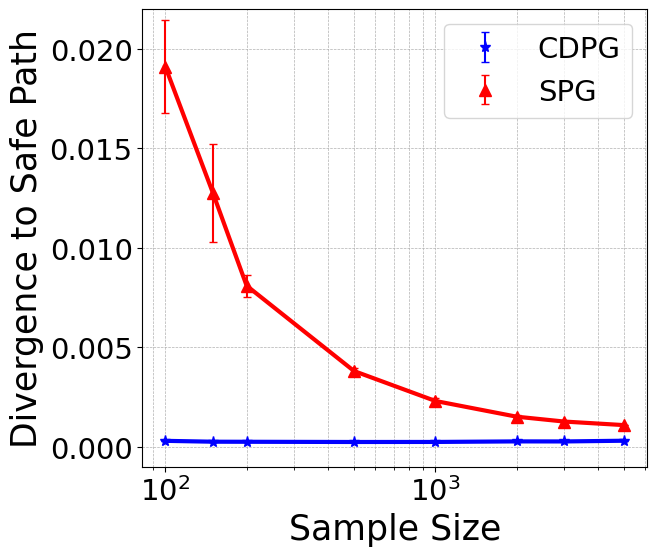

In [398]:
plt.rc('font', size=21)
plt.figure(figsize=(7, 6))

x_values = [100, 150, 200, 500, 1000, 2000, 3000, 5000]

plt.errorbar(x_values, our_mean, yerr=our_std, 
             fmt='*', color='blue', ecolor='blue', 
             capsize=3, label='CDPG', markersize=8)
plt.plot(x_values, our_mean, color='blue', linewidth=3)

plt.errorbar(x_values, other_mean, yerr=other_std, 
             fmt='^', color='red', ecolor='red', 
             capsize=3, label='SPG', markersize=8)
plt.plot(x_values, other_mean, color='red', linewidth=3)


plt.ylim(-0.001, 0.022)
plt.yticks([0.000, 0.005, 0.010, 0.015, 0.020])
# plt.xlim(0, 1e5)
# plt.xticks([0,1e2, 1e3, 1e4])
plt.ylabel('Divergence to Safe Path', fontsize=25)


plt.xscale('log')
plt.xlabel('Sample Size', fontsize=25)

plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig("./comparison_safe_dist.pdf", bbox_inches="tight", dpi=600, format="pdf")

## Test Cost

In [379]:
def compute_test_cost(theta):
    # avg_cost = 0
    
    env = CliffWalkingEnv(init_mode='original')
    env.reset()
    state, _ = env.reset_test()
    total_cost = 0
    
    for n_step in range(20):
        action = np.argmax(softmax_policy(state, theta))
        state, reward, done, truncated, info = env.step(action)
        total_cost += reward
        
        if done:
            break

    return total_cost

In [380]:
our_100_testcost = [compute_test_cost(theta[-1]) for theta in our_100_theta_formal]
our_150_testcost = [compute_test_cost(theta[-1]) for theta in our_150_theta_formal]
our_200_testcost = [compute_test_cost(theta[-1]) for theta in our_200_theta_formal]
our_500_testcost = [compute_test_cost(theta[-1]) for theta in our_500_theta_formal]
our_1000_testcost = [compute_test_cost(theta[-1]) for theta in our_1000_theta_formal]
our_2000_testcost = [compute_test_cost(theta[-1]) for theta in our_2000_theta_formal]
our_3000_testcost = [compute_test_cost(theta[-1]) for theta in our_3000_theta_formal]
our_5000_testcost = [compute_test_cost(theta[-1]) for theta in our_5000_theta_formal]

In [381]:
other_100_testcost = [compute_test_cost(theta[-1]) for theta in other_100_theta_formal]
other_150_testcost = [compute_test_cost(theta[-1]) for theta in other_150_theta_formal]
other_200_testcost = [compute_test_cost(theta[-1]) for theta in other_200_theta_formal]
other_500_testcost = [compute_test_cost(theta[-1]) for theta in other_500_theta_formal]
other_1000_testcost = [compute_test_cost(theta[-1]) for theta in other_1000_theta_formal]
other_2000_testcost = [compute_test_cost(theta[-1]) for theta in other_2000_theta_formal]
other_3000_testcost = [compute_test_cost(theta[-1]) for theta in other_3000_theta_formal]
other_5000_testcost = [compute_test_cost(theta[-1]) for theta in other_5000_theta_formal]

In [382]:
our_mean = [np.mean(our_100_testcost), np.mean(our_150_testcost), 
            np.mean(our_200_testcost), np.mean(our_500_testcost), np.mean(our_1000_testcost), 
            np.mean(our_2000_testcost), np.mean(our_3000_testcost), np.mean(our_5000_testcost)
           ]

our_std = [np.std(our_100_testcost), np.std(our_150_testcost), 
           np.std(our_200_testcost), np.std(our_500_testcost), np.std(our_1000_testcost), 
           np.std(our_2000_testcost), np.std(our_3000_testcost), np.std(our_5000_testcost)
          ]

In [383]:
other_mean = [np.mean(other_100_testcost), np.mean(other_150_testcost), 
            np.mean(other_200_testcost), np.mean(other_500_testcost), np.mean(other_1000_testcost), 
            np.mean(other_2000_testcost), np.mean(other_3000_testcost), np.mean(other_5000_testcost)
           ]

other_std = [np.std(other_100_testcost), np.std(other_150_testcost), 
           np.std(other_200_testcost), np.std(other_500_testcost), np.std(other_1000_testcost), 
           np.std(other_2000_testcost), np.std(other_3000_testcost), np.std(other_5000_testcost)
          ]

## Fix Number of samples, Test Cost

In [384]:
# sample size = 100
our_100_test_cost_per_iteration = []

for num_trial in range(5):
    temp = []
    for theta in our_100_theta_formal[num_trial]:
        temp.append(compute_test_cost(theta))
    our_100_test_cost_per_iteration.append(temp)

# sample size = 100
other_100_test_cost_per_iteration = []

for num_trial in range(5):
    temp = []
    for theta in other_100_theta_formal[num_trial]:
        temp.append(compute_test_cost(theta))
    other_100_test_cost_per_iteration.append(temp)

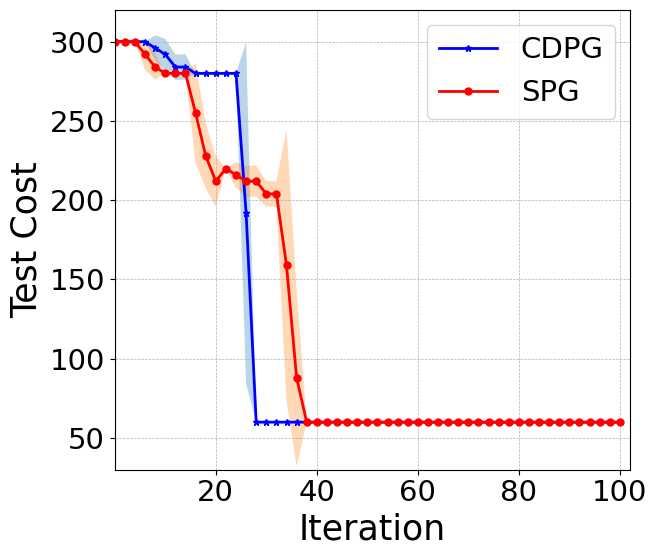

In [385]:
our_100_test_cost_iter_mean = np.mean(our_100_test_cost_per_iteration, axis=0)
other_100_test_cost_iter_mean = np.mean(other_100_test_cost_per_iteration, axis=0)

our_100_test_cost_iter_std = np.std(our_100_test_cost_per_iteration, axis=0)
other_100_test_cost_iter_std = np.std(other_100_test_cost_per_iteration, axis=0)

plt.rc('font', size=21)
plt.figure(figsize=(7, 6))

x_values = np.arange(0, 101, 1)


plt.fill_between(x_values[::2], 
                 (our_100_test_cost_iter_mean - our_100_test_cost_iter_std)[::2], 
                 (our_100_test_cost_iter_mean + our_100_test_cost_iter_std)[::2], 
                 alpha=0.3)

plt.plot(x_values[::2], our_100_test_cost_iter_mean[::2], '-*b', markersize=5, lw=2, label='CDPG')


plt.fill_between(x_values[::2], 
                 (other_100_test_cost_iter_mean - other_100_test_cost_iter_std)[::2], 
                 (other_100_test_cost_iter_mean + other_100_test_cost_iter_std)[::2], 
                 alpha=0.3)
plt.plot(x_values[::2], other_100_test_cost_iter_mean[::2], '-or', markersize=5, lw=2, label='SPG')

plt.ylim(30, 320)
plt.yticks([50, 100, 150, 200, 250, 300])
plt.ylabel('Test Cost', fontsize=25)

plt.xlim(0, 102)
plt.xticks([20, 40, 60, 80, 100])
plt.xlabel('Iteration', fontsize=25)


plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig("./comparison_100sample_test_cost.pdf", bbox_inches="tight", dpi=600, format="pdf")

## Fix Sample Size, Number of Fails

In [386]:
def compute_fails(theta):
    
    env = CliffWalkingEnv(init_mode='original')
    env.reset()
    state, _ = env.reset_test()
    fail = 0

    for n_step in range(10):
        action = np.argmax(softmax_policy(state, theta))
        state, reward, done, truncated, info = env.step(action)

        if reward == 30:
            fail += 1
            break
        
        if done:
            break

    if state != 8:
        fail += 1

    return fail

In [387]:
# sample size = 100
our_100_fail_per_iteration = []

for num_trial in range(5):
    temp = []
    for theta in our_100_theta_formal[num_trial]:
        temp.append(compute_fails(theta))
    our_100_fail_per_iteration.append(temp)

# sample size = 100
other_100_fail_per_iteration = []

for num_trial in range(5):
    temp = []
    for theta in other_100_theta_formal[num_trial]:
        temp.append(compute_fails(theta))
    other_100_fail_per_iteration.append(temp)

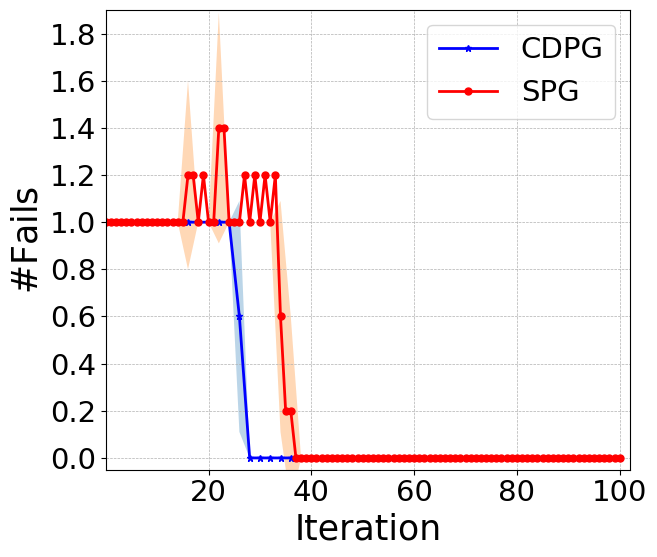

In [388]:
our_100_fail_iter_mean = np.mean(our_100_fail_per_iteration, axis=0)
other_100_fail_iter_mean = np.mean(other_100_fail_per_iteration, axis=0)

our_100_fail_iter_std = np.std(our_100_fail_per_iteration, axis=0)
other_100_fail_iter_std = np.std(other_100_fail_per_iteration, axis=0)

plt.rc('font', size=21)
plt.figure(figsize=(7, 6))

x_values = np.arange(0, 101, 1)


plt.plot(x_values[::2], our_100_fail_iter_mean[::2], '-*b', markersize=5, lw=2, label='CDPG')

plt.fill_between(x_values[::2], 
                 (our_100_fail_iter_mean - our_100_fail_iter_std)[::2], 
                 (our_100_fail_iter_mean + our_100_fail_iter_std)[::2], 
                 alpha=0.3)


plt.plot(x_values, other_100_fail_iter_mean, '-or', markersize=5, lw=2, label='SPG')
plt.fill_between(x_values[::2], 
                 (other_100_fail_iter_mean - other_100_fail_iter_std)[::2], 
                 (other_100_fail_iter_mean + other_100_fail_iter_std)[::2], 
                 alpha=0.3)



plt.ylim(-0.05, 1.9)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
plt.ylabel('$\#$Fails', fontsize=25)

plt.xlim(0, 102)
plt.xticks([20, 40, 60, 80, 100])
plt.xlabel('Iteration', fontsize=25)


plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()


plt.savefig("./comparison_100sample_fail.pdf", bbox_inches="tight", dpi=600, format="pdf")

## Fail Sample Size, Convergence Rate

In [399]:
# Sample Size = 100
our_100_divergence_per_iteration = []

for num_trial in range(5):
    temp = []
    for theta in our_100_theta_formal[num_trial]:
        temp.append(divergence(theta))
    our_100_divergence_per_iteration.append(temp)

# Sample Size = 100
other_100_divergence_per_iteration = []

for num_trial in range(5):
    temp = []
    for theta in other_100_theta_formal[num_trial]:
        temp.append(divergence(theta))
    other_100_divergence_per_iteration.append(temp)

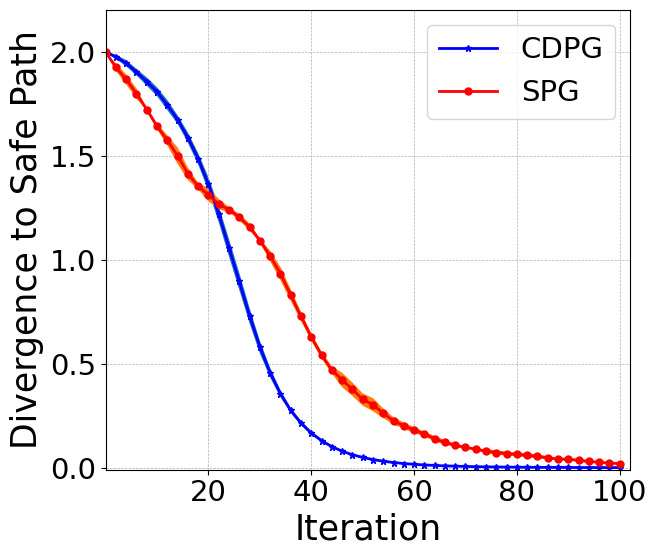

In [400]:
our_100_divergence_mean = np.mean(our_100_divergence_per_iteration, axis=0)
other_100_divergence_mean = np.mean(other_100_divergence_per_iteration, axis=0)

our_100_divergence_std = np.std(our_100_divergence_per_iteration, axis=0)
other_100_divergence_std = np.std(other_100_divergence_per_iteration, axis=0)

plt.rc('font', size=21)
plt.figure(figsize=(7, 6))

x_values = np.arange(0, 101, 1)

plt.plot(x_values[::2], our_100_divergence_mean[::2], '-*b', markersize=5, lw=2, label='CDPG')

plt.fill_between(x_values[::2], 
                 (our_100_divergence_mean - our_100_divergence_std)[::2], 
                 (our_100_divergence_mean + our_100_divergence_std)[::2], 
                 alpha=1.0)


plt.plot(x_values[::2], other_100_divergence_mean[::2], '-or', markersize=5, lw=2, label='SPG')
plt.fill_between(x_values[::2], 
                 (other_100_divergence_mean - other_100_divergence_std)[::2], 
                 (other_100_divergence_mean + other_100_divergence_std)[::2], 
                 alpha=1.0)




plt.ylim(-0.01, 2.2)
plt.yticks([0.0, 0.5, 1.0, 1.5, 2.0])
plt.ylabel('Divergence to Safe Path', fontsize=25)

plt.xlim(0, 102)
plt.xticks([20, 40, 60, 80, 100])
plt.xlabel('Iteration', fontsize=25)


plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig("./comparison_100sample_divergence.pdf", bbox_inches="tight", dpi=600, format="pdf")